In [1]:
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data'
results_dir = '../results'
task = 'by_timepoint'

task_data_dir = data_dir
task_results_dir = os.path.join(results_dir, task)

if not os.path.exists(task_results_dir):
    os.makedirs(task_results_dir)

In [3]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate accuracy
def calculate_mae(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    # mean absolute error
    correct = (predicted - actual).abs().sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_mae = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_mae)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_mae = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_mae)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

# Function to evaluate the MLP on a test set
def evaluate_mlp(model, test_data, test_labels, device):
    model.eval()
    test_tensor = torch.FloatTensor(test_data).to(device)
    test_labels_tensor = torch.FloatTensor(test_labels).to(device)
    criterion = nn.MSELoss()

    with torch.no_grad():
        test_outputs = model(test_tensor)
        test_loss = criterion(test_outputs, test_labels_tensor)
        test_accuracy = calculate_mae(test_outputs, test_labels_tensor)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_accuracy:.4f}')

    return (test_loss.item(), test_accuracy, test_outputs.to('cpu'))

In [4]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3, 0], [0.5, 0.3, 1], [0.9, 0.1, 0], [0.7, 0.6, 0]])
# labels = np.array([[0.5, 0.3], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2, 0], [0.3, 0.9, 1]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# results = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [5]:
def build_data(csv_files):
    inputs_list = list()
    outputs_list = list()

    for file in csv_files:
        df = pd.read_csv(file)
        initial_conditions = np.tile(df[df["Time"]==0][["Prey", "Predator"]].to_numpy()[0], (df.shape[0], 1))
        times = df["Time"].to_numpy().reshape(-1,1)
        inputs_list.append( np.hstack((initial_conditions, times)) )
        outputs_list.append( df[["Prey","Predator"]].to_numpy() )

    inputs = np.vstack(inputs_list)
    outputs = np.vstack(outputs_list)

    return inputs, outputs

data_files = [f for f in os.listdir(task_data_dir) if f.endswith('csv') and f.startswith('predator')]
training_indices = [0,1,2,3]
validation_indices = [4,5,6,7]
testing_indices = [8,9]

# Set up training data
train_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in training_indices]
training_inputs, training_outputs = build_data(train_csv_files)
training_data = {
    'inputs': training_inputs,
    'labels': training_outputs
}
print(training_data['inputs'].shape)

# Set up validaiton data
valid_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in validation_indices]
valid_inputs, valid_outputs = build_data(valid_csv_files)
validation_data = {
    'inputs': valid_inputs,
    'labels': valid_outputs
}
print(validation_data['inputs'].shape)

# Set up testing data
test_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in testing_indices]
test_inputs, test_outputs = build_data(test_csv_files)
testing_data = {
    'inputs': test_inputs,
    'labels': test_outputs
}
print(testing_data['inputs'].shape)

split_string = f"{','.join(map(str,training_indices))}:{','.join(map(str,validation_indices))}:{','.join(map(str,testing_indices))}"
print(split_string)

(4000, 3)
(4000, 3)
(2000, 3)
0,1,2,3:4,5,6,7:8,9


In [6]:
epochs = 200000
seed = 42
l2_lambda = 0.1
lr = 0.01
hidden_size=100
depth = "deep"
gpu_device = 3
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}-{split_string}"

In [7]:
# Train!
results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=gpu_device,
                  l2_lambda=l2_lambda,
                  depth=depth,
                  print_step=10)

# Evaluate the model on the test set
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))

results['test_loss'] = test_loss
results['test_acc'] = test_acc

# Save the results as a pickled object
with open(os.path.join(task_results_dir, f'mlp_training_results_{suffix}.pkl'), 'wb') as f:
    pickle.dump(results, f)

Using device: cuda:3


Epoch [10/200000], Loss: 313.4041, Validation Loss: 490.9149, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [20/200000], Loss: 297.9163, Validation Loss: 641.2798, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [30/200000], Loss: 289.3748, Validation Loss: 896.3308, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [40/200000], Loss: 288.0215, Validation Loss: 862.0660, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [50/200000], Loss: 287.5132, Validation Loss: 853.1599, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [60/200000], Loss: 287.1082, Validation Loss: 868.0614, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [70/200000], Loss: 286.5162, Validation Loss: 893.2399, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [80/200000], Loss: 285.8378, Validation Loss: 878.0968, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [90/200000], Loss: 285.3266, Validation Loss: 866.1863, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [100/200000], Loss: 284.6458, Validation Loss: 869.2559, Train MAE: 0.1915, Val MAE: 0.3817
Epoch [110/200000], Loss: 284

Epoch [150/200000], Loss: 283.1712, Validation Loss: 802.9688, Train MAE: 0.1885, Val MAE: 0.3817
Epoch [160/200000], Loss: 282.9961, Validation Loss: 861.2468, Train MAE: 0.1865, Val MAE: 0.3817
Epoch [170/200000], Loss: 281.5503, Validation Loss: 849.1743, Train MAE: 0.1862, Val MAE: 0.3817
Epoch [180/200000], Loss: 280.9667, Validation Loss: 886.4888, Train MAE: 0.1860, Val MAE: 0.3817
Epoch [190/200000], Loss: 282.1683, Validation Loss: 865.2505, Train MAE: 0.1862, Val MAE: 0.3817
Epoch [200/200000], Loss: 279.9055, Validation Loss: 999.9850, Train MAE: 0.1857, Val MAE: 0.3817
Epoch [210/200000], Loss: 282.1004, Validation Loss: 845.3110, Train MAE: 0.1862, Val MAE: 0.3817
Epoch [220/200000], Loss: 279.8254, Validation Loss: 1044.0559, Train MAE: 0.1875, Val MAE: 0.3817
Epoch [230/200000], Loss: 278.5388, Validation Loss: 1081.3302, Train MAE: 0.1860, Val MAE: 0.3817
Epoch [240/200000], Loss: 282.6531, Validation Loss: 1089.4825, Train MAE: 0.1860, Val MAE: 0.3817
Epoch [250/200000

Epoch [290/200000], Loss: 277.3421, Validation Loss: 1361.8529, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [300/200000], Loss: 277.2402, Validation Loss: 1389.4712, Train MAE: 0.1872, Val MAE: 0.3815
Epoch [310/200000], Loss: 277.5218, Validation Loss: 1344.6749, Train MAE: 0.1872, Val MAE: 0.3820
Epoch [320/200000], Loss: 277.0846, Validation Loss: 1289.3940, Train MAE: 0.1870, Val MAE: 0.3810
Epoch [330/200000], Loss: 277.0840, Validation Loss: 1311.8540, Train MAE: 0.1872, Val MAE: 0.3812
Epoch [340/200000], Loss: 292.0847, Validation Loss: 889.7409, Train MAE: 0.1885, Val MAE: 0.3817
Epoch [350/200000], Loss: 285.9683, Validation Loss: 805.4033, Train MAE: 0.1850, Val MAE: 0.3817
Epoch [360/200000], Loss: 285.0698, Validation Loss: 847.5052, Train MAE: 0.1847, Val MAE: 0.3817
Epoch [370/200000], Loss: 284.1257, Validation Loss: 887.6016, Train MAE: 0.1852, Val MAE: 0.3817
Epoch [380/200000], Loss: 283.4672, Validation Loss: 886.0367, Train MAE: 0.1865, Val MAE: 0.3817
Epoch [390/2000

Epoch [430/200000], Loss: 279.8399, Validation Loss: 1060.7472, Train MAE: 0.1860, Val MAE: 0.3790
Epoch [440/200000], Loss: 279.0793, Validation Loss: 1094.6088, Train MAE: 0.1867, Val MAE: 0.3807
Epoch [450/200000], Loss: 278.4041, Validation Loss: 1105.6881, Train MAE: 0.1865, Val MAE: 0.3817
Epoch [460/200000], Loss: 278.7320, Validation Loss: 1093.6259, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [470/200000], Loss: 277.9983, Validation Loss: 948.3983, Train MAE: 0.1867, Val MAE: 0.3815
Epoch [480/200000], Loss: 277.7604, Validation Loss: 933.1755, Train MAE: 0.1862, Val MAE: 0.3810
Epoch [490/200000], Loss: 277.6532, Validation Loss: 1016.7198, Train MAE: 0.1870, Val MAE: 0.3815
Epoch [500/200000], Loss: 277.8401, Validation Loss: 955.8076, Train MAE: 0.1865, Val MAE: 0.3810
Epoch [510/200000], Loss: 277.3638, Validation Loss: 974.9572, Train MAE: 0.1865, Val MAE: 0.3810
Epoch [520/200000], Loss: 278.5737, Validation Loss: 1020.1826, Train MAE: 0.1870, Val MAE: 0.3812
Epoch [530/200

Epoch [570/200000], Loss: 278.1505, Validation Loss: 1091.8103, Train MAE: 0.1872, Val MAE: 0.3802
Epoch [580/200000], Loss: 277.2821, Validation Loss: 1095.8776, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [590/200000], Loss: 277.0676, Validation Loss: 1147.4218, Train MAE: 0.1870, Val MAE: 0.3820
Epoch [600/200000], Loss: 276.8513, Validation Loss: 1154.0151, Train MAE: 0.1867, Val MAE: 0.3802
Epoch [610/200000], Loss: 276.7681, Validation Loss: 1160.9161, Train MAE: 0.1870, Val MAE: 0.3805
Epoch [620/200000], Loss: 276.7334, Validation Loss: 1145.1821, Train MAE: 0.1867, Val MAE: 0.3802
Epoch [630/200000], Loss: 276.6751, Validation Loss: 1150.3684, Train MAE: 0.1867, Val MAE: 0.3802
Epoch [640/200000], Loss: 276.6147, Validation Loss: 1147.9153, Train MAE: 0.1867, Val MAE: 0.3802
Epoch [650/200000], Loss: 276.5599, Validation Loss: 1130.3921, Train MAE: 0.1867, Val MAE: 0.3802
Epoch [660/200000], Loss: 276.4545, Validation Loss: 1123.8093, Train MAE: 0.1867, Val MAE: 0.3807
Epoch [670

Epoch [710/200000], Loss: 275.6786, Validation Loss: 1141.7087, Train MAE: 0.1872, Val MAE: 0.3817
Epoch [720/200000], Loss: 277.7329, Validation Loss: 1087.9749, Train MAE: 0.1867, Val MAE: 0.3820
Epoch [730/200000], Loss: 276.2597, Validation Loss: 1127.3461, Train MAE: 0.1865, Val MAE: 0.3817
Epoch [740/200000], Loss: 276.4971, Validation Loss: 1206.1940, Train MAE: 0.1872, Val MAE: 0.3817
Epoch [750/200000], Loss: 275.7814, Validation Loss: 1207.5902, Train MAE: 0.1875, Val MAE: 0.3817
Epoch [760/200000], Loss: 275.0209, Validation Loss: 1136.5095, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [770/200000], Loss: 274.7092, Validation Loss: 1101.9601, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [780/200000], Loss: 274.4948, Validation Loss: 1069.2256, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [790/200000], Loss: 274.2948, Validation Loss: 1043.0149, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [800/200000], Loss: 274.1343, Validation Loss: 1040.4390, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [810

Epoch [850/200000], Loss: 274.5618, Validation Loss: 1017.0496, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [860/200000], Loss: 273.4277, Validation Loss: 968.4356, Train MAE: 0.1872, Val MAE: 0.3817
Epoch [870/200000], Loss: 273.5021, Validation Loss: 986.5041, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [880/200000], Loss: 272.8391, Validation Loss: 992.0359, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [890/200000], Loss: 272.8628, Validation Loss: 997.3737, Train MAE: 0.1870, Val MAE: 0.3817
Epoch [900/200000], Loss: 272.6074, Validation Loss: 951.7349, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [910/200000], Loss: 272.7566, Validation Loss: 914.6732, Train MAE: 0.1862, Val MAE: 0.3817
Epoch [920/200000], Loss: 272.8593, Validation Loss: 923.5609, Train MAE: 0.1862, Val MAE: 0.3817
Epoch [930/200000], Loss: 272.3063, Validation Loss: 954.5831, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [940/200000], Loss: 272.0818, Validation Loss: 915.3029, Train MAE: 0.1865, Val MAE: 0.3807
Epoch [950/200000],

Epoch [990/200000], Loss: 271.7129, Validation Loss: 910.6279, Train MAE: 0.1860, Val MAE: 0.3812
Epoch [1000/200000], Loss: 271.4652, Validation Loss: 898.2455, Train MAE: 0.1862, Val MAE: 0.3815
Epoch [1010/200000], Loss: 271.5390, Validation Loss: 948.8158, Train MAE: 0.1867, Val MAE: 0.3807
Epoch [1020/200000], Loss: 271.1309, Validation Loss: 898.9626, Train MAE: 0.1862, Val MAE: 0.3807
Epoch [1030/200000], Loss: 270.8526, Validation Loss: 921.8732, Train MAE: 0.1865, Val MAE: 0.3805
Epoch [1040/200000], Loss: 271.2579, Validation Loss: 882.7763, Train MAE: 0.1862, Val MAE: 0.3797
Epoch [1050/200000], Loss: 270.7427, Validation Loss: 872.7197, Train MAE: 0.1860, Val MAE: 0.3797
Epoch [1060/200000], Loss: 270.4488, Validation Loss: 908.9420, Train MAE: 0.1865, Val MAE: 0.3800
Epoch [1070/200000], Loss: 273.5943, Validation Loss: 837.5363, Train MAE: 0.1852, Val MAE: 0.3787
Epoch [1080/200000], Loss: 270.9922, Validation Loss: 934.8963, Train MAE: 0.1855, Val MAE: 0.3805
Epoch [1090

Epoch [1130/200000], Loss: 269.6432, Validation Loss: 929.8118, Train MAE: 0.1860, Val MAE: 0.3815
Epoch [1140/200000], Loss: 269.4695, Validation Loss: 919.1522, Train MAE: 0.1860, Val MAE: 0.3812
Epoch [1150/200000], Loss: 269.3695, Validation Loss: 913.4565, Train MAE: 0.1860, Val MAE: 0.3810
Epoch [1160/200000], Loss: 269.7088, Validation Loss: 948.9481, Train MAE: 0.1855, Val MAE: 0.3815
Epoch [1170/200000], Loss: 269.2937, Validation Loss: 930.2343, Train MAE: 0.1860, Val MAE: 0.3807
Epoch [1180/200000], Loss: 269.1157, Validation Loss: 923.1369, Train MAE: 0.1857, Val MAE: 0.3805
Epoch [1190/200000], Loss: 269.0750, Validation Loss: 903.5748, Train MAE: 0.1852, Val MAE: 0.3805
Epoch [1200/200000], Loss: 268.9218, Validation Loss: 895.8820, Train MAE: 0.1852, Val MAE: 0.3805
Epoch [1210/200000], Loss: 269.1846, Validation Loss: 880.3146, Train MAE: 0.1852, Val MAE: 0.3802
Epoch [1220/200000], Loss: 269.8891, Validation Loss: 921.0963, Train MAE: 0.1852, Val MAE: 0.3810
Epoch [123

Epoch [1270/200000], Loss: 270.3403, Validation Loss: 954.1290, Train MAE: 0.1850, Val MAE: 0.3810
Epoch [1280/200000], Loss: 268.2261, Validation Loss: 895.7264, Train MAE: 0.1847, Val MAE: 0.3807
Epoch [1290/200000], Loss: 268.0452, Validation Loss: 904.3363, Train MAE: 0.1847, Val MAE: 0.3810
Epoch [1300/200000], Loss: 268.2276, Validation Loss: 929.7491, Train MAE: 0.1842, Val MAE: 0.3812
Epoch [1310/200000], Loss: 267.8455, Validation Loss: 886.2388, Train MAE: 0.1845, Val MAE: 0.3815
Epoch [1320/200000], Loss: 267.8000, Validation Loss: 887.8218, Train MAE: 0.1842, Val MAE: 0.3805
Epoch [1330/200000], Loss: 268.4071, Validation Loss: 863.1877, Train MAE: 0.1840, Val MAE: 0.3812
Epoch [1340/200000], Loss: 267.8879, Validation Loss: 878.6915, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1350/200000], Loss: 267.7059, Validation Loss: 912.5864, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1360/200000], Loss: 267.4664, Validation Loss: 888.5118, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [137

Epoch [1410/200000], Loss: 267.0625, Validation Loss: 918.5764, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1420/200000], Loss: 266.9513, Validation Loss: 876.7121, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1430/200000], Loss: 266.8730, Validation Loss: 905.1987, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1440/200000], Loss: 266.9832, Validation Loss: 895.9532, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1450/200000], Loss: 266.7675, Validation Loss: 901.8174, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [1460/200000], Loss: 267.1027, Validation Loss: 882.5591, Train MAE: 0.1830, Val MAE: 0.3817
Epoch [1470/200000], Loss: 267.2377, Validation Loss: 933.0138, Train MAE: 0.1845, Val MAE: 0.3817
Epoch [1480/200000], Loss: 266.7695, Validation Loss: 899.4246, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [1490/200000], Loss: 266.5274, Validation Loss: 882.2867, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [1500/200000], Loss: 266.2828, Validation Loss: 902.1184, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [151

Epoch [1550/200000], Loss: 266.4795, Validation Loss: 912.2398, Train MAE: 0.1847, Val MAE: 0.3817
Epoch [1560/200000], Loss: 266.0626, Validation Loss: 890.9011, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1570/200000], Loss: 266.8240, Validation Loss: 933.0679, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1580/200000], Loss: 266.8941, Validation Loss: 868.1097, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1590/200000], Loss: 267.7774, Validation Loss: 853.3934, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1600/200000], Loss: 266.3029, Validation Loss: 981.7789, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [1610/200000], Loss: 266.1690, Validation Loss: 899.4940, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1620/200000], Loss: 265.7975, Validation Loss: 967.3772, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1630/200000], Loss: 265.4826, Validation Loss: 958.2837, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1640/200000], Loss: 265.9714, Validation Loss: 925.3237, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [165

Epoch [1690/200000], Loss: 265.7135, Validation Loss: 939.3779, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [1700/200000], Loss: 265.9092, Validation Loss: 961.6510, Train MAE: 0.1852, Val MAE: 0.3817
Epoch [1710/200000], Loss: 265.1193, Validation Loss: 959.7424, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [1720/200000], Loss: 264.6709, Validation Loss: 951.9327, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1730/200000], Loss: 264.5863, Validation Loss: 957.0691, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [1740/200000], Loss: 264.9671, Validation Loss: 979.2189, Train MAE: 0.1845, Val MAE: 0.3817
Epoch [1750/200000], Loss: 264.7494, Validation Loss: 940.8016, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1760/200000], Loss: 264.5343, Validation Loss: 976.7185, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [1770/200000], Loss: 264.4385, Validation Loss: 945.2162, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1780/200000], Loss: 264.4706, Validation Loss: 970.4962, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [179

Epoch [1830/200000], Loss: 264.0817, Validation Loss: 981.8677, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1840/200000], Loss: 263.9579, Validation Loss: 970.4457, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1850/200000], Loss: 264.1170, Validation Loss: 978.7839, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1860/200000], Loss: 263.8599, Validation Loss: 961.6298, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1870/200000], Loss: 264.6770, Validation Loss: 950.6012, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1880/200000], Loss: 264.1458, Validation Loss: 980.2454, Train MAE: 0.1845, Val MAE: 0.3817
Epoch [1890/200000], Loss: 263.7614, Validation Loss: 963.7845, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1900/200000], Loss: 263.7631, Validation Loss: 969.7291, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1910/200000], Loss: 263.6809, Validation Loss: 960.5629, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [1920/200000], Loss: 264.4808, Validation Loss: 961.5734, Train MAE: 0.1830, Val MAE: 0.3817
Epoch [193

Epoch [1970/200000], Loss: 263.4738, Validation Loss: 975.0981, Train MAE: 0.1842, Val MAE: 0.3817
Epoch [1980/200000], Loss: 263.2623, Validation Loss: 982.7302, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [1990/200000], Loss: 263.2949, Validation Loss: 951.5719, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [2000/200000], Loss: 264.4737, Validation Loss: 986.0709, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2010/200000], Loss: 263.4739, Validation Loss: 956.9873, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2020/200000], Loss: 263.0656, Validation Loss: 979.0871, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [2030/200000], Loss: 263.4186, Validation Loss: 975.6522, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [2040/200000], Loss: 263.1485, Validation Loss: 978.2147, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [2050/200000], Loss: 263.0397, Validation Loss: 976.1645, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2060/200000], Loss: 263.2642, Validation Loss: 965.7897, Train MAE: 0.1830, Val MAE: 0.3817
Epoch [207

Epoch [2110/200000], Loss: 263.4163, Validation Loss: 970.7694, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2120/200000], Loss: 262.6790, Validation Loss: 965.1710, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2130/200000], Loss: 262.6144, Validation Loss: 928.2728, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2140/200000], Loss: 263.3694, Validation Loss: 958.4310, Train MAE: 0.1840, Val MAE: 0.3817
Epoch [2150/200000], Loss: 262.8837, Validation Loss: 887.3365, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2160/200000], Loss: 262.5284, Validation Loss: 932.1063, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2170/200000], Loss: 262.9339, Validation Loss: 932.7103, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [2180/200000], Loss: 262.7026, Validation Loss: 941.4442, Train MAE: 0.1830, Val MAE: 0.3817
Epoch [2190/200000], Loss: 262.4067, Validation Loss: 899.4589, Train MAE: 0.1825, Val MAE: 0.3817
Epoch [2200/200000], Loss: 262.9874, Validation Loss: 908.8027, Train MAE: 0.1830, Val MAE: 0.3805
Epoch [221

Epoch [2250/200000], Loss: 262.3019, Validation Loss: 930.4539, Train MAE: 0.1837, Val MAE: 0.3817
Epoch [2260/200000], Loss: 262.1117, Validation Loss: 927.5621, Train MAE: 0.1827, Val MAE: 0.3817
Epoch [2270/200000], Loss: 262.0497, Validation Loss: 945.9352, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2280/200000], Loss: 262.2091, Validation Loss: 959.6215, Train MAE: 0.1822, Val MAE: 0.3817
Epoch [2290/200000], Loss: 261.9605, Validation Loss: 939.0369, Train MAE: 0.1830, Val MAE: 0.3817
Epoch [2300/200000], Loss: 262.1595, Validation Loss: 958.2183, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2310/200000], Loss: 262.4897, Validation Loss: 923.6824, Train MAE: 0.1830, Val MAE: 0.3820
Epoch [2320/200000], Loss: 262.0184, Validation Loss: 942.8292, Train MAE: 0.1827, Val MAE: 0.3812
Epoch [2330/200000], Loss: 261.7411, Validation Loss: 932.9902, Train MAE: 0.1822, Val MAE: 0.3815
Epoch [2340/200000], Loss: 263.0755, Validation Loss: 897.2726, Train MAE: 0.1822, Val MAE: 0.3800
Epoch [235

Epoch [2390/200000], Loss: 262.8537, Validation Loss: 961.5087, Train MAE: 0.1830, Val MAE: 0.3815
Epoch [2400/200000], Loss: 261.8952, Validation Loss: 944.6173, Train MAE: 0.1825, Val MAE: 0.3810
Epoch [2410/200000], Loss: 261.8246, Validation Loss: 944.8068, Train MAE: 0.1837, Val MAE: 0.3812
Epoch [2420/200000], Loss: 261.5779, Validation Loss: 938.6708, Train MAE: 0.1837, Val MAE: 0.3807
Epoch [2430/200000], Loss: 261.9726, Validation Loss: 960.4483, Train MAE: 0.1840, Val MAE: 0.3812
Epoch [2440/200000], Loss: 261.4164, Validation Loss: 934.3099, Train MAE: 0.1835, Val MAE: 0.3805
Epoch [2450/200000], Loss: 261.3603, Validation Loss: 933.6673, Train MAE: 0.1827, Val MAE: 0.3805
Epoch [2460/200000], Loss: 261.4378, Validation Loss: 954.9133, Train MAE: 0.1835, Val MAE: 0.3805
Epoch [2470/200000], Loss: 261.6844, Validation Loss: 960.0188, Train MAE: 0.1835, Val MAE: 0.3807
Epoch [2480/200000], Loss: 261.7964, Validation Loss: 949.6814, Train MAE: 0.1830, Val MAE: 0.3807
Epoch [249

Epoch [2530/200000], Loss: 261.6480, Validation Loss: 935.5266, Train MAE: 0.1817, Val MAE: 0.3800
Epoch [2540/200000], Loss: 261.0705, Validation Loss: 943.3254, Train MAE: 0.1832, Val MAE: 0.3800
Epoch [2550/200000], Loss: 261.2488, Validation Loss: 971.3456, Train MAE: 0.1830, Val MAE: 0.3802
Epoch [2560/200000], Loss: 262.5914, Validation Loss: 917.2008, Train MAE: 0.1815, Val MAE: 0.3800
Epoch [2570/200000], Loss: 261.8974, Validation Loss: 958.0769, Train MAE: 0.1835, Val MAE: 0.3817
Epoch [2580/200000], Loss: 261.7280, Validation Loss: 942.5637, Train MAE: 0.1817, Val MAE: 0.3790
Epoch [2590/200000], Loss: 261.4066, Validation Loss: 948.3192, Train MAE: 0.1832, Val MAE: 0.3817
Epoch [2600/200000], Loss: 262.8278, Validation Loss: 919.8447, Train MAE: 0.1827, Val MAE: 0.3797
Epoch [2610/200000], Loss: 261.2225, Validation Loss: 943.1678, Train MAE: 0.1827, Val MAE: 0.3797
Epoch [2620/200000], Loss: 260.9257, Validation Loss: 940.7631, Train MAE: 0.1830, Val MAE: 0.3800
Epoch [263

Epoch [2670/200000], Loss: 262.2737, Validation Loss: 1001.7079, Train MAE: 0.1850, Val MAE: 0.3800
Epoch [2680/200000], Loss: 260.8080, Validation Loss: 988.9904, Train MAE: 0.1822, Val MAE: 0.3797
Epoch [2690/200000], Loss: 260.7004, Validation Loss: 991.9877, Train MAE: 0.1830, Val MAE: 0.3797
Epoch [2700/200000], Loss: 260.6244, Validation Loss: 1007.9137, Train MAE: 0.1832, Val MAE: 0.3797
Epoch [2710/200000], Loss: 260.6267, Validation Loss: 996.1911, Train MAE: 0.1832, Val MAE: 0.3797
Epoch [2720/200000], Loss: 260.8155, Validation Loss: 972.4631, Train MAE: 0.1822, Val MAE: 0.3795
Epoch [2730/200000], Loss: 260.7107, Validation Loss: 991.5911, Train MAE: 0.1830, Val MAE: 0.3797
Epoch [2740/200000], Loss: 260.6534, Validation Loss: 987.6749, Train MAE: 0.1835, Val MAE: 0.3797
Epoch [2750/200000], Loss: 260.6659, Validation Loss: 996.5148, Train MAE: 0.1837, Val MAE: 0.3800
Epoch [2760/200000], Loss: 260.6981, Validation Loss: 985.7903, Train MAE: 0.1832, Val MAE: 0.3800
Epoch [2

Epoch [2810/200000], Loss: 260.7458, Validation Loss: 970.6359, Train MAE: 0.1840, Val MAE: 0.3802
Epoch [2820/200000], Loss: 260.3576, Validation Loss: 948.4327, Train MAE: 0.1832, Val MAE: 0.3800
Epoch [2830/200000], Loss: 260.3661, Validation Loss: 964.7125, Train MAE: 0.1827, Val MAE: 0.3797
Epoch [2840/200000], Loss: 261.7645, Validation Loss: 958.0845, Train MAE: 0.1815, Val MAE: 0.3795
Epoch [2850/200000], Loss: 260.7733, Validation Loss: 1002.0437, Train MAE: 0.1845, Val MAE: 0.3812
Epoch [2860/200000], Loss: 260.3580, Validation Loss: 969.5368, Train MAE: 0.1830, Val MAE: 0.3802
Epoch [2870/200000], Loss: 260.1278, Validation Loss: 999.3621, Train MAE: 0.1837, Val MAE: 0.3802
Epoch [2880/200000], Loss: 260.8264, Validation Loss: 1004.8552, Train MAE: 0.1845, Val MAE: 0.3805
Epoch [2890/200000], Loss: 260.1259, Validation Loss: 971.7891, Train MAE: 0.1827, Val MAE: 0.3797
Epoch [2900/200000], Loss: 260.1621, Validation Loss: 996.8358, Train MAE: 0.1835, Val MAE: 0.3800
Epoch [2

Epoch [2950/200000], Loss: 260.4013, Validation Loss: 969.3932, Train MAE: 0.1837, Val MAE: 0.3802
Epoch [2960/200000], Loss: 260.1023, Validation Loss: 969.8914, Train MAE: 0.1825, Val MAE: 0.3802
Epoch [2970/200000], Loss: 259.9835, Validation Loss: 954.8563, Train MAE: 0.1827, Val MAE: 0.3800
Epoch [2980/200000], Loss: 262.0740, Validation Loss: 953.4603, Train MAE: 0.1812, Val MAE: 0.3797
Epoch [2990/200000], Loss: 259.8288, Validation Loss: 987.2521, Train MAE: 0.1827, Val MAE: 0.3802
Epoch [3000/200000], Loss: 260.1465, Validation Loss: 988.6471, Train MAE: 0.1840, Val MAE: 0.3802
Epoch [3010/200000], Loss: 259.7585, Validation Loss: 972.8241, Train MAE: 0.1827, Val MAE: 0.3802
Epoch [3020/200000], Loss: 260.0829, Validation Loss: 998.4158, Train MAE: 0.1840, Val MAE: 0.3805
Epoch [3030/200000], Loss: 259.9174, Validation Loss: 937.2223, Train MAE: 0.1835, Val MAE: 0.3802
Epoch [3040/200000], Loss: 260.0530, Validation Loss: 955.1478, Train MAE: 0.1832, Val MAE: 0.3805
Epoch [305

Epoch [3090/200000], Loss: 259.6906, Validation Loss: 992.7762, Train MAE: 0.1837, Val MAE: 0.3807
Epoch [3100/200000], Loss: 259.6344, Validation Loss: 962.1654, Train MAE: 0.1832, Val MAE: 0.3805
Epoch [3110/200000], Loss: 259.7568, Validation Loss: 959.7322, Train MAE: 0.1822, Val MAE: 0.3807
Epoch [3120/200000], Loss: 259.6215, Validation Loss: 959.4891, Train MAE: 0.1817, Val MAE: 0.3805
Epoch [3130/200000], Loss: 260.5878, Validation Loss: 958.7526, Train MAE: 0.1812, Val MAE: 0.3802
Epoch [3140/200000], Loss: 260.0191, Validation Loss: 1015.0953, Train MAE: 0.1842, Val MAE: 0.3807
Epoch [3150/200000], Loss: 259.7297, Validation Loss: 966.8636, Train MAE: 0.1820, Val MAE: 0.3807
Epoch [3160/200000], Loss: 259.3046, Validation Loss: 987.3047, Train MAE: 0.1832, Val MAE: 0.3807
Epoch [3170/200000], Loss: 259.3832, Validation Loss: 976.4821, Train MAE: 0.1825, Val MAE: 0.3807
Epoch [3180/200000], Loss: 264.1284, Validation Loss: 954.7303, Train MAE: 0.1830, Val MAE: 0.3802
Epoch [31

Epoch [3230/200000], Loss: 259.2322, Validation Loss: 944.0756, Train MAE: 0.1830, Val MAE: 0.3807
Epoch [3240/200000], Loss: 259.1389, Validation Loss: 957.5181, Train MAE: 0.1830, Val MAE: 0.3810
Epoch [3250/200000], Loss: 263.3038, Validation Loss: 1002.5869, Train MAE: 0.1862, Val MAE: 0.3810
Epoch [3260/200000], Loss: 259.4699, Validation Loss: 944.1179, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3270/200000], Loss: 259.7101, Validation Loss: 919.2767, Train MAE: 0.1810, Val MAE: 0.3810
Epoch [3280/200000], Loss: 259.0729, Validation Loss: 932.2144, Train MAE: 0.1825, Val MAE: 0.3807
Epoch [3290/200000], Loss: 258.9892, Validation Loss: 940.7379, Train MAE: 0.1827, Val MAE: 0.3810
Epoch [3300/200000], Loss: 259.3767, Validation Loss: 954.9901, Train MAE: 0.1840, Val MAE: 0.3810
Epoch [3310/200000], Loss: 259.4361, Validation Loss: 947.1338, Train MAE: 0.1835, Val MAE: 0.3810
Epoch [3320/200000], Loss: 259.2852, Validation Loss: 927.2539, Train MAE: 0.1807, Val MAE: 0.3810
Epoch [33

Epoch [3370/200000], Loss: 259.2237, Validation Loss: 928.6855, Train MAE: 0.1807, Val MAE: 0.3807
Epoch [3380/200000], Loss: 258.8273, Validation Loss: 941.6103, Train MAE: 0.1825, Val MAE: 0.3810
Epoch [3390/200000], Loss: 259.0328, Validation Loss: 941.9599, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3400/200000], Loss: 259.1499, Validation Loss: 935.2700, Train MAE: 0.1812, Val MAE: 0.3810
Epoch [3410/200000], Loss: 258.9371, Validation Loss: 949.5398, Train MAE: 0.1835, Val MAE: 0.3810
Epoch [3420/200000], Loss: 258.8682, Validation Loss: 948.8889, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3430/200000], Loss: 258.6709, Validation Loss: 960.8076, Train MAE: 0.1827, Val MAE: 0.3810
Epoch [3440/200000], Loss: 261.2169, Validation Loss: 985.5543, Train MAE: 0.1850, Val MAE: 0.3810
Epoch [3450/200000], Loss: 259.2938, Validation Loss: 961.6459, Train MAE: 0.1807, Val MAE: 0.3810
Epoch [3460/200000], Loss: 259.2550, Validation Loss: 978.5063, Train MAE: 0.1815, Val MAE: 0.3810
Epoch [347

Epoch [3510/200000], Loss: 259.1684, Validation Loss: 1019.4078, Train MAE: 0.1845, Val MAE: 0.3812
Epoch [3520/200000], Loss: 259.2656, Validation Loss: 870.7124, Train MAE: 0.1812, Val MAE: 0.3810
Epoch [3530/200000], Loss: 258.5585, Validation Loss: 832.0834, Train MAE: 0.1820, Val MAE: 0.3810
Epoch [3540/200000], Loss: 258.4955, Validation Loss: 868.5262, Train MAE: 0.1830, Val MAE: 0.3810
Epoch [3550/200000], Loss: 258.3559, Validation Loss: 872.1389, Train MAE: 0.1825, Val MAE: 0.3810
Epoch [3560/200000], Loss: 258.2972, Validation Loss: 867.8454, Train MAE: 0.1825, Val MAE: 0.3810
Epoch [3570/200000], Loss: 258.2070, Validation Loss: 861.4456, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3580/200000], Loss: 258.1488, Validation Loss: 862.5568, Train MAE: 0.1827, Val MAE: 0.3810
Epoch [3590/200000], Loss: 258.1923, Validation Loss: 863.0168, Train MAE: 0.1830, Val MAE: 0.3810
Epoch [3600/200000], Loss: 258.1841, Validation Loss: 858.7586, Train MAE: 0.1805, Val MAE: 0.3810
Epoch [36

Epoch [3650/200000], Loss: 258.4875, Validation Loss: 870.0194, Train MAE: 0.1805, Val MAE: 0.3810
Epoch [3660/200000], Loss: 258.2792, Validation Loss: 917.0056, Train MAE: 0.1832, Val MAE: 0.3810
Epoch [3670/200000], Loss: 258.0698, Validation Loss: 878.6470, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3680/200000], Loss: 262.4215, Validation Loss: 968.6516, Train MAE: 0.1855, Val MAE: 0.3812
Epoch [3690/200000], Loss: 257.8585, Validation Loss: 946.4630, Train MAE: 0.1820, Val MAE: 0.3812
Epoch [3700/200000], Loss: 257.7964, Validation Loss: 966.6911, Train MAE: 0.1812, Val MAE: 0.3812
Epoch [3710/200000], Loss: 257.9374, Validation Loss: 962.4819, Train MAE: 0.1807, Val MAE: 0.3810
Epoch [3720/200000], Loss: 257.6311, Validation Loss: 942.0208, Train MAE: 0.1822, Val MAE: 0.3810
Epoch [3730/200000], Loss: 258.0446, Validation Loss: 918.2933, Train MAE: 0.1820, Val MAE: 0.3812
Epoch [3740/200000], Loss: 258.8485, Validation Loss: 984.6048, Train MAE: 0.1835, Val MAE: 0.3812
Epoch [375

Epoch [3790/200000], Loss: 257.6487, Validation Loss: 902.9020, Train MAE: 0.1805, Val MAE: 0.3810
Epoch [3800/200000], Loss: 259.5025, Validation Loss: 922.0838, Train MAE: 0.1800, Val MAE: 0.3810
Epoch [3810/200000], Loss: 258.4487, Validation Loss: 974.0540, Train MAE: 0.1827, Val MAE: 0.3812
Epoch [3820/200000], Loss: 257.8892, Validation Loss: 901.4178, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [3830/200000], Loss: 257.1474, Validation Loss: 933.0122, Train MAE: 0.1817, Val MAE: 0.3812
Epoch [3840/200000], Loss: 262.8121, Validation Loss: 998.7223, Train MAE: 0.1862, Val MAE: 0.3812
Epoch [3850/200000], Loss: 257.8884, Validation Loss: 989.8119, Train MAE: 0.1835, Val MAE: 0.3812
Epoch [3860/200000], Loss: 257.1385, Validation Loss: 966.3701, Train MAE: 0.1812, Val MAE: 0.3812
Epoch [3870/200000], Loss: 257.3020, Validation Loss: 932.8198, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [3880/200000], Loss: 257.6969, Validation Loss: 914.8608, Train MAE: 0.1810, Val MAE: 0.3810
Epoch [389

Epoch [3930/200000], Loss: 256.8629, Validation Loss: 974.6333, Train MAE: 0.1817, Val MAE: 0.3812
Epoch [3940/200000], Loss: 257.5896, Validation Loss: 922.8542, Train MAE: 0.1792, Val MAE: 0.3810
Epoch [3950/200000], Loss: 256.7678, Validation Loss: 935.2808, Train MAE: 0.1810, Val MAE: 0.3810
Epoch [3960/200000], Loss: 259.1574, Validation Loss: 905.5624, Train MAE: 0.1800, Val MAE: 0.3810
Epoch [3970/200000], Loss: 258.9973, Validation Loss: 1002.7637, Train MAE: 0.1837, Val MAE: 0.3812
Epoch [3980/200000], Loss: 256.7366, Validation Loss: 1009.3701, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [3990/200000], Loss: 257.1231, Validation Loss: 970.8087, Train MAE: 0.1792, Val MAE: 0.3810
Epoch [4000/200000], Loss: 256.8372, Validation Loss: 1001.1827, Train MAE: 0.1822, Val MAE: 0.3812
Epoch [4010/200000], Loss: 256.5999, Validation Loss: 967.8994, Train MAE: 0.1802, Val MAE: 0.3810
Epoch [4020/200000], Loss: 257.4517, Validation Loss: 951.7355, Train MAE: 0.1792, Val MAE: 0.3810
Epoch [

Epoch [4070/200000], Loss: 257.0765, Validation Loss: 960.0031, Train MAE: 0.1787, Val MAE: 0.3812
Epoch [4080/200000], Loss: 256.2947, Validation Loss: 1007.2120, Train MAE: 0.1820, Val MAE: 0.3812
Epoch [4090/200000], Loss: 256.0537, Validation Loss: 978.2859, Train MAE: 0.1817, Val MAE: 0.3810
Epoch [4100/200000], Loss: 256.7241, Validation Loss: 1070.9211, Train MAE: 0.1810, Val MAE: 0.3812
Epoch [4110/200000], Loss: 256.8672, Validation Loss: 980.3583, Train MAE: 0.1785, Val MAE: 0.3810
Epoch [4120/200000], Loss: 255.9543, Validation Loss: 1014.5824, Train MAE: 0.1800, Val MAE: 0.3812
Epoch [4130/200000], Loss: 257.6311, Validation Loss: 1051.4093, Train MAE: 0.1832, Val MAE: 0.3812
Epoch [4140/200000], Loss: 256.1379, Validation Loss: 991.7366, Train MAE: 0.1792, Val MAE: 0.3810
Epoch [4150/200000], Loss: 256.4617, Validation Loss: 1052.4673, Train MAE: 0.1795, Val MAE: 0.3812
Epoch [4160/200000], Loss: 258.0099, Validation Loss: 1062.5671, Train MAE: 0.1830, Val MAE: 0.3812
Epoc

Epoch [4210/200000], Loss: 255.7625, Validation Loss: 1072.3798, Train MAE: 0.1792, Val MAE: 0.3812
Epoch [4220/200000], Loss: 258.5032, Validation Loss: 1094.2593, Train MAE: 0.1820, Val MAE: 0.3815
Epoch [4230/200000], Loss: 257.0100, Validation Loss: 1034.3221, Train MAE: 0.1790, Val MAE: 0.3812
Epoch [4240/200000], Loss: 255.8516, Validation Loss: 1062.5641, Train MAE: 0.1782, Val MAE: 0.3812
Epoch [4250/200000], Loss: 255.5921, Validation Loss: 1042.2080, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [4260/200000], Loss: 256.0855, Validation Loss: 970.5286, Train MAE: 0.1805, Val MAE: 0.3810
Epoch [4270/200000], Loss: 255.9364, Validation Loss: 911.0379, Train MAE: 0.1785, Val MAE: 0.3810
Epoch [4280/200000], Loss: 255.4599, Validation Loss: 960.3796, Train MAE: 0.1800, Val MAE: 0.3812
Epoch [4290/200000], Loss: 255.4967, Validation Loss: 976.3489, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [4300/200000], Loss: 256.7858, Validation Loss: 943.1730, Train MAE: 0.1787, Val MAE: 0.3810
Epoch

Epoch [4350/200000], Loss: 258.4227, Validation Loss: 1032.2749, Train MAE: 0.1832, Val MAE: 0.3815
Epoch [4360/200000], Loss: 259.1849, Validation Loss: 942.4037, Train MAE: 0.1787, Val MAE: 0.3810
Epoch [4370/200000], Loss: 254.9215, Validation Loss: 989.0594, Train MAE: 0.1792, Val MAE: 0.3810
Epoch [4380/200000], Loss: 255.2717, Validation Loss: 1045.2903, Train MAE: 0.1792, Val MAE: 0.3812
Epoch [4390/200000], Loss: 254.6414, Validation Loss: 1027.7002, Train MAE: 0.1792, Val MAE: 0.3812
Epoch [4400/200000], Loss: 254.5955, Validation Loss: 1026.7572, Train MAE: 0.1790, Val MAE: 0.3812
Epoch [4410/200000], Loss: 254.7946, Validation Loss: 1040.2374, Train MAE: 0.1795, Val MAE: 0.3812
Epoch [4420/200000], Loss: 258.4630, Validation Loss: 952.4274, Train MAE: 0.1767, Val MAE: 0.3810
Epoch [4430/200000], Loss: 255.0585, Validation Loss: 1003.5441, Train MAE: 0.1777, Val MAE: 0.3812
Epoch [4440/200000], Loss: 255.1750, Validation Loss: 1092.7283, Train MAE: 0.1797, Val MAE: 0.3812
Epo

Epoch [4490/200000], Loss: 255.6693, Validation Loss: 974.5242, Train MAE: 0.1772, Val MAE: 0.3810
Epoch [4500/200000], Loss: 254.4268, Validation Loss: 1017.2480, Train MAE: 0.1790, Val MAE: 0.3812
Epoch [4510/200000], Loss: 255.4700, Validation Loss: 1015.8057, Train MAE: 0.1790, Val MAE: 0.3812
Epoch [4520/200000], Loss: 254.4811, Validation Loss: 914.3785, Train MAE: 0.1777, Val MAE: 0.3812
Epoch [4530/200000], Loss: 254.1951, Validation Loss: 919.1198, Train MAE: 0.1767, Val MAE: 0.3812
Epoch [4540/200000], Loss: 254.2318, Validation Loss: 925.9972, Train MAE: 0.1772, Val MAE: 0.3812
Epoch [4550/200000], Loss: 254.1484, Validation Loss: 918.9049, Train MAE: 0.1762, Val MAE: 0.3812
Epoch [4560/200000], Loss: 255.4579, Validation Loss: 935.2051, Train MAE: 0.1767, Val MAE: 0.3815
Epoch [4570/200000], Loss: 255.3673, Validation Loss: 928.0980, Train MAE: 0.1762, Val MAE: 0.3812
Epoch [4580/200000], Loss: 254.1317, Validation Loss: 1018.6099, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [

Epoch [4630/200000], Loss: 276.7486, Validation Loss: 855.2488, Train MAE: 0.1895, Val MAE: 0.3812
Epoch [4640/200000], Loss: 265.3367, Validation Loss: 919.7401, Train MAE: 0.1807, Val MAE: 0.3815
Epoch [4650/200000], Loss: 256.2666, Validation Loss: 993.9617, Train MAE: 0.1787, Val MAE: 0.3815
Epoch [4660/200000], Loss: 254.9905, Validation Loss: 1035.9685, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [4670/200000], Loss: 254.4032, Validation Loss: 1018.0012, Train MAE: 0.1802, Val MAE: 0.3812
Epoch [4680/200000], Loss: 254.2299, Validation Loss: 1033.6265, Train MAE: 0.1780, Val MAE: 0.3812
Epoch [4690/200000], Loss: 254.1495, Validation Loss: 1033.9531, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [4700/200000], Loss: 254.0217, Validation Loss: 1034.0952, Train MAE: 0.1787, Val MAE: 0.3812
Epoch [4710/200000], Loss: 253.9449, Validation Loss: 1033.7903, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [4720/200000], Loss: 253.9091, Validation Loss: 1005.7604, Train MAE: 0.1782, Val MAE: 0.3812
Epo

Epoch [4770/200000], Loss: 253.5715, Validation Loss: 1078.6720, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [4780/200000], Loss: 253.6585, Validation Loss: 1046.3114, Train MAE: 0.1775, Val MAE: 0.3812
Epoch [4790/200000], Loss: 253.4431, Validation Loss: 1009.5865, Train MAE: 0.1777, Val MAE: 0.3815
Epoch [4800/200000], Loss: 253.2960, Validation Loss: 1023.0958, Train MAE: 0.1785, Val MAE: 0.3812
Epoch [4810/200000], Loss: 255.4194, Validation Loss: 1036.0975, Train MAE: 0.1792, Val MAE: 0.3815
Epoch [4820/200000], Loss: 253.6344, Validation Loss: 960.9088, Train MAE: 0.1785, Val MAE: 0.3815
Epoch [4830/200000], Loss: 253.3922, Validation Loss: 979.6706, Train MAE: 0.1775, Val MAE: 0.3815
Epoch [4840/200000], Loss: 253.1913, Validation Loss: 970.4142, Train MAE: 0.1777, Val MAE: 0.3815
Epoch [4850/200000], Loss: 253.1817, Validation Loss: 994.5807, Train MAE: 0.1780, Val MAE: 0.3817
Epoch [4860/200000], Loss: 253.6635, Validation Loss: 964.9304, Train MAE: 0.1760, Val MAE: 0.3822
Epoch

Epoch [4910/200000], Loss: 252.7625, Validation Loss: 1026.9568, Train MAE: 0.1772, Val MAE: 0.3817
Epoch [4920/200000], Loss: 256.3203, Validation Loss: 1095.1729, Train MAE: 0.1810, Val MAE: 0.3817
Epoch [4930/200000], Loss: 253.0245, Validation Loss: 1047.5677, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [4940/200000], Loss: 252.9849, Validation Loss: 1010.0480, Train MAE: 0.1762, Val MAE: 0.3815
Epoch [4950/200000], Loss: 252.6093, Validation Loss: 1025.5172, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [4960/200000], Loss: 252.9350, Validation Loss: 1030.2574, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [4970/200000], Loss: 254.2923, Validation Loss: 990.1653, Train MAE: 0.1770, Val MAE: 0.3807
Epoch [4980/200000], Loss: 252.4872, Validation Loss: 1028.1274, Train MAE: 0.1767, Val MAE: 0.3807
Epoch [4990/200000], Loss: 253.0946, Validation Loss: 1022.6400, Train MAE: 0.1752, Val MAE: 0.3795
Epoch [5000/200000], Loss: 253.8534, Validation Loss: 979.0830, Train MAE: 0.1757, Val MAE: 0.3842
Ep

Epoch [5050/200000], Loss: 252.3620, Validation Loss: 1026.1705, Train MAE: 0.1765, Val MAE: 0.3805
Epoch [5060/200000], Loss: 253.9713, Validation Loss: 1015.0696, Train MAE: 0.1772, Val MAE: 0.3837
Epoch [5070/200000], Loss: 253.3943, Validation Loss: 1111.3010, Train MAE: 0.1802, Val MAE: 0.3817
Epoch [5080/200000], Loss: 252.5145, Validation Loss: 1043.9889, Train MAE: 0.1762, Val MAE: 0.3830
Epoch [5090/200000], Loss: 252.1310, Validation Loss: 1077.9161, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [5100/200000], Loss: 252.0765, Validation Loss: 1060.9209, Train MAE: 0.1775, Val MAE: 0.3810
Epoch [5110/200000], Loss: 253.0272, Validation Loss: 1064.5092, Train MAE: 0.1762, Val MAE: 0.3857
Epoch [5120/200000], Loss: 252.3342, Validation Loss: 1059.0953, Train MAE: 0.1785, Val MAE: 0.3817
Epoch [5130/200000], Loss: 254.2667, Validation Loss: 1112.3693, Train MAE: 0.1787, Val MAE: 0.3817
Epoch [5140/200000], Loss: 252.0862, Validation Loss: 1087.0696, Train MAE: 0.1770, Val MAE: 0.3817


Epoch [5190/200000], Loss: 254.3103, Validation Loss: 1088.7416, Train MAE: 0.1782, Val MAE: 0.3817
Epoch [5200/200000], Loss: 251.7384, Validation Loss: 1035.5693, Train MAE: 0.1775, Val MAE: 0.3805
Epoch [5210/200000], Loss: 252.6233, Validation Loss: 964.2182, Train MAE: 0.1767, Val MAE: 0.3885
Epoch [5220/200000], Loss: 266.9694, Validation Loss: 1135.1708, Train MAE: 0.1890, Val MAE: 0.3817
Epoch [5230/200000], Loss: 280.8241, Validation Loss: 853.0851, Train MAE: 0.1860, Val MAE: 0.3875
Epoch [5240/200000], Loss: 261.4950, Validation Loss: 998.7718, Train MAE: 0.1797, Val MAE: 0.3817
Epoch [5250/200000], Loss: 256.7143, Validation Loss: 958.6360, Train MAE: 0.1850, Val MAE: 0.3817
Epoch [5260/200000], Loss: 254.3448, Validation Loss: 949.5078, Train MAE: 0.1792, Val MAE: 0.3817
Epoch [5270/200000], Loss: 253.3320, Validation Loss: 880.8451, Train MAE: 0.1760, Val MAE: 0.3815
Epoch [5280/200000], Loss: 253.0672, Validation Loss: 918.5671, Train MAE: 0.1765, Val MAE: 0.3815
Epoch [

Epoch [5330/200000], Loss: 252.5954, Validation Loss: 911.0034, Train MAE: 0.1777, Val MAE: 0.3872
Epoch [5340/200000], Loss: 252.6326, Validation Loss: 928.6295, Train MAE: 0.1772, Val MAE: 0.3912
Epoch [5350/200000], Loss: 252.5408, Validation Loss: 950.5870, Train MAE: 0.1772, Val MAE: 0.3875
Epoch [5360/200000], Loss: 252.4227, Validation Loss: 945.1815, Train MAE: 0.1770, Val MAE: 0.3862
Epoch [5370/200000], Loss: 252.3292, Validation Loss: 944.5684, Train MAE: 0.1767, Val MAE: 0.3900
Epoch [5380/200000], Loss: 252.3343, Validation Loss: 940.2683, Train MAE: 0.1767, Val MAE: 0.3905
Epoch [5390/200000], Loss: 252.2532, Validation Loss: 988.3059, Train MAE: 0.1765, Val MAE: 0.3890
Epoch [5400/200000], Loss: 252.2627, Validation Loss: 995.7534, Train MAE: 0.1767, Val MAE: 0.3892
Epoch [5410/200000], Loss: 252.2247, Validation Loss: 1004.3319, Train MAE: 0.1762, Val MAE: 0.3862
Epoch [5420/200000], Loss: 252.0907, Validation Loss: 1024.4872, Train MAE: 0.1760, Val MAE: 0.3870
Epoch [5

Epoch [5470/200000], Loss: 252.0142, Validation Loss: 1026.0028, Train MAE: 0.1760, Val MAE: 0.3897
Epoch [5480/200000], Loss: 252.1220, Validation Loss: 1041.8169, Train MAE: 0.1780, Val MAE: 0.3917
Epoch [5490/200000], Loss: 251.7849, Validation Loss: 1032.6284, Train MAE: 0.1762, Val MAE: 0.3902
Epoch [5500/200000], Loss: 251.7884, Validation Loss: 1028.8833, Train MAE: 0.1762, Val MAE: 0.3935
Epoch [5510/200000], Loss: 251.6411, Validation Loss: 1038.2892, Train MAE: 0.1762, Val MAE: 0.3930
Epoch [5520/200000], Loss: 251.7249, Validation Loss: 1043.3436, Train MAE: 0.1762, Val MAE: 0.3937
Epoch [5530/200000], Loss: 251.5130, Validation Loss: 1049.9161, Train MAE: 0.1757, Val MAE: 0.3910
Epoch [5540/200000], Loss: 251.7421, Validation Loss: 1058.4614, Train MAE: 0.1755, Val MAE: 0.3962
Epoch [5550/200000], Loss: 251.6616, Validation Loss: 1060.3584, Train MAE: 0.1770, Val MAE: 0.3927
Epoch [5560/200000], Loss: 251.8416, Validation Loss: 1055.2882, Train MAE: 0.1775, Val MAE: 0.3980


Epoch [5610/200000], Loss: 251.8009, Validation Loss: 993.7558, Train MAE: 0.1777, Val MAE: 0.3930
Epoch [5620/200000], Loss: 251.3111, Validation Loss: 1000.7042, Train MAE: 0.1775, Val MAE: 0.3930
Epoch [5630/200000], Loss: 251.1182, Validation Loss: 964.1868, Train MAE: 0.1757, Val MAE: 0.3980
Epoch [5640/200000], Loss: 251.1602, Validation Loss: 964.2205, Train MAE: 0.1760, Val MAE: 0.3967
Epoch [5650/200000], Loss: 251.3382, Validation Loss: 1001.1408, Train MAE: 0.1780, Val MAE: 0.3937
Epoch [5660/200000], Loss: 250.9488, Validation Loss: 1000.5400, Train MAE: 0.1760, Val MAE: 0.3937
Epoch [5670/200000], Loss: 253.1423, Validation Loss: 965.0299, Train MAE: 0.1770, Val MAE: 0.3937
Epoch [5680/200000], Loss: 252.4949, Validation Loss: 1039.4303, Train MAE: 0.1800, Val MAE: 0.3932
Epoch [5690/200000], Loss: 251.4117, Validation Loss: 985.3277, Train MAE: 0.1762, Val MAE: 0.3940
Epoch [5700/200000], Loss: 250.7776, Validation Loss: 1013.9963, Train MAE: 0.1770, Val MAE: 0.3967
Epoch

Epoch [5750/200000], Loss: 250.8337, Validation Loss: 1127.5459, Train MAE: 0.1760, Val MAE: 0.3920
Epoch [5760/200000], Loss: 250.7197, Validation Loss: 1158.3406, Train MAE: 0.1762, Val MAE: 0.3910
Epoch [5770/200000], Loss: 250.6006, Validation Loss: 1137.0673, Train MAE: 0.1767, Val MAE: 0.3945
Epoch [5780/200000], Loss: 254.4008, Validation Loss: 1227.5364, Train MAE: 0.1792, Val MAE: 0.3922
Epoch [5790/200000], Loss: 250.9030, Validation Loss: 1177.9956, Train MAE: 0.1762, Val MAE: 0.3940
Epoch [5800/200000], Loss: 250.9813, Validation Loss: 1118.1438, Train MAE: 0.1760, Val MAE: 0.3940
Epoch [5810/200000], Loss: 250.7725, Validation Loss: 1103.3428, Train MAE: 0.1762, Val MAE: 0.3937
Epoch [5820/200000], Loss: 251.0745, Validation Loss: 1110.5549, Train MAE: 0.1772, Val MAE: 0.3952
Epoch [5830/200000], Loss: 250.9738, Validation Loss: 1148.9622, Train MAE: 0.1765, Val MAE: 0.3915
Epoch [5840/200000], Loss: 250.5954, Validation Loss: 1145.4252, Train MAE: 0.1772, Val MAE: 0.3890


Epoch [5890/200000], Loss: 250.6709, Validation Loss: 1126.0853, Train MAE: 0.1772, Val MAE: 0.3917
Epoch [5900/200000], Loss: 252.1357, Validation Loss: 1092.0979, Train MAE: 0.1795, Val MAE: 0.3935
Epoch [5910/200000], Loss: 250.4113, Validation Loss: 1114.8086, Train MAE: 0.1790, Val MAE: 0.3942
Epoch [5920/200000], Loss: 250.5982, Validation Loss: 1072.1455, Train MAE: 0.1755, Val MAE: 0.3967
Epoch [5930/200000], Loss: 250.3152, Validation Loss: 1085.1376, Train MAE: 0.1772, Val MAE: 0.3950
Epoch [5940/200000], Loss: 250.1462, Validation Loss: 1079.5276, Train MAE: 0.1777, Val MAE: 0.3985
Epoch [5950/200000], Loss: 250.7492, Validation Loss: 1064.7972, Train MAE: 0.1762, Val MAE: 0.3990
Epoch [5960/200000], Loss: 250.5459, Validation Loss: 1107.9202, Train MAE: 0.1757, Val MAE: 0.3972
Epoch [5970/200000], Loss: 250.9320, Validation Loss: 1153.1858, Train MAE: 0.1787, Val MAE: 0.3955
Epoch [5980/200000], Loss: 250.3092, Validation Loss: 1093.3964, Train MAE: 0.1752, Val MAE: 0.3972


Epoch [6030/200000], Loss: 251.5437, Validation Loss: 1093.6941, Train MAE: 0.1790, Val MAE: 0.3942
Epoch [6040/200000], Loss: 250.5777, Validation Loss: 1088.2686, Train MAE: 0.1765, Val MAE: 0.3967
Epoch [6050/200000], Loss: 250.0593, Validation Loss: 1136.1580, Train MAE: 0.1772, Val MAE: 0.3990
Epoch [6060/200000], Loss: 251.0797, Validation Loss: 1163.0696, Train MAE: 0.1795, Val MAE: 0.3952
Epoch [6070/200000], Loss: 249.7700, Validation Loss: 1119.0293, Train MAE: 0.1775, Val MAE: 0.3972
Epoch [6080/200000], Loss: 251.1845, Validation Loss: 1118.2865, Train MAE: 0.1770, Val MAE: 0.3987
Epoch [6090/200000], Loss: 251.1685, Validation Loss: 1194.3416, Train MAE: 0.1800, Val MAE: 0.3962
Epoch [6100/200000], Loss: 249.8009, Validation Loss: 1131.5887, Train MAE: 0.1757, Val MAE: 0.3962
Epoch [6110/200000], Loss: 250.6362, Validation Loss: 1116.1792, Train MAE: 0.1762, Val MAE: 0.4000
Epoch [6120/200000], Loss: 250.1312, Validation Loss: 1183.4093, Train MAE: 0.1782, Val MAE: 0.3960


Epoch [6170/200000], Loss: 262.8089, Validation Loss: 1082.7371, Train MAE: 0.1883, Val MAE: 0.3947
Epoch [6180/200000], Loss: 252.2622, Validation Loss: 959.7290, Train MAE: 0.1797, Val MAE: 0.3972
Epoch [6190/200000], Loss: 251.4238, Validation Loss: 944.6906, Train MAE: 0.1772, Val MAE: 0.3977
Epoch [6200/200000], Loss: 250.3307, Validation Loss: 1034.5782, Train MAE: 0.1762, Val MAE: 0.3922
Epoch [6210/200000], Loss: 249.6766, Validation Loss: 1020.0784, Train MAE: 0.1765, Val MAE: 0.3935
Epoch [6220/200000], Loss: 249.5468, Validation Loss: 1048.0056, Train MAE: 0.1767, Val MAE: 0.3932
Epoch [6230/200000], Loss: 249.8860, Validation Loss: 884.9736, Train MAE: 0.1757, Val MAE: 0.3995
Epoch [6240/200000], Loss: 249.7350, Validation Loss: 922.0715, Train MAE: 0.1750, Val MAE: 0.3950
Epoch [6250/200000], Loss: 249.5732, Validation Loss: 949.9554, Train MAE: 0.1757, Val MAE: 0.3955
Epoch [6260/200000], Loss: 249.4884, Validation Loss: 954.6736, Train MAE: 0.1757, Val MAE: 0.3952
Epoch 

Epoch [6310/200000], Loss: 249.5181, Validation Loss: 995.7329, Train MAE: 0.1765, Val MAE: 0.3987
Epoch [6320/200000], Loss: 249.4793, Validation Loss: 1012.9908, Train MAE: 0.1775, Val MAE: 0.4000
Epoch [6330/200000], Loss: 250.0686, Validation Loss: 1003.9790, Train MAE: 0.1782, Val MAE: 0.3990
Epoch [6340/200000], Loss: 249.6016, Validation Loss: 1014.5929, Train MAE: 0.1782, Val MAE: 0.4002
Epoch [6350/200000], Loss: 250.4471, Validation Loss: 1053.9281, Train MAE: 0.1802, Val MAE: 0.3995
Epoch [6360/200000], Loss: 251.8844, Validation Loss: 988.5647, Train MAE: 0.1792, Val MAE: 0.4005
Epoch [6370/200000], Loss: 250.0925, Validation Loss: 1054.9226, Train MAE: 0.1780, Val MAE: 0.3990
Epoch [6380/200000], Loss: 249.2366, Validation Loss: 1050.0769, Train MAE: 0.1782, Val MAE: 0.4000
Epoch [6390/200000], Loss: 249.7139, Validation Loss: 1029.4283, Train MAE: 0.1757, Val MAE: 0.4002
Epoch [6400/200000], Loss: 249.2646, Validation Loss: 1061.6681, Train MAE: 0.1767, Val MAE: 0.3997
Ep

Epoch [6450/200000], Loss: 249.6488, Validation Loss: 1095.5912, Train MAE: 0.1757, Val MAE: 0.3972
Epoch [6460/200000], Loss: 252.3768, Validation Loss: 1039.6602, Train MAE: 0.1780, Val MAE: 0.3987
Epoch [6470/200000], Loss: 250.8068, Validation Loss: 1139.4026, Train MAE: 0.1800, Val MAE: 0.3967
Epoch [6480/200000], Loss: 249.6659, Validation Loss: 1088.2728, Train MAE: 0.1762, Val MAE: 0.4000
Epoch [6490/200000], Loss: 249.0500, Validation Loss: 1121.5946, Train MAE: 0.1760, Val MAE: 0.3965
Epoch [6500/200000], Loss: 250.2513, Validation Loss: 1221.1921, Train MAE: 0.1795, Val MAE: 0.3927
Epoch [6510/200000], Loss: 249.3011, Validation Loss: 1155.3176, Train MAE: 0.1762, Val MAE: 0.3917
Epoch [6520/200000], Loss: 253.0397, Validation Loss: 1077.6641, Train MAE: 0.1777, Val MAE: 0.3957
Epoch [6530/200000], Loss: 274.9670, Validation Loss: 852.8297, Train MAE: 0.3287, Val MAE: 0.3972
Epoch [6540/200000], Loss: 259.8731, Validation Loss: 1011.2757, Train MAE: 0.1750, Val MAE: 0.3815
E

Epoch [6590/200000], Loss: 249.5969, Validation Loss: 1000.4875, Train MAE: 0.1792, Val MAE: 0.3862
Epoch [6600/200000], Loss: 249.2316, Validation Loss: 1006.8828, Train MAE: 0.1790, Val MAE: 0.3870
Epoch [6610/200000], Loss: 249.5578, Validation Loss: 1003.0417, Train MAE: 0.1762, Val MAE: 0.3887
Epoch [6620/200000], Loss: 249.7163, Validation Loss: 1017.8477, Train MAE: 0.1752, Val MAE: 0.3890
Epoch [6630/200000], Loss: 250.7135, Validation Loss: 1015.7852, Train MAE: 0.1762, Val MAE: 0.3890
Epoch [6640/200000], Loss: 249.1543, Validation Loss: 1086.9091, Train MAE: 0.1777, Val MAE: 0.3875
Epoch [6650/200000], Loss: 249.6653, Validation Loss: 1086.5405, Train MAE: 0.1782, Val MAE: 0.3867
Epoch [6660/200000], Loss: 250.2455, Validation Loss: 1048.2864, Train MAE: 0.1762, Val MAE: 0.3892
Epoch [6670/200000], Loss: 248.7362, Validation Loss: 1103.2812, Train MAE: 0.1765, Val MAE: 0.3865
Epoch [6680/200000], Loss: 251.0521, Validation Loss: 1147.0663, Train MAE: 0.1802, Val MAE: 0.3857


Epoch [6730/200000], Loss: 250.1749, Validation Loss: 1089.1793, Train MAE: 0.1765, Val MAE: 0.3890
Epoch [6740/200000], Loss: 248.5667, Validation Loss: 1154.7024, Train MAE: 0.1762, Val MAE: 0.3862
Epoch [6750/200000], Loss: 249.4695, Validation Loss: 1173.7068, Train MAE: 0.1792, Val MAE: 0.3857
Epoch [6760/200000], Loss: 248.6687, Validation Loss: 1124.7450, Train MAE: 0.1745, Val MAE: 0.3892
Epoch [6770/200000], Loss: 249.8182, Validation Loss: 1126.6296, Train MAE: 0.1765, Val MAE: 0.3882
Epoch [6780/200000], Loss: 249.8454, Validation Loss: 1199.8905, Train MAE: 0.1790, Val MAE: 0.3850
Epoch [6790/200000], Loss: 248.4958, Validation Loss: 1145.3781, Train MAE: 0.1745, Val MAE: 0.3895
Epoch [6800/200000], Loss: 249.7993, Validation Loss: 1123.9963, Train MAE: 0.1767, Val MAE: 0.3900
Epoch [6810/200000], Loss: 248.4469, Validation Loss: 1184.4272, Train MAE: 0.1777, Val MAE: 0.3877
Epoch [6820/200000], Loss: 251.0760, Validation Loss: 1218.8105, Train MAE: 0.1810, Val MAE: 0.3862


Epoch [6870/200000], Loss: 248.2612, Validation Loss: 1215.8380, Train MAE: 0.1767, Val MAE: 0.3870
Epoch [6880/200000], Loss: 251.5060, Validation Loss: 1230.4445, Train MAE: 0.1812, Val MAE: 0.3852
Epoch [6890/200000], Loss: 249.3651, Validation Loss: 1169.3173, Train MAE: 0.1765, Val MAE: 0.3872
Epoch [6900/200000], Loss: 248.6365, Validation Loss: 1219.3816, Train MAE: 0.1780, Val MAE: 0.3845
Epoch [6910/200000], Loss: 248.6009, Validation Loss: 1183.7738, Train MAE: 0.1755, Val MAE: 0.3862
Epoch [6920/200000], Loss: 248.9191, Validation Loss: 1243.8721, Train MAE: 0.1790, Val MAE: 0.3845
Epoch [6930/200000], Loss: 247.9097, Validation Loss: 1191.7742, Train MAE: 0.1760, Val MAE: 0.3905
Epoch [6940/200000], Loss: 249.4693, Validation Loss: 1148.8467, Train MAE: 0.1772, Val MAE: 0.3922
Epoch [6950/200000], Loss: 249.1558, Validation Loss: 1265.7380, Train MAE: 0.1787, Val MAE: 0.3840
Epoch [6960/200000], Loss: 248.5869, Validation Loss: 1173.7194, Train MAE: 0.1762, Val MAE: 0.3907


Epoch [7010/200000], Loss: 248.0719, Validation Loss: 1252.3458, Train MAE: 0.1775, Val MAE: 0.3890
Epoch [7020/200000], Loss: 249.2553, Validation Loss: 1266.9615, Train MAE: 0.1785, Val MAE: 0.3875
Epoch [7030/200000], Loss: 248.4612, Validation Loss: 1155.5963, Train MAE: 0.1762, Val MAE: 0.3897
Epoch [7040/200000], Loss: 248.0514, Validation Loss: 1169.9775, Train MAE: 0.1755, Val MAE: 0.3932
Epoch [7050/200000], Loss: 248.5130, Validation Loss: 1237.9351, Train MAE: 0.1790, Val MAE: 0.3915
Epoch [7060/200000], Loss: 247.8112, Validation Loss: 1219.2253, Train MAE: 0.1770, Val MAE: 0.3957
Epoch [7070/200000], Loss: 248.9364, Validation Loss: 1154.7701, Train MAE: 0.1770, Val MAE: 0.3880
Epoch [7080/200000], Loss: 247.6052, Validation Loss: 1205.5775, Train MAE: 0.1752, Val MAE: 0.3935
Epoch [7090/200000], Loss: 249.8734, Validation Loss: 1269.7043, Train MAE: 0.1807, Val MAE: 0.3920
Epoch [7100/200000], Loss: 247.5896, Validation Loss: 1213.8475, Train MAE: 0.1752, Val MAE: 0.3920


Epoch [7150/200000], Loss: 247.3891, Validation Loss: 1193.4739, Train MAE: 0.1752, Val MAE: 0.3925
Epoch [7160/200000], Loss: 248.4619, Validation Loss: 1243.7250, Train MAE: 0.1780, Val MAE: 0.3930
Epoch [7170/200000], Loss: 248.3650, Validation Loss: 1187.5803, Train MAE: 0.1765, Val MAE: 0.3927
Epoch [7180/200000], Loss: 247.4889, Validation Loss: 1218.5625, Train MAE: 0.1750, Val MAE: 0.3927
Epoch [7190/200000], Loss: 247.5911, Validation Loss: 1267.8772, Train MAE: 0.1772, Val MAE: 0.3912
Epoch [7200/200000], Loss: 254.5044, Validation Loss: 1331.9401, Train MAE: 0.1852, Val MAE: 0.3860
Epoch [7210/200000], Loss: 247.6787, Validation Loss: 1260.7515, Train MAE: 0.1750, Val MAE: 0.3937
Epoch [7220/200000], Loss: 248.1840, Validation Loss: 1210.5034, Train MAE: 0.1762, Val MAE: 0.3935
Epoch [7230/200000], Loss: 248.2097, Validation Loss: 1294.9500, Train MAE: 0.1785, Val MAE: 0.3877
Epoch [7240/200000], Loss: 247.5535, Validation Loss: 1244.8226, Train MAE: 0.1757, Val MAE: 0.3935


Epoch [7290/200000], Loss: 248.8152, Validation Loss: 1340.8965, Train MAE: 0.1797, Val MAE: 0.3872
Epoch [7300/200000], Loss: 247.3231, Validation Loss: 1252.3091, Train MAE: 0.1757, Val MAE: 0.3915
Epoch [7310/200000], Loss: 247.3869, Validation Loss: 1277.3602, Train MAE: 0.1750, Val MAE: 0.3945
Epoch [7320/200000], Loss: 247.4955, Validation Loss: 1299.9570, Train MAE: 0.1755, Val MAE: 0.3917
Epoch [7330/200000], Loss: 247.4867, Validation Loss: 1267.9578, Train MAE: 0.1780, Val MAE: 0.3902
Epoch [7340/200000], Loss: 248.0491, Validation Loss: 1245.9171, Train MAE: 0.1760, Val MAE: 0.3867
Epoch [7350/200000], Loss: 247.4074, Validation Loss: 1326.7386, Train MAE: 0.1757, Val MAE: 0.3867
Epoch [7360/200000], Loss: 247.1408, Validation Loss: 1252.2915, Train MAE: 0.1752, Val MAE: 0.3845
Epoch [7370/200000], Loss: 247.1074, Validation Loss: 1258.0930, Train MAE: 0.1752, Val MAE: 0.3847
Epoch [7380/200000], Loss: 247.8951, Validation Loss: 1326.1409, Train MAE: 0.1775, Val MAE: 0.3882


Epoch [7430/200000], Loss: 247.5950, Validation Loss: 1268.4470, Train MAE: 0.1762, Val MAE: 0.3887
Epoch [7440/200000], Loss: 247.1118, Validation Loss: 1314.1420, Train MAE: 0.1752, Val MAE: 0.3872
Epoch [7450/200000], Loss: 247.0441, Validation Loss: 1361.0109, Train MAE: 0.1772, Val MAE: 0.3895
Epoch [7460/200000], Loss: 247.0122, Validation Loss: 1171.2244, Train MAE: 0.1757, Val MAE: 0.3920
Epoch [7470/200000], Loss: 247.5286, Validation Loss: 1252.5295, Train MAE: 0.1772, Val MAE: 0.3857
Epoch [7480/200000], Loss: 247.1667, Validation Loss: 1216.1715, Train MAE: 0.1752, Val MAE: 0.3875
Epoch [7490/200000], Loss: 246.8605, Validation Loss: 1229.5745, Train MAE: 0.1757, Val MAE: 0.3885
Epoch [7500/200000], Loss: 247.5890, Validation Loss: 1274.1818, Train MAE: 0.1770, Val MAE: 0.3865
Epoch [7510/200000], Loss: 249.3846, Validation Loss: 1172.2345, Train MAE: 0.1755, Val MAE: 0.3877
Epoch [7520/200000], Loss: 251.2884, Validation Loss: 1293.3134, Train MAE: 0.1815, Val MAE: 0.3865


Epoch [7570/200000], Loss: 246.5775, Validation Loss: 1303.5789, Train MAE: 0.1765, Val MAE: 0.3860
Epoch [7580/200000], Loss: 246.4980, Validation Loss: 1298.9341, Train MAE: 0.1752, Val MAE: 0.3867
Epoch [7590/200000], Loss: 246.7992, Validation Loss: 1291.6300, Train MAE: 0.1752, Val MAE: 0.3872
Epoch [7600/200000], Loss: 246.9582, Validation Loss: 1352.6049, Train MAE: 0.1767, Val MAE: 0.3872
Epoch [7610/200000], Loss: 247.4379, Validation Loss: 1374.4310, Train MAE: 0.1770, Val MAE: 0.3885
Epoch [7620/200000], Loss: 246.3755, Validation Loss: 1331.1946, Train MAE: 0.1757, Val MAE: 0.3885
Epoch [7630/200000], Loss: 248.4200, Validation Loss: 1280.0463, Train MAE: 0.1775, Val MAE: 0.3897
Epoch [7640/200000], Loss: 246.3640, Validation Loss: 1371.6388, Train MAE: 0.1752, Val MAE: 0.3880
Epoch [7650/200000], Loss: 247.6928, Validation Loss: 1400.8528, Train MAE: 0.1785, Val MAE: 0.3860
Epoch [7660/200000], Loss: 246.4407, Validation Loss: 1346.4150, Train MAE: 0.1755, Val MAE: 0.3882


Epoch [7710/200000], Loss: 247.5939, Validation Loss: 1331.3311, Train MAE: 0.1765, Val MAE: 0.3902
Epoch [7720/200000], Loss: 246.2318, Validation Loss: 1372.3022, Train MAE: 0.1757, Val MAE: 0.3885
Epoch [7730/200000], Loss: 246.8570, Validation Loss: 1441.9465, Train MAE: 0.1760, Val MAE: 0.3867
Epoch [7740/200000], Loss: 246.7050, Validation Loss: 1277.2042, Train MAE: 0.1752, Val MAE: 0.3902
Epoch [7750/200000], Loss: 246.7381, Validation Loss: 1390.6611, Train MAE: 0.1760, Val MAE: 0.3855
Epoch [7760/200000], Loss: 246.5589, Validation Loss: 1312.6536, Train MAE: 0.1757, Val MAE: 0.3867
Epoch [7770/200000], Loss: 246.3096, Validation Loss: 1346.4961, Train MAE: 0.1755, Val MAE: 0.3907
Epoch [7780/200000], Loss: 247.7858, Validation Loss: 1368.5282, Train MAE: 0.1787, Val MAE: 0.3872
Epoch [7790/200000], Loss: 249.6923, Validation Loss: 1282.7418, Train MAE: 0.1750, Val MAE: 0.3840
Epoch [7800/200000], Loss: 249.6853, Validation Loss: 1237.7803, Train MAE: 0.1777, Val MAE: 0.3887


Epoch [7850/200000], Loss: 247.7520, Validation Loss: 1318.6543, Train MAE: 0.1782, Val MAE: 0.3900
Epoch [7860/200000], Loss: 246.3714, Validation Loss: 1427.2743, Train MAE: 0.1770, Val MAE: 0.3872
Epoch [7870/200000], Loss: 247.7400, Validation Loss: 1439.8091, Train MAE: 0.1785, Val MAE: 0.3867
Epoch [7880/200000], Loss: 247.9473, Validation Loss: 1354.4709, Train MAE: 0.1775, Val MAE: 0.3892
Epoch [7890/200000], Loss: 246.3808, Validation Loss: 1468.8301, Train MAE: 0.1760, Val MAE: 0.3862
Epoch [7900/200000], Loss: 246.2368, Validation Loss: 1463.4836, Train MAE: 0.1752, Val MAE: 0.3862
Epoch [7910/200000], Loss: 246.0861, Validation Loss: 1427.9636, Train MAE: 0.1752, Val MAE: 0.3882
Epoch [7920/200000], Loss: 248.3136, Validation Loss: 1387.8759, Train MAE: 0.1775, Val MAE: 0.3882
Epoch [7930/200000], Loss: 246.7351, Validation Loss: 1512.3010, Train MAE: 0.1767, Val MAE: 0.3847
Epoch [7940/200000], Loss: 245.8327, Validation Loss: 1392.3491, Train MAE: 0.1760, Val MAE: 0.3857


Epoch [7990/200000], Loss: 245.8756, Validation Loss: 1497.9463, Train MAE: 0.1770, Val MAE: 0.3902
Epoch [8000/200000], Loss: 248.7796, Validation Loss: 1554.8575, Train MAE: 0.1792, Val MAE: 0.3840
Epoch [8010/200000], Loss: 246.8894, Validation Loss: 1437.1610, Train MAE: 0.1765, Val MAE: 0.3887
Epoch [8020/200000], Loss: 245.7549, Validation Loss: 1498.7509, Train MAE: 0.1757, Val MAE: 0.3892
Epoch [8030/200000], Loss: 247.3799, Validation Loss: 1582.0110, Train MAE: 0.1797, Val MAE: 0.3845
Epoch [8040/200000], Loss: 245.7036, Validation Loss: 1518.1014, Train MAE: 0.1752, Val MAE: 0.3885
Epoch [8050/200000], Loss: 247.6687, Validation Loss: 1338.9131, Train MAE: 0.1765, Val MAE: 0.3862
Epoch [8060/200000], Loss: 245.9661, Validation Loss: 1317.4396, Train MAE: 0.1752, Val MAE: 0.3817
Epoch [8070/200000], Loss: 245.7029, Validation Loss: 1316.1801, Train MAE: 0.1767, Val MAE: 0.3912
Epoch [8080/200000], Loss: 245.9923, Validation Loss: 1327.2218, Train MAE: 0.1747, Val MAE: 0.3905


Epoch [8130/200000], Loss: 245.5725, Validation Loss: 1376.7184, Train MAE: 0.1760, Val MAE: 0.3910
Epoch [8140/200000], Loss: 246.0134, Validation Loss: 1366.0680, Train MAE: 0.1752, Val MAE: 0.3907
Epoch [8150/200000], Loss: 246.2247, Validation Loss: 1336.3054, Train MAE: 0.1765, Val MAE: 0.3905
Epoch [8160/200000], Loss: 245.4885, Validation Loss: 1385.7731, Train MAE: 0.1752, Val MAE: 0.3907
Epoch [8170/200000], Loss: 247.4077, Validation Loss: 1448.6376, Train MAE: 0.1797, Val MAE: 0.3852
Epoch [8180/200000], Loss: 245.7051, Validation Loss: 1411.9562, Train MAE: 0.1757, Val MAE: 0.3907
Epoch [8190/200000], Loss: 246.2045, Validation Loss: 1401.0033, Train MAE: 0.1755, Val MAE: 0.3892
Epoch [8200/200000], Loss: 258.3530, Validation Loss: 1605.9246, Train MAE: 0.1772, Val MAE: 0.3820
Epoch [8210/200000], Loss: 247.4382, Validation Loss: 1506.1915, Train MAE: 0.1827, Val MAE: 0.3840
Epoch [8220/200000], Loss: 246.2091, Validation Loss: 1365.8921, Train MAE: 0.1750, Val MAE: 0.3895


Epoch [8270/200000], Loss: 245.3717, Validation Loss: 1404.5781, Train MAE: 0.1762, Val MAE: 0.3900
Epoch [8280/200000], Loss: 245.3460, Validation Loss: 1412.1039, Train MAE: 0.1757, Val MAE: 0.3907
Epoch [8290/200000], Loss: 245.2470, Validation Loss: 1401.7828, Train MAE: 0.1750, Val MAE: 0.3900
Epoch [8300/200000], Loss: 245.6845, Validation Loss: 1366.8118, Train MAE: 0.1757, Val MAE: 0.3907
Epoch [8310/200000], Loss: 246.3608, Validation Loss: 1398.6328, Train MAE: 0.1755, Val MAE: 0.3900
Epoch [8320/200000], Loss: 247.3706, Validation Loss: 1481.8146, Train MAE: 0.1795, Val MAE: 0.3887
Epoch [8330/200000], Loss: 245.8585, Validation Loss: 1382.9459, Train MAE: 0.1752, Val MAE: 0.3900
Epoch [8340/200000], Loss: 245.5553, Validation Loss: 1430.7627, Train MAE: 0.1752, Val MAE: 0.3907
Epoch [8350/200000], Loss: 245.6566, Validation Loss: 1473.1908, Train MAE: 0.1767, Val MAE: 0.3872
Epoch [8360/200000], Loss: 245.1909, Validation Loss: 1437.2443, Train MAE: 0.1757, Val MAE: 0.3905


Epoch [8410/200000], Loss: 245.0775, Validation Loss: 1492.3749, Train MAE: 0.1760, Val MAE: 0.3905
Epoch [8420/200000], Loss: 248.8794, Validation Loss: 1565.0593, Train MAE: 0.1817, Val MAE: 0.3822
Epoch [8430/200000], Loss: 246.0965, Validation Loss: 1416.6259, Train MAE: 0.1757, Val MAE: 0.3902
Epoch [8440/200000], Loss: 245.6009, Validation Loss: 1473.5952, Train MAE: 0.1755, Val MAE: 0.3905
Epoch [8450/200000], Loss: 247.0850, Validation Loss: 1534.7695, Train MAE: 0.1797, Val MAE: 0.3892
Epoch [8460/200000], Loss: 244.9615, Validation Loss: 1486.7002, Train MAE: 0.1760, Val MAE: 0.3907
Epoch [8470/200000], Loss: 246.0199, Validation Loss: 1440.3630, Train MAE: 0.1760, Val MAE: 0.3905
Epoch [8480/200000], Loss: 246.1474, Validation Loss: 1317.4014, Train MAE: 0.1757, Val MAE: 0.3837
Epoch [8490/200000], Loss: 245.3759, Validation Loss: 1318.4229, Train MAE: 0.1755, Val MAE: 0.3817
Epoch [8500/200000], Loss: 247.5523, Validation Loss: 1315.1503, Train MAE: 0.1780, Val MAE: 0.3852


Epoch [8550/200000], Loss: 244.9558, Validation Loss: 1312.0570, Train MAE: 0.1757, Val MAE: 0.3917
Epoch [8560/200000], Loss: 245.4837, Validation Loss: 1273.8445, Train MAE: 0.1770, Val MAE: 0.3892
Epoch [8570/200000], Loss: 245.4876, Validation Loss: 1303.5547, Train MAE: 0.1752, Val MAE: 0.3900
Epoch [8580/200000], Loss: 246.6310, Validation Loss: 1390.9080, Train MAE: 0.1785, Val MAE: 0.3855
Epoch [8590/200000], Loss: 245.3281, Validation Loss: 1322.2695, Train MAE: 0.1757, Val MAE: 0.3905
Epoch [8600/200000], Loss: 247.7608, Validation Loss: 1416.3158, Train MAE: 0.1757, Val MAE: 0.3817
Epoch [8610/200000], Loss: 248.4995, Validation Loss: 1324.5027, Train MAE: 0.1755, Val MAE: 0.3892
Epoch [8620/200000], Loss: 248.1344, Validation Loss: 1374.9126, Train MAE: 0.1755, Val MAE: 0.3905
Epoch [8630/200000], Loss: 246.8762, Validation Loss: 1333.7681, Train MAE: 0.1765, Val MAE: 0.3865
Epoch [8640/200000], Loss: 245.8294, Validation Loss: 1325.3650, Train MAE: 0.1765, Val MAE: 0.3882


Epoch [8690/200000], Loss: 244.7854, Validation Loss: 1308.2379, Train MAE: 0.1755, Val MAE: 0.3877
Epoch [8700/200000], Loss: 244.7251, Validation Loss: 1306.5012, Train MAE: 0.1747, Val MAE: 0.3862
Epoch [8710/200000], Loss: 244.6706, Validation Loss: 1323.7653, Train MAE: 0.1755, Val MAE: 0.3855
Epoch [8720/200000], Loss: 244.6573, Validation Loss: 1337.8646, Train MAE: 0.1755, Val MAE: 0.3875
Epoch [8730/200000], Loss: 244.7702, Validation Loss: 1328.1709, Train MAE: 0.1752, Val MAE: 0.3907
Epoch [8740/200000], Loss: 245.3396, Validation Loss: 1322.3219, Train MAE: 0.1755, Val MAE: 0.3902
Epoch [8750/200000], Loss: 245.1793, Validation Loss: 1344.1559, Train MAE: 0.1752, Val MAE: 0.3905
Epoch [8760/200000], Loss: 245.0516, Validation Loss: 1421.5229, Train MAE: 0.1757, Val MAE: 0.3855
Epoch [8770/200000], Loss: 246.0135, Validation Loss: 1449.3958, Train MAE: 0.1772, Val MAE: 0.3852
Epoch [8780/200000], Loss: 244.5473, Validation Loss: 1390.7828, Train MAE: 0.1750, Val MAE: 0.3885


Epoch [8830/200000], Loss: 244.8164, Validation Loss: 1522.6049, Train MAE: 0.1755, Val MAE: 0.3845
Epoch [8840/200000], Loss: 245.7447, Validation Loss: 1531.7695, Train MAE: 0.1785, Val MAE: 0.3852
Epoch [8850/200000], Loss: 244.6880, Validation Loss: 1518.9606, Train MAE: 0.1757, Val MAE: 0.3860
Epoch [8860/200000], Loss: 245.8636, Validation Loss: 1576.0123, Train MAE: 0.1777, Val MAE: 0.3822
Epoch [8870/200000], Loss: 244.4809, Validation Loss: 1484.6249, Train MAE: 0.1757, Val MAE: 0.3910
Epoch [8880/200000], Loss: 244.6901, Validation Loss: 1586.4158, Train MAE: 0.1762, Val MAE: 0.3822
Epoch [8890/200000], Loss: 246.1772, Validation Loss: 1444.3909, Train MAE: 0.1762, Val MAE: 0.3912
Epoch [8900/200000], Loss: 245.9577, Validation Loss: 1574.7648, Train MAE: 0.1770, Val MAE: 0.3830
Epoch [8910/200000], Loss: 244.8739, Validation Loss: 1517.9720, Train MAE: 0.1760, Val MAE: 0.3915
Epoch [8920/200000], Loss: 244.7738, Validation Loss: 1539.5437, Train MAE: 0.1755, Val MAE: 0.3915


Epoch [8970/200000], Loss: 250.2498, Validation Loss: 1549.3784, Train MAE: 0.1785, Val MAE: 0.3882
Epoch [8980/200000], Loss: 245.6153, Validation Loss: 1589.9592, Train MAE: 0.1750, Val MAE: 0.3850
Epoch [8990/200000], Loss: 247.6630, Validation Loss: 1496.1986, Train MAE: 0.1762, Val MAE: 0.3900
Epoch [9000/200000], Loss: 245.7061, Validation Loss: 1470.8169, Train MAE: 0.1745, Val MAE: 0.3892
Epoch [9010/200000], Loss: 246.4554, Validation Loss: 1553.8483, Train MAE: 0.1760, Val MAE: 0.3912
Epoch [9020/200000], Loss: 245.4436, Validation Loss: 1534.9486, Train MAE: 0.1747, Val MAE: 0.3910
Epoch [9030/200000], Loss: 245.5210, Validation Loss: 1560.2914, Train MAE: 0.1752, Val MAE: 0.3892
Epoch [9040/200000], Loss: 245.0063, Validation Loss: 1553.2931, Train MAE: 0.1747, Val MAE: 0.3910
Epoch [9050/200000], Loss: 244.8184, Validation Loss: 1585.5183, Train MAE: 0.1747, Val MAE: 0.3907
Epoch [9060/200000], Loss: 244.7949, Validation Loss: 1591.5808, Train MAE: 0.1745, Val MAE: 0.3890


Epoch [9110/200000], Loss: 244.5273, Validation Loss: 1600.8269, Train MAE: 0.1752, Val MAE: 0.3825
Epoch [9120/200000], Loss: 244.6555, Validation Loss: 1621.3356, Train MAE: 0.1757, Val MAE: 0.3835
Epoch [9130/200000], Loss: 244.4670, Validation Loss: 1636.2933, Train MAE: 0.1750, Val MAE: 0.3840
Epoch [9140/200000], Loss: 244.3433, Validation Loss: 1632.1886, Train MAE: 0.1747, Val MAE: 0.3845
Epoch [9150/200000], Loss: 244.2557, Validation Loss: 1641.3599, Train MAE: 0.1750, Val MAE: 0.3822
Epoch [9160/200000], Loss: 244.2345, Validation Loss: 1647.9061, Train MAE: 0.1747, Val MAE: 0.3830
Epoch [9170/200000], Loss: 244.1822, Validation Loss: 1664.3073, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [9180/200000], Loss: 244.1265, Validation Loss: 1657.2994, Train MAE: 0.1747, Val MAE: 0.3830
Epoch [9190/200000], Loss: 244.0784, Validation Loss: 1679.6395, Train MAE: 0.1742, Val MAE: 0.3840
Epoch [9200/200000], Loss: 243.9820, Validation Loss: 1680.8909, Train MAE: 0.1742, Val MAE: 0.3817


Epoch [9250/200000], Loss: 246.3726, Validation Loss: 1489.1168, Train MAE: 0.1780, Val MAE: 0.3897
Epoch [9260/200000], Loss: 244.4311, Validation Loss: 1537.8893, Train MAE: 0.1762, Val MAE: 0.3802
Epoch [9270/200000], Loss: 244.3059, Validation Loss: 1550.8578, Train MAE: 0.1762, Val MAE: 0.3812
Epoch [9280/200000], Loss: 244.1908, Validation Loss: 1614.2998, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [9290/200000], Loss: 243.7562, Validation Loss: 1589.7623, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [9300/200000], Loss: 243.7101, Validation Loss: 1572.5142, Train MAE: 0.1747, Val MAE: 0.3815
Epoch [9310/200000], Loss: 243.6357, Validation Loss: 1603.9180, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [9320/200000], Loss: 243.5946, Validation Loss: 1591.1687, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [9330/200000], Loss: 243.5245, Validation Loss: 1624.3081, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [9340/200000], Loss: 246.1612, Validation Loss: 1656.7349, Train MAE: 0.1802, Val MAE: 0.3817


Epoch [9390/200000], Loss: 243.3422, Validation Loss: 1592.5386, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [9400/200000], Loss: 245.7611, Validation Loss: 1547.3115, Train MAE: 0.1777, Val MAE: 0.3885
Epoch [9410/200000], Loss: 243.7671, Validation Loss: 1679.9109, Train MAE: 0.1762, Val MAE: 0.3817
Epoch [9420/200000], Loss: 244.2014, Validation Loss: 1664.8466, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [9430/200000], Loss: 243.6616, Validation Loss: 1575.9012, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [9440/200000], Loss: 244.6147, Validation Loss: 1570.3904, Train MAE: 0.1760, Val MAE: 0.3807
Epoch [9450/200000], Loss: 243.1735, Validation Loss: 1647.6671, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [9460/200000], Loss: 247.9745, Validation Loss: 1737.1714, Train MAE: 0.1815, Val MAE: 0.3817
Epoch [9470/200000], Loss: 244.6635, Validation Loss: 1557.2789, Train MAE: 0.1765, Val MAE: 0.3877
Epoch [9480/200000], Loss: 243.0491, Validation Loss: 1657.0084, Train MAE: 0.1747, Val MAE: 0.3817


Epoch [9530/200000], Loss: 244.2876, Validation Loss: 1579.0103, Train MAE: 0.1755, Val MAE: 0.3865
Epoch [9540/200000], Loss: 243.1458, Validation Loss: 1646.8737, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [9550/200000], Loss: 246.2254, Validation Loss: 1744.7711, Train MAE: 0.1812, Val MAE: 0.3817
Epoch [9560/200000], Loss: 243.6202, Validation Loss: 1622.1600, Train MAE: 0.1755, Val MAE: 0.3807
Epoch [9570/200000], Loss: 243.7057, Validation Loss: 1622.2668, Train MAE: 0.1750, Val MAE: 0.3800
Epoch [9580/200000], Loss: 243.2905, Validation Loss: 1728.9581, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [9590/200000], Loss: 244.9610, Validation Loss: 1740.8740, Train MAE: 0.1777, Val MAE: 0.3817
Epoch [9600/200000], Loss: 243.9258, Validation Loss: 1621.4515, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [9610/200000], Loss: 246.5159, Validation Loss: 1602.8351, Train MAE: 0.1772, Val MAE: 0.3862
Epoch [9620/200000], Loss: 244.6143, Validation Loss: 1604.8406, Train MAE: 0.1782, Val MAE: 0.3817


Epoch [9670/200000], Loss: 242.7015, Validation Loss: 1601.3530, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [9680/200000], Loss: 244.9585, Validation Loss: 1570.0115, Train MAE: 0.1762, Val MAE: 0.3800
Epoch [9690/200000], Loss: 242.9709, Validation Loss: 1692.6691, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [9700/200000], Loss: 244.2529, Validation Loss: 1708.0970, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [9710/200000], Loss: 242.6829, Validation Loss: 1638.1936, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [9720/200000], Loss: 243.6912, Validation Loss: 1645.0862, Train MAE: 0.1755, Val MAE: 0.3817
Epoch [9730/200000], Loss: 244.7242, Validation Loss: 1744.2502, Train MAE: 0.1772, Val MAE: 0.3817
Epoch [9740/200000], Loss: 242.6215, Validation Loss: 1638.9846, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [9750/200000], Loss: 243.9717, Validation Loss: 1611.4463, Train MAE: 0.1762, Val MAE: 0.3790
Epoch [9760/200000], Loss: 242.5702, Validation Loss: 1656.0482, Train MAE: 0.1735, Val MAE: 0.3817


Epoch [9810/200000], Loss: 242.8501, Validation Loss: 1707.3513, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [9820/200000], Loss: 242.4810, Validation Loss: 1675.5559, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [9830/200000], Loss: 242.8032, Validation Loss: 1659.8176, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [9840/200000], Loss: 250.1214, Validation Loss: 1635.5278, Train MAE: 0.1782, Val MAE: 0.3817
Epoch [9850/200000], Loss: 266.4000, Validation Loss: 1113.3314, Train MAE: 0.1945, Val MAE: 0.4353
Epoch [9860/200000], Loss: 254.3072, Validation Loss: 1644.4618, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [9870/200000], Loss: 249.4034, Validation Loss: 2134.1372, Train MAE: 0.1755, Val MAE: 0.3790
Epoch [9880/200000], Loss: 248.2471, Validation Loss: 1953.9248, Train MAE: 0.1730, Val MAE: 0.3807
Epoch [9890/200000], Loss: 253.6863, Validation Loss: 1779.6182, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [9900/200000], Loss: 250.2365, Validation Loss: 2085.5261, Train MAE: 0.1752, Val MAE: 0.3835


Epoch [9950/200000], Loss: 243.8409, Validation Loss: 1711.4175, Train MAE: 0.1740, Val MAE: 0.3892
Epoch [9960/200000], Loss: 244.0691, Validation Loss: 1777.8663, Train MAE: 0.1727, Val MAE: 0.3945
Epoch [9970/200000], Loss: 246.2424, Validation Loss: 1649.6183, Train MAE: 0.1750, Val MAE: 0.3945
Epoch [9980/200000], Loss: 244.8682, Validation Loss: 1685.3546, Train MAE: 0.1757, Val MAE: 0.3905
Epoch [9990/200000], Loss: 244.8079, Validation Loss: 1565.6750, Train MAE: 0.1745, Val MAE: 0.3937
Epoch [10000/200000], Loss: 243.9995, Validation Loss: 1711.3141, Train MAE: 0.1737, Val MAE: 0.3937
Epoch [10010/200000], Loss: 244.1918, Validation Loss: 1881.4999, Train MAE: 0.1767, Val MAE: 0.3942
Epoch [10020/200000], Loss: 243.9471, Validation Loss: 1815.3563, Train MAE: 0.1757, Val MAE: 0.3940
Epoch [10030/200000], Loss: 243.3979, Validation Loss: 1807.0698, Train MAE: 0.1732, Val MAE: 0.3930
Epoch [10040/200000], Loss: 248.4336, Validation Loss: 1673.8590, Train MAE: 0.1750, Val MAE: 0.

Epoch [10090/200000], Loss: 242.6218, Validation Loss: 1702.7845, Train MAE: 0.1737, Val MAE: 0.3912
Epoch [10100/200000], Loss: 250.0330, Validation Loss: 1591.9686, Train MAE: 0.1775, Val MAE: 0.3932
Epoch [10110/200000], Loss: 245.0443, Validation Loss: 1691.1385, Train MAE: 0.1770, Val MAE: 0.3910
Epoch [10120/200000], Loss: 243.4768, Validation Loss: 1583.9570, Train MAE: 0.1730, Val MAE: 0.3915
Epoch [10130/200000], Loss: 250.7651, Validation Loss: 1458.1013, Train MAE: 0.1762, Val MAE: 0.3932
Epoch [10140/200000], Loss: 243.0546, Validation Loss: 1575.0408, Train MAE: 0.1735, Val MAE: 0.3917
Epoch [10150/200000], Loss: 244.8293, Validation Loss: 1717.2334, Train MAE: 0.1777, Val MAE: 0.3870
Epoch [10160/200000], Loss: 242.3799, Validation Loss: 1680.3336, Train MAE: 0.1735, Val MAE: 0.3917
Epoch [10170/200000], Loss: 242.4243, Validation Loss: 1636.1039, Train MAE: 0.1735, Val MAE: 0.3905
Epoch [10180/200000], Loss: 242.9259, Validation Loss: 1652.3478, Train MAE: 0.1732, Val MA

Epoch [10230/200000], Loss: 247.5894, Validation Loss: 1596.4224, Train MAE: 0.1777, Val MAE: 0.3832
Epoch [10240/200000], Loss: 242.8826, Validation Loss: 1615.9229, Train MAE: 0.1737, Val MAE: 0.3842
Epoch [10250/200000], Loss: 242.1286, Validation Loss: 1631.3978, Train MAE: 0.1745, Val MAE: 0.3867
Epoch [10260/200000], Loss: 242.2092, Validation Loss: 1541.5004, Train MAE: 0.1725, Val MAE: 0.3920
Epoch [10270/200000], Loss: 241.8875, Validation Loss: 1617.9935, Train MAE: 0.1730, Val MAE: 0.3860
Epoch [10280/200000], Loss: 242.9584, Validation Loss: 1536.2119, Train MAE: 0.1740, Val MAE: 0.3920
Epoch [10290/200000], Loss: 242.6827, Validation Loss: 1579.3789, Train MAE: 0.1735, Val MAE: 0.3880
Epoch [10300/200000], Loss: 263.6183, Validation Loss: 1275.3225, Train MAE: 0.1775, Val MAE: 0.3940
Epoch [10310/200000], Loss: 253.5389, Validation Loss: 1366.8857, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [10320/200000], Loss: 242.7444, Validation Loss: 1639.3979, Train MAE: 0.1755, Val MA

Epoch [10370/200000], Loss: 244.5329, Validation Loss: 1440.3124, Train MAE: 0.1735, Val MAE: 0.3910
Epoch [10380/200000], Loss: 241.9402, Validation Loss: 1511.8365, Train MAE: 0.1747, Val MAE: 0.3855
Epoch [10390/200000], Loss: 242.1534, Validation Loss: 1628.1316, Train MAE: 0.1740, Val MAE: 0.3887
Epoch [10400/200000], Loss: 241.6852, Validation Loss: 1597.6106, Train MAE: 0.1732, Val MAE: 0.3880
Epoch [10410/200000], Loss: 241.6234, Validation Loss: 1613.6838, Train MAE: 0.1730, Val MAE: 0.3905
Epoch [10420/200000], Loss: 241.6266, Validation Loss: 1612.5178, Train MAE: 0.1730, Val MAE: 0.3927
Epoch [10430/200000], Loss: 241.5476, Validation Loss: 1646.6780, Train MAE: 0.1737, Val MAE: 0.3887
Epoch [10440/200000], Loss: 243.6228, Validation Loss: 1690.4911, Train MAE: 0.1777, Val MAE: 0.3807
Epoch [10450/200000], Loss: 242.4885, Validation Loss: 1553.3273, Train MAE: 0.1725, Val MAE: 0.3897
Epoch [10460/200000], Loss: 241.5202, Validation Loss: 1663.8618, Train MAE: 0.1732, Val MA

Epoch [10510/200000], Loss: 245.3889, Validation Loss: 1753.7921, Train MAE: 0.1782, Val MAE: 0.3817
Epoch [10520/200000], Loss: 242.2180, Validation Loss: 1562.4562, Train MAE: 0.1730, Val MAE: 0.3892
Epoch [10530/200000], Loss: 241.3573, Validation Loss: 1643.3158, Train MAE: 0.1725, Val MAE: 0.3857
Epoch [10540/200000], Loss: 244.8450, Validation Loss: 1763.6569, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [10550/200000], Loss: 241.9538, Validation Loss: 1552.3115, Train MAE: 0.1730, Val MAE: 0.3882
Epoch [10560/200000], Loss: 242.0113, Validation Loss: 1607.1517, Train MAE: 0.1727, Val MAE: 0.3890
Epoch [10570/200000], Loss: 242.3519, Validation Loss: 1741.4569, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [10580/200000], Loss: 241.6280, Validation Loss: 1678.1886, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [10590/200000], Loss: 243.0842, Validation Loss: 1765.0571, Train MAE: 0.1752, Val MAE: 0.3817
Epoch [10600/200000], Loss: 242.1766, Validation Loss: 1538.0164, Train MAE: 0.1725, Val MA

Epoch [10650/200000], Loss: 243.9017, Validation Loss: 1808.1079, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [10660/200000], Loss: 241.7657, Validation Loss: 1568.6316, Train MAE: 0.1727, Val MAE: 0.3822
Epoch [10670/200000], Loss: 241.1827, Validation Loss: 1649.0259, Train MAE: 0.1718, Val MAE: 0.3807
Epoch [10680/200000], Loss: 243.6054, Validation Loss: 1781.4507, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [10690/200000], Loss: 240.8422, Validation Loss: 1649.3220, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [10700/200000], Loss: 245.8821, Validation Loss: 1522.6704, Train MAE: 0.1732, Val MAE: 0.3902
Epoch [10710/200000], Loss: 243.1015, Validation Loss: 1723.7241, Train MAE: 0.1755, Val MAE: 0.3817
Epoch [10720/200000], Loss: 242.0726, Validation Loss: 1579.5574, Train MAE: 0.1730, Val MAE: 0.3845
Epoch [10730/200000], Loss: 240.8777, Validation Loss: 1673.4270, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [10740/200000], Loss: 241.4574, Validation Loss: 1738.4161, Train MAE: 0.1750, Val MA

Epoch [10790/200000], Loss: 242.0991, Validation Loss: 1769.7024, Train MAE: 0.1762, Val MAE: 0.3817
Epoch [10800/200000], Loss: 240.9061, Validation Loss: 1608.2618, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [10810/200000], Loss: 240.7775, Validation Loss: 1672.5793, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [10820/200000], Loss: 241.2462, Validation Loss: 1737.8356, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [10830/200000], Loss: 240.6304, Validation Loss: 1725.5424, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [10840/200000], Loss: 243.4418, Validation Loss: 1833.3931, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [10850/200000], Loss: 241.6944, Validation Loss: 1497.0741, Train MAE: 0.1725, Val MAE: 0.3802
Epoch [10860/200000], Loss: 241.6074, Validation Loss: 1690.6493, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [10870/200000], Loss: 243.9059, Validation Loss: 1526.1234, Train MAE: 0.1727, Val MAE: 0.3807
Epoch [10880/200000], Loss: 240.6857, Validation Loss: 1637.4413, Train MAE: 0.1732, Val MA

Epoch [10930/200000], Loss: 241.2391, Validation Loss: 1733.5657, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [10940/200000], Loss: 244.8860, Validation Loss: 1510.2330, Train MAE: 0.1747, Val MAE: 0.3837
Epoch [10950/200000], Loss: 240.8467, Validation Loss: 1616.5636, Train MAE: 0.1730, Val MAE: 0.3800
Epoch [10960/200000], Loss: 241.6345, Validation Loss: 1739.3856, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [10970/200000], Loss: 241.7462, Validation Loss: 1625.1724, Train MAE: 0.1737, Val MAE: 0.3792
Epoch [10980/200000], Loss: 240.8372, Validation Loss: 1700.2306, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [10990/200000], Loss: 240.5716, Validation Loss: 1635.2090, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11000/200000], Loss: 240.8853, Validation Loss: 1629.0948, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11010/200000], Loss: 240.5904, Validation Loss: 1662.5580, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11020/200000], Loss: 244.6744, Validation Loss: 1557.3163, Train MAE: 0.1740, Val MA

Epoch [11070/200000], Loss: 241.6783, Validation Loss: 1524.0453, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [11080/200000], Loss: 241.7961, Validation Loss: 1487.5914, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11090/200000], Loss: 241.0712, Validation Loss: 1606.2288, Train MAE: 0.1715, Val MAE: 0.3800
Epoch [11100/200000], Loss: 240.4702, Validation Loss: 1620.5718, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [11110/200000], Loss: 242.2291, Validation Loss: 1736.7247, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [11120/200000], Loss: 241.5188, Validation Loss: 1613.6017, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11130/200000], Loss: 240.8087, Validation Loss: 1583.7648, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [11140/200000], Loss: 240.3303, Validation Loss: 1609.5330, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [11150/200000], Loss: 240.1597, Validation Loss: 1612.8904, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11160/200000], Loss: 241.6113, Validation Loss: 1429.8003, Train MAE: 0.1727, Val MA

Epoch [11210/200000], Loss: 240.4820, Validation Loss: 1550.9575, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [11220/200000], Loss: 240.1828, Validation Loss: 1570.1990, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11230/200000], Loss: 240.0609, Validation Loss: 1599.7418, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11240/200000], Loss: 239.9986, Validation Loss: 1606.7030, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [11250/200000], Loss: 239.9795, Validation Loss: 1592.0463, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11260/200000], Loss: 239.9413, Validation Loss: 1618.2781, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [11270/200000], Loss: 239.9236, Validation Loss: 1620.6848, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [11280/200000], Loss: 239.8865, Validation Loss: 1604.3481, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11290/200000], Loss: 239.8624, Validation Loss: 1591.7242, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [11300/200000], Loss: 241.0486, Validation Loss: 1545.6440, Train MAE: 0.1727, Val MA

Epoch [11350/200000], Loss: 239.7465, Validation Loss: 1628.8572, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [11360/200000], Loss: 242.7058, Validation Loss: 1714.6354, Train MAE: 0.1760, Val MAE: 0.3817
Epoch [11370/200000], Loss: 240.7625, Validation Loss: 1596.0513, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [11380/200000], Loss: 242.7644, Validation Loss: 1421.0165, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [11390/200000], Loss: 241.7215, Validation Loss: 1652.6431, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [11400/200000], Loss: 239.7410, Validation Loss: 1571.2687, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11410/200000], Loss: 241.2265, Validation Loss: 1545.0426, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [11420/200000], Loss: 239.6660, Validation Loss: 1603.4666, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [11430/200000], Loss: 239.8575, Validation Loss: 1648.7528, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [11440/200000], Loss: 244.4975, Validation Loss: 1685.5312, Train MAE: 0.1757, Val MA

Epoch [11490/200000], Loss: 240.0058, Validation Loss: 1623.9410, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [11500/200000], Loss: 242.0222, Validation Loss: 1509.9541, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [11510/200000], Loss: 240.0837, Validation Loss: 1658.4551, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [11520/200000], Loss: 240.3781, Validation Loss: 1653.6001, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [11530/200000], Loss: 240.8297, Validation Loss: 1527.3561, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11540/200000], Loss: 239.5833, Validation Loss: 1581.3361, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11550/200000], Loss: 243.3435, Validation Loss: 1729.1316, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [11560/200000], Loss: 240.4048, Validation Loss: 1516.6050, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [11570/200000], Loss: 239.8394, Validation Loss: 1578.3695, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [11580/200000], Loss: 243.0978, Validation Loss: 1705.7382, Train MAE: 0.1795, Val MA

Epoch [11630/200000], Loss: 239.7063, Validation Loss: 1519.2039, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11640/200000], Loss: 240.1218, Validation Loss: 1554.4183, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11650/200000], Loss: 239.2673, Validation Loss: 1613.3129, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [11660/200000], Loss: 243.3590, Validation Loss: 1724.9203, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [11670/200000], Loss: 240.3604, Validation Loss: 1466.8518, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [11680/200000], Loss: 239.2479, Validation Loss: 1590.6769, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [11690/200000], Loss: 240.4622, Validation Loss: 1628.3296, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [11700/200000], Loss: 241.0515, Validation Loss: 1478.3420, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11710/200000], Loss: 243.1055, Validation Loss: 1539.1758, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [11720/200000], Loss: 241.7809, Validation Loss: 1440.9210, Train MAE: 0.1727, Val MA

Epoch [11770/200000], Loss: 239.3605, Validation Loss: 1506.8413, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [11780/200000], Loss: 240.0327, Validation Loss: 1499.2983, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [11790/200000], Loss: 239.5379, Validation Loss: 1500.9333, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11800/200000], Loss: 240.8295, Validation Loss: 1474.9115, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [11810/200000], Loss: 239.1226, Validation Loss: 1543.3208, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11820/200000], Loss: 239.5097, Validation Loss: 1611.7434, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [11830/200000], Loss: 242.2920, Validation Loss: 1634.0214, Train MAE: 0.1755, Val MAE: 0.3817
Epoch [11840/200000], Loss: 243.1142, Validation Loss: 1453.6536, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [11850/200000], Loss: 241.4888, Validation Loss: 1635.5176, Train MAE: 0.1757, Val MAE: 0.3817
Epoch [11860/200000], Loss: 240.4848, Validation Loss: 1542.5951, Train MAE: 0.1727, Val MA

Epoch [11910/200000], Loss: 238.9819, Validation Loss: 1528.8245, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [11920/200000], Loss: 239.3031, Validation Loss: 1539.9567, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11930/200000], Loss: 239.3586, Validation Loss: 1607.9172, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [11940/200000], Loss: 240.4451, Validation Loss: 1630.8251, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [11950/200000], Loss: 240.6979, Validation Loss: 1478.6693, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11960/200000], Loss: 238.8515, Validation Loss: 1566.8007, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [11970/200000], Loss: 241.8691, Validation Loss: 1661.7943, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [11980/200000], Loss: 239.0245, Validation Loss: 1515.8220, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [11990/200000], Loss: 242.5960, Validation Loss: 1461.5193, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [12000/200000], Loss: 242.1365, Validation Loss: 1657.1426, Train MAE: 0.1762, Val MA

Epoch [12050/200000], Loss: 241.2524, Validation Loss: 1479.9725, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [12060/200000], Loss: 238.9008, Validation Loss: 1601.9653, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [12070/200000], Loss: 241.8463, Validation Loss: 1670.3042, Train MAE: 0.1772, Val MAE: 0.3817
Epoch [12080/200000], Loss: 239.3009, Validation Loss: 1519.5182, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [12090/200000], Loss: 239.4618, Validation Loss: 1551.5833, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [12100/200000], Loss: 240.5690, Validation Loss: 1685.2697, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [12110/200000], Loss: 239.2094, Validation Loss: 1603.6436, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [12120/200000], Loss: 239.7716, Validation Loss: 1500.2986, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12130/200000], Loss: 239.4766, Validation Loss: 1546.5835, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12140/200000], Loss: 239.8006, Validation Loss: 1664.6606, Train MAE: 0.1747, Val MA

Epoch [12190/200000], Loss: 239.2165, Validation Loss: 1464.0884, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [12200/200000], Loss: 239.5650, Validation Loss: 1502.8567, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [12210/200000], Loss: 240.3214, Validation Loss: 1654.1276, Train MAE: 0.1757, Val MAE: 0.3817
Epoch [12220/200000], Loss: 238.7579, Validation Loss: 1581.5116, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [12230/200000], Loss: 238.6239, Validation Loss: 1527.8289, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [12240/200000], Loss: 242.6641, Validation Loss: 1426.8055, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [12250/200000], Loss: 239.1346, Validation Loss: 1572.0853, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [12260/200000], Loss: 239.6012, Validation Loss: 1662.6545, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [12270/200000], Loss: 239.0602, Validation Loss: 1635.0537, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [12280/200000], Loss: 238.7921, Validation Loss: 1608.4210, Train MAE: 0.1747, Val MA

Epoch [12330/200000], Loss: 238.3498, Validation Loss: 1559.3492, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [12340/200000], Loss: 238.9945, Validation Loss: 1538.0443, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [12350/200000], Loss: 239.3158, Validation Loss: 1652.0149, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [12360/200000], Loss: 238.7617, Validation Loss: 1514.8737, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [12370/200000], Loss: 240.6432, Validation Loss: 1451.7721, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [12380/200000], Loss: 239.1672, Validation Loss: 1618.1580, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [12390/200000], Loss: 239.6173, Validation Loss: 1608.4746, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [12400/200000], Loss: 239.5271, Validation Loss: 1459.3971, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12410/200000], Loss: 238.5883, Validation Loss: 1571.9086, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12420/200000], Loss: 239.2853, Validation Loss: 1663.9146, Train MAE: 0.1747, Val MA

Epoch [12470/200000], Loss: 239.5954, Validation Loss: 1590.3950, Train MAE: 0.1772, Val MAE: 0.3817
Epoch [12480/200000], Loss: 240.5605, Validation Loss: 1491.0514, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12490/200000], Loss: 238.1663, Validation Loss: 1610.5115, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [12500/200000], Loss: 240.6923, Validation Loss: 1683.1987, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [12510/200000], Loss: 238.1272, Validation Loss: 1558.6233, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [12520/200000], Loss: 240.2660, Validation Loss: 1483.9443, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12530/200000], Loss: 238.6642, Validation Loss: 1567.7231, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [12540/200000], Loss: 241.6530, Validation Loss: 1726.6611, Train MAE: 0.1770, Val MAE: 0.3817
Epoch [12550/200000], Loss: 238.9499, Validation Loss: 1480.4679, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [12560/200000], Loss: 239.0530, Validation Loss: 1535.1903, Train MAE: 0.1715, Val MA

Epoch [12610/200000], Loss: 238.2634, Validation Loss: 1614.9019, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [12620/200000], Loss: 237.9612, Validation Loss: 1583.5758, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [12630/200000], Loss: 238.8620, Validation Loss: 1532.0929, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [12640/200000], Loss: 247.5870, Validation Loss: 1431.4246, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [12650/200000], Loss: 240.7853, Validation Loss: 1396.9034, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [12660/200000], Loss: 240.8408, Validation Loss: 1579.7941, Train MAE: 0.1797, Val MAE: 0.3817
Epoch [12670/200000], Loss: 238.2304, Validation Loss: 1613.7450, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [12680/200000], Loss: 238.3060, Validation Loss: 1551.1185, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [12690/200000], Loss: 238.0687, Validation Loss: 1619.8606, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [12700/200000], Loss: 237.8767, Validation Loss: 1562.3801, Train MAE: 0.1718, Val MA

Epoch [12750/200000], Loss: 237.9479, Validation Loss: 1605.7490, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [12760/200000], Loss: 241.6699, Validation Loss: 1729.9135, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [12770/200000], Loss: 238.3736, Validation Loss: 1555.1810, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12780/200000], Loss: 237.8994, Validation Loss: 1611.5409, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [12790/200000], Loss: 239.7075, Validation Loss: 1702.7091, Train MAE: 0.1760, Val MAE: 0.3817
Epoch [12800/200000], Loss: 237.7785, Validation Loss: 1579.7838, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12810/200000], Loss: 240.4294, Validation Loss: 1524.0288, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [12820/200000], Loss: 237.5997, Validation Loss: 1620.8845, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [12830/200000], Loss: 238.4030, Validation Loss: 1693.4198, Train MAE: 0.1760, Val MAE: 0.3817
Epoch [12840/200000], Loss: 239.9337, Validation Loss: 1686.2640, Train MAE: 0.1740, Val MA

Epoch [12890/200000], Loss: 238.0301, Validation Loss: 1591.5403, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [12900/200000], Loss: 237.4912, Validation Loss: 1628.3635, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [12910/200000], Loss: 240.8447, Validation Loss: 1760.0416, Train MAE: 0.1780, Val MAE: 0.3817
Epoch [12920/200000], Loss: 238.3911, Validation Loss: 1523.8279, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [12930/200000], Loss: 237.6019, Validation Loss: 1613.5648, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [12940/200000], Loss: 239.1318, Validation Loss: 1679.2750, Train MAE: 0.1760, Val MAE: 0.3817
Epoch [12950/200000], Loss: 237.4753, Validation Loss: 1624.1608, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [12960/200000], Loss: 238.8950, Validation Loss: 1537.7941, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [12970/200000], Loss: 239.1325, Validation Loss: 1545.7277, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [12980/200000], Loss: 238.4212, Validation Loss: 1687.9708, Train MAE: 0.1757, Val MA

Epoch [13030/200000], Loss: 237.9361, Validation Loss: 1572.3210, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [13040/200000], Loss: 240.4771, Validation Loss: 1518.9995, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [13050/200000], Loss: 237.6727, Validation Loss: 1699.7659, Train MAE: 0.1762, Val MAE: 0.3817
Epoch [13060/200000], Loss: 237.5148, Validation Loss: 1547.2344, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [13070/200000], Loss: 237.4374, Validation Loss: 1631.6127, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [13080/200000], Loss: 237.4592, Validation Loss: 1545.7815, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [13090/200000], Loss: 237.4387, Validation Loss: 1595.7142, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [13100/200000], Loss: 238.2893, Validation Loss: 1672.1586, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [13110/200000], Loss: 237.3688, Validation Loss: 1599.6926, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [13120/200000], Loss: 240.3464, Validation Loss: 1508.6349, Train MAE: 0.1713, Val MA

Epoch [13170/200000], Loss: 240.4226, Validation Loss: 1644.0753, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [13180/200000], Loss: 238.1791, Validation Loss: 1709.5884, Train MAE: 0.1760, Val MAE: 0.3817
Epoch [13190/200000], Loss: 237.3404, Validation Loss: 1624.6676, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [13200/200000], Loss: 237.4711, Validation Loss: 1597.9215, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13210/200000], Loss: 237.2554, Validation Loss: 1620.5823, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [13220/200000], Loss: 237.2283, Validation Loss: 1624.8604, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [13230/200000], Loss: 237.2597, Validation Loss: 1635.9081, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [13240/200000], Loss: 237.1593, Validation Loss: 1633.2153, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [13250/200000], Loss: 238.8091, Validation Loss: 1711.2498, Train MAE: 0.1767, Val MAE: 0.3817
Epoch [13260/200000], Loss: 237.4307, Validation Loss: 1576.9573, Train MAE: 0.1710, Val MA

Epoch [13310/200000], Loss: 238.7855, Validation Loss: 1570.5853, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [13320/200000], Loss: 239.7321, Validation Loss: 1750.0858, Train MAE: 0.1762, Val MAE: 0.3817
Epoch [13330/200000], Loss: 237.2217, Validation Loss: 1568.3605, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [13340/200000], Loss: 252.6174, Validation Loss: 1826.8684, Train MAE: 0.1810, Val MAE: 0.3817
Epoch [13350/200000], Loss: 243.1040, Validation Loss: 1582.6194, Train MAE: 0.1777, Val MAE: 0.3817
Epoch [13360/200000], Loss: 239.5736, Validation Loss: 1642.3733, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [13370/200000], Loss: 237.6896, Validation Loss: 1661.0903, Train MAE: 0.1757, Val MAE: 0.3817
Epoch [13380/200000], Loss: 237.4489, Validation Loss: 1576.2665, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [13390/200000], Loss: 237.0045, Validation Loss: 1602.6398, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [13400/200000], Loss: 236.9682, Validation Loss: 1618.2800, Train MAE: 0.1720, Val MA

Epoch [13450/200000], Loss: 237.8145, Validation Loss: 1704.0978, Train MAE: 0.1757, Val MAE: 0.3817
Epoch [13460/200000], Loss: 237.8526, Validation Loss: 1681.4651, Train MAE: 0.1752, Val MAE: 0.3817
Epoch [13470/200000], Loss: 237.7094, Validation Loss: 1698.2750, Train MAE: 0.1752, Val MAE: 0.3817
Epoch [13480/200000], Loss: 239.1850, Validation Loss: 1738.1932, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [13490/200000], Loss: 237.4579, Validation Loss: 1646.2543, Train MAE: 0.1755, Val MAE: 0.3817
Epoch [13500/200000], Loss: 238.0917, Validation Loss: 1551.6881, Train MAE: 0.1703, Val MAE: 0.3802
Epoch [13510/200000], Loss: 238.2682, Validation Loss: 1549.1118, Train MAE: 0.1710, Val MAE: 0.3825
Epoch [13520/200000], Loss: 237.4937, Validation Loss: 1598.6395, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13530/200000], Loss: 237.1086, Validation Loss: 1670.5009, Train MAE: 0.1745, Val MAE: 0.3810
Epoch [13540/200000], Loss: 242.0215, Validation Loss: 1781.6218, Train MAE: 0.1785, Val MA

Epoch [13590/200000], Loss: 255.5690, Validation Loss: 1536.7753, Train MAE: 0.1797, Val MAE: 0.3817
Epoch [13600/200000], Loss: 240.6253, Validation Loss: 1341.9139, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [13610/200000], Loss: 264.2635, Validation Loss: 1202.5833, Train MAE: 0.1810, Val MAE: 0.3817
Epoch [13620/200000], Loss: 248.4806, Validation Loss: 1523.0511, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [13630/200000], Loss: 246.6720, Validation Loss: 1623.2190, Train MAE: 0.1760, Val MAE: 0.3815
Epoch [13640/200000], Loss: 240.7853, Validation Loss: 1648.6891, Train MAE: 0.1742, Val MAE: 0.3812
Epoch [13650/200000], Loss: 238.9890, Validation Loss: 1581.0117, Train MAE: 0.1750, Val MAE: 0.3840
Epoch [13660/200000], Loss: 238.1644, Validation Loss: 1565.3661, Train MAE: 0.1722, Val MAE: 0.3852
Epoch [13670/200000], Loss: 237.8589, Validation Loss: 1597.6908, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13680/200000], Loss: 237.6169, Validation Loss: 1613.3162, Train MAE: 0.1718, Val MA

Epoch [13730/200000], Loss: 237.0968, Validation Loss: 1582.4940, Train MAE: 0.1718, Val MAE: 0.3817
Epoch [13740/200000], Loss: 237.0130, Validation Loss: 1592.0118, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [13750/200000], Loss: 236.9628, Validation Loss: 1591.5736, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [13760/200000], Loss: 236.9433, Validation Loss: 1593.2166, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [13770/200000], Loss: 236.9610, Validation Loss: 1581.3062, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13780/200000], Loss: 236.8204, Validation Loss: 1594.3403, Train MAE: 0.1703, Val MAE: 0.3817
Epoch [13790/200000], Loss: 236.9010, Validation Loss: 1587.8461, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [13800/200000], Loss: 238.6078, Validation Loss: 1543.1936, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [13810/200000], Loss: 237.1778, Validation Loss: 1659.8478, Train MAE: 0.1765, Val MAE: 0.3817
Epoch [13820/200000], Loss: 237.6141, Validation Loss: 1652.8824, Train MAE: 0.1730, Val MA

Epoch [13870/200000], Loss: 237.3644, Validation Loss: 1710.8043, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [13880/200000], Loss: 236.4977, Validation Loss: 1622.9401, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13890/200000], Loss: 238.2057, Validation Loss: 1579.3831, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [13900/200000], Loss: 236.8889, Validation Loss: 1696.5439, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [13910/200000], Loss: 237.7821, Validation Loss: 1693.6921, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [13920/200000], Loss: 239.2473, Validation Loss: 1565.9280, Train MAE: 0.1735, Val MAE: 0.3817
Epoch [13930/200000], Loss: 236.5207, Validation Loss: 1677.1194, Train MAE: 0.1740, Val MAE: 0.3817
Epoch [13940/200000], Loss: 239.4127, Validation Loss: 1757.2793, Train MAE: 0.1747, Val MAE: 0.3817
Epoch [13950/200000], Loss: 236.8098, Validation Loss: 1611.8761, Train MAE: 0.1698, Val MAE: 0.3817
Epoch [13960/200000], Loss: 238.3412, Validation Loss: 1597.2101, Train MAE: 0.1710, Val MA

Epoch [14010/200000], Loss: 237.4320, Validation Loss: 1643.1981, Train MAE: 0.1695, Val MAE: 0.3817
Epoch [14020/200000], Loss: 236.2776, Validation Loss: 1736.0789, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [14030/200000], Loss: 238.9345, Validation Loss: 1823.2765, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [14040/200000], Loss: 237.1971, Validation Loss: 1746.3971, Train MAE: 0.1730, Val MAE: 0.3817
Epoch [14050/200000], Loss: 236.3672, Validation Loss: 1698.2712, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [14060/200000], Loss: 239.4865, Validation Loss: 1610.5377, Train MAE: 0.1722, Val MAE: 0.3805
Epoch [14070/200000], Loss: 237.2424, Validation Loss: 1809.9486, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [14080/200000], Loss: 236.2645, Validation Loss: 1720.5437, Train MAE: 0.1722, Val MAE: 0.3817
Epoch [14090/200000], Loss: 238.5183, Validation Loss: 1631.7787, Train MAE: 0.1710, Val MAE: 0.3812
Epoch [14100/200000], Loss: 236.3339, Validation Loss: 1751.8301, Train MAE: 0.1727, Val MA

Epoch [14150/200000], Loss: 236.0789, Validation Loss: 1697.1001, Train MAE: 0.1713, Val MAE: 0.3817
Epoch [14160/200000], Loss: 238.8847, Validation Loss: 1630.3995, Train MAE: 0.1713, Val MAE: 0.3810
Epoch [14170/200000], Loss: 239.7518, Validation Loss: 1597.2383, Train MAE: 0.1722, Val MAE: 0.3800
Epoch [14180/200000], Loss: 237.4287, Validation Loss: 1785.4994, Train MAE: 0.1775, Val MAE: 0.3817
Epoch [14190/200000], Loss: 238.4018, Validation Loss: 1645.5531, Train MAE: 0.1757, Val MAE: 0.3820
Epoch [14200/200000], Loss: 237.5225, Validation Loss: 1576.3643, Train MAE: 0.1690, Val MAE: 0.3817
Epoch [14210/200000], Loss: 236.0936, Validation Loss: 1745.4059, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [14220/200000], Loss: 238.2328, Validation Loss: 1816.1185, Train MAE: 0.1752, Val MAE: 0.3817
Epoch [14230/200000], Loss: 236.0014, Validation Loss: 1732.8617, Train MAE: 0.1700, Val MAE: 0.3800
Epoch [14240/200000], Loss: 238.7286, Validation Loss: 1668.8146, Train MAE: 0.1718, Val MA

Epoch [14290/200000], Loss: 236.5631, Validation Loss: 1876.1824, Train MAE: 0.1727, Val MAE: 0.3810
Epoch [14300/200000], Loss: 236.1848, Validation Loss: 1805.5244, Train MAE: 0.1730, Val MAE: 0.3800
Epoch [14310/200000], Loss: 241.9802, Validation Loss: 1604.8042, Train MAE: 0.1722, Val MAE: 0.3812
Epoch [14320/200000], Loss: 239.9296, Validation Loss: 1895.3134, Train MAE: 0.1732, Val MAE: 0.3807
Epoch [14330/200000], Loss: 237.1425, Validation Loss: 1708.2550, Train MAE: 0.1690, Val MAE: 0.3800
Epoch [14340/200000], Loss: 236.2314, Validation Loss: 1850.4977, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [14350/200000], Loss: 236.6069, Validation Loss: 1837.9868, Train MAE: 0.1725, Val MAE: 0.3817
Epoch [14360/200000], Loss: 237.7968, Validation Loss: 1677.6884, Train MAE: 0.1722, Val MAE: 0.3807
Epoch [14370/200000], Loss: 237.1660, Validation Loss: 1880.2394, Train MAE: 0.1740, Val MAE: 0.3800
Epoch [14380/200000], Loss: 237.4851, Validation Loss: 1678.1290, Train MAE: 0.1703, Val MA

Epoch [14430/200000], Loss: 236.4208, Validation Loss: 1696.9460, Train MAE: 0.1720, Val MAE: 0.3812
Epoch [14440/200000], Loss: 236.8984, Validation Loss: 1839.1506, Train MAE: 0.1737, Val MAE: 0.3800
Epoch [14450/200000], Loss: 236.2403, Validation Loss: 1851.6101, Train MAE: 0.1730, Val MAE: 0.3802
Epoch [14460/200000], Loss: 235.7595, Validation Loss: 1830.6414, Train MAE: 0.1708, Val MAE: 0.3802
Epoch [14470/200000], Loss: 235.6755, Validation Loss: 1853.0001, Train MAE: 0.1713, Val MAE: 0.3797
Epoch [14480/200000], Loss: 235.6768, Validation Loss: 1849.2163, Train MAE: 0.1700, Val MAE: 0.3800
Epoch [14490/200000], Loss: 235.6607, Validation Loss: 1852.8630, Train MAE: 0.1715, Val MAE: 0.3807
Epoch [14500/200000], Loss: 236.0201, Validation Loss: 1817.2229, Train MAE: 0.1700, Val MAE: 0.3805
Epoch [14510/200000], Loss: 235.9859, Validation Loss: 1835.6411, Train MAE: 0.1715, Val MAE: 0.3805
Epoch [14520/200000], Loss: 236.4687, Validation Loss: 1801.9260, Train MAE: 0.1695, Val MA

Epoch [14570/200000], Loss: 237.7697, Validation Loss: 1975.8771, Train MAE: 0.1732, Val MAE: 0.3797
Epoch [14580/200000], Loss: 236.7247, Validation Loss: 1803.0441, Train MAE: 0.1700, Val MAE: 0.3810
Epoch [14590/200000], Loss: 235.6199, Validation Loss: 1894.3560, Train MAE: 0.1713, Val MAE: 0.3800
Epoch [14600/200000], Loss: 238.4132, Validation Loss: 2004.9690, Train MAE: 0.1740, Val MAE: 0.3802
Epoch [14610/200000], Loss: 235.5365, Validation Loss: 1851.5400, Train MAE: 0.1708, Val MAE: 0.3800
Epoch [14620/200000], Loss: 238.6101, Validation Loss: 1757.1443, Train MAE: 0.1713, Val MAE: 0.3815
Epoch [14630/200000], Loss: 235.7792, Validation Loss: 1971.5601, Train MAE: 0.1725, Val MAE: 0.3800
Epoch [14640/200000], Loss: 237.4884, Validation Loss: 1985.7089, Train MAE: 0.1737, Val MAE: 0.3800
Epoch [14650/200000], Loss: 235.4262, Validation Loss: 1884.9218, Train MAE: 0.1705, Val MAE: 0.3800
Epoch [14660/200000], Loss: 239.9841, Validation Loss: 1770.0925, Train MAE: 0.1735, Val MA

Epoch [14710/200000], Loss: 237.6692, Validation Loss: 2069.8003, Train MAE: 0.1762, Val MAE: 0.3800
Epoch [14720/200000], Loss: 235.4187, Validation Loss: 1962.9708, Train MAE: 0.1713, Val MAE: 0.3805
Epoch [14730/200000], Loss: 238.4088, Validation Loss: 1803.4503, Train MAE: 0.1727, Val MAE: 0.3812
Epoch [14740/200000], Loss: 235.3329, Validation Loss: 1982.2455, Train MAE: 0.1735, Val MAE: 0.3797
Epoch [14750/200000], Loss: 238.2223, Validation Loss: 1895.5695, Train MAE: 0.1755, Val MAE: 0.3805
Epoch [14760/200000], Loss: 245.3541, Validation Loss: 2035.7448, Train MAE: 0.1762, Val MAE: 0.3802
Epoch [14770/200000], Loss: 236.7850, Validation Loss: 2008.8438, Train MAE: 0.1747, Val MAE: 0.3810
Epoch [14780/200000], Loss: 235.9391, Validation Loss: 1907.1666, Train MAE: 0.1695, Val MAE: 0.3802
Epoch [14790/200000], Loss: 235.4133, Validation Loss: 1903.8345, Train MAE: 0.1708, Val MAE: 0.3800
Epoch [14800/200000], Loss: 235.5350, Validation Loss: 2001.7498, Train MAE: 0.1745, Val MA

Epoch [14850/200000], Loss: 235.4094, Validation Loss: 1956.9302, Train MAE: 0.1695, Val MAE: 0.3807
Epoch [14860/200000], Loss: 235.2518, Validation Loss: 2048.4995, Train MAE: 0.1730, Val MAE: 0.3802
Epoch [14870/200000], Loss: 240.3203, Validation Loss: 2127.2485, Train MAE: 0.1765, Val MAE: 0.3802
Epoch [14880/200000], Loss: 238.4421, Validation Loss: 1861.1660, Train MAE: 0.1715, Val MAE: 0.3810
Epoch [14890/200000], Loss: 236.6707, Validation Loss: 2099.5269, Train MAE: 0.1740, Val MAE: 0.3800
Epoch [14900/200000], Loss: 235.0541, Validation Loss: 1991.3350, Train MAE: 0.1715, Val MAE: 0.3805
Epoch [14910/200000], Loss: 237.0654, Validation Loss: 1890.0803, Train MAE: 0.1710, Val MAE: 0.3822
Epoch [14920/200000], Loss: 235.0781, Validation Loss: 2013.7714, Train MAE: 0.1695, Val MAE: 0.3797
Epoch [14930/200000], Loss: 249.7754, Validation Loss: 2288.1311, Train MAE: 0.1782, Val MAE: 0.3807
Epoch [14940/200000], Loss: 236.7170, Validation Loss: 2003.4811, Train MAE: 0.1715, Val MA

Epoch [14990/200000], Loss: 237.6783, Validation Loss: 1763.7341, Train MAE: 0.1725, Val MAE: 0.3800
Epoch [15000/200000], Loss: 237.6081, Validation Loss: 1619.3191, Train MAE: 0.1720, Val MAE: 0.3830
Epoch [15010/200000], Loss: 236.0395, Validation Loss: 1773.0713, Train MAE: 0.1713, Val MAE: 0.3837
Epoch [15020/200000], Loss: 236.6287, Validation Loss: 1721.2373, Train MAE: 0.1715, Val MAE: 0.3977
Epoch [15030/200000], Loss: 237.1115, Validation Loss: 1920.6454, Train MAE: 0.1732, Val MAE: 0.3825
Epoch [15040/200000], Loss: 235.5115, Validation Loss: 1737.1064, Train MAE: 0.1720, Val MAE: 0.3830
Epoch [15050/200000], Loss: 235.1052, Validation Loss: 1812.3279, Train MAE: 0.1715, Val MAE: 0.3840
Epoch [15060/200000], Loss: 235.5762, Validation Loss: 1863.7977, Train MAE: 0.1745, Val MAE: 0.3852
Epoch [15070/200000], Loss: 236.3736, Validation Loss: 1709.7935, Train MAE: 0.1703, Val MAE: 0.3842
Epoch [15080/200000], Loss: 245.9118, Validation Loss: 2082.1062, Train MAE: 0.1785, Val MA

Epoch [15130/200000], Loss: 237.3682, Validation Loss: 1869.0083, Train MAE: 0.1750, Val MAE: 0.3845
Epoch [15140/200000], Loss: 237.6190, Validation Loss: 1733.4399, Train MAE: 0.1705, Val MAE: 0.3822
Epoch [15150/200000], Loss: 235.8369, Validation Loss: 1894.1498, Train MAE: 0.1710, Val MAE: 0.3812
Epoch [15160/200000], Loss: 235.1972, Validation Loss: 1881.3154, Train MAE: 0.1703, Val MAE: 0.3817
Epoch [15170/200000], Loss: 235.5405, Validation Loss: 1960.6139, Train MAE: 0.1732, Val MAE: 0.3820
Epoch [15180/200000], Loss: 255.8795, Validation Loss: 2223.6497, Train MAE: 0.1760, Val MAE: 0.3797
Epoch [15190/200000], Loss: 245.9618, Validation Loss: 2106.3882, Train MAE: 0.1767, Val MAE: 0.3807
Epoch [15200/200000], Loss: 241.5406, Validation Loss: 2129.9717, Train MAE: 0.1782, Val MAE: 0.3805
Epoch [15210/200000], Loss: 237.5122, Validation Loss: 2101.7996, Train MAE: 0.1720, Val MAE: 0.3805
Epoch [15220/200000], Loss: 235.8819, Validation Loss: 2055.8455, Train MAE: 0.1720, Val MA

Epoch [15270/200000], Loss: 234.7779, Validation Loss: 1953.1233, Train MAE: 0.1705, Val MAE: 0.3825
Epoch [15280/200000], Loss: 234.7578, Validation Loss: 1977.5514, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [15290/200000], Loss: 234.8083, Validation Loss: 2013.9607, Train MAE: 0.1730, Val MAE: 0.3820
Epoch [15300/200000], Loss: 234.7282, Validation Loss: 2008.5717, Train MAE: 0.1730, Val MAE: 0.3820
Epoch [15310/200000], Loss: 235.4410, Validation Loss: 2089.7947, Train MAE: 0.1730, Val MAE: 0.3812
Epoch [15320/200000], Loss: 235.2565, Validation Loss: 2038.1996, Train MAE: 0.1735, Val MAE: 0.3820
Epoch [15330/200000], Loss: 234.7433, Validation Loss: 2047.8181, Train MAE: 0.1727, Val MAE: 0.3815
Epoch [15340/200000], Loss: 238.0657, Validation Loss: 2144.3540, Train MAE: 0.1750, Val MAE: 0.3812
Epoch [15350/200000], Loss: 234.7725, Validation Loss: 1949.6816, Train MAE: 0.1698, Val MAE: 0.3827
Epoch [15360/200000], Loss: 235.9923, Validation Loss: 1932.7988, Train MAE: 0.1690, Val MA

Epoch [15410/200000], Loss: 236.9572, Validation Loss: 2113.2542, Train MAE: 0.1725, Val MAE: 0.3812
Epoch [15420/200000], Loss: 235.9151, Validation Loss: 1899.1990, Train MAE: 0.1690, Val MAE: 0.3830
Epoch [15430/200000], Loss: 234.7293, Validation Loss: 2000.3827, Train MAE: 0.1698, Val MAE: 0.3820
Epoch [15440/200000], Loss: 236.1682, Validation Loss: 2155.8142, Train MAE: 0.1737, Val MAE: 0.3810
Epoch [15450/200000], Loss: 234.8848, Validation Loss: 2061.4712, Train MAE: 0.1720, Val MAE: 0.3817
Epoch [15460/200000], Loss: 235.0904, Validation Loss: 1960.6193, Train MAE: 0.1695, Val MAE: 0.3830
Epoch [15470/200000], Loss: 237.5039, Validation Loss: 1920.5269, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [15480/200000], Loss: 236.5125, Validation Loss: 2174.5481, Train MAE: 0.1735, Val MAE: 0.3810
Epoch [15490/200000], Loss: 234.4559, Validation Loss: 2010.9060, Train MAE: 0.1710, Val MAE: 0.3815
Epoch [15500/200000], Loss: 236.5122, Validation Loss: 1943.8961, Train MAE: 0.1722, Val MA

Epoch [15550/200000], Loss: 243.2312, Validation Loss: 1298.4298, Train MAE: 0.1732, Val MAE: 0.3817
Epoch [15560/200000], Loss: 239.9863, Validation Loss: 1394.4041, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [15570/200000], Loss: 238.7459, Validation Loss: 1342.2295, Train MAE: 0.1698, Val MAE: 0.3817
Epoch [15580/200000], Loss: 236.3537, Validation Loss: 1415.5033, Train MAE: 0.1693, Val MAE: 0.3817
Epoch [15590/200000], Loss: 235.6848, Validation Loss: 1487.5562, Train MAE: 0.1695, Val MAE: 0.3817
Epoch [15600/200000], Loss: 235.4848, Validation Loss: 1563.2791, Train MAE: 0.1742, Val MAE: 0.3817
Epoch [15610/200000], Loss: 235.5848, Validation Loss: 1623.2928, Train MAE: 0.1737, Val MAE: 0.3817
Epoch [15620/200000], Loss: 236.2760, Validation Loss: 1524.5765, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [15630/200000], Loss: 235.0087, Validation Loss: 1594.0881, Train MAE: 0.1727, Val MAE: 0.3817
Epoch [15640/200000], Loss: 234.9927, Validation Loss: 1647.7433, Train MAE: 0.1737, Val MA

Epoch [15690/200000], Loss: 237.2764, Validation Loss: 1554.4489, Train MAE: 0.1695, Val MAE: 0.3830
Epoch [15700/200000], Loss: 235.6060, Validation Loss: 1464.0015, Train MAE: 0.1698, Val MAE: 0.3822
Epoch [15710/200000], Loss: 236.3918, Validation Loss: 1580.0548, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [15720/200000], Loss: 234.6830, Validation Loss: 1675.3345, Train MAE: 0.1698, Val MAE: 0.3822
Epoch [15730/200000], Loss: 236.1932, Validation Loss: 1583.1616, Train MAE: 0.1710, Val MAE: 0.3832
Epoch [15740/200000], Loss: 236.6220, Validation Loss: 1794.8586, Train MAE: 0.1740, Val MAE: 0.3830
Epoch [15750/200000], Loss: 237.7453, Validation Loss: 1525.7373, Train MAE: 0.1713, Val MAE: 0.3827
Epoch [15760/200000], Loss: 236.4731, Validation Loss: 1730.2308, Train MAE: 0.1732, Val MAE: 0.3830
Epoch [15770/200000], Loss: 235.6125, Validation Loss: 1741.8535, Train MAE: 0.1715, Val MAE: 0.3827
Epoch [15780/200000], Loss: 234.7794, Validation Loss: 1653.4442, Train MAE: 0.1698, Val MA

Epoch [15830/200000], Loss: 235.3401, Validation Loss: 1838.6339, Train MAE: 0.1720, Val MAE: 0.3812
Epoch [15840/200000], Loss: 235.3311, Validation Loss: 1810.7094, Train MAE: 0.1710, Val MAE: 0.3807
Epoch [15850/200000], Loss: 235.9613, Validation Loss: 1674.7261, Train MAE: 0.1700, Val MAE: 0.3807
Epoch [15860/200000], Loss: 234.6668, Validation Loss: 1761.3823, Train MAE: 0.1690, Val MAE: 0.3807
Epoch [15870/200000], Loss: 234.8169, Validation Loss: 1869.6173, Train MAE: 0.1713, Val MAE: 0.3807
Epoch [15880/200000], Loss: 236.7122, Validation Loss: 1894.1707, Train MAE: 0.1730, Val MAE: 0.3812
Epoch [15890/200000], Loss: 235.0853, Validation Loss: 1755.1449, Train MAE: 0.1698, Val MAE: 0.3812
Epoch [15900/200000], Loss: 234.6818, Validation Loss: 1813.8556, Train MAE: 0.1693, Val MAE: 0.3815
Epoch [15910/200000], Loss: 237.6349, Validation Loss: 1970.2195, Train MAE: 0.1755, Val MAE: 0.3812
Epoch [15920/200000], Loss: 234.1939, Validation Loss: 1813.5532, Train MAE: 0.1695, Val MA

Epoch [15970/200000], Loss: 237.4386, Validation Loss: 1773.5110, Train MAE: 0.1710, Val MAE: 0.3825
Epoch [15980/200000], Loss: 234.8362, Validation Loss: 1981.6829, Train MAE: 0.1715, Val MAE: 0.3817
Epoch [15990/200000], Loss: 235.1733, Validation Loss: 1962.1099, Train MAE: 0.1715, Val MAE: 0.3820
Epoch [16000/200000], Loss: 235.2319, Validation Loss: 1825.7509, Train MAE: 0.1695, Val MAE: 0.3830
Epoch [16010/200000], Loss: 234.6741, Validation Loss: 1887.9828, Train MAE: 0.1695, Val MAE: 0.3822
Epoch [16020/200000], Loss: 237.0521, Validation Loss: 2052.8979, Train MAE: 0.1750, Val MAE: 0.3817
Epoch [16030/200000], Loss: 234.2724, Validation Loss: 1867.2351, Train MAE: 0.1693, Val MAE: 0.3825
Epoch [16040/200000], Loss: 236.1598, Validation Loss: 1829.7141, Train MAE: 0.1708, Val MAE: 0.3827
Epoch [16050/200000], Loss: 234.9088, Validation Loss: 2012.8628, Train MAE: 0.1720, Val MAE: 0.3822
Epoch [16060/200000], Loss: 234.8419, Validation Loss: 1994.5807, Train MAE: 0.1715, Val MA

Epoch [16110/200000], Loss: 236.5292, Validation Loss: 1864.2628, Train MAE: 0.1705, Val MAE: 0.3827
Epoch [16120/200000], Loss: 235.3513, Validation Loss: 2074.1091, Train MAE: 0.1713, Val MAE: 0.3837
Epoch [16130/200000], Loss: 234.0816, Validation Loss: 1983.6688, Train MAE: 0.1718, Val MAE: 0.3840
Epoch [16140/200000], Loss: 236.0692, Validation Loss: 1859.7091, Train MAE: 0.1703, Val MAE: 0.3845
Epoch [16150/200000], Loss: 233.8585, Validation Loss: 1982.7699, Train MAE: 0.1703, Val MAE: 0.3847
Epoch [16160/200000], Loss: 235.8275, Validation Loss: 2112.3101, Train MAE: 0.1730, Val MAE: 0.3840
Epoch [16170/200000], Loss: 233.9912, Validation Loss: 1995.3052, Train MAE: 0.1698, Val MAE: 0.3845
Epoch [16180/200000], Loss: 237.3663, Validation Loss: 1854.4968, Train MAE: 0.1730, Val MAE: 0.3847
Epoch [16190/200000], Loss: 234.3752, Validation Loss: 1938.3099, Train MAE: 0.1703, Val MAE: 0.3847
Epoch [16200/200000], Loss: 233.8313, Validation Loss: 1984.7749, Train MAE: 0.1708, Val MA

Epoch [16250/200000], Loss: 234.2134, Validation Loss: 1962.8058, Train MAE: 0.1693, Val MAE: 0.3847
Epoch [16260/200000], Loss: 233.6622, Validation Loss: 2023.0448, Train MAE: 0.1703, Val MAE: 0.3850
Epoch [16270/200000], Loss: 234.0226, Validation Loss: 1967.7063, Train MAE: 0.1698, Val MAE: 0.3850
Epoch [16280/200000], Loss: 236.2950, Validation Loss: 1952.9720, Train MAE: 0.1700, Val MAE: 0.3847
Epoch [16290/200000], Loss: 237.4657, Validation Loss: 2130.3032, Train MAE: 0.1745, Val MAE: 0.3845
Epoch [16300/200000], Loss: 235.5088, Validation Loss: 1913.8944, Train MAE: 0.1710, Val MAE: 0.3845
Epoch [16310/200000], Loss: 233.5900, Validation Loss: 2044.9178, Train MAE: 0.1705, Val MAE: 0.3847
Epoch [16320/200000], Loss: 235.3543, Validation Loss: 2168.9841, Train MAE: 0.1720, Val MAE: 0.3842
Epoch [16330/200000], Loss: 233.9284, Validation Loss: 2072.4343, Train MAE: 0.1698, Val MAE: 0.3845
Epoch [16340/200000], Loss: 236.5387, Validation Loss: 1920.1726, Train MAE: 0.1713, Val MA

Epoch [16390/200000], Loss: 246.9289, Validation Loss: 2370.0146, Train MAE: 0.1792, Val MAE: 0.3837
Epoch [16400/200000], Loss: 234.5978, Validation Loss: 2242.8347, Train MAE: 0.1695, Val MAE: 0.3837
Epoch [16410/200000], Loss: 237.7845, Validation Loss: 1933.0154, Train MAE: 0.1710, Val MAE: 0.3837
Epoch [16420/200000], Loss: 234.4585, Validation Loss: 1972.8884, Train MAE: 0.1678, Val MAE: 0.3840
Epoch [16430/200000], Loss: 234.8100, Validation Loss: 2131.9092, Train MAE: 0.1718, Val MAE: 0.3842
Epoch [16440/200000], Loss: 233.6462, Validation Loss: 2072.2400, Train MAE: 0.1698, Val MAE: 0.3840
Epoch [16450/200000], Loss: 238.6536, Validation Loss: 2252.1072, Train MAE: 0.1730, Val MAE: 0.3840
Epoch [16460/200000], Loss: 235.5428, Validation Loss: 2041.1661, Train MAE: 0.1730, Val MAE: 0.3845
Epoch [16470/200000], Loss: 233.7046, Validation Loss: 2083.3777, Train MAE: 0.1703, Val MAE: 0.3840
Epoch [16480/200000], Loss: 233.4044, Validation Loss: 2138.1648, Train MAE: 0.1715, Val MA

Epoch [16530/200000], Loss: 233.7676, Validation Loss: 2105.8430, Train MAE: 0.1695, Val MAE: 0.3837
Epoch [16540/200000], Loss: 235.2386, Validation Loss: 2203.3987, Train MAE: 0.1715, Val MAE: 0.3832
Epoch [16550/200000], Loss: 235.2017, Validation Loss: 1998.5396, Train MAE: 0.1708, Val MAE: 0.3835
Epoch [16560/200000], Loss: 233.2910, Validation Loss: 2122.2166, Train MAE: 0.1710, Val MAE: 0.3835
Epoch [16570/200000], Loss: 235.1365, Validation Loss: 2268.0347, Train MAE: 0.1713, Val MAE: 0.3832
Epoch [16580/200000], Loss: 233.3647, Validation Loss: 2133.2498, Train MAE: 0.1705, Val MAE: 0.3832
Epoch [16590/200000], Loss: 235.6114, Validation Loss: 2049.7029, Train MAE: 0.1705, Val MAE: 0.3827
Epoch [16600/200000], Loss: 234.5627, Validation Loss: 2273.5090, Train MAE: 0.1715, Val MAE: 0.3827
Epoch [16610/200000], Loss: 234.0083, Validation Loss: 2218.4883, Train MAE: 0.1713, Val MAE: 0.3822
Epoch [16620/200000], Loss: 233.7717, Validation Loss: 2078.7422, Train MAE: 0.1693, Val MA

Epoch [16670/200000], Loss: 233.1612, Validation Loss: 2218.4050, Train MAE: 0.1708, Val MAE: 0.3822
Epoch [16680/200000], Loss: 237.2880, Validation Loss: 2337.1021, Train MAE: 0.1747, Val MAE: 0.3820
Epoch [16690/200000], Loss: 233.6893, Validation Loss: 2111.5276, Train MAE: 0.1695, Val MAE: 0.3822
Epoch [16700/200000], Loss: 235.3088, Validation Loss: 2057.1182, Train MAE: 0.1695, Val MAE: 0.3817
Epoch [16710/200000], Loss: 233.8414, Validation Loss: 2283.8186, Train MAE: 0.1693, Val MAE: 0.3820
Epoch [16720/200000], Loss: 235.6024, Validation Loss: 2345.3242, Train MAE: 0.1727, Val MAE: 0.3810
Epoch [16730/200000], Loss: 234.2211, Validation Loss: 2133.8755, Train MAE: 0.1683, Val MAE: 0.3822
Epoch [16740/200000], Loss: 234.1435, Validation Loss: 2138.5830, Train MAE: 0.1693, Val MAE: 0.3815
Epoch [16750/200000], Loss: 233.8333, Validation Loss: 2311.5415, Train MAE: 0.1715, Val MAE: 0.3812
Epoch [16760/200000], Loss: 292.5703, Validation Loss: 3134.2156, Train MAE: 0.1732, Val MA

Epoch [16810/200000], Loss: 235.2318, Validation Loss: 1091.7495, Train MAE: 0.1710, Val MAE: 0.3855
Epoch [16820/200000], Loss: 234.1724, Validation Loss: 1159.5430, Train MAE: 0.1713, Val MAE: 0.3857
Epoch [16830/200000], Loss: 233.7281, Validation Loss: 1207.5377, Train MAE: 0.1708, Val MAE: 0.3852
Epoch [16840/200000], Loss: 233.6452, Validation Loss: 1231.5382, Train MAE: 0.1695, Val MAE: 0.3852
Epoch [16850/200000], Loss: 233.5500, Validation Loss: 1248.0281, Train MAE: 0.1710, Val MAE: 0.3850
Epoch [16860/200000], Loss: 233.3920, Validation Loss: 1249.6743, Train MAE: 0.1715, Val MAE: 0.3847
Epoch [16870/200000], Loss: 233.9539, Validation Loss: 1262.0737, Train MAE: 0.1722, Val MAE: 0.3845
Epoch [16880/200000], Loss: 233.9575, Validation Loss: 1242.9060, Train MAE: 0.1680, Val MAE: 0.3857
Epoch [16890/200000], Loss: 233.3356, Validation Loss: 1275.6770, Train MAE: 0.1703, Val MAE: 0.3847
Epoch [16900/200000], Loss: 233.4177, Validation Loss: 1294.6141, Train MAE: 0.1718, Val MA

Epoch [16950/200000], Loss: 234.1870, Validation Loss: 1293.4675, Train MAE: 0.1708, Val MAE: 0.3850
Epoch [16960/200000], Loss: 233.6636, Validation Loss: 1324.8665, Train MAE: 0.1705, Val MAE: 0.3835
Epoch [16970/200000], Loss: 233.6689, Validation Loss: 1299.9005, Train MAE: 0.1678, Val MAE: 0.3837
Epoch [16980/200000], Loss: 232.9672, Validation Loss: 1332.3076, Train MAE: 0.1708, Val MAE: 0.3827
Epoch [16990/200000], Loss: 233.0306, Validation Loss: 1366.8895, Train MAE: 0.1698, Val MAE: 0.3815
Epoch [17000/200000], Loss: 236.5318, Validation Loss: 1396.3743, Train MAE: 0.1755, Val MAE: 0.3805
Epoch [17010/200000], Loss: 232.8722, Validation Loss: 1336.6908, Train MAE: 0.1708, Val MAE: 0.3830
Epoch [17020/200000], Loss: 235.9631, Validation Loss: 1312.7919, Train MAE: 0.1703, Val MAE: 0.3842
Epoch [17030/200000], Loss: 233.3492, Validation Loss: 1380.0383, Train MAE: 0.1698, Val MAE: 0.3820
Epoch [17040/200000], Loss: 234.6148, Validation Loss: 1388.6184, Train MAE: 0.1708, Val MA

Epoch [17090/200000], Loss: 235.7863, Validation Loss: 1336.9777, Train MAE: 0.1703, Val MAE: 0.3860
Epoch [17100/200000], Loss: 232.6653, Validation Loss: 1396.7852, Train MAE: 0.1700, Val MAE: 0.3830
Epoch [17110/200000], Loss: 236.6950, Validation Loss: 1436.9047, Train MAE: 0.1750, Val MAE: 0.3815
Epoch [17120/200000], Loss: 232.8057, Validation Loss: 1375.3331, Train MAE: 0.1700, Val MAE: 0.3840
Epoch [17130/200000], Loss: 233.4036, Validation Loss: 1398.8798, Train MAE: 0.1685, Val MAE: 0.3822
Epoch [17140/200000], Loss: 232.7814, Validation Loss: 1389.8351, Train MAE: 0.1700, Val MAE: 0.3830
Epoch [17150/200000], Loss: 233.1295, Validation Loss: 1387.9310, Train MAE: 0.1683, Val MAE: 0.3827
Epoch [17160/200000], Loss: 233.7224, Validation Loss: 1429.4913, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [17170/200000], Loss: 233.1674, Validation Loss: 1427.7332, Train MAE: 0.1703, Val MAE: 0.3822
Epoch [17180/200000], Loss: 233.9153, Validation Loss: 1444.1053, Train MAE: 0.1720, Val MA

Epoch [17230/200000], Loss: 233.8010, Validation Loss: 1356.0804, Train MAE: 0.1767, Val MAE: 0.3830
Epoch [17240/200000], Loss: 233.9730, Validation Loss: 1346.4038, Train MAE: 0.1722, Val MAE: 0.3840
Epoch [17250/200000], Loss: 236.6807, Validation Loss: 1324.9655, Train MAE: 0.1722, Val MAE: 0.3832
Epoch [17260/200000], Loss: 233.1768, Validation Loss: 1457.0601, Train MAE: 0.1708, Val MAE: 0.3817
Epoch [17270/200000], Loss: 232.9656, Validation Loss: 1449.4238, Train MAE: 0.1708, Val MAE: 0.3825
Epoch [17280/200000], Loss: 233.6842, Validation Loss: 1435.9006, Train MAE: 0.1683, Val MAE: 0.3835
Epoch [17290/200000], Loss: 232.9220, Validation Loss: 1429.3076, Train MAE: 0.1700, Val MAE: 0.3835
Epoch [17300/200000], Loss: 232.7906, Validation Loss: 1423.0148, Train MAE: 0.1698, Val MAE: 0.3835
Epoch [17310/200000], Loss: 232.5999, Validation Loss: 1420.8890, Train MAE: 0.1698, Val MAE: 0.3837
Epoch [17320/200000], Loss: 232.6355, Validation Loss: 1431.9176, Train MAE: 0.1698, Val MA

Epoch [17370/200000], Loss: 232.4747, Validation Loss: 1460.4849, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [17380/200000], Loss: 232.5658, Validation Loss: 1461.6573, Train MAE: 0.1698, Val MAE: 0.3832
Epoch [17390/200000], Loss: 233.4108, Validation Loss: 1473.7524, Train MAE: 0.1705, Val MAE: 0.3830
Epoch [17400/200000], Loss: 232.2573, Validation Loss: 1445.0911, Train MAE: 0.1695, Val MAE: 0.3830
Epoch [17410/200000], Loss: 232.3835, Validation Loss: 1459.6913, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [17420/200000], Loss: 236.4010, Validation Loss: 1502.4341, Train MAE: 0.1757, Val MAE: 0.3827
Epoch [17430/200000], Loss: 235.7992, Validation Loss: 1381.2666, Train MAE: 0.1715, Val MAE: 0.3850
Epoch [17440/200000], Loss: 239.6230, Validation Loss: 1540.7379, Train MAE: 0.1760, Val MAE: 0.3825
Epoch [17450/200000], Loss: 232.5128, Validation Loss: 1468.9735, Train MAE: 0.1690, Val MAE: 0.3827
Epoch [17460/200000], Loss: 234.6608, Validation Loss: 1412.6116, Train MAE: 0.1705, Val MA

Epoch [17510/200000], Loss: 231.9414, Validation Loss: 1462.0520, Train MAE: 0.1715, Val MAE: 0.3832
Epoch [17520/200000], Loss: 234.3604, Validation Loss: 1510.6667, Train MAE: 0.1727, Val MAE: 0.3830
Epoch [17530/200000], Loss: 241.2922, Validation Loss: 1477.7078, Train MAE: 0.1703, Val MAE: 0.3817
Epoch [17540/200000], Loss: 232.8906, Validation Loss: 1481.5009, Train MAE: 0.1685, Val MAE: 0.3825
Epoch [17550/200000], Loss: 232.6176, Validation Loss: 1497.2383, Train MAE: 0.1705, Val MAE: 0.3830
Epoch [17560/200000], Loss: 232.6665, Validation Loss: 1479.1862, Train MAE: 0.1695, Val MAE: 0.3820
Epoch [17570/200000], Loss: 232.1945, Validation Loss: 1465.5045, Train MAE: 0.1698, Val MAE: 0.3832
Epoch [17580/200000], Loss: 231.9905, Validation Loss: 1499.5261, Train MAE: 0.1703, Val MAE: 0.3827
Epoch [17590/200000], Loss: 231.8905, Validation Loss: 1473.4543, Train MAE: 0.1713, Val MAE: 0.3837
Epoch [17600/200000], Loss: 231.8334, Validation Loss: 1463.5496, Train MAE: 0.1715, Val MA

Epoch [17650/200000], Loss: 232.0605, Validation Loss: 1477.8683, Train MAE: 0.1685, Val MAE: 0.3827
Epoch [17660/200000], Loss: 232.4924, Validation Loss: 1430.9406, Train MAE: 0.1683, Val MAE: 0.3830
Epoch [17670/200000], Loss: 232.2607, Validation Loss: 1423.8457, Train MAE: 0.1680, Val MAE: 0.3845
Epoch [17680/200000], Loss: 233.1018, Validation Loss: 1356.1989, Train MAE: 0.1703, Val MAE: 0.3835
Epoch [17690/200000], Loss: 232.6873, Validation Loss: 1333.7444, Train MAE: 0.1690, Val MAE: 0.3835
Epoch [17700/200000], Loss: 233.8820, Validation Loss: 1331.9413, Train MAE: 0.1703, Val MAE: 0.3840
Epoch [17710/200000], Loss: 231.7390, Validation Loss: 1398.6763, Train MAE: 0.1700, Val MAE: 0.3827
Epoch [17720/200000], Loss: 231.6658, Validation Loss: 1408.9426, Train MAE: 0.1703, Val MAE: 0.3837
Epoch [17730/200000], Loss: 239.7971, Validation Loss: 1483.4741, Train MAE: 0.1760, Val MAE: 0.3832
Epoch [17740/200000], Loss: 235.4311, Validation Loss: 1375.9753, Train MAE: 0.1713, Val MA

Epoch [17790/200000], Loss: 234.2322, Validation Loss: 1626.0637, Train MAE: 0.1732, Val MAE: 0.3825
Epoch [17800/200000], Loss: 233.1404, Validation Loss: 1524.3156, Train MAE: 0.1705, Val MAE: 0.3825
Epoch [17810/200000], Loss: 232.4953, Validation Loss: 1515.8263, Train MAE: 0.1705, Val MAE: 0.3810
Epoch [17820/200000], Loss: 233.3871, Validation Loss: 1529.9160, Train MAE: 0.1708, Val MAE: 0.3835
Epoch [17830/200000], Loss: 232.4282, Validation Loss: 1512.8423, Train MAE: 0.1710, Val MAE: 0.3840
Epoch [17840/200000], Loss: 231.9552, Validation Loss: 1503.8909, Train MAE: 0.1725, Val MAE: 0.3847
Epoch [17850/200000], Loss: 231.8570, Validation Loss: 1479.9326, Train MAE: 0.1713, Val MAE: 0.3840
Epoch [17860/200000], Loss: 232.2000, Validation Loss: 1433.1143, Train MAE: 0.1713, Val MAE: 0.3832
Epoch [17870/200000], Loss: 231.8300, Validation Loss: 1484.9073, Train MAE: 0.1708, Val MAE: 0.3837
Epoch [17880/200000], Loss: 231.8741, Validation Loss: 1515.0122, Train MAE: 0.1703, Val MA

Epoch [17930/200000], Loss: 231.7214, Validation Loss: 1535.9176, Train MAE: 0.1703, Val MAE: 0.3832
Epoch [17940/200000], Loss: 231.4093, Validation Loss: 1516.4103, Train MAE: 0.1713, Val MAE: 0.3840
Epoch [17950/200000], Loss: 232.1571, Validation Loss: 1495.5748, Train MAE: 0.1678, Val MAE: 0.3832
Epoch [17960/200000], Loss: 231.6924, Validation Loss: 1543.7783, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [17970/200000], Loss: 232.4947, Validation Loss: 1554.8993, Train MAE: 0.1708, Val MAE: 0.3822
Epoch [17980/200000], Loss: 231.4794, Validation Loss: 1531.7765, Train MAE: 0.1698, Val MAE: 0.3827
Epoch [17990/200000], Loss: 232.5280, Validation Loss: 1562.8588, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [18000/200000], Loss: 231.8305, Validation Loss: 1538.3468, Train MAE: 0.1683, Val MAE: 0.3815
Epoch [18010/200000], Loss: 232.5753, Validation Loss: 1479.5164, Train MAE: 0.1690, Val MAE: 0.3820
Epoch [18020/200000], Loss: 233.3522, Validation Loss: 1561.5375, Train MAE: 0.1727, Val MA

Epoch [18070/200000], Loss: 232.2757, Validation Loss: 1390.2848, Train MAE: 0.1700, Val MAE: 0.3802
Epoch [18080/200000], Loss: 231.3438, Validation Loss: 1420.2898, Train MAE: 0.1703, Val MAE: 0.3807
Epoch [18090/200000], Loss: 231.4771, Validation Loss: 1436.7808, Train MAE: 0.1698, Val MAE: 0.3822
Epoch [18100/200000], Loss: 232.5088, Validation Loss: 1479.8566, Train MAE: 0.1715, Val MAE: 0.3812
Epoch [18110/200000], Loss: 231.3233, Validation Loss: 1413.2800, Train MAE: 0.1690, Val MAE: 0.3815
Epoch [18120/200000], Loss: 231.3459, Validation Loss: 1469.4174, Train MAE: 0.1700, Val MAE: 0.3807
Epoch [18130/200000], Loss: 231.0365, Validation Loss: 1437.5548, Train MAE: 0.1695, Val MAE: 0.3825
Epoch [18140/200000], Loss: 232.7610, Validation Loss: 1404.0341, Train MAE: 0.1693, Val MAE: 0.3820
Epoch [18150/200000], Loss: 230.9256, Validation Loss: 1462.9520, Train MAE: 0.1705, Val MAE: 0.3805
Epoch [18160/200000], Loss: 234.3582, Validation Loss: 1525.0143, Train MAE: 0.1752, Val MA

Epoch [18210/200000], Loss: 232.0448, Validation Loss: 1409.7006, Train MAE: 0.1680, Val MAE: 0.3817
Epoch [18220/200000], Loss: 231.2599, Validation Loss: 1511.8711, Train MAE: 0.1698, Val MAE: 0.3800
Epoch [18230/200000], Loss: 231.4448, Validation Loss: 1422.0093, Train MAE: 0.1690, Val MAE: 0.3802
Epoch [18240/200000], Loss: 230.7964, Validation Loss: 1486.9651, Train MAE: 0.1700, Val MAE: 0.3815
Epoch [18250/200000], Loss: 232.2589, Validation Loss: 1512.8141, Train MAE: 0.1708, Val MAE: 0.3800
Epoch [18260/200000], Loss: 231.4097, Validation Loss: 1450.6881, Train MAE: 0.1690, Val MAE: 0.3815
Epoch [18270/200000], Loss: 232.5697, Validation Loss: 1441.3788, Train MAE: 0.1700, Val MAE: 0.3835
Epoch [18280/200000], Loss: 230.7083, Validation Loss: 1497.7213, Train MAE: 0.1708, Val MAE: 0.3807
Epoch [18290/200000], Loss: 236.9509, Validation Loss: 1584.9780, Train MAE: 0.1757, Val MAE: 0.3797
Epoch [18300/200000], Loss: 231.4103, Validation Loss: 1448.0347, Train MAE: 0.1685, Val MA

Epoch [18350/200000], Loss: 230.7717, Validation Loss: 1539.0121, Train MAE: 0.1688, Val MAE: 0.3812
Epoch [18360/200000], Loss: 238.9330, Validation Loss: 1620.1805, Train MAE: 0.1747, Val MAE: 0.3807
Epoch [18370/200000], Loss: 232.9357, Validation Loss: 1574.8854, Train MAE: 0.1710, Val MAE: 0.3795
Epoch [18380/200000], Loss: 236.5560, Validation Loss: 1457.4735, Train MAE: 0.1720, Val MAE: 0.3800
Epoch [18390/200000], Loss: 232.1649, Validation Loss: 1496.3514, Train MAE: 0.1700, Val MAE: 0.3842
Epoch [18400/200000], Loss: 232.4296, Validation Loss: 1637.0225, Train MAE: 0.1710, Val MAE: 0.3792
Epoch [18410/200000], Loss: 231.6545, Validation Loss: 1539.9048, Train MAE: 0.1690, Val MAE: 0.3805
Epoch [18420/200000], Loss: 231.2986, Validation Loss: 1572.4723, Train MAE: 0.1685, Val MAE: 0.3825
Epoch [18430/200000], Loss: 234.2202, Validation Loss: 1209.9681, Train MAE: 0.1713, Val MAE: 0.3965
Epoch [18440/200000], Loss: 238.0656, Validation Loss: 1566.5342, Train MAE: 0.1727, Val MA

Epoch [18490/200000], Loss: 231.0846, Validation Loss: 1422.5178, Train MAE: 0.1693, Val MAE: 0.3960
Epoch [18500/200000], Loss: 231.6271, Validation Loss: 1377.7170, Train MAE: 0.1695, Val MAE: 0.3957
Epoch [18510/200000], Loss: 234.1232, Validation Loss: 1371.4833, Train MAE: 0.1698, Val MAE: 0.3960
Epoch [18520/200000], Loss: 232.7063, Validation Loss: 1475.4796, Train MAE: 0.1730, Val MAE: 0.3847
Epoch [18530/200000], Loss: 230.5769, Validation Loss: 1421.6250, Train MAE: 0.1700, Val MAE: 0.3980
Epoch [18540/200000], Loss: 232.4601, Validation Loss: 1415.4436, Train MAE: 0.1703, Val MAE: 0.3900
Epoch [18550/200000], Loss: 230.4937, Validation Loss: 1455.2646, Train MAE: 0.1695, Val MAE: 0.3890
Epoch [18560/200000], Loss: 230.4418, Validation Loss: 1456.0004, Train MAE: 0.1695, Val MAE: 0.3877
Epoch [18570/200000], Loss: 236.3496, Validation Loss: 1396.1021, Train MAE: 0.1710, Val MAE: 0.3985
Epoch [18580/200000], Loss: 233.6163, Validation Loss: 1533.3464, Train MAE: 0.1752, Val MA

Epoch [18630/200000], Loss: 230.2814, Validation Loss: 1469.4108, Train MAE: 0.1698, Val MAE: 0.3887
Epoch [18640/200000], Loss: 236.0470, Validation Loss: 1430.5315, Train MAE: 0.1708, Val MAE: 0.3950
Epoch [18650/200000], Loss: 234.5958, Validation Loss: 1583.2866, Train MAE: 0.1760, Val MAE: 0.3840
Epoch [18660/200000], Loss: 230.9872, Validation Loss: 1473.6875, Train MAE: 0.1685, Val MAE: 0.3885
Epoch [18670/200000], Loss: 230.4651, Validation Loss: 1492.0680, Train MAE: 0.1698, Val MAE: 0.3880
Epoch [18680/200000], Loss: 232.7130, Validation Loss: 1562.4905, Train MAE: 0.1737, Val MAE: 0.3867
Epoch [18690/200000], Loss: 237.2860, Validation Loss: 1600.0286, Train MAE: 0.1762, Val MAE: 0.3832
Epoch [18700/200000], Loss: 230.4836, Validation Loss: 1470.9825, Train MAE: 0.1688, Val MAE: 0.3902
Epoch [18710/200000], Loss: 230.4996, Validation Loss: 1488.7046, Train MAE: 0.1695, Val MAE: 0.3872
Epoch [18720/200000], Loss: 231.2248, Validation Loss: 1551.0061, Train MAE: 0.1720, Val MA

Epoch [18770/200000], Loss: 229.9218, Validation Loss: 1478.0443, Train MAE: 0.1700, Val MAE: 0.3860
Epoch [18780/200000], Loss: 232.3686, Validation Loss: 1524.6296, Train MAE: 0.1730, Val MAE: 0.3865
Epoch [18790/200000], Loss: 229.9389, Validation Loss: 1463.4141, Train MAE: 0.1703, Val MAE: 0.3890
Epoch [18800/200000], Loss: 232.6194, Validation Loss: 1421.0269, Train MAE: 0.1698, Val MAE: 0.3875
Epoch [18810/200000], Loss: 229.9398, Validation Loss: 1474.6138, Train MAE: 0.1698, Val MAE: 0.3862
Epoch [18820/200000], Loss: 232.7899, Validation Loss: 1548.9255, Train MAE: 0.1740, Val MAE: 0.3847
Epoch [18830/200000], Loss: 229.9583, Validation Loss: 1510.8921, Train MAE: 0.1675, Val MAE: 0.3852
Epoch [18840/200000], Loss: 233.1529, Validation Loss: 1445.8000, Train MAE: 0.1708, Val MAE: 0.3895
Epoch [18850/200000], Loss: 233.3130, Validation Loss: 1526.3334, Train MAE: 0.1685, Val MAE: 0.3842
Epoch [18860/200000], Loss: 230.7319, Validation Loss: 1542.0861, Train MAE: 0.1725, Val MA

Epoch [18910/200000], Loss: 233.4778, Validation Loss: 1445.9930, Train MAE: 0.1710, Val MAE: 0.3935
Epoch [18920/200000], Loss: 231.6740, Validation Loss: 1534.9746, Train MAE: 0.1703, Val MAE: 0.3817
Epoch [18930/200000], Loss: 232.3340, Validation Loss: 1441.0240, Train MAE: 0.1695, Val MAE: 0.3957
Epoch [18940/200000], Loss: 230.8298, Validation Loss: 1477.9907, Train MAE: 0.1688, Val MAE: 0.3932
Epoch [18950/200000], Loss: 230.2137, Validation Loss: 1505.7650, Train MAE: 0.1693, Val MAE: 0.3882
Epoch [18960/200000], Loss: 229.8869, Validation Loss: 1522.6910, Train MAE: 0.1690, Val MAE: 0.3875
Epoch [18970/200000], Loss: 229.8695, Validation Loss: 1536.9293, Train MAE: 0.1698, Val MAE: 0.3870
Epoch [18980/200000], Loss: 229.8635, Validation Loss: 1514.9294, Train MAE: 0.1698, Val MAE: 0.3895
Epoch [18990/200000], Loss: 229.8348, Validation Loss: 1541.1713, Train MAE: 0.1708, Val MAE: 0.3847
Epoch [19000/200000], Loss: 229.7072, Validation Loss: 1538.0394, Train MAE: 0.1685, Val MA

Epoch [19050/200000], Loss: 231.8584, Validation Loss: 1602.4331, Train MAE: 0.1725, Val MAE: 0.3862
Epoch [19060/200000], Loss: 229.7951, Validation Loss: 1557.1794, Train MAE: 0.1680, Val MAE: 0.3847
Epoch [19070/200000], Loss: 230.0354, Validation Loss: 1483.3751, Train MAE: 0.1685, Val MAE: 0.3900
Epoch [19080/200000], Loss: 230.0388, Validation Loss: 1536.1229, Train MAE: 0.1688, Val MAE: 0.3862
Epoch [19090/200000], Loss: 234.5825, Validation Loss: 1446.5870, Train MAE: 0.1725, Val MAE: 0.3897
Epoch [19100/200000], Loss: 231.3781, Validation Loss: 1405.5760, Train MAE: 0.1705, Val MAE: 0.3907
Epoch [19110/200000], Loss: 231.9802, Validation Loss: 1504.4038, Train MAE: 0.1752, Val MAE: 0.3905
Epoch [19120/200000], Loss: 231.3336, Validation Loss: 1525.9558, Train MAE: 0.1725, Val MAE: 0.3847
Epoch [19130/200000], Loss: 229.5098, Validation Loss: 1500.5804, Train MAE: 0.1693, Val MAE: 0.3820
Epoch [19140/200000], Loss: 229.7634, Validation Loss: 1469.2837, Train MAE: 0.1695, Val MA

Epoch [19190/200000], Loss: 229.4942, Validation Loss: 1519.8110, Train MAE: 0.1673, Val MAE: 0.3870
Epoch [19200/200000], Loss: 232.4566, Validation Loss: 1582.4636, Train MAE: 0.1740, Val MAE: 0.3825
Epoch [19210/200000], Loss: 229.2065, Validation Loss: 1513.5979, Train MAE: 0.1693, Val MAE: 0.3865
Epoch [19220/200000], Loss: 232.9803, Validation Loss: 1455.5807, Train MAE: 0.1710, Val MAE: 0.3977
Epoch [19230/200000], Loss: 229.2498, Validation Loss: 1549.8064, Train MAE: 0.1705, Val MAE: 0.3862
Epoch [19240/200000], Loss: 233.1909, Validation Loss: 1620.0791, Train MAE: 0.1760, Val MAE: 0.3825
Epoch [19250/200000], Loss: 229.7701, Validation Loss: 1449.3643, Train MAE: 0.1690, Val MAE: 0.3860
Epoch [19260/200000], Loss: 230.3839, Validation Loss: 1446.6216, Train MAE: 0.1685, Val MAE: 0.3875
Epoch [19270/200000], Loss: 229.2800, Validation Loss: 1497.6979, Train MAE: 0.1678, Val MAE: 0.3845
Epoch [19280/200000], Loss: 234.2356, Validation Loss: 1554.0425, Train MAE: 0.1757, Val MA

Epoch [19330/200000], Loss: 229.9711, Validation Loss: 1479.6812, Train MAE: 0.1700, Val MAE: 0.3870
Epoch [19340/200000], Loss: 229.2484, Validation Loss: 1449.4766, Train MAE: 0.1693, Val MAE: 0.3860
Epoch [19350/200000], Loss: 229.1439, Validation Loss: 1443.1531, Train MAE: 0.1690, Val MAE: 0.3845
Epoch [19360/200000], Loss: 229.0732, Validation Loss: 1445.0811, Train MAE: 0.1698, Val MAE: 0.3860
Epoch [19370/200000], Loss: 229.3140, Validation Loss: 1465.6207, Train MAE: 0.1698, Val MAE: 0.3825
Epoch [19380/200000], Loss: 229.0694, Validation Loss: 1451.3043, Train MAE: 0.1695, Val MAE: 0.3845
Epoch [19390/200000], Loss: 230.1341, Validation Loss: 1485.3264, Train MAE: 0.1710, Val MAE: 0.3817
Epoch [19400/200000], Loss: 229.8076, Validation Loss: 1450.9849, Train MAE: 0.1700, Val MAE: 0.3832
Epoch [19410/200000], Loss: 229.6078, Validation Loss: 1401.7590, Train MAE: 0.1688, Val MAE: 0.3915
Epoch [19420/200000], Loss: 229.0410, Validation Loss: 1478.1448, Train MAE: 0.1670, Val MA

Epoch [19470/200000], Loss: 229.2202, Validation Loss: 1484.0583, Train MAE: 0.1693, Val MAE: 0.3847
Epoch [19480/200000], Loss: 232.5147, Validation Loss: 1553.2809, Train MAE: 0.1745, Val MAE: 0.3817
Epoch [19490/200000], Loss: 228.9552, Validation Loss: 1477.8801, Train MAE: 0.1690, Val MAE: 0.3850
Epoch [19500/200000], Loss: 233.3086, Validation Loss: 1313.5443, Train MAE: 0.1693, Val MAE: 0.4020
Epoch [19510/200000], Loss: 229.8900, Validation Loss: 1410.8590, Train MAE: 0.1730, Val MAE: 0.3865
Epoch [19520/200000], Loss: 229.5596, Validation Loss: 1427.6558, Train MAE: 0.1713, Val MAE: 0.3905
Epoch [19530/200000], Loss: 231.0845, Validation Loss: 1443.3710, Train MAE: 0.1718, Val MAE: 0.3885
Epoch [19540/200000], Loss: 228.9235, Validation Loss: 1395.9860, Train MAE: 0.1680, Val MAE: 0.3905
Epoch [19550/200000], Loss: 250.7277, Validation Loss: 1293.7841, Train MAE: 0.1708, Val MAE: 0.4042
Epoch [19560/200000], Loss: 239.8647, Validation Loss: 1291.4213, Train MAE: 0.1742, Val MA

Epoch [19610/200000], Loss: 229.4534, Validation Loss: 1431.5820, Train MAE: 0.1688, Val MAE: 0.4010
Epoch [19620/200000], Loss: 232.1107, Validation Loss: 1471.4436, Train MAE: 0.1715, Val MAE: 0.4002
Epoch [19630/200000], Loss: 229.7961, Validation Loss: 1433.5579, Train MAE: 0.1713, Val MAE: 0.3872
Epoch [19640/200000], Loss: 228.9450, Validation Loss: 1439.5753, Train MAE: 0.1675, Val MAE: 0.3912
Epoch [19650/200000], Loss: 228.8127, Validation Loss: 1431.1915, Train MAE: 0.1695, Val MAE: 0.3920
Epoch [19660/200000], Loss: 228.6118, Validation Loss: 1438.7776, Train MAE: 0.1678, Val MAE: 0.3937
Epoch [19670/200000], Loss: 228.7188, Validation Loss: 1473.0245, Train MAE: 0.1693, Val MAE: 0.3912
Epoch [19680/200000], Loss: 228.5675, Validation Loss: 1453.2268, Train MAE: 0.1695, Val MAE: 0.3885
Epoch [19690/200000], Loss: 229.1286, Validation Loss: 1451.7908, Train MAE: 0.1690, Val MAE: 0.3905
Epoch [19700/200000], Loss: 229.8957, Validation Loss: 1513.3611, Train MAE: 0.1718, Val MA

Epoch [19750/200000], Loss: 228.3083, Validation Loss: 1510.7751, Train MAE: 0.1680, Val MAE: 0.3887
Epoch [19760/200000], Loss: 231.8890, Validation Loss: 1396.9926, Train MAE: 0.1703, Val MAE: 0.4010
Epoch [19770/200000], Loss: 230.3817, Validation Loss: 1524.4818, Train MAE: 0.1695, Val MAE: 0.3807
Epoch [19780/200000], Loss: 229.3523, Validation Loss: 1505.1400, Train MAE: 0.1695, Val MAE: 0.3842
Epoch [19790/200000], Loss: 228.9083, Validation Loss: 1445.1251, Train MAE: 0.1695, Val MAE: 0.3850
Epoch [19800/200000], Loss: 232.0024, Validation Loss: 1423.6996, Train MAE: 0.1710, Val MAE: 0.3895
Epoch [19810/200000], Loss: 228.3482, Validation Loss: 1484.2273, Train MAE: 0.1683, Val MAE: 0.3897
Epoch [19820/200000], Loss: 233.4423, Validation Loss: 1584.5229, Train MAE: 0.1762, Val MAE: 0.3855
Epoch [19830/200000], Loss: 228.5180, Validation Loss: 1487.1240, Train MAE: 0.1685, Val MAE: 0.3972
Epoch [19840/200000], Loss: 230.1105, Validation Loss: 1481.0198, Train MAE: 0.1700, Val MA

Epoch [19890/200000], Loss: 232.3425, Validation Loss: 1634.2107, Train MAE: 0.1747, Val MAE: 0.3902
Epoch [19900/200000], Loss: 229.4423, Validation Loss: 1498.7969, Train MAE: 0.1683, Val MAE: 0.4000
Epoch [19910/200000], Loss: 228.2415, Validation Loss: 1593.2979, Train MAE: 0.1678, Val MAE: 0.3972
Epoch [19920/200000], Loss: 228.5672, Validation Loss: 1586.2848, Train MAE: 0.1688, Val MAE: 0.3977
Epoch [19930/200000], Loss: 230.1954, Validation Loss: 1518.6106, Train MAE: 0.1698, Val MAE: 0.3990
Epoch [19940/200000], Loss: 227.9898, Validation Loss: 1576.8035, Train MAE: 0.1698, Val MAE: 0.3982
Epoch [19950/200000], Loss: 229.0576, Validation Loss: 1625.1553, Train MAE: 0.1700, Val MAE: 0.3960
Epoch [19960/200000], Loss: 230.2339, Validation Loss: 1614.2540, Train MAE: 0.1713, Val MAE: 0.3992
Epoch [19970/200000], Loss: 231.6098, Validation Loss: 1496.8484, Train MAE: 0.1710, Val MAE: 0.4007
Epoch [19980/200000], Loss: 227.8756, Validation Loss: 1604.9293, Train MAE: 0.1695, Val MA

Epoch [20030/200000], Loss: 232.0949, Validation Loss: 1662.9176, Train MAE: 0.1747, Val MAE: 0.3907
Epoch [20040/200000], Loss: 227.7980, Validation Loss: 1581.2466, Train MAE: 0.1673, Val MAE: 0.3990
Epoch [20050/200000], Loss: 231.2278, Validation Loss: 1522.9669, Train MAE: 0.1703, Val MAE: 0.4000
Epoch [20060/200000], Loss: 227.7300, Validation Loss: 1619.9656, Train MAE: 0.1693, Val MAE: 0.3985
Epoch [20070/200000], Loss: 231.7392, Validation Loss: 1693.4846, Train MAE: 0.1747, Val MAE: 0.3825
Epoch [20080/200000], Loss: 227.7451, Validation Loss: 1556.2810, Train MAE: 0.1683, Val MAE: 0.4002
Epoch [20090/200000], Loss: 231.4164, Validation Loss: 1532.8634, Train MAE: 0.1708, Val MAE: 0.3990
Epoch [20100/200000], Loss: 227.7453, Validation Loss: 1462.4525, Train MAE: 0.1690, Val MAE: 0.4010
Epoch [20110/200000], Loss: 230.1007, Validation Loss: 1529.0332, Train MAE: 0.1735, Val MAE: 0.3845
Epoch [20120/200000], Loss: 228.1323, Validation Loss: 1368.4137, Train MAE: 0.1690, Val MA

Epoch [20170/200000], Loss: 230.6890, Validation Loss: 1378.2089, Train MAE: 0.1703, Val MAE: 0.4017
Epoch [20180/200000], Loss: 228.1142, Validation Loss: 1469.0151, Train MAE: 0.1683, Val MAE: 0.3995
Epoch [20190/200000], Loss: 229.5558, Validation Loss: 1480.6475, Train MAE: 0.1720, Val MAE: 0.3987
Epoch [20200/200000], Loss: 228.4770, Validation Loss: 1414.1138, Train MAE: 0.1678, Val MAE: 0.4017
Epoch [20210/200000], Loss: 228.7170, Validation Loss: 1438.5582, Train MAE: 0.1680, Val MAE: 0.4012
Epoch [20220/200000], Loss: 229.0712, Validation Loss: 1513.7168, Train MAE: 0.1713, Val MAE: 0.3977
Epoch [20230/200000], Loss: 228.6880, Validation Loss: 1498.0358, Train MAE: 0.1695, Val MAE: 0.4027
Epoch [20240/200000], Loss: 228.2445, Validation Loss: 1434.5874, Train MAE: 0.1678, Val MAE: 0.4025
Epoch [20250/200000], Loss: 230.0900, Validation Loss: 1442.7554, Train MAE: 0.1683, Val MAE: 0.4022
Epoch [20260/200000], Loss: 231.7742, Validation Loss: 1471.0382, Train MAE: 0.1715, Val MA

Epoch [20310/200000], Loss: 228.4918, Validation Loss: 1442.6655, Train MAE: 0.1688, Val MAE: 0.4020
Epoch [20320/200000], Loss: 230.2293, Validation Loss: 1538.4801, Train MAE: 0.1718, Val MAE: 0.4005
Epoch [20330/200000], Loss: 227.2313, Validation Loss: 1483.0054, Train MAE: 0.1673, Val MAE: 0.4022
Epoch [20340/200000], Loss: 229.3932, Validation Loss: 1430.7020, Train MAE: 0.1690, Val MAE: 0.4025
Epoch [20350/200000], Loss: 227.7653, Validation Loss: 1481.5123, Train MAE: 0.1688, Val MAE: 0.4022
Epoch [20360/200000], Loss: 229.2749, Validation Loss: 1533.9822, Train MAE: 0.1715, Val MAE: 0.4007
Epoch [20370/200000], Loss: 229.6375, Validation Loss: 1441.4988, Train MAE: 0.1695, Val MAE: 0.4027
Epoch [20380/200000], Loss: 227.0616, Validation Loss: 1504.5970, Train MAE: 0.1693, Val MAE: 0.4022
Epoch [20390/200000], Loss: 231.1698, Validation Loss: 1600.7659, Train MAE: 0.1745, Val MAE: 0.3912
Epoch [20400/200000], Loss: 227.0003, Validation Loss: 1512.8700, Train MAE: 0.1673, Val MA

Epoch [20450/200000], Loss: 238.4039, Validation Loss: 1421.9465, Train MAE: 0.1718, Val MAE: 0.4017
Epoch [20460/200000], Loss: 231.7531, Validation Loss: 1420.7152, Train MAE: 0.1713, Val MAE: 0.3970
Epoch [20470/200000], Loss: 227.5365, Validation Loss: 1484.8375, Train MAE: 0.1685, Val MAE: 0.4007
Epoch [20480/200000], Loss: 228.1644, Validation Loss: 1501.3876, Train MAE: 0.1695, Val MAE: 0.4012
Epoch [20490/200000], Loss: 229.2993, Validation Loss: 1546.9388, Train MAE: 0.1678, Val MAE: 0.3887
Epoch [20500/200000], Loss: 227.8779, Validation Loss: 1417.8986, Train MAE: 0.1710, Val MAE: 0.4000
Epoch [20510/200000], Loss: 228.0840, Validation Loss: 1576.7871, Train MAE: 0.1732, Val MAE: 0.3845
Epoch [20520/200000], Loss: 227.2584, Validation Loss: 1416.4426, Train MAE: 0.1690, Val MAE: 0.3992
Epoch [20530/200000], Loss: 227.6924, Validation Loss: 1414.4250, Train MAE: 0.1690, Val MAE: 0.3990
Epoch [20540/200000], Loss: 227.4905, Validation Loss: 1405.3271, Train MAE: 0.1680, Val MA

Epoch [20590/200000], Loss: 234.6064, Validation Loss: 1628.3489, Train MAE: 0.1767, Val MAE: 0.3955
Epoch [20600/200000], Loss: 228.0081, Validation Loss: 1524.3120, Train MAE: 0.1703, Val MAE: 0.3975
Epoch [20610/200000], Loss: 227.3179, Validation Loss: 1511.7478, Train MAE: 0.1670, Val MAE: 0.4000
Epoch [20620/200000], Loss: 227.2945, Validation Loss: 1515.3000, Train MAE: 0.1718, Val MAE: 0.4007
Epoch [20630/200000], Loss: 227.1623, Validation Loss: 1516.6918, Train MAE: 0.1685, Val MAE: 0.4007
Epoch [20640/200000], Loss: 227.0323, Validation Loss: 1542.5266, Train MAE: 0.1690, Val MAE: 0.4000
Epoch [20650/200000], Loss: 226.7866, Validation Loss: 1551.1177, Train MAE: 0.1688, Val MAE: 0.4005
Epoch [20660/200000], Loss: 226.7186, Validation Loss: 1571.9618, Train MAE: 0.1688, Val MAE: 0.3997
Epoch [20670/200000], Loss: 226.7274, Validation Loss: 1587.3456, Train MAE: 0.1670, Val MAE: 0.4000
Epoch [20680/200000], Loss: 226.6103, Validation Loss: 1581.7676, Train MAE: 0.1690, Val MA

Epoch [20730/200000], Loss: 230.7535, Validation Loss: 1524.8982, Train MAE: 0.1703, Val MAE: 0.3967
Epoch [20740/200000], Loss: 232.7682, Validation Loss: 1606.0482, Train MAE: 0.1757, Val MAE: 0.3932
Epoch [20750/200000], Loss: 228.5397, Validation Loss: 1507.8142, Train MAE: 0.1698, Val MAE: 0.3995
Epoch [20760/200000], Loss: 227.4848, Validation Loss: 1611.5219, Train MAE: 0.1685, Val MAE: 0.3885
Epoch [20770/200000], Loss: 226.5640, Validation Loss: 1601.4698, Train MAE: 0.1708, Val MAE: 0.3825
Epoch [20780/200000], Loss: 263.0199, Validation Loss: 1652.6040, Train MAE: 0.1903, Val MAE: 0.3992
Epoch [20790/200000], Loss: 234.1706, Validation Loss: 1367.2748, Train MAE: 0.1742, Val MAE: 0.4025
Epoch [20800/200000], Loss: 235.6588, Validation Loss: 1553.3136, Train MAE: 0.1725, Val MAE: 0.3835
Epoch [20810/200000], Loss: 228.7872, Validation Loss: 1587.0873, Train MAE: 0.1750, Val MAE: 0.3995
Epoch [20820/200000], Loss: 228.7578, Validation Loss: 1557.2111, Train MAE: 0.1710, Val MA

Epoch [20870/200000], Loss: 226.4984, Validation Loss: 1597.3019, Train MAE: 0.1680, Val MAE: 0.4000
Epoch [20880/200000], Loss: 226.4103, Validation Loss: 1632.8434, Train MAE: 0.1703, Val MAE: 0.3977
Epoch [20890/200000], Loss: 226.3118, Validation Loss: 1595.4712, Train MAE: 0.1680, Val MAE: 0.4002
Epoch [20900/200000], Loss: 226.2510, Validation Loss: 1620.8213, Train MAE: 0.1695, Val MAE: 0.3985
Epoch [20910/200000], Loss: 226.1935, Validation Loss: 1609.4043, Train MAE: 0.1670, Val MAE: 0.4000
Epoch [20920/200000], Loss: 226.3422, Validation Loss: 1616.2197, Train MAE: 0.1693, Val MAE: 0.3982
Epoch [20930/200000], Loss: 226.3949, Validation Loss: 1636.9293, Train MAE: 0.1695, Val MAE: 0.3990
Epoch [20940/200000], Loss: 226.4136, Validation Loss: 1601.7434, Train MAE: 0.1685, Val MAE: 0.3997
Epoch [20950/200000], Loss: 226.0676, Validation Loss: 1628.0148, Train MAE: 0.1683, Val MAE: 0.4005
Epoch [20960/200000], Loss: 227.1843, Validation Loss: 1649.3981, Train MAE: 0.1693, Val MA

Epoch [21010/200000], Loss: 248.8466, Validation Loss: 1800.2491, Train MAE: 0.1845, Val MAE: 0.3845
Epoch [21020/200000], Loss: 232.0495, Validation Loss: 1700.6401, Train MAE: 0.1747, Val MAE: 0.3967
Epoch [21030/200000], Loss: 226.6691, Validation Loss: 1577.2435, Train MAE: 0.1700, Val MAE: 0.4012
Epoch [21040/200000], Loss: 226.4258, Validation Loss: 1545.2504, Train MAE: 0.1690, Val MAE: 0.3967
Epoch [21050/200000], Loss: 226.9958, Validation Loss: 1464.8463, Train MAE: 0.1700, Val MAE: 0.3977
Epoch [21060/200000], Loss: 225.9930, Validation Loss: 1561.1829, Train MAE: 0.1663, Val MAE: 0.3930
Epoch [21070/200000], Loss: 242.3345, Validation Loss: 1469.9813, Train MAE: 0.1715, Val MAE: 0.4015
Epoch [21080/200000], Loss: 235.4228, Validation Loss: 1523.1841, Train MAE: 0.1713, Val MAE: 0.3987
Epoch [21090/200000], Loss: 228.6480, Validation Loss: 1532.3575, Train MAE: 0.1700, Val MAE: 0.4012
Epoch [21100/200000], Loss: 227.3441, Validation Loss: 1547.9933, Train MAE: 0.1683, Val MA

Epoch [21150/200000], Loss: 225.6220, Validation Loss: 1603.7477, Train MAE: 0.1683, Val MAE: 0.4027
Epoch [21160/200000], Loss: 225.5790, Validation Loss: 1611.2826, Train MAE: 0.1685, Val MAE: 0.4022
Epoch [21170/200000], Loss: 225.7428, Validation Loss: 1596.4475, Train MAE: 0.1693, Val MAE: 0.4017
Epoch [21180/200000], Loss: 226.0805, Validation Loss: 1591.9640, Train MAE: 0.1685, Val MAE: 0.4022
Epoch [21190/200000], Loss: 225.4362, Validation Loss: 1623.8936, Train MAE: 0.1683, Val MAE: 0.4007
Epoch [21200/200000], Loss: 226.6732, Validation Loss: 1674.8623, Train MAE: 0.1703, Val MAE: 0.3997
Epoch [21210/200000], Loss: 226.8518, Validation Loss: 1665.2343, Train MAE: 0.1703, Val MAE: 0.3997
Epoch [21220/200000], Loss: 227.5074, Validation Loss: 1574.9644, Train MAE: 0.1685, Val MAE: 0.4027
Epoch [21230/200000], Loss: 225.4136, Validation Loss: 1640.4391, Train MAE: 0.1703, Val MAE: 0.4017
Epoch [21240/200000], Loss: 229.0198, Validation Loss: 1721.2141, Train MAE: 0.1740, Val MA

Epoch [21290/200000], Loss: 225.4490, Validation Loss: 1624.3595, Train MAE: 0.1695, Val MAE: 0.4022
Epoch [21300/200000], Loss: 228.2213, Validation Loss: 1592.5393, Train MAE: 0.1700, Val MAE: 0.4025
Epoch [21310/200000], Loss: 225.6230, Validation Loss: 1701.9720, Train MAE: 0.1698, Val MAE: 0.4020
Epoch [21320/200000], Loss: 255.1940, Validation Loss: 1634.1560, Train MAE: 0.1727, Val MAE: 0.3847
Epoch [21330/200000], Loss: 237.8182, Validation Loss: 1303.5059, Train MAE: 0.1802, Val MAE: 0.3850
Epoch [21340/200000], Loss: 228.4857, Validation Loss: 1319.3706, Train MAE: 0.1715, Val MAE: 0.3990
Epoch [21350/200000], Loss: 228.0216, Validation Loss: 1464.1998, Train MAE: 0.1690, Val MAE: 0.3992
Epoch [21360/200000], Loss: 226.0082, Validation Loss: 1474.7823, Train MAE: 0.1698, Val MAE: 0.4002
Epoch [21370/200000], Loss: 225.9475, Validation Loss: 1485.7695, Train MAE: 0.1690, Val MAE: 0.4007
Epoch [21380/200000], Loss: 225.5802, Validation Loss: 1479.4730, Train MAE: 0.1698, Val MA

Epoch [21430/200000], Loss: 225.7307, Validation Loss: 1512.5201, Train MAE: 0.1690, Val MAE: 0.4020
Epoch [21440/200000], Loss: 228.6708, Validation Loss: 1451.4896, Train MAE: 0.1710, Val MAE: 0.4027
Epoch [21450/200000], Loss: 225.2427, Validation Loss: 1523.3398, Train MAE: 0.1690, Val MAE: 0.4020
Epoch [21460/200000], Loss: 229.0567, Validation Loss: 1587.3442, Train MAE: 0.1735, Val MAE: 0.4015
Epoch [21470/200000], Loss: 225.2660, Validation Loss: 1495.7454, Train MAE: 0.1688, Val MAE: 0.4035
Epoch [21480/200000], Loss: 225.8694, Validation Loss: 1535.0200, Train MAE: 0.1678, Val MAE: 0.4022
Epoch [21490/200000], Loss: 225.5428, Validation Loss: 1488.9498, Train MAE: 0.1688, Val MAE: 0.4032
Epoch [21500/200000], Loss: 226.4251, Validation Loss: 1563.4861, Train MAE: 0.1708, Val MAE: 0.4027
Epoch [21510/200000], Loss: 225.4845, Validation Loss: 1534.5974, Train MAE: 0.1705, Val MAE: 0.4022
Epoch [21520/200000], Loss: 225.1951, Validation Loss: 1604.7136, Train MAE: 0.1683, Val MA

Epoch [21570/200000], Loss: 225.3985, Validation Loss: 1670.2535, Train MAE: 0.1688, Val MAE: 0.4020
Epoch [21580/200000], Loss: 227.8728, Validation Loss: 1663.6467, Train MAE: 0.1720, Val MAE: 0.4017
Epoch [21590/200000], Loss: 228.0953, Validation Loss: 1556.0768, Train MAE: 0.1705, Val MAE: 0.4030
Epoch [21600/200000], Loss: 224.8955, Validation Loss: 1606.5776, Train MAE: 0.1698, Val MAE: 0.4027
Epoch [21610/200000], Loss: 224.7226, Validation Loss: 1635.8768, Train MAE: 0.1688, Val MAE: 0.4027
Epoch [21620/200000], Loss: 228.4745, Validation Loss: 1707.7371, Train MAE: 0.1747, Val MAE: 0.4022
Epoch [21630/200000], Loss: 224.9241, Validation Loss: 1599.6680, Train MAE: 0.1700, Val MAE: 0.4030
Epoch [21640/200000], Loss: 224.9342, Validation Loss: 1633.7267, Train MAE: 0.1695, Val MAE: 0.4032
Epoch [21650/200000], Loss: 226.8804, Validation Loss: 1686.0992, Train MAE: 0.1715, Val MAE: 0.4030
Epoch [21660/200000], Loss: 224.6174, Validation Loss: 1622.0249, Train MAE: 0.1705, Val MA

Epoch [21710/200000], Loss: 225.7969, Validation Loss: 1615.7041, Train MAE: 0.1670, Val MAE: 0.4030
Epoch [21720/200000], Loss: 225.9600, Validation Loss: 1704.0414, Train MAE: 0.1713, Val MAE: 0.4025
Epoch [21730/200000], Loss: 225.2423, Validation Loss: 1667.6113, Train MAE: 0.1693, Val MAE: 0.4030
Epoch [21740/200000], Loss: 227.2865, Validation Loss: 1583.9246, Train MAE: 0.1698, Val MAE: 0.4050
Epoch [21750/200000], Loss: 224.5242, Validation Loss: 1644.8163, Train MAE: 0.1693, Val MAE: 0.4032
Epoch [21760/200000], Loss: 225.6509, Validation Loss: 1688.5734, Train MAE: 0.1715, Val MAE: 0.4032
Epoch [21770/200000], Loss: 227.3277, Validation Loss: 1712.9778, Train MAE: 0.1708, Val MAE: 0.4025
Epoch [21780/200000], Loss: 227.9161, Validation Loss: 1586.1569, Train MAE: 0.1693, Val MAE: 0.4045
Epoch [21790/200000], Loss: 224.3772, Validation Loss: 1689.7806, Train MAE: 0.1688, Val MAE: 0.4032
Epoch [21800/200000], Loss: 227.1005, Validation Loss: 1708.0823, Train MAE: 0.1720, Val MA

Epoch [21850/200000], Loss: 224.3253, Validation Loss: 1562.5321, Train MAE: 0.1688, Val MAE: 0.4062
Epoch [21860/200000], Loss: 224.3225, Validation Loss: 1518.7528, Train MAE: 0.1688, Val MAE: 0.4040
Epoch [21870/200000], Loss: 224.4042, Validation Loss: 1517.9424, Train MAE: 0.1685, Val MAE: 0.4042
Epoch [21880/200000], Loss: 225.7065, Validation Loss: 1571.1440, Train MAE: 0.1708, Val MAE: 0.4032
Epoch [21890/200000], Loss: 224.1449, Validation Loss: 1540.9586, Train MAE: 0.1708, Val MAE: 0.4045
Epoch [21900/200000], Loss: 228.2027, Validation Loss: 1473.1464, Train MAE: 0.1695, Val MAE: 0.4052
Epoch [21910/200000], Loss: 230.4719, Validation Loss: 1693.0469, Train MAE: 0.1752, Val MAE: 0.4012
Epoch [21920/200000], Loss: 228.2625, Validation Loss: 1531.7483, Train MAE: 0.1705, Val MAE: 0.4055
Epoch [21930/200000], Loss: 224.7794, Validation Loss: 1577.0093, Train MAE: 0.1695, Val MAE: 0.4032
Epoch [21940/200000], Loss: 224.6886, Validation Loss: 1532.4229, Train MAE: 0.1698, Val MA

Epoch [21990/200000], Loss: 227.4657, Validation Loss: 1614.3561, Train MAE: 0.1732, Val MAE: 0.4027
Epoch [22000/200000], Loss: 223.9723, Validation Loss: 1542.1473, Train MAE: 0.1685, Val MAE: 0.4050
Epoch [22010/200000], Loss: 226.8864, Validation Loss: 1501.4581, Train MAE: 0.1685, Val MAE: 0.4045
Epoch [22020/200000], Loss: 224.8823, Validation Loss: 1613.7220, Train MAE: 0.1703, Val MAE: 0.4042
Epoch [22030/200000], Loss: 225.2812, Validation Loss: 1610.5897, Train MAE: 0.1703, Val MAE: 0.4040
Epoch [22040/200000], Loss: 224.3597, Validation Loss: 1613.9016, Train MAE: 0.1703, Val MAE: 0.4042
Epoch [22050/200000], Loss: 227.2371, Validation Loss: 1637.1039, Train MAE: 0.1730, Val MAE: 0.4035
Epoch [22060/200000], Loss: 227.1969, Validation Loss: 1543.3547, Train MAE: 0.1703, Val MAE: 0.4052
Epoch [22070/200000], Loss: 226.7878, Validation Loss: 1666.1340, Train MAE: 0.1730, Val MAE: 0.4025
Epoch [22080/200000], Loss: 223.8010, Validation Loss: 1596.4146, Train MAE: 0.1685, Val MA

Epoch [22130/200000], Loss: 225.2724, Validation Loss: 1591.0031, Train MAE: 0.1680, Val MAE: 0.4055
Epoch [22140/200000], Loss: 226.3601, Validation Loss: 1718.9203, Train MAE: 0.1727, Val MAE: 0.4015
Epoch [22150/200000], Loss: 230.6007, Validation Loss: 1472.7870, Train MAE: 0.1720, Val MAE: 0.4062
Epoch [22160/200000], Loss: 228.4277, Validation Loss: 1541.8983, Train MAE: 0.1703, Val MAE: 0.4025
Epoch [22170/200000], Loss: 226.8214, Validation Loss: 1573.2968, Train MAE: 0.1685, Val MAE: 0.4020
Epoch [22180/200000], Loss: 225.8335, Validation Loss: 1515.8892, Train MAE: 0.1680, Val MAE: 0.4035
Epoch [22190/200000], Loss: 223.9908, Validation Loss: 1587.0245, Train MAE: 0.1683, Val MAE: 0.4025
Epoch [22200/200000], Loss: 224.0609, Validation Loss: 1649.3345, Train MAE: 0.1693, Val MAE: 0.3997
Epoch [22210/200000], Loss: 223.8296, Validation Loss: 1642.2198, Train MAE: 0.1683, Val MAE: 0.4020
Epoch [22220/200000], Loss: 223.7677, Validation Loss: 1649.4796, Train MAE: 0.1695, Val MA

Epoch [22270/200000], Loss: 224.8279, Validation Loss: 1702.0249, Train MAE: 0.1705, Val MAE: 0.4037
Epoch [22280/200000], Loss: 231.2690, Validation Loss: 1772.0085, Train MAE: 0.1780, Val MAE: 0.4015
Epoch [22290/200000], Loss: 319.8836, Validation Loss: 1474.4949, Train MAE: 0.1708, Val MAE: 0.3855
Epoch [22300/200000], Loss: 297.5874, Validation Loss: 1946.1641, Train MAE: 0.3340, Val MAE: 0.3837
Epoch [22310/200000], Loss: 244.3132, Validation Loss: 975.3893, Train MAE: 0.1698, Val MAE: 0.4070
Epoch [22320/200000], Loss: 231.4525, Validation Loss: 1142.6306, Train MAE: 0.1730, Val MAE: 0.3850
Epoch [22330/200000], Loss: 233.0359, Validation Loss: 1218.3560, Train MAE: 0.1802, Val MAE: 0.3875
Epoch [22340/200000], Loss: 227.4106, Validation Loss: 1225.3016, Train MAE: 0.1690, Val MAE: 0.3952
Epoch [22350/200000], Loss: 225.6419, Validation Loss: 1199.8356, Train MAE: 0.1715, Val MAE: 0.3975
Epoch [22360/200000], Loss: 225.0918, Validation Loss: 1229.0518, Train MAE: 0.1685, Val MAE

Epoch [22410/200000], Loss: 225.2615, Validation Loss: 1334.2555, Train MAE: 0.1698, Val MAE: 0.3972
Epoch [22420/200000], Loss: 224.7242, Validation Loss: 1341.4904, Train MAE: 0.1688, Val MAE: 0.3975
Epoch [22430/200000], Loss: 224.5955, Validation Loss: 1345.0400, Train MAE: 0.1688, Val MAE: 0.3972
Epoch [22440/200000], Loss: 224.5645, Validation Loss: 1349.9918, Train MAE: 0.1685, Val MAE: 0.3972
Epoch [22450/200000], Loss: 224.4249, Validation Loss: 1364.2611, Train MAE: 0.1690, Val MAE: 0.3975
Epoch [22460/200000], Loss: 224.3331, Validation Loss: 1359.1951, Train MAE: 0.1695, Val MAE: 0.3970
Epoch [22470/200000], Loss: 224.2973, Validation Loss: 1363.5050, Train MAE: 0.1690, Val MAE: 0.3970
Epoch [22480/200000], Loss: 224.3135, Validation Loss: 1385.2601, Train MAE: 0.1700, Val MAE: 0.3970
Epoch [22490/200000], Loss: 224.3018, Validation Loss: 1366.6104, Train MAE: 0.1673, Val MAE: 0.3980
Epoch [22500/200000], Loss: 226.4978, Validation Loss: 1398.9418, Train MAE: 0.1745, Val MA

Epoch [22550/200000], Loss: 224.0877, Validation Loss: 1393.9250, Train MAE: 0.1680, Val MAE: 0.3992
Epoch [22560/200000], Loss: 230.2052, Validation Loss: 1389.3187, Train MAE: 0.1675, Val MAE: 0.3992
Epoch [22570/200000], Loss: 225.6709, Validation Loss: 1382.5538, Train MAE: 0.1693, Val MAE: 0.4005
Epoch [22580/200000], Loss: 226.9463, Validation Loss: 1426.6923, Train MAE: 0.1727, Val MAE: 0.3982
Epoch [22590/200000], Loss: 224.0675, Validation Loss: 1395.2743, Train MAE: 0.1680, Val MAE: 0.3990
Epoch [22600/200000], Loss: 226.1213, Validation Loss: 1387.2769, Train MAE: 0.1693, Val MAE: 0.4002
Epoch [22610/200000], Loss: 225.7924, Validation Loss: 1441.1122, Train MAE: 0.1720, Val MAE: 0.3985
Epoch [22620/200000], Loss: 223.8797, Validation Loss: 1424.2310, Train MAE: 0.1705, Val MAE: 0.3992
Epoch [22630/200000], Loss: 239.9839, Validation Loss: 1370.7559, Train MAE: 0.1750, Val MAE: 0.4020
Epoch [22640/200000], Loss: 226.4656, Validation Loss: 1358.5670, Train MAE: 0.1665, Val MA

Epoch [22690/200000], Loss: 225.2000, Validation Loss: 1444.2532, Train MAE: 0.1695, Val MAE: 0.4007
Epoch [22700/200000], Loss: 224.6642, Validation Loss: 1442.8513, Train MAE: 0.1708, Val MAE: 0.4010
Epoch [22710/200000], Loss: 223.9955, Validation Loss: 1446.9474, Train MAE: 0.1693, Val MAE: 0.3992
Epoch [22720/200000], Loss: 223.7766, Validation Loss: 1452.5822, Train MAE: 0.1680, Val MAE: 0.3997
Epoch [22730/200000], Loss: 223.7165, Validation Loss: 1452.3198, Train MAE: 0.1690, Val MAE: 0.4010
Epoch [22740/200000], Loss: 223.6527, Validation Loss: 1456.3716, Train MAE: 0.1690, Val MAE: 0.4012
Epoch [22750/200000], Loss: 224.1663, Validation Loss: 1467.1272, Train MAE: 0.1698, Val MAE: 0.4010
Epoch [22760/200000], Loss: 223.5411, Validation Loss: 1466.5062, Train MAE: 0.1693, Val MAE: 0.4010
Epoch [22770/200000], Loss: 223.9175, Validation Loss: 1451.4174, Train MAE: 0.1683, Val MAE: 0.4017
Epoch [22780/200000], Loss: 227.4893, Validation Loss: 1452.7507, Train MAE: 0.1703, Val MA

Epoch [22830/200000], Loss: 230.1370, Validation Loss: 1446.7512, Train MAE: 0.1690, Val MAE: 0.4015
Epoch [22840/200000], Loss: 224.0816, Validation Loss: 1493.4417, Train MAE: 0.1673, Val MAE: 0.3980
Epoch [22850/200000], Loss: 223.7826, Validation Loss: 1485.0452, Train MAE: 0.1710, Val MAE: 0.3997
Epoch [22860/200000], Loss: 223.6249, Validation Loss: 1486.1868, Train MAE: 0.1680, Val MAE: 0.4000
Epoch [22870/200000], Loss: 224.2857, Validation Loss: 1496.2346, Train MAE: 0.1727, Val MAE: 0.4005
Epoch [22880/200000], Loss: 223.7587, Validation Loss: 1471.2148, Train MAE: 0.1673, Val MAE: 0.4005
Epoch [22890/200000], Loss: 223.4893, Validation Loss: 1478.0500, Train MAE: 0.1693, Val MAE: 0.4005
Epoch [22900/200000], Loss: 223.4815, Validation Loss: 1482.3334, Train MAE: 0.1688, Val MAE: 0.4010
Epoch [22910/200000], Loss: 223.4565, Validation Loss: 1474.0571, Train MAE: 0.1693, Val MAE: 0.4020
Epoch [22920/200000], Loss: 223.3551, Validation Loss: 1479.9479, Train MAE: 0.1690, Val MA

Epoch [22970/200000], Loss: 224.0378, Validation Loss: 1499.2938, Train MAE: 0.1698, Val MAE: 0.4022
Epoch [22980/200000], Loss: 223.3620, Validation Loss: 1477.2626, Train MAE: 0.1688, Val MAE: 0.4030
Epoch [22990/200000], Loss: 228.3279, Validation Loss: 1451.0848, Train MAE: 0.1700, Val MAE: 0.4032
Epoch [23000/200000], Loss: 226.0914, Validation Loss: 1528.8306, Train MAE: 0.1730, Val MAE: 0.4017
Epoch [23010/200000], Loss: 223.1058, Validation Loss: 1492.9958, Train MAE: 0.1693, Val MAE: 0.4022
Epoch [23020/200000], Loss: 226.1992, Validation Loss: 1461.9226, Train MAE: 0.1670, Val MAE: 0.4030
Epoch [23030/200000], Loss: 223.6844, Validation Loss: 1519.9832, Train MAE: 0.1698, Val MAE: 0.4017
Epoch [23040/200000], Loss: 225.1333, Validation Loss: 1517.7958, Train MAE: 0.1703, Val MAE: 0.4022
Epoch [23050/200000], Loss: 224.8709, Validation Loss: 1469.6448, Train MAE: 0.1683, Val MAE: 0.4032
Epoch [23060/200000], Loss: 223.4433, Validation Loss: 1494.6737, Train MAE: 0.1675, Val MA

Epoch [23110/200000], Loss: 224.4247, Validation Loss: 1532.5035, Train MAE: 0.1708, Val MAE: 0.4032
Epoch [23120/200000], Loss: 223.0423, Validation Loss: 1521.4384, Train MAE: 0.1698, Val MAE: 0.4022
Epoch [23130/200000], Loss: 225.0064, Validation Loss: 1497.9969, Train MAE: 0.1680, Val MAE: 0.4030
Epoch [23140/200000], Loss: 223.5802, Validation Loss: 1508.8873, Train MAE: 0.1680, Val MAE: 0.4030
Epoch [23150/200000], Loss: 228.8964, Validation Loss: 1487.7546, Train MAE: 0.1720, Val MAE: 0.4027
Epoch [23160/200000], Loss: 225.7943, Validation Loss: 1532.2695, Train MAE: 0.1720, Val MAE: 0.4012
Epoch [23170/200000], Loss: 224.4475, Validation Loss: 1505.4031, Train MAE: 0.1675, Val MAE: 0.4027
Epoch [23180/200000], Loss: 224.5386, Validation Loss: 1554.1183, Train MAE: 0.1715, Val MAE: 0.4030
Epoch [23190/200000], Loss: 222.9754, Validation Loss: 1534.5719, Train MAE: 0.1695, Val MAE: 0.4025
Epoch [23200/200000], Loss: 223.4431, Validation Loss: 1501.9185, Train MAE: 0.1683, Val MA

Epoch [23250/200000], Loss: 222.8953, Validation Loss: 1539.9888, Train MAE: 0.1675, Val MAE: 0.4030
Epoch [23260/200000], Loss: 224.9198, Validation Loss: 1524.1101, Train MAE: 0.1675, Val MAE: 0.4030
Epoch [23270/200000], Loss: 225.7642, Validation Loss: 1573.7012, Train MAE: 0.1727, Val MAE: 0.4032
Epoch [23280/200000], Loss: 222.6958, Validation Loss: 1549.9640, Train MAE: 0.1693, Val MAE: 0.4037
Epoch [23290/200000], Loss: 225.9585, Validation Loss: 1522.9980, Train MAE: 0.1688, Val MAE: 0.4042
Epoch [23300/200000], Loss: 222.6218, Validation Loss: 1566.4851, Train MAE: 0.1688, Val MAE: 0.4030
Epoch [23310/200000], Loss: 227.6405, Validation Loss: 1607.5284, Train MAE: 0.1760, Val MAE: 0.4030
Epoch [23320/200000], Loss: 222.6317, Validation Loss: 1546.6383, Train MAE: 0.1675, Val MAE: 0.4042
Epoch [23330/200000], Loss: 226.2587, Validation Loss: 1514.0615, Train MAE: 0.1698, Val MAE: 0.4042
Epoch [23340/200000], Loss: 222.7780, Validation Loss: 1556.8574, Train MAE: 0.1693, Val MA

Epoch [23390/200000], Loss: 222.7666, Validation Loss: 1573.4794, Train MAE: 0.1695, Val MAE: 0.4025
Epoch [23400/200000], Loss: 226.8224, Validation Loss: 1597.4928, Train MAE: 0.1752, Val MAE: 0.3957
Epoch [23410/200000], Loss: 222.4714, Validation Loss: 1538.3496, Train MAE: 0.1678, Val MAE: 0.3982
Epoch [23420/200000], Loss: 224.3871, Validation Loss: 1530.2681, Train MAE: 0.1695, Val MAE: 0.4000
Epoch [23430/200000], Loss: 224.7819, Validation Loss: 1600.1139, Train MAE: 0.1722, Val MAE: 0.3962
Epoch [23440/200000], Loss: 222.6400, Validation Loss: 1567.7351, Train MAE: 0.1675, Val MAE: 0.3975
Epoch [23450/200000], Loss: 225.3636, Validation Loss: 1500.5294, Train MAE: 0.1665, Val MAE: 0.4025
Epoch [23460/200000], Loss: 222.3973, Validation Loss: 1556.1052, Train MAE: 0.1673, Val MAE: 0.4012
Epoch [23470/200000], Loss: 226.2865, Validation Loss: 1595.0098, Train MAE: 0.1755, Val MAE: 0.3965
Epoch [23480/200000], Loss: 224.6247, Validation Loss: 1612.6488, Train MAE: 0.1693, Val MA

Epoch [23530/200000], Loss: 222.4650, Validation Loss: 1605.5254, Train MAE: 0.1698, Val MAE: 0.3972
Epoch [23540/200000], Loss: 222.3294, Validation Loss: 1632.6318, Train MAE: 0.1688, Val MAE: 0.3960
Epoch [23550/200000], Loss: 222.3367, Validation Loss: 1628.0425, Train MAE: 0.1690, Val MAE: 0.3975
Epoch [23560/200000], Loss: 222.5643, Validation Loss: 1637.8711, Train MAE: 0.1673, Val MAE: 0.3950
Epoch [23570/200000], Loss: 222.3580, Validation Loss: 1642.7378, Train MAE: 0.1703, Val MAE: 0.3965
Epoch [23580/200000], Loss: 222.3548, Validation Loss: 1640.4379, Train MAE: 0.1693, Val MAE: 0.3935
Epoch [23590/200000], Loss: 222.9829, Validation Loss: 1644.9293, Train MAE: 0.1698, Val MAE: 0.3935
Epoch [23600/200000], Loss: 226.6378, Validation Loss: 1671.7487, Train MAE: 0.1767, Val MAE: 0.3957
Epoch [23610/200000], Loss: 226.1589, Validation Loss: 1582.6938, Train MAE: 0.1700, Val MAE: 0.3992
Epoch [23620/200000], Loss: 227.3473, Validation Loss: 1657.7567, Train MAE: 0.1725, Val MA

Epoch [23670/200000], Loss: 223.0049, Validation Loss: 1599.4495, Train MAE: 0.1675, Val MAE: 0.4010
Epoch [23680/200000], Loss: 224.8162, Validation Loss: 1655.1482, Train MAE: 0.1732, Val MAE: 0.3962
Epoch [23690/200000], Loss: 221.9860, Validation Loss: 1611.6858, Train MAE: 0.1693, Val MAE: 0.3962
Epoch [23700/200000], Loss: 256.8895, Validation Loss: 1503.9598, Train MAE: 0.1713, Val MAE: 0.4027
Epoch [23710/200000], Loss: 236.2235, Validation Loss: 1733.9443, Train MAE: 0.1690, Val MAE: 0.3870
Epoch [23720/200000], Loss: 224.8348, Validation Loss: 1567.8899, Train MAE: 0.1680, Val MAE: 0.3870
Epoch [23730/200000], Loss: 223.5567, Validation Loss: 1529.5066, Train MAE: 0.1683, Val MAE: 0.4022
Epoch [23740/200000], Loss: 222.9942, Validation Loss: 1659.6167, Train MAE: 0.1668, Val MAE: 0.3925
Epoch [23750/200000], Loss: 222.6192, Validation Loss: 1590.3680, Train MAE: 0.1693, Val MAE: 0.3962
Epoch [23760/200000], Loss: 222.2402, Validation Loss: 1627.4558, Train MAE: 0.1678, Val MA

Epoch [23810/200000], Loss: 221.9881, Validation Loss: 1613.1973, Train MAE: 0.1705, Val MAE: 0.3952
Epoch [23820/200000], Loss: 222.4412, Validation Loss: 1634.0277, Train MAE: 0.1698, Val MAE: 0.3942
Epoch [23830/200000], Loss: 224.1855, Validation Loss: 1646.7981, Train MAE: 0.1720, Val MAE: 0.3940
Epoch [23840/200000], Loss: 223.6786, Validation Loss: 1594.2418, Train MAE: 0.1675, Val MAE: 0.3957
Epoch [23850/200000], Loss: 225.7417, Validation Loss: 1682.2820, Train MAE: 0.1673, Val MAE: 0.3880
Epoch [23860/200000], Loss: 224.7545, Validation Loss: 1719.7775, Train MAE: 0.1685, Val MAE: 0.3867
Epoch [23870/200000], Loss: 224.7476, Validation Loss: 1548.5396, Train MAE: 0.1688, Val MAE: 0.3977
Epoch [23880/200000], Loss: 222.1865, Validation Loss: 1616.7676, Train MAE: 0.1673, Val MAE: 0.3992
Epoch [23890/200000], Loss: 223.4422, Validation Loss: 1488.9867, Train MAE: 0.1673, Val MAE: 0.3962
Epoch [23900/200000], Loss: 229.7357, Validation Loss: 1677.7758, Train MAE: 0.1792, Val MA

Epoch [23950/200000], Loss: 222.9397, Validation Loss: 1592.1893, Train MAE: 0.1665, Val MAE: 0.3970
Epoch [23960/200000], Loss: 222.6712, Validation Loss: 1642.7391, Train MAE: 0.1688, Val MAE: 0.3955
Epoch [23970/200000], Loss: 227.3404, Validation Loss: 1617.4069, Train MAE: 0.1755, Val MAE: 0.3947
Epoch [23980/200000], Loss: 224.3340, Validation Loss: 1547.4662, Train MAE: 0.1693, Val MAE: 0.3992
Epoch [23990/200000], Loss: 223.3869, Validation Loss: 1618.7047, Train MAE: 0.1720, Val MAE: 0.3980
Epoch [24000/200000], Loss: 221.7114, Validation Loss: 1585.8096, Train MAE: 0.1678, Val MAE: 0.3982
Epoch [24010/200000], Loss: 223.9698, Validation Loss: 1584.6526, Train MAE: 0.1670, Val MAE: 0.3962
Epoch [24020/200000], Loss: 221.9942, Validation Loss: 1574.6030, Train MAE: 0.1665, Val MAE: 0.4007
Epoch [24030/200000], Loss: 226.8251, Validation Loss: 1577.4475, Train MAE: 0.1680, Val MAE: 0.3985
Epoch [24040/200000], Loss: 234.1727, Validation Loss: 1687.0259, Train MAE: 0.1785, Val MA

Epoch [24090/200000], Loss: 221.7997, Validation Loss: 1641.3832, Train MAE: 0.1680, Val MAE: 0.3985
Epoch [24100/200000], Loss: 221.7270, Validation Loss: 1654.3082, Train MAE: 0.1670, Val MAE: 0.3985
Epoch [24110/200000], Loss: 221.5591, Validation Loss: 1628.0917, Train MAE: 0.1668, Val MAE: 0.3987
Epoch [24120/200000], Loss: 221.5179, Validation Loss: 1641.9791, Train MAE: 0.1673, Val MAE: 0.3985
Epoch [24130/200000], Loss: 221.7993, Validation Loss: 1650.6564, Train MAE: 0.1680, Val MAE: 0.3980
Epoch [24140/200000], Loss: 221.5070, Validation Loss: 1646.9082, Train MAE: 0.1675, Val MAE: 0.3970
Epoch [24150/200000], Loss: 222.1330, Validation Loss: 1664.1788, Train MAE: 0.1700, Val MAE: 0.3955
Epoch [24160/200000], Loss: 224.6655, Validation Loss: 1667.9167, Train MAE: 0.1732, Val MAE: 0.3965
Epoch [24170/200000], Loss: 222.1492, Validation Loss: 1619.1559, Train MAE: 0.1675, Val MAE: 0.3995
Epoch [24180/200000], Loss: 222.5686, Validation Loss: 1632.0132, Train MAE: 0.1673, Val MA

Epoch [24230/200000], Loss: 221.7565, Validation Loss: 1642.7827, Train MAE: 0.1668, Val MAE: 0.3980
Epoch [24240/200000], Loss: 221.6430, Validation Loss: 1641.8367, Train MAE: 0.1675, Val MAE: 0.3985
Epoch [24250/200000], Loss: 222.9721, Validation Loss: 1678.8436, Train MAE: 0.1718, Val MAE: 0.3952
Epoch [24260/200000], Loss: 221.6667, Validation Loss: 1659.3005, Train MAE: 0.1673, Val MAE: 0.3980
Epoch [24270/200000], Loss: 226.4393, Validation Loss: 1591.9962, Train MAE: 0.1700, Val MAE: 0.3967
Epoch [24280/200000], Loss: 222.5844, Validation Loss: 1697.0725, Train MAE: 0.1693, Val MAE: 0.3952
Epoch [24290/200000], Loss: 221.7079, Validation Loss: 1668.3158, Train MAE: 0.1680, Val MAE: 0.3972
Epoch [24300/200000], Loss: 223.3980, Validation Loss: 1649.6906, Train MAE: 0.1680, Val MAE: 0.3990
Epoch [24310/200000], Loss: 222.4023, Validation Loss: 1637.3748, Train MAE: 0.1683, Val MAE: 0.3970
Epoch [24320/200000], Loss: 241.9659, Validation Loss: 1576.6299, Train MAE: 0.1767, Val MA

Epoch [24370/200000], Loss: 221.4853, Validation Loss: 1667.9548, Train MAE: 0.1675, Val MAE: 0.3947
Epoch [24380/200000], Loss: 221.5363, Validation Loss: 1714.0614, Train MAE: 0.1678, Val MAE: 0.3970
Epoch [24390/200000], Loss: 221.2633, Validation Loss: 1702.4841, Train MAE: 0.1665, Val MAE: 0.3952
Epoch [24400/200000], Loss: 221.2184, Validation Loss: 1704.6101, Train MAE: 0.1668, Val MAE: 0.3957
Epoch [24410/200000], Loss: 221.1225, Validation Loss: 1697.3083, Train MAE: 0.1675, Val MAE: 0.3947
Epoch [24420/200000], Loss: 224.2825, Validation Loss: 1744.6627, Train MAE: 0.1718, Val MAE: 0.3982
Epoch [24430/200000], Loss: 221.2980, Validation Loss: 1672.6067, Train MAE: 0.1670, Val MAE: 0.3950
Epoch [24440/200000], Loss: 222.1844, Validation Loss: 1682.2850, Train MAE: 0.1673, Val MAE: 0.3947
Epoch [24450/200000], Loss: 226.2893, Validation Loss: 1811.5116, Train MAE: 0.1710, Val MAE: 0.3835
Epoch [24460/200000], Loss: 224.1759, Validation Loss: 1746.5734, Train MAE: 0.1678, Val MA

Epoch [24510/200000], Loss: 221.0966, Validation Loss: 1647.7321, Train MAE: 0.1685, Val MAE: 0.3945
Epoch [24520/200000], Loss: 223.6702, Validation Loss: 1620.2979, Train MAE: 0.1670, Val MAE: 0.3955
Epoch [24530/200000], Loss: 220.9067, Validation Loss: 1647.2517, Train MAE: 0.1675, Val MAE: 0.3952
Epoch [24540/200000], Loss: 224.8763, Validation Loss: 1692.0458, Train MAE: 0.1750, Val MAE: 0.3942
Epoch [24550/200000], Loss: 221.0882, Validation Loss: 1630.2053, Train MAE: 0.1665, Val MAE: 0.3947
Epoch [24560/200000], Loss: 226.1873, Validation Loss: 1621.8099, Train MAE: 0.1698, Val MAE: 0.3935
Epoch [24570/200000], Loss: 221.1831, Validation Loss: 1630.1041, Train MAE: 0.1665, Val MAE: 0.3952
Epoch [24580/200000], Loss: 220.9572, Validation Loss: 1638.4559, Train MAE: 0.1683, Val MAE: 0.3955
Epoch [24590/200000], Loss: 220.9331, Validation Loss: 1617.1455, Train MAE: 0.1678, Val MAE: 0.3932
Epoch [24600/200000], Loss: 222.1390, Validation Loss: 1596.8948, Train MAE: 0.1670, Val MA

Epoch [24650/200000], Loss: 221.3179, Validation Loss: 1605.4694, Train MAE: 0.1668, Val MAE: 0.3957
Epoch [24660/200000], Loss: 221.8879, Validation Loss: 1603.8252, Train MAE: 0.1675, Val MAE: 0.3945
Epoch [24670/200000], Loss: 223.2248, Validation Loss: 1668.8948, Train MAE: 0.1727, Val MAE: 0.3952
Epoch [24680/200000], Loss: 221.1241, Validation Loss: 1655.5353, Train MAE: 0.1690, Val MAE: 0.3935
Epoch [24690/200000], Loss: 221.2092, Validation Loss: 1627.4498, Train MAE: 0.1673, Val MAE: 0.3937
Epoch [24700/200000], Loss: 227.0615, Validation Loss: 1577.1385, Train MAE: 0.1693, Val MAE: 0.3980
Epoch [24710/200000], Loss: 225.3828, Validation Loss: 1680.1481, Train MAE: 0.1718, Val MAE: 0.3935
Epoch [24720/200000], Loss: 224.3292, Validation Loss: 1596.6676, Train MAE: 0.1668, Val MAE: 0.3962
Epoch [24730/200000], Loss: 223.2670, Validation Loss: 1677.0671, Train MAE: 0.1727, Val MAE: 0.3925
Epoch [24740/200000], Loss: 220.9477, Validation Loss: 1624.5555, Train MAE: 0.1670, Val MA

Epoch [24790/200000], Loss: 223.2868, Validation Loss: 1669.2938, Train MAE: 0.1700, Val MAE: 0.3927
Epoch [24800/200000], Loss: 221.7224, Validation Loss: 1702.0498, Train MAE: 0.1688, Val MAE: 0.3927
Epoch [24810/200000], Loss: 226.0158, Validation Loss: 1679.3369, Train MAE: 0.1680, Val MAE: 0.3960
Epoch [24820/200000], Loss: 222.2209, Validation Loss: 1727.5059, Train MAE: 0.1730, Val MAE: 0.3947
Epoch [24830/200000], Loss: 221.1439, Validation Loss: 1729.3750, Train MAE: 0.1698, Val MAE: 0.3950
Epoch [24840/200000], Loss: 222.1176, Validation Loss: 1675.2617, Train MAE: 0.1670, Val MAE: 0.3957
Epoch [24850/200000], Loss: 222.9685, Validation Loss: 1652.1729, Train MAE: 0.1673, Val MAE: 0.3955
Epoch [24860/200000], Loss: 220.6768, Validation Loss: 1675.3270, Train MAE: 0.1688, Val MAE: 0.3952
Epoch [24870/200000], Loss: 222.9138, Validation Loss: 1750.2278, Train MAE: 0.1727, Val MAE: 0.3947
Epoch [24880/200000], Loss: 222.5690, Validation Loss: 1617.6964, Train MAE: 0.1675, Val MA

Epoch [24930/200000], Loss: 230.3334, Validation Loss: 1593.4291, Train MAE: 0.1705, Val MAE: 0.3950
Epoch [24940/200000], Loss: 226.8609, Validation Loss: 1602.4092, Train MAE: 0.1690, Val MAE: 0.3970
Epoch [24950/200000], Loss: 221.9543, Validation Loss: 1655.8533, Train MAE: 0.1678, Val MAE: 0.3972
Epoch [24960/200000], Loss: 222.3196, Validation Loss: 1677.5044, Train MAE: 0.1685, Val MAE: 0.3970
Epoch [24970/200000], Loss: 220.7384, Validation Loss: 1648.5483, Train MAE: 0.1680, Val MAE: 0.3960
Epoch [24980/200000], Loss: 220.8352, Validation Loss: 1701.1869, Train MAE: 0.1693, Val MAE: 0.3940
Epoch [24990/200000], Loss: 220.4996, Validation Loss: 1687.7559, Train MAE: 0.1680, Val MAE: 0.3952
Epoch [25000/200000], Loss: 221.4843, Validation Loss: 1603.5640, Train MAE: 0.1678, Val MAE: 0.3950
Epoch [25010/200000], Loss: 220.6222, Validation Loss: 1694.5317, Train MAE: 0.1695, Val MAE: 0.3922
Epoch [25020/200000], Loss: 221.0532, Validation Loss: 1705.9136, Train MAE: 0.1710, Val MA

Epoch [25070/200000], Loss: 232.7982, Validation Loss: 1744.7771, Train MAE: 0.1772, Val MAE: 0.3930
Epoch [25080/200000], Loss: 224.8541, Validation Loss: 1645.4790, Train MAE: 0.1683, Val MAE: 0.3952
Epoch [25090/200000], Loss: 220.4021, Validation Loss: 1637.0818, Train MAE: 0.1663, Val MAE: 0.3942
Epoch [25100/200000], Loss: 223.0668, Validation Loss: 1683.2668, Train MAE: 0.1740, Val MAE: 0.3925
Epoch [25110/200000], Loss: 222.1664, Validation Loss: 1651.1895, Train MAE: 0.1675, Val MAE: 0.3940
Epoch [25120/200000], Loss: 221.8322, Validation Loss: 1688.7150, Train MAE: 0.1730, Val MAE: 0.3907
Epoch [25130/200000], Loss: 220.3640, Validation Loss: 1654.5355, Train MAE: 0.1675, Val MAE: 0.3935
Epoch [25140/200000], Loss: 221.0491, Validation Loss: 1652.3716, Train MAE: 0.1673, Val MAE: 0.3965
Epoch [25150/200000], Loss: 220.9349, Validation Loss: 1699.5543, Train MAE: 0.1713, Val MAE: 0.3907
Epoch [25160/200000], Loss: 222.3685, Validation Loss: 1699.3251, Train MAE: 0.1713, Val MA

Epoch [25210/200000], Loss: 220.1287, Validation Loss: 1692.5104, Train MAE: 0.1673, Val MAE: 0.3935
Epoch [25220/200000], Loss: 221.3961, Validation Loss: 1694.3477, Train MAE: 0.1695, Val MAE: 0.3917
Epoch [25230/200000], Loss: 220.8646, Validation Loss: 1673.5127, Train MAE: 0.1663, Val MAE: 0.3945
Epoch [25240/200000], Loss: 222.5219, Validation Loss: 1665.9681, Train MAE: 0.1668, Val MAE: 0.3957
Epoch [25250/200000], Loss: 220.3842, Validation Loss: 1697.1783, Train MAE: 0.1668, Val MAE: 0.3935
Epoch [25260/200000], Loss: 226.6599, Validation Loss: 1642.0948, Train MAE: 0.1705, Val MAE: 0.3947
Epoch [25270/200000], Loss: 223.6629, Validation Loss: 1744.0189, Train MAE: 0.1725, Val MAE: 0.3920
Epoch [25280/200000], Loss: 220.3431, Validation Loss: 1688.9243, Train MAE: 0.1680, Val MAE: 0.3947
Epoch [25290/200000], Loss: 222.0352, Validation Loss: 1667.3818, Train MAE: 0.1663, Val MAE: 0.3957
Epoch [25300/200000], Loss: 221.1493, Validation Loss: 1708.1456, Train MAE: 0.1720, Val MA

Epoch [25350/200000], Loss: 219.7879, Validation Loss: 1694.4949, Train MAE: 0.1690, Val MAE: 0.3952
Epoch [25360/200000], Loss: 223.8192, Validation Loss: 1661.7640, Train MAE: 0.1670, Val MAE: 0.3965
Epoch [25370/200000], Loss: 220.1250, Validation Loss: 1722.2843, Train MAE: 0.1665, Val MAE: 0.3927
Epoch [25380/200000], Loss: 223.4794, Validation Loss: 1750.9023, Train MAE: 0.1745, Val MAE: 0.3917
Epoch [25390/200000], Loss: 221.9166, Validation Loss: 1677.5216, Train MAE: 0.1685, Val MAE: 0.3947
Epoch [25400/200000], Loss: 220.6241, Validation Loss: 1708.2859, Train MAE: 0.1668, Val MAE: 0.3960
Epoch [25410/200000], Loss: 220.3921, Validation Loss: 1697.2864, Train MAE: 0.1668, Val MAE: 0.3955
Epoch [25420/200000], Loss: 225.0294, Validation Loss: 1677.2124, Train MAE: 0.1698, Val MAE: 0.3947
Epoch [25430/200000], Loss: 224.5920, Validation Loss: 1768.4484, Train MAE: 0.1760, Val MAE: 0.3930
Epoch [25440/200000], Loss: 220.8145, Validation Loss: 1713.6713, Train MAE: 0.1680, Val MA

Epoch [25490/200000], Loss: 222.5341, Validation Loss: 1690.7301, Train MAE: 0.1703, Val MAE: 0.3930
Epoch [25500/200000], Loss: 221.8602, Validation Loss: 1746.1486, Train MAE: 0.1675, Val MAE: 0.3922
Epoch [25510/200000], Loss: 220.5051, Validation Loss: 1655.6996, Train MAE: 0.1680, Val MAE: 0.3945
Epoch [25520/200000], Loss: 225.6955, Validation Loss: 1638.0961, Train MAE: 0.1690, Val MAE: 0.3945
Epoch [25530/200000], Loss: 226.2939, Validation Loss: 1822.8710, Train MAE: 0.1732, Val MAE: 0.3970
Epoch [25540/200000], Loss: 265.1518, Validation Loss: 2135.6614, Train MAE: 0.1845, Val MAE: 0.3957
Epoch [25550/200000], Loss: 249.2245, Validation Loss: 2055.2373, Train MAE: 0.1827, Val MAE: 0.3875
Epoch [25560/200000], Loss: 237.2318, Validation Loss: 1678.0250, Train MAE: 0.1752, Val MAE: 0.3970
Epoch [25570/200000], Loss: 231.6786, Validation Loss: 1790.6198, Train MAE: 0.1767, Val MAE: 0.3942
Epoch [25580/200000], Loss: 228.0459, Validation Loss: 1688.4518, Train MAE: 0.1720, Val MA

Epoch [25630/200000], Loss: 225.6624, Validation Loss: 1596.2280, Train MAE: 0.1698, Val MAE: 0.3902
Epoch [25640/200000], Loss: 225.5056, Validation Loss: 1598.3010, Train MAE: 0.1705, Val MAE: 0.3892
Epoch [25650/200000], Loss: 225.3721, Validation Loss: 1604.5979, Train MAE: 0.1718, Val MAE: 0.3890
Epoch [25660/200000], Loss: 225.1564, Validation Loss: 1656.1614, Train MAE: 0.1713, Val MAE: 0.3895
Epoch [25670/200000], Loss: 225.0275, Validation Loss: 1649.0652, Train MAE: 0.1715, Val MAE: 0.3902
Epoch [25680/200000], Loss: 224.8744, Validation Loss: 1655.7886, Train MAE: 0.1713, Val MAE: 0.3890
Epoch [25690/200000], Loss: 224.7932, Validation Loss: 1649.4182, Train MAE: 0.1713, Val MAE: 0.3897
Epoch [25700/200000], Loss: 224.6609, Validation Loss: 1637.6842, Train MAE: 0.1710, Val MAE: 0.3892
Epoch [25710/200000], Loss: 224.5567, Validation Loss: 1651.4908, Train MAE: 0.1703, Val MAE: 0.3887
Epoch [25720/200000], Loss: 224.4398, Validation Loss: 1654.4580, Train MAE: 0.1708, Val MA

Epoch [25770/200000], Loss: 224.1003, Validation Loss: 1677.3191, Train MAE: 0.1713, Val MAE: 0.3892
Epoch [25780/200000], Loss: 223.9284, Validation Loss: 1680.1619, Train MAE: 0.1708, Val MAE: 0.3895
Epoch [25790/200000], Loss: 225.1798, Validation Loss: 1675.1304, Train MAE: 0.1710, Val MAE: 0.3895
Epoch [25800/200000], Loss: 224.9844, Validation Loss: 1580.4918, Train MAE: 0.1708, Val MAE: 0.3905
Epoch [25810/200000], Loss: 224.5168, Validation Loss: 1660.1228, Train MAE: 0.1708, Val MAE: 0.3932
Epoch [25820/200000], Loss: 223.7572, Validation Loss: 1674.1349, Train MAE: 0.1705, Val MAE: 0.3907
Epoch [25830/200000], Loss: 223.5230, Validation Loss: 1667.5333, Train MAE: 0.1695, Val MAE: 0.3905
Epoch [25840/200000], Loss: 223.4418, Validation Loss: 1690.4956, Train MAE: 0.1700, Val MAE: 0.3902
Epoch [25850/200000], Loss: 223.3832, Validation Loss: 1701.3833, Train MAE: 0.1690, Val MAE: 0.3917
Epoch [25860/200000], Loss: 223.4091, Validation Loss: 1711.6771, Train MAE: 0.1703, Val MA

Epoch [25910/200000], Loss: 222.9612, Validation Loss: 1721.9496, Train MAE: 0.1705, Val MAE: 0.3907
Epoch [25920/200000], Loss: 222.7961, Validation Loss: 1707.7676, Train MAE: 0.1708, Val MAE: 0.3902
Epoch [25930/200000], Loss: 222.8007, Validation Loss: 1758.1926, Train MAE: 0.1710, Val MAE: 0.3917
Epoch [25940/200000], Loss: 222.7897, Validation Loss: 1750.8573, Train MAE: 0.1700, Val MAE: 0.3927
Epoch [25950/200000], Loss: 222.9235, Validation Loss: 1730.4418, Train MAE: 0.1715, Val MAE: 0.3912
Epoch [25960/200000], Loss: 222.6525, Validation Loss: 1738.0311, Train MAE: 0.1715, Val MAE: 0.3907
Epoch [25970/200000], Loss: 222.5485, Validation Loss: 1757.3728, Train MAE: 0.1705, Val MAE: 0.3902
Epoch [25980/200000], Loss: 223.3240, Validation Loss: 1791.4668, Train MAE: 0.1703, Val MAE: 0.3940
Epoch [25990/200000], Loss: 223.7489, Validation Loss: 1665.7809, Train MAE: 0.1705, Val MAE: 0.3942
Epoch [26000/200000], Loss: 223.7540, Validation Loss: 1803.9569, Train MAE: 0.1693, Val MA

Epoch [26050/200000], Loss: 224.6760, Validation Loss: 1780.2220, Train MAE: 0.1720, Val MAE: 0.3967
Epoch [26060/200000], Loss: 229.7366, Validation Loss: 1726.7971, Train MAE: 0.1735, Val MAE: 0.3915
Epoch [26070/200000], Loss: 237.3598, Validation Loss: 1552.3828, Train MAE: 0.1725, Val MAE: 0.3910
Epoch [26080/200000], Loss: 229.6129, Validation Loss: 1569.1831, Train MAE: 0.1750, Val MAE: 0.3950
Epoch [26090/200000], Loss: 224.6956, Validation Loss: 1611.7115, Train MAE: 0.1730, Val MAE: 0.3945
Epoch [26100/200000], Loss: 223.4996, Validation Loss: 1652.6477, Train MAE: 0.1708, Val MAE: 0.3937
Epoch [26110/200000], Loss: 226.4448, Validation Loss: 1681.0214, Train MAE: 0.1700, Val MAE: 0.3942
Epoch [26120/200000], Loss: 230.1525, Validation Loss: 1785.4088, Train MAE: 0.1767, Val MAE: 0.3945
Epoch [26130/200000], Loss: 227.4194, Validation Loss: 1536.1781, Train MAE: 0.1680, Val MAE: 0.3970
Epoch [26140/200000], Loss: 225.8468, Validation Loss: 1731.9977, Train MAE: 0.1732, Val MA

Epoch [26190/200000], Loss: 221.8809, Validation Loss: 1705.7397, Train MAE: 0.1685, Val MAE: 0.3957
Epoch [26200/200000], Loss: 221.7605, Validation Loss: 1713.9188, Train MAE: 0.1688, Val MAE: 0.3947
Epoch [26210/200000], Loss: 221.5926, Validation Loss: 1729.1910, Train MAE: 0.1693, Val MAE: 0.3945
Epoch [26220/200000], Loss: 221.5629, Validation Loss: 1741.6898, Train MAE: 0.1678, Val MAE: 0.3940
Epoch [26230/200000], Loss: 221.5037, Validation Loss: 1740.4901, Train MAE: 0.1683, Val MAE: 0.3942
Epoch [26240/200000], Loss: 222.6734, Validation Loss: 1739.7712, Train MAE: 0.1713, Val MAE: 0.3935
Epoch [26250/200000], Loss: 221.6701, Validation Loss: 1768.9501, Train MAE: 0.1690, Val MAE: 0.3940
Epoch [26260/200000], Loss: 221.4174, Validation Loss: 1753.4348, Train MAE: 0.1683, Val MAE: 0.3945
Epoch [26270/200000], Loss: 221.2773, Validation Loss: 1737.2217, Train MAE: 0.1683, Val MAE: 0.3945
Epoch [26280/200000], Loss: 221.1593, Validation Loss: 1751.9363, Train MAE: 0.1680, Val MA

Epoch [26330/200000], Loss: 221.1282, Validation Loss: 1783.6475, Train MAE: 0.1705, Val MAE: 0.3950
Epoch [26340/200000], Loss: 220.7524, Validation Loss: 1775.2046, Train MAE: 0.1688, Val MAE: 0.3947
Epoch [26350/200000], Loss: 222.0122, Validation Loss: 1823.0564, Train MAE: 0.1727, Val MAE: 0.3942
Epoch [26360/200000], Loss: 220.6033, Validation Loss: 1762.7296, Train MAE: 0.1685, Val MAE: 0.3950
Epoch [26370/200000], Loss: 221.7866, Validation Loss: 1708.3334, Train MAE: 0.1678, Val MAE: 0.3960
Epoch [26380/200000], Loss: 221.0614, Validation Loss: 1732.3806, Train MAE: 0.1675, Val MAE: 0.3955
Epoch [26390/200000], Loss: 221.6337, Validation Loss: 1770.3188, Train MAE: 0.1713, Val MAE: 0.3940
Epoch [26400/200000], Loss: 222.6528, Validation Loss: 1769.8556, Train MAE: 0.1718, Val MAE: 0.3940
Epoch [26410/200000], Loss: 221.6390, Validation Loss: 1684.8751, Train MAE: 0.1673, Val MAE: 0.3957
Epoch [26420/200000], Loss: 220.9828, Validation Loss: 1714.6456, Train MAE: 0.1668, Val MA

Epoch [26470/200000], Loss: 220.1639, Validation Loss: 1751.5216, Train MAE: 0.1665, Val MAE: 0.3960
Epoch [26480/200000], Loss: 223.3901, Validation Loss: 1701.2399, Train MAE: 0.1698, Val MAE: 0.3962
Epoch [26490/200000], Loss: 220.7059, Validation Loss: 1796.6239, Train MAE: 0.1693, Val MAE: 0.3955
Epoch [26500/200000], Loss: 222.0359, Validation Loss: 1804.3468, Train MAE: 0.1713, Val MAE: 0.3952
Epoch [26510/200000], Loss: 220.4098, Validation Loss: 1695.4291, Train MAE: 0.1670, Val MAE: 0.3965
Epoch [26520/200000], Loss: 224.0330, Validation Loss: 1683.0111, Train MAE: 0.1708, Val MAE: 0.3955
Epoch [26530/200000], Loss: 220.0899, Validation Loss: 1770.1860, Train MAE: 0.1670, Val MAE: 0.3970
Epoch [26540/200000], Loss: 223.3859, Validation Loss: 1844.2013, Train MAE: 0.1730, Val MAE: 0.3942
Epoch [26550/200000], Loss: 220.0722, Validation Loss: 1727.3087, Train MAE: 0.1655, Val MAE: 0.3970
Epoch [26560/200000], Loss: 222.6880, Validation Loss: 1681.3728, Train MAE: 0.1685, Val MA

Epoch [26610/200000], Loss: 222.5488, Validation Loss: 1728.2786, Train MAE: 0.1710, Val MAE: 0.3982
Epoch [26620/200000], Loss: 221.5351, Validation Loss: 1682.8354, Train MAE: 0.1640, Val MAE: 0.3947
Epoch [26630/200000], Loss: 220.7458, Validation Loss: 1762.0541, Train MAE: 0.1653, Val MAE: 0.3937
Epoch [26640/200000], Loss: 241.6373, Validation Loss: 1540.9136, Train MAE: 0.1772, Val MAE: 0.3947
Epoch [26650/200000], Loss: 237.2104, Validation Loss: 1611.8270, Train MAE: 0.1800, Val MAE: 0.3950
Epoch [26660/200000], Loss: 226.2916, Validation Loss: 1727.5114, Train MAE: 0.1760, Val MAE: 0.3955
Epoch [26670/200000], Loss: 223.2910, Validation Loss: 1699.7698, Train MAE: 0.1690, Val MAE: 0.3962
Epoch [26680/200000], Loss: 221.0229, Validation Loss: 1631.5963, Train MAE: 0.1683, Val MAE: 0.3942
Epoch [26690/200000], Loss: 220.0336, Validation Loss: 1665.6653, Train MAE: 0.1670, Val MAE: 0.3942
Epoch [26700/200000], Loss: 219.5419, Validation Loss: 1654.4293, Train MAE: 0.1633, Val MA

Epoch [26750/200000], Loss: 219.7189, Validation Loss: 1634.8806, Train MAE: 0.1623, Val MAE: 0.3970
Epoch [26760/200000], Loss: 225.4722, Validation Loss: 1598.1769, Train MAE: 0.1695, Val MAE: 0.3980
Epoch [26770/200000], Loss: 221.5350, Validation Loss: 1711.2665, Train MAE: 0.1718, Val MAE: 0.3957
Epoch [26780/200000], Loss: 219.6703, Validation Loss: 1684.6218, Train MAE: 0.1630, Val MAE: 0.3965
Epoch [26790/200000], Loss: 219.4838, Validation Loss: 1748.1731, Train MAE: 0.1670, Val MAE: 0.3960
Epoch [26800/200000], Loss: 219.4860, Validation Loss: 1652.4015, Train MAE: 0.1648, Val MAE: 0.3967
Epoch [26810/200000], Loss: 219.5497, Validation Loss: 1708.7793, Train MAE: 0.1660, Val MAE: 0.3950
Epoch [26820/200000], Loss: 219.1429, Validation Loss: 1668.2435, Train MAE: 0.1625, Val MAE: 0.3960
Epoch [26830/200000], Loss: 219.0218, Validation Loss: 1684.9481, Train MAE: 0.1628, Val MAE: 0.3960
Epoch [26840/200000], Loss: 221.0917, Validation Loss: 1752.4519, Train MAE: 0.1695, Val MA

Epoch [26890/200000], Loss: 219.8693, Validation Loss: 1678.0376, Train MAE: 0.1633, Val MAE: 0.3970
Epoch [26900/200000], Loss: 219.3316, Validation Loss: 1732.9321, Train MAE: 0.1680, Val MAE: 0.3952
Epoch [26910/200000], Loss: 218.8623, Validation Loss: 1698.6401, Train MAE: 0.1633, Val MAE: 0.3962
Epoch [26920/200000], Loss: 219.0762, Validation Loss: 1680.0331, Train MAE: 0.1625, Val MAE: 0.3962
Epoch [26930/200000], Loss: 220.3747, Validation Loss: 1651.7924, Train MAE: 0.1635, Val MAE: 0.3970
Epoch [26940/200000], Loss: 221.7805, Validation Loss: 1642.6243, Train MAE: 0.1650, Val MAE: 0.3967
Epoch [26950/200000], Loss: 218.6419, Validation Loss: 1716.7465, Train MAE: 0.1615, Val MAE: 0.3957
Epoch [26960/200000], Loss: 223.7695, Validation Loss: 1835.6708, Train MAE: 0.1732, Val MAE: 0.3962
Epoch [26970/200000], Loss: 228.2384, Validation Loss: 1554.3004, Train MAE: 0.1737, Val MAE: 0.4005
Epoch [26980/200000], Loss: 219.3789, Validation Loss: 1726.0885, Train MAE: 0.1683, Val MA

Epoch [27030/200000], Loss: 218.5023, Validation Loss: 1726.4506, Train MAE: 0.1618, Val MAE: 0.3960
Epoch [27040/200000], Loss: 218.3915, Validation Loss: 1744.0121, Train MAE: 0.1633, Val MAE: 0.3952
Epoch [27050/200000], Loss: 218.5003, Validation Loss: 1727.5164, Train MAE: 0.1613, Val MAE: 0.3957
Epoch [27060/200000], Loss: 220.0026, Validation Loss: 1677.2678, Train MAE: 0.1620, Val MAE: 0.3960
Epoch [27070/200000], Loss: 219.6585, Validation Loss: 1663.3566, Train MAE: 0.1633, Val MAE: 0.3957
Epoch [27080/200000], Loss: 218.3934, Validation Loss: 1677.1013, Train MAE: 0.1615, Val MAE: 0.3955
Epoch [27090/200000], Loss: 219.7471, Validation Loss: 1656.6151, Train MAE: 0.1630, Val MAE: 0.3970
Epoch [27100/200000], Loss: 229.2475, Validation Loss: 1620.6561, Train MAE: 0.1732, Val MAE: 0.3982
Epoch [27110/200000], Loss: 223.0829, Validation Loss: 1805.7349, Train MAE: 0.1742, Val MAE: 0.3977
Epoch [27120/200000], Loss: 220.2274, Validation Loss: 1686.0845, Train MAE: 0.1628, Val MA

Epoch [27170/200000], Loss: 221.3083, Validation Loss: 1648.8678, Train MAE: 0.1645, Val MAE: 0.3965
Epoch [27180/200000], Loss: 218.2806, Validation Loss: 1710.7618, Train MAE: 0.1618, Val MAE: 0.3950
Epoch [27190/200000], Loss: 219.8230, Validation Loss: 1788.3663, Train MAE: 0.1705, Val MAE: 0.3962
Epoch [27200/200000], Loss: 224.5135, Validation Loss: 1807.2533, Train MAE: 0.1745, Val MAE: 0.3970
Epoch [27210/200000], Loss: 221.1176, Validation Loss: 1671.2383, Train MAE: 0.1660, Val MAE: 0.3960
Epoch [27220/200000], Loss: 229.2487, Validation Loss: 1566.5171, Train MAE: 0.1618, Val MAE: 0.3987
Epoch [27230/200000], Loss: 227.8174, Validation Loss: 1771.9144, Train MAE: 0.1790, Val MAE: 0.3960
Epoch [27240/200000], Loss: 223.5313, Validation Loss: 1573.4789, Train MAE: 0.1625, Val MAE: 0.3970
Epoch [27250/200000], Loss: 222.4608, Validation Loss: 1539.8618, Train MAE: 0.1650, Val MAE: 0.3920
Epoch [27260/200000], Loss: 221.2766, Validation Loss: 1736.6931, Train MAE: 0.1668, Val MA

Epoch [27310/200000], Loss: 218.4139, Validation Loss: 1687.1306, Train MAE: 0.1630, Val MAE: 0.3980
Epoch [27320/200000], Loss: 218.1745, Validation Loss: 1687.5361, Train MAE: 0.1628, Val MAE: 0.3947
Epoch [27330/200000], Loss: 219.5942, Validation Loss: 1628.3711, Train MAE: 0.1628, Val MAE: 0.3965
Epoch [27340/200000], Loss: 221.7398, Validation Loss: 1548.2043, Train MAE: 0.1655, Val MAE: 0.3967
Epoch [27350/200000], Loss: 240.7584, Validation Loss: 1780.4331, Train MAE: 0.1840, Val MAE: 0.3970
Epoch [27360/200000], Loss: 224.8719, Validation Loss: 1698.8186, Train MAE: 0.1750, Val MAE: 0.3960
Epoch [27370/200000], Loss: 218.6464, Validation Loss: 1667.5297, Train MAE: 0.1665, Val MAE: 0.3955
Epoch [27380/200000], Loss: 218.0851, Validation Loss: 1671.9921, Train MAE: 0.1648, Val MAE: 0.3957
Epoch [27390/200000], Loss: 218.1272, Validation Loss: 1643.8229, Train MAE: 0.1630, Val MAE: 0.3960
Epoch [27400/200000], Loss: 217.9574, Validation Loss: 1637.3654, Train MAE: 0.1638, Val MA

Epoch [27450/200000], Loss: 217.9324, Validation Loss: 1611.1295, Train MAE: 0.1633, Val MAE: 0.3962
Epoch [27460/200000], Loss: 217.8828, Validation Loss: 1615.3207, Train MAE: 0.1640, Val MAE: 0.3962
Epoch [27470/200000], Loss: 217.7127, Validation Loss: 1612.2855, Train MAE: 0.1618, Val MAE: 0.3955
Epoch [27480/200000], Loss: 217.6876, Validation Loss: 1644.6534, Train MAE: 0.1653, Val MAE: 0.3960
Epoch [27490/200000], Loss: 217.5361, Validation Loss: 1638.2444, Train MAE: 0.1638, Val MAE: 0.3960
Epoch [27500/200000], Loss: 217.8309, Validation Loss: 1639.8694, Train MAE: 0.1608, Val MAE: 0.3965
Epoch [27510/200000], Loss: 218.1742, Validation Loss: 1622.6561, Train MAE: 0.1618, Val MAE: 0.3962
Epoch [27520/200000], Loss: 222.9058, Validation Loss: 1556.0262, Train MAE: 0.1613, Val MAE: 0.3985
Epoch [27530/200000], Loss: 218.0305, Validation Loss: 1665.7885, Train MAE: 0.1685, Val MAE: 0.3952
Epoch [27540/200000], Loss: 217.7027, Validation Loss: 1637.6023, Train MAE: 0.1663, Val MA

Epoch [27590/200000], Loss: 218.0374, Validation Loss: 1692.2642, Train MAE: 0.1680, Val MAE: 0.3952
Epoch [27600/200000], Loss: 217.9969, Validation Loss: 1634.0581, Train MAE: 0.1615, Val MAE: 0.3972
Epoch [27610/200000], Loss: 217.4969, Validation Loss: 1676.8730, Train MAE: 0.1670, Val MAE: 0.3962
Epoch [27620/200000], Loss: 217.2003, Validation Loss: 1644.8986, Train MAE: 0.1645, Val MAE: 0.3962
Epoch [27630/200000], Loss: 218.3733, Validation Loss: 1618.3954, Train MAE: 0.1620, Val MAE: 0.3975
Epoch [27640/200000], Loss: 217.2104, Validation Loss: 1660.3580, Train MAE: 0.1603, Val MAE: 0.3952
Epoch [27650/200000], Loss: 230.9124, Validation Loss: 1501.0823, Train MAE: 0.1668, Val MAE: 0.4002
Epoch [27660/200000], Loss: 221.5479, Validation Loss: 1609.7700, Train MAE: 0.1730, Val MAE: 0.3982
Epoch [27670/200000], Loss: 223.7519, Validation Loss: 1707.7323, Train MAE: 0.1710, Val MAE: 0.3890
Epoch [27680/200000], Loss: 219.7241, Validation Loss: 1615.9844, Train MAE: 0.1708, Val MA

Epoch [27730/200000], Loss: 217.3485, Validation Loss: 1665.3453, Train MAE: 0.1648, Val MAE: 0.3967
Epoch [27740/200000], Loss: 217.3084, Validation Loss: 1680.9293, Train MAE: 0.1628, Val MAE: 0.3962
Epoch [27750/200000], Loss: 217.2537, Validation Loss: 1686.5596, Train MAE: 0.1665, Val MAE: 0.3962
Epoch [27760/200000], Loss: 217.0531, Validation Loss: 1691.3755, Train MAE: 0.1640, Val MAE: 0.3965
Epoch [27770/200000], Loss: 217.1335, Validation Loss: 1685.2197, Train MAE: 0.1608, Val MAE: 0.3970
Epoch [27780/200000], Loss: 217.3068, Validation Loss: 1672.0577, Train MAE: 0.1605, Val MAE: 0.3975
Epoch [27790/200000], Loss: 217.7121, Validation Loss: 1663.6914, Train MAE: 0.1605, Val MAE: 0.3975
Epoch [27800/200000], Loss: 217.3355, Validation Loss: 1656.3650, Train MAE: 0.1620, Val MAE: 0.3965
Epoch [27810/200000], Loss: 219.8863, Validation Loss: 1616.6897, Train MAE: 0.1618, Val MAE: 0.3982
Epoch [27820/200000], Loss: 217.5139, Validation Loss: 1654.6667, Train MAE: 0.1608, Val MA

Epoch [27870/200000], Loss: 226.4482, Validation Loss: 1593.0350, Train MAE: 0.1640, Val MAE: 0.3955
Epoch [27880/200000], Loss: 222.2658, Validation Loss: 1785.5679, Train MAE: 0.1720, Val MAE: 0.3947
Epoch [27890/200000], Loss: 218.9393, Validation Loss: 1659.3470, Train MAE: 0.1638, Val MAE: 0.3925
Epoch [27900/200000], Loss: 217.3164, Validation Loss: 1614.5018, Train MAE: 0.1640, Val MAE: 0.3955
Epoch [27910/200000], Loss: 216.9509, Validation Loss: 1662.4081, Train MAE: 0.1623, Val MAE: 0.3957
Epoch [27920/200000], Loss: 217.1402, Validation Loss: 1629.0836, Train MAE: 0.1610, Val MAE: 0.3960
Epoch [27930/200000], Loss: 217.7987, Validation Loss: 1656.0516, Train MAE: 0.1605, Val MAE: 0.3972
Epoch [27940/200000], Loss: 219.3681, Validation Loss: 1635.3055, Train MAE: 0.1633, Val MAE: 0.3995
Epoch [27950/200000], Loss: 218.4527, Validation Loss: 1654.2878, Train MAE: 0.1620, Val MAE: 0.3970
Epoch [27960/200000], Loss: 217.0453, Validation Loss: 1727.4012, Train MAE: 0.1668, Val MA

Epoch [28010/200000], Loss: 227.3735, Validation Loss: 1395.4847, Train MAE: 0.1718, Val MAE: 0.3940
Epoch [28020/200000], Loss: 219.1007, Validation Loss: 1829.9803, Train MAE: 0.1618, Val MAE: 0.3837
Epoch [28030/200000], Loss: 218.5295, Validation Loss: 1792.8009, Train MAE: 0.1618, Val MAE: 0.3915
Epoch [28040/200000], Loss: 217.4546, Validation Loss: 1830.8577, Train MAE: 0.1625, Val MAE: 0.3902
Epoch [28050/200000], Loss: 228.0152, Validation Loss: 1738.3179, Train MAE: 0.1685, Val MAE: 0.3920
Epoch [28060/200000], Loss: 219.2514, Validation Loss: 1700.4521, Train MAE: 0.1670, Val MAE: 0.3940
Epoch [28070/200000], Loss: 217.4254, Validation Loss: 1759.0856, Train MAE: 0.1675, Val MAE: 0.3915
Epoch [28080/200000], Loss: 217.4738, Validation Loss: 1763.5491, Train MAE: 0.1678, Val MAE: 0.3962
Epoch [28090/200000], Loss: 217.0372, Validation Loss: 1752.4963, Train MAE: 0.1628, Val MAE: 0.3950
Epoch [28100/200000], Loss: 216.9575, Validation Loss: 1750.2490, Train MAE: 0.1633, Val MA

Epoch [28150/200000], Loss: 225.8146, Validation Loss: 1595.2411, Train MAE: 0.1698, Val MAE: 0.3892
Epoch [28160/200000], Loss: 222.0987, Validation Loss: 1557.3475, Train MAE: 0.1628, Val MAE: 0.3865
Epoch [28170/200000], Loss: 219.7642, Validation Loss: 1447.5481, Train MAE: 0.1710, Val MAE: 0.4020
Epoch [28180/200000], Loss: 217.8087, Validation Loss: 1452.2028, Train MAE: 0.1643, Val MAE: 0.3967
Epoch [28190/200000], Loss: 222.6702, Validation Loss: 1333.7336, Train MAE: 0.1680, Val MAE: 0.3965
Epoch [28200/200000], Loss: 218.2939, Validation Loss: 1401.6182, Train MAE: 0.1615, Val MAE: 0.3962
Epoch [28210/200000], Loss: 217.2650, Validation Loss: 1456.6956, Train MAE: 0.1643, Val MAE: 0.3952
Epoch [28220/200000], Loss: 217.2796, Validation Loss: 1520.2645, Train MAE: 0.1673, Val MAE: 0.3972
Epoch [28230/200000], Loss: 216.9494, Validation Loss: 1528.4865, Train MAE: 0.1608, Val MAE: 0.3987
Epoch [28240/200000], Loss: 216.6743, Validation Loss: 1612.9561, Train MAE: 0.1643, Val MA

Epoch [28290/200000], Loss: 216.7474, Validation Loss: 1616.8799, Train MAE: 0.1653, Val MAE: 0.3960
Epoch [28300/200000], Loss: 217.4014, Validation Loss: 1658.4325, Train MAE: 0.1683, Val MAE: 0.3947
Epoch [28310/200000], Loss: 217.9921, Validation Loss: 1672.6622, Train MAE: 0.1700, Val MAE: 0.3955
Epoch [28320/200000], Loss: 217.6654, Validation Loss: 1681.9424, Train MAE: 0.1690, Val MAE: 0.3952
Epoch [28330/200000], Loss: 219.0717, Validation Loss: 1693.4191, Train MAE: 0.1710, Val MAE: 0.3955
Epoch [28340/200000], Loss: 217.7756, Validation Loss: 1680.6123, Train MAE: 0.1690, Val MAE: 0.3955
Epoch [28350/200000], Loss: 216.6273, Validation Loss: 1644.0111, Train MAE: 0.1613, Val MAE: 0.3965
Epoch [28360/200000], Loss: 223.1360, Validation Loss: 1576.0259, Train MAE: 0.1680, Val MAE: 0.3977
Epoch [28370/200000], Loss: 217.2876, Validation Loss: 1699.5585, Train MAE: 0.1685, Val MAE: 0.3950
Epoch [28380/200000], Loss: 216.9409, Validation Loss: 1651.6378, Train MAE: 0.1668, Val MA

Epoch [28430/200000], Loss: 218.4760, Validation Loss: 1713.5100, Train MAE: 0.1700, Val MAE: 0.3947
Epoch [28440/200000], Loss: 218.7990, Validation Loss: 1720.1018, Train MAE: 0.1713, Val MAE: 0.3937
Epoch [28450/200000], Loss: 217.7152, Validation Loss: 1625.9304, Train MAE: 0.1608, Val MAE: 0.3967
Epoch [28460/200000], Loss: 217.3917, Validation Loss: 1754.6628, Train MAE: 0.1685, Val MAE: 0.3950
Epoch [28470/200000], Loss: 218.1553, Validation Loss: 1668.8956, Train MAE: 0.1605, Val MAE: 0.3967
Epoch [28480/200000], Loss: 218.2171, Validation Loss: 1727.2076, Train MAE: 0.1683, Val MAE: 0.3967
Epoch [28490/200000], Loss: 217.5420, Validation Loss: 1638.0978, Train MAE: 0.1613, Val MAE: 0.3972
Epoch [28500/200000], Loss: 216.8033, Validation Loss: 1661.7211, Train MAE: 0.1673, Val MAE: 0.3950
Epoch [28510/200000], Loss: 216.3947, Validation Loss: 1662.6533, Train MAE: 0.1645, Val MAE: 0.3970
Epoch [28520/200000], Loss: 217.4781, Validation Loss: 1650.3239, Train MAE: 0.1600, Val MA

Epoch [28570/200000], Loss: 216.2283, Validation Loss: 1645.8040, Train MAE: 0.1605, Val MAE: 0.3985
Epoch [28580/200000], Loss: 220.0112, Validation Loss: 1610.3864, Train MAE: 0.1635, Val MAE: 0.4000
Epoch [28590/200000], Loss: 216.4482, Validation Loss: 1704.0067, Train MAE: 0.1663, Val MAE: 0.3990
Epoch [28600/200000], Loss: 219.0641, Validation Loss: 1749.5574, Train MAE: 0.1713, Val MAE: 0.3987
Epoch [28610/200000], Loss: 216.1276, Validation Loss: 1733.6437, Train MAE: 0.1645, Val MAE: 0.3985
Epoch [28620/200000], Loss: 216.8232, Validation Loss: 1702.1552, Train MAE: 0.1610, Val MAE: 0.3990
Epoch [28630/200000], Loss: 225.0769, Validation Loss: 1634.0068, Train MAE: 0.1698, Val MAE: 0.3995
Epoch [28640/200000], Loss: 241.1807, Validation Loss: 1976.4622, Train MAE: 0.1772, Val MAE: 0.3930
Epoch [28650/200000], Loss: 244.6593, Validation Loss: 1973.2961, Train MAE: 0.1923, Val MAE: 0.3942
Epoch [28660/200000], Loss: 222.8556, Validation Loss: 1612.5708, Train MAE: 0.1675, Val MA

Epoch [28710/200000], Loss: 216.6135, Validation Loss: 1791.1816, Train MAE: 0.1618, Val MAE: 0.3930
Epoch [28720/200000], Loss: 216.3906, Validation Loss: 1778.0479, Train MAE: 0.1630, Val MAE: 0.3935
Epoch [28730/200000], Loss: 216.3308, Validation Loss: 1752.5660, Train MAE: 0.1628, Val MAE: 0.3937
Epoch [28740/200000], Loss: 216.2494, Validation Loss: 1743.1268, Train MAE: 0.1628, Val MAE: 0.3945
Epoch [28750/200000], Loss: 216.1900, Validation Loss: 1747.4564, Train MAE: 0.1625, Val MAE: 0.3940
Epoch [28760/200000], Loss: 216.1499, Validation Loss: 1780.4918, Train MAE: 0.1620, Val MAE: 0.3937
Epoch [28770/200000], Loss: 216.1420, Validation Loss: 1795.5566, Train MAE: 0.1628, Val MAE: 0.3940
Epoch [28780/200000], Loss: 216.0921, Validation Loss: 1810.4100, Train MAE: 0.1623, Val MAE: 0.3955
Epoch [28790/200000], Loss: 216.1041, Validation Loss: 1833.5179, Train MAE: 0.1638, Val MAE: 0.3960
Epoch [28800/200000], Loss: 216.0252, Validation Loss: 1839.4465, Train MAE: 0.1623, Val MA

Epoch [28850/200000], Loss: 216.2149, Validation Loss: 1843.7766, Train MAE: 0.1655, Val MAE: 0.3970
Epoch [28860/200000], Loss: 217.8467, Validation Loss: 1851.8761, Train MAE: 0.1690, Val MAE: 0.3967
Epoch [28870/200000], Loss: 217.5471, Validation Loss: 1795.7056, Train MAE: 0.1693, Val MAE: 0.3972
Epoch [28880/200000], Loss: 216.8644, Validation Loss: 1730.8256, Train MAE: 0.1613, Val MAE: 0.3980
Epoch [28890/200000], Loss: 219.0880, Validation Loss: 1745.9543, Train MAE: 0.1615, Val MAE: 0.3972
Epoch [28900/200000], Loss: 219.7287, Validation Loss: 1873.2251, Train MAE: 0.1720, Val MAE: 0.3960
Epoch [28910/200000], Loss: 216.0756, Validation Loss: 1769.4546, Train MAE: 0.1598, Val MAE: 0.3980
Epoch [28920/200000], Loss: 217.2197, Validation Loss: 1791.7852, Train MAE: 0.1610, Val MAE: 0.3977
Epoch [28930/200000], Loss: 218.7277, Validation Loss: 1890.2356, Train MAE: 0.1715, Val MAE: 0.3960
Epoch [28940/200000], Loss: 216.8794, Validation Loss: 1770.1860, Train MAE: 0.1610, Val MA

Epoch [28990/200000], Loss: 217.3927, Validation Loss: 1822.0947, Train MAE: 0.1605, Val MAE: 0.3975
Epoch [29000/200000], Loss: 220.4044, Validation Loss: 1911.9827, Train MAE: 0.1732, Val MAE: 0.3970
Epoch [29010/200000], Loss: 216.2136, Validation Loss: 1812.7886, Train MAE: 0.1600, Val MAE: 0.3980
Epoch [29020/200000], Loss: 217.3135, Validation Loss: 1828.8749, Train MAE: 0.1608, Val MAE: 0.3992
Epoch [29030/200000], Loss: 223.4063, Validation Loss: 2012.1499, Train MAE: 0.1757, Val MAE: 0.3922
Epoch [29040/200000], Loss: 220.6297, Validation Loss: 1761.5637, Train MAE: 0.1628, Val MAE: 0.3987
Epoch [29050/200000], Loss: 217.8759, Validation Loss: 1924.3918, Train MAE: 0.1688, Val MAE: 0.3965
Epoch [29060/200000], Loss: 216.3571, Validation Loss: 1813.1090, Train MAE: 0.1600, Val MAE: 0.3975
Epoch [29070/200000], Loss: 215.8100, Validation Loss: 1826.7676, Train MAE: 0.1630, Val MAE: 0.3950
Epoch [29080/200000], Loss: 216.5988, Validation Loss: 1836.5798, Train MAE: 0.1673, Val MA

Epoch [29130/200000], Loss: 216.3138, Validation Loss: 1804.5101, Train MAE: 0.1595, Val MAE: 0.4005
Epoch [29140/200000], Loss: 217.1772, Validation Loss: 1805.0973, Train MAE: 0.1603, Val MAE: 0.3987
Epoch [29150/200000], Loss: 217.6659, Validation Loss: 1871.9246, Train MAE: 0.1688, Val MAE: 0.3980
Epoch [29160/200000], Loss: 216.1276, Validation Loss: 1862.0428, Train MAE: 0.1635, Val MAE: 0.3962
Epoch [29170/200000], Loss: 224.6474, Validation Loss: 1592.8500, Train MAE: 0.1620, Val MAE: 0.4005
Epoch [29180/200000], Loss: 219.2446, Validation Loss: 1502.8180, Train MAE: 0.1630, Val MAE: 0.3970
Epoch [29190/200000], Loss: 258.7394, Validation Loss: 1752.0962, Train MAE: 0.1867, Val MAE: 0.3992
Epoch [29200/200000], Loss: 232.7325, Validation Loss: 1569.1443, Train MAE: 0.1815, Val MAE: 0.3982
Epoch [29210/200000], Loss: 219.6037, Validation Loss: 1707.5928, Train MAE: 0.1725, Val MAE: 0.3942
Epoch [29220/200000], Loss: 217.0328, Validation Loss: 1603.7571, Train MAE: 0.1628, Val MA

Epoch [29270/200000], Loss: 215.6936, Validation Loss: 1671.2695, Train MAE: 0.1608, Val MAE: 0.3932
Epoch [29280/200000], Loss: 215.6057, Validation Loss: 1691.4183, Train MAE: 0.1603, Val MAE: 0.3942
Epoch [29290/200000], Loss: 215.9207, Validation Loss: 1693.9346, Train MAE: 0.1593, Val MAE: 0.3940
Epoch [29300/200000], Loss: 216.1861, Validation Loss: 1687.2123, Train MAE: 0.1600, Val MAE: 0.3937
Epoch [29310/200000], Loss: 217.2740, Validation Loss: 1709.2904, Train MAE: 0.1598, Val MAE: 0.3940
Epoch [29320/200000], Loss: 217.5154, Validation Loss: 1722.0546, Train MAE: 0.1595, Val MAE: 0.3942
Epoch [29330/200000], Loss: 216.3145, Validation Loss: 1763.4958, Train MAE: 0.1588, Val MAE: 0.3940
Epoch [29340/200000], Loss: 224.4060, Validation Loss: 1558.5713, Train MAE: 0.1693, Val MAE: 0.3952
Epoch [29350/200000], Loss: 222.4732, Validation Loss: 1797.1793, Train MAE: 0.1752, Val MAE: 0.3945
Epoch [29360/200000], Loss: 218.1825, Validation Loss: 1646.4592, Train MAE: 0.1573, Val MA

Epoch [29410/200000], Loss: 216.7475, Validation Loss: 1719.2811, Train MAE: 0.1598, Val MAE: 0.3940
Epoch [29420/200000], Loss: 231.1017, Validation Loss: 1631.0812, Train MAE: 0.1747, Val MAE: 0.3937
Epoch [29430/200000], Loss: 224.0758, Validation Loss: 1606.2321, Train MAE: 0.1705, Val MAE: 0.3950
Epoch [29440/200000], Loss: 217.2957, Validation Loss: 1719.1240, Train MAE: 0.1695, Val MAE: 0.3945
Epoch [29450/200000], Loss: 215.8252, Validation Loss: 1757.0790, Train MAE: 0.1643, Val MAE: 0.3932
Epoch [29460/200000], Loss: 216.0392, Validation Loss: 1709.3259, Train MAE: 0.1593, Val MAE: 0.3942
Epoch [29470/200000], Loss: 216.8515, Validation Loss: 1707.2668, Train MAE: 0.1588, Val MAE: 0.3942
Epoch [29480/200000], Loss: 216.7416, Validation Loss: 1772.2268, Train MAE: 0.1665, Val MAE: 0.3942
Epoch [29490/200000], Loss: 215.8514, Validation Loss: 1727.1312, Train MAE: 0.1595, Val MAE: 0.3952
Epoch [29500/200000], Loss: 215.6574, Validation Loss: 1739.2936, Train MAE: 0.1575, Val MA

Epoch [29550/200000], Loss: 216.0669, Validation Loss: 1659.0479, Train MAE: 0.1668, Val MAE: 0.3952
Epoch [29560/200000], Loss: 217.0512, Validation Loss: 1612.1144, Train MAE: 0.1665, Val MAE: 0.3955
Epoch [29570/200000], Loss: 218.8964, Validation Loss: 1569.4448, Train MAE: 0.1615, Val MAE: 0.3945
Epoch [29580/200000], Loss: 216.9664, Validation Loss: 1687.9551, Train MAE: 0.1680, Val MAE: 0.3967
Epoch [29590/200000], Loss: 215.5053, Validation Loss: 1680.4758, Train MAE: 0.1635, Val MAE: 0.3960
Epoch [29600/200000], Loss: 219.6868, Validation Loss: 1635.9045, Train MAE: 0.1633, Val MAE: 0.3940
Epoch [29610/200000], Loss: 215.9082, Validation Loss: 1753.3839, Train MAE: 0.1653, Val MAE: 0.3960
Epoch [29620/200000], Loss: 217.6167, Validation Loss: 1738.3738, Train MAE: 0.1680, Val MAE: 0.3950
Epoch [29630/200000], Loss: 221.6875, Validation Loss: 1605.0853, Train MAE: 0.1623, Val MAE: 0.3950
Epoch [29640/200000], Loss: 218.4153, Validation Loss: 1748.5710, Train MAE: 0.1715, Val MA

Epoch [29690/200000], Loss: 220.8647, Validation Loss: 1843.3849, Train MAE: 0.1725, Val MAE: 0.3952
Epoch [29700/200000], Loss: 216.7132, Validation Loss: 1732.6882, Train MAE: 0.1580, Val MAE: 0.3955
Epoch [29710/200000], Loss: 215.2829, Validation Loss: 1799.9081, Train MAE: 0.1603, Val MAE: 0.3955
Epoch [29720/200000], Loss: 215.9922, Validation Loss: 1786.1965, Train MAE: 0.1658, Val MAE: 0.3957
Epoch [29730/200000], Loss: 216.7118, Validation Loss: 1748.7296, Train MAE: 0.1588, Val MAE: 0.3952
Epoch [29740/200000], Loss: 215.2436, Validation Loss: 1822.3048, Train MAE: 0.1613, Val MAE: 0.3950
Epoch [29750/200000], Loss: 219.0456, Validation Loss: 1830.2784, Train MAE: 0.1710, Val MAE: 0.3955
Epoch [29760/200000], Loss: 215.1692, Validation Loss: 1758.5226, Train MAE: 0.1600, Val MAE: 0.3952
Epoch [29770/200000], Loss: 220.1754, Validation Loss: 1687.2325, Train MAE: 0.1640, Val MAE: 0.3942
Epoch [29780/200000], Loss: 215.8640, Validation Loss: 1804.1875, Train MAE: 0.1650, Val MA

Epoch [29830/200000], Loss: 217.8698, Validation Loss: 1725.3141, Train MAE: 0.1600, Val MAE: 0.3950
Epoch [29840/200000], Loss: 215.0954, Validation Loss: 1806.5040, Train MAE: 0.1610, Val MAE: 0.3962
Epoch [29850/200000], Loss: 219.0941, Validation Loss: 1826.6768, Train MAE: 0.1715, Val MAE: 0.3947
Epoch [29860/200000], Loss: 215.4328, Validation Loss: 1724.0989, Train MAE: 0.1585, Val MAE: 0.3962
Epoch [29870/200000], Loss: 221.3114, Validation Loss: 1781.1528, Train MAE: 0.1650, Val MAE: 0.3892
Epoch [29880/200000], Loss: 219.3785, Validation Loss: 1827.6738, Train MAE: 0.1705, Val MAE: 0.3907
Epoch [29890/200000], Loss: 215.8000, Validation Loss: 1854.6693, Train MAE: 0.1588, Val MAE: 0.3892
Epoch [29900/200000], Loss: 219.7300, Validation Loss: 1687.9506, Train MAE: 0.1628, Val MAE: 0.3942
Epoch [29910/200000], Loss: 227.3990, Validation Loss: 1891.0149, Train MAE: 0.1740, Val MAE: 0.3915
Epoch [29920/200000], Loss: 215.5098, Validation Loss: 1853.1132, Train MAE: 0.1623, Val MA

Epoch [29970/200000], Loss: 215.0565, Validation Loss: 1761.5787, Train MAE: 0.1588, Val MAE: 0.3957
Epoch [29980/200000], Loss: 215.0193, Validation Loss: 1802.2875, Train MAE: 0.1605, Val MAE: 0.3950
Epoch [29990/200000], Loss: 215.6581, Validation Loss: 1783.5225, Train MAE: 0.1590, Val MAE: 0.3957
Epoch [30000/200000], Loss: 217.4684, Validation Loss: 1771.7294, Train MAE: 0.1593, Val MAE: 0.3962
Epoch [30010/200000], Loss: 215.2365, Validation Loss: 1853.1406, Train MAE: 0.1633, Val MAE: 0.3952
Epoch [30020/200000], Loss: 220.7191, Validation Loss: 1918.0676, Train MAE: 0.1735, Val MAE: 0.3902
Epoch [30030/200000], Loss: 216.1640, Validation Loss: 1734.3402, Train MAE: 0.1595, Val MAE: 0.3955
Epoch [30040/200000], Loss: 216.5140, Validation Loss: 1793.8228, Train MAE: 0.1603, Val MAE: 0.3957
Epoch [30050/200000], Loss: 218.2162, Validation Loss: 1865.4896, Train MAE: 0.1703, Val MAE: 0.3937
Epoch [30060/200000], Loss: 214.9947, Validation Loss: 1757.0331, Train MAE: 0.1605, Val MA

Epoch [30110/200000], Loss: 223.8726, Validation Loss: 1691.0128, Train MAE: 0.1837, Val MAE: 0.3977
Epoch [30120/200000], Loss: 226.1848, Validation Loss: 1579.5071, Train MAE: 0.1713, Val MAE: 0.3932
Epoch [30130/200000], Loss: 216.9770, Validation Loss: 1761.3915, Train MAE: 0.1645, Val MAE: 0.3932
Epoch [30140/200000], Loss: 216.1418, Validation Loss: 1632.3910, Train MAE: 0.1638, Val MAE: 0.3967
Epoch [30150/200000], Loss: 216.0276, Validation Loss: 1790.0923, Train MAE: 0.1588, Val MAE: 0.3897
Epoch [30160/200000], Loss: 215.4393, Validation Loss: 1903.8842, Train MAE: 0.1633, Val MAE: 0.3950
Epoch [30170/200000], Loss: 215.1499, Validation Loss: 1789.9133, Train MAE: 0.1625, Val MAE: 0.3940
Epoch [30180/200000], Loss: 215.2415, Validation Loss: 1792.1169, Train MAE: 0.1578, Val MAE: 0.3950
Epoch [30190/200000], Loss: 215.5089, Validation Loss: 1763.7848, Train MAE: 0.1588, Val MAE: 0.3955
Epoch [30200/200000], Loss: 217.0540, Validation Loss: 1761.6537, Train MAE: 0.1588, Val MA

Epoch [30250/200000], Loss: 216.6089, Validation Loss: 1842.4236, Train MAE: 0.1683, Val MAE: 0.3945
Epoch [30260/200000], Loss: 217.3332, Validation Loss: 1781.9501, Train MAE: 0.1585, Val MAE: 0.3940
Epoch [30270/200000], Loss: 216.0795, Validation Loss: 1870.5841, Train MAE: 0.1658, Val MAE: 0.3952
Epoch [30280/200000], Loss: 214.9753, Validation Loss: 1864.7943, Train MAE: 0.1625, Val MAE: 0.3947
Epoch [30290/200000], Loss: 215.4802, Validation Loss: 1803.7366, Train MAE: 0.1595, Val MAE: 0.3960
Epoch [30300/200000], Loss: 218.2072, Validation Loss: 1779.4736, Train MAE: 0.1598, Val MAE: 0.3955
Epoch [30310/200000], Loss: 218.8677, Validation Loss: 1732.3787, Train MAE: 0.1595, Val MAE: 0.3947
Epoch [30320/200000], Loss: 214.8831, Validation Loss: 1787.7161, Train MAE: 0.1625, Val MAE: 0.3952
Epoch [30330/200000], Loss: 216.1368, Validation Loss: 1796.9421, Train MAE: 0.1683, Val MAE: 0.3940
Epoch [30340/200000], Loss: 216.5075, Validation Loss: 1751.2628, Train MAE: 0.1585, Val MA

Epoch [30390/200000], Loss: 216.0522, Validation Loss: 1788.9386, Train MAE: 0.1588, Val MAE: 0.3950
Epoch [30400/200000], Loss: 228.4584, Validation Loss: 1770.8535, Train MAE: 0.1737, Val MAE: 0.3957
Epoch [30410/200000], Loss: 214.9514, Validation Loss: 1802.0150, Train MAE: 0.1603, Val MAE: 0.3915
Epoch [30420/200000], Loss: 215.2528, Validation Loss: 1829.5056, Train MAE: 0.1625, Val MAE: 0.3937
Epoch [30430/200000], Loss: 215.1577, Validation Loss: 1783.5203, Train MAE: 0.1588, Val MAE: 0.3957
Epoch [30440/200000], Loss: 214.8758, Validation Loss: 1826.0227, Train MAE: 0.1613, Val MAE: 0.3967
Epoch [30450/200000], Loss: 215.2649, Validation Loss: 1888.7751, Train MAE: 0.1620, Val MAE: 0.3907
Epoch [30460/200000], Loss: 214.5867, Validation Loss: 1857.8159, Train MAE: 0.1595, Val MAE: 0.3922
Epoch [30470/200000], Loss: 214.7659, Validation Loss: 1837.3793, Train MAE: 0.1593, Val MAE: 0.3947
Epoch [30480/200000], Loss: 216.1143, Validation Loss: 1820.7507, Train MAE: 0.1598, Val MA

Epoch [30530/200000], Loss: 215.7002, Validation Loss: 1832.8547, Train MAE: 0.1595, Val MAE: 0.3952
Epoch [30540/200000], Loss: 214.6210, Validation Loss: 1822.9048, Train MAE: 0.1593, Val MAE: 0.3965
Epoch [30550/200000], Loss: 219.0576, Validation Loss: 1860.7756, Train MAE: 0.1727, Val MAE: 0.3960
Epoch [30560/200000], Loss: 215.0173, Validation Loss: 1825.9222, Train MAE: 0.1575, Val MAE: 0.3947
Epoch [30570/200000], Loss: 217.8102, Validation Loss: 1757.6986, Train MAE: 0.1598, Val MAE: 0.3972
Epoch [30580/200000], Loss: 216.0425, Validation Loss: 1882.0126, Train MAE: 0.1660, Val MAE: 0.3917
Epoch [30590/200000], Loss: 216.5450, Validation Loss: 1857.3047, Train MAE: 0.1683, Val MAE: 0.3955
Epoch [30600/200000], Loss: 217.4317, Validation Loss: 1810.0170, Train MAE: 0.1593, Val MAE: 0.3937
Epoch [30610/200000], Loss: 214.8893, Validation Loss: 1820.7543, Train MAE: 0.1595, Val MAE: 0.3960
Epoch [30620/200000], Loss: 219.5039, Validation Loss: 1928.3601, Train MAE: 0.1715, Val MA

Epoch [30670/200000], Loss: 218.2917, Validation Loss: 1807.2025, Train MAE: 0.1593, Val MAE: 0.3940
Epoch [30680/200000], Loss: 214.6324, Validation Loss: 1893.9691, Train MAE: 0.1613, Val MAE: 0.3905
Epoch [30690/200000], Loss: 219.0621, Validation Loss: 1936.7061, Train MAE: 0.1713, Val MAE: 0.3902
Epoch [30700/200000], Loss: 219.5586, Validation Loss: 1808.6509, Train MAE: 0.1593, Val MAE: 0.3957
Epoch [30710/200000], Loss: 218.1086, Validation Loss: 1701.3105, Train MAE: 0.1555, Val MAE: 0.3932
Epoch [30720/200000], Loss: 216.1864, Validation Loss: 1809.3413, Train MAE: 0.1598, Val MAE: 0.3902
Epoch [30730/200000], Loss: 216.3016, Validation Loss: 1739.8308, Train MAE: 0.1580, Val MAE: 0.3965
Epoch [30740/200000], Loss: 220.3225, Validation Loss: 1768.6995, Train MAE: 0.1665, Val MAE: 0.3962
Epoch [30750/200000], Loss: 215.9707, Validation Loss: 1777.5392, Train MAE: 0.1595, Val MAE: 0.3917
Epoch [30760/200000], Loss: 215.2057, Validation Loss: 1717.0128, Train MAE: 0.1628, Val MA

Epoch [30810/200000], Loss: 214.4980, Validation Loss: 1794.9751, Train MAE: 0.1630, Val MAE: 0.3925
Epoch [30820/200000], Loss: 238.6256, Validation Loss: 1863.6335, Train MAE: 0.1980, Val MAE: 0.3915
Epoch [30830/200000], Loss: 222.8749, Validation Loss: 1734.1870, Train MAE: 0.1727, Val MAE: 0.3915
Epoch [30840/200000], Loss: 219.4529, Validation Loss: 1796.7219, Train MAE: 0.1725, Val MAE: 0.3900
Epoch [30850/200000], Loss: 214.9570, Validation Loss: 1752.1790, Train MAE: 0.1613, Val MAE: 0.3897
Epoch [30860/200000], Loss: 215.9178, Validation Loss: 1706.7891, Train MAE: 0.1595, Val MAE: 0.3942
Epoch [30870/200000], Loss: 216.4635, Validation Loss: 1725.8184, Train MAE: 0.1610, Val MAE: 0.3925
Epoch [30880/200000], Loss: 215.5246, Validation Loss: 1640.7139, Train MAE: 0.1618, Val MAE: 0.3905
Epoch [30890/200000], Loss: 215.1011, Validation Loss: 1685.4838, Train MAE: 0.1588, Val MAE: 0.3897
Epoch [30900/200000], Loss: 214.9907, Validation Loss: 1666.2484, Train MAE: 0.1623, Val MA

Epoch [30950/200000], Loss: 215.2158, Validation Loss: 1856.5314, Train MAE: 0.1665, Val MAE: 0.3900
Epoch [30960/200000], Loss: 216.4749, Validation Loss: 1868.8274, Train MAE: 0.1698, Val MAE: 0.3882
Epoch [30970/200000], Loss: 215.7876, Validation Loss: 1791.7981, Train MAE: 0.1613, Val MAE: 0.3892
Epoch [30980/200000], Loss: 214.6126, Validation Loss: 1710.3005, Train MAE: 0.1625, Val MAE: 0.3960
Epoch [30990/200000], Loss: 214.8572, Validation Loss: 1724.9574, Train MAE: 0.1575, Val MAE: 0.3932
Epoch [31000/200000], Loss: 215.1301, Validation Loss: 1799.9153, Train MAE: 0.1635, Val MAE: 0.3925
Epoch [31010/200000], Loss: 214.3008, Validation Loss: 1773.4479, Train MAE: 0.1620, Val MAE: 0.3945
Epoch [31020/200000], Loss: 214.1022, Validation Loss: 1794.6981, Train MAE: 0.1600, Val MAE: 0.3942
Epoch [31030/200000], Loss: 215.4996, Validation Loss: 1851.9144, Train MAE: 0.1645, Val MAE: 0.3932
Epoch [31040/200000], Loss: 221.5785, Validation Loss: 1844.6582, Train MAE: 0.1730, Val MA

Epoch [31090/200000], Loss: 214.7263, Validation Loss: 1874.6855, Train MAE: 0.1645, Val MAE: 0.3922
Epoch [31100/200000], Loss: 218.3665, Validation Loss: 1919.2694, Train MAE: 0.1713, Val MAE: 0.3917
Epoch [31110/200000], Loss: 215.9833, Validation Loss: 1772.3826, Train MAE: 0.1578, Val MAE: 0.3925
Epoch [31120/200000], Loss: 214.2043, Validation Loss: 1852.3407, Train MAE: 0.1618, Val MAE: 0.3910
Epoch [31130/200000], Loss: 214.1520, Validation Loss: 1828.4897, Train MAE: 0.1598, Val MAE: 0.3907
Epoch [31140/200000], Loss: 214.8555, Validation Loss: 1810.8768, Train MAE: 0.1575, Val MAE: 0.3942
Epoch [31150/200000], Loss: 213.9330, Validation Loss: 1848.5896, Train MAE: 0.1608, Val MAE: 0.3927
Epoch [31160/200000], Loss: 214.5757, Validation Loss: 1844.5774, Train MAE: 0.1630, Val MAE: 0.3977
Epoch [31170/200000], Loss: 224.4524, Validation Loss: 1937.8098, Train MAE: 0.1757, Val MAE: 0.3915
Epoch [31180/200000], Loss: 219.2895, Validation Loss: 1762.0011, Train MAE: 0.1610, Val MA

Epoch [31230/200000], Loss: 236.6324, Validation Loss: 1272.7330, Train MAE: 0.1678, Val MAE: 0.3830
Epoch [31240/200000], Loss: 230.9895, Validation Loss: 1179.2236, Train MAE: 0.1658, Val MAE: 0.3840
Epoch [31250/200000], Loss: 221.6829, Validation Loss: 1431.9966, Train MAE: 0.1578, Val MAE: 0.3842
Epoch [31260/200000], Loss: 219.1093, Validation Loss: 1431.8010, Train MAE: 0.1608, Val MAE: 0.3852
Epoch [31270/200000], Loss: 217.9411, Validation Loss: 1456.3575, Train MAE: 0.1630, Val MAE: 0.3860
Epoch [31280/200000], Loss: 218.1366, Validation Loss: 1419.6459, Train MAE: 0.1583, Val MAE: 0.3860
Epoch [31290/200000], Loss: 222.0359, Validation Loss: 1294.0461, Train MAE: 0.1643, Val MAE: 0.3857
Epoch [31300/200000], Loss: 219.9208, Validation Loss: 1367.0660, Train MAE: 0.1578, Val MAE: 0.3842
Epoch [31310/200000], Loss: 218.6440, Validation Loss: 1656.1833, Train MAE: 0.1638, Val MAE: 0.3837
Epoch [31320/200000], Loss: 216.6131, Validation Loss: 1505.1758, Train MAE: 0.1580, Val MA

Epoch [31370/200000], Loss: 215.0380, Validation Loss: 1612.4148, Train MAE: 0.1580, Val MAE: 0.3910
Epoch [31380/200000], Loss: 215.1421, Validation Loss: 1685.1288, Train MAE: 0.1670, Val MAE: 0.3847
Epoch [31390/200000], Loss: 215.5448, Validation Loss: 1748.8567, Train MAE: 0.1685, Val MAE: 0.3850
Epoch [31400/200000], Loss: 215.1957, Validation Loss: 1742.4839, Train MAE: 0.1668, Val MAE: 0.3845
Epoch [31410/200000], Loss: 219.9084, Validation Loss: 1863.4731, Train MAE: 0.1745, Val MAE: 0.3845
Epoch [31420/200000], Loss: 227.1088, Validation Loss: 1570.4736, Train MAE: 0.1720, Val MAE: 0.3852
Epoch [31430/200000], Loss: 218.9478, Validation Loss: 1539.9813, Train MAE: 0.1613, Val MAE: 0.3902
Epoch [31440/200000], Loss: 215.4534, Validation Loss: 1629.1605, Train MAE: 0.1628, Val MAE: 0.3852
Epoch [31450/200000], Loss: 215.5858, Validation Loss: 1698.4556, Train MAE: 0.1655, Val MAE: 0.3840
Epoch [31460/200000], Loss: 214.8928, Validation Loss: 1580.5989, Train MAE: 0.1583, Val MA

Epoch [31510/200000], Loss: 214.8328, Validation Loss: 1724.7950, Train MAE: 0.1635, Val MAE: 0.3862
Epoch [31520/200000], Loss: 217.3913, Validation Loss: 1773.8170, Train MAE: 0.1720, Val MAE: 0.3855
Epoch [31530/200000], Loss: 214.6013, Validation Loss: 1718.0968, Train MAE: 0.1605, Val MAE: 0.3857
Epoch [31540/200000], Loss: 217.8113, Validation Loss: 1589.9076, Train MAE: 0.1615, Val MAE: 0.3855
Epoch [31550/200000], Loss: 214.1546, Validation Loss: 1699.1000, Train MAE: 0.1610, Val MAE: 0.3857
Epoch [31560/200000], Loss: 216.5009, Validation Loss: 1647.8927, Train MAE: 0.1668, Val MAE: 0.3855
Epoch [31570/200000], Loss: 216.5465, Validation Loss: 1682.0796, Train MAE: 0.1683, Val MAE: 0.3865
Epoch [31580/200000], Loss: 217.2527, Validation Loss: 1806.4032, Train MAE: 0.1698, Val MAE: 0.3852
Epoch [31590/200000], Loss: 214.2808, Validation Loss: 1776.2959, Train MAE: 0.1630, Val MAE: 0.3852
Epoch [31600/200000], Loss: 214.3373, Validation Loss: 1756.2661, Train MAE: 0.1580, Val MA

Epoch [31650/200000], Loss: 215.9720, Validation Loss: 1845.8716, Train MAE: 0.1638, Val MAE: 0.3872
Epoch [31660/200000], Loss: 215.0974, Validation Loss: 1759.9894, Train MAE: 0.1590, Val MAE: 0.3872
Epoch [31670/200000], Loss: 216.1355, Validation Loss: 1824.5190, Train MAE: 0.1620, Val MAE: 0.3840
Epoch [31680/200000], Loss: 215.4221, Validation Loss: 1638.5825, Train MAE: 0.1590, Val MAE: 0.3867
Epoch [31690/200000], Loss: 214.6762, Validation Loss: 1761.2036, Train MAE: 0.1653, Val MAE: 0.3872
Epoch [31700/200000], Loss: 214.2031, Validation Loss: 1680.6965, Train MAE: 0.1608, Val MAE: 0.3875
Epoch [31710/200000], Loss: 214.2261, Validation Loss: 1755.7518, Train MAE: 0.1588, Val MAE: 0.3872
Epoch [31720/200000], Loss: 216.8147, Validation Loss: 1683.7070, Train MAE: 0.1610, Val MAE: 0.3877
Epoch [31730/200000], Loss: 215.6074, Validation Loss: 1792.5045, Train MAE: 0.1683, Val MAE: 0.3867
Epoch [31740/200000], Loss: 214.9070, Validation Loss: 1749.4181, Train MAE: 0.1590, Val MA

Epoch [31790/200000], Loss: 215.2342, Validation Loss: 1764.5707, Train MAE: 0.1598, Val MAE: 0.3865
Epoch [31800/200000], Loss: 213.8680, Validation Loss: 1817.8824, Train MAE: 0.1613, Val MAE: 0.3867
Epoch [31810/200000], Loss: 216.8611, Validation Loss: 1910.2485, Train MAE: 0.1708, Val MAE: 0.3885
Epoch [31820/200000], Loss: 215.5126, Validation Loss: 1868.0035, Train MAE: 0.1658, Val MAE: 0.3872
Epoch [31830/200000], Loss: 216.8369, Validation Loss: 1848.8324, Train MAE: 0.1625, Val MAE: 0.3862
Epoch [31840/200000], Loss: 215.0887, Validation Loss: 1892.1288, Train MAE: 0.1665, Val MAE: 0.3880
Epoch [31850/200000], Loss: 215.4685, Validation Loss: 1816.7098, Train MAE: 0.1573, Val MAE: 0.3867
Epoch [31860/200000], Loss: 214.0533, Validation Loss: 1898.3014, Train MAE: 0.1635, Val MAE: 0.3860
Epoch [31870/200000], Loss: 214.5949, Validation Loss: 1905.6705, Train MAE: 0.1638, Val MAE: 0.3860
Epoch [31880/200000], Loss: 214.2910, Validation Loss: 1959.2321, Train MAE: 0.1665, Val MA

Epoch [31930/200000], Loss: 214.4354, Validation Loss: 1785.1158, Train MAE: 0.1583, Val MAE: 0.3900
Epoch [31940/200000], Loss: 213.8112, Validation Loss: 1805.1111, Train MAE: 0.1575, Val MAE: 0.3877
Epoch [31950/200000], Loss: 213.8715, Validation Loss: 1820.7786, Train MAE: 0.1603, Val MAE: 0.3880
Epoch [31960/200000], Loss: 215.4301, Validation Loss: 1791.0962, Train MAE: 0.1585, Val MAE: 0.3907
Epoch [31970/200000], Loss: 217.5298, Validation Loss: 1723.1577, Train MAE: 0.1618, Val MAE: 0.3917
Epoch [31980/200000], Loss: 215.2719, Validation Loss: 1875.5099, Train MAE: 0.1658, Val MAE: 0.3875
Epoch [31990/200000], Loss: 216.4474, Validation Loss: 1883.9863, Train MAE: 0.1685, Val MAE: 0.3897
Epoch [32000/200000], Loss: 216.4377, Validation Loss: 1785.6083, Train MAE: 0.1573, Val MAE: 0.3882
Epoch [32010/200000], Loss: 214.4699, Validation Loss: 1870.3370, Train MAE: 0.1580, Val MAE: 0.3882
Epoch [32020/200000], Loss: 217.0824, Validation Loss: 1933.2286, Train MAE: 0.1698, Val MA

Epoch [32070/200000], Loss: 213.9884, Validation Loss: 1828.6346, Train MAE: 0.1625, Val MAE: 0.3880
Epoch [32080/200000], Loss: 219.3382, Validation Loss: 1768.4678, Train MAE: 0.1668, Val MAE: 0.3910
Epoch [32090/200000], Loss: 216.3507, Validation Loss: 1906.9789, Train MAE: 0.1675, Val MAE: 0.3890
Epoch [32100/200000], Loss: 213.5827, Validation Loss: 1908.5061, Train MAE: 0.1620, Val MAE: 0.3877
Epoch [32110/200000], Loss: 216.9623, Validation Loss: 1826.5400, Train MAE: 0.1580, Val MAE: 0.3890
Epoch [32120/200000], Loss: 214.0235, Validation Loss: 1877.0031, Train MAE: 0.1633, Val MAE: 0.3887
Epoch [32130/200000], Loss: 217.0473, Validation Loss: 1985.0436, Train MAE: 0.1688, Val MAE: 0.3892
Epoch [32140/200000], Loss: 213.8667, Validation Loss: 1921.2812, Train MAE: 0.1633, Val MAE: 0.3872
Epoch [32150/200000], Loss: 215.9119, Validation Loss: 1816.4283, Train MAE: 0.1578, Val MAE: 0.3887
Epoch [32160/200000], Loss: 219.4209, Validation Loss: 1821.1356, Train MAE: 0.1660, Val MA

Epoch [32210/200000], Loss: 225.8446, Validation Loss: 1851.8831, Train MAE: 0.1782, Val MAE: 0.3862
Epoch [32220/200000], Loss: 215.5705, Validation Loss: 1752.8572, Train MAE: 0.1688, Val MAE: 0.3875
Epoch [32230/200000], Loss: 215.5114, Validation Loss: 1723.6562, Train MAE: 0.1593, Val MAE: 0.3895
Epoch [32240/200000], Loss: 214.9267, Validation Loss: 1744.7181, Train MAE: 0.1600, Val MAE: 0.3902
Epoch [32250/200000], Loss: 214.4130, Validation Loss: 1748.9420, Train MAE: 0.1605, Val MAE: 0.3892
Epoch [32260/200000], Loss: 213.7802, Validation Loss: 1773.5233, Train MAE: 0.1618, Val MAE: 0.3915
Epoch [32270/200000], Loss: 214.3828, Validation Loss: 1840.8923, Train MAE: 0.1615, Val MAE: 0.3865
Epoch [32280/200000], Loss: 213.8891, Validation Loss: 1804.0764, Train MAE: 0.1583, Val MAE: 0.3855
Epoch [32290/200000], Loss: 213.8743, Validation Loss: 1814.3213, Train MAE: 0.1608, Val MAE: 0.3870
Epoch [32300/200000], Loss: 214.5186, Validation Loss: 1862.9297, Train MAE: 0.1603, Val MA

Epoch [32350/200000], Loss: 213.9398, Validation Loss: 1823.4204, Train MAE: 0.1588, Val MAE: 0.3892
Epoch [32360/200000], Loss: 213.4802, Validation Loss: 1835.7532, Train MAE: 0.1613, Val MAE: 0.3877
Epoch [32370/200000], Loss: 214.0104, Validation Loss: 1851.7279, Train MAE: 0.1615, Val MAE: 0.3915
Epoch [32380/200000], Loss: 213.4440, Validation Loss: 1885.9229, Train MAE: 0.1585, Val MAE: 0.3872
Epoch [32390/200000], Loss: 213.4290, Validation Loss: 1877.9460, Train MAE: 0.1620, Val MAE: 0.3892
Epoch [32400/200000], Loss: 215.0648, Validation Loss: 1881.1746, Train MAE: 0.1658, Val MAE: 0.3897
Epoch [32410/200000], Loss: 213.3753, Validation Loss: 1830.5072, Train MAE: 0.1575, Val MAE: 0.3892
Epoch [32420/200000], Loss: 216.3676, Validation Loss: 1815.0974, Train MAE: 0.1610, Val MAE: 0.3910
Epoch [32430/200000], Loss: 214.2088, Validation Loss: 1827.6246, Train MAE: 0.1578, Val MAE: 0.3947
Epoch [32440/200000], Loss: 217.4462, Validation Loss: 1974.1604, Train MAE: 0.1727, Val MA

Epoch [32490/200000], Loss: 214.6409, Validation Loss: 1841.3440, Train MAE: 0.1562, Val MAE: 0.3912
Epoch [32500/200000], Loss: 214.8690, Validation Loss: 1817.2444, Train MAE: 0.1593, Val MAE: 0.3927
Epoch [32510/200000], Loss: 213.1785, Validation Loss: 1893.0793, Train MAE: 0.1613, Val MAE: 0.3905
Epoch [32520/200000], Loss: 222.0722, Validation Loss: 2024.1208, Train MAE: 0.1750, Val MAE: 0.3872
Epoch [32530/200000], Loss: 218.2864, Validation Loss: 1772.8351, Train MAE: 0.1638, Val MAE: 0.3925
Epoch [32540/200000], Loss: 213.9348, Validation Loss: 1944.4882, Train MAE: 0.1643, Val MAE: 0.3880
Epoch [32550/200000], Loss: 216.4142, Validation Loss: 2027.2234, Train MAE: 0.1608, Val MAE: 0.3840
Epoch [32560/200000], Loss: 218.8768, Validation Loss: 1801.0908, Train MAE: 0.1568, Val MAE: 0.3935
Epoch [32570/200000], Loss: 238.4288, Validation Loss: 1862.6096, Train MAE: 0.1807, Val MAE: 0.3907
Epoch [32580/200000], Loss: 219.0374, Validation Loss: 1731.2838, Train MAE: 0.1603, Val MA

Epoch [32630/200000], Loss: 215.5912, Validation Loss: 1670.9553, Train MAE: 0.1630, Val MAE: 0.3850
Epoch [32640/200000], Loss: 214.3440, Validation Loss: 1646.2601, Train MAE: 0.1568, Val MAE: 0.3847
Epoch [32650/200000], Loss: 213.5801, Validation Loss: 1646.5886, Train MAE: 0.1598, Val MAE: 0.3850
Epoch [32660/200000], Loss: 213.4791, Validation Loss: 1710.3369, Train MAE: 0.1613, Val MAE: 0.3837
Epoch [32670/200000], Loss: 213.2959, Validation Loss: 1723.5662, Train MAE: 0.1585, Val MAE: 0.3850
Epoch [32680/200000], Loss: 213.2279, Validation Loss: 1735.0228, Train MAE: 0.1593, Val MAE: 0.3865
Epoch [32690/200000], Loss: 213.2221, Validation Loss: 1741.4188, Train MAE: 0.1583, Val MAE: 0.3867
Epoch [32700/200000], Loss: 213.2828, Validation Loss: 1751.6340, Train MAE: 0.1578, Val MAE: 0.3875
Epoch [32710/200000], Loss: 213.6596, Validation Loss: 1758.2635, Train MAE: 0.1578, Val MAE: 0.3875
Epoch [32720/200000], Loss: 214.2002, Validation Loss: 1749.4095, Train MAE: 0.1583, Val MA

Epoch [32770/200000], Loss: 218.0648, Validation Loss: 1939.4028, Train MAE: 0.1718, Val MAE: 0.3837
Epoch [32780/200000], Loss: 213.9460, Validation Loss: 1785.2108, Train MAE: 0.1588, Val MAE: 0.3857
Epoch [32790/200000], Loss: 213.5141, Validation Loss: 1851.2617, Train MAE: 0.1573, Val MAE: 0.3862
Epoch [32800/200000], Loss: 214.5324, Validation Loss: 1950.4059, Train MAE: 0.1680, Val MAE: 0.3855
Epoch [32810/200000], Loss: 213.6352, Validation Loss: 1900.3909, Train MAE: 0.1655, Val MAE: 0.3867
Epoch [32820/200000], Loss: 213.1307, Validation Loss: 1867.8651, Train MAE: 0.1570, Val MAE: 0.3857
Epoch [32830/200000], Loss: 220.6318, Validation Loss: 1788.4706, Train MAE: 0.1675, Val MAE: 0.3855
Epoch [32840/200000], Loss: 218.9951, Validation Loss: 2016.4961, Train MAE: 0.1742, Val MAE: 0.3852
Epoch [32850/200000], Loss: 213.9997, Validation Loss: 1849.4701, Train MAE: 0.1598, Val MAE: 0.3882
Epoch [32860/200000], Loss: 215.1865, Validation Loss: 1946.8074, Train MAE: 0.1670, Val MA

Epoch [32910/200000], Loss: 213.0843, Validation Loss: 1958.9425, Train MAE: 0.1625, Val MAE: 0.3880
Epoch [32920/200000], Loss: 215.3192, Validation Loss: 2020.7638, Train MAE: 0.1700, Val MAE: 0.3862
Epoch [32930/200000], Loss: 213.9897, Validation Loss: 1987.9731, Train MAE: 0.1673, Val MAE: 0.3867
Epoch [32940/200000], Loss: 213.7934, Validation Loss: 1894.3716, Train MAE: 0.1588, Val MAE: 0.3897
Epoch [32950/200000], Loss: 216.3795, Validation Loss: 1902.3518, Train MAE: 0.1605, Val MAE: 0.3890
Epoch [32960/200000], Loss: 218.7142, Validation Loss: 2090.9893, Train MAE: 0.1747, Val MAE: 0.3855
Epoch [32970/200000], Loss: 215.2099, Validation Loss: 1884.7633, Train MAE: 0.1595, Val MAE: 0.3892
Epoch [32980/200000], Loss: 212.8740, Validation Loss: 1994.3271, Train MAE: 0.1598, Val MAE: 0.3890
Epoch [32990/200000], Loss: 214.0260, Validation Loss: 2034.1007, Train MAE: 0.1658, Val MAE: 0.3862
Epoch [33000/200000], Loss: 214.1047, Validation Loss: 1918.3284, Train MAE: 0.1588, Val MA

Epoch [33050/200000], Loss: 212.9761, Validation Loss: 2013.2483, Train MAE: 0.1570, Val MAE: 0.3905
Epoch [33060/200000], Loss: 213.8975, Validation Loss: 2035.6208, Train MAE: 0.1655, Val MAE: 0.3877
Epoch [33070/200000], Loss: 214.4532, Validation Loss: 1970.3831, Train MAE: 0.1585, Val MAE: 0.3885
Epoch [33080/200000], Loss: 213.5361, Validation Loss: 1981.6086, Train MAE: 0.1552, Val MAE: 0.3892
Epoch [33090/200000], Loss: 212.8687, Validation Loss: 2048.0916, Train MAE: 0.1608, Val MAE: 0.3885
Epoch [33100/200000], Loss: 216.1495, Validation Loss: 2139.6401, Train MAE: 0.1698, Val MAE: 0.3862
Epoch [33110/200000], Loss: 213.3082, Validation Loss: 2023.5162, Train MAE: 0.1635, Val MAE: 0.3882
Epoch [33120/200000], Loss: 217.7591, Validation Loss: 1959.1506, Train MAE: 0.1623, Val MAE: 0.3872
Epoch [33130/200000], Loss: 218.5954, Validation Loss: 2094.7285, Train MAE: 0.1745, Val MAE: 0.3885
Epoch [33140/200000], Loss: 214.7028, Validation Loss: 1964.5576, Train MAE: 0.1585, Val MA

Epoch [33190/200000], Loss: 240.3630, Validation Loss: 2412.6946, Train MAE: 0.1885, Val MAE: 0.3835
Epoch [33200/200000], Loss: 250.5503, Validation Loss: 1888.2318, Train MAE: 0.2013, Val MAE: 0.3895
Epoch [33210/200000], Loss: 225.8958, Validation Loss: 1843.9791, Train MAE: 0.1742, Val MAE: 0.3885
Epoch [33220/200000], Loss: 214.6459, Validation Loss: 1887.4999, Train MAE: 0.1618, Val MAE: 0.3910
Epoch [33230/200000], Loss: 213.9794, Validation Loss: 1915.3678, Train MAE: 0.1625, Val MAE: 0.3857
Epoch [33240/200000], Loss: 213.4862, Validation Loss: 1924.0765, Train MAE: 0.1595, Val MAE: 0.3882
Epoch [33250/200000], Loss: 213.2871, Validation Loss: 1925.2952, Train MAE: 0.1578, Val MAE: 0.3920
Epoch [33260/200000], Loss: 213.1479, Validation Loss: 1963.9441, Train MAE: 0.1585, Val MAE: 0.3872
Epoch [33270/200000], Loss: 214.3768, Validation Loss: 1890.3704, Train MAE: 0.1580, Val MAE: 0.3932
Epoch [33280/200000], Loss: 213.3231, Validation Loss: 1927.8635, Train MAE: 0.1593, Val MA

Epoch [33330/200000], Loss: 212.7996, Validation Loss: 1945.0366, Train MAE: 0.1595, Val MAE: 0.3912
Epoch [33340/200000], Loss: 212.7837, Validation Loss: 1937.9506, Train MAE: 0.1585, Val MAE: 0.3902
Epoch [33350/200000], Loss: 212.7518, Validation Loss: 1941.6287, Train MAE: 0.1583, Val MAE: 0.3920
Epoch [33360/200000], Loss: 212.7194, Validation Loss: 1959.4077, Train MAE: 0.1590, Val MAE: 0.3910
Epoch [33370/200000], Loss: 212.6895, Validation Loss: 1956.6071, Train MAE: 0.1583, Val MAE: 0.3915
Epoch [33380/200000], Loss: 212.7637, Validation Loss: 1953.1841, Train MAE: 0.1573, Val MAE: 0.3905
Epoch [33390/200000], Loss: 212.8514, Validation Loss: 1920.6633, Train MAE: 0.1568, Val MAE: 0.3910
Epoch [33400/200000], Loss: 213.1624, Validation Loss: 1927.6301, Train MAE: 0.1565, Val MAE: 0.3917
Epoch [33410/200000], Loss: 214.2229, Validation Loss: 1844.9841, Train MAE: 0.1565, Val MAE: 0.3972
Epoch [33420/200000], Loss: 213.0947, Validation Loss: 1945.4753, Train MAE: 0.1580, Val MA

Epoch [33470/200000], Loss: 236.0047, Validation Loss: 1751.6726, Train MAE: 0.1847, Val MAE: 0.3932
Epoch [33480/200000], Loss: 222.1842, Validation Loss: 1745.8665, Train MAE: 0.1660, Val MAE: 0.3857
Epoch [33490/200000], Loss: 218.8253, Validation Loss: 1612.8674, Train MAE: 0.1645, Val MAE: 0.3860
Epoch [33500/200000], Loss: 215.0574, Validation Loss: 1803.9531, Train MAE: 0.1678, Val MAE: 0.3847
Epoch [33510/200000], Loss: 213.8233, Validation Loss: 1816.0254, Train MAE: 0.1600, Val MAE: 0.3965
Epoch [33520/200000], Loss: 213.2340, Validation Loss: 1751.0162, Train MAE: 0.1590, Val MAE: 0.3965
Epoch [33530/200000], Loss: 213.1082, Validation Loss: 1746.5879, Train MAE: 0.1615, Val MAE: 0.3930
Epoch [33540/200000], Loss: 212.9873, Validation Loss: 1761.5013, Train MAE: 0.1608, Val MAE: 0.3912
Epoch [33550/200000], Loss: 212.9449, Validation Loss: 1769.6724, Train MAE: 0.1588, Val MAE: 0.3925
Epoch [33560/200000], Loss: 212.9291, Validation Loss: 1782.2629, Train MAE: 0.1593, Val MA

Epoch [33610/200000], Loss: 220.9734, Validation Loss: 1888.5316, Train MAE: 0.1752, Val MAE: 0.3905
Epoch [33620/200000], Loss: 276.2169, Validation Loss: 2099.7480, Train MAE: 0.1998, Val MAE: 0.3852
Epoch [33630/200000], Loss: 221.1447, Validation Loss: 1645.7015, Train MAE: 0.1635, Val MAE: 0.3862
Epoch [33640/200000], Loss: 216.9653, Validation Loss: 1773.8792, Train MAE: 0.1630, Val MAE: 0.3920
Epoch [33650/200000], Loss: 218.7204, Validation Loss: 1925.0641, Train MAE: 0.1665, Val MAE: 0.3855
Epoch [33660/200000], Loss: 213.9613, Validation Loss: 1708.4453, Train MAE: 0.1623, Val MAE: 0.3920
Epoch [33670/200000], Loss: 216.2013, Validation Loss: 1712.9570, Train MAE: 0.1590, Val MAE: 0.3920
Epoch [33680/200000], Loss: 214.2272, Validation Loss: 1786.5017, Train MAE: 0.1598, Val MAE: 0.3917
Epoch [33690/200000], Loss: 213.3565, Validation Loss: 1730.0652, Train MAE: 0.1623, Val MAE: 0.3895
Epoch [33700/200000], Loss: 212.9782, Validation Loss: 1777.9999, Train MAE: 0.1608, Val MA

Epoch [33750/200000], Loss: 212.7390, Validation Loss: 1795.7905, Train MAE: 0.1585, Val MAE: 0.3907
Epoch [33760/200000], Loss: 212.6468, Validation Loss: 1780.6753, Train MAE: 0.1580, Val MAE: 0.3912
Epoch [33770/200000], Loss: 212.6089, Validation Loss: 1796.5889, Train MAE: 0.1593, Val MAE: 0.3910
Epoch [33780/200000], Loss: 212.5954, Validation Loss: 1812.4930, Train MAE: 0.1583, Val MAE: 0.3915
Epoch [33790/200000], Loss: 212.5401, Validation Loss: 1800.4689, Train MAE: 0.1588, Val MAE: 0.3910
Epoch [33800/200000], Loss: 212.5684, Validation Loss: 1803.2743, Train MAE: 0.1585, Val MAE: 0.3922
Epoch [33810/200000], Loss: 212.5142, Validation Loss: 1824.3969, Train MAE: 0.1585, Val MAE: 0.3915
Epoch [33820/200000], Loss: 212.4912, Validation Loss: 1814.2766, Train MAE: 0.1590, Val MAE: 0.3927
Epoch [33830/200000], Loss: 212.6579, Validation Loss: 1842.8669, Train MAE: 0.1625, Val MAE: 0.3925
Epoch [33840/200000], Loss: 213.1289, Validation Loss: 1855.9592, Train MAE: 0.1645, Val MA

Epoch [33890/200000], Loss: 214.1087, Validation Loss: 1678.5688, Train MAE: 0.1588, Val MAE: 0.3945
Epoch [33900/200000], Loss: 214.4577, Validation Loss: 1681.1901, Train MAE: 0.1570, Val MAE: 0.3935
Epoch [33910/200000], Loss: 213.8814, Validation Loss: 1721.4332, Train MAE: 0.1663, Val MAE: 0.3962
Epoch [33920/200000], Loss: 212.9188, Validation Loss: 1687.1306, Train MAE: 0.1565, Val MAE: 0.3907
Epoch [33930/200000], Loss: 212.5053, Validation Loss: 1718.2771, Train MAE: 0.1573, Val MAE: 0.3947
Epoch [33940/200000], Loss: 212.5644, Validation Loss: 1760.4961, Train MAE: 0.1608, Val MAE: 0.3907
Epoch [33950/200000], Loss: 217.6917, Validation Loss: 1858.9191, Train MAE: 0.1732, Val MAE: 0.3915
Epoch [33960/200000], Loss: 214.8881, Validation Loss: 1741.6249, Train MAE: 0.1580, Val MAE: 0.3932
Epoch [33970/200000], Loss: 212.5315, Validation Loss: 1825.8619, Train MAE: 0.1580, Val MAE: 0.3957
Epoch [33980/200000], Loss: 212.6349, Validation Loss: 1810.2584, Train MAE: 0.1615, Val MA

Epoch [34030/200000], Loss: 215.7264, Validation Loss: 1893.4889, Train MAE: 0.1703, Val MAE: 0.3912
Epoch [34040/200000], Loss: 214.2138, Validation Loss: 1790.7853, Train MAE: 0.1570, Val MAE: 0.3925
Epoch [34050/200000], Loss: 212.5252, Validation Loss: 1879.3151, Train MAE: 0.1598, Val MAE: 0.3915
Epoch [34060/200000], Loss: 216.3022, Validation Loss: 1949.6404, Train MAE: 0.1718, Val MAE: 0.3902
Epoch [34070/200000], Loss: 213.6235, Validation Loss: 1807.2417, Train MAE: 0.1552, Val MAE: 0.3930
Epoch [34080/200000], Loss: 213.7892, Validation Loss: 1847.5905, Train MAE: 0.1608, Val MAE: 0.3907
Epoch [34090/200000], Loss: 215.7297, Validation Loss: 1907.0946, Train MAE: 0.1740, Val MAE: 0.3910
Epoch [34100/200000], Loss: 213.1010, Validation Loss: 1856.2712, Train MAE: 0.1630, Val MAE: 0.3927
Epoch [34110/200000], Loss: 213.3663, Validation Loss: 1818.5436, Train MAE: 0.1557, Val MAE: 0.3950
Epoch [34120/200000], Loss: 217.2816, Validation Loss: 1758.6594, Train MAE: 0.1630, Val MA

Epoch [34170/200000], Loss: 214.6902, Validation Loss: 1806.8708, Train MAE: 0.1583, Val MAE: 0.3917
Epoch [34180/200000], Loss: 212.4239, Validation Loss: 1880.6089, Train MAE: 0.1560, Val MAE: 0.3915
Epoch [34190/200000], Loss: 221.4322, Validation Loss: 1967.0566, Train MAE: 0.1750, Val MAE: 0.3947
Epoch [34200/200000], Loss: 214.7745, Validation Loss: 1864.6665, Train MAE: 0.1575, Val MAE: 0.3935
Epoch [34210/200000], Loss: 215.3477, Validation Loss: 1923.4775, Train MAE: 0.1675, Val MAE: 0.3887
Epoch [34220/200000], Loss: 213.7930, Validation Loss: 1781.5505, Train MAE: 0.1580, Val MAE: 0.3950
Epoch [34230/200000], Loss: 212.8779, Validation Loss: 1900.9966, Train MAE: 0.1583, Val MAE: 0.3880
Epoch [34240/200000], Loss: 225.1675, Validation Loss: 2119.0652, Train MAE: 0.1752, Val MAE: 0.3865
Epoch [34250/200000], Loss: 218.0547, Validation Loss: 1927.9147, Train MAE: 0.1550, Val MAE: 0.3887
Epoch [34260/200000], Loss: 214.1928, Validation Loss: 1781.6400, Train MAE: 0.1600, Val MA

Epoch [34310/200000], Loss: 212.2874, Validation Loss: 1845.6476, Train MAE: 0.1590, Val MAE: 0.3902
Epoch [34320/200000], Loss: 212.2630, Validation Loss: 1853.5966, Train MAE: 0.1580, Val MAE: 0.3917
Epoch [34330/200000], Loss: 212.2407, Validation Loss: 1877.9138, Train MAE: 0.1568, Val MAE: 0.3922
Epoch [34340/200000], Loss: 212.7974, Validation Loss: 1860.3087, Train MAE: 0.1560, Val MAE: 0.3930
Epoch [34350/200000], Loss: 213.1151, Validation Loss: 1848.3621, Train MAE: 0.1560, Val MAE: 0.3915
Epoch [34360/200000], Loss: 212.5519, Validation Loss: 1853.3785, Train MAE: 0.1557, Val MAE: 0.3930
Epoch [34370/200000], Loss: 214.9397, Validation Loss: 1808.8461, Train MAE: 0.1583, Val MAE: 0.3950
Epoch [34380/200000], Loss: 212.9352, Validation Loss: 1851.4113, Train MAE: 0.1545, Val MAE: 0.3937
Epoch [34390/200000], Loss: 213.1732, Validation Loss: 1959.1920, Train MAE: 0.1645, Val MAE: 0.3912
Epoch [34400/200000], Loss: 222.6220, Validation Loss: 2130.9382, Train MAE: 0.1658, Val MA

Epoch [34450/200000], Loss: 214.4126, Validation Loss: 1581.9783, Train MAE: 0.1618, Val MAE: 0.3862
Epoch [34460/200000], Loss: 214.2671, Validation Loss: 1578.9724, Train MAE: 0.1600, Val MAE: 0.3950
Epoch [34470/200000], Loss: 217.6286, Validation Loss: 1556.3528, Train MAE: 0.1595, Val MAE: 0.3957
Epoch [34480/200000], Loss: 217.8652, Validation Loss: 1688.8162, Train MAE: 0.1600, Val MAE: 0.3855
Epoch [34490/200000], Loss: 214.7081, Validation Loss: 1471.1094, Train MAE: 0.1608, Val MAE: 0.3952
Epoch [34500/200000], Loss: 214.1273, Validation Loss: 1651.8365, Train MAE: 0.1618, Val MAE: 0.3855
Epoch [34510/200000], Loss: 213.6169, Validation Loss: 1642.2554, Train MAE: 0.1590, Val MAE: 0.3852
Epoch [34520/200000], Loss: 213.3688, Validation Loss: 1635.0425, Train MAE: 0.1608, Val MAE: 0.3862
Epoch [34530/200000], Loss: 213.2481, Validation Loss: 1656.3635, Train MAE: 0.1603, Val MAE: 0.3847
Epoch [34540/200000], Loss: 213.1835, Validation Loss: 1649.1028, Train MAE: 0.1598, Val MA

Epoch [34590/200000], Loss: 212.9998, Validation Loss: 1696.5453, Train MAE: 0.1598, Val MAE: 0.3895
Epoch [34600/200000], Loss: 212.9840, Validation Loss: 1704.6625, Train MAE: 0.1583, Val MAE: 0.3895
Epoch [34610/200000], Loss: 212.9513, Validation Loss: 1719.1804, Train MAE: 0.1603, Val MAE: 0.3882
Epoch [34620/200000], Loss: 213.1050, Validation Loss: 1720.3492, Train MAE: 0.1593, Val MAE: 0.3885
Epoch [34630/200000], Loss: 212.9166, Validation Loss: 1724.4069, Train MAE: 0.1600, Val MAE: 0.3887
Epoch [34640/200000], Loss: 212.8825, Validation Loss: 1727.0419, Train MAE: 0.1593, Val MAE: 0.3890
Epoch [34650/200000], Loss: 212.8299, Validation Loss: 1723.7390, Train MAE: 0.1590, Val MAE: 0.3885
Epoch [34660/200000], Loss: 212.7991, Validation Loss: 1725.1649, Train MAE: 0.1593, Val MAE: 0.3895
Epoch [34670/200000], Loss: 212.7795, Validation Loss: 1735.3917, Train MAE: 0.1595, Val MAE: 0.3892
Epoch [34680/200000], Loss: 212.7593, Validation Loss: 1740.9906, Train MAE: 0.1588, Val MA

Epoch [34730/200000], Loss: 212.6664, Validation Loss: 1769.3553, Train MAE: 0.1575, Val MAE: 0.3897
Epoch [34740/200000], Loss: 212.6024, Validation Loss: 1777.4279, Train MAE: 0.1585, Val MAE: 0.3887
Epoch [34750/200000], Loss: 212.6299, Validation Loss: 1779.4410, Train MAE: 0.1598, Val MAE: 0.3900
Epoch [34760/200000], Loss: 212.6143, Validation Loss: 1773.4041, Train MAE: 0.1578, Val MAE: 0.3900
Epoch [34770/200000], Loss: 212.5723, Validation Loss: 1803.6697, Train MAE: 0.1600, Val MAE: 0.3897
Epoch [34780/200000], Loss: 212.5351, Validation Loss: 1795.5226, Train MAE: 0.1590, Val MAE: 0.3900
Epoch [34790/200000], Loss: 212.5282, Validation Loss: 1803.9534, Train MAE: 0.1580, Val MAE: 0.3892
Epoch [34800/200000], Loss: 213.1017, Validation Loss: 1769.0090, Train MAE: 0.1573, Val MAE: 0.3902
Epoch [34810/200000], Loss: 215.2443, Validation Loss: 1751.8783, Train MAE: 0.1593, Val MAE: 0.3895
Epoch [34820/200000], Loss: 212.8604, Validation Loss: 1847.5763, Train MAE: 0.1625, Val MA

Epoch [34870/200000], Loss: 225.1352, Validation Loss: 1912.4005, Train MAE: 0.1780, Val MAE: 0.3907
Epoch [34880/200000], Loss: 217.3334, Validation Loss: 1729.3834, Train MAE: 0.1615, Val MAE: 0.3922
Epoch [34890/200000], Loss: 213.9907, Validation Loss: 1828.4486, Train MAE: 0.1673, Val MAE: 0.3892
Epoch [34900/200000], Loss: 213.2709, Validation Loss: 1767.7686, Train MAE: 0.1580, Val MAE: 0.3902
Epoch [34910/200000], Loss: 212.4984, Validation Loss: 1822.0343, Train MAE: 0.1615, Val MAE: 0.3900
Epoch [34920/200000], Loss: 213.3480, Validation Loss: 1849.0796, Train MAE: 0.1648, Val MAE: 0.3890
Epoch [34930/200000], Loss: 212.7523, Validation Loss: 1844.9834, Train MAE: 0.1620, Val MAE: 0.3887
Epoch [34940/200000], Loss: 214.2781, Validation Loss: 1868.8219, Train MAE: 0.1668, Val MAE: 0.3905
Epoch [34950/200000], Loss: 219.9431, Validation Loss: 1901.8276, Train MAE: 0.1760, Val MAE: 0.3882
Epoch [34960/200000], Loss: 225.6754, Validation Loss: 1710.8109, Train MAE: 0.1705, Val MA

Epoch [35010/200000], Loss: 212.3757, Validation Loss: 1842.0800, Train MAE: 0.1603, Val MAE: 0.3895
Epoch [35020/200000], Loss: 219.0834, Validation Loss: 1911.2809, Train MAE: 0.1678, Val MAE: 0.3860
Epoch [35030/200000], Loss: 215.4774, Validation Loss: 1619.8604, Train MAE: 0.1618, Val MAE: 0.3957
Epoch [35040/200000], Loss: 214.9611, Validation Loss: 1595.5428, Train MAE: 0.1568, Val MAE: 0.3947
Epoch [35050/200000], Loss: 223.3324, Validation Loss: 1597.6550, Train MAE: 0.1665, Val MAE: 0.3882
Epoch [35060/200000], Loss: 219.2966, Validation Loss: 1763.9595, Train MAE: 0.1703, Val MAE: 0.3870
Epoch [35070/200000], Loss: 223.0589, Validation Loss: 1547.3606, Train MAE: 0.1655, Val MAE: 0.3995
Epoch [35080/200000], Loss: 214.9823, Validation Loss: 1623.4399, Train MAE: 0.1665, Val MAE: 0.3910
Epoch [35090/200000], Loss: 215.5699, Validation Loss: 1704.6396, Train MAE: 0.1678, Val MAE: 0.3905
Epoch [35100/200000], Loss: 213.2418, Validation Loss: 1782.7419, Train MAE: 0.1633, Val MA

Epoch [35150/200000], Loss: 212.5611, Validation Loss: 1738.3961, Train MAE: 0.1552, Val MAE: 0.3910
Epoch [35160/200000], Loss: 212.7173, Validation Loss: 1758.4843, Train MAE: 0.1545, Val MAE: 0.3915
Epoch [35170/200000], Loss: 214.2013, Validation Loss: 1817.2992, Train MAE: 0.1675, Val MAE: 0.3920
Epoch [35180/200000], Loss: 212.4232, Validation Loss: 1734.4071, Train MAE: 0.1552, Val MAE: 0.3935
Epoch [35190/200000], Loss: 215.4492, Validation Loss: 1725.1646, Train MAE: 0.1590, Val MAE: 0.3922
Epoch [35200/200000], Loss: 214.3636, Validation Loss: 1857.6223, Train MAE: 0.1688, Val MAE: 0.3922
Epoch [35210/200000], Loss: 212.3315, Validation Loss: 1757.7979, Train MAE: 0.1570, Val MAE: 0.3910
Epoch [35220/200000], Loss: 214.2386, Validation Loss: 1740.9084, Train MAE: 0.1583, Val MAE: 0.3912
Epoch [35230/200000], Loss: 212.6694, Validation Loss: 1829.9092, Train MAE: 0.1600, Val MAE: 0.3912
Epoch [35240/200000], Loss: 215.6821, Validation Loss: 1858.2196, Train MAE: 0.1700, Val MA

Epoch [35290/200000], Loss: 212.0713, Validation Loss: 1796.6354, Train MAE: 0.1560, Val MAE: 0.3925
Epoch [35300/200000], Loss: 216.6997, Validation Loss: 1739.1023, Train MAE: 0.1618, Val MAE: 0.3920
Epoch [35310/200000], Loss: 215.2470, Validation Loss: 1895.7900, Train MAE: 0.1703, Val MAE: 0.3890
Epoch [35320/200000], Loss: 212.1759, Validation Loss: 1806.0603, Train MAE: 0.1562, Val MAE: 0.3907
Epoch [35330/200000], Loss: 214.2220, Validation Loss: 1758.2374, Train MAE: 0.1580, Val MAE: 0.3925
Epoch [35340/200000], Loss: 212.6664, Validation Loss: 1883.0824, Train MAE: 0.1610, Val MAE: 0.3895
Epoch [35350/200000], Loss: 215.4992, Validation Loss: 1917.7715, Train MAE: 0.1688, Val MAE: 0.3885
Epoch [35360/200000], Loss: 212.4681, Validation Loss: 1843.3418, Train MAE: 0.1540, Val MAE: 0.3890
Epoch [35370/200000], Loss: 216.6555, Validation Loss: 1796.4431, Train MAE: 0.1598, Val MAE: 0.3902
Epoch [35380/200000], Loss: 212.9815, Validation Loss: 1907.9773, Train MAE: 0.1610, Val MA

Epoch [35430/200000], Loss: 212.6256, Validation Loss: 1842.4584, Train MAE: 0.1562, Val MAE: 0.3910
Epoch [35440/200000], Loss: 221.0135, Validation Loss: 1770.7836, Train MAE: 0.1635, Val MAE: 0.3915
Epoch [35450/200000], Loss: 214.8053, Validation Loss: 1968.1052, Train MAE: 0.1635, Val MAE: 0.3855
Epoch [35460/200000], Loss: 213.7647, Validation Loss: 1899.3572, Train MAE: 0.1598, Val MAE: 0.3862
Epoch [35470/200000], Loss: 213.3628, Validation Loss: 1708.9330, Train MAE: 0.1570, Val MAE: 0.3965
Epoch [35480/200000], Loss: 215.3000, Validation Loss: 1838.1936, Train MAE: 0.1673, Val MAE: 0.3865
Epoch [35490/200000], Loss: 215.2513, Validation Loss: 1768.9225, Train MAE: 0.1540, Val MAE: 0.3865
Epoch [35500/200000], Loss: 212.3334, Validation Loss: 1792.5176, Train MAE: 0.1575, Val MAE: 0.3880
Epoch [35510/200000], Loss: 214.7761, Validation Loss: 1908.1575, Train MAE: 0.1688, Val MAE: 0.3905
Epoch [35520/200000], Loss: 213.0513, Validation Loss: 1867.9329, Train MAE: 0.1638, Val MA

Epoch [35570/200000], Loss: 212.9376, Validation Loss: 1851.3401, Train MAE: 0.1555, Val MAE: 0.3910
Epoch [35580/200000], Loss: 213.9472, Validation Loss: 1933.3893, Train MAE: 0.1675, Val MAE: 0.3892
Epoch [35590/200000], Loss: 211.9280, Validation Loss: 1890.8146, Train MAE: 0.1573, Val MAE: 0.3905
Epoch [35600/200000], Loss: 214.9091, Validation Loss: 1807.0789, Train MAE: 0.1595, Val MAE: 0.3917
Epoch [35610/200000], Loss: 213.4949, Validation Loss: 1876.0721, Train MAE: 0.1560, Val MAE: 0.3897
Epoch [35620/200000], Loss: 216.2572, Validation Loss: 2006.3188, Train MAE: 0.1727, Val MAE: 0.3887
Epoch [35630/200000], Loss: 217.6456, Validation Loss: 1782.5054, Train MAE: 0.1565, Val MAE: 0.3905
Epoch [35640/200000], Loss: 223.8663, Validation Loss: 1954.6838, Train MAE: 0.1815, Val MAE: 0.3867
Epoch [35650/200000], Loss: 214.1554, Validation Loss: 1811.9648, Train MAE: 0.1593, Val MAE: 0.3885
Epoch [35660/200000], Loss: 213.7780, Validation Loss: 1714.9240, Train MAE: 0.1590, Val MA

Epoch [35700/200000], Loss: 212.1921, Validation Loss: 1806.8619, Train MAE: 0.1568, Val MAE: 0.3880
Epoch [35710/200000], Loss: 211.8737, Validation Loss: 1785.3739, Train MAE: 0.1560, Val MAE: 0.3890
Epoch [35720/200000], Loss: 212.3252, Validation Loss: 1769.4603, Train MAE: 0.1535, Val MAE: 0.3905
Epoch [35730/200000], Loss: 215.7065, Validation Loss: 1733.5292, Train MAE: 0.1598, Val MAE: 0.3915
Epoch [35740/200000], Loss: 212.0274, Validation Loss: 1848.1233, Train MAE: 0.1613, Val MAE: 0.3895
Epoch [35750/200000], Loss: 216.1649, Validation Loss: 1889.3700, Train MAE: 0.1715, Val MAE: 0.3890
Epoch [35760/200000], Loss: 214.0808, Validation Loss: 1749.6836, Train MAE: 0.1590, Val MAE: 0.3925
Epoch [35770/200000], Loss: 211.9891, Validation Loss: 1843.8772, Train MAE: 0.1537, Val MAE: 0.3897
Epoch [35780/200000], Loss: 215.3170, Validation Loss: 1916.9229, Train MAE: 0.1700, Val MAE: 0.3890
Epoch [35790/200000], Loss: 213.1274, Validation Loss: 1800.2019, Train MAE: 0.1578, Val MA

Epoch [35840/200000], Loss: 263.7495, Validation Loss: 2068.4756, Train MAE: 0.1862, Val MAE: 0.3852
Epoch [35850/200000], Loss: 240.8745, Validation Loss: 1572.0374, Train MAE: 0.1787, Val MAE: 0.3995
Epoch [35860/200000], Loss: 224.3590, Validation Loss: 2130.6567, Train MAE: 0.1680, Val MAE: 0.3847
Epoch [35870/200000], Loss: 216.3031, Validation Loss: 1656.3933, Train MAE: 0.1628, Val MAE: 0.3900
Epoch [35880/200000], Loss: 214.0662, Validation Loss: 1739.8132, Train MAE: 0.1565, Val MAE: 0.3862
Epoch [35890/200000], Loss: 212.9468, Validation Loss: 1750.0291, Train MAE: 0.1575, Val MAE: 0.3877
Epoch [35900/200000], Loss: 212.7825, Validation Loss: 1805.3771, Train MAE: 0.1580, Val MAE: 0.3890
Epoch [35910/200000], Loss: 212.6687, Validation Loss: 1769.6653, Train MAE: 0.1595, Val MAE: 0.3867
Epoch [35920/200000], Loss: 212.4684, Validation Loss: 1828.2609, Train MAE: 0.1580, Val MAE: 0.3875
Epoch [35930/200000], Loss: 212.4786, Validation Loss: 1788.2845, Train MAE: 0.1573, Val MA

Epoch [35980/200000], Loss: 212.2148, Validation Loss: 1831.7223, Train MAE: 0.1557, Val MAE: 0.3890
Epoch [35990/200000], Loss: 212.2260, Validation Loss: 1853.9930, Train MAE: 0.1568, Val MAE: 0.3885
Epoch [36000/200000], Loss: 212.1415, Validation Loss: 1856.2449, Train MAE: 0.1580, Val MAE: 0.3882
Epoch [36010/200000], Loss: 212.0759, Validation Loss: 1838.5818, Train MAE: 0.1552, Val MAE: 0.3885
Epoch [36020/200000], Loss: 212.0343, Validation Loss: 1850.0161, Train MAE: 0.1583, Val MAE: 0.3882
Epoch [36030/200000], Loss: 212.2361, Validation Loss: 1823.2570, Train MAE: 0.1552, Val MAE: 0.3897
Epoch [36040/200000], Loss: 212.7410, Validation Loss: 1892.0236, Train MAE: 0.1648, Val MAE: 0.3892
Epoch [36050/200000], Loss: 212.5975, Validation Loss: 1831.5323, Train MAE: 0.1568, Val MAE: 0.3897
Epoch [36060/200000], Loss: 212.0220, Validation Loss: 1854.9550, Train MAE: 0.1590, Val MAE: 0.3895
Epoch [36070/200000], Loss: 211.9603, Validation Loss: 1847.8594, Train MAE: 0.1555, Val MA

Epoch [36120/200000], Loss: 212.0833, Validation Loss: 1891.7103, Train MAE: 0.1583, Val MAE: 0.3880
Epoch [36130/200000], Loss: 212.3392, Validation Loss: 1837.4504, Train MAE: 0.1550, Val MAE: 0.3902
Epoch [36140/200000], Loss: 213.7648, Validation Loss: 1784.5194, Train MAE: 0.1565, Val MAE: 0.3927
Epoch [36150/200000], Loss: 212.0302, Validation Loss: 1827.9475, Train MAE: 0.1580, Val MAE: 0.3905
Epoch [36160/200000], Loss: 211.9004, Validation Loss: 1889.4425, Train MAE: 0.1603, Val MAE: 0.3885
Epoch [36170/200000], Loss: 216.8732, Validation Loss: 1961.3561, Train MAE: 0.1710, Val MAE: 0.3887
Epoch [36180/200000], Loss: 215.6134, Validation Loss: 1726.3446, Train MAE: 0.1618, Val MAE: 0.3882
Epoch [36190/200000], Loss: 213.3385, Validation Loss: 1861.7094, Train MAE: 0.1648, Val MAE: 0.3882
Epoch [36200/200000], Loss: 211.8058, Validation Loss: 1762.2428, Train MAE: 0.1555, Val MAE: 0.3895
Epoch [36210/200000], Loss: 211.9021, Validation Loss: 1789.3258, Train MAE: 0.1570, Val MA

Epoch [36260/200000], Loss: 211.6381, Validation Loss: 1853.7826, Train MAE: 0.1598, Val MAE: 0.3880
Epoch [36270/200000], Loss: 216.5919, Validation Loss: 1949.4763, Train MAE: 0.1730, Val MAE: 0.3890
Epoch [36280/200000], Loss: 216.9153, Validation Loss: 1831.0671, Train MAE: 0.1812, Val MAE: 0.3897
Epoch [36290/200000], Loss: 214.6111, Validation Loss: 1889.6976, Train MAE: 0.1623, Val MAE: 0.3892
Epoch [36300/200000], Loss: 212.8199, Validation Loss: 1807.7444, Train MAE: 0.1555, Val MAE: 0.3877
Epoch [36310/200000], Loss: 212.1699, Validation Loss: 1877.2914, Train MAE: 0.1625, Val MAE: 0.3885
Epoch [36320/200000], Loss: 211.5552, Validation Loss: 1835.5833, Train MAE: 0.1560, Val MAE: 0.3890
Epoch [36330/200000], Loss: 212.2576, Validation Loss: 1816.5575, Train MAE: 0.1545, Val MAE: 0.3905
Epoch [36340/200000], Loss: 212.7704, Validation Loss: 1804.9789, Train MAE: 0.1570, Val MAE: 0.3897
Epoch [36350/200000], Loss: 213.5091, Validation Loss: 1785.2087, Train MAE: 0.1575, Val MA

Epoch [36400/200000], Loss: 216.4132, Validation Loss: 1950.8774, Train MAE: 0.1710, Val MAE: 0.3887
Epoch [36410/200000], Loss: 212.7035, Validation Loss: 1788.2471, Train MAE: 0.1552, Val MAE: 0.3905
Epoch [36420/200000], Loss: 216.5677, Validation Loss: 1792.1443, Train MAE: 0.1618, Val MAE: 0.3910
Epoch [36430/200000], Loss: 213.4278, Validation Loss: 1923.1814, Train MAE: 0.1660, Val MAE: 0.3900
Epoch [36440/200000], Loss: 228.9116, Validation Loss: 1700.6437, Train MAE: 0.1737, Val MAE: 0.3907
Epoch [36450/200000], Loss: 214.3689, Validation Loss: 1886.6650, Train MAE: 0.1658, Val MAE: 0.3895
Epoch [36460/200000], Loss: 212.6292, Validation Loss: 1932.2983, Train MAE: 0.1628, Val MAE: 0.3890
Epoch [36470/200000], Loss: 212.7813, Validation Loss: 1824.8561, Train MAE: 0.1555, Val MAE: 0.3887
Epoch [36480/200000], Loss: 211.9441, Validation Loss: 1913.3932, Train MAE: 0.1608, Val MAE: 0.3897
Epoch [36490/200000], Loss: 211.6788, Validation Loss: 1851.9071, Train MAE: 0.1532, Val MA

Epoch [36540/200000], Loss: 215.3974, Validation Loss: 1980.5249, Train MAE: 0.1705, Val MAE: 0.3895
Epoch [36550/200000], Loss: 211.8634, Validation Loss: 1861.7198, Train MAE: 0.1542, Val MAE: 0.3887
Epoch [36560/200000], Loss: 215.0224, Validation Loss: 1809.2488, Train MAE: 0.1595, Val MAE: 0.3912
Epoch [36570/200000], Loss: 212.0982, Validation Loss: 1933.2802, Train MAE: 0.1633, Val MAE: 0.3882
Epoch [36580/200000], Loss: 213.7832, Validation Loss: 1893.7750, Train MAE: 0.1698, Val MAE: 0.3897
Epoch [36590/200000], Loss: 212.3612, Validation Loss: 1860.1049, Train MAE: 0.1580, Val MAE: 0.3887
Epoch [36600/200000], Loss: 212.9102, Validation Loss: 1935.1943, Train MAE: 0.1648, Val MAE: 0.3897
Epoch [36610/200000], Loss: 211.6237, Validation Loss: 1841.0348, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [36620/200000], Loss: 214.3399, Validation Loss: 1803.4613, Train MAE: 0.1590, Val MAE: 0.3897
Epoch [36630/200000], Loss: 212.0519, Validation Loss: 1858.7433, Train MAE: 0.1542, Val MA

Epoch [36680/200000], Loss: 223.3469, Validation Loss: 1504.3195, Train MAE: 0.1640, Val MAE: 0.3897
Epoch [36690/200000], Loss: 215.5426, Validation Loss: 1836.4928, Train MAE: 0.1608, Val MAE: 0.3880
Epoch [36700/200000], Loss: 215.1249, Validation Loss: 1709.0448, Train MAE: 0.1643, Val MAE: 0.3872
Epoch [36710/200000], Loss: 212.9861, Validation Loss: 1708.1683, Train MAE: 0.1555, Val MAE: 0.3877
Epoch [36720/200000], Loss: 211.8421, Validation Loss: 1772.1031, Train MAE: 0.1578, Val MAE: 0.3885
Epoch [36730/200000], Loss: 211.8616, Validation Loss: 1757.6591, Train MAE: 0.1600, Val MAE: 0.3892
Epoch [36740/200000], Loss: 211.7353, Validation Loss: 1770.5319, Train MAE: 0.1562, Val MAE: 0.3885
Epoch [36750/200000], Loss: 211.6515, Validation Loss: 1773.1736, Train MAE: 0.1562, Val MAE: 0.3895
Epoch [36760/200000], Loss: 211.6101, Validation Loss: 1790.6785, Train MAE: 0.1570, Val MAE: 0.3882
Epoch [36770/200000], Loss: 211.7614, Validation Loss: 1764.9641, Train MAE: 0.1555, Val MA

Epoch [36820/200000], Loss: 211.4386, Validation Loss: 1825.6421, Train MAE: 0.1575, Val MAE: 0.3890
Epoch [36830/200000], Loss: 211.3842, Validation Loss: 1824.3859, Train MAE: 0.1557, Val MAE: 0.3892
Epoch [36840/200000], Loss: 211.3461, Validation Loss: 1824.0001, Train MAE: 0.1562, Val MAE: 0.3887
Epoch [36850/200000], Loss: 211.3353, Validation Loss: 1838.0741, Train MAE: 0.1573, Val MAE: 0.3885
Epoch [36860/200000], Loss: 211.3873, Validation Loss: 1841.6013, Train MAE: 0.1590, Val MAE: 0.3887
Epoch [36870/200000], Loss: 212.6373, Validation Loss: 1874.5469, Train MAE: 0.1653, Val MAE: 0.3887
Epoch [36880/200000], Loss: 212.4256, Validation Loss: 1800.0493, Train MAE: 0.1565, Val MAE: 0.3900
Epoch [36890/200000], Loss: 213.6036, Validation Loss: 1932.6207, Train MAE: 0.1613, Val MAE: 0.3877
Epoch [36900/200000], Loss: 211.9610, Validation Loss: 1831.5273, Train MAE: 0.1580, Val MAE: 0.3890
Epoch [36910/200000], Loss: 211.3204, Validation Loss: 1828.0121, Train MAE: 0.1555, Val MA

Epoch [36960/200000], Loss: 213.0775, Validation Loss: 1782.5342, Train MAE: 0.1588, Val MAE: 0.3895
Epoch [36970/200000], Loss: 211.5113, Validation Loss: 1924.3119, Train MAE: 0.1593, Val MAE: 0.3897
Epoch [36980/200000], Loss: 211.4637, Validation Loss: 1826.1935, Train MAE: 0.1545, Val MAE: 0.3907
Epoch [36990/200000], Loss: 211.1745, Validation Loss: 1863.5846, Train MAE: 0.1562, Val MAE: 0.3885
Epoch [37000/200000], Loss: 213.4182, Validation Loss: 1931.8160, Train MAE: 0.1658, Val MAE: 0.3905
Epoch [37010/200000], Loss: 211.7288, Validation Loss: 1893.5553, Train MAE: 0.1565, Val MAE: 0.3912
Epoch [37020/200000], Loss: 211.5766, Validation Loss: 1859.6410, Train MAE: 0.1535, Val MAE: 0.3895
Epoch [37030/200000], Loss: 217.5872, Validation Loss: 1768.6433, Train MAE: 0.1665, Val MAE: 0.3887
Epoch [37040/200000], Loss: 212.3751, Validation Loss: 1930.8655, Train MAE: 0.1630, Val MAE: 0.3907
Epoch [37050/200000], Loss: 212.1205, Validation Loss: 1910.8346, Train MAE: 0.1630, Val MA

Epoch [37100/200000], Loss: 217.0350, Validation Loss: 1798.3685, Train MAE: 0.1613, Val MAE: 0.3892
Epoch [37110/200000], Loss: 215.2879, Validation Loss: 2068.3562, Train MAE: 0.1703, Val MAE: 0.3857
Epoch [37120/200000], Loss: 215.8204, Validation Loss: 1793.2592, Train MAE: 0.1610, Val MAE: 0.3872
Epoch [37130/200000], Loss: 211.8807, Validation Loss: 1986.4279, Train MAE: 0.1608, Val MAE: 0.3872
Epoch [37140/200000], Loss: 213.0413, Validation Loss: 1770.5209, Train MAE: 0.1527, Val MAE: 0.3862
Epoch [37150/200000], Loss: 221.2339, Validation Loss: 1812.5828, Train MAE: 0.1810, Val MAE: 0.3892
Epoch [37160/200000], Loss: 212.0141, Validation Loss: 1717.4031, Train MAE: 0.1570, Val MAE: 0.3915
Epoch [37170/200000], Loss: 211.7752, Validation Loss: 1681.7302, Train MAE: 0.1547, Val MAE: 0.3915
Epoch [37180/200000], Loss: 211.4978, Validation Loss: 1726.0645, Train MAE: 0.1590, Val MAE: 0.3892
Epoch [37190/200000], Loss: 211.3294, Validation Loss: 1708.1078, Train MAE: 0.1537, Val MA

Epoch [37240/200000], Loss: 211.1183, Validation Loss: 1829.1533, Train MAE: 0.1595, Val MAE: 0.3887
Epoch [37250/200000], Loss: 219.2663, Validation Loss: 1932.3024, Train MAE: 0.1755, Val MAE: 0.3885
Epoch [37260/200000], Loss: 213.8415, Validation Loss: 1746.5403, Train MAE: 0.1580, Val MAE: 0.3895
Epoch [37270/200000], Loss: 210.9692, Validation Loss: 1830.9353, Train MAE: 0.1555, Val MAE: 0.3902
Epoch [37280/200000], Loss: 211.8156, Validation Loss: 1867.0582, Train MAE: 0.1623, Val MAE: 0.3887
Epoch [37290/200000], Loss: 212.0694, Validation Loss: 1891.2716, Train MAE: 0.1645, Val MAE: 0.3887
Epoch [37300/200000], Loss: 216.6546, Validation Loss: 1946.6606, Train MAE: 0.1718, Val MAE: 0.3880
Epoch [37310/200000], Loss: 211.3458, Validation Loss: 1814.5099, Train MAE: 0.1530, Val MAE: 0.3902
Epoch [37320/200000], Loss: 213.7902, Validation Loss: 1789.8652, Train MAE: 0.1598, Val MAE: 0.3905
Epoch [37330/200000], Loss: 211.0033, Validation Loss: 1881.3672, Train MAE: 0.1585, Val MA

Epoch [37380/200000], Loss: 215.4323, Validation Loss: 1832.9388, Train MAE: 0.1658, Val MAE: 0.3855
Epoch [37390/200000], Loss: 213.0597, Validation Loss: 1799.9073, Train MAE: 0.1643, Val MAE: 0.3862
Epoch [37400/200000], Loss: 213.5719, Validation Loss: 1776.7216, Train MAE: 0.1595, Val MAE: 0.3870
Epoch [37410/200000], Loss: 212.5456, Validation Loss: 1785.1649, Train MAE: 0.1568, Val MAE: 0.3862
Epoch [37420/200000], Loss: 212.6797, Validation Loss: 1776.6321, Train MAE: 0.1547, Val MAE: 0.3862
Epoch [37430/200000], Loss: 212.2594, Validation Loss: 1819.4891, Train MAE: 0.1568, Val MAE: 0.3862
Epoch [37440/200000], Loss: 215.1799, Validation Loss: 1763.8616, Train MAE: 0.1625, Val MAE: 0.3885
Epoch [37450/200000], Loss: 210.9636, Validation Loss: 1845.9514, Train MAE: 0.1555, Val MAE: 0.3865
Epoch [37460/200000], Loss: 215.7281, Validation Loss: 1919.5736, Train MAE: 0.1710, Val MAE: 0.3870
Epoch [37470/200000], Loss: 211.1652, Validation Loss: 1793.4324, Train MAE: 0.1550, Val MA

Epoch [37520/200000], Loss: 214.4607, Validation Loss: 1808.8579, Train MAE: 0.1595, Val MAE: 0.3877
Epoch [37530/200000], Loss: 214.2728, Validation Loss: 1935.5311, Train MAE: 0.1698, Val MAE: 0.3867
Epoch [37540/200000], Loss: 211.5710, Validation Loss: 1829.5703, Train MAE: 0.1552, Val MAE: 0.3892
Epoch [37550/200000], Loss: 211.4814, Validation Loss: 1926.3716, Train MAE: 0.1537, Val MAE: 0.3867
Epoch [37560/200000], Loss: 213.8044, Validation Loss: 1813.9550, Train MAE: 0.1605, Val MAE: 0.3892
Epoch [37570/200000], Loss: 212.5193, Validation Loss: 1925.5837, Train MAE: 0.1638, Val MAE: 0.3882
Epoch [37580/200000], Loss: 230.2777, Validation Loss: 1747.4581, Train MAE: 0.1730, Val MAE: 0.3880
Epoch [37590/200000], Loss: 211.4322, Validation Loss: 1824.2296, Train MAE: 0.1547, Val MAE: 0.3885
Epoch [37600/200000], Loss: 213.2030, Validation Loss: 1905.7942, Train MAE: 0.1658, Val MAE: 0.3890
Epoch [37610/200000], Loss: 210.9130, Validation Loss: 1869.1031, Train MAE: 0.1552, Val MA

Epoch [37660/200000], Loss: 211.2240, Validation Loss: 1867.2394, Train MAE: 0.1522, Val MAE: 0.3892
Epoch [37670/200000], Loss: 212.4633, Validation Loss: 1855.6259, Train MAE: 0.1565, Val MAE: 0.3895
Epoch [37680/200000], Loss: 212.7696, Validation Loss: 1842.0911, Train MAE: 0.1565, Val MAE: 0.3900
Epoch [37690/200000], Loss: 211.3591, Validation Loss: 1921.4381, Train MAE: 0.1545, Val MAE: 0.3882
Epoch [37700/200000], Loss: 216.3445, Validation Loss: 2015.4368, Train MAE: 0.1727, Val MAE: 0.3870
Epoch [37710/200000], Loss: 212.2432, Validation Loss: 1874.4696, Train MAE: 0.1570, Val MAE: 0.3895
Epoch [37720/200000], Loss: 211.3437, Validation Loss: 1959.2476, Train MAE: 0.1600, Val MAE: 0.3880
Epoch [37730/200000], Loss: 212.4683, Validation Loss: 1990.6802, Train MAE: 0.1675, Val MAE: 0.3882
Epoch [37740/200000], Loss: 210.5862, Validation Loss: 1938.3306, Train MAE: 0.1578, Val MAE: 0.3882
Epoch [37750/200000], Loss: 211.0938, Validation Loss: 1899.0416, Train MAE: 0.1522, Val MA

Epoch [37800/200000], Loss: 221.7020, Validation Loss: 2011.7616, Train MAE: 0.1860, Val MAE: 0.3865
Epoch [37810/200000], Loss: 214.9084, Validation Loss: 1800.1416, Train MAE: 0.1613, Val MAE: 0.3875
Epoch [37820/200000], Loss: 211.4205, Validation Loss: 1832.8270, Train MAE: 0.1610, Val MAE: 0.3882
Epoch [37830/200000], Loss: 210.7070, Validation Loss: 1849.0439, Train MAE: 0.1555, Val MAE: 0.3865
Epoch [37840/200000], Loss: 212.5368, Validation Loss: 1900.7291, Train MAE: 0.1663, Val MAE: 0.3870
Epoch [37850/200000], Loss: 211.1391, Validation Loss: 1823.8846, Train MAE: 0.1537, Val MAE: 0.3872
Epoch [37860/200000], Loss: 212.3347, Validation Loss: 1806.2894, Train MAE: 0.1552, Val MAE: 0.3890
Epoch [37870/200000], Loss: 211.6517, Validation Loss: 1906.4834, Train MAE: 0.1630, Val MAE: 0.3862
Epoch [37880/200000], Loss: 211.1573, Validation Loss: 1887.9927, Train MAE: 0.1603, Val MAE: 0.3875
Epoch [37890/200000], Loss: 210.8913, Validation Loss: 1853.0270, Train MAE: 0.1542, Val MA

Epoch [37940/200000], Loss: 212.2931, Validation Loss: 1852.6492, Train MAE: 0.1568, Val MAE: 0.3890
Epoch [37950/200000], Loss: 210.6703, Validation Loss: 1914.0796, Train MAE: 0.1598, Val MAE: 0.3880
Epoch [37960/200000], Loss: 217.5922, Validation Loss: 2019.0691, Train MAE: 0.1750, Val MAE: 0.3870
Epoch [37970/200000], Loss: 210.9412, Validation Loss: 1854.5884, Train MAE: 0.1545, Val MAE: 0.3885
Epoch [37980/200000], Loss: 212.1667, Validation Loss: 1867.7013, Train MAE: 0.1552, Val MAE: 0.3882
Epoch [37990/200000], Loss: 210.7149, Validation Loss: 1931.5522, Train MAE: 0.1595, Val MAE: 0.3870
Epoch [38000/200000], Loss: 213.4131, Validation Loss: 2000.0322, Train MAE: 0.1675, Val MAE: 0.3870
Epoch [38010/200000], Loss: 212.5895, Validation Loss: 1958.8813, Train MAE: 0.1648, Val MAE: 0.3875
Epoch [38020/200000], Loss: 214.4165, Validation Loss: 1854.0371, Train MAE: 0.1638, Val MAE: 0.3885
Epoch [38030/200000], Loss: 210.5526, Validation Loss: 1936.2648, Train MAE: 0.1568, Val MA

Epoch [38080/200000], Loss: 215.7204, Validation Loss: 1954.4259, Train MAE: 0.1718, Val MAE: 0.3870
Epoch [38090/200000], Loss: 212.1839, Validation Loss: 2022.7969, Train MAE: 0.1625, Val MAE: 0.3867
Epoch [38100/200000], Loss: 211.2099, Validation Loss: 1882.7092, Train MAE: 0.1552, Val MAE: 0.3885
Epoch [38110/200000], Loss: 210.8105, Validation Loss: 1983.8575, Train MAE: 0.1603, Val MAE: 0.3890
Epoch [38120/200000], Loss: 210.4426, Validation Loss: 1921.0482, Train MAE: 0.1565, Val MAE: 0.3870
Epoch [38130/200000], Loss: 211.1654, Validation Loss: 1892.8228, Train MAE: 0.1550, Val MAE: 0.3887
Epoch [38140/200000], Loss: 210.4979, Validation Loss: 1924.1359, Train MAE: 0.1552, Val MAE: 0.3882
Epoch [38150/200000], Loss: 212.8031, Validation Loss: 1845.7566, Train MAE: 0.1590, Val MAE: 0.3892
Epoch [38160/200000], Loss: 211.2227, Validation Loss: 1902.5225, Train MAE: 0.1540, Val MAE: 0.3872
Epoch [38170/200000], Loss: 210.7830, Validation Loss: 1878.5383, Train MAE: 0.1595, Val MA

Epoch [38220/200000], Loss: 216.0860, Validation Loss: 1856.6719, Train MAE: 0.1565, Val MAE: 0.3892
Epoch [38230/200000], Loss: 211.3791, Validation Loss: 1830.4617, Train MAE: 0.1547, Val MAE: 0.3890
Epoch [38240/200000], Loss: 210.9646, Validation Loss: 1915.7328, Train MAE: 0.1608, Val MAE: 0.3895
Epoch [38250/200000], Loss: 210.5180, Validation Loss: 1910.7272, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [38260/200000], Loss: 211.7865, Validation Loss: 1907.0675, Train MAE: 0.1575, Val MAE: 0.3860
Epoch [38270/200000], Loss: 211.0666, Validation Loss: 1854.4652, Train MAE: 0.1547, Val MAE: 0.3865
Epoch [38280/200000], Loss: 210.5300, Validation Loss: 1908.9171, Train MAE: 0.1550, Val MAE: 0.3892
Epoch [38290/200000], Loss: 210.4245, Validation Loss: 1910.6613, Train MAE: 0.1545, Val MAE: 0.3877
Epoch [38300/200000], Loss: 211.7256, Validation Loss: 1884.1451, Train MAE: 0.1552, Val MAE: 0.3895
Epoch [38310/200000], Loss: 212.3241, Validation Loss: 1908.7347, Train MAE: 0.1575, Val MA

Epoch [38360/200000], Loss: 212.5557, Validation Loss: 1981.4216, Train MAE: 0.1678, Val MAE: 0.3897
Epoch [38370/200000], Loss: 211.2800, Validation Loss: 1880.5435, Train MAE: 0.1542, Val MAE: 0.3905
Epoch [38380/200000], Loss: 212.0165, Validation Loss: 1888.0476, Train MAE: 0.1573, Val MAE: 0.3910
Epoch [38390/200000], Loss: 210.8241, Validation Loss: 2000.2126, Train MAE: 0.1618, Val MAE: 0.3887
Epoch [38400/200000], Loss: 212.8296, Validation Loss: 1962.5703, Train MAE: 0.1678, Val MAE: 0.3880
Epoch [38410/200000], Loss: 211.5195, Validation Loss: 2031.1771, Train MAE: 0.1628, Val MAE: 0.3880
Epoch [38420/200000], Loss: 211.4449, Validation Loss: 1906.7581, Train MAE: 0.1560, Val MAE: 0.3900
Epoch [38430/200000], Loss: 210.3755, Validation Loss: 1939.2375, Train MAE: 0.1557, Val MAE: 0.3907
Epoch [38440/200000], Loss: 210.4564, Validation Loss: 1968.1399, Train MAE: 0.1560, Val MAE: 0.3882
Epoch [38450/200000], Loss: 210.3020, Validation Loss: 1946.2716, Train MAE: 0.1545, Val MA

Epoch [38500/200000], Loss: 211.0642, Validation Loss: 2025.3794, Train MAE: 0.1625, Val MAE: 0.3882
Epoch [38510/200000], Loss: 212.2776, Validation Loss: 2002.0570, Train MAE: 0.1653, Val MAE: 0.3860
Epoch [38520/200000], Loss: 210.8224, Validation Loss: 1866.0524, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [38530/200000], Loss: 213.9387, Validation Loss: 1810.5231, Train MAE: 0.1583, Val MAE: 0.3905
Epoch [38540/200000], Loss: 211.1632, Validation Loss: 1880.5343, Train MAE: 0.1552, Val MAE: 0.3905
Epoch [38550/200000], Loss: 212.5477, Validation Loss: 1963.8657, Train MAE: 0.1648, Val MAE: 0.3875
Epoch [38560/200000], Loss: 210.7101, Validation Loss: 1936.6323, Train MAE: 0.1623, Val MAE: 0.3887
Epoch [38570/200000], Loss: 210.2755, Validation Loss: 1926.5590, Train MAE: 0.1583, Val MAE: 0.3887
Epoch [38580/200000], Loss: 219.2886, Validation Loss: 2065.0210, Train MAE: 0.1770, Val MAE: 0.3857
Epoch [38590/200000], Loss: 211.2324, Validation Loss: 1825.2151, Train MAE: 0.1562, Val MA

Epoch [38640/200000], Loss: 220.7042, Validation Loss: 1816.9288, Train MAE: 0.1660, Val MAE: 0.3912
Epoch [38650/200000], Loss: 216.9512, Validation Loss: 2048.7427, Train MAE: 0.1722, Val MAE: 0.3870
Epoch [38660/200000], Loss: 211.2357, Validation Loss: 1919.4786, Train MAE: 0.1575, Val MAE: 0.3882
Epoch [38670/200000], Loss: 210.2154, Validation Loss: 1950.2826, Train MAE: 0.1552, Val MAE: 0.3905
Epoch [38680/200000], Loss: 210.5686, Validation Loss: 1949.6987, Train MAE: 0.1608, Val MAE: 0.3892
Epoch [38690/200000], Loss: 210.4148, Validation Loss: 1967.3461, Train MAE: 0.1603, Val MAE: 0.3887
Epoch [38700/200000], Loss: 221.6404, Validation Loss: 2106.0261, Train MAE: 0.1820, Val MAE: 0.3865
Epoch [38710/200000], Loss: 217.3083, Validation Loss: 1783.4097, Train MAE: 0.1580, Val MAE: 0.3930
Epoch [38720/200000], Loss: 213.2814, Validation Loss: 1977.3658, Train MAE: 0.1695, Val MAE: 0.3897
Epoch [38730/200000], Loss: 210.5553, Validation Loss: 1885.3699, Train MAE: 0.1520, Val MA

Epoch [38780/200000], Loss: 214.2110, Validation Loss: 1853.1898, Train MAE: 0.1588, Val MAE: 0.3902
Epoch [38790/200000], Loss: 211.6891, Validation Loss: 2031.0636, Train MAE: 0.1670, Val MAE: 0.3890
Epoch [38800/200000], Loss: 212.1697, Validation Loss: 2000.4366, Train MAE: 0.1658, Val MAE: 0.3885
Epoch [38810/200000], Loss: 211.6806, Validation Loss: 1911.6215, Train MAE: 0.1578, Val MAE: 0.3902
Epoch [38820/200000], Loss: 214.0237, Validation Loss: 1824.0975, Train MAE: 0.1600, Val MAE: 0.3887
Epoch [38830/200000], Loss: 212.4400, Validation Loss: 1685.0398, Train MAE: 0.1565, Val MAE: 0.3977
Epoch [38840/200000], Loss: 218.2904, Validation Loss: 1771.0156, Train MAE: 0.1792, Val MAE: 0.3862
Epoch [38850/200000], Loss: 211.4186, Validation Loss: 1654.9923, Train MAE: 0.1583, Val MAE: 0.4007
Epoch [38860/200000], Loss: 212.0108, Validation Loss: 1753.3781, Train MAE: 0.1562, Val MAE: 0.3932
Epoch [38870/200000], Loss: 211.5026, Validation Loss: 1684.7552, Train MAE: 0.1568, Val MA

Epoch [38920/200000], Loss: 221.7365, Validation Loss: 1922.6284, Train MAE: 0.1775, Val MAE: 0.3857
Epoch [38930/200000], Loss: 210.4019, Validation Loss: 1889.1895, Train MAE: 0.1555, Val MAE: 0.3895
Epoch [38940/200000], Loss: 212.8797, Validation Loss: 1801.0502, Train MAE: 0.1562, Val MAE: 0.3882
Epoch [38950/200000], Loss: 210.1350, Validation Loss: 1772.4570, Train MAE: 0.1537, Val MAE: 0.3892
Epoch [38960/200000], Loss: 211.1908, Validation Loss: 1871.9283, Train MAE: 0.1638, Val MAE: 0.3855
Epoch [38970/200000], Loss: 210.3920, Validation Loss: 1857.2427, Train MAE: 0.1545, Val MAE: 0.3920
Epoch [38980/200000], Loss: 210.1292, Validation Loss: 1833.2358, Train MAE: 0.1568, Val MAE: 0.3887
Epoch [38990/200000], Loss: 210.2235, Validation Loss: 1867.0007, Train MAE: 0.1542, Val MAE: 0.3917
Epoch [39000/200000], Loss: 210.0126, Validation Loss: 1858.7800, Train MAE: 0.1560, Val MAE: 0.3885
Epoch [39010/200000], Loss: 216.3725, Validation Loss: 1940.4484, Train MAE: 0.1708, Val MA

Epoch [39060/200000], Loss: 210.1871, Validation Loss: 1905.4438, Train MAE: 0.1570, Val MAE: 0.3900
Epoch [39070/200000], Loss: 212.8804, Validation Loss: 1795.3103, Train MAE: 0.1585, Val MAE: 0.3927
Epoch [39080/200000], Loss: 212.9519, Validation Loss: 1849.8254, Train MAE: 0.1608, Val MAE: 0.3927
Epoch [39090/200000], Loss: 212.2608, Validation Loss: 1957.2375, Train MAE: 0.1673, Val MAE: 0.3905
Epoch [39100/200000], Loss: 265.7299, Validation Loss: 2339.7278, Train MAE: 0.1805, Val MAE: 0.3855
Epoch [39110/200000], Loss: 255.9878, Validation Loss: 1984.7872, Train MAE: 0.1940, Val MAE: 0.3857
Epoch [39120/200000], Loss: 222.0466, Validation Loss: 1503.3419, Train MAE: 0.1665, Val MAE: 0.4095
Epoch [39130/200000], Loss: 214.3425, Validation Loss: 1772.1765, Train MAE: 0.1645, Val MAE: 0.3915
Epoch [39140/200000], Loss: 212.4782, Validation Loss: 1678.7366, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [39150/200000], Loss: 211.4679, Validation Loss: 1685.1544, Train MAE: 0.1527, Val MA

Epoch [39200/200000], Loss: 210.5206, Validation Loss: 1654.1643, Train MAE: 0.1545, Val MAE: 0.3912
Epoch [39210/200000], Loss: 210.0713, Validation Loss: 1671.6049, Train MAE: 0.1555, Val MAE: 0.3910
Epoch [39220/200000], Loss: 210.0237, Validation Loss: 1683.7263, Train MAE: 0.1570, Val MAE: 0.3902
Epoch [39230/200000], Loss: 210.0065, Validation Loss: 1680.0560, Train MAE: 0.1542, Val MAE: 0.3912
Epoch [39240/200000], Loss: 209.9115, Validation Loss: 1694.1357, Train MAE: 0.1545, Val MAE: 0.3917
Epoch [39250/200000], Loss: 209.8620, Validation Loss: 1717.8599, Train MAE: 0.1547, Val MAE: 0.3910
Epoch [39260/200000], Loss: 210.0526, Validation Loss: 1731.4629, Train MAE: 0.1580, Val MAE: 0.3912
Epoch [39270/200000], Loss: 209.8921, Validation Loss: 1732.6869, Train MAE: 0.1550, Val MAE: 0.3920
Epoch [39280/200000], Loss: 209.7919, Validation Loss: 1756.3097, Train MAE: 0.1562, Val MAE: 0.3900
Epoch [39290/200000], Loss: 210.1146, Validation Loss: 1780.5912, Train MAE: 0.1585, Val MA

Epoch [39340/200000], Loss: 209.6916, Validation Loss: 1785.6180, Train MAE: 0.1550, Val MAE: 0.3912
Epoch [39350/200000], Loss: 210.5902, Validation Loss: 1768.2139, Train MAE: 0.1555, Val MAE: 0.3920
Epoch [39360/200000], Loss: 209.7063, Validation Loss: 1783.2977, Train MAE: 0.1537, Val MAE: 0.3902
Epoch [39370/200000], Loss: 210.0434, Validation Loss: 1785.7719, Train MAE: 0.1532, Val MAE: 0.3907
Epoch [39380/200000], Loss: 211.8757, Validation Loss: 1762.2778, Train MAE: 0.1570, Val MAE: 0.3912
Epoch [39390/200000], Loss: 209.7015, Validation Loss: 1817.1951, Train MAE: 0.1540, Val MAE: 0.3900
Epoch [39400/200000], Loss: 209.7219, Validation Loss: 1822.1471, Train MAE: 0.1590, Val MAE: 0.3900
Epoch [39410/200000], Loss: 214.2469, Validation Loss: 1893.2136, Train MAE: 0.1705, Val MAE: 0.3885
Epoch [39420/200000], Loss: 210.0251, Validation Loss: 1786.4534, Train MAE: 0.1532, Val MAE: 0.3905
Epoch [39430/200000], Loss: 212.5413, Validation Loss: 1771.9802, Train MAE: 0.1583, Val MA

Epoch [39480/200000], Loss: 212.4841, Validation Loss: 1773.4396, Train MAE: 0.1570, Val MAE: 0.3927
Epoch [39490/200000], Loss: 210.4082, Validation Loss: 1857.5006, Train MAE: 0.1605, Val MAE: 0.3902
Epoch [39500/200000], Loss: 214.4969, Validation Loss: 1906.7816, Train MAE: 0.1705, Val MAE: 0.3887
Epoch [39510/200000], Loss: 209.8587, Validation Loss: 1808.8857, Train MAE: 0.1535, Val MAE: 0.3922
Epoch [39520/200000], Loss: 214.7932, Validation Loss: 1767.2810, Train MAE: 0.1630, Val MAE: 0.3932
Epoch [39530/200000], Loss: 209.6173, Validation Loss: 1867.0999, Train MAE: 0.1585, Val MAE: 0.3900
Epoch [39540/200000], Loss: 212.5157, Validation Loss: 1891.7213, Train MAE: 0.1658, Val MAE: 0.3892
Epoch [39550/200000], Loss: 209.6186, Validation Loss: 1852.1578, Train MAE: 0.1600, Val MAE: 0.3900
Epoch [39560/200000], Loss: 209.8088, Validation Loss: 1829.2239, Train MAE: 0.1537, Val MAE: 0.3902
Epoch [39570/200000], Loss: 220.6810, Validation Loss: 1727.3392, Train MAE: 0.1665, Val MA

Epoch [39620/200000], Loss: 209.5245, Validation Loss: 1867.0656, Train MAE: 0.1557, Val MAE: 0.3897
Epoch [39630/200000], Loss: 209.3505, Validation Loss: 1869.6105, Train MAE: 0.1547, Val MAE: 0.3900
Epoch [39640/200000], Loss: 215.9529, Validation Loss: 1769.5897, Train MAE: 0.1618, Val MAE: 0.3930
Epoch [39650/200000], Loss: 213.1353, Validation Loss: 1962.9183, Train MAE: 0.1683, Val MAE: 0.3890
Epoch [39660/200000], Loss: 213.9748, Validation Loss: 1790.1852, Train MAE: 0.1600, Val MAE: 0.3925
Epoch [39670/200000], Loss: 210.9350, Validation Loss: 1926.1226, Train MAE: 0.1645, Val MAE: 0.3882
Epoch [39680/200000], Loss: 209.9019, Validation Loss: 1857.2418, Train MAE: 0.1540, Val MAE: 0.3920
Epoch [39690/200000], Loss: 209.4671, Validation Loss: 1909.8077, Train MAE: 0.1562, Val MAE: 0.3892
Epoch [39700/200000], Loss: 211.2762, Validation Loss: 1950.7877, Train MAE: 0.1645, Val MAE: 0.3887
Epoch [39710/200000], Loss: 211.8524, Validation Loss: 1939.2456, Train MAE: 0.1665, Val MA

Epoch [39760/200000], Loss: 211.7872, Validation Loss: 1966.2246, Train MAE: 0.1640, Val MAE: 0.3855
Epoch [39770/200000], Loss: 211.4751, Validation Loss: 1876.8788, Train MAE: 0.1540, Val MAE: 0.3875
Epoch [39780/200000], Loss: 213.0888, Validation Loss: 1909.3936, Train MAE: 0.1665, Val MAE: 0.3855
Epoch [39790/200000], Loss: 223.2146, Validation Loss: 1653.0668, Train MAE: 0.1532, Val MAE: 0.3995
Epoch [39800/200000], Loss: 211.1156, Validation Loss: 1917.1371, Train MAE: 0.1573, Val MAE: 0.3885
Epoch [39810/200000], Loss: 214.2644, Validation Loss: 1782.0649, Train MAE: 0.1590, Val MAE: 0.4130
Epoch [39820/200000], Loss: 210.4860, Validation Loss: 1855.2905, Train MAE: 0.1542, Val MAE: 0.4098
Epoch [39830/200000], Loss: 218.5963, Validation Loss: 2010.5209, Train MAE: 0.1643, Val MAE: 0.4073
Epoch [39840/200000], Loss: 210.8391, Validation Loss: 1857.1417, Train MAE: 0.1525, Val MAE: 0.4010
Epoch [39850/200000], Loss: 211.8629, Validation Loss: 1787.4196, Train MAE: 0.1593, Val MA

Epoch [39900/200000], Loss: 209.7236, Validation Loss: 1858.6296, Train MAE: 0.1593, Val MAE: 0.4037
Epoch [39910/200000], Loss: 210.0314, Validation Loss: 1837.9653, Train MAE: 0.1537, Val MAE: 0.4050
Epoch [39920/200000], Loss: 209.3718, Validation Loss: 1884.8184, Train MAE: 0.1580, Val MAE: 0.4025
Epoch [39930/200000], Loss: 213.9269, Validation Loss: 1946.9917, Train MAE: 0.1727, Val MAE: 0.3935
Epoch [39940/200000], Loss: 211.9987, Validation Loss: 1825.6506, Train MAE: 0.1573, Val MAE: 0.4047
Epoch [39950/200000], Loss: 209.8241, Validation Loss: 1914.3474, Train MAE: 0.1600, Val MAE: 0.4007
Epoch [39960/200000], Loss: 209.8389, Validation Loss: 1893.4136, Train MAE: 0.1598, Val MAE: 0.3995
Epoch [39970/200000], Loss: 209.2798, Validation Loss: 1891.7952, Train MAE: 0.1562, Val MAE: 0.3997
Epoch [39980/200000], Loss: 212.2979, Validation Loss: 1980.8474, Train MAE: 0.1688, Val MAE: 0.3920
Epoch [39990/200000], Loss: 212.3858, Validation Loss: 1775.4426, Train MAE: 0.1575, Val MA

Epoch [40040/200000], Loss: 209.3944, Validation Loss: 1911.7971, Train MAE: 0.1578, Val MAE: 0.4012
Epoch [40050/200000], Loss: 209.6877, Validation Loss: 1925.9210, Train MAE: 0.1595, Val MAE: 0.3985
Epoch [40060/200000], Loss: 211.3662, Validation Loss: 1940.0743, Train MAE: 0.1650, Val MAE: 0.3917
Epoch [40070/200000], Loss: 211.2774, Validation Loss: 1957.7664, Train MAE: 0.1660, Val MAE: 0.3940
Epoch [40080/200000], Loss: 211.5990, Validation Loss: 1863.4291, Train MAE: 0.1573, Val MAE: 0.4010
Epoch [40090/200000], Loss: 210.6595, Validation Loss: 1950.8163, Train MAE: 0.1615, Val MAE: 0.3955
Epoch [40100/200000], Loss: 209.2543, Validation Loss: 1919.4305, Train MAE: 0.1562, Val MAE: 0.3997
Epoch [40110/200000], Loss: 209.5372, Validation Loss: 1891.8990, Train MAE: 0.1527, Val MAE: 0.4027
Epoch [40120/200000], Loss: 216.1113, Validation Loss: 1824.7362, Train MAE: 0.1603, Val MAE: 0.4115
Epoch [40130/200000], Loss: 241.1870, Validation Loss: 1704.3353, Train MAE: 0.1745, Val MA

Epoch [40180/200000], Loss: 210.8955, Validation Loss: 1445.9623, Train MAE: 0.1535, Val MAE: 0.4165
Epoch [40190/200000], Loss: 214.3529, Validation Loss: 1530.1168, Train MAE: 0.1575, Val MAE: 0.4045
Epoch [40200/200000], Loss: 214.2328, Validation Loss: 1481.2999, Train MAE: 0.1680, Val MAE: 0.4075
Epoch [40210/200000], Loss: 209.9573, Validation Loss: 1490.1348, Train MAE: 0.1583, Val MAE: 0.4060
Epoch [40220/200000], Loss: 209.9662, Validation Loss: 1492.7526, Train MAE: 0.1580, Val MAE: 0.4075
Epoch [40230/200000], Loss: 209.5150, Validation Loss: 1480.3983, Train MAE: 0.1562, Val MAE: 0.4085
Epoch [40240/200000], Loss: 210.1069, Validation Loss: 1471.6538, Train MAE: 0.1522, Val MAE: 0.4158
Epoch [40250/200000], Loss: 209.4307, Validation Loss: 1493.0764, Train MAE: 0.1550, Val MAE: 0.4158
Epoch [40260/200000], Loss: 209.4003, Validation Loss: 1500.5018, Train MAE: 0.1562, Val MAE: 0.4138
Epoch [40270/200000], Loss: 209.3725, Validation Loss: 1503.9570, Train MAE: 0.1547, Val MA

Epoch [40320/200000], Loss: 209.2968, Validation Loss: 1552.8700, Train MAE: 0.1535, Val MAE: 0.4145
Epoch [40330/200000], Loss: 209.2313, Validation Loss: 1548.5386, Train MAE: 0.1532, Val MAE: 0.4140
Epoch [40340/200000], Loss: 211.2155, Validation Loss: 1543.2583, Train MAE: 0.1575, Val MAE: 0.4185
Epoch [40350/200000], Loss: 209.1660, Validation Loss: 1564.2571, Train MAE: 0.1545, Val MAE: 0.4133
Epoch [40360/200000], Loss: 211.2732, Validation Loss: 1598.9698, Train MAE: 0.1658, Val MAE: 0.4118
Epoch [40370/200000], Loss: 248.0148, Validation Loss: 1694.7239, Train MAE: 0.1943, Val MAE: 0.3970
Epoch [40380/200000], Loss: 216.7070, Validation Loss: 1706.9353, Train MAE: 0.1718, Val MAE: 0.4025
Epoch [40390/200000], Loss: 209.6888, Validation Loss: 1623.1371, Train MAE: 0.1583, Val MAE: 0.4093
Epoch [40400/200000], Loss: 210.3417, Validation Loss: 1567.2051, Train MAE: 0.1550, Val MAE: 0.4140
Epoch [40410/200000], Loss: 209.5581, Validation Loss: 1583.0791, Train MAE: 0.1537, Val MA

Epoch [40460/200000], Loss: 209.9135, Validation Loss: 1689.5293, Train MAE: 0.1537, Val MAE: 0.4088
Epoch [40470/200000], Loss: 209.7838, Validation Loss: 1588.2051, Train MAE: 0.1550, Val MAE: 0.4163
Epoch [40480/200000], Loss: 209.5651, Validation Loss: 1684.5968, Train MAE: 0.1555, Val MAE: 0.4093
Epoch [40490/200000], Loss: 209.0640, Validation Loss: 1643.7958, Train MAE: 0.1578, Val MAE: 0.4138
Epoch [40500/200000], Loss: 216.0560, Validation Loss: 1557.1217, Train MAE: 0.1610, Val MAE: 0.4228
Epoch [40510/200000], Loss: 218.2899, Validation Loss: 1736.3975, Train MAE: 0.1767, Val MAE: 0.4012
Epoch [40520/200000], Loss: 209.4392, Validation Loss: 1691.0873, Train MAE: 0.1570, Val MAE: 0.4055
Epoch [40530/200000], Loss: 210.4065, Validation Loss: 1618.0906, Train MAE: 0.1555, Val MAE: 0.4158
Epoch [40540/200000], Loss: 209.8035, Validation Loss: 1680.8407, Train MAE: 0.1608, Val MAE: 0.4083
Epoch [40550/200000], Loss: 209.2431, Validation Loss: 1665.7638, Train MAE: 0.1530, Val MA

Epoch [40600/200000], Loss: 210.5100, Validation Loss: 1644.5017, Train MAE: 0.1620, Val MAE: 0.4052
Epoch [40610/200000], Loss: 210.9269, Validation Loss: 1618.3206, Train MAE: 0.1648, Val MAE: 0.4060
Epoch [40620/200000], Loss: 214.8947, Validation Loss: 1620.6744, Train MAE: 0.1608, Val MAE: 0.4073
Epoch [40630/200000], Loss: 253.5248, Validation Loss: 1504.7115, Train MAE: 0.1855, Val MAE: 0.4032
Epoch [40640/200000], Loss: 215.4108, Validation Loss: 1677.6746, Train MAE: 0.1645, Val MAE: 0.3935
Epoch [40650/200000], Loss: 213.2422, Validation Loss: 1485.9478, Train MAE: 0.1628, Val MAE: 0.4123
Epoch [40660/200000], Loss: 210.6692, Validation Loss: 1582.2728, Train MAE: 0.1555, Val MAE: 0.4060
Epoch [40670/200000], Loss: 209.7351, Validation Loss: 1657.8153, Train MAE: 0.1578, Val MAE: 0.4040
Epoch [40680/200000], Loss: 209.4794, Validation Loss: 1642.8923, Train MAE: 0.1552, Val MAE: 0.4062
Epoch [40690/200000], Loss: 209.3363, Validation Loss: 1638.0424, Train MAE: 0.1542, Val MA

Epoch [40740/200000], Loss: 210.2498, Validation Loss: 1678.4342, Train MAE: 0.1638, Val MAE: 0.4025
Epoch [40750/200000], Loss: 209.3179, Validation Loss: 1682.7856, Train MAE: 0.1588, Val MAE: 0.4088
Epoch [40760/200000], Loss: 222.6625, Validation Loss: 1842.9460, Train MAE: 0.1668, Val MAE: 0.4025
Epoch [40770/200000], Loss: 211.8751, Validation Loss: 1680.0446, Train MAE: 0.1655, Val MAE: 0.4050
Epoch [40780/200000], Loss: 209.8964, Validation Loss: 1667.8563, Train MAE: 0.1605, Val MAE: 0.4103
Epoch [40790/200000], Loss: 209.4628, Validation Loss: 1687.2178, Train MAE: 0.1585, Val MAE: 0.4035
Epoch [40800/200000], Loss: 209.1866, Validation Loss: 1691.2416, Train MAE: 0.1560, Val MAE: 0.4025
Epoch [40810/200000], Loss: 208.9878, Validation Loss: 1689.9978, Train MAE: 0.1552, Val MAE: 0.4052
Epoch [40820/200000], Loss: 209.0236, Validation Loss: 1685.2305, Train MAE: 0.1540, Val MAE: 0.4057
Epoch [40830/200000], Loss: 208.9563, Validation Loss: 1688.8729, Train MAE: 0.1547, Val MA

Epoch [40880/200000], Loss: 208.8495, Validation Loss: 1713.4121, Train MAE: 0.1552, Val MAE: 0.4052
Epoch [40890/200000], Loss: 208.8170, Validation Loss: 1724.3746, Train MAE: 0.1552, Val MAE: 0.4070
Epoch [40900/200000], Loss: 208.8109, Validation Loss: 1716.2979, Train MAE: 0.1532, Val MAE: 0.4078
Epoch [40910/200000], Loss: 209.4093, Validation Loss: 1705.5958, Train MAE: 0.1525, Val MAE: 0.4098
Epoch [40920/200000], Loss: 208.7432, Validation Loss: 1737.4956, Train MAE: 0.1552, Val MAE: 0.4052
Epoch [40930/200000], Loss: 209.5438, Validation Loss: 1764.2067, Train MAE: 0.1610, Val MAE: 0.4095
Epoch [40940/200000], Loss: 212.4165, Validation Loss: 1756.5724, Train MAE: 0.1703, Val MAE: 0.4055
Epoch [40950/200000], Loss: 212.5209, Validation Loss: 1665.9103, Train MAE: 0.1575, Val MAE: 0.4090
Epoch [40960/200000], Loss: 209.9263, Validation Loss: 1772.6764, Train MAE: 0.1635, Val MAE: 0.4080
Epoch [40970/200000], Loss: 208.6855, Validation Loss: 1740.2769, Train MAE: 0.1552, Val MA

Epoch [41020/200000], Loss: 214.0996, Validation Loss: 1843.9017, Train MAE: 0.1715, Val MAE: 0.4022
Epoch [41030/200000], Loss: 209.3477, Validation Loss: 1761.3750, Train MAE: 0.1598, Val MAE: 0.4068
Epoch [41040/200000], Loss: 213.4760, Validation Loss: 1689.3033, Train MAE: 0.1593, Val MAE: 0.4190
Epoch [41050/200000], Loss: 209.6174, Validation Loss: 1805.9476, Train MAE: 0.1615, Val MAE: 0.4080
Epoch [41060/200000], Loss: 209.8200, Validation Loss: 1795.9822, Train MAE: 0.1630, Val MAE: 0.4080
Epoch [41070/200000], Loss: 208.8794, Validation Loss: 1746.3665, Train MAE: 0.1512, Val MAE: 0.4093
Epoch [41080/200000], Loss: 211.3783, Validation Loss: 1721.8295, Train MAE: 0.1575, Val MAE: 0.4125
Epoch [41090/200000], Loss: 211.0359, Validation Loss: 1735.1281, Train MAE: 0.1565, Val MAE: 0.4110
Epoch [41100/200000], Loss: 208.7044, Validation Loss: 1762.3033, Train MAE: 0.1520, Val MAE: 0.4065
Epoch [41110/200000], Loss: 208.9674, Validation Loss: 1761.5216, Train MAE: 0.1530, Val MA

Epoch [41160/200000], Loss: 209.1944, Validation Loss: 1804.9218, Train MAE: 0.1598, Val MAE: 0.4060
Epoch [41170/200000], Loss: 208.9107, Validation Loss: 1771.4484, Train MAE: 0.1522, Val MAE: 0.4062
Epoch [41180/200000], Loss: 209.6891, Validation Loss: 1758.8628, Train MAE: 0.1530, Val MAE: 0.4070
Epoch [41190/200000], Loss: 209.4373, Validation Loss: 1763.7435, Train MAE: 0.1532, Val MAE: 0.4065
Epoch [41200/200000], Loss: 212.6257, Validation Loss: 1732.6442, Train MAE: 0.1583, Val MAE: 0.4143
Epoch [41210/200000], Loss: 214.0320, Validation Loss: 1696.2400, Train MAE: 0.1603, Val MAE: 0.4193
Epoch [41220/200000], Loss: 212.5918, Validation Loss: 1799.9460, Train MAE: 0.1675, Val MAE: 0.4118
Epoch [41230/200000], Loss: 209.0898, Validation Loss: 1728.9858, Train MAE: 0.1522, Val MAE: 0.4145
Epoch [41240/200000], Loss: 209.1158, Validation Loss: 1734.3778, Train MAE: 0.1512, Val MAE: 0.4143
Epoch [41250/200000], Loss: 208.4146, Validation Loss: 1755.1208, Train MAE: 0.1535, Val MA

Epoch [41300/200000], Loss: 209.6319, Validation Loss: 1803.0111, Train MAE: 0.1623, Val MAE: 0.4073
Epoch [41310/200000], Loss: 208.3711, Validation Loss: 1776.9926, Train MAE: 0.1525, Val MAE: 0.4085
Epoch [41320/200000], Loss: 210.4672, Validation Loss: 1728.8416, Train MAE: 0.1555, Val MAE: 0.4148
Epoch [41330/200000], Loss: 213.7601, Validation Loss: 1722.5571, Train MAE: 0.1588, Val MAE: 0.4160
Epoch [41340/200000], Loss: 208.8511, Validation Loss: 1808.2123, Train MAE: 0.1583, Val MAE: 0.4070
Epoch [41350/200000], Loss: 212.8151, Validation Loss: 1864.6208, Train MAE: 0.1690, Val MAE: 0.4007
Epoch [41360/200000], Loss: 208.3498, Validation Loss: 1777.9811, Train MAE: 0.1525, Val MAE: 0.4070
Epoch [41370/200000], Loss: 211.4939, Validation Loss: 1729.6206, Train MAE: 0.1573, Val MAE: 0.4143
Epoch [41380/200000], Loss: 210.4062, Validation Loss: 1749.7859, Train MAE: 0.1560, Val MAE: 0.4098
Epoch [41390/200000], Loss: 208.6150, Validation Loss: 1805.8356, Train MAE: 0.1555, Val MA

Epoch [41440/200000], Loss: 210.1811, Validation Loss: 1837.8977, Train MAE: 0.1623, Val MAE: 0.4052
Epoch [41450/200000], Loss: 208.8208, Validation Loss: 1806.6504, Train MAE: 0.1590, Val MAE: 0.4062
Epoch [41460/200000], Loss: 209.6561, Validation Loss: 1742.9979, Train MAE: 0.1542, Val MAE: 0.4155
Epoch [41470/200000], Loss: 209.0012, Validation Loss: 1780.6698, Train MAE: 0.1522, Val MAE: 0.4062
Epoch [41480/200000], Loss: 209.1010, Validation Loss: 1759.3688, Train MAE: 0.1522, Val MAE: 0.4120
Epoch [41490/200000], Loss: 216.6929, Validation Loss: 1702.2161, Train MAE: 0.1600, Val MAE: 0.4153
Epoch [41500/200000], Loss: 208.3362, Validation Loss: 1830.6442, Train MAE: 0.1535, Val MAE: 0.4040
Epoch [41510/200000], Loss: 210.9884, Validation Loss: 1824.5245, Train MAE: 0.1648, Val MAE: 0.4012
Epoch [41520/200000], Loss: 210.2137, Validation Loss: 1764.2384, Train MAE: 0.1552, Val MAE: 0.4088
Epoch [41530/200000], Loss: 208.4891, Validation Loss: 1834.7667, Train MAE: 0.1575, Val MA

Epoch [41580/200000], Loss: 210.1294, Validation Loss: 1767.3307, Train MAE: 0.1555, Val MAE: 0.4108
Epoch [41590/200000], Loss: 209.0991, Validation Loss: 1829.0520, Train MAE: 0.1527, Val MAE: 0.4080
Epoch [41600/200000], Loss: 209.8371, Validation Loss: 1858.2743, Train MAE: 0.1640, Val MAE: 0.4062
Epoch [41610/200000], Loss: 208.2294, Validation Loss: 1814.1416, Train MAE: 0.1530, Val MAE: 0.4047
Epoch [41620/200000], Loss: 210.3155, Validation Loss: 1761.8289, Train MAE: 0.1557, Val MAE: 0.4108
Epoch [41630/200000], Loss: 210.4628, Validation Loss: 1769.7472, Train MAE: 0.1560, Val MAE: 0.4060
Epoch [41640/200000], Loss: 210.4276, Validation Loss: 1814.1118, Train MAE: 0.1537, Val MAE: 0.4050
Epoch [41650/200000], Loss: 214.2233, Validation Loss: 1748.9698, Train MAE: 0.1603, Val MAE: 0.4130
Epoch [41660/200000], Loss: 211.9924, Validation Loss: 1767.8579, Train MAE: 0.1550, Val MAE: 0.4057
Epoch [41670/200000], Loss: 215.4311, Validation Loss: 1742.6830, Train MAE: 0.1690, Val MA

Epoch [41720/200000], Loss: 208.2639, Validation Loss: 1788.6996, Train MAE: 0.1545, Val MAE: 0.4118
Epoch [41730/200000], Loss: 241.4614, Validation Loss: 1828.1101, Train MAE: 0.1860, Val MAE: 0.4027
Epoch [41740/200000], Loss: 209.8708, Validation Loss: 1795.8713, Train MAE: 0.1510, Val MAE: 0.4032
Epoch [41750/200000], Loss: 211.6066, Validation Loss: 1710.3307, Train MAE: 0.1578, Val MAE: 0.4125
Epoch [41760/200000], Loss: 209.1502, Validation Loss: 1803.8694, Train MAE: 0.1598, Val MAE: 0.4110
Epoch [41770/200000], Loss: 208.3931, Validation Loss: 1791.2086, Train MAE: 0.1547, Val MAE: 0.4100
Epoch [41780/200000], Loss: 209.1779, Validation Loss: 1777.2219, Train MAE: 0.1522, Val MAE: 0.4110
Epoch [41790/200000], Loss: 208.5860, Validation Loss: 1835.9805, Train MAE: 0.1560, Val MAE: 0.4098
Epoch [41800/200000], Loss: 208.3604, Validation Loss: 1763.2139, Train MAE: 0.1547, Val MAE: 0.4088
Epoch [41810/200000], Loss: 208.3497, Validation Loss: 1752.3457, Train MAE: 0.1525, Val MA

Epoch [41850/200000], Loss: 212.1654, Validation Loss: 1705.3108, Train MAE: 0.1585, Val MAE: 0.4160
Epoch [41860/200000], Loss: 208.0156, Validation Loss: 1772.7408, Train MAE: 0.1520, Val MAE: 0.4075
Epoch [41870/200000], Loss: 209.8867, Validation Loss: 1832.7919, Train MAE: 0.1625, Val MAE: 0.4020
Epoch [41880/200000], Loss: 216.5027, Validation Loss: 1910.5059, Train MAE: 0.1747, Val MAE: 0.3977
Epoch [41890/200000], Loss: 209.9731, Validation Loss: 1736.4691, Train MAE: 0.1532, Val MAE: 0.4090
Epoch [41900/200000], Loss: 208.8608, Validation Loss: 1781.2201, Train MAE: 0.1517, Val MAE: 0.4078
Epoch [41910/200000], Loss: 209.1375, Validation Loss: 1834.5403, Train MAE: 0.1615, Val MAE: 0.4032
Epoch [41920/200000], Loss: 208.9833, Validation Loss: 1823.9143, Train MAE: 0.1603, Val MAE: 0.4035
Epoch [41930/200000], Loss: 208.7106, Validation Loss: 1814.4734, Train MAE: 0.1585, Val MAE: 0.4055
Epoch [41940/200000], Loss: 213.0259, Validation Loss: 1858.2386, Train MAE: 0.1705, Val MA

Epoch [41990/200000], Loss: 210.9336, Validation Loss: 1626.7760, Train MAE: 0.1512, Val MAE: 0.4110
Epoch [42000/200000], Loss: 208.9471, Validation Loss: 1715.6310, Train MAE: 0.1562, Val MAE: 0.4073
Epoch [42010/200000], Loss: 208.3451, Validation Loss: 1735.4749, Train MAE: 0.1557, Val MAE: 0.4065
Epoch [42020/200000], Loss: 208.2648, Validation Loss: 1768.4480, Train MAE: 0.1575, Val MAE: 0.4050
Epoch [42030/200000], Loss: 208.0712, Validation Loss: 1759.3296, Train MAE: 0.1535, Val MAE: 0.4073
Epoch [42040/200000], Loss: 208.0007, Validation Loss: 1778.7289, Train MAE: 0.1537, Val MAE: 0.4073
Epoch [42050/200000], Loss: 207.9689, Validation Loss: 1777.6190, Train MAE: 0.1540, Val MAE: 0.4062
Epoch [42060/200000], Loss: 208.0911, Validation Loss: 1816.3457, Train MAE: 0.1550, Val MAE: 0.4030
Epoch [42070/200000], Loss: 207.9267, Validation Loss: 1787.2144, Train MAE: 0.1520, Val MAE: 0.4080
Epoch [42080/200000], Loss: 208.0377, Validation Loss: 1785.2946, Train MAE: 0.1527, Val MA

Epoch [42130/200000], Loss: 208.9006, Validation Loss: 1803.8632, Train MAE: 0.1598, Val MAE: 0.4050
Epoch [42140/200000], Loss: 211.1904, Validation Loss: 1734.5868, Train MAE: 0.1565, Val MAE: 0.4075
Epoch [42150/200000], Loss: 208.2871, Validation Loss: 1832.1428, Train MAE: 0.1568, Val MAE: 0.4057
Epoch [42160/200000], Loss: 210.2182, Validation Loss: 1860.3849, Train MAE: 0.1648, Val MAE: 0.4012
Epoch [42170/200000], Loss: 208.4394, Validation Loss: 1814.4071, Train MAE: 0.1580, Val MAE: 0.4055
Epoch [42180/200000], Loss: 208.3936, Validation Loss: 1850.9670, Train MAE: 0.1578, Val MAE: 0.4027
Epoch [42190/200000], Loss: 222.2818, Validation Loss: 1777.9484, Train MAE: 0.1762, Val MAE: 0.4032
Epoch [42200/200000], Loss: 218.0320, Validation Loss: 1797.4406, Train MAE: 0.1770, Val MAE: 0.4085
Epoch [42210/200000], Loss: 217.5562, Validation Loss: 1985.7283, Train MAE: 0.1770, Val MAE: 0.4025
Epoch [42220/200000], Loss: 220.9966, Validation Loss: 1751.1096, Train MAE: 0.1755, Val MA

Epoch [42270/200000], Loss: 208.0586, Validation Loss: 1755.3394, Train MAE: 0.1525, Val MAE: 0.4135
Epoch [42280/200000], Loss: 208.0735, Validation Loss: 1769.9276, Train MAE: 0.1535, Val MAE: 0.4120
Epoch [42290/200000], Loss: 207.9975, Validation Loss: 1783.8098, Train MAE: 0.1552, Val MAE: 0.4108
Epoch [42300/200000], Loss: 207.9460, Validation Loss: 1791.9553, Train MAE: 0.1532, Val MAE: 0.4108
Epoch [42310/200000], Loss: 207.9400, Validation Loss: 1784.0856, Train MAE: 0.1535, Val MAE: 0.4108
Epoch [42320/200000], Loss: 207.8836, Validation Loss: 1792.7521, Train MAE: 0.1530, Val MAE: 0.4108
Epoch [42330/200000], Loss: 207.8603, Validation Loss: 1794.2874, Train MAE: 0.1527, Val MAE: 0.4103
Epoch [42340/200000], Loss: 207.8604, Validation Loss: 1795.9170, Train MAE: 0.1530, Val MAE: 0.4098
Epoch [42350/200000], Loss: 207.8230, Validation Loss: 1790.4683, Train MAE: 0.1537, Val MAE: 0.4105
Epoch [42360/200000], Loss: 207.8263, Validation Loss: 1792.1796, Train MAE: 0.1522, Val MA

Epoch [42410/200000], Loss: 208.4932, Validation Loss: 1784.3737, Train MAE: 0.1522, Val MAE: 0.4108
Epoch [42420/200000], Loss: 208.0417, Validation Loss: 1834.2090, Train MAE: 0.1570, Val MAE: 0.4073
Epoch [42430/200000], Loss: 208.0008, Validation Loss: 1790.6155, Train MAE: 0.1525, Val MAE: 0.4100
Epoch [42440/200000], Loss: 208.2798, Validation Loss: 1818.6978, Train MAE: 0.1525, Val MAE: 0.4085
Epoch [42450/200000], Loss: 208.6553, Validation Loss: 1839.0093, Train MAE: 0.1595, Val MAE: 0.4035
Epoch [42460/200000], Loss: 208.5534, Validation Loss: 1788.7029, Train MAE: 0.1525, Val MAE: 0.4080
Epoch [42470/200000], Loss: 207.8169, Validation Loss: 1822.3754, Train MAE: 0.1515, Val MAE: 0.4085
Epoch [42480/200000], Loss: 209.0532, Validation Loss: 1867.0527, Train MAE: 0.1605, Val MAE: 0.4075
Epoch [42490/200000], Loss: 211.1648, Validation Loss: 1777.5326, Train MAE: 0.1663, Val MAE: 0.4093
Epoch [42500/200000], Loss: 208.3371, Validation Loss: 1772.9503, Train MAE: 0.1588, Val MA

Epoch [42550/200000], Loss: 221.7787, Validation Loss: 1673.6646, Train MAE: 0.1650, Val MAE: 0.4215
Epoch [42560/200000], Loss: 210.6934, Validation Loss: 1830.8669, Train MAE: 0.1670, Val MAE: 0.4078
Epoch [42570/200000], Loss: 207.7504, Validation Loss: 1800.3826, Train MAE: 0.1515, Val MAE: 0.4115
Epoch [42580/200000], Loss: 210.6693, Validation Loss: 1765.1722, Train MAE: 0.1625, Val MAE: 0.4175
Epoch [42590/200000], Loss: 208.9487, Validation Loss: 1733.5526, Train MAE: 0.1555, Val MAE: 0.4175
Epoch [42600/200000], Loss: 207.9522, Validation Loss: 1787.8851, Train MAE: 0.1560, Val MAE: 0.4160
Epoch [42610/200000], Loss: 207.6962, Validation Loss: 1747.6650, Train MAE: 0.1522, Val MAE: 0.4160
Epoch [42620/200000], Loss: 207.7200, Validation Loss: 1756.0219, Train MAE: 0.1520, Val MAE: 0.4155
Epoch [42630/200000], Loss: 207.8741, Validation Loss: 1749.8984, Train MAE: 0.1527, Val MAE: 0.4170
Epoch [42640/200000], Loss: 207.9214, Validation Loss: 1757.0677, Train MAE: 0.1517, Val MA

Epoch [42690/200000], Loss: 208.2288, Validation Loss: 1783.5256, Train MAE: 0.1505, Val MAE: 0.4153
Epoch [42700/200000], Loss: 213.5526, Validation Loss: 1737.6777, Train MAE: 0.1573, Val MAE: 0.4160
Epoch [42710/200000], Loss: 208.5328, Validation Loss: 1786.0239, Train MAE: 0.1520, Val MAE: 0.4105
Epoch [42720/200000], Loss: 217.3634, Validation Loss: 1938.2002, Train MAE: 0.1745, Val MAE: 0.3990
Epoch [42730/200000], Loss: 210.0686, Validation Loss: 1744.6163, Train MAE: 0.1532, Val MAE: 0.4170
Epoch [42740/200000], Loss: 208.3626, Validation Loss: 1855.8911, Train MAE: 0.1588, Val MAE: 0.4060
Epoch [42750/200000], Loss: 207.9622, Validation Loss: 1822.5505, Train MAE: 0.1542, Val MAE: 0.4113
Epoch [42760/200000], Loss: 209.2277, Validation Loss: 1751.7213, Train MAE: 0.1550, Val MAE: 0.4163
Epoch [42770/200000], Loss: 210.1467, Validation Loss: 1747.1460, Train MAE: 0.1560, Val MAE: 0.4178
Epoch [42780/200000], Loss: 208.5820, Validation Loss: 1805.4476, Train MAE: 0.1537, Val MA

Epoch [42830/200000], Loss: 222.4273, Validation Loss: 1931.3760, Train MAE: 0.1807, Val MAE: 0.4000
Epoch [42840/200000], Loss: 213.1984, Validation Loss: 1686.0980, Train MAE: 0.1525, Val MAE: 0.4183
Epoch [42850/200000], Loss: 211.3330, Validation Loss: 1857.1035, Train MAE: 0.1668, Val MAE: 0.4128
Epoch [42860/200000], Loss: 208.2127, Validation Loss: 1802.8103, Train MAE: 0.1517, Val MAE: 0.4145
Epoch [42870/200000], Loss: 207.6594, Validation Loss: 1818.1998, Train MAE: 0.1540, Val MAE: 0.4135
Epoch [42880/200000], Loss: 207.5255, Validation Loss: 1820.3610, Train MAE: 0.1527, Val MAE: 0.4130
Epoch [42890/200000], Loss: 210.8400, Validation Loss: 1883.1144, Train MAE: 0.1530, Val MAE: 0.4105
Epoch [42900/200000], Loss: 218.6879, Validation Loss: 1637.0576, Train MAE: 0.1593, Val MAE: 0.4245
Epoch [42910/200000], Loss: 217.9808, Validation Loss: 1794.8203, Train MAE: 0.1680, Val MAE: 0.4040
Epoch [42920/200000], Loss: 209.0886, Validation Loss: 1748.6355, Train MAE: 0.1542, Val MA

Epoch [42970/200000], Loss: 207.4366, Validation Loss: 1791.1007, Train MAE: 0.1522, Val MAE: 0.4128
Epoch [42980/200000], Loss: 207.8605, Validation Loss: 1777.6388, Train MAE: 0.1525, Val MAE: 0.4125
Epoch [42990/200000], Loss: 207.6824, Validation Loss: 1780.3754, Train MAE: 0.1517, Val MAE: 0.4123
Epoch [43000/200000], Loss: 207.9515, Validation Loss: 1780.0613, Train MAE: 0.1522, Val MAE: 0.4130
Epoch [43010/200000], Loss: 213.6504, Validation Loss: 1732.5240, Train MAE: 0.1578, Val MAE: 0.4193
Epoch [43020/200000], Loss: 207.9840, Validation Loss: 1808.1753, Train MAE: 0.1517, Val MAE: 0.4075
Epoch [43030/200000], Loss: 210.1850, Validation Loss: 1859.4059, Train MAE: 0.1623, Val MAE: 0.4032
Epoch [43040/200000], Loss: 207.6782, Validation Loss: 1822.8691, Train MAE: 0.1542, Val MAE: 0.4120
Epoch [43050/200000], Loss: 207.9119, Validation Loss: 1798.8152, Train MAE: 0.1520, Val MAE: 0.4130
Epoch [43060/200000], Loss: 213.3363, Validation Loss: 1745.5868, Train MAE: 0.1570, Val MA

Epoch [43110/200000], Loss: 209.8816, Validation Loss: 1838.8055, Train MAE: 0.1550, Val MAE: 0.4140
Epoch [43120/200000], Loss: 208.7487, Validation Loss: 1867.8009, Train MAE: 0.1532, Val MAE: 0.4130
Epoch [43130/200000], Loss: 208.8179, Validation Loss: 1858.3292, Train MAE: 0.1542, Val MAE: 0.4130
Epoch [43140/200000], Loss: 214.0924, Validation Loss: 1797.9327, Train MAE: 0.1583, Val MAE: 0.4178
Epoch [43150/200000], Loss: 207.9729, Validation Loss: 1908.8969, Train MAE: 0.1540, Val MAE: 0.4068
Epoch [43160/200000], Loss: 212.6066, Validation Loss: 1971.8379, Train MAE: 0.1713, Val MAE: 0.4012
Epoch [43170/200000], Loss: 207.3875, Validation Loss: 1860.3684, Train MAE: 0.1522, Val MAE: 0.4138
Epoch [43180/200000], Loss: 221.7415, Validation Loss: 1754.9489, Train MAE: 0.1615, Val MAE: 0.4183
Epoch [43190/200000], Loss: 219.3466, Validation Loss: 1765.1208, Train MAE: 0.1588, Val MAE: 0.4190
Epoch [43200/200000], Loss: 221.8546, Validation Loss: 1651.8821, Train MAE: 0.1775, Val MA

Epoch [43250/200000], Loss: 208.0653, Validation Loss: 1613.3151, Train MAE: 0.1525, Val MAE: 0.4248
Epoch [43260/200000], Loss: 207.6708, Validation Loss: 1645.9194, Train MAE: 0.1560, Val MAE: 0.4243
Epoch [43270/200000], Loss: 207.4677, Validation Loss: 1638.1693, Train MAE: 0.1525, Val MAE: 0.4258
Epoch [43280/200000], Loss: 207.5548, Validation Loss: 1642.4596, Train MAE: 0.1565, Val MAE: 0.4238
Epoch [43290/200000], Loss: 207.4584, Validation Loss: 1652.6791, Train MAE: 0.1562, Val MAE: 0.4188
Epoch [43300/200000], Loss: 207.7150, Validation Loss: 1656.5541, Train MAE: 0.1525, Val MAE: 0.4258
Epoch [43310/200000], Loss: 208.0982, Validation Loss: 1661.2483, Train MAE: 0.1530, Val MAE: 0.4278
Epoch [43320/200000], Loss: 207.9181, Validation Loss: 1661.3833, Train MAE: 0.1522, Val MAE: 0.4185
Epoch [43330/200000], Loss: 207.7345, Validation Loss: 1681.6456, Train MAE: 0.1515, Val MAE: 0.4238
Epoch [43340/200000], Loss: 215.7335, Validation Loss: 1634.4259, Train MAE: 0.1583, Val MA

Epoch [43390/200000], Loss: 207.6464, Validation Loss: 1768.9103, Train MAE: 0.1580, Val MAE: 0.4278
Epoch [43400/200000], Loss: 212.0265, Validation Loss: 1806.7267, Train MAE: 0.1695, Val MAE: 0.4295
Epoch [43410/200000], Loss: 214.8901, Validation Loss: 1795.8776, Train MAE: 0.1710, Val MAE: 0.4303
Epoch [43420/200000], Loss: 210.0307, Validation Loss: 1709.1877, Train MAE: 0.1542, Val MAE: 0.4305
Epoch [43430/200000], Loss: 207.4799, Validation Loss: 1751.6732, Train MAE: 0.1542, Val MAE: 0.4325
Epoch [43440/200000], Loss: 214.3854, Validation Loss: 1833.3226, Train MAE: 0.1752, Val MAE: 0.4245
Epoch [43450/200000], Loss: 207.9824, Validation Loss: 1742.1711, Train MAE: 0.1520, Val MAE: 0.4313
Epoch [43460/200000], Loss: 207.3876, Validation Loss: 1773.7958, Train MAE: 0.1537, Val MAE: 0.4298
Epoch [43470/200000], Loss: 207.4450, Validation Loss: 1799.2295, Train MAE: 0.1568, Val MAE: 0.4315
Epoch [43480/200000], Loss: 208.1627, Validation Loss: 1776.5557, Train MAE: 0.1530, Val MA

Epoch [43530/200000], Loss: 208.6304, Validation Loss: 1774.0635, Train MAE: 0.1530, Val MAE: 0.4330
Epoch [43540/200000], Loss: 208.1236, Validation Loss: 1791.7426, Train MAE: 0.1525, Val MAE: 0.4303
Epoch [43550/200000], Loss: 208.3535, Validation Loss: 1832.8907, Train MAE: 0.1603, Val MAE: 0.4283
Epoch [43560/200000], Loss: 208.8520, Validation Loss: 1855.4581, Train MAE: 0.1623, Val MAE: 0.4253
Epoch [43570/200000], Loss: 208.4646, Validation Loss: 1844.8839, Train MAE: 0.1603, Val MAE: 0.4268
Epoch [43580/200000], Loss: 209.9893, Validation Loss: 1879.7654, Train MAE: 0.1628, Val MAE: 0.4220
Epoch [43590/200000], Loss: 212.7919, Validation Loss: 1891.8733, Train MAE: 0.1718, Val MAE: 0.4205
Epoch [43600/200000], Loss: 207.1850, Validation Loss: 1837.2507, Train MAE: 0.1537, Val MAE: 0.4265
Epoch [43610/200000], Loss: 215.6558, Validation Loss: 1723.5396, Train MAE: 0.1590, Val MAE: 0.4328
Epoch [43620/200000], Loss: 207.5833, Validation Loss: 1871.1619, Train MAE: 0.1562, Val MA

Epoch [43670/200000], Loss: 210.8056, Validation Loss: 1919.8606, Train MAE: 0.1675, Val MAE: 0.4168
Epoch [43680/200000], Loss: 214.3447, Validation Loss: 1962.4711, Train MAE: 0.1732, Val MAE: 0.4108
Epoch [43690/200000], Loss: 208.3649, Validation Loss: 1850.8976, Train MAE: 0.1512, Val MAE: 0.4203
Epoch [43700/200000], Loss: 209.9389, Validation Loss: 1780.9701, Train MAE: 0.1530, Val MAE: 0.4250
Epoch [43710/200000], Loss: 208.8239, Validation Loss: 1831.9059, Train MAE: 0.1638, Val MAE: 0.4195
Epoch [43720/200000], Loss: 208.4490, Validation Loss: 1899.8311, Train MAE: 0.1595, Val MAE: 0.4128
Epoch [43730/200000], Loss: 207.7759, Validation Loss: 1885.1000, Train MAE: 0.1578, Val MAE: 0.4190
Epoch [43740/200000], Loss: 209.8193, Validation Loss: 1957.9410, Train MAE: 0.1665, Val MAE: 0.4098
Epoch [43750/200000], Loss: 217.2785, Validation Loss: 1943.6112, Train MAE: 0.1792, Val MAE: 0.4100
Epoch [43760/200000], Loss: 211.7448, Validation Loss: 1807.9045, Train MAE: 0.1573, Val MA

Epoch [43810/200000], Loss: 207.5515, Validation Loss: 1866.3273, Train MAE: 0.1515, Val MAE: 0.4185
Epoch [43820/200000], Loss: 207.3363, Validation Loss: 1936.8580, Train MAE: 0.1578, Val MAE: 0.4135
Epoch [43830/200000], Loss: 210.1405, Validation Loss: 1968.3870, Train MAE: 0.1668, Val MAE: 0.4115
Epoch [43840/200000], Loss: 216.1051, Validation Loss: 1980.4114, Train MAE: 0.1747, Val MAE: 0.4110
Epoch [43850/200000], Loss: 209.6299, Validation Loss: 1793.7289, Train MAE: 0.1542, Val MAE: 0.4185
Epoch [43860/200000], Loss: 207.3694, Validation Loss: 1949.0771, Train MAE: 0.1527, Val MAE: 0.4098
Epoch [43870/200000], Loss: 210.0801, Validation Loss: 1949.3003, Train MAE: 0.1683, Val MAE: 0.4118
Epoch [43880/200000], Loss: 207.6380, Validation Loss: 1891.1536, Train MAE: 0.1578, Val MAE: 0.4153
Epoch [43890/200000], Loss: 207.1352, Validation Loss: 1903.7902, Train MAE: 0.1517, Val MAE: 0.4158
Epoch [43900/200000], Loss: 207.8616, Validation Loss: 1864.5421, Train MAE: 0.1515, Val MA

Epoch [43950/200000], Loss: 207.7797, Validation Loss: 1905.3539, Train MAE: 0.1525, Val MAE: 0.4183
Epoch [43960/200000], Loss: 207.0662, Validation Loss: 1937.1666, Train MAE: 0.1537, Val MAE: 0.4143
Epoch [43970/200000], Loss: 207.2132, Validation Loss: 1966.8422, Train MAE: 0.1557, Val MAE: 0.4133
Epoch [43980/200000], Loss: 208.0908, Validation Loss: 1965.3066, Train MAE: 0.1573, Val MAE: 0.4143
Epoch [43990/200000], Loss: 208.5990, Validation Loss: 1992.1084, Train MAE: 0.1610, Val MAE: 0.4108
Epoch [44000/200000], Loss: 216.2786, Validation Loss: 2070.5210, Train MAE: 0.1787, Val MAE: 0.4052
Epoch [44010/200000], Loss: 208.3084, Validation Loss: 1882.1047, Train MAE: 0.1525, Val MAE: 0.4160
Epoch [44020/200000], Loss: 209.0242, Validation Loss: 1904.3370, Train MAE: 0.1552, Val MAE: 0.4155
Epoch [44030/200000], Loss: 208.1430, Validation Loss: 2046.4722, Train MAE: 0.1578, Val MAE: 0.4065
Epoch [44040/200000], Loss: 212.4657, Validation Loss: 1927.3406, Train MAE: 0.1725, Val MA

Epoch [44090/200000], Loss: 213.8515, Validation Loss: 1996.9253, Train MAE: 0.1703, Val MAE: 0.4010
Epoch [44100/200000], Loss: 208.2283, Validation Loss: 1935.8308, Train MAE: 0.1525, Val MAE: 0.4148
Epoch [44110/200000], Loss: 208.6064, Validation Loss: 1887.0651, Train MAE: 0.1547, Val MAE: 0.4158
Epoch [44120/200000], Loss: 206.8528, Validation Loss: 1963.9937, Train MAE: 0.1515, Val MAE: 0.4138
Epoch [44130/200000], Loss: 206.9804, Validation Loss: 1980.9702, Train MAE: 0.1547, Val MAE: 0.4103
Epoch [44140/200000], Loss: 211.5157, Validation Loss: 2083.6223, Train MAE: 0.1703, Val MAE: 0.3990
Epoch [44150/200000], Loss: 328.1792, Validation Loss: 1365.9324, Train MAE: 0.2712, Val MAE: 0.4330
Epoch [44160/200000], Loss: 237.9698, Validation Loss: 1214.2891, Train MAE: 0.1685, Val MAE: 0.4168
Epoch [44170/200000], Loss: 222.4417, Validation Loss: 1227.6510, Train MAE: 0.1613, Val MAE: 0.4060
Epoch [44180/200000], Loss: 214.5493, Validation Loss: 1364.9303, Train MAE: 0.1593, Val MA

Epoch [44230/200000], Loss: 208.1918, Validation Loss: 1518.5317, Train MAE: 0.1550, Val MAE: 0.4083
Epoch [44240/200000], Loss: 208.8595, Validation Loss: 1522.9812, Train MAE: 0.1580, Val MAE: 0.4070
Epoch [44250/200000], Loss: 208.1305, Validation Loss: 1534.3885, Train MAE: 0.1575, Val MAE: 0.4073
Epoch [44260/200000], Loss: 233.7695, Validation Loss: 1597.3845, Train MAE: 0.1900, Val MAE: 0.4045
Epoch [44270/200000], Loss: 214.4712, Validation Loss: 1583.2817, Train MAE: 0.1735, Val MAE: 0.4037
Epoch [44280/200000], Loss: 209.2483, Validation Loss: 1578.2058, Train MAE: 0.1593, Val MAE: 0.4090
Epoch [44290/200000], Loss: 208.1148, Validation Loss: 1554.2233, Train MAE: 0.1560, Val MAE: 0.4083
Epoch [44300/200000], Loss: 208.2088, Validation Loss: 1550.9446, Train MAE: 0.1530, Val MAE: 0.4095
Epoch [44310/200000], Loss: 207.8555, Validation Loss: 1550.4358, Train MAE: 0.1532, Val MAE: 0.4105
Epoch [44320/200000], Loss: 208.4465, Validation Loss: 1575.8096, Train MAE: 0.1590, Val MA

Epoch [44370/200000], Loss: 207.7603, Validation Loss: 1603.0728, Train MAE: 0.1522, Val MAE: 0.4105
Epoch [44380/200000], Loss: 207.6627, Validation Loss: 1617.6083, Train MAE: 0.1530, Val MAE: 0.4105
Epoch [44390/200000], Loss: 207.6093, Validation Loss: 1620.4510, Train MAE: 0.1530, Val MAE: 0.4110
Epoch [44400/200000], Loss: 207.9682, Validation Loss: 1598.7883, Train MAE: 0.1517, Val MAE: 0.4135
Epoch [44410/200000], Loss: 210.8252, Validation Loss: 1600.1903, Train MAE: 0.1570, Val MAE: 0.4113
Epoch [44420/200000], Loss: 208.9095, Validation Loss: 1572.5944, Train MAE: 0.1540, Val MAE: 0.4118
Epoch [44430/200000], Loss: 209.5146, Validation Loss: 1643.1145, Train MAE: 0.1628, Val MAE: 0.4130
Epoch [44440/200000], Loss: 208.5075, Validation Loss: 1603.8306, Train MAE: 0.1540, Val MAE: 0.4113
Epoch [44450/200000], Loss: 207.8947, Validation Loss: 1641.5104, Train MAE: 0.1585, Val MAE: 0.4118
Epoch [44460/200000], Loss: 207.7586, Validation Loss: 1632.8655, Train MAE: 0.1530, Val MA

Epoch [44510/200000], Loss: 215.0739, Validation Loss: 1725.0419, Train MAE: 0.1737, Val MAE: 0.4035
Epoch [44520/200000], Loss: 208.3581, Validation Loss: 1623.6708, Train MAE: 0.1530, Val MAE: 0.4123
Epoch [44530/200000], Loss: 208.5108, Validation Loss: 1647.1815, Train MAE: 0.1537, Val MAE: 0.4110
Epoch [44540/200000], Loss: 207.8433, Validation Loss: 1685.0836, Train MAE: 0.1583, Val MAE: 0.4118
Epoch [44550/200000], Loss: 211.5466, Validation Loss: 1735.4703, Train MAE: 0.1693, Val MAE: 0.4085
Epoch [44560/200000], Loss: 208.4047, Validation Loss: 1693.0703, Train MAE: 0.1598, Val MAE: 0.4118
Epoch [44570/200000], Loss: 208.6787, Validation Loss: 1642.6946, Train MAE: 0.1542, Val MAE: 0.4125
Epoch [44580/200000], Loss: 212.5779, Validation Loss: 1637.7803, Train MAE: 0.1585, Val MAE: 0.4148
Epoch [44590/200000], Loss: 207.5043, Validation Loss: 1677.2289, Train MAE: 0.1547, Val MAE: 0.4115
Epoch [44600/200000], Loss: 210.5491, Validation Loss: 1742.1536, Train MAE: 0.1660, Val MA

Epoch [44650/200000], Loss: 210.2125, Validation Loss: 1710.8201, Train MAE: 0.1670, Val MAE: 0.4095
Epoch [44660/200000], Loss: 208.6714, Validation Loss: 1657.8556, Train MAE: 0.1540, Val MAE: 0.4095
Epoch [44670/200000], Loss: 208.1529, Validation Loss: 1673.3358, Train MAE: 0.1532, Val MAE: 0.4100
Epoch [44680/200000], Loss: 207.3410, Validation Loss: 1669.4360, Train MAE: 0.1540, Val MAE: 0.4093
Epoch [44690/200000], Loss: 208.3940, Validation Loss: 1731.3568, Train MAE: 0.1620, Val MAE: 0.4095
Epoch [44700/200000], Loss: 219.8376, Validation Loss: 1773.6178, Train MAE: 0.1785, Val MAE: 0.4015
Epoch [44710/200000], Loss: 210.6439, Validation Loss: 1646.5881, Train MAE: 0.1570, Val MAE: 0.4123
Epoch [44720/200000], Loss: 207.8164, Validation Loss: 1725.9706, Train MAE: 0.1580, Val MAE: 0.4100
Epoch [44730/200000], Loss: 208.6718, Validation Loss: 1711.7959, Train MAE: 0.1610, Val MAE: 0.4093
Epoch [44740/200000], Loss: 207.6739, Validation Loss: 1696.8246, Train MAE: 0.1507, Val MA

Epoch [44790/200000], Loss: 209.6044, Validation Loss: 1695.8801, Train MAE: 0.1562, Val MAE: 0.4125
Epoch [44800/200000], Loss: 219.2633, Validation Loss: 1649.6696, Train MAE: 0.1653, Val MAE: 0.4173
Epoch [44810/200000], Loss: 212.4586, Validation Loss: 1785.8375, Train MAE: 0.1693, Val MAE: 0.4007
Epoch [44820/200000], Loss: 209.1771, Validation Loss: 1684.6202, Train MAE: 0.1550, Val MAE: 0.4135
Epoch [44830/200000], Loss: 207.5511, Validation Loss: 1734.8604, Train MAE: 0.1568, Val MAE: 0.4128
Epoch [44840/200000], Loss: 207.5749, Validation Loss: 1775.2227, Train MAE: 0.1580, Val MAE: 0.4110
Epoch [44850/200000], Loss: 207.3322, Validation Loss: 1756.3508, Train MAE: 0.1547, Val MAE: 0.4105
Epoch [44860/200000], Loss: 224.8141, Validation Loss: 1911.6719, Train MAE: 0.1837, Val MAE: 0.3955
Epoch [44870/200000], Loss: 221.8538, Validation Loss: 1646.2511, Train MAE: 0.1658, Val MAE: 0.4213
Epoch [44880/200000], Loss: 208.4115, Validation Loss: 1751.5248, Train MAE: 0.1588, Val MA

Epoch [44930/200000], Loss: 207.4289, Validation Loss: 1755.5791, Train MAE: 0.1570, Val MAE: 0.4128
Epoch [44940/200000], Loss: 207.5085, Validation Loss: 1730.2719, Train MAE: 0.1525, Val MAE: 0.4148
Epoch [44950/200000], Loss: 207.2429, Validation Loss: 1746.3047, Train MAE: 0.1520, Val MAE: 0.4133
Epoch [44960/200000], Loss: 207.2783, Validation Loss: 1752.1498, Train MAE: 0.1550, Val MAE: 0.4140
Epoch [44970/200000], Loss: 207.9908, Validation Loss: 1784.3873, Train MAE: 0.1608, Val MAE: 0.4085
Epoch [44980/200000], Loss: 212.6683, Validation Loss: 1798.7175, Train MAE: 0.1727, Val MAE: 0.3997
Epoch [44990/200000], Loss: 207.2055, Validation Loss: 1743.6149, Train MAE: 0.1530, Val MAE: 0.4155
Epoch [45000/200000], Loss: 210.8506, Validation Loss: 1684.8362, Train MAE: 0.1552, Val MAE: 0.4160
Epoch [45010/200000], Loss: 209.1962, Validation Loss: 1726.3225, Train MAE: 0.1530, Val MAE: 0.4138
Epoch [45020/200000], Loss: 211.4425, Validation Loss: 1826.9893, Train MAE: 0.1685, Val MA

Epoch [45070/200000], Loss: 208.4942, Validation Loss: 1692.4387, Train MAE: 0.1530, Val MAE: 0.4125
Epoch [45080/200000], Loss: 210.4991, Validation Loss: 1621.8058, Train MAE: 0.1562, Val MAE: 0.4103
Epoch [45090/200000], Loss: 221.4182, Validation Loss: 1669.8945, Train MAE: 0.1665, Val MAE: 0.4158
Epoch [45100/200000], Loss: 210.8230, Validation Loss: 1751.9456, Train MAE: 0.1648, Val MAE: 0.4100
Epoch [45110/200000], Loss: 207.7606, Validation Loss: 1737.8058, Train MAE: 0.1515, Val MAE: 0.4085
Epoch [45120/200000], Loss: 209.5418, Validation Loss: 1640.1941, Train MAE: 0.1550, Val MAE: 0.4228
Epoch [45130/200000], Loss: 209.1993, Validation Loss: 1787.8813, Train MAE: 0.1630, Val MAE: 0.4027
Epoch [45140/200000], Loss: 207.8369, Validation Loss: 1717.8118, Train MAE: 0.1520, Val MAE: 0.4103
Epoch [45150/200000], Loss: 207.4432, Validation Loss: 1743.3843, Train MAE: 0.1575, Val MAE: 0.4108
Epoch [45160/200000], Loss: 207.5266, Validation Loss: 1723.0420, Train MAE: 0.1507, Val MA

Epoch [45210/200000], Loss: 210.0132, Validation Loss: 1771.9066, Train MAE: 0.1653, Val MAE: 0.4042
Epoch [45220/200000], Loss: 207.3312, Validation Loss: 1770.8005, Train MAE: 0.1530, Val MAE: 0.4145
Epoch [45230/200000], Loss: 210.4516, Validation Loss: 1690.5679, Train MAE: 0.1560, Val MAE: 0.4185
Epoch [45240/200000], Loss: 212.1207, Validation Loss: 1686.5221, Train MAE: 0.1578, Val MAE: 0.4165
Epoch [45250/200000], Loss: 209.4937, Validation Loss: 1793.0798, Train MAE: 0.1643, Val MAE: 0.4045
Epoch [45260/200000], Loss: 207.4349, Validation Loss: 1720.5703, Train MAE: 0.1555, Val MAE: 0.4118
Epoch [45270/200000], Loss: 209.1848, Validation Loss: 1711.7534, Train MAE: 0.1557, Val MAE: 0.4180
Epoch [45280/200000], Loss: 210.8687, Validation Loss: 1682.3911, Train MAE: 0.1575, Val MAE: 0.4178
Epoch [45290/200000], Loss: 207.6881, Validation Loss: 1768.7389, Train MAE: 0.1575, Val MAE: 0.4113
Epoch [45300/200000], Loss: 211.0223, Validation Loss: 1798.5674, Train MAE: 0.1680, Val MA

Epoch [45350/200000], Loss: 209.4919, Validation Loss: 1694.4135, Train MAE: 0.1545, Val MAE: 0.4180
Epoch [45360/200000], Loss: 207.2900, Validation Loss: 1794.9985, Train MAE: 0.1542, Val MAE: 0.4145
Epoch [45370/200000], Loss: 208.0954, Validation Loss: 1790.6548, Train MAE: 0.1608, Val MAE: 0.4100
Epoch [45380/200000], Loss: 207.0161, Validation Loss: 1782.5837, Train MAE: 0.1530, Val MAE: 0.4153
Epoch [45390/200000], Loss: 207.4225, Validation Loss: 1771.4683, Train MAE: 0.1517, Val MAE: 0.4170
Epoch [45400/200000], Loss: 217.0091, Validation Loss: 1681.5441, Train MAE: 0.1600, Val MAE: 0.4190
Epoch [45410/200000], Loss: 207.3634, Validation Loss: 1821.5996, Train MAE: 0.1575, Val MAE: 0.4025
Epoch [45420/200000], Loss: 208.0782, Validation Loss: 1807.6287, Train MAE: 0.1580, Val MAE: 0.4113
Epoch [45430/200000], Loss: 208.4026, Validation Loss: 1763.4303, Train MAE: 0.1535, Val MAE: 0.4178
Epoch [45440/200000], Loss: 207.0793, Validation Loss: 1804.6599, Train MAE: 0.1555, Val MA

Epoch [45490/200000], Loss: 209.6536, Validation Loss: 1762.2839, Train MAE: 0.1557, Val MAE: 0.4193
Epoch [45500/200000], Loss: 212.8719, Validation Loss: 1737.3937, Train MAE: 0.1540, Val MAE: 0.4118
Epoch [45510/200000], Loss: 210.2722, Validation Loss: 1723.8936, Train MAE: 0.1550, Val MAE: 0.4193
Epoch [45520/200000], Loss: 207.3733, Validation Loss: 1769.4961, Train MAE: 0.1557, Val MAE: 0.4175
Epoch [45530/200000], Loss: 208.4390, Validation Loss: 1796.0586, Train MAE: 0.1615, Val MAE: 0.4080
Epoch [45540/200000], Loss: 208.9494, Validation Loss: 1812.6941, Train MAE: 0.1630, Val MAE: 0.4065
Epoch [45550/200000], Loss: 209.6696, Validation Loss: 1848.4818, Train MAE: 0.1655, Val MAE: 0.4010
Epoch [45560/200000], Loss: 218.5405, Validation Loss: 1812.0315, Train MAE: 0.1720, Val MAE: 0.4015
Epoch [45570/200000], Loss: 209.9520, Validation Loss: 1761.8444, Train MAE: 0.1545, Val MAE: 0.4175
Epoch [45580/200000], Loss: 209.9768, Validation Loss: 1848.4991, Train MAE: 0.1670, Val MA

Epoch [45630/200000], Loss: 208.0277, Validation Loss: 1731.0895, Train MAE: 0.1560, Val MAE: 0.4098
Epoch [45640/200000], Loss: 207.5775, Validation Loss: 1742.5029, Train MAE: 0.1560, Val MAE: 0.4103
Epoch [45650/200000], Loss: 207.3231, Validation Loss: 1746.9230, Train MAE: 0.1547, Val MAE: 0.4130
Epoch [45660/200000], Loss: 207.2405, Validation Loss: 1735.6614, Train MAE: 0.1540, Val MAE: 0.4118
Epoch [45670/200000], Loss: 207.1932, Validation Loss: 1735.8394, Train MAE: 0.1525, Val MAE: 0.4158
Epoch [45680/200000], Loss: 207.1519, Validation Loss: 1746.3696, Train MAE: 0.1525, Val MAE: 0.4150
Epoch [45690/200000], Loss: 207.1220, Validation Loss: 1750.5245, Train MAE: 0.1527, Val MAE: 0.4158
Epoch [45700/200000], Loss: 207.0972, Validation Loss: 1781.5073, Train MAE: 0.1535, Val MAE: 0.4155
Epoch [45710/200000], Loss: 207.0668, Validation Loss: 1766.3680, Train MAE: 0.1522, Val MAE: 0.4145
Epoch [45720/200000], Loss: 207.2798, Validation Loss: 1758.6838, Train MAE: 0.1515, Val MA

Epoch [45770/200000], Loss: 207.0288, Validation Loss: 1800.8588, Train MAE: 0.1522, Val MAE: 0.4155
Epoch [45780/200000], Loss: 206.9153, Validation Loss: 1816.3325, Train MAE: 0.1535, Val MAE: 0.4128
Epoch [45790/200000], Loss: 207.0470, Validation Loss: 1836.5034, Train MAE: 0.1568, Val MAE: 0.4110
Epoch [45800/200000], Loss: 207.3799, Validation Loss: 1838.7859, Train MAE: 0.1598, Val MAE: 0.4068
Epoch [45810/200000], Loss: 208.7793, Validation Loss: 1858.4358, Train MAE: 0.1638, Val MAE: 0.4037
Epoch [45820/200000], Loss: 210.1604, Validation Loss: 1878.3351, Train MAE: 0.1670, Val MAE: 0.4027
Epoch [45830/200000], Loss: 207.0069, Validation Loss: 1841.3253, Train MAE: 0.1573, Val MAE: 0.4118
Epoch [45840/200000], Loss: 207.2381, Validation Loss: 1814.3267, Train MAE: 0.1520, Val MAE: 0.4138
Epoch [45850/200000], Loss: 215.5897, Validation Loss: 1728.6746, Train MAE: 0.1593, Val MAE: 0.4208
Epoch [45860/200000], Loss: 206.8943, Validation Loss: 1855.7312, Train MAE: 0.1537, Val MA

Epoch [45910/200000], Loss: 207.3996, Validation Loss: 1860.8522, Train MAE: 0.1593, Val MAE: 0.4065
Epoch [45920/200000], Loss: 206.7793, Validation Loss: 1840.5271, Train MAE: 0.1532, Val MAE: 0.4180
Epoch [45930/200000], Loss: 206.7497, Validation Loss: 1854.2294, Train MAE: 0.1527, Val MAE: 0.4158
Epoch [45940/200000], Loss: 208.3351, Validation Loss: 1808.8610, Train MAE: 0.1542, Val MAE: 0.4195
Epoch [45950/200000], Loss: 230.3809, Validation Loss: 1730.3699, Train MAE: 0.1708, Val MAE: 0.4190
Epoch [45960/200000], Loss: 207.5079, Validation Loss: 1760.5791, Train MAE: 0.1507, Val MAE: 0.4193
Epoch [45970/200000], Loss: 210.8974, Validation Loss: 1880.2546, Train MAE: 0.1668, Val MAE: 0.4037
Epoch [45980/200000], Loss: 207.2502, Validation Loss: 1806.3516, Train MAE: 0.1525, Val MAE: 0.4160
Epoch [45990/200000], Loss: 207.1650, Validation Loss: 1835.1064, Train MAE: 0.1515, Val MAE: 0.4140
Epoch [46000/200000], Loss: 212.9919, Validation Loss: 1869.8517, Train MAE: 0.1678, Val MA

Epoch [46050/200000], Loss: 206.9799, Validation Loss: 1899.9481, Train MAE: 0.1545, Val MAE: 0.4090
Epoch [46060/200000], Loss: 206.8465, Validation Loss: 1864.8597, Train MAE: 0.1517, Val MAE: 0.4175
Epoch [46070/200000], Loss: 206.7938, Validation Loss: 1873.2637, Train MAE: 0.1542, Val MAE: 0.4145
Epoch [46080/200000], Loss: 206.8209, Validation Loss: 1852.8099, Train MAE: 0.1512, Val MAE: 0.4180
Epoch [46090/200000], Loss: 206.8072, Validation Loss: 1904.8708, Train MAE: 0.1542, Val MAE: 0.4075
Epoch [46100/200000], Loss: 209.8010, Validation Loss: 1957.1990, Train MAE: 0.1635, Val MAE: 0.4025
Epoch [46110/200000], Loss: 208.2194, Validation Loss: 1837.6473, Train MAE: 0.1537, Val MAE: 0.4198
Epoch [46120/200000], Loss: 207.0084, Validation Loss: 1876.0105, Train MAE: 0.1562, Val MAE: 0.4075
Epoch [46130/200000], Loss: 206.6944, Validation Loss: 1888.8926, Train MAE: 0.1542, Val MAE: 0.4168
Epoch [46140/200000], Loss: 207.2364, Validation Loss: 1845.2919, Train MAE: 0.1515, Val MA

Epoch [46190/200000], Loss: 210.2955, Validation Loss: 1929.7366, Train MAE: 0.1663, Val MAE: 0.4020
Epoch [46200/200000], Loss: 208.8205, Validation Loss: 1825.0858, Train MAE: 0.1542, Val MAE: 0.4188
Epoch [46210/200000], Loss: 206.8350, Validation Loss: 1899.9330, Train MAE: 0.1507, Val MAE: 0.4098
Epoch [46220/200000], Loss: 207.9479, Validation Loss: 1911.3136, Train MAE: 0.1613, Val MAE: 0.4032
Epoch [46230/200000], Loss: 207.3539, Validation Loss: 1876.3180, Train MAE: 0.1517, Val MAE: 0.4163
Epoch [46240/200000], Loss: 208.7992, Validation Loss: 1828.2578, Train MAE: 0.1552, Val MAE: 0.4198
Epoch [46250/200000], Loss: 207.0518, Validation Loss: 1836.5645, Train MAE: 0.1520, Val MAE: 0.4190
Epoch [46260/200000], Loss: 209.5826, Validation Loss: 1875.9453, Train MAE: 0.1545, Val MAE: 0.4032
Epoch [46270/200000], Loss: 211.8027, Validation Loss: 1770.2921, Train MAE: 0.1565, Val MAE: 0.4193
Epoch [46280/200000], Loss: 208.3637, Validation Loss: 1850.4476, Train MAE: 0.1613, Val MA

Epoch [46330/200000], Loss: 206.9516, Validation Loss: 1875.2039, Train MAE: 0.1573, Val MAE: 0.4148
Epoch [46340/200000], Loss: 207.3815, Validation Loss: 1899.9570, Train MAE: 0.1590, Val MAE: 0.4123
Epoch [46350/200000], Loss: 207.3283, Validation Loss: 1917.0591, Train MAE: 0.1578, Val MAE: 0.4090
Epoch [46360/200000], Loss: 208.3082, Validation Loss: 1917.2507, Train MAE: 0.1615, Val MAE: 0.4047
Epoch [46370/200000], Loss: 213.0019, Validation Loss: 1986.9211, Train MAE: 0.1727, Val MAE: 0.4012
Epoch [46380/200000], Loss: 206.7048, Validation Loss: 1888.0841, Train MAE: 0.1535, Val MAE: 0.4168
Epoch [46390/200000], Loss: 208.0347, Validation Loss: 1856.9832, Train MAE: 0.1537, Val MAE: 0.4205
Epoch [46400/200000], Loss: 208.2370, Validation Loss: 1854.1189, Train MAE: 0.1530, Val MAE: 0.4193
Epoch [46410/200000], Loss: 210.4949, Validation Loss: 1862.0657, Train MAE: 0.1568, Val MAE: 0.4203
Epoch [46420/200000], Loss: 210.4267, Validation Loss: 1828.4863, Train MAE: 0.1562, Val MA

Epoch [46470/200000], Loss: 209.5291, Validation Loss: 1979.5281, Train MAE: 0.1648, Val MAE: 0.4045
Epoch [46480/200000], Loss: 207.6287, Validation Loss: 1976.8625, Train MAE: 0.1593, Val MAE: 0.4073
Epoch [46490/200000], Loss: 217.0344, Validation Loss: 2056.5566, Train MAE: 0.1775, Val MAE: 0.3987
Epoch [46500/200000], Loss: 207.4736, Validation Loss: 1890.2335, Train MAE: 0.1520, Val MAE: 0.4205
Epoch [46510/200000], Loss: 206.7888, Validation Loss: 1916.4034, Train MAE: 0.1510, Val MAE: 0.4108
Epoch [46520/200000], Loss: 207.8533, Validation Loss: 1948.2249, Train MAE: 0.1620, Val MAE: 0.4060
Epoch [46530/200000], Loss: 206.9039, Validation Loss: 1949.7029, Train MAE: 0.1512, Val MAE: 0.4153
Epoch [46540/200000], Loss: 207.3932, Validation Loss: 1901.3091, Train MAE: 0.1525, Val MAE: 0.4153
Epoch [46550/200000], Loss: 214.0099, Validation Loss: 1783.3948, Train MAE: 0.1552, Val MAE: 0.4235
Epoch [46560/200000], Loss: 208.3417, Validation Loss: 1876.4714, Train MAE: 0.1525, Val MA

Epoch [46610/200000], Loss: 219.7504, Validation Loss: 2010.4883, Train MAE: 0.1752, Val MAE: 0.4012
Epoch [46620/200000], Loss: 208.8019, Validation Loss: 1920.1940, Train MAE: 0.1718, Val MAE: 0.4015
Epoch [46630/200000], Loss: 207.9824, Validation Loss: 1986.9500, Train MAE: 0.1545, Val MAE: 0.4110
Epoch [46640/200000], Loss: 230.7657, Validation Loss: 1703.2727, Train MAE: 0.1593, Val MAE: 0.4265
Epoch [46650/200000], Loss: 211.6068, Validation Loss: 1832.2980, Train MAE: 0.1718, Val MAE: 0.4035
Epoch [46660/200000], Loss: 210.4566, Validation Loss: 1723.9100, Train MAE: 0.1600, Val MAE: 0.4025
Epoch [46670/200000], Loss: 211.3765, Validation Loss: 1613.1035, Train MAE: 0.1535, Val MAE: 0.4083
Epoch [46680/200000], Loss: 207.7731, Validation Loss: 1641.2268, Train MAE: 0.1532, Val MAE: 0.4075
Epoch [46690/200000], Loss: 207.3260, Validation Loss: 1657.2286, Train MAE: 0.1547, Val MAE: 0.4078
Epoch [46700/200000], Loss: 207.1314, Validation Loss: 1662.3372, Train MAE: 0.1530, Val MA

Epoch [46750/200000], Loss: 211.6183, Validation Loss: 1664.4768, Train MAE: 0.1575, Val MAE: 0.4213
Epoch [46760/200000], Loss: 206.8089, Validation Loss: 1725.9137, Train MAE: 0.1530, Val MAE: 0.4118
Epoch [46770/200000], Loss: 208.5651, Validation Loss: 1770.3046, Train MAE: 0.1633, Val MAE: 0.4042
Epoch [46780/200000], Loss: 207.1895, Validation Loss: 1744.0347, Train MAE: 0.1590, Val MAE: 0.4055
Epoch [46790/200000], Loss: 208.0515, Validation Loss: 1789.9501, Train MAE: 0.1613, Val MAE: 0.4042
Epoch [46800/200000], Loss: 216.7940, Validation Loss: 1865.0956, Train MAE: 0.1775, Val MAE: 0.3950
Epoch [46810/200000], Loss: 208.3860, Validation Loss: 1693.8959, Train MAE: 0.1515, Val MAE: 0.4175
Epoch [46820/200000], Loss: 206.8343, Validation Loss: 1786.6703, Train MAE: 0.1527, Val MAE: 0.4022
Epoch [46830/200000], Loss: 206.8731, Validation Loss: 1779.0341, Train MAE: 0.1550, Val MAE: 0.4093
Epoch [46840/200000], Loss: 207.6944, Validation Loss: 1724.2676, Train MAE: 0.1510, Val MA

Epoch [46890/200000], Loss: 217.1280, Validation Loss: 1655.6331, Train MAE: 0.1620, Val MAE: 0.4190
Epoch [46900/200000], Loss: 209.7958, Validation Loss: 1749.9963, Train MAE: 0.1550, Val MAE: 0.4080
Epoch [46910/200000], Loss: 207.5156, Validation Loss: 1748.4340, Train MAE: 0.1588, Val MAE: 0.4060
Epoch [46920/200000], Loss: 208.0756, Validation Loss: 1793.3821, Train MAE: 0.1527, Val MAE: 0.4158
Epoch [46930/200000], Loss: 206.6937, Validation Loss: 1792.8225, Train MAE: 0.1517, Val MAE: 0.4093
Epoch [46940/200000], Loss: 206.8096, Validation Loss: 1803.5190, Train MAE: 0.1557, Val MAE: 0.4068
Epoch [46950/200000], Loss: 207.5935, Validation Loss: 1847.5950, Train MAE: 0.1603, Val MAE: 0.4062
Epoch [46960/200000], Loss: 219.9774, Validation Loss: 1961.4633, Train MAE: 0.1800, Val MAE: 0.3960
Epoch [46970/200000], Loss: 207.5707, Validation Loss: 1762.8229, Train MAE: 0.1502, Val MAE: 0.4143
Epoch [46980/200000], Loss: 206.7291, Validation Loss: 1839.9314, Train MAE: 0.1525, Val MA

Epoch [47030/200000], Loss: 206.9809, Validation Loss: 1778.7700, Train MAE: 0.1547, Val MAE: 0.4078
Epoch [47040/200000], Loss: 215.6149, Validation Loss: 1941.5997, Train MAE: 0.1797, Val MAE: 0.3932
Epoch [47050/200000], Loss: 213.3828, Validation Loss: 1676.6436, Train MAE: 0.1585, Val MAE: 0.4205
Epoch [47060/200000], Loss: 212.0623, Validation Loss: 1877.6881, Train MAE: 0.1740, Val MAE: 0.4010
Epoch [47070/200000], Loss: 207.5447, Validation Loss: 1820.6414, Train MAE: 0.1542, Val MAE: 0.4052
Epoch [47080/200000], Loss: 207.8922, Validation Loss: 1786.7136, Train MAE: 0.1527, Val MAE: 0.4175
Epoch [47090/200000], Loss: 206.7547, Validation Loss: 1859.8346, Train MAE: 0.1560, Val MAE: 0.4080
Epoch [47100/200000], Loss: 206.4780, Validation Loss: 1865.9196, Train MAE: 0.1522, Val MAE: 0.4083
Epoch [47110/200000], Loss: 206.4274, Validation Loss: 1910.8856, Train MAE: 0.1547, Val MAE: 0.4070
Epoch [47120/200000], Loss: 206.8026, Validation Loss: 1877.2903, Train MAE: 0.1517, Val MA

Epoch [47170/200000], Loss: 235.5756, Validation Loss: 2159.5342, Train MAE: 0.1852, Val MAE: 0.3877
Epoch [47180/200000], Loss: 219.5758, Validation Loss: 1985.3345, Train MAE: 0.1730, Val MAE: 0.3967
Epoch [47190/200000], Loss: 208.5253, Validation Loss: 1805.6837, Train MAE: 0.1545, Val MAE: 0.4110
Epoch [47200/200000], Loss: 207.8776, Validation Loss: 1874.7053, Train MAE: 0.1505, Val MAE: 0.4052
Epoch [47210/200000], Loss: 206.9195, Validation Loss: 1941.6201, Train MAE: 0.1537, Val MAE: 0.4017
Epoch [47220/200000], Loss: 206.6227, Validation Loss: 1935.3353, Train MAE: 0.1530, Val MAE: 0.4057
Epoch [47230/200000], Loss: 206.5251, Validation Loss: 1928.7213, Train MAE: 0.1535, Val MAE: 0.4062
Epoch [47240/200000], Loss: 206.4904, Validation Loss: 1945.0649, Train MAE: 0.1535, Val MAE: 0.4050
Epoch [47250/200000], Loss: 206.4915, Validation Loss: 1941.0295, Train MAE: 0.1525, Val MAE: 0.4090
Epoch [47260/200000], Loss: 206.8579, Validation Loss: 1930.7313, Train MAE: 0.1502, Val MA

Epoch [47310/200000], Loss: 206.4073, Validation Loss: 1947.4077, Train MAE: 0.1522, Val MAE: 0.4065
Epoch [47320/200000], Loss: 206.3798, Validation Loss: 1938.2544, Train MAE: 0.1532, Val MAE: 0.4088
Epoch [47330/200000], Loss: 206.3196, Validation Loss: 1947.0721, Train MAE: 0.1537, Val MAE: 0.4065
Epoch [47340/200000], Loss: 206.3746, Validation Loss: 1944.4685, Train MAE: 0.1540, Val MAE: 0.4070
Epoch [47350/200000], Loss: 207.7540, Validation Loss: 1847.4813, Train MAE: 0.1527, Val MAE: 0.4165
Epoch [47360/200000], Loss: 207.2361, Validation Loss: 1974.1648, Train MAE: 0.1610, Val MAE: 0.4035
Epoch [47370/200000], Loss: 206.3799, Validation Loss: 1880.2836, Train MAE: 0.1532, Val MAE: 0.4078
Epoch [47380/200000], Loss: 206.7950, Validation Loss: 1960.9696, Train MAE: 0.1517, Val MAE: 0.4060
Epoch [47390/200000], Loss: 207.2058, Validation Loss: 1895.3136, Train MAE: 0.1557, Val MAE: 0.4138
Epoch [47400/200000], Loss: 209.3548, Validation Loss: 1844.4758, Train MAE: 0.1540, Val MA

Epoch [47450/200000], Loss: 253.2301, Validation Loss: 2249.2026, Train MAE: 0.1862, Val MAE: 0.3920
Epoch [47460/200000], Loss: 214.3877, Validation Loss: 1781.5232, Train MAE: 0.1658, Val MAE: 0.4010
Epoch [47470/200000], Loss: 222.4878, Validation Loss: 2190.8523, Train MAE: 0.1557, Val MAE: 0.3935
Epoch [47480/200000], Loss: 217.4795, Validation Loss: 1531.8739, Train MAE: 0.1725, Val MAE: 0.4210
Epoch [47490/200000], Loss: 210.2951, Validation Loss: 1532.9706, Train MAE: 0.1557, Val MAE: 0.4195
Epoch [47500/200000], Loss: 207.9639, Validation Loss: 1628.7858, Train MAE: 0.1570, Val MAE: 0.4110
Epoch [47510/200000], Loss: 207.1065, Validation Loss: 1584.2299, Train MAE: 0.1530, Val MAE: 0.4103
Epoch [47520/200000], Loss: 206.9509, Validation Loss: 1606.8071, Train MAE: 0.1510, Val MAE: 0.4118
Epoch [47530/200000], Loss: 206.8279, Validation Loss: 1618.9321, Train MAE: 0.1520, Val MAE: 0.4178
Epoch [47540/200000], Loss: 206.8157, Validation Loss: 1628.1813, Train MAE: 0.1542, Val MA

Epoch [47590/200000], Loss: 206.5993, Validation Loss: 1661.7211, Train MAE: 0.1517, Val MAE: 0.4110
Epoch [47600/200000], Loss: 206.6408, Validation Loss: 1653.3923, Train MAE: 0.1520, Val MAE: 0.4105
Epoch [47610/200000], Loss: 206.5502, Validation Loss: 1667.9242, Train MAE: 0.1522, Val MAE: 0.4093
Epoch [47620/200000], Loss: 206.6886, Validation Loss: 1703.9980, Train MAE: 0.1552, Val MAE: 0.4060
Epoch [47630/200000], Loss: 206.8060, Validation Loss: 1712.4292, Train MAE: 0.1570, Val MAE: 0.4075
Epoch [47640/200000], Loss: 206.8090, Validation Loss: 1714.7531, Train MAE: 0.1575, Val MAE: 0.4080
Epoch [47650/200000], Loss: 208.2516, Validation Loss: 1754.0033, Train MAE: 0.1630, Val MAE: 0.4070
Epoch [47660/200000], Loss: 212.0929, Validation Loss: 1779.4957, Train MAE: 0.1720, Val MAE: 0.4027
Epoch [47670/200000], Loss: 206.5633, Validation Loss: 1690.4210, Train MAE: 0.1515, Val MAE: 0.4123
Epoch [47680/200000], Loss: 209.7555, Validation Loss: 1662.8325, Train MAE: 0.1557, Val MA

Epoch [47730/200000], Loss: 213.7213, Validation Loss: 1647.6285, Train MAE: 0.1575, Val MAE: 0.4195
Epoch [47740/200000], Loss: 209.5706, Validation Loss: 1828.9052, Train MAE: 0.1658, Val MAE: 0.4040
Epoch [47750/200000], Loss: 208.1794, Validation Loss: 1664.5355, Train MAE: 0.1540, Val MAE: 0.4205
Epoch [47760/200000], Loss: 206.6815, Validation Loss: 1712.6688, Train MAE: 0.1562, Val MAE: 0.4080
Epoch [47770/200000], Loss: 206.6723, Validation Loss: 1778.9956, Train MAE: 0.1573, Val MAE: 0.4075
Epoch [47780/200000], Loss: 206.5478, Validation Loss: 1785.3412, Train MAE: 0.1515, Val MAE: 0.4093
Epoch [47790/200000], Loss: 207.8002, Validation Loss: 1773.4771, Train MAE: 0.1540, Val MAE: 0.4073
Epoch [47800/200000], Loss: 211.2658, Validation Loss: 1756.7367, Train MAE: 0.1565, Val MAE: 0.4110
Epoch [47810/200000], Loss: 206.9494, Validation Loss: 1813.2701, Train MAE: 0.1535, Val MAE: 0.4050
Epoch [47820/200000], Loss: 207.5865, Validation Loss: 1890.1976, Train MAE: 0.1610, Val MA

Epoch [47870/200000], Loss: 206.6412, Validation Loss: 1791.0051, Train MAE: 0.1547, Val MAE: 0.4100
Epoch [47880/200000], Loss: 206.6953, Validation Loss: 1926.9641, Train MAE: 0.1575, Val MAE: 0.4035
Epoch [47890/200000], Loss: 206.8280, Validation Loss: 1839.1238, Train MAE: 0.1515, Val MAE: 0.4125
Epoch [47900/200000], Loss: 206.5421, Validation Loss: 1913.4200, Train MAE: 0.1575, Val MAE: 0.4062
Epoch [47910/200000], Loss: 206.3567, Validation Loss: 1923.2566, Train MAE: 0.1537, Val MAE: 0.4085
Epoch [47920/200000], Loss: 206.5366, Validation Loss: 1896.5505, Train MAE: 0.1517, Val MAE: 0.4138
Epoch [47930/200000], Loss: 206.9953, Validation Loss: 1869.5886, Train MAE: 0.1522, Val MAE: 0.4123
Epoch [47940/200000], Loss: 209.2674, Validation Loss: 1830.1803, Train MAE: 0.1552, Val MAE: 0.4150
Epoch [47950/200000], Loss: 208.8331, Validation Loss: 1894.7347, Train MAE: 0.1550, Val MAE: 0.4123
Epoch [47960/200000], Loss: 206.8244, Validation Loss: 1898.0951, Train MAE: 0.1537, Val MA

Epoch [48010/200000], Loss: 206.6032, Validation Loss: 1938.5958, Train MAE: 0.1552, Val MAE: 0.4055
Epoch [48020/200000], Loss: 206.8882, Validation Loss: 1907.7631, Train MAE: 0.1525, Val MAE: 0.4090
Epoch [48030/200000], Loss: 206.6038, Validation Loss: 1977.1689, Train MAE: 0.1570, Val MAE: 0.4050
Epoch [48040/200000], Loss: 207.0415, Validation Loss: 1992.6249, Train MAE: 0.1585, Val MAE: 0.4030
Epoch [48050/200000], Loss: 209.1830, Validation Loss: 1994.5409, Train MAE: 0.1655, Val MAE: 0.4010
Epoch [48060/200000], Loss: 212.0235, Validation Loss: 1981.5308, Train MAE: 0.1688, Val MAE: 0.4050
Epoch [48070/200000], Loss: 206.3789, Validation Loss: 1911.7616, Train MAE: 0.1517, Val MAE: 0.4118
Epoch [48080/200000], Loss: 207.0763, Validation Loss: 1900.8728, Train MAE: 0.1515, Val MAE: 0.4180
Epoch [48090/200000], Loss: 207.4551, Validation Loss: 1868.1509, Train MAE: 0.1522, Val MAE: 0.4138
Epoch [48100/200000], Loss: 210.8577, Validation Loss: 1879.7908, Train MAE: 0.1560, Val MA

Epoch [48150/200000], Loss: 210.9296, Validation Loss: 2021.3907, Train MAE: 0.1705, Val MAE: 0.3975
Epoch [48160/200000], Loss: 209.5675, Validation Loss: 2003.6461, Train MAE: 0.1658, Val MAE: 0.4015
Epoch [48170/200000], Loss: 207.6324, Validation Loss: 1911.5774, Train MAE: 0.1517, Val MAE: 0.4138
Epoch [48180/200000], Loss: 207.2782, Validation Loss: 1924.9094, Train MAE: 0.1525, Val MAE: 0.4093
Epoch [48190/200000], Loss: 207.0678, Validation Loss: 1953.9801, Train MAE: 0.1515, Val MAE: 0.4083
Epoch [48200/200000], Loss: 219.5009, Validation Loss: 1797.3458, Train MAE: 0.1618, Val MAE: 0.4198
Epoch [48210/200000], Loss: 209.2504, Validation Loss: 2094.6570, Train MAE: 0.1630, Val MAE: 0.3942
Epoch [48220/200000], Loss: 206.4257, Validation Loss: 1914.4226, Train MAE: 0.1500, Val MAE: 0.4088
Epoch [48230/200000], Loss: 206.6762, Validation Loss: 1996.0724, Train MAE: 0.1500, Val MAE: 0.4055
Epoch [48240/200000], Loss: 207.0776, Validation Loss: 2009.8235, Train MAE: 0.1593, Val MA

Epoch [48290/200000], Loss: 208.5012, Validation Loss: 2049.4636, Train MAE: 0.1650, Val MAE: 0.3960
Epoch [48300/200000], Loss: 207.5544, Validation Loss: 1880.2782, Train MAE: 0.1525, Val MAE: 0.4135
Epoch [48310/200000], Loss: 208.6175, Validation Loss: 1868.5371, Train MAE: 0.1547, Val MAE: 0.4085
Epoch [48320/200000], Loss: 208.5800, Validation Loss: 1961.6484, Train MAE: 0.1648, Val MAE: 0.4068
Epoch [48330/200000], Loss: 211.1255, Validation Loss: 1809.3561, Train MAE: 0.1517, Val MAE: 0.4223
Epoch [48340/200000], Loss: 216.8310, Validation Loss: 2014.7566, Train MAE: 0.1735, Val MAE: 0.3922
Epoch [48350/200000], Loss: 209.4428, Validation Loss: 1821.6218, Train MAE: 0.1535, Val MAE: 0.4128
Epoch [48360/200000], Loss: 207.6080, Validation Loss: 1852.7234, Train MAE: 0.1507, Val MAE: 0.4150
Epoch [48370/200000], Loss: 206.8556, Validation Loss: 1915.8285, Train MAE: 0.1575, Val MAE: 0.4055
Epoch [48380/200000], Loss: 206.3152, Validation Loss: 1941.0000, Train MAE: 0.1542, Val MA

Epoch [48430/200000], Loss: 206.2097, Validation Loss: 1964.6863, Train MAE: 0.1525, Val MAE: 0.4078
Epoch [48440/200000], Loss: 206.2553, Validation Loss: 1985.9154, Train MAE: 0.1550, Val MAE: 0.4068
Epoch [48450/200000], Loss: 207.2145, Validation Loss: 2026.1798, Train MAE: 0.1598, Val MAE: 0.4025
Epoch [48460/200000], Loss: 212.3631, Validation Loss: 2081.1086, Train MAE: 0.1725, Val MAE: 0.3967
Epoch [48470/200000], Loss: 207.4302, Validation Loss: 1967.7686, Train MAE: 0.1545, Val MAE: 0.4095
Epoch [48480/200000], Loss: 208.0643, Validation Loss: 1907.8079, Train MAE: 0.1537, Val MAE: 0.4108
Epoch [48490/200000], Loss: 206.6857, Validation Loss: 1945.4955, Train MAE: 0.1530, Val MAE: 0.4090
Epoch [48500/200000], Loss: 206.2830, Validation Loss: 1978.1381, Train MAE: 0.1505, Val MAE: 0.4065
Epoch [48510/200000], Loss: 208.2992, Validation Loss: 1917.9830, Train MAE: 0.1535, Val MAE: 0.4105
Epoch [48520/200000], Loss: 224.0971, Validation Loss: 1818.6183, Train MAE: 0.1648, Val MA

Epoch [48570/200000], Loss: 207.1662, Validation Loss: 2068.5063, Train MAE: 0.1613, Val MAE: 0.3980
Epoch [48580/200000], Loss: 206.9104, Validation Loss: 2052.6377, Train MAE: 0.1600, Val MAE: 0.3997
Epoch [48590/200000], Loss: 206.6907, Validation Loss: 1988.2163, Train MAE: 0.1525, Val MAE: 0.4070
Epoch [48600/200000], Loss: 207.3943, Validation Loss: 2002.1473, Train MAE: 0.1520, Val MAE: 0.4105
Epoch [48610/200000], Loss: 209.2127, Validation Loss: 1932.8536, Train MAE: 0.1542, Val MAE: 0.4088
Epoch [48620/200000], Loss: 209.8447, Validation Loss: 1980.1932, Train MAE: 0.1562, Val MAE: 0.4100
Epoch [48630/200000], Loss: 225.2304, Validation Loss: 1890.8998, Train MAE: 0.1640, Val MAE: 0.4115
Epoch [48640/200000], Loss: 220.2239, Validation Loss: 2244.5957, Train MAE: 0.1852, Val MAE: 0.3932
Epoch [48650/200000], Loss: 206.7071, Validation Loss: 1893.8914, Train MAE: 0.1530, Val MAE: 0.4047
Epoch [48660/200000], Loss: 207.8748, Validation Loss: 1791.8860, Train MAE: 0.1530, Val MA

Epoch [48710/200000], Loss: 213.3896, Validation Loss: 1736.2921, Train MAE: 0.1732, Val MAE: 0.4070
Epoch [48720/200000], Loss: 208.8867, Validation Loss: 1713.1493, Train MAE: 0.1507, Val MAE: 0.4168
Epoch [48730/200000], Loss: 209.6263, Validation Loss: 1873.0366, Train MAE: 0.1658, Val MAE: 0.3962
Epoch [48740/200000], Loss: 207.6181, Validation Loss: 1802.3551, Train MAE: 0.1505, Val MAE: 0.4110
Epoch [48750/200000], Loss: 206.6292, Validation Loss: 1770.4174, Train MAE: 0.1527, Val MAE: 0.4128
Epoch [48760/200000], Loss: 206.5155, Validation Loss: 1815.0986, Train MAE: 0.1565, Val MAE: 0.4120
Epoch [48770/200000], Loss: 206.4276, Validation Loss: 1805.8575, Train MAE: 0.1515, Val MAE: 0.4125
Epoch [48780/200000], Loss: 206.2646, Validation Loss: 1815.9308, Train MAE: 0.1512, Val MAE: 0.4115
Epoch [48790/200000], Loss: 206.3893, Validation Loss: 1797.3138, Train MAE: 0.1515, Val MAE: 0.4113
Epoch [48800/200000], Loss: 208.0817, Validation Loss: 1786.7306, Train MAE: 0.1545, Val MA

Epoch [48850/200000], Loss: 207.1221, Validation Loss: 1796.7169, Train MAE: 0.1598, Val MAE: 0.4083
Epoch [48860/200000], Loss: 208.8510, Validation Loss: 1777.9596, Train MAE: 0.1547, Val MAE: 0.4108
Epoch [48870/200000], Loss: 206.4294, Validation Loss: 1872.4857, Train MAE: 0.1578, Val MAE: 0.4078
Epoch [48880/200000], Loss: 206.2527, Validation Loss: 1864.2159, Train MAE: 0.1562, Val MAE: 0.4090
Epoch [48890/200000], Loss: 206.1093, Validation Loss: 1837.8513, Train MAE: 0.1517, Val MAE: 0.4088
Epoch [48900/200000], Loss: 208.9697, Validation Loss: 1787.1194, Train MAE: 0.1562, Val MAE: 0.4160
Epoch [48910/200000], Loss: 209.0001, Validation Loss: 1845.6178, Train MAE: 0.1542, Val MAE: 0.4103
Epoch [48920/200000], Loss: 206.6862, Validation Loss: 1864.8954, Train MAE: 0.1565, Val MAE: 0.4078
Epoch [48930/200000], Loss: 208.3862, Validation Loss: 1935.0826, Train MAE: 0.1643, Val MAE: 0.4045
Epoch [48940/200000], Loss: 211.2984, Validation Loss: 1951.3159, Train MAE: 0.1690, Val MA

Epoch [48990/200000], Loss: 208.4472, Validation Loss: 1950.6190, Train MAE: 0.1583, Val MAE: 0.4020
Epoch [49000/200000], Loss: 206.5627, Validation Loss: 1838.1233, Train MAE: 0.1542, Val MAE: 0.4075
Epoch [49010/200000], Loss: 206.4433, Validation Loss: 1838.5376, Train MAE: 0.1505, Val MAE: 0.4070
Epoch [49020/200000], Loss: 206.5402, Validation Loss: 1894.4169, Train MAE: 0.1580, Val MAE: 0.4062
Epoch [49030/200000], Loss: 206.8226, Validation Loss: 1853.1127, Train MAE: 0.1527, Val MAE: 0.4085
Epoch [49040/200000], Loss: 206.0547, Validation Loss: 1890.3256, Train MAE: 0.1520, Val MAE: 0.4088
Epoch [49050/200000], Loss: 206.0653, Validation Loss: 1915.3823, Train MAE: 0.1550, Val MAE: 0.4098
Epoch [49060/200000], Loss: 206.8351, Validation Loss: 1973.6349, Train MAE: 0.1595, Val MAE: 0.4060
Epoch [49070/200000], Loss: 217.0866, Validation Loss: 2031.6614, Train MAE: 0.1770, Val MAE: 0.3935
Epoch [49080/200000], Loss: 208.5197, Validation Loss: 1870.9811, Train MAE: 0.1532, Val MA

Epoch [49150/200000], Loss: 214.7491, Validation Loss: 2042.1829, Train MAE: 0.1762, Val MAE: 0.3985
Epoch [49160/200000], Loss: 212.0955, Validation Loss: 2015.1252, Train MAE: 0.1700, Val MAE: 0.4040
Epoch [49170/200000], Loss: 206.6300, Validation Loss: 1945.7816, Train MAE: 0.1565, Val MAE: 0.4002
Epoch [49180/200000], Loss: 207.8064, Validation Loss: 1878.1198, Train MAE: 0.1517, Val MAE: 0.4160
Epoch [49190/200000], Loss: 206.8447, Validation Loss: 1961.5544, Train MAE: 0.1565, Val MAE: 0.4090
Epoch [49200/200000], Loss: 206.2653, Validation Loss: 1946.8568, Train MAE: 0.1522, Val MAE: 0.4095
Epoch [49210/200000], Loss: 206.1254, Validation Loss: 1992.7932, Train MAE: 0.1568, Val MAE: 0.4098
Epoch [49220/200000], Loss: 206.2705, Validation Loss: 1959.2141, Train MAE: 0.1535, Val MAE: 0.4090
Epoch [49230/200000], Loss: 206.2581, Validation Loss: 1980.7943, Train MAE: 0.1532, Val MAE: 0.4088
Epoch [49240/200000], Loss: 206.0342, Validation Loss: 2002.4082, Train MAE: 0.1512, Val MA

Epoch [49310/200000], Loss: 216.1194, Validation Loss: 1950.1748, Train MAE: 0.1573, Val MAE: 0.4098
Epoch [49320/200000], Loss: 208.1596, Validation Loss: 1886.7435, Train MAE: 0.1565, Val MAE: 0.4090
Epoch [49330/200000], Loss: 205.9026, Validation Loss: 2009.0022, Train MAE: 0.1532, Val MAE: 0.4105
Epoch [49340/200000], Loss: 206.4273, Validation Loss: 2086.7473, Train MAE: 0.1578, Val MAE: 0.4080
Epoch [49350/200000], Loss: 205.7995, Validation Loss: 2047.6326, Train MAE: 0.1512, Val MAE: 0.4118
Epoch [49360/200000], Loss: 205.8054, Validation Loss: 2074.5923, Train MAE: 0.1510, Val MAE: 0.4088
Epoch [49370/200000], Loss: 205.7231, Validation Loss: 2081.6345, Train MAE: 0.1535, Val MAE: 0.4093
Epoch [49380/200000], Loss: 205.6785, Validation Loss: 2073.5688, Train MAE: 0.1525, Val MAE: 0.4085
Epoch [49390/200000], Loss: 205.7254, Validation Loss: 2082.3938, Train MAE: 0.1530, Val MAE: 0.4083
Epoch [49400/200000], Loss: 205.7372, Validation Loss: 2070.7126, Train MAE: 0.1525, Val MA

Epoch [49470/200000], Loss: 206.9194, Validation Loss: 2003.3901, Train MAE: 0.1537, Val MAE: 0.4135
Epoch [49480/200000], Loss: 205.9773, Validation Loss: 2055.5986, Train MAE: 0.1495, Val MAE: 0.4090
Epoch [49490/200000], Loss: 206.7274, Validation Loss: 2025.0831, Train MAE: 0.1530, Val MAE: 0.4125
Epoch [49500/200000], Loss: 214.0471, Validation Loss: 1984.5488, Train MAE: 0.1613, Val MAE: 0.4200
Epoch [49510/200000], Loss: 207.3703, Validation Loss: 2025.8413, Train MAE: 0.1542, Val MAE: 0.4068
Epoch [49520/200000], Loss: 209.5867, Validation Loss: 2142.3601, Train MAE: 0.1680, Val MAE: 0.3965
Epoch [49530/200000], Loss: 206.7643, Validation Loss: 2059.1455, Train MAE: 0.1517, Val MAE: 0.4100
Epoch [49540/200000], Loss: 207.9821, Validation Loss: 2037.5986, Train MAE: 0.1542, Val MAE: 0.4078
Epoch [49550/200000], Loss: 208.5589, Validation Loss: 2137.7708, Train MAE: 0.1635, Val MAE: 0.4045
Epoch [49560/200000], Loss: 206.3246, Validation Loss: 2054.9102, Train MAE: 0.1505, Val MA

Epoch [49620/200000], Loss: 215.3787, Validation Loss: 1739.1458, Train MAE: 0.1537, Val MAE: 0.4075
Epoch [49630/200000], Loss: 216.9126, Validation Loss: 1714.2174, Train MAE: 0.1550, Val MAE: 0.4103
Epoch [49640/200000], Loss: 207.3998, Validation Loss: 1832.7623, Train MAE: 0.1545, Val MAE: 0.4025
Epoch [49650/200000], Loss: 206.9314, Validation Loss: 1836.1189, Train MAE: 0.1600, Val MAE: 0.3962
Epoch [49660/200000], Loss: 206.6325, Validation Loss: 1872.1659, Train MAE: 0.1570, Val MAE: 0.4002
Epoch [49670/200000], Loss: 206.1705, Validation Loss: 1829.7118, Train MAE: 0.1517, Val MAE: 0.4052
Epoch [49680/200000], Loss: 205.9286, Validation Loss: 1809.9967, Train MAE: 0.1542, Val MAE: 0.4032
Epoch [49690/200000], Loss: 206.2196, Validation Loss: 1816.1825, Train MAE: 0.1530, Val MAE: 0.4080
Epoch [49700/200000], Loss: 206.2614, Validation Loss: 1890.6444, Train MAE: 0.1560, Val MAE: 0.4052
Epoch [49710/200000], Loss: 205.8593, Validation Loss: 1877.2404, Train MAE: 0.1517, Val MA

Epoch [49770/200000], Loss: 207.1353, Validation Loss: 1973.6854, Train MAE: 0.1623, Val MAE: 0.4037
Epoch [49780/200000], Loss: 208.5530, Validation Loss: 1896.7898, Train MAE: 0.1557, Val MAE: 0.4115
Epoch [49790/200000], Loss: 205.6091, Validation Loss: 1973.6572, Train MAE: 0.1525, Val MAE: 0.4042
Epoch [49800/200000], Loss: 206.3492, Validation Loss: 2033.7799, Train MAE: 0.1593, Val MAE: 0.3977
Epoch [49810/200000], Loss: 211.9483, Validation Loss: 2102.3591, Train MAE: 0.1722, Val MAE: 0.3910
Epoch [49820/200000], Loss: 206.5313, Validation Loss: 2015.3242, Train MAE: 0.1570, Val MAE: 0.4015
Epoch [49830/200000], Loss: 207.8828, Validation Loss: 1861.3896, Train MAE: 0.1527, Val MAE: 0.4105
Epoch [49840/200000], Loss: 207.4233, Validation Loss: 1946.3658, Train MAE: 0.1532, Val MAE: 0.4017
Epoch [49850/200000], Loss: 206.1040, Validation Loss: 1985.8624, Train MAE: 0.1573, Val MAE: 0.3980
Epoch [49860/200000], Loss: 207.4195, Validation Loss: 2042.8728, Train MAE: 0.1638, Val MA

Epoch [49910/200000], Loss: 215.0479, Validation Loss: 2138.8640, Train MAE: 0.1730, Val MAE: 0.3915
Epoch [49920/200000], Loss: 207.4683, Validation Loss: 1888.6554, Train MAE: 0.1525, Val MAE: 0.4068
Epoch [49930/200000], Loss: 205.8022, Validation Loss: 2012.4178, Train MAE: 0.1550, Val MAE: 0.4020
Epoch [49940/200000], Loss: 205.4975, Validation Loss: 2015.6407, Train MAE: 0.1510, Val MAE: 0.4055
Epoch [49950/200000], Loss: 205.6001, Validation Loss: 2035.7312, Train MAE: 0.1557, Val MAE: 0.4002
Epoch [49960/200000], Loss: 205.5256, Validation Loss: 2045.4609, Train MAE: 0.1537, Val MAE: 0.3985
Epoch [49970/200000], Loss: 205.4126, Validation Loss: 2040.8912, Train MAE: 0.1540, Val MAE: 0.4012
Epoch [49980/200000], Loss: 213.0798, Validation Loss: 1789.9976, Train MAE: 0.1573, Val MAE: 0.4203
Epoch [49990/200000], Loss: 209.5005, Validation Loss: 2058.9468, Train MAE: 0.1560, Val MAE: 0.4032
Epoch [50000/200000], Loss: 217.4308, Validation Loss: 1874.4619, Train MAE: 0.1628, Val MA

Epoch [50050/200000], Loss: 215.0319, Validation Loss: 2133.3823, Train MAE: 0.1772, Val MAE: 0.3927
Epoch [50060/200000], Loss: 213.3958, Validation Loss: 1840.9253, Train MAE: 0.1698, Val MAE: 0.4070
Epoch [50070/200000], Loss: 216.1516, Validation Loss: 2046.3457, Train MAE: 0.1735, Val MAE: 0.3977
Epoch [50080/200000], Loss: 207.6200, Validation Loss: 2100.7971, Train MAE: 0.1623, Val MAE: 0.3945
Epoch [50090/200000], Loss: 205.3091, Validation Loss: 2084.2275, Train MAE: 0.1535, Val MAE: 0.3962
Epoch [50100/200000], Loss: 205.2490, Validation Loss: 2067.9607, Train MAE: 0.1500, Val MAE: 0.3997
Epoch [50110/200000], Loss: 205.1416, Validation Loss: 2064.2751, Train MAE: 0.1522, Val MAE: 0.3987
Epoch [50120/200000], Loss: 209.3789, Validation Loss: 2124.2283, Train MAE: 0.1525, Val MAE: 0.3965
Epoch [50130/200000], Loss: 206.7796, Validation Loss: 2031.8496, Train MAE: 0.1512, Val MAE: 0.4007
Epoch [50140/200000], Loss: 205.6602, Validation Loss: 2077.7268, Train MAE: 0.1530, Val MA

Epoch [50190/200000], Loss: 354.0975, Validation Loss: 2233.6975, Train MAE: 0.2240, Val MAE: 0.3885
Epoch [50200/200000], Loss: 210.1214, Validation Loss: 1630.4646, Train MAE: 0.1603, Val MAE: 0.4068
Epoch [50210/200000], Loss: 215.4051, Validation Loss: 1546.5514, Train MAE: 0.1578, Val MAE: 0.4178
Epoch [50220/200000], Loss: 209.5707, Validation Loss: 1706.4258, Train MAE: 0.1623, Val MAE: 0.3992
Epoch [50230/200000], Loss: 206.5274, Validation Loss: 1704.8423, Train MAE: 0.1525, Val MAE: 0.4083
Epoch [50240/200000], Loss: 206.3185, Validation Loss: 1724.6595, Train MAE: 0.1545, Val MAE: 0.4032
Epoch [50250/200000], Loss: 205.6592, Validation Loss: 1756.0902, Train MAE: 0.1527, Val MAE: 0.4027
Epoch [50260/200000], Loss: 205.5893, Validation Loss: 1825.1924, Train MAE: 0.1532, Val MAE: 0.4030
Epoch [50270/200000], Loss: 205.5196, Validation Loss: 1946.2898, Train MAE: 0.1530, Val MAE: 0.4050
Epoch [50280/200000], Loss: 205.4663, Validation Loss: 1964.1350, Train MAE: 0.1527, Val MA

Epoch [50330/200000], Loss: 207.6140, Validation Loss: 2021.6975, Train MAE: 0.1512, Val MAE: 0.4025
Epoch [50340/200000], Loss: 205.9511, Validation Loss: 2058.0867, Train MAE: 0.1517, Val MAE: 0.4022
Epoch [50350/200000], Loss: 205.4165, Validation Loss: 2047.2626, Train MAE: 0.1522, Val MAE: 0.4002
Epoch [50360/200000], Loss: 205.2022, Validation Loss: 2081.8350, Train MAE: 0.1535, Val MAE: 0.3975
Epoch [50370/200000], Loss: 205.1033, Validation Loss: 2061.4011, Train MAE: 0.1542, Val MAE: 0.3995
Epoch [50380/200000], Loss: 204.9871, Validation Loss: 2093.7517, Train MAE: 0.1517, Val MAE: 0.3995
Epoch [50390/200000], Loss: 204.9586, Validation Loss: 2082.6733, Train MAE: 0.1510, Val MAE: 0.4022
Epoch [50400/200000], Loss: 204.9290, Validation Loss: 2098.6177, Train MAE: 0.1522, Val MAE: 0.4022
Epoch [50410/200000], Loss: 204.8976, Validation Loss: 2091.6497, Train MAE: 0.1510, Val MAE: 0.4030
Epoch [50420/200000], Loss: 204.8771, Validation Loss: 2096.1069, Train MAE: 0.1505, Val MA

Epoch [50470/200000], Loss: 206.8442, Validation Loss: 1979.8654, Train MAE: 0.1540, Val MAE: 0.4062
Epoch [50480/200000], Loss: 205.1842, Validation Loss: 1993.7504, Train MAE: 0.1497, Val MAE: 0.4047
Epoch [50490/200000], Loss: 205.2480, Validation Loss: 2078.2209, Train MAE: 0.1568, Val MAE: 0.4040
Epoch [50500/200000], Loss: 205.0039, Validation Loss: 2035.4092, Train MAE: 0.1507, Val MAE: 0.4057
Epoch [50510/200000], Loss: 204.8650, Validation Loss: 2066.8450, Train MAE: 0.1550, Val MAE: 0.4035
Epoch [50520/200000], Loss: 204.7704, Validation Loss: 2056.6196, Train MAE: 0.1517, Val MAE: 0.4022
Epoch [50530/200000], Loss: 204.8899, Validation Loss: 2047.2695, Train MAE: 0.1502, Val MAE: 0.4022
Epoch [50540/200000], Loss: 205.0126, Validation Loss: 2044.2499, Train MAE: 0.1502, Val MAE: 0.4032
Epoch [50550/200000], Loss: 205.0904, Validation Loss: 2040.1418, Train MAE: 0.1505, Val MAE: 0.4042
Epoch [50560/200000], Loss: 206.8260, Validation Loss: 2006.1261, Train MAE: 0.1537, Val MA

Epoch [50610/200000], Loss: 205.7066, Validation Loss: 2028.5868, Train MAE: 0.1507, Val MAE: 0.4055
Epoch [50620/200000], Loss: 207.4828, Validation Loss: 2037.6088, Train MAE: 0.1540, Val MAE: 0.4065
Epoch [50630/200000], Loss: 204.6944, Validation Loss: 2087.4058, Train MAE: 0.1507, Val MAE: 0.4032
Epoch [50640/200000], Loss: 204.5834, Validation Loss: 2104.2952, Train MAE: 0.1522, Val MAE: 0.4042
Epoch [50650/200000], Loss: 204.6492, Validation Loss: 2129.4778, Train MAE: 0.1537, Val MAE: 0.4047
Epoch [50660/200000], Loss: 219.8553, Validation Loss: 2312.3330, Train MAE: 0.1810, Val MAE: 0.3912
Epoch [50670/200000], Loss: 217.4321, Validation Loss: 1995.4493, Train MAE: 0.1625, Val MAE: 0.4128
Epoch [50680/200000], Loss: 208.7645, Validation Loss: 2091.2344, Train MAE: 0.1695, Val MAE: 0.3985
Epoch [50690/200000], Loss: 206.2929, Validation Loss: 2193.0293, Train MAE: 0.1610, Val MAE: 0.3990
Epoch [50700/200000], Loss: 205.4417, Validation Loss: 2085.1609, Train MAE: 0.1520, Val MA

Epoch [50750/200000], Loss: 204.6062, Validation Loss: 2125.8604, Train MAE: 0.1515, Val MAE: 0.4005
Epoch [50760/200000], Loss: 205.0366, Validation Loss: 2107.8555, Train MAE: 0.1495, Val MAE: 0.4030
Epoch [50770/200000], Loss: 205.5434, Validation Loss: 2098.4426, Train MAE: 0.1510, Val MAE: 0.4015
Epoch [50780/200000], Loss: 206.2849, Validation Loss: 2090.5308, Train MAE: 0.1522, Val MAE: 0.4012
Epoch [50790/200000], Loss: 208.5101, Validation Loss: 2068.7439, Train MAE: 0.1562, Val MAE: 0.4062
Epoch [50800/200000], Loss: 206.1166, Validation Loss: 2104.2207, Train MAE: 0.1525, Val MAE: 0.4047
Epoch [50810/200000], Loss: 204.6041, Validation Loss: 2154.8635, Train MAE: 0.1527, Val MAE: 0.4000
Epoch [50820/200000], Loss: 206.2381, Validation Loss: 2224.7229, Train MAE: 0.1623, Val MAE: 0.3972
Epoch [50830/200000], Loss: 216.1647, Validation Loss: 2288.1536, Train MAE: 0.1780, Val MAE: 0.3947
Epoch [50840/200000], Loss: 206.2141, Validation Loss: 2063.0815, Train MAE: 0.1505, Val MA

Epoch [50890/200000], Loss: 207.1088, Validation Loss: 2079.2283, Train MAE: 0.1537, Val MAE: 0.4075
Epoch [50900/200000], Loss: 219.4587, Validation Loss: 2043.3694, Train MAE: 0.1645, Val MAE: 0.4083
Epoch [50910/200000], Loss: 209.6819, Validation Loss: 2186.4392, Train MAE: 0.1708, Val MAE: 0.3957
Epoch [50920/200000], Loss: 205.6584, Validation Loss: 2129.5688, Train MAE: 0.1527, Val MAE: 0.4037
Epoch [50930/200000], Loss: 205.0294, Validation Loss: 2183.3188, Train MAE: 0.1568, Val MAE: 0.3972
Epoch [50940/200000], Loss: 205.1163, Validation Loss: 2122.2290, Train MAE: 0.1522, Val MAE: 0.4025
Epoch [50950/200000], Loss: 204.5529, Validation Loss: 2177.7600, Train MAE: 0.1540, Val MAE: 0.3985
Epoch [50960/200000], Loss: 204.5354, Validation Loss: 2184.0928, Train MAE: 0.1547, Val MAE: 0.3982
Epoch [50970/200000], Loss: 205.2667, Validation Loss: 2220.1917, Train MAE: 0.1593, Val MAE: 0.3975
Epoch [50980/200000], Loss: 212.3201, Validation Loss: 2300.6665, Train MAE: 0.1765, Val MA

Epoch [51030/200000], Loss: 205.9172, Validation Loss: 2261.2861, Train MAE: 0.1598, Val MAE: 0.4007
Epoch [51040/200000], Loss: 206.5882, Validation Loss: 2062.2676, Train MAE: 0.1520, Val MAE: 0.4083
Epoch [51050/200000], Loss: 206.8099, Validation Loss: 2187.1279, Train MAE: 0.1635, Val MAE: 0.4002
Epoch [51060/200000], Loss: 204.7440, Validation Loss: 2137.5781, Train MAE: 0.1502, Val MAE: 0.4020
Epoch [51070/200000], Loss: 206.2352, Validation Loss: 2028.3489, Train MAE: 0.1517, Val MAE: 0.4095
Epoch [51080/200000], Loss: 205.6480, Validation Loss: 2038.0916, Train MAE: 0.1512, Val MAE: 0.4050
Epoch [51090/200000], Loss: 206.7267, Validation Loss: 2068.7271, Train MAE: 0.1535, Val MAE: 0.4042
Epoch [51100/200000], Loss: 210.1624, Validation Loss: 2048.1516, Train MAE: 0.1557, Val MAE: 0.4057
Epoch [51110/200000], Loss: 204.8253, Validation Loss: 2111.5457, Train MAE: 0.1507, Val MAE: 0.4040
Epoch [51120/200000], Loss: 205.1730, Validation Loss: 2164.7617, Train MAE: 0.1593, Val MA

Epoch [51170/200000], Loss: 204.4531, Validation Loss: 2183.2417, Train MAE: 0.1515, Val MAE: 0.4010
Epoch [51180/200000], Loss: 205.2463, Validation Loss: 2150.4956, Train MAE: 0.1580, Val MAE: 0.4017
Epoch [51190/200000], Loss: 204.8958, Validation Loss: 2135.2317, Train MAE: 0.1505, Val MAE: 0.4027
Epoch [51200/200000], Loss: 204.9462, Validation Loss: 2127.4297, Train MAE: 0.1520, Val MAE: 0.4037
Epoch [51210/200000], Loss: 205.7023, Validation Loss: 2117.5498, Train MAE: 0.1515, Val MAE: 0.4042
Epoch [51220/200000], Loss: 211.1646, Validation Loss: 2032.8794, Train MAE: 0.1570, Val MAE: 0.4113
Epoch [51230/200000], Loss: 205.1009, Validation Loss: 2147.3684, Train MAE: 0.1527, Val MAE: 0.3987
Epoch [51240/200000], Loss: 206.0600, Validation Loss: 2222.6311, Train MAE: 0.1623, Val MAE: 0.3975
Epoch [51250/200000], Loss: 205.4023, Validation Loss: 2235.1135, Train MAE: 0.1603, Val MAE: 0.3967
Epoch [51260/200000], Loss: 205.9391, Validation Loss: 2216.4216, Train MAE: 0.1600, Val MA

Epoch [51310/200000], Loss: 207.0408, Validation Loss: 2127.4465, Train MAE: 0.1520, Val MAE: 0.3967
Epoch [51320/200000], Loss: 206.2062, Validation Loss: 2058.9832, Train MAE: 0.1633, Val MAE: 0.3975
Epoch [51330/200000], Loss: 208.1516, Validation Loss: 2049.3628, Train MAE: 0.1555, Val MAE: 0.3997
Epoch [51340/200000], Loss: 205.0225, Validation Loss: 2088.6450, Train MAE: 0.1547, Val MAE: 0.3975
Epoch [51350/200000], Loss: 205.8622, Validation Loss: 2106.4136, Train MAE: 0.1625, Val MAE: 0.3967
Epoch [51360/200000], Loss: 204.6245, Validation Loss: 2134.7786, Train MAE: 0.1552, Val MAE: 0.4027
Epoch [51370/200000], Loss: 206.0759, Validation Loss: 2180.9246, Train MAE: 0.1618, Val MAE: 0.3980
Epoch [51380/200000], Loss: 215.7557, Validation Loss: 2271.1472, Train MAE: 0.1785, Val MAE: 0.3917
Epoch [51390/200000], Loss: 207.5851, Validation Loss: 2068.1594, Train MAE: 0.1547, Val MAE: 0.4005
Epoch [51400/200000], Loss: 204.3062, Validation Loss: 2184.1196, Train MAE: 0.1535, Val MA

Epoch [51450/200000], Loss: 205.5368, Validation Loss: 2117.9648, Train MAE: 0.1512, Val MAE: 0.4012
Epoch [51460/200000], Loss: 211.4849, Validation Loss: 2026.0986, Train MAE: 0.1573, Val MAE: 0.4022
Epoch [51470/200000], Loss: 205.2646, Validation Loss: 2146.5576, Train MAE: 0.1520, Val MAE: 0.3982
Epoch [51480/200000], Loss: 206.5112, Validation Loss: 2211.8220, Train MAE: 0.1640, Val MAE: 0.3990
Epoch [51490/200000], Loss: 204.4845, Validation Loss: 2155.2312, Train MAE: 0.1495, Val MAE: 0.3985
Epoch [51500/200000], Loss: 211.8913, Validation Loss: 2047.8164, Train MAE: 0.1605, Val MAE: 0.4002
Epoch [51510/200000], Loss: 214.6505, Validation Loss: 2312.0454, Train MAE: 0.1760, Val MAE: 0.3925
Epoch [51520/200000], Loss: 212.4134, Validation Loss: 2046.0502, Train MAE: 0.1570, Val MAE: 0.4060
Epoch [51530/200000], Loss: 207.9243, Validation Loss: 2188.5022, Train MAE: 0.1658, Val MAE: 0.4045
Epoch [51540/200000], Loss: 205.7573, Validation Loss: 2059.3867, Train MAE: 0.1517, Val MA

Epoch [51590/200000], Loss: 204.5979, Validation Loss: 2187.5168, Train MAE: 0.1580, Val MAE: 0.3960
Epoch [51600/200000], Loss: 256.9495, Validation Loss: 2381.8809, Train MAE: 0.1883, Val MAE: 0.3875
Epoch [51610/200000], Loss: 207.2448, Validation Loss: 2219.4226, Train MAE: 0.1535, Val MAE: 0.3952
Epoch [51620/200000], Loss: 209.5480, Validation Loss: 2094.9219, Train MAE: 0.1578, Val MAE: 0.3985
Epoch [51630/200000], Loss: 206.8602, Validation Loss: 2169.6086, Train MAE: 0.1560, Val MAE: 0.3980
Epoch [51640/200000], Loss: 204.8165, Validation Loss: 2152.1157, Train MAE: 0.1527, Val MAE: 0.3965
Epoch [51650/200000], Loss: 204.6199, Validation Loss: 2131.1536, Train MAE: 0.1487, Val MAE: 0.3967
Epoch [51660/200000], Loss: 204.3220, Validation Loss: 2144.5391, Train MAE: 0.1502, Val MAE: 0.3970
Epoch [51670/200000], Loss: 204.2282, Validation Loss: 2171.0920, Train MAE: 0.1517, Val MAE: 0.3965
Epoch [51680/200000], Loss: 204.2085, Validation Loss: 2175.6016, Train MAE: 0.1530, Val MA

Epoch [51730/200000], Loss: 204.0955, Validation Loss: 2202.3430, Train MAE: 0.1517, Val MAE: 0.3962
Epoch [51740/200000], Loss: 204.1423, Validation Loss: 2222.2561, Train MAE: 0.1535, Val MAE: 0.3967
Epoch [51750/200000], Loss: 204.1859, Validation Loss: 2230.0447, Train MAE: 0.1542, Val MAE: 0.3967
Epoch [51760/200000], Loss: 204.6781, Validation Loss: 2237.7156, Train MAE: 0.1583, Val MAE: 0.3970
Epoch [51770/200000], Loss: 205.0199, Validation Loss: 2276.9453, Train MAE: 0.1593, Val MAE: 0.3970
Epoch [51780/200000], Loss: 206.2297, Validation Loss: 2021.7899, Train MAE: 0.1520, Val MAE: 0.4057
Epoch [51790/200000], Loss: 210.9585, Validation Loss: 2284.0962, Train MAE: 0.1700, Val MAE: 0.3987
Epoch [51800/200000], Loss: 204.8310, Validation Loss: 2214.6455, Train MAE: 0.1520, Val MAE: 0.3967
Epoch [51810/200000], Loss: 204.8933, Validation Loss: 2138.0359, Train MAE: 0.1512, Val MAE: 0.4000
Epoch [51820/200000], Loss: 204.4023, Validation Loss: 2232.1150, Train MAE: 0.1562, Val MA

Epoch [51870/200000], Loss: 204.4240, Validation Loss: 2196.4822, Train MAE: 0.1502, Val MAE: 0.3962
Epoch [51880/200000], Loss: 204.5389, Validation Loss: 2188.8950, Train MAE: 0.1552, Val MAE: 0.3985
Epoch [51890/200000], Loss: 208.0292, Validation Loss: 2281.9402, Train MAE: 0.1700, Val MAE: 0.3970
Epoch [51900/200000], Loss: 212.8437, Validation Loss: 2244.7588, Train MAE: 0.1725, Val MAE: 0.3955
Epoch [51910/200000], Loss: 205.5025, Validation Loss: 2258.6602, Train MAE: 0.1555, Val MAE: 0.3942
Epoch [51920/200000], Loss: 205.6528, Validation Loss: 2131.3257, Train MAE: 0.1527, Val MAE: 0.4022
Epoch [51930/200000], Loss: 204.8797, Validation Loss: 2267.4851, Train MAE: 0.1575, Val MAE: 0.3955
Epoch [51940/200000], Loss: 204.3567, Validation Loss: 2188.5715, Train MAE: 0.1500, Val MAE: 0.3970
Epoch [51950/200000], Loss: 204.1969, Validation Loss: 2230.8926, Train MAE: 0.1555, Val MAE: 0.3970
Epoch [51960/200000], Loss: 203.9985, Validation Loss: 2223.8042, Train MAE: 0.1517, Val MA

Epoch [52010/200000], Loss: 205.3719, Validation Loss: 2109.1067, Train MAE: 0.1527, Val MAE: 0.3967
Epoch [52020/200000], Loss: 204.1596, Validation Loss: 2175.8972, Train MAE: 0.1515, Val MAE: 0.3967
Epoch [52030/200000], Loss: 207.2531, Validation Loss: 2139.5901, Train MAE: 0.1492, Val MAE: 0.3950
Epoch [52040/200000], Loss: 204.8086, Validation Loss: 2072.3445, Train MAE: 0.1507, Val MAE: 0.3990
Epoch [52050/200000], Loss: 208.7603, Validation Loss: 2075.8611, Train MAE: 0.1568, Val MAE: 0.4047
Epoch [52060/200000], Loss: 210.4899, Validation Loss: 2159.4817, Train MAE: 0.1600, Val MAE: 0.3960
Epoch [52070/200000], Loss: 207.0138, Validation Loss: 2218.0410, Train MAE: 0.1673, Val MAE: 0.3962
Epoch [52080/200000], Loss: 205.1922, Validation Loss: 2136.8726, Train MAE: 0.1525, Val MAE: 0.3970
Epoch [52090/200000], Loss: 204.5748, Validation Loss: 2184.8101, Train MAE: 0.1562, Val MAE: 0.3987
Epoch [52100/200000], Loss: 203.9843, Validation Loss: 2161.3313, Train MAE: 0.1540, Val MA

Epoch [52150/200000], Loss: 205.0782, Validation Loss: 2184.1851, Train MAE: 0.1600, Val MAE: 0.3972
Epoch [52160/200000], Loss: 205.8453, Validation Loss: 2145.1506, Train MAE: 0.1527, Val MAE: 0.4055
Epoch [52170/200000], Loss: 205.0220, Validation Loss: 2176.5347, Train MAE: 0.1595, Val MAE: 0.3977
Epoch [52180/200000], Loss: 204.2233, Validation Loss: 2137.2456, Train MAE: 0.1505, Val MAE: 0.4012
Epoch [52190/200000], Loss: 204.0273, Validation Loss: 2193.0750, Train MAE: 0.1527, Val MAE: 0.3980
Epoch [52200/200000], Loss: 205.0627, Validation Loss: 2195.1411, Train MAE: 0.1618, Val MAE: 0.3967
Epoch [52210/200000], Loss: 205.5237, Validation Loss: 2098.7715, Train MAE: 0.1522, Val MAE: 0.4068
Epoch [52220/200000], Loss: 204.4579, Validation Loss: 2168.0593, Train MAE: 0.1500, Val MAE: 0.4037
Epoch [52230/200000], Loss: 204.5325, Validation Loss: 2207.3000, Train MAE: 0.1580, Val MAE: 0.3960
Epoch [52240/200000], Loss: 211.4418, Validation Loss: 2305.6348, Train MAE: 0.1742, Val MA

Epoch [52290/200000], Loss: 204.3007, Validation Loss: 2225.9485, Train MAE: 0.1570, Val MAE: 0.3972
Epoch [52300/200000], Loss: 207.0479, Validation Loss: 2203.7466, Train MAE: 0.1640, Val MAE: 0.4035
Epoch [52310/200000], Loss: 213.3335, Validation Loss: 2209.9436, Train MAE: 0.1782, Val MAE: 0.3970
Epoch [52320/200000], Loss: 207.9183, Validation Loss: 2065.7214, Train MAE: 0.1545, Val MAE: 0.4068
Epoch [52330/200000], Loss: 210.5485, Validation Loss: 2117.6855, Train MAE: 0.1585, Val MAE: 0.3977
Epoch [52340/200000], Loss: 204.4348, Validation Loss: 2141.4497, Train MAE: 0.1520, Val MAE: 0.3945
Epoch [52350/200000], Loss: 206.7551, Validation Loss: 2243.2441, Train MAE: 0.1635, Val MAE: 0.3940
Epoch [52360/200000], Loss: 205.3026, Validation Loss: 2168.7080, Train MAE: 0.1532, Val MAE: 0.3987
Epoch [52370/200000], Loss: 204.4567, Validation Loss: 2223.9878, Train MAE: 0.1562, Val MAE: 0.4000
Epoch [52380/200000], Loss: 204.0113, Validation Loss: 2197.4211, Train MAE: 0.1497, Val MA

Epoch [52430/200000], Loss: 205.6805, Validation Loss: 1690.4906, Train MAE: 0.1520, Val MAE: 0.4055
Epoch [52440/200000], Loss: 254.8811, Validation Loss: 1744.7798, Train MAE: 0.1933, Val MAE: 0.3947
Epoch [52450/200000], Loss: 209.7245, Validation Loss: 1644.0713, Train MAE: 0.1547, Val MAE: 0.4115
Epoch [52460/200000], Loss: 209.3604, Validation Loss: 1656.3462, Train MAE: 0.1540, Val MAE: 0.4020
Epoch [52470/200000], Loss: 205.7739, Validation Loss: 1844.9742, Train MAE: 0.1618, Val MAE: 0.3975
Epoch [52480/200000], Loss: 205.0388, Validation Loss: 1742.7129, Train MAE: 0.1560, Val MAE: 0.4050
Epoch [52490/200000], Loss: 204.7399, Validation Loss: 1749.0957, Train MAE: 0.1510, Val MAE: 0.4012
Epoch [52500/200000], Loss: 204.6257, Validation Loss: 1769.2323, Train MAE: 0.1502, Val MAE: 0.4012
Epoch [52510/200000], Loss: 204.5181, Validation Loss: 1778.3210, Train MAE: 0.1510, Val MAE: 0.4015
Epoch [52520/200000], Loss: 204.4697, Validation Loss: 1780.0100, Train MAE: 0.1517, Val MA

Epoch [52570/200000], Loss: 204.3230, Validation Loss: 1812.4719, Train MAE: 0.1512, Val MAE: 0.3987
Epoch [52580/200000], Loss: 204.2972, Validation Loss: 1825.7126, Train MAE: 0.1515, Val MAE: 0.3982
Epoch [52590/200000], Loss: 204.2884, Validation Loss: 1844.3964, Train MAE: 0.1512, Val MAE: 0.3985
Epoch [52600/200000], Loss: 204.2568, Validation Loss: 1856.9308, Train MAE: 0.1507, Val MAE: 0.3977
Epoch [52610/200000], Loss: 204.2286, Validation Loss: 1878.2526, Train MAE: 0.1517, Val MAE: 0.3977
Epoch [52620/200000], Loss: 204.2044, Validation Loss: 1899.5728, Train MAE: 0.1505, Val MAE: 0.3962
Epoch [52630/200000], Loss: 204.1874, Validation Loss: 1919.0159, Train MAE: 0.1512, Val MAE: 0.3970
Epoch [52640/200000], Loss: 204.4123, Validation Loss: 1925.8584, Train MAE: 0.1537, Val MAE: 0.3970
Epoch [52650/200000], Loss: 204.1667, Validation Loss: 1935.2174, Train MAE: 0.1502, Val MAE: 0.3955
Epoch [52660/200000], Loss: 204.1829, Validation Loss: 1940.3829, Train MAE: 0.1527, Val MA

Epoch [52710/200000], Loss: 204.4911, Validation Loss: 1920.9758, Train MAE: 0.1505, Val MAE: 0.3967
Epoch [52720/200000], Loss: 204.4567, Validation Loss: 1913.3699, Train MAE: 0.1507, Val MAE: 0.3972
Epoch [52730/200000], Loss: 207.5589, Validation Loss: 1857.3923, Train MAE: 0.1545, Val MAE: 0.4015
Epoch [52740/200000], Loss: 207.1131, Validation Loss: 1906.6748, Train MAE: 0.1525, Val MAE: 0.3965
Epoch [52750/200000], Loss: 205.3580, Validation Loss: 2012.1704, Train MAE: 0.1593, Val MAE: 0.3972
Epoch [52760/200000], Loss: 212.0190, Validation Loss: 2070.0391, Train MAE: 0.1585, Val MAE: 0.3955
Epoch [52770/200000], Loss: 210.7308, Validation Loss: 1666.6887, Train MAE: 0.1568, Val MAE: 0.4022
Epoch [52780/200000], Loss: 209.6416, Validation Loss: 1836.4261, Train MAE: 0.1653, Val MAE: 0.3962
Epoch [52790/200000], Loss: 205.1552, Validation Loss: 1961.3801, Train MAE: 0.1562, Val MAE: 0.3970
Epoch [52800/200000], Loss: 204.8815, Validation Loss: 1890.0577, Train MAE: 0.1520, Val MA

Epoch [52850/200000], Loss: 204.0261, Validation Loss: 1974.0457, Train MAE: 0.1517, Val MAE: 0.3962
Epoch [52860/200000], Loss: 204.1967, Validation Loss: 1997.4281, Train MAE: 0.1557, Val MAE: 0.3977
Epoch [52870/200000], Loss: 206.9161, Validation Loss: 2057.0730, Train MAE: 0.1648, Val MAE: 0.3960
Epoch [52880/200000], Loss: 207.4180, Validation Loss: 2050.2617, Train MAE: 0.1668, Val MAE: 0.3970
Epoch [52890/200000], Loss: 205.6144, Validation Loss: 1926.9829, Train MAE: 0.1527, Val MAE: 0.4002
Epoch [52900/200000], Loss: 204.6200, Validation Loss: 1948.4694, Train MAE: 0.1515, Val MAE: 0.3992
Epoch [52910/200000], Loss: 204.1066, Validation Loss: 1981.1411, Train MAE: 0.1512, Val MAE: 0.4000
Epoch [52920/200000], Loss: 204.3328, Validation Loss: 2023.8750, Train MAE: 0.1557, Val MAE: 0.3977
Epoch [52930/200000], Loss: 220.5601, Validation Loss: 2148.3005, Train MAE: 0.1815, Val MAE: 0.3892
Epoch [52940/200000], Loss: 207.7327, Validation Loss: 1922.1805, Train MAE: 0.1550, Val MA

Epoch [52990/200000], Loss: 204.3515, Validation Loss: 2024.6759, Train MAE: 0.1565, Val MAE: 0.4017
Epoch [53000/200000], Loss: 205.4412, Validation Loss: 2069.5488, Train MAE: 0.1598, Val MAE: 0.3950
Epoch [53010/200000], Loss: 215.4788, Validation Loss: 2097.4922, Train MAE: 0.1790, Val MAE: 0.3912
Epoch [53020/200000], Loss: 209.7667, Validation Loss: 1925.3053, Train MAE: 0.1562, Val MAE: 0.4050
Epoch [53030/200000], Loss: 205.6799, Validation Loss: 2044.8798, Train MAE: 0.1620, Val MAE: 0.3977
Epoch [53040/200000], Loss: 204.3336, Validation Loss: 1962.7551, Train MAE: 0.1502, Val MAE: 0.4027
Epoch [53050/200000], Loss: 205.7094, Validation Loss: 2039.8212, Train MAE: 0.1555, Val MAE: 0.3992
Epoch [53060/200000], Loss: 216.4079, Validation Loss: 1875.5460, Train MAE: 0.1593, Val MAE: 0.4010
Epoch [53070/200000], Loss: 205.1990, Validation Loss: 1905.6506, Train MAE: 0.1520, Val MAE: 0.3960
Epoch [53080/200000], Loss: 221.4357, Validation Loss: 1658.1523, Train MAE: 0.1663, Val MA

Epoch [53130/200000], Loss: 204.7327, Validation Loss: 2021.6427, Train MAE: 0.1497, Val MAE: 0.3980
Epoch [53140/200000], Loss: 204.4605, Validation Loss: 2009.3655, Train MAE: 0.1527, Val MAE: 0.3982
Epoch [53150/200000], Loss: 204.5098, Validation Loss: 2012.1515, Train MAE: 0.1510, Val MAE: 0.3980
Epoch [53160/200000], Loss: 204.3101, Validation Loss: 2021.8837, Train MAE: 0.1515, Val MAE: 0.4017
Epoch [53170/200000], Loss: 204.1880, Validation Loss: 2032.8000, Train MAE: 0.1502, Val MAE: 0.3982
Epoch [53180/200000], Loss: 204.1784, Validation Loss: 2036.9200, Train MAE: 0.1512, Val MAE: 0.4017
Epoch [53190/200000], Loss: 204.1273, Validation Loss: 2060.5947, Train MAE: 0.1505, Val MAE: 0.3977
Epoch [53200/200000], Loss: 204.1054, Validation Loss: 2067.5715, Train MAE: 0.1525, Val MAE: 0.3975
Epoch [53210/200000], Loss: 204.0782, Validation Loss: 2067.6733, Train MAE: 0.1525, Val MAE: 0.4012
Epoch [53220/200000], Loss: 204.0606, Validation Loss: 2072.9363, Train MAE: 0.1510, Val MA

Epoch [53270/200000], Loss: 204.0315, Validation Loss: 2064.0383, Train MAE: 0.1495, Val MAE: 0.3992
Epoch [53280/200000], Loss: 204.0024, Validation Loss: 2091.1753, Train MAE: 0.1530, Val MAE: 0.3992
Epoch [53290/200000], Loss: 203.9387, Validation Loss: 2073.5022, Train MAE: 0.1507, Val MAE: 0.3980
Epoch [53300/200000], Loss: 204.8800, Validation Loss: 2059.1892, Train MAE: 0.1510, Val MAE: 0.4007
Epoch [53310/200000], Loss: 204.1638, Validation Loss: 2072.8704, Train MAE: 0.1552, Val MAE: 0.3977
Epoch [53320/200000], Loss: 204.0259, Validation Loss: 2078.8914, Train MAE: 0.1495, Val MAE: 0.3967
Epoch [53330/200000], Loss: 204.1298, Validation Loss: 2100.2380, Train MAE: 0.1552, Val MAE: 0.3972
Epoch [53340/200000], Loss: 203.9006, Validation Loss: 2082.8689, Train MAE: 0.1507, Val MAE: 0.3987
Epoch [53350/200000], Loss: 203.9799, Validation Loss: 2069.4504, Train MAE: 0.1495, Val MAE: 0.4005
Epoch [53360/200000], Loss: 204.3939, Validation Loss: 2044.5579, Train MAE: 0.1502, Val MA

Epoch [53410/200000], Loss: 227.7925, Validation Loss: 2037.0486, Train MAE: 0.1725, Val MAE: 0.3895
Epoch [53420/200000], Loss: 207.5303, Validation Loss: 2048.9226, Train MAE: 0.1655, Val MAE: 0.4007
Epoch [53430/200000], Loss: 205.4511, Validation Loss: 2053.3455, Train MAE: 0.1565, Val MAE: 0.3997
Epoch [53440/200000], Loss: 204.2046, Validation Loss: 2057.4255, Train MAE: 0.1522, Val MAE: 0.3990
Epoch [53450/200000], Loss: 204.0975, Validation Loss: 2074.4800, Train MAE: 0.1502, Val MAE: 0.3970
Epoch [53460/200000], Loss: 204.2037, Validation Loss: 2091.1655, Train MAE: 0.1502, Val MAE: 0.3967
Epoch [53470/200000], Loss: 204.1204, Validation Loss: 2114.7756, Train MAE: 0.1545, Val MAE: 0.3965
Epoch [53480/200000], Loss: 204.0041, Validation Loss: 2102.6509, Train MAE: 0.1520, Val MAE: 0.3965
Epoch [53490/200000], Loss: 203.9484, Validation Loss: 2110.8806, Train MAE: 0.1505, Val MAE: 0.3977
Epoch [53500/200000], Loss: 203.9274, Validation Loss: 2115.4036, Train MAE: 0.1502, Val MA

Epoch [53550/200000], Loss: 204.4521, Validation Loss: 2073.4573, Train MAE: 0.1507, Val MAE: 0.4025
Epoch [53560/200000], Loss: 204.0710, Validation Loss: 2126.4241, Train MAE: 0.1542, Val MAE: 0.3990
Epoch [53570/200000], Loss: 203.9381, Validation Loss: 2112.0242, Train MAE: 0.1495, Val MAE: 0.3977
Epoch [53580/200000], Loss: 207.0620, Validation Loss: 2030.3826, Train MAE: 0.1542, Val MAE: 0.4000
Epoch [53590/200000], Loss: 205.6627, Validation Loss: 2211.2046, Train MAE: 0.1625, Val MAE: 0.3950
Epoch [53600/200000], Loss: 204.4155, Validation Loss: 2090.2585, Train MAE: 0.1515, Val MAE: 0.4017
Epoch [53610/200000], Loss: 204.0151, Validation Loss: 2134.5642, Train MAE: 0.1515, Val MAE: 0.3982
Epoch [53620/200000], Loss: 204.1508, Validation Loss: 2152.5811, Train MAE: 0.1562, Val MAE: 0.3970
Epoch [53630/200000], Loss: 203.8490, Validation Loss: 2137.7136, Train MAE: 0.1527, Val MAE: 0.4007
Epoch [53640/200000], Loss: 204.0870, Validation Loss: 2161.7815, Train MAE: 0.1550, Val MA

Epoch [53690/200000], Loss: 203.7628, Validation Loss: 2115.8667, Train MAE: 0.1500, Val MAE: 0.3990
Epoch [53700/200000], Loss: 208.0134, Validation Loss: 2001.9729, Train MAE: 0.1545, Val MAE: 0.3992
Epoch [53710/200000], Loss: 204.1434, Validation Loss: 2131.7327, Train MAE: 0.1497, Val MAE: 0.4007
Epoch [53720/200000], Loss: 207.1155, Validation Loss: 2172.5291, Train MAE: 0.1660, Val MAE: 0.3945
Epoch [53730/200000], Loss: 205.4156, Validation Loss: 2084.0049, Train MAE: 0.1527, Val MAE: 0.3992
Epoch [53740/200000], Loss: 204.1995, Validation Loss: 2100.1218, Train MAE: 0.1507, Val MAE: 0.4030
Epoch [53750/200000], Loss: 204.3316, Validation Loss: 2185.3271, Train MAE: 0.1565, Val MAE: 0.3990
Epoch [53760/200000], Loss: 208.1014, Validation Loss: 2261.3496, Train MAE: 0.1690, Val MAE: 0.3920
Epoch [53770/200000], Loss: 206.4815, Validation Loss: 2227.1565, Train MAE: 0.1633, Val MAE: 0.3937
Epoch [53780/200000], Loss: 206.5204, Validation Loss: 2185.4656, Train MAE: 0.1670, Val MA

Epoch [53830/200000], Loss: 205.3214, Validation Loss: 2109.8142, Train MAE: 0.1595, Val MAE: 0.3977
Epoch [53840/200000], Loss: 205.4903, Validation Loss: 2085.5669, Train MAE: 0.1615, Val MAE: 0.3970
Epoch [53850/200000], Loss: 203.8710, Validation Loss: 2052.6445, Train MAE: 0.1497, Val MAE: 0.3992
Epoch [53860/200000], Loss: 205.7222, Validation Loss: 2007.5204, Train MAE: 0.1532, Val MAE: 0.4000
Epoch [53870/200000], Loss: 215.0727, Validation Loss: 1957.0869, Train MAE: 0.1595, Val MAE: 0.4060
Epoch [53880/200000], Loss: 206.9234, Validation Loss: 2187.7471, Train MAE: 0.1635, Val MAE: 0.3945
Epoch [53890/200000], Loss: 203.7050, Validation Loss: 2062.5452, Train MAE: 0.1500, Val MAE: 0.3992
Epoch [53900/200000], Loss: 205.2102, Validation Loss: 2066.6187, Train MAE: 0.1515, Val MAE: 0.4012
Epoch [53910/200000], Loss: 204.3779, Validation Loss: 2139.6760, Train MAE: 0.1570, Val MAE: 0.3965
Epoch [53920/200000], Loss: 205.0641, Validation Loss: 2175.9441, Train MAE: 0.1598, Val MA

Epoch [53970/200000], Loss: 206.5575, Validation Loss: 2062.3083, Train MAE: 0.1545, Val MAE: 0.4007
Epoch [53980/200000], Loss: 207.6529, Validation Loss: 2039.9364, Train MAE: 0.1532, Val MAE: 0.4000
Epoch [53990/200000], Loss: 203.6806, Validation Loss: 2159.7329, Train MAE: 0.1522, Val MAE: 0.3972
Epoch [54000/200000], Loss: 205.2131, Validation Loss: 2202.8835, Train MAE: 0.1610, Val MAE: 0.3947
Epoch [54010/200000], Loss: 210.1138, Validation Loss: 2283.1750, Train MAE: 0.1690, Val MAE: 0.3902
Epoch [54020/200000], Loss: 205.4848, Validation Loss: 2141.5178, Train MAE: 0.1633, Val MAE: 0.4012
Epoch [54030/200000], Loss: 205.9841, Validation Loss: 2098.3606, Train MAE: 0.1520, Val MAE: 0.4012
Epoch [54040/200000], Loss: 204.0600, Validation Loss: 2129.2021, Train MAE: 0.1515, Val MAE: 0.3972
Epoch [54050/200000], Loss: 203.7855, Validation Loss: 2164.6875, Train MAE: 0.1510, Val MAE: 0.3975
Epoch [54060/200000], Loss: 204.2603, Validation Loss: 2219.1743, Train MAE: 0.1565, Val MA

Epoch [54110/200000], Loss: 204.5488, Validation Loss: 2227.8032, Train MAE: 0.1580, Val MAE: 0.3940
Epoch [54120/200000], Loss: 204.0568, Validation Loss: 2157.8491, Train MAE: 0.1490, Val MAE: 0.3995
Epoch [54130/200000], Loss: 203.9145, Validation Loss: 2193.5938, Train MAE: 0.1505, Val MAE: 0.3980
Epoch [54140/200000], Loss: 203.7954, Validation Loss: 2207.7771, Train MAE: 0.1502, Val MAE: 0.3992
Epoch [54150/200000], Loss: 203.6382, Validation Loss: 2229.0952, Train MAE: 0.1515, Val MAE: 0.3972
Epoch [54160/200000], Loss: 206.7803, Validation Loss: 2338.3606, Train MAE: 0.1665, Val MAE: 0.3902
Epoch [54170/200000], Loss: 217.8097, Validation Loss: 2399.9146, Train MAE: 0.1775, Val MAE: 0.3890
Epoch [54180/200000], Loss: 208.6908, Validation Loss: 2045.1230, Train MAE: 0.1552, Val MAE: 0.3967
Epoch [54190/200000], Loss: 205.7171, Validation Loss: 2241.4727, Train MAE: 0.1605, Val MAE: 0.3957
Epoch [54200/200000], Loss: 204.1714, Validation Loss: 2131.7275, Train MAE: 0.1507, Val MA

Epoch [54250/200000], Loss: 216.9621, Validation Loss: 2063.6985, Train MAE: 0.1630, Val MAE: 0.4022
Epoch [54260/200000], Loss: 208.0560, Validation Loss: 2233.9006, Train MAE: 0.1678, Val MAE: 0.3937
Epoch [54270/200000], Loss: 213.5512, Validation Loss: 2033.0081, Train MAE: 0.1557, Val MAE: 0.4085
Epoch [54280/200000], Loss: 206.7484, Validation Loss: 2349.3411, Train MAE: 0.1585, Val MAE: 0.3912
Epoch [54290/200000], Loss: 205.1113, Validation Loss: 2185.7957, Train MAE: 0.1500, Val MAE: 0.3965
Epoch [54300/200000], Loss: 205.4302, Validation Loss: 2289.5850, Train MAE: 0.1542, Val MAE: 0.3985
Epoch [54310/200000], Loss: 204.0161, Validation Loss: 2256.7803, Train MAE: 0.1515, Val MAE: 0.3957
Epoch [54320/200000], Loss: 205.7220, Validation Loss: 2053.3813, Train MAE: 0.1535, Val MAE: 0.4030
Epoch [54330/200000], Loss: 223.8524, Validation Loss: 2479.5952, Train MAE: 0.1867, Val MAE: 0.3847
Epoch [54340/200000], Loss: 204.4736, Validation Loss: 2315.7620, Train MAE: 0.1535, Val MA

Epoch [54390/200000], Loss: 203.9106, Validation Loss: 2261.9731, Train MAE: 0.1505, Val MAE: 0.3997
Epoch [54400/200000], Loss: 203.4590, Validation Loss: 2260.6006, Train MAE: 0.1507, Val MAE: 0.3992
Epoch [54410/200000], Loss: 203.5175, Validation Loss: 2242.3093, Train MAE: 0.1507, Val MAE: 0.4060
Epoch [54420/200000], Loss: 203.8339, Validation Loss: 2281.4185, Train MAE: 0.1537, Val MAE: 0.3950
Epoch [54430/200000], Loss: 203.7567, Validation Loss: 2242.5669, Train MAE: 0.1512, Val MAE: 0.3995
Epoch [54440/200000], Loss: 203.4032, Validation Loss: 2287.4407, Train MAE: 0.1512, Val MAE: 0.3980
Epoch [54450/200000], Loss: 205.0236, Validation Loss: 2218.3447, Train MAE: 0.1515, Val MAE: 0.3990
Epoch [54460/200000], Loss: 203.7879, Validation Loss: 2318.9275, Train MAE: 0.1557, Val MAE: 0.3955
Epoch [54470/200000], Loss: 204.1482, Validation Loss: 2330.4895, Train MAE: 0.1573, Val MAE: 0.3957
Epoch [54480/200000], Loss: 208.5521, Validation Loss: 2415.9707, Train MAE: 0.1710, Val MA

Epoch [54530/200000], Loss: 204.2542, Validation Loss: 2221.8225, Train MAE: 0.1500, Val MAE: 0.3965
Epoch [54540/200000], Loss: 207.1343, Validation Loss: 2170.6760, Train MAE: 0.1545, Val MAE: 0.4005
Epoch [54550/200000], Loss: 204.9236, Validation Loss: 2238.2002, Train MAE: 0.1510, Val MAE: 0.4037
Epoch [54560/200000], Loss: 203.7858, Validation Loss: 2284.1511, Train MAE: 0.1535, Val MAE: 0.3982
Epoch [54570/200000], Loss: 205.1758, Validation Loss: 2359.1301, Train MAE: 0.1613, Val MAE: 0.3935
Epoch [54580/200000], Loss: 220.8401, Validation Loss: 2502.7053, Train MAE: 0.1805, Val MAE: 0.3852
Epoch [54590/200000], Loss: 207.3224, Validation Loss: 2116.0696, Train MAE: 0.1535, Val MAE: 0.4047
Epoch [54600/200000], Loss: 205.3402, Validation Loss: 2381.1196, Train MAE: 0.1633, Val MAE: 0.3937
Epoch [54610/200000], Loss: 203.4264, Validation Loss: 2258.9592, Train MAE: 0.1500, Val MAE: 0.4022
Epoch [54620/200000], Loss: 203.4664, Validation Loss: 2264.8845, Train MAE: 0.1497, Val MA

Epoch [54670/200000], Loss: 203.8343, Validation Loss: 2363.9326, Train MAE: 0.1557, Val MAE: 0.4005
Epoch [54680/200000], Loss: 205.8636, Validation Loss: 2376.9080, Train MAE: 0.1625, Val MAE: 0.3927
Epoch [54690/200000], Loss: 207.4611, Validation Loss: 2369.9717, Train MAE: 0.1675, Val MAE: 0.3917
Epoch [54700/200000], Loss: 204.1194, Validation Loss: 2306.9614, Train MAE: 0.1542, Val MAE: 0.3985
Epoch [54710/200000], Loss: 204.1244, Validation Loss: 2272.3936, Train MAE: 0.1527, Val MAE: 0.3972
Epoch [54720/200000], Loss: 207.6362, Validation Loss: 2208.9846, Train MAE: 0.1565, Val MAE: 0.4020
Epoch [54730/200000], Loss: 210.2520, Validation Loss: 2163.5435, Train MAE: 0.1588, Val MAE: 0.4037
Epoch [54740/200000], Loss: 207.3950, Validation Loss: 2399.4922, Train MAE: 0.1650, Val MAE: 0.3920
Epoch [54750/200000], Loss: 203.6455, Validation Loss: 2237.5010, Train MAE: 0.1492, Val MAE: 0.4035
Epoch [54760/200000], Loss: 204.3021, Validation Loss: 2267.2166, Train MAE: 0.1512, Val MA

Epoch [54810/200000], Loss: 212.0753, Validation Loss: 2438.6421, Train MAE: 0.1745, Val MAE: 0.3952
Epoch [54820/200000], Loss: 205.6420, Validation Loss: 2220.4580, Train MAE: 0.1515, Val MAE: 0.4007
Epoch [54830/200000], Loss: 204.3828, Validation Loss: 2319.6211, Train MAE: 0.1575, Val MAE: 0.4027
Epoch [54840/200000], Loss: 203.5954, Validation Loss: 2277.2349, Train MAE: 0.1492, Val MAE: 0.3992
Epoch [54850/200000], Loss: 203.4090, Validation Loss: 2346.2549, Train MAE: 0.1520, Val MAE: 0.3942
Epoch [54860/200000], Loss: 204.6917, Validation Loss: 2415.5857, Train MAE: 0.1620, Val MAE: 0.3910
Epoch [54870/200000], Loss: 204.6857, Validation Loss: 2367.7571, Train MAE: 0.1600, Val MAE: 0.3967
Epoch [54880/200000], Loss: 204.0471, Validation Loss: 2270.7915, Train MAE: 0.1507, Val MAE: 0.4012
Epoch [54890/200000], Loss: 205.8711, Validation Loss: 2239.9641, Train MAE: 0.1535, Val MAE: 0.4042
Epoch [54900/200000], Loss: 206.6945, Validation Loss: 2260.6106, Train MAE: 0.1545, Val MA

Epoch [54950/200000], Loss: 204.7473, Validation Loss: 2274.1536, Train MAE: 0.1512, Val MAE: 0.4020
Epoch [54960/200000], Loss: 207.6521, Validation Loss: 2199.7935, Train MAE: 0.1560, Val MAE: 0.4030
Epoch [54970/200000], Loss: 208.2111, Validation Loss: 2229.0422, Train MAE: 0.1562, Val MAE: 0.4017
Epoch [54980/200000], Loss: 204.2501, Validation Loss: 2326.8662, Train MAE: 0.1552, Val MAE: 0.4015
Epoch [54990/200000], Loss: 206.5747, Validation Loss: 2374.7627, Train MAE: 0.1608, Val MAE: 0.3965
Epoch [55000/200000], Loss: 204.4610, Validation Loss: 2339.4456, Train MAE: 0.1588, Val MAE: 0.3967
Epoch [55010/200000], Loss: 203.7073, Validation Loss: 2355.7900, Train MAE: 0.1557, Val MAE: 0.3955
Epoch [55020/200000], Loss: 207.9695, Validation Loss: 2400.4456, Train MAE: 0.1693, Val MAE: 0.3970
Epoch [55030/200000], Loss: 215.6803, Validation Loss: 2380.5608, Train MAE: 0.1795, Val MAE: 0.3920
Epoch [55040/200000], Loss: 206.6041, Validation Loss: 2304.8225, Train MAE: 0.1550, Val MA

Epoch [55090/200000], Loss: 203.5044, Validation Loss: 2345.3777, Train MAE: 0.1495, Val MAE: 0.3960
Epoch [55100/200000], Loss: 204.3158, Validation Loss: 2257.9597, Train MAE: 0.1517, Val MAE: 0.4052
Epoch [55110/200000], Loss: 209.3539, Validation Loss: 2216.5022, Train MAE: 0.1565, Val MAE: 0.4000
Epoch [55120/200000], Loss: 206.5550, Validation Loss: 2341.2993, Train MAE: 0.1552, Val MAE: 0.3957
Epoch [55130/200000], Loss: 204.7461, Validation Loss: 2286.3706, Train MAE: 0.1540, Val MAE: 0.4032
Epoch [55140/200000], Loss: 203.9265, Validation Loss: 2281.3843, Train MAE: 0.1515, Val MAE: 0.4027
Epoch [55150/200000], Loss: 218.8924, Validation Loss: 2316.1965, Train MAE: 0.1767, Val MAE: 0.3997
Epoch [55160/200000], Loss: 213.1245, Validation Loss: 2373.4766, Train MAE: 0.1710, Val MAE: 0.3917
Epoch [55170/200000], Loss: 203.9451, Validation Loss: 2321.1116, Train MAE: 0.1562, Val MAE: 0.3942
Epoch [55180/200000], Loss: 203.7068, Validation Loss: 2282.8977, Train MAE: 0.1487, Val MA

Epoch [55230/200000], Loss: 203.1917, Validation Loss: 2314.2161, Train MAE: 0.1500, Val MAE: 0.4010
Epoch [55240/200000], Loss: 203.1977, Validation Loss: 2344.8167, Train MAE: 0.1525, Val MAE: 0.4015
Epoch [55250/200000], Loss: 203.1386, Validation Loss: 2336.1545, Train MAE: 0.1510, Val MAE: 0.4010
Epoch [55260/200000], Loss: 203.1819, Validation Loss: 2323.4985, Train MAE: 0.1497, Val MAE: 0.4017
Epoch [55270/200000], Loss: 204.0557, Validation Loss: 2298.9697, Train MAE: 0.1510, Val MAE: 0.4012
Epoch [55280/200000], Loss: 203.3798, Validation Loss: 2327.3896, Train MAE: 0.1497, Val MAE: 0.4015
Epoch [55290/200000], Loss: 203.1444, Validation Loss: 2337.1909, Train MAE: 0.1525, Val MAE: 0.4065
Epoch [55300/200000], Loss: 226.2001, Validation Loss: 2086.0457, Train MAE: 0.1675, Val MAE: 0.4175
Epoch [55310/200000], Loss: 215.7062, Validation Loss: 2478.0498, Train MAE: 0.1787, Val MAE: 0.3942
Epoch [55320/200000], Loss: 206.0557, Validation Loss: 2256.8892, Train MAE: 0.1522, Val MA

Epoch [55370/200000], Loss: 206.5639, Validation Loss: 2433.6003, Train MAE: 0.1653, Val MAE: 0.3977
Epoch [55380/200000], Loss: 205.2334, Validation Loss: 2377.7131, Train MAE: 0.1658, Val MAE: 0.3982
Epoch [55390/200000], Loss: 203.5350, Validation Loss: 2349.0781, Train MAE: 0.1485, Val MAE: 0.3982
Epoch [55400/200000], Loss: 203.2878, Validation Loss: 2349.9060, Train MAE: 0.1520, Val MAE: 0.4010
Epoch [55410/200000], Loss: 203.2676, Validation Loss: 2336.7788, Train MAE: 0.1487, Val MAE: 0.4047
Epoch [55420/200000], Loss: 203.2438, Validation Loss: 2372.3774, Train MAE: 0.1535, Val MAE: 0.3982
Epoch [55430/200000], Loss: 203.5188, Validation Loss: 2391.2312, Train MAE: 0.1545, Val MAE: 0.3990
Epoch [55440/200000], Loss: 203.3851, Validation Loss: 2388.6162, Train MAE: 0.1527, Val MAE: 0.3980
Epoch [55450/200000], Loss: 203.0189, Validation Loss: 2372.9646, Train MAE: 0.1505, Val MAE: 0.4027
Epoch [55460/200000], Loss: 209.5243, Validation Loss: 2236.6499, Train MAE: 0.1570, Val MA

Epoch [55510/200000], Loss: 203.8727, Validation Loss: 2314.8452, Train MAE: 0.1530, Val MAE: 0.4065
Epoch [55520/200000], Loss: 241.9246, Validation Loss: 2737.2627, Train MAE: 0.1960, Val MAE: 0.3847
Epoch [55530/200000], Loss: 208.9169, Validation Loss: 2270.9016, Train MAE: 0.1580, Val MAE: 0.3970
Epoch [55540/200000], Loss: 211.9279, Validation Loss: 2168.8950, Train MAE: 0.1580, Val MAE: 0.4095
Epoch [55550/200000], Loss: 206.5574, Validation Loss: 2265.6372, Train MAE: 0.1535, Val MAE: 0.4027
Epoch [55560/200000], Loss: 203.6043, Validation Loss: 2307.6096, Train MAE: 0.1495, Val MAE: 0.3987
Epoch [55570/200000], Loss: 203.3466, Validation Loss: 2347.7898, Train MAE: 0.1527, Val MAE: 0.4020
Epoch [55580/200000], Loss: 203.3244, Validation Loss: 2370.8823, Train MAE: 0.1535, Val MAE: 0.3980
Epoch [55590/200000], Loss: 203.1421, Validation Loss: 2335.4265, Train MAE: 0.1500, Val MAE: 0.4012
Epoch [55600/200000], Loss: 203.1026, Validation Loss: 2384.7280, Train MAE: 0.1512, Val MA

Epoch [55650/200000], Loss: 203.8904, Validation Loss: 2436.9297, Train MAE: 0.1570, Val MAE: 0.3965
Epoch [55660/200000], Loss: 205.4736, Validation Loss: 2477.3472, Train MAE: 0.1540, Val MAE: 0.3952
Epoch [55670/200000], Loss: 203.5788, Validation Loss: 2391.2361, Train MAE: 0.1502, Val MAE: 0.3990
Epoch [55680/200000], Loss: 203.5266, Validation Loss: 2418.2866, Train MAE: 0.1562, Val MAE: 0.3955
Epoch [55690/200000], Loss: 210.0544, Validation Loss: 2523.3716, Train MAE: 0.1730, Val MAE: 0.3912
Epoch [55700/200000], Loss: 203.6524, Validation Loss: 2399.9417, Train MAE: 0.1557, Val MAE: 0.3997
Epoch [55710/200000], Loss: 218.4857, Validation Loss: 2062.6807, Train MAE: 0.1532, Val MAE: 0.4103
Epoch [55720/200000], Loss: 207.8564, Validation Loss: 2161.5632, Train MAE: 0.1530, Val MAE: 0.4010
Epoch [55730/200000], Loss: 206.6030, Validation Loss: 2234.8196, Train MAE: 0.1515, Val MAE: 0.3992
Epoch [55740/200000], Loss: 204.7660, Validation Loss: 2231.6382, Train MAE: 0.1560, Val MA

Epoch [55790/200000], Loss: 203.1352, Validation Loss: 2302.1150, Train MAE: 0.1530, Val MAE: 0.4065
Epoch [55800/200000], Loss: 238.7747, Validation Loss: 2674.9382, Train MAE: 0.1870, Val MAE: 0.3895
Epoch [55810/200000], Loss: 207.2703, Validation Loss: 2317.1416, Train MAE: 0.1525, Val MAE: 0.4002
Epoch [55820/200000], Loss: 206.1652, Validation Loss: 2298.0691, Train MAE: 0.1590, Val MAE: 0.3975
Epoch [55830/200000], Loss: 205.4985, Validation Loss: 2440.9822, Train MAE: 0.1590, Val MAE: 0.3960
Epoch [55840/200000], Loss: 204.8795, Validation Loss: 2348.6494, Train MAE: 0.1598, Val MAE: 0.3960
Epoch [55850/200000], Loss: 203.7266, Validation Loss: 2290.0688, Train MAE: 0.1573, Val MAE: 0.4040
Epoch [55860/200000], Loss: 203.3514, Validation Loss: 2297.6272, Train MAE: 0.1540, Val MAE: 0.4050
Epoch [55870/200000], Loss: 203.2429, Validation Loss: 2307.3708, Train MAE: 0.1532, Val MAE: 0.4052
Epoch [55880/200000], Loss: 203.1657, Validation Loss: 2323.7412, Train MAE: 0.1522, Val MA

Epoch [55930/200000], Loss: 203.1038, Validation Loss: 2354.1172, Train MAE: 0.1497, Val MAE: 0.4032
Epoch [55940/200000], Loss: 208.8866, Validation Loss: 2385.8472, Train MAE: 0.1520, Val MAE: 0.3952
Epoch [55950/200000], Loss: 207.1470, Validation Loss: 2110.3525, Train MAE: 0.1530, Val MAE: 0.3980
Epoch [55960/200000], Loss: 204.7933, Validation Loss: 2079.8210, Train MAE: 0.1545, Val MAE: 0.3972
Epoch [55970/200000], Loss: 215.6657, Validation Loss: 2105.2991, Train MAE: 0.1683, Val MAE: 0.3960
Epoch [55980/200000], Loss: 208.8450, Validation Loss: 1952.1132, Train MAE: 0.1573, Val MAE: 0.4040
Epoch [55990/200000], Loss: 205.7522, Validation Loss: 1950.0281, Train MAE: 0.1520, Val MAE: 0.4020
Epoch [56000/200000], Loss: 203.7900, Validation Loss: 2097.3435, Train MAE: 0.1530, Val MAE: 0.3987
Epoch [56010/200000], Loss: 203.6113, Validation Loss: 2096.1440, Train MAE: 0.1527, Val MAE: 0.3997
Epoch [56020/200000], Loss: 203.4128, Validation Loss: 2117.8201, Train MAE: 0.1507, Val MA

Epoch [56070/200000], Loss: 203.2450, Validation Loss: 2172.7751, Train MAE: 0.1512, Val MAE: 0.4012
Epoch [56080/200000], Loss: 203.4365, Validation Loss: 2184.4082, Train MAE: 0.1540, Val MAE: 0.4017
Epoch [56090/200000], Loss: 203.4166, Validation Loss: 2197.0215, Train MAE: 0.1542, Val MAE: 0.4022
Epoch [56100/200000], Loss: 204.2152, Validation Loss: 2240.9028, Train MAE: 0.1583, Val MAE: 0.4022
Epoch [56110/200000], Loss: 205.6621, Validation Loss: 2264.1077, Train MAE: 0.1625, Val MAE: 0.4047
Epoch [56120/200000], Loss: 205.0780, Validation Loss: 2243.4131, Train MAE: 0.1600, Val MAE: 0.4015
Epoch [56130/200000], Loss: 205.3245, Validation Loss: 2258.3142, Train MAE: 0.1623, Val MAE: 0.4052
Epoch [56140/200000], Loss: 207.5350, Validation Loss: 2270.0847, Train MAE: 0.1673, Val MAE: 0.3977
Epoch [56150/200000], Loss: 203.3110, Validation Loss: 2184.3936, Train MAE: 0.1502, Val MAE: 0.4030
Epoch [56160/200000], Loss: 205.0303, Validation Loss: 2119.6711, Train MAE: 0.1527, Val MA

Epoch [56210/200000], Loss: 204.4082, Validation Loss: 2281.0701, Train MAE: 0.1585, Val MAE: 0.4002
Epoch [56220/200000], Loss: 205.4797, Validation Loss: 2170.2166, Train MAE: 0.1630, Val MAE: 0.4035
Epoch [56230/200000], Loss: 208.2193, Validation Loss: 2287.8555, Train MAE: 0.1675, Val MAE: 0.4062
Epoch [56240/200000], Loss: 205.7516, Validation Loss: 1997.8217, Train MAE: 0.1522, Val MAE: 0.4068
Epoch [56250/200000], Loss: 203.4736, Validation Loss: 2117.6321, Train MAE: 0.1505, Val MAE: 0.3992
Epoch [56260/200000], Loss: 203.7942, Validation Loss: 2192.6370, Train MAE: 0.1565, Val MAE: 0.4052
Epoch [56270/200000], Loss: 203.4761, Validation Loss: 2121.9365, Train MAE: 0.1472, Val MAE: 0.4045
Epoch [56280/200000], Loss: 203.2331, Validation Loss: 2164.4861, Train MAE: 0.1520, Val MAE: 0.4000
Epoch [56290/200000], Loss: 203.1575, Validation Loss: 2159.6792, Train MAE: 0.1502, Val MAE: 0.3995
Epoch [56300/200000], Loss: 203.4315, Validation Loss: 2148.5896, Train MAE: 0.1497, Val MA

Epoch [56350/200000], Loss: 203.5978, Validation Loss: 2157.0872, Train MAE: 0.1512, Val MAE: 0.4007
Epoch [56360/200000], Loss: 205.9149, Validation Loss: 2129.1416, Train MAE: 0.1530, Val MAE: 0.3987
Epoch [56370/200000], Loss: 203.1642, Validation Loss: 2193.6597, Train MAE: 0.1512, Val MAE: 0.4020
Epoch [56380/200000], Loss: 204.3460, Validation Loss: 2258.8809, Train MAE: 0.1595, Val MAE: 0.3997
Epoch [56390/200000], Loss: 212.7296, Validation Loss: 2339.0911, Train MAE: 0.1762, Val MAE: 0.3965
Epoch [56400/200000], Loss: 203.2704, Validation Loss: 2178.2322, Train MAE: 0.1490, Val MAE: 0.4005
Epoch [56410/200000], Loss: 205.1747, Validation Loss: 2146.0137, Train MAE: 0.1515, Val MAE: 0.4005
Epoch [56420/200000], Loss: 204.8567, Validation Loss: 2280.7375, Train MAE: 0.1605, Val MAE: 0.3977
Epoch [56430/200000], Loss: 204.4640, Validation Loss: 2265.9822, Train MAE: 0.1590, Val MAE: 0.4005
Epoch [56440/200000], Loss: 203.4195, Validation Loss: 2216.3228, Train MAE: 0.1510, Val MA

Epoch [56490/200000], Loss: 204.2107, Validation Loss: 2280.1360, Train MAE: 0.1598, Val MAE: 0.4012
Epoch [56500/200000], Loss: 203.3416, Validation Loss: 2206.9871, Train MAE: 0.1492, Val MAE: 0.4005
Epoch [56510/200000], Loss: 203.0973, Validation Loss: 2234.4150, Train MAE: 0.1495, Val MAE: 0.4007
Epoch [56520/200000], Loss: 203.2129, Validation Loss: 2247.5166, Train MAE: 0.1497, Val MAE: 0.3987
Epoch [56530/200000], Loss: 203.9736, Validation Loss: 2215.4062, Train MAE: 0.1482, Val MAE: 0.3992
Epoch [56540/200000], Loss: 212.8137, Validation Loss: 2098.3186, Train MAE: 0.1583, Val MAE: 0.4068
Epoch [56550/200000], Loss: 203.4356, Validation Loss: 2308.3401, Train MAE: 0.1487, Val MAE: 0.3985
Epoch [56560/200000], Loss: 205.3994, Validation Loss: 2294.4019, Train MAE: 0.1638, Val MAE: 0.3997
Epoch [56570/200000], Loss: 204.7116, Validation Loss: 2221.0085, Train MAE: 0.1507, Val MAE: 0.4055
Epoch [56580/200000], Loss: 203.9670, Validation Loss: 2237.3474, Train MAE: 0.1497, Val MA

Epoch [56630/200000], Loss: 203.4252, Validation Loss: 2307.9956, Train MAE: 0.1530, Val MAE: 0.3975
Epoch [56640/200000], Loss: 203.1230, Validation Loss: 2277.2419, Train MAE: 0.1502, Val MAE: 0.4007
Epoch [56650/200000], Loss: 203.5586, Validation Loss: 2268.9885, Train MAE: 0.1487, Val MAE: 0.4005
Epoch [56660/200000], Loss: 203.4261, Validation Loss: 2318.6162, Train MAE: 0.1560, Val MAE: 0.3992
Epoch [56670/200000], Loss: 203.3790, Validation Loss: 2318.0854, Train MAE: 0.1542, Val MAE: 0.4000
Epoch [56680/200000], Loss: 204.1328, Validation Loss: 2348.0044, Train MAE: 0.1570, Val MAE: 0.3970
Epoch [56690/200000], Loss: 211.6389, Validation Loss: 2440.8127, Train MAE: 0.1750, Val MAE: 0.3935
Epoch [56700/200000], Loss: 204.3762, Validation Loss: 2337.3708, Train MAE: 0.1550, Val MAE: 0.4012
Epoch [56710/200000], Loss: 204.7883, Validation Loss: 2215.0408, Train MAE: 0.1512, Val MAE: 0.4052
Epoch [56720/200000], Loss: 203.4104, Validation Loss: 2364.9309, Train MAE: 0.1520, Val MA

Epoch [56770/200000], Loss: 203.2180, Validation Loss: 2389.0063, Train MAE: 0.1480, Val MAE: 0.4015
Epoch [56780/200000], Loss: 203.4394, Validation Loss: 2322.0115, Train MAE: 0.1510, Val MAE: 0.4030
Epoch [56790/200000], Loss: 214.6167, Validation Loss: 2242.0820, Train MAE: 0.1598, Val MAE: 0.4027
Epoch [56800/200000], Loss: 203.6181, Validation Loss: 2487.9731, Train MAE: 0.1540, Val MAE: 0.3930
Epoch [56810/200000], Loss: 203.1117, Validation Loss: 2323.7666, Train MAE: 0.1500, Val MAE: 0.4025
Epoch [56820/200000], Loss: 203.0000, Validation Loss: 2400.5493, Train MAE: 0.1515, Val MAE: 0.4005
Epoch [56830/200000], Loss: 203.1845, Validation Loss: 2428.5723, Train MAE: 0.1557, Val MAE: 0.4012
Epoch [56840/200000], Loss: 203.4294, Validation Loss: 2343.0835, Train MAE: 0.1492, Val MAE: 0.4027
Epoch [56850/200000], Loss: 203.4922, Validation Loss: 2350.1836, Train MAE: 0.1507, Val MAE: 0.4022
Epoch [56860/200000], Loss: 210.0259, Validation Loss: 2190.3975, Train MAE: 0.1530, Val MA

Epoch [56910/200000], Loss: 202.9974, Validation Loss: 2277.4727, Train MAE: 0.1520, Val MAE: 0.4060
Epoch [56920/200000], Loss: 203.0218, Validation Loss: 2353.9285, Train MAE: 0.1542, Val MAE: 0.4030
Epoch [56930/200000], Loss: 210.3115, Validation Loss: 1927.7286, Train MAE: 0.1573, Val MAE: 0.4088
Epoch [56940/200000], Loss: 232.4838, Validation Loss: 1681.5331, Train MAE: 0.1792, Val MAE: 0.4285
Epoch [56950/200000], Loss: 207.7022, Validation Loss: 1893.3499, Train MAE: 0.1545, Val MAE: 0.4095
Epoch [56960/200000], Loss: 207.0438, Validation Loss: 2044.8224, Train MAE: 0.1690, Val MAE: 0.3987
Epoch [56970/200000], Loss: 203.6941, Validation Loss: 1918.2509, Train MAE: 0.1565, Val MAE: 0.4100
Epoch [56980/200000], Loss: 203.3644, Validation Loss: 1975.3242, Train MAE: 0.1510, Val MAE: 0.4045
Epoch [56990/200000], Loss: 203.2717, Validation Loss: 2000.8529, Train MAE: 0.1497, Val MAE: 0.4045
Epoch [57000/200000], Loss: 203.0379, Validation Loss: 2034.8975, Train MAE: 0.1510, Val MA

Epoch [57050/200000], Loss: 203.1501, Validation Loss: 2127.8638, Train MAE: 0.1502, Val MAE: 0.4022
Epoch [57060/200000], Loss: 202.9885, Validation Loss: 2161.3582, Train MAE: 0.1495, Val MAE: 0.3980
Epoch [57070/200000], Loss: 202.9073, Validation Loss: 2189.4690, Train MAE: 0.1502, Val MAE: 0.4010
Epoch [57080/200000], Loss: 202.8844, Validation Loss: 2217.6956, Train MAE: 0.1515, Val MAE: 0.4017
Epoch [57090/200000], Loss: 202.8668, Validation Loss: 2245.4341, Train MAE: 0.1505, Val MAE: 0.4025
Epoch [57100/200000], Loss: 202.8484, Validation Loss: 2265.3762, Train MAE: 0.1510, Val MAE: 0.4030
Epoch [57110/200000], Loss: 204.6601, Validation Loss: 2145.5601, Train MAE: 0.1495, Val MAE: 0.4042
Epoch [57120/200000], Loss: 203.7194, Validation Loss: 2303.7375, Train MAE: 0.1560, Val MAE: 0.3985
Epoch [57130/200000], Loss: 203.7028, Validation Loss: 2425.9136, Train MAE: 0.1497, Val MAE: 0.4027
Epoch [57140/200000], Loss: 202.9882, Validation Loss: 2436.7356, Train MAE: 0.1517, Val MA

Epoch [57190/200000], Loss: 203.4526, Validation Loss: 2469.3572, Train MAE: 0.1568, Val MAE: 0.3972
Epoch [57200/200000], Loss: 203.1580, Validation Loss: 2391.4753, Train MAE: 0.1487, Val MAE: 0.3987
Epoch [57210/200000], Loss: 202.8754, Validation Loss: 2442.0381, Train MAE: 0.1527, Val MAE: 0.3980
Epoch [57220/200000], Loss: 202.8182, Validation Loss: 2398.9695, Train MAE: 0.1492, Val MAE: 0.4002
Epoch [57230/200000], Loss: 202.7993, Validation Loss: 2423.7852, Train MAE: 0.1522, Val MAE: 0.4017
Epoch [57240/200000], Loss: 204.2489, Validation Loss: 2290.1572, Train MAE: 0.1530, Val MAE: 0.4045
Epoch [57250/200000], Loss: 205.7300, Validation Loss: 2556.5652, Train MAE: 0.1645, Val MAE: 0.3912
Epoch [57260/200000], Loss: 206.4628, Validation Loss: 2300.0251, Train MAE: 0.1535, Val MAE: 0.4015
Epoch [57270/200000], Loss: 204.2488, Validation Loss: 2468.7002, Train MAE: 0.1595, Val MAE: 0.3990
Epoch [57280/200000], Loss: 203.0483, Validation Loss: 2391.0901, Train MAE: 0.1492, Val MA

Epoch [57330/200000], Loss: 203.2927, Validation Loss: 2380.0139, Train MAE: 0.1500, Val MAE: 0.4030
Epoch [57340/200000], Loss: 252.7306, Validation Loss: 2036.6189, Train MAE: 0.1767, Val MAE: 0.4130
Epoch [57350/200000], Loss: 206.9296, Validation Loss: 2370.7273, Train MAE: 0.1557, Val MAE: 0.4052
Epoch [57360/200000], Loss: 219.3119, Validation Loss: 2474.9966, Train MAE: 0.1862, Val MAE: 0.4057
Epoch [57370/200000], Loss: 206.3172, Validation Loss: 2244.2698, Train MAE: 0.1555, Val MAE: 0.4068
Epoch [57380/200000], Loss: 205.7123, Validation Loss: 2057.5928, Train MAE: 0.1532, Val MAE: 0.4115
Epoch [57390/200000], Loss: 203.7498, Validation Loss: 2045.2562, Train MAE: 0.1500, Val MAE: 0.4115
Epoch [57400/200000], Loss: 203.6662, Validation Loss: 2040.0907, Train MAE: 0.1500, Val MAE: 0.4090
Epoch [57410/200000], Loss: 203.6493, Validation Loss: 2064.8438, Train MAE: 0.1512, Val MAE: 0.4088
Epoch [57420/200000], Loss: 203.5423, Validation Loss: 2074.9221, Train MAE: 0.1520, Val MA

Epoch [57470/200000], Loss: 202.9013, Validation Loss: 2215.9465, Train MAE: 0.1505, Val MAE: 0.4045
Epoch [57480/200000], Loss: 202.8653, Validation Loss: 2229.3511, Train MAE: 0.1510, Val MAE: 0.4070
Epoch [57490/200000], Loss: 202.8413, Validation Loss: 2274.6379, Train MAE: 0.1522, Val MAE: 0.4007
Epoch [57500/200000], Loss: 203.2706, Validation Loss: 2352.7317, Train MAE: 0.1573, Val MAE: 0.4022
Epoch [57510/200000], Loss: 203.1322, Validation Loss: 2425.2390, Train MAE: 0.1512, Val MAE: 0.4055
Epoch [57520/200000], Loss: 202.7500, Validation Loss: 2374.6545, Train MAE: 0.1517, Val MAE: 0.4015
Epoch [57530/200000], Loss: 202.9595, Validation Loss: 2345.0691, Train MAE: 0.1487, Val MAE: 0.4002
Epoch [57540/200000], Loss: 202.7344, Validation Loss: 2361.5159, Train MAE: 0.1510, Val MAE: 0.4007
Epoch [57550/200000], Loss: 205.6234, Validation Loss: 2428.9182, Train MAE: 0.1663, Val MAE: 0.3985
Epoch [57560/200000], Loss: 203.7844, Validation Loss: 2302.7988, Train MAE: 0.1500, Val MA

Epoch [57610/200000], Loss: 204.6181, Validation Loss: 2429.8005, Train MAE: 0.1600, Val MAE: 0.4010
Epoch [57620/200000], Loss: 210.1320, Validation Loss: 2449.8552, Train MAE: 0.1740, Val MAE: 0.3960
Epoch [57630/200000], Loss: 202.8303, Validation Loss: 2384.9712, Train MAE: 0.1505, Val MAE: 0.3992
Epoch [57640/200000], Loss: 204.5017, Validation Loss: 2285.6021, Train MAE: 0.1522, Val MAE: 0.4025
Epoch [57650/200000], Loss: 205.2124, Validation Loss: 2279.9270, Train MAE: 0.1525, Val MAE: 0.4125
Epoch [57660/200000], Loss: 203.9427, Validation Loss: 2302.7461, Train MAE: 0.1480, Val MAE: 0.3987
Epoch [57670/200000], Loss: 204.6532, Validation Loss: 2298.5974, Train MAE: 0.1505, Val MAE: 0.4093
Epoch [57680/200000], Loss: 204.4032, Validation Loss: 2394.4680, Train MAE: 0.1583, Val MAE: 0.3987
Epoch [57690/200000], Loss: 203.3884, Validation Loss: 2327.4358, Train MAE: 0.1502, Val MAE: 0.4012
Epoch [57700/200000], Loss: 203.6303, Validation Loss: 2357.4722, Train MAE: 0.1502, Val MA

Epoch [57750/200000], Loss: 205.8646, Validation Loss: 2117.5547, Train MAE: 0.1610, Val MAE: 0.3980
Epoch [57760/200000], Loss: 204.6048, Validation Loss: 1993.3394, Train MAE: 0.1502, Val MAE: 0.4088
Epoch [57770/200000], Loss: 209.7543, Validation Loss: 2162.5647, Train MAE: 0.1720, Val MAE: 0.4002
Epoch [57780/200000], Loss: 205.3010, Validation Loss: 2276.1130, Train MAE: 0.1598, Val MAE: 0.4002
Epoch [57790/200000], Loss: 204.1608, Validation Loss: 2122.6401, Train MAE: 0.1497, Val MAE: 0.4083
Epoch [57800/200000], Loss: 203.6580, Validation Loss: 2198.0542, Train MAE: 0.1530, Val MAE: 0.4000
Epoch [57810/200000], Loss: 204.2370, Validation Loss: 2149.7769, Train MAE: 0.1520, Val MAE: 0.4083
Epoch [57820/200000], Loss: 203.4411, Validation Loss: 2193.3254, Train MAE: 0.1560, Val MAE: 0.4065
Epoch [57830/200000], Loss: 203.0493, Validation Loss: 2190.4749, Train MAE: 0.1497, Val MAE: 0.4073
Epoch [57840/200000], Loss: 204.3925, Validation Loss: 2272.2703, Train MAE: 0.1583, Val MA

Epoch [57890/200000], Loss: 203.1491, Validation Loss: 2201.6602, Train MAE: 0.1517, Val MAE: 0.4060
Epoch [57900/200000], Loss: 202.9849, Validation Loss: 2238.9014, Train MAE: 0.1497, Val MAE: 0.4062
Epoch [57910/200000], Loss: 202.9391, Validation Loss: 2228.2471, Train MAE: 0.1500, Val MAE: 0.4073
Epoch [57920/200000], Loss: 202.9231, Validation Loss: 2241.3938, Train MAE: 0.1505, Val MAE: 0.4065
Epoch [57930/200000], Loss: 202.9083, Validation Loss: 2252.4773, Train MAE: 0.1512, Val MAE: 0.4027
Epoch [57940/200000], Loss: 202.8798, Validation Loss: 2246.3640, Train MAE: 0.1497, Val MAE: 0.4068
Epoch [57950/200000], Loss: 203.0210, Validation Loss: 2236.3740, Train MAE: 0.1485, Val MAE: 0.4027
Epoch [57960/200000], Loss: 203.0925, Validation Loss: 2243.0281, Train MAE: 0.1485, Val MAE: 0.4050
Epoch [57970/200000], Loss: 203.3115, Validation Loss: 2220.9856, Train MAE: 0.1490, Val MAE: 0.4073
Epoch [57980/200000], Loss: 204.3987, Validation Loss: 2211.6179, Train MAE: 0.1512, Val MA

Epoch [58030/200000], Loss: 216.0720, Validation Loss: 2156.8411, Train MAE: 0.1613, Val MAE: 0.4175
Epoch [58040/200000], Loss: 204.4073, Validation Loss: 2411.5291, Train MAE: 0.1598, Val MAE: 0.4022
Epoch [58050/200000], Loss: 203.1019, Validation Loss: 2342.7493, Train MAE: 0.1545, Val MAE: 0.4022
Epoch [58060/200000], Loss: 203.7201, Validation Loss: 2294.5200, Train MAE: 0.1505, Val MAE: 0.4057
Epoch [58070/200000], Loss: 202.7682, Validation Loss: 2356.3242, Train MAE: 0.1485, Val MAE: 0.4045
Epoch [58080/200000], Loss: 202.8186, Validation Loss: 2359.5881, Train MAE: 0.1487, Val MAE: 0.4000
Epoch [58090/200000], Loss: 208.0227, Validation Loss: 2258.2188, Train MAE: 0.1573, Val MAE: 0.4173
Epoch [58100/200000], Loss: 204.3334, Validation Loss: 2402.3950, Train MAE: 0.1492, Val MAE: 0.3987
Epoch [58110/200000], Loss: 202.9088, Validation Loss: 2336.0542, Train MAE: 0.1537, Val MAE: 0.4012
Epoch [58120/200000], Loss: 202.6869, Validation Loss: 2404.7686, Train MAE: 0.1497, Val MA

Epoch [58170/200000], Loss: 215.6753, Validation Loss: 2527.6541, Train MAE: 0.1680, Val MAE: 0.3940
Epoch [58180/200000], Loss: 203.5279, Validation Loss: 2268.4707, Train MAE: 0.1475, Val MAE: 0.4060
Epoch [58190/200000], Loss: 203.8434, Validation Loss: 2382.2134, Train MAE: 0.1485, Val MAE: 0.3982
Epoch [58200/200000], Loss: 203.2188, Validation Loss: 2419.6135, Train MAE: 0.1542, Val MAE: 0.3950
Epoch [58210/200000], Loss: 205.2635, Validation Loss: 2476.4773, Train MAE: 0.1623, Val MAE: 0.3967
Epoch [58220/200000], Loss: 205.2916, Validation Loss: 2452.9211, Train MAE: 0.1645, Val MAE: 0.3995
Epoch [58230/200000], Loss: 203.1535, Validation Loss: 2430.6562, Train MAE: 0.1547, Val MAE: 0.3987
Epoch [58240/200000], Loss: 203.1336, Validation Loss: 2429.7927, Train MAE: 0.1565, Val MAE: 0.3985
Epoch [58250/200000], Loss: 210.3417, Validation Loss: 2554.0386, Train MAE: 0.1750, Val MAE: 0.3920
Epoch [58260/200000], Loss: 206.9063, Validation Loss: 2438.6882, Train MAE: 0.1595, Val MA

Epoch [58310/200000], Loss: 203.1719, Validation Loss: 2442.9126, Train MAE: 0.1557, Val MAE: 0.3995
Epoch [58320/200000], Loss: 202.5985, Validation Loss: 2413.6755, Train MAE: 0.1525, Val MAE: 0.3982
Epoch [58330/200000], Loss: 203.0318, Validation Loss: 2441.0779, Train MAE: 0.1555, Val MAE: 0.3990
Epoch [58340/200000], Loss: 210.8003, Validation Loss: 2552.3950, Train MAE: 0.1747, Val MAE: 0.3900
Epoch [58350/200000], Loss: 203.9672, Validation Loss: 2285.2280, Train MAE: 0.1525, Val MAE: 0.4040
Epoch [58360/200000], Loss: 224.2699, Validation Loss: 2673.2407, Train MAE: 0.1845, Val MAE: 0.3872
Epoch [58370/200000], Loss: 222.8816, Validation Loss: 2265.9263, Train MAE: 0.1665, Val MAE: 0.4030
Epoch [58380/200000], Loss: 208.5347, Validation Loss: 2335.2727, Train MAE: 0.1540, Val MAE: 0.4027
Epoch [58390/200000], Loss: 205.3647, Validation Loss: 2359.3511, Train MAE: 0.1542, Val MAE: 0.4027
Epoch [58400/200000], Loss: 203.0237, Validation Loss: 2390.5339, Train MAE: 0.1490, Val MA

Epoch [58450/200000], Loss: 202.6052, Validation Loss: 2427.4500, Train MAE: 0.1507, Val MAE: 0.3987
Epoch [58460/200000], Loss: 202.5681, Validation Loss: 2418.2546, Train MAE: 0.1492, Val MAE: 0.3990
Epoch [58470/200000], Loss: 202.5444, Validation Loss: 2422.2598, Train MAE: 0.1515, Val MAE: 0.4000
Epoch [58480/200000], Loss: 202.5329, Validation Loss: 2425.1650, Train MAE: 0.1507, Val MAE: 0.4007
Epoch [58490/200000], Loss: 202.5238, Validation Loss: 2429.6611, Train MAE: 0.1500, Val MAE: 0.4047
Epoch [58500/200000], Loss: 202.5225, Validation Loss: 2429.6306, Train MAE: 0.1487, Val MAE: 0.3977
Epoch [58510/200000], Loss: 202.6004, Validation Loss: 2422.1790, Train MAE: 0.1490, Val MAE: 0.4015
Epoch [58520/200000], Loss: 202.9869, Validation Loss: 2397.2354, Train MAE: 0.1495, Val MAE: 0.4042
Epoch [58530/200000], Loss: 203.4932, Validation Loss: 2388.5791, Train MAE: 0.1500, Val MAE: 0.4047
Epoch [58540/200000], Loss: 203.1137, Validation Loss: 2396.8884, Train MAE: 0.1495, Val MA

Epoch [58590/200000], Loss: 203.5727, Validation Loss: 2457.4487, Train MAE: 0.1583, Val MAE: 0.3960
Epoch [58600/200000], Loss: 202.5536, Validation Loss: 2441.3054, Train MAE: 0.1522, Val MAE: 0.4015
Epoch [58610/200000], Loss: 203.3869, Validation Loss: 2495.4836, Train MAE: 0.1570, Val MAE: 0.3950
Epoch [58620/200000], Loss: 212.3510, Validation Loss: 2609.4922, Train MAE: 0.1752, Val MAE: 0.3880
Epoch [58630/200000], Loss: 202.5521, Validation Loss: 2419.6370, Train MAE: 0.1500, Val MAE: 0.3990
Epoch [58640/200000], Loss: 204.5327, Validation Loss: 2384.3628, Train MAE: 0.1517, Val MAE: 0.4007
Epoch [58650/200000], Loss: 204.4817, Validation Loss: 2510.9998, Train MAE: 0.1608, Val MAE: 0.3987
Epoch [58660/200000], Loss: 202.5613, Validation Loss: 2434.8401, Train MAE: 0.1500, Val MAE: 0.4040
Epoch [58670/200000], Loss: 203.0009, Validation Loss: 2413.7910, Train MAE: 0.1482, Val MAE: 0.4037
Epoch [58680/200000], Loss: 205.5160, Validation Loss: 2365.7622, Train MAE: 0.1545, Val MA

Epoch [58730/200000], Loss: 202.6046, Validation Loss: 2424.4041, Train MAE: 0.1485, Val MAE: 0.4025
Epoch [58740/200000], Loss: 204.9578, Validation Loss: 2357.1536, Train MAE: 0.1527, Val MAE: 0.4065
Epoch [58750/200000], Loss: 216.9283, Validation Loss: 2275.4651, Train MAE: 0.1623, Val MAE: 0.4113
Epoch [58760/200000], Loss: 207.0331, Validation Loss: 2589.0601, Train MAE: 0.1673, Val MAE: 0.3915
Epoch [58770/200000], Loss: 203.0475, Validation Loss: 2393.2026, Train MAE: 0.1492, Val MAE: 0.4037
Epoch [58780/200000], Loss: 202.6644, Validation Loss: 2435.3396, Train MAE: 0.1487, Val MAE: 0.4030
Epoch [58790/200000], Loss: 203.4287, Validation Loss: 2521.7742, Train MAE: 0.1575, Val MAE: 0.3950
Epoch [58800/200000], Loss: 203.0671, Validation Loss: 2505.9460, Train MAE: 0.1555, Val MAE: 0.3945
Epoch [58810/200000], Loss: 203.2048, Validation Loss: 2515.1848, Train MAE: 0.1573, Val MAE: 0.3962
Epoch [58820/200000], Loss: 209.2988, Validation Loss: 2627.5100, Train MAE: 0.1708, Val MA

Epoch [58870/200000], Loss: 202.7136, Validation Loss: 2408.1626, Train MAE: 0.1480, Val MAE: 0.4070
Epoch [58880/200000], Loss: 204.9935, Validation Loss: 2350.7529, Train MAE: 0.1532, Val MAE: 0.4070
Epoch [58890/200000], Loss: 208.8169, Validation Loss: 2327.2773, Train MAE: 0.1578, Val MAE: 0.4098
Epoch [58900/200000], Loss: 248.1959, Validation Loss: 2116.1865, Train MAE: 0.1752, Val MAE: 0.4163
Epoch [58910/200000], Loss: 204.4644, Validation Loss: 2350.5603, Train MAE: 0.1525, Val MAE: 0.4215
Epoch [58920/200000], Loss: 207.1790, Validation Loss: 2389.3621, Train MAE: 0.1685, Val MAE: 0.3980
Epoch [58930/200000], Loss: 209.4690, Validation Loss: 2534.3220, Train MAE: 0.1620, Val MAE: 0.3952
Epoch [58940/200000], Loss: 203.1862, Validation Loss: 2390.6814, Train MAE: 0.1520, Val MAE: 0.4045
Epoch [58950/200000], Loss: 203.5078, Validation Loss: 2372.4460, Train MAE: 0.1495, Val MAE: 0.4000
Epoch [58960/200000], Loss: 202.7171, Validation Loss: 2323.0911, Train MAE: 0.1487, Val MA

Epoch [59010/200000], Loss: 202.4837, Validation Loss: 2461.0342, Train MAE: 0.1500, Val MAE: 0.3962
Epoch [59020/200000], Loss: 203.4057, Validation Loss: 2388.7534, Train MAE: 0.1522, Val MAE: 0.4022
Epoch [59030/200000], Loss: 203.1716, Validation Loss: 2379.4326, Train MAE: 0.1480, Val MAE: 0.4037
Epoch [59040/200000], Loss: 202.7444, Validation Loss: 2393.4790, Train MAE: 0.1540, Val MAE: 0.3997
Epoch [59050/200000], Loss: 206.5744, Validation Loss: 2363.4814, Train MAE: 0.1502, Val MAE: 0.3987
Epoch [59060/200000], Loss: 204.7981, Validation Loss: 2443.8062, Train MAE: 0.1580, Val MAE: 0.3965
Epoch [59070/200000], Loss: 203.0424, Validation Loss: 2403.7212, Train MAE: 0.1490, Val MAE: 0.3982
Epoch [59080/200000], Loss: 202.8613, Validation Loss: 2404.9302, Train MAE: 0.1492, Val MAE: 0.4030
Epoch [59090/200000], Loss: 204.8778, Validation Loss: 2344.8120, Train MAE: 0.1532, Val MAE: 0.4037
Epoch [59100/200000], Loss: 208.1327, Validation Loss: 2352.0405, Train MAE: 0.1565, Val MA

Epoch [59150/200000], Loss: 209.5434, Validation Loss: 2589.8281, Train MAE: 0.1727, Val MAE: 0.3892
Epoch [59160/200000], Loss: 203.3147, Validation Loss: 2510.8855, Train MAE: 0.1565, Val MAE: 0.3995
Epoch [59170/200000], Loss: 204.7537, Validation Loss: 2357.1392, Train MAE: 0.1520, Val MAE: 0.4045
Epoch [59180/200000], Loss: 202.6686, Validation Loss: 2459.6919, Train MAE: 0.1480, Val MAE: 0.4052
Epoch [59190/200000], Loss: 202.4513, Validation Loss: 2455.6992, Train MAE: 0.1527, Val MAE: 0.4007
Epoch [59200/200000], Loss: 205.9581, Validation Loss: 2572.3660, Train MAE: 0.1653, Val MAE: 0.3912
Epoch [59210/200000], Loss: 213.2016, Validation Loss: 2612.5085, Train MAE: 0.1750, Val MAE: 0.3912
Epoch [59220/200000], Loss: 206.9103, Validation Loss: 2376.5764, Train MAE: 0.1552, Val MAE: 0.4070
Epoch [59230/200000], Loss: 203.3082, Validation Loss: 2522.2454, Train MAE: 0.1573, Val MAE: 0.3975
Epoch [59240/200000], Loss: 202.5838, Validation Loss: 2479.4971, Train MAE: 0.1530, Val MA

Epoch [59290/200000], Loss: 204.9520, Validation Loss: 2239.6536, Train MAE: 0.1507, Val MAE: 0.4083
Epoch [59300/200000], Loss: 207.2880, Validation Loss: 2524.4087, Train MAE: 0.1645, Val MAE: 0.3962
Epoch [59310/200000], Loss: 204.6099, Validation Loss: 2395.8032, Train MAE: 0.1530, Val MAE: 0.4050
Epoch [59320/200000], Loss: 202.6661, Validation Loss: 2457.4233, Train MAE: 0.1530, Val MAE: 0.4032
Epoch [59330/200000], Loss: 202.6667, Validation Loss: 2433.0190, Train MAE: 0.1485, Val MAE: 0.4007
Epoch [59340/200000], Loss: 202.3686, Validation Loss: 2466.4824, Train MAE: 0.1520, Val MAE: 0.3982
Epoch [59350/200000], Loss: 202.3658, Validation Loss: 2448.3611, Train MAE: 0.1500, Val MAE: 0.4032
Epoch [59360/200000], Loss: 202.3170, Validation Loss: 2458.0691, Train MAE: 0.1490, Val MAE: 0.4020
Epoch [59370/200000], Loss: 202.4282, Validation Loss: 2431.7212, Train MAE: 0.1487, Val MAE: 0.4050
Epoch [59380/200000], Loss: 208.0202, Validation Loss: 2312.2642, Train MAE: 0.1552, Val MA

Epoch [59430/200000], Loss: 203.5980, Validation Loss: 2434.2561, Train MAE: 0.1585, Val MAE: 0.4045
Epoch [59440/200000], Loss: 202.4641, Validation Loss: 2462.0857, Train MAE: 0.1527, Val MAE: 0.3987
Epoch [59450/200000], Loss: 202.4545, Validation Loss: 2438.9302, Train MAE: 0.1482, Val MAE: 0.4050
Epoch [59460/200000], Loss: 202.3441, Validation Loss: 2446.7356, Train MAE: 0.1510, Val MAE: 0.4012
Epoch [59470/200000], Loss: 202.3078, Validation Loss: 2446.0681, Train MAE: 0.1492, Val MAE: 0.4017
Epoch [59480/200000], Loss: 202.5580, Validation Loss: 2428.0208, Train MAE: 0.1497, Val MAE: 0.4042
Epoch [59490/200000], Loss: 202.5541, Validation Loss: 2485.3486, Train MAE: 0.1522, Val MAE: 0.4012
Epoch [59500/200000], Loss: 202.3957, Validation Loss: 2438.2212, Train MAE: 0.1487, Val MAE: 0.4035
Epoch [59510/200000], Loss: 202.3102, Validation Loss: 2465.1738, Train MAE: 0.1492, Val MAE: 0.4030
Epoch [59520/200000], Loss: 202.4010, Validation Loss: 2488.2644, Train MAE: 0.1537, Val MA

Epoch [59570/200000], Loss: 205.6481, Validation Loss: 2370.2095, Train MAE: 0.1525, Val MAE: 0.4062
Epoch [59580/200000], Loss: 205.1337, Validation Loss: 2367.8276, Train MAE: 0.1525, Val MAE: 0.4037
Epoch [59590/200000], Loss: 203.1995, Validation Loss: 2454.5127, Train MAE: 0.1487, Val MAE: 0.4012
Epoch [59600/200000], Loss: 202.9378, Validation Loss: 2445.2722, Train MAE: 0.1515, Val MAE: 0.4007
Epoch [59610/200000], Loss: 202.8181, Validation Loss: 2476.5042, Train MAE: 0.1512, Val MAE: 0.4027
Epoch [59620/200000], Loss: 202.8859, Validation Loss: 2493.9536, Train MAE: 0.1537, Val MAE: 0.4000
Epoch [59630/200000], Loss: 223.9255, Validation Loss: 2729.2725, Train MAE: 0.1837, Val MAE: 0.3827
Epoch [59640/200000], Loss: 214.8715, Validation Loss: 2311.5872, Train MAE: 0.1608, Val MAE: 0.4155
Epoch [59650/200000], Loss: 207.4860, Validation Loss: 2472.3303, Train MAE: 0.1688, Val MAE: 0.3907
Epoch [59660/200000], Loss: 202.4578, Validation Loss: 2481.8799, Train MAE: 0.1490, Val MA

Epoch [59710/200000], Loss: 202.6336, Validation Loss: 2496.4197, Train MAE: 0.1560, Val MAE: 0.3985
Epoch [59720/200000], Loss: 203.8783, Validation Loss: 2549.7380, Train MAE: 0.1610, Val MAE: 0.3975
Epoch [59730/200000], Loss: 205.9726, Validation Loss: 2537.6143, Train MAE: 0.1630, Val MAE: 0.3907
Epoch [59740/200000], Loss: 203.3664, Validation Loss: 2381.8694, Train MAE: 0.1487, Val MAE: 0.4045
Epoch [59750/200000], Loss: 202.5199, Validation Loss: 2430.9861, Train MAE: 0.1490, Val MAE: 0.3940
Epoch [59760/200000], Loss: 203.2240, Validation Loss: 2407.5654, Train MAE: 0.1492, Val MAE: 0.4005
Epoch [59770/200000], Loss: 211.6395, Validation Loss: 2305.5166, Train MAE: 0.1578, Val MAE: 0.4128
Epoch [59780/200000], Loss: 204.2421, Validation Loss: 2511.6211, Train MAE: 0.1512, Val MAE: 0.3977
Epoch [59790/200000], Loss: 213.1287, Validation Loss: 2308.8213, Train MAE: 0.1590, Val MAE: 0.4078
Epoch [59800/200000], Loss: 203.0958, Validation Loss: 2380.1475, Train MAE: 0.1490, Val MA

Epoch [59850/200000], Loss: 202.4791, Validation Loss: 2399.0127, Train MAE: 0.1492, Val MAE: 0.3975
Epoch [59860/200000], Loss: 202.3409, Validation Loss: 2415.9917, Train MAE: 0.1522, Val MAE: 0.4012
Epoch [59870/200000], Loss: 202.4049, Validation Loss: 2430.6777, Train MAE: 0.1527, Val MAE: 0.4032
Epoch [59880/200000], Loss: 202.1765, Validation Loss: 2434.7319, Train MAE: 0.1495, Val MAE: 0.4005
Epoch [59890/200000], Loss: 202.2311, Validation Loss: 2448.4270, Train MAE: 0.1507, Val MAE: 0.4007
Epoch [59900/200000], Loss: 205.4344, Validation Loss: 2572.8318, Train MAE: 0.1645, Val MAE: 0.3972
Epoch [59910/200000], Loss: 204.1585, Validation Loss: 2497.1929, Train MAE: 0.1630, Val MAE: 0.3987
Epoch [59920/200000], Loss: 203.5822, Validation Loss: 2377.2695, Train MAE: 0.1507, Val MAE: 0.4010
Epoch [59930/200000], Loss: 203.9259, Validation Loss: 2434.8076, Train MAE: 0.1512, Val MAE: 0.4005
Epoch [59940/200000], Loss: 203.5839, Validation Loss: 2466.1089, Train MAE: 0.1575, Val MA

Epoch [59990/200000], Loss: 202.6901, Validation Loss: 2523.0603, Train MAE: 0.1562, Val MAE: 0.4012
Epoch [60000/200000], Loss: 202.2562, Validation Loss: 2507.4829, Train MAE: 0.1515, Val MAE: 0.3980
Epoch [60010/200000], Loss: 202.2063, Validation Loss: 2513.0505, Train MAE: 0.1505, Val MAE: 0.4030
Epoch [60020/200000], Loss: 202.3601, Validation Loss: 2520.0432, Train MAE: 0.1515, Val MAE: 0.4000
Epoch [60030/200000], Loss: 204.1853, Validation Loss: 2595.3572, Train MAE: 0.1615, Val MAE: 0.3972
Epoch [60040/200000], Loss: 223.7266, Validation Loss: 2691.3108, Train MAE: 0.1815, Val MAE: 0.3837
Epoch [60050/200000], Loss: 208.3944, Validation Loss: 2341.1782, Train MAE: 0.1550, Val MAE: 0.4052
Epoch [60060/200000], Loss: 210.3910, Validation Loss: 2683.9021, Train MAE: 0.1645, Val MAE: 0.3957
Epoch [60070/200000], Loss: 202.9623, Validation Loss: 2459.0195, Train MAE: 0.1502, Val MAE: 0.3955
Epoch [60080/200000], Loss: 203.0851, Validation Loss: 2453.5105, Train MAE: 0.1515, Val MA

Epoch [60130/200000], Loss: 202.4449, Validation Loss: 2521.4270, Train MAE: 0.1550, Val MAE: 0.3992
Epoch [60140/200000], Loss: 209.6198, Validation Loss: 2631.0337, Train MAE: 0.1735, Val MAE: 0.3860
Epoch [60150/200000], Loss: 203.2642, Validation Loss: 2483.6287, Train MAE: 0.1570, Val MAE: 0.3985
Epoch [60160/200000], Loss: 205.3197, Validation Loss: 2393.5439, Train MAE: 0.1540, Val MAE: 0.4032
Epoch [60170/200000], Loss: 204.1219, Validation Loss: 2561.2200, Train MAE: 0.1600, Val MAE: 0.4002
Epoch [60180/200000], Loss: 202.3548, Validation Loss: 2455.1907, Train MAE: 0.1480, Val MAE: 0.4022
Epoch [60190/200000], Loss: 203.0373, Validation Loss: 2428.2434, Train MAE: 0.1502, Val MAE: 0.4012
Epoch [60200/200000], Loss: 203.8556, Validation Loss: 2365.6958, Train MAE: 0.1505, Val MAE: 0.4080
Epoch [60210/200000], Loss: 205.5587, Validation Loss: 2570.8823, Train MAE: 0.1580, Val MAE: 0.3882
Epoch [60220/200000], Loss: 210.2822, Validation Loss: 2312.2778, Train MAE: 0.1575, Val MA

Epoch [60270/200000], Loss: 202.1492, Validation Loss: 2490.2336, Train MAE: 0.1500, Val MAE: 0.4022
Epoch [60280/200000], Loss: 202.0866, Validation Loss: 2499.3726, Train MAE: 0.1507, Val MAE: 0.3997
Epoch [60290/200000], Loss: 202.3318, Validation Loss: 2484.4946, Train MAE: 0.1500, Val MAE: 0.4002
Epoch [60300/200000], Loss: 202.5435, Validation Loss: 2508.3787, Train MAE: 0.1512, Val MAE: 0.4052
Epoch [60310/200000], Loss: 202.5516, Validation Loss: 2537.3142, Train MAE: 0.1545, Val MAE: 0.3977
Epoch [60320/200000], Loss: 202.2835, Validation Loss: 2533.2322, Train MAE: 0.1532, Val MAE: 0.3990
Epoch [60330/200000], Loss: 205.2902, Validation Loss: 2598.7991, Train MAE: 0.1660, Val MAE: 0.3962
Epoch [60340/200000], Loss: 208.8969, Validation Loss: 2615.9587, Train MAE: 0.1727, Val MAE: 0.3865
Epoch [60350/200000], Loss: 203.4645, Validation Loss: 2419.9788, Train MAE: 0.1517, Val MAE: 0.4020
Epoch [60360/200000], Loss: 203.9090, Validation Loss: 2447.2021, Train MAE: 0.1492, Val MA

Epoch [60410/200000], Loss: 212.6535, Validation Loss: 2178.4995, Train MAE: 0.1593, Val MAE: 0.4308
Epoch [60420/200000], Loss: 208.4992, Validation Loss: 2350.7815, Train MAE: 0.1545, Val MAE: 0.4230
Epoch [60430/200000], Loss: 202.8126, Validation Loss: 2466.4106, Train MAE: 0.1502, Val MAE: 0.4258
Epoch [60440/200000], Loss: 202.7490, Validation Loss: 2358.1614, Train MAE: 0.1510, Val MAE: 0.4168
Epoch [60450/200000], Loss: 202.4539, Validation Loss: 2385.0205, Train MAE: 0.1505, Val MAE: 0.4245
Epoch [60460/200000], Loss: 202.3554, Validation Loss: 2408.3271, Train MAE: 0.1485, Val MAE: 0.4223
Epoch [60470/200000], Loss: 209.2646, Validation Loss: 2539.9661, Train MAE: 0.1745, Val MAE: 0.4098
Epoch [60480/200000], Loss: 205.0443, Validation Loss: 2376.0703, Train MAE: 0.1547, Val MAE: 0.4288
Epoch [60490/200000], Loss: 202.1388, Validation Loss: 2450.0051, Train MAE: 0.1490, Val MAE: 0.4248
Epoch [60500/200000], Loss: 204.8299, Validation Loss: 2491.3574, Train MAE: 0.1645, Val MA

Epoch [60550/200000], Loss: 203.4532, Validation Loss: 2512.3831, Train MAE: 0.1595, Val MAE: 0.4103
Epoch [60560/200000], Loss: 204.7928, Validation Loss: 2515.3562, Train MAE: 0.1630, Val MAE: 0.4095
Epoch [60570/200000], Loss: 202.1056, Validation Loss: 2444.5061, Train MAE: 0.1512, Val MAE: 0.4120
Epoch [60580/200000], Loss: 201.9816, Validation Loss: 2449.1960, Train MAE: 0.1497, Val MAE: 0.4175
Epoch [60590/200000], Loss: 202.0282, Validation Loss: 2437.3044, Train MAE: 0.1490, Val MAE: 0.4168
Epoch [60600/200000], Loss: 207.2328, Validation Loss: 2323.5347, Train MAE: 0.1550, Val MAE: 0.4223
Epoch [60610/200000], Loss: 208.5135, Validation Loss: 2353.3513, Train MAE: 0.1550, Val MAE: 0.4103
Epoch [60620/200000], Loss: 204.4912, Validation Loss: 2383.6746, Train MAE: 0.1490, Val MAE: 0.4083
Epoch [60630/200000], Loss: 204.9080, Validation Loss: 2452.0105, Train MAE: 0.1573, Val MAE: 0.4047
Epoch [60640/200000], Loss: 202.4304, Validation Loss: 2407.1030, Train MAE: 0.1500, Val MA

Epoch [60690/200000], Loss: 209.5773, Validation Loss: 2600.3367, Train MAE: 0.1747, Val MAE: 0.3992
Epoch [60700/200000], Loss: 211.6777, Validation Loss: 2213.7920, Train MAE: 0.1560, Val MAE: 0.4208
Epoch [60710/200000], Loss: 205.7465, Validation Loss: 2357.5642, Train MAE: 0.1670, Val MAE: 0.4183
Epoch [60720/200000], Loss: 204.1735, Validation Loss: 2455.6792, Train MAE: 0.1633, Val MAE: 0.4060
Epoch [60730/200000], Loss: 202.6047, Validation Loss: 2387.4922, Train MAE: 0.1482, Val MAE: 0.4155
Epoch [60740/200000], Loss: 202.2953, Validation Loss: 2385.3274, Train MAE: 0.1492, Val MAE: 0.4158
Epoch [60750/200000], Loss: 202.1940, Validation Loss: 2417.6763, Train MAE: 0.1522, Val MAE: 0.4125
Epoch [60760/200000], Loss: 202.1063, Validation Loss: 2412.0752, Train MAE: 0.1490, Val MAE: 0.4165
Epoch [60770/200000], Loss: 202.0443, Validation Loss: 2426.4199, Train MAE: 0.1505, Val MAE: 0.4083
Epoch [60780/200000], Loss: 202.1059, Validation Loss: 2449.5835, Train MAE: 0.1517, Val MA

Epoch [60830/200000], Loss: 211.4083, Validation Loss: 2328.4575, Train MAE: 0.1588, Val MAE: 0.4205
Epoch [60840/200000], Loss: 202.0859, Validation Loss: 2514.7786, Train MAE: 0.1520, Val MAE: 0.4030
Epoch [60850/200000], Loss: 208.7731, Validation Loss: 2639.2908, Train MAE: 0.1695, Val MAE: 0.3870
Epoch [60860/200000], Loss: 202.8816, Validation Loss: 2444.9832, Train MAE: 0.1495, Val MAE: 0.4075
Epoch [60870/200000], Loss: 202.6910, Validation Loss: 2534.6423, Train MAE: 0.1475, Val MAE: 0.4160
Epoch [60880/200000], Loss: 202.6149, Validation Loss: 2501.5972, Train MAE: 0.1555, Val MAE: 0.4017
Epoch [60890/200000], Loss: 204.0096, Validation Loss: 2576.5364, Train MAE: 0.1625, Val MAE: 0.3997
Epoch [60900/200000], Loss: 205.2210, Validation Loss: 2596.1650, Train MAE: 0.1633, Val MAE: 0.3967
Epoch [60910/200000], Loss: 206.6247, Validation Loss: 2593.1541, Train MAE: 0.1688, Val MAE: 0.3937
Epoch [60920/200000], Loss: 202.1476, Validation Loss: 2488.1235, Train MAE: 0.1477, Val MA

Epoch [60970/200000], Loss: 202.1014, Validation Loss: 2523.5146, Train MAE: 0.1495, Val MAE: 0.4010
Epoch [60980/200000], Loss: 202.1199, Validation Loss: 2513.2952, Train MAE: 0.1490, Val MAE: 0.3987
Epoch [60990/200000], Loss: 206.4124, Validation Loss: 2396.3894, Train MAE: 0.1542, Val MAE: 0.4143
Epoch [61000/200000], Loss: 210.3686, Validation Loss: 2398.7288, Train MAE: 0.1600, Val MAE: 0.4025
Epoch [61010/200000], Loss: 204.5444, Validation Loss: 2379.4927, Train MAE: 0.1497, Val MAE: 0.4160
Epoch [61020/200000], Loss: 205.5812, Validation Loss: 2550.1445, Train MAE: 0.1618, Val MAE: 0.3935
Epoch [61030/200000], Loss: 202.7248, Validation Loss: 2471.2427, Train MAE: 0.1497, Val MAE: 0.4020
Epoch [61040/200000], Loss: 202.1389, Validation Loss: 2507.7791, Train MAE: 0.1527, Val MAE: 0.4000
Epoch [61050/200000], Loss: 202.0245, Validation Loss: 2507.0454, Train MAE: 0.1490, Val MAE: 0.3995
Epoch [61060/200000], Loss: 202.0364, Validation Loss: 2539.1907, Train MAE: 0.1522, Val MA

Epoch [61110/200000], Loss: 202.6535, Validation Loss: 2506.0537, Train MAE: 0.1517, Val MAE: 0.3967
Epoch [61120/200000], Loss: 203.8153, Validation Loss: 2586.9658, Train MAE: 0.1623, Val MAE: 0.3962
Epoch [61130/200000], Loss: 203.6123, Validation Loss: 2536.3181, Train MAE: 0.1542, Val MAE: 0.3940
Epoch [61140/200000], Loss: 202.5818, Validation Loss: 2553.6597, Train MAE: 0.1530, Val MAE: 0.3962
Epoch [61150/200000], Loss: 206.7802, Validation Loss: 2671.4109, Train MAE: 0.1683, Val MAE: 0.3915
Epoch [61160/200000], Loss: 207.5153, Validation Loss: 2594.2029, Train MAE: 0.1675, Val MAE: 0.3950
Epoch [61170/200000], Loss: 205.3055, Validation Loss: 2387.2734, Train MAE: 0.1540, Val MAE: 0.4050
Epoch [61180/200000], Loss: 202.2259, Validation Loss: 2566.1816, Train MAE: 0.1515, Val MAE: 0.3982
Epoch [61190/200000], Loss: 203.2546, Validation Loss: 2578.9016, Train MAE: 0.1573, Val MAE: 0.3960
Epoch [61200/200000], Loss: 203.4076, Validation Loss: 2601.6643, Train MAE: 0.1590, Val MA

Epoch [61250/200000], Loss: 203.9641, Validation Loss: 1798.7828, Train MAE: 0.1515, Val MAE: 0.3985
Epoch [61260/200000], Loss: 202.4826, Validation Loss: 1808.9287, Train MAE: 0.1542, Val MAE: 0.4093
Epoch [61270/200000], Loss: 202.4558, Validation Loss: 1806.9413, Train MAE: 0.1502, Val MAE: 0.4123
Epoch [61280/200000], Loss: 214.6131, Validation Loss: 1546.0660, Train MAE: 0.1552, Val MAE: 0.4115
Epoch [61290/200000], Loss: 205.8262, Validation Loss: 1545.8265, Train MAE: 0.1495, Val MAE: 0.4027
Epoch [61300/200000], Loss: 203.6551, Validation Loss: 1600.1523, Train MAE: 0.1482, Val MAE: 0.4105
Epoch [61310/200000], Loss: 207.5885, Validation Loss: 1720.7665, Train MAE: 0.1695, Val MAE: 0.3997
Epoch [61320/200000], Loss: 204.5375, Validation Loss: 1782.0337, Train MAE: 0.1633, Val MAE: 0.3975
Epoch [61330/200000], Loss: 202.8269, Validation Loss: 1754.4958, Train MAE: 0.1512, Val MAE: 0.4090
Epoch [61340/200000], Loss: 202.6702, Validation Loss: 1776.1256, Train MAE: 0.1510, Val MA

Epoch [61390/200000], Loss: 202.5991, Validation Loss: 1922.7133, Train MAE: 0.1480, Val MAE: 0.4052
Epoch [61400/200000], Loss: 202.3214, Validation Loss: 1977.5549, Train MAE: 0.1527, Val MAE: 0.4052
Epoch [61410/200000], Loss: 202.2568, Validation Loss: 1991.7866, Train MAE: 0.1487, Val MAE: 0.4055
Epoch [61420/200000], Loss: 202.2127, Validation Loss: 2019.5931, Train MAE: 0.1505, Val MAE: 0.4047
Epoch [61430/200000], Loss: 202.2047, Validation Loss: 2037.2802, Train MAE: 0.1487, Val MAE: 0.4055
Epoch [61440/200000], Loss: 202.2790, Validation Loss: 2058.1528, Train MAE: 0.1492, Val MAE: 0.4042
Epoch [61450/200000], Loss: 202.1527, Validation Loss: 2114.3491, Train MAE: 0.1490, Val MAE: 0.4027
Epoch [61460/200000], Loss: 202.2519, Validation Loss: 2163.0137, Train MAE: 0.1502, Val MAE: 0.4035
Epoch [61470/200000], Loss: 204.4091, Validation Loss: 2154.1946, Train MAE: 0.1525, Val MAE: 0.4030
Epoch [61480/200000], Loss: 203.0651, Validation Loss: 2191.5327, Train MAE: 0.1497, Val MA

Epoch [61530/200000], Loss: 202.9437, Validation Loss: 2406.3555, Train MAE: 0.1590, Val MAE: 0.3975
Epoch [61540/200000], Loss: 211.8891, Validation Loss: 2479.6406, Train MAE: 0.1698, Val MAE: 0.3887
Epoch [61550/200000], Loss: 205.4203, Validation Loss: 2314.4016, Train MAE: 0.1532, Val MAE: 0.4002
Epoch [61560/200000], Loss: 203.1415, Validation Loss: 2445.8000, Train MAE: 0.1570, Val MAE: 0.3955
Epoch [61570/200000], Loss: 202.8547, Validation Loss: 2469.7073, Train MAE: 0.1583, Val MAE: 0.3932
Epoch [61580/200000], Loss: 202.0815, Validation Loss: 2445.0896, Train MAE: 0.1515, Val MAE: 0.3960
Epoch [61590/200000], Loss: 202.1234, Validation Loss: 2426.9922, Train MAE: 0.1487, Val MAE: 0.4025
Epoch [61600/200000], Loss: 207.5362, Validation Loss: 2333.7632, Train MAE: 0.1555, Val MAE: 0.4158
Epoch [61610/200000], Loss: 205.6053, Validation Loss: 2418.3086, Train MAE: 0.1542, Val MAE: 0.4015
Epoch [61620/200000], Loss: 205.9919, Validation Loss: 2535.2461, Train MAE: 0.1673, Val MA

Epoch [61670/200000], Loss: 203.2940, Validation Loss: 2541.8777, Train MAE: 0.1590, Val MAE: 0.3967
Epoch [61680/200000], Loss: 215.4975, Validation Loss: 2711.2239, Train MAE: 0.1772, Val MAE: 0.3872
Epoch [61690/200000], Loss: 205.1801, Validation Loss: 2424.1465, Train MAE: 0.1500, Val MAE: 0.4078
Epoch [61700/200000], Loss: 203.5386, Validation Loss: 2676.9751, Train MAE: 0.1588, Val MAE: 0.3952
Epoch [61710/200000], Loss: 203.0605, Validation Loss: 2492.6641, Train MAE: 0.1502, Val MAE: 0.3957
Epoch [61720/200000], Loss: 202.1408, Validation Loss: 2591.6992, Train MAE: 0.1537, Val MAE: 0.3945
Epoch [61730/200000], Loss: 237.2474, Validation Loss: 2757.8984, Train MAE: 0.1855, Val MAE: 0.3852
Epoch [61740/200000], Loss: 202.8390, Validation Loss: 2576.3232, Train MAE: 0.1487, Val MAE: 0.3990
Epoch [61750/200000], Loss: 208.4706, Validation Loss: 2360.4834, Train MAE: 0.1532, Val MAE: 0.4080
Epoch [61760/200000], Loss: 201.9911, Validation Loss: 2514.0000, Train MAE: 0.1500, Val MA

Epoch [61810/200000], Loss: 201.8605, Validation Loss: 2552.2200, Train MAE: 0.1497, Val MAE: 0.3970
Epoch [61820/200000], Loss: 201.8335, Validation Loss: 2565.1890, Train MAE: 0.1505, Val MAE: 0.4002
Epoch [61830/200000], Loss: 201.8993, Validation Loss: 2527.5276, Train MAE: 0.1482, Val MAE: 0.3975
Epoch [61840/200000], Loss: 201.9026, Validation Loss: 2536.9688, Train MAE: 0.1485, Val MAE: 0.3980
Epoch [61850/200000], Loss: 201.9683, Validation Loss: 2532.9121, Train MAE: 0.1487, Val MAE: 0.3972
Epoch [61860/200000], Loss: 202.8570, Validation Loss: 2470.2734, Train MAE: 0.1502, Val MAE: 0.4010
Epoch [61870/200000], Loss: 202.6855, Validation Loss: 2484.1770, Train MAE: 0.1502, Val MAE: 0.4012
Epoch [61880/200000], Loss: 202.6985, Validation Loss: 2482.2632, Train MAE: 0.1495, Val MAE: 0.3997
Epoch [61890/200000], Loss: 204.1345, Validation Loss: 2456.0952, Train MAE: 0.1525, Val MAE: 0.4005
Epoch [61900/200000], Loss: 203.6091, Validation Loss: 2488.1899, Train MAE: 0.1515, Val MA

Epoch [61950/200000], Loss: 206.3336, Validation Loss: 2413.3296, Train MAE: 0.1532, Val MAE: 0.4015
Epoch [61960/200000], Loss: 203.4741, Validation Loss: 2512.3904, Train MAE: 0.1497, Val MAE: 0.4000
Epoch [61970/200000], Loss: 201.9473, Validation Loss: 2508.0457, Train MAE: 0.1480, Val MAE: 0.3977
Epoch [61980/200000], Loss: 202.7800, Validation Loss: 2476.0994, Train MAE: 0.1510, Val MAE: 0.4000
Epoch [61990/200000], Loss: 213.3969, Validation Loss: 2365.3047, Train MAE: 0.1595, Val MAE: 0.4153
Epoch [62000/200000], Loss: 201.8522, Validation Loss: 2579.9956, Train MAE: 0.1507, Val MAE: 0.3982
Epoch [62010/200000], Loss: 203.7281, Validation Loss: 2547.2842, Train MAE: 0.1580, Val MAE: 0.3917
Epoch [62020/200000], Loss: 203.7516, Validation Loss: 2466.4319, Train MAE: 0.1510, Val MAE: 0.3980
Epoch [62030/200000], Loss: 201.7617, Validation Loss: 2561.8511, Train MAE: 0.1487, Val MAE: 0.3952
Epoch [62040/200000], Loss: 201.8609, Validation Loss: 2575.5925, Train MAE: 0.1515, Val MA

Epoch [62090/200000], Loss: 283.9614, Validation Loss: 3063.7791, Train MAE: 0.1985, Val MAE: 0.3860
Epoch [62100/200000], Loss: 264.5886, Validation Loss: 2327.2004, Train MAE: 0.1885, Val MAE: 0.4310
Epoch [62110/200000], Loss: 212.6081, Validation Loss: 1788.0044, Train MAE: 0.1628, Val MAE: 0.4305
Epoch [62120/200000], Loss: 203.8752, Validation Loss: 1700.5648, Train MAE: 0.1485, Val MAE: 0.4320
Epoch [62130/200000], Loss: 204.3825, Validation Loss: 1627.2551, Train MAE: 0.1573, Val MAE: 0.4440
Epoch [62140/200000], Loss: 203.9233, Validation Loss: 1738.7559, Train MAE: 0.1573, Val MAE: 0.4392
Epoch [62150/200000], Loss: 203.3589, Validation Loss: 1765.9579, Train MAE: 0.1547, Val MAE: 0.4445
Epoch [62160/200000], Loss: 202.6509, Validation Loss: 1757.2184, Train MAE: 0.1510, Val MAE: 0.4435
Epoch [62170/200000], Loss: 202.4242, Validation Loss: 1812.7043, Train MAE: 0.1500, Val MAE: 0.4385
Epoch [62180/200000], Loss: 203.6932, Validation Loss: 1865.5688, Train MAE: 0.1487, Val MA

Epoch [62230/200000], Loss: 204.9391, Validation Loss: 1891.2446, Train MAE: 0.1517, Val MAE: 0.4348
Epoch [62240/200000], Loss: 203.1650, Validation Loss: 1955.2483, Train MAE: 0.1512, Val MAE: 0.4360
Epoch [62250/200000], Loss: 202.5970, Validation Loss: 1957.0610, Train MAE: 0.1490, Val MAE: 0.4427
Epoch [62260/200000], Loss: 202.4389, Validation Loss: 2007.6134, Train MAE: 0.1500, Val MAE: 0.4415
Epoch [62270/200000], Loss: 202.3352, Validation Loss: 2038.8822, Train MAE: 0.1500, Val MAE: 0.4402
Epoch [62280/200000], Loss: 202.3353, Validation Loss: 2087.9524, Train MAE: 0.1522, Val MAE: 0.4420
Epoch [62290/200000], Loss: 202.2522, Validation Loss: 2102.6335, Train MAE: 0.1515, Val MAE: 0.4405
Epoch [62300/200000], Loss: 202.2158, Validation Loss: 2108.7251, Train MAE: 0.1502, Val MAE: 0.4405
Epoch [62310/200000], Loss: 204.3291, Validation Loss: 2070.4487, Train MAE: 0.1500, Val MAE: 0.4410
Epoch [62320/200000], Loss: 202.3061, Validation Loss: 2117.5962, Train MAE: 0.1522, Val MA

Epoch [62370/200000], Loss: 209.6179, Validation Loss: 1866.9623, Train MAE: 0.1515, Val MAE: 0.4338
Epoch [62380/200000], Loss: 212.6909, Validation Loss: 2057.0723, Train MAE: 0.1730, Val MAE: 0.4235
Epoch [62390/200000], Loss: 203.9814, Validation Loss: 2067.8718, Train MAE: 0.1502, Val MAE: 0.4275
Epoch [62400/200000], Loss: 203.5698, Validation Loss: 1987.7258, Train MAE: 0.1500, Val MAE: 0.4377
Epoch [62410/200000], Loss: 202.2737, Validation Loss: 2061.4819, Train MAE: 0.1502, Val MAE: 0.4377
Epoch [62420/200000], Loss: 202.2548, Validation Loss: 2085.1191, Train MAE: 0.1530, Val MAE: 0.4365
Epoch [62430/200000], Loss: 202.2919, Validation Loss: 2076.5879, Train MAE: 0.1500, Val MAE: 0.4377
Epoch [62440/200000], Loss: 202.1160, Validation Loss: 2117.1948, Train MAE: 0.1525, Val MAE: 0.4377
Epoch [62450/200000], Loss: 202.2379, Validation Loss: 2129.6663, Train MAE: 0.1492, Val MAE: 0.4377
Epoch [62460/200000], Loss: 202.1203, Validation Loss: 2147.4512, Train MAE: 0.1525, Val MA

Epoch [62510/200000], Loss: 203.8850, Validation Loss: 2123.9692, Train MAE: 0.1520, Val MAE: 0.4375
Epoch [62520/200000], Loss: 203.5799, Validation Loss: 2145.6631, Train MAE: 0.1512, Val MAE: 0.4390
Epoch [62530/200000], Loss: 201.8179, Validation Loss: 2183.9763, Train MAE: 0.1502, Val MAE: 0.4397
Epoch [62540/200000], Loss: 202.0209, Validation Loss: 2207.7056, Train MAE: 0.1525, Val MAE: 0.4385
Epoch [62550/200000], Loss: 210.2778, Validation Loss: 2276.0818, Train MAE: 0.1732, Val MAE: 0.4300
Epoch [62560/200000], Loss: 201.9517, Validation Loss: 2169.5637, Train MAE: 0.1525, Val MAE: 0.4390
Epoch [62570/200000], Loss: 203.6765, Validation Loss: 2196.8425, Train MAE: 0.1507, Val MAE: 0.4392
Epoch [62580/200000], Loss: 203.5759, Validation Loss: 2232.1853, Train MAE: 0.1610, Val MAE: 0.4368
Epoch [62590/200000], Loss: 203.1939, Validation Loss: 2170.3491, Train MAE: 0.1510, Val MAE: 0.4392
Epoch [62600/200000], Loss: 201.7833, Validation Loss: 2201.1130, Train MAE: 0.1500, Val MA

Epoch [62650/200000], Loss: 201.7668, Validation Loss: 2229.5559, Train MAE: 0.1497, Val MAE: 0.4335
Epoch [62660/200000], Loss: 205.9954, Validation Loss: 2181.6082, Train MAE: 0.1537, Val MAE: 0.4373
Epoch [62670/200000], Loss: 202.8472, Validation Loss: 2228.4185, Train MAE: 0.1507, Val MAE: 0.4343
Epoch [62680/200000], Loss: 201.7141, Validation Loss: 2261.0159, Train MAE: 0.1502, Val MAE: 0.4343
Epoch [62690/200000], Loss: 201.7756, Validation Loss: 2292.1812, Train MAE: 0.1522, Val MAE: 0.4325
Epoch [62700/200000], Loss: 210.6638, Validation Loss: 2400.6206, Train MAE: 0.1735, Val MAE: 0.4208
Epoch [62710/200000], Loss: 201.8791, Validation Loss: 2258.5710, Train MAE: 0.1512, Val MAE: 0.4363
Epoch [62720/200000], Loss: 214.3027, Validation Loss: 2399.7561, Train MAE: 0.1770, Val MAE: 0.4205
Epoch [62730/200000], Loss: 202.4082, Validation Loss: 2287.1467, Train MAE: 0.1487, Val MAE: 0.4320
Epoch [62740/200000], Loss: 204.9782, Validation Loss: 2223.6907, Train MAE: 0.1535, Val MA

Epoch [62790/200000], Loss: 201.8125, Validation Loss: 2308.5483, Train MAE: 0.1527, Val MAE: 0.4330
Epoch [62800/200000], Loss: 201.7417, Validation Loss: 2296.9744, Train MAE: 0.1495, Val MAE: 0.4305
Epoch [62810/200000], Loss: 201.6859, Validation Loss: 2302.6516, Train MAE: 0.1500, Val MAE: 0.4298
Epoch [62820/200000], Loss: 201.7639, Validation Loss: 2321.7825, Train MAE: 0.1520, Val MAE: 0.4305
Epoch [62830/200000], Loss: 210.4502, Validation Loss: 2414.2007, Train MAE: 0.1735, Val MAE: 0.4200
Epoch [62840/200000], Loss: 205.1227, Validation Loss: 2252.6340, Train MAE: 0.1530, Val MAE: 0.4370
Epoch [62850/200000], Loss: 202.5471, Validation Loss: 2353.5859, Train MAE: 0.1570, Val MAE: 0.4278
Epoch [62860/200000], Loss: 201.6787, Validation Loss: 2326.9932, Train MAE: 0.1497, Val MAE: 0.4310
Epoch [62870/200000], Loss: 202.6964, Validation Loss: 2293.1467, Train MAE: 0.1492, Val MAE: 0.4343
Epoch [62880/200000], Loss: 201.7455, Validation Loss: 2327.6829, Train MAE: 0.1487, Val MA

Epoch [62930/200000], Loss: 202.3114, Validation Loss: 2279.1804, Train MAE: 0.1512, Val MAE: 0.4295
Epoch [62940/200000], Loss: 201.8231, Validation Loss: 2319.5786, Train MAE: 0.1487, Val MAE: 0.4245
Epoch [62950/200000], Loss: 206.2365, Validation Loss: 2460.8027, Train MAE: 0.1630, Val MAE: 0.4163
Epoch [62960/200000], Loss: 208.2893, Validation Loss: 2212.2798, Train MAE: 0.1583, Val MAE: 0.4407
Epoch [62970/200000], Loss: 208.1292, Validation Loss: 2384.8540, Train MAE: 0.1705, Val MAE: 0.4238
Epoch [62980/200000], Loss: 201.8408, Validation Loss: 2389.6296, Train MAE: 0.1525, Val MAE: 0.4220
Epoch [62990/200000], Loss: 202.3652, Validation Loss: 2346.2500, Train MAE: 0.1490, Val MAE: 0.4323
Epoch [63000/200000], Loss: 201.9600, Validation Loss: 2371.2354, Train MAE: 0.1540, Val MAE: 0.4238
Epoch [63010/200000], Loss: 201.9061, Validation Loss: 2328.5127, Train MAE: 0.1482, Val MAE: 0.4298
Epoch [63020/200000], Loss: 201.8234, Validation Loss: 2370.4717, Train MAE: 0.1530, Val MA

Epoch [63070/200000], Loss: 205.6773, Validation Loss: 2290.8352, Train MAE: 0.1542, Val MAE: 0.4310
Epoch [63080/200000], Loss: 212.3153, Validation Loss: 2272.7737, Train MAE: 0.1575, Val MAE: 0.4330
Epoch [63090/200000], Loss: 204.6051, Validation Loss: 2386.0662, Train MAE: 0.1633, Val MAE: 0.4190
Epoch [63100/200000], Loss: 202.7686, Validation Loss: 2339.3640, Train MAE: 0.1492, Val MAE: 0.4235
Epoch [63110/200000], Loss: 202.1903, Validation Loss: 2396.0696, Train MAE: 0.1552, Val MAE: 0.4190
Epoch [63120/200000], Loss: 202.0653, Validation Loss: 2345.4089, Train MAE: 0.1507, Val MAE: 0.4240
Epoch [63130/200000], Loss: 201.7026, Validation Loss: 2376.9744, Train MAE: 0.1485, Val MAE: 0.4200
Epoch [63140/200000], Loss: 201.6448, Validation Loss: 2378.0396, Train MAE: 0.1495, Val MAE: 0.4188
Epoch [63150/200000], Loss: 202.2815, Validation Loss: 2348.1882, Train MAE: 0.1482, Val MAE: 0.4228
Epoch [63160/200000], Loss: 214.6885, Validation Loss: 2244.7717, Train MAE: 0.1605, Val MA

Epoch [63210/200000], Loss: 340.1680, Validation Loss: 2292.1064, Train MAE: 0.1910, Val MAE: 0.4300
Epoch [63220/200000], Loss: 238.8028, Validation Loss: 1997.4156, Train MAE: 0.1790, Val MAE: 0.3995
Epoch [63230/200000], Loss: 222.9850, Validation Loss: 1918.6158, Train MAE: 0.1655, Val MAE: 0.4240
Epoch [63240/200000], Loss: 209.2949, Validation Loss: 1969.3420, Train MAE: 0.1565, Val MAE: 0.4170
Epoch [63250/200000], Loss: 218.0907, Validation Loss: 1799.6615, Train MAE: 0.1510, Val MAE: 0.4387
Epoch [63260/200000], Loss: 213.4823, Validation Loss: 2037.0079, Train MAE: 0.1742, Val MAE: 0.4238
Epoch [63270/200000], Loss: 204.6425, Validation Loss: 1990.2043, Train MAE: 0.1505, Val MAE: 0.4200
Epoch [63280/200000], Loss: 206.1210, Validation Loss: 1829.1766, Train MAE: 0.1573, Val MAE: 0.4345
Epoch [63290/200000], Loss: 203.5971, Validation Loss: 2039.3353, Train MAE: 0.1480, Val MAE: 0.4135
Epoch [63300/200000], Loss: 203.0447, Validation Loss: 2062.3584, Train MAE: 0.1505, Val MA

Epoch [63350/200000], Loss: 202.1965, Validation Loss: 2083.7051, Train MAE: 0.1507, Val MAE: 0.4145
Epoch [63360/200000], Loss: 202.1641, Validation Loss: 2103.0447, Train MAE: 0.1502, Val MAE: 0.4150
Epoch [63370/200000], Loss: 202.1380, Validation Loss: 2107.3574, Train MAE: 0.1500, Val MAE: 0.4160
Epoch [63380/200000], Loss: 202.1163, Validation Loss: 2129.7505, Train MAE: 0.1497, Val MAE: 0.4165
Epoch [63390/200000], Loss: 202.1003, Validation Loss: 2132.0781, Train MAE: 0.1502, Val MAE: 0.4165
Epoch [63400/200000], Loss: 202.0816, Validation Loss: 2147.4668, Train MAE: 0.1502, Val MAE: 0.4160
Epoch [63410/200000], Loss: 202.0666, Validation Loss: 2161.7295, Train MAE: 0.1500, Val MAE: 0.4150
Epoch [63420/200000], Loss: 202.0364, Validation Loss: 2181.6917, Train MAE: 0.1502, Val MAE: 0.4150
Epoch [63430/200000], Loss: 202.0168, Validation Loss: 2173.2700, Train MAE: 0.1500, Val MAE: 0.4163
Epoch [63440/200000], Loss: 202.0047, Validation Loss: 2168.7581, Train MAE: 0.1500, Val MA

Epoch [63490/200000], Loss: 201.9106, Validation Loss: 2190.5657, Train MAE: 0.1502, Val MAE: 0.4123
Epoch [63500/200000], Loss: 201.9011, Validation Loss: 2194.6421, Train MAE: 0.1497, Val MAE: 0.4110
Epoch [63510/200000], Loss: 201.8915, Validation Loss: 2203.6226, Train MAE: 0.1505, Val MAE: 0.4115
Epoch [63520/200000], Loss: 201.8732, Validation Loss: 2211.9492, Train MAE: 0.1502, Val MAE: 0.4138
Epoch [63530/200000], Loss: 202.1389, Validation Loss: 2222.7847, Train MAE: 0.1552, Val MAE: 0.4133
Epoch [63540/200000], Loss: 201.8571, Validation Loss: 2224.6287, Train MAE: 0.1502, Val MAE: 0.4108
Epoch [63550/200000], Loss: 201.8500, Validation Loss: 2227.8787, Train MAE: 0.1497, Val MAE: 0.4105
Epoch [63560/200000], Loss: 201.8228, Validation Loss: 2226.7710, Train MAE: 0.1502, Val MAE: 0.4135
Epoch [63570/200000], Loss: 201.8177, Validation Loss: 2235.4648, Train MAE: 0.1492, Val MAE: 0.4105
Epoch [63580/200000], Loss: 201.7998, Validation Loss: 2247.1074, Train MAE: 0.1492, Val MA

Epoch [63630/200000], Loss: 201.9144, Validation Loss: 2278.9822, Train MAE: 0.1525, Val MAE: 0.4073
Epoch [63640/200000], Loss: 201.9354, Validation Loss: 2269.7834, Train MAE: 0.1500, Val MAE: 0.4108
Epoch [63650/200000], Loss: 201.8847, Validation Loss: 2294.2385, Train MAE: 0.1522, Val MAE: 0.4055
Epoch [63660/200000], Loss: 201.7306, Validation Loss: 2280.7034, Train MAE: 0.1492, Val MAE: 0.4070
Epoch [63670/200000], Loss: 201.8454, Validation Loss: 2279.9451, Train MAE: 0.1492, Val MAE: 0.4093
Epoch [63680/200000], Loss: 202.0293, Validation Loss: 2269.7937, Train MAE: 0.1482, Val MAE: 0.4070
Epoch [63690/200000], Loss: 201.8243, Validation Loss: 2287.7878, Train MAE: 0.1487, Val MAE: 0.4045
Epoch [63700/200000], Loss: 202.0562, Validation Loss: 2280.7747, Train MAE: 0.1500, Val MAE: 0.4068
Epoch [63710/200000], Loss: 204.6868, Validation Loss: 2224.4373, Train MAE: 0.1535, Val MAE: 0.4133
Epoch [63720/200000], Loss: 244.0884, Validation Loss: 2014.8276, Train MAE: 0.1715, Val MA

Epoch [63770/200000], Loss: 202.9514, Validation Loss: 2355.9966, Train MAE: 0.1568, Val MAE: 0.4022
Epoch [63780/200000], Loss: 201.8466, Validation Loss: 2341.7544, Train MAE: 0.1507, Val MAE: 0.4002
Epoch [63790/200000], Loss: 201.9912, Validation Loss: 2306.0764, Train MAE: 0.1487, Val MAE: 0.3982
Epoch [63800/200000], Loss: 212.8411, Validation Loss: 2385.4077, Train MAE: 0.1710, Val MAE: 0.4000
Epoch [63810/200000], Loss: 204.6172, Validation Loss: 2431.5142, Train MAE: 0.1650, Val MAE: 0.3977
Epoch [63820/200000], Loss: 202.0806, Validation Loss: 2358.2349, Train MAE: 0.1515, Val MAE: 0.3987
Epoch [63830/200000], Loss: 202.3260, Validation Loss: 2327.7207, Train MAE: 0.1492, Val MAE: 0.4005
Epoch [63840/200000], Loss: 202.3145, Validation Loss: 2319.5981, Train MAE: 0.1472, Val MAE: 0.4015
Epoch [63850/200000], Loss: 201.8012, Validation Loss: 2331.2517, Train MAE: 0.1500, Val MAE: 0.3980
Epoch [63860/200000], Loss: 202.5791, Validation Loss: 2290.5962, Train MAE: 0.1510, Val MA

Epoch [63910/200000], Loss: 201.6770, Validation Loss: 2344.0217, Train MAE: 0.1497, Val MAE: 0.3987
Epoch [63920/200000], Loss: 201.7678, Validation Loss: 2345.9641, Train MAE: 0.1482, Val MAE: 0.3977
Epoch [63930/200000], Loss: 201.7973, Validation Loss: 2348.1572, Train MAE: 0.1487, Val MAE: 0.3995
Epoch [63940/200000], Loss: 201.9507, Validation Loss: 2336.0767, Train MAE: 0.1502, Val MAE: 0.3997
Epoch [63950/200000], Loss: 202.1804, Validation Loss: 2302.9595, Train MAE: 0.1495, Val MAE: 0.4002
Epoch [63960/200000], Loss: 205.6990, Validation Loss: 2257.1714, Train MAE: 0.1540, Val MAE: 0.4030
Epoch [63970/200000], Loss: 201.7106, Validation Loss: 2350.9126, Train MAE: 0.1492, Val MAE: 0.3980
Epoch [63980/200000], Loss: 204.0205, Validation Loss: 2439.2512, Train MAE: 0.1630, Val MAE: 0.4010
Epoch [63990/200000], Loss: 204.2784, Validation Loss: 2424.7246, Train MAE: 0.1630, Val MAE: 0.4007
Epoch [64000/200000], Loss: 201.6851, Validation Loss: 2353.5190, Train MAE: 0.1507, Val MA

Epoch [64050/200000], Loss: 203.3653, Validation Loss: 2376.7854, Train MAE: 0.1575, Val MAE: 0.3982
Epoch [64060/200000], Loss: 202.1195, Validation Loss: 2362.3020, Train MAE: 0.1495, Val MAE: 0.4007
Epoch [64070/200000], Loss: 202.1190, Validation Loss: 2389.6680, Train MAE: 0.1560, Val MAE: 0.4007
Epoch [64080/200000], Loss: 202.2673, Validation Loss: 2335.3760, Train MAE: 0.1480, Val MAE: 0.3992
Epoch [64090/200000], Loss: 201.6303, Validation Loss: 2360.6560, Train MAE: 0.1490, Val MAE: 0.3952
Epoch [64100/200000], Loss: 201.5847, Validation Loss: 2391.9578, Train MAE: 0.1502, Val MAE: 0.3972
Epoch [64110/200000], Loss: 203.0251, Validation Loss: 2437.6917, Train MAE: 0.1595, Val MAE: 0.4000
Epoch [64120/200000], Loss: 212.7888, Validation Loss: 2525.8926, Train MAE: 0.1750, Val MAE: 0.4005
Epoch [64130/200000], Loss: 204.2876, Validation Loss: 2311.0364, Train MAE: 0.1532, Val MAE: 0.4045
Epoch [64140/200000], Loss: 202.3316, Validation Loss: 2380.5786, Train MAE: 0.1482, Val MA

Epoch [64190/200000], Loss: 214.4980, Validation Loss: 2616.1521, Train MAE: 0.1752, Val MAE: 0.3995
Epoch [64200/200000], Loss: 211.8829, Validation Loss: 2272.6965, Train MAE: 0.1578, Val MAE: 0.4015
Epoch [64210/200000], Loss: 203.9687, Validation Loss: 2442.9636, Train MAE: 0.1595, Val MAE: 0.4027
Epoch [64220/200000], Loss: 201.8980, Validation Loss: 2421.2637, Train MAE: 0.1495, Val MAE: 0.3985
Epoch [64230/200000], Loss: 201.7469, Validation Loss: 2386.8237, Train MAE: 0.1502, Val MAE: 0.3975
Epoch [64240/200000], Loss: 201.7766, Validation Loss: 2391.2615, Train MAE: 0.1485, Val MAE: 0.4000
Epoch [64250/200000], Loss: 201.7140, Validation Loss: 2437.7212, Train MAE: 0.1527, Val MAE: 0.4007
Epoch [64260/200000], Loss: 231.1605, Validation Loss: 2086.4656, Train MAE: 0.1820, Val MAE: 0.4040
Epoch [64270/200000], Loss: 212.6439, Validation Loss: 2227.4282, Train MAE: 0.1660, Val MAE: 0.3940
Epoch [64280/200000], Loss: 208.1901, Validation Loss: 2259.5195, Train MAE: 0.1573, Val MA

Epoch [64330/200000], Loss: 201.7307, Validation Loss: 2316.5576, Train MAE: 0.1495, Val MAE: 0.4037
Epoch [64340/200000], Loss: 201.7096, Validation Loss: 2322.8228, Train MAE: 0.1490, Val MAE: 0.4027
Epoch [64350/200000], Loss: 201.6761, Validation Loss: 2341.1194, Train MAE: 0.1500, Val MAE: 0.4010
Epoch [64360/200000], Loss: 201.6547, Validation Loss: 2344.6421, Train MAE: 0.1485, Val MAE: 0.3990
Epoch [64370/200000], Loss: 201.6276, Validation Loss: 2348.5234, Train MAE: 0.1500, Val MAE: 0.3977
Epoch [64380/200000], Loss: 201.6117, Validation Loss: 2367.3972, Train MAE: 0.1502, Val MAE: 0.3980
Epoch [64390/200000], Loss: 202.3736, Validation Loss: 2209.4788, Train MAE: 0.1540, Val MAE: 0.4050
Epoch [64400/200000], Loss: 202.1813, Validation Loss: 2388.1702, Train MAE: 0.1502, Val MAE: 0.3977
Epoch [64410/200000], Loss: 202.4468, Validation Loss: 2311.5291, Train MAE: 0.1562, Val MAE: 0.3997
Epoch [64420/200000], Loss: 201.7496, Validation Loss: 2343.1746, Train MAE: 0.1495, Val MA

Epoch [64470/200000], Loss: 201.6753, Validation Loss: 2327.7793, Train MAE: 0.1492, Val MAE: 0.4055
Epoch [64480/200000], Loss: 201.6956, Validation Loss: 2315.0974, Train MAE: 0.1482, Val MAE: 0.4032
Epoch [64490/200000], Loss: 201.5645, Validation Loss: 2345.6946, Train MAE: 0.1492, Val MAE: 0.3997
Epoch [64500/200000], Loss: 201.8723, Validation Loss: 2364.0869, Train MAE: 0.1537, Val MAE: 0.4025
Epoch [64510/200000], Loss: 201.9269, Validation Loss: 2322.5437, Train MAE: 0.1482, Val MAE: 0.4015
Epoch [64520/200000], Loss: 201.8296, Validation Loss: 2342.9790, Train MAE: 0.1507, Val MAE: 0.4005
Epoch [64530/200000], Loss: 201.5903, Validation Loss: 2358.7480, Train MAE: 0.1482, Val MAE: 0.3997
Epoch [64540/200000], Loss: 203.4578, Validation Loss: 2315.8481, Train MAE: 0.1515, Val MAE: 0.3977
Epoch [64550/200000], Loss: 210.4819, Validation Loss: 2272.2026, Train MAE: 0.1590, Val MAE: 0.3980
Epoch [64560/200000], Loss: 202.5326, Validation Loss: 2452.9700, Train MAE: 0.1580, Val MA

Epoch [64610/200000], Loss: 201.5730, Validation Loss: 2378.5381, Train MAE: 0.1487, Val MAE: 0.4010
Epoch [64620/200000], Loss: 219.2014, Validation Loss: 2214.7522, Train MAE: 0.1640, Val MAE: 0.4062
Epoch [64630/200000], Loss: 207.1612, Validation Loss: 2541.5403, Train MAE: 0.1688, Val MAE: 0.3990
Epoch [64640/200000], Loss: 205.1284, Validation Loss: 2288.2180, Train MAE: 0.1527, Val MAE: 0.4012
Epoch [64650/200000], Loss: 203.2784, Validation Loss: 2457.6672, Train MAE: 0.1598, Val MAE: 0.4027
Epoch [64660/200000], Loss: 202.1762, Validation Loss: 2350.8630, Train MAE: 0.1485, Val MAE: 0.4010
Epoch [64670/200000], Loss: 201.5558, Validation Loss: 2384.5471, Train MAE: 0.1510, Val MAE: 0.4012
Epoch [64680/200000], Loss: 202.7109, Validation Loss: 2430.9387, Train MAE: 0.1590, Val MAE: 0.4000
Epoch [64690/200000], Loss: 201.8126, Validation Loss: 2401.6091, Train MAE: 0.1532, Val MAE: 0.3972
Epoch [64700/200000], Loss: 202.0751, Validation Loss: 2430.7180, Train MAE: 0.1550, Val MA

Epoch [64750/200000], Loss: 201.7876, Validation Loss: 2389.4651, Train MAE: 0.1495, Val MAE: 0.4002
Epoch [64760/200000], Loss: 202.3754, Validation Loss: 2451.1599, Train MAE: 0.1580, Val MAE: 0.4012
Epoch [64770/200000], Loss: 211.6643, Validation Loss: 2556.3796, Train MAE: 0.1740, Val MAE: 0.4002
Epoch [64780/200000], Loss: 226.9789, Validation Loss: 2067.9714, Train MAE: 0.1670, Val MAE: 0.4163
Epoch [64790/200000], Loss: 220.6143, Validation Loss: 2218.8562, Train MAE: 0.1573, Val MAE: 0.4007
Epoch [64800/200000], Loss: 206.8388, Validation Loss: 2322.4995, Train MAE: 0.1552, Val MAE: 0.3990
Epoch [64810/200000], Loss: 202.5966, Validation Loss: 2423.1206, Train MAE: 0.1505, Val MAE: 0.3975
Epoch [64820/200000], Loss: 201.8013, Validation Loss: 2414.4622, Train MAE: 0.1515, Val MAE: 0.4037
Epoch [64830/200000], Loss: 201.7152, Validation Loss: 2418.4282, Train MAE: 0.1515, Val MAE: 0.3985
Epoch [64840/200000], Loss: 201.6284, Validation Loss: 2421.4624, Train MAE: 0.1510, Val MA

Epoch [64890/200000], Loss: 202.6936, Validation Loss: 2444.3486, Train MAE: 0.1490, Val MAE: 0.3937
Epoch [64900/200000], Loss: 201.6789, Validation Loss: 2434.1719, Train MAE: 0.1502, Val MAE: 0.4007
Epoch [64910/200000], Loss: 201.6090, Validation Loss: 2408.9961, Train MAE: 0.1502, Val MAE: 0.3992
Epoch [64920/200000], Loss: 201.5158, Validation Loss: 2428.6572, Train MAE: 0.1490, Val MAE: 0.4002
Epoch [64930/200000], Loss: 201.4904, Validation Loss: 2421.7571, Train MAE: 0.1495, Val MAE: 0.4000
Epoch [64940/200000], Loss: 201.4883, Validation Loss: 2420.7212, Train MAE: 0.1492, Val MAE: 0.3985
Epoch [64950/200000], Loss: 201.8211, Validation Loss: 2399.8828, Train MAE: 0.1487, Val MAE: 0.3985
Epoch [64960/200000], Loss: 201.5164, Validation Loss: 2432.2373, Train MAE: 0.1507, Val MAE: 0.3987
Epoch [64970/200000], Loss: 236.1544, Validation Loss: 1946.7289, Train MAE: 0.1608, Val MAE: 0.4105
Epoch [64980/200000], Loss: 209.8253, Validation Loss: 2301.1172, Train MAE: 0.1725, Val MA

Epoch [65030/200000], Loss: 202.1149, Validation Loss: 2107.0830, Train MAE: 0.1482, Val MAE: 0.4022
Epoch [65040/200000], Loss: 201.9949, Validation Loss: 2154.6765, Train MAE: 0.1517, Val MAE: 0.4047
Epoch [65050/200000], Loss: 271.6998, Validation Loss: 2307.1101, Train MAE: 0.2040, Val MAE: 0.4068
Epoch [65060/200000], Loss: 208.4597, Validation Loss: 2056.9753, Train MAE: 0.1583, Val MAE: 0.4000
Epoch [65070/200000], Loss: 212.9633, Validation Loss: 2050.7268, Train MAE: 0.1573, Val MAE: 0.3997
Epoch [65080/200000], Loss: 203.7604, Validation Loss: 2229.7278, Train MAE: 0.1485, Val MAE: 0.4020
Epoch [65090/200000], Loss: 202.2843, Validation Loss: 2252.5071, Train MAE: 0.1530, Val MAE: 0.4073
Epoch [65100/200000], Loss: 202.3031, Validation Loss: 2260.1155, Train MAE: 0.1530, Val MAE: 0.4060
Epoch [65110/200000], Loss: 202.0453, Validation Loss: 2239.1370, Train MAE: 0.1522, Val MAE: 0.4035
Epoch [65120/200000], Loss: 201.9306, Validation Loss: 2242.6833, Train MAE: 0.1510, Val MA

Epoch [65170/200000], Loss: 201.8130, Validation Loss: 2273.1431, Train MAE: 0.1502, Val MAE: 0.4042
Epoch [65180/200000], Loss: 201.7784, Validation Loss: 2273.8367, Train MAE: 0.1495, Val MAE: 0.4042
Epoch [65190/200000], Loss: 201.8459, Validation Loss: 2282.1892, Train MAE: 0.1510, Val MAE: 0.4037
Epoch [65200/200000], Loss: 201.7670, Validation Loss: 2276.7192, Train MAE: 0.1500, Val MAE: 0.4045
Epoch [65210/200000], Loss: 201.7361, Validation Loss: 2277.7480, Train MAE: 0.1485, Val MAE: 0.4045
Epoch [65220/200000], Loss: 201.7153, Validation Loss: 2288.0127, Train MAE: 0.1500, Val MAE: 0.4045
Epoch [65230/200000], Loss: 201.6980, Validation Loss: 2293.3960, Train MAE: 0.1502, Val MAE: 0.4040
Epoch [65240/200000], Loss: 201.7098, Validation Loss: 2290.8408, Train MAE: 0.1487, Val MAE: 0.4032
Epoch [65250/200000], Loss: 201.7053, Validation Loss: 2315.0476, Train MAE: 0.1500, Val MAE: 0.4047
Epoch [65260/200000], Loss: 201.9410, Validation Loss: 2341.9561, Train MAE: 0.1535, Val MA

Epoch [65310/200000], Loss: 204.0358, Validation Loss: 2449.6802, Train MAE: 0.1638, Val MAE: 0.4022
Epoch [65320/200000], Loss: 202.2964, Validation Loss: 2404.3181, Train MAE: 0.1562, Val MAE: 0.4032
Epoch [65330/200000], Loss: 201.6344, Validation Loss: 2412.0747, Train MAE: 0.1527, Val MAE: 0.3955
Epoch [65340/200000], Loss: 213.7143, Validation Loss: 2526.2212, Train MAE: 0.1745, Val MAE: 0.3982
Epoch [65350/200000], Loss: 202.7209, Validation Loss: 2345.3730, Train MAE: 0.1490, Val MAE: 0.3995
Epoch [65360/200000], Loss: 202.0519, Validation Loss: 2368.2612, Train MAE: 0.1482, Val MAE: 0.3995
Epoch [65370/200000], Loss: 203.5236, Validation Loss: 2465.3206, Train MAE: 0.1595, Val MAE: 0.4002
Epoch [65380/200000], Loss: 201.8728, Validation Loss: 2366.4243, Train MAE: 0.1477, Val MAE: 0.3990
Epoch [65390/200000], Loss: 203.5705, Validation Loss: 2301.4326, Train MAE: 0.1502, Val MAE: 0.4045
Epoch [65400/200000], Loss: 204.6138, Validation Loss: 2338.0186, Train MAE: 0.1502, Val MA

Epoch [65450/200000], Loss: 202.4707, Validation Loss: 2251.1670, Train MAE: 0.1502, Val MAE: 0.3967
Epoch [65460/200000], Loss: 201.8645, Validation Loss: 2286.5806, Train MAE: 0.1532, Val MAE: 0.4012
Epoch [65470/200000], Loss: 202.1438, Validation Loss: 2281.8367, Train MAE: 0.1545, Val MAE: 0.4052
Epoch [65480/200000], Loss: 204.2501, Validation Loss: 2332.3582, Train MAE: 0.1618, Val MAE: 0.4075
Epoch [65490/200000], Loss: 209.1314, Validation Loss: 2355.5046, Train MAE: 0.1708, Val MAE: 0.4068
Epoch [65500/200000], Loss: 202.1068, Validation Loss: 2249.1101, Train MAE: 0.1475, Val MAE: 0.4030
Epoch [65510/200000], Loss: 248.4243, Validation Loss: 2247.5940, Train MAE: 0.1725, Val MAE: 0.4030
Epoch [65520/200000], Loss: 212.0750, Validation Loss: 2282.4575, Train MAE: 0.1598, Val MAE: 0.4110
Epoch [65530/200000], Loss: 204.7556, Validation Loss: 2316.5681, Train MAE: 0.1613, Val MAE: 0.3952
Epoch [65540/200000], Loss: 204.3692, Validation Loss: 2198.1589, Train MAE: 0.1598, Val MA

Epoch [65590/200000], Loss: 201.7899, Validation Loss: 2285.2183, Train MAE: 0.1492, Val MAE: 0.4032
Epoch [65600/200000], Loss: 201.7204, Validation Loss: 2283.0671, Train MAE: 0.1495, Val MAE: 0.4047
Epoch [65610/200000], Loss: 201.7019, Validation Loss: 2286.0229, Train MAE: 0.1492, Val MAE: 0.4035
Epoch [65620/200000], Loss: 201.6789, Validation Loss: 2288.7966, Train MAE: 0.1502, Val MAE: 0.4042
Epoch [65630/200000], Loss: 201.6995, Validation Loss: 2286.0496, Train MAE: 0.1485, Val MAE: 0.4042
Epoch [65640/200000], Loss: 201.6489, Validation Loss: 2283.6272, Train MAE: 0.1487, Val MAE: 0.4035
Epoch [65650/200000], Loss: 201.6427, Validation Loss: 2286.3792, Train MAE: 0.1492, Val MAE: 0.4025
Epoch [65660/200000], Loss: 201.6181, Validation Loss: 2296.8447, Train MAE: 0.1492, Val MAE: 0.4030
Epoch [65670/200000], Loss: 201.9686, Validation Loss: 2315.3577, Train MAE: 0.1515, Val MAE: 0.4032
Epoch [65680/200000], Loss: 201.6869, Validation Loss: 2281.3896, Train MAE: 0.1482, Val MA

Epoch [65730/200000], Loss: 202.8856, Validation Loss: 2273.4131, Train MAE: 0.1495, Val MAE: 0.4030
Epoch [65740/200000], Loss: 201.7257, Validation Loss: 2316.3276, Train MAE: 0.1475, Val MAE: 0.4005
Epoch [65750/200000], Loss: 201.6219, Validation Loss: 2296.2786, Train MAE: 0.1485, Val MAE: 0.4022
Epoch [65760/200000], Loss: 203.9702, Validation Loss: 2216.3943, Train MAE: 0.1532, Val MAE: 0.4035
Epoch [65770/200000], Loss: 209.4516, Validation Loss: 2178.7109, Train MAE: 0.1583, Val MAE: 0.4032
Epoch [65780/200000], Loss: 208.5124, Validation Loss: 2414.0381, Train MAE: 0.1695, Val MAE: 0.3987
Epoch [65790/200000], Loss: 203.0158, Validation Loss: 2194.2527, Train MAE: 0.1510, Val MAE: 0.3997
Epoch [65800/200000], Loss: 202.0148, Validation Loss: 2313.2771, Train MAE: 0.1482, Val MAE: 0.4022
Epoch [65810/200000], Loss: 202.4941, Validation Loss: 2332.7798, Train MAE: 0.1570, Val MAE: 0.4002
Epoch [65820/200000], Loss: 202.6025, Validation Loss: 2269.9680, Train MAE: 0.1500, Val MA

Epoch [65870/200000], Loss: 202.4882, Validation Loss: 2398.3701, Train MAE: 0.1573, Val MAE: 0.4020
Epoch [65880/200000], Loss: 204.6230, Validation Loss: 2420.2722, Train MAE: 0.1640, Val MAE: 0.4037
Epoch [65890/200000], Loss: 207.9778, Validation Loss: 2460.3362, Train MAE: 0.1695, Val MAE: 0.3977
Epoch [65900/200000], Loss: 201.6798, Validation Loss: 2340.8557, Train MAE: 0.1487, Val MAE: 0.3985
Epoch [65910/200000], Loss: 217.9622, Validation Loss: 2174.3372, Train MAE: 0.1628, Val MAE: 0.4027
Epoch [65920/200000], Loss: 209.0859, Validation Loss: 2560.9680, Train MAE: 0.1693, Val MAE: 0.4050
Epoch [65930/200000], Loss: 204.4916, Validation Loss: 2320.9683, Train MAE: 0.1527, Val MAE: 0.4017
Epoch [65940/200000], Loss: 202.7687, Validation Loss: 2469.8833, Train MAE: 0.1583, Val MAE: 0.4042
Epoch [65950/200000], Loss: 201.9800, Validation Loss: 2391.1851, Train MAE: 0.1485, Val MAE: 0.3980
Epoch [65960/200000], Loss: 201.3403, Validation Loss: 2410.2891, Train MAE: 0.1497, Val MA

Epoch [66010/200000], Loss: 202.2565, Validation Loss: 2494.9341, Train MAE: 0.1555, Val MAE: 0.4017
Epoch [66020/200000], Loss: 203.0343, Validation Loss: 2340.4653, Train MAE: 0.1522, Val MAE: 0.4037
Epoch [66030/200000], Loss: 210.6839, Validation Loss: 2344.6721, Train MAE: 0.1588, Val MAE: 0.4025
Epoch [66040/200000], Loss: 203.7801, Validation Loss: 2518.7051, Train MAE: 0.1613, Val MAE: 0.4002
Epoch [66050/200000], Loss: 202.1236, Validation Loss: 2471.2898, Train MAE: 0.1555, Val MAE: 0.4022
Epoch [66060/200000], Loss: 202.8510, Validation Loss: 2392.3992, Train MAE: 0.1500, Val MAE: 0.4030
Epoch [66070/200000], Loss: 203.1296, Validation Loss: 2372.0273, Train MAE: 0.1515, Val MAE: 0.3992
Epoch [66080/200000], Loss: 205.2317, Validation Loss: 2376.1453, Train MAE: 0.1527, Val MAE: 0.3942
Epoch [66090/200000], Loss: 202.0352, Validation Loss: 2402.8667, Train MAE: 0.1482, Val MAE: 0.3925
Epoch [66100/200000], Loss: 201.4491, Validation Loss: 2433.2830, Train MAE: 0.1497, Val MA

Epoch [66150/200000], Loss: 201.3872, Validation Loss: 2441.6411, Train MAE: 0.1482, Val MAE: 0.3952
Epoch [66160/200000], Loss: 216.6084, Validation Loss: 2172.6030, Train MAE: 0.1650, Val MAE: 0.4027
Epoch [66170/200000], Loss: 220.7627, Validation Loss: 2567.4763, Train MAE: 0.1792, Val MAE: 0.3975
Epoch [66180/200000], Loss: 205.4358, Validation Loss: 2512.9902, Train MAE: 0.1630, Val MAE: 0.3980
Epoch [66190/200000], Loss: 201.8078, Validation Loss: 2417.4998, Train MAE: 0.1487, Val MAE: 0.4040
Epoch [66200/200000], Loss: 224.5165, Validation Loss: 2624.0244, Train MAE: 0.1815, Val MAE: 0.4002
Epoch [66210/200000], Loss: 204.0832, Validation Loss: 2471.9780, Train MAE: 0.1545, Val MAE: 0.3997
Epoch [66220/200000], Loss: 201.9549, Validation Loss: 2465.9324, Train MAE: 0.1542, Val MAE: 0.4080
Epoch [66230/200000], Loss: 201.6875, Validation Loss: 2407.4121, Train MAE: 0.1492, Val MAE: 0.3970
Epoch [66240/200000], Loss: 201.5696, Validation Loss: 2415.1216, Train MAE: 0.1485, Val MA

Epoch [66290/200000], Loss: 219.3289, Validation Loss: 2238.3489, Train MAE: 0.1715, Val MAE: 0.3965
Epoch [66300/200000], Loss: 204.6834, Validation Loss: 2204.8479, Train MAE: 0.1555, Val MAE: 0.3987
Epoch [66310/200000], Loss: 203.2543, Validation Loss: 2192.8914, Train MAE: 0.1492, Val MAE: 0.3947
Epoch [66320/200000], Loss: 201.8747, Validation Loss: 2261.2632, Train MAE: 0.1517, Val MAE: 0.3965
Epoch [66330/200000], Loss: 202.2804, Validation Loss: 2220.1191, Train MAE: 0.1485, Val MAE: 0.4050
Epoch [66340/200000], Loss: 201.7232, Validation Loss: 2209.6455, Train MAE: 0.1510, Val MAE: 0.4017
Epoch [66350/200000], Loss: 201.6816, Validation Loss: 2229.2051, Train MAE: 0.1507, Val MAE: 0.4047
Epoch [66360/200000], Loss: 204.3927, Validation Loss: 2185.0327, Train MAE: 0.1505, Val MAE: 0.4012
Epoch [66370/200000], Loss: 205.6726, Validation Loss: 2092.0491, Train MAE: 0.1565, Val MAE: 0.3945
Epoch [66380/200000], Loss: 216.6139, Validation Loss: 2324.3967, Train MAE: 0.1727, Val MA

Epoch [66430/200000], Loss: 201.6368, Validation Loss: 2269.1504, Train MAE: 0.1490, Val MAE: 0.4040
Epoch [66440/200000], Loss: 201.5642, Validation Loss: 2260.8477, Train MAE: 0.1517, Val MAE: 0.4050
Epoch [66450/200000], Loss: 201.5146, Validation Loss: 2287.8848, Train MAE: 0.1490, Val MAE: 0.4040
Epoch [66460/200000], Loss: 201.4987, Validation Loss: 2299.2107, Train MAE: 0.1492, Val MAE: 0.4047
Epoch [66470/200000], Loss: 201.5435, Validation Loss: 2309.9690, Train MAE: 0.1515, Val MAE: 0.4032
Epoch [66480/200000], Loss: 201.5922, Validation Loss: 2312.5710, Train MAE: 0.1520, Val MAE: 0.4030
Epoch [66490/200000], Loss: 201.6535, Validation Loss: 2300.1604, Train MAE: 0.1512, Val MAE: 0.4045
Epoch [66500/200000], Loss: 201.5481, Validation Loss: 2312.9736, Train MAE: 0.1507, Val MAE: 0.4032
Epoch [66510/200000], Loss: 201.7127, Validation Loss: 2340.5811, Train MAE: 0.1540, Val MAE: 0.4030
Epoch [66520/200000], Loss: 205.7858, Validation Loss: 2372.8010, Train MAE: 0.1670, Val MA

Epoch [66570/200000], Loss: 203.0070, Validation Loss: 2352.4629, Train MAE: 0.1608, Val MAE: 0.3995
Epoch [66580/200000], Loss: 204.8001, Validation Loss: 2373.5205, Train MAE: 0.1635, Val MAE: 0.4010
Epoch [66590/200000], Loss: 205.5329, Validation Loss: 2360.4451, Train MAE: 0.1668, Val MAE: 0.4015
Epoch [66600/200000], Loss: 201.7691, Validation Loss: 2322.5247, Train MAE: 0.1520, Val MAE: 0.3987
Epoch [66610/200000], Loss: 206.3575, Validation Loss: 2180.0547, Train MAE: 0.1530, Val MAE: 0.4017
Epoch [66620/200000], Loss: 203.8826, Validation Loss: 2281.6516, Train MAE: 0.1517, Val MAE: 0.3982
Epoch [66630/200000], Loss: 206.4016, Validation Loss: 2378.2764, Train MAE: 0.1680, Val MAE: 0.4015
Epoch [66640/200000], Loss: 201.4078, Validation Loss: 2311.4370, Train MAE: 0.1482, Val MAE: 0.4010
Epoch [66650/200000], Loss: 204.4871, Validation Loss: 2236.9255, Train MAE: 0.1527, Val MAE: 0.4005
Epoch [66660/200000], Loss: 201.4740, Validation Loss: 2319.2756, Train MAE: 0.1485, Val MA

Epoch [66710/200000], Loss: 205.9505, Validation Loss: 2286.9392, Train MAE: 0.1542, Val MAE: 0.3977
Epoch [66720/200000], Loss: 201.8445, Validation Loss: 2392.0801, Train MAE: 0.1532, Val MAE: 0.4040
Epoch [66730/200000], Loss: 205.4146, Validation Loss: 2425.0017, Train MAE: 0.1660, Val MAE: 0.4027
Epoch [66740/200000], Loss: 204.1778, Validation Loss: 2450.9937, Train MAE: 0.1630, Val MAE: 0.3962
Epoch [66750/200000], Loss: 202.2125, Validation Loss: 2307.0488, Train MAE: 0.1510, Val MAE: 0.4037
Epoch [66760/200000], Loss: 205.2106, Validation Loss: 2293.0898, Train MAE: 0.1542, Val MAE: 0.4035
Epoch [66770/200000], Loss: 204.1564, Validation Loss: 2282.4719, Train MAE: 0.1517, Val MAE: 0.3995
Epoch [66780/200000], Loss: 201.6121, Validation Loss: 2396.3159, Train MAE: 0.1507, Val MAE: 0.4045
Epoch [66790/200000], Loss: 203.1298, Validation Loss: 2456.1975, Train MAE: 0.1603, Val MAE: 0.3995
Epoch [66800/200000], Loss: 211.7795, Validation Loss: 2558.2981, Train MAE: 0.1745, Val MA

Epoch [66850/200000], Loss: 205.6657, Validation Loss: 2218.8586, Train MAE: 0.1540, Val MAE: 0.4040
Epoch [66860/200000], Loss: 202.3220, Validation Loss: 2332.7981, Train MAE: 0.1525, Val MAE: 0.3940
Epoch [66870/200000], Loss: 201.9867, Validation Loss: 2264.5950, Train MAE: 0.1492, Val MAE: 0.4055
Epoch [66880/200000], Loss: 202.0366, Validation Loss: 2292.8105, Train MAE: 0.1492, Val MAE: 0.4052
Epoch [66890/200000], Loss: 202.2392, Validation Loss: 2305.7795, Train MAE: 0.1552, Val MAE: 0.4035
Epoch [66900/200000], Loss: 211.3356, Validation Loss: 2165.9172, Train MAE: 0.1600, Val MAE: 0.4042
Epoch [66910/200000], Loss: 205.5602, Validation Loss: 2445.8093, Train MAE: 0.1680, Val MAE: 0.4005
Epoch [66920/200000], Loss: 203.0530, Validation Loss: 2274.9939, Train MAE: 0.1507, Val MAE: 0.4000
Epoch [66930/200000], Loss: 201.4303, Validation Loss: 2365.9707, Train MAE: 0.1507, Val MAE: 0.4010
Epoch [66940/200000], Loss: 201.5445, Validation Loss: 2372.6172, Train MAE: 0.1537, Val MA

Epoch [66990/200000], Loss: 211.3379, Validation Loss: 2234.8535, Train MAE: 0.1585, Val MAE: 0.3970
Epoch [67000/200000], Loss: 202.7212, Validation Loss: 2388.0928, Train MAE: 0.1512, Val MAE: 0.4010
Epoch [67010/200000], Loss: 205.5406, Validation Loss: 2393.2942, Train MAE: 0.1660, Val MAE: 0.3965
Epoch [67020/200000], Loss: 204.4859, Validation Loss: 2352.7190, Train MAE: 0.1500, Val MAE: 0.3982
Epoch [67030/200000], Loss: 201.8697, Validation Loss: 2422.3142, Train MAE: 0.1540, Val MAE: 0.4007
Epoch [67040/200000], Loss: 201.5613, Validation Loss: 2426.2534, Train MAE: 0.1532, Val MAE: 0.4042
Epoch [67050/200000], Loss: 201.3623, Validation Loss: 2499.7056, Train MAE: 0.1525, Val MAE: 0.4020
Epoch [67060/200000], Loss: 202.0787, Validation Loss: 2469.9309, Train MAE: 0.1560, Val MAE: 0.4035
Epoch [67070/200000], Loss: 215.8488, Validation Loss: 2673.2283, Train MAE: 0.1780, Val MAE: 0.3995
Epoch [67080/200000], Loss: 202.2115, Validation Loss: 2389.1802, Train MAE: 0.1485, Val MA

Epoch [67130/200000], Loss: 204.1980, Validation Loss: 2389.2671, Train MAE: 0.1530, Val MAE: 0.4022
Epoch [67140/200000], Loss: 203.9072, Validation Loss: 2352.3977, Train MAE: 0.1510, Val MAE: 0.4015
Epoch [67150/200000], Loss: 201.6169, Validation Loss: 2448.1646, Train MAE: 0.1502, Val MAE: 0.4030
Epoch [67160/200000], Loss: 201.9368, Validation Loss: 2391.8901, Train MAE: 0.1470, Val MAE: 0.4002
Epoch [67170/200000], Loss: 211.6979, Validation Loss: 2288.0935, Train MAE: 0.1578, Val MAE: 0.4030
Epoch [67180/200000], Loss: 201.5231, Validation Loss: 2494.5869, Train MAE: 0.1485, Val MAE: 0.4030
Epoch [67190/200000], Loss: 202.8375, Validation Loss: 2447.9670, Train MAE: 0.1600, Val MAE: 0.3992
Epoch [67200/200000], Loss: 202.7824, Validation Loss: 2439.1897, Train MAE: 0.1502, Val MAE: 0.4000
Epoch [67210/200000], Loss: 201.2631, Validation Loss: 2470.9221, Train MAE: 0.1502, Val MAE: 0.3992
Epoch [67220/200000], Loss: 202.2754, Validation Loss: 2555.6562, Train MAE: 0.1583, Val MA

Epoch [67270/200000], Loss: 210.3812, Validation Loss: 2346.5806, Train MAE: 0.1583, Val MAE: 0.4022
Epoch [67280/200000], Loss: 202.6231, Validation Loss: 2462.9055, Train MAE: 0.1485, Val MAE: 0.3937
Epoch [67290/200000], Loss: 251.5837, Validation Loss: 2731.7637, Train MAE: 0.1903, Val MAE: 0.3972
Epoch [67300/200000], Loss: 216.2392, Validation Loss: 2446.5164, Train MAE: 0.1700, Val MAE: 0.4050
Epoch [67310/200000], Loss: 205.6938, Validation Loss: 2582.8782, Train MAE: 0.1663, Val MAE: 0.3990
Epoch [67320/200000], Loss: 202.1394, Validation Loss: 2540.9807, Train MAE: 0.1485, Val MAE: 0.4037
Epoch [67330/200000], Loss: 202.1032, Validation Loss: 2396.6917, Train MAE: 0.1510, Val MAE: 0.4045
Epoch [67340/200000], Loss: 201.9930, Validation Loss: 2421.5691, Train MAE: 0.1485, Val MAE: 0.3947
Epoch [67350/200000], Loss: 201.3587, Validation Loss: 2466.6201, Train MAE: 0.1485, Val MAE: 0.3950
Epoch [67360/200000], Loss: 202.0808, Validation Loss: 2395.7380, Train MAE: 0.1507, Val MA

Epoch [67410/200000], Loss: 202.1414, Validation Loss: 2431.3677, Train MAE: 0.1485, Val MAE: 0.3960
Epoch [67420/200000], Loss: 201.8486, Validation Loss: 2435.5000, Train MAE: 0.1480, Val MAE: 0.4015
Epoch [67430/200000], Loss: 201.2897, Validation Loss: 2407.6411, Train MAE: 0.1500, Val MAE: 0.3985
Epoch [67440/200000], Loss: 201.1776, Validation Loss: 2411.7910, Train MAE: 0.1502, Val MAE: 0.4027
Epoch [67450/200000], Loss: 201.0935, Validation Loss: 2448.3574, Train MAE: 0.1480, Val MAE: 0.3997
Epoch [67460/200000], Loss: 201.0263, Validation Loss: 2432.3225, Train MAE: 0.1482, Val MAE: 0.4027
Epoch [67470/200000], Loss: 201.1661, Validation Loss: 2433.9272, Train MAE: 0.1485, Val MAE: 0.4015
Epoch [67480/200000], Loss: 204.0628, Validation Loss: 2325.0530, Train MAE: 0.1530, Val MAE: 0.4032
Epoch [67490/200000], Loss: 204.1887, Validation Loss: 2406.5413, Train MAE: 0.1532, Val MAE: 0.4012
Epoch [67500/200000], Loss: 201.1078, Validation Loss: 2446.8582, Train MAE: 0.1512, Val MA

Epoch [67550/200000], Loss: 204.6538, Validation Loss: 2398.2795, Train MAE: 0.1522, Val MAE: 0.4030
Epoch [67560/200000], Loss: 202.0558, Validation Loss: 2469.0737, Train MAE: 0.1552, Val MAE: 0.4025
Epoch [67570/200000], Loss: 203.5447, Validation Loss: 2574.9404, Train MAE: 0.1613, Val MAE: 0.4042
Epoch [67580/200000], Loss: 203.7863, Validation Loss: 2514.2661, Train MAE: 0.1630, Val MAE: 0.3992
Epoch [67590/200000], Loss: 202.4994, Validation Loss: 2576.0715, Train MAE: 0.1590, Val MAE: 0.3992
Epoch [67600/200000], Loss: 203.3789, Validation Loss: 2564.5081, Train MAE: 0.1598, Val MAE: 0.4042
Epoch [67610/200000], Loss: 208.1397, Validation Loss: 2634.9695, Train MAE: 0.1698, Val MAE: 0.3972
Epoch [67620/200000], Loss: 201.4216, Validation Loss: 2515.0222, Train MAE: 0.1540, Val MAE: 0.3992
Epoch [67630/200000], Loss: 208.0717, Validation Loss: 2345.1646, Train MAE: 0.1542, Val MAE: 0.4015
Epoch [67640/200000], Loss: 201.3843, Validation Loss: 2467.6213, Train MAE: 0.1470, Val MA

Epoch [67690/200000], Loss: 222.4329, Validation Loss: 2661.1826, Train MAE: 0.1820, Val MAE: 0.3965
Epoch [67700/200000], Loss: 207.5973, Validation Loss: 2373.2014, Train MAE: 0.1573, Val MAE: 0.4052
Epoch [67710/200000], Loss: 204.0694, Validation Loss: 2518.8423, Train MAE: 0.1635, Val MAE: 0.3960
Epoch [67720/200000], Loss: 202.0295, Validation Loss: 2447.9971, Train MAE: 0.1495, Val MAE: 0.3972
Epoch [67730/200000], Loss: 201.4773, Validation Loss: 2501.8586, Train MAE: 0.1512, Val MAE: 0.4007
Epoch [67740/200000], Loss: 200.9675, Validation Loss: 2461.8169, Train MAE: 0.1495, Val MAE: 0.4012
Epoch [67750/200000], Loss: 201.1012, Validation Loss: 2461.7651, Train MAE: 0.1480, Val MAE: 0.3990
Epoch [67760/200000], Loss: 201.4455, Validation Loss: 2447.8452, Train MAE: 0.1495, Val MAE: 0.3995
Epoch [67770/200000], Loss: 206.2961, Validation Loss: 2376.5320, Train MAE: 0.1568, Val MAE: 0.4045
Epoch [67780/200000], Loss: 202.6985, Validation Loss: 2381.7341, Train MAE: 0.1495, Val MA

Epoch [67830/200000], Loss: 202.8471, Validation Loss: 2584.7483, Train MAE: 0.1610, Val MAE: 0.3987
Epoch [67840/200000], Loss: 202.8129, Validation Loss: 2572.2627, Train MAE: 0.1600, Val MAE: 0.3982
Epoch [67850/200000], Loss: 202.6674, Validation Loss: 2558.5371, Train MAE: 0.1578, Val MAE: 0.4010
Epoch [67860/200000], Loss: 247.0294, Validation Loss: 1624.5558, Train MAE: 0.1815, Val MAE: 0.3972
Epoch [67870/200000], Loss: 216.8839, Validation Loss: 1799.5178, Train MAE: 0.1510, Val MAE: 0.4165
Epoch [67880/200000], Loss: 209.2218, Validation Loss: 1702.6041, Train MAE: 0.1510, Val MAE: 0.4183
Epoch [67890/200000], Loss: 204.8614, Validation Loss: 1770.3104, Train MAE: 0.1495, Val MAE: 0.4078
Epoch [67900/200000], Loss: 204.6639, Validation Loss: 1996.6736, Train MAE: 0.1557, Val MAE: 0.4015
Epoch [67910/200000], Loss: 203.4651, Validation Loss: 2084.1074, Train MAE: 0.1515, Val MAE: 0.3967
Epoch [67920/200000], Loss: 203.2269, Validation Loss: 2125.8586, Train MAE: 0.1537, Val MA

Epoch [67970/200000], Loss: 202.5450, Validation Loss: 2091.2917, Train MAE: 0.1467, Val MAE: 0.4030
Epoch [67980/200000], Loss: 206.3154, Validation Loss: 2037.7211, Train MAE: 0.1520, Val MAE: 0.4047
Epoch [67990/200000], Loss: 203.7534, Validation Loss: 2089.6160, Train MAE: 0.1492, Val MAE: 0.4035
Epoch [68000/200000], Loss: 204.6834, Validation Loss: 2175.3767, Train MAE: 0.1625, Val MAE: 0.3945
Epoch [68010/200000], Loss: 203.3234, Validation Loss: 2159.2224, Train MAE: 0.1585, Val MAE: 0.3930
Epoch [68020/200000], Loss: 202.6645, Validation Loss: 2091.9585, Train MAE: 0.1480, Val MAE: 0.4025
Epoch [68030/200000], Loss: 206.8086, Validation Loss: 2044.9828, Train MAE: 0.1540, Val MAE: 0.4020
Epoch [68040/200000], Loss: 204.1527, Validation Loss: 2100.1340, Train MAE: 0.1497, Val MAE: 0.4032
Epoch [68050/200000], Loss: 204.4668, Validation Loss: 2195.8259, Train MAE: 0.1633, Val MAE: 0.3962
Epoch [68060/200000], Loss: 204.7410, Validation Loss: 2220.2034, Train MAE: 0.1630, Val MA

Epoch [68110/200000], Loss: 201.9589, Validation Loss: 2191.1575, Train MAE: 0.1477, Val MAE: 0.3987
Epoch [68120/200000], Loss: 204.6725, Validation Loss: 2162.8706, Train MAE: 0.1517, Val MAE: 0.4070
Epoch [68130/200000], Loss: 206.5677, Validation Loss: 2158.5757, Train MAE: 0.1545, Val MAE: 0.4075
Epoch [68140/200000], Loss: 202.0180, Validation Loss: 2231.2666, Train MAE: 0.1517, Val MAE: 0.3982
Epoch [68150/200000], Loss: 208.4416, Validation Loss: 2356.9331, Train MAE: 0.1708, Val MAE: 0.3952
Epoch [68160/200000], Loss: 201.9712, Validation Loss: 2212.8123, Train MAE: 0.1495, Val MAE: 0.3982
Epoch [68170/200000], Loss: 206.0480, Validation Loss: 2137.4958, Train MAE: 0.1530, Val MAE: 0.4045
Epoch [68180/200000], Loss: 203.3421, Validation Loss: 2189.9932, Train MAE: 0.1497, Val MAE: 0.3995
Epoch [68190/200000], Loss: 202.0546, Validation Loss: 2275.8604, Train MAE: 0.1522, Val MAE: 0.3985
Epoch [68200/200000], Loss: 208.6545, Validation Loss: 2359.0247, Train MAE: 0.1710, Val MA

Epoch [68250/200000], Loss: 202.2564, Validation Loss: 2242.5947, Train MAE: 0.1532, Val MAE: 0.3982
Epoch [68260/200000], Loss: 201.8846, Validation Loss: 2208.6555, Train MAE: 0.1475, Val MAE: 0.3975
Epoch [68270/200000], Loss: 201.8343, Validation Loss: 2231.8867, Train MAE: 0.1495, Val MAE: 0.3970
Epoch [68280/200000], Loss: 201.7787, Validation Loss: 2235.0940, Train MAE: 0.1490, Val MAE: 0.3982
Epoch [68290/200000], Loss: 202.2055, Validation Loss: 2168.2295, Train MAE: 0.1485, Val MAE: 0.3987
Epoch [68300/200000], Loss: 204.3714, Validation Loss: 2177.7026, Train MAE: 0.1510, Val MAE: 0.3982
Epoch [68310/200000], Loss: 204.2247, Validation Loss: 2291.9128, Train MAE: 0.1630, Val MAE: 0.3970
Epoch [68320/200000], Loss: 202.1763, Validation Loss: 2228.3792, Train MAE: 0.1532, Val MAE: 0.3977
Epoch [68330/200000], Loss: 202.2634, Validation Loss: 2223.4160, Train MAE: 0.1465, Val MAE: 0.3980
Epoch [68340/200000], Loss: 203.7749, Validation Loss: 2159.8706, Train MAE: 0.1507, Val MA

Epoch [68390/200000], Loss: 201.6898, Validation Loss: 2209.7031, Train MAE: 0.1490, Val MAE: 0.3967
Epoch [68400/200000], Loss: 201.5969, Validation Loss: 2206.8425, Train MAE: 0.1467, Val MAE: 0.3962
Epoch [68410/200000], Loss: 207.6848, Validation Loss: 2095.2200, Train MAE: 0.1570, Val MAE: 0.4093
Epoch [68420/200000], Loss: 204.5629, Validation Loss: 2344.9602, Train MAE: 0.1495, Val MAE: 0.3920
Epoch [68430/200000], Loss: 220.2599, Validation Loss: 2086.9475, Train MAE: 0.1605, Val MAE: 0.3965
Epoch [68440/200000], Loss: 210.6299, Validation Loss: 2006.0328, Train MAE: 0.1537, Val MAE: 0.4037
Epoch [68450/200000], Loss: 217.7235, Validation Loss: 1996.4159, Train MAE: 0.1502, Val MAE: 0.3922
Epoch [68460/200000], Loss: 210.4087, Validation Loss: 2117.9912, Train MAE: 0.1565, Val MAE: 0.3920
Epoch [68470/200000], Loss: 206.9302, Validation Loss: 2111.0276, Train MAE: 0.1695, Val MAE: 0.3930
Epoch [68480/200000], Loss: 204.0056, Validation Loss: 2215.7637, Train MAE: 0.1540, Val MA

Epoch [68530/200000], Loss: 201.8362, Validation Loss: 2134.6096, Train MAE: 0.1475, Val MAE: 0.4042
Epoch [68540/200000], Loss: 201.8326, Validation Loss: 2141.8425, Train MAE: 0.1477, Val MAE: 0.4032
Epoch [68550/200000], Loss: 201.7881, Validation Loss: 2133.4912, Train MAE: 0.1477, Val MAE: 0.4032
Epoch [68560/200000], Loss: 201.7187, Validation Loss: 2147.2856, Train MAE: 0.1485, Val MAE: 0.4032
Epoch [68570/200000], Loss: 201.8593, Validation Loss: 2126.8276, Train MAE: 0.1485, Val MAE: 0.4042
Epoch [68580/200000], Loss: 201.7562, Validation Loss: 2179.5918, Train MAE: 0.1462, Val MAE: 0.4047
Epoch [68590/200000], Loss: 201.8596, Validation Loss: 2212.8157, Train MAE: 0.1502, Val MAE: 0.4042
Epoch [68600/200000], Loss: 201.8727, Validation Loss: 2219.6558, Train MAE: 0.1515, Val MAE: 0.4047
Epoch [68610/200000], Loss: 202.0007, Validation Loss: 2240.6799, Train MAE: 0.1520, Val MAE: 0.4005
Epoch [68620/200000], Loss: 203.6545, Validation Loss: 2303.1426, Train MAE: 0.1620, Val MA

Epoch [68670/200000], Loss: 203.2172, Validation Loss: 2219.8936, Train MAE: 0.1497, Val MAE: 0.3960
Epoch [68680/200000], Loss: 204.7568, Validation Loss: 2217.2322, Train MAE: 0.1517, Val MAE: 0.4017
Epoch [68690/200000], Loss: 204.0132, Validation Loss: 2150.7358, Train MAE: 0.1542, Val MAE: 0.4010
Epoch [68700/200000], Loss: 201.9809, Validation Loss: 2241.7290, Train MAE: 0.1502, Val MAE: 0.3985
Epoch [68710/200000], Loss: 201.6455, Validation Loss: 2282.3000, Train MAE: 0.1485, Val MAE: 0.4010
Epoch [68720/200000], Loss: 201.6673, Validation Loss: 2262.6621, Train MAE: 0.1462, Val MAE: 0.3972
Epoch [68730/200000], Loss: 212.7093, Validation Loss: 2114.3467, Train MAE: 0.1588, Val MAE: 0.4093
Epoch [68740/200000], Loss: 203.0204, Validation Loss: 2383.5686, Train MAE: 0.1535, Val MAE: 0.3990
Epoch [68750/200000], Loss: 207.9806, Validation Loss: 2149.2078, Train MAE: 0.1532, Val MAE: 0.3990
Epoch [68760/200000], Loss: 203.0699, Validation Loss: 2316.7700, Train MAE: 0.1588, Val MA

Epoch [68810/200000], Loss: 201.4952, Validation Loss: 2323.7419, Train MAE: 0.1475, Val MAE: 0.3967
Epoch [68820/200000], Loss: 202.0327, Validation Loss: 2289.3215, Train MAE: 0.1480, Val MAE: 0.3965
Epoch [68830/200000], Loss: 202.5823, Validation Loss: 2259.4915, Train MAE: 0.1490, Val MAE: 0.3965
Epoch [68840/200000], Loss: 204.2195, Validation Loss: 2278.8430, Train MAE: 0.1517, Val MAE: 0.3962
Epoch [68850/200000], Loss: 205.2551, Validation Loss: 2255.4272, Train MAE: 0.1540, Val MAE: 0.3952
Epoch [68860/200000], Loss: 202.3354, Validation Loss: 2351.7629, Train MAE: 0.1520, Val MAE: 0.3962
Epoch [68870/200000], Loss: 202.3325, Validation Loss: 2383.9185, Train MAE: 0.1575, Val MAE: 0.3985
Epoch [68880/200000], Loss: 209.4731, Validation Loss: 2537.5642, Train MAE: 0.1727, Val MAE: 0.4010
Epoch [68890/200000], Loss: 202.6919, Validation Loss: 2328.6970, Train MAE: 0.1510, Val MAE: 0.3985
Epoch [68900/200000], Loss: 205.2071, Validation Loss: 2301.3635, Train MAE: 0.1535, Val MA

Epoch [68950/200000], Loss: 202.2548, Validation Loss: 2338.9124, Train MAE: 0.1517, Val MAE: 0.3960
Epoch [68960/200000], Loss: 204.6540, Validation Loss: 2428.6655, Train MAE: 0.1640, Val MAE: 0.3997
Epoch [68970/200000], Loss: 202.1958, Validation Loss: 2407.3276, Train MAE: 0.1547, Val MAE: 0.3975
Epoch [68980/200000], Loss: 201.7461, Validation Loss: 2349.4517, Train MAE: 0.1487, Val MAE: 0.3965
Epoch [68990/200000], Loss: 207.2384, Validation Loss: 2275.1694, Train MAE: 0.1540, Val MAE: 0.3947
Epoch [69000/200000], Loss: 206.3065, Validation Loss: 2345.0825, Train MAE: 0.1542, Val MAE: 0.3965
Epoch [69010/200000], Loss: 205.1961, Validation Loss: 2516.5667, Train MAE: 0.1655, Val MAE: 0.3972
Epoch [69020/200000], Loss: 201.9261, Validation Loss: 2370.2986, Train MAE: 0.1507, Val MAE: 0.3962
Epoch [69030/200000], Loss: 202.0632, Validation Loss: 2377.2329, Train MAE: 0.1477, Val MAE: 0.3962
Epoch [69040/200000], Loss: 202.3328, Validation Loss: 2358.7717, Train MAE: 0.1492, Val MA

Epoch [69090/200000], Loss: 202.4091, Validation Loss: 2394.4080, Train MAE: 0.1583, Val MAE: 0.3945
Epoch [69100/200000], Loss: 201.9166, Validation Loss: 2364.7407, Train MAE: 0.1495, Val MAE: 0.3957
Epoch [69110/200000], Loss: 201.3243, Validation Loss: 2362.1570, Train MAE: 0.1465, Val MAE: 0.3965
Epoch [69120/200000], Loss: 201.4049, Validation Loss: 2399.3521, Train MAE: 0.1490, Val MAE: 0.3942
Epoch [69130/200000], Loss: 201.5505, Validation Loss: 2417.4866, Train MAE: 0.1515, Val MAE: 0.3950
Epoch [69140/200000], Loss: 208.3242, Validation Loss: 2624.9507, Train MAE: 0.1680, Val MAE: 0.3942
Epoch [69150/200000], Loss: 201.9320, Validation Loss: 2340.3132, Train MAE: 0.1472, Val MAE: 0.3945
Epoch [69160/200000], Loss: 204.3611, Validation Loss: 2503.5432, Train MAE: 0.1633, Val MAE: 0.3967
Epoch [69170/200000], Loss: 203.3637, Validation Loss: 2346.6851, Train MAE: 0.1507, Val MAE: 0.3942
Epoch [69180/200000], Loss: 202.3079, Validation Loss: 2481.5942, Train MAE: 0.1560, Val MA

Epoch [69230/200000], Loss: 203.3428, Validation Loss: 2373.8879, Train MAE: 0.1565, Val MAE: 0.3937
Epoch [69240/200000], Loss: 201.3272, Validation Loss: 2453.3076, Train MAE: 0.1472, Val MAE: 0.3950
Epoch [69250/200000], Loss: 202.4933, Validation Loss: 2456.8037, Train MAE: 0.1542, Val MAE: 0.3970
Epoch [69260/200000], Loss: 212.1283, Validation Loss: 2533.4407, Train MAE: 0.1747, Val MAE: 0.3952
Epoch [69270/200000], Loss: 202.8894, Validation Loss: 2407.1951, Train MAE: 0.1482, Val MAE: 0.3955
Epoch [69280/200000], Loss: 202.9907, Validation Loss: 2298.9585, Train MAE: 0.1505, Val MAE: 0.3960
Epoch [69290/200000], Loss: 202.3148, Validation Loss: 2468.9402, Train MAE: 0.1535, Val MAE: 0.3957
Epoch [69300/200000], Loss: 203.0788, Validation Loss: 2508.6396, Train MAE: 0.1598, Val MAE: 0.3925
Epoch [69310/200000], Loss: 204.2140, Validation Loss: 2589.9727, Train MAE: 0.1638, Val MAE: 0.3955
Epoch [69320/200000], Loss: 204.2724, Validation Loss: 2503.5767, Train MAE: 0.1603, Val MA

Epoch [69380/200000], Loss: 205.9586, Validation Loss: 2606.7417, Train MAE: 0.1655, Val MAE: 0.3965
Epoch [69390/200000], Loss: 203.5530, Validation Loss: 2470.3938, Train MAE: 0.1507, Val MAE: 0.3935
Epoch [69400/200000], Loss: 201.7016, Validation Loss: 2506.5962, Train MAE: 0.1487, Val MAE: 0.3965
Epoch [69410/200000], Loss: 201.4632, Validation Loss: 2569.1941, Train MAE: 0.1487, Val MAE: 0.3967
Epoch [69420/200000], Loss: 201.2511, Validation Loss: 2547.9836, Train MAE: 0.1475, Val MAE: 0.3962
Epoch [69430/200000], Loss: 201.4009, Validation Loss: 2548.1882, Train MAE: 0.1465, Val MAE: 0.3962
Epoch [69440/200000], Loss: 201.3256, Validation Loss: 2580.3472, Train MAE: 0.1502, Val MAE: 0.3947
Epoch [69450/200000], Loss: 201.2911, Validation Loss: 2575.3396, Train MAE: 0.1487, Val MAE: 0.3937
Epoch [69460/200000], Loss: 204.2070, Validation Loss: 2656.9041, Train MAE: 0.1618, Val MAE: 0.3967
Epoch [69470/200000], Loss: 203.3244, Validation Loss: 2591.3042, Train MAE: 0.1608, Val MA

Epoch [69530/200000], Loss: 202.3455, Validation Loss: 2635.1646, Train MAE: 0.1560, Val MAE: 0.3977
Epoch [69540/200000], Loss: 262.5691, Validation Loss: 3277.8726, Train MAE: 0.1970, Val MAE: 0.3890
Epoch [69550/200000], Loss: 210.4093, Validation Loss: 2445.3577, Train MAE: 0.1550, Val MAE: 0.3955
Epoch [69560/200000], Loss: 205.7325, Validation Loss: 2285.6306, Train MAE: 0.1625, Val MAE: 0.3970
Epoch [69570/200000], Loss: 204.6267, Validation Loss: 2390.8794, Train MAE: 0.1610, Val MAE: 0.4045
Epoch [69580/200000], Loss: 202.5733, Validation Loss: 2481.7791, Train MAE: 0.1555, Val MAE: 0.3922
Epoch [69590/200000], Loss: 202.6287, Validation Loss: 2331.3762, Train MAE: 0.1540, Val MAE: 0.3962
Epoch [69600/200000], Loss: 201.8480, Validation Loss: 2404.8765, Train MAE: 0.1507, Val MAE: 0.3972
Epoch [69610/200000], Loss: 201.4729, Validation Loss: 2380.9272, Train MAE: 0.1470, Val MAE: 0.3977
Epoch [69620/200000], Loss: 201.8168, Validation Loss: 2408.2883, Train MAE: 0.1497, Val MA

Epoch [69670/200000], Loss: 201.1076, Validation Loss: 2435.8591, Train MAE: 0.1467, Val MAE: 0.3965
Epoch [69680/200000], Loss: 201.5670, Validation Loss: 2426.2327, Train MAE: 0.1500, Val MAE: 0.3970
Epoch [69690/200000], Loss: 201.1145, Validation Loss: 2447.7122, Train MAE: 0.1487, Val MAE: 0.3972
Epoch [69700/200000], Loss: 201.0545, Validation Loss: 2469.4817, Train MAE: 0.1472, Val MAE: 0.3972
Epoch [69710/200000], Loss: 201.0718, Validation Loss: 2479.4917, Train MAE: 0.1475, Val MAE: 0.3967
Epoch [69720/200000], Loss: 201.0756, Validation Loss: 2482.7693, Train MAE: 0.1470, Val MAE: 0.3962
Epoch [69730/200000], Loss: 200.9930, Validation Loss: 2494.4106, Train MAE: 0.1472, Val MAE: 0.3970
Epoch [69740/200000], Loss: 201.1846, Validation Loss: 2492.3762, Train MAE: 0.1480, Val MAE: 0.3970
Epoch [69750/200000], Loss: 203.8739, Validation Loss: 2393.4377, Train MAE: 0.1522, Val MAE: 0.3980
Epoch [69760/200000], Loss: 201.3435, Validation Loss: 2507.0747, Train MAE: 0.1472, Val MA

Epoch [69810/200000], Loss: 202.2905, Validation Loss: 2418.2334, Train MAE: 0.1505, Val MAE: 0.3997
Epoch [69820/200000], Loss: 201.0278, Validation Loss: 2485.1575, Train MAE: 0.1490, Val MAE: 0.3955
Epoch [69830/200000], Loss: 202.6712, Validation Loss: 2591.5833, Train MAE: 0.1598, Val MAE: 0.3945
Epoch [69840/200000], Loss: 205.1912, Validation Loss: 2586.1816, Train MAE: 0.1643, Val MAE: 0.3965
Epoch [69850/200000], Loss: 201.2195, Validation Loss: 2500.8418, Train MAE: 0.1462, Val MAE: 0.3982
Epoch [69860/200000], Loss: 202.8987, Validation Loss: 2455.1208, Train MAE: 0.1510, Val MAE: 0.3977
Epoch [69870/200000], Loss: 205.4120, Validation Loss: 2328.8650, Train MAE: 0.1500, Val MAE: 0.3997
Epoch [69880/200000], Loss: 203.3279, Validation Loss: 2475.1218, Train MAE: 0.1537, Val MAE: 0.4042
Epoch [69890/200000], Loss: 202.1914, Validation Loss: 2508.1951, Train MAE: 0.1480, Val MAE: 0.3987
Epoch [69900/200000], Loss: 201.9207, Validation Loss: 2487.1882, Train MAE: 0.1507, Val MA

Epoch [69950/200000], Loss: 201.2802, Validation Loss: 2565.9832, Train MAE: 0.1487, Val MAE: 0.3940
Epoch [69960/200000], Loss: 201.4530, Validation Loss: 2607.5337, Train MAE: 0.1525, Val MAE: 0.3935
Epoch [69970/200000], Loss: 203.4670, Validation Loss: 2685.2976, Train MAE: 0.1590, Val MAE: 0.3962
Epoch [69980/200000], Loss: 208.2047, Validation Loss: 2706.9795, Train MAE: 0.1680, Val MAE: 0.3970
Epoch [69990/200000], Loss: 201.0872, Validation Loss: 2591.9907, Train MAE: 0.1497, Val MAE: 0.3957
Epoch [70000/200000], Loss: 209.6742, Validation Loss: 2387.6287, Train MAE: 0.1605, Val MAE: 0.4005
Epoch [70010/200000], Loss: 204.3158, Validation Loss: 2610.9878, Train MAE: 0.1555, Val MAE: 0.4012
Epoch [70020/200000], Loss: 212.7027, Validation Loss: 2179.1379, Train MAE: 0.1540, Val MAE: 0.4022
Epoch [70030/200000], Loss: 202.9337, Validation Loss: 2354.7139, Train MAE: 0.1507, Val MAE: 0.3960
Epoch [70040/200000], Loss: 202.3832, Validation Loss: 2430.6719, Train MAE: 0.1555, Val MA

Epoch [70090/200000], Loss: 200.8713, Validation Loss: 2402.6182, Train MAE: 0.1477, Val MAE: 0.3937
Epoch [70100/200000], Loss: 202.0721, Validation Loss: 2328.2966, Train MAE: 0.1487, Val MAE: 0.4002
Epoch [70110/200000], Loss: 202.1863, Validation Loss: 2368.5415, Train MAE: 0.1490, Val MAE: 0.3970
Epoch [70120/200000], Loss: 201.6341, Validation Loss: 2353.2275, Train MAE: 0.1500, Val MAE: 0.3962
Epoch [70130/200000], Loss: 201.0701, Validation Loss: 2410.2671, Train MAE: 0.1465, Val MAE: 0.3965
Epoch [70140/200000], Loss: 204.5437, Validation Loss: 2302.0032, Train MAE: 0.1535, Val MAE: 0.4027
Epoch [70150/200000], Loss: 214.2302, Validation Loss: 2295.6399, Train MAE: 0.1608, Val MAE: 0.4012
Epoch [70160/200000], Loss: 205.6942, Validation Loss: 2546.6143, Train MAE: 0.1695, Val MAE: 0.3930
Epoch [70170/200000], Loss: 203.1410, Validation Loss: 2411.7251, Train MAE: 0.1515, Val MAE: 0.3960
Epoch [70180/200000], Loss: 201.7668, Validation Loss: 2549.1111, Train MAE: 0.1537, Val MA

Epoch [70230/200000], Loss: 203.6517, Validation Loss: 2487.6021, Train MAE: 0.1510, Val MAE: 0.4000
Epoch [70240/200000], Loss: 282.4888, Validation Loss: 2632.1018, Train MAE: 0.2137, Val MAE: 0.3952
Epoch [70250/200000], Loss: 205.4566, Validation Loss: 2290.4282, Train MAE: 0.1497, Val MAE: 0.3955
Epoch [70260/200000], Loss: 203.4672, Validation Loss: 2189.5950, Train MAE: 0.1490, Val MAE: 0.4022
Epoch [70270/200000], Loss: 208.8137, Validation Loss: 2413.6467, Train MAE: 0.1475, Val MAE: 0.3940
Epoch [70280/200000], Loss: 202.7125, Validation Loss: 2480.5332, Train MAE: 0.1490, Val MAE: 0.3955
Epoch [70290/200000], Loss: 203.1465, Validation Loss: 2496.7153, Train MAE: 0.1628, Val MAE: 0.4027
Epoch [70300/200000], Loss: 201.7057, Validation Loss: 2459.8088, Train MAE: 0.1465, Val MAE: 0.4057
Epoch [70310/200000], Loss: 201.7504, Validation Loss: 2569.5007, Train MAE: 0.1472, Val MAE: 0.3997
Epoch [70320/200000], Loss: 201.4669, Validation Loss: 2541.1631, Train MAE: 0.1480, Val MA

Epoch [70370/200000], Loss: 200.8250, Validation Loss: 2570.8430, Train MAE: 0.1485, Val MAE: 0.4012
Epoch [70380/200000], Loss: 200.7746, Validation Loss: 2606.9329, Train MAE: 0.1482, Val MAE: 0.3982
Epoch [70390/200000], Loss: 201.1618, Validation Loss: 2578.2830, Train MAE: 0.1457, Val MAE: 0.4027
Epoch [70400/200000], Loss: 200.9333, Validation Loss: 2597.8027, Train MAE: 0.1477, Val MAE: 0.4027
Epoch [70410/200000], Loss: 200.7487, Validation Loss: 2600.2673, Train MAE: 0.1460, Val MAE: 0.3952
Epoch [70420/200000], Loss: 200.6745, Validation Loss: 2611.9902, Train MAE: 0.1472, Val MAE: 0.3967
Epoch [70430/200000], Loss: 200.6267, Validation Loss: 2629.5979, Train MAE: 0.1465, Val MAE: 0.3977
Epoch [70440/200000], Loss: 200.6157, Validation Loss: 2634.8059, Train MAE: 0.1472, Val MAE: 0.3962
Epoch [70450/200000], Loss: 200.5880, Validation Loss: 2642.3999, Train MAE: 0.1465, Val MAE: 0.3967
Epoch [70460/200000], Loss: 200.6476, Validation Loss: 2665.5615, Train MAE: 0.1482, Val MA

Epoch [70510/200000], Loss: 200.4852, Validation Loss: 2663.8196, Train MAE: 0.1475, Val MAE: 0.3975
Epoch [70520/200000], Loss: 200.4694, Validation Loss: 2683.4126, Train MAE: 0.1465, Val MAE: 0.3980
Epoch [70530/200000], Loss: 207.9203, Validation Loss: 2481.6335, Train MAE: 0.1550, Val MAE: 0.4030
Epoch [70540/200000], Loss: 203.4648, Validation Loss: 2744.1189, Train MAE: 0.1625, Val MAE: 0.3997
Epoch [70550/200000], Loss: 201.5088, Validation Loss: 2639.0366, Train MAE: 0.1492, Val MAE: 0.3997
Epoch [70560/200000], Loss: 200.9706, Validation Loss: 2719.9392, Train MAE: 0.1525, Val MAE: 0.4005
Epoch [70570/200000], Loss: 200.7284, Validation Loss: 2669.1606, Train MAE: 0.1477, Val MAE: 0.3962
Epoch [70580/200000], Loss: 200.5305, Validation Loss: 2692.1924, Train MAE: 0.1470, Val MAE: 0.3992
Epoch [70590/200000], Loss: 200.4770, Validation Loss: 2687.5381, Train MAE: 0.1465, Val MAE: 0.3987
Epoch [70600/200000], Loss: 200.7791, Validation Loss: 2665.7271, Train MAE: 0.1470, Val MA

Epoch [70650/200000], Loss: 200.9438, Validation Loss: 2677.8613, Train MAE: 0.1480, Val MAE: 0.3970
Epoch [70660/200000], Loss: 205.1118, Validation Loss: 2561.8188, Train MAE: 0.1525, Val MAE: 0.4025
Epoch [70670/200000], Loss: 200.8728, Validation Loss: 2687.4280, Train MAE: 0.1475, Val MAE: 0.3995
Epoch [70680/200000], Loss: 201.2300, Validation Loss: 2789.0342, Train MAE: 0.1552, Val MAE: 0.3992
Epoch [70690/200000], Loss: 209.5521, Validation Loss: 2900.8018, Train MAE: 0.1720, Val MAE: 0.3957
Epoch [70700/200000], Loss: 200.4009, Validation Loss: 2698.0986, Train MAE: 0.1467, Val MAE: 0.3967
Epoch [70710/200000], Loss: 204.9040, Validation Loss: 2543.3191, Train MAE: 0.1527, Val MAE: 0.4032
Epoch [70720/200000], Loss: 200.3797, Validation Loss: 2756.2458, Train MAE: 0.1485, Val MAE: 0.4015
Epoch [70730/200000], Loss: 204.5754, Validation Loss: 2798.5615, Train MAE: 0.1635, Val MAE: 0.4007
Epoch [70740/200000], Loss: 201.1617, Validation Loss: 2745.6934, Train MAE: 0.1532, Val MA

Epoch [70790/200000], Loss: 205.1466, Validation Loss: 2526.4680, Train MAE: 0.1510, Val MAE: 0.4055
Epoch [70800/200000], Loss: 203.9061, Validation Loss: 2774.9236, Train MAE: 0.1593, Val MAE: 0.4057
Epoch [70810/200000], Loss: 204.2973, Validation Loss: 2596.8977, Train MAE: 0.1520, Val MAE: 0.4020
Epoch [70820/200000], Loss: 201.7871, Validation Loss: 2726.3835, Train MAE: 0.1537, Val MAE: 0.4050
Epoch [70830/200000], Loss: 200.5224, Validation Loss: 2623.7183, Train MAE: 0.1482, Val MAE: 0.4035
Epoch [70840/200000], Loss: 201.2527, Validation Loss: 2625.6829, Train MAE: 0.1472, Val MAE: 0.4020
Epoch [70850/200000], Loss: 201.1300, Validation Loss: 2719.8223, Train MAE: 0.1530, Val MAE: 0.4017
Epoch [70860/200000], Loss: 200.6850, Validation Loss: 2707.8611, Train MAE: 0.1517, Val MAE: 0.4052
Epoch [70870/200000], Loss: 200.3246, Validation Loss: 2659.5901, Train MAE: 0.1480, Val MAE: 0.4037
Epoch [70880/200000], Loss: 200.5990, Validation Loss: 2657.6238, Train MAE: 0.1487, Val MA

Epoch [70930/200000], Loss: 201.6198, Validation Loss: 2693.1707, Train MAE: 0.1527, Val MAE: 0.4005
Epoch [70940/200000], Loss: 202.5042, Validation Loss: 2668.4617, Train MAE: 0.1465, Val MAE: 0.3970
Epoch [70950/200000], Loss: 200.8200, Validation Loss: 2707.0566, Train MAE: 0.1490, Val MAE: 0.4062
Epoch [70960/200000], Loss: 200.5137, Validation Loss: 2707.2930, Train MAE: 0.1500, Val MAE: 0.4000
Epoch [70970/200000], Loss: 200.2839, Validation Loss: 2672.6516, Train MAE: 0.1460, Val MAE: 0.4037
Epoch [70980/200000], Loss: 201.3158, Validation Loss: 2603.2297, Train MAE: 0.1492, Val MAE: 0.4052
Epoch [70990/200000], Loss: 204.8482, Validation Loss: 2568.1831, Train MAE: 0.1540, Val MAE: 0.4040
Epoch [71000/200000], Loss: 201.3198, Validation Loss: 2642.1956, Train MAE: 0.1510, Val MAE: 0.4040
Epoch [71010/200000], Loss: 200.4398, Validation Loss: 2687.8655, Train MAE: 0.1462, Val MAE: 0.4027
Epoch [71020/200000], Loss: 200.7056, Validation Loss: 2701.0708, Train MAE: 0.1497, Val MA

Epoch [71070/200000], Loss: 203.0221, Validation Loss: 2482.2627, Train MAE: 0.1482, Val MAE: 0.4027
Epoch [71080/200000], Loss: 201.3309, Validation Loss: 2597.3567, Train MAE: 0.1460, Val MAE: 0.4027
Epoch [71090/200000], Loss: 200.5663, Validation Loss: 2575.6519, Train MAE: 0.1460, Val MAE: 0.4050
Epoch [71100/200000], Loss: 200.3940, Validation Loss: 2583.2134, Train MAE: 0.1462, Val MAE: 0.4017
Epoch [71110/200000], Loss: 200.3372, Validation Loss: 2592.1340, Train MAE: 0.1457, Val MAE: 0.4032
Epoch [71120/200000], Loss: 200.3400, Validation Loss: 2620.7166, Train MAE: 0.1477, Val MAE: 0.4017
Epoch [71130/200000], Loss: 200.2687, Validation Loss: 2586.1179, Train MAE: 0.1460, Val MAE: 0.4035
Epoch [71140/200000], Loss: 200.3216, Validation Loss: 2639.6519, Train MAE: 0.1482, Val MAE: 0.4030
Epoch [71150/200000], Loss: 200.2766, Validation Loss: 2631.4768, Train MAE: 0.1480, Val MAE: 0.4022
Epoch [71160/200000], Loss: 200.2024, Validation Loss: 2634.8286, Train MAE: 0.1455, Val MA

Epoch [71210/200000], Loss: 200.5339, Validation Loss: 2612.7471, Train MAE: 0.1467, Val MAE: 0.4042
Epoch [71220/200000], Loss: 201.8190, Validation Loss: 2567.4995, Train MAE: 0.1507, Val MAE: 0.4035
Epoch [71230/200000], Loss: 200.2617, Validation Loss: 2740.6772, Train MAE: 0.1495, Val MAE: 0.3990
Epoch [71240/200000], Loss: 207.7157, Validation Loss: 2766.1785, Train MAE: 0.1698, Val MAE: 0.3990
Epoch [71250/200000], Loss: 201.3153, Validation Loss: 2626.0886, Train MAE: 0.1495, Val MAE: 0.4022
Epoch [71260/200000], Loss: 200.7042, Validation Loss: 2664.8606, Train MAE: 0.1507, Val MAE: 0.4012
Epoch [71270/200000], Loss: 200.5416, Validation Loss: 2750.6892, Train MAE: 0.1530, Val MAE: 0.3980
Epoch [71280/200000], Loss: 212.2899, Validation Loss: 2828.7878, Train MAE: 0.1700, Val MAE: 0.3947
Epoch [71290/200000], Loss: 204.2858, Validation Loss: 2260.3972, Train MAE: 0.1500, Val MAE: 0.4010
Epoch [71300/200000], Loss: 201.3110, Validation Loss: 2713.5696, Train MAE: 0.1512, Val MA

Epoch [71350/200000], Loss: 201.1629, Validation Loss: 2477.8999, Train MAE: 0.1495, Val MAE: 0.4027
Epoch [71360/200000], Loss: 202.7794, Validation Loss: 2459.0017, Train MAE: 0.1515, Val MAE: 0.4025
Epoch [71370/200000], Loss: 203.8507, Validation Loss: 2441.3057, Train MAE: 0.1525, Val MAE: 0.4020
Epoch [71380/200000], Loss: 201.7762, Validation Loss: 2501.8066, Train MAE: 0.1500, Val MAE: 0.4007
Epoch [71390/200000], Loss: 201.1345, Validation Loss: 2534.1660, Train MAE: 0.1492, Val MAE: 0.4027
Epoch [71400/200000], Loss: 203.5316, Validation Loss: 2479.3037, Train MAE: 0.1507, Val MAE: 0.4010
Epoch [71410/200000], Loss: 206.7212, Validation Loss: 2452.0916, Train MAE: 0.1565, Val MAE: 0.4022
Epoch [71420/200000], Loss: 200.8792, Validation Loss: 2639.6104, Train MAE: 0.1482, Val MAE: 0.4073
Epoch [71430/200000], Loss: 203.1814, Validation Loss: 2646.2517, Train MAE: 0.1613, Val MAE: 0.4065
Epoch [71440/200000], Loss: 203.2628, Validation Loss: 2713.9709, Train MAE: 0.1608, Val MA

Epoch [71490/200000], Loss: 202.3162, Validation Loss: 2646.0291, Train MAE: 0.1527, Val MAE: 0.3972
Epoch [71500/200000], Loss: 201.3000, Validation Loss: 2581.1177, Train MAE: 0.1495, Val MAE: 0.4073
Epoch [71510/200000], Loss: 200.1926, Validation Loss: 2513.7866, Train MAE: 0.1465, Val MAE: 0.4000
Epoch [71520/200000], Loss: 260.7227, Validation Loss: 2526.4612, Train MAE: 0.1537, Val MAE: 0.4083
Epoch [71530/200000], Loss: 230.3245, Validation Loss: 1821.6343, Train MAE: 0.1605, Val MAE: 0.4165
Epoch [71540/200000], Loss: 240.0263, Validation Loss: 1904.7788, Train MAE: 0.1988, Val MAE: 0.4037
Epoch [71550/200000], Loss: 215.1129, Validation Loss: 2221.4688, Train MAE: 0.1720, Val MAE: 0.3967
Epoch [71560/200000], Loss: 206.0985, Validation Loss: 2164.2522, Train MAE: 0.1633, Val MAE: 0.3920
Epoch [71570/200000], Loss: 202.6630, Validation Loss: 2127.5593, Train MAE: 0.1575, Val MAE: 0.4037
Epoch [71580/200000], Loss: 201.4196, Validation Loss: 2164.9788, Train MAE: 0.1495, Val MA

Epoch [71630/200000], Loss: 200.4357, Validation Loss: 2210.5515, Train MAE: 0.1462, Val MAE: 0.4060
Epoch [71640/200000], Loss: 200.3832, Validation Loss: 2227.3977, Train MAE: 0.1457, Val MAE: 0.4027
Epoch [71650/200000], Loss: 200.3310, Validation Loss: 2269.9004, Train MAE: 0.1475, Val MAE: 0.4052
Epoch [71660/200000], Loss: 200.2905, Validation Loss: 2322.7107, Train MAE: 0.1460, Val MAE: 0.4052
Epoch [71670/200000], Loss: 200.2612, Validation Loss: 2344.2722, Train MAE: 0.1475, Val MAE: 0.4032
Epoch [71680/200000], Loss: 200.8140, Validation Loss: 2367.9646, Train MAE: 0.1527, Val MAE: 0.4035
Epoch [71690/200000], Loss: 200.9223, Validation Loss: 2323.3892, Train MAE: 0.1525, Val MAE: 0.4032
Epoch [71700/200000], Loss: 200.9525, Validation Loss: 2280.2590, Train MAE: 0.1490, Val MAE: 0.4035
Epoch [71710/200000], Loss: 200.5887, Validation Loss: 2355.3481, Train MAE: 0.1510, Val MAE: 0.4017
Epoch [71720/200000], Loss: 200.9422, Validation Loss: 2359.6963, Train MAE: 0.1532, Val MA

Epoch [71770/200000], Loss: 201.9858, Validation Loss: 2320.0759, Train MAE: 0.1510, Val MAE: 0.4010
Epoch [71780/200000], Loss: 205.8601, Validation Loss: 2211.1201, Train MAE: 0.1530, Val MAE: 0.4027
Epoch [71790/200000], Loss: 202.4271, Validation Loss: 2307.5452, Train MAE: 0.1530, Val MAE: 0.4022
Epoch [71800/200000], Loss: 200.1454, Validation Loss: 2360.2749, Train MAE: 0.1467, Val MAE: 0.4007
Epoch [71810/200000], Loss: 201.3170, Validation Loss: 2429.0581, Train MAE: 0.1535, Val MAE: 0.4022
Epoch [71820/200000], Loss: 217.1278, Validation Loss: 2530.9685, Train MAE: 0.1752, Val MAE: 0.4073
Epoch [71830/200000], Loss: 204.3054, Validation Loss: 2328.3403, Train MAE: 0.1530, Val MAE: 0.4007
Epoch [71840/200000], Loss: 201.0475, Validation Loss: 2394.3462, Train MAE: 0.1520, Val MAE: 0.4032
Epoch [71850/200000], Loss: 200.0876, Validation Loss: 2412.5576, Train MAE: 0.1455, Val MAE: 0.4000
Epoch [71860/200000], Loss: 200.7933, Validation Loss: 2363.2786, Train MAE: 0.1490, Val MA

Epoch [71910/200000], Loss: 200.4565, Validation Loss: 2351.0178, Train MAE: 0.1490, Val MAE: 0.4007
Epoch [71920/200000], Loss: 200.2484, Validation Loss: 2416.7798, Train MAE: 0.1492, Val MAE: 0.4042
Epoch [71930/200000], Loss: 200.0536, Validation Loss: 2433.8049, Train MAE: 0.1462, Val MAE: 0.4035
Epoch [71940/200000], Loss: 200.2447, Validation Loss: 2412.5813, Train MAE: 0.1470, Val MAE: 0.4037
Epoch [71950/200000], Loss: 200.2527, Validation Loss: 2474.0007, Train MAE: 0.1487, Val MAE: 0.4037
Epoch [71960/200000], Loss: 201.9312, Validation Loss: 2506.4197, Train MAE: 0.1560, Val MAE: 0.4037
Epoch [71970/200000], Loss: 200.9732, Validation Loss: 2503.7788, Train MAE: 0.1547, Val MAE: 0.4017
Epoch [71980/200000], Loss: 200.5084, Validation Loss: 2501.1311, Train MAE: 0.1515, Val MAE: 0.4050
Epoch [71990/200000], Loss: 203.6259, Validation Loss: 2527.0850, Train MAE: 0.1615, Val MAE: 0.4055
Epoch [72000/200000], Loss: 206.9891, Validation Loss: 2582.8062, Train MAE: 0.1678, Val MA

Epoch [72050/200000], Loss: 202.2805, Validation Loss: 2592.0767, Train MAE: 0.1590, Val MAE: 0.4065
Epoch [72060/200000], Loss: 201.0700, Validation Loss: 2401.0146, Train MAE: 0.1480, Val MAE: 0.4045
Epoch [72070/200000], Loss: 200.6249, Validation Loss: 2447.0037, Train MAE: 0.1477, Val MAE: 0.4035
Epoch [72080/200000], Loss: 200.1483, Validation Loss: 2419.4202, Train MAE: 0.1452, Val MAE: 0.4032
Epoch [72090/200000], Loss: 200.0885, Validation Loss: 2481.5967, Train MAE: 0.1487, Val MAE: 0.4047
Epoch [72100/200000], Loss: 200.6798, Validation Loss: 2503.2690, Train MAE: 0.1512, Val MAE: 0.4052
Epoch [72110/200000], Loss: 202.7082, Validation Loss: 2547.8711, Train MAE: 0.1608, Val MAE: 0.4060
Epoch [72120/200000], Loss: 203.5320, Validation Loss: 2568.7373, Train MAE: 0.1600, Val MAE: 0.4045
Epoch [72130/200000], Loss: 200.0466, Validation Loss: 2460.7180, Train MAE: 0.1465, Val MAE: 0.4042
Epoch [72140/200000], Loss: 203.0493, Validation Loss: 2423.4060, Train MAE: 0.1512, Val MA

Epoch [72190/200000], Loss: 200.0795, Validation Loss: 2467.8992, Train MAE: 0.1455, Val MAE: 0.4042
Epoch [72200/200000], Loss: 202.7842, Validation Loss: 2481.9294, Train MAE: 0.1515, Val MAE: 0.4037
Epoch [72210/200000], Loss: 199.8955, Validation Loss: 2567.5508, Train MAE: 0.1470, Val MAE: 0.4025
Epoch [72220/200000], Loss: 205.5804, Validation Loss: 2663.6689, Train MAE: 0.1658, Val MAE: 0.4070
Epoch [72230/200000], Loss: 200.9206, Validation Loss: 2594.3955, Train MAE: 0.1525, Val MAE: 0.4030
Epoch [72240/200000], Loss: 203.5412, Validation Loss: 2561.0579, Train MAE: 0.1575, Val MAE: 0.4012
Epoch [72250/200000], Loss: 203.1867, Validation Loss: 2487.5085, Train MAE: 0.1520, Val MAE: 0.4025
Epoch [72260/200000], Loss: 199.9138, Validation Loss: 2573.2507, Train MAE: 0.1482, Val MAE: 0.4055
Epoch [72270/200000], Loss: 212.7616, Validation Loss: 2785.9937, Train MAE: 0.1735, Val MAE: 0.3980
Epoch [72280/200000], Loss: 204.1744, Validation Loss: 2431.6931, Train MAE: 0.1512, Val MA

Epoch [72330/200000], Loss: 208.5052, Validation Loss: 2587.4382, Train MAE: 0.1630, Val MAE: 0.3977
Epoch [72340/200000], Loss: 207.1928, Validation Loss: 2217.4141, Train MAE: 0.1530, Val MAE: 0.4130
Epoch [72350/200000], Loss: 200.6925, Validation Loss: 2558.8447, Train MAE: 0.1480, Val MAE: 0.3962
Epoch [72360/200000], Loss: 206.4533, Validation Loss: 2349.5090, Train MAE: 0.1618, Val MAE: 0.4027
Epoch [72370/200000], Loss: 200.8813, Validation Loss: 2318.7837, Train MAE: 0.1457, Val MAE: 0.3987
Epoch [72380/200000], Loss: 200.9140, Validation Loss: 2375.5315, Train MAE: 0.1450, Val MAE: 0.4047
Epoch [72390/200000], Loss: 209.6666, Validation Loss: 2232.6162, Train MAE: 0.1640, Val MAE: 0.4070
Epoch [72400/200000], Loss: 204.4865, Validation Loss: 2353.9089, Train MAE: 0.1480, Val MAE: 0.4022
Epoch [72410/200000], Loss: 201.7971, Validation Loss: 2344.1133, Train MAE: 0.1472, Val MAE: 0.3957
Epoch [72420/200000], Loss: 200.3077, Validation Loss: 2432.8201, Train MAE: 0.1460, Val MA

Epoch [72470/200000], Loss: 200.0326, Validation Loss: 2451.9412, Train MAE: 0.1482, Val MAE: 0.4015
Epoch [72480/200000], Loss: 206.6709, Validation Loss: 2486.2161, Train MAE: 0.1668, Val MAE: 0.4037
Epoch [72490/200000], Loss: 200.1125, Validation Loss: 2417.7380, Train MAE: 0.1445, Val MAE: 0.4045
Epoch [72500/200000], Loss: 201.0973, Validation Loss: 2375.9546, Train MAE: 0.1502, Val MAE: 0.4010
Epoch [72510/200000], Loss: 200.2860, Validation Loss: 2442.7751, Train MAE: 0.1437, Val MAE: 0.4027
Epoch [72520/200000], Loss: 200.5085, Validation Loss: 2395.1016, Train MAE: 0.1485, Val MAE: 0.4007
Epoch [72530/200000], Loss: 210.3020, Validation Loss: 2328.3291, Train MAE: 0.1573, Val MAE: 0.4002
Epoch [72540/200000], Loss: 200.0866, Validation Loss: 2485.1865, Train MAE: 0.1452, Val MAE: 0.4055
Epoch [72550/200000], Loss: 201.0715, Validation Loss: 2527.5977, Train MAE: 0.1545, Val MAE: 0.4047
Epoch [72560/200000], Loss: 201.5193, Validation Loss: 2440.1421, Train MAE: 0.1500, Val MA

Epoch [72610/200000], Loss: 199.9189, Validation Loss: 2485.6931, Train MAE: 0.1465, Val MAE: 0.4047
Epoch [72620/200000], Loss: 200.2042, Validation Loss: 2523.8110, Train MAE: 0.1470, Val MAE: 0.4050
Epoch [72630/200000], Loss: 199.8887, Validation Loss: 2536.1282, Train MAE: 0.1487, Val MAE: 0.4055
Epoch [72640/200000], Loss: 199.7221, Validation Loss: 2542.7620, Train MAE: 0.1460, Val MAE: 0.4047
Epoch [72650/200000], Loss: 199.7743, Validation Loss: 2530.2632, Train MAE: 0.1460, Val MAE: 0.4032
Epoch [72660/200000], Loss: 201.5139, Validation Loss: 2453.0305, Train MAE: 0.1507, Val MAE: 0.4032
Epoch [72670/200000], Loss: 212.2535, Validation Loss: 2361.7180, Train MAE: 0.1590, Val MAE: 0.4025
Epoch [72680/200000], Loss: 204.2764, Validation Loss: 2655.4788, Train MAE: 0.1610, Val MAE: 0.4040
Epoch [72690/200000], Loss: 199.8098, Validation Loss: 2425.6501, Train MAE: 0.1455, Val MAE: 0.4030
Epoch [72700/200000], Loss: 200.5558, Validation Loss: 2545.3906, Train MAE: 0.1450, Val MA

Epoch [72750/200000], Loss: 200.5590, Validation Loss: 2528.1721, Train MAE: 0.1462, Val MAE: 0.4010
Epoch [72760/200000], Loss: 202.7189, Validation Loss: 2474.2266, Train MAE: 0.1512, Val MAE: 0.4000
Epoch [72770/200000], Loss: 204.5615, Validation Loss: 2439.3677, Train MAE: 0.1522, Val MAE: 0.4032
Epoch [72780/200000], Loss: 201.8269, Validation Loss: 2487.5815, Train MAE: 0.1492, Val MAE: 0.4057
Epoch [72790/200000], Loss: 200.9526, Validation Loss: 2517.6035, Train MAE: 0.1492, Val MAE: 0.4047
Epoch [72800/200000], Loss: 201.0615, Validation Loss: 2470.3171, Train MAE: 0.1505, Val MAE: 0.4050
Epoch [72810/200000], Loss: 206.0492, Validation Loss: 2447.2341, Train MAE: 0.1555, Val MAE: 0.4035
Epoch [72820/200000], Loss: 202.1683, Validation Loss: 2440.9136, Train MAE: 0.1497, Val MAE: 0.4025
Epoch [72830/200000], Loss: 202.5723, Validation Loss: 2672.1633, Train MAE: 0.1580, Val MAE: 0.4057
Epoch [72840/200000], Loss: 201.4502, Validation Loss: 2575.2036, Train MAE: 0.1568, Val MA

Epoch [72890/200000], Loss: 199.7454, Validation Loss: 2523.0339, Train MAE: 0.1462, Val MAE: 0.4025
Epoch [72900/200000], Loss: 200.1320, Validation Loss: 2575.2822, Train MAE: 0.1450, Val MAE: 0.4020
Epoch [72910/200000], Loss: 200.9311, Validation Loss: 2672.7493, Train MAE: 0.1542, Val MAE: 0.4007
Epoch [72920/200000], Loss: 199.7392, Validation Loss: 2587.4990, Train MAE: 0.1447, Val MAE: 0.4047
Epoch [72930/200000], Loss: 200.1974, Validation Loss: 2562.9890, Train MAE: 0.1465, Val MAE: 0.4025
Epoch [72940/200000], Loss: 204.8247, Validation Loss: 2449.7717, Train MAE: 0.1525, Val MAE: 0.4010
Epoch [72950/200000], Loss: 202.1755, Validation Loss: 2618.0032, Train MAE: 0.1507, Val MAE: 0.4040
Epoch [72960/200000], Loss: 201.2532, Validation Loss: 2718.1772, Train MAE: 0.1562, Val MAE: 0.4020
Epoch [72970/200000], Loss: 204.9926, Validation Loss: 2675.5061, Train MAE: 0.1648, Val MAE: 0.4015
Epoch [72980/200000], Loss: 200.5309, Validation Loss: 2691.6143, Train MAE: 0.1512, Val MA

Epoch [73030/200000], Loss: 207.8818, Validation Loss: 2437.6882, Train MAE: 0.1568, Val MAE: 0.4027
Epoch [73040/200000], Loss: 204.8885, Validation Loss: 2571.4294, Train MAE: 0.1532, Val MAE: 0.4027
Epoch [73050/200000], Loss: 203.6956, Validation Loss: 2487.4299, Train MAE: 0.1547, Val MAE: 0.4032
Epoch [73060/200000], Loss: 201.0939, Validation Loss: 2449.8091, Train MAE: 0.1512, Val MAE: 0.4045
Epoch [73070/200000], Loss: 199.8151, Validation Loss: 2627.9617, Train MAE: 0.1450, Val MAE: 0.4040
Epoch [73080/200000], Loss: 199.7373, Validation Loss: 2527.1787, Train MAE: 0.1497, Val MAE: 0.4035
Epoch [73090/200000], Loss: 199.7426, Validation Loss: 2627.9050, Train MAE: 0.1477, Val MAE: 0.4035
Epoch [73100/200000], Loss: 199.9517, Validation Loss: 2666.2842, Train MAE: 0.1520, Val MAE: 0.4007
Epoch [73110/200000], Loss: 212.1380, Validation Loss: 2668.1555, Train MAE: 0.1660, Val MAE: 0.4062
Epoch [73120/200000], Loss: 200.3415, Validation Loss: 2506.0664, Train MAE: 0.1517, Val MA

Epoch [73170/200000], Loss: 200.7944, Validation Loss: 2484.3035, Train MAE: 0.1500, Val MAE: 0.4037
Epoch [73180/200000], Loss: 226.5263, Validation Loss: 2357.9324, Train MAE: 0.1650, Val MAE: 0.3990
Epoch [73190/200000], Loss: 206.0836, Validation Loss: 2630.4341, Train MAE: 0.1640, Val MAE: 0.4035
Epoch [73200/200000], Loss: 200.1792, Validation Loss: 2471.5142, Train MAE: 0.1492, Val MAE: 0.3992
Epoch [73210/200000], Loss: 199.6363, Validation Loss: 2517.6880, Train MAE: 0.1457, Val MAE: 0.4010
Epoch [73220/200000], Loss: 199.7320, Validation Loss: 2544.3921, Train MAE: 0.1467, Val MAE: 0.4020
Epoch [73230/200000], Loss: 199.7682, Validation Loss: 2554.7573, Train MAE: 0.1492, Val MAE: 0.4027
Epoch [73240/200000], Loss: 199.4298, Validation Loss: 2549.3376, Train MAE: 0.1450, Val MAE: 0.4050
Epoch [73250/200000], Loss: 199.5869, Validation Loss: 2530.3408, Train MAE: 0.1457, Val MAE: 0.4025
Epoch [73260/200000], Loss: 202.8661, Validation Loss: 2438.8042, Train MAE: 0.1510, Val MA

Epoch [73310/200000], Loss: 202.5324, Validation Loss: 2475.4861, Train MAE: 0.1502, Val MAE: 0.4027
Epoch [73320/200000], Loss: 205.0996, Validation Loss: 2420.4836, Train MAE: 0.1550, Val MAE: 0.4030
Epoch [73330/200000], Loss: 199.4677, Validation Loss: 2580.1865, Train MAE: 0.1452, Val MAE: 0.4035
Epoch [73340/200000], Loss: 203.7072, Validation Loss: 2671.8835, Train MAE: 0.1628, Val MAE: 0.4027
Epoch [73350/200000], Loss: 203.7516, Validation Loss: 2643.1399, Train MAE: 0.1640, Val MAE: 0.4037
Epoch [73360/200000], Loss: 199.5090, Validation Loss: 2577.4956, Train MAE: 0.1455, Val MAE: 0.4032
Epoch [73370/200000], Loss: 202.0061, Validation Loss: 2484.0845, Train MAE: 0.1510, Val MAE: 0.4032
Epoch [73380/200000], Loss: 202.9324, Validation Loss: 2473.3494, Train MAE: 0.1520, Val MAE: 0.4030
Epoch [73390/200000], Loss: 200.2944, Validation Loss: 2503.0730, Train MAE: 0.1502, Val MAE: 0.4040
Epoch [73400/200000], Loss: 200.9226, Validation Loss: 2533.3403, Train MAE: 0.1500, Val MA

Epoch [73450/200000], Loss: 200.1208, Validation Loss: 2500.9067, Train MAE: 0.1455, Val MAE: 0.4027
Epoch [73460/200000], Loss: 200.7860, Validation Loss: 2573.7087, Train MAE: 0.1505, Val MAE: 0.4042
Epoch [73470/200000], Loss: 240.5261, Validation Loss: 2617.7422, Train MAE: 0.1928, Val MAE: 0.4052
Epoch [73480/200000], Loss: 233.2371, Validation Loss: 2382.6587, Train MAE: 0.1770, Val MAE: 0.4005
Epoch [73490/200000], Loss: 208.5060, Validation Loss: 2526.5566, Train MAE: 0.1715, Val MAE: 0.4017
Epoch [73500/200000], Loss: 202.4171, Validation Loss: 2404.5891, Train MAE: 0.1557, Val MAE: 0.4015
Epoch [73510/200000], Loss: 200.7212, Validation Loss: 2468.4197, Train MAE: 0.1557, Val MAE: 0.4045
Epoch [73520/200000], Loss: 199.8424, Validation Loss: 2413.4507, Train MAE: 0.1475, Val MAE: 0.4035
Epoch [73530/200000], Loss: 200.8441, Validation Loss: 2318.8401, Train MAE: 0.1477, Val MAE: 0.4057
Epoch [73540/200000], Loss: 206.7450, Validation Loss: 2175.8376, Train MAE: 0.1598, Val MA

Epoch [73590/200000], Loss: 199.7426, Validation Loss: 2491.9250, Train MAE: 0.1485, Val MAE: 0.4007
Epoch [73600/200000], Loss: 199.7599, Validation Loss: 2492.9260, Train MAE: 0.1475, Val MAE: 0.4007
Epoch [73610/200000], Loss: 199.6691, Validation Loss: 2496.6387, Train MAE: 0.1480, Val MAE: 0.3992
Epoch [73620/200000], Loss: 199.5361, Validation Loss: 2497.1272, Train MAE: 0.1455, Val MAE: 0.4005
Epoch [73630/200000], Loss: 199.5050, Validation Loss: 2503.3020, Train MAE: 0.1472, Val MAE: 0.3990
Epoch [73640/200000], Loss: 199.4583, Validation Loss: 2498.6802, Train MAE: 0.1452, Val MAE: 0.4030
Epoch [73650/200000], Loss: 199.4580, Validation Loss: 2502.0247, Train MAE: 0.1442, Val MAE: 0.4037
Epoch [73660/200000], Loss: 199.4724, Validation Loss: 2510.1931, Train MAE: 0.1480, Val MAE: 0.4012
Epoch [73670/200000], Loss: 199.4421, Validation Loss: 2516.9143, Train MAE: 0.1450, Val MAE: 0.3992
Epoch [73680/200000], Loss: 199.4461, Validation Loss: 2526.3726, Train MAE: 0.1445, Val MA

Epoch [73730/200000], Loss: 199.3309, Validation Loss: 2551.3027, Train MAE: 0.1447, Val MAE: 0.4042
Epoch [73740/200000], Loss: 199.4482, Validation Loss: 2552.4451, Train MAE: 0.1467, Val MAE: 0.4045
Epoch [73750/200000], Loss: 199.5318, Validation Loss: 2565.4885, Train MAE: 0.1455, Val MAE: 0.4050
Epoch [73760/200000], Loss: 199.7975, Validation Loss: 2520.2822, Train MAE: 0.1462, Val MAE: 0.4037
Epoch [73770/200000], Loss: 200.0623, Validation Loss: 2503.7065, Train MAE: 0.1490, Val MAE: 0.4037
Epoch [73780/200000], Loss: 199.3523, Validation Loss: 2547.0842, Train MAE: 0.1442, Val MAE: 0.4055
Epoch [73790/200000], Loss: 200.2361, Validation Loss: 2602.6882, Train MAE: 0.1525, Val MAE: 0.4050
Epoch [73800/200000], Loss: 210.9349, Validation Loss: 2668.6011, Train MAE: 0.1720, Val MAE: 0.3987
Epoch [73810/200000], Loss: 201.2064, Validation Loss: 2513.9341, Train MAE: 0.1455, Val MAE: 0.4032
Epoch [73820/200000], Loss: 259.4586, Validation Loss: 2191.7610, Train MAE: 0.1740, Val MA

Epoch [73870/200000], Loss: 200.9618, Validation Loss: 2474.0869, Train MAE: 0.1507, Val MAE: 0.4042
Epoch [73880/200000], Loss: 199.8725, Validation Loss: 2505.7332, Train MAE: 0.1497, Val MAE: 0.3997
Epoch [73890/200000], Loss: 199.6486, Validation Loss: 2499.6602, Train MAE: 0.1455, Val MAE: 0.4007
Epoch [73900/200000], Loss: 199.5440, Validation Loss: 2523.1401, Train MAE: 0.1465, Val MAE: 0.4030
Epoch [73910/200000], Loss: 199.4946, Validation Loss: 2510.9106, Train MAE: 0.1457, Val MAE: 0.4040
Epoch [73920/200000], Loss: 199.4870, Validation Loss: 2521.0396, Train MAE: 0.1465, Val MAE: 0.4052
Epoch [73930/200000], Loss: 199.4285, Validation Loss: 2544.6946, Train MAE: 0.1445, Val MAE: 0.4002
Epoch [73940/200000], Loss: 199.4193, Validation Loss: 2528.5232, Train MAE: 0.1452, Val MAE: 0.4030
Epoch [73950/200000], Loss: 199.3931, Validation Loss: 2537.0652, Train MAE: 0.1447, Val MAE: 0.4030
Epoch [73960/200000], Loss: 199.3561, Validation Loss: 2528.9163, Train MAE: 0.1455, Val MA

Epoch [74010/200000], Loss: 199.3085, Validation Loss: 2546.6887, Train MAE: 0.1447, Val MAE: 0.4005
Epoch [74020/200000], Loss: 199.2928, Validation Loss: 2539.4922, Train MAE: 0.1442, Val MAE: 0.4032
Epoch [74030/200000], Loss: 199.4229, Validation Loss: 2528.4255, Train MAE: 0.1440, Val MAE: 0.4032
Epoch [74040/200000], Loss: 200.3910, Validation Loss: 2471.3293, Train MAE: 0.1500, Val MAE: 0.4012
Epoch [74050/200000], Loss: 202.7008, Validation Loss: 2437.7534, Train MAE: 0.1517, Val MAE: 0.4017
Epoch [74060/200000], Loss: 199.3364, Validation Loss: 2543.0640, Train MAE: 0.1452, Val MAE: 0.4030
Epoch [74070/200000], Loss: 199.2985, Validation Loss: 2543.3718, Train MAE: 0.1452, Val MAE: 0.4057
Epoch [74080/200000], Loss: 199.8982, Validation Loss: 2504.5508, Train MAE: 0.1462, Val MAE: 0.4040
Epoch [74090/200000], Loss: 222.1884, Validation Loss: 2242.1680, Train MAE: 0.1635, Val MAE: 0.4045
Epoch [74100/200000], Loss: 207.9397, Validation Loss: 2758.4236, Train MAE: 0.1688, Val MA

Epoch [74150/200000], Loss: 199.3891, Validation Loss: 2500.2153, Train MAE: 0.1455, Val MAE: 0.4017
Epoch [74160/200000], Loss: 201.4364, Validation Loss: 2419.0815, Train MAE: 0.1507, Val MAE: 0.3997
Epoch [74170/200000], Loss: 208.4011, Validation Loss: 2383.7407, Train MAE: 0.1562, Val MAE: 0.3997
Epoch [74180/200000], Loss: 202.2982, Validation Loss: 2625.3716, Train MAE: 0.1610, Val MAE: 0.4002
Epoch [74190/200000], Loss: 199.8506, Validation Loss: 2560.7380, Train MAE: 0.1507, Val MAE: 0.4010
Epoch [74200/200000], Loss: 202.1908, Validation Loss: 2435.4951, Train MAE: 0.1497, Val MAE: 0.3985
Epoch [74210/200000], Loss: 199.5050, Validation Loss: 2527.8940, Train MAE: 0.1467, Val MAE: 0.4017
Epoch [74220/200000], Loss: 200.1086, Validation Loss: 2535.6692, Train MAE: 0.1510, Val MAE: 0.4030
Epoch [74230/200000], Loss: 206.5486, Validation Loss: 2635.4707, Train MAE: 0.1670, Val MAE: 0.4002
Epoch [74240/200000], Loss: 201.1845, Validation Loss: 2524.7485, Train MAE: 0.1515, Val MA

Epoch [74290/200000], Loss: 200.5166, Validation Loss: 2457.7539, Train MAE: 0.1477, Val MAE: 0.4037
Epoch [74300/200000], Loss: 199.5914, Validation Loss: 2504.1277, Train MAE: 0.1465, Val MAE: 0.4017
Epoch [74310/200000], Loss: 209.2248, Validation Loss: 2388.5476, Train MAE: 0.1560, Val MAE: 0.3990
Epoch [74320/200000], Loss: 211.6405, Validation Loss: 2297.8596, Train MAE: 0.1700, Val MAE: 0.3977
Epoch [74330/200000], Loss: 206.2152, Validation Loss: 2280.0195, Train MAE: 0.1578, Val MAE: 0.4000
Epoch [74340/200000], Loss: 203.1954, Validation Loss: 2346.9370, Train MAE: 0.1535, Val MAE: 0.3947
Epoch [74350/200000], Loss: 306.2526, Validation Loss: 1913.3029, Train MAE: 0.1872, Val MAE: 0.4078
Epoch [74360/200000], Loss: 210.9076, Validation Loss: 2209.7341, Train MAE: 0.1700, Val MAE: 0.4040
Epoch [74370/200000], Loss: 206.8357, Validation Loss: 2208.2244, Train MAE: 0.1613, Val MAE: 0.4060
Epoch [74380/200000], Loss: 206.2467, Validation Loss: 2250.3352, Train MAE: 0.1472, Val MA

Epoch [74430/200000], Loss: 199.6629, Validation Loss: 2275.9087, Train MAE: 0.1457, Val MAE: 0.4050
Epoch [74440/200000], Loss: 199.6150, Validation Loss: 2287.2061, Train MAE: 0.1465, Val MAE: 0.4047
Epoch [74450/200000], Loss: 199.5829, Validation Loss: 2291.1296, Train MAE: 0.1462, Val MAE: 0.4045
Epoch [74460/200000], Loss: 199.5621, Validation Loss: 2301.8872, Train MAE: 0.1465, Val MAE: 0.4040
Epoch [74470/200000], Loss: 199.5585, Validation Loss: 2295.5371, Train MAE: 0.1457, Val MAE: 0.4012
Epoch [74480/200000], Loss: 199.5312, Validation Loss: 2301.1157, Train MAE: 0.1457, Val MAE: 0.4027
Epoch [74490/200000], Loss: 199.5082, Validation Loss: 2310.6980, Train MAE: 0.1452, Val MAE: 0.4037
Epoch [74500/200000], Loss: 199.4890, Validation Loss: 2322.4968, Train MAE: 0.1452, Val MAE: 0.4045
Epoch [74510/200000], Loss: 199.4554, Validation Loss: 2325.4741, Train MAE: 0.1455, Val MAE: 0.4025
Epoch [74520/200000], Loss: 199.4539, Validation Loss: 2326.3750, Train MAE: 0.1452, Val MA

Epoch [74570/200000], Loss: 199.3714, Validation Loss: 2336.5911, Train MAE: 0.1452, Val MAE: 0.4030
Epoch [74580/200000], Loss: 199.3901, Validation Loss: 2353.3481, Train MAE: 0.1457, Val MAE: 0.4010
Epoch [74590/200000], Loss: 199.3376, Validation Loss: 2354.3848, Train MAE: 0.1450, Val MAE: 0.4037
Epoch [74600/200000], Loss: 199.3236, Validation Loss: 2359.1250, Train MAE: 0.1452, Val MAE: 0.4017
Epoch [74610/200000], Loss: 199.3506, Validation Loss: 2365.6436, Train MAE: 0.1452, Val MAE: 0.4022
Epoch [74620/200000], Loss: 199.3568, Validation Loss: 2389.8330, Train MAE: 0.1462, Val MAE: 0.4015
Epoch [74630/200000], Loss: 199.3220, Validation Loss: 2393.0518, Train MAE: 0.1467, Val MAE: 0.4005
Epoch [74640/200000], Loss: 199.5031, Validation Loss: 2414.4224, Train MAE: 0.1497, Val MAE: 0.4002
Epoch [74650/200000], Loss: 199.5036, Validation Loss: 2422.3123, Train MAE: 0.1490, Val MAE: 0.3982
Epoch [74660/200000], Loss: 200.0914, Validation Loss: 2454.3181, Train MAE: 0.1532, Val MA

Epoch [74710/200000], Loss: 199.8719, Validation Loss: 2482.2451, Train MAE: 0.1525, Val MAE: 0.3975
Epoch [74720/200000], Loss: 199.2087, Validation Loss: 2441.5515, Train MAE: 0.1447, Val MAE: 0.4005
Epoch [74730/200000], Loss: 199.2447, Validation Loss: 2444.8062, Train MAE: 0.1457, Val MAE: 0.4010
Epoch [74740/200000], Loss: 206.7516, Validation Loss: 2592.4717, Train MAE: 0.1670, Val MAE: 0.3990
Epoch [74750/200000], Loss: 199.9970, Validation Loss: 2393.7720, Train MAE: 0.1512, Val MAE: 0.4010
Epoch [74760/200000], Loss: 200.2456, Validation Loss: 2421.6436, Train MAE: 0.1532, Val MAE: 0.3977
Epoch [74770/200000], Loss: 200.7975, Validation Loss: 2356.9885, Train MAE: 0.1485, Val MAE: 0.3985
Epoch [74780/200000], Loss: 200.1929, Validation Loss: 2433.7544, Train MAE: 0.1517, Val MAE: 0.4027
Epoch [74790/200000], Loss: 199.6490, Validation Loss: 2397.1851, Train MAE: 0.1482, Val MAE: 0.4007
Epoch [74800/200000], Loss: 199.2248, Validation Loss: 2437.2375, Train MAE: 0.1450, Val MA

Epoch [74850/200000], Loss: 201.4884, Validation Loss: 2542.2585, Train MAE: 0.1573, Val MAE: 0.3995
Epoch [74860/200000], Loss: 199.4705, Validation Loss: 2510.8662, Train MAE: 0.1500, Val MAE: 0.4005
Epoch [74870/200000], Loss: 200.8087, Validation Loss: 2598.0752, Train MAE: 0.1580, Val MAE: 0.3995
Epoch [74880/200000], Loss: 216.7064, Validation Loss: 2693.8311, Train MAE: 0.1752, Val MAE: 0.3990
Epoch [74890/200000], Loss: 204.4256, Validation Loss: 2344.4194, Train MAE: 0.1510, Val MAE: 0.3955
Epoch [74900/200000], Loss: 200.3338, Validation Loss: 2487.7231, Train MAE: 0.1527, Val MAE: 0.4045
Epoch [74910/200000], Loss: 199.5372, Validation Loss: 2471.6506, Train MAE: 0.1455, Val MAE: 0.3977
Epoch [74920/200000], Loss: 199.7359, Validation Loss: 2457.2847, Train MAE: 0.1485, Val MAE: 0.4010
Epoch [74930/200000], Loss: 199.6383, Validation Loss: 2417.0190, Train MAE: 0.1437, Val MAE: 0.4000
Epoch [74940/200000], Loss: 200.4362, Validation Loss: 2437.7661, Train MAE: 0.1457, Val MA

Epoch [74990/200000], Loss: 199.6889, Validation Loss: 2443.0415, Train MAE: 0.1490, Val MAE: 0.3997
Epoch [75000/200000], Loss: 205.7339, Validation Loss: 2646.0647, Train MAE: 0.1527, Val MAE: 0.4002
Epoch [75010/200000], Loss: 204.5905, Validation Loss: 2453.7046, Train MAE: 0.1552, Val MAE: 0.4000
Epoch [75020/200000], Loss: 214.9503, Validation Loss: 2202.9011, Train MAE: 0.1560, Val MAE: 0.4050
Epoch [75030/200000], Loss: 204.0312, Validation Loss: 2427.8989, Train MAE: 0.1532, Val MAE: 0.3980
Epoch [75040/200000], Loss: 223.7680, Validation Loss: 2107.1626, Train MAE: 0.1512, Val MAE: 0.4105
Epoch [75050/200000], Loss: 204.1312, Validation Loss: 2189.4661, Train MAE: 0.1507, Val MAE: 0.3957
Epoch [75060/200000], Loss: 201.7213, Validation Loss: 2093.6118, Train MAE: 0.1455, Val MAE: 0.3975
Epoch [75070/200000], Loss: 202.7912, Validation Loss: 2478.3118, Train MAE: 0.1522, Val MAE: 0.3962
Epoch [75080/200000], Loss: 202.6716, Validation Loss: 2257.3530, Train MAE: 0.1497, Val MA

Epoch [75130/200000], Loss: 199.3846, Validation Loss: 2186.8037, Train MAE: 0.1445, Val MAE: 0.4057
Epoch [75140/200000], Loss: 199.2978, Validation Loss: 2216.6377, Train MAE: 0.1465, Val MAE: 0.4060
Epoch [75150/200000], Loss: 200.9867, Validation Loss: 2160.8857, Train MAE: 0.1502, Val MAE: 0.4065
Epoch [75160/200000], Loss: 199.3438, Validation Loss: 2203.8110, Train MAE: 0.1470, Val MAE: 0.4050
Epoch [75170/200000], Loss: 199.1795, Validation Loss: 2229.1746, Train MAE: 0.1455, Val MAE: 0.4052
Epoch [75180/200000], Loss: 199.1232, Validation Loss: 2239.7605, Train MAE: 0.1455, Val MAE: 0.4037
Epoch [75190/200000], Loss: 199.0917, Validation Loss: 2238.0581, Train MAE: 0.1452, Val MAE: 0.4025
Epoch [75200/200000], Loss: 199.1105, Validation Loss: 2257.4856, Train MAE: 0.1460, Val MAE: 0.4017
Epoch [75210/200000], Loss: 199.3761, Validation Loss: 2267.4995, Train MAE: 0.1505, Val MAE: 0.4015
Epoch [75220/200000], Loss: 199.0816, Validation Loss: 2255.9819, Train MAE: 0.1450, Val MA

Epoch [75270/200000], Loss: 202.7354, Validation Loss: 2377.4521, Train MAE: 0.1628, Val MAE: 0.4055
Epoch [75280/200000], Loss: 200.4293, Validation Loss: 2328.0583, Train MAE: 0.1517, Val MAE: 0.4055
Epoch [75290/200000], Loss: 199.6025, Validation Loss: 2252.7366, Train MAE: 0.1435, Val MAE: 0.4037
Epoch [75300/200000], Loss: 209.5322, Validation Loss: 2139.6958, Train MAE: 0.1580, Val MAE: 0.4027
Epoch [75310/200000], Loss: 200.1818, Validation Loss: 2327.3848, Train MAE: 0.1492, Val MAE: 0.4050
Epoch [75320/200000], Loss: 202.4381, Validation Loss: 2277.8486, Train MAE: 0.1593, Val MAE: 0.4037
Epoch [75330/200000], Loss: 199.6558, Validation Loss: 2339.5769, Train MAE: 0.1490, Val MAE: 0.4057
Epoch [75340/200000], Loss: 199.5974, Validation Loss: 2292.7361, Train MAE: 0.1492, Val MAE: 0.4037
Epoch [75350/200000], Loss: 200.8562, Validation Loss: 2275.7869, Train MAE: 0.1480, Val MAE: 0.4035
Epoch [75360/200000], Loss: 208.0684, Validation Loss: 2212.8965, Train MAE: 0.1568, Val MA

Epoch [75410/200000], Loss: 199.2238, Validation Loss: 2390.3120, Train MAE: 0.1482, Val MAE: 0.4035
Epoch [75420/200000], Loss: 202.2020, Validation Loss: 2418.0505, Train MAE: 0.1630, Val MAE: 0.4037
Epoch [75430/200000], Loss: 199.3064, Validation Loss: 2336.6892, Train MAE: 0.1460, Val MAE: 0.4012
Epoch [75440/200000], Loss: 201.2805, Validation Loss: 2291.7275, Train MAE: 0.1500, Val MAE: 0.4032
Epoch [75450/200000], Loss: 202.1735, Validation Loss: 2303.5620, Train MAE: 0.1515, Val MAE: 0.4025
Epoch [75460/200000], Loss: 200.4364, Validation Loss: 2283.6079, Train MAE: 0.1490, Val MAE: 0.4015
Epoch [75470/200000], Loss: 201.8857, Validation Loss: 2286.5757, Train MAE: 0.1505, Val MAE: 0.4005
Epoch [75480/200000], Loss: 205.8261, Validation Loss: 2273.7461, Train MAE: 0.1552, Val MAE: 0.4000
Epoch [75490/200000], Loss: 200.1687, Validation Loss: 2299.5649, Train MAE: 0.1482, Val MAE: 0.4037
Epoch [75500/200000], Loss: 200.2726, Validation Loss: 2412.1587, Train MAE: 0.1540, Val MA

Epoch [75550/200000], Loss: 200.5765, Validation Loss: 2277.6890, Train MAE: 0.1487, Val MAE: 0.3985
Epoch [75560/200000], Loss: 199.9977, Validation Loss: 2330.9697, Train MAE: 0.1492, Val MAE: 0.4037
Epoch [75570/200000], Loss: 199.2373, Validation Loss: 2364.3311, Train MAE: 0.1460, Val MAE: 0.3990
Epoch [75580/200000], Loss: 199.8406, Validation Loss: 2326.1785, Train MAE: 0.1482, Val MAE: 0.4020
Epoch [75590/200000], Loss: 222.2081, Validation Loss: 2198.6187, Train MAE: 0.1643, Val MAE: 0.4015
Epoch [75600/200000], Loss: 207.5643, Validation Loss: 2533.1948, Train MAE: 0.1675, Val MAE: 0.3982
Epoch [75610/200000], Loss: 202.8259, Validation Loss: 2315.2900, Train MAE: 0.1520, Val MAE: 0.3985
Epoch [75620/200000], Loss: 200.4916, Validation Loss: 2463.8801, Train MAE: 0.1562, Val MAE: 0.4000
Epoch [75630/200000], Loss: 199.3245, Validation Loss: 2378.2051, Train MAE: 0.1450, Val MAE: 0.3977
Epoch [75640/200000], Loss: 199.3071, Validation Loss: 2400.3005, Train MAE: 0.1485, Val MA

Epoch [75690/200000], Loss: 199.2509, Validation Loss: 2413.1057, Train MAE: 0.1460, Val MAE: 0.4005
Epoch [75700/200000], Loss: 199.6013, Validation Loss: 2391.9180, Train MAE: 0.1505, Val MAE: 0.4027
Epoch [75710/200000], Loss: 202.8947, Validation Loss: 2371.0100, Train MAE: 0.1535, Val MAE: 0.3992
Epoch [75720/200000], Loss: 216.6656, Validation Loss: 2258.9141, Train MAE: 0.1608, Val MAE: 0.3987
Epoch [75730/200000], Loss: 200.8451, Validation Loss: 2445.1436, Train MAE: 0.1535, Val MAE: 0.3995
Epoch [75740/200000], Loss: 199.8884, Validation Loss: 2458.5881, Train MAE: 0.1507, Val MAE: 0.3992
Epoch [75750/200000], Loss: 198.9589, Validation Loss: 2373.2361, Train MAE: 0.1440, Val MAE: 0.3990
Epoch [75760/200000], Loss: 198.8686, Validation Loss: 2443.1711, Train MAE: 0.1465, Val MAE: 0.3980
Epoch [75770/200000], Loss: 199.1478, Validation Loss: 2464.2134, Train MAE: 0.1490, Val MAE: 0.4000
Epoch [75780/200000], Loss: 198.8085, Validation Loss: 2429.9260, Train MAE: 0.1440, Val MA

Epoch [75830/200000], Loss: 200.2872, Validation Loss: 2462.8506, Train MAE: 0.1490, Val MAE: 0.4007
Epoch [75840/200000], Loss: 199.0787, Validation Loss: 2438.3328, Train MAE: 0.1445, Val MAE: 0.3995
Epoch [75850/200000], Loss: 199.5239, Validation Loss: 2411.2136, Train MAE: 0.1470, Val MAE: 0.3982
Epoch [75860/200000], Loss: 205.1717, Validation Loss: 2321.5691, Train MAE: 0.1525, Val MAE: 0.3995
Epoch [75870/200000], Loss: 204.8210, Validation Loss: 2387.4553, Train MAE: 0.1545, Val MAE: 0.4000
Epoch [75880/200000], Loss: 200.9424, Validation Loss: 2535.2092, Train MAE: 0.1593, Val MAE: 0.3977
Epoch [75890/200000], Loss: 200.2498, Validation Loss: 2467.7661, Train MAE: 0.1500, Val MAE: 0.4017
Epoch [75900/200000], Loss: 199.0720, Validation Loss: 2442.6589, Train MAE: 0.1447, Val MAE: 0.4022
Epoch [75910/200000], Loss: 200.1626, Validation Loss: 2390.1411, Train MAE: 0.1480, Val MAE: 0.3997
Epoch [75920/200000], Loss: 208.4307, Validation Loss: 2296.6936, Train MAE: 0.1552, Val MA

Epoch [75970/200000], Loss: 200.1309, Validation Loss: 2350.6628, Train MAE: 0.1552, Val MAE: 0.3985
Epoch [75980/200000], Loss: 200.8530, Validation Loss: 2386.2842, Train MAE: 0.1598, Val MAE: 0.4025
Epoch [75990/200000], Loss: 207.6747, Validation Loss: 2485.6868, Train MAE: 0.1665, Val MAE: 0.4027
Epoch [76000/200000], Loss: 199.1206, Validation Loss: 2256.1123, Train MAE: 0.1465, Val MAE: 0.3982
Epoch [76010/200000], Loss: 202.8806, Validation Loss: 2439.3804, Train MAE: 0.1640, Val MAE: 0.3995
Epoch [76020/200000], Loss: 218.8268, Validation Loss: 2213.7385, Train MAE: 0.1575, Val MAE: 0.4010
Epoch [76030/200000], Loss: 202.8875, Validation Loss: 2273.7190, Train MAE: 0.1535, Val MAE: 0.4015
Epoch [76040/200000], Loss: 201.8269, Validation Loss: 2480.5830, Train MAE: 0.1573, Val MAE: 0.3995
Epoch [76050/200000], Loss: 204.8640, Validation Loss: 2274.7080, Train MAE: 0.1527, Val MAE: 0.4002
Epoch [76060/200000], Loss: 199.7913, Validation Loss: 2300.0447, Train MAE: 0.1455, Val MA

Epoch [76110/200000], Loss: 198.7825, Validation Loss: 2399.7561, Train MAE: 0.1477, Val MAE: 0.3965
Epoch [76120/200000], Loss: 198.7230, Validation Loss: 2384.2361, Train MAE: 0.1457, Val MAE: 0.3975
Epoch [76130/200000], Loss: 198.7894, Validation Loss: 2395.1951, Train MAE: 0.1452, Val MAE: 0.3980
Epoch [76140/200000], Loss: 198.7576, Validation Loss: 2414.6487, Train MAE: 0.1480, Val MAE: 0.3987
Epoch [76150/200000], Loss: 198.9341, Validation Loss: 2434.1179, Train MAE: 0.1495, Val MAE: 0.3985
Epoch [76160/200000], Loss: 200.5110, Validation Loss: 2456.2480, Train MAE: 0.1583, Val MAE: 0.3975
Epoch [76170/200000], Loss: 204.3471, Validation Loss: 2513.2139, Train MAE: 0.1618, Val MAE: 0.3987
Epoch [76180/200000], Loss: 200.3331, Validation Loss: 2399.6021, Train MAE: 0.1512, Val MAE: 0.4007
Epoch [76190/200000], Loss: 199.8485, Validation Loss: 2380.4653, Train MAE: 0.1510, Val MAE: 0.3990
Epoch [76200/200000], Loss: 210.6230, Validation Loss: 2489.7400, Train MAE: 0.1535, Val MA

Epoch [76270/200000], Loss: 199.1794, Validation Loss: 2320.8450, Train MAE: 0.1465, Val MAE: 0.3982
Epoch [76280/200000], Loss: 200.2236, Validation Loss: 2428.2781, Train MAE: 0.1578, Val MAE: 0.3990
Epoch [76290/200000], Loss: 198.7918, Validation Loss: 2388.7708, Train MAE: 0.1450, Val MAE: 0.3972
Epoch [76300/200000], Loss: 216.7727, Validation Loss: 2515.3630, Train MAE: 0.1787, Val MAE: 0.4000
Epoch [76310/200000], Loss: 200.1515, Validation Loss: 2496.1423, Train MAE: 0.1552, Val MAE: 0.3987
Epoch [76320/200000], Loss: 228.3642, Validation Loss: 2118.1091, Train MAE: 0.1735, Val MAE: 0.4042
Epoch [76330/200000], Loss: 203.5209, Validation Loss: 2179.8965, Train MAE: 0.1527, Val MAE: 0.4010
Epoch [76340/200000], Loss: 200.7818, Validation Loss: 2322.9587, Train MAE: 0.1485, Val MAE: 0.4057
Epoch [76350/200000], Loss: 201.3491, Validation Loss: 2398.7271, Train MAE: 0.1595, Val MAE: 0.3990
Epoch [76360/200000], Loss: 199.2741, Validation Loss: 2364.8291, Train MAE: 0.1430, Val MA

Epoch [76420/200000], Loss: 205.9661, Validation Loss: 2573.1240, Train MAE: 0.1668, Val MAE: 0.3995
Epoch [76430/200000], Loss: 208.9846, Validation Loss: 2277.4221, Train MAE: 0.1537, Val MAE: 0.4017
Epoch [76440/200000], Loss: 200.4708, Validation Loss: 2362.5718, Train MAE: 0.1452, Val MAE: 0.4007
Epoch [76450/200000], Loss: 199.2415, Validation Loss: 2400.5295, Train MAE: 0.1497, Val MAE: 0.3970
Epoch [76460/200000], Loss: 199.2265, Validation Loss: 2436.8142, Train MAE: 0.1517, Val MAE: 0.3987
Epoch [76470/200000], Loss: 198.8067, Validation Loss: 2388.7527, Train MAE: 0.1450, Val MAE: 0.4012
Epoch [76480/200000], Loss: 198.7445, Validation Loss: 2405.2625, Train MAE: 0.1460, Val MAE: 0.3967
Epoch [76490/200000], Loss: 198.7032, Validation Loss: 2456.8525, Train MAE: 0.1450, Val MAE: 0.4050
Epoch [76500/200000], Loss: 198.6639, Validation Loss: 2463.6826, Train MAE: 0.1465, Val MAE: 0.4022
Epoch [76510/200000], Loss: 201.3264, Validation Loss: 2620.4685, Train MAE: 0.1457, Val MA

Epoch [76580/200000], Loss: 203.6821, Validation Loss: 2208.5352, Train MAE: 0.1505, Val MAE: 0.4040
Epoch [76590/200000], Loss: 200.4771, Validation Loss: 2351.8682, Train MAE: 0.1570, Val MAE: 0.4052
Epoch [76600/200000], Loss: 199.9548, Validation Loss: 2332.7026, Train MAE: 0.1552, Val MAE: 0.4047
Epoch [76610/200000], Loss: 198.8812, Validation Loss: 2301.6150, Train MAE: 0.1472, Val MAE: 0.4047
Epoch [76620/200000], Loss: 198.9658, Validation Loss: 2327.9351, Train MAE: 0.1457, Val MAE: 0.4000
Epoch [76630/200000], Loss: 199.7774, Validation Loss: 2282.8142, Train MAE: 0.1490, Val MAE: 0.4015
Epoch [76640/200000], Loss: 250.2447, Validation Loss: 2119.0652, Train MAE: 0.1760, Val MAE: 0.4090
Epoch [76650/200000], Loss: 200.2289, Validation Loss: 2165.9949, Train MAE: 0.1425, Val MAE: 0.4020
Epoch [76660/200000], Loss: 203.5769, Validation Loss: 2280.6956, Train MAE: 0.1623, Val MAE: 0.4022
Epoch [76670/200000], Loss: 199.8468, Validation Loss: 2360.4219, Train MAE: 0.1550, Val MA

Epoch [76740/200000], Loss: 198.7778, Validation Loss: 2373.6345, Train MAE: 0.1457, Val MAE: 0.3977
Epoch [76750/200000], Loss: 198.5586, Validation Loss: 2375.3682, Train MAE: 0.1442, Val MAE: 0.3977
Epoch [76760/200000], Loss: 198.5109, Validation Loss: 2385.4541, Train MAE: 0.1450, Val MAE: 0.3972
Epoch [76770/200000], Loss: 198.9317, Validation Loss: 2362.2495, Train MAE: 0.1480, Val MAE: 0.3980
Epoch [76780/200000], Loss: 202.8744, Validation Loss: 2289.3215, Train MAE: 0.1510, Val MAE: 0.3990
Epoch [76790/200000], Loss: 205.8747, Validation Loss: 2310.4761, Train MAE: 0.1525, Val MAE: 0.4010
Epoch [76800/200000], Loss: 201.0247, Validation Loss: 2444.9619, Train MAE: 0.1535, Val MAE: 0.3967
Epoch [76810/200000], Loss: 199.2282, Validation Loss: 2375.2800, Train MAE: 0.1495, Val MAE: 0.4020
Epoch [76820/200000], Loss: 198.8586, Validation Loss: 2384.8821, Train MAE: 0.1480, Val MAE: 0.3977
Epoch [76830/200000], Loss: 198.5025, Validation Loss: 2394.4170, Train MAE: 0.1452, Val MA

Epoch [76880/200000], Loss: 210.6744, Validation Loss: 2259.2512, Train MAE: 0.1573, Val MAE: 0.3970
Epoch [76890/200000], Loss: 200.0217, Validation Loss: 2238.7554, Train MAE: 0.1497, Val MAE: 0.3980
Epoch [76900/200000], Loss: 200.6171, Validation Loss: 2380.2061, Train MAE: 0.1487, Val MAE: 0.4000
Epoch [76910/200000], Loss: 198.9366, Validation Loss: 2403.4614, Train MAE: 0.1505, Val MAE: 0.4007
Epoch [76920/200000], Loss: 198.8103, Validation Loss: 2359.4070, Train MAE: 0.1452, Val MAE: 0.4012
Epoch [76930/200000], Loss: 198.6426, Validation Loss: 2405.0271, Train MAE: 0.1470, Val MAE: 0.3960
Epoch [76940/200000], Loss: 198.5640, Validation Loss: 2407.4663, Train MAE: 0.1457, Val MAE: 0.3990
Epoch [76950/200000], Loss: 198.5409, Validation Loss: 2400.2705, Train MAE: 0.1452, Val MAE: 0.3972
Epoch [76960/200000], Loss: 198.5249, Validation Loss: 2399.2861, Train MAE: 0.1447, Val MAE: 0.3970
Epoch [76970/200000], Loss: 198.5275, Validation Loss: 2426.6086, Train MAE: 0.1462, Val MA

Epoch [77020/200000], Loss: 201.8903, Validation Loss: 2368.3606, Train MAE: 0.1480, Val MAE: 0.4000
Epoch [77030/200000], Loss: 201.6703, Validation Loss: 2524.3535, Train MAE: 0.1615, Val MAE: 0.3990
Epoch [77040/200000], Loss: 217.0070, Validation Loss: 2523.3755, Train MAE: 0.1772, Val MAE: 0.3960
Epoch [77050/200000], Loss: 204.6352, Validation Loss: 2222.9451, Train MAE: 0.1522, Val MAE: 0.3970
Epoch [77060/200000], Loss: 200.4705, Validation Loss: 2383.0022, Train MAE: 0.1547, Val MAE: 0.3970
Epoch [77070/200000], Loss: 198.9528, Validation Loss: 2336.1584, Train MAE: 0.1465, Val MAE: 0.3997
Epoch [77080/200000], Loss: 199.1044, Validation Loss: 2359.2065, Train MAE: 0.1542, Val MAE: 0.3987
Epoch [77090/200000], Loss: 198.4563, Validation Loss: 2336.5115, Train MAE: 0.1455, Val MAE: 0.3980
Epoch [77100/200000], Loss: 198.8880, Validation Loss: 2341.3228, Train MAE: 0.1487, Val MAE: 0.3975
Epoch [77110/200000], Loss: 200.0126, Validation Loss: 2317.8628, Train MAE: 0.1467, Val MA

Epoch [77160/200000], Loss: 217.2449, Validation Loss: 2572.3425, Train MAE: 0.1777, Val MAE: 0.4012
Epoch [77170/200000], Loss: 199.2980, Validation Loss: 2341.7932, Train MAE: 0.1460, Val MAE: 0.3985
Epoch [77180/200000], Loss: 198.8626, Validation Loss: 2371.0356, Train MAE: 0.1475, Val MAE: 0.3995
Epoch [77190/200000], Loss: 199.2058, Validation Loss: 2435.7966, Train MAE: 0.1512, Val MAE: 0.3982
Epoch [77200/200000], Loss: 199.4089, Validation Loss: 2425.5701, Train MAE: 0.1537, Val MAE: 0.3975
Epoch [77210/200000], Loss: 201.1612, Validation Loss: 2483.3110, Train MAE: 0.1603, Val MAE: 0.3977
Epoch [77220/200000], Loss: 205.1286, Validation Loss: 2478.9465, Train MAE: 0.1655, Val MAE: 0.4000
Epoch [77230/200000], Loss: 199.1357, Validation Loss: 2401.3564, Train MAE: 0.1470, Val MAE: 0.3982
Epoch [77240/200000], Loss: 202.8470, Validation Loss: 2331.7178, Train MAE: 0.1500, Val MAE: 0.3977
Epoch [77250/200000], Loss: 200.0583, Validation Loss: 2327.0618, Train MAE: 0.1480, Val MA

Epoch [77300/200000], Loss: 198.5753, Validation Loss: 2442.9182, Train MAE: 0.1467, Val MAE: 0.3970
Epoch [77310/200000], Loss: 201.9152, Validation Loss: 2482.5535, Train MAE: 0.1613, Val MAE: 0.3987
Epoch [77320/200000], Loss: 206.8656, Validation Loss: 2514.3481, Train MAE: 0.1673, Val MAE: 0.4000
Epoch [77330/200000], Loss: 199.0499, Validation Loss: 2398.1331, Train MAE: 0.1472, Val MAE: 0.3987
Epoch [77340/200000], Loss: 200.2326, Validation Loss: 2375.8362, Train MAE: 0.1485, Val MAE: 0.4005
Epoch [77350/200000], Loss: 199.3660, Validation Loss: 2390.1316, Train MAE: 0.1462, Val MAE: 0.3995
Epoch [77360/200000], Loss: 200.5759, Validation Loss: 2388.0747, Train MAE: 0.1482, Val MAE: 0.3975
Epoch [77370/200000], Loss: 211.2987, Validation Loss: 2281.9937, Train MAE: 0.1595, Val MAE: 0.4012
Epoch [77380/200000], Loss: 199.6837, Validation Loss: 2438.5791, Train MAE: 0.1552, Val MAE: 0.3972
Epoch [77390/200000], Loss: 199.2945, Validation Loss: 2456.8931, Train MAE: 0.1530, Val MA

Epoch [77440/200000], Loss: 202.4772, Validation Loss: 2367.9419, Train MAE: 0.1480, Val MAE: 0.3992
Epoch [77450/200000], Loss: 202.1102, Validation Loss: 2503.5232, Train MAE: 0.1618, Val MAE: 0.3985
Epoch [77460/200000], Loss: 198.4459, Validation Loss: 2418.3601, Train MAE: 0.1460, Val MAE: 0.3987
Epoch [77470/200000], Loss: 201.6120, Validation Loss: 2387.9902, Train MAE: 0.1457, Val MAE: 0.3967
Epoch [77480/200000], Loss: 202.7159, Validation Loss: 2297.3054, Train MAE: 0.1502, Val MAE: 0.4020
Epoch [77490/200000], Loss: 201.6178, Validation Loss: 2338.2427, Train MAE: 0.1495, Val MAE: 0.3975
Epoch [77500/200000], Loss: 200.9398, Validation Loss: 2465.9492, Train MAE: 0.1585, Val MAE: 0.3992
Epoch [77510/200000], Loss: 251.4161, Validation Loss: 2019.8995, Train MAE: 0.1708, Val MAE: 0.4068
Epoch [77520/200000], Loss: 220.3867, Validation Loss: 2017.4471, Train MAE: 0.1570, Val MAE: 0.4343
Epoch [77530/200000], Loss: 218.8002, Validation Loss: 2093.2451, Train MAE: 0.1688, Val MA

Epoch [77580/200000], Loss: 209.3895, Validation Loss: 1356.4961, Train MAE: 0.1555, Val MAE: 0.4340
Epoch [77590/200000], Loss: 206.8414, Validation Loss: 1431.8473, Train MAE: 0.1635, Val MAE: 0.4335
Epoch [77600/200000], Loss: 217.8708, Validation Loss: 1333.0591, Train MAE: 0.1568, Val MAE: 0.4435
Epoch [77610/200000], Loss: 209.1043, Validation Loss: 1400.5951, Train MAE: 0.1593, Val MAE: 0.4387
Epoch [77620/200000], Loss: 202.8641, Validation Loss: 1410.4032, Train MAE: 0.1457, Val MAE: 0.4460
Epoch [77630/200000], Loss: 201.2692, Validation Loss: 1463.5212, Train MAE: 0.1480, Val MAE: 0.4315
Epoch [77640/200000], Loss: 200.5597, Validation Loss: 1483.1593, Train MAE: 0.1465, Val MAE: 0.4368
Epoch [77650/200000], Loss: 200.3647, Validation Loss: 1505.4305, Train MAE: 0.1452, Val MAE: 0.4442
Epoch [77660/200000], Loss: 200.3263, Validation Loss: 1516.0508, Train MAE: 0.1455, Val MAE: 0.4467
Epoch [77670/200000], Loss: 200.0407, Validation Loss: 1547.1023, Train MAE: 0.1455, Val MA

Epoch [77720/200000], Loss: 200.2232, Validation Loss: 1670.8357, Train MAE: 0.1465, Val MAE: 0.4440
Epoch [77730/200000], Loss: 199.7934, Validation Loss: 1696.2546, Train MAE: 0.1450, Val MAE: 0.4385
Epoch [77740/200000], Loss: 199.6157, Validation Loss: 1716.2278, Train MAE: 0.1445, Val MAE: 0.4387
Epoch [77750/200000], Loss: 199.5776, Validation Loss: 1726.5063, Train MAE: 0.1447, Val MAE: 0.4377
Epoch [77760/200000], Loss: 199.5331, Validation Loss: 1735.2178, Train MAE: 0.1452, Val MAE: 0.4390
Epoch [77770/200000], Loss: 199.4884, Validation Loss: 1739.9010, Train MAE: 0.1445, Val MAE: 0.4387
Epoch [77780/200000], Loss: 199.4672, Validation Loss: 1751.1526, Train MAE: 0.1450, Val MAE: 0.4385
Epoch [77790/200000], Loss: 199.4627, Validation Loss: 1754.8586, Train MAE: 0.1432, Val MAE: 0.4368
Epoch [77800/200000], Loss: 199.4061, Validation Loss: 1762.8661, Train MAE: 0.1450, Val MAE: 0.4382
Epoch [77810/200000], Loss: 199.4294, Validation Loss: 1766.5776, Train MAE: 0.1462, Val MA

Epoch [77860/200000], Loss: 199.2712, Validation Loss: 1789.6907, Train MAE: 0.1440, Val MAE: 0.4375
Epoch [77870/200000], Loss: 199.2456, Validation Loss: 1796.2172, Train MAE: 0.1445, Val MAE: 0.4373
Epoch [77880/200000], Loss: 199.2288, Validation Loss: 1801.8864, Train MAE: 0.1442, Val MAE: 0.4375
Epoch [77890/200000], Loss: 199.2139, Validation Loss: 1807.6733, Train MAE: 0.1445, Val MAE: 0.4373
Epoch [77900/200000], Loss: 199.1885, Validation Loss: 1815.3961, Train MAE: 0.1442, Val MAE: 0.4353
Epoch [77910/200000], Loss: 199.1735, Validation Loss: 1821.2185, Train MAE: 0.1452, Val MAE: 0.4305
Epoch [77920/200000], Loss: 199.1673, Validation Loss: 1828.7365, Train MAE: 0.1452, Val MAE: 0.4273
Epoch [77930/200000], Loss: 199.1489, Validation Loss: 1826.9048, Train MAE: 0.1437, Val MAE: 0.4260
Epoch [77940/200000], Loss: 199.5958, Validation Loss: 1827.8524, Train MAE: 0.1442, Val MAE: 0.4305
Epoch [77950/200000], Loss: 199.1396, Validation Loss: 1848.0713, Train MAE: 0.1457, Val MA

Epoch [78000/200000], Loss: 204.3990, Validation Loss: 1933.5758, Train MAE: 0.1673, Val MAE: 0.4163
Epoch [78010/200000], Loss: 203.1636, Validation Loss: 1895.8966, Train MAE: 0.1593, Val MAE: 0.4258
Epoch [78020/200000], Loss: 201.4479, Validation Loss: 1883.9187, Train MAE: 0.1487, Val MAE: 0.4270
Epoch [78030/200000], Loss: 203.7245, Validation Loss: 1908.3386, Train MAE: 0.1643, Val MAE: 0.4165
Epoch [78040/200000], Loss: 201.7341, Validation Loss: 1846.2977, Train MAE: 0.1492, Val MAE: 0.4293
Epoch [78050/200000], Loss: 199.4350, Validation Loss: 1907.3523, Train MAE: 0.1485, Val MAE: 0.4230
Epoch [78060/200000], Loss: 199.2068, Validation Loss: 1904.4996, Train MAE: 0.1485, Val MAE: 0.4225
Epoch [78070/200000], Loss: 199.5296, Validation Loss: 1898.4410, Train MAE: 0.1447, Val MAE: 0.4265
Epoch [78080/200000], Loss: 199.3861, Validation Loss: 1888.1733, Train MAE: 0.1440, Val MAE: 0.4270
Epoch [78090/200000], Loss: 199.6838, Validation Loss: 1900.8352, Train MAE: 0.1445, Val MA

Epoch [78140/200000], Loss: 200.2248, Validation Loss: 1920.9241, Train MAE: 0.1477, Val MAE: 0.4205
Epoch [78150/200000], Loss: 198.8976, Validation Loss: 1955.9208, Train MAE: 0.1442, Val MAE: 0.4160
Epoch [78160/200000], Loss: 199.2757, Validation Loss: 1977.0350, Train MAE: 0.1515, Val MAE: 0.4165
Epoch [78170/200000], Loss: 214.9600, Validation Loss: 2060.5796, Train MAE: 0.1752, Val MAE: 0.4005
Epoch [78180/200000], Loss: 203.4164, Validation Loss: 1933.5986, Train MAE: 0.1525, Val MAE: 0.4240
Epoch [78190/200000], Loss: 224.0876, Validation Loss: 1888.8019, Train MAE: 0.1668, Val MAE: 0.4275
Epoch [78200/200000], Loss: 201.6771, Validation Loss: 1936.5576, Train MAE: 0.1487, Val MAE: 0.4243
Epoch [78210/200000], Loss: 200.3847, Validation Loss: 1985.9501, Train MAE: 0.1560, Val MAE: 0.4133
Epoch [78220/200000], Loss: 199.4375, Validation Loss: 2013.5692, Train MAE: 0.1492, Val MAE: 0.4165
Epoch [78230/200000], Loss: 199.2696, Validation Loss: 1959.4789, Train MAE: 0.1457, Val MA

Epoch [78280/200000], Loss: 200.5838, Validation Loss: 2014.8408, Train MAE: 0.1562, Val MAE: 0.4138
Epoch [78290/200000], Loss: 198.8949, Validation Loss: 1998.7522, Train MAE: 0.1432, Val MAE: 0.4138
Epoch [78300/200000], Loss: 199.6864, Validation Loss: 1989.9618, Train MAE: 0.1450, Val MAE: 0.4160
Epoch [78310/200000], Loss: 199.3842, Validation Loss: 2009.7887, Train MAE: 0.1427, Val MAE: 0.4128
Epoch [78320/200000], Loss: 199.8596, Validation Loss: 2003.9728, Train MAE: 0.1455, Val MAE: 0.4130
Epoch [78330/200000], Loss: 206.7104, Validation Loss: 1940.1222, Train MAE: 0.1573, Val MAE: 0.4178
Epoch [78340/200000], Loss: 199.1562, Validation Loss: 2048.9304, Train MAE: 0.1465, Val MAE: 0.4035
Epoch [78350/200000], Loss: 199.1764, Validation Loss: 2039.7256, Train MAE: 0.1502, Val MAE: 0.4140
Epoch [78360/200000], Loss: 199.4447, Validation Loss: 2035.4944, Train MAE: 0.1447, Val MAE: 0.4183
Epoch [78370/200000], Loss: 199.3342, Validation Loss: 2080.2578, Train MAE: 0.1515, Val MA

Epoch [78420/200000], Loss: 203.5065, Validation Loss: 2042.1624, Train MAE: 0.1537, Val MAE: 0.4175
Epoch [78430/200000], Loss: 198.9078, Validation Loss: 2089.3354, Train MAE: 0.1462, Val MAE: 0.4055
Epoch [78440/200000], Loss: 199.9805, Validation Loss: 2133.5095, Train MAE: 0.1550, Val MAE: 0.3992
Epoch [78450/200000], Loss: 199.5380, Validation Loss: 2174.3789, Train MAE: 0.1507, Val MAE: 0.3997
Epoch [78460/200000], Loss: 198.7348, Validation Loss: 2156.4595, Train MAE: 0.1482, Val MAE: 0.4000
Epoch [78470/200000], Loss: 198.9196, Validation Loss: 2169.0408, Train MAE: 0.1505, Val MAE: 0.3980
Epoch [78480/200000], Loss: 213.1956, Validation Loss: 2261.4561, Train MAE: 0.1745, Val MAE: 0.3920
Epoch [78490/200000], Loss: 200.8228, Validation Loss: 2108.6716, Train MAE: 0.1455, Val MAE: 0.4100
Epoch [78500/200000], Loss: 200.2967, Validation Loss: 2199.3145, Train MAE: 0.1568, Val MAE: 0.3965
Epoch [78510/200000], Loss: 199.4731, Validation Loss: 2117.5085, Train MAE: 0.1457, Val MA

Epoch [78560/200000], Loss: 198.5285, Validation Loss: 2168.3401, Train MAE: 0.1445, Val MAE: 0.3977
Epoch [78570/200000], Loss: 198.5709, Validation Loss: 2172.5166, Train MAE: 0.1472, Val MAE: 0.3995
Epoch [78580/200000], Loss: 203.3031, Validation Loss: 2258.0491, Train MAE: 0.1650, Val MAE: 0.3922
Epoch [78590/200000], Loss: 211.8559, Validation Loss: 2197.7336, Train MAE: 0.1643, Val MAE: 0.3920
Epoch [78600/200000], Loss: 204.4221, Validation Loss: 2127.8945, Train MAE: 0.1562, Val MAE: 0.3967
Epoch [78610/200000], Loss: 200.4563, Validation Loss: 2141.9819, Train MAE: 0.1497, Val MAE: 0.3955
Epoch [78620/200000], Loss: 199.0060, Validation Loss: 2176.9497, Train MAE: 0.1447, Val MAE: 0.3992
Epoch [78630/200000], Loss: 198.5965, Validation Loss: 2173.9321, Train MAE: 0.1467, Val MAE: 0.3975
Epoch [78640/200000], Loss: 198.6763, Validation Loss: 2206.9514, Train MAE: 0.1472, Val MAE: 0.3947
Epoch [78650/200000], Loss: 201.0141, Validation Loss: 2239.9263, Train MAE: 0.1605, Val MA

Epoch [78700/200000], Loss: 198.5604, Validation Loss: 2212.3333, Train MAE: 0.1440, Val MAE: 0.3937
Epoch [78710/200000], Loss: 199.1124, Validation Loss: 2193.9146, Train MAE: 0.1417, Val MAE: 0.3952
Epoch [78720/200000], Loss: 209.2964, Validation Loss: 2103.4336, Train MAE: 0.1598, Val MAE: 0.4042
Epoch [78730/200000], Loss: 199.8429, Validation Loss: 2245.3372, Train MAE: 0.1490, Val MAE: 0.3927
Epoch [78740/200000], Loss: 198.8178, Validation Loss: 2196.0286, Train MAE: 0.1467, Val MAE: 0.3940
Epoch [78750/200000], Loss: 198.5324, Validation Loss: 2227.6025, Train MAE: 0.1422, Val MAE: 0.3920
Epoch [78760/200000], Loss: 199.8704, Validation Loss: 2213.4136, Train MAE: 0.1565, Val MAE: 0.3927
Epoch [78770/200000], Loss: 198.9800, Validation Loss: 2194.9956, Train MAE: 0.1417, Val MAE: 0.3957
Epoch [78780/200000], Loss: 198.8259, Validation Loss: 2170.0945, Train MAE: 0.1460, Val MAE: 0.3960
Epoch [78790/200000], Loss: 198.5700, Validation Loss: 2172.2100, Train MAE: 0.1435, Val MA

Epoch [78840/200000], Loss: 198.8916, Validation Loss: 2185.8442, Train MAE: 0.1410, Val MAE: 0.3935
Epoch [78850/200000], Loss: 199.0273, Validation Loss: 2159.8645, Train MAE: 0.1460, Val MAE: 0.3930
Epoch [78860/200000], Loss: 307.3703, Validation Loss: 1974.7000, Train MAE: 0.1865, Val MAE: 0.4377
Epoch [78870/200000], Loss: 239.0093, Validation Loss: 1964.2035, Train MAE: 0.1720, Val MAE: 0.4050
Epoch [78880/200000], Loss: 201.1915, Validation Loss: 2308.6194, Train MAE: 0.1447, Val MAE: 0.3945
Epoch [78890/200000], Loss: 202.7953, Validation Loss: 2287.0205, Train MAE: 0.1625, Val MAE: 0.3930
Epoch [78900/200000], Loss: 200.1896, Validation Loss: 2197.9482, Train MAE: 0.1522, Val MAE: 0.3922
Epoch [78910/200000], Loss: 198.8177, Validation Loss: 2186.3210, Train MAE: 0.1447, Val MAE: 0.3935
Epoch [78920/200000], Loss: 198.7825, Validation Loss: 2190.3931, Train MAE: 0.1445, Val MAE: 0.3917
Epoch [78930/200000], Loss: 198.7227, Validation Loss: 2188.3181, Train MAE: 0.1457, Val MA

Epoch [78980/200000], Loss: 198.5549, Validation Loss: 2195.4807, Train MAE: 0.1437, Val MAE: 0.3920
Epoch [78990/200000], Loss: 198.5116, Validation Loss: 2207.3516, Train MAE: 0.1447, Val MAE: 0.3927
Epoch [79000/200000], Loss: 198.4945, Validation Loss: 2214.5000, Train MAE: 0.1442, Val MAE: 0.3927
Epoch [79010/200000], Loss: 198.5119, Validation Loss: 2194.8477, Train MAE: 0.1442, Val MAE: 0.3932
Epoch [79020/200000], Loss: 198.4467, Validation Loss: 2214.2937, Train MAE: 0.1437, Val MAE: 0.3930
Epoch [79030/200000], Loss: 198.4463, Validation Loss: 2223.2554, Train MAE: 0.1437, Val MAE: 0.3925
Epoch [79040/200000], Loss: 198.7412, Validation Loss: 2181.3652, Train MAE: 0.1460, Val MAE: 0.3937
Epoch [79050/200000], Loss: 198.6343, Validation Loss: 2243.8184, Train MAE: 0.1440, Val MAE: 0.3922
Epoch [79060/200000], Loss: 198.5520, Validation Loss: 2204.5730, Train MAE: 0.1457, Val MAE: 0.3930
Epoch [79070/200000], Loss: 201.9158, Validation Loss: 2288.7903, Train MAE: 0.1590, Val MA

Epoch [79120/200000], Loss: 198.6118, Validation Loss: 2200.6440, Train MAE: 0.1472, Val MAE: 0.3925
Epoch [79130/200000], Loss: 201.1053, Validation Loss: 2174.1250, Train MAE: 0.1495, Val MAE: 0.3932
Epoch [79140/200000], Loss: 202.6607, Validation Loss: 2183.6326, Train MAE: 0.1525, Val MAE: 0.3932
Epoch [79150/200000], Loss: 198.7357, Validation Loss: 2261.7241, Train MAE: 0.1455, Val MAE: 0.3927
Epoch [79160/200000], Loss: 200.3463, Validation Loss: 2207.4478, Train MAE: 0.1593, Val MAE: 0.3950
Epoch [79170/200000], Loss: 208.5687, Validation Loss: 2315.3899, Train MAE: 0.1700, Val MAE: 0.3925
Epoch [79180/200000], Loss: 201.4126, Validation Loss: 2193.8733, Train MAE: 0.1482, Val MAE: 0.3927
Epoch [79190/200000], Loss: 199.2927, Validation Loss: 2234.6023, Train MAE: 0.1500, Val MAE: 0.3927
Epoch [79200/200000], Loss: 199.3186, Validation Loss: 2259.6716, Train MAE: 0.1552, Val MAE: 0.3925
Epoch [79210/200000], Loss: 199.8357, Validation Loss: 2289.8596, Train MAE: 0.1573, Val MA

Epoch [79260/200000], Loss: 205.1980, Validation Loss: 2179.7112, Train MAE: 0.1575, Val MAE: 0.3942
Epoch [79270/200000], Loss: 202.6397, Validation Loss: 2215.0178, Train MAE: 0.1485, Val MAE: 0.3940
Epoch [79280/200000], Loss: 202.2369, Validation Loss: 2331.8293, Train MAE: 0.1565, Val MAE: 0.3930
Epoch [79290/200000], Loss: 198.7399, Validation Loss: 2232.1118, Train MAE: 0.1475, Val MAE: 0.3922
Epoch [79300/200000], Loss: 198.7574, Validation Loss: 2236.1899, Train MAE: 0.1430, Val MAE: 0.3945
Epoch [79310/200000], Loss: 198.3984, Validation Loss: 2265.2668, Train MAE: 0.1450, Val MAE: 0.3925
Epoch [79320/200000], Loss: 207.8829, Validation Loss: 2334.3826, Train MAE: 0.1700, Val MAE: 0.3947
Epoch [79330/200000], Loss: 200.4122, Validation Loss: 2236.9331, Train MAE: 0.1467, Val MAE: 0.3940
Epoch [79340/200000], Loss: 203.1512, Validation Loss: 2274.3447, Train MAE: 0.1610, Val MAE: 0.3922
Epoch [79350/200000], Loss: 200.9891, Validation Loss: 2170.6426, Train MAE: 0.1477, Val MA

Epoch [79400/200000], Loss: 202.6123, Validation Loss: 2294.8040, Train MAE: 0.1552, Val MAE: 0.3937
Epoch [79410/200000], Loss: 201.5730, Validation Loss: 2211.4048, Train MAE: 0.1527, Val MAE: 0.3940
Epoch [79420/200000], Loss: 199.4955, Validation Loss: 2239.9260, Train MAE: 0.1510, Val MAE: 0.3927
Epoch [79430/200000], Loss: 198.5434, Validation Loss: 2206.9282, Train MAE: 0.1445, Val MAE: 0.3922
Epoch [79440/200000], Loss: 198.3993, Validation Loss: 2179.3086, Train MAE: 0.1452, Val MAE: 0.3940
Epoch [79450/200000], Loss: 198.3680, Validation Loss: 2187.4690, Train MAE: 0.1430, Val MAE: 0.3935
Epoch [79460/200000], Loss: 198.4207, Validation Loss: 2220.6365, Train MAE: 0.1475, Val MAE: 0.3925
Epoch [79470/200000], Loss: 203.8820, Validation Loss: 2279.5735, Train MAE: 0.1670, Val MAE: 0.3925
Epoch [79480/200000], Loss: 199.8586, Validation Loss: 2178.6741, Train MAE: 0.1465, Val MAE: 0.3940
Epoch [79490/200000], Loss: 198.3917, Validation Loss: 2236.5049, Train MAE: 0.1455, Val MA

Epoch [79530/200000], Loss: 204.7288, Validation Loss: 2334.5256, Train MAE: 0.1665, Val MAE: 0.3922
Epoch [79540/200000], Loss: 199.2042, Validation Loss: 2218.0576, Train MAE: 0.1452, Val MAE: 0.3927
Epoch [79550/200000], Loss: 199.5026, Validation Loss: 2215.6272, Train MAE: 0.1480, Val MAE: 0.3935
Epoch [79560/200000], Loss: 198.6944, Validation Loss: 2251.5850, Train MAE: 0.1427, Val MAE: 0.3930
Epoch [79570/200000], Loss: 204.2059, Validation Loss: 2173.7646, Train MAE: 0.1550, Val MAE: 0.3925
Epoch [79580/200000], Loss: 202.6431, Validation Loss: 2222.9346, Train MAE: 0.1510, Val MAE: 0.3937
Epoch [79590/200000], Loss: 210.3574, Validation Loss: 2265.9768, Train MAE: 0.1703, Val MAE: 0.3945
Epoch [79600/200000], Loss: 200.3955, Validation Loss: 2165.9402, Train MAE: 0.1470, Val MAE: 0.3932
Epoch [79610/200000], Loss: 198.7026, Validation Loss: 2194.0769, Train MAE: 0.1475, Val MAE: 0.3925
Epoch [79620/200000], Loss: 198.9815, Validation Loss: 2246.2576, Train MAE: 0.1477, Val MA

Epoch [79670/200000], Loss: 205.1706, Validation Loss: 2339.8938, Train MAE: 0.1668, Val MAE: 0.3930
Epoch [79680/200000], Loss: 200.0079, Validation Loss: 2215.1631, Train MAE: 0.1487, Val MAE: 0.3932
Epoch [79690/200000], Loss: 198.3948, Validation Loss: 2259.7476, Train MAE: 0.1455, Val MAE: 0.3920
Epoch [79700/200000], Loss: 198.3884, Validation Loss: 2280.5701, Train MAE: 0.1487, Val MAE: 0.3927
Epoch [79710/200000], Loss: 198.1507, Validation Loss: 2260.4360, Train MAE: 0.1437, Val MAE: 0.3925
Epoch [79720/200000], Loss: 198.1584, Validation Loss: 2277.1677, Train MAE: 0.1440, Val MAE: 0.3927
Epoch [79730/200000], Loss: 198.1355, Validation Loss: 2283.5986, Train MAE: 0.1457, Val MAE: 0.3922
Epoch [79740/200000], Loss: 198.4635, Validation Loss: 2271.4268, Train MAE: 0.1455, Val MAE: 0.3922
Epoch [79750/200000], Loss: 198.2625, Validation Loss: 2295.9575, Train MAE: 0.1462, Val MAE: 0.3925
Epoch [79760/200000], Loss: 212.6835, Validation Loss: 2158.0879, Train MAE: 0.1485, Val MA

Epoch [79810/200000], Loss: 198.8667, Validation Loss: 2197.5918, Train MAE: 0.1517, Val MAE: 0.3927
Epoch [79820/200000], Loss: 199.2404, Validation Loss: 2206.6760, Train MAE: 0.1517, Val MAE: 0.3927
Epoch [79830/200000], Loss: 201.1393, Validation Loss: 2248.8582, Train MAE: 0.1620, Val MAE: 0.3927
Epoch [79840/200000], Loss: 207.6689, Validation Loss: 2299.9863, Train MAE: 0.1673, Val MAE: 0.3922
Epoch [79850/200000], Loss: 198.7814, Validation Loss: 2160.9824, Train MAE: 0.1425, Val MAE: 0.3932
Epoch [79860/200000], Loss: 199.8725, Validation Loss: 2171.1345, Train MAE: 0.1450, Val MAE: 0.3937
Epoch [79870/200000], Loss: 199.1234, Validation Loss: 2227.2480, Train MAE: 0.1480, Val MAE: 0.3922
Epoch [79880/200000], Loss: 199.8125, Validation Loss: 2256.1086, Train MAE: 0.1557, Val MAE: 0.3920
Epoch [79890/200000], Loss: 205.6229, Validation Loss: 2339.6992, Train MAE: 0.1655, Val MAE: 0.3920
Epoch [79900/200000], Loss: 200.8655, Validation Loss: 2212.0759, Train MAE: 0.1500, Val MA

Epoch [79950/200000], Loss: 211.1470, Validation Loss: 2160.0620, Train MAE: 0.1590, Val MAE: 0.3990
Epoch [79960/200000], Loss: 198.7764, Validation Loss: 2310.9148, Train MAE: 0.1467, Val MAE: 0.3920
Epoch [79970/200000], Loss: 198.8070, Validation Loss: 2227.0671, Train MAE: 0.1462, Val MAE: 0.3927
Epoch [79980/200000], Loss: 198.1127, Validation Loss: 2283.9346, Train MAE: 0.1450, Val MAE: 0.3922
Epoch [79990/200000], Loss: 198.5323, Validation Loss: 2282.8391, Train MAE: 0.1515, Val MAE: 0.3930
Epoch [80000/200000], Loss: 198.1868, Validation Loss: 2260.6838, Train MAE: 0.1432, Val MAE: 0.3927
Epoch [80010/200000], Loss: 198.2432, Validation Loss: 2279.7556, Train MAE: 0.1460, Val MAE: 0.3922
Epoch [80020/200000], Loss: 198.6321, Validation Loss: 2268.9275, Train MAE: 0.1427, Val MAE: 0.3932
Epoch [80030/200000], Loss: 203.6945, Validation Loss: 2196.2351, Train MAE: 0.1535, Val MAE: 0.3932
Epoch [80040/200000], Loss: 204.5797, Validation Loss: 2251.8740, Train MAE: 0.1568, Val MA

Epoch [80090/200000], Loss: 200.6285, Validation Loss: 2247.1091, Train MAE: 0.1490, Val MAE: 0.3927
Epoch [80100/200000], Loss: 212.6755, Validation Loss: 2194.6440, Train MAE: 0.1608, Val MAE: 0.3937
Epoch [80110/200000], Loss: 201.9456, Validation Loss: 2334.0891, Train MAE: 0.1610, Val MAE: 0.3920
Epoch [80120/200000], Loss: 198.5070, Validation Loss: 2299.6226, Train MAE: 0.1437, Val MAE: 0.3932
Epoch [80130/200000], Loss: 198.8970, Validation Loss: 2293.6084, Train MAE: 0.1457, Val MAE: 0.3917
Epoch [80140/200000], Loss: 199.3736, Validation Loss: 2340.7458, Train MAE: 0.1467, Val MAE: 0.3915
Epoch [80150/200000], Loss: 201.5520, Validation Loss: 2439.7253, Train MAE: 0.1600, Val MAE: 0.3927
Epoch [80160/200000], Loss: 201.8819, Validation Loss: 2355.8992, Train MAE: 0.1578, Val MAE: 0.3922
Epoch [80170/200000], Loss: 198.2420, Validation Loss: 2297.5281, Train MAE: 0.1487, Val MAE: 0.3915
Epoch [80180/200000], Loss: 198.0618, Validation Loss: 2285.9197, Train MAE: 0.1432, Val MA

Epoch [80230/200000], Loss: 199.0478, Validation Loss: 2276.1506, Train MAE: 0.1477, Val MAE: 0.3915
Epoch [80240/200000], Loss: 199.3331, Validation Loss: 2312.6934, Train MAE: 0.1457, Val MAE: 0.3925
Epoch [80250/200000], Loss: 198.9893, Validation Loss: 2277.9182, Train MAE: 0.1492, Val MAE: 0.3930
Epoch [80260/200000], Loss: 198.8980, Validation Loss: 2263.2886, Train MAE: 0.1445, Val MAE: 0.3917
Epoch [80270/200000], Loss: 198.1088, Validation Loss: 2277.1660, Train MAE: 0.1430, Val MAE: 0.3917
Epoch [80280/200000], Loss: 200.9500, Validation Loss: 2310.2612, Train MAE: 0.1613, Val MAE: 0.3922
Epoch [80290/200000], Loss: 198.5441, Validation Loss: 2280.1453, Train MAE: 0.1477, Val MAE: 0.3922
Epoch [80300/200000], Loss: 199.0975, Validation Loss: 2234.4060, Train MAE: 0.1410, Val MAE: 0.3935
Epoch [80310/200000], Loss: 200.7625, Validation Loss: 2205.8767, Train MAE: 0.1487, Val MAE: 0.3930
Epoch [80320/200000], Loss: 210.6578, Validation Loss: 2480.0166, Train MAE: 0.1718, Val MA

Epoch [80370/200000], Loss: 198.3471, Validation Loss: 2278.6172, Train MAE: 0.1457, Val MAE: 0.3915
Epoch [80380/200000], Loss: 198.2254, Validation Loss: 2303.1643, Train MAE: 0.1452, Val MAE: 0.3925
Epoch [80390/200000], Loss: 198.0764, Validation Loss: 2316.9951, Train MAE: 0.1452, Val MAE: 0.3920
Epoch [80400/200000], Loss: 198.0253, Validation Loss: 2313.7583, Train MAE: 0.1450, Val MAE: 0.3920
Epoch [80410/200000], Loss: 197.9890, Validation Loss: 2307.5510, Train MAE: 0.1445, Val MAE: 0.3920
Epoch [80420/200000], Loss: 198.0218, Validation Loss: 2303.0034, Train MAE: 0.1440, Val MAE: 0.3915
Epoch [80430/200000], Loss: 197.9730, Validation Loss: 2317.0015, Train MAE: 0.1442, Val MAE: 0.3912
Epoch [80440/200000], Loss: 197.9781, Validation Loss: 2312.1897, Train MAE: 0.1455, Val MAE: 0.3917
Epoch [80450/200000], Loss: 197.9189, Validation Loss: 2322.4741, Train MAE: 0.1437, Val MAE: 0.3917
Epoch [80460/200000], Loss: 198.0251, Validation Loss: 2324.4631, Train MAE: 0.1447, Val MA

Epoch [80510/200000], Loss: 197.8799, Validation Loss: 2334.1121, Train MAE: 0.1437, Val MAE: 0.3915
Epoch [80520/200000], Loss: 198.0805, Validation Loss: 2339.9336, Train MAE: 0.1445, Val MAE: 0.3920
Epoch [80530/200000], Loss: 198.1565, Validation Loss: 2373.0342, Train MAE: 0.1500, Val MAE: 0.3920
Epoch [80540/200000], Loss: 198.5028, Validation Loss: 2384.3652, Train MAE: 0.1515, Val MAE: 0.3917
Epoch [80550/200000], Loss: 199.4252, Validation Loss: 2361.5532, Train MAE: 0.1540, Val MAE: 0.3917
Epoch [80560/200000], Loss: 198.6818, Validation Loss: 2352.6292, Train MAE: 0.1477, Val MAE: 0.3915
Epoch [80570/200000], Loss: 199.9384, Validation Loss: 2409.5298, Train MAE: 0.1583, Val MAE: 0.3920
Epoch [80580/200000], Loss: 212.0112, Validation Loss: 2433.6870, Train MAE: 0.1678, Val MAE: 0.3905
Epoch [80590/200000], Loss: 201.6605, Validation Loss: 2284.3462, Train MAE: 0.1515, Val MAE: 0.3930
Epoch [80600/200000], Loss: 198.7202, Validation Loss: 2301.1345, Train MAE: 0.1465, Val MA

Epoch [80650/200000], Loss: 199.0110, Validation Loss: 2422.0361, Train MAE: 0.1490, Val MAE: 0.3925
Epoch [80660/200000], Loss: 198.4336, Validation Loss: 2237.8789, Train MAE: 0.1447, Val MAE: 0.3925
Epoch [80670/200000], Loss: 198.9370, Validation Loss: 2331.4810, Train MAE: 0.1500, Val MAE: 0.3920
Epoch [80680/200000], Loss: 198.4583, Validation Loss: 2312.5537, Train MAE: 0.1455, Val MAE: 0.3930
Epoch [80690/200000], Loss: 198.0833, Validation Loss: 2308.8171, Train MAE: 0.1450, Val MAE: 0.3925
Epoch [80700/200000], Loss: 197.8347, Validation Loss: 2326.2759, Train MAE: 0.1457, Val MAE: 0.3915
Epoch [80710/200000], Loss: 198.1063, Validation Loss: 2369.8047, Train MAE: 0.1485, Val MAE: 0.3925
Epoch [80720/200000], Loss: 201.1304, Validation Loss: 2402.5847, Train MAE: 0.1623, Val MAE: 0.3925
Epoch [80730/200000], Loss: 206.0960, Validation Loss: 2450.3188, Train MAE: 0.1683, Val MAE: 0.3922
Epoch [80740/200000], Loss: 200.3845, Validation Loss: 2293.2217, Train MAE: 0.1477, Val MA

Epoch [80790/200000], Loss: 198.0376, Validation Loss: 2342.9041, Train MAE: 0.1442, Val MAE: 0.3925
Epoch [80800/200000], Loss: 200.7045, Validation Loss: 2289.0640, Train MAE: 0.1485, Val MAE: 0.3920
Epoch [80810/200000], Loss: 214.3325, Validation Loss: 2239.8091, Train MAE: 0.1600, Val MAE: 0.3947
Epoch [80820/200000], Loss: 201.5022, Validation Loss: 2447.2188, Train MAE: 0.1618, Val MAE: 0.3920
Epoch [80830/200000], Loss: 197.9261, Validation Loss: 2344.3762, Train MAE: 0.1450, Val MAE: 0.3925
Epoch [80840/200000], Loss: 198.1736, Validation Loss: 2325.9358, Train MAE: 0.1422, Val MAE: 0.3925
Epoch [80850/200000], Loss: 197.7601, Validation Loss: 2371.7312, Train MAE: 0.1467, Val MAE: 0.3920
Epoch [80860/200000], Loss: 198.4379, Validation Loss: 2414.8284, Train MAE: 0.1512, Val MAE: 0.3917
Epoch [80870/200000], Loss: 205.0130, Validation Loss: 2441.3362, Train MAE: 0.1670, Val MAE: 0.3927
Epoch [80880/200000], Loss: 201.3819, Validation Loss: 2392.6177, Train MAE: 0.1605, Val MA

Epoch [80930/200000], Loss: 203.3029, Validation Loss: 1677.6953, Train MAE: 0.1482, Val MAE: 0.3962
Epoch [80940/200000], Loss: 215.6685, Validation Loss: 1755.1071, Train MAE: 0.1720, Val MAE: 0.3942
Epoch [80950/200000], Loss: 201.1409, Validation Loss: 1809.8469, Train MAE: 0.1482, Val MAE: 0.3950
Epoch [80960/200000], Loss: 204.3824, Validation Loss: 1731.7898, Train MAE: 0.1535, Val MAE: 0.3960
Epoch [80970/200000], Loss: 199.3471, Validation Loss: 1646.9261, Train MAE: 0.1455, Val MAE: 0.3987
Epoch [80980/200000], Loss: 199.4271, Validation Loss: 1703.3904, Train MAE: 0.1542, Val MAE: 0.3935
Epoch [80990/200000], Loss: 210.7993, Validation Loss: 1705.2897, Train MAE: 0.1583, Val MAE: 0.3935
Epoch [81000/200000], Loss: 205.6681, Validation Loss: 1631.9590, Train MAE: 0.1575, Val MAE: 0.3960
Epoch [81010/200000], Loss: 203.4879, Validation Loss: 1659.4268, Train MAE: 0.1505, Val MAE: 0.3970
Epoch [81020/200000], Loss: 198.4315, Validation Loss: 1696.2041, Train MAE: 0.1432, Val MA

Epoch [81070/200000], Loss: 198.1239, Validation Loss: 1810.5630, Train MAE: 0.1450, Val MAE: 0.3930
Epoch [81080/200000], Loss: 198.0712, Validation Loss: 1811.4491, Train MAE: 0.1432, Val MAE: 0.3937
Epoch [81090/200000], Loss: 198.0384, Validation Loss: 1836.8961, Train MAE: 0.1452, Val MAE: 0.3932
Epoch [81100/200000], Loss: 200.0738, Validation Loss: 1866.8975, Train MAE: 0.1585, Val MAE: 0.3935
Epoch [81110/200000], Loss: 198.8942, Validation Loss: 1820.4419, Train MAE: 0.1457, Val MAE: 0.3952
Epoch [81120/200000], Loss: 198.1570, Validation Loss: 1866.9379, Train MAE: 0.1475, Val MAE: 0.3927
Epoch [81130/200000], Loss: 198.1290, Validation Loss: 1874.5111, Train MAE: 0.1472, Val MAE: 0.3930
Epoch [81140/200000], Loss: 198.0175, Validation Loss: 1859.0120, Train MAE: 0.1432, Val MAE: 0.3932
Epoch [81150/200000], Loss: 198.9079, Validation Loss: 1858.6503, Train MAE: 0.1437, Val MAE: 0.3945
Epoch [81160/200000], Loss: 202.7728, Validation Loss: 1843.2394, Train MAE: 0.1515, Val MA

Epoch [81210/200000], Loss: 200.0789, Validation Loss: 1946.0374, Train MAE: 0.1555, Val MAE: 0.3927
Epoch [81220/200000], Loss: 204.3244, Validation Loss: 1986.9594, Train MAE: 0.1660, Val MAE: 0.3930
Epoch [81230/200000], Loss: 199.7808, Validation Loss: 1939.2489, Train MAE: 0.1578, Val MAE: 0.3925
Epoch [81240/200000], Loss: 206.5579, Validation Loss: 1854.1401, Train MAE: 0.1573, Val MAE: 0.3940
Epoch [81250/200000], Loss: 198.1310, Validation Loss: 1972.9731, Train MAE: 0.1457, Val MAE: 0.3927
Epoch [81260/200000], Loss: 198.8661, Validation Loss: 1933.1309, Train MAE: 0.1547, Val MAE: 0.3932
Epoch [81270/200000], Loss: 199.3534, Validation Loss: 1909.4274, Train MAE: 0.1467, Val MAE: 0.3945
Epoch [81280/200000], Loss: 198.4076, Validation Loss: 1977.7211, Train MAE: 0.1505, Val MAE: 0.3935
Epoch [81290/200000], Loss: 198.7206, Validation Loss: 1978.8821, Train MAE: 0.1535, Val MAE: 0.3932
Epoch [81300/200000], Loss: 198.2947, Validation Loss: 1974.4292, Train MAE: 0.1497, Val MA

Epoch [81350/200000], Loss: 198.0547, Validation Loss: 1984.9542, Train MAE: 0.1452, Val MAE: 0.3922
Epoch [81360/200000], Loss: 198.3263, Validation Loss: 1968.6222, Train MAE: 0.1462, Val MAE: 0.3922
Epoch [81370/200000], Loss: 203.1991, Validation Loss: 1957.0813, Train MAE: 0.1542, Val MAE: 0.3965
Epoch [81380/200000], Loss: 206.1078, Validation Loss: 1948.3547, Train MAE: 0.1565, Val MAE: 0.3940
Epoch [81390/200000], Loss: 202.3897, Validation Loss: 2082.7058, Train MAE: 0.1598, Val MAE: 0.3932
Epoch [81400/200000], Loss: 199.2068, Validation Loss: 1988.3523, Train MAE: 0.1482, Val MAE: 0.3925
Epoch [81410/200000], Loss: 198.0305, Validation Loss: 2025.5104, Train MAE: 0.1450, Val MAE: 0.3930
Epoch [81420/200000], Loss: 198.1855, Validation Loss: 2054.3105, Train MAE: 0.1510, Val MAE: 0.3925
Epoch [81430/200000], Loss: 202.8176, Validation Loss: 2127.1436, Train MAE: 0.1620, Val MAE: 0.3925
Epoch [81440/200000], Loss: 199.7721, Validation Loss: 2085.8579, Train MAE: 0.1578, Val MA

Epoch [81490/200000], Loss: 199.3685, Validation Loss: 2136.9146, Train MAE: 0.1557, Val MAE: 0.3922
Epoch [81500/200000], Loss: 221.2860, Validation Loss: 2242.8992, Train MAE: 0.1810, Val MAE: 0.3940
Epoch [81510/200000], Loss: 206.4208, Validation Loss: 2048.5518, Train MAE: 0.1560, Val MAE: 0.3957
Epoch [81520/200000], Loss: 200.9927, Validation Loss: 2129.8230, Train MAE: 0.1575, Val MAE: 0.3932
Epoch [81530/200000], Loss: 198.3626, Validation Loss: 2137.6494, Train MAE: 0.1435, Val MAE: 0.3927
Epoch [81540/200000], Loss: 198.6926, Validation Loss: 2095.5496, Train MAE: 0.1440, Val MAE: 0.3930
Epoch [81550/200000], Loss: 199.2666, Validation Loss: 2156.1965, Train MAE: 0.1580, Val MAE: 0.3920
Epoch [81560/200000], Loss: 198.0516, Validation Loss: 2115.0642, Train MAE: 0.1452, Val MAE: 0.3920
Epoch [81570/200000], Loss: 198.6061, Validation Loss: 2110.9089, Train MAE: 0.1437, Val MAE: 0.3915
Epoch [81580/200000], Loss: 200.5571, Validation Loss: 2072.0698, Train MAE: 0.1480, Val MA

Epoch [81630/200000], Loss: 213.4171, Validation Loss: 2049.7544, Train MAE: 0.1618, Val MAE: 0.3967
Epoch [81640/200000], Loss: 198.8797, Validation Loss: 2222.6055, Train MAE: 0.1552, Val MAE: 0.3920
Epoch [81650/200000], Loss: 199.9810, Validation Loss: 2145.9941, Train MAE: 0.1510, Val MAE: 0.3932
Epoch [81660/200000], Loss: 197.8693, Validation Loss: 2184.9431, Train MAE: 0.1432, Val MAE: 0.3925
Epoch [81670/200000], Loss: 198.7465, Validation Loss: 2175.4751, Train MAE: 0.1462, Val MAE: 0.3927
Epoch [81680/200000], Loss: 198.0462, Validation Loss: 2176.4287, Train MAE: 0.1435, Val MAE: 0.3922
Epoch [81690/200000], Loss: 198.0223, Validation Loss: 2194.1226, Train MAE: 0.1457, Val MAE: 0.3920
Epoch [81700/200000], Loss: 201.7989, Validation Loss: 2265.5127, Train MAE: 0.1625, Val MAE: 0.3925
Epoch [81710/200000], Loss: 210.0189, Validation Loss: 2130.8564, Train MAE: 0.1680, Val MAE: 0.3980
Epoch [81720/200000], Loss: 202.4268, Validation Loss: 2077.8459, Train MAE: 0.1520, Val MA

Epoch [81770/200000], Loss: 209.9686, Validation Loss: 2118.5032, Train MAE: 0.1680, Val MAE: 0.3942
Epoch [81780/200000], Loss: 200.9046, Validation Loss: 2060.3911, Train MAE: 0.1467, Val MAE: 0.3935
Epoch [81790/200000], Loss: 198.9630, Validation Loss: 2120.7102, Train MAE: 0.1550, Val MAE: 0.3915
Epoch [81800/200000], Loss: 197.8566, Validation Loss: 2115.2246, Train MAE: 0.1455, Val MAE: 0.3920
Epoch [81810/200000], Loss: 199.9810, Validation Loss: 2076.4517, Train MAE: 0.1480, Val MAE: 0.3960
Epoch [81820/200000], Loss: 198.6289, Validation Loss: 2111.1621, Train MAE: 0.1425, Val MAE: 0.3937
Epoch [81830/200000], Loss: 198.2290, Validation Loss: 2115.0444, Train MAE: 0.1470, Val MAE: 0.3925
Epoch [81840/200000], Loss: 198.1622, Validation Loss: 2165.7642, Train MAE: 0.1500, Val MAE: 0.3922
Epoch [81850/200000], Loss: 203.3158, Validation Loss: 2191.3376, Train MAE: 0.1628, Val MAE: 0.3925
Epoch [81860/200000], Loss: 206.2567, Validation Loss: 2147.1016, Train MAE: 0.1685, Val MA

Epoch [81910/200000], Loss: 197.8501, Validation Loss: 2163.5940, Train MAE: 0.1437, Val MAE: 0.3922
Epoch [81920/200000], Loss: 198.0095, Validation Loss: 2187.8157, Train MAE: 0.1510, Val MAE: 0.3922
Epoch [81930/200000], Loss: 199.5424, Validation Loss: 2218.3262, Train MAE: 0.1562, Val MAE: 0.3922
Epoch [81940/200000], Loss: 213.2845, Validation Loss: 2281.8032, Train MAE: 0.1747, Val MAE: 0.3932
Epoch [81950/200000], Loss: 200.7209, Validation Loss: 2173.6421, Train MAE: 0.1480, Val MAE: 0.3922
Epoch [81960/200000], Loss: 198.3125, Validation Loss: 2180.1104, Train MAE: 0.1470, Val MAE: 0.3922
Epoch [81970/200000], Loss: 198.3240, Validation Loss: 2214.7454, Train MAE: 0.1500, Val MAE: 0.3925
Epoch [81980/200000], Loss: 198.0030, Validation Loss: 2271.2085, Train MAE: 0.1435, Val MAE: 0.3925
Epoch [81990/200000], Loss: 198.9848, Validation Loss: 2229.1562, Train MAE: 0.1460, Val MAE: 0.3915
Epoch [82000/200000], Loss: 203.1964, Validation Loss: 2191.4341, Train MAE: 0.1507, Val MA

Epoch [82050/200000], Loss: 219.7941, Validation Loss: 2468.4871, Train MAE: 0.1790, Val MAE: 0.3922
Epoch [82060/200000], Loss: 208.3304, Validation Loss: 2127.2751, Train MAE: 0.1595, Val MAE: 0.3917
Epoch [82070/200000], Loss: 207.3377, Validation Loss: 2357.3525, Train MAE: 0.1643, Val MAE: 0.3907
Epoch [82080/200000], Loss: 200.0990, Validation Loss: 2221.4033, Train MAE: 0.1467, Val MAE: 0.3915
Epoch [82090/200000], Loss: 198.2474, Validation Loss: 2253.2451, Train MAE: 0.1545, Val MAE: 0.3922
Epoch [82100/200000], Loss: 197.7559, Validation Loss: 2264.6646, Train MAE: 0.1420, Val MAE: 0.3910
Epoch [82110/200000], Loss: 197.7614, Validation Loss: 2313.5012, Train MAE: 0.1472, Val MAE: 0.3917
Epoch [82120/200000], Loss: 197.7104, Validation Loss: 2261.6587, Train MAE: 0.1442, Val MAE: 0.3915
Epoch [82130/200000], Loss: 197.7444, Validation Loss: 2280.1101, Train MAE: 0.1447, Val MAE: 0.3917
Epoch [82140/200000], Loss: 216.7648, Validation Loss: 2163.9597, Train MAE: 0.1590, Val MA

Epoch [82190/200000], Loss: 197.4298, Validation Loss: 2274.2917, Train MAE: 0.1432, Val MAE: 0.3917
Epoch [82200/200000], Loss: 197.8801, Validation Loss: 2307.6311, Train MAE: 0.1452, Val MAE: 0.3917
Epoch [82210/200000], Loss: 198.1647, Validation Loss: 2365.8945, Train MAE: 0.1542, Val MAE: 0.3925
Epoch [82220/200000], Loss: 207.7945, Validation Loss: 2121.4937, Train MAE: 0.1522, Val MAE: 0.4060
Epoch [82230/200000], Loss: 198.6279, Validation Loss: 2232.5466, Train MAE: 0.1445, Val MAE: 0.3937
Epoch [82240/200000], Loss: 201.2277, Validation Loss: 2299.5845, Train MAE: 0.1555, Val MAE: 0.3937
Epoch [82250/200000], Loss: 199.4200, Validation Loss: 2264.4619, Train MAE: 0.1590, Val MAE: 0.3937
Epoch [82260/200000], Loss: 198.1516, Validation Loss: 2264.8149, Train MAE: 0.1517, Val MAE: 0.3915
Epoch [82270/200000], Loss: 197.6674, Validation Loss: 2288.2012, Train MAE: 0.1432, Val MAE: 0.3927
Epoch [82280/200000], Loss: 197.4894, Validation Loss: 2284.4895, Train MAE: 0.1422, Val MA

Epoch [82330/200000], Loss: 198.0177, Validation Loss: 2290.6282, Train MAE: 0.1457, Val MAE: 0.3922
Epoch [82340/200000], Loss: 198.3667, Validation Loss: 2278.0610, Train MAE: 0.1452, Val MAE: 0.3910
Epoch [82350/200000], Loss: 198.0560, Validation Loss: 2318.1721, Train MAE: 0.1477, Val MAE: 0.3915
Epoch [82360/200000], Loss: 197.8530, Validation Loss: 2298.4692, Train MAE: 0.1502, Val MAE: 0.3920
Epoch [82370/200000], Loss: 197.4283, Validation Loss: 2335.3530, Train MAE: 0.1442, Val MAE: 0.3925
Epoch [82380/200000], Loss: 197.9682, Validation Loss: 2316.6343, Train MAE: 0.1470, Val MAE: 0.3912
Epoch [82390/200000], Loss: 198.1674, Validation Loss: 2276.2817, Train MAE: 0.1420, Val MAE: 0.3920
Epoch [82400/200000], Loss: 215.8658, Validation Loss: 2109.1685, Train MAE: 0.1638, Val MAE: 0.3937
Epoch [82410/200000], Loss: 198.8664, Validation Loss: 2348.6082, Train MAE: 0.1520, Val MAE: 0.3945
Epoch [82420/200000], Loss: 199.3407, Validation Loss: 2235.4075, Train MAE: 0.1505, Val MA

Epoch [82470/200000], Loss: 203.1334, Validation Loss: 2330.8333, Train MAE: 0.1635, Val MAE: 0.3920
Epoch [82480/200000], Loss: 205.6771, Validation Loss: 2329.2327, Train MAE: 0.1665, Val MAE: 0.3922
Epoch [82490/200000], Loss: 201.2799, Validation Loss: 2198.9626, Train MAE: 0.1502, Val MAE: 0.3920
Epoch [82500/200000], Loss: 197.8045, Validation Loss: 2253.4951, Train MAE: 0.1427, Val MAE: 0.3917
Epoch [82510/200000], Loss: 197.7438, Validation Loss: 2286.0056, Train MAE: 0.1500, Val MAE: 0.3922
Epoch [82520/200000], Loss: 198.4284, Validation Loss: 2317.6824, Train MAE: 0.1495, Val MAE: 0.3927
Epoch [82530/200000], Loss: 201.8484, Validation Loss: 2348.7141, Train MAE: 0.1633, Val MAE: 0.3920
Epoch [82540/200000], Loss: 203.9225, Validation Loss: 2375.6753, Train MAE: 0.1660, Val MAE: 0.3927
Epoch [82550/200000], Loss: 198.4463, Validation Loss: 2267.7217, Train MAE: 0.1467, Val MAE: 0.3910
Epoch [82560/200000], Loss: 202.1861, Validation Loss: 2249.0767, Train MAE: 0.1512, Val MA

Epoch [82610/200000], Loss: 201.1883, Validation Loss: 2220.5581, Train MAE: 0.1492, Val MAE: 0.3907
Epoch [82620/200000], Loss: 200.7964, Validation Loss: 2256.9651, Train MAE: 0.1505, Val MAE: 0.3907
Epoch [82630/200000], Loss: 197.7088, Validation Loss: 2276.0315, Train MAE: 0.1432, Val MAE: 0.3927
Epoch [82640/200000], Loss: 201.3490, Validation Loss: 2236.4875, Train MAE: 0.1487, Val MAE: 0.3905
Epoch [82650/200000], Loss: 204.8600, Validation Loss: 2229.9656, Train MAE: 0.1535, Val MAE: 0.3915
Epoch [82660/200000], Loss: 201.8148, Validation Loss: 2347.0471, Train MAE: 0.1635, Val MAE: 0.3917
Epoch [82670/200000], Loss: 198.7569, Validation Loss: 2256.9541, Train MAE: 0.1477, Val MAE: 0.3917
Epoch [82680/200000], Loss: 198.1882, Validation Loss: 2257.5947, Train MAE: 0.1415, Val MAE: 0.3927
Epoch [82690/200000], Loss: 200.0387, Validation Loss: 2342.5105, Train MAE: 0.1608, Val MAE: 0.3950
Epoch [82700/200000], Loss: 203.5694, Validation Loss: 2223.6477, Train MAE: 0.1482, Val MA

Epoch [82750/200000], Loss: 197.4677, Validation Loss: 2352.6240, Train MAE: 0.1475, Val MAE: 0.3910
Epoch [82760/200000], Loss: 197.6393, Validation Loss: 2347.1321, Train MAE: 0.1460, Val MAE: 0.3922
Epoch [82770/200000], Loss: 197.4724, Validation Loss: 2337.4087, Train MAE: 0.1440, Val MAE: 0.3915
Epoch [82780/200000], Loss: 197.7045, Validation Loss: 2325.5903, Train MAE: 0.1457, Val MAE: 0.3912
Epoch [82790/200000], Loss: 199.5347, Validation Loss: 2323.2202, Train MAE: 0.1457, Val MAE: 0.3915
Epoch [82800/200000], Loss: 206.8369, Validation Loss: 2252.0308, Train MAE: 0.1575, Val MAE: 0.3917
Epoch [82810/200000], Loss: 198.7464, Validation Loss: 2311.7532, Train MAE: 0.1467, Val MAE: 0.3917
Epoch [82820/200000], Loss: 198.7068, Validation Loss: 2341.2212, Train MAE: 0.1455, Val MAE: 0.3910
Epoch [82830/200000], Loss: 197.6485, Validation Loss: 2345.2007, Train MAE: 0.1452, Val MAE: 0.3912
Epoch [82840/200000], Loss: 197.4302, Validation Loss: 2352.8806, Train MAE: 0.1430, Val MA

Epoch [82890/200000], Loss: 198.0283, Validation Loss: 2427.8916, Train MAE: 0.1517, Val MAE: 0.3935
Epoch [82900/200000], Loss: 197.4060, Validation Loss: 2387.8628, Train MAE: 0.1485, Val MAE: 0.3920
Epoch [82910/200000], Loss: 197.8548, Validation Loss: 2346.8984, Train MAE: 0.1427, Val MAE: 0.3915
Epoch [82920/200000], Loss: 198.8655, Validation Loss: 2330.8562, Train MAE: 0.1470, Val MAE: 0.3917
Epoch [82930/200000], Loss: 209.6330, Validation Loss: 2280.9502, Train MAE: 0.1598, Val MAE: 0.3922
Epoch [82940/200000], Loss: 204.6161, Validation Loss: 2333.6140, Train MAE: 0.1512, Val MAE: 0.3920
Epoch [82950/200000], Loss: 261.3214, Validation Loss: 2106.1130, Train MAE: 0.1653, Val MAE: 0.3997
Epoch [82960/200000], Loss: 208.6797, Validation Loss: 1524.7145, Train MAE: 0.1555, Val MAE: 0.4370
Epoch [82970/200000], Loss: 213.4370, Validation Loss: 1713.3301, Train MAE: 0.1653, Val MAE: 0.3985
Epoch [82980/200000], Loss: 201.5820, Validation Loss: 1612.9274, Train MAE: 0.1520, Val MA

Epoch [83030/200000], Loss: 198.4005, Validation Loss: 1703.6285, Train MAE: 0.1500, Val MAE: 0.3950
Epoch [83040/200000], Loss: 199.1670, Validation Loss: 1664.6378, Train MAE: 0.1452, Val MAE: 0.3952
Epoch [83050/200000], Loss: 198.0323, Validation Loss: 1754.2928, Train MAE: 0.1457, Val MAE: 0.3940
Epoch [83060/200000], Loss: 198.9585, Validation Loss: 1757.1111, Train MAE: 0.1537, Val MAE: 0.3940
Epoch [83070/200000], Loss: 200.4823, Validation Loss: 1788.0988, Train MAE: 0.1552, Val MAE: 0.3957
Epoch [83080/200000], Loss: 199.4251, Validation Loss: 1810.6586, Train MAE: 0.1568, Val MAE: 0.3940
Epoch [83090/200000], Loss: 214.9086, Validation Loss: 1677.4863, Train MAE: 0.1695, Val MAE: 0.3977
Epoch [83100/200000], Loss: 206.6706, Validation Loss: 1739.6356, Train MAE: 0.1568, Val MAE: 0.3927
Epoch [83110/200000], Loss: 201.1424, Validation Loss: 1732.4875, Train MAE: 0.1630, Val MAE: 0.3950
Epoch [83120/200000], Loss: 198.5964, Validation Loss: 1745.4033, Train MAE: 0.1452, Val MA

Epoch [83170/200000], Loss: 197.5597, Validation Loss: 1806.3983, Train MAE: 0.1450, Val MAE: 0.3942
Epoch [83180/200000], Loss: 197.6059, Validation Loss: 1812.6155, Train MAE: 0.1442, Val MAE: 0.3942
Epoch [83190/200000], Loss: 197.5060, Validation Loss: 1828.6194, Train MAE: 0.1442, Val MAE: 0.3937
Epoch [83200/200000], Loss: 197.5895, Validation Loss: 1839.5923, Train MAE: 0.1425, Val MAE: 0.3932
Epoch [83210/200000], Loss: 197.4486, Validation Loss: 1849.7341, Train MAE: 0.1427, Val MAE: 0.3945
Epoch [83220/200000], Loss: 197.4161, Validation Loss: 1866.8955, Train MAE: 0.1437, Val MAE: 0.3950
Epoch [83230/200000], Loss: 197.4400, Validation Loss: 1871.9088, Train MAE: 0.1440, Val MAE: 0.3950
Epoch [83240/200000], Loss: 197.4812, Validation Loss: 1897.4534, Train MAE: 0.1462, Val MAE: 0.3957
Epoch [83250/200000], Loss: 207.6099, Validation Loss: 2002.6656, Train MAE: 0.1688, Val MAE: 0.3950
Epoch [83260/200000], Loss: 197.6772, Validation Loss: 1865.2173, Train MAE: 0.1440, Val MA

Epoch [83310/200000], Loss: 197.7164, Validation Loss: 1931.1196, Train MAE: 0.1422, Val MAE: 0.3947
Epoch [83320/200000], Loss: 198.3810, Validation Loss: 1923.8046, Train MAE: 0.1452, Val MAE: 0.3947
Epoch [83330/200000], Loss: 198.8511, Validation Loss: 1928.7975, Train MAE: 0.1430, Val MAE: 0.3937
Epoch [83340/200000], Loss: 199.4554, Validation Loss: 1907.6366, Train MAE: 0.1460, Val MAE: 0.3915
Epoch [83350/200000], Loss: 203.0037, Validation Loss: 1885.1709, Train MAE: 0.1525, Val MAE: 0.3920
Epoch [83360/200000], Loss: 198.8782, Validation Loss: 1931.6681, Train MAE: 0.1427, Val MAE: 0.3930
Epoch [83370/200000], Loss: 201.7888, Validation Loss: 1903.7194, Train MAE: 0.1495, Val MAE: 0.3910
Epoch [83380/200000], Loss: 198.8651, Validation Loss: 1957.3448, Train MAE: 0.1452, Val MAE: 0.3945
Epoch [83390/200000], Loss: 197.5983, Validation Loss: 1981.6874, Train MAE: 0.1490, Val MAE: 0.3952
Epoch [83400/200000], Loss: 201.7776, Validation Loss: 2029.2380, Train MAE: 0.1620, Val MA

Epoch [83450/200000], Loss: 197.8510, Validation Loss: 2019.0402, Train MAE: 0.1495, Val MAE: 0.3947
Epoch [83460/200000], Loss: 198.2254, Validation Loss: 2030.6045, Train MAE: 0.1480, Val MAE: 0.3950
Epoch [83470/200000], Loss: 206.8547, Validation Loss: 2098.7551, Train MAE: 0.1688, Val MAE: 0.3950
Epoch [83480/200000], Loss: 198.7233, Validation Loss: 2018.7008, Train MAE: 0.1535, Val MAE: 0.3942
Epoch [83490/200000], Loss: 200.3601, Validation Loss: 1954.9552, Train MAE: 0.1477, Val MAE: 0.3932
Epoch [83500/200000], Loss: 198.8059, Validation Loss: 2038.4827, Train MAE: 0.1515, Val MAE: 0.3962
Epoch [83510/200000], Loss: 197.8667, Validation Loss: 2033.6982, Train MAE: 0.1470, Val MAE: 0.3950
Epoch [83520/200000], Loss: 197.9166, Validation Loss: 2005.7736, Train MAE: 0.1450, Val MAE: 0.3942
Epoch [83530/200000], Loss: 198.9913, Validation Loss: 1992.8660, Train MAE: 0.1465, Val MAE: 0.3945
Epoch [83540/200000], Loss: 202.0181, Validation Loss: 2007.1946, Train MAE: 0.1510, Val MA

Epoch [83590/200000], Loss: 205.8996, Validation Loss: 2036.3469, Train MAE: 0.1562, Val MAE: 0.3937
Epoch [83600/200000], Loss: 199.2512, Validation Loss: 2090.3784, Train MAE: 0.1535, Val MAE: 0.3950
Epoch [83610/200000], Loss: 197.6556, Validation Loss: 2086.0085, Train MAE: 0.1435, Val MAE: 0.3950
Epoch [83620/200000], Loss: 198.1050, Validation Loss: 2060.5073, Train MAE: 0.1477, Val MAE: 0.3955
Epoch [83630/200000], Loss: 197.8928, Validation Loss: 2072.9746, Train MAE: 0.1427, Val MAE: 0.3945
Epoch [83640/200000], Loss: 197.4382, Validation Loss: 2110.2231, Train MAE: 0.1462, Val MAE: 0.3952
Epoch [83650/200000], Loss: 197.6066, Validation Loss: 2117.8335, Train MAE: 0.1462, Val MAE: 0.3952
Epoch [83660/200000], Loss: 197.9382, Validation Loss: 2153.0078, Train MAE: 0.1522, Val MAE: 0.3957
Epoch [83670/200000], Loss: 206.9957, Validation Loss: 2244.7671, Train MAE: 0.1700, Val MAE: 0.3922
Epoch [83680/200000], Loss: 197.4991, Validation Loss: 2133.5742, Train MAE: 0.1452, Val MA

Epoch [83730/200000], Loss: 198.7615, Validation Loss: 2189.7905, Train MAE: 0.1550, Val MAE: 0.3952
Epoch [83740/200000], Loss: 200.3451, Validation Loss: 2252.1555, Train MAE: 0.1562, Val MAE: 0.3932
Epoch [83750/200000], Loss: 208.0523, Validation Loss: 2153.5361, Train MAE: 0.1673, Val MAE: 0.3902
Epoch [83760/200000], Loss: 201.4824, Validation Loss: 2048.8259, Train MAE: 0.1485, Val MAE: 0.3942
Epoch [83770/200000], Loss: 198.4813, Validation Loss: 2104.8767, Train MAE: 0.1542, Val MAE: 0.3952
Epoch [83780/200000], Loss: 197.4449, Validation Loss: 2092.7576, Train MAE: 0.1460, Val MAE: 0.3937
Epoch [83790/200000], Loss: 197.6768, Validation Loss: 2058.3018, Train MAE: 0.1440, Val MAE: 0.3935
Epoch [83800/200000], Loss: 200.1542, Validation Loss: 2072.2056, Train MAE: 0.1482, Val MAE: 0.3912
Epoch [83810/200000], Loss: 202.5356, Validation Loss: 2049.7969, Train MAE: 0.1505, Val MAE: 0.3905
Epoch [83820/200000], Loss: 197.6309, Validation Loss: 2116.8340, Train MAE: 0.1462, Val MA

Epoch [83870/200000], Loss: 242.7780, Validation Loss: 2013.9445, Train MAE: 0.1695, Val MAE: 0.4170
Epoch [83880/200000], Loss: 200.5326, Validation Loss: 2094.9668, Train MAE: 0.1512, Val MAE: 0.3927
Epoch [83890/200000], Loss: 202.8578, Validation Loss: 2182.2920, Train MAE: 0.1628, Val MAE: 0.3957
Epoch [83900/200000], Loss: 198.1366, Validation Loss: 2155.3875, Train MAE: 0.1512, Val MAE: 0.3955
Epoch [83910/200000], Loss: 198.1370, Validation Loss: 2118.6570, Train MAE: 0.1407, Val MAE: 0.3915
Epoch [83920/200000], Loss: 197.3492, Validation Loss: 2155.7227, Train MAE: 0.1460, Val MAE: 0.3950
Epoch [83930/200000], Loss: 197.2562, Validation Loss: 2177.1416, Train MAE: 0.1425, Val MAE: 0.3942
Epoch [83940/200000], Loss: 197.2225, Validation Loss: 2181.9517, Train MAE: 0.1450, Val MAE: 0.3942
Epoch [83950/200000], Loss: 197.2634, Validation Loss: 2183.1062, Train MAE: 0.1435, Val MAE: 0.3945
Epoch [83960/200000], Loss: 197.2085, Validation Loss: 2193.0869, Train MAE: 0.1445, Val MA

Epoch [84010/200000], Loss: 200.4730, Validation Loss: 2185.2815, Train MAE: 0.1487, Val MAE: 0.3935
Epoch [84020/200000], Loss: 197.1825, Validation Loss: 2243.1970, Train MAE: 0.1432, Val MAE: 0.3947
Epoch [84030/200000], Loss: 198.4292, Validation Loss: 2261.0012, Train MAE: 0.1490, Val MAE: 0.3947
Epoch [84040/200000], Loss: 197.7322, Validation Loss: 2236.6990, Train MAE: 0.1422, Val MAE: 0.3935
Epoch [84050/200000], Loss: 198.9902, Validation Loss: 2223.0442, Train MAE: 0.1467, Val MAE: 0.3932
Epoch [84060/200000], Loss: 204.8280, Validation Loss: 2227.4692, Train MAE: 0.1552, Val MAE: 0.3920
Epoch [84070/200000], Loss: 197.7674, Validation Loss: 2313.2417, Train MAE: 0.1442, Val MAE: 0.3935
Epoch [84080/200000], Loss: 199.1302, Validation Loss: 2381.2871, Train MAE: 0.1560, Val MAE: 0.3952
Epoch [84090/200000], Loss: 197.6561, Validation Loss: 2311.8044, Train MAE: 0.1457, Val MAE: 0.3947
Epoch [84100/200000], Loss: 197.0409, Validation Loss: 2331.5967, Train MAE: 0.1445, Val MA

Epoch [84150/200000], Loss: 198.0011, Validation Loss: 2319.8904, Train MAE: 0.1490, Val MAE: 0.3942
Epoch [84160/200000], Loss: 200.7651, Validation Loss: 2246.0967, Train MAE: 0.1475, Val MAE: 0.3922
Epoch [84170/200000], Loss: 208.7563, Validation Loss: 2196.6462, Train MAE: 0.1578, Val MAE: 0.3917
Epoch [84180/200000], Loss: 198.2496, Validation Loss: 2303.2708, Train MAE: 0.1517, Val MAE: 0.3930
Epoch [84190/200000], Loss: 200.0257, Validation Loss: 2324.8005, Train MAE: 0.1605, Val MAE: 0.3940
Epoch [84200/200000], Loss: 197.9268, Validation Loss: 2290.2747, Train MAE: 0.1407, Val MAE: 0.3947
Epoch [84210/200000], Loss: 200.7543, Validation Loss: 2288.8513, Train MAE: 0.1482, Val MAE: 0.3945
Epoch [84220/200000], Loss: 202.1588, Validation Loss: 2286.9412, Train MAE: 0.1497, Val MAE: 0.3947
Epoch [84230/200000], Loss: 203.3283, Validation Loss: 2369.1482, Train MAE: 0.1630, Val MAE: 0.3927
Epoch [84240/200000], Loss: 197.8123, Validation Loss: 2315.6221, Train MAE: 0.1485, Val MA

Epoch [84290/200000], Loss: 202.1426, Validation Loss: 1993.1541, Train MAE: 0.1562, Val MAE: 0.3930
Epoch [84300/200000], Loss: 200.6008, Validation Loss: 2023.5505, Train MAE: 0.1525, Val MAE: 0.3942
Epoch [84310/200000], Loss: 204.2478, Validation Loss: 2010.0636, Train MAE: 0.1432, Val MAE: 0.3957
Epoch [84320/200000], Loss: 205.4234, Validation Loss: 1877.0491, Train MAE: 0.1482, Val MAE: 0.3910
Epoch [84330/200000], Loss: 199.7508, Validation Loss: 1951.8765, Train MAE: 0.1497, Val MAE: 0.3952
Epoch [84340/200000], Loss: 198.2548, Validation Loss: 1982.5322, Train MAE: 0.1540, Val MAE: 0.3957
Epoch [84350/200000], Loss: 202.0562, Validation Loss: 2026.8439, Train MAE: 0.1580, Val MAE: 0.3952
Epoch [84360/200000], Loss: 198.0078, Validation Loss: 2005.4307, Train MAE: 0.1465, Val MAE: 0.3950
Epoch [84370/200000], Loss: 197.9405, Validation Loss: 1943.8156, Train MAE: 0.1435, Val MAE: 0.3940
Epoch [84380/200000], Loss: 199.7903, Validation Loss: 2061.6711, Train MAE: 0.1588, Val MA

Epoch [84430/200000], Loss: 198.6595, Validation Loss: 1873.9713, Train MAE: 0.1452, Val MAE: 0.3935
Epoch [84440/200000], Loss: 197.9603, Validation Loss: 1939.3744, Train MAE: 0.1522, Val MAE: 0.3947
Epoch [84450/200000], Loss: 197.4272, Validation Loss: 1936.2831, Train MAE: 0.1442, Val MAE: 0.3945
Epoch [84460/200000], Loss: 197.2928, Validation Loss: 1965.3915, Train MAE: 0.1435, Val MAE: 0.3945
Epoch [84470/200000], Loss: 197.3352, Validation Loss: 1981.6989, Train MAE: 0.1450, Val MAE: 0.3947
Epoch [84480/200000], Loss: 197.1653, Validation Loss: 1991.2858, Train MAE: 0.1442, Val MAE: 0.3945
Epoch [84490/200000], Loss: 197.5236, Validation Loss: 2003.4406, Train MAE: 0.1457, Val MAE: 0.3950
Epoch [84500/200000], Loss: 198.3597, Validation Loss: 2020.6063, Train MAE: 0.1552, Val MAE: 0.3955
Epoch [84510/200000], Loss: 201.4247, Validation Loss: 2078.6035, Train MAE: 0.1605, Val MAE: 0.3942
Epoch [84520/200000], Loss: 201.0507, Validation Loss: 2037.3635, Train MAE: 0.1593, Val MA

Epoch [84570/200000], Loss: 197.8540, Validation Loss: 1980.2795, Train MAE: 0.1530, Val MAE: 0.3920
Epoch [84580/200000], Loss: 198.2698, Validation Loss: 1952.0591, Train MAE: 0.1460, Val MAE: 0.3917
Epoch [84590/200000], Loss: 198.0597, Validation Loss: 1968.5146, Train MAE: 0.1430, Val MAE: 0.3912
Epoch [84600/200000], Loss: 197.8749, Validation Loss: 1972.4646, Train MAE: 0.1425, Val MAE: 0.3910
Epoch [84610/200000], Loss: 202.2364, Validation Loss: 1942.3605, Train MAE: 0.1512, Val MAE: 0.3915
Epoch [84620/200000], Loss: 202.0849, Validation Loss: 1976.0348, Train MAE: 0.1515, Val MAE: 0.3910
Epoch [84630/200000], Loss: 197.9135, Validation Loss: 2064.1350, Train MAE: 0.1540, Val MAE: 0.3955
Epoch [84640/200000], Loss: 201.9679, Validation Loss: 2068.2529, Train MAE: 0.1590, Val MAE: 0.3945
Epoch [84650/200000], Loss: 197.4596, Validation Loss: 2047.8864, Train MAE: 0.1500, Val MAE: 0.3940
Epoch [84660/200000], Loss: 197.6805, Validation Loss: 2020.0360, Train MAE: 0.1447, Val MA

Epoch [84710/200000], Loss: 197.6346, Validation Loss: 2065.3372, Train MAE: 0.1420, Val MAE: 0.3930
Epoch [84720/200000], Loss: 197.6128, Validation Loss: 2112.8357, Train MAE: 0.1462, Val MAE: 0.3950
Epoch [84730/200000], Loss: 198.7845, Validation Loss: 2123.8562, Train MAE: 0.1590, Val MAE: 0.3945
Epoch [84740/200000], Loss: 197.2930, Validation Loss: 2119.1565, Train MAE: 0.1435, Val MAE: 0.3922
Epoch [84750/200000], Loss: 200.1334, Validation Loss: 2090.1367, Train MAE: 0.1490, Val MAE: 0.3920
Epoch [84760/200000], Loss: 199.8181, Validation Loss: 2141.7502, Train MAE: 0.1492, Val MAE: 0.3925
Epoch [84770/200000], Loss: 197.1370, Validation Loss: 2191.1863, Train MAE: 0.1485, Val MAE: 0.3937
Epoch [84780/200000], Loss: 203.8397, Validation Loss: 2278.8958, Train MAE: 0.1668, Val MAE: 0.3920
Epoch [84790/200000], Loss: 198.0094, Validation Loss: 2206.8721, Train MAE: 0.1535, Val MAE: 0.3945
Epoch [84800/200000], Loss: 201.2065, Validation Loss: 2123.5581, Train MAE: 0.1510, Val MA

Epoch [84850/200000], Loss: 202.0047, Validation Loss: 2171.4456, Train MAE: 0.1515, Val MAE: 0.3922
Epoch [84860/200000], Loss: 197.5989, Validation Loss: 2230.0586, Train MAE: 0.1430, Val MAE: 0.3935
Epoch [84870/200000], Loss: 197.9857, Validation Loss: 2273.4937, Train MAE: 0.1527, Val MAE: 0.3945
Epoch [84880/200000], Loss: 199.5979, Validation Loss: 2323.2375, Train MAE: 0.1593, Val MAE: 0.3955
Epoch [84890/200000], Loss: 199.7188, Validation Loss: 2285.7805, Train MAE: 0.1497, Val MAE: 0.3935
Epoch [84900/200000], Loss: 198.9947, Validation Loss: 2311.5022, Train MAE: 0.1588, Val MAE: 0.3947
Epoch [84910/200000], Loss: 201.7477, Validation Loss: 2378.3252, Train MAE: 0.1630, Val MAE: 0.3940
Epoch [84920/200000], Loss: 202.6338, Validation Loss: 2335.9065, Train MAE: 0.1568, Val MAE: 0.3915
Epoch [84930/200000], Loss: 197.4084, Validation Loss: 2255.9387, Train MAE: 0.1420, Val MAE: 0.3932
Epoch [84940/200000], Loss: 201.0079, Validation Loss: 2252.5613, Train MAE: 0.1502, Val MA

Epoch [84990/200000], Loss: 200.1261, Validation Loss: 2263.1011, Train MAE: 0.1485, Val MAE: 0.3922
Epoch [85000/200000], Loss: 197.2944, Validation Loss: 2330.3022, Train MAE: 0.1442, Val MAE: 0.3935
Epoch [85010/200000], Loss: 197.3838, Validation Loss: 2344.9548, Train MAE: 0.1470, Val MAE: 0.3942
Epoch [85020/200000], Loss: 198.3743, Validation Loss: 2392.4231, Train MAE: 0.1570, Val MAE: 0.3947
Epoch [85030/200000], Loss: 214.8297, Validation Loss: 2498.9307, Train MAE: 0.1747, Val MAE: 0.3907
Epoch [85040/200000], Loss: 201.4774, Validation Loss: 2282.1992, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [85050/200000], Loss: 197.2583, Validation Loss: 2386.0247, Train MAE: 0.1497, Val MAE: 0.3927
Epoch [85060/200000], Loss: 197.4583, Validation Loss: 2364.8162, Train MAE: 0.1515, Val MAE: 0.3942
Epoch [85070/200000], Loss: 198.5854, Validation Loss: 2300.7561, Train MAE: 0.1465, Val MAE: 0.3925
Epoch [85080/200000], Loss: 197.3635, Validation Loss: 2333.7300, Train MAE: 0.1427, Val MA

Epoch [85130/200000], Loss: 197.7599, Validation Loss: 2372.9121, Train MAE: 0.1485, Val MAE: 0.3940
Epoch [85140/200000], Loss: 197.5456, Validation Loss: 2405.5398, Train MAE: 0.1490, Val MAE: 0.3935
Epoch [85150/200000], Loss: 196.7227, Validation Loss: 2357.9258, Train MAE: 0.1440, Val MAE: 0.3935
Epoch [85160/200000], Loss: 196.9715, Validation Loss: 2361.4294, Train MAE: 0.1445, Val MAE: 0.3940
Epoch [85170/200000], Loss: 200.3531, Validation Loss: 2304.8096, Train MAE: 0.1490, Val MAE: 0.3920
Epoch [85180/200000], Loss: 208.0594, Validation Loss: 2290.5122, Train MAE: 0.1573, Val MAE: 0.3922
Epoch [85190/200000], Loss: 200.5800, Validation Loss: 2455.2571, Train MAE: 0.1552, Val MAE: 0.3925
Epoch [85200/200000], Loss: 206.4286, Validation Loss: 2441.3411, Train MAE: 0.1683, Val MAE: 0.3920
Epoch [85210/200000], Loss: 201.4552, Validation Loss: 2317.6213, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [85220/200000], Loss: 198.5654, Validation Loss: 2437.0200, Train MAE: 0.1565, Val MA

Epoch [85270/200000], Loss: 198.1549, Validation Loss: 2423.1787, Train MAE: 0.1537, Val MAE: 0.3937
Epoch [85280/200000], Loss: 197.0251, Validation Loss: 2361.7842, Train MAE: 0.1475, Val MAE: 0.3935
Epoch [85290/200000], Loss: 197.3195, Validation Loss: 2366.5273, Train MAE: 0.1460, Val MAE: 0.3937
Epoch [85300/200000], Loss: 196.9570, Validation Loss: 2378.6770, Train MAE: 0.1425, Val MAE: 0.3940
Epoch [85310/200000], Loss: 197.0560, Validation Loss: 2375.4956, Train MAE: 0.1455, Val MAE: 0.3942
Epoch [85320/200000], Loss: 197.4854, Validation Loss: 2391.0151, Train MAE: 0.1425, Val MAE: 0.3935
Epoch [85330/200000], Loss: 203.1520, Validation Loss: 2301.0981, Train MAE: 0.1527, Val MAE: 0.3912
Epoch [85340/200000], Loss: 201.7367, Validation Loss: 2366.3765, Train MAE: 0.1515, Val MAE: 0.3932
Epoch [85350/200000], Loss: 197.8707, Validation Loss: 2361.1592, Train MAE: 0.1510, Val MAE: 0.3937
Epoch [85360/200000], Loss: 197.0301, Validation Loss: 2402.2991, Train MAE: 0.1452, Val MA

Epoch [85410/200000], Loss: 198.7740, Validation Loss: 2471.8806, Train MAE: 0.1593, Val MAE: 0.3947
Epoch [85420/200000], Loss: 201.2370, Validation Loss: 2482.3162, Train MAE: 0.1580, Val MAE: 0.3927
Epoch [85430/200000], Loss: 198.2899, Validation Loss: 2438.5676, Train MAE: 0.1562, Val MAE: 0.3945
Epoch [85440/200000], Loss: 197.2818, Validation Loss: 2438.9922, Train MAE: 0.1487, Val MAE: 0.3942
Epoch [85450/200000], Loss: 200.9734, Validation Loss: 2500.2673, Train MAE: 0.1643, Val MAE: 0.3932
Epoch [85460/200000], Loss: 204.9721, Validation Loss: 2486.4580, Train MAE: 0.1713, Val MAE: 0.3942
Epoch [85470/200000], Loss: 199.8849, Validation Loss: 2337.8613, Train MAE: 0.1497, Val MAE: 0.3927
Epoch [85480/200000], Loss: 197.7959, Validation Loss: 2364.1157, Train MAE: 0.1472, Val MAE: 0.3942
Epoch [85490/200000], Loss: 206.1819, Validation Loss: 2306.0337, Train MAE: 0.1578, Val MAE: 0.3920
Epoch [85500/200000], Loss: 198.8182, Validation Loss: 2475.3892, Train MAE: 0.1562, Val MA

Epoch [85550/200000], Loss: 196.9500, Validation Loss: 2383.1011, Train MAE: 0.1422, Val MAE: 0.3937
Epoch [85560/200000], Loss: 197.9445, Validation Loss: 2381.3149, Train MAE: 0.1462, Val MAE: 0.3930
Epoch [85570/200000], Loss: 215.0570, Validation Loss: 2300.6912, Train MAE: 0.1583, Val MAE: 0.3922
Epoch [85580/200000], Loss: 197.7879, Validation Loss: 2436.2231, Train MAE: 0.1547, Val MAE: 0.3942
Epoch [85590/200000], Loss: 197.6138, Validation Loss: 2371.3579, Train MAE: 0.1472, Val MAE: 0.3935
Epoch [85600/200000], Loss: 197.3860, Validation Loss: 2384.5276, Train MAE: 0.1410, Val MAE: 0.3940
Epoch [85610/200000], Loss: 196.7775, Validation Loss: 2417.4597, Train MAE: 0.1472, Val MAE: 0.3945
Epoch [85620/200000], Loss: 228.3171, Validation Loss: 2645.8362, Train MAE: 0.1785, Val MAE: 0.3865
Epoch [85630/200000], Loss: 216.8166, Validation Loss: 2278.7634, Train MAE: 0.1598, Val MAE: 0.3930
Epoch [85640/200000], Loss: 205.1120, Validation Loss: 2292.7852, Train MAE: 0.1505, Val MA

Epoch [85690/200000], Loss: 196.6745, Validation Loss: 2333.7441, Train MAE: 0.1440, Val MAE: 0.3930
Epoch [85700/200000], Loss: 196.6069, Validation Loss: 2355.0183, Train MAE: 0.1435, Val MAE: 0.3902
Epoch [85710/200000], Loss: 196.6222, Validation Loss: 2373.2947, Train MAE: 0.1452, Val MAE: 0.3902
Epoch [85720/200000], Loss: 196.7435, Validation Loss: 2368.2219, Train MAE: 0.1432, Val MAE: 0.3900
Epoch [85730/200000], Loss: 196.6699, Validation Loss: 2379.9177, Train MAE: 0.1445, Val MAE: 0.3922
Epoch [85740/200000], Loss: 201.0387, Validation Loss: 2333.5847, Train MAE: 0.1452, Val MAE: 0.3915
Epoch [85750/200000], Loss: 198.8140, Validation Loss: 2423.8879, Train MAE: 0.1400, Val MAE: 0.3930
Epoch [85760/200000], Loss: 196.7838, Validation Loss: 2343.3572, Train MAE: 0.1472, Val MAE: 0.3942
Epoch [85770/200000], Loss: 198.5029, Validation Loss: 2452.1746, Train MAE: 0.1578, Val MAE: 0.3947
Epoch [85780/200000], Loss: 202.3470, Validation Loss: 2478.7507, Train MAE: 0.1628, Val MA

Epoch [85830/200000], Loss: 197.7048, Validation Loss: 2450.0530, Train MAE: 0.1552, Val MAE: 0.3942
Epoch [85840/200000], Loss: 201.0610, Validation Loss: 2495.7930, Train MAE: 0.1610, Val MAE: 0.3922
Epoch [85850/200000], Loss: 199.5857, Validation Loss: 2470.1870, Train MAE: 0.1590, Val MAE: 0.3942
Epoch [85860/200000], Loss: 197.3853, Validation Loss: 2437.0786, Train MAE: 0.1465, Val MAE: 0.3940
Epoch [85870/200000], Loss: 197.7696, Validation Loss: 2464.2629, Train MAE: 0.1565, Val MAE: 0.3947
Epoch [85880/200000], Loss: 223.4915, Validation Loss: 2652.3835, Train MAE: 0.1787, Val MAE: 0.3875
Epoch [85890/200000], Loss: 212.1866, Validation Loss: 2270.2600, Train MAE: 0.1593, Val MAE: 0.3925
Epoch [85900/200000], Loss: 202.0673, Validation Loss: 2515.4854, Train MAE: 0.1535, Val MAE: 0.3877
Epoch [85910/200000], Loss: 197.4524, Validation Loss: 2417.3767, Train MAE: 0.1475, Val MAE: 0.3940
Epoch [85920/200000], Loss: 249.1581, Validation Loss: 2641.1060, Train MAE: 0.1898, Val MA

Epoch [85970/200000], Loss: 196.8402, Validation Loss: 2398.2312, Train MAE: 0.1467, Val MAE: 0.3947
Epoch [85980/200000], Loss: 196.5816, Validation Loss: 2418.9985, Train MAE: 0.1430, Val MAE: 0.3945
Epoch [85990/200000], Loss: 196.5567, Validation Loss: 2431.0872, Train MAE: 0.1450, Val MAE: 0.3945
Epoch [86000/200000], Loss: 196.7371, Validation Loss: 2408.3579, Train MAE: 0.1430, Val MAE: 0.3945
Epoch [86010/200000], Loss: 197.8134, Validation Loss: 2402.4133, Train MAE: 0.1457, Val MAE: 0.3940
Epoch [86020/200000], Loss: 197.1176, Validation Loss: 2451.3623, Train MAE: 0.1467, Val MAE: 0.3945
Epoch [86030/200000], Loss: 196.6734, Validation Loss: 2415.5867, Train MAE: 0.1420, Val MAE: 0.3945
Epoch [86040/200000], Loss: 207.4902, Validation Loss: 2319.9910, Train MAE: 0.1590, Val MAE: 0.3920
Epoch [86050/200000], Loss: 203.2570, Validation Loss: 2580.0110, Train MAE: 0.1643, Val MAE: 0.3880
Epoch [86060/200000], Loss: 213.9482, Validation Loss: 2264.1870, Train MAE: 0.1593, Val MA

Epoch [86110/200000], Loss: 196.5206, Validation Loss: 2411.2856, Train MAE: 0.1440, Val MAE: 0.3947
Epoch [86120/200000], Loss: 196.5414, Validation Loss: 2427.8879, Train MAE: 0.1430, Val MAE: 0.3942
Epoch [86130/200000], Loss: 196.5176, Validation Loss: 2448.3621, Train MAE: 0.1432, Val MAE: 0.3942
Epoch [86140/200000], Loss: 196.4864, Validation Loss: 2455.7791, Train MAE: 0.1437, Val MAE: 0.3945
Epoch [86150/200000], Loss: 196.5828, Validation Loss: 2539.6201, Train MAE: 0.1437, Val MAE: 0.3945
Epoch [86160/200000], Loss: 201.6331, Validation Loss: 2274.0647, Train MAE: 0.1480, Val MAE: 0.3912
Epoch [86170/200000], Loss: 199.8924, Validation Loss: 2103.7747, Train MAE: 0.1547, Val MAE: 0.3917
Epoch [86180/200000], Loss: 202.8806, Validation Loss: 2192.7136, Train MAE: 0.1460, Val MAE: 0.3940
Epoch [86190/200000], Loss: 198.0127, Validation Loss: 2190.7500, Train MAE: 0.1467, Val MAE: 0.3945
Epoch [86200/200000], Loss: 197.2557, Validation Loss: 2140.6064, Train MAE: 0.1435, Val MA

Epoch [86250/200000], Loss: 204.2701, Validation Loss: 2145.9771, Train MAE: 0.1552, Val MAE: 0.3962
Epoch [86260/200000], Loss: 198.1134, Validation Loss: 2084.4529, Train MAE: 0.1445, Val MAE: 0.3935
Epoch [86270/200000], Loss: 197.0540, Validation Loss: 2189.9421, Train MAE: 0.1507, Val MAE: 0.3942
Epoch [86280/200000], Loss: 196.6790, Validation Loss: 2188.6174, Train MAE: 0.1472, Val MAE: 0.3945
Epoch [86290/200000], Loss: 196.6115, Validation Loss: 2170.4976, Train MAE: 0.1415, Val MAE: 0.3937
Epoch [86300/200000], Loss: 196.5537, Validation Loss: 2209.1719, Train MAE: 0.1457, Val MAE: 0.3945
Epoch [86310/200000], Loss: 196.4955, Validation Loss: 2218.7625, Train MAE: 0.1435, Val MAE: 0.3947
Epoch [86320/200000], Loss: 196.5024, Validation Loss: 2213.8464, Train MAE: 0.1420, Val MAE: 0.3942
Epoch [86330/200000], Loss: 196.5815, Validation Loss: 2236.3044, Train MAE: 0.1442, Val MAE: 0.3947
Epoch [86340/200000], Loss: 196.8806, Validation Loss: 2242.0188, Train MAE: 0.1450, Val MA

Epoch [86390/200000], Loss: 210.7009, Validation Loss: 2143.6145, Train MAE: 0.1598, Val MAE: 0.3910
Epoch [86400/200000], Loss: 200.6401, Validation Loss: 2316.0066, Train MAE: 0.1532, Val MAE: 0.3900
Epoch [86410/200000], Loss: 196.9033, Validation Loss: 2280.5986, Train MAE: 0.1467, Val MAE: 0.3945
Epoch [86420/200000], Loss: 197.2900, Validation Loss: 2267.5483, Train MAE: 0.1415, Val MAE: 0.3945
Epoch [86430/200000], Loss: 199.4049, Validation Loss: 2254.6851, Train MAE: 0.1480, Val MAE: 0.3932
Epoch [86440/200000], Loss: 201.2354, Validation Loss: 2252.8252, Train MAE: 0.1505, Val MAE: 0.3937
Epoch [86450/200000], Loss: 196.8570, Validation Loss: 2309.9355, Train MAE: 0.1445, Val MAE: 0.3952
Epoch [86460/200000], Loss: 198.8747, Validation Loss: 2392.7236, Train MAE: 0.1593, Val MAE: 0.3945
Epoch [86470/200000], Loss: 205.9600, Validation Loss: 2410.3860, Train MAE: 0.1683, Val MAE: 0.3932
Epoch [86480/200000], Loss: 202.0465, Validation Loss: 2267.9360, Train MAE: 0.1520, Val MA

Epoch [86530/200000], Loss: 203.8673, Validation Loss: 2436.2119, Train MAE: 0.1620, Val MAE: 0.3902
Epoch [86540/200000], Loss: 197.6153, Validation Loss: 2350.8762, Train MAE: 0.1403, Val MAE: 0.3947
Epoch [86550/200000], Loss: 200.0082, Validation Loss: 2332.5640, Train MAE: 0.1477, Val MAE: 0.3942
Epoch [86560/200000], Loss: 197.3839, Validation Loss: 2354.9150, Train MAE: 0.1487, Val MAE: 0.3945
Epoch [86570/200000], Loss: 208.6628, Validation Loss: 2523.8445, Train MAE: 0.1708, Val MAE: 0.3897
Epoch [86580/200000], Loss: 198.8781, Validation Loss: 2332.2527, Train MAE: 0.1465, Val MAE: 0.3940
Epoch [86590/200000], Loss: 197.0522, Validation Loss: 2391.5037, Train MAE: 0.1475, Val MAE: 0.3940
Epoch [86600/200000], Loss: 197.2221, Validation Loss: 2405.2366, Train MAE: 0.1537, Val MAE: 0.3942
Epoch [86610/200000], Loss: 196.3871, Validation Loss: 2394.9236, Train MAE: 0.1432, Val MAE: 0.3947
Epoch [86620/200000], Loss: 196.7195, Validation Loss: 2382.1086, Train MAE: 0.1417, Val MA

Epoch [86670/200000], Loss: 196.7280, Validation Loss: 2443.8696, Train MAE: 0.1492, Val MAE: 0.3947
Epoch [86680/200000], Loss: 197.1842, Validation Loss: 2370.7261, Train MAE: 0.1425, Val MAE: 0.3937
Epoch [86690/200000], Loss: 206.6918, Validation Loss: 2322.7300, Train MAE: 0.1557, Val MAE: 0.3917
Epoch [86700/200000], Loss: 196.6737, Validation Loss: 2436.8818, Train MAE: 0.1452, Val MAE: 0.3942
Epoch [86710/200000], Loss: 200.5139, Validation Loss: 2461.2246, Train MAE: 0.1610, Val MAE: 0.3930
Epoch [86720/200000], Loss: 197.4165, Validation Loss: 2379.6953, Train MAE: 0.1425, Val MAE: 0.3940
Epoch [86730/200000], Loss: 199.4761, Validation Loss: 2370.7075, Train MAE: 0.1477, Val MAE: 0.3937
Epoch [86740/200000], Loss: 196.4273, Validation Loss: 2420.4260, Train MAE: 0.1415, Val MAE: 0.3950
Epoch [86750/200000], Loss: 196.6460, Validation Loss: 2432.8721, Train MAE: 0.1450, Val MAE: 0.3945
Epoch [86760/200000], Loss: 198.2643, Validation Loss: 2499.3750, Train MAE: 0.1575, Val MA

Epoch [86810/200000], Loss: 197.0032, Validation Loss: 2392.4507, Train MAE: 0.1450, Val MAE: 0.3950
Epoch [86820/200000], Loss: 199.2836, Validation Loss: 2386.6946, Train MAE: 0.1462, Val MAE: 0.3937
Epoch [86830/200000], Loss: 201.1161, Validation Loss: 2370.2410, Train MAE: 0.1500, Val MAE: 0.3942
Epoch [86840/200000], Loss: 196.4790, Validation Loss: 2459.0793, Train MAE: 0.1465, Val MAE: 0.3942
Epoch [86850/200000], Loss: 199.2420, Validation Loss: 2515.6440, Train MAE: 0.1595, Val MAE: 0.3932
Epoch [86860/200000], Loss: 202.0108, Validation Loss: 2514.4810, Train MAE: 0.1625, Val MAE: 0.3905
Epoch [86870/200000], Loss: 197.1002, Validation Loss: 2434.7312, Train MAE: 0.1485, Val MAE: 0.3945
Epoch [86880/200000], Loss: 201.9651, Validation Loss: 2369.0435, Train MAE: 0.1505, Val MAE: 0.3940
Epoch [86890/200000], Loss: 198.6166, Validation Loss: 2428.5352, Train MAE: 0.1445, Val MAE: 0.3942
Epoch [86900/200000], Loss: 201.3365, Validation Loss: 2536.6895, Train MAE: 0.1645, Val MA

Epoch [86950/200000], Loss: 196.7616, Validation Loss: 2435.0381, Train MAE: 0.1427, Val MAE: 0.3942
Epoch [86960/200000], Loss: 201.3179, Validation Loss: 2375.1372, Train MAE: 0.1512, Val MAE: 0.3937
Epoch [86970/200000], Loss: 205.1984, Validation Loss: 2370.3071, Train MAE: 0.1527, Val MAE: 0.3932
Epoch [86980/200000], Loss: 198.5250, Validation Loss: 2501.5942, Train MAE: 0.1522, Val MAE: 0.3920
Epoch [86990/200000], Loss: 197.7559, Validation Loss: 2455.3220, Train MAE: 0.1497, Val MAE: 0.3932
Epoch [87000/200000], Loss: 197.6039, Validation Loss: 2454.6348, Train MAE: 0.1527, Val MAE: 0.3945
Epoch [87010/200000], Loss: 196.9266, Validation Loss: 2475.6946, Train MAE: 0.1440, Val MAE: 0.3937
Epoch [87020/200000], Loss: 200.1088, Validation Loss: 2519.7754, Train MAE: 0.1638, Val MAE: 0.3920
Epoch [87030/200000], Loss: 210.8661, Validation Loss: 2544.6580, Train MAE: 0.1747, Val MAE: 0.3922
Epoch [87040/200000], Loss: 202.5426, Validation Loss: 2370.6250, Train MAE: 0.1522, Val MA

Epoch [87090/200000], Loss: 197.0911, Validation Loss: 2489.7832, Train MAE: 0.1512, Val MAE: 0.3942
Epoch [87100/200000], Loss: 202.8869, Validation Loss: 2580.7180, Train MAE: 0.1653, Val MAE: 0.3905
Epoch [87110/200000], Loss: 196.9566, Validation Loss: 2395.8926, Train MAE: 0.1460, Val MAE: 0.3942
Epoch [87120/200000], Loss: 323.4905, Validation Loss: 1776.3079, Train MAE: 0.1525, Val MAE: 0.3977
Epoch [87130/200000], Loss: 335.6852, Validation Loss: 1712.0591, Train MAE: 0.1810, Val MAE: 0.3935
Epoch [87140/200000], Loss: 246.1730, Validation Loss: 1499.9415, Train MAE: 0.1817, Val MAE: 0.4338
Epoch [87150/200000], Loss: 217.6226, Validation Loss: 1438.6130, Train MAE: 0.1605, Val MAE: 0.4165
Epoch [87160/200000], Loss: 207.1118, Validation Loss: 1352.1660, Train MAE: 0.1467, Val MAE: 0.4153
Epoch [87170/200000], Loss: 205.9184, Validation Loss: 1408.6536, Train MAE: 0.1555, Val MAE: 0.4195
Epoch [87180/200000], Loss: 203.9303, Validation Loss: 1497.6348, Train MAE: 0.1475, Val MA

Epoch [87230/200000], Loss: 203.5266, Validation Loss: 1563.8262, Train MAE: 0.1447, Val MAE: 0.4258
Epoch [87240/200000], Loss: 207.9499, Validation Loss: 1541.6521, Train MAE: 0.1520, Val MAE: 0.4218
Epoch [87250/200000], Loss: 203.6058, Validation Loss: 1510.2258, Train MAE: 0.1447, Val MAE: 0.4263
Epoch [87260/200000], Loss: 202.0248, Validation Loss: 1517.3717, Train MAE: 0.1432, Val MAE: 0.4268
Epoch [87270/200000], Loss: 202.9427, Validation Loss: 1528.5918, Train MAE: 0.1472, Val MAE: 0.4265
Epoch [87280/200000], Loss: 201.9837, Validation Loss: 1539.9958, Train MAE: 0.1475, Val MAE: 0.4268
Epoch [87290/200000], Loss: 201.5991, Validation Loss: 1554.4993, Train MAE: 0.1445, Val MAE: 0.4245
Epoch [87300/200000], Loss: 201.4779, Validation Loss: 1547.7623, Train MAE: 0.1462, Val MAE: 0.4243
Epoch [87310/200000], Loss: 201.2142, Validation Loss: 1559.5460, Train MAE: 0.1475, Val MAE: 0.4260
Epoch [87320/200000], Loss: 202.9637, Validation Loss: 1591.6008, Train MAE: 0.1452, Val MA

Epoch [87370/200000], Loss: 200.7720, Validation Loss: 1619.4219, Train MAE: 0.1447, Val MAE: 0.4250
Epoch [87380/200000], Loss: 200.9607, Validation Loss: 1615.5634, Train MAE: 0.1442, Val MAE: 0.4253
Epoch [87390/200000], Loss: 200.7968, Validation Loss: 1583.4167, Train MAE: 0.1482, Val MAE: 0.4235
Epoch [87400/200000], Loss: 200.4874, Validation Loss: 1598.6724, Train MAE: 0.1432, Val MAE: 0.4245
Epoch [87410/200000], Loss: 199.9972, Validation Loss: 1603.1138, Train MAE: 0.1445, Val MAE: 0.4245
Epoch [87420/200000], Loss: 199.9322, Validation Loss: 1613.7140, Train MAE: 0.1462, Val MAE: 0.4258
Epoch [87430/200000], Loss: 199.7280, Validation Loss: 1631.0164, Train MAE: 0.1452, Val MAE: 0.4233
Epoch [87440/200000], Loss: 199.7224, Validation Loss: 1637.6997, Train MAE: 0.1492, Val MAE: 0.4250
Epoch [87450/200000], Loss: 215.1345, Validation Loss: 1630.1779, Train MAE: 0.1663, Val MAE: 0.4213
Epoch [87460/200000], Loss: 205.4292, Validation Loss: 1628.2999, Train MAE: 0.1650, Val MA

Epoch [87510/200000], Loss: 198.6939, Validation Loss: 1661.5375, Train MAE: 0.1440, Val MAE: 0.4245
Epoch [87520/200000], Loss: 198.6240, Validation Loss: 1672.5353, Train MAE: 0.1435, Val MAE: 0.4265
Epoch [87530/200000], Loss: 198.4768, Validation Loss: 1679.9767, Train MAE: 0.1442, Val MAE: 0.4273
Epoch [87540/200000], Loss: 198.3678, Validation Loss: 1689.9077, Train MAE: 0.1460, Val MAE: 0.4233
Epoch [87550/200000], Loss: 198.4361, Validation Loss: 1692.2928, Train MAE: 0.1507, Val MAE: 0.4235
Epoch [87560/200000], Loss: 198.2712, Validation Loss: 1696.3331, Train MAE: 0.1500, Val MAE: 0.4240
Epoch [87570/200000], Loss: 199.0356, Validation Loss: 1716.7418, Train MAE: 0.1562, Val MAE: 0.4255
Epoch [87580/200000], Loss: 201.2482, Validation Loss: 1713.8761, Train MAE: 0.1618, Val MAE: 0.4260
Epoch [87590/200000], Loss: 197.6799, Validation Loss: 1712.7001, Train MAE: 0.1432, Val MAE: 0.4310
Epoch [87600/200000], Loss: 201.6853, Validation Loss: 1729.4303, Train MAE: 0.1507, Val MA

Epoch [87650/200000], Loss: 203.6413, Validation Loss: 1741.1340, Train MAE: 0.1517, Val MAE: 0.4368
Epoch [87660/200000], Loss: 197.3494, Validation Loss: 1788.5728, Train MAE: 0.1462, Val MAE: 0.4245
Epoch [87670/200000], Loss: 201.0732, Validation Loss: 1762.0083, Train MAE: 0.1633, Val MAE: 0.4240
Epoch [87680/200000], Loss: 197.1497, Validation Loss: 1805.9293, Train MAE: 0.1452, Val MAE: 0.4298
Epoch [87690/200000], Loss: 197.8542, Validation Loss: 1775.9238, Train MAE: 0.1435, Val MAE: 0.4345
Epoch [87700/200000], Loss: 203.9143, Validation Loss: 1799.5371, Train MAE: 0.1530, Val MAE: 0.4380
Epoch [87710/200000], Loss: 202.9094, Validation Loss: 1803.5842, Train MAE: 0.1497, Val MAE: 0.4360
Epoch [87720/200000], Loss: 200.1454, Validation Loss: 1803.0939, Train MAE: 0.1610, Val MAE: 0.4243
Epoch [87730/200000], Loss: 196.8190, Validation Loss: 1813.7635, Train MAE: 0.1460, Val MAE: 0.4260
Epoch [87740/200000], Loss: 205.1991, Validation Loss: 1834.5481, Train MAE: 0.1570, Val MA

Epoch [87790/200000], Loss: 196.8008, Validation Loss: 1867.3325, Train MAE: 0.1430, Val MAE: 0.4290
Epoch [87800/200000], Loss: 200.7455, Validation Loss: 1868.1978, Train MAE: 0.1490, Val MAE: 0.4353
Epoch [87810/200000], Loss: 200.9499, Validation Loss: 1881.0690, Train MAE: 0.1490, Val MAE: 0.4333
Epoch [87820/200000], Loss: 200.2306, Validation Loss: 1887.4716, Train MAE: 0.1630, Val MAE: 0.4225
Epoch [87830/200000], Loss: 197.4811, Validation Loss: 1878.1161, Train MAE: 0.1540, Val MAE: 0.4270
Epoch [87840/200000], Loss: 198.4761, Validation Loss: 1904.9248, Train MAE: 0.1450, Val MAE: 0.4333
Epoch [87850/200000], Loss: 199.2091, Validation Loss: 1912.6520, Train MAE: 0.1472, Val MAE: 0.4333
Epoch [87860/200000], Loss: 196.5073, Validation Loss: 1927.1439, Train MAE: 0.1417, Val MAE: 0.4288
Epoch [87870/200000], Loss: 201.4521, Validation Loss: 1941.3794, Train MAE: 0.1497, Val MAE: 0.4353
Epoch [87880/200000], Loss: 199.4409, Validation Loss: 1934.2693, Train MAE: 0.1475, Val MA

Epoch [87930/200000], Loss: 197.2978, Validation Loss: 1963.2588, Train MAE: 0.1557, Val MAE: 0.4280
Epoch [87940/200000], Loss: 201.3024, Validation Loss: 1972.9274, Train MAE: 0.1638, Val MAE: 0.4225
Epoch [87950/200000], Loss: 196.3055, Validation Loss: 1963.4314, Train MAE: 0.1502, Val MAE: 0.4273
Epoch [87960/200000], Loss: 195.9895, Validation Loss: 1985.9624, Train MAE: 0.1440, Val MAE: 0.4245
Epoch [87970/200000], Loss: 197.1932, Validation Loss: 1989.2690, Train MAE: 0.1435, Val MAE: 0.4328
Epoch [87980/200000], Loss: 222.1465, Validation Loss: 2008.5956, Train MAE: 0.1663, Val MAE: 0.4402
Epoch [87990/200000], Loss: 205.7226, Validation Loss: 1989.3641, Train MAE: 0.1678, Val MAE: 0.4223
Epoch [88000/200000], Loss: 200.1873, Validation Loss: 1981.0919, Train MAE: 0.1497, Val MAE: 0.4328
Epoch [88010/200000], Loss: 198.1225, Validation Loss: 1999.0656, Train MAE: 0.1557, Val MAE: 0.4288
Epoch [88020/200000], Loss: 196.9336, Validation Loss: 1989.6149, Train MAE: 0.1422, Val MA

Epoch [88070/200000], Loss: 213.4091, Validation Loss: 2018.4808, Train MAE: 0.1590, Val MAE: 0.4377
Epoch [88080/200000], Loss: 200.1569, Validation Loss: 2019.0664, Train MAE: 0.1500, Val MAE: 0.4285
Epoch [88090/200000], Loss: 206.8780, Validation Loss: 2040.1688, Train MAE: 0.1522, Val MAE: 0.4318
Epoch [88100/200000], Loss: 197.1246, Validation Loss: 1995.1927, Train MAE: 0.1425, Val MAE: 0.4263
Epoch [88110/200000], Loss: 197.4601, Validation Loss: 2017.5480, Train MAE: 0.1550, Val MAE: 0.4275
Epoch [88120/200000], Loss: 196.0660, Validation Loss: 2022.7532, Train MAE: 0.1440, Val MAE: 0.4283
Epoch [88130/200000], Loss: 196.3154, Validation Loss: 2038.2633, Train MAE: 0.1432, Val MAE: 0.4275
Epoch [88140/200000], Loss: 196.1294, Validation Loss: 2016.6332, Train MAE: 0.1425, Val MAE: 0.4295
Epoch [88150/200000], Loss: 196.2090, Validation Loss: 2026.5590, Train MAE: 0.1485, Val MAE: 0.4305
Epoch [88160/200000], Loss: 196.2946, Validation Loss: 2042.6636, Train MAE: 0.1427, Val MA

Epoch [88210/200000], Loss: 200.0599, Validation Loss: 2032.0304, Train MAE: 0.1625, Val MAE: 0.4160
Epoch [88220/200000], Loss: 199.3657, Validation Loss: 2037.5339, Train MAE: 0.1557, Val MAE: 0.4235
Epoch [88230/200000], Loss: 197.4469, Validation Loss: 2050.6169, Train MAE: 0.1430, Val MAE: 0.4263
Epoch [88240/200000], Loss: 201.3087, Validation Loss: 1999.8781, Train MAE: 0.1490, Val MAE: 0.4293
Epoch [88250/200000], Loss: 197.9138, Validation Loss: 2019.6406, Train MAE: 0.1455, Val MAE: 0.4258
Epoch [88260/200000], Loss: 199.0530, Validation Loss: 2027.3033, Train MAE: 0.1600, Val MAE: 0.4188
Epoch [88270/200000], Loss: 200.1852, Validation Loss: 2028.4789, Train MAE: 0.1610, Val MAE: 0.4140
Epoch [88280/200000], Loss: 264.4776, Validation Loss: 2053.8088, Train MAE: 0.1825, Val MAE: 0.4402
Epoch [88290/200000], Loss: 198.2168, Validation Loss: 1941.0991, Train MAE: 0.1450, Val MAE: 0.4350
Epoch [88300/200000], Loss: 200.8625, Validation Loss: 1983.8439, Train MAE: 0.1472, Val MA

Epoch [88350/200000], Loss: 195.8742, Validation Loss: 1982.7731, Train MAE: 0.1467, Val MAE: 0.4280
Epoch [88360/200000], Loss: 195.9763, Validation Loss: 2031.6378, Train MAE: 0.1452, Val MAE: 0.4263
Epoch [88370/200000], Loss: 198.9431, Validation Loss: 2043.6011, Train MAE: 0.1505, Val MAE: 0.4278
Epoch [88380/200000], Loss: 200.7252, Validation Loss: 2008.1561, Train MAE: 0.1447, Val MAE: 0.4235
Epoch [88390/200000], Loss: 197.1661, Validation Loss: 2033.6843, Train MAE: 0.1467, Val MAE: 0.4273
Epoch [88400/200000], Loss: 196.1998, Validation Loss: 2062.5640, Train MAE: 0.1490, Val MAE: 0.4265
Epoch [88410/200000], Loss: 195.7210, Validation Loss: 2050.8015, Train MAE: 0.1480, Val MAE: 0.4315
Epoch [88420/200000], Loss: 195.6230, Validation Loss: 2041.9910, Train MAE: 0.1430, Val MAE: 0.4275
Epoch [88430/200000], Loss: 195.9039, Validation Loss: 2035.0450, Train MAE: 0.1450, Val MAE: 0.4278
Epoch [88440/200000], Loss: 195.6743, Validation Loss: 2073.6218, Train MAE: 0.1452, Val MA

Epoch [88490/200000], Loss: 196.0670, Validation Loss: 2100.0557, Train MAE: 0.1422, Val MAE: 0.4270
Epoch [88500/200000], Loss: 197.4624, Validation Loss: 2084.6680, Train MAE: 0.1455, Val MAE: 0.4270
Epoch [88510/200000], Loss: 197.7296, Validation Loss: 2103.4407, Train MAE: 0.1457, Val MAE: 0.4288
Epoch [88520/200000], Loss: 197.1384, Validation Loss: 2102.1208, Train MAE: 0.1442, Val MAE: 0.4290
Epoch [88530/200000], Loss: 199.9772, Validation Loss: 2096.2896, Train MAE: 0.1475, Val MAE: 0.4283
Epoch [88540/200000], Loss: 196.0547, Validation Loss: 2080.5464, Train MAE: 0.1445, Val MAE: 0.4318
Epoch [88550/200000], Loss: 204.3570, Validation Loss: 2087.0032, Train MAE: 0.1520, Val MAE: 0.4290
Epoch [88560/200000], Loss: 196.8924, Validation Loss: 2140.9241, Train MAE: 0.1580, Val MAE: 0.4278
Epoch [88570/200000], Loss: 195.6666, Validation Loss: 2156.2769, Train MAE: 0.1482, Val MAE: 0.4318
Epoch [88580/200000], Loss: 195.5416, Validation Loss: 2129.7661, Train MAE: 0.1445, Val MA

Epoch [88630/200000], Loss: 196.0132, Validation Loss: 2160.5449, Train MAE: 0.1525, Val MAE: 0.4285
Epoch [88640/200000], Loss: 195.1942, Validation Loss: 2161.0625, Train MAE: 0.1455, Val MAE: 0.4278
Epoch [88650/200000], Loss: 195.2543, Validation Loss: 2157.3511, Train MAE: 0.1457, Val MAE: 0.4270
Epoch [88660/200000], Loss: 196.9317, Validation Loss: 2171.3899, Train MAE: 0.1440, Val MAE: 0.4275
Epoch [88670/200000], Loss: 209.2341, Validation Loss: 2124.2075, Train MAE: 0.1580, Val MAE: 0.4343
Epoch [88680/200000], Loss: 196.3730, Validation Loss: 2169.8706, Train MAE: 0.1517, Val MAE: 0.4185
Epoch [88690/200000], Loss: 196.0705, Validation Loss: 2151.6626, Train MAE: 0.1517, Val MAE: 0.4258
Epoch [88700/200000], Loss: 197.2013, Validation Loss: 2161.0784, Train MAE: 0.1447, Val MAE: 0.4285
Epoch [88710/200000], Loss: 195.2363, Validation Loss: 2179.4216, Train MAE: 0.1482, Val MAE: 0.4285
Epoch [88720/200000], Loss: 215.8873, Validation Loss: 2248.7131, Train MAE: 0.1762, Val MA

Epoch [88770/200000], Loss: 195.4263, Validation Loss: 2192.4360, Train MAE: 0.1485, Val MAE: 0.4280
Epoch [88780/200000], Loss: 195.0232, Validation Loss: 2180.3174, Train MAE: 0.1455, Val MAE: 0.4273
Epoch [88790/200000], Loss: 195.3129, Validation Loss: 2185.8140, Train MAE: 0.1430, Val MAE: 0.4268
Epoch [88800/200000], Loss: 199.7662, Validation Loss: 2158.9553, Train MAE: 0.1485, Val MAE: 0.4288
Epoch [88810/200000], Loss: 201.7086, Validation Loss: 2176.5459, Train MAE: 0.1520, Val MAE: 0.4310
Epoch [88820/200000], Loss: 195.7559, Validation Loss: 2192.9768, Train MAE: 0.1482, Val MAE: 0.4260
Epoch [88830/200000], Loss: 200.3133, Validation Loss: 2218.1812, Train MAE: 0.1628, Val MAE: 0.4193
Epoch [88840/200000], Loss: 194.8580, Validation Loss: 2181.8525, Train MAE: 0.1477, Val MAE: 0.4275
Epoch [88850/200000], Loss: 197.7124, Validation Loss: 2156.0266, Train MAE: 0.1452, Val MAE: 0.4298
Epoch [88860/200000], Loss: 201.8448, Validation Loss: 2186.5195, Train MAE: 0.1512, Val MA

Epoch [88910/200000], Loss: 194.8471, Validation Loss: 2187.7778, Train MAE: 0.1450, Val MAE: 0.4298
Epoch [88920/200000], Loss: 197.2770, Validation Loss: 2197.2341, Train MAE: 0.1590, Val MAE: 0.4233
Epoch [88930/200000], Loss: 197.4760, Validation Loss: 2191.5520, Train MAE: 0.1557, Val MAE: 0.4265
Epoch [88940/200000], Loss: 195.8176, Validation Loss: 2216.8621, Train MAE: 0.1545, Val MAE: 0.4250
Epoch [88950/200000], Loss: 198.1700, Validation Loss: 2223.8950, Train MAE: 0.1583, Val MAE: 0.4180
Epoch [88960/200000], Loss: 202.4422, Validation Loss: 2231.8901, Train MAE: 0.1658, Val MAE: 0.4165
Epoch [88970/200000], Loss: 195.3566, Validation Loss: 2214.7646, Train MAE: 0.1507, Val MAE: 0.4280
Epoch [88980/200000], Loss: 198.6505, Validation Loss: 2160.8882, Train MAE: 0.1467, Val MAE: 0.4283
Epoch [88990/200000], Loss: 197.9139, Validation Loss: 2199.9424, Train MAE: 0.1465, Val MAE: 0.4288
Epoch [89000/200000], Loss: 196.3277, Validation Loss: 2227.7407, Train MAE: 0.1545, Val MA

Epoch [89050/200000], Loss: 194.9533, Validation Loss: 2205.4346, Train MAE: 0.1482, Val MAE: 0.4298
Epoch [89060/200000], Loss: 195.7209, Validation Loss: 2196.4211, Train MAE: 0.1452, Val MAE: 0.4268
Epoch [89070/200000], Loss: 206.9944, Validation Loss: 2182.4438, Train MAE: 0.1555, Val MAE: 0.4318
Epoch [89080/200000], Loss: 195.5606, Validation Loss: 2238.7700, Train MAE: 0.1540, Val MAE: 0.4260
Epoch [89090/200000], Loss: 197.0063, Validation Loss: 2229.7078, Train MAE: 0.1585, Val MAE: 0.4230
Epoch [89100/200000], Loss: 195.2119, Validation Loss: 2189.4993, Train MAE: 0.1447, Val MAE: 0.4265
Epoch [89110/200000], Loss: 199.2877, Validation Loss: 2191.8904, Train MAE: 0.1480, Val MAE: 0.4288
Epoch [89120/200000], Loss: 194.8041, Validation Loss: 2213.8611, Train MAE: 0.1447, Val MAE: 0.4293
Epoch [89130/200000], Loss: 194.9909, Validation Loss: 2238.2183, Train MAE: 0.1470, Val MAE: 0.4275
Epoch [89140/200000], Loss: 196.2964, Validation Loss: 2208.9971, Train MAE: 0.1455, Val MA

Epoch [89190/200000], Loss: 203.5128, Validation Loss: 2320.7627, Train MAE: 0.1603, Val MAE: 0.4155
Epoch [89200/200000], Loss: 196.1518, Validation Loss: 2194.6921, Train MAE: 0.1457, Val MAE: 0.4308
Epoch [89210/200000], Loss: 194.7854, Validation Loss: 2206.7786, Train MAE: 0.1450, Val MAE: 0.4263
Epoch [89220/200000], Loss: 195.5363, Validation Loss: 2188.9683, Train MAE: 0.1507, Val MAE: 0.4213
Epoch [89230/200000], Loss: 194.9819, Validation Loss: 2228.2598, Train MAE: 0.1535, Val MAE: 0.4260
Epoch [89240/200000], Loss: 195.8124, Validation Loss: 2219.5742, Train MAE: 0.1552, Val MAE: 0.4173
Epoch [89250/200000], Loss: 200.6532, Validation Loss: 2267.8750, Train MAE: 0.1640, Val MAE: 0.4160
Epoch [89260/200000], Loss: 197.7963, Validation Loss: 2188.6553, Train MAE: 0.1527, Val MAE: 0.4200
Epoch [89270/200000], Loss: 196.2177, Validation Loss: 2230.6646, Train MAE: 0.1462, Val MAE: 0.4255
Epoch [89280/200000], Loss: 204.7069, Validation Loss: 2200.3315, Train MAE: 0.1515, Val MA

Epoch [89330/200000], Loss: 196.5361, Validation Loss: 2130.8467, Train MAE: 0.1485, Val MAE: 0.4175
Epoch [89340/200000], Loss: 195.7150, Validation Loss: 2151.6697, Train MAE: 0.1542, Val MAE: 0.4173
Epoch [89350/200000], Loss: 194.9433, Validation Loss: 2149.8906, Train MAE: 0.1482, Val MAE: 0.4253
Epoch [89360/200000], Loss: 194.9489, Validation Loss: 2182.7446, Train MAE: 0.1480, Val MAE: 0.4230
Epoch [89370/200000], Loss: 194.6457, Validation Loss: 2181.9756, Train MAE: 0.1477, Val MAE: 0.4178
Epoch [89380/200000], Loss: 194.4247, Validation Loss: 2203.0378, Train MAE: 0.1452, Val MAE: 0.4220
Epoch [89390/200000], Loss: 194.3512, Validation Loss: 2200.6560, Train MAE: 0.1452, Val MAE: 0.4233
Epoch [89400/200000], Loss: 194.3039, Validation Loss: 2217.6277, Train MAE: 0.1462, Val MAE: 0.4253
Epoch [89410/200000], Loss: 194.2644, Validation Loss: 2214.2126, Train MAE: 0.1462, Val MAE: 0.4245
Epoch [89420/200000], Loss: 194.2520, Validation Loss: 2229.4226, Train MAE: 0.1450, Val MA

Epoch [89470/200000], Loss: 194.2123, Validation Loss: 2275.0029, Train MAE: 0.1452, Val MAE: 0.4263
Epoch [89480/200000], Loss: 194.1444, Validation Loss: 2269.9065, Train MAE: 0.1470, Val MAE: 0.4258
Epoch [89490/200000], Loss: 194.0569, Validation Loss: 2284.0056, Train MAE: 0.1462, Val MAE: 0.4258
Epoch [89500/200000], Loss: 194.0801, Validation Loss: 2289.1355, Train MAE: 0.1450, Val MAE: 0.4263
Epoch [89510/200000], Loss: 194.1097, Validation Loss: 2292.9736, Train MAE: 0.1445, Val MAE: 0.4260
Epoch [89520/200000], Loss: 194.0263, Validation Loss: 2301.6472, Train MAE: 0.1457, Val MAE: 0.4255
Epoch [89530/200000], Loss: 194.1200, Validation Loss: 2299.2842, Train MAE: 0.1472, Val MAE: 0.4253
Epoch [89540/200000], Loss: 196.0415, Validation Loss: 2327.6606, Train MAE: 0.1583, Val MAE: 0.4163
Epoch [89550/200000], Loss: 249.5726, Validation Loss: 2457.7642, Train MAE: 0.1903, Val MAE: 0.4052
Epoch [89560/200000], Loss: 196.8735, Validation Loss: 2290.9226, Train MAE: 0.1467, Val MA

Epoch [89610/200000], Loss: 194.0520, Validation Loss: 2297.6277, Train MAE: 0.1472, Val MAE: 0.4210
Epoch [89620/200000], Loss: 193.9748, Validation Loss: 2297.6987, Train MAE: 0.1445, Val MAE: 0.4228
Epoch [89630/200000], Loss: 194.0795, Validation Loss: 2307.1746, Train MAE: 0.1447, Val MAE: 0.4235
Epoch [89640/200000], Loss: 194.1481, Validation Loss: 2328.5771, Train MAE: 0.1512, Val MAE: 0.4168
Epoch [89650/200000], Loss: 193.9882, Validation Loss: 2323.6814, Train MAE: 0.1472, Val MAE: 0.4245
Epoch [89660/200000], Loss: 194.1469, Validation Loss: 2335.5920, Train MAE: 0.1447, Val MAE: 0.4228
Epoch [89670/200000], Loss: 194.0832, Validation Loss: 2344.2996, Train MAE: 0.1477, Val MAE: 0.4168
Epoch [89680/200000], Loss: 194.5125, Validation Loss: 2357.0706, Train MAE: 0.1540, Val MAE: 0.4168
Epoch [89690/200000], Loss: 193.8237, Validation Loss: 2359.5242, Train MAE: 0.1462, Val MAE: 0.4215
Epoch [89700/200000], Loss: 194.5440, Validation Loss: 2365.6904, Train MAE: 0.1440, Val MA

Epoch [89750/200000], Loss: 195.2459, Validation Loss: 2349.6860, Train MAE: 0.1552, Val MAE: 0.4180
Epoch [89760/200000], Loss: 193.7055, Validation Loss: 2355.0447, Train MAE: 0.1445, Val MAE: 0.4205
Epoch [89770/200000], Loss: 194.7190, Validation Loss: 2332.9995, Train MAE: 0.1452, Val MAE: 0.4245
Epoch [89780/200000], Loss: 206.8098, Validation Loss: 2329.8521, Train MAE: 0.1547, Val MAE: 0.4295
Epoch [89790/200000], Loss: 194.3258, Validation Loss: 2389.0405, Train MAE: 0.1515, Val MAE: 0.4155
Epoch [89800/200000], Loss: 196.4206, Validation Loss: 2386.6833, Train MAE: 0.1565, Val MAE: 0.4128
Epoch [89810/200000], Loss: 195.3356, Validation Loss: 2348.4927, Train MAE: 0.1432, Val MAE: 0.4250
Epoch [89820/200000], Loss: 196.8871, Validation Loss: 2338.5122, Train MAE: 0.1465, Val MAE: 0.4260
Epoch [89830/200000], Loss: 193.9073, Validation Loss: 2366.7375, Train MAE: 0.1462, Val MAE: 0.4170
Epoch [89840/200000], Loss: 194.1385, Validation Loss: 2380.3999, Train MAE: 0.1505, Val MA

Epoch [89890/200000], Loss: 194.2367, Validation Loss: 2380.7849, Train MAE: 0.1527, Val MAE: 0.4150
Epoch [89900/200000], Loss: 194.2447, Validation Loss: 2422.1960, Train MAE: 0.1512, Val MAE: 0.4155
Epoch [89910/200000], Loss: 196.4107, Validation Loss: 2418.8584, Train MAE: 0.1603, Val MAE: 0.4103
Epoch [89920/200000], Loss: 200.9919, Validation Loss: 2441.4080, Train MAE: 0.1655, Val MAE: 0.4103
Epoch [89930/200000], Loss: 195.1799, Validation Loss: 2325.8462, Train MAE: 0.1502, Val MAE: 0.4153
Epoch [89940/200000], Loss: 195.4009, Validation Loss: 2403.8577, Train MAE: 0.1450, Val MAE: 0.4198
Epoch [89950/200000], Loss: 196.8308, Validation Loss: 2364.6907, Train MAE: 0.1457, Val MAE: 0.4265
Epoch [89960/200000], Loss: 200.3904, Validation Loss: 2337.9741, Train MAE: 0.1497, Val MAE: 0.4273
Epoch [89970/200000], Loss: 194.6101, Validation Loss: 2370.3872, Train MAE: 0.1495, Val MAE: 0.4163
Epoch [89980/200000], Loss: 196.0635, Validation Loss: 2415.9011, Train MAE: 0.1562, Val MA

Epoch [90030/200000], Loss: 194.9612, Validation Loss: 2363.0913, Train MAE: 0.1460, Val MAE: 0.4170
Epoch [90040/200000], Loss: 194.0063, Validation Loss: 2416.4387, Train MAE: 0.1502, Val MAE: 0.4130
Epoch [90050/200000], Loss: 203.5725, Validation Loss: 2451.0327, Train MAE: 0.1670, Val MAE: 0.4090
Epoch [90060/200000], Loss: 211.2469, Validation Loss: 2311.7183, Train MAE: 0.1722, Val MAE: 0.4115
Epoch [90070/200000], Loss: 197.5219, Validation Loss: 2273.8657, Train MAE: 0.1492, Val MAE: 0.4175
Epoch [90080/200000], Loss: 194.6458, Validation Loss: 2298.9443, Train MAE: 0.1495, Val MAE: 0.4163
Epoch [90090/200000], Loss: 194.1693, Validation Loss: 2300.7170, Train MAE: 0.1470, Val MAE: 0.4150
Epoch [90100/200000], Loss: 194.1470, Validation Loss: 2321.9058, Train MAE: 0.1547, Val MAE: 0.4108
Epoch [90110/200000], Loss: 193.5245, Validation Loss: 2311.1086, Train MAE: 0.1470, Val MAE: 0.4125
Epoch [90120/200000], Loss: 193.4078, Validation Loss: 2355.3730, Train MAE: 0.1482, Val MA

Epoch [90170/200000], Loss: 195.5793, Validation Loss: 2340.7957, Train MAE: 0.1445, Val MAE: 0.4193
Epoch [90180/200000], Loss: 193.5493, Validation Loss: 2367.1277, Train MAE: 0.1455, Val MAE: 0.4140
Epoch [90190/200000], Loss: 193.5191, Validation Loss: 2393.2976, Train MAE: 0.1482, Val MAE: 0.4103
Epoch [90200/200000], Loss: 193.4180, Validation Loss: 2392.5369, Train MAE: 0.1445, Val MAE: 0.4135
Epoch [90210/200000], Loss: 193.2639, Validation Loss: 2414.4060, Train MAE: 0.1457, Val MAE: 0.4143
Epoch [90220/200000], Loss: 193.4039, Validation Loss: 2416.4961, Train MAE: 0.1452, Val MAE: 0.4143
Epoch [90230/200000], Loss: 193.3657, Validation Loss: 2418.6528, Train MAE: 0.1457, Val MAE: 0.4140
Epoch [90240/200000], Loss: 193.2575, Validation Loss: 2437.9336, Train MAE: 0.1467, Val MAE: 0.4143
Epoch [90250/200000], Loss: 193.6991, Validation Loss: 2465.9600, Train MAE: 0.1512, Val MAE: 0.4130
Epoch [90260/200000], Loss: 194.2736, Validation Loss: 2455.3015, Train MAE: 0.1520, Val MA

Epoch [90310/200000], Loss: 194.9738, Validation Loss: 2417.6223, Train MAE: 0.1435, Val MAE: 0.4180
Epoch [90320/200000], Loss: 193.4303, Validation Loss: 2462.2361, Train MAE: 0.1480, Val MAE: 0.4143
Epoch [90330/200000], Loss: 194.0567, Validation Loss: 2498.4326, Train MAE: 0.1562, Val MAE: 0.4100
Epoch [90340/200000], Loss: 205.3456, Validation Loss: 2545.2576, Train MAE: 0.1683, Val MAE: 0.4083
Epoch [90350/200000], Loss: 194.0109, Validation Loss: 2490.1316, Train MAE: 0.1530, Val MAE: 0.4135
Epoch [90360/200000], Loss: 195.9559, Validation Loss: 2462.9470, Train MAE: 0.1455, Val MAE: 0.4205
Epoch [90370/200000], Loss: 194.4475, Validation Loss: 2471.5608, Train MAE: 0.1462, Val MAE: 0.4160
Epoch [90380/200000], Loss: 194.0378, Validation Loss: 2502.1155, Train MAE: 0.1542, Val MAE: 0.4098
Epoch [90390/200000], Loss: 205.1148, Validation Loss: 2562.8525, Train MAE: 0.1705, Val MAE: 0.4073
Epoch [90400/200000], Loss: 194.1916, Validation Loss: 2464.8511, Train MAE: 0.1452, Val MA

Epoch [90450/200000], Loss: 209.6081, Validation Loss: 1912.4460, Train MAE: 0.1613, Val MAE: 0.4200
Epoch [90460/200000], Loss: 198.3875, Validation Loss: 1921.9225, Train MAE: 0.1645, Val MAE: 0.4175
Epoch [90470/200000], Loss: 198.1718, Validation Loss: 1805.2015, Train MAE: 0.1462, Val MAE: 0.4185
Epoch [90480/200000], Loss: 194.4945, Validation Loss: 1821.0205, Train MAE: 0.1487, Val MAE: 0.4153
Epoch [90490/200000], Loss: 193.9817, Validation Loss: 1842.9769, Train MAE: 0.1452, Val MAE: 0.4145
Epoch [90500/200000], Loss: 193.8598, Validation Loss: 1842.2755, Train MAE: 0.1462, Val MAE: 0.4145
Epoch [90510/200000], Loss: 193.7454, Validation Loss: 1851.7804, Train MAE: 0.1495, Val MAE: 0.4150
Epoch [90520/200000], Loss: 194.2262, Validation Loss: 1867.1309, Train MAE: 0.1437, Val MAE: 0.4165
Epoch [90530/200000], Loss: 193.7265, Validation Loss: 1875.9594, Train MAE: 0.1495, Val MAE: 0.4143
Epoch [90540/200000], Loss: 194.0293, Validation Loss: 1907.3536, Train MAE: 0.1532, Val MA

Epoch [90590/200000], Loss: 197.2282, Validation Loss: 2024.7061, Train MAE: 0.1635, Val MAE: 0.4100
Epoch [90600/200000], Loss: 203.2999, Validation Loss: 1911.6766, Train MAE: 0.1685, Val MAE: 0.4105
Epoch [90610/200000], Loss: 198.0555, Validation Loss: 1979.5896, Train MAE: 0.1472, Val MAE: 0.4193
Epoch [90620/200000], Loss: 193.4844, Validation Loss: 1985.7035, Train MAE: 0.1442, Val MAE: 0.4173
Epoch [90630/200000], Loss: 196.3865, Validation Loss: 2013.3560, Train MAE: 0.1590, Val MAE: 0.4115
Epoch [90640/200000], Loss: 194.0870, Validation Loss: 2019.5386, Train MAE: 0.1535, Val MAE: 0.4160
Epoch [90650/200000], Loss: 194.9373, Validation Loss: 1969.4360, Train MAE: 0.1440, Val MAE: 0.4195
Epoch [90660/200000], Loss: 202.7417, Validation Loss: 1983.5651, Train MAE: 0.1537, Val MAE: 0.4265
Epoch [90670/200000], Loss: 193.9536, Validation Loss: 2034.0225, Train MAE: 0.1510, Val MAE: 0.4150
Epoch [90680/200000], Loss: 205.4060, Validation Loss: 2091.4248, Train MAE: 0.1722, Val MA

Epoch [90730/200000], Loss: 195.4481, Validation Loss: 2055.3933, Train MAE: 0.1450, Val MAE: 0.4200
Epoch [90740/200000], Loss: 201.0043, Validation Loss: 2049.1863, Train MAE: 0.1515, Val MAE: 0.4200
Epoch [90750/200000], Loss: 194.6318, Validation Loss: 2104.7966, Train MAE: 0.1590, Val MAE: 0.4128
Epoch [90760/200000], Loss: 197.9053, Validation Loss: 2128.7454, Train MAE: 0.1633, Val MAE: 0.4090
Epoch [90770/200000], Loss: 194.3977, Validation Loss: 2087.2751, Train MAE: 0.1445, Val MAE: 0.4198
Epoch [90780/200000], Loss: 196.8120, Validation Loss: 2077.1130, Train MAE: 0.1467, Val MAE: 0.4200
Epoch [90790/200000], Loss: 193.2587, Validation Loss: 2125.1892, Train MAE: 0.1482, Val MAE: 0.4163
Epoch [90800/200000], Loss: 193.1306, Validation Loss: 2117.7046, Train MAE: 0.1462, Val MAE: 0.4148
Epoch [90810/200000], Loss: 194.8313, Validation Loss: 2104.9429, Train MAE: 0.1502, Val MAE: 0.4160
Epoch [90820/200000], Loss: 194.3754, Validation Loss: 2119.8284, Train MAE: 0.1470, Val MA

Epoch [90870/200000], Loss: 196.2430, Validation Loss: 2217.9900, Train MAE: 0.1623, Val MAE: 0.4075
Epoch [90880/200000], Loss: 193.6110, Validation Loss: 2169.1665, Train MAE: 0.1445, Val MAE: 0.4158
Epoch [90890/200000], Loss: 194.0317, Validation Loss: 2193.5042, Train MAE: 0.1492, Val MAE: 0.4085
Epoch [90900/200000], Loss: 193.6480, Validation Loss: 2202.0720, Train MAE: 0.1447, Val MAE: 0.4155
Epoch [90910/200000], Loss: 193.2394, Validation Loss: 2211.2715, Train MAE: 0.1497, Val MAE: 0.4105
Epoch [90920/200000], Loss: 192.9725, Validation Loss: 2231.8984, Train MAE: 0.1492, Val MAE: 0.4123
Epoch [90930/200000], Loss: 193.2531, Validation Loss: 2236.4807, Train MAE: 0.1447, Val MAE: 0.4150
Epoch [90940/200000], Loss: 193.5315, Validation Loss: 2237.9277, Train MAE: 0.1445, Val MAE: 0.4163
Epoch [90950/200000], Loss: 195.2734, Validation Loss: 2233.0576, Train MAE: 0.1452, Val MAE: 0.4145
Epoch [90960/200000], Loss: 196.9505, Validation Loss: 2246.1335, Train MAE: 0.1452, Val MA

Epoch [91010/200000], Loss: 202.7610, Validation Loss: 2358.4744, Train MAE: 0.1520, Val MAE: 0.4050
Epoch [91020/200000], Loss: 197.4242, Validation Loss: 2349.2317, Train MAE: 0.1635, Val MAE: 0.4110
Epoch [91030/200000], Loss: 194.5587, Validation Loss: 2302.8711, Train MAE: 0.1445, Val MAE: 0.4118
Epoch [91040/200000], Loss: 193.7629, Validation Loss: 2330.5225, Train MAE: 0.1450, Val MAE: 0.4095
Epoch [91050/200000], Loss: 193.2173, Validation Loss: 2341.2793, Train MAE: 0.1480, Val MAE: 0.4073
Epoch [91060/200000], Loss: 193.2349, Validation Loss: 2361.4568, Train MAE: 0.1495, Val MAE: 0.4065
Epoch [91070/200000], Loss: 193.6723, Validation Loss: 2364.1475, Train MAE: 0.1480, Val MAE: 0.4080
Epoch [91080/200000], Loss: 193.2578, Validation Loss: 2385.2617, Train MAE: 0.1465, Val MAE: 0.4070
Epoch [91090/200000], Loss: 193.2940, Validation Loss: 2363.1736, Train MAE: 0.1455, Val MAE: 0.4090
Epoch [91100/200000], Loss: 192.9916, Validation Loss: 2420.3259, Train MAE: 0.1460, Val MA

Epoch [91150/200000], Loss: 193.0179, Validation Loss: 2444.9636, Train MAE: 0.1480, Val MAE: 0.4070
Epoch [91160/200000], Loss: 192.8877, Validation Loss: 2429.5894, Train MAE: 0.1457, Val MAE: 0.4075
Epoch [91170/200000], Loss: 192.9392, Validation Loss: 2438.9802, Train MAE: 0.1477, Val MAE: 0.4073
Epoch [91180/200000], Loss: 193.0628, Validation Loss: 2448.9580, Train MAE: 0.1487, Val MAE: 0.4068
Epoch [91190/200000], Loss: 192.8801, Validation Loss: 2451.2957, Train MAE: 0.1475, Val MAE: 0.4075
Epoch [91200/200000], Loss: 192.7671, Validation Loss: 2458.7039, Train MAE: 0.1475, Val MAE: 0.4073
Epoch [91210/200000], Loss: 193.0698, Validation Loss: 2455.5586, Train MAE: 0.1475, Val MAE: 0.4075
Epoch [91220/200000], Loss: 192.9262, Validation Loss: 2490.2847, Train MAE: 0.1490, Val MAE: 0.4075
Epoch [91230/200000], Loss: 192.8227, Validation Loss: 2475.8999, Train MAE: 0.1485, Val MAE: 0.4075
Epoch [91240/200000], Loss: 193.4987, Validation Loss: 2472.2656, Train MAE: 0.1495, Val MA

Epoch [91290/200000], Loss: 193.8838, Validation Loss: 2563.1462, Train MAE: 0.1435, Val MAE: 0.4098
Epoch [91300/200000], Loss: 192.6112, Validation Loss: 2577.3181, Train MAE: 0.1505, Val MAE: 0.4068
Epoch [91310/200000], Loss: 193.9763, Validation Loss: 2613.8359, Train MAE: 0.1585, Val MAE: 0.4065
Epoch [91320/200000], Loss: 205.5776, Validation Loss: 2590.9751, Train MAE: 0.1713, Val MAE: 0.4037
Epoch [91330/200000], Loss: 196.9706, Validation Loss: 2538.0061, Train MAE: 0.1490, Val MAE: 0.4130
Epoch [91340/200000], Loss: 193.4398, Validation Loss: 2515.5774, Train MAE: 0.1485, Val MAE: 0.4060
Epoch [91350/200000], Loss: 192.8258, Validation Loss: 2545.1917, Train MAE: 0.1497, Val MAE: 0.4073
Epoch [91360/200000], Loss: 193.6255, Validation Loss: 2600.7371, Train MAE: 0.1542, Val MAE: 0.4093
Epoch [91370/200000], Loss: 195.8263, Validation Loss: 2605.9377, Train MAE: 0.1610, Val MAE: 0.4052
Epoch [91380/200000], Loss: 202.5171, Validation Loss: 2585.9363, Train MAE: 0.1683, Val MA

Epoch [91430/200000], Loss: 195.3733, Validation Loss: 2613.2642, Train MAE: 0.1608, Val MAE: 0.4060
Epoch [91440/200000], Loss: 193.5932, Validation Loss: 2539.8674, Train MAE: 0.1440, Val MAE: 0.4103
Epoch [91450/200000], Loss: 201.2607, Validation Loss: 2521.6160, Train MAE: 0.1515, Val MAE: 0.4138
Epoch [91460/200000], Loss: 193.1224, Validation Loss: 2605.5654, Train MAE: 0.1522, Val MAE: 0.4070
Epoch [91470/200000], Loss: 198.2104, Validation Loss: 2613.7898, Train MAE: 0.1648, Val MAE: 0.4055
Epoch [91480/200000], Loss: 192.3299, Validation Loss: 2587.0706, Train MAE: 0.1472, Val MAE: 0.4088
Epoch [91490/200000], Loss: 194.1755, Validation Loss: 2537.7402, Train MAE: 0.1465, Val MAE: 0.4088
Epoch [91500/200000], Loss: 196.7852, Validation Loss: 2546.5576, Train MAE: 0.1480, Val MAE: 0.4133
Epoch [91510/200000], Loss: 193.4752, Validation Loss: 2575.9617, Train MAE: 0.1485, Val MAE: 0.4073
Epoch [91520/200000], Loss: 193.4663, Validation Loss: 2584.2502, Train MAE: 0.1497, Val MA

Epoch [91570/200000], Loss: 198.3273, Validation Loss: 2555.8337, Train MAE: 0.1522, Val MAE: 0.4110
Epoch [91580/200000], Loss: 193.6858, Validation Loss: 2600.0068, Train MAE: 0.1585, Val MAE: 0.4065
Epoch [91590/200000], Loss: 192.7157, Validation Loss: 2590.7222, Train MAE: 0.1475, Val MAE: 0.4090
Epoch [91600/200000], Loss: 193.3131, Validation Loss: 2605.9473, Train MAE: 0.1527, Val MAE: 0.4098
Epoch [91610/200000], Loss: 193.3271, Validation Loss: 2443.4297, Train MAE: 0.1460, Val MAE: 0.4103
Epoch [91620/200000], Loss: 192.3133, Validation Loss: 2514.7981, Train MAE: 0.1480, Val MAE: 0.4078
Epoch [91630/200000], Loss: 193.8619, Validation Loss: 2589.8401, Train MAE: 0.1565, Val MAE: 0.4070
Epoch [91640/200000], Loss: 193.8632, Validation Loss: 2569.6482, Train MAE: 0.1588, Val MAE: 0.4078
Epoch [91650/200000], Loss: 193.8026, Validation Loss: 2596.3557, Train MAE: 0.1557, Val MAE: 0.4068
Epoch [91660/200000], Loss: 196.2810, Validation Loss: 2612.6807, Train MAE: 0.1640, Val MA

Epoch [91710/200000], Loss: 192.5753, Validation Loss: 2582.1577, Train MAE: 0.1490, Val MAE: 0.4088
Epoch [91720/200000], Loss: 196.0402, Validation Loss: 2663.6931, Train MAE: 0.1635, Val MAE: 0.4060
Epoch [91730/200000], Loss: 199.1192, Validation Loss: 2662.9954, Train MAE: 0.1660, Val MAE: 0.4073
Epoch [91740/200000], Loss: 193.0682, Validation Loss: 2578.6340, Train MAE: 0.1495, Val MAE: 0.4095
Epoch [91750/200000], Loss: 241.0958, Validation Loss: 2448.1682, Train MAE: 0.1732, Val MAE: 0.4328
Epoch [91760/200000], Loss: 201.8552, Validation Loss: 2459.4890, Train MAE: 0.1537, Val MAE: 0.4065
Epoch [91770/200000], Loss: 197.3315, Validation Loss: 2474.7510, Train MAE: 0.1663, Val MAE: 0.4108
Epoch [91780/200000], Loss: 192.6444, Validation Loss: 2362.2510, Train MAE: 0.1470, Val MAE: 0.4078
Epoch [91790/200000], Loss: 192.7107, Validation Loss: 2382.3142, Train MAE: 0.1457, Val MAE: 0.4165
Epoch [91800/200000], Loss: 192.5797, Validation Loss: 2432.5562, Train MAE: 0.1535, Val MA

Epoch [91850/200000], Loss: 192.8470, Validation Loss: 2485.2051, Train MAE: 0.1455, Val MAE: 0.4148
Epoch [91860/200000], Loss: 192.3214, Validation Loss: 2493.7881, Train MAE: 0.1462, Val MAE: 0.4128
Epoch [91870/200000], Loss: 193.5597, Validation Loss: 2488.5305, Train MAE: 0.1455, Val MAE: 0.4153
Epoch [91880/200000], Loss: 197.3125, Validation Loss: 2497.3562, Train MAE: 0.1480, Val MAE: 0.4175
Epoch [91890/200000], Loss: 194.6341, Validation Loss: 2532.0916, Train MAE: 0.1475, Val MAE: 0.4138
Epoch [91900/200000], Loss: 192.3958, Validation Loss: 2530.3796, Train MAE: 0.1530, Val MAE: 0.4113
Epoch [91910/200000], Loss: 199.8627, Validation Loss: 2635.7400, Train MAE: 0.1655, Val MAE: 0.4037
Epoch [91920/200000], Loss: 194.0397, Validation Loss: 2539.9561, Train MAE: 0.1588, Val MAE: 0.4073
Epoch [91930/200000], Loss: 194.1303, Validation Loss: 2525.7495, Train MAE: 0.1465, Val MAE: 0.4115
Epoch [91940/200000], Loss: 194.1539, Validation Loss: 2511.2168, Train MAE: 0.1487, Val MA

Epoch [91990/200000], Loss: 193.4468, Validation Loss: 2502.1008, Train MAE: 0.1470, Val MAE: 0.4113
Epoch [92000/200000], Loss: 192.4977, Validation Loss: 2593.8000, Train MAE: 0.1452, Val MAE: 0.4090
Epoch [92010/200000], Loss: 193.8278, Validation Loss: 2604.9692, Train MAE: 0.1555, Val MAE: 0.4075
Epoch [92020/200000], Loss: 192.9848, Validation Loss: 2588.5610, Train MAE: 0.1557, Val MAE: 0.4073
Epoch [92030/200000], Loss: 192.1182, Validation Loss: 2563.6152, Train MAE: 0.1467, Val MAE: 0.4095
Epoch [92040/200000], Loss: 199.0583, Validation Loss: 2536.9949, Train MAE: 0.1520, Val MAE: 0.4143
Epoch [92050/200000], Loss: 196.5495, Validation Loss: 2561.8899, Train MAE: 0.1487, Val MAE: 0.4150
Epoch [92060/200000], Loss: 197.0865, Validation Loss: 2626.7676, Train MAE: 0.1620, Val MAE: 0.4062
Epoch [92070/200000], Loss: 193.9115, Validation Loss: 2551.5493, Train MAE: 0.1447, Val MAE: 0.4125
Epoch [92080/200000], Loss: 192.1075, Validation Loss: 2562.0349, Train MAE: 0.1475, Val MA

Epoch [92130/200000], Loss: 195.2485, Validation Loss: 2514.2561, Train MAE: 0.1492, Val MAE: 0.4110
Epoch [92140/200000], Loss: 193.0054, Validation Loss: 2613.9417, Train MAE: 0.1525, Val MAE: 0.4078
Epoch [92150/200000], Loss: 192.8098, Validation Loss: 2601.7468, Train MAE: 0.1515, Val MAE: 0.4083
Epoch [92160/200000], Loss: 192.2566, Validation Loss: 2622.1921, Train MAE: 0.1537, Val MAE: 0.4080
Epoch [92170/200000], Loss: 210.6805, Validation Loss: 2749.8503, Train MAE: 0.1730, Val MAE: 0.4030
Epoch [92180/200000], Loss: 193.7693, Validation Loss: 2570.4636, Train MAE: 0.1475, Val MAE: 0.4155
Epoch [92190/200000], Loss: 235.3304, Validation Loss: 2499.4612, Train MAE: 0.1663, Val MAE: 0.4153
Epoch [92200/200000], Loss: 204.1897, Validation Loss: 2530.3931, Train MAE: 0.1475, Val MAE: 0.4083
Epoch [92210/200000], Loss: 196.0915, Validation Loss: 2476.5469, Train MAE: 0.1492, Val MAE: 0.4083
Epoch [92220/200000], Loss: 194.0815, Validation Loss: 2554.7644, Train MAE: 0.1497, Val MA

Epoch [92270/200000], Loss: 191.9805, Validation Loss: 2600.7974, Train MAE: 0.1505, Val MAE: 0.4075
Epoch [92280/200000], Loss: 192.0680, Validation Loss: 2600.0085, Train MAE: 0.1480, Val MAE: 0.4085
Epoch [92290/200000], Loss: 191.9494, Validation Loss: 2628.1399, Train MAE: 0.1487, Val MAE: 0.4080
Epoch [92300/200000], Loss: 191.8973, Validation Loss: 2614.0447, Train MAE: 0.1495, Val MAE: 0.4083
Epoch [92310/200000], Loss: 191.8483, Validation Loss: 2620.0994, Train MAE: 0.1487, Val MAE: 0.4088
Epoch [92320/200000], Loss: 192.0461, Validation Loss: 2606.4971, Train MAE: 0.1472, Val MAE: 0.4108
Epoch [92330/200000], Loss: 191.9117, Validation Loss: 2643.6389, Train MAE: 0.1472, Val MAE: 0.4095
Epoch [92340/200000], Loss: 191.7972, Validation Loss: 2655.7800, Train MAE: 0.1492, Val MAE: 0.4088
Epoch [92350/200000], Loss: 192.2758, Validation Loss: 2628.3015, Train MAE: 0.1512, Val MAE: 0.4088
Epoch [92360/200000], Loss: 192.2367, Validation Loss: 2659.1235, Train MAE: 0.1502, Val MA

Epoch [92410/200000], Loss: 192.4647, Validation Loss: 2670.8662, Train MAE: 0.1450, Val MAE: 0.4080
Epoch [92420/200000], Loss: 192.6493, Validation Loss: 2625.2034, Train MAE: 0.1485, Val MAE: 0.4118
Epoch [92430/200000], Loss: 192.0675, Validation Loss: 2641.5061, Train MAE: 0.1480, Val MAE: 0.4115
Epoch [92440/200000], Loss: 192.4059, Validation Loss: 2635.6343, Train MAE: 0.1510, Val MAE: 0.4098
Epoch [92450/200000], Loss: 192.2939, Validation Loss: 2627.5261, Train MAE: 0.1470, Val MAE: 0.4140
Epoch [92460/200000], Loss: 193.2705, Validation Loss: 2557.4932, Train MAE: 0.1477, Val MAE: 0.4140
Epoch [92470/200000], Loss: 196.3380, Validation Loss: 2568.8281, Train MAE: 0.1470, Val MAE: 0.4155
Epoch [92480/200000], Loss: 192.4290, Validation Loss: 2506.9209, Train MAE: 0.1457, Val MAE: 0.4150
Epoch [92490/200000], Loss: 192.2015, Validation Loss: 2582.0691, Train MAE: 0.1515, Val MAE: 0.4093
Epoch [92500/200000], Loss: 195.9120, Validation Loss: 2647.8853, Train MAE: 0.1658, Val MA

Epoch [92550/200000], Loss: 193.2519, Validation Loss: 2552.0188, Train MAE: 0.1450, Val MAE: 0.4150
Epoch [92560/200000], Loss: 195.7437, Validation Loss: 2538.0886, Train MAE: 0.1480, Val MAE: 0.4145
Epoch [92570/200000], Loss: 192.6735, Validation Loss: 2572.3418, Train MAE: 0.1462, Val MAE: 0.4150
Epoch [92580/200000], Loss: 192.4130, Validation Loss: 2581.3105, Train MAE: 0.1505, Val MAE: 0.4108
Epoch [92590/200000], Loss: 194.9326, Validation Loss: 2657.2437, Train MAE: 0.1630, Val MAE: 0.4103
Epoch [92600/200000], Loss: 208.1999, Validation Loss: 2685.6436, Train MAE: 0.1727, Val MAE: 0.4080
Epoch [92610/200000], Loss: 198.3710, Validation Loss: 2550.2161, Train MAE: 0.1495, Val MAE: 0.4143
Epoch [92620/200000], Loss: 192.4332, Validation Loss: 2647.4436, Train MAE: 0.1537, Val MAE: 0.4095
Epoch [92630/200000], Loss: 193.1469, Validation Loss: 2681.0002, Train MAE: 0.1525, Val MAE: 0.4090
Epoch [92640/200000], Loss: 192.8609, Validation Loss: 2603.0662, Train MAE: 0.1467, Val MA

Epoch [92690/200000], Loss: 225.1954, Validation Loss: 2147.4146, Train MAE: 0.1693, Val MAE: 0.4103
Epoch [92700/200000], Loss: 204.1381, Validation Loss: 1919.3730, Train MAE: 0.1522, Val MAE: 0.4300
Epoch [92710/200000], Loss: 195.2630, Validation Loss: 1982.4957, Train MAE: 0.1580, Val MAE: 0.4123
Epoch [92720/200000], Loss: 193.8116, Validation Loss: 1915.2399, Train MAE: 0.1472, Val MAE: 0.4193
Epoch [92730/200000], Loss: 193.9359, Validation Loss: 1810.7395, Train MAE: 0.1547, Val MAE: 0.4223
Epoch [92740/200000], Loss: 195.4470, Validation Loss: 1897.7653, Train MAE: 0.1608, Val MAE: 0.4175
Epoch [92750/200000], Loss: 199.6479, Validation Loss: 1911.0774, Train MAE: 0.1670, Val MAE: 0.4128
Epoch [92760/200000], Loss: 194.7894, Validation Loss: 1921.1207, Train MAE: 0.1625, Val MAE: 0.4128
Epoch [92770/200000], Loss: 192.4231, Validation Loss: 1930.4100, Train MAE: 0.1525, Val MAE: 0.4125
Epoch [92780/200000], Loss: 192.2149, Validation Loss: 1921.3246, Train MAE: 0.1472, Val MA

Epoch [92830/200000], Loss: 192.0290, Validation Loss: 1976.0231, Train MAE: 0.1500, Val MAE: 0.4165
Epoch [92840/200000], Loss: 192.1059, Validation Loss: 1965.1447, Train MAE: 0.1492, Val MAE: 0.4148
Epoch [92850/200000], Loss: 192.0244, Validation Loss: 1986.1003, Train MAE: 0.1495, Val MAE: 0.4158
Epoch [92860/200000], Loss: 192.0222, Validation Loss: 1990.2065, Train MAE: 0.1475, Val MAE: 0.4168
Epoch [92870/200000], Loss: 192.2925, Validation Loss: 2019.0630, Train MAE: 0.1515, Val MAE: 0.4125
Epoch [92880/200000], Loss: 191.8677, Validation Loss: 2027.6781, Train MAE: 0.1485, Val MAE: 0.4150
Epoch [92890/200000], Loss: 193.1266, Validation Loss: 2033.3612, Train MAE: 0.1552, Val MAE: 0.4105
Epoch [92900/200000], Loss: 192.0887, Validation Loss: 2044.9613, Train MAE: 0.1505, Val MAE: 0.4153
Epoch [92910/200000], Loss: 192.3354, Validation Loss: 2015.7549, Train MAE: 0.1487, Val MAE: 0.4170
Epoch [92920/200000], Loss: 194.7508, Validation Loss: 2040.3296, Train MAE: 0.1495, Val MA

Epoch [92970/200000], Loss: 192.7605, Validation Loss: 2070.9673, Train MAE: 0.1450, Val MAE: 0.4178
Epoch [92980/200000], Loss: 194.0589, Validation Loss: 2051.4727, Train MAE: 0.1495, Val MAE: 0.4178
Epoch [92990/200000], Loss: 204.2644, Validation Loss: 2049.0142, Train MAE: 0.1565, Val MAE: 0.4228
Epoch [93000/200000], Loss: 193.3088, Validation Loss: 2110.2974, Train MAE: 0.1560, Val MAE: 0.4108
Epoch [93010/200000], Loss: 193.9209, Validation Loss: 2116.2605, Train MAE: 0.1565, Val MAE: 0.4095
Epoch [93020/200000], Loss: 191.8447, Validation Loss: 2095.5022, Train MAE: 0.1457, Val MAE: 0.4150
Epoch [93030/200000], Loss: 192.0011, Validation Loss: 2118.0708, Train MAE: 0.1480, Val MAE: 0.4163
Epoch [93040/200000], Loss: 193.7091, Validation Loss: 2110.5095, Train MAE: 0.1482, Val MAE: 0.4180
Epoch [93050/200000], Loss: 208.2431, Validation Loss: 2077.4739, Train MAE: 0.1578, Val MAE: 0.4250
Epoch [93060/200000], Loss: 192.9842, Validation Loss: 2101.3101, Train MAE: 0.1570, Val MA

Epoch [93110/200000], Loss: 200.2318, Validation Loss: 2180.5640, Train MAE: 0.1678, Val MAE: 0.4103
Epoch [93120/200000], Loss: 192.4858, Validation Loss: 2171.4375, Train MAE: 0.1555, Val MAE: 0.4128
Epoch [93130/200000], Loss: 193.9326, Validation Loss: 2093.7908, Train MAE: 0.1497, Val MAE: 0.4148
Epoch [93140/200000], Loss: 192.8888, Validation Loss: 2166.5510, Train MAE: 0.1487, Val MAE: 0.4168
Epoch [93150/200000], Loss: 193.0513, Validation Loss: 2136.1875, Train MAE: 0.1520, Val MAE: 0.4135
Epoch [93160/200000], Loss: 198.5331, Validation Loss: 2162.3533, Train MAE: 0.1540, Val MAE: 0.4203
Epoch [93170/200000], Loss: 200.5186, Validation Loss: 2180.6699, Train MAE: 0.1520, Val MAE: 0.4180
Epoch [93180/200000], Loss: 198.0968, Validation Loss: 2263.7422, Train MAE: 0.1605, Val MAE: 0.4098
Epoch [93190/200000], Loss: 192.2448, Validation Loss: 2151.6492, Train MAE: 0.1482, Val MAE: 0.4158
Epoch [93200/200000], Loss: 194.3855, Validation Loss: 2190.0671, Train MAE: 0.1487, Val MA

Epoch [93250/200000], Loss: 201.5530, Validation Loss: 2214.6587, Train MAE: 0.1535, Val MAE: 0.4208
Epoch [93260/200000], Loss: 191.8701, Validation Loss: 2113.1643, Train MAE: 0.1452, Val MAE: 0.4278
Epoch [93270/200000], Loss: 196.7468, Validation Loss: 2098.0471, Train MAE: 0.1635, Val MAE: 0.4160
Epoch [93280/200000], Loss: 192.2038, Validation Loss: 2117.2263, Train MAE: 0.1485, Val MAE: 0.4333
Epoch [93290/200000], Loss: 193.6719, Validation Loss: 2199.9077, Train MAE: 0.1482, Val MAE: 0.4265
Epoch [93300/200000], Loss: 192.2148, Validation Loss: 2204.9756, Train MAE: 0.1487, Val MAE: 0.4238
Epoch [93310/200000], Loss: 192.1429, Validation Loss: 2245.5491, Train MAE: 0.1542, Val MAE: 0.4208
Epoch [93320/200000], Loss: 209.4457, Validation Loss: 2322.9536, Train MAE: 0.1732, Val MAE: 0.4128
Epoch [93330/200000], Loss: 192.4311, Validation Loss: 2235.5259, Train MAE: 0.1467, Val MAE: 0.4245
Epoch [93340/200000], Loss: 192.6842, Validation Loss: 2242.2393, Train MAE: 0.1485, Val MA

Epoch [93390/200000], Loss: 196.4568, Validation Loss: 2290.0022, Train MAE: 0.1517, Val MAE: 0.4225
Epoch [93400/200000], Loss: 196.3201, Validation Loss: 2251.5520, Train MAE: 0.1520, Val MAE: 0.4230
Epoch [93410/200000], Loss: 193.3086, Validation Loss: 2309.8162, Train MAE: 0.1510, Val MAE: 0.4175
Epoch [93420/200000], Loss: 193.5156, Validation Loss: 2263.2681, Train MAE: 0.1520, Val MAE: 0.4188
Epoch [93430/200000], Loss: 196.7696, Validation Loss: 2310.1487, Train MAE: 0.1512, Val MAE: 0.4235
Epoch [93440/200000], Loss: 209.6082, Validation Loss: 2257.1697, Train MAE: 0.1578, Val MAE: 0.4240
Epoch [93450/200000], Loss: 197.5294, Validation Loss: 2370.6636, Train MAE: 0.1600, Val MAE: 0.4095
Epoch [93460/200000], Loss: 193.7854, Validation Loss: 2304.5142, Train MAE: 0.1480, Val MAE: 0.4153
Epoch [93470/200000], Loss: 191.5946, Validation Loss: 2347.9246, Train MAE: 0.1482, Val MAE: 0.4138
Epoch [93480/200000], Loss: 203.3071, Validation Loss: 2408.1467, Train MAE: 0.1690, Val MA

Epoch [93520/200000], Loss: 191.8025, Validation Loss: 2398.2380, Train MAE: 0.1522, Val MAE: 0.4140
Epoch [93530/200000], Loss: 193.1259, Validation Loss: 2265.3406, Train MAE: 0.1510, Val MAE: 0.4145
Epoch [93540/200000], Loss: 194.3778, Validation Loss: 2336.8804, Train MAE: 0.1610, Val MAE: 0.4153
Epoch [93550/200000], Loss: 203.4792, Validation Loss: 2395.7385, Train MAE: 0.1700, Val MAE: 0.4103
Epoch [93560/200000], Loss: 196.7598, Validation Loss: 2267.0940, Train MAE: 0.1562, Val MAE: 0.4143
Epoch [93570/200000], Loss: 192.7982, Validation Loss: 2283.7896, Train MAE: 0.1460, Val MAE: 0.4198
Epoch [93580/200000], Loss: 194.0012, Validation Loss: 2298.9348, Train MAE: 0.1485, Val MAE: 0.4190
Epoch [93590/200000], Loss: 191.6471, Validation Loss: 2333.1589, Train MAE: 0.1462, Val MAE: 0.4148
Epoch [93600/200000], Loss: 193.0500, Validation Loss: 2359.0466, Train MAE: 0.1552, Val MAE: 0.4105
Epoch [93610/200000], Loss: 208.2027, Validation Loss: 2428.4961, Train MAE: 0.1745, Val MA

Epoch [93660/200000], Loss: 191.7547, Validation Loss: 2373.6121, Train MAE: 0.1457, Val MAE: 0.4145
Epoch [93670/200000], Loss: 196.3787, Validation Loss: 2367.4397, Train MAE: 0.1517, Val MAE: 0.4180
Epoch [93680/200000], Loss: 202.0726, Validation Loss: 2367.2031, Train MAE: 0.1542, Val MAE: 0.4200
Epoch [93690/200000], Loss: 195.3216, Validation Loss: 2419.6826, Train MAE: 0.1593, Val MAE: 0.4103
Epoch [93700/200000], Loss: 193.0905, Validation Loss: 2431.5542, Train MAE: 0.1547, Val MAE: 0.4185
Epoch [93710/200000], Loss: 193.2053, Validation Loss: 2111.3430, Train MAE: 0.1475, Val MAE: 0.4285
Epoch [93720/200000], Loss: 195.0783, Validation Loss: 2186.9460, Train MAE: 0.1482, Val MAE: 0.4325
Epoch [93730/200000], Loss: 193.7836, Validation Loss: 2201.7622, Train MAE: 0.1475, Val MAE: 0.4300
Epoch [93740/200000], Loss: 192.5974, Validation Loss: 2254.3333, Train MAE: 0.1472, Val MAE: 0.4263
Epoch [93750/200000], Loss: 193.5169, Validation Loss: 2307.1836, Train MAE: 0.1477, Val MA

Epoch [93800/200000], Loss: 191.7128, Validation Loss: 2374.7822, Train MAE: 0.1467, Val MAE: 0.4240
Epoch [93810/200000], Loss: 192.6658, Validation Loss: 2350.1362, Train MAE: 0.1482, Val MAE: 0.4213
Epoch [93820/200000], Loss: 205.2704, Validation Loss: 2345.8835, Train MAE: 0.1565, Val MAE: 0.4335
Epoch [93830/200000], Loss: 192.1307, Validation Loss: 2410.0105, Train MAE: 0.1500, Val MAE: 0.4173
Epoch [93840/200000], Loss: 194.0969, Validation Loss: 2395.7012, Train MAE: 0.1600, Val MAE: 0.4123
Epoch [93850/200000], Loss: 191.8019, Validation Loss: 2439.6943, Train MAE: 0.1532, Val MAE: 0.4183
Epoch [93860/200000], Loss: 193.4704, Validation Loss: 2371.8066, Train MAE: 0.1475, Val MAE: 0.4190
Epoch [93870/200000], Loss: 196.0824, Validation Loss: 2405.0103, Train MAE: 0.1517, Val MAE: 0.4213
Epoch [93880/200000], Loss: 191.4452, Validation Loss: 2425.6641, Train MAE: 0.1472, Val MAE: 0.4148
Epoch [93890/200000], Loss: 192.9303, Validation Loss: 2463.8000, Train MAE: 0.1562, Val MA

Epoch [93940/200000], Loss: 191.8352, Validation Loss: 2455.0205, Train MAE: 0.1500, Val MAE: 0.4145
Epoch [93950/200000], Loss: 192.3656, Validation Loss: 2498.9114, Train MAE: 0.1575, Val MAE: 0.4115
Epoch [93960/200000], Loss: 217.7639, Validation Loss: 2587.7280, Train MAE: 0.1765, Val MAE: 0.4080
Epoch [93970/200000], Loss: 200.0262, Validation Loss: 2575.8433, Train MAE: 0.1545, Val MAE: 0.4218
Epoch [93980/200000], Loss: 196.0897, Validation Loss: 2514.6001, Train MAE: 0.1547, Val MAE: 0.4108
Epoch [93990/200000], Loss: 194.0163, Validation Loss: 2460.8667, Train MAE: 0.1540, Val MAE: 0.4100
Epoch [94000/200000], Loss: 192.0111, Validation Loss: 2472.4861, Train MAE: 0.1505, Val MAE: 0.4120
Epoch [94010/200000], Loss: 191.3333, Validation Loss: 2552.0376, Train MAE: 0.1462, Val MAE: 0.4133
Epoch [94020/200000], Loss: 191.3285, Validation Loss: 2542.3782, Train MAE: 0.1482, Val MAE: 0.4108
Epoch [94030/200000], Loss: 191.1231, Validation Loss: 2546.6892, Train MAE: 0.1465, Val MA

Epoch [94080/200000], Loss: 196.8777, Validation Loss: 2324.1506, Train MAE: 0.1457, Val MAE: 0.4168
Epoch [94090/200000], Loss: 203.0642, Validation Loss: 2289.0728, Train MAE: 0.1530, Val MAE: 0.4377
Epoch [94100/200000], Loss: 195.2839, Validation Loss: 1868.6648, Train MAE: 0.1560, Val MAE: 0.4315
Epoch [94110/200000], Loss: 192.9936, Validation Loss: 1812.9072, Train MAE: 0.1512, Val MAE: 0.4298
Epoch [94120/200000], Loss: 192.3286, Validation Loss: 1827.0073, Train MAE: 0.1475, Val MAE: 0.4348
Epoch [94130/200000], Loss: 191.6814, Validation Loss: 1885.1600, Train MAE: 0.1522, Val MAE: 0.4360
Epoch [94140/200000], Loss: 191.7081, Validation Loss: 1903.8752, Train MAE: 0.1507, Val MAE: 0.4333
Epoch [94150/200000], Loss: 191.8762, Validation Loss: 1935.9625, Train MAE: 0.1472, Val MAE: 0.4303
Epoch [94160/200000], Loss: 191.4130, Validation Loss: 1978.8201, Train MAE: 0.1477, Val MAE: 0.4303
Epoch [94170/200000], Loss: 191.9730, Validation Loss: 2039.4347, Train MAE: 0.1535, Val MA

Epoch [94220/200000], Loss: 197.3170, Validation Loss: 2136.9631, Train MAE: 0.1530, Val MAE: 0.4348
Epoch [94230/200000], Loss: 194.9285, Validation Loss: 2187.9260, Train MAE: 0.1628, Val MAE: 0.4195
Epoch [94240/200000], Loss: 192.8290, Validation Loss: 2176.1235, Train MAE: 0.1580, Val MAE: 0.4283
Epoch [94250/200000], Loss: 194.1917, Validation Loss: 2167.3276, Train MAE: 0.1505, Val MAE: 0.4350
Epoch [94260/200000], Loss: 193.9409, Validation Loss: 2170.1597, Train MAE: 0.1492, Val MAE: 0.4335
Epoch [94270/200000], Loss: 191.7275, Validation Loss: 2209.2163, Train MAE: 0.1520, Val MAE: 0.4218
Epoch [94280/200000], Loss: 195.5889, Validation Loss: 2232.6980, Train MAE: 0.1635, Val MAE: 0.4158
Epoch [94290/200000], Loss: 197.1411, Validation Loss: 2239.2166, Train MAE: 0.1633, Val MAE: 0.4153
Epoch [94300/200000], Loss: 191.6349, Validation Loss: 2213.5701, Train MAE: 0.1445, Val MAE: 0.4318
Epoch [94310/200000], Loss: 197.6164, Validation Loss: 2192.3267, Train MAE: 0.1512, Val MA

Epoch [94360/200000], Loss: 194.0132, Validation Loss: 2212.5110, Train MAE: 0.1450, Val MAE: 0.4238
Epoch [94370/200000], Loss: 191.6678, Validation Loss: 2217.3904, Train MAE: 0.1462, Val MAE: 0.4195
Epoch [94380/200000], Loss: 191.7138, Validation Loss: 2238.0261, Train MAE: 0.1522, Val MAE: 0.4190
Epoch [94390/200000], Loss: 194.5534, Validation Loss: 2262.0195, Train MAE: 0.1608, Val MAE: 0.4143
Epoch [94400/200000], Loss: 194.2311, Validation Loss: 2288.2571, Train MAE: 0.1608, Val MAE: 0.4145
Epoch [94410/200000], Loss: 198.8521, Validation Loss: 2303.2129, Train MAE: 0.1660, Val MAE: 0.4125
Epoch [94420/200000], Loss: 191.9169, Validation Loss: 2229.4404, Train MAE: 0.1495, Val MAE: 0.4203
Epoch [94430/200000], Loss: 193.8843, Validation Loss: 2274.0176, Train MAE: 0.1480, Val MAE: 0.4233
Epoch [94440/200000], Loss: 192.6189, Validation Loss: 2261.9360, Train MAE: 0.1482, Val MAE: 0.4228
Epoch [94450/200000], Loss: 195.1331, Validation Loss: 2270.3933, Train MAE: 0.1500, Val MA

Epoch [94500/200000], Loss: 193.0836, Validation Loss: 2308.5776, Train MAE: 0.1477, Val MAE: 0.4175
Epoch [94510/200000], Loss: 191.7148, Validation Loss: 2374.3347, Train MAE: 0.1490, Val MAE: 0.4160
Epoch [94520/200000], Loss: 191.5584, Validation Loss: 2353.8650, Train MAE: 0.1495, Val MAE: 0.4135
Epoch [94530/200000], Loss: 191.5387, Validation Loss: 2398.4790, Train MAE: 0.1527, Val MAE: 0.4148
Epoch [94540/200000], Loss: 214.0050, Validation Loss: 2513.8369, Train MAE: 0.1770, Val MAE: 0.4088
Epoch [94550/200000], Loss: 197.7573, Validation Loss: 2333.6787, Train MAE: 0.1500, Val MAE: 0.4233
Epoch [94560/200000], Loss: 196.2979, Validation Loss: 2430.8806, Train MAE: 0.1640, Val MAE: 0.4098
Epoch [94570/200000], Loss: 195.4365, Validation Loss: 2342.9536, Train MAE: 0.1517, Val MAE: 0.4213
Epoch [94580/200000], Loss: 193.1255, Validation Loss: 2435.9546, Train MAE: 0.1565, Val MAE: 0.4113
Epoch [94590/200000], Loss: 191.7043, Validation Loss: 2387.9026, Train MAE: 0.1462, Val MA

Epoch [94640/200000], Loss: 192.2658, Validation Loss: 2477.4194, Train MAE: 0.1565, Val MAE: 0.4108
Epoch [94650/200000], Loss: 197.7517, Validation Loss: 2484.5674, Train MAE: 0.1645, Val MAE: 0.4103
Epoch [94660/200000], Loss: 197.8622, Validation Loss: 2549.3596, Train MAE: 0.1638, Val MAE: 0.4103
Epoch [94670/200000], Loss: 194.4156, Validation Loss: 2425.1653, Train MAE: 0.1505, Val MAE: 0.4115
Epoch [94680/200000], Loss: 193.7986, Validation Loss: 2486.6033, Train MAE: 0.1485, Val MAE: 0.4160
Epoch [94690/200000], Loss: 194.4992, Validation Loss: 2464.5271, Train MAE: 0.1472, Val MAE: 0.4135
Epoch [94700/200000], Loss: 195.6619, Validation Loss: 2495.2676, Train MAE: 0.1505, Val MAE: 0.4140
Epoch [94710/200000], Loss: 195.6249, Validation Loss: 2435.8430, Train MAE: 0.1480, Val MAE: 0.4163
Epoch [94720/200000], Loss: 194.4885, Validation Loss: 2366.4077, Train MAE: 0.1495, Val MAE: 0.4140
Epoch [94730/200000], Loss: 200.3873, Validation Loss: 2414.5984, Train MAE: 0.1522, Val MA

Epoch [94780/200000], Loss: 205.8905, Validation Loss: 2351.2156, Train MAE: 0.1628, Val MAE: 0.4205
Epoch [94790/200000], Loss: 199.0665, Validation Loss: 2411.5540, Train MAE: 0.1520, Val MAE: 0.4135
Epoch [94800/200000], Loss: 192.7167, Validation Loss: 2428.8291, Train MAE: 0.1477, Val MAE: 0.4133
Epoch [94810/200000], Loss: 192.2479, Validation Loss: 2450.5161, Train MAE: 0.1467, Val MAE: 0.4105
Epoch [94820/200000], Loss: 191.3997, Validation Loss: 2432.4377, Train MAE: 0.1490, Val MAE: 0.4118
Epoch [94830/200000], Loss: 191.1592, Validation Loss: 2442.1941, Train MAE: 0.1470, Val MAE: 0.4108
Epoch [94840/200000], Loss: 191.0633, Validation Loss: 2420.6978, Train MAE: 0.1492, Val MAE: 0.4115
Epoch [94850/200000], Loss: 191.0071, Validation Loss: 2472.7261, Train MAE: 0.1467, Val MAE: 0.4103
Epoch [94860/200000], Loss: 190.8764, Validation Loss: 2516.5007, Train MAE: 0.1490, Val MAE: 0.4100
Epoch [94870/200000], Loss: 190.8675, Validation Loss: 2478.8186, Train MAE: 0.1472, Val MA

Epoch [94920/200000], Loss: 190.9825, Validation Loss: 2541.8352, Train MAE: 0.1507, Val MAE: 0.4100
Epoch [94930/200000], Loss: 190.7496, Validation Loss: 2529.7388, Train MAE: 0.1477, Val MAE: 0.4115
Epoch [94940/200000], Loss: 191.3431, Validation Loss: 2518.8787, Train MAE: 0.1455, Val MAE: 0.4135
Epoch [94950/200000], Loss: 190.7945, Validation Loss: 2538.6780, Train MAE: 0.1490, Val MAE: 0.4115
Epoch [94960/200000], Loss: 190.8134, Validation Loss: 2530.1111, Train MAE: 0.1455, Val MAE: 0.4125
Epoch [94970/200000], Loss: 193.3232, Validation Loss: 2517.3877, Train MAE: 0.1495, Val MAE: 0.4140
Epoch [94980/200000], Loss: 197.6401, Validation Loss: 2489.9758, Train MAE: 0.1517, Val MAE: 0.4145
Epoch [94990/200000], Loss: 192.3415, Validation Loss: 2458.3296, Train MAE: 0.1520, Val MAE: 0.4125
Epoch [95000/200000], Loss: 193.4857, Validation Loss: 2491.6240, Train MAE: 0.1568, Val MAE: 0.4095
Epoch [95010/200000], Loss: 192.6976, Validation Loss: 2511.5383, Train MAE: 0.1585, Val MA

Epoch [95060/200000], Loss: 191.7110, Validation Loss: 2514.7070, Train MAE: 0.1490, Val MAE: 0.4143
Epoch [95070/200000], Loss: 192.2962, Validation Loss: 2593.8318, Train MAE: 0.1573, Val MAE: 0.4123
Epoch [95080/200000], Loss: 197.4879, Validation Loss: 2504.5222, Train MAE: 0.1660, Val MAE: 0.4120
Epoch [95090/200000], Loss: 191.6130, Validation Loss: 2469.4607, Train MAE: 0.1480, Val MAE: 0.4173
Epoch [95100/200000], Loss: 194.4991, Validation Loss: 2490.7446, Train MAE: 0.1500, Val MAE: 0.4203
Epoch [95110/200000], Loss: 191.0882, Validation Loss: 2507.3032, Train MAE: 0.1442, Val MAE: 0.4128
Epoch [95120/200000], Loss: 190.8795, Validation Loss: 2517.8706, Train MAE: 0.1452, Val MAE: 0.4118
Epoch [95130/200000], Loss: 196.2397, Validation Loss: 2486.7312, Train MAE: 0.1520, Val MAE: 0.4213
Epoch [95140/200000], Loss: 201.9834, Validation Loss: 2493.0771, Train MAE: 0.1555, Val MAE: 0.4190
Epoch [95150/200000], Loss: 196.0980, Validation Loss: 2577.1934, Train MAE: 0.1625, Val MA

Epoch [95200/200000], Loss: 192.9519, Validation Loss: 2574.9260, Train MAE: 0.1578, Val MAE: 0.4093
Epoch [95210/200000], Loss: 190.8922, Validation Loss: 2552.7969, Train MAE: 0.1447, Val MAE: 0.4138
Epoch [95220/200000], Loss: 191.5484, Validation Loss: 2551.1897, Train MAE: 0.1452, Val MAE: 0.4133
Epoch [95230/200000], Loss: 191.3883, Validation Loss: 2574.0923, Train MAE: 0.1512, Val MAE: 0.4125
Epoch [95240/200000], Loss: 190.6506, Validation Loss: 2559.2051, Train MAE: 0.1490, Val MAE: 0.4115
Epoch [95250/200000], Loss: 192.2857, Validation Loss: 2583.0474, Train MAE: 0.1522, Val MAE: 0.4105
Epoch [95260/200000], Loss: 203.3175, Validation Loss: 2656.5959, Train MAE: 0.1713, Val MAE: 0.4085
Epoch [95270/200000], Loss: 191.9568, Validation Loss: 2529.0356, Train MAE: 0.1535, Val MAE: 0.4158
Epoch [95280/200000], Loss: 192.5635, Validation Loss: 2520.6116, Train MAE: 0.1522, Val MAE: 0.4120
Epoch [95290/200000], Loss: 191.5458, Validation Loss: 2509.9641, Train MAE: 0.1502, Val MA

Epoch [95340/200000], Loss: 193.0211, Validation Loss: 2533.5737, Train MAE: 0.1565, Val MAE: 0.4128
Epoch [95350/200000], Loss: 193.5041, Validation Loss: 2526.5857, Train MAE: 0.1470, Val MAE: 0.4118
Epoch [95360/200000], Loss: 192.3401, Validation Loss: 2521.1985, Train MAE: 0.1532, Val MAE: 0.4125
Epoch [95370/200000], Loss: 191.6633, Validation Loss: 2485.9541, Train MAE: 0.1465, Val MAE: 0.4118
Epoch [95380/200000], Loss: 191.4744, Validation Loss: 2526.1321, Train MAE: 0.1455, Val MAE: 0.4135
Epoch [95390/200000], Loss: 265.2789, Validation Loss: 2408.7717, Train MAE: 0.1800, Val MAE: 0.4345
Epoch [95400/200000], Loss: 194.9534, Validation Loss: 2482.2566, Train MAE: 0.1552, Val MAE: 0.4270
Epoch [95410/200000], Loss: 191.6929, Validation Loss: 2421.1365, Train MAE: 0.1530, Val MAE: 0.4195
Epoch [95420/200000], Loss: 192.4320, Validation Loss: 2383.1396, Train MAE: 0.1580, Val MAE: 0.4143
Epoch [95430/200000], Loss: 194.5098, Validation Loss: 2418.0918, Train MAE: 0.1585, Val MA

Epoch [95480/200000], Loss: 190.9111, Validation Loss: 2470.7991, Train MAE: 0.1450, Val MAE: 0.4148
Epoch [95490/200000], Loss: 191.1209, Validation Loss: 2413.3086, Train MAE: 0.1490, Val MAE: 0.4183
Epoch [95500/200000], Loss: 191.6527, Validation Loss: 2466.8210, Train MAE: 0.1467, Val MAE: 0.4145
Epoch [95510/200000], Loss: 190.8661, Validation Loss: 2508.2576, Train MAE: 0.1482, Val MAE: 0.4175
Epoch [95520/200000], Loss: 194.8157, Validation Loss: 2322.7737, Train MAE: 0.1490, Val MAE: 0.4178
Epoch [95530/200000], Loss: 193.7859, Validation Loss: 2347.4116, Train MAE: 0.1457, Val MAE: 0.4203
Epoch [95540/200000], Loss: 196.7777, Validation Loss: 2329.2280, Train MAE: 0.1495, Val MAE: 0.4183
Epoch [95550/200000], Loss: 192.4942, Validation Loss: 2411.7239, Train MAE: 0.1457, Val MAE: 0.4188
Epoch [95560/200000], Loss: 191.3919, Validation Loss: 2396.2261, Train MAE: 0.1517, Val MAE: 0.4128
Epoch [95570/200000], Loss: 197.5917, Validation Loss: 2477.3005, Train MAE: 0.1628, Val MA

Epoch [95620/200000], Loss: 191.5626, Validation Loss: 2076.2659, Train MAE: 0.1537, Val MAE: 0.4143
Epoch [95630/200000], Loss: 194.4809, Validation Loss: 2114.3677, Train MAE: 0.1630, Val MAE: 0.4143
Epoch [95640/200000], Loss: 202.6211, Validation Loss: 2153.8752, Train MAE: 0.1703, Val MAE: 0.4115
Epoch [95650/200000], Loss: 193.3531, Validation Loss: 2043.9097, Train MAE: 0.1467, Val MAE: 0.4223
Epoch [95660/200000], Loss: 258.0411, Validation Loss: 2032.1978, Train MAE: 0.1827, Val MAE: 0.4417
Epoch [95670/200000], Loss: 196.0000, Validation Loss: 2096.8123, Train MAE: 0.1507, Val MAE: 0.4258
Epoch [95680/200000], Loss: 192.7977, Validation Loss: 2126.5063, Train MAE: 0.1562, Val MAE: 0.4148
Epoch [95690/200000], Loss: 192.3366, Validation Loss: 2125.2861, Train MAE: 0.1568, Val MAE: 0.4143
Epoch [95700/200000], Loss: 191.9615, Validation Loss: 2147.9553, Train MAE: 0.1495, Val MAE: 0.4145
Epoch [95710/200000], Loss: 190.8066, Validation Loss: 2147.5044, Train MAE: 0.1467, Val MA

Epoch [95760/200000], Loss: 191.0049, Validation Loss: 2198.0796, Train MAE: 0.1480, Val MAE: 0.4153
Epoch [95770/200000], Loss: 190.7294, Validation Loss: 2222.2539, Train MAE: 0.1480, Val MAE: 0.4143
Epoch [95780/200000], Loss: 191.6115, Validation Loss: 2248.6560, Train MAE: 0.1502, Val MAE: 0.4150
Epoch [95790/200000], Loss: 191.1358, Validation Loss: 2202.5220, Train MAE: 0.1490, Val MAE: 0.4150
Epoch [95800/200000], Loss: 190.8011, Validation Loss: 2237.7991, Train MAE: 0.1465, Val MAE: 0.4118
Epoch [95810/200000], Loss: 202.3963, Validation Loss: 2171.1255, Train MAE: 0.1578, Val MAE: 0.4130
Epoch [95820/200000], Loss: 190.9172, Validation Loss: 2211.1016, Train MAE: 0.1485, Val MAE: 0.4143
Epoch [95830/200000], Loss: 191.8251, Validation Loss: 2251.6426, Train MAE: 0.1527, Val MAE: 0.4148
Epoch [95840/200000], Loss: 190.9008, Validation Loss: 2269.1497, Train MAE: 0.1485, Val MAE: 0.4140
Epoch [95850/200000], Loss: 191.1887, Validation Loss: 2253.2981, Train MAE: 0.1490, Val MA

Epoch [95900/200000], Loss: 205.7693, Validation Loss: 2368.7017, Train MAE: 0.1705, Val MAE: 0.4105
Epoch [95910/200000], Loss: 193.3659, Validation Loss: 2286.7991, Train MAE: 0.1480, Val MAE: 0.4200
Epoch [95920/200000], Loss: 191.7713, Validation Loss: 2304.3550, Train MAE: 0.1455, Val MAE: 0.4133
Epoch [95930/200000], Loss: 191.5069, Validation Loss: 2341.9016, Train MAE: 0.1532, Val MAE: 0.4133
Epoch [95940/200000], Loss: 191.2069, Validation Loss: 2347.2820, Train MAE: 0.1540, Val MAE: 0.4135
Epoch [95950/200000], Loss: 190.7020, Validation Loss: 2340.8997, Train MAE: 0.1485, Val MAE: 0.4138
Epoch [95960/200000], Loss: 190.7319, Validation Loss: 2311.7375, Train MAE: 0.1490, Val MAE: 0.4148
Epoch [95970/200000], Loss: 333.9799, Validation Loss: 2667.6294, Train MAE: 0.2082, Val MAE: 0.3975
Epoch [95980/200000], Loss: 253.2482, Validation Loss: 2201.9675, Train MAE: 0.1722, Val MAE: 0.4198
Epoch [95990/200000], Loss: 201.1656, Validation Loss: 2297.2161, Train MAE: 0.1560, Val MA

Epoch [96040/200000], Loss: 190.9714, Validation Loss: 2353.0686, Train MAE: 0.1457, Val MAE: 0.4143
Epoch [96050/200000], Loss: 190.8897, Validation Loss: 2362.7354, Train MAE: 0.1467, Val MAE: 0.4135
Epoch [96060/200000], Loss: 190.8779, Validation Loss: 2378.2285, Train MAE: 0.1470, Val MAE: 0.4150
Epoch [96070/200000], Loss: 190.8531, Validation Loss: 2358.1077, Train MAE: 0.1467, Val MAE: 0.4140
Epoch [96080/200000], Loss: 190.8373, Validation Loss: 2375.9055, Train MAE: 0.1472, Val MAE: 0.4140
Epoch [96090/200000], Loss: 190.8556, Validation Loss: 2373.3601, Train MAE: 0.1467, Val MAE: 0.4133
Epoch [96100/200000], Loss: 190.8024, Validation Loss: 2385.4976, Train MAE: 0.1467, Val MAE: 0.4138
Epoch [96110/200000], Loss: 190.7883, Validation Loss: 2397.9199, Train MAE: 0.1460, Val MAE: 0.4138
Epoch [96120/200000], Loss: 190.8344, Validation Loss: 2405.1602, Train MAE: 0.1460, Val MAE: 0.4143
Epoch [96130/200000], Loss: 191.0892, Validation Loss: 2375.2085, Train MAE: 0.1487, Val MA

Epoch [96180/200000], Loss: 190.6902, Validation Loss: 2423.6614, Train MAE: 0.1465, Val MAE: 0.4158
Epoch [96190/200000], Loss: 190.9188, Validation Loss: 2416.7490, Train MAE: 0.1480, Val MAE: 0.4145
Epoch [96200/200000], Loss: 190.7228, Validation Loss: 2413.8379, Train MAE: 0.1457, Val MAE: 0.4143
Epoch [96210/200000], Loss: 190.8385, Validation Loss: 2434.7476, Train MAE: 0.1495, Val MAE: 0.4140
Epoch [96220/200000], Loss: 190.7180, Validation Loss: 2420.6792, Train MAE: 0.1452, Val MAE: 0.4145
Epoch [96230/200000], Loss: 192.1427, Validation Loss: 2395.3867, Train MAE: 0.1515, Val MAE: 0.4208
Epoch [96240/200000], Loss: 191.5076, Validation Loss: 2282.7092, Train MAE: 0.1500, Val MAE: 0.4135
Epoch [96250/200000], Loss: 190.6580, Validation Loss: 2333.0415, Train MAE: 0.1490, Val MAE: 0.4148
Epoch [96260/200000], Loss: 191.4125, Validation Loss: 2350.5647, Train MAE: 0.1510, Val MAE: 0.4143
Epoch [96270/200000], Loss: 190.8463, Validation Loss: 2349.1387, Train MAE: 0.1472, Val MA

Epoch [96320/200000], Loss: 195.3597, Validation Loss: 2397.9932, Train MAE: 0.1557, Val MAE: 0.4155
Epoch [96330/200000], Loss: 195.1946, Validation Loss: 2392.5132, Train MAE: 0.1495, Val MAE: 0.4183
Epoch [96340/200000], Loss: 191.5201, Validation Loss: 2470.7476, Train MAE: 0.1497, Val MAE: 0.4113
Epoch [96350/200000], Loss: 191.8367, Validation Loss: 2408.8831, Train MAE: 0.1470, Val MAE: 0.4168
Epoch [96360/200000], Loss: 203.6298, Validation Loss: 2524.4421, Train MAE: 0.1722, Val MAE: 0.4105
Epoch [96370/200000], Loss: 192.4317, Validation Loss: 2463.8611, Train MAE: 0.1497, Val MAE: 0.4165
Epoch [96380/200000], Loss: 192.0952, Validation Loss: 2411.3301, Train MAE: 0.1505, Val MAE: 0.4145
Epoch [96390/200000], Loss: 241.6197, Validation Loss: 2342.2471, Train MAE: 0.1740, Val MAE: 0.4338
Epoch [96400/200000], Loss: 193.5085, Validation Loss: 2385.9336, Train MAE: 0.1575, Val MAE: 0.4163
Epoch [96410/200000], Loss: 195.5138, Validation Loss: 2488.3525, Train MAE: 0.1635, Val MA

Epoch [96460/200000], Loss: 190.4344, Validation Loss: 2483.5012, Train MAE: 0.1482, Val MAE: 0.4138
Epoch [96470/200000], Loss: 190.4982, Validation Loss: 2491.8491, Train MAE: 0.1477, Val MAE: 0.4133
Epoch [96480/200000], Loss: 190.3904, Validation Loss: 2489.2402, Train MAE: 0.1452, Val MAE: 0.4118
Epoch [96490/200000], Loss: 190.6608, Validation Loss: 2493.4546, Train MAE: 0.1435, Val MAE: 0.4120
Epoch [96500/200000], Loss: 190.7740, Validation Loss: 2492.4868, Train MAE: 0.1462, Val MAE: 0.4128
Epoch [96510/200000], Loss: 192.6420, Validation Loss: 2484.5442, Train MAE: 0.1480, Val MAE: 0.4173
Epoch [96520/200000], Loss: 194.9531, Validation Loss: 2467.0054, Train MAE: 0.1497, Val MAE: 0.4198
Epoch [96530/200000], Loss: 263.6683, Validation Loss: 2367.2771, Train MAE: 0.1837, Val MAE: 0.4328
Epoch [96540/200000], Loss: 217.0329, Validation Loss: 2478.2832, Train MAE: 0.1603, Val MAE: 0.4210
Epoch [96550/200000], Loss: 199.5701, Validation Loss: 2459.1692, Train MAE: 0.1578, Val MA

Epoch [96600/200000], Loss: 190.8207, Validation Loss: 2372.9604, Train MAE: 0.1462, Val MAE: 0.4125
Epoch [96610/200000], Loss: 190.7693, Validation Loss: 2383.9307, Train MAE: 0.1510, Val MAE: 0.4128
Epoch [96620/200000], Loss: 190.7070, Validation Loss: 2364.8286, Train MAE: 0.1465, Val MAE: 0.4110
Epoch [96630/200000], Loss: 193.3591, Validation Loss: 2247.2676, Train MAE: 0.1532, Val MAE: 0.4138
Epoch [96640/200000], Loss: 196.6045, Validation Loss: 2192.5757, Train MAE: 0.1450, Val MAE: 0.4225
Epoch [96650/200000], Loss: 193.4855, Validation Loss: 2212.0034, Train MAE: 0.1502, Val MAE: 0.4148
Epoch [96660/200000], Loss: 191.5764, Validation Loss: 2201.6975, Train MAE: 0.1435, Val MAE: 0.4130
Epoch [96670/200000], Loss: 190.7509, Validation Loss: 2197.6240, Train MAE: 0.1470, Val MAE: 0.4125
Epoch [96680/200000], Loss: 190.6331, Validation Loss: 2202.0342, Train MAE: 0.1462, Val MAE: 0.4140
Epoch [96690/200000], Loss: 215.4318, Validation Loss: 2292.1487, Train MAE: 0.1757, Val MA

Epoch [96740/200000], Loss: 190.7184, Validation Loss: 2277.6846, Train MAE: 0.1495, Val MAE: 0.4148
Epoch [96750/200000], Loss: 190.6366, Validation Loss: 2272.9958, Train MAE: 0.1455, Val MAE: 0.4113
Epoch [96760/200000], Loss: 190.6271, Validation Loss: 2298.8667, Train MAE: 0.1465, Val MAE: 0.4145
Epoch [96770/200000], Loss: 190.5562, Validation Loss: 2296.5684, Train MAE: 0.1455, Val MAE: 0.4115
Epoch [96780/200000], Loss: 190.5546, Validation Loss: 2324.3279, Train MAE: 0.1485, Val MAE: 0.4145
Epoch [96790/200000], Loss: 190.6548, Validation Loss: 2331.4844, Train MAE: 0.1462, Val MAE: 0.4143
Epoch [96800/200000], Loss: 190.5260, Validation Loss: 2340.0264, Train MAE: 0.1440, Val MAE: 0.4123
Epoch [96810/200000], Loss: 190.6438, Validation Loss: 2352.6206, Train MAE: 0.1455, Val MAE: 0.4130
Epoch [96820/200000], Loss: 190.6013, Validation Loss: 2369.3066, Train MAE: 0.1432, Val MAE: 0.4125
Epoch [96830/200000], Loss: 192.2389, Validation Loss: 2354.0354, Train MAE: 0.1455, Val MA

Epoch [96880/200000], Loss: 197.7593, Validation Loss: 2430.1367, Train MAE: 0.1620, Val MAE: 0.4115
Epoch [96890/200000], Loss: 196.3042, Validation Loss: 2403.4363, Train MAE: 0.1505, Val MAE: 0.4183
Epoch [96900/200000], Loss: 192.5673, Validation Loss: 2339.9990, Train MAE: 0.1568, Val MAE: 0.4113
Epoch [96910/200000], Loss: 191.3134, Validation Loss: 2362.9990, Train MAE: 0.1537, Val MAE: 0.4158
Epoch [96920/200000], Loss: 192.6344, Validation Loss: 2350.3086, Train MAE: 0.1462, Val MAE: 0.4158
Epoch [96930/200000], Loss: 192.0107, Validation Loss: 2384.4351, Train MAE: 0.1450, Val MAE: 0.4133
Epoch [96940/200000], Loss: 190.1796, Validation Loss: 2409.4712, Train MAE: 0.1480, Val MAE: 0.4150
Epoch [96950/200000], Loss: 193.3644, Validation Loss: 2450.4990, Train MAE: 0.1573, Val MAE: 0.4113
Epoch [96960/200000], Loss: 205.4862, Validation Loss: 2492.4546, Train MAE: 0.1725, Val MAE: 0.4105
Epoch [96970/200000], Loss: 190.4482, Validation Loss: 2447.5693, Train MAE: 0.1452, Val MA

Epoch [97020/200000], Loss: 190.6540, Validation Loss: 2490.9731, Train MAE: 0.1485, Val MAE: 0.4118
Epoch [97030/200000], Loss: 191.0569, Validation Loss: 2465.6191, Train MAE: 0.1477, Val MAE: 0.4138
Epoch [97040/200000], Loss: 210.7068, Validation Loss: 2433.6436, Train MAE: 0.1613, Val MAE: 0.4298
Epoch [97050/200000], Loss: 194.3633, Validation Loss: 2541.5693, Train MAE: 0.1530, Val MAE: 0.4113
Epoch [97060/200000], Loss: 195.9716, Validation Loss: 2443.8247, Train MAE: 0.1495, Val MAE: 0.4180
Epoch [97070/200000], Loss: 193.1739, Validation Loss: 2495.0527, Train MAE: 0.1605, Val MAE: 0.4115
Epoch [97080/200000], Loss: 190.9751, Validation Loss: 2461.5376, Train MAE: 0.1445, Val MAE: 0.4155
Epoch [97090/200000], Loss: 190.2888, Validation Loss: 2494.6816, Train MAE: 0.1502, Val MAE: 0.4110
Epoch [97100/200000], Loss: 191.8202, Validation Loss: 2522.6770, Train MAE: 0.1573, Val MAE: 0.4100
Epoch [97110/200000], Loss: 190.5932, Validation Loss: 2500.0376, Train MAE: 0.1512, Val MA

Epoch [97160/200000], Loss: 190.2311, Validation Loss: 2518.6611, Train MAE: 0.1490, Val MAE: 0.4133
Epoch [97170/200000], Loss: 191.1128, Validation Loss: 2524.8472, Train MAE: 0.1452, Val MAE: 0.4118
Epoch [97180/200000], Loss: 210.6190, Validation Loss: 2428.5947, Train MAE: 0.1623, Val MAE: 0.4255
Epoch [97190/200000], Loss: 194.5500, Validation Loss: 2584.9912, Train MAE: 0.1640, Val MAE: 0.4113
Epoch [97200/200000], Loss: 197.5159, Validation Loss: 2478.0872, Train MAE: 0.1527, Val MAE: 0.4178
Epoch [97210/200000], Loss: 193.0986, Validation Loss: 2512.6797, Train MAE: 0.1580, Val MAE: 0.4133
Epoch [97220/200000], Loss: 199.4204, Validation Loss: 2456.3455, Train MAE: 0.1532, Val MAE: 0.4180
Epoch [97230/200000], Loss: 216.7892, Validation Loss: 2403.1182, Train MAE: 0.1658, Val MAE: 0.4235
Epoch [97240/200000], Loss: 190.9932, Validation Loss: 2492.0222, Train MAE: 0.1535, Val MAE: 0.4140
Epoch [97250/200000], Loss: 193.2462, Validation Loss: 2512.1221, Train MAE: 0.1605, Val MA

Epoch [97300/200000], Loss: 190.1763, Validation Loss: 2453.2170, Train MAE: 0.1472, Val MAE: 0.4143
Epoch [97310/200000], Loss: 190.2315, Validation Loss: 2459.5798, Train MAE: 0.1455, Val MAE: 0.4120
Epoch [97320/200000], Loss: 190.7254, Validation Loss: 2473.4578, Train MAE: 0.1445, Val MAE: 0.4135
Epoch [97330/200000], Loss: 190.3061, Validation Loss: 2481.1499, Train MAE: 0.1465, Val MAE: 0.4170
Epoch [97340/200000], Loss: 191.2582, Validation Loss: 2478.9771, Train MAE: 0.1430, Val MAE: 0.4138
Epoch [97350/200000], Loss: 194.6288, Validation Loss: 2455.1262, Train MAE: 0.1492, Val MAE: 0.4155
Epoch [97360/200000], Loss: 194.2782, Validation Loss: 2482.5347, Train MAE: 0.1482, Val MAE: 0.4155
Epoch [97370/200000], Loss: 191.8460, Validation Loss: 2529.1152, Train MAE: 0.1573, Val MAE: 0.4113
Epoch [97380/200000], Loss: 194.6984, Validation Loss: 2535.2087, Train MAE: 0.1565, Val MAE: 0.4110
Epoch [97390/200000], Loss: 190.1695, Validation Loss: 2519.0327, Train MAE: 0.1452, Val MA

Epoch [97440/200000], Loss: 191.5300, Validation Loss: 2493.6265, Train MAE: 0.1430, Val MAE: 0.4145
Epoch [97450/200000], Loss: 190.7700, Validation Loss: 2503.3384, Train MAE: 0.1462, Val MAE: 0.4125
Epoch [97460/200000], Loss: 190.5327, Validation Loss: 2531.4971, Train MAE: 0.1487, Val MAE: 0.4135
Epoch [97470/200000], Loss: 238.8247, Validation Loss: 2594.0486, Train MAE: 0.1852, Val MAE: 0.4032
Epoch [97480/200000], Loss: 205.2940, Validation Loss: 2468.2908, Train MAE: 0.1593, Val MAE: 0.4193
Epoch [97490/200000], Loss: 192.1043, Validation Loss: 2412.7710, Train MAE: 0.1460, Val MAE: 0.4160
Epoch [97500/200000], Loss: 192.6984, Validation Loss: 2500.5488, Train MAE: 0.1588, Val MAE: 0.4135
Epoch [97510/200000], Loss: 190.6183, Validation Loss: 2500.8816, Train MAE: 0.1472, Val MAE: 0.4158
Epoch [97520/200000], Loss: 190.6471, Validation Loss: 2472.2229, Train MAE: 0.1472, Val MAE: 0.4155
Epoch [97530/200000], Loss: 190.1900, Validation Loss: 2516.3135, Train MAE: 0.1505, Val MA

Epoch [97580/200000], Loss: 193.0547, Validation Loss: 2608.4507, Train MAE: 0.1595, Val MAE: 0.4042
Epoch [97590/200000], Loss: 191.2433, Validation Loss: 2541.2554, Train MAE: 0.1507, Val MAE: 0.4108
Epoch [97600/200000], Loss: 191.6010, Validation Loss: 2400.1936, Train MAE: 0.1512, Val MAE: 0.4123
Epoch [97610/200000], Loss: 190.4771, Validation Loss: 2447.4995, Train MAE: 0.1445, Val MAE: 0.4283
Epoch [97620/200000], Loss: 190.3192, Validation Loss: 2506.8850, Train MAE: 0.1490, Val MAE: 0.4125
Epoch [97630/200000], Loss: 190.4413, Validation Loss: 2537.3491, Train MAE: 0.1485, Val MAE: 0.4185
Epoch [97640/200000], Loss: 190.5087, Validation Loss: 2518.9648, Train MAE: 0.1477, Val MAE: 0.4138
Epoch [97650/200000], Loss: 190.6936, Validation Loss: 2549.9331, Train MAE: 0.1527, Val MAE: 0.4135
Epoch [97660/200000], Loss: 194.0906, Validation Loss: 2536.5076, Train MAE: 0.1525, Val MAE: 0.4160
Epoch [97670/200000], Loss: 192.1453, Validation Loss: 2533.9216, Train MAE: 0.1583, Val MA

Epoch [97720/200000], Loss: 190.5156, Validation Loss: 2485.5952, Train MAE: 0.1420, Val MAE: 0.4155
Epoch [97730/200000], Loss: 193.5083, Validation Loss: 2505.6597, Train MAE: 0.1467, Val MAE: 0.4145
Epoch [97740/200000], Loss: 191.5560, Validation Loss: 2473.6379, Train MAE: 0.1462, Val MAE: 0.4173
Epoch [97750/200000], Loss: 190.4685, Validation Loss: 2471.1123, Train MAE: 0.1452, Val MAE: 0.4148
Epoch [97760/200000], Loss: 190.8329, Validation Loss: 2524.1541, Train MAE: 0.1555, Val MAE: 0.4115
Epoch [97770/200000], Loss: 213.2890, Validation Loss: 2608.9924, Train MAE: 0.1745, Val MAE: 0.3990
Epoch [97780/200000], Loss: 197.6689, Validation Loss: 2479.4287, Train MAE: 0.1535, Val MAE: 0.4158
Epoch [97790/200000], Loss: 193.7572, Validation Loss: 2498.8684, Train MAE: 0.1502, Val MAE: 0.4130
Epoch [97800/200000], Loss: 191.3056, Validation Loss: 2458.5479, Train MAE: 0.1470, Val MAE: 0.4155
Epoch [97810/200000], Loss: 190.7091, Validation Loss: 2510.1018, Train MAE: 0.1522, Val MA

Epoch [97860/200000], Loss: 204.8091, Validation Loss: 2620.4341, Train MAE: 0.1688, Val MAE: 0.4095
Epoch [97870/200000], Loss: 192.6133, Validation Loss: 2400.2166, Train MAE: 0.1457, Val MAE: 0.4173
Epoch [97880/200000], Loss: 192.1303, Validation Loss: 2441.0610, Train MAE: 0.1465, Val MAE: 0.4178
Epoch [97890/200000], Loss: 190.6906, Validation Loss: 2481.8677, Train MAE: 0.1477, Val MAE: 0.4108
Epoch [97900/200000], Loss: 193.5196, Validation Loss: 2458.8530, Train MAE: 0.1608, Val MAE: 0.4130
Epoch [97910/200000], Loss: 192.7705, Validation Loss: 2488.3352, Train MAE: 0.1542, Val MAE: 0.4100
Epoch [97920/200000], Loss: 190.2892, Validation Loss: 2504.4375, Train MAE: 0.1512, Val MAE: 0.4110
Epoch [97930/200000], Loss: 190.5204, Validation Loss: 2431.4685, Train MAE: 0.1455, Val MAE: 0.4125
Epoch [97940/200000], Loss: 216.9947, Validation Loss: 2384.5498, Train MAE: 0.1668, Val MAE: 0.4375
Epoch [97950/200000], Loss: 229.5829, Validation Loss: 2552.9885, Train MAE: 0.1742, Val MA

Epoch [98000/200000], Loss: 190.5990, Validation Loss: 1983.1888, Train MAE: 0.1487, Val MAE: 0.4173
Epoch [98010/200000], Loss: 193.5368, Validation Loss: 1922.8187, Train MAE: 0.1437, Val MAE: 0.4173
Epoch [98020/200000], Loss: 191.3385, Validation Loss: 1937.6511, Train MAE: 0.1532, Val MAE: 0.4163
Epoch [98030/200000], Loss: 190.8774, Validation Loss: 1969.3656, Train MAE: 0.1485, Val MAE: 0.4153
Epoch [98040/200000], Loss: 190.5322, Validation Loss: 1995.0493, Train MAE: 0.1452, Val MAE: 0.4158
Epoch [98050/200000], Loss: 190.3085, Validation Loss: 1993.3573, Train MAE: 0.1470, Val MAE: 0.4143
Epoch [98060/200000], Loss: 190.1884, Validation Loss: 2004.6702, Train MAE: 0.1460, Val MAE: 0.4148
Epoch [98070/200000], Loss: 190.5448, Validation Loss: 2030.3396, Train MAE: 0.1480, Val MAE: 0.4148
Epoch [98080/200000], Loss: 190.3236, Validation Loss: 2012.5874, Train MAE: 0.1465, Val MAE: 0.4150
Epoch [98090/200000], Loss: 190.1475, Validation Loss: 2045.0740, Train MAE: 0.1465, Val MA

Epoch [98140/200000], Loss: 191.9051, Validation Loss: 2033.4669, Train MAE: 0.1490, Val MAE: 0.4158
Epoch [98150/200000], Loss: 192.7547, Validation Loss: 2100.8171, Train MAE: 0.1610, Val MAE: 0.4145
Epoch [98160/200000], Loss: 195.2497, Validation Loss: 2079.8931, Train MAE: 0.1623, Val MAE: 0.4150
Epoch [98170/200000], Loss: 191.9533, Validation Loss: 2075.7549, Train MAE: 0.1575, Val MAE: 0.4165
Epoch [98180/200000], Loss: 191.0210, Validation Loss: 2054.6523, Train MAE: 0.1452, Val MAE: 0.4213
Epoch [98190/200000], Loss: 194.9676, Validation Loss: 2064.3252, Train MAE: 0.1492, Val MAE: 0.4193
Epoch [98200/200000], Loss: 209.9064, Validation Loss: 2019.3391, Train MAE: 0.1615, Val MAE: 0.4270
Epoch [98210/200000], Loss: 195.6457, Validation Loss: 2130.3215, Train MAE: 0.1640, Val MAE: 0.4143
Epoch [98220/200000], Loss: 195.4449, Validation Loss: 2086.3262, Train MAE: 0.1502, Val MAE: 0.4228
Epoch [98230/200000], Loss: 192.1037, Validation Loss: 2139.9910, Train MAE: 0.1540, Val MA

Epoch [98280/200000], Loss: 190.7689, Validation Loss: 2114.4551, Train MAE: 0.1540, Val MAE: 0.4193
Epoch [98290/200000], Loss: 190.1399, Validation Loss: 2126.2417, Train MAE: 0.1440, Val MAE: 0.4190
Epoch [98300/200000], Loss: 190.1629, Validation Loss: 2132.6162, Train MAE: 0.1460, Val MAE: 0.4213
Epoch [98310/200000], Loss: 190.0696, Validation Loss: 2154.3547, Train MAE: 0.1455, Val MAE: 0.4205
Epoch [98320/200000], Loss: 190.1773, Validation Loss: 2165.1648, Train MAE: 0.1460, Val MAE: 0.4195
Epoch [98330/200000], Loss: 190.2048, Validation Loss: 2171.2651, Train MAE: 0.1430, Val MAE: 0.4200
Epoch [98340/200000], Loss: 190.2171, Validation Loss: 2178.2971, Train MAE: 0.1465, Val MAE: 0.4173
Epoch [98350/200000], Loss: 190.2262, Validation Loss: 2200.3215, Train MAE: 0.1505, Val MAE: 0.4158
Epoch [98360/200000], Loss: 190.5536, Validation Loss: 2212.9446, Train MAE: 0.1510, Val MAE: 0.4158
Epoch [98370/200000], Loss: 192.4000, Validation Loss: 2239.7166, Train MAE: 0.1575, Val MA

Epoch [98420/200000], Loss: 196.1084, Validation Loss: 2197.4580, Train MAE: 0.1477, Val MAE: 0.4215
Epoch [98430/200000], Loss: 190.3044, Validation Loss: 2244.0769, Train MAE: 0.1425, Val MAE: 0.4153
Epoch [98440/200000], Loss: 190.7490, Validation Loss: 2245.5762, Train MAE: 0.1507, Val MAE: 0.4145
Epoch [98450/200000], Loss: 197.6630, Validation Loss: 2284.8735, Train MAE: 0.1655, Val MAE: 0.4133
Epoch [98460/200000], Loss: 197.1467, Validation Loss: 2282.7153, Train MAE: 0.1643, Val MAE: 0.4153
Epoch [98470/200000], Loss: 195.6143, Validation Loss: 2207.8826, Train MAE: 0.1482, Val MAE: 0.4223
Epoch [98480/200000], Loss: 190.7510, Validation Loss: 2267.0984, Train MAE: 0.1532, Val MAE: 0.4163
Epoch [98490/200000], Loss: 191.5466, Validation Loss: 2244.4651, Train MAE: 0.1522, Val MAE: 0.4158
Epoch [98500/200000], Loss: 190.2079, Validation Loss: 2225.7346, Train MAE: 0.1427, Val MAE: 0.4193
Epoch [98510/200000], Loss: 193.3948, Validation Loss: 2233.0583, Train MAE: 0.1457, Val MA

Epoch [98560/200000], Loss: 193.1073, Validation Loss: 2251.8762, Train MAE: 0.1447, Val MAE: 0.4193
Epoch [98570/200000], Loss: 190.5621, Validation Loss: 2281.6970, Train MAE: 0.1412, Val MAE: 0.4143
Epoch [98580/200000], Loss: 190.2763, Validation Loss: 2286.1006, Train MAE: 0.1510, Val MAE: 0.4150
Epoch [98590/200000], Loss: 200.5111, Validation Loss: 2336.2341, Train MAE: 0.1678, Val MAE: 0.4060
Epoch [98600/200000], Loss: 194.9342, Validation Loss: 2151.4866, Train MAE: 0.1630, Val MAE: 0.4170
Epoch [98610/200000], Loss: 191.3424, Validation Loss: 2214.8950, Train MAE: 0.1395, Val MAE: 0.4228
Epoch [98620/200000], Loss: 253.5358, Validation Loss: 2183.0681, Train MAE: 0.1765, Val MAE: 0.4417
Epoch [98630/200000], Loss: 211.7176, Validation Loss: 2316.2881, Train MAE: 0.1658, Val MAE: 0.4208
Epoch [98640/200000], Loss: 198.3432, Validation Loss: 2207.3406, Train MAE: 0.1535, Val MAE: 0.4198
Epoch [98650/200000], Loss: 192.3806, Validation Loss: 2259.0190, Train MAE: 0.1590, Val MA

Epoch [98700/200000], Loss: 191.0702, Validation Loss: 2244.7937, Train MAE: 0.1407, Val MAE: 0.4188
Epoch [98710/200000], Loss: 190.2570, Validation Loss: 2237.8816, Train MAE: 0.1415, Val MAE: 0.4128
Epoch [98720/200000], Loss: 190.6930, Validation Loss: 2239.3794, Train MAE: 0.1465, Val MAE: 0.4148
Epoch [98730/200000], Loss: 190.0109, Validation Loss: 2233.3784, Train MAE: 0.1435, Val MAE: 0.4145
Epoch [98740/200000], Loss: 189.9882, Validation Loss: 2260.1750, Train MAE: 0.1442, Val MAE: 0.4148
Epoch [98750/200000], Loss: 189.8908, Validation Loss: 2278.1111, Train MAE: 0.1447, Val MAE: 0.4168
Epoch [98760/200000], Loss: 189.8749, Validation Loss: 2297.5920, Train MAE: 0.1467, Val MAE: 0.4163
Epoch [98770/200000], Loss: 189.7961, Validation Loss: 2311.1423, Train MAE: 0.1452, Val MAE: 0.4165
Epoch [98780/200000], Loss: 189.7539, Validation Loss: 2325.9990, Train MAE: 0.1447, Val MAE: 0.4160
Epoch [98790/200000], Loss: 194.3871, Validation Loss: 2295.1211, Train MAE: 0.1415, Val MA

Epoch [98840/200000], Loss: 189.7593, Validation Loss: 2367.7979, Train MAE: 0.1440, Val MAE: 0.4133
Epoch [98850/200000], Loss: 189.6918, Validation Loss: 2376.4927, Train MAE: 0.1445, Val MAE: 0.4135
Epoch [98860/200000], Loss: 190.0841, Validation Loss: 2384.4365, Train MAE: 0.1432, Val MAE: 0.4125
Epoch [98870/200000], Loss: 190.0450, Validation Loss: 2402.4695, Train MAE: 0.1447, Val MAE: 0.4123
Epoch [98880/200000], Loss: 189.7434, Validation Loss: 2367.5100, Train MAE: 0.1452, Val MAE: 0.4130
Epoch [98890/200000], Loss: 189.6431, Validation Loss: 2377.7632, Train MAE: 0.1442, Val MAE: 0.4130
Epoch [98900/200000], Loss: 189.7634, Validation Loss: 2384.4758, Train MAE: 0.1440, Val MAE: 0.4133
Epoch [98910/200000], Loss: 189.5530, Validation Loss: 2387.8032, Train MAE: 0.1432, Val MAE: 0.4130
Epoch [98920/200000], Loss: 189.7489, Validation Loss: 2383.3015, Train MAE: 0.1427, Val MAE: 0.4135
Epoch [98930/200000], Loss: 189.6472, Validation Loss: 2388.8591, Train MAE: 0.1440, Val MA

Epoch [98980/200000], Loss: 193.3796, Validation Loss: 2420.1804, Train MAE: 0.1585, Val MAE: 0.4123
Epoch [98990/200000], Loss: 189.8781, Validation Loss: 2392.0820, Train MAE: 0.1475, Val MAE: 0.4128
Epoch [99000/200000], Loss: 190.5134, Validation Loss: 2388.0962, Train MAE: 0.1422, Val MAE: 0.4150
Epoch [99010/200000], Loss: 196.0029, Validation Loss: 2372.9646, Train MAE: 0.1492, Val MAE: 0.4188
Epoch [99020/200000], Loss: 192.8314, Validation Loss: 2375.9465, Train MAE: 0.1460, Val MAE: 0.4190
Epoch [99030/200000], Loss: 190.2853, Validation Loss: 2386.7715, Train MAE: 0.1485, Val MAE: 0.4125
Epoch [99040/200000], Loss: 193.4985, Validation Loss: 2426.9216, Train MAE: 0.1585, Val MAE: 0.4100
Epoch [99050/200000], Loss: 193.5304, Validation Loss: 2415.9958, Train MAE: 0.1552, Val MAE: 0.4113
Epoch [99060/200000], Loss: 190.0040, Validation Loss: 2416.2812, Train MAE: 0.1477, Val MAE: 0.4135
Epoch [99070/200000], Loss: 190.9454, Validation Loss: 2376.2185, Train MAE: 0.1415, Val MA

Epoch [99120/200000], Loss: 189.3592, Validation Loss: 2411.5085, Train MAE: 0.1440, Val MAE: 0.4120
Epoch [99130/200000], Loss: 189.6357, Validation Loss: 2430.1655, Train MAE: 0.1492, Val MAE: 0.4138
Epoch [99140/200000], Loss: 193.8378, Validation Loss: 2459.0916, Train MAE: 0.1605, Val MAE: 0.4002
Epoch [99150/200000], Loss: 206.6918, Validation Loss: 2472.2520, Train MAE: 0.1708, Val MAE: 0.3997
Epoch [99160/200000], Loss: 194.7003, Validation Loss: 2351.2681, Train MAE: 0.1465, Val MAE: 0.4190
Epoch [99170/200000], Loss: 189.8977, Validation Loss: 2421.1423, Train MAE: 0.1505, Val MAE: 0.4120
Epoch [99180/200000], Loss: 190.6539, Validation Loss: 2423.6331, Train MAE: 0.1505, Val MAE: 0.4093
Epoch [99190/200000], Loss: 189.8806, Validation Loss: 2403.8740, Train MAE: 0.1412, Val MAE: 0.4163
Epoch [99200/200000], Loss: 192.8007, Validation Loss: 2397.5259, Train MAE: 0.1460, Val MAE: 0.4195
Epoch [99210/200000], Loss: 193.4542, Validation Loss: 2383.5352, Train MAE: 0.1460, Val MA

Epoch [99260/200000], Loss: 199.2236, Validation Loss: 2091.6228, Train MAE: 0.1502, Val MAE: 0.4345
Epoch [99270/200000], Loss: 192.4261, Validation Loss: 2033.3054, Train MAE: 0.1515, Val MAE: 0.4165
Epoch [99280/200000], Loss: 191.6242, Validation Loss: 2026.0305, Train MAE: 0.1492, Val MAE: 0.4195
Epoch [99290/200000], Loss: 189.9618, Validation Loss: 2077.9536, Train MAE: 0.1462, Val MAE: 0.4183
Epoch [99300/200000], Loss: 189.6545, Validation Loss: 2100.9377, Train MAE: 0.1467, Val MAE: 0.4190
Epoch [99310/200000], Loss: 190.0976, Validation Loss: 2126.2959, Train MAE: 0.1485, Val MAE: 0.4200
Epoch [99320/200000], Loss: 197.1246, Validation Loss: 2183.5142, Train MAE: 0.1608, Val MAE: 0.4188
Epoch [99330/200000], Loss: 197.3027, Validation Loss: 2175.7715, Train MAE: 0.1608, Val MAE: 0.4213
Epoch [99340/200000], Loss: 195.0616, Validation Loss: 2200.6655, Train MAE: 0.1477, Val MAE: 0.4210
Epoch [99350/200000], Loss: 191.0077, Validation Loss: 2240.1497, Train MAE: 0.1542, Val MA

Epoch [99400/200000], Loss: 191.3292, Validation Loss: 2291.3516, Train MAE: 0.1422, Val MAE: 0.4243
Epoch [99410/200000], Loss: 251.1125, Validation Loss: 2102.9607, Train MAE: 0.1865, Val MAE: 0.4000
Epoch [99420/200000], Loss: 215.7458, Validation Loss: 1993.1666, Train MAE: 0.1570, Val MAE: 0.4268
Epoch [99430/200000], Loss: 201.1811, Validation Loss: 1829.8202, Train MAE: 0.1545, Val MAE: 0.4273
Epoch [99440/200000], Loss: 192.0929, Validation Loss: 1986.2516, Train MAE: 0.1527, Val MAE: 0.4143
Epoch [99450/200000], Loss: 232.0358, Validation Loss: 2006.8552, Train MAE: 0.1767, Val MAE: 0.4007
Epoch [99460/200000], Loss: 205.6066, Validation Loss: 1986.0741, Train MAE: 0.1410, Val MAE: 0.4230
Epoch [99470/200000], Loss: 196.1172, Validation Loss: 1964.3844, Train MAE: 0.1437, Val MAE: 0.4135
Epoch [99480/200000], Loss: 193.9286, Validation Loss: 1905.0204, Train MAE: 0.1527, Val MAE: 0.4163
Epoch [99490/200000], Loss: 191.2168, Validation Loss: 1884.4568, Train MAE: 0.1422, Val MA

Epoch [99540/200000], Loss: 190.2209, Validation Loss: 1936.7946, Train MAE: 0.1475, Val MAE: 0.4210
Epoch [99550/200000], Loss: 192.9525, Validation Loss: 1901.6079, Train MAE: 0.1477, Val MAE: 0.4230
Epoch [99560/200000], Loss: 190.1665, Validation Loss: 1955.3563, Train MAE: 0.1417, Val MAE: 0.4163
Epoch [99570/200000], Loss: 189.8968, Validation Loss: 1988.9138, Train MAE: 0.1492, Val MAE: 0.4118
Epoch [99580/200000], Loss: 189.7953, Validation Loss: 1980.3781, Train MAE: 0.1460, Val MAE: 0.4133
Epoch [99590/200000], Loss: 189.6080, Validation Loss: 1995.5640, Train MAE: 0.1450, Val MAE: 0.4138
Epoch [99600/200000], Loss: 189.5769, Validation Loss: 2010.4701, Train MAE: 0.1435, Val MAE: 0.4130
Epoch [99610/200000], Loss: 189.5687, Validation Loss: 2020.6121, Train MAE: 0.1432, Val MAE: 0.4143
Epoch [99620/200000], Loss: 189.5375, Validation Loss: 2035.4901, Train MAE: 0.1435, Val MAE: 0.4143
Epoch [99630/200000], Loss: 189.5232, Validation Loss: 2044.6647, Train MAE: 0.1432, Val MA

Epoch [99680/200000], Loss: 189.8620, Validation Loss: 2100.2842, Train MAE: 0.1403, Val MAE: 0.4168
Epoch [99690/200000], Loss: 189.4902, Validation Loss: 2098.2571, Train MAE: 0.1432, Val MAE: 0.4153
Epoch [99700/200000], Loss: 189.4832, Validation Loss: 2119.7249, Train MAE: 0.1460, Val MAE: 0.4135
Epoch [99710/200000], Loss: 189.4011, Validation Loss: 2127.9663, Train MAE: 0.1447, Val MAE: 0.4133
Epoch [99720/200000], Loss: 189.4058, Validation Loss: 2134.7595, Train MAE: 0.1432, Val MAE: 0.4140
Epoch [99730/200000], Loss: 189.3726, Validation Loss: 2143.6821, Train MAE: 0.1440, Val MAE: 0.4138
Epoch [99740/200000], Loss: 189.3514, Validation Loss: 2149.9646, Train MAE: 0.1437, Val MAE: 0.4135
Epoch [99750/200000], Loss: 189.3352, Validation Loss: 2156.6775, Train MAE: 0.1445, Val MAE: 0.4135
Epoch [99760/200000], Loss: 189.3177, Validation Loss: 2168.1262, Train MAE: 0.1430, Val MAE: 0.4133
Epoch [99770/200000], Loss: 189.3409, Validation Loss: 2181.5176, Train MAE: 0.1440, Val MA

Epoch [99820/200000], Loss: 189.2245, Validation Loss: 2236.2642, Train MAE: 0.1435, Val MAE: 0.4130
Epoch [99830/200000], Loss: 189.2276, Validation Loss: 2231.1465, Train MAE: 0.1435, Val MAE: 0.4133
Epoch [99840/200000], Loss: 193.1294, Validation Loss: 2217.5901, Train MAE: 0.1432, Val MAE: 0.4203
Epoch [99850/200000], Loss: 195.2974, Validation Loss: 2227.7085, Train MAE: 0.1465, Val MAE: 0.4178
Epoch [99860/200000], Loss: 192.5193, Validation Loss: 2279.7639, Train MAE: 0.1588, Val MAE: 0.4098
Epoch [99870/200000], Loss: 191.1731, Validation Loss: 2254.5520, Train MAE: 0.1422, Val MAE: 0.4150
Epoch [99880/200000], Loss: 190.3158, Validation Loss: 2296.6411, Train MAE: 0.1517, Val MAE: 0.4035
Epoch [99890/200000], Loss: 217.4735, Validation Loss: 2214.1235, Train MAE: 0.1700, Val MAE: 0.4308
Epoch [99900/200000], Loss: 192.7309, Validation Loss: 2264.5149, Train MAE: 0.1472, Val MAE: 0.4188
Epoch [99910/200000], Loss: 193.8549, Validation Loss: 2289.5166, Train MAE: 0.1477, Val MA

Epoch [99960/200000], Loss: 189.0262, Validation Loss: 2399.0811, Train MAE: 0.1437, Val MAE: 0.4095
Epoch [99970/200000], Loss: 189.0014, Validation Loss: 2392.6992, Train MAE: 0.1440, Val MAE: 0.4090
Epoch [99980/200000], Loss: 188.9676, Validation Loss: 2404.7590, Train MAE: 0.1445, Val MAE: 0.4093
Epoch [99990/200000], Loss: 189.1160, Validation Loss: 2407.7063, Train MAE: 0.1427, Val MAE: 0.4100
Epoch [100000/200000], Loss: 188.9919, Validation Loss: 2417.9666, Train MAE: 0.1437, Val MAE: 0.4090
Epoch [100010/200000], Loss: 188.9959, Validation Loss: 2417.9246, Train MAE: 0.1445, Val MAE: 0.4083
Epoch [100020/200000], Loss: 188.9255, Validation Loss: 2428.6833, Train MAE: 0.1442, Val MAE: 0.4088
Epoch [100030/200000], Loss: 189.1437, Validation Loss: 2440.2942, Train MAE: 0.1475, Val MAE: 0.4093
Epoch [100040/200000], Loss: 190.3219, Validation Loss: 2446.8215, Train MAE: 0.1530, Val MAE: 0.4027
Epoch [100050/200000], Loss: 192.8904, Validation Loss: 2468.0537, Train MAE: 0.1595, 

Epoch [100100/200000], Loss: 208.3726, Validation Loss: 2385.5146, Train MAE: 0.1552, Val MAE: 0.4230
Epoch [100110/200000], Loss: 195.4898, Validation Loss: 2486.0886, Train MAE: 0.1618, Val MAE: 0.3975
Epoch [100120/200000], Loss: 192.1001, Validation Loss: 2412.6272, Train MAE: 0.1430, Val MAE: 0.4113
Epoch [100130/200000], Loss: 196.3766, Validation Loss: 2493.0706, Train MAE: 0.1590, Val MAE: 0.3975
Epoch [100140/200000], Loss: 190.1941, Validation Loss: 2418.6765, Train MAE: 0.1405, Val MAE: 0.4123
Epoch [100150/200000], Loss: 189.0837, Validation Loss: 2469.9246, Train MAE: 0.1480, Val MAE: 0.4065
Epoch [100160/200000], Loss: 189.3339, Validation Loss: 2457.8547, Train MAE: 0.1497, Val MAE: 0.4098
Epoch [100170/200000], Loss: 189.8301, Validation Loss: 2442.0269, Train MAE: 0.1415, Val MAE: 0.4120
Epoch [100180/200000], Loss: 190.1929, Validation Loss: 2430.9719, Train MAE: 0.1432, Val MAE: 0.4113
Epoch [100190/200000], Loss: 189.1258, Validation Loss: 2452.5100, Train MAE: 0.14

Epoch [100240/200000], Loss: 191.1865, Validation Loss: 2441.3181, Train MAE: 0.1432, Val MAE: 0.4118
Epoch [100250/200000], Loss: 189.7518, Validation Loss: 2467.9294, Train MAE: 0.1417, Val MAE: 0.4108
Epoch [100260/200000], Loss: 188.9175, Validation Loss: 2463.1431, Train MAE: 0.1472, Val MAE: 0.4080
Epoch [100270/200000], Loss: 197.7594, Validation Loss: 2561.3186, Train MAE: 0.1648, Val MAE: 0.3980
Epoch [100280/200000], Loss: 192.8798, Validation Loss: 2397.5327, Train MAE: 0.1550, Val MAE: 0.4095
Epoch [100290/200000], Loss: 201.6690, Validation Loss: 2394.7971, Train MAE: 0.1545, Val MAE: 0.4235
Epoch [100300/200000], Loss: 191.5885, Validation Loss: 2449.5566, Train MAE: 0.1517, Val MAE: 0.4070
Epoch [100310/200000], Loss: 190.0703, Validation Loss: 2417.0576, Train MAE: 0.1465, Val MAE: 0.4078
Epoch [100320/200000], Loss: 189.4588, Validation Loss: 2439.6133, Train MAE: 0.1457, Val MAE: 0.4110
Epoch [100330/200000], Loss: 191.8664, Validation Loss: 2446.5090, Train MAE: 0.14

Epoch [100380/200000], Loss: 191.1948, Validation Loss: 1962.5045, Train MAE: 0.1437, Val MAE: 0.4228
Epoch [100390/200000], Loss: 198.8835, Validation Loss: 1980.2963, Train MAE: 0.1623, Val MAE: 0.4030
Epoch [100400/200000], Loss: 194.4040, Validation Loss: 1921.6569, Train MAE: 0.1462, Val MAE: 0.4120
Epoch [100410/200000], Loss: 189.6877, Validation Loss: 1937.8231, Train MAE: 0.1490, Val MAE: 0.4120
Epoch [100420/200000], Loss: 189.7730, Validation Loss: 1941.8625, Train MAE: 0.1462, Val MAE: 0.4098
Epoch [100430/200000], Loss: 189.5015, Validation Loss: 1926.5583, Train MAE: 0.1407, Val MAE: 0.4148
Epoch [100440/200000], Loss: 189.2215, Validation Loss: 1948.0880, Train MAE: 0.1455, Val MAE: 0.4110
Epoch [100450/200000], Loss: 202.8102, Validation Loss: 1851.3956, Train MAE: 0.1470, Val MAE: 0.4205
Epoch [100460/200000], Loss: 195.9310, Validation Loss: 1848.6771, Train MAE: 0.1527, Val MAE: 0.4335
Epoch [100470/200000], Loss: 192.8381, Validation Loss: 1893.8805, Train MAE: 0.15

Epoch [100520/200000], Loss: 189.1371, Validation Loss: 1948.4513, Train MAE: 0.1415, Val MAE: 0.4178
Epoch [100530/200000], Loss: 189.2001, Validation Loss: 1974.0695, Train MAE: 0.1455, Val MAE: 0.4170
Epoch [100540/200000], Loss: 189.0974, Validation Loss: 1977.3011, Train MAE: 0.1430, Val MAE: 0.4143
Epoch [100550/200000], Loss: 190.1150, Validation Loss: 2003.8511, Train MAE: 0.1462, Val MAE: 0.4183
Epoch [100560/200000], Loss: 190.3489, Validation Loss: 1982.1191, Train MAE: 0.1403, Val MAE: 0.4155
Epoch [100570/200000], Loss: 225.1758, Validation Loss: 2100.5625, Train MAE: 0.1855, Val MAE: 0.4022
Epoch [100580/200000], Loss: 197.0572, Validation Loss: 2074.6028, Train MAE: 0.1580, Val MAE: 0.4025
Epoch [100590/200000], Loss: 190.9910, Validation Loss: 2042.9261, Train MAE: 0.1532, Val MAE: 0.4073
Epoch [100600/200000], Loss: 189.3839, Validation Loss: 2060.4319, Train MAE: 0.1485, Val MAE: 0.4078
Epoch [100610/200000], Loss: 189.1859, Validation Loss: 2041.6903, Train MAE: 0.14

Epoch [100660/200000], Loss: 189.0779, Validation Loss: 2100.3457, Train MAE: 0.1425, Val MAE: 0.4148
Epoch [100670/200000], Loss: 189.0858, Validation Loss: 2105.7852, Train MAE: 0.1437, Val MAE: 0.4130
Epoch [100680/200000], Loss: 188.9920, Validation Loss: 2114.3569, Train MAE: 0.1420, Val MAE: 0.4140
Epoch [100690/200000], Loss: 189.1055, Validation Loss: 2132.7131, Train MAE: 0.1442, Val MAE: 0.4130
Epoch [100700/200000], Loss: 189.0712, Validation Loss: 2135.7212, Train MAE: 0.1410, Val MAE: 0.4140
Epoch [100710/200000], Loss: 188.9293, Validation Loss: 2143.1194, Train MAE: 0.1425, Val MAE: 0.4123
Epoch [100720/200000], Loss: 189.0386, Validation Loss: 2152.4421, Train MAE: 0.1450, Val MAE: 0.4123
Epoch [100730/200000], Loss: 189.4115, Validation Loss: 2164.2390, Train MAE: 0.1432, Val MAE: 0.4128
Epoch [100740/200000], Loss: 198.6895, Validation Loss: 2123.7073, Train MAE: 0.1462, Val MAE: 0.4193
Epoch [100750/200000], Loss: 190.6685, Validation Loss: 2148.0076, Train MAE: 0.14

Epoch [100800/200000], Loss: 189.0500, Validation Loss: 2191.0632, Train MAE: 0.1425, Val MAE: 0.4138
Epoch [100810/200000], Loss: 188.9588, Validation Loss: 2212.0056, Train MAE: 0.1420, Val MAE: 0.4153
Epoch [100820/200000], Loss: 190.2715, Validation Loss: 2199.5352, Train MAE: 0.1412, Val MAE: 0.4205
Epoch [100830/200000], Loss: 209.2151, Validation Loss: 2183.2927, Train MAE: 0.1560, Val MAE: 0.4278
Epoch [100840/200000], Loss: 191.4180, Validation Loss: 2281.8176, Train MAE: 0.1500, Val MAE: 0.3995
Epoch [100850/200000], Loss: 198.4206, Validation Loss: 2193.6057, Train MAE: 0.1522, Val MAE: 0.4193
Epoch [100860/200000], Loss: 196.7265, Validation Loss: 2275.3120, Train MAE: 0.1537, Val MAE: 0.4007
Epoch [100870/200000], Loss: 190.6510, Validation Loss: 2281.4302, Train MAE: 0.1450, Val MAE: 0.4083
Epoch [100880/200000], Loss: 189.3439, Validation Loss: 2276.0212, Train MAE: 0.1485, Val MAE: 0.4093
Epoch [100890/200000], Loss: 189.3216, Validation Loss: 2303.5901, Train MAE: 0.14

Epoch [100940/200000], Loss: 190.7041, Validation Loss: 2352.1873, Train MAE: 0.1547, Val MAE: 0.4030
Epoch [100950/200000], Loss: 194.6037, Validation Loss: 2351.5901, Train MAE: 0.1603, Val MAE: 0.3995
Epoch [100960/200000], Loss: 191.8758, Validation Loss: 2367.8391, Train MAE: 0.1573, Val MAE: 0.4030
Epoch [100970/200000], Loss: 189.0602, Validation Loss: 2316.0066, Train MAE: 0.1415, Val MAE: 0.4155
Epoch [100980/200000], Loss: 195.8414, Validation Loss: 2296.1287, Train MAE: 0.1485, Val MAE: 0.4238
Epoch [100990/200000], Loss: 194.2065, Validation Loss: 2312.1411, Train MAE: 0.1462, Val MAE: 0.4198
Epoch [101000/200000], Loss: 195.3831, Validation Loss: 2370.3474, Train MAE: 0.1603, Val MAE: 0.4000
Epoch [101010/200000], Loss: 188.8882, Validation Loss: 2322.9290, Train MAE: 0.1457, Val MAE: 0.4143
Epoch [101020/200000], Loss: 191.2149, Validation Loss: 2317.6201, Train MAE: 0.1410, Val MAE: 0.4163
Epoch [101030/200000], Loss: 189.3684, Validation Loss: 2345.9436, Train MAE: 0.14

Epoch [101080/200000], Loss: 189.1324, Validation Loss: 2356.5024, Train MAE: 0.1437, Val MAE: 0.4163
Epoch [101090/200000], Loss: 190.6349, Validation Loss: 2340.8955, Train MAE: 0.1415, Val MAE: 0.4168
Epoch [101100/200000], Loss: 192.7697, Validation Loss: 2337.1069, Train MAE: 0.1450, Val MAE: 0.4163
Epoch [101110/200000], Loss: 195.7837, Validation Loss: 2344.9370, Train MAE: 0.1500, Val MAE: 0.4230
Epoch [101120/200000], Loss: 189.2310, Validation Loss: 2359.2971, Train MAE: 0.1425, Val MAE: 0.4130
Epoch [101130/200000], Loss: 189.7273, Validation Loss: 2388.8850, Train MAE: 0.1515, Val MAE: 0.4078
Epoch [101140/200000], Loss: 195.7982, Validation Loss: 2432.1741, Train MAE: 0.1620, Val MAE: 0.4000
Epoch [101150/200000], Loss: 195.4794, Validation Loss: 2423.8655, Train MAE: 0.1615, Val MAE: 0.4050
Epoch [101160/200000], Loss: 191.3618, Validation Loss: 2366.3149, Train MAE: 0.1417, Val MAE: 0.4158
Epoch [101170/200000], Loss: 189.8067, Validation Loss: 2404.8335, Train MAE: 0.13

Epoch [101220/200000], Loss: 194.0810, Validation Loss: 2426.7476, Train MAE: 0.1450, Val MAE: 0.4143
Epoch [101230/200000], Loss: 189.9975, Validation Loss: 2516.9321, Train MAE: 0.1507, Val MAE: 0.4073
Epoch [101240/200000], Loss: 190.1373, Validation Loss: 2452.2285, Train MAE: 0.1480, Val MAE: 0.4078
Epoch [101250/200000], Loss: 189.9680, Validation Loss: 2476.7732, Train MAE: 0.1540, Val MAE: 0.4075
Epoch [101260/200000], Loss: 191.1168, Validation Loss: 2528.4819, Train MAE: 0.1510, Val MAE: 0.3992
Epoch [101270/200000], Loss: 207.4631, Validation Loss: 2549.8691, Train MAE: 0.1708, Val MAE: 0.3957
Epoch [101280/200000], Loss: 189.3427, Validation Loss: 2464.9221, Train MAE: 0.1415, Val MAE: 0.4148
Epoch [101290/200000], Loss: 189.2811, Validation Loss: 2483.8657, Train MAE: 0.1455, Val MAE: 0.4057
Epoch [101300/200000], Loss: 190.0761, Validation Loss: 2491.6592, Train MAE: 0.1542, Val MAE: 0.4073
Epoch [101310/200000], Loss: 189.7617, Validation Loss: 2470.0356, Train MAE: 0.14

Epoch [101360/200000], Loss: 223.0077, Validation Loss: 2640.3547, Train MAE: 0.1795, Val MAE: 0.3920
Epoch [101370/200000], Loss: 205.0300, Validation Loss: 2456.2717, Train MAE: 0.1527, Val MAE: 0.4250
Epoch [101380/200000], Loss: 192.9913, Validation Loss: 2496.8525, Train MAE: 0.1535, Val MAE: 0.3985
Epoch [101390/200000], Loss: 189.4812, Validation Loss: 2481.4158, Train MAE: 0.1403, Val MAE: 0.4088
Epoch [101400/200000], Loss: 188.7798, Validation Loss: 2493.6250, Train MAE: 0.1442, Val MAE: 0.4075
Epoch [101410/200000], Loss: 216.6630, Validation Loss: 2414.3240, Train MAE: 0.1525, Val MAE: 0.4130
Epoch [101420/200000], Loss: 206.4538, Validation Loss: 2419.8926, Train MAE: 0.1575, Val MAE: 0.4225
Epoch [101430/200000], Loss: 192.7491, Validation Loss: 2471.6777, Train MAE: 0.1425, Val MAE: 0.4113
Epoch [101440/200000], Loss: 188.7536, Validation Loss: 2469.9653, Train MAE: 0.1403, Val MAE: 0.4113
Epoch [101450/200000], Loss: 195.8987, Validation Loss: 2692.2097, Train MAE: 0.16

Epoch [101500/200000], Loss: 189.1159, Validation Loss: 2511.5332, Train MAE: 0.1487, Val MAE: 0.4045
Epoch [101510/200000], Loss: 188.7784, Validation Loss: 2476.2114, Train MAE: 0.1432, Val MAE: 0.4060
Epoch [101520/200000], Loss: 188.6259, Validation Loss: 2489.7136, Train MAE: 0.1427, Val MAE: 0.4083
Epoch [101530/200000], Loss: 188.8675, Validation Loss: 2449.4424, Train MAE: 0.1450, Val MAE: 0.4070
Epoch [101540/200000], Loss: 188.8888, Validation Loss: 2469.4797, Train MAE: 0.1435, Val MAE: 0.4057
Epoch [101550/200000], Loss: 188.7799, Validation Loss: 2484.1577, Train MAE: 0.1432, Val MAE: 0.4060
Epoch [101560/200000], Loss: 188.6455, Validation Loss: 2469.3716, Train MAE: 0.1407, Val MAE: 0.4078
Epoch [101570/200000], Loss: 188.6435, Validation Loss: 2475.6179, Train MAE: 0.1440, Val MAE: 0.4060
Epoch [101580/200000], Loss: 189.1893, Validation Loss: 2503.8289, Train MAE: 0.1430, Val MAE: 0.4052
Epoch [101590/200000], Loss: 188.6492, Validation Loss: 2516.3223, Train MAE: 0.14

Epoch [101640/200000], Loss: 188.9170, Validation Loss: 2383.4937, Train MAE: 0.1415, Val MAE: 0.4125
Epoch [101650/200000], Loss: 189.5415, Validation Loss: 2446.8997, Train MAE: 0.1410, Val MAE: 0.4108
Epoch [101660/200000], Loss: 208.6792, Validation Loss: 2403.1311, Train MAE: 0.1580, Val MAE: 0.4208
Epoch [101670/200000], Loss: 191.0271, Validation Loss: 2440.3721, Train MAE: 0.1490, Val MAE: 0.4118
Epoch [101680/200000], Loss: 192.2185, Validation Loss: 2414.5322, Train MAE: 0.1535, Val MAE: 0.4075
Epoch [101690/200000], Loss: 190.1706, Validation Loss: 2371.0012, Train MAE: 0.1412, Val MAE: 0.4143
Epoch [101700/200000], Loss: 189.1889, Validation Loss: 2410.7012, Train MAE: 0.1480, Val MAE: 0.4062
Epoch [101710/200000], Loss: 188.8674, Validation Loss: 2410.7466, Train MAE: 0.1440, Val MAE: 0.4078
Epoch [101720/200000], Loss: 188.6780, Validation Loss: 2451.5095, Train MAE: 0.1457, Val MAE: 0.4040
Epoch [101730/200000], Loss: 188.9586, Validation Loss: 2461.8799, Train MAE: 0.15

Epoch [101780/200000], Loss: 192.0632, Validation Loss: 2539.2844, Train MAE: 0.1517, Val MAE: 0.3960
Epoch [101790/200000], Loss: 203.6266, Validation Loss: 2577.0127, Train MAE: 0.1683, Val MAE: 0.3957
Epoch [101800/200000], Loss: 188.4439, Validation Loss: 2431.9387, Train MAE: 0.1435, Val MAE: 0.4100
Epoch [101810/200000], Loss: 192.7920, Validation Loss: 2391.4832, Train MAE: 0.1442, Val MAE: 0.4175
Epoch [101820/200000], Loss: 189.8638, Validation Loss: 2453.0515, Train MAE: 0.1510, Val MAE: 0.4085
Epoch [101830/200000], Loss: 190.9109, Validation Loss: 2444.0771, Train MAE: 0.1502, Val MAE: 0.4062
Epoch [101840/200000], Loss: 233.2930, Validation Loss: 2495.7605, Train MAE: 0.1785, Val MAE: 0.3972
Epoch [101850/200000], Loss: 203.0124, Validation Loss: 2499.4980, Train MAE: 0.1502, Val MAE: 0.4203
Epoch [101860/200000], Loss: 191.6639, Validation Loss: 2409.0266, Train MAE: 0.1482, Val MAE: 0.4130
Epoch [101870/200000], Loss: 190.5264, Validation Loss: 2456.5227, Train MAE: 0.15

Epoch [101920/200000], Loss: 188.4113, Validation Loss: 2502.0190, Train MAE: 0.1452, Val MAE: 0.4052
Epoch [101930/200000], Loss: 188.7148, Validation Loss: 2517.7852, Train MAE: 0.1477, Val MAE: 0.4047
Epoch [101940/200000], Loss: 189.2492, Validation Loss: 2520.7097, Train MAE: 0.1495, Val MAE: 0.4037
Epoch [101950/200000], Loss: 190.7733, Validation Loss: 2553.5691, Train MAE: 0.1557, Val MAE: 0.3985
Epoch [101960/200000], Loss: 197.5190, Validation Loss: 2573.1172, Train MAE: 0.1638, Val MAE: 0.3962
Epoch [101970/200000], Loss: 190.0519, Validation Loss: 2520.1182, Train MAE: 0.1457, Val MAE: 0.4042
Epoch [101980/200000], Loss: 191.4240, Validation Loss: 2498.7700, Train MAE: 0.1440, Val MAE: 0.4150
Epoch [101990/200000], Loss: 191.6274, Validation Loss: 2493.4163, Train MAE: 0.1420, Val MAE: 0.4093
Epoch [102000/200000], Loss: 189.1454, Validation Loss: 2512.8418, Train MAE: 0.1403, Val MAE: 0.4078
Epoch [102010/200000], Loss: 189.4520, Validation Loss: 2513.4221, Train MAE: 0.14

Epoch [102060/200000], Loss: 189.4573, Validation Loss: 2561.0808, Train MAE: 0.1497, Val MAE: 0.4022
Epoch [102070/200000], Loss: 188.9965, Validation Loss: 2524.8784, Train MAE: 0.1398, Val MAE: 0.4075
Epoch [102080/200000], Loss: 190.1541, Validation Loss: 2502.7637, Train MAE: 0.1432, Val MAE: 0.4085
Epoch [102090/200000], Loss: 189.2945, Validation Loss: 2515.9712, Train MAE: 0.1407, Val MAE: 0.4085
Epoch [102100/200000], Loss: 190.4854, Validation Loss: 2495.1987, Train MAE: 0.1405, Val MAE: 0.4110
Epoch [102110/200000], Loss: 197.0846, Validation Loss: 2490.7805, Train MAE: 0.1492, Val MAE: 0.4205
Epoch [102120/200000], Loss: 191.1449, Validation Loss: 2519.3391, Train MAE: 0.1420, Val MAE: 0.4060
Epoch [102130/200000], Loss: 190.2304, Validation Loss: 2557.9221, Train MAE: 0.1537, Val MAE: 0.4040
Epoch [102140/200000], Loss: 191.2073, Validation Loss: 2561.5654, Train MAE: 0.1487, Val MAE: 0.4005
Epoch [102150/200000], Loss: 190.7826, Validation Loss: 2563.5547, Train MAE: 0.15

Epoch [102200/200000], Loss: 189.3261, Validation Loss: 2360.0547, Train MAE: 0.1502, Val MAE: 0.4150
Epoch [102210/200000], Loss: 190.3918, Validation Loss: 2380.9077, Train MAE: 0.1490, Val MAE: 0.4233
Epoch [102220/200000], Loss: 189.9172, Validation Loss: 2417.9397, Train MAE: 0.1450, Val MAE: 0.4178
Epoch [102230/200000], Loss: 188.8739, Validation Loss: 2380.1394, Train MAE: 0.1465, Val MAE: 0.4155
Epoch [102240/200000], Loss: 188.8094, Validation Loss: 2383.7051, Train MAE: 0.1432, Val MAE: 0.4158
Epoch [102250/200000], Loss: 190.4091, Validation Loss: 2373.3811, Train MAE: 0.1417, Val MAE: 0.4213
Epoch [102260/200000], Loss: 193.8570, Validation Loss: 2402.1187, Train MAE: 0.1460, Val MAE: 0.4238
Epoch [102270/200000], Loss: 190.8333, Validation Loss: 2429.2981, Train MAE: 0.1412, Val MAE: 0.4213
Epoch [102280/200000], Loss: 188.4329, Validation Loss: 2469.4890, Train MAE: 0.1447, Val MAE: 0.4165
Epoch [102290/200000], Loss: 189.2326, Validation Loss: 2461.2070, Train MAE: 0.14

Epoch [102340/200000], Loss: 189.0360, Validation Loss: 2110.2646, Train MAE: 0.1405, Val MAE: 0.4218
Epoch [102350/200000], Loss: 188.7045, Validation Loss: 2147.9102, Train MAE: 0.1410, Val MAE: 0.4183
Epoch [102360/200000], Loss: 191.2506, Validation Loss: 2166.0012, Train MAE: 0.1578, Val MAE: 0.4068
Epoch [102370/200000], Loss: 189.1434, Validation Loss: 2155.5022, Train MAE: 0.1450, Val MAE: 0.4125
Epoch [102380/200000], Loss: 191.8703, Validation Loss: 2209.5916, Train MAE: 0.1410, Val MAE: 0.4218
Epoch [102390/200000], Loss: 194.9743, Validation Loss: 2148.4587, Train MAE: 0.1450, Val MAE: 0.4210
Epoch [102400/200000], Loss: 193.3806, Validation Loss: 2191.9514, Train MAE: 0.1570, Val MAE: 0.4078
Epoch [102410/200000], Loss: 189.2753, Validation Loss: 2197.3250, Train MAE: 0.1393, Val MAE: 0.4180
Epoch [102420/200000], Loss: 189.5087, Validation Loss: 2195.7454, Train MAE: 0.1403, Val MAE: 0.4163
Epoch [102430/200000], Loss: 188.6510, Validation Loss: 2231.4177, Train MAE: 0.14

Epoch [102480/200000], Loss: 191.4306, Validation Loss: 2339.6934, Train MAE: 0.1412, Val MAE: 0.4083
Epoch [102490/200000], Loss: 188.8107, Validation Loss: 2312.5396, Train MAE: 0.1425, Val MAE: 0.4040
Epoch [102500/200000], Loss: 188.9628, Validation Loss: 2334.6794, Train MAE: 0.1467, Val MAE: 0.4052
Epoch [102510/200000], Loss: 188.8150, Validation Loss: 2328.2632, Train MAE: 0.1470, Val MAE: 0.4080
Epoch [102520/200000], Loss: 188.6217, Validation Loss: 2338.2383, Train MAE: 0.1432, Val MAE: 0.4073
Epoch [102530/200000], Loss: 188.5536, Validation Loss: 2341.9854, Train MAE: 0.1415, Val MAE: 0.4080
Epoch [102540/200000], Loss: 188.6491, Validation Loss: 2353.4351, Train MAE: 0.1420, Val MAE: 0.4085
Epoch [102550/200000], Loss: 188.5881, Validation Loss: 2349.1887, Train MAE: 0.1435, Val MAE: 0.4088
Epoch [102560/200000], Loss: 188.8163, Validation Loss: 2355.6494, Train MAE: 0.1437, Val MAE: 0.4083
Epoch [102570/200000], Loss: 188.7888, Validation Loss: 2317.8022, Train MAE: 0.14

Epoch [102620/200000], Loss: 188.7289, Validation Loss: 2248.0325, Train MAE: 0.1455, Val MAE: 0.4062
Epoch [102630/200000], Loss: 189.0099, Validation Loss: 2287.9556, Train MAE: 0.1417, Val MAE: 0.4085
Epoch [102640/200000], Loss: 188.5883, Validation Loss: 2284.7373, Train MAE: 0.1435, Val MAE: 0.4075
Epoch [102650/200000], Loss: 188.9166, Validation Loss: 2311.4539, Train MAE: 0.1465, Val MAE: 0.4065
Epoch [102660/200000], Loss: 188.4557, Validation Loss: 2316.0627, Train MAE: 0.1435, Val MAE: 0.4068
Epoch [102670/200000], Loss: 189.2114, Validation Loss: 2333.3438, Train MAE: 0.1462, Val MAE: 0.4065
Epoch [102680/200000], Loss: 190.2030, Validation Loss: 2344.6172, Train MAE: 0.1535, Val MAE: 0.4052
Epoch [102690/200000], Loss: 189.0138, Validation Loss: 2336.5662, Train MAE: 0.1403, Val MAE: 0.4080
Epoch [102700/200000], Loss: 189.3158, Validation Loss: 2369.7041, Train MAE: 0.1520, Val MAE: 0.4057
Epoch [102710/200000], Loss: 189.7814, Validation Loss: 2372.9092, Train MAE: 0.15

Epoch [102760/200000], Loss: 191.8857, Validation Loss: 2387.2737, Train MAE: 0.1452, Val MAE: 0.4148
Epoch [102770/200000], Loss: 194.8877, Validation Loss: 2344.1680, Train MAE: 0.1465, Val MAE: 0.4133
Epoch [102780/200000], Loss: 200.9811, Validation Loss: 2368.4670, Train MAE: 0.1510, Val MAE: 0.4208
Epoch [102790/200000], Loss: 280.3800, Validation Loss: 2270.5247, Train MAE: 0.1772, Val MAE: 0.4293
Epoch [102800/200000], Loss: 201.9575, Validation Loss: 2258.2944, Train MAE: 0.1470, Val MAE: 0.4178
Epoch [102810/200000], Loss: 196.2201, Validation Loss: 2384.3582, Train MAE: 0.1475, Val MAE: 0.4135
Epoch [102820/200000], Loss: 190.6543, Validation Loss: 2368.1870, Train MAE: 0.1425, Val MAE: 0.4165
Epoch [102830/200000], Loss: 189.1694, Validation Loss: 2353.7810, Train MAE: 0.1447, Val MAE: 0.4158
Epoch [102840/200000], Loss: 188.7082, Validation Loss: 2386.4971, Train MAE: 0.1440, Val MAE: 0.4073
Epoch [102850/200000], Loss: 188.6511, Validation Loss: 2379.9771, Train MAE: 0.14

Epoch [102900/200000], Loss: 188.4276, Validation Loss: 2432.2251, Train MAE: 0.1412, Val MAE: 0.4095
Epoch [102910/200000], Loss: 188.5190, Validation Loss: 2449.5400, Train MAE: 0.1452, Val MAE: 0.4090
Epoch [102920/200000], Loss: 188.4196, Validation Loss: 2444.5881, Train MAE: 0.1415, Val MAE: 0.4103
Epoch [102930/200000], Loss: 188.3743, Validation Loss: 2456.9509, Train MAE: 0.1435, Val MAE: 0.4085
Epoch [102940/200000], Loss: 188.4025, Validation Loss: 2495.7522, Train MAE: 0.1437, Val MAE: 0.4065
Epoch [102950/200000], Loss: 188.3269, Validation Loss: 2535.0264, Train MAE: 0.1435, Val MAE: 0.4060
Epoch [102960/200000], Loss: 188.1930, Validation Loss: 2531.2622, Train MAE: 0.1450, Val MAE: 0.4050
Epoch [102970/200000], Loss: 189.9397, Validation Loss: 2581.4744, Train MAE: 0.1545, Val MAE: 0.4020
Epoch [102980/200000], Loss: 203.5368, Validation Loss: 2601.3777, Train MAE: 0.1683, Val MAE: 0.3957
Epoch [102990/200000], Loss: 189.0546, Validation Loss: 2517.7061, Train MAE: 0.14

Epoch [103040/200000], Loss: 190.7057, Validation Loss: 2501.4612, Train MAE: 0.1425, Val MAE: 0.4103
Epoch [103050/200000], Loss: 201.3643, Validation Loss: 2484.6477, Train MAE: 0.1520, Val MAE: 0.4203
Epoch [103060/200000], Loss: 188.1495, Validation Loss: 2553.1123, Train MAE: 0.1422, Val MAE: 0.4045
Epoch [103070/200000], Loss: 193.2766, Validation Loss: 2597.5623, Train MAE: 0.1603, Val MAE: 0.3987
Epoch [103080/200000], Loss: 204.4685, Validation Loss: 2618.7122, Train MAE: 0.1663, Val MAE: 0.3967
Epoch [103090/200000], Loss: 193.8080, Validation Loss: 2488.6311, Train MAE: 0.1432, Val MAE: 0.4130
Epoch [103100/200000], Loss: 190.9322, Validation Loss: 2560.4092, Train MAE: 0.1552, Val MAE: 0.4020
Epoch [103110/200000], Loss: 191.2508, Validation Loss: 2526.3618, Train MAE: 0.1390, Val MAE: 0.4120
Epoch [103120/200000], Loss: 192.8736, Validation Loss: 2597.2180, Train MAE: 0.1613, Val MAE: 0.4010
Epoch [103130/200000], Loss: 194.4421, Validation Loss: 2545.0542, Train MAE: 0.15

Epoch [103180/200000], Loss: 191.9821, Validation Loss: 2094.4399, Train MAE: 0.1442, Val MAE: 0.4213
Epoch [103190/200000], Loss: 198.1705, Validation Loss: 2088.9333, Train MAE: 0.1467, Val MAE: 0.4228
Epoch [103200/200000], Loss: 190.2183, Validation Loss: 2024.9098, Train MAE: 0.1460, Val MAE: 0.4180
Epoch [103210/200000], Loss: 189.7569, Validation Loss: 2011.6202, Train MAE: 0.1502, Val MAE: 0.4103
Epoch [103220/200000], Loss: 188.9521, Validation Loss: 1994.4244, Train MAE: 0.1430, Val MAE: 0.4148
Epoch [103230/200000], Loss: 190.5614, Validation Loss: 1973.6074, Train MAE: 0.1430, Val MAE: 0.4228
Epoch [103240/200000], Loss: 193.2243, Validation Loss: 2043.3322, Train MAE: 0.1512, Val MAE: 0.4022
Epoch [103250/200000], Loss: 194.4234, Validation Loss: 1990.1831, Train MAE: 0.1415, Val MAE: 0.4160
Epoch [103260/200000], Loss: 188.6435, Validation Loss: 2012.9380, Train MAE: 0.1422, Val MAE: 0.4140
Epoch [103270/200000], Loss: 189.0446, Validation Loss: 2051.7913, Train MAE: 0.15

Epoch [103320/200000], Loss: 188.3331, Validation Loss: 2105.9688, Train MAE: 0.1427, Val MAE: 0.4113
Epoch [103330/200000], Loss: 188.3837, Validation Loss: 2110.1484, Train MAE: 0.1410, Val MAE: 0.4123
Epoch [103340/200000], Loss: 189.5751, Validation Loss: 2109.0852, Train MAE: 0.1400, Val MAE: 0.4168
Epoch [103350/200000], Loss: 190.1803, Validation Loss: 2108.4531, Train MAE: 0.1405, Val MAE: 0.4140
Epoch [103360/200000], Loss: 190.3108, Validation Loss: 2116.7732, Train MAE: 0.1415, Val MAE: 0.4153
Epoch [103370/200000], Loss: 193.5138, Validation Loss: 2113.9678, Train MAE: 0.1467, Val MAE: 0.4213
Epoch [103380/200000], Loss: 196.8013, Validation Loss: 2136.9387, Train MAE: 0.1500, Val MAE: 0.4228
Epoch [103390/200000], Loss: 191.4630, Validation Loss: 2174.5076, Train MAE: 0.1510, Val MAE: 0.4057
Epoch [103400/200000], Loss: 188.8674, Validation Loss: 2170.8564, Train MAE: 0.1490, Val MAE: 0.4090
Epoch [103410/200000], Loss: 189.2922, Validation Loss: 2162.3606, Train MAE: 0.14

Epoch [103460/200000], Loss: 195.3513, Validation Loss: 2254.1111, Train MAE: 0.1618, Val MAE: 0.4030
Epoch [103470/200000], Loss: 191.1088, Validation Loss: 2245.0122, Train MAE: 0.1562, Val MAE: 0.4080
Epoch [103480/200000], Loss: 199.4814, Validation Loss: 2228.0776, Train MAE: 0.1640, Val MAE: 0.4050
Epoch [103490/200000], Loss: 192.3389, Validation Loss: 2194.0981, Train MAE: 0.1430, Val MAE: 0.4205
Epoch [103500/200000], Loss: 188.7974, Validation Loss: 2215.0825, Train MAE: 0.1450, Val MAE: 0.4103
Epoch [103510/200000], Loss: 189.8500, Validation Loss: 2252.2751, Train MAE: 0.1540, Val MAE: 0.4090
Epoch [103520/200000], Loss: 188.8058, Validation Loss: 2244.2285, Train MAE: 0.1452, Val MAE: 0.4105
Epoch [103530/200000], Loss: 188.5258, Validation Loss: 2254.6956, Train MAE: 0.1398, Val MAE: 0.4128
Epoch [103540/200000], Loss: 195.1787, Validation Loss: 2242.1985, Train MAE: 0.1477, Val MAE: 0.4205
Epoch [103550/200000], Loss: 201.0833, Validation Loss: 2281.2473, Train MAE: 0.14

Epoch [103600/200000], Loss: 189.3361, Validation Loss: 2322.1592, Train MAE: 0.1393, Val MAE: 0.4128
Epoch [103610/200000], Loss: 190.8915, Validation Loss: 2314.3706, Train MAE: 0.1417, Val MAE: 0.4113
Epoch [103620/200000], Loss: 194.4645, Validation Loss: 2247.8582, Train MAE: 0.1485, Val MAE: 0.4308
Epoch [103630/200000], Loss: 192.4303, Validation Loss: 2174.9761, Train MAE: 0.1470, Val MAE: 0.4215
Epoch [103640/200000], Loss: 188.8483, Validation Loss: 2248.9207, Train MAE: 0.1425, Val MAE: 0.4230
Epoch [103650/200000], Loss: 188.2964, Validation Loss: 2233.2480, Train MAE: 0.1415, Val MAE: 0.4190
Epoch [103660/200000], Loss: 190.1548, Validation Loss: 2250.6770, Train MAE: 0.1405, Val MAE: 0.4225
Epoch [103670/200000], Loss: 227.6185, Validation Loss: 2253.0791, Train MAE: 0.1690, Val MAE: 0.4260
Epoch [103680/200000], Loss: 201.7238, Validation Loss: 2313.4436, Train MAE: 0.1658, Val MAE: 0.4138
Epoch [103690/200000], Loss: 192.7408, Validation Loss: 2272.4390, Train MAE: 0.14

Epoch [103740/200000], Loss: 190.2753, Validation Loss: 2277.1294, Train MAE: 0.1547, Val MAE: 0.4070
Epoch [103750/200000], Loss: 188.8009, Validation Loss: 2334.0842, Train MAE: 0.1470, Val MAE: 0.4090
Epoch [103760/200000], Loss: 188.8711, Validation Loss: 2286.8472, Train MAE: 0.1393, Val MAE: 0.4140
Epoch [103770/200000], Loss: 191.1933, Validation Loss: 2290.4160, Train MAE: 0.1432, Val MAE: 0.4115
Epoch [103780/200000], Loss: 190.5671, Validation Loss: 2299.8557, Train MAE: 0.1440, Val MAE: 0.4140
Epoch [103790/200000], Loss: 188.7050, Validation Loss: 2314.8938, Train MAE: 0.1420, Val MAE: 0.4060
Epoch [103800/200000], Loss: 187.9435, Validation Loss: 2354.5581, Train MAE: 0.1432, Val MAE: 0.4068
Epoch [103810/200000], Loss: 188.9244, Validation Loss: 2377.1782, Train MAE: 0.1517, Val MAE: 0.4040
Epoch [103820/200000], Loss: 215.5597, Validation Loss: 2484.1414, Train MAE: 0.1740, Val MAE: 0.3940
Epoch [103830/200000], Loss: 201.4058, Validation Loss: 2328.4470, Train MAE: 0.15

Epoch [103880/200000], Loss: 188.4164, Validation Loss: 2453.4028, Train MAE: 0.1447, Val MAE: 0.4050
Epoch [103890/200000], Loss: 188.2359, Validation Loss: 2448.9771, Train MAE: 0.1435, Val MAE: 0.4042
Epoch [103900/200000], Loss: 188.3521, Validation Loss: 2479.8845, Train MAE: 0.1480, Val MAE: 0.4035
Epoch [103910/200000], Loss: 188.5744, Validation Loss: 2479.4524, Train MAE: 0.1457, Val MAE: 0.4037
Epoch [103920/200000], Loss: 187.9077, Validation Loss: 2487.4324, Train MAE: 0.1437, Val MAE: 0.4040
Epoch [103930/200000], Loss: 188.1213, Validation Loss: 2498.7908, Train MAE: 0.1452, Val MAE: 0.4040
Epoch [103940/200000], Loss: 188.3220, Validation Loss: 2499.3525, Train MAE: 0.1442, Val MAE: 0.4052
Epoch [103950/200000], Loss: 189.8979, Validation Loss: 2463.8010, Train MAE: 0.1410, Val MAE: 0.4133
Epoch [103960/200000], Loss: 245.1155, Validation Loss: 2416.0413, Train MAE: 0.1755, Val MAE: 0.4273
Epoch [103970/200000], Loss: 193.2661, Validation Loss: 2512.1184, Train MAE: 0.15

Epoch [104020/200000], Loss: 188.2840, Validation Loss: 2523.9287, Train MAE: 0.1485, Val MAE: 0.4035
Epoch [104030/200000], Loss: 188.6217, Validation Loss: 2541.8481, Train MAE: 0.1490, Val MAE: 0.4042
Epoch [104040/200000], Loss: 188.8142, Validation Loss: 2510.9543, Train MAE: 0.1415, Val MAE: 0.4083
Epoch [104050/200000], Loss: 189.1082, Validation Loss: 2548.0356, Train MAE: 0.1505, Val MAE: 0.4035
Epoch [104060/200000], Loss: 188.0329, Validation Loss: 2520.8069, Train MAE: 0.1400, Val MAE: 0.4083
Epoch [104070/200000], Loss: 190.2433, Validation Loss: 2518.0232, Train MAE: 0.1407, Val MAE: 0.4062
Epoch [104080/200000], Loss: 190.4584, Validation Loss: 2520.6650, Train MAE: 0.1412, Val MAE: 0.4088
Epoch [104090/200000], Loss: 189.8359, Validation Loss: 2516.3062, Train MAE: 0.1467, Val MAE: 0.4065
Epoch [104100/200000], Loss: 188.8109, Validation Loss: 2558.4646, Train MAE: 0.1517, Val MAE: 0.4030
Epoch [104110/200000], Loss: 194.8608, Validation Loss: 2592.9128, Train MAE: 0.16

Epoch [104160/200000], Loss: 189.4905, Validation Loss: 2524.9387, Train MAE: 0.1465, Val MAE: 0.4060
Epoch [104170/200000], Loss: 188.3240, Validation Loss: 2533.0752, Train MAE: 0.1472, Val MAE: 0.4055
Epoch [104180/200000], Loss: 188.9383, Validation Loss: 2524.4473, Train MAE: 0.1398, Val MAE: 0.4123
Epoch [104190/200000], Loss: 188.4433, Validation Loss: 2526.0801, Train MAE: 0.1403, Val MAE: 0.4062
Epoch [104200/200000], Loss: 189.5039, Validation Loss: 2549.3652, Train MAE: 0.1403, Val MAE: 0.4120
Epoch [104210/200000], Loss: 194.9307, Validation Loss: 2506.0540, Train MAE: 0.1467, Val MAE: 0.4133
Epoch [104220/200000], Loss: 198.7381, Validation Loss: 2530.8806, Train MAE: 0.1495, Val MAE: 0.4168
Epoch [104230/200000], Loss: 192.2435, Validation Loss: 2581.3110, Train MAE: 0.1530, Val MAE: 0.4035
Epoch [104240/200000], Loss: 188.4146, Validation Loss: 2557.6655, Train MAE: 0.1465, Val MAE: 0.4065
Epoch [104250/200000], Loss: 188.9974, Validation Loss: 2553.0093, Train MAE: 0.14

Epoch [104300/200000], Loss: 192.1400, Validation Loss: 2607.9502, Train MAE: 0.1583, Val MAE: 0.4035
Epoch [104310/200000], Loss: 187.9795, Validation Loss: 2589.9282, Train MAE: 0.1472, Val MAE: 0.4042
Epoch [104320/200000], Loss: 188.2899, Validation Loss: 2582.2869, Train MAE: 0.1435, Val MAE: 0.4055
Epoch [104330/200000], Loss: 188.9914, Validation Loss: 2560.2627, Train MAE: 0.1400, Val MAE: 0.4080
Epoch [104340/200000], Loss: 201.8346, Validation Loss: 2517.9233, Train MAE: 0.1527, Val MAE: 0.4160
Epoch [104350/200000], Loss: 189.6856, Validation Loss: 2555.4482, Train MAE: 0.1415, Val MAE: 0.4047
Epoch [104360/200000], Loss: 191.4490, Validation Loss: 2583.1187, Train MAE: 0.1522, Val MAE: 0.4060
Epoch [104370/200000], Loss: 188.5239, Validation Loss: 2573.7432, Train MAE: 0.1412, Val MAE: 0.4078
Epoch [104380/200000], Loss: 189.1320, Validation Loss: 2585.3237, Train MAE: 0.1502, Val MAE: 0.4027
Epoch [104390/200000], Loss: 187.9991, Validation Loss: 2558.6157, Train MAE: 0.14

Epoch [104440/200000], Loss: 190.7840, Validation Loss: 2614.5051, Train MAE: 0.1532, Val MAE: 0.4042
Epoch [104450/200000], Loss: 188.6357, Validation Loss: 2616.6423, Train MAE: 0.1502, Val MAE: 0.4037
Epoch [104460/200000], Loss: 187.9840, Validation Loss: 2588.4182, Train MAE: 0.1407, Val MAE: 0.4068
Epoch [104470/200000], Loss: 197.9568, Validation Loss: 2545.7791, Train MAE: 0.1510, Val MAE: 0.4153
Epoch [104480/200000], Loss: 193.1184, Validation Loss: 2571.8186, Train MAE: 0.1485, Val MAE: 0.4073
Epoch [104490/200000], Loss: 190.7344, Validation Loss: 2599.7097, Train MAE: 0.1502, Val MAE: 0.4040
Epoch [104500/200000], Loss: 187.8130, Validation Loss: 2586.0837, Train MAE: 0.1410, Val MAE: 0.4065
Epoch [104510/200000], Loss: 210.1115, Validation Loss: 2356.0864, Train MAE: 0.1510, Val MAE: 0.4220
Epoch [104520/200000], Loss: 192.4794, Validation Loss: 2253.7378, Train MAE: 0.1417, Val MAE: 0.4073
Epoch [104530/200000], Loss: 251.7730, Validation Loss: 2208.4651, Train MAE: 0.17

Epoch [104580/200000], Loss: 189.3518, Validation Loss: 2213.0056, Train MAE: 0.1398, Val MAE: 0.4040
Epoch [104590/200000], Loss: 188.8467, Validation Loss: 2213.9290, Train MAE: 0.1420, Val MAE: 0.4050
Epoch [104600/200000], Loss: 188.4593, Validation Loss: 2229.7996, Train MAE: 0.1415, Val MAE: 0.4065
Epoch [104610/200000], Loss: 188.3239, Validation Loss: 2240.2910, Train MAE: 0.1407, Val MAE: 0.4062
Epoch [104620/200000], Loss: 188.1700, Validation Loss: 2262.7915, Train MAE: 0.1432, Val MAE: 0.4070
Epoch [104630/200000], Loss: 188.1681, Validation Loss: 2278.2905, Train MAE: 0.1425, Val MAE: 0.4065
Epoch [104640/200000], Loss: 188.1888, Validation Loss: 2299.9224, Train MAE: 0.1425, Val MAE: 0.4057
Epoch [104650/200000], Loss: 188.3067, Validation Loss: 2296.0771, Train MAE: 0.1420, Val MAE: 0.4060
Epoch [104660/200000], Loss: 188.1651, Validation Loss: 2313.5369, Train MAE: 0.1415, Val MAE: 0.4060
Epoch [104670/200000], Loss: 188.0967, Validation Loss: 2320.4287, Train MAE: 0.14

Epoch [104720/200000], Loss: 188.2914, Validation Loss: 2368.1025, Train MAE: 0.1410, Val MAE: 0.4075
Epoch [104730/200000], Loss: 188.3118, Validation Loss: 2380.5498, Train MAE: 0.1437, Val MAE: 0.4052
Epoch [104740/200000], Loss: 188.0880, Validation Loss: 2392.5430, Train MAE: 0.1425, Val MAE: 0.4052
Epoch [104750/200000], Loss: 189.2577, Validation Loss: 2398.7986, Train MAE: 0.1465, Val MAE: 0.4047
Epoch [104760/200000], Loss: 188.1595, Validation Loss: 2420.7651, Train MAE: 0.1465, Val MAE: 0.4050
Epoch [104770/200000], Loss: 190.7485, Validation Loss: 2439.7456, Train MAE: 0.1525, Val MAE: 0.4035
Epoch [104780/200000], Loss: 191.2735, Validation Loss: 2440.1331, Train MAE: 0.1472, Val MAE: 0.4017
Epoch [104790/200000], Loss: 206.3233, Validation Loss: 2504.6013, Train MAE: 0.1718, Val MAE: 0.3965
Epoch [104800/200000], Loss: 188.2946, Validation Loss: 2410.8347, Train MAE: 0.1440, Val MAE: 0.4118
Epoch [104810/200000], Loss: 189.2196, Validation Loss: 2441.8296, Train MAE: 0.14

Epoch [104860/200000], Loss: 188.3306, Validation Loss: 2577.7046, Train MAE: 0.1500, Val MAE: 0.4035
Epoch [104870/200000], Loss: 192.6809, Validation Loss: 2603.4006, Train MAE: 0.1575, Val MAE: 0.4020
Epoch [104880/200000], Loss: 206.8699, Validation Loss: 2616.5906, Train MAE: 0.1708, Val MAE: 0.3952
Epoch [104890/200000], Loss: 194.1320, Validation Loss: 2536.5327, Train MAE: 0.1472, Val MAE: 0.4125
Epoch [104900/200000], Loss: 189.0990, Validation Loss: 2586.5815, Train MAE: 0.1465, Val MAE: 0.4027
Epoch [104910/200000], Loss: 188.4481, Validation Loss: 2574.3762, Train MAE: 0.1495, Val MAE: 0.4032
Epoch [104920/200000], Loss: 191.2273, Validation Loss: 2552.4597, Train MAE: 0.1422, Val MAE: 0.4085
Epoch [104930/200000], Loss: 190.0899, Validation Loss: 2568.0125, Train MAE: 0.1395, Val MAE: 0.4057
Epoch [104940/200000], Loss: 188.3285, Validation Loss: 2568.2805, Train MAE: 0.1460, Val MAE: 0.4047
Epoch [104950/200000], Loss: 190.4813, Validation Loss: 2601.6340, Train MAE: 0.15

Epoch [105000/200000], Loss: 189.8041, Validation Loss: 2613.5227, Train MAE: 0.1522, Val MAE: 0.4005
Epoch [105010/200000], Loss: 196.1898, Validation Loss: 2627.0454, Train MAE: 0.1630, Val MAE: 0.4012
Epoch [105020/200000], Loss: 188.8098, Validation Loss: 2597.3687, Train MAE: 0.1487, Val MAE: 0.4045
Epoch [105030/200000], Loss: 190.4791, Validation Loss: 2564.4155, Train MAE: 0.1440, Val MAE: 0.4088
Epoch [105040/200000], Loss: 191.6914, Validation Loss: 2572.3831, Train MAE: 0.1430, Val MAE: 0.4080
Epoch [105050/200000], Loss: 188.7305, Validation Loss: 2601.9895, Train MAE: 0.1427, Val MAE: 0.4055
Epoch [105060/200000], Loss: 188.9765, Validation Loss: 2600.0234, Train MAE: 0.1460, Val MAE: 0.4037
Epoch [105070/200000], Loss: 190.6934, Validation Loss: 2644.0100, Train MAE: 0.1565, Val MAE: 0.4035
Epoch [105080/200000], Loss: 274.5703, Validation Loss: 2775.4895, Train MAE: 0.1923, Val MAE: 0.3870
Epoch [105090/200000], Loss: 204.8953, Validation Loss: 2651.0310, Train MAE: 0.16

Epoch [105140/200000], Loss: 188.2228, Validation Loss: 2588.4187, Train MAE: 0.1395, Val MAE: 0.4075
Epoch [105150/200000], Loss: 187.8837, Validation Loss: 2605.1208, Train MAE: 0.1407, Val MAE: 0.4070
Epoch [105160/200000], Loss: 198.3855, Validation Loss: 2012.0269, Train MAE: 0.1625, Val MAE: 0.4370
Epoch [105170/200000], Loss: 193.1640, Validation Loss: 2066.4214, Train MAE: 0.1487, Val MAE: 0.4318
Epoch [105180/200000], Loss: 196.0576, Validation Loss: 1914.0170, Train MAE: 0.1437, Val MAE: 0.4215
Epoch [105190/200000], Loss: 191.8046, Validation Loss: 1843.1235, Train MAE: 0.1580, Val MAE: 0.4188
Epoch [105200/200000], Loss: 189.8814, Validation Loss: 1819.3317, Train MAE: 0.1547, Val MAE: 0.4210
Epoch [105210/200000], Loss: 189.2217, Validation Loss: 1836.5776, Train MAE: 0.1460, Val MAE: 0.4170
Epoch [105220/200000], Loss: 188.5022, Validation Loss: 1838.8997, Train MAE: 0.1472, Val MAE: 0.4160
Epoch [105230/200000], Loss: 188.4005, Validation Loss: 1838.3966, Train MAE: 0.14

Epoch [105280/200000], Loss: 188.1542, Validation Loss: 1910.5811, Train MAE: 0.1427, Val MAE: 0.4185
Epoch [105290/200000], Loss: 188.0639, Validation Loss: 1924.3927, Train MAE: 0.1435, Val MAE: 0.4180
Epoch [105300/200000], Loss: 188.1924, Validation Loss: 1939.4242, Train MAE: 0.1430, Val MAE: 0.4193
Epoch [105310/200000], Loss: 188.6483, Validation Loss: 1964.0636, Train MAE: 0.1447, Val MAE: 0.4208
Epoch [105320/200000], Loss: 188.5018, Validation Loss: 1954.2549, Train MAE: 0.1432, Val MAE: 0.4178
Epoch [105330/200000], Loss: 188.1064, Validation Loss: 1981.6577, Train MAE: 0.1432, Val MAE: 0.4190
Epoch [105340/200000], Loss: 188.0770, Validation Loss: 1995.3336, Train MAE: 0.1425, Val MAE: 0.4190
Epoch [105350/200000], Loss: 189.3519, Validation Loss: 1989.4056, Train MAE: 0.1467, Val MAE: 0.4160
Epoch [105360/200000], Loss: 188.7423, Validation Loss: 2019.9108, Train MAE: 0.1442, Val MAE: 0.4178
Epoch [105370/200000], Loss: 194.6035, Validation Loss: 1983.8811, Train MAE: 0.14

Epoch [105420/200000], Loss: 188.1861, Validation Loss: 2057.3210, Train MAE: 0.1442, Val MAE: 0.4150
Epoch [105430/200000], Loss: 188.0223, Validation Loss: 2056.7505, Train MAE: 0.1420, Val MAE: 0.4145
Epoch [105440/200000], Loss: 187.9708, Validation Loss: 2072.9014, Train MAE: 0.1422, Val MAE: 0.4133
Epoch [105450/200000], Loss: 187.9547, Validation Loss: 2071.9011, Train MAE: 0.1430, Val MAE: 0.4130
Epoch [105460/200000], Loss: 187.9284, Validation Loss: 2089.3071, Train MAE: 0.1427, Val MAE: 0.4123
Epoch [105470/200000], Loss: 187.9780, Validation Loss: 2103.1978, Train MAE: 0.1432, Val MAE: 0.4123
Epoch [105480/200000], Loss: 188.5400, Validation Loss: 2117.3601, Train MAE: 0.1490, Val MAE: 0.4075
Epoch [105490/200000], Loss: 196.7461, Validation Loss: 2157.8933, Train MAE: 0.1640, Val MAE: 0.4027
Epoch [105500/200000], Loss: 192.2284, Validation Loss: 2133.1802, Train MAE: 0.1583, Val MAE: 0.4070
Epoch [105510/200000], Loss: 192.6481, Validation Loss: 2103.7329, Train MAE: 0.14

Epoch [105560/200000], Loss: 189.1143, Validation Loss: 2124.6060, Train MAE: 0.1400, Val MAE: 0.4133
Epoch [105570/200000], Loss: 192.2711, Validation Loss: 2116.8953, Train MAE: 0.1425, Val MAE: 0.4133
Epoch [105580/200000], Loss: 187.9332, Validation Loss: 2148.3474, Train MAE: 0.1405, Val MAE: 0.4120
Epoch [105590/200000], Loss: 189.1835, Validation Loss: 2183.3311, Train MAE: 0.1512, Val MAE: 0.4088
Epoch [105600/200000], Loss: 204.9389, Validation Loss: 2284.7061, Train MAE: 0.1718, Val MAE: 0.3940
Epoch [105610/200000], Loss: 217.5911, Validation Loss: 2136.4707, Train MAE: 0.1573, Val MAE: 0.4303
Epoch [105620/200000], Loss: 189.8923, Validation Loss: 2152.2993, Train MAE: 0.1430, Val MAE: 0.4163
Epoch [105630/200000], Loss: 192.7764, Validation Loss: 2233.2659, Train MAE: 0.1578, Val MAE: 0.4080
Epoch [105640/200000], Loss: 190.2388, Validation Loss: 2191.1985, Train MAE: 0.1512, Val MAE: 0.4090
Epoch [105650/200000], Loss: 188.4460, Validation Loss: 2225.2336, Train MAE: 0.15

Epoch [105700/200000], Loss: 188.0306, Validation Loss: 2233.0696, Train MAE: 0.1432, Val MAE: 0.4083
Epoch [105710/200000], Loss: 187.9074, Validation Loss: 2242.6655, Train MAE: 0.1422, Val MAE: 0.4085
Epoch [105720/200000], Loss: 187.9808, Validation Loss: 2242.7661, Train MAE: 0.1427, Val MAE: 0.4085
Epoch [105730/200000], Loss: 188.1641, Validation Loss: 2245.5745, Train MAE: 0.1400, Val MAE: 0.4080
Epoch [105740/200000], Loss: 188.2275, Validation Loss: 2243.6221, Train MAE: 0.1425, Val MAE: 0.4078
Epoch [105750/200000], Loss: 188.0096, Validation Loss: 2278.2136, Train MAE: 0.1455, Val MAE: 0.4083
Epoch [105760/200000], Loss: 187.9985, Validation Loss: 2280.1384, Train MAE: 0.1462, Val MAE: 0.4080
Epoch [105770/200000], Loss: 188.7766, Validation Loss: 2275.8459, Train MAE: 0.1460, Val MAE: 0.4085
Epoch [105780/200000], Loss: 188.9818, Validation Loss: 2301.6387, Train MAE: 0.1487, Val MAE: 0.4083
Epoch [105790/200000], Loss: 189.3727, Validation Loss: 2299.2295, Train MAE: 0.15

Epoch [105840/200000], Loss: 189.0341, Validation Loss: 2211.9453, Train MAE: 0.1435, Val MAE: 0.4168
Epoch [105850/200000], Loss: 188.5670, Validation Loss: 2249.5388, Train MAE: 0.1400, Val MAE: 0.4165
Epoch [105860/200000], Loss: 188.2002, Validation Loss: 2238.2749, Train MAE: 0.1425, Val MAE: 0.4153
Epoch [105870/200000], Loss: 188.8080, Validation Loss: 2248.1545, Train MAE: 0.1400, Val MAE: 0.4173
Epoch [105880/200000], Loss: 208.4485, Validation Loss: 2223.5757, Train MAE: 0.1600, Val MAE: 0.4253
Epoch [105890/200000], Loss: 190.4168, Validation Loss: 2308.5615, Train MAE: 0.1532, Val MAE: 0.4115
Epoch [105900/200000], Loss: 188.4370, Validation Loss: 2260.5867, Train MAE: 0.1403, Val MAE: 0.4178
Epoch [105910/200000], Loss: 188.1500, Validation Loss: 2289.3164, Train MAE: 0.1442, Val MAE: 0.4128
Epoch [105920/200000], Loss: 188.3377, Validation Loss: 2302.9268, Train MAE: 0.1487, Val MAE: 0.4128
Epoch [105930/200000], Loss: 188.3466, Validation Loss: 2298.3416, Train MAE: 0.13

Epoch [105980/200000], Loss: 190.4200, Validation Loss: 2333.8550, Train MAE: 0.1560, Val MAE: 0.4083
Epoch [105990/200000], Loss: 188.8683, Validation Loss: 2336.2129, Train MAE: 0.1510, Val MAE: 0.4088
Epoch [106000/200000], Loss: 188.6880, Validation Loss: 2322.7524, Train MAE: 0.1398, Val MAE: 0.4133
Epoch [106010/200000], Loss: 191.4979, Validation Loss: 2304.0027, Train MAE: 0.1417, Val MAE: 0.4125
Epoch [106020/200000], Loss: 194.4254, Validation Loss: 2314.2676, Train MAE: 0.1482, Val MAE: 0.4150
Epoch [106030/200000], Loss: 189.1197, Validation Loss: 2320.8813, Train MAE: 0.1425, Val MAE: 0.4093
Epoch [106040/200000], Loss: 188.6310, Validation Loss: 2366.4326, Train MAE: 0.1497, Val MAE: 0.4080
Epoch [106050/200000], Loss: 193.9588, Validation Loss: 2372.3252, Train MAE: 0.1618, Val MAE: 0.4068
Epoch [106060/200000], Loss: 195.7472, Validation Loss: 2373.9355, Train MAE: 0.1598, Val MAE: 0.4027
Epoch [106070/200000], Loss: 188.6364, Validation Loss: 2341.2222, Train MAE: 0.14

Epoch [106120/200000], Loss: 187.9695, Validation Loss: 2339.9148, Train MAE: 0.1445, Val MAE: 0.4093
Epoch [106130/200000], Loss: 199.4907, Validation Loss: 2395.1482, Train MAE: 0.1655, Val MAE: 0.4005
Epoch [106140/200000], Loss: 189.6985, Validation Loss: 2322.8157, Train MAE: 0.1530, Val MAE: 0.4128
Epoch [106150/200000], Loss: 189.3221, Validation Loss: 2422.2246, Train MAE: 0.1447, Val MAE: 0.4000
Epoch [106160/200000], Loss: 189.3697, Validation Loss: 2336.7168, Train MAE: 0.1388, Val MAE: 0.4153
Epoch [106170/200000], Loss: 190.1908, Validation Loss: 2362.2939, Train MAE: 0.1398, Val MAE: 0.4080
Epoch [106180/200000], Loss: 188.7632, Validation Loss: 2371.5337, Train MAE: 0.1457, Val MAE: 0.4100
Epoch [106190/200000], Loss: 190.7510, Validation Loss: 2349.4011, Train MAE: 0.1390, Val MAE: 0.4138
Epoch [106200/200000], Loss: 190.6449, Validation Loss: 2410.1360, Train MAE: 0.1467, Val MAE: 0.4153
Epoch [106210/200000], Loss: 190.4182, Validation Loss: 2249.1750, Train MAE: 0.15

Epoch [106260/200000], Loss: 192.7601, Validation Loss: 2263.1030, Train MAE: 0.1425, Val MAE: 0.4255
Epoch [106270/200000], Loss: 251.1063, Validation Loss: 2319.6716, Train MAE: 0.1817, Val MAE: 0.4140
Epoch [106280/200000], Loss: 195.8286, Validation Loss: 2184.9563, Train MAE: 0.1470, Val MAE: 0.4210
Epoch [106290/200000], Loss: 194.0992, Validation Loss: 2294.6377, Train MAE: 0.1462, Val MAE: 0.4175
Epoch [106300/200000], Loss: 190.2684, Validation Loss: 2312.8411, Train MAE: 0.1435, Val MAE: 0.4105
Epoch [106310/200000], Loss: 188.6985, Validation Loss: 2265.9709, Train MAE: 0.1445, Val MAE: 0.4120
Epoch [106320/200000], Loss: 188.4316, Validation Loss: 2264.1321, Train MAE: 0.1462, Val MAE: 0.4138
Epoch [106330/200000], Loss: 188.3427, Validation Loss: 2302.4365, Train MAE: 0.1477, Val MAE: 0.4130
Epoch [106340/200000], Loss: 188.0686, Validation Loss: 2306.4839, Train MAE: 0.1442, Val MAE: 0.4128
Epoch [106350/200000], Loss: 187.9764, Validation Loss: 2314.8091, Train MAE: 0.14

Epoch [106400/200000], Loss: 187.9124, Validation Loss: 2363.1895, Train MAE: 0.1430, Val MAE: 0.4130
Epoch [106410/200000], Loss: 187.8576, Validation Loss: 2369.3545, Train MAE: 0.1422, Val MAE: 0.4125
Epoch [106420/200000], Loss: 187.8643, Validation Loss: 2373.7092, Train MAE: 0.1432, Val MAE: 0.4123
Epoch [106430/200000], Loss: 188.9080, Validation Loss: 2367.0381, Train MAE: 0.1437, Val MAE: 0.4120
Epoch [106440/200000], Loss: 187.8865, Validation Loss: 2350.0391, Train MAE: 0.1425, Val MAE: 0.4125
Epoch [106450/200000], Loss: 187.9450, Validation Loss: 2391.1743, Train MAE: 0.1432, Val MAE: 0.4145
Epoch [106460/200000], Loss: 187.8137, Validation Loss: 2389.1467, Train MAE: 0.1427, Val MAE: 0.4148
Epoch [106470/200000], Loss: 187.8359, Validation Loss: 2393.6509, Train MAE: 0.1435, Val MAE: 0.4135
Epoch [106480/200000], Loss: 187.8673, Validation Loss: 2406.8826, Train MAE: 0.1417, Val MAE: 0.4150
Epoch [106490/200000], Loss: 187.9234, Validation Loss: 2407.7639, Train MAE: 0.14

Epoch [106540/200000], Loss: 193.1455, Validation Loss: 2479.6218, Train MAE: 0.1600, Val MAE: 0.3975
Epoch [106550/200000], Loss: 189.2705, Validation Loss: 2464.6687, Train MAE: 0.1532, Val MAE: 0.4035
Epoch [106560/200000], Loss: 187.7458, Validation Loss: 2442.6501, Train MAE: 0.1412, Val MAE: 0.4073
Epoch [106570/200000], Loss: 191.6574, Validation Loss: 2422.7952, Train MAE: 0.1430, Val MAE: 0.4135
Epoch [106580/200000], Loss: 210.3226, Validation Loss: 2398.1382, Train MAE: 0.1593, Val MAE: 0.4195
Epoch [106590/200000], Loss: 195.5928, Validation Loss: 2503.4412, Train MAE: 0.1625, Val MAE: 0.3960
Epoch [106600/200000], Loss: 190.2905, Validation Loss: 2421.3420, Train MAE: 0.1425, Val MAE: 0.4138
Epoch [106610/200000], Loss: 188.0070, Validation Loss: 2462.0566, Train MAE: 0.1477, Val MAE: 0.4015
Epoch [106620/200000], Loss: 188.0934, Validation Loss: 2479.0554, Train MAE: 0.1482, Val MAE: 0.4035
Epoch [106630/200000], Loss: 188.6377, Validation Loss: 2448.4070, Train MAE: 0.13

Epoch [106680/200000], Loss: 193.2335, Validation Loss: 2511.2466, Train MAE: 0.1593, Val MAE: 0.3957
Epoch [106690/200000], Loss: 188.0211, Validation Loss: 2474.4160, Train MAE: 0.1462, Val MAE: 0.4032
Epoch [106700/200000], Loss: 192.8389, Validation Loss: 2464.4561, Train MAE: 0.1447, Val MAE: 0.4130
Epoch [106710/200000], Loss: 188.0906, Validation Loss: 2464.2974, Train MAE: 0.1398, Val MAE: 0.4070
Epoch [106720/200000], Loss: 189.5580, Validation Loss: 2493.4080, Train MAE: 0.1500, Val MAE: 0.3962
Epoch [106730/200000], Loss: 194.2328, Validation Loss: 2539.3606, Train MAE: 0.1605, Val MAE: 0.3955
Epoch [106740/200000], Loss: 196.1244, Validation Loss: 2501.7659, Train MAE: 0.1610, Val MAE: 0.3940
Epoch [106750/200000], Loss: 187.9742, Validation Loss: 2515.8862, Train MAE: 0.1427, Val MAE: 0.4103
Epoch [106760/200000], Loss: 191.0768, Validation Loss: 2527.7180, Train MAE: 0.1420, Val MAE: 0.4110
Epoch [106770/200000], Loss: 189.8961, Validation Loss: 2457.7026, Train MAE: 0.14

Epoch [106820/200000], Loss: 187.9299, Validation Loss: 2484.8052, Train MAE: 0.1400, Val MAE: 0.4083
Epoch [106830/200000], Loss: 189.9161, Validation Loss: 2484.5244, Train MAE: 0.1403, Val MAE: 0.4098
Epoch [106840/200000], Loss: 189.7045, Validation Loss: 2494.3013, Train MAE: 0.1395, Val MAE: 0.4090
Epoch [106850/200000], Loss: 188.4199, Validation Loss: 2502.6047, Train MAE: 0.1393, Val MAE: 0.4103
Epoch [106860/200000], Loss: 188.3259, Validation Loss: 2513.5774, Train MAE: 0.1398, Val MAE: 0.4098
Epoch [106870/200000], Loss: 190.4556, Validation Loss: 2512.2368, Train MAE: 0.1430, Val MAE: 0.4085
Epoch [106880/200000], Loss: 206.7634, Validation Loss: 2479.6040, Train MAE: 0.1565, Val MAE: 0.4110
Epoch [106890/200000], Loss: 190.0864, Validation Loss: 2557.6609, Train MAE: 0.1467, Val MAE: 0.3935
Epoch [106900/200000], Loss: 190.2365, Validation Loss: 2537.3342, Train MAE: 0.1507, Val MAE: 0.4093
Epoch [106910/200000], Loss: 188.4352, Validation Loss: 2495.6978, Train MAE: 0.14

Epoch [106960/200000], Loss: 192.7927, Validation Loss: 2492.2539, Train MAE: 0.1442, Val MAE: 0.4135
Epoch [106970/200000], Loss: 187.6134, Validation Loss: 2565.9834, Train MAE: 0.1405, Val MAE: 0.4030
Epoch [106980/200000], Loss: 189.9655, Validation Loss: 2584.4026, Train MAE: 0.1547, Val MAE: 0.3960
Epoch [106990/200000], Loss: 187.7272, Validation Loss: 2554.3308, Train MAE: 0.1432, Val MAE: 0.4045
Epoch [107000/200000], Loss: 187.8647, Validation Loss: 2535.3484, Train MAE: 0.1400, Val MAE: 0.4115
Epoch [107010/200000], Loss: 194.7681, Validation Loss: 2497.6047, Train MAE: 0.1475, Val MAE: 0.4140
Epoch [107020/200000], Loss: 195.2517, Validation Loss: 2512.1196, Train MAE: 0.1462, Val MAE: 0.4143
Epoch [107030/200000], Loss: 192.0090, Validation Loss: 2515.8743, Train MAE: 0.1560, Val MAE: 0.3930
Epoch [107040/200000], Loss: 187.8709, Validation Loss: 2529.7229, Train MAE: 0.1432, Val MAE: 0.4085
Epoch [107050/200000], Loss: 188.8338, Validation Loss: 2517.6821, Train MAE: 0.14

Epoch [107100/200000], Loss: 187.8757, Validation Loss: 2583.8386, Train MAE: 0.1462, Val MAE: 0.4083
Epoch [107110/200000], Loss: 188.8208, Validation Loss: 2548.9417, Train MAE: 0.1398, Val MAE: 0.4098
Epoch [107120/200000], Loss: 187.8423, Validation Loss: 2576.3057, Train MAE: 0.1430, Val MAE: 0.4000
Epoch [107130/200000], Loss: 221.1187, Validation Loss: 2577.8511, Train MAE: 0.1552, Val MAE: 0.3925
Epoch [107140/200000], Loss: 252.8134, Validation Loss: 1891.3838, Train MAE: 0.1898, Val MAE: 0.4250
Epoch [107150/200000], Loss: 198.9599, Validation Loss: 1950.8518, Train MAE: 0.1480, Val MAE: 0.4153
Epoch [107160/200000], Loss: 199.7677, Validation Loss: 1916.6531, Train MAE: 0.1557, Val MAE: 0.4047
Epoch [107170/200000], Loss: 201.7268, Validation Loss: 1899.5546, Train MAE: 0.1530, Val MAE: 0.4180
Epoch [107180/200000], Loss: 193.1350, Validation Loss: 1976.5303, Train MAE: 0.1515, Val MAE: 0.4073
Epoch [107190/200000], Loss: 190.2886, Validation Loss: 1983.6066, Train MAE: 0.14

Epoch [107240/200000], Loss: 188.0614, Validation Loss: 2014.3646, Train MAE: 0.1412, Val MAE: 0.4010
Epoch [107250/200000], Loss: 187.9837, Validation Loss: 2024.2213, Train MAE: 0.1420, Val MAE: 0.3990
Epoch [107260/200000], Loss: 187.9511, Validation Loss: 2036.5206, Train MAE: 0.1430, Val MAE: 0.3992
Epoch [107270/200000], Loss: 187.9255, Validation Loss: 2056.6372, Train MAE: 0.1407, Val MAE: 0.3987
Epoch [107280/200000], Loss: 187.8725, Validation Loss: 2067.4780, Train MAE: 0.1427, Val MAE: 0.3985
Epoch [107290/200000], Loss: 187.9010, Validation Loss: 2081.6799, Train MAE: 0.1435, Val MAE: 0.3970
Epoch [107300/200000], Loss: 187.8547, Validation Loss: 2094.0918, Train MAE: 0.1415, Val MAE: 0.4030
Epoch [107310/200000], Loss: 187.8170, Validation Loss: 2104.4998, Train MAE: 0.1437, Val MAE: 0.4002
Epoch [107320/200000], Loss: 187.7928, Validation Loss: 2112.3440, Train MAE: 0.1417, Val MAE: 0.4025
Epoch [107330/200000], Loss: 187.8622, Validation Loss: 2120.2283, Train MAE: 0.14

Epoch [107380/200000], Loss: 187.7153, Validation Loss: 2173.6140, Train MAE: 0.1420, Val MAE: 0.4040
Epoch [107390/200000], Loss: 187.7978, Validation Loss: 2177.7319, Train MAE: 0.1407, Val MAE: 0.4062
Epoch [107400/200000], Loss: 187.7657, Validation Loss: 2186.2214, Train MAE: 0.1445, Val MAE: 0.4047
Epoch [107410/200000], Loss: 187.8082, Validation Loss: 2189.7114, Train MAE: 0.1405, Val MAE: 0.4068
Epoch [107420/200000], Loss: 187.8002, Validation Loss: 2195.5767, Train MAE: 0.1432, Val MAE: 0.4005
Epoch [107430/200000], Loss: 187.7705, Validation Loss: 2204.5776, Train MAE: 0.1460, Val MAE: 0.4035
Epoch [107440/200000], Loss: 187.7465, Validation Loss: 2212.2488, Train MAE: 0.1445, Val MAE: 0.4035
Epoch [107450/200000], Loss: 187.7253, Validation Loss: 2214.8750, Train MAE: 0.1437, Val MAE: 0.4015
Epoch [107460/200000], Loss: 188.1384, Validation Loss: 2238.3774, Train MAE: 0.1490, Val MAE: 0.3977
Epoch [107470/200000], Loss: 194.8375, Validation Loss: 2271.9617, Train MAE: 0.16

Epoch [107520/200000], Loss: 187.7546, Validation Loss: 2245.4941, Train MAE: 0.1435, Val MAE: 0.4025
Epoch [107530/200000], Loss: 187.6833, Validation Loss: 2258.3228, Train MAE: 0.1440, Val MAE: 0.3975
Epoch [107540/200000], Loss: 197.1308, Validation Loss: 2308.3433, Train MAE: 0.1640, Val MAE: 0.3937
Epoch [107550/200000], Loss: 193.5724, Validation Loss: 2237.6316, Train MAE: 0.1595, Val MAE: 0.4065
Epoch [107560/200000], Loss: 188.8279, Validation Loss: 2247.9480, Train MAE: 0.1398, Val MAE: 0.4057
Epoch [107570/200000], Loss: 188.5087, Validation Loss: 2268.0876, Train MAE: 0.1492, Val MAE: 0.4052
Epoch [107580/200000], Loss: 188.9028, Validation Loss: 2249.7373, Train MAE: 0.1398, Val MAE: 0.4025
Epoch [107590/200000], Loss: 188.2097, Validation Loss: 2289.2302, Train MAE: 0.1490, Val MAE: 0.3967
Epoch [107600/200000], Loss: 188.0013, Validation Loss: 2277.1174, Train MAE: 0.1445, Val MAE: 0.3997
Epoch [107610/200000], Loss: 188.4554, Validation Loss: 2285.6201, Train MAE: 0.13

Epoch [107660/200000], Loss: 188.7111, Validation Loss: 2304.0676, Train MAE: 0.1455, Val MAE: 0.3972
Epoch [107670/200000], Loss: 189.8029, Validation Loss: 2301.9822, Train MAE: 0.1403, Val MAE: 0.4035
Epoch [107680/200000], Loss: 191.0014, Validation Loss: 2293.2490, Train MAE: 0.1427, Val MAE: 0.4025
Epoch [107690/200000], Loss: 188.6358, Validation Loss: 2314.4995, Train MAE: 0.1398, Val MAE: 0.4062
Epoch [107700/200000], Loss: 189.2014, Validation Loss: 2325.8416, Train MAE: 0.1390, Val MAE: 0.4042
Epoch [107710/200000], Loss: 287.2995, Validation Loss: 2368.4939, Train MAE: 0.1925, Val MAE: 0.3877
Epoch [107720/200000], Loss: 210.2856, Validation Loss: 2133.0830, Train MAE: 0.1665, Val MAE: 0.4140
Epoch [107730/200000], Loss: 199.1083, Validation Loss: 2267.9089, Train MAE: 0.1480, Val MAE: 0.4098
Epoch [107740/200000], Loss: 190.8957, Validation Loss: 2276.4170, Train MAE: 0.1480, Val MAE: 0.4140
Epoch [107750/200000], Loss: 189.1136, Validation Loss: 2228.7268, Train MAE: 0.14

Epoch [107800/200000], Loss: 187.9101, Validation Loss: 2256.2832, Train MAE: 0.1427, Val MAE: 0.4098
Epoch [107810/200000], Loss: 187.8906, Validation Loss: 2266.6868, Train MAE: 0.1437, Val MAE: 0.4095
Epoch [107820/200000], Loss: 187.8784, Validation Loss: 2283.6921, Train MAE: 0.1430, Val MAE: 0.4085
Epoch [107830/200000], Loss: 187.8581, Validation Loss: 2290.3162, Train MAE: 0.1425, Val MAE: 0.4090
Epoch [107840/200000], Loss: 187.9499, Validation Loss: 2306.6648, Train MAE: 0.1425, Val MAE: 0.4075
Epoch [107850/200000], Loss: 187.8346, Validation Loss: 2306.9746, Train MAE: 0.1427, Val MAE: 0.4075
Epoch [107860/200000], Loss: 187.9093, Validation Loss: 2324.7939, Train MAE: 0.1440, Val MAE: 0.4050
Epoch [107870/200000], Loss: 187.8067, Validation Loss: 2320.0862, Train MAE: 0.1425, Val MAE: 0.4062
Epoch [107880/200000], Loss: 187.7876, Validation Loss: 2336.6882, Train MAE: 0.1430, Val MAE: 0.4037
Epoch [107890/200000], Loss: 187.7665, Validation Loss: 2354.0303, Train MAE: 0.14

Epoch [107940/200000], Loss: 187.8817, Validation Loss: 2400.6936, Train MAE: 0.1415, Val MAE: 0.4010
Epoch [107950/200000], Loss: 187.6875, Validation Loss: 2406.8005, Train MAE: 0.1432, Val MAE: 0.4020
Epoch [107960/200000], Loss: 187.6912, Validation Loss: 2428.2432, Train MAE: 0.1430, Val MAE: 0.4022
Epoch [107970/200000], Loss: 187.6530, Validation Loss: 2437.1086, Train MAE: 0.1432, Val MAE: 0.4030
Epoch [107980/200000], Loss: 187.6382, Validation Loss: 2441.1545, Train MAE: 0.1432, Val MAE: 0.4040
Epoch [107990/200000], Loss: 188.2367, Validation Loss: 2456.1313, Train MAE: 0.1495, Val MAE: 0.3967
Epoch [108000/200000], Loss: 195.2830, Validation Loss: 2467.9966, Train MAE: 0.1480, Val MAE: 0.4050
Epoch [108010/200000], Loss: 204.6358, Validation Loss: 2380.5405, Train MAE: 0.1552, Val MAE: 0.4035
Epoch [108020/200000], Loss: 191.7876, Validation Loss: 2339.2651, Train MAE: 0.1525, Val MAE: 0.3922
Epoch [108030/200000], Loss: 189.1013, Validation Loss: 2324.8425, Train MAE: 0.13

Epoch [108080/200000], Loss: 187.7148, Validation Loss: 2371.1367, Train MAE: 0.1415, Val MAE: 0.3957
Epoch [108090/200000], Loss: 187.7289, Validation Loss: 2383.6414, Train MAE: 0.1415, Val MAE: 0.3972
Epoch [108100/200000], Loss: 187.8642, Validation Loss: 2388.7678, Train MAE: 0.1420, Val MAE: 0.3977
Epoch [108110/200000], Loss: 188.6108, Validation Loss: 2391.6729, Train MAE: 0.1398, Val MAE: 0.3985
Epoch [108120/200000], Loss: 193.7255, Validation Loss: 2391.7522, Train MAE: 0.1467, Val MAE: 0.4007
Epoch [108130/200000], Loss: 191.8775, Validation Loss: 2395.2915, Train MAE: 0.1435, Val MAE: 0.4025
Epoch [108140/200000], Loss: 189.6108, Validation Loss: 2469.5781, Train MAE: 0.1522, Val MAE: 0.3895
Epoch [108150/200000], Loss: 191.0277, Validation Loss: 2526.7043, Train MAE: 0.1570, Val MAE: 0.3907
Epoch [108160/200000], Loss: 187.5256, Validation Loss: 2497.6331, Train MAE: 0.1447, Val MAE: 0.3970
Epoch [108170/200000], Loss: 187.4431, Validation Loss: 2491.8835, Train MAE: 0.14

Epoch [108220/200000], Loss: 187.9154, Validation Loss: 2523.2817, Train MAE: 0.1467, Val MAE: 0.3955
Epoch [108230/200000], Loss: 187.8272, Validation Loss: 2515.8943, Train MAE: 0.1407, Val MAE: 0.3992
Epoch [108240/200000], Loss: 187.8209, Validation Loss: 2546.6238, Train MAE: 0.1490, Val MAE: 0.3925
Epoch [108250/200000], Loss: 187.3770, Validation Loss: 2540.1497, Train MAE: 0.1440, Val MAE: 0.3955
Epoch [108260/200000], Loss: 187.3030, Validation Loss: 2552.3167, Train MAE: 0.1430, Val MAE: 0.3967
Epoch [108270/200000], Loss: 187.4504, Validation Loss: 2560.5159, Train MAE: 0.1465, Val MAE: 0.3960
Epoch [108280/200000], Loss: 191.1087, Validation Loss: 2590.0461, Train MAE: 0.1578, Val MAE: 0.3882
Epoch [108290/200000], Loss: 215.8408, Validation Loss: 2501.1382, Train MAE: 0.1745, Val MAE: 0.3907
Epoch [108300/200000], Loss: 201.3789, Validation Loss: 2452.9551, Train MAE: 0.1515, Val MAE: 0.4103
Epoch [108310/200000], Loss: 193.5251, Validation Loss: 2531.5281, Train MAE: 0.16

Epoch [108360/200000], Loss: 187.3805, Validation Loss: 2530.4055, Train MAE: 0.1442, Val MAE: 0.4022
Epoch [108370/200000], Loss: 188.4058, Validation Loss: 2545.3413, Train MAE: 0.1500, Val MAE: 0.4002
Epoch [108380/200000], Loss: 195.5478, Validation Loss: 2586.5054, Train MAE: 0.1623, Val MAE: 0.3960
Epoch [108390/200000], Loss: 193.7120, Validation Loss: 2560.4951, Train MAE: 0.1595, Val MAE: 0.3962
Epoch [108400/200000], Loss: 193.5872, Validation Loss: 2519.0994, Train MAE: 0.1452, Val MAE: 0.4083
Epoch [108410/200000], Loss: 188.4274, Validation Loss: 2554.7114, Train MAE: 0.1452, Val MAE: 0.3980
Epoch [108420/200000], Loss: 188.0228, Validation Loss: 2551.3757, Train MAE: 0.1485, Val MAE: 0.4030
Epoch [108430/200000], Loss: 188.7874, Validation Loss: 2540.4907, Train MAE: 0.1412, Val MAE: 0.4025
Epoch [108440/200000], Loss: 188.6798, Validation Loss: 2582.2505, Train MAE: 0.1495, Val MAE: 0.3962
Epoch [108450/200000], Loss: 188.1943, Validation Loss: 2585.1675, Train MAE: 0.15

Epoch [108500/200000], Loss: 189.9211, Validation Loss: 2557.2705, Train MAE: 0.1502, Val MAE: 0.3992
Epoch [108510/200000], Loss: 187.7309, Validation Loss: 2583.6865, Train MAE: 0.1430, Val MAE: 0.3967
Epoch [108520/200000], Loss: 187.8636, Validation Loss: 2561.0176, Train MAE: 0.1422, Val MAE: 0.4020
Epoch [108530/200000], Loss: 188.2036, Validation Loss: 2567.9331, Train MAE: 0.1432, Val MAE: 0.3985
Epoch [108540/200000], Loss: 187.3832, Validation Loss: 2590.2942, Train MAE: 0.1462, Val MAE: 0.3982
Epoch [108550/200000], Loss: 187.9050, Validation Loss: 2588.0415, Train MAE: 0.1502, Val MAE: 0.3972
Epoch [108560/200000], Loss: 187.4712, Validation Loss: 2599.0706, Train MAE: 0.1470, Val MAE: 0.3987
Epoch [108570/200000], Loss: 188.7294, Validation Loss: 2608.6021, Train MAE: 0.1472, Val MAE: 0.3965
Epoch [108580/200000], Loss: 207.3554, Validation Loss: 2664.5200, Train MAE: 0.1695, Val MAE: 0.3895
Epoch [108590/200000], Loss: 188.8813, Validation Loss: 2569.7466, Train MAE: 0.14

Epoch [108640/200000], Loss: 194.6704, Validation Loss: 2475.8047, Train MAE: 0.1465, Val MAE: 0.4017
Epoch [108650/200000], Loss: 187.8708, Validation Loss: 2510.4109, Train MAE: 0.1407, Val MAE: 0.3975
Epoch [108660/200000], Loss: 188.2413, Validation Loss: 2516.6289, Train MAE: 0.1457, Val MAE: 0.3977
Epoch [108670/200000], Loss: 187.5851, Validation Loss: 2524.9060, Train MAE: 0.1405, Val MAE: 0.4005
Epoch [108680/200000], Loss: 187.8776, Validation Loss: 2560.5706, Train MAE: 0.1455, Val MAE: 0.3975
Epoch [108690/200000], Loss: 187.4215, Validation Loss: 2523.7971, Train MAE: 0.1415, Val MAE: 0.3962
Epoch [108700/200000], Loss: 187.4252, Validation Loss: 2547.5051, Train MAE: 0.1422, Val MAE: 0.3955
Epoch [108710/200000], Loss: 187.3137, Validation Loss: 2556.9055, Train MAE: 0.1405, Val MAE: 0.4010
Epoch [108720/200000], Loss: 187.7709, Validation Loss: 2565.4683, Train MAE: 0.1395, Val MAE: 0.4005
Epoch [108730/200000], Loss: 187.4920, Validation Loss: 2560.2297, Train MAE: 0.14

Epoch [108780/200000], Loss: 190.1781, Validation Loss: 2612.5613, Train MAE: 0.1560, Val MAE: 0.3945
Epoch [108790/200000], Loss: 187.4626, Validation Loss: 2601.8162, Train MAE: 0.1452, Val MAE: 0.3982
Epoch [108800/200000], Loss: 187.7021, Validation Loss: 2592.8525, Train MAE: 0.1420, Val MAE: 0.4015
Epoch [108810/200000], Loss: 187.7103, Validation Loss: 2608.9580, Train MAE: 0.1465, Val MAE: 0.3980
Epoch [108820/200000], Loss: 188.5670, Validation Loss: 2624.3313, Train MAE: 0.1522, Val MAE: 0.3977
Epoch [108830/200000], Loss: 190.2980, Validation Loss: 2625.7227, Train MAE: 0.1525, Val MAE: 0.3940
Epoch [108840/200000], Loss: 191.7951, Validation Loss: 2634.6931, Train MAE: 0.1580, Val MAE: 0.3957
Epoch [108850/200000], Loss: 192.5060, Validation Loss: 2633.6450, Train MAE: 0.1555, Val MAE: 0.3920
Epoch [108860/200000], Loss: 188.9447, Validation Loss: 2622.8237, Train MAE: 0.1507, Val MAE: 0.3965
Epoch [108870/200000], Loss: 187.1340, Validation Loss: 2613.0071, Train MAE: 0.14

Epoch [108920/200000], Loss: 188.0595, Validation Loss: 2402.1572, Train MAE: 0.1407, Val MAE: 0.4118
Epoch [108930/200000], Loss: 188.0951, Validation Loss: 2442.0432, Train MAE: 0.1482, Val MAE: 0.4080
Epoch [108940/200000], Loss: 187.5170, Validation Loss: 2489.7554, Train MAE: 0.1412, Val MAE: 0.4070
Epoch [108950/200000], Loss: 187.6067, Validation Loss: 2518.0552, Train MAE: 0.1467, Val MAE: 0.4068
Epoch [108960/200000], Loss: 187.2165, Validation Loss: 2543.0061, Train MAE: 0.1415, Val MAE: 0.4073
Epoch [108970/200000], Loss: 187.9356, Validation Loss: 2553.5027, Train MAE: 0.1420, Val MAE: 0.4060
Epoch [108980/200000], Loss: 187.4548, Validation Loss: 2545.3625, Train MAE: 0.1460, Val MAE: 0.4078
Epoch [108990/200000], Loss: 187.9628, Validation Loss: 2553.7058, Train MAE: 0.1465, Val MAE: 0.4070
Epoch [109000/200000], Loss: 188.6066, Validation Loss: 2588.3601, Train MAE: 0.1500, Val MAE: 0.4037
Epoch [109010/200000], Loss: 195.5381, Validation Loss: 2594.9465, Train MAE: 0.16

Epoch [109060/200000], Loss: 187.9983, Validation Loss: 2606.2080, Train MAE: 0.1510, Val MAE: 0.4030
Epoch [109070/200000], Loss: 208.0441, Validation Loss: 2662.9910, Train MAE: 0.1710, Val MAE: 0.3907
Epoch [109080/200000], Loss: 188.5617, Validation Loss: 2583.3333, Train MAE: 0.1390, Val MAE: 0.4120
Epoch [109090/200000], Loss: 187.8599, Validation Loss: 2570.3506, Train MAE: 0.1475, Val MAE: 0.3992
Epoch [109100/200000], Loss: 187.3981, Validation Loss: 2589.1831, Train MAE: 0.1420, Val MAE: 0.4012
Epoch [109110/200000], Loss: 187.5015, Validation Loss: 2614.2822, Train MAE: 0.1407, Val MAE: 0.4042
Epoch [109120/200000], Loss: 187.3096, Validation Loss: 2590.7556, Train MAE: 0.1445, Val MAE: 0.4017
Epoch [109130/200000], Loss: 187.6311, Validation Loss: 2594.2075, Train MAE: 0.1445, Val MAE: 0.4020
Epoch [109140/200000], Loss: 187.7972, Validation Loss: 2576.3130, Train MAE: 0.1455, Val MAE: 0.3987
Epoch [109150/200000], Loss: 190.5986, Validation Loss: 2635.9429, Train MAE: 0.15

Epoch [109200/200000], Loss: 187.6646, Validation Loss: 2580.0266, Train MAE: 0.1410, Val MAE: 0.4007
Epoch [109210/200000], Loss: 189.6153, Validation Loss: 2600.4543, Train MAE: 0.1420, Val MAE: 0.4017
Epoch [109220/200000], Loss: 190.3883, Validation Loss: 2591.6550, Train MAE: 0.1412, Val MAE: 0.4073
Epoch [109230/200000], Loss: 191.1937, Validation Loss: 2594.1626, Train MAE: 0.1435, Val MAE: 0.4045
Epoch [109240/200000], Loss: 189.1521, Validation Loss: 2596.1331, Train MAE: 0.1412, Val MAE: 0.4017
Epoch [109250/200000], Loss: 187.5281, Validation Loss: 2592.0789, Train MAE: 0.1403, Val MAE: 0.4020
Epoch [109260/200000], Loss: 188.6853, Validation Loss: 2609.2214, Train MAE: 0.1422, Val MAE: 0.4015
Epoch [109270/200000], Loss: 214.8462, Validation Loss: 2594.2634, Train MAE: 0.1585, Val MAE: 0.4245
Epoch [109280/200000], Loss: 194.1753, Validation Loss: 2624.4966, Train MAE: 0.1618, Val MAE: 0.3947
Epoch [109290/200000], Loss: 193.3462, Validation Loss: 2591.9165, Train MAE: 0.14

Epoch [109340/200000], Loss: 187.7539, Validation Loss: 2612.8550, Train MAE: 0.1495, Val MAE: 0.3952
Epoch [109350/200000], Loss: 187.4763, Validation Loss: 2618.8962, Train MAE: 0.1395, Val MAE: 0.4022
Epoch [109360/200000], Loss: 191.0594, Validation Loss: 2616.7466, Train MAE: 0.1435, Val MAE: 0.4088
Epoch [109370/200000], Loss: 194.3029, Validation Loss: 2586.6899, Train MAE: 0.1445, Val MAE: 0.4068
Epoch [109380/200000], Loss: 188.8493, Validation Loss: 2617.3000, Train MAE: 0.1415, Val MAE: 0.4042
Epoch [109390/200000], Loss: 188.6754, Validation Loss: 2642.2261, Train MAE: 0.1467, Val MAE: 0.3977
Epoch [109400/200000], Loss: 209.6432, Validation Loss: 2644.1367, Train MAE: 0.1722, Val MAE: 0.3892
Epoch [109410/200000], Loss: 195.2961, Validation Loss: 2569.0742, Train MAE: 0.1452, Val MAE: 0.4100
Epoch [109420/200000], Loss: 189.5303, Validation Loss: 2607.1592, Train MAE: 0.1550, Val MAE: 0.3977
Epoch [109430/200000], Loss: 187.4277, Validation Loss: 2547.8457, Train MAE: 0.14

Epoch [109480/200000], Loss: 306.5685, Validation Loss: 1843.3890, Train MAE: 0.1573, Val MAE: 0.4235
Epoch [109490/200000], Loss: 274.6097, Validation Loss: 1563.6813, Train MAE: 0.1673, Val MAE: 0.3970
Epoch [109500/200000], Loss: 219.3077, Validation Loss: 1596.3909, Train MAE: 0.1467, Val MAE: 0.4305
Epoch [109510/200000], Loss: 273.4766, Validation Loss: 1699.0198, Train MAE: 0.1690, Val MAE: 0.4592
Epoch [109520/200000], Loss: 214.6198, Validation Loss: 1689.0348, Train MAE: 0.1782, Val MAE: 0.4255
Epoch [109530/200000], Loss: 205.4679, Validation Loss: 1818.5337, Train MAE: 0.1492, Val MAE: 0.4385
Epoch [109540/200000], Loss: 195.9735, Validation Loss: 1865.0391, Train MAE: 0.1573, Val MAE: 0.4230
Epoch [109550/200000], Loss: 192.0583, Validation Loss: 1870.2738, Train MAE: 0.1445, Val MAE: 0.4318
Epoch [109560/200000], Loss: 190.7808, Validation Loss: 1855.4636, Train MAE: 0.1487, Val MAE: 0.4268
Epoch [109570/200000], Loss: 200.8536, Validation Loss: 1793.3198, Train MAE: 0.14

Epoch [109620/200000], Loss: 189.4132, Validation Loss: 1982.7788, Train MAE: 0.1460, Val MAE: 0.4110
Epoch [109630/200000], Loss: 189.2313, Validation Loss: 1991.6906, Train MAE: 0.1447, Val MAE: 0.4118
Epoch [109640/200000], Loss: 189.1290, Validation Loss: 2009.0941, Train MAE: 0.1442, Val MAE: 0.4118
Epoch [109650/200000], Loss: 189.0185, Validation Loss: 2023.1633, Train MAE: 0.1440, Val MAE: 0.4115
Epoch [109660/200000], Loss: 189.0147, Validation Loss: 2045.0582, Train MAE: 0.1445, Val MAE: 0.4110
Epoch [109670/200000], Loss: 188.8766, Validation Loss: 2051.9775, Train MAE: 0.1442, Val MAE: 0.4123
Epoch [109680/200000], Loss: 188.8158, Validation Loss: 2066.0134, Train MAE: 0.1440, Val MAE: 0.4123
Epoch [109690/200000], Loss: 188.7649, Validation Loss: 2078.3145, Train MAE: 0.1430, Val MAE: 0.4110
Epoch [109700/200000], Loss: 188.7172, Validation Loss: 2085.6274, Train MAE: 0.1442, Val MAE: 0.4118
Epoch [109710/200000], Loss: 188.6967, Validation Loss: 2097.2251, Train MAE: 0.14

Epoch [109760/200000], Loss: 188.6044, Validation Loss: 2115.6821, Train MAE: 0.1430, Val MAE: 0.4110
Epoch [109770/200000], Loss: 188.6496, Validation Loss: 2121.7676, Train MAE: 0.1445, Val MAE: 0.4120
Epoch [109780/200000], Loss: 188.5380, Validation Loss: 2126.1753, Train MAE: 0.1440, Val MAE: 0.4128
Epoch [109790/200000], Loss: 188.5034, Validation Loss: 2125.5906, Train MAE: 0.1435, Val MAE: 0.4133
Epoch [109800/200000], Loss: 188.9859, Validation Loss: 2075.3472, Train MAE: 0.1437, Val MAE: 0.4110
Epoch [109810/200000], Loss: 189.5405, Validation Loss: 2109.5615, Train MAE: 0.1430, Val MAE: 0.4133
Epoch [109820/200000], Loss: 188.4939, Validation Loss: 2125.5674, Train MAE: 0.1432, Val MAE: 0.4138
Epoch [109830/200000], Loss: 190.3202, Validation Loss: 2119.4331, Train MAE: 0.1427, Val MAE: 0.4135
Epoch [109840/200000], Loss: 188.6304, Validation Loss: 2127.2844, Train MAE: 0.1407, Val MAE: 0.4140
Epoch [109850/200000], Loss: 188.5195, Validation Loss: 2135.0945, Train MAE: 0.14

Epoch [109900/200000], Loss: 188.3321, Validation Loss: 2143.8364, Train MAE: 0.1447, Val MAE: 0.4035
Epoch [109910/200000], Loss: 188.3064, Validation Loss: 2140.8716, Train MAE: 0.1440, Val MAE: 0.4088
Epoch [109920/200000], Loss: 188.2880, Validation Loss: 2143.4817, Train MAE: 0.1425, Val MAE: 0.4108
Epoch [109930/200000], Loss: 188.2672, Validation Loss: 2148.1230, Train MAE: 0.1432, Val MAE: 0.4080
Epoch [109940/200000], Loss: 188.2814, Validation Loss: 2156.2878, Train MAE: 0.1417, Val MAE: 0.4100
Epoch [109950/200000], Loss: 195.1186, Validation Loss: 2103.8730, Train MAE: 0.1497, Val MAE: 0.4140
Epoch [109960/200000], Loss: 192.6894, Validation Loss: 2101.2297, Train MAE: 0.1400, Val MAE: 0.4070
Epoch [109970/200000], Loss: 190.9521, Validation Loss: 2141.7432, Train MAE: 0.1510, Val MAE: 0.3980
Epoch [109980/200000], Loss: 188.7967, Validation Loss: 2142.3296, Train MAE: 0.1403, Val MAE: 0.4037
Epoch [109990/200000], Loss: 189.1200, Validation Loss: 2132.6665, Train MAE: 0.14

Epoch [110040/200000], Loss: 188.5459, Validation Loss: 2128.2129, Train MAE: 0.1477, Val MAE: 0.4060
Epoch [110050/200000], Loss: 190.5098, Validation Loss: 2122.2546, Train MAE: 0.1415, Val MAE: 0.4115
Epoch [110060/200000], Loss: 189.8556, Validation Loss: 2125.7832, Train MAE: 0.1407, Val MAE: 0.4073
Epoch [110070/200000], Loss: 188.7581, Validation Loss: 2125.2253, Train MAE: 0.1400, Val MAE: 0.4070
Epoch [110080/200000], Loss: 191.3782, Validation Loss: 2117.2173, Train MAE: 0.1420, Val MAE: 0.4113
Epoch [110090/200000], Loss: 210.0054, Validation Loss: 2095.6807, Train MAE: 0.1603, Val MAE: 0.4168
Epoch [110100/200000], Loss: 193.2874, Validation Loss: 2166.2373, Train MAE: 0.1600, Val MAE: 0.4010
Epoch [110110/200000], Loss: 189.3820, Validation Loss: 2136.3645, Train MAE: 0.1400, Val MAE: 0.4075
Epoch [110120/200000], Loss: 188.1166, Validation Loss: 2165.1187, Train MAE: 0.1425, Val MAE: 0.3975
Epoch [110130/200000], Loss: 189.5184, Validation Loss: 2181.8840, Train MAE: 0.15

Epoch [110180/200000], Loss: 188.2491, Validation Loss: 2138.3003, Train MAE: 0.1407, Val MAE: 0.4143
Epoch [110190/200000], Loss: 191.4034, Validation Loss: 2203.0688, Train MAE: 0.1537, Val MAE: 0.3977
Epoch [110200/200000], Loss: 190.4457, Validation Loss: 2179.2451, Train MAE: 0.1415, Val MAE: 0.4075
Epoch [110210/200000], Loss: 189.0864, Validation Loss: 2229.4087, Train MAE: 0.1510, Val MAE: 0.4020
Epoch [110220/200000], Loss: 188.2224, Validation Loss: 2201.5039, Train MAE: 0.1407, Val MAE: 0.4032
Epoch [110230/200000], Loss: 188.0969, Validation Loss: 2202.2751, Train MAE: 0.1430, Val MAE: 0.4047
Epoch [110240/200000], Loss: 188.3409, Validation Loss: 2226.8743, Train MAE: 0.1475, Val MAE: 0.4035
Epoch [110250/200000], Loss: 189.2538, Validation Loss: 2232.0972, Train MAE: 0.1527, Val MAE: 0.3995
Epoch [110260/200000], Loss: 191.1110, Validation Loss: 2259.0605, Train MAE: 0.1568, Val MAE: 0.3970
Epoch [110270/200000], Loss: 193.3678, Validation Loss: 2224.8936, Train MAE: 0.15

Epoch [110320/200000], Loss: 191.9029, Validation Loss: 2199.7241, Train MAE: 0.1407, Val MAE: 0.4138
Epoch [110330/200000], Loss: 191.7624, Validation Loss: 2249.7634, Train MAE: 0.1570, Val MAE: 0.4000
Epoch [110340/200000], Loss: 190.3165, Validation Loss: 2234.1741, Train MAE: 0.1405, Val MAE: 0.4068
Epoch [110350/200000], Loss: 188.7435, Validation Loss: 2268.6848, Train MAE: 0.1497, Val MAE: 0.4010
Epoch [110360/200000], Loss: 187.9799, Validation Loss: 2237.1221, Train MAE: 0.1430, Val MAE: 0.4037
Epoch [110370/200000], Loss: 188.4143, Validation Loss: 2239.3267, Train MAE: 0.1405, Val MAE: 0.4032
Epoch [110380/200000], Loss: 188.0219, Validation Loss: 2269.1191, Train MAE: 0.1412, Val MAE: 0.4040
Epoch [110390/200000], Loss: 188.8445, Validation Loss: 2276.4312, Train MAE: 0.1415, Val MAE: 0.4032
Epoch [110400/200000], Loss: 188.1374, Validation Loss: 2271.0100, Train MAE: 0.1405, Val MAE: 0.4040
Epoch [110410/200000], Loss: 194.6638, Validation Loss: 2241.3057, Train MAE: 0.14

Epoch [110460/200000], Loss: 188.1029, Validation Loss: 2303.9568, Train MAE: 0.1417, Val MAE: 0.4025
Epoch [110470/200000], Loss: 187.9413, Validation Loss: 2311.1584, Train MAE: 0.1437, Val MAE: 0.4012
Epoch [110480/200000], Loss: 188.0443, Validation Loss: 2344.1611, Train MAE: 0.1447, Val MAE: 0.3967
Epoch [110490/200000], Loss: 188.8625, Validation Loss: 2276.9937, Train MAE: 0.1455, Val MAE: 0.4032
Epoch [110500/200000], Loss: 191.3292, Validation Loss: 2267.0901, Train MAE: 0.1432, Val MAE: 0.4065
Epoch [110510/200000], Loss: 204.3243, Validation Loss: 2244.0061, Train MAE: 0.1550, Val MAE: 0.4105
Epoch [110520/200000], Loss: 190.0190, Validation Loss: 2343.3901, Train MAE: 0.1542, Val MAE: 0.3947
Epoch [110530/200000], Loss: 188.4435, Validation Loss: 2345.6733, Train MAE: 0.1492, Val MAE: 0.4010
Epoch [110540/200000], Loss: 189.7934, Validation Loss: 2316.7603, Train MAE: 0.1398, Val MAE: 0.4080
Epoch [110550/200000], Loss: 189.0160, Validation Loss: 2330.0725, Train MAE: 0.14

Epoch [110600/200000], Loss: 198.1789, Validation Loss: 2315.5208, Train MAE: 0.1608, Val MAE: 0.3970
Epoch [110610/200000], Loss: 193.8513, Validation Loss: 2275.6455, Train MAE: 0.1457, Val MAE: 0.4070
Epoch [110620/200000], Loss: 190.3944, Validation Loss: 2351.6091, Train MAE: 0.1517, Val MAE: 0.4075
Epoch [110630/200000], Loss: 188.1786, Validation Loss: 2323.5652, Train MAE: 0.1410, Val MAE: 0.4070
Epoch [110640/200000], Loss: 188.2260, Validation Loss: 2347.8000, Train MAE: 0.1450, Val MAE: 0.4017
Epoch [110650/200000], Loss: 188.0476, Validation Loss: 2361.1086, Train MAE: 0.1398, Val MAE: 0.4075
Epoch [110660/200000], Loss: 187.9188, Validation Loss: 2370.5232, Train MAE: 0.1425, Val MAE: 0.4042
Epoch [110670/200000], Loss: 187.9238, Validation Loss: 2388.6536, Train MAE: 0.1435, Val MAE: 0.4015
Epoch [110680/200000], Loss: 188.2215, Validation Loss: 2405.1611, Train MAE: 0.1460, Val MAE: 0.3995
Epoch [110690/200000], Loss: 195.5405, Validation Loss: 2458.8618, Train MAE: 0.16

Epoch [110740/200000], Loss: 188.2237, Validation Loss: 2300.4355, Train MAE: 0.1455, Val MAE: 0.4120
Epoch [110750/200000], Loss: 188.0190, Validation Loss: 2305.9092, Train MAE: 0.1403, Val MAE: 0.4125
Epoch [110760/200000], Loss: 188.0847, Validation Loss: 2308.7925, Train MAE: 0.1405, Val MAE: 0.4130
Epoch [110770/200000], Loss: 189.0408, Validation Loss: 2322.5933, Train MAE: 0.1388, Val MAE: 0.4133
Epoch [110780/200000], Loss: 194.6295, Validation Loss: 2313.0447, Train MAE: 0.1455, Val MAE: 0.4168
Epoch [110790/200000], Loss: 201.9058, Validation Loss: 2315.6670, Train MAE: 0.1515, Val MAE: 0.4193
Epoch [110800/200000], Loss: 193.8361, Validation Loss: 2403.3354, Train MAE: 0.1590, Val MAE: 0.4025
Epoch [110810/200000], Loss: 192.2937, Validation Loss: 2332.7024, Train MAE: 0.1445, Val MAE: 0.4173
Epoch [110820/200000], Loss: 187.8295, Validation Loss: 2382.9753, Train MAE: 0.1430, Val MAE: 0.4020
Epoch [110830/200000], Loss: 189.0665, Validation Loss: 2390.3318, Train MAE: 0.15

Epoch [110880/200000], Loss: 199.6417, Validation Loss: 2473.1758, Train MAE: 0.1648, Val MAE: 0.3930
Epoch [110890/200000], Loss: 189.7937, Validation Loss: 2365.3701, Train MAE: 0.1515, Val MAE: 0.4050
Epoch [110900/200000], Loss: 190.0414, Validation Loss: 2451.8867, Train MAE: 0.1542, Val MAE: 0.3942
Epoch [110910/200000], Loss: 190.9046, Validation Loss: 2394.2590, Train MAE: 0.1412, Val MAE: 0.4057
Epoch [110920/200000], Loss: 189.1697, Validation Loss: 2446.5442, Train MAE: 0.1510, Val MAE: 0.3970
Epoch [110930/200000], Loss: 188.7264, Validation Loss: 2407.7751, Train MAE: 0.1390, Val MAE: 0.4042
Epoch [110940/200000], Loss: 188.4854, Validation Loss: 2428.6831, Train MAE: 0.1505, Val MAE: 0.3952
Epoch [110950/200000], Loss: 187.9081, Validation Loss: 2421.3867, Train MAE: 0.1430, Val MAE: 0.3970
Epoch [110960/200000], Loss: 196.6785, Validation Loss: 2301.9031, Train MAE: 0.1472, Val MAE: 0.4055
Epoch [110970/200000], Loss: 202.3001, Validation Loss: 2525.0652, Train MAE: 0.14

Epoch [111020/200000], Loss: 188.8875, Validation Loss: 1961.5204, Train MAE: 0.1398, Val MAE: 0.4035
Epoch [111030/200000], Loss: 188.0711, Validation Loss: 1977.3551, Train MAE: 0.1405, Val MAE: 0.4040
Epoch [111040/200000], Loss: 197.7558, Validation Loss: 1968.2101, Train MAE: 0.1500, Val MAE: 0.4133
Epoch [111050/200000], Loss: 190.8392, Validation Loss: 1982.1741, Train MAE: 0.1395, Val MAE: 0.4030
Epoch [111060/200000], Loss: 188.6099, Validation Loss: 1992.6721, Train MAE: 0.1398, Val MAE: 0.4012
Epoch [111070/200000], Loss: 189.3344, Validation Loss: 2012.9130, Train MAE: 0.1447, Val MAE: 0.3947
Epoch [111080/200000], Loss: 188.5730, Validation Loss: 2016.2024, Train MAE: 0.1405, Val MAE: 0.4007
Epoch [111090/200000], Loss: 188.2353, Validation Loss: 2034.3256, Train MAE: 0.1440, Val MAE: 0.4010
Epoch [111100/200000], Loss: 187.9105, Validation Loss: 2045.5669, Train MAE: 0.1430, Val MAE: 0.4005
Epoch [111110/200000], Loss: 187.6924, Validation Loss: 2068.6360, Train MAE: 0.14

Epoch [111160/200000], Loss: 188.0122, Validation Loss: 2102.0405, Train MAE: 0.1482, Val MAE: 0.3917
Epoch [111170/200000], Loss: 187.8423, Validation Loss: 2094.1306, Train MAE: 0.1410, Val MAE: 0.4007
Epoch [111180/200000], Loss: 187.7059, Validation Loss: 2087.0786, Train MAE: 0.1398, Val MAE: 0.4012
Epoch [111190/200000], Loss: 187.7216, Validation Loss: 2107.7866, Train MAE: 0.1437, Val MAE: 0.4012
Epoch [111200/200000], Loss: 187.6096, Validation Loss: 2115.1233, Train MAE: 0.1417, Val MAE: 0.4005
Epoch [111210/200000], Loss: 187.5858, Validation Loss: 2121.8250, Train MAE: 0.1405, Val MAE: 0.4020
Epoch [111220/200000], Loss: 187.8244, Validation Loss: 2129.0127, Train MAE: 0.1417, Val MAE: 0.4027
Epoch [111230/200000], Loss: 187.5452, Validation Loss: 2133.8706, Train MAE: 0.1407, Val MAE: 0.4017
Epoch [111240/200000], Loss: 189.5199, Validation Loss: 2141.8386, Train MAE: 0.1470, Val MAE: 0.4030
Epoch [111250/200000], Loss: 187.8214, Validation Loss: 2128.7742, Train MAE: 0.14

Epoch [111300/200000], Loss: 190.5371, Validation Loss: 2153.1670, Train MAE: 0.1415, Val MAE: 0.4010
Epoch [111310/200000], Loss: 197.8488, Validation Loss: 2143.0039, Train MAE: 0.1500, Val MAE: 0.4062
Epoch [111320/200000], Loss: 189.2812, Validation Loss: 2154.6956, Train MAE: 0.1447, Val MAE: 0.4007
Epoch [111330/200000], Loss: 201.4545, Validation Loss: 2206.8594, Train MAE: 0.1680, Val MAE: 0.3917
Epoch [111340/200000], Loss: 191.1707, Validation Loss: 2170.3657, Train MAE: 0.1447, Val MAE: 0.4032
Epoch [111350/200000], Loss: 188.0821, Validation Loss: 2182.2971, Train MAE: 0.1440, Val MAE: 0.3985
Epoch [111360/200000], Loss: 188.7826, Validation Loss: 2195.5713, Train MAE: 0.1447, Val MAE: 0.4015
Epoch [111370/200000], Loss: 188.3168, Validation Loss: 2162.7595, Train MAE: 0.1417, Val MAE: 0.4022
Epoch [111380/200000], Loss: 187.8173, Validation Loss: 2201.2795, Train MAE: 0.1405, Val MAE: 0.4027
Epoch [111390/200000], Loss: 187.4705, Validation Loss: 2201.1970, Train MAE: 0.14

Epoch [111440/200000], Loss: 195.3947, Validation Loss: 2257.5437, Train MAE: 0.1608, Val MAE: 0.3940
Epoch [111450/200000], Loss: 188.3288, Validation Loss: 2246.5222, Train MAE: 0.1412, Val MAE: 0.4000
Epoch [111460/200000], Loss: 187.5398, Validation Loss: 2231.7390, Train MAE: 0.1417, Val MAE: 0.4007
Epoch [111470/200000], Loss: 187.5423, Validation Loss: 2243.5017, Train MAE: 0.1422, Val MAE: 0.4025
Epoch [111480/200000], Loss: 187.5035, Validation Loss: 2240.0391, Train MAE: 0.1422, Val MAE: 0.3990
Epoch [111490/200000], Loss: 187.7497, Validation Loss: 2248.5701, Train MAE: 0.1388, Val MAE: 0.4027
Epoch [111500/200000], Loss: 187.8020, Validation Loss: 2245.7502, Train MAE: 0.1405, Val MAE: 0.4025
Epoch [111510/200000], Loss: 192.1967, Validation Loss: 2221.9131, Train MAE: 0.1388, Val MAE: 0.4022
Epoch [111520/200000], Loss: 189.4961, Validation Loss: 2259.0144, Train MAE: 0.1480, Val MAE: 0.3942
Epoch [111530/200000], Loss: 188.3820, Validation Loss: 2290.8501, Train MAE: 0.15

Epoch [111580/200000], Loss: 187.9647, Validation Loss: 2295.2952, Train MAE: 0.1398, Val MAE: 0.3990
Epoch [111590/200000], Loss: 188.9304, Validation Loss: 2336.8423, Train MAE: 0.1512, Val MAE: 0.3935
Epoch [111600/200000], Loss: 188.5031, Validation Loss: 2297.6770, Train MAE: 0.1405, Val MAE: 0.4020
Epoch [111610/200000], Loss: 187.8779, Validation Loss: 2322.8018, Train MAE: 0.1388, Val MAE: 0.4025
Epoch [111620/200000], Loss: 187.4568, Validation Loss: 2320.7451, Train MAE: 0.1410, Val MAE: 0.4007
Epoch [111630/200000], Loss: 187.4129, Validation Loss: 2330.6306, Train MAE: 0.1422, Val MAE: 0.3972
Epoch [111640/200000], Loss: 189.2377, Validation Loss: 2322.2852, Train MAE: 0.1393, Val MAE: 0.4045
Epoch [111650/200000], Loss: 235.1810, Validation Loss: 2255.0547, Train MAE: 0.1747, Val MAE: 0.4168
Epoch [111660/200000], Loss: 200.5722, Validation Loss: 2362.0671, Train MAE: 0.1628, Val MAE: 0.3960
Epoch [111670/200000], Loss: 187.9965, Validation Loss: 2366.6946, Train MAE: 0.14

Epoch [111720/200000], Loss: 187.3546, Validation Loss: 2370.7231, Train MAE: 0.1425, Val MAE: 0.3940
Epoch [111730/200000], Loss: 188.5280, Validation Loss: 2381.2720, Train MAE: 0.1447, Val MAE: 0.3937
Epoch [111740/200000], Loss: 187.6343, Validation Loss: 2375.7195, Train MAE: 0.1465, Val MAE: 0.3942
Epoch [111750/200000], Loss: 189.2606, Validation Loss: 2394.5457, Train MAE: 0.1510, Val MAE: 0.3945
Epoch [111760/200000], Loss: 190.1848, Validation Loss: 2397.6572, Train MAE: 0.1502, Val MAE: 0.3942
Epoch [111770/200000], Loss: 205.9211, Validation Loss: 2476.5071, Train MAE: 0.1700, Val MAE: 0.3875
Epoch [111780/200000], Loss: 190.5137, Validation Loss: 2361.5413, Train MAE: 0.1462, Val MAE: 0.4005
Epoch [111790/200000], Loss: 215.4257, Validation Loss: 2158.6206, Train MAE: 0.1373, Val MAE: 0.4037
Epoch [111800/200000], Loss: 187.7621, Validation Loss: 2424.9456, Train MAE: 0.1427, Val MAE: 0.3960
Epoch [111810/200000], Loss: 193.2522, Validation Loss: 2261.2532, Train MAE: 0.15

Epoch [111860/200000], Loss: 187.7173, Validation Loss: 2217.5332, Train MAE: 0.1395, Val MAE: 0.3987
Epoch [111870/200000], Loss: 189.5941, Validation Loss: 2209.5657, Train MAE: 0.1407, Val MAE: 0.4005
Epoch [111880/200000], Loss: 224.3609, Validation Loss: 2169.0720, Train MAE: 0.1648, Val MAE: 0.4143
Epoch [111890/200000], Loss: 203.4991, Validation Loss: 2294.0457, Train MAE: 0.1678, Val MAE: 0.3937
Epoch [111900/200000], Loss: 192.8081, Validation Loss: 2232.9292, Train MAE: 0.1442, Val MAE: 0.3987
Epoch [111910/200000], Loss: 188.5961, Validation Loss: 2279.7737, Train MAE: 0.1507, Val MAE: 0.3925
Epoch [111920/200000], Loss: 187.8510, Validation Loss: 2247.3813, Train MAE: 0.1390, Val MAE: 0.3985
Epoch [111930/200000], Loss: 187.5055, Validation Loss: 2278.9565, Train MAE: 0.1450, Val MAE: 0.3915
Epoch [111940/200000], Loss: 187.3394, Validation Loss: 2268.3623, Train MAE: 0.1412, Val MAE: 0.3967
Epoch [111950/200000], Loss: 187.9964, Validation Loss: 2275.9922, Train MAE: 0.14

Epoch [112000/200000], Loss: 188.4738, Validation Loss: 2323.7141, Train MAE: 0.1515, Val MAE: 0.3927
Epoch [112010/200000], Loss: 188.1270, Validation Loss: 2316.3760, Train MAE: 0.1470, Val MAE: 0.3917
Epoch [112020/200000], Loss: 188.2282, Validation Loss: 2330.8970, Train MAE: 0.1510, Val MAE: 0.3927
Epoch [112030/200000], Loss: 197.6431, Validation Loss: 2383.2820, Train MAE: 0.1620, Val MAE: 0.3887
Epoch [112040/200000], Loss: 190.7772, Validation Loss: 2323.4866, Train MAE: 0.1532, Val MAE: 0.3932
Epoch [112050/200000], Loss: 191.3143, Validation Loss: 2305.9089, Train MAE: 0.1435, Val MAE: 0.4005
Epoch [112060/200000], Loss: 189.5195, Validation Loss: 2361.3345, Train MAE: 0.1520, Val MAE: 0.3942
Epoch [112070/200000], Loss: 187.3745, Validation Loss: 2329.4382, Train MAE: 0.1427, Val MAE: 0.3955
Epoch [112080/200000], Loss: 188.7423, Validation Loss: 2320.2295, Train MAE: 0.1405, Val MAE: 0.3987
Epoch [112090/200000], Loss: 211.1208, Validation Loss: 2081.4375, Train MAE: 0.15

Epoch [112140/200000], Loss: 190.3223, Validation Loss: 2277.2815, Train MAE: 0.1420, Val MAE: 0.3980
Epoch [112150/200000], Loss: 188.3931, Validation Loss: 2314.6428, Train MAE: 0.1405, Val MAE: 0.3917
Epoch [112160/200000], Loss: 193.6689, Validation Loss: 2373.0876, Train MAE: 0.1585, Val MAE: 0.3860
Epoch [112170/200000], Loss: 189.4158, Validation Loss: 2345.2170, Train MAE: 0.1525, Val MAE: 0.3917
Epoch [112180/200000], Loss: 187.8038, Validation Loss: 2345.8386, Train MAE: 0.1497, Val MAE: 0.3915
Epoch [112190/200000], Loss: 187.2647, Validation Loss: 2340.2256, Train MAE: 0.1395, Val MAE: 0.3917
Epoch [112200/200000], Loss: 187.2891, Validation Loss: 2342.8247, Train MAE: 0.1403, Val MAE: 0.3922
Epoch [112210/200000], Loss: 187.1404, Validation Loss: 2357.1238, Train MAE: 0.1403, Val MAE: 0.3925
Epoch [112220/200000], Loss: 187.1491, Validation Loss: 2372.0137, Train MAE: 0.1425, Val MAE: 0.3920
Epoch [112230/200000], Loss: 187.0717, Validation Loss: 2372.0066, Train MAE: 0.14

Epoch [112280/200000], Loss: 187.6038, Validation Loss: 2394.5024, Train MAE: 0.1390, Val MAE: 0.3962
Epoch [112290/200000], Loss: 187.3551, Validation Loss: 2412.8459, Train MAE: 0.1432, Val MAE: 0.3920
Epoch [112300/200000], Loss: 187.2602, Validation Loss: 2413.2759, Train MAE: 0.1425, Val MAE: 0.3905
Epoch [112310/200000], Loss: 188.4230, Validation Loss: 2415.0520, Train MAE: 0.1417, Val MAE: 0.3995
Epoch [112320/200000], Loss: 186.9512, Validation Loss: 2423.1584, Train MAE: 0.1400, Val MAE: 0.3947
Epoch [112330/200000], Loss: 188.4521, Validation Loss: 2449.3032, Train MAE: 0.1457, Val MAE: 0.3930
Epoch [112340/200000], Loss: 187.6442, Validation Loss: 2456.6707, Train MAE: 0.1482, Val MAE: 0.3930
Epoch [112350/200000], Loss: 187.9322, Validation Loss: 2462.9758, Train MAE: 0.1505, Val MAE: 0.3930
Epoch [112360/200000], Loss: 194.7092, Validation Loss: 2499.5332, Train MAE: 0.1510, Val MAE: 0.3897
Epoch [112370/200000], Loss: 199.5745, Validation Loss: 2491.4641, Train MAE: 0.16

Epoch [112420/200000], Loss: 200.2437, Validation Loss: 2541.6843, Train MAE: 0.1658, Val MAE: 0.3902
Epoch [112430/200000], Loss: 187.7605, Validation Loss: 2464.2344, Train MAE: 0.1432, Val MAE: 0.3975
Epoch [112440/200000], Loss: 191.2071, Validation Loss: 2465.9067, Train MAE: 0.1442, Val MAE: 0.4007
Epoch [112450/200000], Loss: 190.6260, Validation Loss: 2476.5044, Train MAE: 0.1393, Val MAE: 0.3997
Epoch [112460/200000], Loss: 186.9874, Validation Loss: 2516.1484, Train MAE: 0.1435, Val MAE: 0.3922
Epoch [112470/200000], Loss: 188.8978, Validation Loss: 2540.2666, Train MAE: 0.1507, Val MAE: 0.3945
Epoch [112480/200000], Loss: 194.1292, Validation Loss: 2563.6384, Train MAE: 0.1610, Val MAE: 0.3925
Epoch [112490/200000], Loss: 192.4309, Validation Loss: 2548.9597, Train MAE: 0.1568, Val MAE: 0.3937
Epoch [112500/200000], Loss: 188.1420, Validation Loss: 2510.9766, Train MAE: 0.1388, Val MAE: 0.4015
Epoch [112510/200000], Loss: 191.5228, Validation Loss: 2498.4873, Train MAE: 0.14

Epoch [112560/200000], Loss: 198.5688, Validation Loss: 2513.1995, Train MAE: 0.1497, Val MAE: 0.4045
Epoch [112570/200000], Loss: 190.2631, Validation Loss: 2587.8611, Train MAE: 0.1547, Val MAE: 0.3950
Epoch [112580/200000], Loss: 188.7892, Validation Loss: 2562.8130, Train MAE: 0.1417, Val MAE: 0.4000
Epoch [112590/200000], Loss: 187.4161, Validation Loss: 2556.5391, Train MAE: 0.1412, Val MAE: 0.4005
Epoch [112600/200000], Loss: 187.4036, Validation Loss: 2561.1819, Train MAE: 0.1440, Val MAE: 0.3982
Epoch [112610/200000], Loss: 187.3083, Validation Loss: 2574.4871, Train MAE: 0.1400, Val MAE: 0.4000
Epoch [112620/200000], Loss: 187.9059, Validation Loss: 2560.6641, Train MAE: 0.1415, Val MAE: 0.4005
Epoch [112630/200000], Loss: 189.3773, Validation Loss: 2562.4407, Train MAE: 0.1385, Val MAE: 0.4030
Epoch [112640/200000], Loss: 246.3265, Validation Loss: 2346.4185, Train MAE: 0.1795, Val MAE: 0.4198
Epoch [112650/200000], Loss: 229.5513, Validation Loss: 2301.7405, Train MAE: 0.17

Epoch [112700/200000], Loss: 188.0713, Validation Loss: 2108.4731, Train MAE: 0.1437, Val MAE: 0.4000
Epoch [112710/200000], Loss: 187.3646, Validation Loss: 2102.6431, Train MAE: 0.1412, Val MAE: 0.4015
Epoch [112720/200000], Loss: 187.2032, Validation Loss: 2090.2139, Train MAE: 0.1422, Val MAE: 0.4032
Epoch [112730/200000], Loss: 187.2104, Validation Loss: 2098.1982, Train MAE: 0.1395, Val MAE: 0.4025
Epoch [112740/200000], Loss: 187.0744, Validation Loss: 2117.1023, Train MAE: 0.1412, Val MAE: 0.4012
Epoch [112750/200000], Loss: 187.0529, Validation Loss: 2137.6611, Train MAE: 0.1410, Val MAE: 0.3997
Epoch [112760/200000], Loss: 188.3140, Validation Loss: 2161.9526, Train MAE: 0.1515, Val MAE: 0.3915
Epoch [112770/200000], Loss: 187.6068, Validation Loss: 2150.1436, Train MAE: 0.1390, Val MAE: 0.4030
Epoch [112780/200000], Loss: 187.0033, Validation Loss: 2170.7432, Train MAE: 0.1425, Val MAE: 0.3985
Epoch [112790/200000], Loss: 188.2323, Validation Loss: 2185.8547, Train MAE: 0.14

Epoch [112840/200000], Loss: 234.5962, Validation Loss: 2138.5491, Train MAE: 0.1678, Val MAE: 0.4138
Epoch [112850/200000], Loss: 188.7467, Validation Loss: 2179.4775, Train MAE: 0.1383, Val MAE: 0.4042
Epoch [112860/200000], Loss: 191.2280, Validation Loss: 2227.9775, Train MAE: 0.1578, Val MAE: 0.3960
Epoch [112870/200000], Loss: 188.0856, Validation Loss: 2202.9709, Train MAE: 0.1432, Val MAE: 0.3970
Epoch [112880/200000], Loss: 187.2451, Validation Loss: 2199.9941, Train MAE: 0.1395, Val MAE: 0.4015
Epoch [112890/200000], Loss: 187.2739, Validation Loss: 2215.8801, Train MAE: 0.1440, Val MAE: 0.4020
Epoch [112900/200000], Loss: 187.5091, Validation Loss: 2227.3630, Train MAE: 0.1427, Val MAE: 0.3982
Epoch [112910/200000], Loss: 187.1909, Validation Loss: 2227.7566, Train MAE: 0.1390, Val MAE: 0.4005
Epoch [112920/200000], Loss: 187.1723, Validation Loss: 2248.7637, Train MAE: 0.1430, Val MAE: 0.3960
Epoch [112930/200000], Loss: 186.9223, Validation Loss: 2246.3828, Train MAE: 0.13

Epoch [112980/200000], Loss: 212.1417, Validation Loss: 2210.0642, Train MAE: 0.1623, Val MAE: 0.4080
Epoch [112990/200000], Loss: 190.4946, Validation Loss: 2298.6353, Train MAE: 0.1552, Val MAE: 0.3950
Epoch [113000/200000], Loss: 188.5907, Validation Loss: 2276.9861, Train MAE: 0.1407, Val MAE: 0.4025
Epoch [113010/200000], Loss: 187.9007, Validation Loss: 2279.8616, Train MAE: 0.1430, Val MAE: 0.3980
Epoch [113020/200000], Loss: 187.8315, Validation Loss: 2306.2817, Train MAE: 0.1490, Val MAE: 0.3967
Epoch [113030/200000], Loss: 187.4859, Validation Loss: 2307.7668, Train MAE: 0.1480, Val MAE: 0.3970
Epoch [113040/200000], Loss: 188.3503, Validation Loss: 2328.1016, Train MAE: 0.1507, Val MAE: 0.3937
Epoch [113050/200000], Loss: 200.1819, Validation Loss: 2375.3381, Train MAE: 0.1655, Val MAE: 0.3920
Epoch [113060/200000], Loss: 188.0674, Validation Loss: 2303.7710, Train MAE: 0.1450, Val MAE: 0.3980
Epoch [113070/200000], Loss: 189.7943, Validation Loss: 2302.8206, Train MAE: 0.14

Epoch [113120/200000], Loss: 190.4038, Validation Loss: 2377.9612, Train MAE: 0.1573, Val MAE: 0.3940
Epoch [113130/200000], Loss: 187.4476, Validation Loss: 2341.7185, Train MAE: 0.1412, Val MAE: 0.4005
Epoch [113140/200000], Loss: 192.4510, Validation Loss: 2337.1372, Train MAE: 0.1467, Val MAE: 0.4022
Epoch [113150/200000], Loss: 194.8043, Validation Loss: 2334.7412, Train MAE: 0.1450, Val MAE: 0.4032
Epoch [113160/200000], Loss: 187.4357, Validation Loss: 2386.0239, Train MAE: 0.1460, Val MAE: 0.3990
Epoch [113170/200000], Loss: 189.8689, Validation Loss: 2416.4351, Train MAE: 0.1522, Val MAE: 0.3935
Epoch [113180/200000], Loss: 193.5853, Validation Loss: 2425.3201, Train MAE: 0.1593, Val MAE: 0.3922
Epoch [113190/200000], Loss: 191.0311, Validation Loss: 2378.9417, Train MAE: 0.1522, Val MAE: 0.3957
Epoch [113200/200000], Loss: 187.8326, Validation Loss: 2413.7495, Train MAE: 0.1380, Val MAE: 0.4020
Epoch [113210/200000], Loss: 193.0408, Validation Loss: 2359.4502, Train MAE: 0.14

Epoch [113260/200000], Loss: 204.0173, Validation Loss: 2491.6223, Train MAE: 0.1678, Val MAE: 0.3880
Epoch [113270/200000], Loss: 187.6713, Validation Loss: 2407.8081, Train MAE: 0.1375, Val MAE: 0.4042
Epoch [113280/200000], Loss: 187.8559, Validation Loss: 2410.8408, Train MAE: 0.1400, Val MAE: 0.4015
Epoch [113290/200000], Loss: 188.9280, Validation Loss: 2460.5881, Train MAE: 0.1527, Val MAE: 0.3922
Epoch [113300/200000], Loss: 187.2222, Validation Loss: 2443.7534, Train MAE: 0.1430, Val MAE: 0.3945
Epoch [113310/200000], Loss: 187.5083, Validation Loss: 2432.6296, Train MAE: 0.1378, Val MAE: 0.4017
Epoch [113320/200000], Loss: 212.2710, Validation Loss: 2340.6130, Train MAE: 0.1648, Val MAE: 0.4123
Epoch [113330/200000], Loss: 191.4508, Validation Loss: 2473.0071, Train MAE: 0.1565, Val MAE: 0.3840
Epoch [113340/200000], Loss: 194.1814, Validation Loss: 2402.3950, Train MAE: 0.1462, Val MAE: 0.4062
Epoch [113350/200000], Loss: 188.8589, Validation Loss: 2467.3357, Train MAE: 0.14

Epoch [113400/200000], Loss: 187.2221, Validation Loss: 2458.1572, Train MAE: 0.1388, Val MAE: 0.4007
Epoch [113410/200000], Loss: 187.0688, Validation Loss: 2476.9783, Train MAE: 0.1395, Val MAE: 0.4002
Epoch [113420/200000], Loss: 190.7986, Validation Loss: 2450.1646, Train MAE: 0.1417, Val MAE: 0.4042
Epoch [113430/200000], Loss: 188.6238, Validation Loss: 2467.6196, Train MAE: 0.1383, Val MAE: 0.4025
Epoch [113440/200000], Loss: 188.2870, Validation Loss: 2510.8965, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [113450/200000], Loss: 190.7943, Validation Loss: 2533.3672, Train MAE: 0.1562, Val MAE: 0.3930
Epoch [113460/200000], Loss: 187.7738, Validation Loss: 2512.4846, Train MAE: 0.1500, Val MAE: 0.3937
Epoch [113470/200000], Loss: 187.0097, Validation Loss: 2516.8530, Train MAE: 0.1452, Val MAE: 0.3942
Epoch [113480/200000], Loss: 189.8468, Validation Loss: 2538.6045, Train MAE: 0.1542, Val MAE: 0.3922
Epoch [113490/200000], Loss: 220.2746, Validation Loss: 2600.6062, Train MAE: 0.17

Epoch [113540/200000], Loss: 186.7129, Validation Loss: 2531.7283, Train MAE: 0.1410, Val MAE: 0.3990
Epoch [113550/200000], Loss: 187.1919, Validation Loss: 2529.9556, Train MAE: 0.1388, Val MAE: 0.4007
Epoch [113560/200000], Loss: 222.7596, Validation Loss: 2477.3101, Train MAE: 0.1678, Val MAE: 0.4115
Epoch [113570/200000], Loss: 187.7072, Validation Loss: 2541.2490, Train MAE: 0.1388, Val MAE: 0.4027
Epoch [113580/200000], Loss: 191.6236, Validation Loss: 2615.4866, Train MAE: 0.1573, Val MAE: 0.3960
Epoch [113590/200000], Loss: 190.2905, Validation Loss: 2463.4978, Train MAE: 0.1430, Val MAE: 0.4035
Epoch [113600/200000], Loss: 188.8264, Validation Loss: 2603.6348, Train MAE: 0.1537, Val MAE: 0.3930
Epoch [113610/200000], Loss: 187.1694, Validation Loss: 2557.3015, Train MAE: 0.1385, Val MAE: 0.4010
Epoch [113620/200000], Loss: 186.7721, Validation Loss: 2524.0256, Train MAE: 0.1412, Val MAE: 0.3965
Epoch [113630/200000], Loss: 186.6868, Validation Loss: 2541.5364, Train MAE: 0.14

Epoch [113680/200000], Loss: 186.7592, Validation Loss: 2541.1038, Train MAE: 0.1422, Val MAE: 0.3967
Epoch [113690/200000], Loss: 187.5901, Validation Loss: 2571.8796, Train MAE: 0.1378, Val MAE: 0.4015
Epoch [113700/200000], Loss: 187.1026, Validation Loss: 2554.3140, Train MAE: 0.1375, Val MAE: 0.4012
Epoch [113710/200000], Loss: 187.3738, Validation Loss: 2539.3113, Train MAE: 0.1373, Val MAE: 0.4037
Epoch [113720/200000], Loss: 190.1340, Validation Loss: 2506.6206, Train MAE: 0.1395, Val MAE: 0.4040
Epoch [113730/200000], Loss: 204.2697, Validation Loss: 2497.9255, Train MAE: 0.1530, Val MAE: 0.4040
Epoch [113740/200000], Loss: 188.9404, Validation Loss: 2566.8115, Train MAE: 0.1465, Val MAE: 0.3945
Epoch [113750/200000], Loss: 189.4545, Validation Loss: 2557.2490, Train MAE: 0.1497, Val MAE: 0.3992
Epoch [113760/200000], Loss: 191.1866, Validation Loss: 2536.7400, Train MAE: 0.1415, Val MAE: 0.4025
Epoch [113770/200000], Loss: 212.0106, Validation Loss: 2489.9893, Train MAE: 0.16

Epoch [113820/200000], Loss: 186.8194, Validation Loss: 2406.4915, Train MAE: 0.1388, Val MAE: 0.4000
Epoch [113830/200000], Loss: 187.0811, Validation Loss: 2426.5974, Train MAE: 0.1417, Val MAE: 0.4000
Epoch [113840/200000], Loss: 187.2348, Validation Loss: 2426.8687, Train MAE: 0.1420, Val MAE: 0.3982
Epoch [113850/200000], Loss: 186.7401, Validation Loss: 2444.8186, Train MAE: 0.1417, Val MAE: 0.4000
Epoch [113860/200000], Loss: 189.9530, Validation Loss: 2492.6458, Train MAE: 0.1527, Val MAE: 0.3932
Epoch [113870/200000], Loss: 230.5956, Validation Loss: 2542.0369, Train MAE: 0.1807, Val MAE: 0.3887
Epoch [113880/200000], Loss: 195.1019, Validation Loss: 2438.5391, Train MAE: 0.1462, Val MAE: 0.4052
Epoch [113890/200000], Loss: 188.3146, Validation Loss: 2489.6086, Train MAE: 0.1452, Val MAE: 0.3967
Epoch [113900/200000], Loss: 187.1382, Validation Loss: 2483.2031, Train MAE: 0.1445, Val MAE: 0.3952
Epoch [113910/200000], Loss: 186.6949, Validation Loss: 2486.4917, Train MAE: 0.13

Epoch [113960/200000], Loss: 209.9480, Validation Loss: 1754.5189, Train MAE: 0.1660, Val MAE: 0.4308
Epoch [113970/200000], Loss: 197.0353, Validation Loss: 1866.2795, Train MAE: 0.1398, Val MAE: 0.4572
Epoch [113980/200000], Loss: 192.6894, Validation Loss: 1883.6454, Train MAE: 0.1542, Val MAE: 0.4032
Epoch [113990/200000], Loss: 223.0218, Validation Loss: 1977.9698, Train MAE: 0.1742, Val MAE: 0.3907
Epoch [114000/200000], Loss: 200.0723, Validation Loss: 1911.3087, Train MAE: 0.1450, Val MAE: 0.4105
Epoch [114010/200000], Loss: 188.0385, Validation Loss: 1927.9423, Train MAE: 0.1445, Val MAE: 0.4145
Epoch [114020/200000], Loss: 194.8802, Validation Loss: 1975.4039, Train MAE: 0.1487, Val MAE: 0.4113
Epoch [114030/200000], Loss: 188.4057, Validation Loss: 2012.5636, Train MAE: 0.1517, Val MAE: 0.4080
Epoch [114040/200000], Loss: 187.0775, Validation Loss: 2013.7212, Train MAE: 0.1405, Val MAE: 0.4075
Epoch [114050/200000], Loss: 187.3842, Validation Loss: 2017.9828, Train MAE: 0.14

Epoch [114100/200000], Loss: 229.7619, Validation Loss: 2104.2236, Train MAE: 0.1760, Val MAE: 0.3905
Epoch [114110/200000], Loss: 226.6831, Validation Loss: 2020.7201, Train MAE: 0.1645, Val MAE: 0.4213
Epoch [114120/200000], Loss: 200.0765, Validation Loss: 2039.9818, Train MAE: 0.1515, Val MAE: 0.4195
Epoch [114130/200000], Loss: 187.2950, Validation Loss: 2042.8522, Train MAE: 0.1398, Val MAE: 0.4125
Epoch [114140/200000], Loss: 188.0081, Validation Loss: 2087.7400, Train MAE: 0.1495, Val MAE: 0.3985
Epoch [114150/200000], Loss: 187.5260, Validation Loss: 2087.5481, Train MAE: 0.1487, Val MAE: 0.3960
Epoch [114160/200000], Loss: 186.8179, Validation Loss: 2098.5820, Train MAE: 0.1395, Val MAE: 0.4027
Epoch [114170/200000], Loss: 186.8128, Validation Loss: 2104.2966, Train MAE: 0.1407, Val MAE: 0.4005
Epoch [114180/200000], Loss: 186.8569, Validation Loss: 2122.5476, Train MAE: 0.1440, Val MAE: 0.3985
Epoch [114190/200000], Loss: 186.9878, Validation Loss: 2127.7732, Train MAE: 0.14

Epoch [114240/200000], Loss: 187.2767, Validation Loss: 2158.3525, Train MAE: 0.1435, Val MAE: 0.4005
Epoch [114250/200000], Loss: 186.8034, Validation Loss: 2161.8777, Train MAE: 0.1447, Val MAE: 0.4017
Epoch [114260/200000], Loss: 188.1639, Validation Loss: 2161.8362, Train MAE: 0.1427, Val MAE: 0.4075
Epoch [114270/200000], Loss: 188.0468, Validation Loss: 2149.0059, Train MAE: 0.1400, Val MAE: 0.4073
Epoch [114280/200000], Loss: 197.3689, Validation Loss: 2146.1968, Train MAE: 0.1495, Val MAE: 0.4183
Epoch [114290/200000], Loss: 189.5965, Validation Loss: 2163.3230, Train MAE: 0.1395, Val MAE: 0.4062
Epoch [114300/200000], Loss: 191.1781, Validation Loss: 2207.7532, Train MAE: 0.1565, Val MAE: 0.3952
Epoch [114310/200000], Loss: 188.2115, Validation Loss: 2163.9233, Train MAE: 0.1388, Val MAE: 0.4078
Epoch [114320/200000], Loss: 187.5072, Validation Loss: 2188.9492, Train MAE: 0.1427, Val MAE: 0.4035
Epoch [114330/200000], Loss: 187.2094, Validation Loss: 2202.0796, Train MAE: 0.14

Epoch [114380/200000], Loss: 187.9359, Validation Loss: 2218.8220, Train MAE: 0.1388, Val MAE: 0.4057
Epoch [114390/200000], Loss: 186.7168, Validation Loss: 2229.6453, Train MAE: 0.1417, Val MAE: 0.4012
Epoch [114400/200000], Loss: 187.4777, Validation Loss: 2272.2007, Train MAE: 0.1465, Val MAE: 0.3962
Epoch [114410/200000], Loss: 199.1545, Validation Loss: 2306.4180, Train MAE: 0.1653, Val MAE: 0.3912
Epoch [114420/200000], Loss: 191.1767, Validation Loss: 2220.4241, Train MAE: 0.1530, Val MAE: 0.3957
Epoch [114430/200000], Loss: 187.7846, Validation Loss: 2217.4614, Train MAE: 0.1407, Val MAE: 0.4025
Epoch [114440/200000], Loss: 187.9879, Validation Loss: 2215.9597, Train MAE: 0.1485, Val MAE: 0.3992
Epoch [114450/200000], Loss: 187.5995, Validation Loss: 2174.9297, Train MAE: 0.1420, Val MAE: 0.4032
Epoch [114460/200000], Loss: 187.1024, Validation Loss: 2192.0918, Train MAE: 0.1452, Val MAE: 0.3977
Epoch [114470/200000], Loss: 186.5646, Validation Loss: 2174.5710, Train MAE: 0.14

Epoch [114520/200000], Loss: 191.0023, Validation Loss: 2205.5557, Train MAE: 0.1557, Val MAE: 0.3952
Epoch [114530/200000], Loss: 189.3093, Validation Loss: 2146.9739, Train MAE: 0.1430, Val MAE: 0.4050
Epoch [114540/200000], Loss: 187.3024, Validation Loss: 2179.5349, Train MAE: 0.1465, Val MAE: 0.3992
Epoch [114550/200000], Loss: 186.7595, Validation Loss: 2187.6340, Train MAE: 0.1425, Val MAE: 0.3950
Epoch [114560/200000], Loss: 187.4788, Validation Loss: 2194.2502, Train MAE: 0.1485, Val MAE: 0.3945
Epoch [114570/200000], Loss: 189.5319, Validation Loss: 2200.4460, Train MAE: 0.1527, Val MAE: 0.3925
Epoch [114580/200000], Loss: 198.5893, Validation Loss: 2232.4646, Train MAE: 0.1650, Val MAE: 0.3910
Epoch [114590/200000], Loss: 187.6034, Validation Loss: 2186.1997, Train MAE: 0.1467, Val MAE: 0.3982
Epoch [114600/200000], Loss: 189.3775, Validation Loss: 2165.7917, Train MAE: 0.1393, Val MAE: 0.4020
Epoch [114610/200000], Loss: 186.6697, Validation Loss: 2188.1970, Train MAE: 0.13

Epoch [114660/200000], Loss: 186.6294, Validation Loss: 2201.8372, Train MAE: 0.1405, Val MAE: 0.4012
Epoch [114670/200000], Loss: 186.7870, Validation Loss: 2195.8174, Train MAE: 0.1440, Val MAE: 0.4005
Epoch [114680/200000], Loss: 186.5750, Validation Loss: 2209.7378, Train MAE: 0.1422, Val MAE: 0.3985
Epoch [114690/200000], Loss: 186.6056, Validation Loss: 2213.2632, Train MAE: 0.1412, Val MAE: 0.4005
Epoch [114700/200000], Loss: 187.4864, Validation Loss: 2212.3457, Train MAE: 0.1380, Val MAE: 0.4017
Epoch [114710/200000], Loss: 186.5889, Validation Loss: 2222.2749, Train MAE: 0.1407, Val MAE: 0.4000
Epoch [114720/200000], Loss: 187.2769, Validation Loss: 2238.8743, Train MAE: 0.1477, Val MAE: 0.3977
Epoch [114730/200000], Loss: 186.6289, Validation Loss: 2234.0776, Train MAE: 0.1450, Val MAE: 0.3952
Epoch [114740/200000], Loss: 187.2932, Validation Loss: 2239.1541, Train MAE: 0.1460, Val MAE: 0.3955
Epoch [114750/200000], Loss: 194.6864, Validation Loss: 2278.6887, Train MAE: 0.16

Epoch [114800/200000], Loss: 187.4981, Validation Loss: 2229.0293, Train MAE: 0.1390, Val MAE: 0.4007
Epoch [114810/200000], Loss: 187.1276, Validation Loss: 2243.5037, Train MAE: 0.1450, Val MAE: 0.3967
Epoch [114820/200000], Loss: 187.0549, Validation Loss: 2247.7341, Train MAE: 0.1380, Val MAE: 0.4000
Epoch [114830/200000], Loss: 186.6621, Validation Loss: 2257.3103, Train MAE: 0.1420, Val MAE: 0.3950
Epoch [114840/200000], Loss: 186.7292, Validation Loss: 2256.5776, Train MAE: 0.1420, Val MAE: 0.3945
Epoch [114850/200000], Loss: 187.5733, Validation Loss: 2267.1282, Train MAE: 0.1412, Val MAE: 0.3995
Epoch [114860/200000], Loss: 186.5215, Validation Loss: 2255.4016, Train MAE: 0.1398, Val MAE: 0.4000
Epoch [114870/200000], Loss: 187.5143, Validation Loss: 2262.3091, Train MAE: 0.1445, Val MAE: 0.3960
Epoch [114880/200000], Loss: 186.6396, Validation Loss: 2275.3486, Train MAE: 0.1427, Val MAE: 0.3990
Epoch [114890/200000], Loss: 187.4174, Validation Loss: 2280.6624, Train MAE: 0.14

Epoch [114940/200000], Loss: 192.6145, Validation Loss: 2356.2251, Train MAE: 0.1410, Val MAE: 0.4035
Epoch [114950/200000], Loss: 187.3707, Validation Loss: 2206.1892, Train MAE: 0.1375, Val MAE: 0.4027
Epoch [114960/200000], Loss: 186.9396, Validation Loss: 2301.6482, Train MAE: 0.1435, Val MAE: 0.4005
Epoch [114970/200000], Loss: 186.9781, Validation Loss: 2309.3372, Train MAE: 0.1420, Val MAE: 0.3947
Epoch [114980/200000], Loss: 186.9688, Validation Loss: 2272.2681, Train MAE: 0.1390, Val MAE: 0.3995
Epoch [114990/200000], Loss: 186.6177, Validation Loss: 2269.2061, Train MAE: 0.1420, Val MAE: 0.3985
Epoch [115000/200000], Loss: 186.5111, Validation Loss: 2289.7397, Train MAE: 0.1398, Val MAE: 0.3980
Epoch [115010/200000], Loss: 186.6232, Validation Loss: 2284.3735, Train MAE: 0.1412, Val MAE: 0.3995
Epoch [115020/200000], Loss: 186.6806, Validation Loss: 2289.4541, Train MAE: 0.1417, Val MAE: 0.3977
Epoch [115030/200000], Loss: 186.9434, Validation Loss: 2304.2222, Train MAE: 0.14

Epoch [115080/200000], Loss: 192.4088, Validation Loss: 2354.7954, Train MAE: 0.1583, Val MAE: 0.3937
Epoch [115090/200000], Loss: 194.3938, Validation Loss: 2342.9912, Train MAE: 0.1613, Val MAE: 0.3920
Epoch [115100/200000], Loss: 187.9043, Validation Loss: 2294.4241, Train MAE: 0.1417, Val MAE: 0.4020
Epoch [115110/200000], Loss: 189.7436, Validation Loss: 2312.2632, Train MAE: 0.1425, Val MAE: 0.4032
Epoch [115120/200000], Loss: 187.1681, Validation Loss: 2320.9688, Train MAE: 0.1425, Val MAE: 0.3985
Epoch [115130/200000], Loss: 186.4407, Validation Loss: 2343.9795, Train MAE: 0.1417, Val MAE: 0.3985
Epoch [115140/200000], Loss: 187.9546, Validation Loss: 2364.4436, Train MAE: 0.1505, Val MAE: 0.3945
Epoch [115150/200000], Loss: 213.9415, Validation Loss: 2454.3101, Train MAE: 0.1710, Val MAE: 0.3845
Epoch [115160/200000], Loss: 192.7946, Validation Loss: 2303.4927, Train MAE: 0.1430, Val MAE: 0.4085
Epoch [115170/200000], Loss: 194.4416, Validation Loss: 2392.4746, Train MAE: 0.16

Epoch [115220/200000], Loss: 188.2616, Validation Loss: 2350.6631, Train MAE: 0.1437, Val MAE: 0.3962
Epoch [115230/200000], Loss: 186.8410, Validation Loss: 2343.5510, Train MAE: 0.1437, Val MAE: 0.3985
Epoch [115240/200000], Loss: 186.6738, Validation Loss: 2375.0029, Train MAE: 0.1405, Val MAE: 0.3985
Epoch [115250/200000], Loss: 188.5058, Validation Loss: 2364.7668, Train MAE: 0.1383, Val MAE: 0.4010
Epoch [115260/200000], Loss: 212.7813, Validation Loss: 2326.8347, Train MAE: 0.1605, Val MAE: 0.4098
Epoch [115270/200000], Loss: 193.6362, Validation Loss: 2423.5164, Train MAE: 0.1620, Val MAE: 0.3932
Epoch [115280/200000], Loss: 188.6956, Validation Loss: 2358.1191, Train MAE: 0.1385, Val MAE: 0.4022
Epoch [115290/200000], Loss: 267.1113, Validation Loss: 2354.2952, Train MAE: 0.1680, Val MAE: 0.4183
Epoch [115300/200000], Loss: 194.4746, Validation Loss: 2342.3115, Train MAE: 0.1510, Val MAE: 0.4080
Epoch [115310/200000], Loss: 195.0998, Validation Loss: 2370.5576, Train MAE: 0.15

Epoch [115360/200000], Loss: 186.5994, Validation Loss: 2371.7407, Train MAE: 0.1407, Val MAE: 0.3992
Epoch [115370/200000], Loss: 186.5644, Validation Loss: 2398.0879, Train MAE: 0.1407, Val MAE: 0.3975
Epoch [115380/200000], Loss: 186.5233, Validation Loss: 2411.4890, Train MAE: 0.1410, Val MAE: 0.3987
Epoch [115390/200000], Loss: 186.4993, Validation Loss: 2422.8125, Train MAE: 0.1405, Val MAE: 0.3972
Epoch [115400/200000], Loss: 186.4728, Validation Loss: 2431.0925, Train MAE: 0.1420, Val MAE: 0.3985
Epoch [115410/200000], Loss: 186.4265, Validation Loss: 2443.4155, Train MAE: 0.1412, Val MAE: 0.3985
Epoch [115420/200000], Loss: 186.5495, Validation Loss: 2444.7112, Train MAE: 0.1420, Val MAE: 0.3977
Epoch [115430/200000], Loss: 186.6190, Validation Loss: 2451.8496, Train MAE: 0.1410, Val MAE: 0.3997
Epoch [115440/200000], Loss: 186.6436, Validation Loss: 2458.6587, Train MAE: 0.1425, Val MAE: 0.3977
Epoch [115450/200000], Loss: 186.3669, Validation Loss: 2462.0032, Train MAE: 0.14

Epoch [115500/200000], Loss: 191.4913, Validation Loss: 2427.6531, Train MAE: 0.1445, Val MAE: 0.4080
Epoch [115510/200000], Loss: 190.8620, Validation Loss: 2525.6821, Train MAE: 0.1565, Val MAE: 0.3947
Epoch [115520/200000], Loss: 189.4207, Validation Loss: 2455.0913, Train MAE: 0.1407, Val MAE: 0.4005
Epoch [115530/200000], Loss: 187.5007, Validation Loss: 2512.8279, Train MAE: 0.1500, Val MAE: 0.3942
Epoch [115540/200000], Loss: 219.6130, Validation Loss: 2422.7773, Train MAE: 0.1660, Val MAE: 0.4110
Epoch [115550/200000], Loss: 202.2995, Validation Loss: 2550.0237, Train MAE: 0.1670, Val MAE: 0.3935
Epoch [115560/200000], Loss: 188.6049, Validation Loss: 2521.4253, Train MAE: 0.1457, Val MAE: 0.3960
Epoch [115570/200000], Loss: 188.4441, Validation Loss: 2493.7961, Train MAE: 0.1398, Val MAE: 0.3987
Epoch [115580/200000], Loss: 186.7097, Validation Loss: 2510.4609, Train MAE: 0.1432, Val MAE: 0.4000
Epoch [115590/200000], Loss: 186.6755, Validation Loss: 2530.3926, Train MAE: 0.14

Epoch [115640/200000], Loss: 186.4530, Validation Loss: 2537.8279, Train MAE: 0.1412, Val MAE: 0.4000
Epoch [115650/200000], Loss: 186.9734, Validation Loss: 2540.2671, Train MAE: 0.1422, Val MAE: 0.4015
Epoch [115660/200000], Loss: 186.4155, Validation Loss: 2550.8591, Train MAE: 0.1430, Val MAE: 0.3975
Epoch [115670/200000], Loss: 188.1496, Validation Loss: 2572.3450, Train MAE: 0.1465, Val MAE: 0.3955
Epoch [115680/200000], Loss: 196.6291, Validation Loss: 2592.2542, Train MAE: 0.1625, Val MAE: 0.3932
Epoch [115690/200000], Loss: 193.8296, Validation Loss: 2578.4751, Train MAE: 0.1578, Val MAE: 0.3967
Epoch [115700/200000], Loss: 190.5442, Validation Loss: 2517.0203, Train MAE: 0.1405, Val MAE: 0.4007
Epoch [115710/200000], Loss: 187.1112, Validation Loss: 2570.5242, Train MAE: 0.1480, Val MAE: 0.3942
Epoch [115720/200000], Loss: 187.6292, Validation Loss: 2604.1938, Train MAE: 0.1475, Val MAE: 0.3932
Epoch [115730/200000], Loss: 186.7905, Validation Loss: 2685.0454, Train MAE: 0.14

Epoch [115780/200000], Loss: 187.7393, Validation Loss: 2509.6868, Train MAE: 0.1497, Val MAE: 0.3937
Epoch [115790/200000], Loss: 187.2440, Validation Loss: 2510.2627, Train MAE: 0.1472, Val MAE: 0.4005
Epoch [115800/200000], Loss: 186.6969, Validation Loss: 2497.2300, Train MAE: 0.1407, Val MAE: 0.3995
Epoch [115810/200000], Loss: 188.7100, Validation Loss: 2495.9875, Train MAE: 0.1388, Val MAE: 0.4015
Epoch [115820/200000], Loss: 212.6145, Validation Loss: 2465.1882, Train MAE: 0.1603, Val MAE: 0.4103
Epoch [115830/200000], Loss: 193.6194, Validation Loss: 2571.7705, Train MAE: 0.1595, Val MAE: 0.3937
Epoch [115840/200000], Loss: 188.4400, Validation Loss: 2493.3862, Train MAE: 0.1400, Val MAE: 0.4020
Epoch [115850/200000], Loss: 186.7084, Validation Loss: 2551.1392, Train MAE: 0.1440, Val MAE: 0.3917
Epoch [115860/200000], Loss: 187.1624, Validation Loss: 2542.7720, Train MAE: 0.1432, Val MAE: 0.3972
Epoch [115870/200000], Loss: 186.4624, Validation Loss: 2540.2786, Train MAE: 0.14

Epoch [115920/200000], Loss: 191.9194, Validation Loss: 2362.2361, Train MAE: 0.1510, Val MAE: 0.4128
Epoch [115930/200000], Loss: 191.8521, Validation Loss: 2512.3125, Train MAE: 0.1565, Val MAE: 0.4103
Epoch [115940/200000], Loss: 188.3525, Validation Loss: 2432.8682, Train MAE: 0.1393, Val MAE: 0.4135
Epoch [115950/200000], Loss: 188.1775, Validation Loss: 2354.4111, Train MAE: 0.1480, Val MAE: 0.4093
Epoch [115960/200000], Loss: 209.8672, Validation Loss: 2105.2991, Train MAE: 0.1467, Val MAE: 0.4140
Epoch [115970/200000], Loss: 190.1641, Validation Loss: 2063.4058, Train MAE: 0.1383, Val MAE: 0.4140
Epoch [115980/200000], Loss: 189.4121, Validation Loss: 2055.6033, Train MAE: 0.1490, Val MAE: 0.4110
Epoch [115990/200000], Loss: 188.4119, Validation Loss: 2075.7385, Train MAE: 0.1495, Val MAE: 0.4062
Epoch [116000/200000], Loss: 187.3458, Validation Loss: 2090.1750, Train MAE: 0.1480, Val MAE: 0.4060
Epoch [116010/200000], Loss: 186.9873, Validation Loss: 2125.8027, Train MAE: 0.13

Epoch [116060/200000], Loss: 188.0649, Validation Loss: 2219.4526, Train MAE: 0.1525, Val MAE: 0.4040
Epoch [116070/200000], Loss: 186.9495, Validation Loss: 2234.0811, Train MAE: 0.1405, Val MAE: 0.4052
Epoch [116080/200000], Loss: 186.3923, Validation Loss: 2239.7791, Train MAE: 0.1417, Val MAE: 0.4045
Epoch [116090/200000], Loss: 186.3759, Validation Loss: 2253.4402, Train MAE: 0.1405, Val MAE: 0.4042
Epoch [116100/200000], Loss: 186.3433, Validation Loss: 2264.6868, Train MAE: 0.1417, Val MAE: 0.4042
Epoch [116110/200000], Loss: 193.9060, Validation Loss: 2318.1416, Train MAE: 0.1560, Val MAE: 0.3912
Epoch [116120/200000], Loss: 187.6267, Validation Loss: 2263.7197, Train MAE: 0.1405, Val MAE: 0.4062
Epoch [116130/200000], Loss: 186.8158, Validation Loss: 2315.0386, Train MAE: 0.1442, Val MAE: 0.4012
Epoch [116140/200000], Loss: 186.5516, Validation Loss: 2323.1951, Train MAE: 0.1430, Val MAE: 0.3992
Epoch [116150/200000], Loss: 186.6900, Validation Loss: 2312.8301, Train MAE: 0.13

Epoch [116200/200000], Loss: 190.2012, Validation Loss: 2392.8762, Train MAE: 0.1562, Val MAE: 0.3977
Epoch [116210/200000], Loss: 187.2028, Validation Loss: 2360.7109, Train MAE: 0.1435, Val MAE: 0.3980
Epoch [116220/200000], Loss: 186.6824, Validation Loss: 2366.8997, Train MAE: 0.1398, Val MAE: 0.4002
Epoch [116230/200000], Loss: 189.9796, Validation Loss: 2350.1326, Train MAE: 0.1407, Val MAE: 0.4060
Epoch [116240/200000], Loss: 207.3893, Validation Loss: 2333.6750, Train MAE: 0.1545, Val MAE: 0.4120
Epoch [116250/200000], Loss: 191.6487, Validation Loss: 2421.3550, Train MAE: 0.1555, Val MAE: 0.3940
Epoch [116260/200000], Loss: 186.7824, Validation Loss: 2374.8447, Train MAE: 0.1375, Val MAE: 0.4005
Epoch [116270/200000], Loss: 186.8962, Validation Loss: 2383.0000, Train MAE: 0.1385, Val MAE: 0.4000
Epoch [116280/200000], Loss: 187.0386, Validation Loss: 2406.1641, Train MAE: 0.1467, Val MAE: 0.3992
Epoch [116290/200000], Loss: 186.6139, Validation Loss: 2401.0352, Train MAE: 0.14

Epoch [116340/200000], Loss: 187.4683, Validation Loss: 2430.4844, Train MAE: 0.1490, Val MAE: 0.3980
Epoch [116350/200000], Loss: 187.3319, Validation Loss: 2404.9978, Train MAE: 0.1385, Val MAE: 0.4015
Epoch [116360/200000], Loss: 186.3127, Validation Loss: 2439.4348, Train MAE: 0.1430, Val MAE: 0.3990
Epoch [116370/200000], Loss: 187.2060, Validation Loss: 2447.9072, Train MAE: 0.1442, Val MAE: 0.3927
Epoch [116380/200000], Loss: 187.6171, Validation Loss: 2456.7402, Train MAE: 0.1502, Val MAE: 0.3947
Epoch [116390/200000], Loss: 190.7688, Validation Loss: 2484.7180, Train MAE: 0.1560, Val MAE: 0.3952
Epoch [116400/200000], Loss: 199.1197, Validation Loss: 2510.8125, Train MAE: 0.1635, Val MAE: 0.3935
Epoch [116410/200000], Loss: 188.1061, Validation Loss: 2428.7197, Train MAE: 0.1407, Val MAE: 0.4007
Epoch [116420/200000], Loss: 188.9609, Validation Loss: 2442.7231, Train MAE: 0.1420, Val MAE: 0.4037
Epoch [116430/200000], Loss: 187.6475, Validation Loss: 2483.9995, Train MAE: 0.14

Epoch [116480/200000], Loss: 187.9154, Validation Loss: 2473.2312, Train MAE: 0.1388, Val MAE: 0.4047
Epoch [116490/200000], Loss: 191.2906, Validation Loss: 2421.2742, Train MAE: 0.1415, Val MAE: 0.4042
Epoch [116500/200000], Loss: 208.1854, Validation Loss: 2430.7625, Train MAE: 0.1547, Val MAE: 0.4103
Epoch [116510/200000], Loss: 192.8661, Validation Loss: 2466.2896, Train MAE: 0.1578, Val MAE: 0.3952
Epoch [116520/200000], Loss: 187.0787, Validation Loss: 2379.4143, Train MAE: 0.1368, Val MAE: 0.4022
Epoch [116530/200000], Loss: 186.5230, Validation Loss: 2404.6143, Train MAE: 0.1385, Val MAE: 0.4010
Epoch [116540/200000], Loss: 187.2061, Validation Loss: 2448.6626, Train MAE: 0.1487, Val MAE: 0.3965
Epoch [116550/200000], Loss: 186.6070, Validation Loss: 2451.4319, Train MAE: 0.1430, Val MAE: 0.3995
Epoch [116560/200000], Loss: 187.0381, Validation Loss: 2445.1431, Train MAE: 0.1460, Val MAE: 0.4015
Epoch [116570/200000], Loss: 189.4756, Validation Loss: 2416.9434, Train MAE: 0.14

Epoch [116620/200000], Loss: 186.6151, Validation Loss: 2477.6235, Train MAE: 0.1422, Val MAE: 0.3997
Epoch [116630/200000], Loss: 186.3512, Validation Loss: 2478.8242, Train MAE: 0.1393, Val MAE: 0.4007
Epoch [116640/200000], Loss: 186.6826, Validation Loss: 2486.4182, Train MAE: 0.1415, Val MAE: 0.4025
Epoch [116650/200000], Loss: 186.5348, Validation Loss: 2488.6799, Train MAE: 0.1415, Val MAE: 0.3997
Epoch [116660/200000], Loss: 187.5916, Validation Loss: 2511.1765, Train MAE: 0.1490, Val MAE: 0.3990
Epoch [116670/200000], Loss: 186.6294, Validation Loss: 2512.8401, Train MAE: 0.1460, Val MAE: 0.4010
Epoch [116680/200000], Loss: 186.4438, Validation Loss: 2497.2720, Train MAE: 0.1430, Val MAE: 0.4027
Epoch [116690/200000], Loss: 189.0068, Validation Loss: 2486.7810, Train MAE: 0.1420, Val MAE: 0.4057
Epoch [116700/200000], Loss: 207.5072, Validation Loss: 2444.5750, Train MAE: 0.1580, Val MAE: 0.4118
Epoch [116710/200000], Loss: 188.3978, Validation Loss: 2528.7490, Train MAE: 0.15

Epoch [116760/200000], Loss: 187.3118, Validation Loss: 2530.4871, Train MAE: 0.1390, Val MAE: 0.4042
Epoch [116770/200000], Loss: 187.7043, Validation Loss: 2530.7646, Train MAE: 0.1415, Val MAE: 0.4012
Epoch [116780/200000], Loss: 198.9795, Validation Loss: 2493.3328, Train MAE: 0.1517, Val MAE: 0.4110
Epoch [116790/200000], Loss: 191.2494, Validation Loss: 2491.2998, Train MAE: 0.1455, Val MAE: 0.4017
Epoch [116800/200000], Loss: 218.2965, Validation Loss: 2630.1204, Train MAE: 0.1703, Val MAE: 0.3915
Epoch [116810/200000], Loss: 192.4011, Validation Loss: 2477.1660, Train MAE: 0.1452, Val MAE: 0.4047
Epoch [116820/200000], Loss: 187.0617, Validation Loss: 2476.0916, Train MAE: 0.1407, Val MAE: 0.4025
Epoch [116830/200000], Loss: 187.2825, Validation Loss: 2502.4016, Train MAE: 0.1435, Val MAE: 0.3967
Epoch [116840/200000], Loss: 186.4797, Validation Loss: 2484.4666, Train MAE: 0.1398, Val MAE: 0.4015
Epoch [116850/200000], Loss: 186.3465, Validation Loss: 2412.8979, Train MAE: 0.14

Epoch [116900/200000], Loss: 192.4922, Validation Loss: 2490.2671, Train MAE: 0.1588, Val MAE: 0.3950
Epoch [116910/200000], Loss: 197.1920, Validation Loss: 2493.0657, Train MAE: 0.1625, Val MAE: 0.3947
Epoch [116920/200000], Loss: 191.6529, Validation Loss: 2423.3486, Train MAE: 0.1442, Val MAE: 0.4073
Epoch [116930/200000], Loss: 186.1544, Validation Loss: 2458.3547, Train MAE: 0.1415, Val MAE: 0.4022
Epoch [116940/200000], Loss: 188.9525, Validation Loss: 2491.1086, Train MAE: 0.1545, Val MAE: 0.3962
Epoch [116950/200000], Loss: 186.7169, Validation Loss: 2472.5999, Train MAE: 0.1427, Val MAE: 0.4005
Epoch [116960/200000], Loss: 186.4229, Validation Loss: 2465.9521, Train MAE: 0.1405, Val MAE: 0.4012
Epoch [116970/200000], Loss: 187.6717, Validation Loss: 2463.0295, Train MAE: 0.1410, Val MAE: 0.4022
Epoch [116980/200000], Loss: 199.6273, Validation Loss: 2455.6853, Train MAE: 0.1515, Val MAE: 0.4118
Epoch [116990/200000], Loss: 191.5263, Validation Loss: 2459.2021, Train MAE: 0.14

Epoch [117040/200000], Loss: 186.5067, Validation Loss: 2502.9299, Train MAE: 0.1393, Val MAE: 0.4032
Epoch [117050/200000], Loss: 186.3275, Validation Loss: 2496.2996, Train MAE: 0.1398, Val MAE: 0.4022
Epoch [117060/200000], Loss: 186.9353, Validation Loss: 2497.0095, Train MAE: 0.1432, Val MAE: 0.4015
Epoch [117070/200000], Loss: 186.1963, Validation Loss: 2510.5212, Train MAE: 0.1420, Val MAE: 0.4015
Epoch [117080/200000], Loss: 199.3227, Validation Loss: 2586.1597, Train MAE: 0.1600, Val MAE: 0.3932
Epoch [117090/200000], Loss: 190.8448, Validation Loss: 2487.6980, Train MAE: 0.1550, Val MAE: 0.4025
Epoch [117100/200000], Loss: 188.6870, Validation Loss: 2537.6731, Train MAE: 0.1455, Val MAE: 0.4007
Epoch [117110/200000], Loss: 187.2753, Validation Loss: 2421.6423, Train MAE: 0.1380, Val MAE: 0.4075
Epoch [117120/200000], Loss: 187.0981, Validation Loss: 2429.5706, Train MAE: 0.1427, Val MAE: 0.4010
Epoch [117130/200000], Loss: 186.2599, Validation Loss: 2421.7732, Train MAE: 0.14

Epoch [117180/200000], Loss: 193.0616, Validation Loss: 2529.2615, Train MAE: 0.1580, Val MAE: 0.3965
Epoch [117190/200000], Loss: 203.4510, Validation Loss: 2517.7485, Train MAE: 0.1673, Val MAE: 0.3937
Epoch [117200/200000], Loss: 193.0879, Validation Loss: 2432.7146, Train MAE: 0.1430, Val MAE: 0.4085
Epoch [117210/200000], Loss: 189.7425, Validation Loss: 2463.4268, Train MAE: 0.1527, Val MAE: 0.3937
Epoch [117220/200000], Loss: 187.3799, Validation Loss: 2444.2561, Train MAE: 0.1368, Val MAE: 0.4050
Epoch [117230/200000], Loss: 186.1084, Validation Loss: 2469.2285, Train MAE: 0.1405, Val MAE: 0.4022
Epoch [117240/200000], Loss: 187.0834, Validation Loss: 2487.1853, Train MAE: 0.1442, Val MAE: 0.4012
Epoch [117250/200000], Loss: 187.4825, Validation Loss: 2475.0266, Train MAE: 0.1490, Val MAE: 0.4022
Epoch [117260/200000], Loss: 186.6346, Validation Loss: 2483.1340, Train MAE: 0.1452, Val MAE: 0.4020
Epoch [117270/200000], Loss: 191.5699, Validation Loss: 2525.6035, Train MAE: 0.15

Epoch [117320/200000], Loss: 187.2170, Validation Loss: 2493.3142, Train MAE: 0.1420, Val MAE: 0.4010
Epoch [117330/200000], Loss: 186.3244, Validation Loss: 2516.4167, Train MAE: 0.1427, Val MAE: 0.4032
Epoch [117340/200000], Loss: 186.2898, Validation Loss: 2527.9607, Train MAE: 0.1435, Val MAE: 0.4015
Epoch [117350/200000], Loss: 189.2529, Validation Loss: 2539.7944, Train MAE: 0.1470, Val MAE: 0.3965
Epoch [117360/200000], Loss: 210.8436, Validation Loss: 2595.6418, Train MAE: 0.1713, Val MAE: 0.3917
Epoch [117370/200000], Loss: 188.4818, Validation Loss: 2504.5027, Train MAE: 0.1385, Val MAE: 0.4075
Epoch [117380/200000], Loss: 186.9243, Validation Loss: 2591.8555, Train MAE: 0.1432, Val MAE: 0.3960
Epoch [117390/200000], Loss: 188.6548, Validation Loss: 2461.9333, Train MAE: 0.1422, Val MAE: 0.4035
Epoch [117400/200000], Loss: 188.5171, Validation Loss: 2201.2190, Train MAE: 0.1403, Val MAE: 0.4002
Epoch [117410/200000], Loss: 188.1618, Validation Loss: 2238.1702, Train MAE: 0.14

Epoch [117460/200000], Loss: 190.9195, Validation Loss: 2261.4954, Train MAE: 0.1425, Val MAE: 0.4078
Epoch [117470/200000], Loss: 186.9805, Validation Loss: 2291.7634, Train MAE: 0.1427, Val MAE: 0.3997
Epoch [117480/200000], Loss: 187.6519, Validation Loss: 2318.1833, Train MAE: 0.1510, Val MAE: 0.4000
Epoch [117490/200000], Loss: 189.1976, Validation Loss: 2266.7981, Train MAE: 0.1432, Val MAE: 0.3997
Epoch [117500/200000], Loss: 298.7816, Validation Loss: 2474.4473, Train MAE: 0.1900, Val MAE: 0.3855
Epoch [117510/200000], Loss: 200.7103, Validation Loss: 2277.2366, Train MAE: 0.1668, Val MAE: 0.3957
Epoch [117520/200000], Loss: 190.2055, Validation Loss: 2214.6240, Train MAE: 0.1505, Val MAE: 0.3980
Epoch [117530/200000], Loss: 189.6443, Validation Loss: 2186.8171, Train MAE: 0.1470, Val MAE: 0.4022
Epoch [117540/200000], Loss: 188.3330, Validation Loss: 2222.9456, Train MAE: 0.1497, Val MAE: 0.3997
Epoch [117550/200000], Loss: 187.0405, Validation Loss: 2265.7117, Train MAE: 0.14

Epoch [117600/200000], Loss: 186.2492, Validation Loss: 2317.1482, Train MAE: 0.1437, Val MAE: 0.3997
Epoch [117610/200000], Loss: 186.1460, Validation Loss: 2326.2705, Train MAE: 0.1410, Val MAE: 0.4000
Epoch [117620/200000], Loss: 186.2035, Validation Loss: 2326.7314, Train MAE: 0.1400, Val MAE: 0.4002
Epoch [117630/200000], Loss: 186.3240, Validation Loss: 2337.0701, Train MAE: 0.1393, Val MAE: 0.4000
Epoch [117640/200000], Loss: 186.1284, Validation Loss: 2338.0986, Train MAE: 0.1400, Val MAE: 0.4005
Epoch [117650/200000], Loss: 186.1636, Validation Loss: 2351.4592, Train MAE: 0.1430, Val MAE: 0.3995
Epoch [117660/200000], Loss: 186.1081, Validation Loss: 2349.8901, Train MAE: 0.1403, Val MAE: 0.4012
Epoch [117670/200000], Loss: 186.0721, Validation Loss: 2369.5151, Train MAE: 0.1415, Val MAE: 0.4000
Epoch [117680/200000], Loss: 186.1249, Validation Loss: 2373.6902, Train MAE: 0.1422, Val MAE: 0.4002
Epoch [117690/200000], Loss: 186.4055, Validation Loss: 2367.4922, Train MAE: 0.14

Epoch [117740/200000], Loss: 189.6890, Validation Loss: 2429.4258, Train MAE: 0.1552, Val MAE: 0.3947
Epoch [117750/200000], Loss: 195.0592, Validation Loss: 2442.0061, Train MAE: 0.1600, Val MAE: 0.3960
Epoch [117760/200000], Loss: 186.9561, Validation Loss: 2412.4629, Train MAE: 0.1482, Val MAE: 0.4012
Epoch [117770/200000], Loss: 187.8890, Validation Loss: 2391.6865, Train MAE: 0.1417, Val MAE: 0.4010
Epoch [117780/200000], Loss: 191.1061, Validation Loss: 2395.2231, Train MAE: 0.1440, Val MAE: 0.4070
Epoch [117790/200000], Loss: 194.7822, Validation Loss: 2393.5879, Train MAE: 0.1465, Val MAE: 0.4073
Epoch [117800/200000], Loss: 186.9356, Validation Loss: 2435.1655, Train MAE: 0.1383, Val MAE: 0.4025
Epoch [117810/200000], Loss: 189.2033, Validation Loss: 2474.2268, Train MAE: 0.1525, Val MAE: 0.3967
Epoch [117820/200000], Loss: 190.8760, Validation Loss: 2481.5991, Train MAE: 0.1568, Val MAE: 0.3962
Epoch [117830/200000], Loss: 188.1694, Validation Loss: 2474.5156, Train MAE: 0.14

Epoch [117880/200000], Loss: 196.0995, Validation Loss: 2276.9026, Train MAE: 0.1555, Val MAE: 0.4188
Epoch [117890/200000], Loss: 190.8232, Validation Loss: 2244.4963, Train MAE: 0.1495, Val MAE: 0.4183
Epoch [117900/200000], Loss: 188.9470, Validation Loss: 2235.7646, Train MAE: 0.1482, Val MAE: 0.4143
Epoch [117910/200000], Loss: 186.4694, Validation Loss: 2255.5176, Train MAE: 0.1415, Val MAE: 0.4168
Epoch [117920/200000], Loss: 186.4783, Validation Loss: 2256.0864, Train MAE: 0.1422, Val MAE: 0.4133
Epoch [117930/200000], Loss: 186.0772, Validation Loss: 2266.7036, Train MAE: 0.1415, Val MAE: 0.4138
Epoch [117940/200000], Loss: 186.1025, Validation Loss: 2291.1367, Train MAE: 0.1420, Val MAE: 0.4140
Epoch [117950/200000], Loss: 186.1071, Validation Loss: 2307.7986, Train MAE: 0.1435, Val MAE: 0.4140
Epoch [117960/200000], Loss: 214.3247, Validation Loss: 2364.6792, Train MAE: 0.1722, Val MAE: 0.4037
Epoch [117970/200000], Loss: 191.5406, Validation Loss: 2316.0188, Train MAE: 0.13

Epoch [118020/200000], Loss: 186.3891, Validation Loss: 2393.7715, Train MAE: 0.1465, Val MAE: 0.4100
Epoch [118030/200000], Loss: 186.7161, Validation Loss: 2407.0657, Train MAE: 0.1485, Val MAE: 0.4098
Epoch [118040/200000], Loss: 186.3437, Validation Loss: 2401.7432, Train MAE: 0.1393, Val MAE: 0.4083
Epoch [118050/200000], Loss: 187.7915, Validation Loss: 2407.0627, Train MAE: 0.1388, Val MAE: 0.4125
Epoch [118060/200000], Loss: 197.1205, Validation Loss: 2401.7205, Train MAE: 0.1485, Val MAE: 0.4113
Epoch [118070/200000], Loss: 187.0574, Validation Loss: 2434.6555, Train MAE: 0.1383, Val MAE: 0.4103
Epoch [118080/200000], Loss: 190.0922, Validation Loss: 2479.3640, Train MAE: 0.1552, Val MAE: 0.4047
Epoch [118090/200000], Loss: 186.9996, Validation Loss: 2452.1270, Train MAE: 0.1485, Val MAE: 0.4080
Epoch [118100/200000], Loss: 186.4198, Validation Loss: 2437.1509, Train MAE: 0.1407, Val MAE: 0.4090
Epoch [118110/200000], Loss: 189.1254, Validation Loss: 2435.3977, Train MAE: 0.13

Epoch [118160/200000], Loss: 187.2181, Validation Loss: 2371.1816, Train MAE: 0.1417, Val MAE: 0.4088
Epoch [118170/200000], Loss: 188.1533, Validation Loss: 2333.7075, Train MAE: 0.1390, Val MAE: 0.4088
Epoch [118180/200000], Loss: 190.7815, Validation Loss: 2344.0920, Train MAE: 0.1417, Val MAE: 0.4090
Epoch [118190/200000], Loss: 192.0392, Validation Loss: 2357.7065, Train MAE: 0.1460, Val MAE: 0.4100
Epoch [118200/200000], Loss: 200.2414, Validation Loss: 2341.7197, Train MAE: 0.1515, Val MAE: 0.4073
Epoch [118210/200000], Loss: 186.6908, Validation Loss: 2411.0396, Train MAE: 0.1475, Val MAE: 0.4015
Epoch [118220/200000], Loss: 188.2686, Validation Loss: 2416.9526, Train MAE: 0.1502, Val MAE: 0.4037
Epoch [118230/200000], Loss: 188.0716, Validation Loss: 2402.3652, Train MAE: 0.1420, Val MAE: 0.4042
Epoch [118240/200000], Loss: 189.3643, Validation Loss: 2402.5420, Train MAE: 0.1405, Val MAE: 0.4062
Epoch [118250/200000], Loss: 186.1884, Validation Loss: 2431.8735, Train MAE: 0.14

Epoch [118300/200000], Loss: 187.2853, Validation Loss: 2429.4197, Train MAE: 0.1378, Val MAE: 0.4037
Epoch [118310/200000], Loss: 186.3850, Validation Loss: 2446.4824, Train MAE: 0.1410, Val MAE: 0.4022
Epoch [118320/200000], Loss: 186.2188, Validation Loss: 2459.6843, Train MAE: 0.1440, Val MAE: 0.4027
Epoch [118330/200000], Loss: 186.0668, Validation Loss: 2462.1641, Train MAE: 0.1442, Val MAE: 0.4017
Epoch [118340/200000], Loss: 187.9354, Validation Loss: 2505.3665, Train MAE: 0.1490, Val MAE: 0.3967
Epoch [118350/200000], Loss: 225.9672, Validation Loss: 2336.6292, Train MAE: 0.1722, Val MAE: 0.4083
Epoch [118360/200000], Loss: 202.1479, Validation Loss: 2362.2983, Train MAE: 0.1398, Val MAE: 0.4158
Epoch [118370/200000], Loss: 211.7906, Validation Loss: 2340.2705, Train MAE: 0.1665, Val MAE: 0.4143
Epoch [118380/200000], Loss: 188.5296, Validation Loss: 2366.4036, Train MAE: 0.1435, Val MAE: 0.4095
Epoch [118390/200000], Loss: 187.7462, Validation Loss: 2401.3545, Train MAE: 0.15

Epoch [118440/200000], Loss: 186.6515, Validation Loss: 2335.9207, Train MAE: 0.1422, Val MAE: 0.4027
Epoch [118450/200000], Loss: 186.2490, Validation Loss: 2343.8811, Train MAE: 0.1435, Val MAE: 0.4022
Epoch [118460/200000], Loss: 186.1550, Validation Loss: 2353.2930, Train MAE: 0.1415, Val MAE: 0.4027
Epoch [118470/200000], Loss: 186.1376, Validation Loss: 2362.3726, Train MAE: 0.1407, Val MAE: 0.4020
Epoch [118480/200000], Loss: 186.1332, Validation Loss: 2382.7119, Train MAE: 0.1405, Val MAE: 0.4022
Epoch [118490/200000], Loss: 186.0901, Validation Loss: 2393.6147, Train MAE: 0.1410, Val MAE: 0.4020
Epoch [118500/200000], Loss: 186.1108, Validation Loss: 2405.7805, Train MAE: 0.1412, Val MAE: 0.4020
Epoch [118510/200000], Loss: 186.1564, Validation Loss: 2418.8176, Train MAE: 0.1417, Val MAE: 0.4015
Epoch [118520/200000], Loss: 186.1650, Validation Loss: 2416.2280, Train MAE: 0.1410, Val MAE: 0.4017
Epoch [118530/200000], Loss: 186.0586, Validation Loss: 2438.5281, Train MAE: 0.14

Epoch [118580/200000], Loss: 187.0424, Validation Loss: 2358.8208, Train MAE: 0.1457, Val MAE: 0.4020
Epoch [118590/200000], Loss: 186.5078, Validation Loss: 2329.3796, Train MAE: 0.1398, Val MAE: 0.4025
Epoch [118600/200000], Loss: 186.0628, Validation Loss: 2354.4407, Train MAE: 0.1425, Val MAE: 0.4017
Epoch [118610/200000], Loss: 186.0409, Validation Loss: 2353.8081, Train MAE: 0.1407, Val MAE: 0.4025
Epoch [118620/200000], Loss: 185.9875, Validation Loss: 2360.3901, Train MAE: 0.1407, Val MAE: 0.4022
Epoch [118630/200000], Loss: 186.3154, Validation Loss: 2394.4558, Train MAE: 0.1427, Val MAE: 0.4007
Epoch [118640/200000], Loss: 186.3488, Validation Loss: 2406.6355, Train MAE: 0.1450, Val MAE: 0.4020
Epoch [118650/200000], Loss: 186.5377, Validation Loss: 2421.9565, Train MAE: 0.1477, Val MAE: 0.4017
Epoch [118660/200000], Loss: 186.8097, Validation Loss: 2438.4431, Train MAE: 0.1455, Val MAE: 0.3977
Epoch [118670/200000], Loss: 193.7323, Validation Loss: 2490.3662, Train MAE: 0.16

Epoch [118720/200000], Loss: 185.9626, Validation Loss: 2467.6936, Train MAE: 0.1400, Val MAE: 0.4022
Epoch [118730/200000], Loss: 187.2288, Validation Loss: 2460.2104, Train MAE: 0.1385, Val MAE: 0.4027
Epoch [118740/200000], Loss: 193.1170, Validation Loss: 2456.5046, Train MAE: 0.1432, Val MAE: 0.4050
Epoch [118750/200000], Loss: 215.6090, Validation Loss: 2329.4468, Train MAE: 0.1608, Val MAE: 0.4143
Epoch [118760/200000], Loss: 200.0434, Validation Loss: 2367.7651, Train MAE: 0.1650, Val MAE: 0.3967
Epoch [118770/200000], Loss: 190.8695, Validation Loss: 2223.9575, Train MAE: 0.1435, Val MAE: 0.4042
Epoch [118780/200000], Loss: 187.3276, Validation Loss: 2296.9875, Train MAE: 0.1492, Val MAE: 0.4022
Epoch [118790/200000], Loss: 186.6859, Validation Loss: 2285.2341, Train MAE: 0.1385, Val MAE: 0.4040
Epoch [118800/200000], Loss: 186.2979, Validation Loss: 2316.4265, Train MAE: 0.1455, Val MAE: 0.4017
Epoch [118810/200000], Loss: 186.3297, Validation Loss: 2326.7517, Train MAE: 0.14

Epoch [118860/200000], Loss: 187.7257, Validation Loss: 2376.5901, Train MAE: 0.1375, Val MAE: 0.4030
Epoch [118870/200000], Loss: 188.3325, Validation Loss: 2411.7966, Train MAE: 0.1497, Val MAE: 0.3972
Epoch [118880/200000], Loss: 191.6994, Validation Loss: 2441.3042, Train MAE: 0.1583, Val MAE: 0.3962
Epoch [118890/200000], Loss: 188.7890, Validation Loss: 2429.3645, Train MAE: 0.1497, Val MAE: 0.3972
Epoch [118900/200000], Loss: 186.1494, Validation Loss: 2411.2786, Train MAE: 0.1427, Val MAE: 0.4022
Epoch [118910/200000], Loss: 187.0938, Validation Loss: 2404.1497, Train MAE: 0.1368, Val MAE: 0.4022
Epoch [118920/200000], Loss: 206.2339, Validation Loss: 2353.3796, Train MAE: 0.1562, Val MAE: 0.4138
Epoch [118930/200000], Loss: 186.4149, Validation Loss: 2439.4207, Train MAE: 0.1452, Val MAE: 0.3985
Epoch [118940/200000], Loss: 187.2513, Validation Loss: 2403.7783, Train MAE: 0.1417, Val MAE: 0.4022
Epoch [118950/200000], Loss: 187.5294, Validation Loss: 2485.8601, Train MAE: 0.14

Epoch [119000/200000], Loss: 191.7466, Validation Loss: 2410.5911, Train MAE: 0.1435, Val MAE: 0.4042
Epoch [119010/200000], Loss: 213.1025, Validation Loss: 2421.3655, Train MAE: 0.1532, Val MAE: 0.4168
Epoch [119020/200000], Loss: 279.0419, Validation Loss: 2091.4846, Train MAE: 0.1812, Val MAE: 0.3915
Epoch [119030/200000], Loss: 398.0679, Validation Loss: 1505.6891, Train MAE: 0.1827, Val MAE: 0.4243
Epoch [119040/200000], Loss: 215.0785, Validation Loss: 1638.7085, Train MAE: 0.1470, Val MAE: 0.3845
Epoch [119050/200000], Loss: 218.7717, Validation Loss: 1822.6361, Train MAE: 0.1720, Val MAE: 0.3852
Epoch [119060/200000], Loss: 196.8923, Validation Loss: 1747.7877, Train MAE: 0.1545, Val MAE: 0.3960
Epoch [119070/200000], Loss: 194.7719, Validation Loss: 1833.7118, Train MAE: 0.1375, Val MAE: 0.3842
Epoch [119080/200000], Loss: 192.6879, Validation Loss: 1800.4576, Train MAE: 0.1393, Val MAE: 0.3985
Epoch [119090/200000], Loss: 191.8505, Validation Loss: 1907.0900, Train MAE: 0.13

Epoch [119140/200000], Loss: 189.8667, Validation Loss: 2000.5061, Train MAE: 0.1412, Val MAE: 0.4175
Epoch [119150/200000], Loss: 189.5836, Validation Loss: 1991.6360, Train MAE: 0.1420, Val MAE: 0.4235
Epoch [119160/200000], Loss: 189.3203, Validation Loss: 1983.9438, Train MAE: 0.1417, Val MAE: 0.4265
Epoch [119170/200000], Loss: 189.1151, Validation Loss: 1976.4176, Train MAE: 0.1415, Val MAE: 0.4190
Epoch [119180/200000], Loss: 188.9239, Validation Loss: 1958.4071, Train MAE: 0.1422, Val MAE: 0.4208
Epoch [119190/200000], Loss: 189.2701, Validation Loss: 1978.7344, Train MAE: 0.1400, Val MAE: 0.4195
Epoch [119200/200000], Loss: 190.5841, Validation Loss: 1966.4359, Train MAE: 0.1540, Val MAE: 0.4225
Epoch [119210/200000], Loss: 188.9146, Validation Loss: 1956.0527, Train MAE: 0.1385, Val MAE: 0.4223
Epoch [119220/200000], Loss: 188.3096, Validation Loss: 1949.5698, Train MAE: 0.1432, Val MAE: 0.4190
Epoch [119230/200000], Loss: 188.2983, Validation Loss: 1940.6166, Train MAE: 0.14

Epoch [119280/200000], Loss: 187.8535, Validation Loss: 1959.1285, Train MAE: 0.1412, Val MAE: 0.4253
Epoch [119290/200000], Loss: 187.7760, Validation Loss: 1974.0610, Train MAE: 0.1427, Val MAE: 0.4175
Epoch [119300/200000], Loss: 187.3796, Validation Loss: 1935.9056, Train MAE: 0.1412, Val MAE: 0.4275
Epoch [119310/200000], Loss: 187.2770, Validation Loss: 1957.7994, Train MAE: 0.1422, Val MAE: 0.4205
Epoch [119320/200000], Loss: 188.6179, Validation Loss: 2008.0551, Train MAE: 0.1437, Val MAE: 0.4145
Epoch [119330/200000], Loss: 187.7944, Validation Loss: 1980.3816, Train MAE: 0.1440, Val MAE: 0.4140
Epoch [119340/200000], Loss: 187.5736, Validation Loss: 1999.7064, Train MAE: 0.1430, Val MAE: 0.4150
Epoch [119350/200000], Loss: 188.1279, Validation Loss: 1922.9500, Train MAE: 0.1447, Val MAE: 0.4260
Epoch [119360/200000], Loss: 187.5320, Validation Loss: 1964.4319, Train MAE: 0.1442, Val MAE: 0.4208
Epoch [119370/200000], Loss: 187.4578, Validation Loss: 1966.9409, Train MAE: 0.14

Epoch [119420/200000], Loss: 187.4984, Validation Loss: 1999.3976, Train MAE: 0.1420, Val MAE: 0.4320
Epoch [119430/200000], Loss: 187.1706, Validation Loss: 2002.1481, Train MAE: 0.1398, Val MAE: 0.4310
Epoch [119440/200000], Loss: 187.0571, Validation Loss: 2023.0958, Train MAE: 0.1390, Val MAE: 0.4308
Epoch [119450/200000], Loss: 186.9230, Validation Loss: 2009.5464, Train MAE: 0.1407, Val MAE: 0.4303
Epoch [119460/200000], Loss: 186.8509, Validation Loss: 2020.8315, Train MAE: 0.1405, Val MAE: 0.4293
Epoch [119470/200000], Loss: 186.7619, Validation Loss: 2030.5291, Train MAE: 0.1415, Val MAE: 0.4290
Epoch [119480/200000], Loss: 187.1178, Validation Loss: 2037.7822, Train MAE: 0.1432, Val MAE: 0.4280
Epoch [119490/200000], Loss: 187.3151, Validation Loss: 2026.3171, Train MAE: 0.1417, Val MAE: 0.4318
Epoch [119500/200000], Loss: 186.7809, Validation Loss: 2041.3063, Train MAE: 0.1417, Val MAE: 0.4305
Epoch [119510/200000], Loss: 186.7287, Validation Loss: 2060.6250, Train MAE: 0.14

Epoch [119560/200000], Loss: 187.4653, Validation Loss: 2047.4581, Train MAE: 0.1405, Val MAE: 0.4308
Epoch [119570/200000], Loss: 188.1709, Validation Loss: 2103.1577, Train MAE: 0.1482, Val MAE: 0.4293
Epoch [119580/200000], Loss: 186.6261, Validation Loss: 2088.6755, Train MAE: 0.1427, Val MAE: 0.4308
Epoch [119590/200000], Loss: 191.0597, Validation Loss: 2053.2107, Train MAE: 0.1470, Val MAE: 0.4235
Epoch [119600/200000], Loss: 189.3844, Validation Loss: 2041.9823, Train MAE: 0.1407, Val MAE: 0.4303
Epoch [119610/200000], Loss: 187.6020, Validation Loss: 2115.9858, Train MAE: 0.1435, Val MAE: 0.4275
Epoch [119620/200000], Loss: 189.5981, Validation Loss: 2157.4382, Train MAE: 0.1492, Val MAE: 0.4210
Epoch [119630/200000], Loss: 187.8116, Validation Loss: 2119.5750, Train MAE: 0.1475, Val MAE: 0.4258
Epoch [119640/200000], Loss: 187.1925, Validation Loss: 2111.6208, Train MAE: 0.1365, Val MAE: 0.4275
Epoch [119650/200000], Loss: 190.6105, Validation Loss: 2049.9299, Train MAE: 0.14

Epoch [119700/200000], Loss: 188.8268, Validation Loss: 2117.4333, Train MAE: 0.1410, Val MAE: 0.4278
Epoch [119710/200000], Loss: 204.9412, Validation Loss: 2029.2256, Train MAE: 0.1527, Val MAE: 0.4270
Epoch [119720/200000], Loss: 188.2765, Validation Loss: 2188.7156, Train MAE: 0.1522, Val MAE: 0.4090
Epoch [119730/200000], Loss: 187.5402, Validation Loss: 2158.6960, Train MAE: 0.1460, Val MAE: 0.4280
Epoch [119740/200000], Loss: 188.7853, Validation Loss: 2115.0327, Train MAE: 0.1410, Val MAE: 0.4275
Epoch [119750/200000], Loss: 188.8354, Validation Loss: 2124.7390, Train MAE: 0.1405, Val MAE: 0.4280
Epoch [119760/200000], Loss: 253.9610, Validation Loss: 1992.4663, Train MAE: 0.1725, Val MAE: 0.4250
Epoch [119770/200000], Loss: 194.2964, Validation Loss: 2141.4395, Train MAE: 0.1505, Val MAE: 0.4040
Epoch [119780/200000], Loss: 200.7449, Validation Loss: 2198.9253, Train MAE: 0.1660, Val MAE: 0.3987
Epoch [119790/200000], Loss: 187.1608, Validation Loss: 2130.0913, Train MAE: 0.14

Epoch [119840/200000], Loss: 187.1943, Validation Loss: 2164.0527, Train MAE: 0.1437, Val MAE: 0.4100
Epoch [119850/200000], Loss: 186.5203, Validation Loss: 2176.2214, Train MAE: 0.1425, Val MAE: 0.4148
Epoch [119860/200000], Loss: 186.4620, Validation Loss: 2188.8271, Train MAE: 0.1430, Val MAE: 0.4090
Epoch [119870/200000], Loss: 186.5320, Validation Loss: 2191.4187, Train MAE: 0.1420, Val MAE: 0.4123
Epoch [119880/200000], Loss: 186.4470, Validation Loss: 2190.7734, Train MAE: 0.1395, Val MAE: 0.4090
Epoch [119890/200000], Loss: 201.0405, Validation Loss: 2205.0720, Train MAE: 0.1573, Val MAE: 0.4105
Epoch [119900/200000], Loss: 189.6228, Validation Loss: 2238.9570, Train MAE: 0.1542, Val MAE: 0.4050
Epoch [119910/200000], Loss: 189.3308, Validation Loss: 2261.4570, Train MAE: 0.1552, Val MAE: 0.4012
Epoch [119920/200000], Loss: 188.3712, Validation Loss: 2227.1604, Train MAE: 0.1475, Val MAE: 0.4098
Epoch [119930/200000], Loss: 187.2038, Validation Loss: 2223.1626, Train MAE: 0.15

Epoch [119980/200000], Loss: 186.5269, Validation Loss: 2233.3667, Train MAE: 0.1420, Val MAE: 0.4073
Epoch [119990/200000], Loss: 187.1649, Validation Loss: 2216.5334, Train MAE: 0.1485, Val MAE: 0.4100
Epoch [120000/200000], Loss: 224.6871, Validation Loss: 2372.6536, Train MAE: 0.1698, Val MAE: 0.3942
Epoch [120010/200000], Loss: 189.7802, Validation Loss: 2245.8120, Train MAE: 0.1435, Val MAE: 0.4075
Epoch [120020/200000], Loss: 187.4900, Validation Loss: 2214.2366, Train MAE: 0.1440, Val MAE: 0.4065
Epoch [120030/200000], Loss: 186.5603, Validation Loss: 2265.9290, Train MAE: 0.1415, Val MAE: 0.4133
Epoch [120040/200000], Loss: 186.4115, Validation Loss: 2222.8372, Train MAE: 0.1403, Val MAE: 0.4095
Epoch [120050/200000], Loss: 186.3136, Validation Loss: 2253.1919, Train MAE: 0.1425, Val MAE: 0.4068
Epoch [120060/200000], Loss: 186.6268, Validation Loss: 2252.0024, Train MAE: 0.1412, Val MAE: 0.4075
Epoch [120070/200000], Loss: 186.5114, Validation Loss: 2261.8940, Train MAE: 0.14

Epoch [120120/200000], Loss: 187.2415, Validation Loss: 2271.5662, Train MAE: 0.1452, Val MAE: 0.4073
Epoch [120130/200000], Loss: 186.1426, Validation Loss: 2294.7063, Train MAE: 0.1405, Val MAE: 0.4057
Epoch [120140/200000], Loss: 205.8640, Validation Loss: 2453.5537, Train MAE: 0.1678, Val MAE: 0.3937
Epoch [120150/200000], Loss: 192.7636, Validation Loss: 2196.6582, Train MAE: 0.1497, Val MAE: 0.4178
Epoch [120160/200000], Loss: 188.9736, Validation Loss: 2309.4521, Train MAE: 0.1530, Val MAE: 0.4012
Epoch [120170/200000], Loss: 187.2475, Validation Loss: 2295.0706, Train MAE: 0.1422, Val MAE: 0.4040
Epoch [120180/200000], Loss: 186.7499, Validation Loss: 2302.7842, Train MAE: 0.1405, Val MAE: 0.4095
Epoch [120190/200000], Loss: 186.3549, Validation Loss: 2317.0635, Train MAE: 0.1420, Val MAE: 0.4045
Epoch [120200/200000], Loss: 186.0680, Validation Loss: 2314.8250, Train MAE: 0.1405, Val MAE: 0.4055
Epoch [120210/200000], Loss: 186.9970, Validation Loss: 2331.9502, Train MAE: 0.14

Epoch [120260/200000], Loss: 201.6335, Validation Loss: 2382.4131, Train MAE: 0.1650, Val MAE: 0.3965
Epoch [120270/200000], Loss: 192.5803, Validation Loss: 2282.7817, Train MAE: 0.1472, Val MAE: 0.4095
Epoch [120280/200000], Loss: 189.7281, Validation Loss: 2380.5654, Train MAE: 0.1542, Val MAE: 0.3977
Epoch [120290/200000], Loss: 187.0274, Validation Loss: 2315.4875, Train MAE: 0.1378, Val MAE: 0.4037
Epoch [120300/200000], Loss: 186.1765, Validation Loss: 2330.4783, Train MAE: 0.1412, Val MAE: 0.4020
Epoch [120310/200000], Loss: 186.6446, Validation Loss: 2350.6707, Train MAE: 0.1425, Val MAE: 0.3995
Epoch [120320/200000], Loss: 187.7335, Validation Loss: 2364.6296, Train MAE: 0.1447, Val MAE: 0.3997
Epoch [120330/200000], Loss: 187.0435, Validation Loss: 2369.1375, Train MAE: 0.1472, Val MAE: 0.3985
Epoch [120340/200000], Loss: 205.0012, Validation Loss: 2528.5742, Train MAE: 0.1675, Val MAE: 0.3925
Epoch [120350/200000], Loss: 189.8968, Validation Loss: 2254.4907, Train MAE: 0.14

Epoch [120400/200000], Loss: 186.9651, Validation Loss: 2368.6301, Train MAE: 0.1457, Val MAE: 0.3977
Epoch [120410/200000], Loss: 187.0631, Validation Loss: 2407.7603, Train MAE: 0.1482, Val MAE: 0.3990
Epoch [120420/200000], Loss: 192.4595, Validation Loss: 2463.7859, Train MAE: 0.1583, Val MAE: 0.3932
Epoch [120430/200000], Loss: 198.7981, Validation Loss: 2445.9290, Train MAE: 0.1630, Val MAE: 0.3925
Epoch [120440/200000], Loss: 192.4256, Validation Loss: 2309.3303, Train MAE: 0.1492, Val MAE: 0.4085
Epoch [120450/200000], Loss: 187.6989, Validation Loss: 2395.5269, Train MAE: 0.1475, Val MAE: 0.3957
Epoch [120460/200000], Loss: 187.1488, Validation Loss: 2414.1907, Train MAE: 0.1490, Val MAE: 0.3975
Epoch [120470/200000], Loss: 186.5161, Validation Loss: 2375.6670, Train MAE: 0.1432, Val MAE: 0.3980
Epoch [120480/200000], Loss: 187.0983, Validation Loss: 2363.8025, Train MAE: 0.1388, Val MAE: 0.4005
Epoch [120490/200000], Loss: 194.5252, Validation Loss: 2277.8301, Train MAE: 0.14

Epoch [120540/200000], Loss: 188.5858, Validation Loss: 2468.9363, Train MAE: 0.1540, Val MAE: 0.3937
Epoch [120550/200000], Loss: 190.2290, Validation Loss: 2463.5190, Train MAE: 0.1578, Val MAE: 0.3940
Epoch [120560/200000], Loss: 185.9940, Validation Loss: 2396.6418, Train MAE: 0.1412, Val MAE: 0.3972
Epoch [120570/200000], Loss: 188.4580, Validation Loss: 2363.6477, Train MAE: 0.1415, Val MAE: 0.4002
Epoch [120580/200000], Loss: 196.9400, Validation Loss: 2294.9741, Train MAE: 0.1462, Val MAE: 0.4045
Epoch [120590/200000], Loss: 187.8582, Validation Loss: 2420.7466, Train MAE: 0.1407, Val MAE: 0.3975
Epoch [120600/200000], Loss: 190.3914, Validation Loss: 2491.3274, Train MAE: 0.1555, Val MAE: 0.3922
Epoch [120610/200000], Loss: 187.0034, Validation Loss: 2423.0886, Train MAE: 0.1480, Val MAE: 0.3957
Epoch [120620/200000], Loss: 186.3521, Validation Loss: 2386.9712, Train MAE: 0.1422, Val MAE: 0.3982
Epoch [120630/200000], Loss: 189.0412, Validation Loss: 2384.4885, Train MAE: 0.14

Epoch [120680/200000], Loss: 187.0681, Validation Loss: 2487.2097, Train MAE: 0.1495, Val MAE: 0.3930
Epoch [120690/200000], Loss: 186.5550, Validation Loss: 2478.9736, Train MAE: 0.1460, Val MAE: 0.3927
Epoch [120700/200000], Loss: 186.6389, Validation Loss: 2456.7876, Train MAE: 0.1420, Val MAE: 0.3962
Epoch [120710/200000], Loss: 187.2105, Validation Loss: 2404.8262, Train MAE: 0.1435, Val MAE: 0.3960
Epoch [120720/200000], Loss: 197.0944, Validation Loss: 2328.1272, Train MAE: 0.1512, Val MAE: 0.4095
Epoch [120730/200000], Loss: 202.9390, Validation Loss: 2341.0269, Train MAE: 0.1562, Val MAE: 0.4060
Epoch [120740/200000], Loss: 192.8633, Validation Loss: 2519.8228, Train MAE: 0.1542, Val MAE: 0.3917
Epoch [120750/200000], Loss: 188.1349, Validation Loss: 2377.6919, Train MAE: 0.1417, Val MAE: 0.3972
Epoch [120760/200000], Loss: 186.5078, Validation Loss: 2486.5181, Train MAE: 0.1467, Val MAE: 0.3917
Epoch [120770/200000], Loss: 186.2015, Validation Loss: 2484.5425, Train MAE: 0.14

Epoch [120820/200000], Loss: 189.9378, Validation Loss: 2601.1787, Train MAE: 0.1532, Val MAE: 0.3905
Epoch [120830/200000], Loss: 186.5137, Validation Loss: 2434.2148, Train MAE: 0.1460, Val MAE: 0.3945
Epoch [120840/200000], Loss: 187.1508, Validation Loss: 2472.9675, Train MAE: 0.1390, Val MAE: 0.3927
Epoch [120850/200000], Loss: 187.0537, Validation Loss: 2492.7737, Train MAE: 0.1510, Val MAE: 0.3915
Epoch [120860/200000], Loss: 187.3710, Validation Loss: 2450.7214, Train MAE: 0.1393, Val MAE: 0.3952
Epoch [120870/200000], Loss: 186.7088, Validation Loss: 2470.4561, Train MAE: 0.1398, Val MAE: 0.3955
Epoch [120880/200000], Loss: 186.4191, Validation Loss: 2473.0676, Train MAE: 0.1393, Val MAE: 0.3947
Epoch [120890/200000], Loss: 187.6432, Validation Loss: 2472.1897, Train MAE: 0.1388, Val MAE: 0.3955
Epoch [120900/200000], Loss: 191.9823, Validation Loss: 2387.2500, Train MAE: 0.1430, Val MAE: 0.3965
Epoch [120910/200000], Loss: 197.2957, Validation Loss: 2383.0039, Train MAE: 0.14

Epoch [120960/200000], Loss: 187.3462, Validation Loss: 2499.1545, Train MAE: 0.1383, Val MAE: 0.3922
Epoch [120970/200000], Loss: 209.9570, Validation Loss: 2372.9001, Train MAE: 0.1590, Val MAE: 0.3982
Epoch [120980/200000], Loss: 193.1103, Validation Loss: 2616.3389, Train MAE: 0.1595, Val MAE: 0.3885
Epoch [120990/200000], Loss: 188.6142, Validation Loss: 2471.8787, Train MAE: 0.1457, Val MAE: 0.3945
Epoch [121000/200000], Loss: 186.1076, Validation Loss: 2482.6555, Train MAE: 0.1400, Val MAE: 0.3910
Epoch [121010/200000], Loss: 186.0922, Validation Loss: 2525.7466, Train MAE: 0.1405, Val MAE: 0.3920
Epoch [121020/200000], Loss: 201.6781, Validation Loss: 2377.9648, Train MAE: 0.1515, Val MAE: 0.3987
Epoch [121030/200000], Loss: 189.0361, Validation Loss: 2348.3691, Train MAE: 0.1447, Val MAE: 0.3937
Epoch [121040/200000], Loss: 187.5037, Validation Loss: 2538.3281, Train MAE: 0.1532, Val MAE: 0.3927
Epoch [121050/200000], Loss: 187.1663, Validation Loss: 2482.6282, Train MAE: 0.13

Epoch [121100/200000], Loss: 185.7908, Validation Loss: 2565.3159, Train MAE: 0.1412, Val MAE: 0.3922
Epoch [121110/200000], Loss: 194.3148, Validation Loss: 2683.9836, Train MAE: 0.1618, Val MAE: 0.3870
Epoch [121120/200000], Loss: 190.4485, Validation Loss: 2622.2078, Train MAE: 0.1550, Val MAE: 0.3905
Epoch [121130/200000], Loss: 190.1715, Validation Loss: 2487.6016, Train MAE: 0.1425, Val MAE: 0.3960
Epoch [121140/200000], Loss: 185.9493, Validation Loss: 2552.2100, Train MAE: 0.1390, Val MAE: 0.3920
Epoch [121150/200000], Loss: 186.0184, Validation Loss: 2559.8008, Train MAE: 0.1432, Val MAE: 0.3925
Epoch [121160/200000], Loss: 188.3055, Validation Loss: 2586.5205, Train MAE: 0.1425, Val MAE: 0.3902
Epoch [121170/200000], Loss: 187.3523, Validation Loss: 2537.8481, Train MAE: 0.1405, Val MAE: 0.3922
Epoch [121180/200000], Loss: 198.6684, Validation Loss: 2445.9592, Train MAE: 0.1497, Val MAE: 0.4002
Epoch [121190/200000], Loss: 190.1510, Validation Loss: 2569.4011, Train MAE: 0.14

Epoch [121240/200000], Loss: 186.9551, Validation Loss: 2486.6736, Train MAE: 0.1500, Val MAE: 0.3942
Epoch [121250/200000], Loss: 186.4708, Validation Loss: 2533.9099, Train MAE: 0.1472, Val MAE: 0.3940
Epoch [121260/200000], Loss: 187.8883, Validation Loss: 2450.9419, Train MAE: 0.1407, Val MAE: 0.3980
Epoch [121270/200000], Loss: 186.1077, Validation Loss: 2507.1687, Train MAE: 0.1477, Val MAE: 0.3947
Epoch [121280/200000], Loss: 185.8067, Validation Loss: 2495.9761, Train MAE: 0.1410, Val MAE: 0.3950
Epoch [121290/200000], Loss: 186.1013, Validation Loss: 2492.4661, Train MAE: 0.1395, Val MAE: 0.3952
Epoch [121300/200000], Loss: 191.6630, Validation Loss: 2574.8486, Train MAE: 0.1462, Val MAE: 0.3920
Epoch [121310/200000], Loss: 190.0948, Validation Loss: 2447.7285, Train MAE: 0.1390, Val MAE: 0.3932
Epoch [121320/200000], Loss: 187.8396, Validation Loss: 2473.4155, Train MAE: 0.1442, Val MAE: 0.3967
Epoch [121330/200000], Loss: 187.2480, Validation Loss: 2536.0183, Train MAE: 0.14

Epoch [121380/200000], Loss: 185.7516, Validation Loss: 2545.4827, Train MAE: 0.1417, Val MAE: 0.3925
Epoch [121390/200000], Loss: 185.6660, Validation Loss: 2537.1702, Train MAE: 0.1412, Val MAE: 0.3880
Epoch [121400/200000], Loss: 186.2952, Validation Loss: 2520.4031, Train MAE: 0.1427, Val MAE: 0.3907
Epoch [121410/200000], Loss: 190.9129, Validation Loss: 2632.5757, Train MAE: 0.1527, Val MAE: 0.3925
Epoch [121420/200000], Loss: 186.7793, Validation Loss: 2460.8633, Train MAE: 0.1388, Val MAE: 0.3937
Epoch [121430/200000], Loss: 194.6364, Validation Loss: 2631.4956, Train MAE: 0.1630, Val MAE: 0.3880
Epoch [121440/200000], Loss: 189.1955, Validation Loss: 2529.6890, Train MAE: 0.1437, Val MAE: 0.3895
Epoch [121450/200000], Loss: 186.1467, Validation Loss: 2527.0015, Train MAE: 0.1430, Val MAE: 0.3927
Epoch [121460/200000], Loss: 185.9592, Validation Loss: 2547.6511, Train MAE: 0.1412, Val MAE: 0.3935
Epoch [121470/200000], Loss: 185.7135, Validation Loss: 2555.1152, Train MAE: 0.14

Epoch [121520/200000], Loss: 185.9632, Validation Loss: 2548.4221, Train MAE: 0.1398, Val MAE: 0.3882
Epoch [121530/200000], Loss: 192.5190, Validation Loss: 2458.3506, Train MAE: 0.1455, Val MAE: 0.3955
Epoch [121540/200000], Loss: 199.1167, Validation Loss: 2469.2219, Train MAE: 0.1507, Val MAE: 0.3935
Epoch [121550/200000], Loss: 190.4228, Validation Loss: 2663.0840, Train MAE: 0.1530, Val MAE: 0.3887
Epoch [121560/200000], Loss: 185.6281, Validation Loss: 2571.1489, Train MAE: 0.1395, Val MAE: 0.3905
Epoch [121570/200000], Loss: 187.4251, Validation Loss: 2545.4895, Train MAE: 0.1400, Val MAE: 0.3897
Epoch [121580/200000], Loss: 186.5940, Validation Loss: 2548.0881, Train MAE: 0.1430, Val MAE: 0.3897
Epoch [121590/200000], Loss: 185.7816, Validation Loss: 2599.6870, Train MAE: 0.1417, Val MAE: 0.3905
Epoch [121600/200000], Loss: 223.1696, Validation Loss: 2380.0332, Train MAE: 0.1670, Val MAE: 0.4055
Epoch [121610/200000], Loss: 203.6136, Validation Loss: 2239.5925, Train MAE: 0.16

Epoch [121660/200000], Loss: 186.1887, Validation Loss: 2428.2917, Train MAE: 0.1412, Val MAE: 0.3890
Epoch [121670/200000], Loss: 186.7093, Validation Loss: 2451.5449, Train MAE: 0.1380, Val MAE: 0.3912
Epoch [121680/200000], Loss: 227.6542, Validation Loss: 2313.5046, Train MAE: 0.1680, Val MAE: 0.4118
Epoch [121690/200000], Loss: 207.0136, Validation Loss: 2601.7280, Train MAE: 0.1700, Val MAE: 0.3857
Epoch [121700/200000], Loss: 193.7539, Validation Loss: 2642.0142, Train MAE: 0.1588, Val MAE: 0.3860
Epoch [121710/200000], Loss: 186.2386, Validation Loss: 2564.7947, Train MAE: 0.1417, Val MAE: 0.3880
Epoch [121720/200000], Loss: 186.9339, Validation Loss: 2531.1650, Train MAE: 0.1390, Val MAE: 0.3880
Epoch [121730/200000], Loss: 185.9314, Validation Loss: 2533.8337, Train MAE: 0.1410, Val MAE: 0.3877
Epoch [121740/200000], Loss: 185.9473, Validation Loss: 2564.9854, Train MAE: 0.1412, Val MAE: 0.3885
Epoch [121750/200000], Loss: 185.8145, Validation Loss: 2544.8218, Train MAE: 0.13

Epoch [121800/200000], Loss: 185.7386, Validation Loss: 2574.9578, Train MAE: 0.1435, Val MAE: 0.3880
Epoch [121810/200000], Loss: 185.9598, Validation Loss: 2566.1775, Train MAE: 0.1388, Val MAE: 0.3875
Epoch [121820/200000], Loss: 186.7693, Validation Loss: 2537.7666, Train MAE: 0.1398, Val MAE: 0.3872
Epoch [121830/200000], Loss: 190.3221, Validation Loss: 2475.1743, Train MAE: 0.1403, Val MAE: 0.3900
Epoch [121840/200000], Loss: 190.4639, Validation Loss: 2507.4934, Train MAE: 0.1407, Val MAE: 0.3880
Epoch [121850/200000], Loss: 189.7111, Validation Loss: 2590.8770, Train MAE: 0.1435, Val MAE: 0.3875
Epoch [121860/200000], Loss: 189.4916, Validation Loss: 2644.6914, Train MAE: 0.1540, Val MAE: 0.3857
Epoch [121870/200000], Loss: 186.6549, Validation Loss: 2616.8875, Train MAE: 0.1480, Val MAE: 0.3882
Epoch [121880/200000], Loss: 186.0714, Validation Loss: 2574.9221, Train MAE: 0.1427, Val MAE: 0.3882
Epoch [121890/200000], Loss: 186.0712, Validation Loss: 2601.4680, Train MAE: 0.14

Epoch [121940/200000], Loss: 186.7936, Validation Loss: 2645.1416, Train MAE: 0.1500, Val MAE: 0.3857
Epoch [121950/200000], Loss: 185.8486, Validation Loss: 2611.5796, Train MAE: 0.1422, Val MAE: 0.3885
Epoch [121960/200000], Loss: 203.1635, Validation Loss: 2612.7524, Train MAE: 0.1485, Val MAE: 0.3875
Epoch [121970/200000], Loss: 192.3602, Validation Loss: 2693.3386, Train MAE: 0.1547, Val MAE: 0.3857
Epoch [121980/200000], Loss: 188.8381, Validation Loss: 2535.5847, Train MAE: 0.1400, Val MAE: 0.3875
Epoch [121990/200000], Loss: 188.7094, Validation Loss: 2596.9534, Train MAE: 0.1550, Val MAE: 0.3855
Epoch [122000/200000], Loss: 210.0002, Validation Loss: 2680.2371, Train MAE: 0.1735, Val MAE: 0.3857
Epoch [122010/200000], Loss: 207.3534, Validation Loss: 2630.7935, Train MAE: 0.1575, Val MAE: 0.3857
Epoch [122020/200000], Loss: 203.6500, Validation Loss: 2297.4961, Train MAE: 0.1568, Val MAE: 0.3967
Epoch [122030/200000], Loss: 189.4215, Validation Loss: 2571.8501, Train MAE: 0.13

Epoch [122080/200000], Loss: 186.3951, Validation Loss: 2542.6907, Train MAE: 0.1410, Val MAE: 0.3880
Epoch [122090/200000], Loss: 186.2976, Validation Loss: 2609.4868, Train MAE: 0.1403, Val MAE: 0.3875
Epoch [122100/200000], Loss: 186.1527, Validation Loss: 2600.8613, Train MAE: 0.1410, Val MAE: 0.3885
Epoch [122110/200000], Loss: 186.0492, Validation Loss: 2589.8196, Train MAE: 0.1412, Val MAE: 0.3895
Epoch [122120/200000], Loss: 186.0549, Validation Loss: 2594.3308, Train MAE: 0.1388, Val MAE: 0.3902
Epoch [122130/200000], Loss: 191.4214, Validation Loss: 2655.7842, Train MAE: 0.1565, Val MAE: 0.3872
Epoch [122140/200000], Loss: 187.3530, Validation Loss: 2564.5586, Train MAE: 0.1395, Val MAE: 0.3917
Epoch [122150/200000], Loss: 186.1140, Validation Loss: 2572.9717, Train MAE: 0.1412, Val MAE: 0.3910
Epoch [122160/200000], Loss: 186.0265, Validation Loss: 2552.2922, Train MAE: 0.1417, Val MAE: 0.3925
Epoch [122170/200000], Loss: 185.9610, Validation Loss: 2550.7007, Train MAE: 0.14

Epoch [122220/200000], Loss: 186.9473, Validation Loss: 2645.6321, Train MAE: 0.1487, Val MAE: 0.3907
Epoch [122230/200000], Loss: 190.4501, Validation Loss: 2701.1013, Train MAE: 0.1573, Val MAE: 0.3882
Epoch [122240/200000], Loss: 191.5280, Validation Loss: 2721.2432, Train MAE: 0.1557, Val MAE: 0.3870
Epoch [122250/200000], Loss: 186.0281, Validation Loss: 2662.5386, Train MAE: 0.1425, Val MAE: 0.3935
Epoch [122260/200000], Loss: 189.8003, Validation Loss: 2624.0635, Train MAE: 0.1425, Val MAE: 0.4055
Epoch [122270/200000], Loss: 196.6814, Validation Loss: 2609.7695, Train MAE: 0.1502, Val MAE: 0.4062
Epoch [122280/200000], Loss: 187.5212, Validation Loss: 2764.8035, Train MAE: 0.1525, Val MAE: 0.3902
Epoch [122290/200000], Loss: 188.3399, Validation Loss: 2782.7576, Train MAE: 0.1530, Val MAE: 0.3885
Epoch [122300/200000], Loss: 185.8863, Validation Loss: 2745.0500, Train MAE: 0.1385, Val MAE: 0.3957
Epoch [122310/200000], Loss: 190.0573, Validation Loss: 2707.0242, Train MAE: 0.14

Epoch [122360/200000], Loss: 187.4174, Validation Loss: 2880.0715, Train MAE: 0.1450, Val MAE: 0.3892
Epoch [122370/200000], Loss: 192.3599, Validation Loss: 2960.0042, Train MAE: 0.1595, Val MAE: 0.3875
Epoch [122380/200000], Loss: 228.3443, Validation Loss: 3066.6558, Train MAE: 0.1772, Val MAE: 0.3855
Epoch [122390/200000], Loss: 193.4864, Validation Loss: 2834.1865, Train MAE: 0.1455, Val MAE: 0.3920
Epoch [122400/200000], Loss: 185.7648, Validation Loss: 2847.6160, Train MAE: 0.1390, Val MAE: 0.3930
Epoch [122410/200000], Loss: 201.8682, Validation Loss: 2839.2778, Train MAE: 0.1485, Val MAE: 0.3995
Epoch [122420/200000], Loss: 186.4487, Validation Loss: 2889.7534, Train MAE: 0.1375, Val MAE: 0.4010
Epoch [122430/200000], Loss: 187.6817, Validation Loss: 2976.3074, Train MAE: 0.1505, Val MAE: 0.3892
Epoch [122440/200000], Loss: 186.5257, Validation Loss: 2915.9346, Train MAE: 0.1415, Val MAE: 0.3920
Epoch [122450/200000], Loss: 186.0392, Validation Loss: 2988.6057, Train MAE: 0.14

Epoch [122500/200000], Loss: 186.4115, Validation Loss: 3114.1467, Train MAE: 0.1467, Val MAE: 0.3905
Epoch [122510/200000], Loss: 186.1419, Validation Loss: 3134.0396, Train MAE: 0.1470, Val MAE: 0.3925
Epoch [122520/200000], Loss: 186.8683, Validation Loss: 3173.4177, Train MAE: 0.1502, Val MAE: 0.3912
Epoch [122530/200000], Loss: 192.8721, Validation Loss: 3221.0457, Train MAE: 0.1593, Val MAE: 0.3887
Epoch [122540/200000], Loss: 190.5055, Validation Loss: 3182.2156, Train MAE: 0.1557, Val MAE: 0.3900
Epoch [122550/200000], Loss: 187.3222, Validation Loss: 3117.1814, Train MAE: 0.1393, Val MAE: 0.4042
Epoch [122560/200000], Loss: 189.5799, Validation Loss: 3077.4875, Train MAE: 0.1422, Val MAE: 0.4022
Epoch [122570/200000], Loss: 189.0539, Validation Loss: 3091.5532, Train MAE: 0.1447, Val MAE: 0.4020
Epoch [122580/200000], Loss: 187.4893, Validation Loss: 3102.1680, Train MAE: 0.1420, Val MAE: 0.3990
Epoch [122590/200000], Loss: 190.3355, Validation Loss: 3086.8818, Train MAE: 0.14

Epoch [122640/200000], Loss: 187.4861, Validation Loss: 3205.9158, Train MAE: 0.1512, Val MAE: 0.3950
Epoch [122650/200000], Loss: 185.5817, Validation Loss: 3167.2866, Train MAE: 0.1400, Val MAE: 0.4012
Epoch [122660/200000], Loss: 187.5781, Validation Loss: 3131.6697, Train MAE: 0.1388, Val MAE: 0.4055
Epoch [122670/200000], Loss: 205.9670, Validation Loss: 3064.4202, Train MAE: 0.1550, Val MAE: 0.4060
Epoch [122680/200000], Loss: 187.2213, Validation Loss: 3234.3872, Train MAE: 0.1465, Val MAE: 0.3932
Epoch [122690/200000], Loss: 186.0325, Validation Loss: 3214.5881, Train MAE: 0.1455, Val MAE: 0.3947
Epoch [122700/200000], Loss: 187.5692, Validation Loss: 3146.4023, Train MAE: 0.1398, Val MAE: 0.4035
Epoch [122710/200000], Loss: 186.1132, Validation Loss: 3159.6475, Train MAE: 0.1417, Val MAE: 0.4000
Epoch [122720/200000], Loss: 185.4740, Validation Loss: 3206.2629, Train MAE: 0.1430, Val MAE: 0.3975
Epoch [122730/200000], Loss: 187.4754, Validation Loss: 3246.2273, Train MAE: 0.15

Epoch [122780/200000], Loss: 187.4444, Validation Loss: 3141.4768, Train MAE: 0.1398, Val MAE: 0.4050
Epoch [122790/200000], Loss: 185.9060, Validation Loss: 3189.5994, Train MAE: 0.1425, Val MAE: 0.4002
Epoch [122800/200000], Loss: 186.8435, Validation Loss: 3271.8284, Train MAE: 0.1507, Val MAE: 0.3957
Epoch [122810/200000], Loss: 190.1351, Validation Loss: 3282.7712, Train MAE: 0.1560, Val MAE: 0.3940
Epoch [122820/200000], Loss: 188.2206, Validation Loss: 3291.1597, Train MAE: 0.1542, Val MAE: 0.3950
Epoch [122830/200000], Loss: 185.3759, Validation Loss: 3219.0356, Train MAE: 0.1405, Val MAE: 0.4012
Epoch [122840/200000], Loss: 186.0401, Validation Loss: 3202.4900, Train MAE: 0.1412, Val MAE: 0.3987
Epoch [122850/200000], Loss: 193.3010, Validation Loss: 3135.7480, Train MAE: 0.1480, Val MAE: 0.4025
Epoch [122860/200000], Loss: 200.2108, Validation Loss: 3053.5186, Train MAE: 0.1505, Val MAE: 0.4025
Epoch [122870/200000], Loss: 190.4074, Validation Loss: 3274.3132, Train MAE: 0.14

Epoch [122920/200000], Loss: 185.7275, Validation Loss: 3270.5811, Train MAE: 0.1465, Val MAE: 0.3952
Epoch [122930/200000], Loss: 187.7812, Validation Loss: 3277.9658, Train MAE: 0.1527, Val MAE: 0.3932
Epoch [122940/200000], Loss: 197.6050, Validation Loss: 3315.3650, Train MAE: 0.1648, Val MAE: 0.3922
Epoch [122950/200000], Loss: 185.4724, Validation Loss: 3207.7332, Train MAE: 0.1415, Val MAE: 0.4012
Epoch [122960/200000], Loss: 265.6746, Validation Loss: 2892.1067, Train MAE: 0.1765, Val MAE: 0.4120
Epoch [122970/200000], Loss: 199.5505, Validation Loss: 3207.5042, Train MAE: 0.1620, Val MAE: 0.3870
Epoch [122980/200000], Loss: 196.9066, Validation Loss: 2910.2878, Train MAE: 0.1517, Val MAE: 0.3917
Epoch [122990/200000], Loss: 191.9769, Validation Loss: 3103.3357, Train MAE: 0.1492, Val MAE: 0.3910
Epoch [123000/200000], Loss: 186.9364, Validation Loss: 3217.2451, Train MAE: 0.1432, Val MAE: 0.3925
Epoch [123010/200000], Loss: 185.7179, Validation Loss: 3176.6995, Train MAE: 0.14

Epoch [123060/200000], Loss: 185.4415, Validation Loss: 3212.0610, Train MAE: 0.1417, Val MAE: 0.3925
Epoch [123070/200000], Loss: 185.4376, Validation Loss: 3198.9778, Train MAE: 0.1405, Val MAE: 0.3940
Epoch [123080/200000], Loss: 185.4055, Validation Loss: 3205.4729, Train MAE: 0.1395, Val MAE: 0.3947
Epoch [123090/200000], Loss: 185.4277, Validation Loss: 3213.5432, Train MAE: 0.1395, Val MAE: 0.3965
Epoch [123100/200000], Loss: 185.3439, Validation Loss: 3215.2727, Train MAE: 0.1398, Val MAE: 0.3967
Epoch [123110/200000], Loss: 185.3316, Validation Loss: 3203.1416, Train MAE: 0.1405, Val MAE: 0.3985
Epoch [123120/200000], Loss: 185.9984, Validation Loss: 3192.7288, Train MAE: 0.1388, Val MAE: 0.3985
Epoch [123130/200000], Loss: 185.6388, Validation Loss: 3222.2886, Train MAE: 0.1388, Val MAE: 0.3987
Epoch [123140/200000], Loss: 186.0584, Validation Loss: 3161.3137, Train MAE: 0.1400, Val MAE: 0.3992
Epoch [123150/200000], Loss: 188.5103, Validation Loss: 3128.3523, Train MAE: 0.14

Epoch [123200/200000], Loss: 190.7499, Validation Loss: 3241.6868, Train MAE: 0.1565, Val MAE: 0.3932
Epoch [123210/200000], Loss: 188.0471, Validation Loss: 3147.9912, Train MAE: 0.1388, Val MAE: 0.4025
Epoch [123220/200000], Loss: 189.8963, Validation Loss: 3121.3074, Train MAE: 0.1400, Val MAE: 0.4060
Epoch [123230/200000], Loss: 185.9114, Validation Loss: 3211.7795, Train MAE: 0.1395, Val MAE: 0.4000
Epoch [123240/200000], Loss: 185.8550, Validation Loss: 3217.9729, Train MAE: 0.1417, Val MAE: 0.3980
Epoch [123250/200000], Loss: 193.5660, Validation Loss: 3296.2712, Train MAE: 0.1623, Val MAE: 0.3922
Epoch [123260/200000], Loss: 213.5190, Validation Loss: 3414.6138, Train MAE: 0.1640, Val MAE: 0.3887
Epoch [123270/200000], Loss: 195.1822, Validation Loss: 2946.2520, Train MAE: 0.1427, Val MAE: 0.4017
Epoch [123280/200000], Loss: 188.1024, Validation Loss: 3290.6118, Train MAE: 0.1525, Val MAE: 0.3912
Epoch [123290/200000], Loss: 185.8844, Validation Loss: 3241.6016, Train MAE: 0.14

Epoch [123340/200000], Loss: 185.7888, Validation Loss: 3345.1907, Train MAE: 0.1430, Val MAE: 0.3942
Epoch [123350/200000], Loss: 188.5514, Validation Loss: 3377.3838, Train MAE: 0.1545, Val MAE: 0.3927
Epoch [123360/200000], Loss: 185.6871, Validation Loss: 3292.9146, Train MAE: 0.1420, Val MAE: 0.4000
Epoch [123370/200000], Loss: 185.3834, Validation Loss: 3335.7104, Train MAE: 0.1378, Val MAE: 0.4002
Epoch [123380/200000], Loss: 187.8473, Validation Loss: 3297.5376, Train MAE: 0.1393, Val MAE: 0.4045
Epoch [123390/200000], Loss: 203.7294, Validation Loss: 3107.3083, Train MAE: 0.1550, Val MAE: 0.4083
Epoch [123400/200000], Loss: 186.8243, Validation Loss: 3273.5869, Train MAE: 0.1393, Val MAE: 0.3972
Epoch [123410/200000], Loss: 187.3183, Validation Loss: 3264.1204, Train MAE: 0.1520, Val MAE: 0.3995
Epoch [123420/200000], Loss: 185.7015, Validation Loss: 3231.9116, Train MAE: 0.1403, Val MAE: 0.4057
Epoch [123430/200000], Loss: 185.7800, Validation Loss: 3272.0972, Train MAE: 0.13

Epoch [123480/200000], Loss: 185.8129, Validation Loss: 3286.2991, Train MAE: 0.1465, Val MAE: 0.3945
Epoch [123490/200000], Loss: 185.4934, Validation Loss: 3256.7773, Train MAE: 0.1417, Val MAE: 0.3995
Epoch [123500/200000], Loss: 186.3669, Validation Loss: 3277.9241, Train MAE: 0.1482, Val MAE: 0.3985
Epoch [123510/200000], Loss: 192.4354, Validation Loss: 3370.4177, Train MAE: 0.1573, Val MAE: 0.3900
Epoch [123520/200000], Loss: 212.4053, Validation Loss: 2800.6377, Train MAE: 0.1690, Val MAE: 0.3997
Epoch [123530/200000], Loss: 191.4077, Validation Loss: 2604.4580, Train MAE: 0.1442, Val MAE: 0.4080
Epoch [123540/200000], Loss: 185.8553, Validation Loss: 2574.6335, Train MAE: 0.1415, Val MAE: 0.4068
Epoch [123550/200000], Loss: 185.6052, Validation Loss: 2587.1626, Train MAE: 0.1412, Val MAE: 0.4148
Epoch [123560/200000], Loss: 189.8345, Validation Loss: 2699.3267, Train MAE: 0.1472, Val MAE: 0.4130
Epoch [123570/200000], Loss: 186.4582, Validation Loss: 2630.1187, Train MAE: 0.14

Epoch [123620/200000], Loss: 208.4861, Validation Loss: 2685.4351, Train MAE: 0.1695, Val MAE: 0.4010
Epoch [123630/200000], Loss: 186.2994, Validation Loss: 2640.3572, Train MAE: 0.1355, Val MAE: 0.4103
Epoch [123640/200000], Loss: 188.7965, Validation Loss: 2586.4717, Train MAE: 0.1427, Val MAE: 0.4163
Epoch [123650/200000], Loss: 186.0722, Validation Loss: 2643.5840, Train MAE: 0.1445, Val MAE: 0.4148
Epoch [123660/200000], Loss: 185.2550, Validation Loss: 2649.0930, Train MAE: 0.1405, Val MAE: 0.4143
Epoch [123670/200000], Loss: 185.1892, Validation Loss: 2625.2776, Train MAE: 0.1388, Val MAE: 0.4140
Epoch [123680/200000], Loss: 185.2001, Validation Loss: 2656.4470, Train MAE: 0.1412, Val MAE: 0.4145
Epoch [123690/200000], Loss: 185.2644, Validation Loss: 2649.4575, Train MAE: 0.1407, Val MAE: 0.4148
Epoch [123700/200000], Loss: 185.2511, Validation Loss: 2676.6658, Train MAE: 0.1410, Val MAE: 0.4135
Epoch [123710/200000], Loss: 185.2459, Validation Loss: 2659.2417, Train MAE: 0.13

Epoch [123760/200000], Loss: 185.4186, Validation Loss: 2689.9150, Train MAE: 0.1393, Val MAE: 0.4158
Epoch [123770/200000], Loss: 185.3484, Validation Loss: 2663.4407, Train MAE: 0.1400, Val MAE: 0.4148
Epoch [123780/200000], Loss: 205.5055, Validation Loss: 2599.2771, Train MAE: 0.1560, Val MAE: 0.4163
Epoch [123790/200000], Loss: 187.2685, Validation Loss: 2726.2546, Train MAE: 0.1470, Val MAE: 0.3990
Epoch [123800/200000], Loss: 187.7878, Validation Loss: 2620.7202, Train MAE: 0.1385, Val MAE: 0.4150
Epoch [123810/200000], Loss: 186.8275, Validation Loss: 2722.9167, Train MAE: 0.1515, Val MAE: 0.4052
Epoch [123820/200000], Loss: 185.6327, Validation Loss: 2663.8240, Train MAE: 0.1427, Val MAE: 0.4140
Epoch [123830/200000], Loss: 185.2204, Validation Loss: 2701.1160, Train MAE: 0.1395, Val MAE: 0.4118
Epoch [123840/200000], Loss: 185.7742, Validation Loss: 2710.8647, Train MAE: 0.1440, Val MAE: 0.4062
Epoch [123850/200000], Loss: 185.9372, Validation Loss: 2728.3052, Train MAE: 0.14

Epoch [123900/200000], Loss: 189.6930, Validation Loss: 2682.1946, Train MAE: 0.1400, Val MAE: 0.4158
Epoch [123910/200000], Loss: 185.3433, Validation Loss: 2709.1497, Train MAE: 0.1407, Val MAE: 0.4085
Epoch [123920/200000], Loss: 185.6977, Validation Loss: 2762.6785, Train MAE: 0.1470, Val MAE: 0.4045
Epoch [123930/200000], Loss: 194.8330, Validation Loss: 2822.4053, Train MAE: 0.1615, Val MAE: 0.4000
Epoch [123940/200000], Loss: 188.7290, Validation Loss: 2774.3181, Train MAE: 0.1547, Val MAE: 0.3975
Epoch [123950/200000], Loss: 186.5834, Validation Loss: 2703.8108, Train MAE: 0.1385, Val MAE: 0.4130
Epoch [123960/200000], Loss: 190.7999, Validation Loss: 2715.0706, Train MAE: 0.1442, Val MAE: 0.4170
Epoch [123970/200000], Loss: 187.2989, Validation Loss: 2702.5444, Train MAE: 0.1422, Val MAE: 0.3995
Epoch [123980/200000], Loss: 188.6376, Validation Loss: 2773.4412, Train MAE: 0.1550, Val MAE: 0.3965
Epoch [123990/200000], Loss: 187.1602, Validation Loss: 2756.5828, Train MAE: 0.14

Epoch [124040/200000], Loss: 185.0414, Validation Loss: 2813.2646, Train MAE: 0.1410, Val MAE: 0.3982
Epoch [124050/200000], Loss: 188.8098, Validation Loss: 2890.3887, Train MAE: 0.1547, Val MAE: 0.4012
Epoch [124060/200000], Loss: 211.6308, Validation Loss: 2976.5046, Train MAE: 0.1715, Val MAE: 0.3907
Epoch [124070/200000], Loss: 194.5817, Validation Loss: 2767.0225, Train MAE: 0.1475, Val MAE: 0.4153
Epoch [124080/200000], Loss: 188.9927, Validation Loss: 2900.7307, Train MAE: 0.1532, Val MAE: 0.4042
Epoch [124090/200000], Loss: 185.7414, Validation Loss: 2827.5867, Train MAE: 0.1368, Val MAE: 0.4035
Epoch [124100/200000], Loss: 185.1459, Validation Loss: 2845.8462, Train MAE: 0.1410, Val MAE: 0.3985
Epoch [124110/200000], Loss: 185.8734, Validation Loss: 2869.8696, Train MAE: 0.1480, Val MAE: 0.3980
Epoch [124120/200000], Loss: 196.5477, Validation Loss: 2959.9675, Train MAE: 0.1635, Val MAE: 0.3965
Epoch [124130/200000], Loss: 186.4913, Validation Loss: 2801.2788, Train MAE: 0.13

Epoch [124180/200000], Loss: 189.6763, Validation Loss: 2952.1826, Train MAE: 0.1560, Val MAE: 0.4010
Epoch [124190/200000], Loss: 194.2648, Validation Loss: 2984.5891, Train MAE: 0.1593, Val MAE: 0.3962
Epoch [124200/200000], Loss: 185.2134, Validation Loss: 2904.8669, Train MAE: 0.1432, Val MAE: 0.3982
Epoch [124210/200000], Loss: 185.9966, Validation Loss: 2890.5303, Train MAE: 0.1385, Val MAE: 0.4027
Epoch [124220/200000], Loss: 188.3253, Validation Loss: 2864.2979, Train MAE: 0.1380, Val MAE: 0.4025
Epoch [124230/200000], Loss: 193.7218, Validation Loss: 2846.2107, Train MAE: 0.1497, Val MAE: 0.4080
Epoch [124240/200000], Loss: 187.5302, Validation Loss: 2878.8271, Train MAE: 0.1435, Val MAE: 0.4007
Epoch [124250/200000], Loss: 186.0079, Validation Loss: 2908.7637, Train MAE: 0.1467, Val MAE: 0.3987
Epoch [124260/200000], Loss: 185.8445, Validation Loss: 2928.8416, Train MAE: 0.1445, Val MAE: 0.4012
Epoch [124270/200000], Loss: 202.3406, Validation Loss: 3025.5635, Train MAE: 0.16

Epoch [124320/200000], Loss: 187.2013, Validation Loss: 2919.9617, Train MAE: 0.1517, Val MAE: 0.4030
Epoch [124330/200000], Loss: 186.3474, Validation Loss: 2866.8672, Train MAE: 0.1375, Val MAE: 0.4027
Epoch [124340/200000], Loss: 185.3657, Validation Loss: 2914.8250, Train MAE: 0.1417, Val MAE: 0.4007
Epoch [124350/200000], Loss: 185.1582, Validation Loss: 2906.5217, Train MAE: 0.1430, Val MAE: 0.4002
Epoch [124360/200000], Loss: 185.4950, Validation Loss: 2887.5901, Train MAE: 0.1395, Val MAE: 0.4025
Epoch [124370/200000], Loss: 185.2280, Validation Loss: 2897.9292, Train MAE: 0.1393, Val MAE: 0.4025
Epoch [124380/200000], Loss: 186.0401, Validation Loss: 2897.6851, Train MAE: 0.1368, Val MAE: 0.4017
Epoch [124390/200000], Loss: 190.0162, Validation Loss: 2870.9573, Train MAE: 0.1427, Val MAE: 0.4012
Epoch [124400/200000], Loss: 192.4185, Validation Loss: 2867.6382, Train MAE: 0.1475, Val MAE: 0.4005
Epoch [124410/200000], Loss: 186.1579, Validation Loss: 2735.0005, Train MAE: 0.14

Epoch [124460/200000], Loss: 187.4413, Validation Loss: 2732.3394, Train MAE: 0.1410, Val MAE: 0.4050
Epoch [124470/200000], Loss: 192.0913, Validation Loss: 2765.5605, Train MAE: 0.1485, Val MAE: 0.4123
Epoch [124480/200000], Loss: 191.5698, Validation Loss: 2782.3958, Train MAE: 0.1395, Val MAE: 0.4090
Epoch [124490/200000], Loss: 184.9456, Validation Loss: 2833.2891, Train MAE: 0.1410, Val MAE: 0.4010
Epoch [124500/200000], Loss: 186.7600, Validation Loss: 2888.6553, Train MAE: 0.1507, Val MAE: 0.3982
Epoch [124510/200000], Loss: 202.1030, Validation Loss: 2975.7871, Train MAE: 0.1663, Val MAE: 0.3965
Epoch [124520/200000], Loss: 186.8043, Validation Loss: 2830.4377, Train MAE: 0.1375, Val MAE: 0.4047
Epoch [124530/200000], Loss: 186.6461, Validation Loss: 2834.2576, Train MAE: 0.1380, Val MAE: 0.3987
Epoch [124540/200000], Loss: 185.8730, Validation Loss: 2897.6912, Train MAE: 0.1467, Val MAE: 0.4000
Epoch [124550/200000], Loss: 185.8589, Validation Loss: 2914.0437, Train MAE: 0.14

Epoch [124600/200000], Loss: 191.8308, Validation Loss: 2841.4851, Train MAE: 0.1422, Val MAE: 0.4045
Epoch [124610/200000], Loss: 185.6466, Validation Loss: 2906.1465, Train MAE: 0.1378, Val MAE: 0.4025
Epoch [124620/200000], Loss: 189.1641, Validation Loss: 3032.7537, Train MAE: 0.1568, Val MAE: 0.3942
Epoch [124630/200000], Loss: 191.0640, Validation Loss: 2583.7034, Train MAE: 0.1580, Val MAE: 0.4042
Epoch [124640/200000], Loss: 199.0625, Validation Loss: 2473.3667, Train MAE: 0.1525, Val MAE: 0.4128
Epoch [124650/200000], Loss: 188.0555, Validation Loss: 2502.1504, Train MAE: 0.1568, Val MAE: 0.4128
Epoch [124660/200000], Loss: 185.8481, Validation Loss: 2534.1953, Train MAE: 0.1455, Val MAE: 0.4133
Epoch [124670/200000], Loss: 185.2135, Validation Loss: 2539.0222, Train MAE: 0.1403, Val MAE: 0.4165
Epoch [124680/200000], Loss: 184.9276, Validation Loss: 2591.9407, Train MAE: 0.1407, Val MAE: 0.4173
Epoch [124690/200000], Loss: 184.8559, Validation Loss: 2611.5898, Train MAE: 0.13

Epoch [124740/200000], Loss: 186.9078, Validation Loss: 2694.6013, Train MAE: 0.1432, Val MAE: 0.4165
Epoch [124750/200000], Loss: 190.0134, Validation Loss: 2615.2690, Train MAE: 0.1457, Val MAE: 0.4150
Epoch [124760/200000], Loss: 190.5242, Validation Loss: 2633.5554, Train MAE: 0.1407, Val MAE: 0.4163
Epoch [124770/200000], Loss: 196.5998, Validation Loss: 2608.5527, Train MAE: 0.1487, Val MAE: 0.4170
Epoch [124780/200000], Loss: 185.9817, Validation Loss: 2721.1960, Train MAE: 0.1477, Val MAE: 0.4120
Epoch [124790/200000], Loss: 190.0101, Validation Loss: 2761.5520, Train MAE: 0.1557, Val MAE: 0.4015
Epoch [124800/200000], Loss: 185.4665, Validation Loss: 2720.5808, Train MAE: 0.1462, Val MAE: 0.4108
Epoch [124810/200000], Loss: 187.8212, Validation Loss: 2679.2065, Train MAE: 0.1390, Val MAE: 0.4165
Epoch [124820/200000], Loss: 196.0393, Validation Loss: 2674.0388, Train MAE: 0.1482, Val MAE: 0.4168
Epoch [124830/200000], Loss: 185.6289, Validation Loss: 2781.1318, Train MAE: 0.14

Epoch [124880/200000], Loss: 186.2482, Validation Loss: 2813.0457, Train MAE: 0.1460, Val MAE: 0.4007
Epoch [124890/200000], Loss: 189.7616, Validation Loss: 2866.3892, Train MAE: 0.1568, Val MAE: 0.4007
Epoch [124900/200000], Loss: 189.5309, Validation Loss: 2842.3110, Train MAE: 0.1505, Val MAE: 0.4005
Epoch [124910/200000], Loss: 185.9901, Validation Loss: 2821.5557, Train MAE: 0.1398, Val MAE: 0.4080
Epoch [124920/200000], Loss: 189.0943, Validation Loss: 2841.2981, Train MAE: 0.1517, Val MAE: 0.4005
Epoch [124930/200000], Loss: 236.3775, Validation Loss: 3092.8347, Train MAE: 0.1665, Val MAE: 0.3867
Epoch [124940/200000], Loss: 237.6473, Validation Loss: 2568.5562, Train MAE: 0.1713, Val MAE: 0.4130
Epoch [124950/200000], Loss: 211.9259, Validation Loss: 2580.6462, Train MAE: 0.1690, Val MAE: 0.4100
Epoch [124960/200000], Loss: 194.7635, Validation Loss: 2691.4092, Train MAE: 0.1475, Val MAE: 0.3970
Epoch [124970/200000], Loss: 186.0747, Validation Loss: 2701.8936, Train MAE: 0.14

Epoch [125020/200000], Loss: 191.2829, Validation Loss: 2414.4011, Train MAE: 0.1420, Val MAE: 0.4110
Epoch [125030/200000], Loss: 187.0141, Validation Loss: 2575.3875, Train MAE: 0.1390, Val MAE: 0.4040
Epoch [125040/200000], Loss: 187.7065, Validation Loss: 2639.2322, Train MAE: 0.1525, Val MAE: 0.3960
Epoch [125050/200000], Loss: 186.9554, Validation Loss: 2625.0071, Train MAE: 0.1427, Val MAE: 0.3960
Epoch [125060/200000], Loss: 187.9095, Validation Loss: 2707.7026, Train MAE: 0.1520, Val MAE: 0.3980
Epoch [125070/200000], Loss: 186.3381, Validation Loss: 2637.0935, Train MAE: 0.1477, Val MAE: 0.3987
Epoch [125080/200000], Loss: 185.6148, Validation Loss: 2688.3650, Train MAE: 0.1425, Val MAE: 0.4007
Epoch [125090/200000], Loss: 185.2430, Validation Loss: 2698.9856, Train MAE: 0.1415, Val MAE: 0.4007
Epoch [125100/200000], Loss: 187.9380, Validation Loss: 2689.6221, Train MAE: 0.1435, Val MAE: 0.4050
Epoch [125110/200000], Loss: 190.0152, Validation Loss: 2676.3735, Train MAE: 0.14

Epoch [125160/200000], Loss: 185.1262, Validation Loss: 2827.4641, Train MAE: 0.1412, Val MAE: 0.3967
Epoch [125170/200000], Loss: 185.0853, Validation Loss: 2847.8022, Train MAE: 0.1427, Val MAE: 0.3960
Epoch [125180/200000], Loss: 184.9965, Validation Loss: 2867.0767, Train MAE: 0.1393, Val MAE: 0.3950
Epoch [125190/200000], Loss: 185.0054, Validation Loss: 2887.4631, Train MAE: 0.1395, Val MAE: 0.3967
Epoch [125200/200000], Loss: 184.9667, Validation Loss: 2882.5117, Train MAE: 0.1405, Val MAE: 0.3957
Epoch [125210/200000], Loss: 184.9560, Validation Loss: 2900.6021, Train MAE: 0.1398, Val MAE: 0.3975
Epoch [125220/200000], Loss: 184.9220, Validation Loss: 2905.1519, Train MAE: 0.1398, Val MAE: 0.3962
Epoch [125230/200000], Loss: 184.9350, Validation Loss: 2925.1311, Train MAE: 0.1407, Val MAE: 0.3957
Epoch [125240/200000], Loss: 184.9247, Validation Loss: 2939.1938, Train MAE: 0.1410, Val MAE: 0.3955
Epoch [125250/200000], Loss: 184.9175, Validation Loss: 2940.9563, Train MAE: 0.14

Epoch [125300/200000], Loss: 185.6111, Validation Loss: 3035.3311, Train MAE: 0.1477, Val MAE: 0.3952
Epoch [125310/200000], Loss: 186.1657, Validation Loss: 3043.7380, Train MAE: 0.1490, Val MAE: 0.3962
Epoch [125320/200000], Loss: 188.8187, Validation Loss: 3074.7415, Train MAE: 0.1560, Val MAE: 0.3952
Epoch [125330/200000], Loss: 189.4759, Validation Loss: 3058.6648, Train MAE: 0.1565, Val MAE: 0.3955
Epoch [125340/200000], Loss: 185.3313, Validation Loss: 3042.0498, Train MAE: 0.1447, Val MAE: 0.3957
Epoch [125350/200000], Loss: 186.5493, Validation Loss: 3097.8567, Train MAE: 0.1505, Val MAE: 0.3957
Epoch [125360/200000], Loss: 201.0028, Validation Loss: 3163.3279, Train MAE: 0.1673, Val MAE: 0.3955
Epoch [125370/200000], Loss: 185.0963, Validation Loss: 3026.5327, Train MAE: 0.1365, Val MAE: 0.4002
Epoch [125380/200000], Loss: 187.9100, Validation Loss: 3014.1699, Train MAE: 0.1393, Val MAE: 0.4020
Epoch [125390/200000], Loss: 185.2752, Validation Loss: 3056.3357, Train MAE: 0.14

Epoch [125440/200000], Loss: 185.8861, Validation Loss: 3068.3367, Train MAE: 0.1487, Val MAE: 0.3952
Epoch [125450/200000], Loss: 187.0475, Validation Loss: 3055.9934, Train MAE: 0.1383, Val MAE: 0.4005
Epoch [125460/200000], Loss: 191.3489, Validation Loss: 3024.3521, Train MAE: 0.1442, Val MAE: 0.4020
Epoch [125470/200000], Loss: 185.7390, Validation Loss: 3083.3931, Train MAE: 0.1395, Val MAE: 0.3990
Epoch [125480/200000], Loss: 185.7524, Validation Loss: 3142.9653, Train MAE: 0.1490, Val MAE: 0.3947
Epoch [125490/200000], Loss: 193.9720, Validation Loss: 3179.2407, Train MAE: 0.1610, Val MAE: 0.3952
Epoch [125500/200000], Loss: 188.3275, Validation Loss: 3145.7666, Train MAE: 0.1535, Val MAE: 0.3950
Epoch [125510/200000], Loss: 187.8437, Validation Loss: 3043.6287, Train MAE: 0.1375, Val MAE: 0.4007
Epoch [125520/200000], Loss: 187.8502, Validation Loss: 3104.8643, Train MAE: 0.1390, Val MAE: 0.4022
Epoch [125530/200000], Loss: 188.3950, Validation Loss: 3022.8303, Train MAE: 0.13

Epoch [125580/200000], Loss: 185.4010, Validation Loss: 3116.5415, Train MAE: 0.1452, Val MAE: 0.3970
Epoch [125590/200000], Loss: 187.3234, Validation Loss: 3134.8521, Train MAE: 0.1515, Val MAE: 0.3950
Epoch [125600/200000], Loss: 186.8103, Validation Loss: 3060.8066, Train MAE: 0.1388, Val MAE: 0.3997
Epoch [125610/200000], Loss: 185.9343, Validation Loss: 3097.0210, Train MAE: 0.1383, Val MAE: 0.3997
Epoch [125620/200000], Loss: 184.9584, Validation Loss: 3123.4487, Train MAE: 0.1380, Val MAE: 0.4005
Epoch [125630/200000], Loss: 185.4238, Validation Loss: 3100.8843, Train MAE: 0.1407, Val MAE: 0.4007
Epoch [125640/200000], Loss: 194.8057, Validation Loss: 3038.0886, Train MAE: 0.1487, Val MAE: 0.4078
Epoch [125650/200000], Loss: 192.0534, Validation Loss: 3075.7007, Train MAE: 0.1430, Val MAE: 0.4000
Epoch [125660/200000], Loss: 189.5965, Validation Loss: 3161.9570, Train MAE: 0.1525, Val MAE: 0.3970
Epoch [125670/200000], Loss: 187.7984, Validation Loss: 3086.8247, Train MAE: 0.14

Epoch [125720/200000], Loss: 191.8814, Validation Loss: 3221.7129, Train MAE: 0.1585, Val MAE: 0.3957
Epoch [125730/200000], Loss: 190.2183, Validation Loss: 2888.4617, Train MAE: 0.1588, Val MAE: 0.4065
Epoch [125740/200000], Loss: 186.4296, Validation Loss: 2773.8210, Train MAE: 0.1375, Val MAE: 0.4125
Epoch [125750/200000], Loss: 188.5858, Validation Loss: 2748.4136, Train MAE: 0.1415, Val MAE: 0.4118
Epoch [125760/200000], Loss: 186.0246, Validation Loss: 2767.2231, Train MAE: 0.1385, Val MAE: 0.4115
Epoch [125770/200000], Loss: 189.0441, Validation Loss: 2788.0366, Train MAE: 0.1432, Val MAE: 0.4128
Epoch [125780/200000], Loss: 190.1928, Validation Loss: 2778.4536, Train MAE: 0.1435, Val MAE: 0.4130
Epoch [125790/200000], Loss: 187.9481, Validation Loss: 2839.2747, Train MAE: 0.1422, Val MAE: 0.4115
Epoch [125800/200000], Loss: 186.6820, Validation Loss: 2854.9253, Train MAE: 0.1370, Val MAE: 0.4135
Epoch [125810/200000], Loss: 192.9209, Validation Loss: 2824.9375, Train MAE: 0.14

Epoch [125860/200000], Loss: 187.0865, Validation Loss: 2922.0325, Train MAE: 0.1393, Val MAE: 0.4120
Epoch [125870/200000], Loss: 187.8460, Validation Loss: 2914.7737, Train MAE: 0.1378, Val MAE: 0.4088
Epoch [125880/200000], Loss: 185.9882, Validation Loss: 2961.9290, Train MAE: 0.1398, Val MAE: 0.4093
Epoch [125890/200000], Loss: 186.2506, Validation Loss: 2928.4229, Train MAE: 0.1395, Val MAE: 0.4100
Epoch [125900/200000], Loss: 222.0918, Validation Loss: 2903.7974, Train MAE: 0.1620, Val MAE: 0.4120
Epoch [125910/200000], Loss: 219.5634, Validation Loss: 3082.6289, Train MAE: 0.1730, Val MAE: 0.3925
Epoch [125920/200000], Loss: 190.9338, Validation Loss: 3076.4897, Train MAE: 0.1562, Val MAE: 0.3962
Epoch [125930/200000], Loss: 185.8595, Validation Loss: 2964.2937, Train MAE: 0.1378, Val MAE: 0.4015
Epoch [125940/200000], Loss: 186.8500, Validation Loss: 2996.5701, Train MAE: 0.1395, Val MAE: 0.4050
Epoch [125950/200000], Loss: 185.2197, Validation Loss: 2976.2163, Train MAE: 0.14

Epoch [126000/200000], Loss: 185.1735, Validation Loss: 3049.5266, Train MAE: 0.1403, Val MAE: 0.4005
Epoch [126010/200000], Loss: 184.8999, Validation Loss: 3093.5112, Train MAE: 0.1430, Val MAE: 0.4022
Epoch [126020/200000], Loss: 185.1661, Validation Loss: 3067.8875, Train MAE: 0.1370, Val MAE: 0.4062
Epoch [126030/200000], Loss: 185.2112, Validation Loss: 3103.9856, Train MAE: 0.1422, Val MAE: 0.4007
Epoch [126040/200000], Loss: 185.1943, Validation Loss: 3133.4712, Train MAE: 0.1430, Val MAE: 0.4010
Epoch [126050/200000], Loss: 186.4670, Validation Loss: 3158.7471, Train MAE: 0.1472, Val MAE: 0.4005
Epoch [126060/200000], Loss: 188.7501, Validation Loss: 3175.6431, Train MAE: 0.1565, Val MAE: 0.4005
Epoch [126070/200000], Loss: 188.5716, Validation Loss: 3184.8796, Train MAE: 0.1525, Val MAE: 0.3987
Epoch [126080/200000], Loss: 200.7260, Validation Loss: 3219.7129, Train MAE: 0.1645, Val MAE: 0.3957
Epoch [126090/200000], Loss: 187.8294, Validation Loss: 3074.9314, Train MAE: 0.13

Epoch [126140/200000], Loss: 186.6938, Validation Loss: 3168.7026, Train MAE: 0.1457, Val MAE: 0.4005
Epoch [126150/200000], Loss: 184.9400, Validation Loss: 3167.4597, Train MAE: 0.1398, Val MAE: 0.4025
Epoch [126160/200000], Loss: 187.3103, Validation Loss: 3142.0396, Train MAE: 0.1380, Val MAE: 0.4052
Epoch [126170/200000], Loss: 203.9310, Validation Loss: 3053.5122, Train MAE: 0.1557, Val MAE: 0.4108
Epoch [126180/200000], Loss: 199.4095, Validation Loss: 3444.7114, Train MAE: 0.1608, Val MAE: 0.3872
Epoch [126190/200000], Loss: 196.7964, Validation Loss: 2963.1836, Train MAE: 0.1442, Val MAE: 0.3927
Epoch [126200/200000], Loss: 190.1609, Validation Loss: 3006.9136, Train MAE: 0.1485, Val MAE: 0.3857
Epoch [126210/200000], Loss: 213.9496, Validation Loss: 3104.2339, Train MAE: 0.1578, Val MAE: 0.3852
Epoch [126220/200000], Loss: 189.2690, Validation Loss: 2703.0225, Train MAE: 0.1435, Val MAE: 0.4098
Epoch [126230/200000], Loss: 189.8315, Validation Loss: 2713.2031, Train MAE: 0.13

Epoch [126280/200000], Loss: 185.2771, Validation Loss: 2886.7432, Train MAE: 0.1415, Val MAE: 0.4035
Epoch [126290/200000], Loss: 184.8417, Validation Loss: 2902.6646, Train MAE: 0.1390, Val MAE: 0.4065
Epoch [126300/200000], Loss: 184.8578, Validation Loss: 2939.9622, Train MAE: 0.1398, Val MAE: 0.4073
Epoch [126310/200000], Loss: 184.7713, Validation Loss: 2967.8337, Train MAE: 0.1400, Val MAE: 0.4062
Epoch [126320/200000], Loss: 184.7441, Validation Loss: 2979.3423, Train MAE: 0.1398, Val MAE: 0.4060
Epoch [126330/200000], Loss: 184.7252, Validation Loss: 3003.6587, Train MAE: 0.1385, Val MAE: 0.4060
Epoch [126340/200000], Loss: 184.9094, Validation Loss: 3009.0227, Train MAE: 0.1383, Val MAE: 0.4060
Epoch [126350/200000], Loss: 184.7574, Validation Loss: 3029.4922, Train MAE: 0.1398, Val MAE: 0.4062
Epoch [126360/200000], Loss: 184.7876, Validation Loss: 3054.5981, Train MAE: 0.1390, Val MAE: 0.4060
Epoch [126370/200000], Loss: 184.6812, Validation Loss: 3063.8511, Train MAE: 0.13

Epoch [126420/200000], Loss: 185.3402, Validation Loss: 3086.6936, Train MAE: 0.1405, Val MAE: 0.4060
Epoch [126430/200000], Loss: 185.5988, Validation Loss: 3093.1860, Train MAE: 0.1390, Val MAE: 0.4057
Epoch [126440/200000], Loss: 184.9720, Validation Loss: 3152.7637, Train MAE: 0.1445, Val MAE: 0.4055
Epoch [126450/200000], Loss: 185.2930, Validation Loss: 3152.0000, Train MAE: 0.1475, Val MAE: 0.4032
Epoch [126460/200000], Loss: 185.3748, Validation Loss: 3178.8845, Train MAE: 0.1485, Val MAE: 0.4027
Epoch [126470/200000], Loss: 187.2556, Validation Loss: 3198.0237, Train MAE: 0.1532, Val MAE: 0.3992
Epoch [126480/200000], Loss: 186.6552, Validation Loss: 3196.0103, Train MAE: 0.1520, Val MAE: 0.4007
Epoch [126490/200000], Loss: 185.6965, Validation Loss: 3204.4907, Train MAE: 0.1480, Val MAE: 0.3997
Epoch [126500/200000], Loss: 188.9001, Validation Loss: 3229.3579, Train MAE: 0.1555, Val MAE: 0.3987
Epoch [126510/200000], Loss: 188.8778, Validation Loss: 3206.6711, Train MAE: 0.15

Epoch [126560/200000], Loss: 184.8857, Validation Loss: 3128.9202, Train MAE: 0.1403, Val MAE: 0.4065
Epoch [126570/200000], Loss: 188.6548, Validation Loss: 3103.5850, Train MAE: 0.1383, Val MAE: 0.4075
Epoch [126580/200000], Loss: 186.0922, Validation Loss: 3151.2690, Train MAE: 0.1380, Val MAE: 0.4073
Epoch [126590/200000], Loss: 184.8066, Validation Loss: 3159.3386, Train MAE: 0.1412, Val MAE: 0.4068
Epoch [126600/200000], Loss: 185.5896, Validation Loss: 3161.8555, Train MAE: 0.1365, Val MAE: 0.4075
Epoch [126610/200000], Loss: 202.3023, Validation Loss: 3100.6672, Train MAE: 0.1552, Val MAE: 0.4083
Epoch [126620/200000], Loss: 186.2680, Validation Loss: 3106.0356, Train MAE: 0.1487, Val MAE: 0.4047
Epoch [126630/200000], Loss: 186.6902, Validation Loss: 3016.8215, Train MAE: 0.1497, Val MAE: 0.4047
Epoch [126640/200000], Loss: 187.2267, Validation Loss: 3012.7109, Train MAE: 0.1365, Val MAE: 0.4065
Epoch [126650/200000], Loss: 207.4877, Validation Loss: 2929.0920, Train MAE: 0.15

Epoch [126700/200000], Loss: 184.9231, Validation Loss: 3056.3948, Train MAE: 0.1385, Val MAE: 0.4050
Epoch [126710/200000], Loss: 184.6811, Validation Loss: 3055.1411, Train MAE: 0.1403, Val MAE: 0.4025
Epoch [126720/200000], Loss: 185.2198, Validation Loss: 3061.3496, Train MAE: 0.1395, Val MAE: 0.4065
Epoch [126730/200000], Loss: 185.1508, Validation Loss: 3142.7131, Train MAE: 0.1450, Val MAE: 0.4005
Epoch [126740/200000], Loss: 229.7764, Validation Loss: 2730.6736, Train MAE: 0.1425, Val MAE: 0.4065
Epoch [126750/200000], Loss: 370.5405, Validation Loss: 2233.5239, Train MAE: 0.2223, Val MAE: 0.3905
Epoch [126760/200000], Loss: 242.1918, Validation Loss: 2458.2876, Train MAE: 0.1705, Val MAE: 0.3817
Epoch [126770/200000], Loss: 245.8313, Validation Loss: 2056.0374, Train MAE: 0.1605, Val MAE: 0.3817
Epoch [126780/200000], Loss: 201.0301, Validation Loss: 2116.2773, Train MAE: 0.1497, Val MAE: 0.3817
Epoch [126790/200000], Loss: 196.0047, Validation Loss: 2185.0566, Train MAE: 0.13

Epoch [126840/200000], Loss: 189.1995, Validation Loss: 2427.9099, Train MAE: 0.1405, Val MAE: 0.3817
Epoch [126850/200000], Loss: 188.7876, Validation Loss: 2473.1521, Train MAE: 0.1403, Val MAE: 0.3817
Epoch [126860/200000], Loss: 188.5725, Validation Loss: 2492.3472, Train MAE: 0.1417, Val MAE: 0.3817
Epoch [126870/200000], Loss: 188.2874, Validation Loss: 2493.5994, Train MAE: 0.1407, Val MAE: 0.3830
Epoch [126880/200000], Loss: 188.0588, Validation Loss: 2513.7583, Train MAE: 0.1410, Val MAE: 0.3837
Epoch [126890/200000], Loss: 188.1418, Validation Loss: 2536.5645, Train MAE: 0.1400, Val MAE: 0.3832
Epoch [126900/200000], Loss: 187.7191, Validation Loss: 2517.2876, Train MAE: 0.1405, Val MAE: 0.3835
Epoch [126910/200000], Loss: 187.6285, Validation Loss: 2522.2034, Train MAE: 0.1403, Val MAE: 0.3852
Epoch [126920/200000], Loss: 187.3956, Validation Loss: 2513.4209, Train MAE: 0.1407, Val MAE: 0.3855
Epoch [126930/200000], Loss: 187.2234, Validation Loss: 2508.9497, Train MAE: 0.14

Epoch [126980/200000], Loss: 186.6676, Validation Loss: 2544.7097, Train MAE: 0.1405, Val MAE: 0.3840
Epoch [126990/200000], Loss: 186.5717, Validation Loss: 2566.1755, Train MAE: 0.1415, Val MAE: 0.3837
Epoch [127000/200000], Loss: 186.4712, Validation Loss: 2571.8264, Train MAE: 0.1412, Val MAE: 0.3837
Epoch [127010/200000], Loss: 186.3766, Validation Loss: 2580.2412, Train MAE: 0.1407, Val MAE: 0.3835
Epoch [127020/200000], Loss: 186.3097, Validation Loss: 2590.9470, Train MAE: 0.1412, Val MAE: 0.3832
Epoch [127030/200000], Loss: 186.2400, Validation Loss: 2598.9951, Train MAE: 0.1403, Val MAE: 0.3832
Epoch [127040/200000], Loss: 186.1481, Validation Loss: 2622.6555, Train MAE: 0.1400, Val MAE: 0.3832
Epoch [127050/200000], Loss: 186.1522, Validation Loss: 2634.9670, Train MAE: 0.1417, Val MAE: 0.3840
Epoch [127060/200000], Loss: 186.0241, Validation Loss: 2641.6794, Train MAE: 0.1393, Val MAE: 0.3842
Epoch [127070/200000], Loss: 185.9463, Validation Loss: 2645.5979, Train MAE: 0.14

Epoch [127120/200000], Loss: 185.6513, Validation Loss: 2707.8279, Train MAE: 0.1395, Val MAE: 0.3847
Epoch [127130/200000], Loss: 185.5967, Validation Loss: 2722.9617, Train MAE: 0.1400, Val MAE: 0.3845
Epoch [127140/200000], Loss: 185.5666, Validation Loss: 2766.2043, Train MAE: 0.1410, Val MAE: 0.3855
Epoch [127150/200000], Loss: 185.5021, Validation Loss: 2764.6602, Train MAE: 0.1400, Val MAE: 0.3847
Epoch [127160/200000], Loss: 185.4456, Validation Loss: 2791.8550, Train MAE: 0.1400, Val MAE: 0.3862
Epoch [127170/200000], Loss: 185.4035, Validation Loss: 2802.6384, Train MAE: 0.1403, Val MAE: 0.3865
Epoch [127180/200000], Loss: 185.3916, Validation Loss: 2808.1516, Train MAE: 0.1400, Val MAE: 0.3872
Epoch [127190/200000], Loss: 185.3293, Validation Loss: 2840.5112, Train MAE: 0.1407, Val MAE: 0.3890
Epoch [127200/200000], Loss: 185.8127, Validation Loss: 2917.2061, Train MAE: 0.1475, Val MAE: 0.3902
Epoch [127210/200000], Loss: 185.2437, Validation Loss: 2896.0732, Train MAE: 0.14

Epoch [127260/200000], Loss: 185.1678, Validation Loss: 2978.5417, Train MAE: 0.1383, Val MAE: 0.3875
Epoch [127270/200000], Loss: 185.0366, Validation Loss: 3025.5869, Train MAE: 0.1400, Val MAE: 0.3880
Epoch [127280/200000], Loss: 185.2790, Validation Loss: 3046.5723, Train MAE: 0.1440, Val MAE: 0.3882
Epoch [127290/200000], Loss: 185.8833, Validation Loss: 3074.6550, Train MAE: 0.1492, Val MAE: 0.3882
Epoch [127300/200000], Loss: 185.5107, Validation Loss: 3094.2727, Train MAE: 0.1457, Val MAE: 0.3882
Epoch [127310/200000], Loss: 185.7718, Validation Loss: 3111.5168, Train MAE: 0.1480, Val MAE: 0.3885
Epoch [127320/200000], Loss: 190.5343, Validation Loss: 3185.3667, Train MAE: 0.1580, Val MAE: 0.3890
Epoch [127330/200000], Loss: 186.1106, Validation Loss: 3132.9880, Train MAE: 0.1502, Val MAE: 0.3890
Epoch [127340/200000], Loss: 188.7776, Validation Loss: 3047.6306, Train MAE: 0.1380, Val MAE: 0.3885
Epoch [127350/200000], Loss: 186.5710, Validation Loss: 3074.8010, Train MAE: 0.13

Epoch [127400/200000], Loss: 193.2171, Validation Loss: 3022.0422, Train MAE: 0.1455, Val MAE: 0.3870
Epoch [127410/200000], Loss: 184.8852, Validation Loss: 3116.8857, Train MAE: 0.1385, Val MAE: 0.3895
Epoch [127420/200000], Loss: 189.0596, Validation Loss: 3215.6807, Train MAE: 0.1568, Val MAE: 0.3897
Epoch [127430/200000], Loss: 187.0675, Validation Loss: 3168.5120, Train MAE: 0.1537, Val MAE: 0.3897
Epoch [127440/200000], Loss: 185.1572, Validation Loss: 3118.6445, Train MAE: 0.1393, Val MAE: 0.3897
Epoch [127450/200000], Loss: 195.4477, Validation Loss: 3012.9670, Train MAE: 0.1482, Val MAE: 0.3880
Epoch [127460/200000], Loss: 184.8749, Validation Loss: 3167.5952, Train MAE: 0.1393, Val MAE: 0.3897
Epoch [127470/200000], Loss: 189.1530, Validation Loss: 3180.0693, Train MAE: 0.1562, Val MAE: 0.3897
Epoch [127480/200000], Loss: 185.4306, Validation Loss: 3139.6106, Train MAE: 0.1385, Val MAE: 0.3897
Epoch [127490/200000], Loss: 187.6226, Validation Loss: 3135.0330, Train MAE: 0.13

Epoch [127540/200000], Loss: 186.8462, Validation Loss: 3221.9661, Train MAE: 0.1517, Val MAE: 0.3902
Epoch [127550/200000], Loss: 185.6954, Validation Loss: 3181.5042, Train MAE: 0.1480, Val MAE: 0.3900
Epoch [127560/200000], Loss: 186.8038, Validation Loss: 3097.2666, Train MAE: 0.1385, Val MAE: 0.3907
Epoch [127570/200000], Loss: 187.0644, Validation Loss: 3139.2100, Train MAE: 0.1373, Val MAE: 0.3907
Epoch [127580/200000], Loss: 185.7136, Validation Loss: 3140.8311, Train MAE: 0.1370, Val MAE: 0.3907
Epoch [127590/200000], Loss: 185.4855, Validation Loss: 3148.1926, Train MAE: 0.1395, Val MAE: 0.3902
Epoch [127600/200000], Loss: 193.8557, Validation Loss: 3059.4451, Train MAE: 0.1472, Val MAE: 0.3940
Epoch [127610/200000], Loss: 188.4115, Validation Loss: 3095.4893, Train MAE: 0.1380, Val MAE: 0.3905
Epoch [127620/200000], Loss: 186.4489, Validation Loss: 3182.9470, Train MAE: 0.1497, Val MAE: 0.3892
Epoch [127630/200000], Loss: 186.8096, Validation Loss: 3168.1841, Train MAE: 0.13

Epoch [127680/200000], Loss: 188.9961, Validation Loss: 3130.4133, Train MAE: 0.1390, Val MAE: 0.3920
Epoch [127690/200000], Loss: 195.5619, Validation Loss: 3047.8057, Train MAE: 0.1487, Val MAE: 0.3947
Epoch [127700/200000], Loss: 189.5180, Validation Loss: 3258.1965, Train MAE: 0.1578, Val MAE: 0.3882
Epoch [127710/200000], Loss: 184.9188, Validation Loss: 3151.9375, Train MAE: 0.1430, Val MAE: 0.3870
Epoch [127720/200000], Loss: 189.3620, Validation Loss: 3117.3762, Train MAE: 0.1405, Val MAE: 0.3952
Epoch [127730/200000], Loss: 184.7706, Validation Loss: 3219.4478, Train MAE: 0.1380, Val MAE: 0.3867
Epoch [127740/200000], Loss: 186.1582, Validation Loss: 3240.1587, Train MAE: 0.1480, Val MAE: 0.3885
Epoch [127750/200000], Loss: 190.5439, Validation Loss: 3286.3093, Train MAE: 0.1575, Val MAE: 0.3875
Epoch [127760/200000], Loss: 186.7018, Validation Loss: 3211.4785, Train MAE: 0.1505, Val MAE: 0.3880
Epoch [127770/200000], Loss: 184.9336, Validation Loss: 3179.5427, Train MAE: 0.13

Epoch [127820/200000], Loss: 186.2282, Validation Loss: 3149.2620, Train MAE: 0.1378, Val MAE: 0.3987
Epoch [127830/200000], Loss: 185.5993, Validation Loss: 3172.7439, Train MAE: 0.1410, Val MAE: 0.3975
Epoch [127840/200000], Loss: 184.8203, Validation Loss: 3202.2087, Train MAE: 0.1417, Val MAE: 0.3945
Epoch [127850/200000], Loss: 184.6153, Validation Loss: 3197.9788, Train MAE: 0.1378, Val MAE: 0.3960
Epoch [127860/200000], Loss: 220.1434, Validation Loss: 3099.0430, Train MAE: 0.1670, Val MAE: 0.4025
Epoch [127870/200000], Loss: 200.1851, Validation Loss: 3070.5945, Train MAE: 0.1430, Val MAE: 0.3932
Epoch [127880/200000], Loss: 185.3549, Validation Loss: 3048.4058, Train MAE: 0.1407, Val MAE: 0.4010
Epoch [127890/200000], Loss: 186.8499, Validation Loss: 3250.4221, Train MAE: 0.1495, Val MAE: 0.3865
Epoch [127900/200000], Loss: 184.9821, Validation Loss: 3210.5452, Train MAE: 0.1462, Val MAE: 0.3970
Epoch [127910/200000], Loss: 184.9396, Validation Loss: 3204.8350, Train MAE: 0.13

Epoch [127960/200000], Loss: 184.7400, Validation Loss: 3239.7327, Train MAE: 0.1405, Val MAE: 0.3987
Epoch [127970/200000], Loss: 185.3681, Validation Loss: 3233.1338, Train MAE: 0.1422, Val MAE: 0.3977
Epoch [127980/200000], Loss: 185.7040, Validation Loss: 3264.9221, Train MAE: 0.1407, Val MAE: 0.3950
Epoch [127990/200000], Loss: 184.6438, Validation Loss: 3265.8496, Train MAE: 0.1417, Val MAE: 0.3972
Epoch [128000/200000], Loss: 186.3511, Validation Loss: 3242.8887, Train MAE: 0.1445, Val MAE: 0.3995
Epoch [128010/200000], Loss: 185.8803, Validation Loss: 3264.8867, Train MAE: 0.1460, Val MAE: 0.3957
Epoch [128020/200000], Loss: 185.3765, Validation Loss: 3285.9436, Train MAE: 0.1467, Val MAE: 0.4002
Epoch [128030/200000], Loss: 191.4371, Validation Loss: 3387.5139, Train MAE: 0.1608, Val MAE: 0.3915
Epoch [128040/200000], Loss: 191.4325, Validation Loss: 3283.9177, Train MAE: 0.1565, Val MAE: 0.3872
Epoch [128050/200000], Loss: 189.7277, Validation Loss: 3220.5027, Train MAE: 0.14

Epoch [128100/200000], Loss: 188.3115, Validation Loss: 3304.6482, Train MAE: 0.1542, Val MAE: 0.3965
Epoch [128110/200000], Loss: 186.0841, Validation Loss: 3265.9873, Train MAE: 0.1447, Val MAE: 0.3985
Epoch [128120/200000], Loss: 185.8540, Validation Loss: 3297.8486, Train MAE: 0.1497, Val MAE: 0.3955
Epoch [128130/200000], Loss: 192.8216, Validation Loss: 3346.0857, Train MAE: 0.1603, Val MAE: 0.3862
Epoch [128140/200000], Loss: 191.9235, Validation Loss: 3228.8472, Train MAE: 0.1603, Val MAE: 0.3937
Epoch [128150/200000], Loss: 204.7813, Validation Loss: 2983.3396, Train MAE: 0.1623, Val MAE: 0.4045
Epoch [128160/200000], Loss: 186.4402, Validation Loss: 3046.1238, Train MAE: 0.1390, Val MAE: 0.3917
Epoch [128170/200000], Loss: 189.4586, Validation Loss: 3009.6628, Train MAE: 0.1465, Val MAE: 0.4020
Epoch [128180/200000], Loss: 185.7164, Validation Loss: 3048.3416, Train MAE: 0.1460, Val MAE: 0.3957
Epoch [128190/200000], Loss: 185.5804, Validation Loss: 3069.9922, Train MAE: 0.14

Epoch [128240/200000], Loss: 184.5470, Validation Loss: 3168.3657, Train MAE: 0.1390, Val MAE: 0.3972
Epoch [128250/200000], Loss: 185.4825, Validation Loss: 3203.9282, Train MAE: 0.1385, Val MAE: 0.3987
Epoch [128260/200000], Loss: 185.2839, Validation Loss: 3190.7212, Train MAE: 0.1407, Val MAE: 0.3945
Epoch [128270/200000], Loss: 184.8712, Validation Loss: 3134.7854, Train MAE: 0.1395, Val MAE: 0.3967
Epoch [128280/200000], Loss: 184.7693, Validation Loss: 3170.3582, Train MAE: 0.1427, Val MAE: 0.3952
Epoch [128290/200000], Loss: 184.5697, Validation Loss: 3195.1379, Train MAE: 0.1375, Val MAE: 0.3950
Epoch [128300/200000], Loss: 184.5700, Validation Loss: 3171.9163, Train MAE: 0.1405, Val MAE: 0.3950
Epoch [128310/200000], Loss: 184.5638, Validation Loss: 3192.7996, Train MAE: 0.1410, Val MAE: 0.3940
Epoch [128320/200000], Loss: 184.7848, Validation Loss: 3188.7891, Train MAE: 0.1425, Val MAE: 0.3932
Epoch [128330/200000], Loss: 185.7397, Validation Loss: 3218.7205, Train MAE: 0.14

Epoch [128380/200000], Loss: 184.4101, Validation Loss: 3229.4521, Train MAE: 0.1395, Val MAE: 0.3945
Epoch [128390/200000], Loss: 184.4160, Validation Loss: 3214.4041, Train MAE: 0.1390, Val MAE: 0.3952
Epoch [128400/200000], Loss: 185.3537, Validation Loss: 3188.6467, Train MAE: 0.1383, Val MAE: 0.4030
Epoch [128410/200000], Loss: 482.2092, Validation Loss: 2818.0186, Train MAE: 0.1910, Val MAE: 0.4128
Epoch [128420/200000], Loss: 235.7849, Validation Loss: 2951.4795, Train MAE: 0.1910, Val MAE: 0.3902
Epoch [128430/200000], Loss: 198.6379, Validation Loss: 2669.4202, Train MAE: 0.1532, Val MAE: 0.3985
Epoch [128440/200000], Loss: 189.3956, Validation Loss: 2846.5510, Train MAE: 0.1482, Val MAE: 0.3857
Epoch [128450/200000], Loss: 187.5827, Validation Loss: 2754.0386, Train MAE: 0.1517, Val MAE: 0.3992
Epoch [128460/200000], Loss: 187.5482, Validation Loss: 2723.7732, Train MAE: 0.1393, Val MAE: 0.3987
Epoch [128470/200000], Loss: 187.6261, Validation Loss: 2814.0732, Train MAE: 0.14

Epoch [128520/200000], Loss: 185.8027, Validation Loss: 2934.9851, Train MAE: 0.1415, Val MAE: 0.4027
Epoch [128530/200000], Loss: 185.6657, Validation Loss: 2947.9038, Train MAE: 0.1420, Val MAE: 0.3975
Epoch [128540/200000], Loss: 185.6188, Validation Loss: 2940.0452, Train MAE: 0.1415, Val MAE: 0.4002
Epoch [128550/200000], Loss: 185.5849, Validation Loss: 2980.9329, Train MAE: 0.1420, Val MAE: 0.4002
Epoch [128560/200000], Loss: 185.5665, Validation Loss: 2987.9824, Train MAE: 0.1410, Val MAE: 0.4007
Epoch [128570/200000], Loss: 185.5292, Validation Loss: 2975.5190, Train MAE: 0.1410, Val MAE: 0.4000
Epoch [128580/200000], Loss: 185.5021, Validation Loss: 2977.5291, Train MAE: 0.1412, Val MAE: 0.4000
Epoch [128590/200000], Loss: 185.6777, Validation Loss: 2979.7842, Train MAE: 0.1388, Val MAE: 0.3985
Epoch [128600/200000], Loss: 185.6401, Validation Loss: 2966.1252, Train MAE: 0.1393, Val MAE: 0.3967
Epoch [128610/200000], Loss: 185.5730, Validation Loss: 2964.3750, Train MAE: 0.13

Epoch [128660/200000], Loss: 185.5220, Validation Loss: 3021.0405, Train MAE: 0.1422, Val MAE: 0.3997
Epoch [128670/200000], Loss: 185.3705, Validation Loss: 3017.1282, Train MAE: 0.1390, Val MAE: 0.3982
Epoch [128680/200000], Loss: 185.3571, Validation Loss: 3043.4788, Train MAE: 0.1403, Val MAE: 0.3987
Epoch [128690/200000], Loss: 185.3374, Validation Loss: 3025.4871, Train MAE: 0.1403, Val MAE: 0.3980
Epoch [128700/200000], Loss: 185.3005, Validation Loss: 3010.8887, Train MAE: 0.1425, Val MAE: 0.3987
Epoch [128710/200000], Loss: 185.3856, Validation Loss: 3018.0920, Train MAE: 0.1430, Val MAE: 0.3992
Epoch [128720/200000], Loss: 185.3086, Validation Loss: 3022.1194, Train MAE: 0.1390, Val MAE: 0.3977
Epoch [128730/200000], Loss: 185.3940, Validation Loss: 3049.5337, Train MAE: 0.1435, Val MAE: 0.3995
Epoch [128740/200000], Loss: 185.3791, Validation Loss: 3003.8311, Train MAE: 0.1398, Val MAE: 0.3997
Epoch [128750/200000], Loss: 185.2213, Validation Loss: 3036.9578, Train MAE: 0.14

Epoch [128800/200000], Loss: 185.3406, Validation Loss: 3056.2256, Train MAE: 0.1447, Val MAE: 0.3967
Epoch [128810/200000], Loss: 185.8657, Validation Loss: 3021.0544, Train MAE: 0.1375, Val MAE: 0.4062
Epoch [128820/200000], Loss: 190.7742, Validation Loss: 2969.9880, Train MAE: 0.1465, Val MAE: 0.4105
Epoch [128830/200000], Loss: 185.1322, Validation Loss: 3038.5723, Train MAE: 0.1395, Val MAE: 0.3975
Epoch [128840/200000], Loss: 189.0464, Validation Loss: 3113.4368, Train MAE: 0.1550, Val MAE: 0.3990
Epoch [128850/200000], Loss: 186.1752, Validation Loss: 3080.7092, Train MAE: 0.1477, Val MAE: 0.3977
Epoch [128860/200000], Loss: 188.5116, Validation Loss: 3023.4673, Train MAE: 0.1368, Val MAE: 0.4113
Epoch [128870/200000], Loss: 193.9809, Validation Loss: 2969.2808, Train MAE: 0.1412, Val MAE: 0.4088
Epoch [128880/200000], Loss: 199.0566, Validation Loss: 3071.7087, Train MAE: 0.1593, Val MAE: 0.3862
Epoch [128890/200000], Loss: 192.0821, Validation Loss: 2979.3921, Train MAE: 0.13

Epoch [128940/200000], Loss: 185.1332, Validation Loss: 3028.1340, Train MAE: 0.1393, Val MAE: 0.4027
Epoch [128950/200000], Loss: 185.0047, Validation Loss: 3053.0767, Train MAE: 0.1412, Val MAE: 0.4005
Epoch [128960/200000], Loss: 185.1383, Validation Loss: 3058.3330, Train MAE: 0.1430, Val MAE: 0.3985
Epoch [128970/200000], Loss: 185.2426, Validation Loss: 3058.8767, Train MAE: 0.1442, Val MAE: 0.4005
Epoch [128980/200000], Loss: 185.6159, Validation Loss: 3079.3066, Train MAE: 0.1462, Val MAE: 0.3970
Epoch [128990/200000], Loss: 189.5670, Validation Loss: 3113.8931, Train MAE: 0.1570, Val MAE: 0.4007
Epoch [129000/200000], Loss: 185.7197, Validation Loss: 3018.0332, Train MAE: 0.1378, Val MAE: 0.4123
Epoch [129010/200000], Loss: 192.0385, Validation Loss: 2955.9651, Train MAE: 0.1480, Val MAE: 0.4103
Epoch [129020/200000], Loss: 184.9760, Validation Loss: 3021.5071, Train MAE: 0.1403, Val MAE: 0.4015
Epoch [129030/200000], Loss: 188.6938, Validation Loss: 3078.1130, Train MAE: 0.15

Epoch [129080/200000], Loss: 186.5160, Validation Loss: 2971.4150, Train MAE: 0.1373, Val MAE: 0.4115
Epoch [129090/200000], Loss: 186.3679, Validation Loss: 3068.6880, Train MAE: 0.1495, Val MAE: 0.3982
Epoch [129100/200000], Loss: 185.4435, Validation Loss: 3016.7727, Train MAE: 0.1380, Val MAE: 0.4090
Epoch [129110/200000], Loss: 185.1481, Validation Loss: 3032.6062, Train MAE: 0.1432, Val MAE: 0.4010
Epoch [129120/200000], Loss: 185.1700, Validation Loss: 3022.9741, Train MAE: 0.1383, Val MAE: 0.4078
Epoch [129130/200000], Loss: 185.2684, Validation Loss: 3034.4578, Train MAE: 0.1383, Val MAE: 0.4070
Epoch [129140/200000], Loss: 184.9830, Validation Loss: 3060.8247, Train MAE: 0.1417, Val MAE: 0.4017
Epoch [129150/200000], Loss: 185.1327, Validation Loss: 3063.1313, Train MAE: 0.1445, Val MAE: 0.4012
Epoch [129160/200000], Loss: 188.1359, Validation Loss: 3149.7712, Train MAE: 0.1537, Val MAE: 0.4010
Epoch [129170/200000], Loss: 189.5756, Validation Loss: 2953.3516, Train MAE: 0.14

Epoch [129220/200000], Loss: 187.3028, Validation Loss: 3007.2017, Train MAE: 0.1542, Val MAE: 0.3997
Epoch [129230/200000], Loss: 184.9105, Validation Loss: 2996.8127, Train MAE: 0.1388, Val MAE: 0.4093
Epoch [129240/200000], Loss: 191.3602, Validation Loss: 2941.4487, Train MAE: 0.1427, Val MAE: 0.4108
Epoch [129250/200000], Loss: 200.0860, Validation Loss: 2407.2493, Train MAE: 0.1593, Val MAE: 0.4198
Epoch [129260/200000], Loss: 243.7929, Validation Loss: 2694.3701, Train MAE: 0.1930, Val MAE: 0.3867
Epoch [129270/200000], Loss: 203.0568, Validation Loss: 2754.1147, Train MAE: 0.1610, Val MAE: 0.3870
Epoch [129280/200000], Loss: 190.7472, Validation Loss: 2492.8406, Train MAE: 0.1490, Val MAE: 0.4070
Epoch [129290/200000], Loss: 187.2020, Validation Loss: 2566.0005, Train MAE: 0.1520, Val MAE: 0.4052
Epoch [129300/200000], Loss: 186.0622, Validation Loss: 2714.7246, Train MAE: 0.1398, Val MAE: 0.3980
Epoch [129310/200000], Loss: 186.1395, Validation Loss: 2635.1587, Train MAE: 0.13

Epoch [129360/200000], Loss: 185.3492, Validation Loss: 2777.3142, Train MAE: 0.1390, Val MAE: 0.4050
Epoch [129370/200000], Loss: 184.9718, Validation Loss: 2804.1511, Train MAE: 0.1407, Val MAE: 0.4040
Epoch [129380/200000], Loss: 184.9801, Validation Loss: 2831.7961, Train MAE: 0.1420, Val MAE: 0.4007
Epoch [129390/200000], Loss: 184.9557, Validation Loss: 2860.3669, Train MAE: 0.1415, Val MAE: 0.4042
Epoch [129400/200000], Loss: 185.1830, Validation Loss: 2926.4092, Train MAE: 0.1437, Val MAE: 0.4007
Epoch [129410/200000], Loss: 184.9961, Validation Loss: 2942.7827, Train MAE: 0.1383, Val MAE: 0.4062
Epoch [129420/200000], Loss: 184.8567, Validation Loss: 2949.1711, Train MAE: 0.1422, Val MAE: 0.4015
Epoch [129430/200000], Loss: 184.8089, Validation Loss: 2913.3279, Train MAE: 0.1390, Val MAE: 0.4032
Epoch [129440/200000], Loss: 184.8392, Validation Loss: 2934.6978, Train MAE: 0.1390, Val MAE: 0.4052
Epoch [129450/200000], Loss: 184.7821, Validation Loss: 2965.1177, Train MAE: 0.14

Epoch [129500/200000], Loss: 192.2126, Validation Loss: 3042.0447, Train MAE: 0.1605, Val MAE: 0.3920
Epoch [129510/200000], Loss: 184.9540, Validation Loss: 2946.7375, Train MAE: 0.1427, Val MAE: 0.4040
Epoch [129520/200000], Loss: 188.2248, Validation Loss: 2909.8264, Train MAE: 0.1385, Val MAE: 0.4110
Epoch [129530/200000], Loss: 189.8276, Validation Loss: 2915.6345, Train MAE: 0.1435, Val MAE: 0.4123
Epoch [129540/200000], Loss: 185.2921, Validation Loss: 2969.7671, Train MAE: 0.1457, Val MAE: 0.3987
Epoch [129550/200000], Loss: 190.4176, Validation Loss: 3040.9812, Train MAE: 0.1590, Val MAE: 0.3932
Epoch [129560/200000], Loss: 186.0809, Validation Loss: 2966.0615, Train MAE: 0.1505, Val MAE: 0.3975
Epoch [129570/200000], Loss: 187.1049, Validation Loss: 2899.6082, Train MAE: 0.1398, Val MAE: 0.4103
Epoch [129580/200000], Loss: 191.5960, Validation Loss: 2852.5232, Train MAE: 0.1432, Val MAE: 0.4085
Epoch [129590/200000], Loss: 184.7666, Validation Loss: 2958.4976, Train MAE: 0.13

Epoch [129640/200000], Loss: 184.8991, Validation Loss: 2978.1394, Train MAE: 0.1415, Val MAE: 0.3982
Epoch [129650/200000], Loss: 276.9590, Validation Loss: 3312.2834, Train MAE: 0.1817, Val MAE: 0.3902
Epoch [129660/200000], Loss: 201.4026, Validation Loss: 2847.0339, Train MAE: 0.1613, Val MAE: 0.3917
Epoch [129670/200000], Loss: 186.5073, Validation Loss: 2987.2942, Train MAE: 0.1447, Val MAE: 0.3867
Epoch [129680/200000], Loss: 187.8994, Validation Loss: 2842.3228, Train MAE: 0.1465, Val MAE: 0.3977
Epoch [129690/200000], Loss: 185.0201, Validation Loss: 2923.5830, Train MAE: 0.1455, Val MAE: 0.3970
Epoch [129700/200000], Loss: 185.1236, Validation Loss: 2912.4924, Train MAE: 0.1407, Val MAE: 0.4057
Epoch [129710/200000], Loss: 184.8620, Validation Loss: 2916.9351, Train MAE: 0.1400, Val MAE: 0.3992
Epoch [129720/200000], Loss: 185.2272, Validation Loss: 2908.4377, Train MAE: 0.1390, Val MAE: 0.4065
Epoch [129730/200000], Loss: 184.7848, Validation Loss: 2940.8511, Train MAE: 0.13

Epoch [129780/200000], Loss: 184.6218, Validation Loss: 2942.9565, Train MAE: 0.1398, Val MAE: 0.4025
Epoch [129790/200000], Loss: 184.6169, Validation Loss: 2972.1997, Train MAE: 0.1412, Val MAE: 0.4002
Epoch [129800/200000], Loss: 184.5758, Validation Loss: 2964.9043, Train MAE: 0.1417, Val MAE: 0.4010
Epoch [129810/200000], Loss: 184.5659, Validation Loss: 2963.2556, Train MAE: 0.1395, Val MAE: 0.4025
Epoch [129820/200000], Loss: 184.5781, Validation Loss: 2954.5193, Train MAE: 0.1395, Val MAE: 0.4040
Epoch [129830/200000], Loss: 184.7504, Validation Loss: 2924.5764, Train MAE: 0.1380, Val MAE: 0.4032
Epoch [129840/200000], Loss: 184.5401, Validation Loss: 2955.0396, Train MAE: 0.1388, Val MAE: 0.4012
Epoch [129850/200000], Loss: 185.4119, Validation Loss: 2925.8389, Train MAE: 0.1380, Val MAE: 0.4093
Epoch [129860/200000], Loss: 186.4591, Validation Loss: 2924.9731, Train MAE: 0.1380, Val MAE: 0.4095
Epoch [129870/200000], Loss: 185.1076, Validation Loss: 2951.6257, Train MAE: 0.13

Epoch [129920/200000], Loss: 187.4616, Validation Loss: 3050.7900, Train MAE: 0.1585, Val MAE: 0.3977
Epoch [129930/200000], Loss: 186.5519, Validation Loss: 2967.0427, Train MAE: 0.1545, Val MAE: 0.4005
Epoch [129940/200000], Loss: 188.3144, Validation Loss: 2878.0442, Train MAE: 0.1400, Val MAE: 0.4133
Epoch [129950/200000], Loss: 185.4210, Validation Loss: 2904.9229, Train MAE: 0.1375, Val MAE: 0.4065
Epoch [129960/200000], Loss: 185.8244, Validation Loss: 2992.5862, Train MAE: 0.1510, Val MAE: 0.3995
Epoch [129970/200000], Loss: 190.5075, Validation Loss: 3070.4382, Train MAE: 0.1590, Val MAE: 0.3920
Epoch [129980/200000], Loss: 184.7147, Validation Loss: 2960.3093, Train MAE: 0.1427, Val MAE: 0.3985
Epoch [129990/200000], Loss: 186.1585, Validation Loss: 2920.5769, Train MAE: 0.1373, Val MAE: 0.4078
Epoch [130000/200000], Loss: 194.7082, Validation Loss: 2849.5076, Train MAE: 0.1470, Val MAE: 0.4095
Epoch [130010/200000], Loss: 184.6823, Validation Loss: 2912.1501, Train MAE: 0.13

Epoch [130060/200000], Loss: 185.8703, Validation Loss: 2850.8052, Train MAE: 0.1375, Val MAE: 0.4045
Epoch [130070/200000], Loss: 184.9744, Validation Loss: 2892.1506, Train MAE: 0.1375, Val MAE: 0.4042
Epoch [130080/200000], Loss: 188.2171, Validation Loss: 2831.0493, Train MAE: 0.1417, Val MAE: 0.4110
Epoch [130090/200000], Loss: 201.6741, Validation Loss: 2792.1091, Train MAE: 0.1540, Val MAE: 0.4088
Epoch [130100/200000], Loss: 189.6806, Validation Loss: 2982.7576, Train MAE: 0.1578, Val MAE: 0.3947
Epoch [130110/200000], Loss: 192.9744, Validation Loss: 2636.8140, Train MAE: 0.1370, Val MAE: 0.4095
Epoch [130120/200000], Loss: 198.7239, Validation Loss: 2598.7947, Train MAE: 0.1455, Val MAE: 0.4123
Epoch [130130/200000], Loss: 186.8910, Validation Loss: 2680.9956, Train MAE: 0.1437, Val MAE: 0.4070
Epoch [130140/200000], Loss: 186.6095, Validation Loss: 2817.6858, Train MAE: 0.1393, Val MAE: 0.4002
Epoch [130150/200000], Loss: 186.6404, Validation Loss: 2751.0295, Train MAE: 0.15

Epoch [130200/200000], Loss: 186.4169, Validation Loss: 2853.0549, Train MAE: 0.1515, Val MAE: 0.4017
Epoch [130210/200000], Loss: 196.1340, Validation Loss: 2902.1936, Train MAE: 0.1668, Val MAE: 0.3905
Epoch [130220/200000], Loss: 185.5788, Validation Loss: 2755.7202, Train MAE: 0.1368, Val MAE: 0.4105
Epoch [130230/200000], Loss: 187.1703, Validation Loss: 2766.5842, Train MAE: 0.1427, Val MAE: 0.4098
Epoch [130240/200000], Loss: 185.1521, Validation Loss: 2856.8591, Train MAE: 0.1477, Val MAE: 0.3982
Epoch [130250/200000], Loss: 188.1301, Validation Loss: 2899.2764, Train MAE: 0.1575, Val MAE: 0.4015
Epoch [130260/200000], Loss: 195.5312, Validation Loss: 2917.7566, Train MAE: 0.1653, Val MAE: 0.3950
Epoch [130270/200000], Loss: 185.0981, Validation Loss: 2923.0977, Train MAE: 0.1467, Val MAE: 0.4012
Epoch [130280/200000], Loss: 186.1479, Validation Loss: 2724.1726, Train MAE: 0.1400, Val MAE: 0.4115
Epoch [130290/200000], Loss: 184.9828, Validation Loss: 2821.4023, Train MAE: 0.14

Epoch [130340/200000], Loss: 184.3678, Validation Loss: 2800.4722, Train MAE: 0.1398, Val MAE: 0.4010
Epoch [130350/200000], Loss: 186.3415, Validation Loss: 2863.8157, Train MAE: 0.1510, Val MAE: 0.4000
Epoch [130360/200000], Loss: 188.4452, Validation Loss: 2885.1462, Train MAE: 0.1583, Val MAE: 0.4007
Epoch [130370/200000], Loss: 185.8121, Validation Loss: 2894.5066, Train MAE: 0.1477, Val MAE: 0.4002
Epoch [130380/200000], Loss: 185.5129, Validation Loss: 2877.0276, Train MAE: 0.1497, Val MAE: 0.4017
Epoch [130390/200000], Loss: 190.3069, Validation Loss: 2916.1650, Train MAE: 0.1600, Val MAE: 0.3937
Epoch [130400/200000], Loss: 191.7365, Validation Loss: 2892.1309, Train MAE: 0.1608, Val MAE: 0.3965
Epoch [130410/200000], Loss: 186.6508, Validation Loss: 2811.2356, Train MAE: 0.1380, Val MAE: 0.4080
Epoch [130420/200000], Loss: 184.8573, Validation Loss: 2821.2610, Train MAE: 0.1383, Val MAE: 0.4035
Epoch [130430/200000], Loss: 184.8601, Validation Loss: 2818.1606, Train MAE: 0.13

Epoch [130480/200000], Loss: 186.5826, Validation Loss: 2822.3267, Train MAE: 0.1375, Val MAE: 0.4040
Epoch [130490/200000], Loss: 185.7716, Validation Loss: 2883.1296, Train MAE: 0.1495, Val MAE: 0.4002
Epoch [130500/200000], Loss: 184.9476, Validation Loss: 2856.0083, Train MAE: 0.1457, Val MAE: 0.3995
Epoch [130510/200000], Loss: 184.8259, Validation Loss: 2814.3301, Train MAE: 0.1373, Val MAE: 0.4055
Epoch [130520/200000], Loss: 186.1968, Validation Loss: 2828.4026, Train MAE: 0.1388, Val MAE: 0.4075
Epoch [130530/200000], Loss: 192.1195, Validation Loss: 2775.4885, Train MAE: 0.1410, Val MAE: 0.4113
Epoch [130540/200000], Loss: 199.6702, Validation Loss: 2701.7405, Train MAE: 0.1600, Val MAE: 0.4068
Epoch [130550/200000], Loss: 189.8234, Validation Loss: 2879.0835, Train MAE: 0.1482, Val MAE: 0.3927
Epoch [130560/200000], Loss: 187.5309, Validation Loss: 2800.6548, Train MAE: 0.1383, Val MAE: 0.4065
Epoch [130570/200000], Loss: 185.8526, Validation Loss: 2863.7432, Train MAE: 0.15

Epoch [130620/200000], Loss: 184.4654, Validation Loss: 2860.8555, Train MAE: 0.1390, Val MAE: 0.3995
Epoch [130630/200000], Loss: 186.4206, Validation Loss: 2875.4136, Train MAE: 0.1527, Val MAE: 0.4007
Epoch [130640/200000], Loss: 184.8196, Validation Loss: 2821.2212, Train MAE: 0.1378, Val MAE: 0.4042
Epoch [130650/200000], Loss: 184.5306, Validation Loss: 2854.8252, Train MAE: 0.1388, Val MAE: 0.4005
Epoch [130660/200000], Loss: 184.3700, Validation Loss: 2878.3220, Train MAE: 0.1410, Val MAE: 0.3997
Epoch [130670/200000], Loss: 186.2686, Validation Loss: 2907.7256, Train MAE: 0.1527, Val MAE: 0.3987
Epoch [130680/200000], Loss: 193.7040, Validation Loss: 2951.5771, Train MAE: 0.1630, Val MAE: 0.3877
Epoch [130690/200000], Loss: 184.2989, Validation Loss: 2875.5359, Train MAE: 0.1425, Val MAE: 0.3990
Epoch [130700/200000], Loss: 189.2469, Validation Loss: 2824.7070, Train MAE: 0.1435, Val MAE: 0.4105
Epoch [130710/200000], Loss: 185.4859, Validation Loss: 2861.7529, Train MAE: 0.13

Epoch [130760/200000], Loss: 188.5701, Validation Loss: 2812.7617, Train MAE: 0.1457, Val MAE: 0.4098
Epoch [130770/200000], Loss: 185.1814, Validation Loss: 2883.1667, Train MAE: 0.1405, Val MAE: 0.3992
Epoch [130780/200000], Loss: 185.8905, Validation Loss: 2935.8840, Train MAE: 0.1525, Val MAE: 0.3972
Epoch [130790/200000], Loss: 195.0474, Validation Loss: 2978.6526, Train MAE: 0.1658, Val MAE: 0.3872
Epoch [130800/200000], Loss: 184.9533, Validation Loss: 2804.0322, Train MAE: 0.1375, Val MAE: 0.4032
Epoch [130810/200000], Loss: 188.2150, Validation Loss: 2811.3701, Train MAE: 0.1375, Val MAE: 0.4045
Epoch [130820/200000], Loss: 184.1347, Validation Loss: 2893.6606, Train MAE: 0.1407, Val MAE: 0.3992
Epoch [130830/200000], Loss: 186.0372, Validation Loss: 2948.5391, Train MAE: 0.1525, Val MAE: 0.3965
Epoch [130840/200000], Loss: 191.1102, Validation Loss: 2968.3826, Train MAE: 0.1593, Val MAE: 0.3875
Epoch [130850/200000], Loss: 186.1195, Validation Loss: 2854.4182, Train MAE: 0.14

Epoch [130900/200000], Loss: 184.4234, Validation Loss: 2838.5796, Train MAE: 0.1385, Val MAE: 0.4002
Epoch [130910/200000], Loss: 190.2591, Validation Loss: 2803.5603, Train MAE: 0.1437, Val MAE: 0.4098
Epoch [130920/200000], Loss: 184.8908, Validation Loss: 2835.3127, Train MAE: 0.1360, Val MAE: 0.3997
Epoch [130930/200000], Loss: 185.8251, Validation Loss: 2910.6262, Train MAE: 0.1487, Val MAE: 0.3997
Epoch [130940/200000], Loss: 191.5129, Validation Loss: 2962.0557, Train MAE: 0.1613, Val MAE: 0.3875
Epoch [130950/200000], Loss: 185.2491, Validation Loss: 2852.3755, Train MAE: 0.1467, Val MAE: 0.3992
Epoch [130960/200000], Loss: 189.7422, Validation Loss: 2781.5913, Train MAE: 0.1430, Val MAE: 0.4088
Epoch [130970/200000], Loss: 186.4977, Validation Loss: 2800.9329, Train MAE: 0.1388, Val MAE: 0.4000
Epoch [130980/200000], Loss: 186.7563, Validation Loss: 2899.3372, Train MAE: 0.1495, Val MAE: 0.3912
Epoch [130990/200000], Loss: 185.3174, Validation Loss: 2858.6687, Train MAE: 0.14

Epoch [131040/200000], Loss: 186.0893, Validation Loss: 2814.9106, Train MAE: 0.1480, Val MAE: 0.4017
Epoch [131050/200000], Loss: 186.1784, Validation Loss: 2780.8689, Train MAE: 0.1427, Val MAE: 0.4078
Epoch [131060/200000], Loss: 184.5909, Validation Loss: 2753.7922, Train MAE: 0.1380, Val MAE: 0.4002
Epoch [131070/200000], Loss: 185.1735, Validation Loss: 2873.8677, Train MAE: 0.1430, Val MAE: 0.4012
Epoch [131080/200000], Loss: 222.4706, Validation Loss: 3034.8987, Train MAE: 0.1710, Val MAE: 0.3850
Epoch [131090/200000], Loss: 198.2297, Validation Loss: 2406.2065, Train MAE: 0.1500, Val MAE: 0.4045
Epoch [131100/200000], Loss: 196.8384, Validation Loss: 2085.7031, Train MAE: 0.1573, Val MAE: 0.4085
Epoch [131110/200000], Loss: 186.5986, Validation Loss: 2148.9695, Train MAE: 0.1385, Val MAE: 0.4057
Epoch [131120/200000], Loss: 186.7927, Validation Loss: 2233.5137, Train MAE: 0.1368, Val MAE: 0.4125
Epoch [131130/200000], Loss: 185.3220, Validation Loss: 2304.8242, Train MAE: 0.14

Epoch [131180/200000], Loss: 184.7496, Validation Loss: 2418.3354, Train MAE: 0.1383, Val MAE: 0.4155
Epoch [131190/200000], Loss: 186.3659, Validation Loss: 2434.0027, Train MAE: 0.1380, Val MAE: 0.4158
Epoch [131200/200000], Loss: 184.7925, Validation Loss: 2465.2471, Train MAE: 0.1380, Val MAE: 0.4148
Epoch [131210/200000], Loss: 185.1291, Validation Loss: 2494.8467, Train MAE: 0.1373, Val MAE: 0.4145
Epoch [131220/200000], Loss: 195.0258, Validation Loss: 2456.2092, Train MAE: 0.1512, Val MAE: 0.4185
Epoch [131230/200000], Loss: 183.9952, Validation Loss: 2539.2522, Train MAE: 0.1403, Val MAE: 0.4128
Epoch [131240/200000], Loss: 200.9655, Validation Loss: 2584.2991, Train MAE: 0.1720, Val MAE: 0.4050
Epoch [131250/200000], Loss: 185.0664, Validation Loss: 2552.8137, Train MAE: 0.1375, Val MAE: 0.4118
Epoch [131260/200000], Loss: 185.3260, Validation Loss: 2542.9802, Train MAE: 0.1380, Val MAE: 0.4123
Epoch [131270/200000], Loss: 184.6535, Validation Loss: 2587.2407, Train MAE: 0.14

Epoch [131320/200000], Loss: 184.1756, Validation Loss: 2618.0525, Train MAE: 0.1403, Val MAE: 0.4083
Epoch [131330/200000], Loss: 184.7092, Validation Loss: 2633.0361, Train MAE: 0.1487, Val MAE: 0.4093
Epoch [131340/200000], Loss: 190.4421, Validation Loss: 2682.6621, Train MAE: 0.1610, Val MAE: 0.4020
Epoch [131350/200000], Loss: 188.5199, Validation Loss: 2640.8818, Train MAE: 0.1570, Val MAE: 0.4080
Epoch [131360/200000], Loss: 186.1010, Validation Loss: 2606.4043, Train MAE: 0.1373, Val MAE: 0.4080
Epoch [131370/200000], Loss: 189.7370, Validation Loss: 2599.3589, Train MAE: 0.1457, Val MAE: 0.4095
Epoch [131380/200000], Loss: 184.2757, Validation Loss: 2670.1331, Train MAE: 0.1427, Val MAE: 0.4100
Epoch [131390/200000], Loss: 189.2386, Validation Loss: 2728.5522, Train MAE: 0.1598, Val MAE: 0.3995
Epoch [131400/200000], Loss: 186.8221, Validation Loss: 2708.0491, Train MAE: 0.1550, Val MAE: 0.4040
Epoch [131410/200000], Loss: 195.5224, Validation Loss: 2624.5132, Train MAE: 0.14

Epoch [131460/200000], Loss: 184.8371, Validation Loss: 2651.4204, Train MAE: 0.1430, Val MAE: 0.4015
Epoch [131470/200000], Loss: 184.5670, Validation Loss: 2661.1902, Train MAE: 0.1420, Val MAE: 0.4090
Epoch [131480/200000], Loss: 184.2405, Validation Loss: 2678.9517, Train MAE: 0.1417, Val MAE: 0.4090
Epoch [131490/200000], Loss: 184.1687, Validation Loss: 2707.7607, Train MAE: 0.1425, Val MAE: 0.4055
Epoch [131500/200000], Loss: 184.1115, Validation Loss: 2702.4368, Train MAE: 0.1412, Val MAE: 0.4057
Epoch [131510/200000], Loss: 184.0883, Validation Loss: 2710.4292, Train MAE: 0.1410, Val MAE: 0.4080
Epoch [131520/200000], Loss: 184.0747, Validation Loss: 2728.1521, Train MAE: 0.1410, Val MAE: 0.4060
Epoch [131530/200000], Loss: 184.0938, Validation Loss: 2751.4185, Train MAE: 0.1412, Val MAE: 0.4030
Epoch [131540/200000], Loss: 184.1213, Validation Loss: 2730.5828, Train MAE: 0.1383, Val MAE: 0.4065
Epoch [131550/200000], Loss: 184.1040, Validation Loss: 2754.3425, Train MAE: 0.14

Epoch [131600/200000], Loss: 183.9976, Validation Loss: 2773.3010, Train MAE: 0.1393, Val MAE: 0.4017
Epoch [131610/200000], Loss: 184.0166, Validation Loss: 2787.7151, Train MAE: 0.1385, Val MAE: 0.4020
Epoch [131620/200000], Loss: 184.0202, Validation Loss: 2796.2695, Train MAE: 0.1383, Val MAE: 0.4017
Epoch [131630/200000], Loss: 184.2264, Validation Loss: 2809.4011, Train MAE: 0.1450, Val MAE: 0.4012
Epoch [131640/200000], Loss: 183.9364, Validation Loss: 2780.7971, Train MAE: 0.1398, Val MAE: 0.4012
Epoch [131650/200000], Loss: 184.3034, Validation Loss: 2762.4651, Train MAE: 0.1370, Val MAE: 0.4020
Epoch [131660/200000], Loss: 183.9525, Validation Loss: 2809.9585, Train MAE: 0.1400, Val MAE: 0.4002
Epoch [131670/200000], Loss: 184.4030, Validation Loss: 2819.8347, Train MAE: 0.1440, Val MAE: 0.4010
Epoch [131680/200000], Loss: 184.3784, Validation Loss: 2815.0706, Train MAE: 0.1472, Val MAE: 0.4020
Epoch [131690/200000], Loss: 184.6722, Validation Loss: 2832.1714, Train MAE: 0.14

Epoch [131740/200000], Loss: 188.7948, Validation Loss: 2883.7053, Train MAE: 0.1593, Val MAE: 0.3902
Epoch [131750/200000], Loss: 187.5725, Validation Loss: 2847.4553, Train MAE: 0.1540, Val MAE: 0.4007
Epoch [131760/200000], Loss: 188.2473, Validation Loss: 2713.5332, Train MAE: 0.1422, Val MAE: 0.4073
Epoch [131770/200000], Loss: 184.3621, Validation Loss: 2780.7100, Train MAE: 0.1368, Val MAE: 0.4000
Epoch [131780/200000], Loss: 186.5519, Validation Loss: 2824.8892, Train MAE: 0.1535, Val MAE: 0.4005
Epoch [131790/200000], Loss: 187.1825, Validation Loss: 2867.3823, Train MAE: 0.1560, Val MAE: 0.3982
Epoch [131800/200000], Loss: 185.9532, Validation Loss: 2825.1240, Train MAE: 0.1540, Val MAE: 0.4020
Epoch [131810/200000], Loss: 184.2062, Validation Loss: 2795.5200, Train MAE: 0.1432, Val MAE: 0.4012
Epoch [131820/200000], Loss: 187.4109, Validation Loss: 2835.0710, Train MAE: 0.1547, Val MAE: 0.3985
Epoch [131830/200000], Loss: 193.3319, Validation Loss: 2867.9363, Train MAE: 0.16

Epoch [131880/200000], Loss: 185.5229, Validation Loss: 2762.9763, Train MAE: 0.1480, Val MAE: 0.3987
Epoch [131890/200000], Loss: 184.6886, Validation Loss: 2781.4456, Train MAE: 0.1495, Val MAE: 0.4000
Epoch [131900/200000], Loss: 186.9840, Validation Loss: 2786.4656, Train MAE: 0.1557, Val MAE: 0.3982
Epoch [131910/200000], Loss: 192.2668, Validation Loss: 2837.3525, Train MAE: 0.1620, Val MAE: 0.3862
Epoch [131920/200000], Loss: 184.0918, Validation Loss: 2700.3325, Train MAE: 0.1375, Val MAE: 0.4005
Epoch [131930/200000], Loss: 190.8819, Validation Loss: 2669.2693, Train MAE: 0.1432, Val MAE: 0.4065
Epoch [131940/200000], Loss: 185.4211, Validation Loss: 2698.1445, Train MAE: 0.1375, Val MAE: 0.4005
Epoch [131950/200000], Loss: 216.5277, Validation Loss: 2576.7874, Train MAE: 0.1633, Val MAE: 0.4075
Epoch [131960/200000], Loss: 187.3909, Validation Loss: 2735.2744, Train MAE: 0.1562, Val MAE: 0.3977
Epoch [131970/200000], Loss: 184.2287, Validation Loss: 2737.0376, Train MAE: 0.13

Epoch [132020/200000], Loss: 183.9716, Validation Loss: 2744.9553, Train MAE: 0.1398, Val MAE: 0.3997
Epoch [132030/200000], Loss: 184.6394, Validation Loss: 2694.5791, Train MAE: 0.1373, Val MAE: 0.3997
Epoch [132040/200000], Loss: 185.6489, Validation Loss: 2697.9434, Train MAE: 0.1373, Val MAE: 0.4000
Epoch [132050/200000], Loss: 185.6542, Validation Loss: 2680.8511, Train MAE: 0.1415, Val MAE: 0.4010
Epoch [132060/200000], Loss: 188.3571, Validation Loss: 2680.5266, Train MAE: 0.1403, Val MAE: 0.4025
Epoch [132070/200000], Loss: 192.4871, Validation Loss: 2637.8076, Train MAE: 0.1460, Val MAE: 0.4030
Epoch [132080/200000], Loss: 185.3600, Validation Loss: 2776.0037, Train MAE: 0.1517, Val MAE: 0.4010
Epoch [132090/200000], Loss: 187.8263, Validation Loss: 2795.5254, Train MAE: 0.1570, Val MAE: 0.3940
Epoch [132100/200000], Loss: 183.7607, Validation Loss: 2744.9573, Train MAE: 0.1398, Val MAE: 0.4012
Epoch [132110/200000], Loss: 186.8241, Validation Loss: 2677.0305, Train MAE: 0.13

Epoch [132160/200000], Loss: 191.8891, Validation Loss: 2662.1624, Train MAE: 0.1502, Val MAE: 0.4002
Epoch [132170/200000], Loss: 185.6311, Validation Loss: 2749.7083, Train MAE: 0.1472, Val MAE: 0.3992
Epoch [132180/200000], Loss: 185.9961, Validation Loss: 2792.2952, Train MAE: 0.1515, Val MAE: 0.3990
Epoch [132190/200000], Loss: 184.6599, Validation Loss: 2752.3000, Train MAE: 0.1477, Val MAE: 0.4010
Epoch [132200/200000], Loss: 184.9061, Validation Loss: 2778.7727, Train MAE: 0.1495, Val MAE: 0.3955
Epoch [132210/200000], Loss: 231.1817, Validation Loss: 2821.9299, Train MAE: 0.1780, Val MAE: 0.3877
Epoch [132220/200000], Loss: 194.9328, Validation Loss: 2715.5505, Train MAE: 0.1608, Val MAE: 0.3935
Epoch [132230/200000], Loss: 186.2057, Validation Loss: 2597.0237, Train MAE: 0.1415, Val MAE: 0.4037
Epoch [132240/200000], Loss: 184.9281, Validation Loss: 2569.1133, Train MAE: 0.1385, Val MAE: 0.4045
Epoch [132250/200000], Loss: 184.1178, Validation Loss: 2567.7251, Train MAE: 0.14

Epoch [132300/200000], Loss: 185.5033, Validation Loss: 2380.0112, Train MAE: 0.1412, Val MAE: 0.3975
Epoch [132310/200000], Loss: 184.6146, Validation Loss: 2353.9082, Train MAE: 0.1420, Val MAE: 0.3995
Epoch [132320/200000], Loss: 184.3587, Validation Loss: 2441.3096, Train MAE: 0.1398, Val MAE: 0.3967
Epoch [132330/200000], Loss: 184.2154, Validation Loss: 2506.8601, Train MAE: 0.1403, Val MAE: 0.3967
Epoch [132340/200000], Loss: 184.1004, Validation Loss: 2480.2290, Train MAE: 0.1393, Val MAE: 0.4020
Epoch [132350/200000], Loss: 184.0737, Validation Loss: 2523.8582, Train MAE: 0.1407, Val MAE: 0.4000
Epoch [132360/200000], Loss: 184.0199, Validation Loss: 2541.6196, Train MAE: 0.1430, Val MAE: 0.4002
Epoch [132370/200000], Loss: 184.5644, Validation Loss: 2526.9282, Train MAE: 0.1380, Val MAE: 0.4027
Epoch [132380/200000], Loss: 184.0428, Validation Loss: 2557.6387, Train MAE: 0.1432, Val MAE: 0.4022
Epoch [132390/200000], Loss: 184.9600, Validation Loss: 2587.5908, Train MAE: 0.14

Epoch [132440/200000], Loss: 188.3140, Validation Loss: 2666.7495, Train MAE: 0.1588, Val MAE: 0.3952
Epoch [132450/200000], Loss: 183.9543, Validation Loss: 2629.3894, Train MAE: 0.1437, Val MAE: 0.4015
Epoch [132460/200000], Loss: 186.1214, Validation Loss: 2583.8975, Train MAE: 0.1395, Val MAE: 0.4035
Epoch [132470/200000], Loss: 185.4247, Validation Loss: 2586.2407, Train MAE: 0.1385, Val MAE: 0.4032
Epoch [132480/200000], Loss: 183.9119, Validation Loss: 2614.2505, Train MAE: 0.1368, Val MAE: 0.4020
Epoch [132490/200000], Loss: 187.2773, Validation Loss: 2589.1130, Train MAE: 0.1420, Val MAE: 0.4050
Epoch [132500/200000], Loss: 195.0802, Validation Loss: 2562.5281, Train MAE: 0.1495, Val MAE: 0.4103
Epoch [132510/200000], Loss: 185.5746, Validation Loss: 2676.8276, Train MAE: 0.1510, Val MAE: 0.3930
Epoch [132520/200000], Loss: 194.7101, Validation Loss: 2550.5806, Train MAE: 0.1570, Val MAE: 0.4057
Epoch [132530/200000], Loss: 185.1582, Validation Loss: 2578.9602, Train MAE: 0.13

Epoch [132580/200000], Loss: 184.3657, Validation Loss: 2650.1216, Train MAE: 0.1465, Val MAE: 0.4052
Epoch [132590/200000], Loss: 189.9336, Validation Loss: 2728.6196, Train MAE: 0.1600, Val MAE: 0.3892
Epoch [132600/200000], Loss: 185.0856, Validation Loss: 2650.0212, Train MAE: 0.1497, Val MAE: 0.4057
Epoch [132610/200000], Loss: 184.1523, Validation Loss: 2638.6702, Train MAE: 0.1385, Val MAE: 0.4035
Epoch [132620/200000], Loss: 187.5683, Validation Loss: 2587.3298, Train MAE: 0.1430, Val MAE: 0.4060
Epoch [132630/200000], Loss: 191.3904, Validation Loss: 2555.1865, Train MAE: 0.1452, Val MAE: 0.4050
Epoch [132640/200000], Loss: 183.7993, Validation Loss: 2666.5664, Train MAE: 0.1425, Val MAE: 0.4047
Epoch [132650/200000], Loss: 188.5061, Validation Loss: 2732.1582, Train MAE: 0.1583, Val MAE: 0.3915
Epoch [132660/200000], Loss: 187.1870, Validation Loss: 2703.8743, Train MAE: 0.1557, Val MAE: 0.3917
Epoch [132670/200000], Loss: 183.8916, Validation Loss: 2646.0930, Train MAE: 0.14

Epoch [132720/200000], Loss: 184.3332, Validation Loss: 2720.0005, Train MAE: 0.1462, Val MAE: 0.4005
Epoch [132730/200000], Loss: 184.5826, Validation Loss: 2706.5906, Train MAE: 0.1450, Val MAE: 0.3962
Epoch [132740/200000], Loss: 187.3191, Validation Loss: 2753.4470, Train MAE: 0.1568, Val MAE: 0.3922
Epoch [132750/200000], Loss: 197.3588, Validation Loss: 2814.7825, Train MAE: 0.1655, Val MAE: 0.3892
Epoch [132760/200000], Loss: 186.2986, Validation Loss: 2648.6682, Train MAE: 0.1420, Val MAE: 0.4030
Epoch [132770/200000], Loss: 184.6069, Validation Loss: 2694.7576, Train MAE: 0.1385, Val MAE: 0.4050
Epoch [132780/200000], Loss: 184.8734, Validation Loss: 2678.1821, Train MAE: 0.1400, Val MAE: 0.4040
Epoch [132790/200000], Loss: 184.2088, Validation Loss: 2692.4346, Train MAE: 0.1390, Val MAE: 0.4045
Epoch [132800/200000], Loss: 190.9057, Validation Loss: 2614.1570, Train MAE: 0.1470, Val MAE: 0.4075
Epoch [132810/200000], Loss: 190.3137, Validation Loss: 2703.7820, Train MAE: 0.13

Epoch [132860/200000], Loss: 185.1302, Validation Loss: 2651.4031, Train MAE: 0.1417, Val MAE: 0.4052
Epoch [132870/200000], Loss: 220.7368, Validation Loss: 2529.4397, Train MAE: 0.1615, Val MAE: 0.4115
Epoch [132880/200000], Loss: 193.1645, Validation Loss: 2706.6877, Train MAE: 0.1608, Val MAE: 0.4000
Epoch [132890/200000], Loss: 187.2009, Validation Loss: 2686.3872, Train MAE: 0.1430, Val MAE: 0.4045
Epoch [132900/200000], Loss: 184.3449, Validation Loss: 2704.8230, Train MAE: 0.1460, Val MAE: 0.4055
Epoch [132910/200000], Loss: 183.9775, Validation Loss: 2674.5957, Train MAE: 0.1370, Val MAE: 0.4040
Epoch [132920/200000], Loss: 184.1730, Validation Loss: 2727.9402, Train MAE: 0.1427, Val MAE: 0.3967
Epoch [132930/200000], Loss: 183.8174, Validation Loss: 2695.2446, Train MAE: 0.1407, Val MAE: 0.4057
Epoch [132940/200000], Loss: 183.6540, Validation Loss: 2719.1277, Train MAE: 0.1393, Val MAE: 0.4035
Epoch [132950/200000], Loss: 184.0204, Validation Loss: 2729.9670, Train MAE: 0.13

Epoch [133000/200000], Loss: 185.4133, Validation Loss: 2769.9487, Train MAE: 0.1500, Val MAE: 0.3905
Epoch [133010/200000], Loss: 185.1561, Validation Loss: 2689.8450, Train MAE: 0.1445, Val MAE: 0.4045
Epoch [133020/200000], Loss: 185.4094, Validation Loss: 2661.2476, Train MAE: 0.1440, Val MAE: 0.4032
Epoch [133030/200000], Loss: 184.9488, Validation Loss: 2614.5771, Train MAE: 0.1378, Val MAE: 0.4040
Epoch [133040/200000], Loss: 184.3796, Validation Loss: 2664.0164, Train MAE: 0.1472, Val MAE: 0.3987
Epoch [133050/200000], Loss: 183.6833, Validation Loss: 2649.4607, Train MAE: 0.1383, Val MAE: 0.4065
Epoch [133060/200000], Loss: 183.6740, Validation Loss: 2673.7007, Train MAE: 0.1388, Val MAE: 0.4065
Epoch [133070/200000], Loss: 184.5986, Validation Loss: 2710.5938, Train MAE: 0.1452, Val MAE: 0.3927
Epoch [133080/200000], Loss: 184.5619, Validation Loss: 2709.2432, Train MAE: 0.1450, Val MAE: 0.4065
Epoch [133090/200000], Loss: 183.7658, Validation Loss: 2693.8721, Train MAE: 0.13

Epoch [133140/200000], Loss: 185.1156, Validation Loss: 2433.7434, Train MAE: 0.1462, Val MAE: 0.4065
Epoch [133150/200000], Loss: 185.2132, Validation Loss: 2458.2061, Train MAE: 0.1482, Val MAE: 0.3980
Epoch [133160/200000], Loss: 196.3935, Validation Loss: 2503.3796, Train MAE: 0.1653, Val MAE: 0.4042
Epoch [133170/200000], Loss: 184.2596, Validation Loss: 2441.4253, Train MAE: 0.1422, Val MAE: 0.4040
Epoch [133180/200000], Loss: 188.5497, Validation Loss: 2358.9717, Train MAE: 0.1477, Val MAE: 0.4120
Epoch [133190/200000], Loss: 184.5684, Validation Loss: 2501.5503, Train MAE: 0.1415, Val MAE: 0.3990
Epoch [133200/200000], Loss: 186.0038, Validation Loss: 2537.3162, Train MAE: 0.1522, Val MAE: 0.4017
Epoch [133210/200000], Loss: 189.1340, Validation Loss: 2613.8840, Train MAE: 0.1588, Val MAE: 0.4052
Epoch [133220/200000], Loss: 187.1624, Validation Loss: 2478.3220, Train MAE: 0.1545, Val MAE: 0.4000
Epoch [133230/200000], Loss: 184.4772, Validation Loss: 2504.7622, Train MAE: 0.14

Epoch [133280/200000], Loss: 184.8698, Validation Loss: 2628.9563, Train MAE: 0.1497, Val MAE: 0.4068
Epoch [133290/200000], Loss: 190.7750, Validation Loss: 2680.1204, Train MAE: 0.1585, Val MAE: 0.3912
Epoch [133300/200000], Loss: 183.7124, Validation Loss: 2558.5195, Train MAE: 0.1388, Val MAE: 0.4017
Epoch [133310/200000], Loss: 188.2293, Validation Loss: 2550.1526, Train MAE: 0.1395, Val MAE: 0.4012
Epoch [133320/200000], Loss: 184.4792, Validation Loss: 2603.1750, Train MAE: 0.1383, Val MAE: 0.4042
Epoch [133330/200000], Loss: 184.3206, Validation Loss: 2610.4519, Train MAE: 0.1420, Val MAE: 0.4060
Epoch [133340/200000], Loss: 184.0206, Validation Loss: 2624.1321, Train MAE: 0.1412, Val MAE: 0.4078
Epoch [133350/200000], Loss: 188.3828, Validation Loss: 2577.5513, Train MAE: 0.1400, Val MAE: 0.4030
Epoch [133360/200000], Loss: 204.1857, Validation Loss: 2535.3699, Train MAE: 0.1578, Val MAE: 0.4042
Epoch [133370/200000], Loss: 189.7707, Validation Loss: 2693.6050, Train MAE: 0.15

Epoch [133420/200000], Loss: 184.1192, Validation Loss: 2621.7373, Train MAE: 0.1407, Val MAE: 0.4090
Epoch [133430/200000], Loss: 185.4108, Validation Loss: 2671.8560, Train MAE: 0.1457, Val MAE: 0.3905
Epoch [133440/200000], Loss: 185.3496, Validation Loss: 2627.4500, Train MAE: 0.1373, Val MAE: 0.4037
Epoch [133450/200000], Loss: 184.1147, Validation Loss: 2653.6421, Train MAE: 0.1440, Val MAE: 0.3967
Epoch [133460/200000], Loss: 183.8307, Validation Loss: 2618.3337, Train MAE: 0.1378, Val MAE: 0.4062
Epoch [133470/200000], Loss: 183.9074, Validation Loss: 2699.8552, Train MAE: 0.1417, Val MAE: 0.3940
Epoch [133480/200000], Loss: 183.6538, Validation Loss: 2646.7271, Train MAE: 0.1385, Val MAE: 0.4050
Epoch [133490/200000], Loss: 224.3317, Validation Loss: 2189.4229, Train MAE: 0.1605, Val MAE: 0.4185
Epoch [133500/200000], Loss: 194.5283, Validation Loss: 2199.4656, Train MAE: 0.1547, Val MAE: 0.4047
Epoch [133510/200000], Loss: 193.3541, Validation Loss: 2435.5366, Train MAE: 0.16

Epoch [133560/200000], Loss: 186.1886, Validation Loss: 2339.3140, Train MAE: 0.1398, Val MAE: 0.3970
Epoch [133570/200000], Loss: 184.3217, Validation Loss: 2384.9678, Train MAE: 0.1390, Val MAE: 0.3980
Epoch [133580/200000], Loss: 184.1520, Validation Loss: 2435.7676, Train MAE: 0.1442, Val MAE: 0.3992
Epoch [133590/200000], Loss: 183.8543, Validation Loss: 2462.2732, Train MAE: 0.1395, Val MAE: 0.3990
Epoch [133600/200000], Loss: 183.7713, Validation Loss: 2478.8625, Train MAE: 0.1425, Val MAE: 0.3995
Epoch [133610/200000], Loss: 183.7005, Validation Loss: 2488.9177, Train MAE: 0.1410, Val MAE: 0.4020
Epoch [133620/200000], Loss: 183.7903, Validation Loss: 2494.4041, Train MAE: 0.1380, Val MAE: 0.4062
Epoch [133630/200000], Loss: 183.8739, Validation Loss: 2519.2527, Train MAE: 0.1447, Val MAE: 0.4030
Epoch [133640/200000], Loss: 183.6486, Validation Loss: 2509.6584, Train MAE: 0.1403, Val MAE: 0.4073
Epoch [133650/200000], Loss: 183.7758, Validation Loss: 2531.1536, Train MAE: 0.13

Epoch [133700/200000], Loss: 185.3696, Validation Loss: 2596.5940, Train MAE: 0.1527, Val MAE: 0.3930
Epoch [133710/200000], Loss: 183.8741, Validation Loss: 2614.4446, Train MAE: 0.1447, Val MAE: 0.3967
Epoch [133720/200000], Loss: 190.9129, Validation Loss: 2662.6797, Train MAE: 0.1623, Val MAE: 0.3885
Epoch [133730/200000], Loss: 186.5305, Validation Loss: 2598.5212, Train MAE: 0.1505, Val MAE: 0.3940
Epoch [133740/200000], Loss: 187.9567, Validation Loss: 2532.1597, Train MAE: 0.1422, Val MAE: 0.4037
Epoch [133750/200000], Loss: 184.5525, Validation Loss: 2620.1882, Train MAE: 0.1490, Val MAE: 0.3935
Epoch [133760/200000], Loss: 185.5941, Validation Loss: 2608.0645, Train MAE: 0.1537, Val MAE: 0.3970
Epoch [133770/200000], Loss: 183.5160, Validation Loss: 2595.0217, Train MAE: 0.1400, Val MAE: 0.4078
Epoch [133780/200000], Loss: 187.3352, Validation Loss: 2520.0569, Train MAE: 0.1445, Val MAE: 0.4035
Epoch [133790/200000], Loss: 190.7039, Validation Loss: 2534.7302, Train MAE: 0.14

Epoch [133840/200000], Loss: 184.5861, Validation Loss: 2592.3357, Train MAE: 0.1422, Val MAE: 0.4060
Epoch [133850/200000], Loss: 195.1326, Validation Loss: 2599.2361, Train MAE: 0.1378, Val MAE: 0.3962
Epoch [133860/200000], Loss: 187.5790, Validation Loss: 2515.0762, Train MAE: 0.1472, Val MAE: 0.4085
Epoch [133870/200000], Loss: 184.3332, Validation Loss: 2558.9111, Train MAE: 0.1360, Val MAE: 0.4095
Epoch [133880/200000], Loss: 184.4605, Validation Loss: 2570.0781, Train MAE: 0.1412, Val MAE: 0.3950
Epoch [133890/200000], Loss: 190.2674, Validation Loss: 2622.0564, Train MAE: 0.1593, Val MAE: 0.3907
Epoch [133900/200000], Loss: 185.1315, Validation Loss: 2487.1355, Train MAE: 0.1383, Val MAE: 0.4057
Epoch [133910/200000], Loss: 188.3570, Validation Loss: 2731.1582, Train MAE: 0.1380, Val MAE: 0.3967
Epoch [133920/200000], Loss: 187.2040, Validation Loss: 2557.4307, Train MAE: 0.1425, Val MAE: 0.3972
Epoch [133930/200000], Loss: 185.3073, Validation Loss: 2491.1956, Train MAE: 0.14

Epoch [133980/200000], Loss: 207.2729, Validation Loss: 2564.0520, Train MAE: 0.1570, Val MAE: 0.3910
Epoch [133990/200000], Loss: 213.6449, Validation Loss: 2304.4514, Train MAE: 0.1777, Val MAE: 0.4045
Epoch [134000/200000], Loss: 193.0214, Validation Loss: 2222.5798, Train MAE: 0.1633, Val MAE: 0.3995
Epoch [134010/200000], Loss: 186.5225, Validation Loss: 2205.2876, Train MAE: 0.1520, Val MAE: 0.4005
Epoch [134020/200000], Loss: 184.3043, Validation Loss: 2255.9231, Train MAE: 0.1470, Val MAE: 0.4042
Epoch [134030/200000], Loss: 183.7674, Validation Loss: 2278.4417, Train MAE: 0.1405, Val MAE: 0.4073
Epoch [134040/200000], Loss: 183.8409, Validation Loss: 2263.7393, Train MAE: 0.1368, Val MAE: 0.4088
Epoch [134050/200000], Loss: 183.6783, Validation Loss: 2294.1826, Train MAE: 0.1435, Val MAE: 0.4040
Epoch [134060/200000], Loss: 183.7243, Validation Loss: 2331.1411, Train MAE: 0.1410, Val MAE: 0.4025
Epoch [134070/200000], Loss: 183.5529, Validation Loss: 2324.5242, Train MAE: 0.13

Epoch [134120/200000], Loss: 183.4870, Validation Loss: 2423.0854, Train MAE: 0.1417, Val MAE: 0.4068
Epoch [134130/200000], Loss: 183.3966, Validation Loss: 2423.5381, Train MAE: 0.1390, Val MAE: 0.4030
Epoch [134140/200000], Loss: 183.7834, Validation Loss: 2411.8215, Train MAE: 0.1370, Val MAE: 0.4002
Epoch [134150/200000], Loss: 183.5294, Validation Loss: 2438.7371, Train MAE: 0.1378, Val MAE: 0.4065
Epoch [134160/200000], Loss: 183.7943, Validation Loss: 2457.2559, Train MAE: 0.1437, Val MAE: 0.4075
Epoch [134170/200000], Loss: 183.9816, Validation Loss: 2470.2603, Train MAE: 0.1470, Val MAE: 0.4095
Epoch [134180/200000], Loss: 183.7706, Validation Loss: 2445.7815, Train MAE: 0.1363, Val MAE: 0.4068
Epoch [134190/200000], Loss: 187.7610, Validation Loss: 2416.4553, Train MAE: 0.1412, Val MAE: 0.4025
Epoch [134200/200000], Loss: 185.2685, Validation Loss: 2468.2583, Train MAE: 0.1370, Val MAE: 0.4078
Epoch [134210/200000], Loss: 183.9832, Validation Loss: 2527.9990, Train MAE: 0.14

Epoch [134260/200000], Loss: 189.5257, Validation Loss: 2500.7817, Train MAE: 0.1390, Val MAE: 0.4090
Epoch [134270/200000], Loss: 191.0184, Validation Loss: 2493.0061, Train MAE: 0.1480, Val MAE: 0.4065
Epoch [134280/200000], Loss: 183.8996, Validation Loss: 2574.5298, Train MAE: 0.1440, Val MAE: 0.3952
Epoch [134290/200000], Loss: 188.4014, Validation Loss: 2637.9553, Train MAE: 0.1568, Val MAE: 0.3907
Epoch [134300/200000], Loss: 185.9383, Validation Loss: 2611.1077, Train MAE: 0.1520, Val MAE: 0.3932
Epoch [134310/200000], Loss: 183.3849, Validation Loss: 2559.7878, Train MAE: 0.1363, Val MAE: 0.4030
Epoch [134320/200000], Loss: 188.4932, Validation Loss: 2525.2510, Train MAE: 0.1405, Val MAE: 0.4073
Epoch [134330/200000], Loss: 188.8181, Validation Loss: 2575.7017, Train MAE: 0.1400, Val MAE: 0.4032
Epoch [134340/200000], Loss: 186.2018, Validation Loss: 2619.4956, Train MAE: 0.1527, Val MAE: 0.3932
Epoch [134350/200000], Loss: 185.7157, Validation Loss: 2658.6909, Train MAE: 0.15

Epoch [134400/200000], Loss: 186.4709, Validation Loss: 2655.5022, Train MAE: 0.1552, Val MAE: 0.3925
Epoch [134410/200000], Loss: 184.2852, Validation Loss: 2645.0012, Train MAE: 0.1480, Val MAE: 0.3940
Epoch [134420/200000], Loss: 184.3954, Validation Loss: 2642.7180, Train MAE: 0.1482, Val MAE: 0.3915
Epoch [134430/200000], Loss: 192.8757, Validation Loss: 2713.4836, Train MAE: 0.1625, Val MAE: 0.3912
Epoch [134440/200000], Loss: 184.9809, Validation Loss: 2609.7317, Train MAE: 0.1487, Val MAE: 0.3945
Epoch [134450/200000], Loss: 187.3496, Validation Loss: 2556.4026, Train MAE: 0.1410, Val MAE: 0.4125
Epoch [134460/200000], Loss: 183.3575, Validation Loss: 2593.6177, Train MAE: 0.1383, Val MAE: 0.3995
Epoch [134470/200000], Loss: 184.2381, Validation Loss: 2585.7102, Train MAE: 0.1405, Val MAE: 0.3977
Epoch [134480/200000], Loss: 193.9328, Validation Loss: 2754.9041, Train MAE: 0.1603, Val MAE: 0.3907
Epoch [134490/200000], Loss: 185.1570, Validation Loss: 2581.8916, Train MAE: 0.14

Epoch [134540/200000], Loss: 187.5060, Validation Loss: 2697.1106, Train MAE: 0.1565, Val MAE: 0.3925
Epoch [134550/200000], Loss: 189.9613, Validation Loss: 2655.3220, Train MAE: 0.1580, Val MAE: 0.3937
Epoch [134560/200000], Loss: 184.0529, Validation Loss: 2606.7571, Train MAE: 0.1422, Val MAE: 0.3945
Epoch [134570/200000], Loss: 185.1435, Validation Loss: 2538.4856, Train MAE: 0.1417, Val MAE: 0.4100
Epoch [134580/200000], Loss: 191.2864, Validation Loss: 2556.3162, Train MAE: 0.1420, Val MAE: 0.4103
Epoch [134590/200000], Loss: 188.4234, Validation Loss: 2546.2271, Train MAE: 0.1452, Val MAE: 0.4065
Epoch [134600/200000], Loss: 187.7863, Validation Loss: 2700.4666, Train MAE: 0.1552, Val MAE: 0.3930
Epoch [134610/200000], Loss: 184.5933, Validation Loss: 2607.5552, Train MAE: 0.1450, Val MAE: 0.3942
Epoch [134620/200000], Loss: 185.6725, Validation Loss: 2561.0562, Train MAE: 0.1378, Val MAE: 0.4037
Epoch [134630/200000], Loss: 186.9351, Validation Loss: 2574.4622, Train MAE: 0.14

Epoch [134680/200000], Loss: 212.0016, Validation Loss: 2825.3223, Train MAE: 0.1460, Val MAE: 0.3875
Epoch [134690/200000], Loss: 222.2650, Validation Loss: 2146.3572, Train MAE: 0.1745, Val MAE: 0.4163
Epoch [134700/200000], Loss: 201.2611, Validation Loss: 2364.1086, Train MAE: 0.1693, Val MAE: 0.3962
Epoch [134710/200000], Loss: 188.7081, Validation Loss: 2304.5293, Train MAE: 0.1465, Val MAE: 0.4037
Epoch [134720/200000], Loss: 185.1508, Validation Loss: 2274.0452, Train MAE: 0.1452, Val MAE: 0.3962
Epoch [134730/200000], Loss: 184.0006, Validation Loss: 2315.6497, Train MAE: 0.1430, Val MAE: 0.4050
Epoch [134740/200000], Loss: 183.7919, Validation Loss: 2345.6206, Train MAE: 0.1373, Val MAE: 0.4055
Epoch [134750/200000], Loss: 183.6863, Validation Loss: 2348.9436, Train MAE: 0.1407, Val MAE: 0.3955
Epoch [134760/200000], Loss: 183.6587, Validation Loss: 2402.0510, Train MAE: 0.1410, Val MAE: 0.3925
Epoch [134770/200000], Loss: 183.5721, Validation Loss: 2425.2893, Train MAE: 0.13

Epoch [134820/200000], Loss: 183.5829, Validation Loss: 2495.9895, Train MAE: 0.1363, Val MAE: 0.3927
Epoch [134830/200000], Loss: 183.4266, Validation Loss: 2530.6436, Train MAE: 0.1405, Val MAE: 0.3912
Epoch [134840/200000], Loss: 184.0282, Validation Loss: 2545.6692, Train MAE: 0.1470, Val MAE: 0.3915
Epoch [134850/200000], Loss: 184.0426, Validation Loss: 2551.9712, Train MAE: 0.1442, Val MAE: 0.3915
Epoch [134860/200000], Loss: 184.1025, Validation Loss: 2521.9995, Train MAE: 0.1435, Val MAE: 0.3907
Epoch [134870/200000], Loss: 185.0673, Validation Loss: 2573.9978, Train MAE: 0.1482, Val MAE: 0.3912
Epoch [134880/200000], Loss: 189.8617, Validation Loss: 2584.0754, Train MAE: 0.1573, Val MAE: 0.3910
Epoch [134890/200000], Loss: 188.1502, Validation Loss: 2580.5659, Train MAE: 0.1540, Val MAE: 0.3905
Epoch [134900/200000], Loss: 183.2516, Validation Loss: 2528.9163, Train MAE: 0.1388, Val MAE: 0.3885
Epoch [134910/200000], Loss: 185.5937, Validation Loss: 2482.5342, Train MAE: 0.14

Epoch [134960/200000], Loss: 196.4126, Validation Loss: 2663.9451, Train MAE: 0.1640, Val MAE: 0.3907
Epoch [134970/200000], Loss: 188.5231, Validation Loss: 2430.8735, Train MAE: 0.1445, Val MAE: 0.4030
Epoch [134980/200000], Loss: 183.4717, Validation Loss: 2493.5481, Train MAE: 0.1388, Val MAE: 0.3887
Epoch [134990/200000], Loss: 185.9938, Validation Loss: 2561.2065, Train MAE: 0.1527, Val MAE: 0.3907
Epoch [135000/200000], Loss: 183.9268, Validation Loss: 2539.8701, Train MAE: 0.1465, Val MAE: 0.3905
Epoch [135010/200000], Loss: 183.3074, Validation Loss: 2559.3572, Train MAE: 0.1415, Val MAE: 0.3902
Epoch [135020/200000], Loss: 187.2515, Validation Loss: 2622.0547, Train MAE: 0.1557, Val MAE: 0.3907
Epoch [135030/200000], Loss: 194.3454, Validation Loss: 2659.3457, Train MAE: 0.1640, Val MAE: 0.3907
Epoch [135040/200000], Loss: 183.2289, Validation Loss: 2558.1694, Train MAE: 0.1380, Val MAE: 0.3867
Epoch [135050/200000], Loss: 186.8988, Validation Loss: 2525.7876, Train MAE: 0.14

Epoch [135100/200000], Loss: 192.0495, Validation Loss: 2609.4392, Train MAE: 0.1578, Val MAE: 0.3910
Epoch [135110/200000], Loss: 192.4527, Validation Loss: 2496.3281, Train MAE: 0.1490, Val MAE: 0.3915
Epoch [135120/200000], Loss: 186.3574, Validation Loss: 2551.2627, Train MAE: 0.1480, Val MAE: 0.3895
Epoch [135130/200000], Loss: 184.4452, Validation Loss: 2539.4026, Train MAE: 0.1375, Val MAE: 0.3912
Epoch [135140/200000], Loss: 184.1466, Validation Loss: 2553.9717, Train MAE: 0.1452, Val MAE: 0.3902
Epoch [135150/200000], Loss: 183.8719, Validation Loss: 2527.3215, Train MAE: 0.1363, Val MAE: 0.3927
Epoch [135160/200000], Loss: 183.4803, Validation Loss: 2578.3162, Train MAE: 0.1385, Val MAE: 0.3887
Epoch [135170/200000], Loss: 183.7553, Validation Loss: 2602.3362, Train MAE: 0.1410, Val MAE: 0.3902
Epoch [135180/200000], Loss: 184.4562, Validation Loss: 2570.2834, Train MAE: 0.1415, Val MAE: 0.3910
Epoch [135190/200000], Loss: 184.8709, Validation Loss: 2645.5010, Train MAE: 0.14

Epoch [135240/200000], Loss: 185.1488, Validation Loss: 2504.2400, Train MAE: 0.1415, Val MAE: 0.3895
Epoch [135250/200000], Loss: 184.1610, Validation Loss: 2606.1292, Train MAE: 0.1470, Val MAE: 0.3890
Epoch [135260/200000], Loss: 187.7677, Validation Loss: 2620.5371, Train MAE: 0.1552, Val MAE: 0.3902
Epoch [135270/200000], Loss: 186.6768, Validation Loss: 2660.9978, Train MAE: 0.1520, Val MAE: 0.3902
Epoch [135280/200000], Loss: 184.0911, Validation Loss: 2581.3782, Train MAE: 0.1445, Val MAE: 0.3892
Epoch [135290/200000], Loss: 183.1533, Validation Loss: 2548.4885, Train MAE: 0.1393, Val MAE: 0.3885
Epoch [135300/200000], Loss: 184.4733, Validation Loss: 2556.9207, Train MAE: 0.1375, Val MAE: 0.3885
Epoch [135310/200000], Loss: 210.6755, Validation Loss: 2425.8762, Train MAE: 0.1603, Val MAE: 0.4065
Epoch [135320/200000], Loss: 190.8620, Validation Loss: 2689.3147, Train MAE: 0.1600, Val MAE: 0.3877
Epoch [135330/200000], Loss: 189.1743, Validation Loss: 2498.7832, Train MAE: 0.14

Epoch [135380/200000], Loss: 183.3294, Validation Loss: 2569.0596, Train MAE: 0.1405, Val MAE: 0.3885
Epoch [135390/200000], Loss: 185.0095, Validation Loss: 2545.1443, Train MAE: 0.1375, Val MAE: 0.3902
Epoch [135400/200000], Loss: 189.7632, Validation Loss: 2500.7681, Train MAE: 0.1415, Val MAE: 0.3930
Epoch [135410/200000], Loss: 183.4197, Validation Loss: 2576.5222, Train MAE: 0.1420, Val MAE: 0.3900
Epoch [135420/200000], Loss: 191.0121, Validation Loss: 2627.2227, Train MAE: 0.1580, Val MAE: 0.3892
Epoch [135430/200000], Loss: 184.4860, Validation Loss: 2552.8787, Train MAE: 0.1410, Val MAE: 0.3892
Epoch [135440/200000], Loss: 187.2878, Validation Loss: 2535.2673, Train MAE: 0.1390, Val MAE: 0.3957
Epoch [135450/200000], Loss: 188.3895, Validation Loss: 2340.4348, Train MAE: 0.1480, Val MAE: 0.4065
Epoch [135460/200000], Loss: 197.9733, Validation Loss: 2106.3247, Train MAE: 0.1555, Val MAE: 0.3947
Epoch [135470/200000], Loss: 187.9692, Validation Loss: 2062.8611, Train MAE: 0.14

Epoch [135520/200000], Loss: 184.7001, Validation Loss: 2168.0005, Train MAE: 0.1412, Val MAE: 0.3987
Epoch [135530/200000], Loss: 183.6361, Validation Loss: 2160.7666, Train MAE: 0.1390, Val MAE: 0.4100
Epoch [135540/200000], Loss: 183.5909, Validation Loss: 2195.7708, Train MAE: 0.1412, Val MAE: 0.4042
Epoch [135550/200000], Loss: 183.7582, Validation Loss: 2273.3621, Train MAE: 0.1442, Val MAE: 0.3927
Epoch [135560/200000], Loss: 183.7890, Validation Loss: 2283.0930, Train MAE: 0.1435, Val MAE: 0.3897
Epoch [135570/200000], Loss: 185.0199, Validation Loss: 2326.0063, Train MAE: 0.1520, Val MAE: 0.3907
Epoch [135580/200000], Loss: 185.4565, Validation Loss: 2354.3601, Train MAE: 0.1510, Val MAE: 0.3950
Epoch [135590/200000], Loss: 186.4570, Validation Loss: 2373.6792, Train MAE: 0.1530, Val MAE: 0.3902
Epoch [135600/200000], Loss: 187.9156, Validation Loss: 2413.1360, Train MAE: 0.1562, Val MAE: 0.3895
Epoch [135610/200000], Loss: 183.2982, Validation Loss: 2379.2131, Train MAE: 0.14

Epoch [135660/200000], Loss: 267.6883, Validation Loss: 2699.1782, Train MAE: 0.1898, Val MAE: 0.3892
Epoch [135670/200000], Loss: 201.2241, Validation Loss: 2364.3975, Train MAE: 0.1623, Val MAE: 0.3972
Epoch [135680/200000], Loss: 187.1676, Validation Loss: 2384.3779, Train MAE: 0.1450, Val MAE: 0.3932
Epoch [135690/200000], Loss: 185.4652, Validation Loss: 2291.4375, Train MAE: 0.1415, Val MAE: 0.4032
Epoch [135700/200000], Loss: 185.2713, Validation Loss: 2283.3171, Train MAE: 0.1370, Val MAE: 0.4010
Epoch [135710/200000], Loss: 184.6485, Validation Loss: 2292.5210, Train MAE: 0.1378, Val MAE: 0.4007
Epoch [135720/200000], Loss: 184.3671, Validation Loss: 2341.7031, Train MAE: 0.1420, Val MAE: 0.3952
Epoch [135730/200000], Loss: 184.2908, Validation Loss: 2361.1902, Train MAE: 0.1422, Val MAE: 0.3900
Epoch [135740/200000], Loss: 184.2402, Validation Loss: 2356.3071, Train MAE: 0.1420, Val MAE: 0.3897
Epoch [135750/200000], Loss: 184.2785, Validation Loss: 2341.3933, Train MAE: 0.13

Epoch [135800/200000], Loss: 184.6075, Validation Loss: 2391.8115, Train MAE: 0.1365, Val MAE: 0.3897
Epoch [135810/200000], Loss: 184.0518, Validation Loss: 2400.6111, Train MAE: 0.1393, Val MAE: 0.3920
Epoch [135820/200000], Loss: 184.1001, Validation Loss: 2411.7107, Train MAE: 0.1383, Val MAE: 0.3930
Epoch [135830/200000], Loss: 185.3122, Validation Loss: 2409.0642, Train MAE: 0.1373, Val MAE: 0.3897
Epoch [135840/200000], Loss: 187.4142, Validation Loss: 2410.5051, Train MAE: 0.1340, Val MAE: 0.3922
Epoch [135850/200000], Loss: 185.9207, Validation Loss: 2415.2119, Train MAE: 0.1405, Val MAE: 0.3902
Epoch [135860/200000], Loss: 185.2411, Validation Loss: 2425.5122, Train MAE: 0.1350, Val MAE: 0.3922
Epoch [135870/200000], Loss: 190.5900, Validation Loss: 2403.9612, Train MAE: 0.1412, Val MAE: 0.3937
Epoch [135880/200000], Loss: 187.5990, Validation Loss: 2427.9595, Train MAE: 0.1395, Val MAE: 0.3915
Epoch [135890/200000], Loss: 184.7587, Validation Loss: 2521.0757, Train MAE: 0.14

Epoch [135940/200000], Loss: 184.8863, Validation Loss: 2475.9531, Train MAE: 0.1368, Val MAE: 0.3942
Epoch [135950/200000], Loss: 188.7728, Validation Loss: 2534.5461, Train MAE: 0.1560, Val MAE: 0.3915
Epoch [135960/200000], Loss: 184.8999, Validation Loss: 2507.0820, Train MAE: 0.1452, Val MAE: 0.3922
Epoch [135970/200000], Loss: 184.3115, Validation Loss: 2490.6707, Train MAE: 0.1395, Val MAE: 0.3922
Epoch [135980/200000], Loss: 185.7751, Validation Loss: 2448.1230, Train MAE: 0.1407, Val MAE: 0.3937
Epoch [135990/200000], Loss: 193.2129, Validation Loss: 2461.1731, Train MAE: 0.1425, Val MAE: 0.3922
Epoch [136000/200000], Loss: 187.7256, Validation Loss: 2453.1931, Train MAE: 0.1415, Val MAE: 0.3940
Epoch [136010/200000], Loss: 187.3545, Validation Loss: 2551.6670, Train MAE: 0.1537, Val MAE: 0.3910
Epoch [136020/200000], Loss: 185.6591, Validation Loss: 2502.1816, Train MAE: 0.1472, Val MAE: 0.3917
Epoch [136030/200000], Loss: 185.0863, Validation Loss: 2520.9487, Train MAE: 0.14

Epoch [136080/200000], Loss: 183.9939, Validation Loss: 2437.5920, Train MAE: 0.1422, Val MAE: 0.3940
Epoch [136090/200000], Loss: 185.1355, Validation Loss: 2455.8240, Train MAE: 0.1482, Val MAE: 0.3950
Epoch [136100/200000], Loss: 184.7659, Validation Loss: 2474.5972, Train MAE: 0.1465, Val MAE: 0.3947
Epoch [136110/200000], Loss: 188.4410, Validation Loss: 2499.5481, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [136120/200000], Loss: 193.4018, Validation Loss: 2504.2429, Train MAE: 0.1583, Val MAE: 0.3900
Epoch [136130/200000], Loss: 184.1998, Validation Loss: 2467.1797, Train MAE: 0.1390, Val MAE: 0.3935
Epoch [136140/200000], Loss: 187.3807, Validation Loss: 2397.3010, Train MAE: 0.1412, Val MAE: 0.4062
Epoch [136150/200000], Loss: 186.4633, Validation Loss: 2434.3333, Train MAE: 0.1348, Val MAE: 0.3940
Epoch [136160/200000], Loss: 185.1492, Validation Loss: 2434.6235, Train MAE: 0.1405, Val MAE: 0.4020
Epoch [136170/200000], Loss: 185.7331, Validation Loss: 2430.1692, Train MAE: 0.13

Epoch [136220/200000], Loss: 184.8146, Validation Loss: 2058.2424, Train MAE: 0.1370, Val MAE: 0.4168
Epoch [136230/200000], Loss: 185.2200, Validation Loss: 2095.4036, Train MAE: 0.1373, Val MAE: 0.4145
Epoch [136240/200000], Loss: 183.9784, Validation Loss: 2146.5713, Train MAE: 0.1410, Val MAE: 0.4128
Epoch [136250/200000], Loss: 186.6900, Validation Loss: 2167.1846, Train MAE: 0.1482, Val MAE: 0.4110
Epoch [136260/200000], Loss: 187.8265, Validation Loss: 2186.5471, Train MAE: 0.1537, Val MAE: 0.4085
Epoch [136270/200000], Loss: 187.9608, Validation Loss: 2158.1121, Train MAE: 0.1355, Val MAE: 0.4115
Epoch [136280/200000], Loss: 184.5406, Validation Loss: 2189.2498, Train MAE: 0.1415, Val MAE: 0.4120
Epoch [136290/200000], Loss: 184.7837, Validation Loss: 2216.5747, Train MAE: 0.1457, Val MAE: 0.4110
Epoch [136300/200000], Loss: 189.2625, Validation Loss: 2259.6111, Train MAE: 0.1557, Val MAE: 0.4075
Epoch [136310/200000], Loss: 183.8681, Validation Loss: 2197.3311, Train MAE: 0.13

Epoch [136360/200000], Loss: 188.3814, Validation Loss: 2258.6980, Train MAE: 0.1550, Val MAE: 0.4042
Epoch [136370/200000], Loss: 186.2559, Validation Loss: 2203.5300, Train MAE: 0.1355, Val MAE: 0.4115
Epoch [136380/200000], Loss: 186.7860, Validation Loss: 2216.2107, Train MAE: 0.1340, Val MAE: 0.4123
Epoch [136390/200000], Loss: 184.1052, Validation Loss: 2272.1636, Train MAE: 0.1430, Val MAE: 0.4070
Epoch [136400/200000], Loss: 189.8278, Validation Loss: 2322.7688, Train MAE: 0.1570, Val MAE: 0.3995
Epoch [136410/200000], Loss: 188.2648, Validation Loss: 2305.8108, Train MAE: 0.1535, Val MAE: 0.4037
Epoch [136420/200000], Loss: 184.9938, Validation Loss: 2253.8577, Train MAE: 0.1358, Val MAE: 0.4108
Epoch [136430/200000], Loss: 188.2395, Validation Loss: 2232.9907, Train MAE: 0.1405, Val MAE: 0.4125
Epoch [136440/200000], Loss: 185.1432, Validation Loss: 2250.1233, Train MAE: 0.1348, Val MAE: 0.4088
Epoch [136450/200000], Loss: 184.9445, Validation Loss: 2241.6177, Train MAE: 0.13

Epoch [136500/200000], Loss: 185.7173, Validation Loss: 2264.9131, Train MAE: 0.1365, Val MAE: 0.4088
Epoch [136510/200000], Loss: 184.6984, Validation Loss: 2298.4688, Train MAE: 0.1348, Val MAE: 0.4055
Epoch [136520/200000], Loss: 184.1222, Validation Loss: 2315.7908, Train MAE: 0.1385, Val MAE: 0.4037
Epoch [136530/200000], Loss: 187.8513, Validation Loss: 2276.9619, Train MAE: 0.1417, Val MAE: 0.4115
Epoch [136540/200000], Loss: 200.4969, Validation Loss: 2260.0876, Train MAE: 0.1507, Val MAE: 0.4057
Epoch [136550/200000], Loss: 189.7833, Validation Loss: 2340.0195, Train MAE: 0.1542, Val MAE: 0.4007
Epoch [136560/200000], Loss: 186.4483, Validation Loss: 2270.6802, Train MAE: 0.1333, Val MAE: 0.4040
Epoch [136570/200000], Loss: 184.4173, Validation Loss: 2352.3462, Train MAE: 0.1437, Val MAE: 0.3975
Epoch [136580/200000], Loss: 184.1177, Validation Loss: 2334.1169, Train MAE: 0.1407, Val MAE: 0.4000
Epoch [136590/200000], Loss: 184.1375, Validation Loss: 2349.0171, Train MAE: 0.13

Epoch [136640/200000], Loss: 185.1651, Validation Loss: 2282.8950, Train MAE: 0.1345, Val MAE: 0.4035
Epoch [136650/200000], Loss: 184.6591, Validation Loss: 2287.5796, Train MAE: 0.1373, Val MAE: 0.4032
Epoch [136660/200000], Loss: 183.8544, Validation Loss: 2342.8796, Train MAE: 0.1393, Val MAE: 0.3972
Epoch [136670/200000], Loss: 186.4503, Validation Loss: 2281.1980, Train MAE: 0.1412, Val MAE: 0.4060
Epoch [136680/200000], Loss: 199.1702, Validation Loss: 2241.7952, Train MAE: 0.1515, Val MAE: 0.4093
Epoch [136690/200000], Loss: 185.9771, Validation Loss: 2347.5525, Train MAE: 0.1500, Val MAE: 0.4000
Epoch [136700/200000], Loss: 186.9296, Validation Loss: 2336.1531, Train MAE: 0.1492, Val MAE: 0.3960
Epoch [136710/200000], Loss: 184.9004, Validation Loss: 2310.3176, Train MAE: 0.1375, Val MAE: 0.4035
Epoch [136720/200000], Loss: 185.3180, Validation Loss: 2334.5847, Train MAE: 0.1345, Val MAE: 0.4005
Epoch [136730/200000], Loss: 187.1779, Validation Loss: 2307.6445, Train MAE: 0.14

Epoch [136780/200000], Loss: 184.1851, Validation Loss: 2122.5601, Train MAE: 0.1430, Val MAE: 0.4065
Epoch [136790/200000], Loss: 187.4816, Validation Loss: 2159.0151, Train MAE: 0.1537, Val MAE: 0.3980
Epoch [136800/200000], Loss: 192.0367, Validation Loss: 2232.0542, Train MAE: 0.1593, Val MAE: 0.3987
Epoch [136810/200000], Loss: 185.6322, Validation Loss: 2116.5984, Train MAE: 0.1358, Val MAE: 0.4108
Epoch [136820/200000], Loss: 187.6115, Validation Loss: 2142.8745, Train MAE: 0.1417, Val MAE: 0.4095
Epoch [136830/200000], Loss: 185.7471, Validation Loss: 2213.9021, Train MAE: 0.1495, Val MAE: 0.3965
Epoch [136840/200000], Loss: 185.4567, Validation Loss: 2232.0085, Train MAE: 0.1497, Val MAE: 0.3970
Epoch [136850/200000], Loss: 184.1178, Validation Loss: 2215.1335, Train MAE: 0.1442, Val MAE: 0.3982
Epoch [136860/200000], Loss: 207.2741, Validation Loss: 2094.1328, Train MAE: 0.1568, Val MAE: 0.4095
Epoch [136870/200000], Loss: 198.8371, Validation Loss: 2081.5911, Train MAE: 0.15

Epoch [136920/200000], Loss: 184.3159, Validation Loss: 2253.1406, Train MAE: 0.1452, Val MAE: 0.3960
Epoch [136930/200000], Loss: 184.0216, Validation Loss: 2265.0796, Train MAE: 0.1410, Val MAE: 0.4020
Epoch [136940/200000], Loss: 183.8711, Validation Loss: 2287.5894, Train MAE: 0.1405, Val MAE: 0.3987
Epoch [136950/200000], Loss: 183.9687, Validation Loss: 2284.4961, Train MAE: 0.1383, Val MAE: 0.3980
Epoch [136960/200000], Loss: 183.8356, Validation Loss: 2300.3472, Train MAE: 0.1420, Val MAE: 0.3987
Epoch [136970/200000], Loss: 184.2097, Validation Loss: 2300.8447, Train MAE: 0.1390, Val MAE: 0.3970
Epoch [136980/200000], Loss: 183.9612, Validation Loss: 2296.2253, Train MAE: 0.1388, Val MAE: 0.3977
Epoch [136990/200000], Loss: 183.8315, Validation Loss: 2297.8735, Train MAE: 0.1398, Val MAE: 0.3975
Epoch [137000/200000], Loss: 183.8260, Validation Loss: 2323.9397, Train MAE: 0.1415, Val MAE: 0.3970
Epoch [137010/200000], Loss: 184.5371, Validation Loss: 2289.2585, Train MAE: 0.13

Epoch [137060/200000], Loss: 183.7307, Validation Loss: 2331.5627, Train MAE: 0.1390, Val MAE: 0.3965
Epoch [137070/200000], Loss: 183.6992, Validation Loss: 2334.4487, Train MAE: 0.1400, Val MAE: 0.3997
Epoch [137080/200000], Loss: 183.8310, Validation Loss: 2347.9258, Train MAE: 0.1415, Val MAE: 0.3977
Epoch [137090/200000], Loss: 183.7243, Validation Loss: 2347.2109, Train MAE: 0.1403, Val MAE: 0.3970
Epoch [137100/200000], Loss: 183.8633, Validation Loss: 2354.7791, Train MAE: 0.1425, Val MAE: 0.3990
Epoch [137110/200000], Loss: 183.7056, Validation Loss: 2335.6226, Train MAE: 0.1390, Val MAE: 0.3967
Epoch [137120/200000], Loss: 184.8054, Validation Loss: 2314.3315, Train MAE: 0.1358, Val MAE: 0.3985
Epoch [137130/200000], Loss: 184.0087, Validation Loss: 2338.4006, Train MAE: 0.1368, Val MAE: 0.3970
Epoch [137140/200000], Loss: 185.4102, Validation Loss: 2306.9641, Train MAE: 0.1378, Val MAE: 0.4007
Epoch [137150/200000], Loss: 188.6328, Validation Loss: 2298.6287, Train MAE: 0.13

Epoch [137200/200000], Loss: 187.2635, Validation Loss: 2297.1038, Train MAE: 0.1378, Val MAE: 0.3997
Epoch [137210/200000], Loss: 183.9769, Validation Loss: 2374.8047, Train MAE: 0.1427, Val MAE: 0.3977
Epoch [137220/200000], Loss: 189.5336, Validation Loss: 2427.2107, Train MAE: 0.1557, Val MAE: 0.3882
Epoch [137230/200000], Loss: 185.2533, Validation Loss: 2370.3945, Train MAE: 0.1465, Val MAE: 0.3987
Epoch [137240/200000], Loss: 184.6801, Validation Loss: 2315.0459, Train MAE: 0.1373, Val MAE: 0.3970
Epoch [137250/200000], Loss: 189.8990, Validation Loss: 2274.1663, Train MAE: 0.1445, Val MAE: 0.4045
Epoch [137260/200000], Loss: 185.7263, Validation Loss: 2333.7092, Train MAE: 0.1358, Val MAE: 0.3967
Epoch [137270/200000], Loss: 184.3725, Validation Loss: 2298.2327, Train MAE: 0.1370, Val MAE: 0.3975
Epoch [137280/200000], Loss: 185.0941, Validation Loss: 2332.9817, Train MAE: 0.1350, Val MAE: 0.3975
Epoch [137290/200000], Loss: 210.4251, Validation Loss: 2207.0676, Train MAE: 0.16

Epoch [137340/200000], Loss: 185.7972, Validation Loss: 2273.1501, Train MAE: 0.1447, Val MAE: 0.3955
Epoch [137350/200000], Loss: 183.8208, Validation Loss: 2244.9038, Train MAE: 0.1407, Val MAE: 0.3977
Epoch [137360/200000], Loss: 184.6533, Validation Loss: 2263.8521, Train MAE: 0.1375, Val MAE: 0.3972
Epoch [137370/200000], Loss: 184.4120, Validation Loss: 2324.1565, Train MAE: 0.1457, Val MAE: 0.3950
Epoch [137380/200000], Loss: 184.6391, Validation Loss: 2310.2034, Train MAE: 0.1465, Val MAE: 0.3987
Epoch [137390/200000], Loss: 183.9411, Validation Loss: 2328.1643, Train MAE: 0.1405, Val MAE: 0.3995
Epoch [137400/200000], Loss: 185.2016, Validation Loss: 2336.1692, Train MAE: 0.1490, Val MAE: 0.3930
Epoch [137410/200000], Loss: 195.2127, Validation Loss: 2417.7571, Train MAE: 0.1628, Val MAE: 0.3887
Epoch [137420/200000], Loss: 183.6832, Validation Loss: 2272.9341, Train MAE: 0.1353, Val MAE: 0.3980
Epoch [137430/200000], Loss: 188.5486, Validation Loss: 2280.5017, Train MAE: 0.14

Epoch [137480/200000], Loss: 184.6436, Validation Loss: 2281.2405, Train MAE: 0.1360, Val MAE: 0.3990
Epoch [137490/200000], Loss: 188.3383, Validation Loss: 2289.3977, Train MAE: 0.1405, Val MAE: 0.4022
Epoch [137500/200000], Loss: 189.9543, Validation Loss: 2269.5930, Train MAE: 0.1400, Val MAE: 0.4015
Epoch [137510/200000], Loss: 183.8123, Validation Loss: 2347.3354, Train MAE: 0.1375, Val MAE: 0.4005
Epoch [137520/200000], Loss: 185.7104, Validation Loss: 2417.8342, Train MAE: 0.1492, Val MAE: 0.3895
Epoch [137530/200000], Loss: 201.3858, Validation Loss: 2502.9526, Train MAE: 0.1640, Val MAE: 0.3885
Epoch [137540/200000], Loss: 185.2840, Validation Loss: 2245.5757, Train MAE: 0.1353, Val MAE: 0.4040
Epoch [137550/200000], Loss: 183.9948, Validation Loss: 2308.8286, Train MAE: 0.1360, Val MAE: 0.3980
Epoch [137560/200000], Loss: 185.4244, Validation Loss: 2338.9158, Train MAE: 0.1475, Val MAE: 0.4000
Epoch [137570/200000], Loss: 183.8267, Validation Loss: 2317.9292, Train MAE: 0.13

Epoch [137620/200000], Loss: 186.2607, Validation Loss: 2285.6978, Train MAE: 0.1345, Val MAE: 0.4007
Epoch [137630/200000], Loss: 188.4168, Validation Loss: 2280.5405, Train MAE: 0.1403, Val MAE: 0.3997
Epoch [137640/200000], Loss: 188.1598, Validation Loss: 2299.3591, Train MAE: 0.1385, Val MAE: 0.4015
Epoch [137650/200000], Loss: 184.7832, Validation Loss: 2351.1506, Train MAE: 0.1445, Val MAE: 0.3992
Epoch [137660/200000], Loss: 184.4571, Validation Loss: 2332.4014, Train MAE: 0.1343, Val MAE: 0.4000
Epoch [137670/200000], Loss: 185.0964, Validation Loss: 2380.1006, Train MAE: 0.1480, Val MAE: 0.3920
Epoch [137680/200000], Loss: 221.7711, Validation Loss: 2282.5132, Train MAE: 0.1512, Val MAE: 0.3882
Epoch [137690/200000], Loss: 208.8445, Validation Loss: 2375.5747, Train MAE: 0.1633, Val MAE: 0.3920
Epoch [137700/200000], Loss: 187.3429, Validation Loss: 2247.3386, Train MAE: 0.1495, Val MAE: 0.3920
Epoch [137710/200000], Loss: 186.5168, Validation Loss: 2198.5918, Train MAE: 0.13

Epoch [137760/200000], Loss: 184.1743, Validation Loss: 2307.1697, Train MAE: 0.1460, Val MAE: 0.4012
Epoch [137770/200000], Loss: 183.8605, Validation Loss: 2288.2805, Train MAE: 0.1380, Val MAE: 0.3995
Epoch [137780/200000], Loss: 183.8455, Validation Loss: 2304.8296, Train MAE: 0.1383, Val MAE: 0.4010
Epoch [137790/200000], Loss: 183.8210, Validation Loss: 2338.7866, Train MAE: 0.1425, Val MAE: 0.3960
Epoch [137800/200000], Loss: 184.4196, Validation Loss: 2375.6045, Train MAE: 0.1465, Val MAE: 0.3902
Epoch [137810/200000], Loss: 184.0098, Validation Loss: 2372.9277, Train MAE: 0.1432, Val MAE: 0.3932
Epoch [137820/200000], Loss: 184.4181, Validation Loss: 2406.6565, Train MAE: 0.1465, Val MAE: 0.3877
Epoch [137830/200000], Loss: 189.6690, Validation Loss: 2464.4792, Train MAE: 0.1593, Val MAE: 0.3892
Epoch [137840/200000], Loss: 183.9632, Validation Loss: 2361.1824, Train MAE: 0.1435, Val MAE: 0.3995
Epoch [137850/200000], Loss: 187.7452, Validation Loss: 2297.8486, Train MAE: 0.14

Epoch [137900/200000], Loss: 186.2561, Validation Loss: 2348.2341, Train MAE: 0.1370, Val MAE: 0.3970
Epoch [137910/200000], Loss: 183.6853, Validation Loss: 2380.7595, Train MAE: 0.1403, Val MAE: 0.3937
Epoch [137920/200000], Loss: 221.1283, Validation Loss: 2569.3862, Train MAE: 0.1737, Val MAE: 0.3895
Epoch [137930/200000], Loss: 197.2973, Validation Loss: 2239.9653, Train MAE: 0.1505, Val MAE: 0.3992
Epoch [137940/200000], Loss: 183.8800, Validation Loss: 2314.9336, Train MAE: 0.1427, Val MAE: 0.4012
Epoch [137950/200000], Loss: 184.9559, Validation Loss: 2386.8540, Train MAE: 0.1492, Val MAE: 0.3887
Epoch [137960/200000], Loss: 185.1100, Validation Loss: 2343.3848, Train MAE: 0.1345, Val MAE: 0.4010
Epoch [137970/200000], Loss: 184.3523, Validation Loss: 2348.0964, Train MAE: 0.1462, Val MAE: 0.3927
Epoch [137980/200000], Loss: 183.9182, Validation Loss: 2378.4597, Train MAE: 0.1363, Val MAE: 0.3955
Epoch [137990/200000], Loss: 183.8418, Validation Loss: 2360.1311, Train MAE: 0.13

Epoch [138040/200000], Loss: 189.8833, Validation Loss: 2464.3027, Train MAE: 0.1575, Val MAE: 0.3895
Epoch [138050/200000], Loss: 208.0132, Validation Loss: 2295.9612, Train MAE: 0.1590, Val MAE: 0.3890
Epoch [138060/200000], Loss: 188.0091, Validation Loss: 2184.2700, Train MAE: 0.1470, Val MAE: 0.3915
Epoch [138070/200000], Loss: 209.4531, Validation Loss: 2039.9701, Train MAE: 0.1482, Val MAE: 0.4085
Epoch [138080/200000], Loss: 189.0913, Validation Loss: 1992.2072, Train MAE: 0.1467, Val MAE: 0.3942
Epoch [138090/200000], Loss: 188.2601, Validation Loss: 1855.2051, Train MAE: 0.1395, Val MAE: 0.4005
Epoch [138100/200000], Loss: 186.7437, Validation Loss: 1746.8400, Train MAE: 0.1383, Val MAE: 0.4042
Epoch [138110/200000], Loss: 184.7174, Validation Loss: 1733.4398, Train MAE: 0.1355, Val MAE: 0.4118
Epoch [138120/200000], Loss: 184.6405, Validation Loss: 1836.1328, Train MAE: 0.1455, Val MAE: 0.4073
Epoch [138130/200000], Loss: 184.0578, Validation Loss: 1919.7483, Train MAE: 0.13

Epoch [138180/200000], Loss: 184.3795, Validation Loss: 2188.9097, Train MAE: 0.1452, Val MAE: 0.4005
Epoch [138190/200000], Loss: 183.6880, Validation Loss: 2165.9255, Train MAE: 0.1410, Val MAE: 0.4015
Epoch [138200/200000], Loss: 184.0578, Validation Loss: 2183.8987, Train MAE: 0.1368, Val MAE: 0.4002
Epoch [138210/200000], Loss: 183.9015, Validation Loss: 2241.9614, Train MAE: 0.1442, Val MAE: 0.4000
Epoch [138220/200000], Loss: 184.6831, Validation Loss: 2263.4050, Train MAE: 0.1487, Val MAE: 0.4050
Epoch [138230/200000], Loss: 184.1045, Validation Loss: 2273.3264, Train MAE: 0.1460, Val MAE: 0.4032
Epoch [138240/200000], Loss: 187.1060, Validation Loss: 2326.2681, Train MAE: 0.1542, Val MAE: 0.3845
Epoch [138250/200000], Loss: 190.1223, Validation Loss: 2295.5046, Train MAE: 0.1583, Val MAE: 0.3865
Epoch [138260/200000], Loss: 188.3504, Validation Loss: 2234.3682, Train MAE: 0.1395, Val MAE: 0.4017
Epoch [138270/200000], Loss: 183.6618, Validation Loss: 2321.9785, Train MAE: 0.13

Epoch [138320/200000], Loss: 185.6928, Validation Loss: 2318.0818, Train MAE: 0.1375, Val MAE: 0.3930
Epoch [138330/200000], Loss: 185.2221, Validation Loss: 2394.5544, Train MAE: 0.1505, Val MAE: 0.3830
Epoch [138340/200000], Loss: 208.6039, Validation Loss: 2439.3831, Train MAE: 0.1685, Val MAE: 0.3847
Epoch [138350/200000], Loss: 192.6591, Validation Loss: 2293.2952, Train MAE: 0.1445, Val MAE: 0.4000
Epoch [138360/200000], Loss: 187.6299, Validation Loss: 2278.3706, Train MAE: 0.1565, Val MAE: 0.4012
Epoch [138370/200000], Loss: 184.9012, Validation Loss: 2220.7224, Train MAE: 0.1345, Val MAE: 0.4007
Epoch [138380/200000], Loss: 183.7138, Validation Loss: 2253.3420, Train MAE: 0.1417, Val MAE: 0.3995
Epoch [138390/200000], Loss: 184.3768, Validation Loss: 2278.6587, Train MAE: 0.1460, Val MAE: 0.4045
Epoch [138400/200000], Loss: 183.8753, Validation Loss: 2245.3547, Train MAE: 0.1417, Val MAE: 0.3992
Epoch [138410/200000], Loss: 184.0428, Validation Loss: 2220.2837, Train MAE: 0.13

Epoch [138460/200000], Loss: 184.4854, Validation Loss: 2258.2739, Train MAE: 0.1388, Val MAE: 0.3997
Epoch [138470/200000], Loss: 192.9698, Validation Loss: 2422.2998, Train MAE: 0.1472, Val MAE: 0.3827
Epoch [138480/200000], Loss: 194.7333, Validation Loss: 2128.3494, Train MAE: 0.1447, Val MAE: 0.3947
Epoch [138490/200000], Loss: 186.3919, Validation Loss: 2166.4546, Train MAE: 0.1415, Val MAE: 0.4000
Epoch [138500/200000], Loss: 190.4819, Validation Loss: 2049.8899, Train MAE: 0.1437, Val MAE: 0.4085
Epoch [138510/200000], Loss: 192.0600, Validation Loss: 2265.7722, Train MAE: 0.1497, Val MAE: 0.3837
Epoch [138520/200000], Loss: 187.9614, Validation Loss: 2213.7629, Train MAE: 0.1410, Val MAE: 0.3977
Epoch [138530/200000], Loss: 185.0307, Validation Loss: 2148.1018, Train MAE: 0.1427, Val MAE: 0.3945
Epoch [138540/200000], Loss: 190.8597, Validation Loss: 2192.0066, Train MAE: 0.1547, Val MAE: 0.3897
Epoch [138550/200000], Loss: 186.5233, Validation Loss: 2165.7666, Train MAE: 0.13

Epoch [138600/200000], Loss: 187.0532, Validation Loss: 2336.2295, Train MAE: 0.1522, Val MAE: 0.3827
Epoch [138610/200000], Loss: 189.6046, Validation Loss: 2332.7764, Train MAE: 0.1580, Val MAE: 0.3825
Epoch [138620/200000], Loss: 184.7091, Validation Loss: 2267.0710, Train MAE: 0.1363, Val MAE: 0.3922
Epoch [138630/200000], Loss: 190.5653, Validation Loss: 2215.4036, Train MAE: 0.1445, Val MAE: 0.3957
Epoch [138640/200000], Loss: 183.6599, Validation Loss: 2289.5308, Train MAE: 0.1398, Val MAE: 0.3945
Epoch [138650/200000], Loss: 187.9504, Validation Loss: 2357.3904, Train MAE: 0.1557, Val MAE: 0.3825
Epoch [138660/200000], Loss: 185.8793, Validation Loss: 2339.4722, Train MAE: 0.1515, Val MAE: 0.3867
Epoch [138670/200000], Loss: 184.5106, Validation Loss: 2300.5520, Train MAE: 0.1355, Val MAE: 0.3922
Epoch [138680/200000], Loss: 190.9780, Validation Loss: 2266.3196, Train MAE: 0.1450, Val MAE: 0.3965
Epoch [138690/200000], Loss: 188.1440, Validation Loss: 2260.3730, Train MAE: 0.14

Epoch [138740/200000], Loss: 183.5969, Validation Loss: 2307.6455, Train MAE: 0.1385, Val MAE: 0.3940
Epoch [138750/200000], Loss: 190.3642, Validation Loss: 2325.1616, Train MAE: 0.1370, Val MAE: 0.3897
Epoch [138760/200000], Loss: 184.9269, Validation Loss: 2260.4697, Train MAE: 0.1370, Val MAE: 0.3992
Epoch [138770/200000], Loss: 187.0654, Validation Loss: 2249.2031, Train MAE: 0.1500, Val MAE: 0.3907
Epoch [138780/200000], Loss: 184.9345, Validation Loss: 2241.7385, Train MAE: 0.1430, Val MAE: 0.3892
Epoch [138790/200000], Loss: 183.9569, Validation Loss: 2316.2656, Train MAE: 0.1383, Val MAE: 0.3882
Epoch [138800/200000], Loss: 183.7585, Validation Loss: 2276.8484, Train MAE: 0.1388, Val MAE: 0.3947
Epoch [138810/200000], Loss: 183.8624, Validation Loss: 2340.5967, Train MAE: 0.1437, Val MAE: 0.3870
Epoch [138820/200000], Loss: 183.7218, Validation Loss: 2336.5847, Train MAE: 0.1393, Val MAE: 0.3882
Epoch [138830/200000], Loss: 183.9522, Validation Loss: 2313.5557, Train MAE: 0.13

Epoch [138880/200000], Loss: 183.4977, Validation Loss: 2351.1702, Train MAE: 0.1398, Val MAE: 0.3937
Epoch [138890/200000], Loss: 184.7867, Validation Loss: 2336.1082, Train MAE: 0.1388, Val MAE: 0.3925
Epoch [138900/200000], Loss: 185.7671, Validation Loss: 2302.4426, Train MAE: 0.1343, Val MAE: 0.3952
Epoch [138910/200000], Loss: 183.9922, Validation Loss: 2326.0161, Train MAE: 0.1385, Val MAE: 0.3952
Epoch [138920/200000], Loss: 183.6445, Validation Loss: 2351.2024, Train MAE: 0.1375, Val MAE: 0.3875
Epoch [138930/200000], Loss: 183.8592, Validation Loss: 2376.0637, Train MAE: 0.1435, Val MAE: 0.3887
Epoch [138940/200000], Loss: 185.0992, Validation Loss: 2342.5034, Train MAE: 0.1390, Val MAE: 0.3922
Epoch [138950/200000], Loss: 183.8447, Validation Loss: 2400.4038, Train MAE: 0.1447, Val MAE: 0.3820
Epoch [138960/200000], Loss: 184.3602, Validation Loss: 2417.0046, Train MAE: 0.1440, Val MAE: 0.3862
Epoch [138970/200000], Loss: 184.5265, Validation Loss: 2349.1841, Train MAE: 0.13

Epoch [139020/200000], Loss: 184.6798, Validation Loss: 2409.1682, Train MAE: 0.1363, Val MAE: 0.3847
Epoch [139030/200000], Loss: 185.1579, Validation Loss: 2265.5583, Train MAE: 0.1390, Val MAE: 0.3980
Epoch [139040/200000], Loss: 183.9672, Validation Loss: 2320.0581, Train MAE: 0.1393, Val MAE: 0.3937
Epoch [139050/200000], Loss: 183.5910, Validation Loss: 2310.4016, Train MAE: 0.1420, Val MAE: 0.3955
Epoch [139060/200000], Loss: 183.5207, Validation Loss: 2284.3203, Train MAE: 0.1385, Val MAE: 0.3947
Epoch [139070/200000], Loss: 183.9783, Validation Loss: 2299.4580, Train MAE: 0.1365, Val MAE: 0.3940
Epoch [139080/200000], Loss: 184.2285, Validation Loss: 2325.7864, Train MAE: 0.1393, Val MAE: 0.3947
Epoch [139090/200000], Loss: 184.8732, Validation Loss: 2286.5476, Train MAE: 0.1375, Val MAE: 0.3945
Epoch [139100/200000], Loss: 192.3731, Validation Loss: 2280.2878, Train MAE: 0.1412, Val MAE: 0.3937
Epoch [139110/200000], Loss: 185.3068, Validation Loss: 2299.1863, Train MAE: 0.14

Epoch [139160/200000], Loss: 193.7178, Validation Loss: 2279.1191, Train MAE: 0.1442, Val MAE: 0.3987
Epoch [139170/200000], Loss: 184.7345, Validation Loss: 2348.7041, Train MAE: 0.1368, Val MAE: 0.3967
Epoch [139180/200000], Loss: 282.3683, Validation Loss: 2716.5471, Train MAE: 0.1795, Val MAE: 0.3850
Epoch [139190/200000], Loss: 203.7541, Validation Loss: 2437.5618, Train MAE: 0.1673, Val MAE: 0.3860
Epoch [139200/200000], Loss: 202.4590, Validation Loss: 2326.9321, Train MAE: 0.1460, Val MAE: 0.3870
Epoch [139210/200000], Loss: 186.6725, Validation Loss: 2273.3069, Train MAE: 0.1560, Val MAE: 0.3915
Epoch [139220/200000], Loss: 184.8621, Validation Loss: 2290.9390, Train MAE: 0.1383, Val MAE: 0.3967
Epoch [139230/200000], Loss: 184.2202, Validation Loss: 2337.1196, Train MAE: 0.1375, Val MAE: 0.3962
Epoch [139240/200000], Loss: 183.7430, Validation Loss: 2314.6372, Train MAE: 0.1385, Val MAE: 0.3935
Epoch [139250/200000], Loss: 183.5402, Validation Loss: 2337.1455, Train MAE: 0.13

Epoch [139300/200000], Loss: 183.5171, Validation Loss: 2396.7603, Train MAE: 0.1390, Val MAE: 0.3870
Epoch [139310/200000], Loss: 183.4933, Validation Loss: 2379.1372, Train MAE: 0.1385, Val MAE: 0.3930
Epoch [139320/200000], Loss: 183.4576, Validation Loss: 2409.4221, Train MAE: 0.1410, Val MAE: 0.3875
Epoch [139330/200000], Loss: 183.4762, Validation Loss: 2410.4631, Train MAE: 0.1395, Val MAE: 0.3867
Epoch [139340/200000], Loss: 183.4477, Validation Loss: 2426.5981, Train MAE: 0.1385, Val MAE: 0.3865
Epoch [139350/200000], Loss: 183.5716, Validation Loss: 2434.2751, Train MAE: 0.1405, Val MAE: 0.3862
Epoch [139360/200000], Loss: 183.5098, Validation Loss: 2445.7563, Train MAE: 0.1410, Val MAE: 0.3860
Epoch [139370/200000], Loss: 183.8659, Validation Loss: 2412.9480, Train MAE: 0.1370, Val MAE: 0.3915
Epoch [139380/200000], Loss: 184.6794, Validation Loss: 2480.7522, Train MAE: 0.1393, Val MAE: 0.3830
Epoch [139390/200000], Loss: 185.9172, Validation Loss: 2388.7129, Train MAE: 0.13

Epoch [139440/200000], Loss: 184.1102, Validation Loss: 2479.5037, Train MAE: 0.1460, Val MAE: 0.3822
Epoch [139450/200000], Loss: 183.9502, Validation Loss: 2422.4407, Train MAE: 0.1360, Val MAE: 0.3940
Epoch [139460/200000], Loss: 185.8273, Validation Loss: 2420.7148, Train MAE: 0.1407, Val MAE: 0.3937
Epoch [139470/200000], Loss: 185.2387, Validation Loss: 2268.6497, Train MAE: 0.1363, Val MAE: 0.3990
Epoch [139480/200000], Loss: 184.2333, Validation Loss: 2271.9565, Train MAE: 0.1348, Val MAE: 0.3940
Epoch [139490/200000], Loss: 186.5442, Validation Loss: 2273.2319, Train MAE: 0.1383, Val MAE: 0.3992
Epoch [139500/200000], Loss: 195.7965, Validation Loss: 2194.6116, Train MAE: 0.1505, Val MAE: 0.4070
Epoch [139510/200000], Loss: 186.7993, Validation Loss: 2372.2747, Train MAE: 0.1465, Val MAE: 0.3917
Epoch [139520/200000], Loss: 204.2818, Validation Loss: 2434.4402, Train MAE: 0.1615, Val MAE: 0.3827
Epoch [139530/200000], Loss: 188.0444, Validation Loss: 2270.6377, Train MAE: 0.13

Epoch [139580/200000], Loss: 184.5316, Validation Loss: 2360.3630, Train MAE: 0.1383, Val MAE: 0.3912
Epoch [139590/200000], Loss: 183.8572, Validation Loss: 2377.4629, Train MAE: 0.1385, Val MAE: 0.3867
Epoch [139600/200000], Loss: 183.4807, Validation Loss: 2394.8516, Train MAE: 0.1388, Val MAE: 0.3877
Epoch [139610/200000], Loss: 183.5417, Validation Loss: 2400.6704, Train MAE: 0.1400, Val MAE: 0.3897
Epoch [139620/200000], Loss: 183.4083, Validation Loss: 2407.0549, Train MAE: 0.1393, Val MAE: 0.3867
Epoch [139630/200000], Loss: 183.3822, Validation Loss: 2420.7671, Train MAE: 0.1398, Val MAE: 0.3865
Epoch [139640/200000], Loss: 183.4019, Validation Loss: 2430.2786, Train MAE: 0.1388, Val MAE: 0.3877
Epoch [139650/200000], Loss: 183.9757, Validation Loss: 2412.0808, Train MAE: 0.1403, Val MAE: 0.3877
Epoch [139660/200000], Loss: 183.8008, Validation Loss: 2429.6067, Train MAE: 0.1395, Val MAE: 0.3897
Epoch [139670/200000], Loss: 183.5170, Validation Loss: 2435.7661, Train MAE: 0.13

Epoch [139720/200000], Loss: 183.7228, Validation Loss: 2412.9370, Train MAE: 0.1368, Val MAE: 0.3935
Epoch [139730/200000], Loss: 186.9609, Validation Loss: 2415.8474, Train MAE: 0.1345, Val MAE: 0.3927
Epoch [139740/200000], Loss: 185.1836, Validation Loss: 2363.4690, Train MAE: 0.1355, Val MAE: 0.3935
Epoch [139750/200000], Loss: 183.8816, Validation Loss: 2439.8396, Train MAE: 0.1383, Val MAE: 0.3860
Epoch [139760/200000], Loss: 183.9343, Validation Loss: 2407.7859, Train MAE: 0.1358, Val MAE: 0.3937
Epoch [139770/200000], Loss: 191.3542, Validation Loss: 2365.8582, Train MAE: 0.1452, Val MAE: 0.3955
Epoch [139780/200000], Loss: 191.1193, Validation Loss: 2423.3501, Train MAE: 0.1410, Val MAE: 0.3877
Epoch [139790/200000], Loss: 190.4227, Validation Loss: 2466.1047, Train MAE: 0.1565, Val MAE: 0.3840
Epoch [139800/200000], Loss: 183.4922, Validation Loss: 2416.8328, Train MAE: 0.1383, Val MAE: 0.3937
Epoch [139810/200000], Loss: 184.3234, Validation Loss: 2383.0342, Train MAE: 0.13

Epoch [139860/200000], Loss: 224.5024, Validation Loss: 2011.5601, Train MAE: 0.1772, Val MAE: 0.3997
Epoch [139870/200000], Loss: 246.5425, Validation Loss: 1647.5753, Train MAE: 0.1713, Val MAE: 0.4238
Epoch [139880/200000], Loss: 200.5291, Validation Loss: 1665.0396, Train MAE: 0.1465, Val MAE: 0.4113
Epoch [139890/200000], Loss: 190.6906, Validation Loss: 1732.5338, Train MAE: 0.1460, Val MAE: 0.4088
Epoch [139900/200000], Loss: 186.3474, Validation Loss: 1785.2354, Train MAE: 0.1393, Val MAE: 0.4040
Epoch [139910/200000], Loss: 184.8479, Validation Loss: 1878.7496, Train MAE: 0.1375, Val MAE: 0.4017
Epoch [139920/200000], Loss: 184.5046, Validation Loss: 1901.6544, Train MAE: 0.1378, Val MAE: 0.4047
Epoch [139930/200000], Loss: 184.2567, Validation Loss: 1947.8201, Train MAE: 0.1383, Val MAE: 0.4057
Epoch [139940/200000], Loss: 183.9727, Validation Loss: 1972.2983, Train MAE: 0.1390, Val MAE: 0.4047
Epoch [139950/200000], Loss: 183.8844, Validation Loss: 2032.7189, Train MAE: 0.13

Epoch [140000/200000], Loss: 183.6677, Validation Loss: 2116.1917, Train MAE: 0.1398, Val MAE: 0.3995
Epoch [140010/200000], Loss: 183.5740, Validation Loss: 2135.2229, Train MAE: 0.1383, Val MAE: 0.3990
Epoch [140020/200000], Loss: 183.5214, Validation Loss: 2139.2710, Train MAE: 0.1385, Val MAE: 0.3982
Epoch [140030/200000], Loss: 183.7576, Validation Loss: 2174.7134, Train MAE: 0.1415, Val MAE: 0.3987
Epoch [140040/200000], Loss: 183.6649, Validation Loss: 2159.0061, Train MAE: 0.1370, Val MAE: 0.3980
Epoch [140050/200000], Loss: 183.6464, Validation Loss: 2176.9700, Train MAE: 0.1380, Val MAE: 0.3975
Epoch [140060/200000], Loss: 183.6773, Validation Loss: 2215.0022, Train MAE: 0.1410, Val MAE: 0.3980
Epoch [140070/200000], Loss: 184.3386, Validation Loss: 2227.6753, Train MAE: 0.1477, Val MAE: 0.3967
Epoch [140080/200000], Loss: 183.8959, Validation Loss: 2253.5752, Train MAE: 0.1450, Val MAE: 0.3965
Epoch [140090/200000], Loss: 186.2242, Validation Loss: 2272.7017, Train MAE: 0.15

Epoch [140140/200000], Loss: 185.3323, Validation Loss: 2317.6616, Train MAE: 0.1495, Val MAE: 0.3867
Epoch [140150/200000], Loss: 247.9914, Validation Loss: 2430.9282, Train MAE: 0.1817, Val MAE: 0.3842
Epoch [140160/200000], Loss: 186.3424, Validation Loss: 2284.9468, Train MAE: 0.1400, Val MAE: 0.3842
Epoch [140170/200000], Loss: 189.1114, Validation Loss: 2219.9316, Train MAE: 0.1400, Val MAE: 0.4002
Epoch [140180/200000], Loss: 184.4840, Validation Loss: 2182.5767, Train MAE: 0.1373, Val MAE: 0.3997
Epoch [140190/200000], Loss: 184.2496, Validation Loss: 2223.4834, Train MAE: 0.1440, Val MAE: 0.3970
Epoch [140200/200000], Loss: 183.5142, Validation Loss: 2254.0210, Train MAE: 0.1388, Val MAE: 0.4005
Epoch [140210/200000], Loss: 185.5260, Validation Loss: 2248.2390, Train MAE: 0.1395, Val MAE: 0.3985
Epoch [140220/200000], Loss: 183.8028, Validation Loss: 2356.3613, Train MAE: 0.1427, Val MAE: 0.3890
Epoch [140230/200000], Loss: 183.5847, Validation Loss: 2228.9417, Train MAE: 0.13

Epoch [140280/200000], Loss: 184.1079, Validation Loss: 2297.8052, Train MAE: 0.1470, Val MAE: 0.3932
Epoch [140290/200000], Loss: 184.0235, Validation Loss: 2331.8162, Train MAE: 0.1455, Val MAE: 0.3942
Epoch [140300/200000], Loss: 183.3422, Validation Loss: 2286.6338, Train MAE: 0.1378, Val MAE: 0.3970
Epoch [140310/200000], Loss: 184.9148, Validation Loss: 2272.4402, Train MAE: 0.1395, Val MAE: 0.3972
Epoch [140320/200000], Loss: 187.3804, Validation Loss: 2255.2180, Train MAE: 0.1370, Val MAE: 0.3937
Epoch [140330/200000], Loss: 195.5407, Validation Loss: 2186.7917, Train MAE: 0.1507, Val MAE: 0.4030
Epoch [140340/200000], Loss: 186.2886, Validation Loss: 2362.3772, Train MAE: 0.1490, Val MAE: 0.3867
Epoch [140350/200000], Loss: 202.5900, Validation Loss: 2244.9170, Train MAE: 0.1623, Val MAE: 0.3867
Epoch [140360/200000], Loss: 184.9254, Validation Loss: 2240.9812, Train MAE: 0.1333, Val MAE: 0.3990
Epoch [140370/200000], Loss: 183.7202, Validation Loss: 2229.2083, Train MAE: 0.13

Epoch [140420/200000], Loss: 183.8513, Validation Loss: 2296.2427, Train MAE: 0.1385, Val MAE: 0.3947
Epoch [140430/200000], Loss: 184.5033, Validation Loss: 2321.8550, Train MAE: 0.1412, Val MAE: 0.3892
Epoch [140440/200000], Loss: 211.6882, Validation Loss: 2367.7461, Train MAE: 0.1722, Val MAE: 0.3845
Epoch [140450/200000], Loss: 192.0460, Validation Loss: 2143.6917, Train MAE: 0.1415, Val MAE: 0.4025
Epoch [140460/200000], Loss: 186.6031, Validation Loss: 2227.7026, Train MAE: 0.1467, Val MAE: 0.3935
Epoch [140470/200000], Loss: 187.8904, Validation Loss: 2139.9172, Train MAE: 0.1417, Val MAE: 0.4030
Epoch [140480/200000], Loss: 186.0024, Validation Loss: 2270.0513, Train MAE: 0.1492, Val MAE: 0.3917
Epoch [140490/200000], Loss: 183.8735, Validation Loss: 2212.2336, Train MAE: 0.1355, Val MAE: 0.3977
Epoch [140500/200000], Loss: 183.7157, Validation Loss: 2259.7385, Train MAE: 0.1363, Val MAE: 0.3980
Epoch [140510/200000], Loss: 183.9076, Validation Loss: 2278.8457, Train MAE: 0.14

Epoch [140560/200000], Loss: 193.3128, Validation Loss: 2305.5225, Train MAE: 0.1588, Val MAE: 0.3850
Epoch [140570/200000], Loss: 185.4010, Validation Loss: 2281.6089, Train MAE: 0.1368, Val MAE: 0.3962
Epoch [140580/200000], Loss: 185.2517, Validation Loss: 2271.5986, Train MAE: 0.1343, Val MAE: 0.3987
Epoch [140590/200000], Loss: 184.4956, Validation Loss: 2308.0767, Train MAE: 0.1405, Val MAE: 0.3982
Epoch [140600/200000], Loss: 199.7025, Validation Loss: 2373.8247, Train MAE: 0.1535, Val MAE: 0.3847
Epoch [140610/200000], Loss: 187.7492, Validation Loss: 2269.3730, Train MAE: 0.1388, Val MAE: 0.3950
Epoch [140620/200000], Loss: 185.3675, Validation Loss: 2339.7263, Train MAE: 0.1480, Val MAE: 0.3855
Epoch [140630/200000], Loss: 183.9522, Validation Loss: 2277.3953, Train MAE: 0.1380, Val MAE: 0.4022
Epoch [140640/200000], Loss: 183.8057, Validation Loss: 2322.6582, Train MAE: 0.1353, Val MAE: 0.3997
Epoch [140650/200000], Loss: 183.3470, Validation Loss: 2316.4497, Train MAE: 0.13

Epoch [140700/200000], Loss: 183.6787, Validation Loss: 2293.2268, Train MAE: 0.1368, Val MAE: 0.3992
Epoch [140710/200000], Loss: 186.2144, Validation Loss: 2266.5981, Train MAE: 0.1388, Val MAE: 0.3975
Epoch [140720/200000], Loss: 183.4150, Validation Loss: 2304.9480, Train MAE: 0.1363, Val MAE: 0.3945
Epoch [140730/200000], Loss: 190.0857, Validation Loss: 2244.7322, Train MAE: 0.1412, Val MAE: 0.3987
Epoch [140740/200000], Loss: 183.8929, Validation Loss: 2332.2036, Train MAE: 0.1393, Val MAE: 0.3882
Epoch [140750/200000], Loss: 187.0213, Validation Loss: 2370.9690, Train MAE: 0.1550, Val MAE: 0.3880
Epoch [140760/200000], Loss: 186.0000, Validation Loss: 2363.5444, Train MAE: 0.1535, Val MAE: 0.3877
Epoch [140770/200000], Loss: 191.6290, Validation Loss: 2423.5056, Train MAE: 0.1560, Val MAE: 0.3882
Epoch [140780/200000], Loss: 183.6012, Validation Loss: 2300.7246, Train MAE: 0.1412, Val MAE: 0.3902
Epoch [140790/200000], Loss: 184.8299, Validation Loss: 2319.9412, Train MAE: 0.13

Epoch [140840/200000], Loss: 189.9080, Validation Loss: 2219.6099, Train MAE: 0.1407, Val MAE: 0.4025
Epoch [140850/200000], Loss: 187.8730, Validation Loss: 2324.0681, Train MAE: 0.1562, Val MAE: 0.3907
Epoch [140860/200000], Loss: 184.9600, Validation Loss: 2269.2766, Train MAE: 0.1338, Val MAE: 0.3950
Epoch [140870/200000], Loss: 183.8936, Validation Loss: 2339.7112, Train MAE: 0.1462, Val MAE: 0.3880
Epoch [140880/200000], Loss: 183.2538, Validation Loss: 2317.0317, Train MAE: 0.1383, Val MAE: 0.3922
Epoch [140890/200000], Loss: 183.9899, Validation Loss: 2361.3357, Train MAE: 0.1355, Val MAE: 0.3955
Epoch [140900/200000], Loss: 183.4701, Validation Loss: 2362.5745, Train MAE: 0.1385, Val MAE: 0.3887
Epoch [140910/200000], Loss: 184.0085, Validation Loss: 2389.3147, Train MAE: 0.1462, Val MAE: 0.3897
Epoch [140920/200000], Loss: 184.0829, Validation Loss: 2382.8137, Train MAE: 0.1467, Val MAE: 0.3890
Epoch [140930/200000], Loss: 191.1738, Validation Loss: 2429.8101, Train MAE: 0.15

Epoch [140980/200000], Loss: 186.2292, Validation Loss: 2429.7166, Train MAE: 0.1502, Val MAE: 0.3902
Epoch [140990/200000], Loss: 192.6812, Validation Loss: 2443.8921, Train MAE: 0.1588, Val MAE: 0.3895
Epoch [141000/200000], Loss: 183.7644, Validation Loss: 2304.7134, Train MAE: 0.1405, Val MAE: 0.3892
Epoch [141010/200000], Loss: 187.4226, Validation Loss: 2265.3347, Train MAE: 0.1400, Val MAE: 0.4032
Epoch [141020/200000], Loss: 271.0110, Validation Loss: 2103.0896, Train MAE: 0.1835, Val MAE: 0.4260
Epoch [141030/200000], Loss: 197.3341, Validation Loss: 2238.9719, Train MAE: 0.1568, Val MAE: 0.3945
Epoch [141040/200000], Loss: 191.8842, Validation Loss: 2345.5554, Train MAE: 0.1530, Val MAE: 0.3900
Epoch [141050/200000], Loss: 186.1099, Validation Loss: 2263.0090, Train MAE: 0.1457, Val MAE: 0.3925
Epoch [141060/200000], Loss: 183.9096, Validation Loss: 2266.4241, Train MAE: 0.1427, Val MAE: 0.3915
Epoch [141070/200000], Loss: 184.4166, Validation Loss: 2421.4846, Train MAE: 0.14

Epoch [141120/200000], Loss: 183.2226, Validation Loss: 2378.0957, Train MAE: 0.1383, Val MAE: 0.3927
Epoch [141130/200000], Loss: 187.0632, Validation Loss: 2336.1367, Train MAE: 0.1378, Val MAE: 0.3970
Epoch [141140/200000], Loss: 184.3881, Validation Loss: 2407.3728, Train MAE: 0.1512, Val MAE: 0.3910
Epoch [141150/200000], Loss: 183.4136, Validation Loss: 2407.9333, Train MAE: 0.1345, Val MAE: 0.3872
Epoch [141160/200000], Loss: 183.2780, Validation Loss: 2401.4255, Train MAE: 0.1393, Val MAE: 0.3905
Epoch [141170/200000], Loss: 183.3160, Validation Loss: 2414.6135, Train MAE: 0.1363, Val MAE: 0.3902
Epoch [141180/200000], Loss: 183.1939, Validation Loss: 2430.4983, Train MAE: 0.1380, Val MAE: 0.3915
Epoch [141190/200000], Loss: 183.3242, Validation Loss: 2437.5381, Train MAE: 0.1417, Val MAE: 0.3920
Epoch [141200/200000], Loss: 183.3696, Validation Loss: 2473.8137, Train MAE: 0.1420, Val MAE: 0.3920
Epoch [141210/200000], Loss: 184.0070, Validation Loss: 2464.0752, Train MAE: 0.14

Epoch [141260/200000], Loss: 186.8642, Validation Loss: 2376.0295, Train MAE: 0.1398, Val MAE: 0.3922
Epoch [141270/200000], Loss: 193.3067, Validation Loss: 2289.9102, Train MAE: 0.1440, Val MAE: 0.4057
Epoch [141280/200000], Loss: 187.0003, Validation Loss: 2458.6260, Train MAE: 0.1535, Val MAE: 0.3945
Epoch [141290/200000], Loss: 185.5702, Validation Loss: 2416.2673, Train MAE: 0.1515, Val MAE: 0.3920
Epoch [141300/200000], Loss: 184.9455, Validation Loss: 2320.4766, Train MAE: 0.1338, Val MAE: 0.3955
Epoch [141310/200000], Loss: 185.7574, Validation Loss: 2367.3076, Train MAE: 0.1368, Val MAE: 0.3960
Epoch [141320/200000], Loss: 184.1052, Validation Loss: 2374.2217, Train MAE: 0.1353, Val MAE: 0.3892
Epoch [141330/200000], Loss: 184.1255, Validation Loss: 2382.2871, Train MAE: 0.1370, Val MAE: 0.3932
Epoch [141340/200000], Loss: 185.6422, Validation Loss: 2339.4336, Train MAE: 0.1350, Val MAE: 0.3940
Epoch [141350/200000], Loss: 198.1479, Validation Loss: 2267.7615, Train MAE: 0.15

Epoch [141400/200000], Loss: 188.3178, Validation Loss: 2372.6592, Train MAE: 0.1388, Val MAE: 0.3885
Epoch [141410/200000], Loss: 188.8453, Validation Loss: 2344.7537, Train MAE: 0.1400, Val MAE: 0.4030
Epoch [141420/200000], Loss: 184.7147, Validation Loss: 2432.6997, Train MAE: 0.1492, Val MAE: 0.3935
Epoch [141430/200000], Loss: 191.0220, Validation Loss: 2453.6973, Train MAE: 0.1583, Val MAE: 0.3937
Epoch [141440/200000], Loss: 183.3503, Validation Loss: 2378.6829, Train MAE: 0.1353, Val MAE: 0.3930
Epoch [141450/200000], Loss: 188.9533, Validation Loss: 2310.1694, Train MAE: 0.1395, Val MAE: 0.3962
Epoch [141460/200000], Loss: 183.5501, Validation Loss: 2394.5183, Train MAE: 0.1375, Val MAE: 0.3920
Epoch [141470/200000], Loss: 185.5482, Validation Loss: 2474.7500, Train MAE: 0.1462, Val MAE: 0.3940
Epoch [141480/200000], Loss: 185.6926, Validation Loss: 2450.2588, Train MAE: 0.1520, Val MAE: 0.3935
Epoch [141490/200000], Loss: 186.2804, Validation Loss: 2498.2629, Train MAE: 0.15

Epoch [141540/200000], Loss: 201.3369, Validation Loss: 2549.4265, Train MAE: 0.1630, Val MAE: 0.3895
Epoch [141550/200000], Loss: 190.5073, Validation Loss: 2372.6736, Train MAE: 0.1427, Val MAE: 0.3940
Epoch [141560/200000], Loss: 184.5940, Validation Loss: 2453.4087, Train MAE: 0.1485, Val MAE: 0.3945
Epoch [141570/200000], Loss: 183.3104, Validation Loss: 2389.2837, Train MAE: 0.1390, Val MAE: 0.3930
Epoch [141580/200000], Loss: 183.6406, Validation Loss: 2403.0322, Train MAE: 0.1343, Val MAE: 0.3895
Epoch [141590/200000], Loss: 183.2620, Validation Loss: 2409.4441, Train MAE: 0.1370, Val MAE: 0.3932
Epoch [141600/200000], Loss: 183.9561, Validation Loss: 2454.4426, Train MAE: 0.1398, Val MAE: 0.3940
Epoch [141610/200000], Loss: 183.1204, Validation Loss: 2472.2375, Train MAE: 0.1395, Val MAE: 0.3932
Epoch [141620/200000], Loss: 189.7732, Validation Loss: 2498.1721, Train MAE: 0.1575, Val MAE: 0.3920
Epoch [141630/200000], Loss: 199.2690, Validation Loss: 2504.6687, Train MAE: 0.16

Epoch [141680/200000], Loss: 183.1197, Validation Loss: 2413.7676, Train MAE: 0.1395, Val MAE: 0.3937
Epoch [141690/200000], Loss: 183.5001, Validation Loss: 2449.2078, Train MAE: 0.1370, Val MAE: 0.3930
Epoch [141700/200000], Loss: 183.8335, Validation Loss: 2457.1216, Train MAE: 0.1447, Val MAE: 0.3940
Epoch [141710/200000], Loss: 196.3546, Validation Loss: 2497.1462, Train MAE: 0.1615, Val MAE: 0.3917
Epoch [141720/200000], Loss: 183.5479, Validation Loss: 2394.2830, Train MAE: 0.1363, Val MAE: 0.3950
Epoch [141730/200000], Loss: 186.7728, Validation Loss: 2356.8921, Train MAE: 0.1410, Val MAE: 0.3915
Epoch [141740/200000], Loss: 185.7660, Validation Loss: 2461.4626, Train MAE: 0.1482, Val MAE: 0.3935
Epoch [141750/200000], Loss: 184.0145, Validation Loss: 2451.8091, Train MAE: 0.1440, Val MAE: 0.3937
Epoch [141760/200000], Loss: 183.1096, Validation Loss: 2426.4070, Train MAE: 0.1380, Val MAE: 0.3940
Epoch [141770/200000], Loss: 183.8617, Validation Loss: 2445.3801, Train MAE: 0.14

Epoch [141820/200000], Loss: 183.5296, Validation Loss: 2367.7617, Train MAE: 0.1403, Val MAE: 0.3937
Epoch [141830/200000], Loss: 184.1927, Validation Loss: 2348.5745, Train MAE: 0.1340, Val MAE: 0.3937
Epoch [141840/200000], Loss: 184.2268, Validation Loss: 2378.0447, Train MAE: 0.1335, Val MAE: 0.3907
Epoch [141850/200000], Loss: 184.2132, Validation Loss: 2337.7217, Train MAE: 0.1333, Val MAE: 0.3930
Epoch [141860/200000], Loss: 185.9950, Validation Loss: 2341.1843, Train MAE: 0.1388, Val MAE: 0.3960
Epoch [141870/200000], Loss: 190.0094, Validation Loss: 2315.0498, Train MAE: 0.1385, Val MAE: 0.3957
Epoch [141880/200000], Loss: 186.3112, Validation Loss: 2351.6462, Train MAE: 0.1395, Val MAE: 0.3902
Epoch [141890/200000], Loss: 184.7194, Validation Loss: 2342.4856, Train MAE: 0.1363, Val MAE: 0.3965
Epoch [141900/200000], Loss: 250.9033, Validation Loss: 2082.0020, Train MAE: 0.1747, Val MAE: 0.4328
Epoch [141910/200000], Loss: 187.5641, Validation Loss: 2245.7634, Train MAE: 0.13

Epoch [141950/200000], Loss: 183.3221, Validation Loss: 2387.9260, Train MAE: 0.1380, Val MAE: 0.3945
Epoch [141960/200000], Loss: 183.1548, Validation Loss: 2402.7756, Train MAE: 0.1390, Val MAE: 0.3950
Epoch [141970/200000], Loss: 183.0585, Validation Loss: 2413.7412, Train MAE: 0.1368, Val MAE: 0.3947
Epoch [141980/200000], Loss: 183.1362, Validation Loss: 2424.7244, Train MAE: 0.1370, Val MAE: 0.3940
Epoch [141990/200000], Loss: 183.0795, Validation Loss: 2409.4343, Train MAE: 0.1368, Val MAE: 0.3935
Epoch [142000/200000], Loss: 183.2075, Validation Loss: 2404.2349, Train MAE: 0.1380, Val MAE: 0.3940
Epoch [142010/200000], Loss: 183.0995, Validation Loss: 2431.4893, Train MAE: 0.1365, Val MAE: 0.3942
Epoch [142020/200000], Loss: 183.8315, Validation Loss: 2414.7046, Train MAE: 0.1385, Val MAE: 0.3950
Epoch [142030/200000], Loss: 183.0336, Validation Loss: 2418.7202, Train MAE: 0.1385, Val MAE: 0.3937
Epoch [142040/200000], Loss: 183.3401, Validation Loss: 2421.5159, Train MAE: 0.13

Epoch [142090/200000], Loss: 183.7988, Validation Loss: 2415.4124, Train MAE: 0.1422, Val MAE: 0.3955
Epoch [142100/200000], Loss: 185.3761, Validation Loss: 2449.9021, Train MAE: 0.1467, Val MAE: 0.3950
Epoch [142110/200000], Loss: 183.8007, Validation Loss: 2326.3914, Train MAE: 0.1355, Val MAE: 0.3950
Epoch [142120/200000], Loss: 183.7276, Validation Loss: 2370.3257, Train MAE: 0.1348, Val MAE: 0.3947
Epoch [142130/200000], Loss: 185.3607, Validation Loss: 2399.6494, Train MAE: 0.1335, Val MAE: 0.3912
Epoch [142140/200000], Loss: 191.8110, Validation Loss: 2255.3367, Train MAE: 0.1407, Val MAE: 0.3952
Epoch [142150/200000], Loss: 183.2909, Validation Loss: 2384.2056, Train MAE: 0.1415, Val MAE: 0.3950
Epoch [142160/200000], Loss: 189.1064, Validation Loss: 2496.4846, Train MAE: 0.1568, Val MAE: 0.3932
Epoch [142170/200000], Loss: 185.0412, Validation Loss: 2386.8730, Train MAE: 0.1485, Val MAE: 0.3942
Epoch [142180/200000], Loss: 184.7473, Validation Loss: 2344.9490, Train MAE: 0.13

Epoch [142230/200000], Loss: 194.2958, Validation Loss: 2257.4480, Train MAE: 0.1445, Val MAE: 0.3950
Epoch [142240/200000], Loss: 184.6769, Validation Loss: 2368.1370, Train MAE: 0.1360, Val MAE: 0.3935
Epoch [142250/200000], Loss: 192.1078, Validation Loss: 2551.3699, Train MAE: 0.1575, Val MAE: 0.3922
Epoch [142260/200000], Loss: 186.2783, Validation Loss: 2264.8042, Train MAE: 0.1400, Val MAE: 0.3972
Epoch [142270/200000], Loss: 184.1409, Validation Loss: 2285.9480, Train MAE: 0.1363, Val MAE: 0.3917
Epoch [142280/200000], Loss: 184.0688, Validation Loss: 2414.3176, Train MAE: 0.1415, Val MAE: 0.3947
Epoch [142290/200000], Loss: 184.9180, Validation Loss: 2410.6125, Train MAE: 0.1467, Val MAE: 0.3955
Epoch [142300/200000], Loss: 186.9048, Validation Loss: 2443.0730, Train MAE: 0.1530, Val MAE: 0.3957
Epoch [142310/200000], Loss: 189.1291, Validation Loss: 2501.5715, Train MAE: 0.1557, Val MAE: 0.3935
Epoch [142320/200000], Loss: 183.6453, Validation Loss: 2391.9309, Train MAE: 0.14

Epoch [142370/200000], Loss: 183.0654, Validation Loss: 2418.1528, Train MAE: 0.1388, Val MAE: 0.3955
Epoch [142380/200000], Loss: 189.4920, Validation Loss: 2296.4365, Train MAE: 0.1398, Val MAE: 0.3977
Epoch [142390/200000], Loss: 183.8994, Validation Loss: 2052.3901, Train MAE: 0.1348, Val MAE: 0.4035
Epoch [142400/200000], Loss: 185.6750, Validation Loss: 2138.7249, Train MAE: 0.1480, Val MAE: 0.4027
Epoch [142410/200000], Loss: 184.1758, Validation Loss: 2174.8816, Train MAE: 0.1460, Val MAE: 0.4027
Epoch [142420/200000], Loss: 183.1029, Validation Loss: 2142.0090, Train MAE: 0.1407, Val MAE: 0.4037
Epoch [142430/200000], Loss: 185.5762, Validation Loss: 2202.3982, Train MAE: 0.1507, Val MAE: 0.4042
Epoch [142440/200000], Loss: 201.4549, Validation Loss: 2316.5576, Train MAE: 0.1645, Val MAE: 0.3950
Epoch [142450/200000], Loss: 186.4240, Validation Loss: 2128.9160, Train MAE: 0.1335, Val MAE: 0.4118
Epoch [142460/200000], Loss: 183.2480, Validation Loss: 2207.1592, Train MAE: 0.13

Epoch [142510/200000], Loss: 199.1905, Validation Loss: 2379.7261, Train MAE: 0.1630, Val MAE: 0.3952
Epoch [142520/200000], Loss: 183.7336, Validation Loss: 2229.9126, Train MAE: 0.1358, Val MAE: 0.4002
Epoch [142530/200000], Loss: 183.9119, Validation Loss: 2326.4941, Train MAE: 0.1363, Val MAE: 0.3920
Epoch [142540/200000], Loss: 184.2433, Validation Loss: 2305.8062, Train MAE: 0.1460, Val MAE: 0.3942
Epoch [142550/200000], Loss: 184.4259, Validation Loss: 2247.4836, Train MAE: 0.1330, Val MAE: 0.3982
Epoch [142560/200000], Loss: 183.6365, Validation Loss: 2312.6006, Train MAE: 0.1343, Val MAE: 0.3967
Epoch [142570/200000], Loss: 183.7644, Validation Loss: 2333.2405, Train MAE: 0.1385, Val MAE: 0.3935
Epoch [142580/200000], Loss: 196.0153, Validation Loss: 2373.7761, Train MAE: 0.1532, Val MAE: 0.3940
Epoch [142590/200000], Loss: 184.1423, Validation Loss: 2323.9680, Train MAE: 0.1338, Val MAE: 0.3927
Epoch [142600/200000], Loss: 183.4559, Validation Loss: 2346.2271, Train MAE: 0.14

Epoch [142650/200000], Loss: 183.1428, Validation Loss: 2384.9236, Train MAE: 0.1412, Val MAE: 0.3947
Epoch [142660/200000], Loss: 184.5737, Validation Loss: 2428.2942, Train MAE: 0.1495, Val MAE: 0.3947
Epoch [142670/200000], Loss: 191.6553, Validation Loss: 2449.0566, Train MAE: 0.1598, Val MAE: 0.3945
Epoch [142680/200000], Loss: 182.9721, Validation Loss: 2373.4941, Train MAE: 0.1398, Val MAE: 0.3955
Epoch [142690/200000], Loss: 188.0920, Validation Loss: 2300.3665, Train MAE: 0.1400, Val MAE: 0.4012
Epoch [142700/200000], Loss: 185.5723, Validation Loss: 2272.9355, Train MAE: 0.1348, Val MAE: 0.3952
Epoch [142710/200000], Loss: 198.3385, Validation Loss: 2176.6394, Train MAE: 0.1490, Val MAE: 0.4098
Epoch [142720/200000], Loss: 185.1321, Validation Loss: 2309.6226, Train MAE: 0.1412, Val MAE: 0.3962
Epoch [142730/200000], Loss: 185.8379, Validation Loss: 2323.3723, Train MAE: 0.1507, Val MAE: 0.3960
Epoch [142740/200000], Loss: 195.9257, Validation Loss: 2300.3564, Train MAE: 0.16

Epoch [142790/200000], Loss: 185.1186, Validation Loss: 2247.8828, Train MAE: 0.1345, Val MAE: 0.3977
Epoch [142800/200000], Loss: 187.0492, Validation Loss: 2236.3599, Train MAE: 0.1385, Val MAE: 0.3967
Epoch [142810/200000], Loss: 182.9241, Validation Loss: 2312.2485, Train MAE: 0.1375, Val MAE: 0.3920
Epoch [142820/200000], Loss: 200.9516, Validation Loss: 2412.6663, Train MAE: 0.1700, Val MAE: 0.3935
Epoch [142830/200000], Loss: 188.2990, Validation Loss: 2233.2422, Train MAE: 0.1365, Val MAE: 0.3975
Epoch [142840/200000], Loss: 186.9048, Validation Loss: 2428.4160, Train MAE: 0.1545, Val MAE: 0.3950
Epoch [142850/200000], Loss: 184.1918, Validation Loss: 2275.8430, Train MAE: 0.1330, Val MAE: 0.3920
Epoch [142860/200000], Loss: 182.9887, Validation Loss: 2363.0928, Train MAE: 0.1400, Val MAE: 0.3950
Epoch [142870/200000], Loss: 183.4501, Validation Loss: 2417.6750, Train MAE: 0.1417, Val MAE: 0.3950
Epoch [142880/200000], Loss: 183.1454, Validation Loss: 2345.9419, Train MAE: 0.13

Epoch [142930/200000], Loss: 183.2202, Validation Loss: 2339.8215, Train MAE: 0.1427, Val MAE: 0.3942
Epoch [142940/200000], Loss: 187.1532, Validation Loss: 2258.7673, Train MAE: 0.1343, Val MAE: 0.3985
Epoch [142950/200000], Loss: 184.4407, Validation Loss: 2389.1841, Train MAE: 0.1480, Val MAE: 0.3952
Epoch [142960/200000], Loss: 183.2015, Validation Loss: 2374.7441, Train MAE: 0.1368, Val MAE: 0.3942
Epoch [142970/200000], Loss: 190.4063, Validation Loss: 2262.5515, Train MAE: 0.1457, Val MAE: 0.4040
Epoch [142980/200000], Loss: 183.4797, Validation Loss: 2376.1919, Train MAE: 0.1365, Val MAE: 0.3955
Epoch [142990/200000], Loss: 184.8409, Validation Loss: 2376.2666, Train MAE: 0.1475, Val MAE: 0.3950
Epoch [143000/200000], Loss: 184.3715, Validation Loss: 2272.8181, Train MAE: 0.1328, Val MAE: 0.3977
Epoch [143010/200000], Loss: 183.6928, Validation Loss: 2328.0500, Train MAE: 0.1335, Val MAE: 0.3940
Epoch [143020/200000], Loss: 207.6680, Validation Loss: 2547.8267, Train MAE: 0.13

Epoch [143070/200000], Loss: 184.8362, Validation Loss: 2099.8711, Train MAE: 0.1358, Val MAE: 0.3967
Epoch [143080/200000], Loss: 186.0082, Validation Loss: 2026.5547, Train MAE: 0.1380, Val MAE: 0.4032
Epoch [143090/200000], Loss: 184.4691, Validation Loss: 2181.8496, Train MAE: 0.1452, Val MAE: 0.3825
Epoch [143100/200000], Loss: 183.2972, Validation Loss: 2116.2131, Train MAE: 0.1340, Val MAE: 0.3870
Epoch [143110/200000], Loss: 183.0068, Validation Loss: 2153.8591, Train MAE: 0.1365, Val MAE: 0.3982
Epoch [143120/200000], Loss: 183.2807, Validation Loss: 2234.5339, Train MAE: 0.1427, Val MAE: 0.3902
Epoch [143130/200000], Loss: 183.0754, Validation Loss: 2209.1272, Train MAE: 0.1380, Val MAE: 0.3985
Epoch [143140/200000], Loss: 183.7549, Validation Loss: 2217.7041, Train MAE: 0.1363, Val MAE: 0.3982
Epoch [143150/200000], Loss: 184.2057, Validation Loss: 2251.5061, Train MAE: 0.1340, Val MAE: 0.3982
Epoch [143160/200000], Loss: 200.2764, Validation Loss: 2159.5198, Train MAE: 0.15

Epoch [143210/200000], Loss: 183.0972, Validation Loss: 2331.8521, Train MAE: 0.1358, Val MAE: 0.3917
Epoch [143220/200000], Loss: 182.9388, Validation Loss: 2339.7312, Train MAE: 0.1378, Val MAE: 0.3932
Epoch [143230/200000], Loss: 183.5525, Validation Loss: 2337.6011, Train MAE: 0.1442, Val MAE: 0.3945
Epoch [143240/200000], Loss: 186.2364, Validation Loss: 2420.1162, Train MAE: 0.1522, Val MAE: 0.3960
Epoch [143250/200000], Loss: 190.1828, Validation Loss: 2407.0552, Train MAE: 0.1562, Val MAE: 0.3960
Epoch [143260/200000], Loss: 183.5044, Validation Loss: 2334.2908, Train MAE: 0.1378, Val MAE: 0.3957
Epoch [143270/200000], Loss: 185.9280, Validation Loss: 2315.4170, Train MAE: 0.1383, Val MAE: 0.3967
Epoch [143280/200000], Loss: 192.2541, Validation Loss: 2248.2834, Train MAE: 0.1430, Val MAE: 0.3967
Epoch [143290/200000], Loss: 183.7144, Validation Loss: 2270.5771, Train MAE: 0.1393, Val MAE: 0.3940
Epoch [143300/200000], Loss: 186.0683, Validation Loss: 2330.3105, Train MAE: 0.14

Epoch [143350/200000], Loss: 183.0866, Validation Loss: 2277.3081, Train MAE: 0.1378, Val MAE: 0.3960
Epoch [143360/200000], Loss: 185.2150, Validation Loss: 2300.9216, Train MAE: 0.1350, Val MAE: 0.3955
Epoch [143370/200000], Loss: 185.2588, Validation Loss: 2401.9634, Train MAE: 0.1512, Val MAE: 0.3947
Epoch [143380/200000], Loss: 183.0000, Validation Loss: 2345.0862, Train MAE: 0.1383, Val MAE: 0.3942
Epoch [143390/200000], Loss: 183.1406, Validation Loss: 2343.0278, Train MAE: 0.1388, Val MAE: 0.3942
Epoch [143400/200000], Loss: 184.0748, Validation Loss: 2385.4106, Train MAE: 0.1435, Val MAE: 0.3935
Epoch [143410/200000], Loss: 184.0058, Validation Loss: 2374.6726, Train MAE: 0.1442, Val MAE: 0.3940
Epoch [143420/200000], Loss: 197.5069, Validation Loss: 2471.9656, Train MAE: 0.1608, Val MAE: 0.3932
Epoch [143430/200000], Loss: 183.9839, Validation Loss: 2367.7043, Train MAE: 0.1378, Val MAE: 0.3930
Epoch [143440/200000], Loss: 183.1148, Validation Loss: 2350.4727, Train MAE: 0.13

Epoch [143490/200000], Loss: 186.6655, Validation Loss: 2451.3047, Train MAE: 0.1545, Val MAE: 0.3952
Epoch [143500/200000], Loss: 188.7713, Validation Loss: 2419.1526, Train MAE: 0.1550, Val MAE: 0.3940
Epoch [143510/200000], Loss: 187.7324, Validation Loss: 2404.2410, Train MAE: 0.1455, Val MAE: 0.3925
Epoch [143520/200000], Loss: 226.4026, Validation Loss: 1953.4369, Train MAE: 0.1665, Val MAE: 0.4330
Epoch [143530/200000], Loss: 199.0560, Validation Loss: 1912.6586, Train MAE: 0.1598, Val MAE: 0.4017
Epoch [143540/200000], Loss: 202.7370, Validation Loss: 1597.0079, Train MAE: 0.1420, Val MAE: 0.4143
Epoch [143550/200000], Loss: 189.0154, Validation Loss: 1750.6565, Train MAE: 0.1333, Val MAE: 0.4193
Epoch [143560/200000], Loss: 184.2476, Validation Loss: 1928.0131, Train MAE: 0.1403, Val MAE: 0.3967
Epoch [143570/200000], Loss: 183.7579, Validation Loss: 1966.5760, Train MAE: 0.1405, Val MAE: 0.3915
Epoch [143580/200000], Loss: 183.6986, Validation Loss: 1965.0388, Train MAE: 0.13

Epoch [143630/200000], Loss: 183.0135, Validation Loss: 2149.4009, Train MAE: 0.1368, Val MAE: 0.3965
Epoch [143640/200000], Loss: 182.9771, Validation Loss: 2155.8459, Train MAE: 0.1358, Val MAE: 0.3980
Epoch [143650/200000], Loss: 182.9530, Validation Loss: 2176.8516, Train MAE: 0.1358, Val MAE: 0.3962
Epoch [143660/200000], Loss: 183.0600, Validation Loss: 2191.7349, Train MAE: 0.1395, Val MAE: 0.3932
Epoch [143670/200000], Loss: 182.8983, Validation Loss: 2206.1917, Train MAE: 0.1370, Val MAE: 0.3935
Epoch [143680/200000], Loss: 183.0379, Validation Loss: 2215.8203, Train MAE: 0.1390, Val MAE: 0.3912
Epoch [143690/200000], Loss: 184.0757, Validation Loss: 2267.8093, Train MAE: 0.1447, Val MAE: 0.3937
Epoch [143700/200000], Loss: 184.4717, Validation Loss: 2190.8792, Train MAE: 0.1365, Val MAE: 0.3982
Epoch [143710/200000], Loss: 187.3266, Validation Loss: 2306.4270, Train MAE: 0.1557, Val MAE: 0.3935
Epoch [143720/200000], Loss: 185.1111, Validation Loss: 2212.8408, Train MAE: 0.13

Epoch [143770/200000], Loss: 183.7240, Validation Loss: 2306.1204, Train MAE: 0.1450, Val MAE: 0.3937
Epoch [143780/200000], Loss: 183.1185, Validation Loss: 2316.4048, Train MAE: 0.1407, Val MAE: 0.3947
Epoch [143790/200000], Loss: 184.4725, Validation Loss: 2347.0586, Train MAE: 0.1465, Val MAE: 0.3937
Epoch [143800/200000], Loss: 210.4066, Validation Loss: 2444.8357, Train MAE: 0.1688, Val MAE: 0.3897
Epoch [143810/200000], Loss: 191.2792, Validation Loss: 2248.8381, Train MAE: 0.1417, Val MAE: 0.3932
Epoch [143820/200000], Loss: 185.6005, Validation Loss: 2343.9922, Train MAE: 0.1510, Val MAE: 0.3945
Epoch [143830/200000], Loss: 184.1629, Validation Loss: 2263.8376, Train MAE: 0.1338, Val MAE: 0.3907
Epoch [143840/200000], Loss: 183.7244, Validation Loss: 2321.4331, Train MAE: 0.1447, Val MAE: 0.3947
Epoch [143850/200000], Loss: 182.8385, Validation Loss: 2305.7354, Train MAE: 0.1363, Val MAE: 0.3905
Epoch [143860/200000], Loss: 183.9293, Validation Loss: 2262.0310, Train MAE: 0.13

Epoch [143910/200000], Loss: 187.3075, Validation Loss: 2386.5278, Train MAE: 0.1540, Val MAE: 0.3945
Epoch [143920/200000], Loss: 183.0106, Validation Loss: 2355.5859, Train MAE: 0.1403, Val MAE: 0.3955
Epoch [143930/200000], Loss: 184.7699, Validation Loss: 2267.4746, Train MAE: 0.1345, Val MAE: 0.3960
Epoch [143940/200000], Loss: 185.7123, Validation Loss: 2280.6870, Train MAE: 0.1328, Val MAE: 0.3980
Epoch [143950/200000], Loss: 183.4068, Validation Loss: 2321.4763, Train MAE: 0.1338, Val MAE: 0.3955
Epoch [143960/200000], Loss: 184.6322, Validation Loss: 2280.2107, Train MAE: 0.1330, Val MAE: 0.3975
Epoch [143970/200000], Loss: 196.4422, Validation Loss: 2228.6770, Train MAE: 0.1477, Val MAE: 0.3940
Epoch [143980/200000], Loss: 183.9500, Validation Loss: 2374.9377, Train MAE: 0.1465, Val MAE: 0.3942
Epoch [143990/200000], Loss: 187.2223, Validation Loss: 2393.0225, Train MAE: 0.1537, Val MAE: 0.3930
Epoch [144000/200000], Loss: 184.4671, Validation Loss: 2280.9216, Train MAE: 0.13

Epoch [144050/200000], Loss: 185.1549, Validation Loss: 2276.0701, Train MAE: 0.1345, Val MAE: 0.3980
Epoch [144060/200000], Loss: 184.2062, Validation Loss: 2333.3730, Train MAE: 0.1340, Val MAE: 0.3952
Epoch [144070/200000], Loss: 184.5389, Validation Loss: 2377.1067, Train MAE: 0.1487, Val MAE: 0.3930
Epoch [144080/200000], Loss: 185.2583, Validation Loss: 2403.4790, Train MAE: 0.1492, Val MAE: 0.3902
Epoch [144090/200000], Loss: 183.4225, Validation Loss: 2346.2336, Train MAE: 0.1390, Val MAE: 0.3955
Epoch [144100/200000], Loss: 183.1595, Validation Loss: 2359.9163, Train MAE: 0.1345, Val MAE: 0.3942
Epoch [144110/200000], Loss: 207.6667, Validation Loss: 1988.7263, Train MAE: 0.1472, Val MAE: 0.3985
Epoch [144120/200000], Loss: 220.7813, Validation Loss: 1964.2183, Train MAE: 0.1688, Val MAE: 0.4193
Epoch [144130/200000], Loss: 203.2072, Validation Loss: 1584.5704, Train MAE: 0.1615, Val MAE: 0.4270
Epoch [144140/200000], Loss: 186.2431, Validation Loss: 1631.0780, Train MAE: 0.14

Epoch [144190/200000], Loss: 182.8814, Validation Loss: 1859.4119, Train MAE: 0.1360, Val MAE: 0.4025
Epoch [144200/200000], Loss: 182.8695, Validation Loss: 1895.2358, Train MAE: 0.1360, Val MAE: 0.4050
Epoch [144210/200000], Loss: 182.9515, Validation Loss: 1912.6313, Train MAE: 0.1360, Val MAE: 0.4047
Epoch [144220/200000], Loss: 189.6698, Validation Loss: 1898.1295, Train MAE: 0.1328, Val MAE: 0.4030
Epoch [144230/200000], Loss: 192.3548, Validation Loss: 2048.6602, Train MAE: 0.1595, Val MAE: 0.3965
Epoch [144240/200000], Loss: 187.8777, Validation Loss: 1970.3329, Train MAE: 0.1370, Val MAE: 0.4057
Epoch [144250/200000], Loss: 191.3548, Validation Loss: 2097.7922, Train MAE: 0.1615, Val MAE: 0.3955
Epoch [144260/200000], Loss: 185.4662, Validation Loss: 1968.4313, Train MAE: 0.1335, Val MAE: 0.4052
Epoch [144270/200000], Loss: 183.2354, Validation Loss: 2038.7726, Train MAE: 0.1403, Val MAE: 0.3977
Epoch [144280/200000], Loss: 182.8887, Validation Loss: 2049.1411, Train MAE: 0.13

Epoch [144330/200000], Loss: 183.6968, Validation Loss: 2180.6851, Train MAE: 0.1467, Val MAE: 0.3940
Epoch [144340/200000], Loss: 187.1290, Validation Loss: 2191.3564, Train MAE: 0.1555, Val MAE: 0.3935
Epoch [144350/200000], Loss: 183.8694, Validation Loss: 2123.4590, Train MAE: 0.1318, Val MAE: 0.4025
Epoch [144360/200000], Loss: 186.5622, Validation Loss: 2132.1396, Train MAE: 0.1348, Val MAE: 0.4012
Epoch [144370/200000], Loss: 183.8524, Validation Loss: 2151.7556, Train MAE: 0.1325, Val MAE: 0.3980
Epoch [144380/200000], Loss: 182.7158, Validation Loss: 2177.5085, Train MAE: 0.1353, Val MAE: 0.3937
Epoch [144390/200000], Loss: 190.9366, Validation Loss: 2040.8512, Train MAE: 0.1450, Val MAE: 0.4183
Epoch [144400/200000], Loss: 224.9993, Validation Loss: 1977.0758, Train MAE: 0.1648, Val MAE: 0.4285
Epoch [144410/200000], Loss: 195.7758, Validation Loss: 2229.0862, Train MAE: 0.1603, Val MAE: 0.3965
Epoch [144420/200000], Loss: 184.1041, Validation Loss: 2203.6482, Train MAE: 0.14

Epoch [144470/200000], Loss: 182.8444, Validation Loss: 2238.0459, Train MAE: 0.1358, Val MAE: 0.3957
Epoch [144480/200000], Loss: 182.7057, Validation Loss: 2259.8433, Train MAE: 0.1360, Val MAE: 0.3947
Epoch [144490/200000], Loss: 182.8620, Validation Loss: 2253.9480, Train MAE: 0.1358, Val MAE: 0.3937
Epoch [144500/200000], Loss: 184.8762, Validation Loss: 2249.2690, Train MAE: 0.1318, Val MAE: 0.3950
Epoch [144510/200000], Loss: 182.8532, Validation Loss: 2291.5718, Train MAE: 0.1360, Val MAE: 0.3950
Epoch [144520/200000], Loss: 183.3482, Validation Loss: 2328.9153, Train MAE: 0.1425, Val MAE: 0.3940
Epoch [144530/200000], Loss: 190.6194, Validation Loss: 2392.5371, Train MAE: 0.1583, Val MAE: 0.3930
Epoch [144540/200000], Loss: 184.1857, Validation Loss: 2333.9980, Train MAE: 0.1457, Val MAE: 0.3945
Epoch [144550/200000], Loss: 188.5699, Validation Loss: 2230.6692, Train MAE: 0.1385, Val MAE: 0.3942
Epoch [144560/200000], Loss: 183.0387, Validation Loss: 2290.4807, Train MAE: 0.13

Epoch [144610/200000], Loss: 197.1701, Validation Loss: 2208.6360, Train MAE: 0.1447, Val MAE: 0.3980
Epoch [144620/200000], Loss: 184.7052, Validation Loss: 2340.3940, Train MAE: 0.1485, Val MAE: 0.3957
Epoch [144630/200000], Loss: 183.5404, Validation Loss: 2320.8325, Train MAE: 0.1345, Val MAE: 0.3970
Epoch [144640/200000], Loss: 182.6604, Validation Loss: 2359.3518, Train MAE: 0.1375, Val MAE: 0.3947
Epoch [144650/200000], Loss: 183.5572, Validation Loss: 2351.5137, Train MAE: 0.1440, Val MAE: 0.3935
Epoch [144660/200000], Loss: 183.0133, Validation Loss: 2317.0222, Train MAE: 0.1345, Val MAE: 0.3940
Epoch [144670/200000], Loss: 184.3166, Validation Loss: 2321.0415, Train MAE: 0.1320, Val MAE: 0.3950
Epoch [144680/200000], Loss: 183.8306, Validation Loss: 2335.8391, Train MAE: 0.1333, Val MAE: 0.3945
Epoch [144690/200000], Loss: 184.2165, Validation Loss: 2320.9116, Train MAE: 0.1353, Val MAE: 0.3947
Epoch [144700/200000], Loss: 186.4052, Validation Loss: 2284.3174, Train MAE: 0.13

Epoch [144750/200000], Loss: 185.9000, Validation Loss: 2313.3811, Train MAE: 0.1378, Val MAE: 0.3972
Epoch [144760/200000], Loss: 186.1377, Validation Loss: 2329.3813, Train MAE: 0.1330, Val MAE: 0.3957
Epoch [144770/200000], Loss: 185.2231, Validation Loss: 2333.8635, Train MAE: 0.1390, Val MAE: 0.3972
Epoch [144780/200000], Loss: 185.6584, Validation Loss: 2321.9631, Train MAE: 0.1348, Val MAE: 0.3955
Epoch [144790/200000], Loss: 192.6392, Validation Loss: 2264.5103, Train MAE: 0.1482, Val MAE: 0.3957
Epoch [144800/200000], Loss: 185.2735, Validation Loss: 2384.4719, Train MAE: 0.1378, Val MAE: 0.3932
Epoch [144810/200000], Loss: 186.4732, Validation Loss: 2434.2720, Train MAE: 0.1525, Val MAE: 0.3920
Epoch [144820/200000], Loss: 185.6542, Validation Loss: 2411.8899, Train MAE: 0.1482, Val MAE: 0.3915
Epoch [144830/200000], Loss: 183.5291, Validation Loss: 2344.2395, Train MAE: 0.1358, Val MAE: 0.3950
Epoch [144840/200000], Loss: 184.1473, Validation Loss: 2352.4529, Train MAE: 0.13

Epoch [144890/200000], Loss: 185.9393, Validation Loss: 2317.1091, Train MAE: 0.1360, Val MAE: 0.3980
Epoch [144900/200000], Loss: 184.4398, Validation Loss: 2335.1536, Train MAE: 0.1340, Val MAE: 0.3947
Epoch [144910/200000], Loss: 182.7198, Validation Loss: 2357.7551, Train MAE: 0.1350, Val MAE: 0.3952
Epoch [144920/200000], Loss: 183.6358, Validation Loss: 2341.7007, Train MAE: 0.1360, Val MAE: 0.3970
Epoch [144930/200000], Loss: 191.2906, Validation Loss: 2273.3025, Train MAE: 0.1403, Val MAE: 0.3972
Epoch [144940/200000], Loss: 190.1822, Validation Loss: 2268.4272, Train MAE: 0.1430, Val MAE: 0.3995
Epoch [144950/200000], Loss: 187.8050, Validation Loss: 2427.1003, Train MAE: 0.1540, Val MAE: 0.3935
Epoch [144960/200000], Loss: 185.3185, Validation Loss: 2309.3389, Train MAE: 0.1325, Val MAE: 0.3967
Epoch [144970/200000], Loss: 182.6364, Validation Loss: 2396.9998, Train MAE: 0.1363, Val MAE: 0.3935
Epoch [144980/200000], Loss: 185.5683, Validation Loss: 2432.7595, Train MAE: 0.15

Epoch [145030/200000], Loss: 201.3221, Validation Loss: 2309.7717, Train MAE: 0.1573, Val MAE: 0.3940
Epoch [145040/200000], Loss: 201.3267, Validation Loss: 2232.8982, Train MAE: 0.1557, Val MAE: 0.4022
Epoch [145050/200000], Loss: 185.7656, Validation Loss: 2259.3711, Train MAE: 0.1360, Val MAE: 0.4000
Epoch [145060/200000], Loss: 182.9169, Validation Loss: 2322.3257, Train MAE: 0.1407, Val MAE: 0.3977
Epoch [145070/200000], Loss: 183.6075, Validation Loss: 2369.4585, Train MAE: 0.1457, Val MAE: 0.3960
Epoch [145080/200000], Loss: 182.6805, Validation Loss: 2336.1196, Train MAE: 0.1360, Val MAE: 0.3942
Epoch [145090/200000], Loss: 182.7564, Validation Loss: 2341.5745, Train MAE: 0.1350, Val MAE: 0.3940
Epoch [145100/200000], Loss: 183.0458, Validation Loss: 2382.4475, Train MAE: 0.1405, Val MAE: 0.3940
Epoch [145110/200000], Loss: 182.6645, Validation Loss: 2380.2925, Train MAE: 0.1355, Val MAE: 0.3940
Epoch [145120/200000], Loss: 183.9669, Validation Loss: 2396.3396, Train MAE: 0.14

Epoch [145170/200000], Loss: 184.1771, Validation Loss: 2390.9722, Train MAE: 0.1425, Val MAE: 0.3922
Epoch [145180/200000], Loss: 184.6801, Validation Loss: 2341.2151, Train MAE: 0.1430, Val MAE: 0.3900
Epoch [145190/200000], Loss: 183.9324, Validation Loss: 2293.6401, Train MAE: 0.1405, Val MAE: 0.3935
Epoch [145200/200000], Loss: 185.5848, Validation Loss: 2238.3801, Train MAE: 0.1348, Val MAE: 0.3960
Epoch [145210/200000], Loss: 186.6562, Validation Loss: 2245.8589, Train MAE: 0.1398, Val MAE: 0.3925
Epoch [145220/200000], Loss: 183.8058, Validation Loss: 2339.1321, Train MAE: 0.1482, Val MAE: 0.3932
Epoch [145230/200000], Loss: 183.9270, Validation Loss: 2333.1978, Train MAE: 0.1355, Val MAE: 0.3917
Epoch [145240/200000], Loss: 183.5472, Validation Loss: 2366.1140, Train MAE: 0.1417, Val MAE: 0.3910
Epoch [145250/200000], Loss: 182.7978, Validation Loss: 2367.4944, Train MAE: 0.1415, Val MAE: 0.3910
Epoch [145260/200000], Loss: 183.1508, Validation Loss: 2390.3459, Train MAE: 0.13

Epoch [145310/200000], Loss: 184.9422, Validation Loss: 2433.1741, Train MAE: 0.1507, Val MAE: 0.3900
Epoch [145320/200000], Loss: 186.7997, Validation Loss: 2274.8792, Train MAE: 0.1355, Val MAE: 0.3905
Epoch [145330/200000], Loss: 182.8056, Validation Loss: 2327.2461, Train MAE: 0.1370, Val MAE: 0.3900
Epoch [145340/200000], Loss: 182.7184, Validation Loss: 2358.6052, Train MAE: 0.1368, Val MAE: 0.3895
Epoch [145350/200000], Loss: 183.1401, Validation Loss: 2330.6902, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [145360/200000], Loss: 182.8667, Validation Loss: 2355.5859, Train MAE: 0.1368, Val MAE: 0.3902
Epoch [145370/200000], Loss: 183.2768, Validation Loss: 2368.9951, Train MAE: 0.1335, Val MAE: 0.3895
Epoch [145380/200000], Loss: 213.7803, Validation Loss: 2176.9670, Train MAE: 0.1670, Val MAE: 0.4153
Epoch [145390/200000], Loss: 212.8859, Validation Loss: 2241.8987, Train MAE: 0.1568, Val MAE: 0.3900
Epoch [145400/200000], Loss: 198.9785, Validation Loss: 2348.8579, Train MAE: 0.15

Epoch [145450/200000], Loss: 184.0914, Validation Loss: 2097.4602, Train MAE: 0.1460, Val MAE: 0.3935
Epoch [145460/200000], Loss: 183.0438, Validation Loss: 2117.5708, Train MAE: 0.1358, Val MAE: 0.3922
Epoch [145470/200000], Loss: 182.9015, Validation Loss: 2179.1763, Train MAE: 0.1380, Val MAE: 0.3917
Epoch [145480/200000], Loss: 182.8122, Validation Loss: 2207.6128, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [145490/200000], Loss: 182.7474, Validation Loss: 2239.1240, Train MAE: 0.1358, Val MAE: 0.3902
Epoch [145500/200000], Loss: 182.8457, Validation Loss: 2249.3442, Train MAE: 0.1355, Val MAE: 0.3905
Epoch [145510/200000], Loss: 182.8483, Validation Loss: 2264.6953, Train MAE: 0.1348, Val MAE: 0.3902
Epoch [145520/200000], Loss: 182.7958, Validation Loss: 2265.3855, Train MAE: 0.1348, Val MAE: 0.3905
Epoch [145530/200000], Loss: 184.6355, Validation Loss: 2245.8242, Train MAE: 0.1358, Val MAE: 0.3915
Epoch [145540/200000], Loss: 186.2927, Validation Loss: 2242.8787, Train MAE: 0.13

Epoch [145590/200000], Loss: 187.7580, Validation Loss: 2137.2546, Train MAE: 0.1368, Val MAE: 0.3947
Epoch [145600/200000], Loss: 185.0529, Validation Loss: 2292.1187, Train MAE: 0.1470, Val MAE: 0.3902
Epoch [145610/200000], Loss: 182.7886, Validation Loss: 2326.0479, Train MAE: 0.1388, Val MAE: 0.3875
Epoch [145620/200000], Loss: 182.9109, Validation Loss: 2263.0710, Train MAE: 0.1333, Val MAE: 0.3912
Epoch [145630/200000], Loss: 182.7790, Validation Loss: 2315.3428, Train MAE: 0.1390, Val MAE: 0.3897
Epoch [145640/200000], Loss: 182.6600, Validation Loss: 2300.3782, Train MAE: 0.1360, Val MAE: 0.3907
Epoch [145650/200000], Loss: 182.6803, Validation Loss: 2308.0002, Train MAE: 0.1363, Val MAE: 0.3902
Epoch [145660/200000], Loss: 182.6159, Validation Loss: 2339.4060, Train MAE: 0.1370, Val MAE: 0.3887
Epoch [145670/200000], Loss: 182.9006, Validation Loss: 2369.2917, Train MAE: 0.1417, Val MAE: 0.3877
Epoch [145680/200000], Loss: 182.7347, Validation Loss: 2371.0737, Train MAE: 0.13

Epoch [145730/200000], Loss: 185.0061, Validation Loss: 2307.2756, Train MAE: 0.1368, Val MAE: 0.3907
Epoch [145740/200000], Loss: 187.6014, Validation Loss: 2290.4714, Train MAE: 0.1358, Val MAE: 0.3900
Epoch [145750/200000], Loss: 182.9812, Validation Loss: 2354.7659, Train MAE: 0.1335, Val MAE: 0.3897
Epoch [145760/200000], Loss: 183.0560, Validation Loss: 2403.5540, Train MAE: 0.1398, Val MAE: 0.3877
Epoch [145770/200000], Loss: 188.5053, Validation Loss: 2475.9167, Train MAE: 0.1565, Val MAE: 0.3882
Epoch [145780/200000], Loss: 192.1580, Validation Loss: 2444.0798, Train MAE: 0.1580, Val MAE: 0.3877
Epoch [145790/200000], Loss: 195.7153, Validation Loss: 2170.1340, Train MAE: 0.1495, Val MAE: 0.3982
Epoch [145800/200000], Loss: 191.8773, Validation Loss: 1878.8661, Train MAE: 0.1547, Val MAE: 0.3930
Epoch [145810/200000], Loss: 185.1157, Validation Loss: 1807.6708, Train MAE: 0.1437, Val MAE: 0.3952
Epoch [145820/200000], Loss: 185.2349, Validation Loss: 1790.5156, Train MAE: 0.13

Epoch [145860/200000], Loss: 182.8606, Validation Loss: 1969.9199, Train MAE: 0.1415, Val MAE: 0.3927
Epoch [145870/200000], Loss: 185.6384, Validation Loss: 2047.5414, Train MAE: 0.1522, Val MAE: 0.3912
Epoch [145880/200000], Loss: 197.9256, Validation Loss: 2098.9375, Train MAE: 0.1615, Val MAE: 0.3910
Epoch [145890/200000], Loss: 186.0361, Validation Loss: 1989.3370, Train MAE: 0.1365, Val MAE: 0.3955
Epoch [145900/200000], Loss: 182.9184, Validation Loss: 2036.5963, Train MAE: 0.1328, Val MAE: 0.3917
Epoch [145910/200000], Loss: 184.1817, Validation Loss: 2112.5735, Train MAE: 0.1477, Val MAE: 0.3902
Epoch [145920/200000], Loss: 184.2265, Validation Loss: 2117.7412, Train MAE: 0.1482, Val MAE: 0.3905
Epoch [145930/200000], Loss: 183.3869, Validation Loss: 2141.4316, Train MAE: 0.1447, Val MAE: 0.3902
Epoch [145940/200000], Loss: 187.2086, Validation Loss: 2177.0081, Train MAE: 0.1542, Val MAE: 0.3912
Epoch [145950/200000], Loss: 191.5656, Validation Loss: 2218.0591, Train MAE: 0.15

Epoch [146000/200000], Loss: 186.3307, Validation Loss: 2158.9360, Train MAE: 0.1328, Val MAE: 0.3907
Epoch [146010/200000], Loss: 183.0221, Validation Loss: 2197.2495, Train MAE: 0.1340, Val MAE: 0.3910
Epoch [146020/200000], Loss: 182.6913, Validation Loss: 2228.8926, Train MAE: 0.1358, Val MAE: 0.3915
Epoch [146030/200000], Loss: 183.3629, Validation Loss: 2181.8147, Train MAE: 0.1348, Val MAE: 0.3910
Epoch [146040/200000], Loss: 203.7045, Validation Loss: 2091.6560, Train MAE: 0.1560, Val MAE: 0.4143
Epoch [146050/200000], Loss: 186.1859, Validation Loss: 2261.1399, Train MAE: 0.1527, Val MAE: 0.3875
Epoch [146060/200000], Loss: 184.9240, Validation Loss: 2181.1123, Train MAE: 0.1350, Val MAE: 0.3902
Epoch [146070/200000], Loss: 182.8132, Validation Loss: 2256.9612, Train MAE: 0.1417, Val MAE: 0.3900
Epoch [146080/200000], Loss: 186.6929, Validation Loss: 2230.4927, Train MAE: 0.1507, Val MAE: 0.3907
Epoch [146090/200000], Loss: 185.0000, Validation Loss: 2198.7131, Train MAE: 0.13

Epoch [146140/200000], Loss: 195.9324, Validation Loss: 2380.3096, Train MAE: 0.1590, Val MAE: 0.3862
Epoch [146150/200000], Loss: 187.2016, Validation Loss: 2303.2542, Train MAE: 0.1390, Val MAE: 0.3882
Epoch [146160/200000], Loss: 182.8867, Validation Loss: 2262.9402, Train MAE: 0.1335, Val MAE: 0.3900
Epoch [146170/200000], Loss: 185.0761, Validation Loss: 2248.2393, Train MAE: 0.1353, Val MAE: 0.3902
Epoch [146180/200000], Loss: 183.1254, Validation Loss: 2246.1660, Train MAE: 0.1363, Val MAE: 0.3902
Epoch [146190/200000], Loss: 182.7016, Validation Loss: 2315.1890, Train MAE: 0.1407, Val MAE: 0.3905
Epoch [146200/200000], Loss: 182.4799, Validation Loss: 2291.1016, Train MAE: 0.1368, Val MAE: 0.3900
Epoch [146210/200000], Loss: 182.6868, Validation Loss: 2294.0896, Train MAE: 0.1348, Val MAE: 0.3895
Epoch [146220/200000], Loss: 182.6570, Validation Loss: 2317.1594, Train MAE: 0.1412, Val MAE: 0.3885
Epoch [146230/200000], Loss: 183.4246, Validation Loss: 2328.3169, Train MAE: 0.14

Epoch [146280/200000], Loss: 183.6983, Validation Loss: 2313.0642, Train MAE: 0.1388, Val MAE: 0.3865
Epoch [146290/200000], Loss: 186.6540, Validation Loss: 2236.7336, Train MAE: 0.1393, Val MAE: 0.3900
Epoch [146300/200000], Loss: 185.8156, Validation Loss: 2267.4114, Train MAE: 0.1345, Val MAE: 0.3865
Epoch [146310/200000], Loss: 183.8319, Validation Loss: 2283.6558, Train MAE: 0.1360, Val MAE: 0.3885
Epoch [146320/200000], Loss: 183.3685, Validation Loss: 2295.1816, Train MAE: 0.1343, Val MAE: 0.3870
Epoch [146330/200000], Loss: 195.0866, Validation Loss: 2137.3574, Train MAE: 0.1465, Val MAE: 0.3935
Epoch [146340/200000], Loss: 184.2624, Validation Loss: 2361.5916, Train MAE: 0.1420, Val MAE: 0.3847
Epoch [146350/200000], Loss: 185.4358, Validation Loss: 2226.4011, Train MAE: 0.1373, Val MAE: 0.3890
Epoch [146360/200000], Loss: 203.0452, Validation Loss: 2149.3276, Train MAE: 0.1605, Val MAE: 0.4057
Epoch [146370/200000], Loss: 191.4205, Validation Loss: 2394.9458, Train MAE: 0.14

Epoch [146420/200000], Loss: 182.5374, Validation Loss: 2056.0986, Train MAE: 0.1380, Val MAE: 0.3940
Epoch [146430/200000], Loss: 182.4662, Validation Loss: 2060.7542, Train MAE: 0.1365, Val MAE: 0.3935
Epoch [146440/200000], Loss: 182.5425, Validation Loss: 2072.8582, Train MAE: 0.1360, Val MAE: 0.3935
Epoch [146450/200000], Loss: 182.9234, Validation Loss: 2063.2542, Train MAE: 0.1330, Val MAE: 0.3942
Epoch [146460/200000], Loss: 184.7145, Validation Loss: 2031.8766, Train MAE: 0.1353, Val MAE: 0.3920
Epoch [146470/200000], Loss: 199.0232, Validation Loss: 2193.6072, Train MAE: 0.1595, Val MAE: 0.3845
Epoch [146480/200000], Loss: 186.1223, Validation Loss: 2133.1621, Train MAE: 0.1435, Val MAE: 0.3905
Epoch [146490/200000], Loss: 186.1330, Validation Loss: 2064.6816, Train MAE: 0.1388, Val MAE: 0.3942
Epoch [146500/200000], Loss: 184.1441, Validation Loss: 2084.9797, Train MAE: 0.1335, Val MAE: 0.3950
Epoch [146510/200000], Loss: 182.6041, Validation Loss: 2150.0852, Train MAE: 0.13

Epoch [146560/200000], Loss: 182.4756, Validation Loss: 2209.9119, Train MAE: 0.1370, Val MAE: 0.3892
Epoch [146570/200000], Loss: 185.9025, Validation Loss: 2161.3105, Train MAE: 0.1385, Val MAE: 0.3942
Epoch [146580/200000], Loss: 183.5399, Validation Loss: 2252.4668, Train MAE: 0.1445, Val MAE: 0.3885
Epoch [146590/200000], Loss: 182.8000, Validation Loss: 2220.9827, Train MAE: 0.1328, Val MAE: 0.3890
Epoch [146600/200000], Loss: 182.8853, Validation Loss: 2221.0142, Train MAE: 0.1360, Val MAE: 0.3870
Epoch [146610/200000], Loss: 182.7023, Validation Loss: 2254.9802, Train MAE: 0.1410, Val MAE: 0.3875
Epoch [146620/200000], Loss: 183.0517, Validation Loss: 2271.0261, Train MAE: 0.1412, Val MAE: 0.3875
Epoch [146630/200000], Loss: 182.5789, Validation Loss: 2264.9397, Train MAE: 0.1393, Val MAE: 0.3872
Epoch [146640/200000], Loss: 185.7465, Validation Loss: 2281.7915, Train MAE: 0.1467, Val MAE: 0.3867
Epoch [146650/200000], Loss: 194.8606, Validation Loss: 2357.9424, Train MAE: 0.15

Epoch [146700/200000], Loss: 190.0859, Validation Loss: 2154.6580, Train MAE: 0.1435, Val MAE: 0.3882
Epoch [146710/200000], Loss: 184.8167, Validation Loss: 2265.2031, Train MAE: 0.1360, Val MAE: 0.3865
Epoch [146720/200000], Loss: 187.1524, Validation Loss: 2354.3616, Train MAE: 0.1520, Val MAE: 0.3850
Epoch [146730/200000], Loss: 185.9558, Validation Loss: 2333.6387, Train MAE: 0.1482, Val MAE: 0.3852
Epoch [146740/200000], Loss: 184.4348, Validation Loss: 2248.2747, Train MAE: 0.1345, Val MAE: 0.3890
Epoch [146750/200000], Loss: 189.3407, Validation Loss: 2223.3840, Train MAE: 0.1350, Val MAE: 0.3865
Epoch [146760/200000], Loss: 183.2297, Validation Loss: 2299.5212, Train MAE: 0.1353, Val MAE: 0.3870
Epoch [146770/200000], Loss: 184.8820, Validation Loss: 2379.0090, Train MAE: 0.1500, Val MAE: 0.3850
Epoch [146780/200000], Loss: 189.5991, Validation Loss: 2335.6418, Train MAE: 0.1550, Val MAE: 0.3847
Epoch [146790/200000], Loss: 182.9294, Validation Loss: 2279.7148, Train MAE: 0.14

Epoch [146840/200000], Loss: 184.4543, Validation Loss: 2194.6252, Train MAE: 0.1460, Val MAE: 0.3900
Epoch [146850/200000], Loss: 183.9438, Validation Loss: 2249.4773, Train MAE: 0.1370, Val MAE: 0.3870
Epoch [146860/200000], Loss: 184.0269, Validation Loss: 2220.8501, Train MAE: 0.1335, Val MAE: 0.3880
Epoch [146870/200000], Loss: 183.0347, Validation Loss: 2223.6602, Train MAE: 0.1445, Val MAE: 0.3870
Epoch [146880/200000], Loss: 189.1828, Validation Loss: 2248.4976, Train MAE: 0.1570, Val MAE: 0.3867
Epoch [146890/200000], Loss: 188.4316, Validation Loss: 2162.4556, Train MAE: 0.1375, Val MAE: 0.3930
Epoch [146900/200000], Loss: 184.8545, Validation Loss: 2268.6621, Train MAE: 0.1520, Val MAE: 0.3875
Epoch [146910/200000], Loss: 232.0206, Validation Loss: 2061.4026, Train MAE: 0.1435, Val MAE: 0.3865
Epoch [146920/200000], Loss: 266.1563, Validation Loss: 2042.7118, Train MAE: 0.1680, Val MAE: 0.3885
Epoch [146930/200000], Loss: 214.7821, Validation Loss: 2263.9502, Train MAE: 0.15

Epoch [146980/200000], Loss: 187.0524, Validation Loss: 2182.9937, Train MAE: 0.1343, Val MAE: 0.3880
Epoch [146990/200000], Loss: 188.4232, Validation Loss: 2041.5269, Train MAE: 0.1403, Val MAE: 0.3887
Epoch [147000/200000], Loss: 184.0241, Validation Loss: 2091.2939, Train MAE: 0.1373, Val MAE: 0.3880
Epoch [147010/200000], Loss: 183.2203, Validation Loss: 2080.5918, Train MAE: 0.1368, Val MAE: 0.3885
Epoch [147020/200000], Loss: 183.1677, Validation Loss: 2106.7532, Train MAE: 0.1378, Val MAE: 0.3892
Epoch [147030/200000], Loss: 182.9891, Validation Loss: 2165.4055, Train MAE: 0.1368, Val MAE: 0.3885
Epoch [147040/200000], Loss: 182.9305, Validation Loss: 2196.6208, Train MAE: 0.1393, Val MAE: 0.3880
Epoch [147050/200000], Loss: 182.8609, Validation Loss: 2190.5969, Train MAE: 0.1360, Val MAE: 0.3882
Epoch [147060/200000], Loss: 182.8058, Validation Loss: 2196.9995, Train MAE: 0.1360, Val MAE: 0.3885
Epoch [147070/200000], Loss: 182.7467, Validation Loss: 2205.1016, Train MAE: 0.13

Epoch [147120/200000], Loss: 182.6756, Validation Loss: 2229.1438, Train MAE: 0.1360, Val MAE: 0.3897
Epoch [147130/200000], Loss: 182.6321, Validation Loss: 2220.8748, Train MAE: 0.1373, Val MAE: 0.3900
Epoch [147140/200000], Loss: 182.5901, Validation Loss: 2248.8440, Train MAE: 0.1373, Val MAE: 0.3900
Epoch [147150/200000], Loss: 182.6819, Validation Loss: 2251.6223, Train MAE: 0.1405, Val MAE: 0.3902
Epoch [147160/200000], Loss: 182.7497, Validation Loss: 2192.8386, Train MAE: 0.1353, Val MAE: 0.3907
Epoch [147170/200000], Loss: 182.6304, Validation Loss: 2205.2073, Train MAE: 0.1380, Val MAE: 0.3907
Epoch [147180/200000], Loss: 182.5877, Validation Loss: 2209.4165, Train MAE: 0.1358, Val MAE: 0.3907
Epoch [147190/200000], Loss: 182.5320, Validation Loss: 2227.6641, Train MAE: 0.1373, Val MAE: 0.3907
Epoch [147200/200000], Loss: 182.5138, Validation Loss: 2235.4521, Train MAE: 0.1358, Val MAE: 0.3907
Epoch [147210/200000], Loss: 182.5423, Validation Loss: 2235.1130, Train MAE: 0.13

Epoch [147260/200000], Loss: 191.1748, Validation Loss: 2167.4712, Train MAE: 0.1578, Val MAE: 0.3880
Epoch [147270/200000], Loss: 186.6392, Validation Loss: 1895.9128, Train MAE: 0.1325, Val MAE: 0.3970
Epoch [147280/200000], Loss: 184.6012, Validation Loss: 1969.7802, Train MAE: 0.1460, Val MAE: 0.3940
Epoch [147290/200000], Loss: 183.3114, Validation Loss: 1957.8055, Train MAE: 0.1315, Val MAE: 0.3935
Epoch [147300/200000], Loss: 188.1922, Validation Loss: 1948.8641, Train MAE: 0.1383, Val MAE: 0.3967
Epoch [147310/200000], Loss: 182.6633, Validation Loss: 2031.9447, Train MAE: 0.1378, Val MAE: 0.3937
Epoch [147320/200000], Loss: 183.8218, Validation Loss: 2073.3477, Train MAE: 0.1470, Val MAE: 0.3952
Epoch [147330/200000], Loss: 183.0684, Validation Loss: 2053.3765, Train MAE: 0.1335, Val MAE: 0.3892
Epoch [147340/200000], Loss: 183.4462, Validation Loss: 2066.7373, Train MAE: 0.1323, Val MAE: 0.3905
Epoch [147350/200000], Loss: 182.8798, Validation Loss: 2071.8591, Train MAE: 0.13

Epoch [147400/200000], Loss: 186.8845, Validation Loss: 2104.3582, Train MAE: 0.1325, Val MAE: 0.3945
Epoch [147410/200000], Loss: 184.6494, Validation Loss: 2172.9609, Train MAE: 0.1512, Val MAE: 0.3942
Epoch [147420/200000], Loss: 183.0984, Validation Loss: 2158.8992, Train MAE: 0.1447, Val MAE: 0.3950
Epoch [147430/200000], Loss: 183.1826, Validation Loss: 2137.9353, Train MAE: 0.1333, Val MAE: 0.3945
Epoch [147440/200000], Loss: 184.1067, Validation Loss: 2134.9741, Train MAE: 0.1350, Val MAE: 0.3930
Epoch [147450/200000], Loss: 183.9347, Validation Loss: 2159.2200, Train MAE: 0.1323, Val MAE: 0.3942
Epoch [147460/200000], Loss: 186.1928, Validation Loss: 2129.6455, Train MAE: 0.1363, Val MAE: 0.3940
Epoch [147470/200000], Loss: 188.6623, Validation Loss: 2150.6431, Train MAE: 0.1380, Val MAE: 0.3915
Epoch [147480/200000], Loss: 182.6686, Validation Loss: 2227.0232, Train MAE: 0.1378, Val MAE: 0.3937
Epoch [147490/200000], Loss: 186.4351, Validation Loss: 2264.0000, Train MAE: 0.15

Epoch [147540/200000], Loss: 182.9363, Validation Loss: 2233.5784, Train MAE: 0.1440, Val MAE: 0.3932
Epoch [147550/200000], Loss: 185.1006, Validation Loss: 2210.3137, Train MAE: 0.1320, Val MAE: 0.3955
Epoch [147560/200000], Loss: 182.7219, Validation Loss: 2264.4990, Train MAE: 0.1403, Val MAE: 0.3937
Epoch [147570/200000], Loss: 184.5282, Validation Loss: 2271.0730, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [147580/200000], Loss: 185.1358, Validation Loss: 2308.0066, Train MAE: 0.1442, Val MAE: 0.3897
Epoch [147590/200000], Loss: 182.4460, Validation Loss: 2256.3062, Train MAE: 0.1360, Val MAE: 0.3950
Epoch [147600/200000], Loss: 184.2440, Validation Loss: 2222.0920, Train MAE: 0.1373, Val MAE: 0.3930
Epoch [147610/200000], Loss: 187.9068, Validation Loss: 2208.3762, Train MAE: 0.1353, Val MAE: 0.3952
Epoch [147620/200000], Loss: 201.3991, Validation Loss: 2156.6941, Train MAE: 0.1560, Val MAE: 0.3995
Epoch [147630/200000], Loss: 189.4785, Validation Loss: 2383.7397, Train MAE: 0.15

Epoch [147680/200000], Loss: 183.3606, Validation Loss: 2324.7915, Train MAE: 0.1452, Val MAE: 0.3912
Epoch [147690/200000], Loss: 193.5330, Validation Loss: 2388.7590, Train MAE: 0.1583, Val MAE: 0.3887
Epoch [147700/200000], Loss: 184.4749, Validation Loss: 2340.4465, Train MAE: 0.1485, Val MAE: 0.3897
Epoch [147710/200000], Loss: 186.3721, Validation Loss: 2263.5156, Train MAE: 0.1328, Val MAE: 0.3932
Epoch [147720/200000], Loss: 183.9246, Validation Loss: 2353.0762, Train MAE: 0.1480, Val MAE: 0.3902
Epoch [147730/200000], Loss: 182.4959, Validation Loss: 2317.9475, Train MAE: 0.1393, Val MAE: 0.3900
Epoch [147740/200000], Loss: 183.4933, Validation Loss: 2288.3254, Train MAE: 0.1358, Val MAE: 0.3925
Epoch [147750/200000], Loss: 183.6785, Validation Loss: 2263.6611, Train MAE: 0.1358, Val MAE: 0.3945
Epoch [147760/200000], Loss: 186.2887, Validation Loss: 2256.9036, Train MAE: 0.1335, Val MAE: 0.3957
Epoch [147770/200000], Loss: 208.1820, Validation Loss: 2182.3176, Train MAE: 0.15

Epoch [147820/200000], Loss: 183.6521, Validation Loss: 2093.6775, Train MAE: 0.1425, Val MAE: 0.3890
Epoch [147830/200000], Loss: 182.7594, Validation Loss: 2099.4470, Train MAE: 0.1330, Val MAE: 0.3887
Epoch [147840/200000], Loss: 182.6033, Validation Loss: 2121.8452, Train MAE: 0.1365, Val MAE: 0.3902
Epoch [147850/200000], Loss: 182.5090, Validation Loss: 2130.9321, Train MAE: 0.1383, Val MAE: 0.3887
Epoch [147860/200000], Loss: 183.4713, Validation Loss: 2124.4626, Train MAE: 0.1388, Val MAE: 0.3915
Epoch [147870/200000], Loss: 183.4469, Validation Loss: 2161.9299, Train MAE: 0.1380, Val MAE: 0.3952
Epoch [147880/200000], Loss: 182.3367, Validation Loss: 2162.2354, Train MAE: 0.1355, Val MAE: 0.3917
Epoch [147890/200000], Loss: 184.7796, Validation Loss: 2151.6270, Train MAE: 0.1403, Val MAE: 0.3942
Epoch [147900/200000], Loss: 196.9204, Validation Loss: 2253.1482, Train MAE: 0.1517, Val MAE: 0.3952
Epoch [147910/200000], Loss: 193.0692, Validation Loss: 2164.7136, Train MAE: 0.14

Epoch [147960/200000], Loss: 184.6129, Validation Loss: 2150.7520, Train MAE: 0.1450, Val MAE: 0.3902
Epoch [147970/200000], Loss: 186.0629, Validation Loss: 2287.4607, Train MAE: 0.1525, Val MAE: 0.3900
Epoch [147980/200000], Loss: 184.0534, Validation Loss: 2270.1750, Train MAE: 0.1395, Val MAE: 0.3900
Epoch [147990/200000], Loss: 182.6851, Validation Loss: 2265.9727, Train MAE: 0.1343, Val MAE: 0.3950
Epoch [148000/200000], Loss: 182.4837, Validation Loss: 2276.5100, Train MAE: 0.1355, Val MAE: 0.3952
Epoch [148010/200000], Loss: 182.4389, Validation Loss: 2285.2236, Train MAE: 0.1363, Val MAE: 0.3947
Epoch [148020/200000], Loss: 182.3810, Validation Loss: 2286.7812, Train MAE: 0.1363, Val MAE: 0.3947
Epoch [148030/200000], Loss: 182.6140, Validation Loss: 2303.6123, Train MAE: 0.1380, Val MAE: 0.3950
Epoch [148040/200000], Loss: 182.4481, Validation Loss: 2319.8711, Train MAE: 0.1358, Val MAE: 0.3945
Epoch [148050/200000], Loss: 182.7384, Validation Loss: 2303.8137, Train MAE: 0.13

Epoch [148100/200000], Loss: 186.5677, Validation Loss: 2355.4927, Train MAE: 0.1477, Val MAE: 0.3882
Epoch [148110/200000], Loss: 184.8298, Validation Loss: 2222.6897, Train MAE: 0.1358, Val MAE: 0.3947
Epoch [148120/200000], Loss: 183.2253, Validation Loss: 2328.8850, Train MAE: 0.1442, Val MAE: 0.3907
Epoch [148130/200000], Loss: 182.4920, Validation Loss: 2285.4670, Train MAE: 0.1355, Val MAE: 0.3942
Epoch [148140/200000], Loss: 182.5546, Validation Loss: 2297.5391, Train MAE: 0.1353, Val MAE: 0.3935
Epoch [148150/200000], Loss: 183.0807, Validation Loss: 2342.8569, Train MAE: 0.1442, Val MAE: 0.3935
Epoch [148160/200000], Loss: 183.0555, Validation Loss: 2350.1272, Train MAE: 0.1422, Val MAE: 0.3927
Epoch [148170/200000], Loss: 189.0896, Validation Loss: 2244.1338, Train MAE: 0.1455, Val MAE: 0.3935
Epoch [148180/200000], Loss: 185.2706, Validation Loss: 2071.1060, Train MAE: 0.1380, Val MAE: 0.3912
Epoch [148190/200000], Loss: 184.4467, Validation Loss: 2113.9402, Train MAE: 0.13

Epoch [148240/200000], Loss: 193.3637, Validation Loss: 1985.3883, Train MAE: 0.1462, Val MAE: 0.3965
Epoch [148250/200000], Loss: 183.2485, Validation Loss: 2160.0986, Train MAE: 0.1395, Val MAE: 0.3910
Epoch [148260/200000], Loss: 190.1799, Validation Loss: 2132.8716, Train MAE: 0.1445, Val MAE: 0.3922
Epoch [148270/200000], Loss: 182.9878, Validation Loss: 1903.8699, Train MAE: 0.1325, Val MAE: 0.3892
Epoch [148280/200000], Loss: 183.6721, Validation Loss: 1936.8096, Train MAE: 0.1350, Val MAE: 0.3907
Epoch [148290/200000], Loss: 182.7521, Validation Loss: 1954.1545, Train MAE: 0.1378, Val MAE: 0.3895
Epoch [148300/200000], Loss: 182.9541, Validation Loss: 2021.6774, Train MAE: 0.1360, Val MAE: 0.3907
Epoch [148310/200000], Loss: 183.4331, Validation Loss: 2036.8174, Train MAE: 0.1323, Val MAE: 0.3890
Epoch [148320/200000], Loss: 184.4646, Validation Loss: 2048.2769, Train MAE: 0.1313, Val MAE: 0.3935
Epoch [148330/200000], Loss: 187.0939, Validation Loss: 2076.2800, Train MAE: 0.13

Epoch [148380/200000], Loss: 185.0450, Validation Loss: 2446.3899, Train MAE: 0.1427, Val MAE: 0.3887
Epoch [148390/200000], Loss: 206.5973, Validation Loss: 2120.7424, Train MAE: 0.1630, Val MAE: 0.3905
Epoch [148400/200000], Loss: 184.5864, Validation Loss: 2148.8079, Train MAE: 0.1398, Val MAE: 0.3932
Epoch [148410/200000], Loss: 185.2800, Validation Loss: 2235.1667, Train MAE: 0.1497, Val MAE: 0.3905
Epoch [148420/200000], Loss: 182.9152, Validation Loss: 2182.4475, Train MAE: 0.1373, Val MAE: 0.3925
Epoch [148430/200000], Loss: 182.6034, Validation Loss: 2122.7146, Train MAE: 0.1340, Val MAE: 0.3897
Epoch [148440/200000], Loss: 182.4769, Validation Loss: 2132.3450, Train MAE: 0.1370, Val MAE: 0.3927
Epoch [148450/200000], Loss: 182.4454, Validation Loss: 2150.6665, Train MAE: 0.1363, Val MAE: 0.3927
Epoch [148460/200000], Loss: 182.4822, Validation Loss: 2183.4514, Train MAE: 0.1358, Val MAE: 0.3947
Epoch [148470/200000], Loss: 182.3958, Validation Loss: 2179.3464, Train MAE: 0.13

Epoch [148520/200000], Loss: 263.0742, Validation Loss: 2428.9653, Train MAE: 0.1700, Val MAE: 0.3905
Epoch [148530/200000], Loss: 258.6517, Validation Loss: 2327.5935, Train MAE: 0.1890, Val MAE: 0.3872
Epoch [148540/200000], Loss: 214.9978, Validation Loss: 2023.8206, Train MAE: 0.1650, Val MAE: 0.3855
Epoch [148550/200000], Loss: 189.3036, Validation Loss: 2121.2747, Train MAE: 0.1510, Val MAE: 0.3860
Epoch [148560/200000], Loss: 185.3067, Validation Loss: 2128.3933, Train MAE: 0.1457, Val MAE: 0.3867
Epoch [148570/200000], Loss: 183.4713, Validation Loss: 2220.4375, Train MAE: 0.1353, Val MAE: 0.3892
Epoch [148580/200000], Loss: 183.2655, Validation Loss: 2283.9829, Train MAE: 0.1422, Val MAE: 0.3900
Epoch [148590/200000], Loss: 182.9518, Validation Loss: 2213.1106, Train MAE: 0.1338, Val MAE: 0.3892
Epoch [148600/200000], Loss: 183.3068, Validation Loss: 2239.0906, Train MAE: 0.1358, Val MAE: 0.3905
Epoch [148610/200000], Loss: 182.8876, Validation Loss: 2211.5046, Train MAE: 0.13

Epoch [148660/200000], Loss: 182.6570, Validation Loss: 2231.7205, Train MAE: 0.1353, Val MAE: 0.3915
Epoch [148670/200000], Loss: 185.5318, Validation Loss: 2221.0203, Train MAE: 0.1360, Val MAE: 0.3935
Epoch [148680/200000], Loss: 182.9935, Validation Loss: 2186.2544, Train MAE: 0.1370, Val MAE: 0.3937
Epoch [148690/200000], Loss: 182.8103, Validation Loss: 2203.7786, Train MAE: 0.1368, Val MAE: 0.3935
Epoch [148700/200000], Loss: 182.7613, Validation Loss: 2165.7419, Train MAE: 0.1353, Val MAE: 0.3940
Epoch [148710/200000], Loss: 182.6558, Validation Loss: 2182.7507, Train MAE: 0.1350, Val MAE: 0.3940
Epoch [148720/200000], Loss: 182.6121, Validation Loss: 2192.4973, Train MAE: 0.1355, Val MAE: 0.3930
Epoch [148730/200000], Loss: 182.5963, Validation Loss: 2204.2214, Train MAE: 0.1343, Val MAE: 0.3935
Epoch [148740/200000], Loss: 182.5704, Validation Loss: 2214.9575, Train MAE: 0.1368, Val MAE: 0.3925
Epoch [148750/200000], Loss: 182.5621, Validation Loss: 2224.1255, Train MAE: 0.13

Epoch [148800/200000], Loss: 182.5010, Validation Loss: 2252.3191, Train MAE: 0.1353, Val MAE: 0.3917
Epoch [148810/200000], Loss: 182.4940, Validation Loss: 2264.2463, Train MAE: 0.1360, Val MAE: 0.3905
Epoch [148820/200000], Loss: 182.5163, Validation Loss: 2249.9927, Train MAE: 0.1373, Val MAE: 0.3912
Epoch [148830/200000], Loss: 182.5447, Validation Loss: 2251.5276, Train MAE: 0.1345, Val MAE: 0.3917
Epoch [148840/200000], Loss: 182.5667, Validation Loss: 2272.4319, Train MAE: 0.1378, Val MAE: 0.3895
Epoch [148850/200000], Loss: 182.5293, Validation Loss: 2263.3474, Train MAE: 0.1338, Val MAE: 0.3917
Epoch [148860/200000], Loss: 182.4496, Validation Loss: 2272.7781, Train MAE: 0.1348, Val MAE: 0.3907
Epoch [148870/200000], Loss: 182.4500, Validation Loss: 2283.0696, Train MAE: 0.1370, Val MAE: 0.3900
Epoch [148880/200000], Loss: 182.4988, Validation Loss: 2281.9346, Train MAE: 0.1375, Val MAE: 0.3897
Epoch [148890/200000], Loss: 195.1265, Validation Loss: 2172.7146, Train MAE: 0.14

Epoch [148940/200000], Loss: 204.9889, Validation Loss: 1875.7743, Train MAE: 0.1560, Val MAE: 0.3992
Epoch [148950/200000], Loss: 189.5448, Validation Loss: 2099.3767, Train MAE: 0.1547, Val MAE: 0.3915
Epoch [148960/200000], Loss: 184.4598, Validation Loss: 2028.2081, Train MAE: 0.1335, Val MAE: 0.3905
Epoch [148970/200000], Loss: 183.0753, Validation Loss: 2102.3606, Train MAE: 0.1435, Val MAE: 0.3925
Epoch [148980/200000], Loss: 182.9378, Validation Loss: 2078.2153, Train MAE: 0.1323, Val MAE: 0.3910
Epoch [148990/200000], Loss: 183.2517, Validation Loss: 2086.4116, Train MAE: 0.1360, Val MAE: 0.3915
Epoch [149000/200000], Loss: 183.7227, Validation Loss: 2102.3711, Train MAE: 0.1313, Val MAE: 0.3895
Epoch [149010/200000], Loss: 182.7984, Validation Loss: 2140.5544, Train MAE: 0.1405, Val MAE: 0.3927
Epoch [149020/200000], Loss: 183.9415, Validation Loss: 2161.9373, Train MAE: 0.1477, Val MAE: 0.3920
Epoch [149030/200000], Loss: 183.0300, Validation Loss: 2159.6201, Train MAE: 0.14

Epoch [149080/200000], Loss: 183.1085, Validation Loss: 2178.0061, Train MAE: 0.1300, Val MAE: 0.3922
Epoch [149090/200000], Loss: 184.6305, Validation Loss: 2246.8765, Train MAE: 0.1495, Val MAE: 0.3890
Epoch [149100/200000], Loss: 189.8636, Validation Loss: 2288.3472, Train MAE: 0.1555, Val MAE: 0.3872
Epoch [149110/200000], Loss: 183.3347, Validation Loss: 2198.7004, Train MAE: 0.1305, Val MAE: 0.3920
Epoch [149120/200000], Loss: 187.9157, Validation Loss: 2170.1792, Train MAE: 0.1375, Val MAE: 0.3900
Epoch [149130/200000], Loss: 182.4392, Validation Loss: 2245.7561, Train MAE: 0.1363, Val MAE: 0.3912
Epoch [149140/200000], Loss: 186.3039, Validation Loss: 2292.6743, Train MAE: 0.1522, Val MAE: 0.3877
Epoch [149150/200000], Loss: 186.7854, Validation Loss: 2281.0991, Train MAE: 0.1522, Val MAE: 0.3865
Epoch [149160/200000], Loss: 183.2996, Validation Loss: 2204.4543, Train MAE: 0.1318, Val MAE: 0.3920
Epoch [149170/200000], Loss: 189.2227, Validation Loss: 2176.1067, Train MAE: 0.13

Epoch [149220/200000], Loss: 183.0315, Validation Loss: 2243.2517, Train MAE: 0.1405, Val MAE: 0.3897
Epoch [149230/200000], Loss: 189.6276, Validation Loss: 2321.7336, Train MAE: 0.1557, Val MAE: 0.3875
Epoch [149240/200000], Loss: 193.8071, Validation Loss: 2260.3286, Train MAE: 0.1545, Val MAE: 0.3852
Epoch [149250/200000], Loss: 186.7274, Validation Loss: 2329.8992, Train MAE: 0.1537, Val MAE: 0.3862
Epoch [149260/200000], Loss: 186.7640, Validation Loss: 2184.6750, Train MAE: 0.1318, Val MAE: 0.3892
Epoch [149270/200000], Loss: 182.9859, Validation Loss: 2218.6431, Train MAE: 0.1425, Val MAE: 0.3890
Epoch [149280/200000], Loss: 182.6629, Validation Loss: 2197.2664, Train MAE: 0.1325, Val MAE: 0.3932
Epoch [149290/200000], Loss: 182.6451, Validation Loss: 2218.2388, Train MAE: 0.1385, Val MAE: 0.3917
Epoch [149300/200000], Loss: 182.5051, Validation Loss: 2216.5647, Train MAE: 0.1333, Val MAE: 0.3935
Epoch [149310/200000], Loss: 182.3878, Validation Loss: 2228.7639, Train MAE: 0.13

Epoch [149360/200000], Loss: 187.2249, Validation Loss: 2330.0332, Train MAE: 0.1530, Val MAE: 0.3870
Epoch [149370/200000], Loss: 183.6000, Validation Loss: 2207.5962, Train MAE: 0.1440, Val MAE: 0.3915
Epoch [149380/200000], Loss: 189.5997, Validation Loss: 2267.0417, Train MAE: 0.1547, Val MAE: 0.3880
Epoch [149390/200000], Loss: 185.8158, Validation Loss: 2203.3525, Train MAE: 0.1470, Val MAE: 0.3912
Epoch [149400/200000], Loss: 187.7336, Validation Loss: 2141.0557, Train MAE: 0.1333, Val MAE: 0.3912
Epoch [149410/200000], Loss: 182.8223, Validation Loss: 2222.9824, Train MAE: 0.1335, Val MAE: 0.3927
Epoch [149420/200000], Loss: 185.8728, Validation Loss: 2284.1399, Train MAE: 0.1507, Val MAE: 0.3887
Epoch [149430/200000], Loss: 184.1918, Validation Loss: 2261.2021, Train MAE: 0.1477, Val MAE: 0.3905
Epoch [149440/200000], Loss: 184.1204, Validation Loss: 2272.6255, Train MAE: 0.1435, Val MAE: 0.3892
Epoch [149450/200000], Loss: 183.3120, Validation Loss: 2283.5247, Train MAE: 0.14

Epoch [149500/200000], Loss: 185.0648, Validation Loss: 2276.9526, Train MAE: 0.1497, Val MAE: 0.3905
Epoch [149510/200000], Loss: 186.0702, Validation Loss: 2231.0735, Train MAE: 0.1527, Val MAE: 0.3882
Epoch [149520/200000], Loss: 184.9225, Validation Loss: 2229.3481, Train MAE: 0.1480, Val MAE: 0.3922
Epoch [149530/200000], Loss: 187.7672, Validation Loss: 2280.2627, Train MAE: 0.1547, Val MAE: 0.3880
Epoch [149540/200000], Loss: 187.1210, Validation Loss: 2249.9456, Train MAE: 0.1505, Val MAE: 0.3892
Epoch [149550/200000], Loss: 182.6717, Validation Loss: 2198.3391, Train MAE: 0.1328, Val MAE: 0.3925
Epoch [149560/200000], Loss: 189.4720, Validation Loss: 2125.9309, Train MAE: 0.1393, Val MAE: 0.3942
Epoch [149570/200000], Loss: 184.1115, Validation Loss: 2208.8440, Train MAE: 0.1300, Val MAE: 0.3915
Epoch [149580/200000], Loss: 183.6765, Validation Loss: 2289.3596, Train MAE: 0.1467, Val MAE: 0.3880
Epoch [149590/200000], Loss: 291.7494, Validation Loss: 2674.8088, Train MAE: 0.17

Epoch [149640/200000], Loss: 183.6724, Validation Loss: 1961.2894, Train MAE: 0.1365, Val MAE: 0.3852
Epoch [149650/200000], Loss: 187.8211, Validation Loss: 1964.9030, Train MAE: 0.1388, Val MAE: 0.3897
Epoch [149660/200000], Loss: 184.2964, Validation Loss: 1939.0035, Train MAE: 0.1385, Val MAE: 0.3882
Epoch [149670/200000], Loss: 183.5646, Validation Loss: 1979.0216, Train MAE: 0.1335, Val MAE: 0.3877
Epoch [149680/200000], Loss: 183.3080, Validation Loss: 2024.1843, Train MAE: 0.1340, Val MAE: 0.3917
Epoch [149690/200000], Loss: 182.6959, Validation Loss: 2022.7202, Train MAE: 0.1320, Val MAE: 0.3905
Epoch [149700/200000], Loss: 182.6277, Validation Loss: 2032.5007, Train MAE: 0.1365, Val MAE: 0.3900
Epoch [149710/200000], Loss: 182.4998, Validation Loss: 2029.5251, Train MAE: 0.1340, Val MAE: 0.3937
Epoch [149720/200000], Loss: 182.4258, Validation Loss: 2044.2086, Train MAE: 0.1343, Val MAE: 0.3937
Epoch [149730/200000], Loss: 182.4350, Validation Loss: 2046.6353, Train MAE: 0.13

Epoch [149780/200000], Loss: 182.5423, Validation Loss: 2056.6794, Train MAE: 0.1325, Val MAE: 0.3932
Epoch [149790/200000], Loss: 182.3807, Validation Loss: 2070.8401, Train MAE: 0.1333, Val MAE: 0.3947
Epoch [149800/200000], Loss: 182.5763, Validation Loss: 2062.1968, Train MAE: 0.1325, Val MAE: 0.3925
Epoch [149810/200000], Loss: 182.5363, Validation Loss: 2072.2476, Train MAE: 0.1328, Val MAE: 0.3927
Epoch [149820/200000], Loss: 182.7964, Validation Loss: 2063.8772, Train MAE: 0.1330, Val MAE: 0.3905
Epoch [149830/200000], Loss: 182.8577, Validation Loss: 2072.1062, Train MAE: 0.1323, Val MAE: 0.3912
Epoch [149840/200000], Loss: 182.9350, Validation Loss: 2063.7297, Train MAE: 0.1330, Val MAE: 0.3900
Epoch [149850/200000], Loss: 184.4057, Validation Loss: 2055.5972, Train MAE: 0.1355, Val MAE: 0.3902
Epoch [149860/200000], Loss: 183.5855, Validation Loss: 2074.3496, Train MAE: 0.1318, Val MAE: 0.3915
Epoch [149870/200000], Loss: 182.7426, Validation Loss: 2080.0852, Train MAE: 0.13

Epoch [149920/200000], Loss: 182.4867, Validation Loss: 2152.3254, Train MAE: 0.1388, Val MAE: 0.3917
Epoch [149930/200000], Loss: 184.2373, Validation Loss: 2176.7559, Train MAE: 0.1472, Val MAE: 0.3915
Epoch [149940/200000], Loss: 182.9562, Validation Loss: 2172.7888, Train MAE: 0.1432, Val MAE: 0.3932
Epoch [149950/200000], Loss: 183.4728, Validation Loss: 2192.2327, Train MAE: 0.1430, Val MAE: 0.3920
Epoch [149960/200000], Loss: 190.5782, Validation Loss: 2249.1907, Train MAE: 0.1560, Val MAE: 0.3877
Epoch [149970/200000], Loss: 182.9571, Validation Loss: 2187.5298, Train MAE: 0.1427, Val MAE: 0.3907
Epoch [149980/200000], Loss: 185.9644, Validation Loss: 2105.4280, Train MAE: 0.1358, Val MAE: 0.3892
Epoch [149990/200000], Loss: 184.2706, Validation Loss: 2130.6553, Train MAE: 0.1318, Val MAE: 0.3925
Epoch [150000/200000], Loss: 182.5066, Validation Loss: 2163.9312, Train MAE: 0.1355, Val MAE: 0.3940
Epoch [150010/200000], Loss: 184.3368, Validation Loss: 2238.6990, Train MAE: 0.14

Epoch [150060/200000], Loss: 182.7908, Validation Loss: 2172.6350, Train MAE: 0.1298, Val MAE: 0.3935
Epoch [150070/200000], Loss: 182.3875, Validation Loss: 2202.7090, Train MAE: 0.1358, Val MAE: 0.3932
Epoch [150080/200000], Loss: 182.7048, Validation Loss: 2198.5002, Train MAE: 0.1373, Val MAE: 0.3927
Epoch [150090/200000], Loss: 182.3494, Validation Loss: 2192.0376, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [150100/200000], Loss: 182.6698, Validation Loss: 2179.0303, Train MAE: 0.1325, Val MAE: 0.3935
Epoch [150110/200000], Loss: 184.9125, Validation Loss: 2140.7791, Train MAE: 0.1315, Val MAE: 0.3915
Epoch [150120/200000], Loss: 190.0942, Validation Loss: 2131.2468, Train MAE: 0.1417, Val MAE: 0.3892
Epoch [150130/200000], Loss: 183.9902, Validation Loss: 2259.8311, Train MAE: 0.1435, Val MAE: 0.3877
Epoch [150140/200000], Loss: 185.6093, Validation Loss: 2256.8350, Train MAE: 0.1497, Val MAE: 0.3885
Epoch [150150/200000], Loss: 185.3916, Validation Loss: 2286.7800, Train MAE: 0.15

Epoch [150200/200000], Loss: 185.8168, Validation Loss: 2216.7617, Train MAE: 0.1517, Val MAE: 0.3880
Epoch [150210/200000], Loss: 183.6149, Validation Loss: 2135.2258, Train MAE: 0.1328, Val MAE: 0.3945
Epoch [150220/200000], Loss: 183.2220, Validation Loss: 2195.7146, Train MAE: 0.1388, Val MAE: 0.3920
Epoch [150230/200000], Loss: 182.4859, Validation Loss: 2193.5847, Train MAE: 0.1363, Val MAE: 0.3930
Epoch [150240/200000], Loss: 182.9096, Validation Loss: 2156.7251, Train MAE: 0.1300, Val MAE: 0.3930
Epoch [150250/200000], Loss: 189.9521, Validation Loss: 2099.9800, Train MAE: 0.1380, Val MAE: 0.3912
Epoch [150260/200000], Loss: 183.1685, Validation Loss: 2166.8896, Train MAE: 0.1313, Val MAE: 0.3927
Epoch [150270/200000], Loss: 184.4034, Validation Loss: 2221.0410, Train MAE: 0.1450, Val MAE: 0.3917
Epoch [150280/200000], Loss: 230.0047, Validation Loss: 2363.2156, Train MAE: 0.1760, Val MAE: 0.3860
Epoch [150290/200000], Loss: 185.8787, Validation Loss: 2238.9248, Train MAE: 0.14

Epoch [150340/200000], Loss: 186.9961, Validation Loss: 2153.8818, Train MAE: 0.1330, Val MAE: 0.3917
Epoch [150350/200000], Loss: 184.9178, Validation Loss: 2251.4429, Train MAE: 0.1502, Val MAE: 0.3897
Epoch [150360/200000], Loss: 185.8046, Validation Loss: 2074.9033, Train MAE: 0.1375, Val MAE: 0.3927
Epoch [150370/200000], Loss: 187.1431, Validation Loss: 2247.4675, Train MAE: 0.1532, Val MAE: 0.3880
Epoch [150380/200000], Loss: 182.6890, Validation Loss: 2200.5730, Train MAE: 0.1345, Val MAE: 0.3937
Epoch [150390/200000], Loss: 182.3060, Validation Loss: 2147.8521, Train MAE: 0.1345, Val MAE: 0.3937
Epoch [150400/200000], Loss: 182.2979, Validation Loss: 2200.0374, Train MAE: 0.1375, Val MAE: 0.3945
Epoch [150410/200000], Loss: 183.0082, Validation Loss: 2187.2971, Train MAE: 0.1355, Val MAE: 0.3932
Epoch [150420/200000], Loss: 182.2557, Validation Loss: 2177.6040, Train MAE: 0.1343, Val MAE: 0.3937
Epoch [150430/200000], Loss: 184.7157, Validation Loss: 2181.0232, Train MAE: 0.13

Epoch [150480/200000], Loss: 182.6892, Validation Loss: 2216.2715, Train MAE: 0.1388, Val MAE: 0.3925
Epoch [150490/200000], Loss: 182.4387, Validation Loss: 2199.7876, Train MAE: 0.1320, Val MAE: 0.3940
Epoch [150500/200000], Loss: 184.8150, Validation Loss: 2169.3401, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [150510/200000], Loss: 190.2029, Validation Loss: 2011.4086, Train MAE: 0.1455, Val MAE: 0.3947
Epoch [150520/200000], Loss: 183.8867, Validation Loss: 2033.8451, Train MAE: 0.1403, Val MAE: 0.3910
Epoch [150530/200000], Loss: 184.5909, Validation Loss: 2060.2415, Train MAE: 0.1460, Val MAE: 0.3922
Epoch [150540/200000], Loss: 184.3295, Validation Loss: 2086.2517, Train MAE: 0.1467, Val MAE: 0.3925
Epoch [150550/200000], Loss: 189.7961, Validation Loss: 2123.2300, Train MAE: 0.1472, Val MAE: 0.3920
Epoch [150560/200000], Loss: 195.6059, Validation Loss: 2091.5032, Train MAE: 0.1540, Val MAE: 0.3902
Epoch [150570/200000], Loss: 183.5229, Validation Loss: 2095.8259, Train MAE: 0.13

Epoch [150620/200000], Loss: 187.8081, Validation Loss: 2190.9866, Train MAE: 0.1525, Val MAE: 0.3910
Epoch [150630/200000], Loss: 187.9864, Validation Loss: 2086.4773, Train MAE: 0.1335, Val MAE: 0.3915
Epoch [150640/200000], Loss: 182.9775, Validation Loss: 2156.1914, Train MAE: 0.1340, Val MAE: 0.3927
Epoch [150650/200000], Loss: 183.9568, Validation Loss: 2206.2551, Train MAE: 0.1467, Val MAE: 0.3920
Epoch [150660/200000], Loss: 182.7902, Validation Loss: 2191.8337, Train MAE: 0.1442, Val MAE: 0.3935
Epoch [150670/200000], Loss: 186.9035, Validation Loss: 2227.1682, Train MAE: 0.1527, Val MAE: 0.3912
Epoch [150680/200000], Loss: 200.2420, Validation Loss: 2295.6914, Train MAE: 0.1645, Val MAE: 0.3867
Epoch [150690/200000], Loss: 188.7977, Validation Loss: 2101.9136, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [150700/200000], Loss: 183.7271, Validation Loss: 2133.7993, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [150710/200000], Loss: 182.3523, Validation Loss: 2196.7556, Train MAE: 0.13

Epoch [150760/200000], Loss: 186.7754, Validation Loss: 1950.2371, Train MAE: 0.1450, Val MAE: 0.3892
Epoch [150770/200000], Loss: 185.4660, Validation Loss: 2003.1304, Train MAE: 0.1427, Val MAE: 0.3892
Epoch [150780/200000], Loss: 183.1168, Validation Loss: 2066.3174, Train MAE: 0.1378, Val MAE: 0.3897
Epoch [150790/200000], Loss: 182.4803, Validation Loss: 2087.3213, Train MAE: 0.1363, Val MAE: 0.3895
Epoch [150800/200000], Loss: 182.3814, Validation Loss: 2095.3591, Train MAE: 0.1373, Val MAE: 0.3915
Epoch [150810/200000], Loss: 182.3437, Validation Loss: 2077.1521, Train MAE: 0.1353, Val MAE: 0.3932
Epoch [150820/200000], Loss: 182.5760, Validation Loss: 2107.4211, Train MAE: 0.1398, Val MAE: 0.3922
Epoch [150830/200000], Loss: 182.7518, Validation Loss: 2093.5205, Train MAE: 0.1338, Val MAE: 0.3930
Epoch [150840/200000], Loss: 182.4182, Validation Loss: 2123.3262, Train MAE: 0.1365, Val MAE: 0.3940
Epoch [150850/200000], Loss: 182.2693, Validation Loss: 2122.4238, Train MAE: 0.13

Epoch [150900/200000], Loss: 182.2669, Validation Loss: 2149.9971, Train MAE: 0.1373, Val MAE: 0.3942
Epoch [150910/200000], Loss: 183.4265, Validation Loss: 2116.6655, Train MAE: 0.1355, Val MAE: 0.3922
Epoch [150920/200000], Loss: 182.2319, Validation Loss: 2150.0742, Train MAE: 0.1345, Val MAE: 0.3937
Epoch [150930/200000], Loss: 183.1633, Validation Loss: 2178.6375, Train MAE: 0.1395, Val MAE: 0.3927
Epoch [150940/200000], Loss: 188.8827, Validation Loss: 2279.0505, Train MAE: 0.1542, Val MAE: 0.3872
Epoch [150950/200000], Loss: 184.3171, Validation Loss: 2149.9526, Train MAE: 0.1353, Val MAE: 0.3930
Epoch [150960/200000], Loss: 182.6555, Validation Loss: 2191.2527, Train MAE: 0.1335, Val MAE: 0.3915
Epoch [150970/200000], Loss: 182.4177, Validation Loss: 2208.1602, Train MAE: 0.1403, Val MAE: 0.3937
Epoch [150980/200000], Loss: 183.9434, Validation Loss: 2170.3730, Train MAE: 0.1365, Val MAE: 0.3912
Epoch [150990/200000], Loss: 189.0360, Validation Loss: 2146.3582, Train MAE: 0.13

Epoch [151040/200000], Loss: 183.8526, Validation Loss: 2167.4441, Train MAE: 0.1323, Val MAE: 0.3940
Epoch [151050/200000], Loss: 182.6635, Validation Loss: 2173.6946, Train MAE: 0.1335, Val MAE: 0.3937
Epoch [151060/200000], Loss: 185.3564, Validation Loss: 2161.3235, Train MAE: 0.1383, Val MAE: 0.3900
Epoch [151070/200000], Loss: 194.0903, Validation Loss: 2105.8601, Train MAE: 0.1407, Val MAE: 0.3917
Epoch [151080/200000], Loss: 186.4080, Validation Loss: 2167.8906, Train MAE: 0.1388, Val MAE: 0.3920
Epoch [151090/200000], Loss: 186.4505, Validation Loss: 2263.1150, Train MAE: 0.1522, Val MAE: 0.3877
Epoch [151100/200000], Loss: 183.9114, Validation Loss: 2184.9851, Train MAE: 0.1365, Val MAE: 0.3937
Epoch [151110/200000], Loss: 183.4334, Validation Loss: 2153.3691, Train MAE: 0.1323, Val MAE: 0.3932
Epoch [151120/200000], Loss: 184.1959, Validation Loss: 2179.6104, Train MAE: 0.1343, Val MAE: 0.3905
Epoch [151130/200000], Loss: 182.8184, Validation Loss: 2170.7236, Train MAE: 0.13

Epoch [151180/200000], Loss: 184.4555, Validation Loss: 2136.1326, Train MAE: 0.1365, Val MAE: 0.3907
Epoch [151190/200000], Loss: 182.4955, Validation Loss: 2069.2542, Train MAE: 0.1365, Val MAE: 0.3945
Epoch [151200/200000], Loss: 183.0556, Validation Loss: 2069.6526, Train MAE: 0.1435, Val MAE: 0.3942
Epoch [151210/200000], Loss: 185.9907, Validation Loss: 2117.6135, Train MAE: 0.1472, Val MAE: 0.3935
Epoch [151220/200000], Loss: 199.8959, Validation Loss: 2157.4443, Train MAE: 0.1618, Val MAE: 0.3900
Epoch [151230/200000], Loss: 211.6243, Validation Loss: 1836.9520, Train MAE: 0.1350, Val MAE: 0.3955
Epoch [151240/200000], Loss: 191.7385, Validation Loss: 1861.6364, Train MAE: 0.1532, Val MAE: 0.3947
Epoch [151250/200000], Loss: 184.8734, Validation Loss: 1997.9224, Train MAE: 0.1492, Val MAE: 0.3945
Epoch [151260/200000], Loss: 183.8707, Validation Loss: 1963.1819, Train MAE: 0.1325, Val MAE: 0.3910
Epoch [151270/200000], Loss: 182.9280, Validation Loss: 2006.2506, Train MAE: 0.13

Epoch [151320/200000], Loss: 184.5190, Validation Loss: 2000.9059, Train MAE: 0.1315, Val MAE: 0.3922
Epoch [151330/200000], Loss: 193.3256, Validation Loss: 2187.6423, Train MAE: 0.1568, Val MAE: 0.3877
Epoch [151340/200000], Loss: 193.6830, Validation Loss: 1560.7435, Train MAE: 0.1510, Val MAE: 0.3985
Epoch [151350/200000], Loss: 186.4757, Validation Loss: 1459.5568, Train MAE: 0.1437, Val MAE: 0.3987
Epoch [151360/200000], Loss: 183.6529, Validation Loss: 1492.0459, Train MAE: 0.1368, Val MAE: 0.4005
Epoch [151370/200000], Loss: 182.8277, Validation Loss: 1573.5049, Train MAE: 0.1353, Val MAE: 0.3985
Epoch [151380/200000], Loss: 183.4090, Validation Loss: 1638.1743, Train MAE: 0.1477, Val MAE: 0.3932
Epoch [151390/200000], Loss: 183.4770, Validation Loss: 1738.9425, Train MAE: 0.1487, Val MAE: 0.3915
Epoch [151400/200000], Loss: 185.5250, Validation Loss: 1776.0709, Train MAE: 0.1507, Val MAE: 0.3915
Epoch [151410/200000], Loss: 186.9242, Validation Loss: 1792.0109, Train MAE: 0.15

Epoch [151460/200000], Loss: 184.3763, Validation Loss: 1842.8973, Train MAE: 0.1323, Val MAE: 0.3970
Epoch [151470/200000], Loss: 182.8629, Validation Loss: 1888.7635, Train MAE: 0.1313, Val MAE: 0.3965
Epoch [151480/200000], Loss: 182.8476, Validation Loss: 1910.1917, Train MAE: 0.1303, Val MAE: 0.3960
Epoch [151490/200000], Loss: 182.4079, Validation Loss: 1928.2095, Train MAE: 0.1325, Val MAE: 0.3957
Epoch [151500/200000], Loss: 182.9497, Validation Loss: 1924.2825, Train MAE: 0.1305, Val MAE: 0.3967
Epoch [151510/200000], Loss: 192.6553, Validation Loss: 1874.5498, Train MAE: 0.1432, Val MAE: 0.3995
Epoch [151520/200000], Loss: 182.4513, Validation Loss: 1966.8986, Train MAE: 0.1315, Val MAE: 0.3905
Epoch [151530/200000], Loss: 186.2814, Validation Loss: 1999.9548, Train MAE: 0.1530, Val MAE: 0.3940
Epoch [151540/200000], Loss: 183.6467, Validation Loss: 1954.7594, Train MAE: 0.1315, Val MAE: 0.3957
Epoch [151550/200000], Loss: 182.9653, Validation Loss: 1949.4337, Train MAE: 0.13

Epoch [151600/200000], Loss: 185.2459, Validation Loss: 1960.4073, Train MAE: 0.1318, Val MAE: 0.3950
Epoch [151610/200000], Loss: 183.2167, Validation Loss: 1993.5350, Train MAE: 0.1348, Val MAE: 0.3955
Epoch [151620/200000], Loss: 182.3345, Validation Loss: 2011.5748, Train MAE: 0.1375, Val MAE: 0.3907
Epoch [151630/200000], Loss: 182.7006, Validation Loss: 2042.8794, Train MAE: 0.1437, Val MAE: 0.3910
Epoch [151640/200000], Loss: 199.7447, Validation Loss: 2114.8940, Train MAE: 0.1620, Val MAE: 0.3915
Epoch [151650/200000], Loss: 183.4223, Validation Loss: 1971.2922, Train MAE: 0.1308, Val MAE: 0.3927
Epoch [151660/200000], Loss: 182.7020, Validation Loss: 2068.1992, Train MAE: 0.1410, Val MAE: 0.3925
Epoch [151670/200000], Loss: 182.1677, Validation Loss: 2034.2360, Train MAE: 0.1340, Val MAE: 0.3912
Epoch [151680/200000], Loss: 182.7238, Validation Loss: 2015.7378, Train MAE: 0.1300, Val MAE: 0.3907
Epoch [151690/200000], Loss: 183.2384, Validation Loss: 2060.6079, Train MAE: 0.14

Epoch [151740/200000], Loss: 186.9837, Validation Loss: 2011.5690, Train MAE: 0.1328, Val MAE: 0.3935
Epoch [151750/200000], Loss: 188.5322, Validation Loss: 2043.2537, Train MAE: 0.1390, Val MAE: 0.3922
Epoch [151760/200000], Loss: 182.7974, Validation Loss: 2104.0730, Train MAE: 0.1385, Val MAE: 0.3927
Epoch [151770/200000], Loss: 185.0416, Validation Loss: 2139.2246, Train MAE: 0.1500, Val MAE: 0.3922
Epoch [151780/200000], Loss: 189.0550, Validation Loss: 2175.4331, Train MAE: 0.1535, Val MAE: 0.3915
Epoch [151790/200000], Loss: 182.7415, Validation Loss: 2084.6738, Train MAE: 0.1365, Val MAE: 0.3907
Epoch [151800/200000], Loss: 191.3565, Validation Loss: 1983.8741, Train MAE: 0.1393, Val MAE: 0.3947
Epoch [151810/200000], Loss: 183.3775, Validation Loss: 2036.1842, Train MAE: 0.1333, Val MAE: 0.3922
Epoch [151820/200000], Loss: 188.7759, Validation Loss: 2177.2654, Train MAE: 0.1482, Val MAE: 0.3897
Epoch [151830/200000], Loss: 188.4397, Validation Loss: 2053.7017, Train MAE: 0.14

Epoch [151880/200000], Loss: 189.0473, Validation Loss: 2008.8306, Train MAE: 0.1320, Val MAE: 0.3860
Epoch [151890/200000], Loss: 187.3851, Validation Loss: 2088.7141, Train MAE: 0.1383, Val MAE: 0.3870
Epoch [151900/200000], Loss: 183.1003, Validation Loss: 2250.3657, Train MAE: 0.1365, Val MAE: 0.3882
Epoch [151910/200000], Loss: 196.1758, Validation Loss: 2188.1929, Train MAE: 0.1470, Val MAE: 0.3900
Epoch [151920/200000], Loss: 183.1612, Validation Loss: 2132.8257, Train MAE: 0.1348, Val MAE: 0.3890
Epoch [151930/200000], Loss: 183.2742, Validation Loss: 2159.3025, Train MAE: 0.1353, Val MAE: 0.3907
Epoch [151940/200000], Loss: 182.4523, Validation Loss: 2215.7876, Train MAE: 0.1378, Val MAE: 0.3925
Epoch [151950/200000], Loss: 182.3570, Validation Loss: 2197.9785, Train MAE: 0.1358, Val MAE: 0.3922
Epoch [151960/200000], Loss: 182.3035, Validation Loss: 2190.8567, Train MAE: 0.1373, Val MAE: 0.3932
Epoch [151970/200000], Loss: 182.2344, Validation Loss: 2185.4873, Train MAE: 0.13

Epoch [152020/200000], Loss: 182.4804, Validation Loss: 2134.9243, Train MAE: 0.1333, Val MAE: 0.3932
Epoch [152030/200000], Loss: 182.5186, Validation Loss: 2152.9365, Train MAE: 0.1375, Val MAE: 0.3942
Epoch [152040/200000], Loss: 182.3099, Validation Loss: 2141.4551, Train MAE: 0.1343, Val MAE: 0.3932
Epoch [152050/200000], Loss: 182.2407, Validation Loss: 2137.7607, Train MAE: 0.1335, Val MAE: 0.3935
Epoch [152060/200000], Loss: 182.7584, Validation Loss: 2195.4141, Train MAE: 0.1425, Val MAE: 0.3937
Epoch [152070/200000], Loss: 182.6402, Validation Loss: 2151.3274, Train MAE: 0.1308, Val MAE: 0.3940
Epoch [152080/200000], Loss: 182.6192, Validation Loss: 2186.8306, Train MAE: 0.1388, Val MAE: 0.3935
Epoch [152090/200000], Loss: 182.1504, Validation Loss: 2174.7190, Train MAE: 0.1358, Val MAE: 0.3935
Epoch [152100/200000], Loss: 183.1959, Validation Loss: 2156.8855, Train MAE: 0.1358, Val MAE: 0.3932
Epoch [152110/200000], Loss: 182.3148, Validation Loss: 2192.4924, Train MAE: 0.13

Epoch [152160/200000], Loss: 182.6795, Validation Loss: 2218.7473, Train MAE: 0.1412, Val MAE: 0.3915
Epoch [152170/200000], Loss: 187.6797, Validation Loss: 2270.1956, Train MAE: 0.1527, Val MAE: 0.3877
Epoch [152180/200000], Loss: 184.7661, Validation Loss: 2179.1951, Train MAE: 0.1378, Val MAE: 0.3930
Epoch [152190/200000], Loss: 183.0133, Validation Loss: 2231.6211, Train MAE: 0.1368, Val MAE: 0.3900
Epoch [152200/200000], Loss: 182.6363, Validation Loss: 2195.0283, Train MAE: 0.1370, Val MAE: 0.3930
Epoch [152210/200000], Loss: 184.0821, Validation Loss: 2160.5308, Train MAE: 0.1383, Val MAE: 0.3902
Epoch [152220/200000], Loss: 189.1837, Validation Loss: 1953.6426, Train MAE: 0.1442, Val MAE: 0.3950
Epoch [152230/200000], Loss: 183.2893, Validation Loss: 1883.0758, Train MAE: 0.1380, Val MAE: 0.3915
Epoch [152240/200000], Loss: 182.6612, Validation Loss: 1945.9269, Train MAE: 0.1370, Val MAE: 0.3927
Epoch [152250/200000], Loss: 191.3329, Validation Loss: 2033.4773, Train MAE: 0.15

Epoch [152300/200000], Loss: 186.1706, Validation Loss: 2051.7349, Train MAE: 0.1477, Val MAE: 0.3930
Epoch [152310/200000], Loss: 183.2804, Validation Loss: 2039.6903, Train MAE: 0.1333, Val MAE: 0.3907
Epoch [152320/200000], Loss: 182.6271, Validation Loss: 2078.5205, Train MAE: 0.1415, Val MAE: 0.3937
Epoch [152330/200000], Loss: 182.5320, Validation Loss: 2047.4774, Train MAE: 0.1320, Val MAE: 0.3910
Epoch [152340/200000], Loss: 182.1950, Validation Loss: 2075.1851, Train MAE: 0.1365, Val MAE: 0.3930
Epoch [152350/200000], Loss: 182.8773, Validation Loss: 2097.7026, Train MAE: 0.1425, Val MAE: 0.3925
Epoch [152360/200000], Loss: 183.1928, Validation Loss: 2118.1663, Train MAE: 0.1420, Val MAE: 0.3942
Epoch [152370/200000], Loss: 183.7429, Validation Loss: 2136.9480, Train MAE: 0.1475, Val MAE: 0.3932
Epoch [152380/200000], Loss: 196.1924, Validation Loss: 2219.6045, Train MAE: 0.1603, Val MAE: 0.3885
Epoch [152390/200000], Loss: 183.1269, Validation Loss: 2094.6985, Train MAE: 0.13

Epoch [152440/200000], Loss: 182.7404, Validation Loss: 2127.4575, Train MAE: 0.1305, Val MAE: 0.3925
Epoch [152450/200000], Loss: 192.4016, Validation Loss: 2040.7277, Train MAE: 0.1417, Val MAE: 0.3947
Epoch [152460/200000], Loss: 183.7236, Validation Loss: 2170.9985, Train MAE: 0.1308, Val MAE: 0.3915
Epoch [152470/200000], Loss: 185.9446, Validation Loss: 2208.9590, Train MAE: 0.1510, Val MAE: 0.3897
Epoch [152480/200000], Loss: 183.0703, Validation Loss: 2131.4475, Train MAE: 0.1303, Val MAE: 0.3930
Epoch [152490/200000], Loss: 183.1871, Validation Loss: 2233.6768, Train MAE: 0.1348, Val MAE: 0.3850
Epoch [152500/200000], Loss: 191.7022, Validation Loss: 2076.4463, Train MAE: 0.1375, Val MAE: 0.3910
Epoch [152510/200000], Loss: 186.8751, Validation Loss: 2100.7437, Train MAE: 0.1383, Val MAE: 0.3912
Epoch [152520/200000], Loss: 183.2281, Validation Loss: 2136.1235, Train MAE: 0.1350, Val MAE: 0.3932
Epoch [152530/200000], Loss: 182.5508, Validation Loss: 2154.3081, Train MAE: 0.13

Epoch [152580/200000], Loss: 182.5913, Validation Loss: 2159.2041, Train MAE: 0.1333, Val MAE: 0.3932
Epoch [152590/200000], Loss: 182.0767, Validation Loss: 2183.0920, Train MAE: 0.1345, Val MAE: 0.3932
Epoch [152600/200000], Loss: 182.9777, Validation Loss: 2167.3252, Train MAE: 0.1368, Val MAE: 0.3945
Epoch [152610/200000], Loss: 182.2902, Validation Loss: 2178.6934, Train MAE: 0.1325, Val MAE: 0.3935
Epoch [152620/200000], Loss: 183.8046, Validation Loss: 2200.1846, Train MAE: 0.1385, Val MAE: 0.3940
Epoch [152630/200000], Loss: 184.6472, Validation Loss: 2184.7434, Train MAE: 0.1400, Val MAE: 0.3932
Epoch [152640/200000], Loss: 183.3915, Validation Loss: 1991.2834, Train MAE: 0.1320, Val MAE: 0.3910
Epoch [152650/200000], Loss: 182.1516, Validation Loss: 2053.6040, Train MAE: 0.1340, Val MAE: 0.3935
Epoch [152660/200000], Loss: 183.6828, Validation Loss: 2071.7371, Train MAE: 0.1442, Val MAE: 0.3930
Epoch [152670/200000], Loss: 182.1342, Validation Loss: 2059.8635, Train MAE: 0.13

Epoch [152720/200000], Loss: 182.2970, Validation Loss: 2129.8740, Train MAE: 0.1378, Val MAE: 0.3932
Epoch [152730/200000], Loss: 182.2729, Validation Loss: 2110.5857, Train MAE: 0.1388, Val MAE: 0.3932
Epoch [152740/200000], Loss: 182.5488, Validation Loss: 2129.6719, Train MAE: 0.1365, Val MAE: 0.3935
Epoch [152750/200000], Loss: 239.8699, Validation Loss: 2246.5186, Train MAE: 0.1820, Val MAE: 0.3860
Epoch [152760/200000], Loss: 199.5063, Validation Loss: 2194.7998, Train MAE: 0.1638, Val MAE: 0.3857
Epoch [152770/200000], Loss: 184.2659, Validation Loss: 2135.1748, Train MAE: 0.1412, Val MAE: 0.3872
Epoch [152780/200000], Loss: 182.6756, Validation Loss: 2147.0000, Train MAE: 0.1323, Val MAE: 0.3902
Epoch [152790/200000], Loss: 183.0843, Validation Loss: 2131.4636, Train MAE: 0.1310, Val MAE: 0.3930
Epoch [152800/200000], Loss: 182.3703, Validation Loss: 2124.4402, Train MAE: 0.1348, Val MAE: 0.3937
Epoch [152810/200000], Loss: 182.6831, Validation Loss: 2160.0386, Train MAE: 0.14

Epoch [152860/200000], Loss: 182.1944, Validation Loss: 2160.2988, Train MAE: 0.1390, Val MAE: 0.3935
Epoch [152870/200000], Loss: 182.5724, Validation Loss: 2152.7583, Train MAE: 0.1373, Val MAE: 0.3942
Epoch [152880/200000], Loss: 182.1238, Validation Loss: 2100.3081, Train MAE: 0.1373, Val MAE: 0.3940
Epoch [152890/200000], Loss: 182.9932, Validation Loss: 2074.1340, Train MAE: 0.1340, Val MAE: 0.3910
Epoch [152900/200000], Loss: 182.3158, Validation Loss: 2113.3491, Train MAE: 0.1358, Val MAE: 0.3935
Epoch [152910/200000], Loss: 182.8053, Validation Loss: 2147.6821, Train MAE: 0.1437, Val MAE: 0.3935
Epoch [152920/200000], Loss: 182.9639, Validation Loss: 2127.2271, Train MAE: 0.1370, Val MAE: 0.3930
Epoch [152930/200000], Loss: 183.3153, Validation Loss: 2099.8071, Train MAE: 0.1315, Val MAE: 0.3922
Epoch [152940/200000], Loss: 188.2737, Validation Loss: 2051.3567, Train MAE: 0.1358, Val MAE: 0.3912
Epoch [152950/200000], Loss: 185.1026, Validation Loss: 2127.5525, Train MAE: 0.13

Epoch [153000/200000], Loss: 187.0577, Validation Loss: 2020.5631, Train MAE: 0.1390, Val MAE: 0.3950
Epoch [153010/200000], Loss: 185.8155, Validation Loss: 1965.0026, Train MAE: 0.1520, Val MAE: 0.3867
Epoch [153020/200000], Loss: 185.2830, Validation Loss: 2004.9521, Train MAE: 0.1517, Val MAE: 0.3917
Epoch [153030/200000], Loss: 183.2471, Validation Loss: 2006.3303, Train MAE: 0.1378, Val MAE: 0.3920
Epoch [153040/200000], Loss: 182.8993, Validation Loss: 2002.8003, Train MAE: 0.1465, Val MAE: 0.3930
Epoch [153050/200000], Loss: 192.1883, Validation Loss: 2098.0632, Train MAE: 0.1575, Val MAE: 0.3887
Epoch [153060/200000], Loss: 183.9445, Validation Loss: 2015.8861, Train MAE: 0.1490, Val MAE: 0.3927
Epoch [153070/200000], Loss: 187.6882, Validation Loss: 1948.3033, Train MAE: 0.1378, Val MAE: 0.3945
Epoch [153080/200000], Loss: 199.4163, Validation Loss: 2056.0603, Train MAE: 0.1358, Val MAE: 0.3925
Epoch [153090/200000], Loss: 187.2119, Validation Loss: 1795.3086, Train MAE: 0.13

Epoch [153140/200000], Loss: 189.7346, Validation Loss: 2058.8877, Train MAE: 0.1557, Val MAE: 0.3900
Epoch [153150/200000], Loss: 182.8437, Validation Loss: 1937.8214, Train MAE: 0.1323, Val MAE: 0.3910
Epoch [153160/200000], Loss: 198.7819, Validation Loss: 1882.1908, Train MAE: 0.1560, Val MAE: 0.3952
Epoch [153170/200000], Loss: 187.2555, Validation Loss: 2033.6409, Train MAE: 0.1502, Val MAE: 0.3897
Epoch [153180/200000], Loss: 183.9245, Validation Loss: 2019.7065, Train MAE: 0.1298, Val MAE: 0.3932
Epoch [153190/200000], Loss: 183.0155, Validation Loss: 2082.5110, Train MAE: 0.1452, Val MAE: 0.3917
Epoch [153200/200000], Loss: 182.4745, Validation Loss: 2062.7285, Train MAE: 0.1325, Val MAE: 0.3925
Epoch [153210/200000], Loss: 184.8853, Validation Loss: 2066.1921, Train MAE: 0.1328, Val MAE: 0.3932
Epoch [153220/200000], Loss: 184.2497, Validation Loss: 2155.1565, Train MAE: 0.1487, Val MAE: 0.3910
Epoch [153230/200000], Loss: 182.3260, Validation Loss: 2105.9517, Train MAE: 0.13

Epoch [153280/200000], Loss: 182.7943, Validation Loss: 2104.2812, Train MAE: 0.1415, Val MAE: 0.3930
Epoch [153290/200000], Loss: 196.5523, Validation Loss: 2197.4666, Train MAE: 0.1603, Val MAE: 0.3877
Epoch [153300/200000], Loss: 182.5316, Validation Loss: 2076.5044, Train MAE: 0.1335, Val MAE: 0.3937
Epoch [153310/200000], Loss: 183.4898, Validation Loss: 2096.2419, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [153320/200000], Loss: 183.7222, Validation Loss: 2134.7166, Train MAE: 0.1480, Val MAE: 0.3930
Epoch [153330/200000], Loss: 182.7974, Validation Loss: 2093.6238, Train MAE: 0.1308, Val MAE: 0.3940
Epoch [153340/200000], Loss: 182.7730, Validation Loss: 2095.3560, Train MAE: 0.1318, Val MAE: 0.3925
Epoch [153350/200000], Loss: 183.3767, Validation Loss: 2084.0793, Train MAE: 0.1310, Val MAE: 0.3915
Epoch [153360/200000], Loss: 188.0285, Validation Loss: 2067.2056, Train MAE: 0.1353, Val MAE: 0.3922
Epoch [153370/200000], Loss: 183.6238, Validation Loss: 2083.3000, Train MAE: 0.13

Epoch [153420/200000], Loss: 184.5955, Validation Loss: 2103.7727, Train MAE: 0.1502, Val MAE: 0.3927
Epoch [153430/200000], Loss: 216.9310, Validation Loss: 2253.3167, Train MAE: 0.1685, Val MAE: 0.3872
Epoch [153440/200000], Loss: 194.7388, Validation Loss: 2020.5876, Train MAE: 0.1430, Val MAE: 0.3927
Epoch [153450/200000], Loss: 185.8321, Validation Loss: 2083.4363, Train MAE: 0.1505, Val MAE: 0.3935
Epoch [153460/200000], Loss: 182.9475, Validation Loss: 2058.4451, Train MAE: 0.1303, Val MAE: 0.3925
Epoch [153470/200000], Loss: 182.3308, Validation Loss: 2093.0764, Train MAE: 0.1407, Val MAE: 0.3930
Epoch [153480/200000], Loss: 182.6483, Validation Loss: 2057.8052, Train MAE: 0.1320, Val MAE: 0.3905
Epoch [153490/200000], Loss: 182.1672, Validation Loss: 2102.0513, Train MAE: 0.1358, Val MAE: 0.3937
Epoch [153500/200000], Loss: 182.7123, Validation Loss: 2110.1406, Train MAE: 0.1388, Val MAE: 0.3935
Epoch [153510/200000], Loss: 182.0699, Validation Loss: 2089.8022, Train MAE: 0.13

Epoch [153560/200000], Loss: 182.6074, Validation Loss: 2121.0110, Train MAE: 0.1340, Val MAE: 0.3925
Epoch [153570/200000], Loss: 182.9113, Validation Loss: 2140.7114, Train MAE: 0.1360, Val MAE: 0.3925
Epoch [153580/200000], Loss: 182.3866, Validation Loss: 2118.8662, Train MAE: 0.1330, Val MAE: 0.3932
Epoch [153590/200000], Loss: 182.3467, Validation Loss: 2140.8438, Train MAE: 0.1360, Val MAE: 0.3932
Epoch [153600/200000], Loss: 182.3713, Validation Loss: 2126.3169, Train MAE: 0.1360, Val MAE: 0.3942
Epoch [153610/200000], Loss: 182.0066, Validation Loss: 2135.5251, Train MAE: 0.1345, Val MAE: 0.3937
Epoch [153620/200000], Loss: 182.5105, Validation Loss: 2139.4114, Train MAE: 0.1373, Val MAE: 0.3935
Epoch [153630/200000], Loss: 182.6040, Validation Loss: 2125.9231, Train MAE: 0.1355, Val MAE: 0.3935
Epoch [153640/200000], Loss: 182.0633, Validation Loss: 2127.8992, Train MAE: 0.1383, Val MAE: 0.3937
Epoch [153650/200000], Loss: 182.7835, Validation Loss: 2111.0667, Train MAE: 0.13

Epoch [153700/200000], Loss: 185.6965, Validation Loss: 2124.6565, Train MAE: 0.1452, Val MAE: 0.3935
Epoch [153710/200000], Loss: 190.5816, Validation Loss: 2235.0759, Train MAE: 0.1565, Val MAE: 0.3890
Epoch [153720/200000], Loss: 188.4865, Validation Loss: 2171.4885, Train MAE: 0.1512, Val MAE: 0.3905
Epoch [153730/200000], Loss: 188.0087, Validation Loss: 2095.2202, Train MAE: 0.1350, Val MAE: 0.3935
Epoch [153740/200000], Loss: 183.6093, Validation Loss: 2051.1829, Train MAE: 0.1490, Val MAE: 0.3927
Epoch [153750/200000], Loss: 184.0203, Validation Loss: 2023.1604, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [153760/200000], Loss: 182.1349, Validation Loss: 1977.2632, Train MAE: 0.1328, Val MAE: 0.3900
Epoch [153770/200000], Loss: 185.7415, Validation Loss: 1934.1616, Train MAE: 0.1325, Val MAE: 0.3920
Epoch [153780/200000], Loss: 187.2274, Validation Loss: 1953.0701, Train MAE: 0.1363, Val MAE: 0.3920
Epoch [153790/200000], Loss: 181.9467, Validation Loss: 2024.8337, Train MAE: 0.13

Epoch [153840/200000], Loss: 183.4811, Validation Loss: 2058.4775, Train MAE: 0.1373, Val MAE: 0.3935
Epoch [153850/200000], Loss: 182.6937, Validation Loss: 2068.0759, Train MAE: 0.1353, Val MAE: 0.3907
Epoch [153860/200000], Loss: 182.4195, Validation Loss: 2084.9431, Train MAE: 0.1328, Val MAE: 0.3930
Epoch [153870/200000], Loss: 185.3257, Validation Loss: 2136.9036, Train MAE: 0.1445, Val MAE: 0.3920
Epoch [153880/200000], Loss: 215.9729, Validation Loss: 2249.4556, Train MAE: 0.1668, Val MAE: 0.3865
Epoch [153890/200000], Loss: 192.9867, Validation Loss: 1971.8474, Train MAE: 0.1417, Val MAE: 0.3927
Epoch [153900/200000], Loss: 188.4251, Validation Loss: 2163.3340, Train MAE: 0.1537, Val MAE: 0.3885
Epoch [153910/200000], Loss: 184.1739, Validation Loss: 2071.2043, Train MAE: 0.1353, Val MAE: 0.3925
Epoch [153920/200000], Loss: 182.2416, Validation Loss: 2119.8984, Train MAE: 0.1410, Val MAE: 0.3932
Epoch [153930/200000], Loss: 182.2036, Validation Loss: 2105.2329, Train MAE: 0.13

Epoch [153980/200000], Loss: 182.4391, Validation Loss: 2118.0361, Train MAE: 0.1308, Val MAE: 0.3942
Epoch [153990/200000], Loss: 182.9380, Validation Loss: 2151.8333, Train MAE: 0.1412, Val MAE: 0.3917
Epoch [154000/200000], Loss: 183.1432, Validation Loss: 2144.7942, Train MAE: 0.1440, Val MAE: 0.3937
Epoch [154010/200000], Loss: 184.0707, Validation Loss: 2163.3120, Train MAE: 0.1495, Val MAE: 0.3927
Epoch [154020/200000], Loss: 191.1405, Validation Loss: 2249.3320, Train MAE: 0.1557, Val MAE: 0.3882
Epoch [154030/200000], Loss: 188.9256, Validation Loss: 2055.9609, Train MAE: 0.1427, Val MAE: 0.3937
Epoch [154040/200000], Loss: 186.3279, Validation Loss: 1976.3937, Train MAE: 0.1345, Val MAE: 0.3937
Epoch [154050/200000], Loss: 220.7615, Validation Loss: 1783.8586, Train MAE: 0.1600, Val MAE: 0.3980
Epoch [154060/200000], Loss: 198.7931, Validation Loss: 1975.1464, Train MAE: 0.1573, Val MAE: 0.3907
Epoch [154070/200000], Loss: 189.2605, Validation Loss: 1990.4373, Train MAE: 0.14

Epoch [154120/200000], Loss: 182.5603, Validation Loss: 2018.1804, Train MAE: 0.1315, Val MAE: 0.3892
Epoch [154130/200000], Loss: 182.6213, Validation Loss: 2075.0901, Train MAE: 0.1375, Val MAE: 0.3917
Epoch [154140/200000], Loss: 182.7668, Validation Loss: 2049.8523, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [154150/200000], Loss: 182.4078, Validation Loss: 2080.6965, Train MAE: 0.1415, Val MAE: 0.3920
Epoch [154160/200000], Loss: 182.4783, Validation Loss: 2068.8467, Train MAE: 0.1355, Val MAE: 0.3925
Epoch [154170/200000], Loss: 182.5975, Validation Loss: 2078.3638, Train MAE: 0.1345, Val MAE: 0.3907
Epoch [154180/200000], Loss: 184.5916, Validation Loss: 2066.6382, Train MAE: 0.1315, Val MAE: 0.3925
Epoch [154190/200000], Loss: 183.1478, Validation Loss: 2128.3367, Train MAE: 0.1430, Val MAE: 0.3937
Epoch [154200/200000], Loss: 196.5974, Validation Loss: 1985.1630, Train MAE: 0.1427, Val MAE: 0.3930
Epoch [154210/200000], Loss: 186.0116, Validation Loss: 1938.2369, Train MAE: 0.13

Epoch [154260/200000], Loss: 182.5583, Validation Loss: 2122.2336, Train MAE: 0.1405, Val MAE: 0.3920
Epoch [154270/200000], Loss: 182.4542, Validation Loss: 2089.3064, Train MAE: 0.1323, Val MAE: 0.3935
Epoch [154280/200000], Loss: 182.0479, Validation Loss: 2115.6580, Train MAE: 0.1323, Val MAE: 0.3937
Epoch [154290/200000], Loss: 182.6826, Validation Loss: 2072.4653, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [154300/200000], Loss: 184.5293, Validation Loss: 2044.1335, Train MAE: 0.1315, Val MAE: 0.3915
Epoch [154310/200000], Loss: 190.9284, Validation Loss: 2031.9689, Train MAE: 0.1412, Val MAE: 0.3907
Epoch [154320/200000], Loss: 182.1897, Validation Loss: 2131.9570, Train MAE: 0.1350, Val MAE: 0.3915
Epoch [154330/200000], Loss: 185.5414, Validation Loss: 2152.5691, Train MAE: 0.1512, Val MAE: 0.3902
Epoch [154340/200000], Loss: 186.2162, Validation Loss: 2159.7605, Train MAE: 0.1527, Val MAE: 0.3917
Epoch [154350/200000], Loss: 187.3821, Validation Loss: 1957.3766, Train MAE: 0.14

Epoch [154400/200000], Loss: 182.9347, Validation Loss: 1952.1841, Train MAE: 0.1465, Val MAE: 0.3910
Epoch [154410/200000], Loss: 182.6568, Validation Loss: 1996.4071, Train MAE: 0.1417, Val MAE: 0.3912
Epoch [154420/200000], Loss: 182.1608, Validation Loss: 2004.4315, Train MAE: 0.1355, Val MAE: 0.3912
Epoch [154430/200000], Loss: 182.1096, Validation Loss: 2008.4291, Train MAE: 0.1338, Val MAE: 0.3895
Epoch [154440/200000], Loss: 182.0294, Validation Loss: 2016.5380, Train MAE: 0.1335, Val MAE: 0.3892
Epoch [154450/200000], Loss: 182.0753, Validation Loss: 2035.8263, Train MAE: 0.1373, Val MAE: 0.3910
Epoch [154460/200000], Loss: 182.0817, Validation Loss: 2032.1804, Train MAE: 0.1335, Val MAE: 0.3900
Epoch [154470/200000], Loss: 182.0414, Validation Loss: 2048.6396, Train MAE: 0.1360, Val MAE: 0.3917
Epoch [154480/200000], Loss: 181.9745, Validation Loss: 2047.2721, Train MAE: 0.1348, Val MAE: 0.3912
Epoch [154490/200000], Loss: 182.0033, Validation Loss: 2050.6450, Train MAE: 0.13

Epoch [154540/200000], Loss: 184.4813, Validation Loss: 2079.8853, Train MAE: 0.1410, Val MAE: 0.3927
Epoch [154550/200000], Loss: 183.1069, Validation Loss: 2019.4493, Train MAE: 0.1338, Val MAE: 0.3912
Epoch [154560/200000], Loss: 182.2883, Validation Loss: 2032.9061, Train MAE: 0.1305, Val MAE: 0.3917
Epoch [154570/200000], Loss: 182.1656, Validation Loss: 2065.9521, Train MAE: 0.1323, Val MAE: 0.3930
Epoch [154580/200000], Loss: 183.8724, Validation Loss: 2051.6450, Train MAE: 0.1310, Val MAE: 0.3907
Epoch [154590/200000], Loss: 201.4329, Validation Loss: 1911.4700, Train MAE: 0.1560, Val MAE: 0.3950
Epoch [154600/200000], Loss: 186.8996, Validation Loss: 2082.7375, Train MAE: 0.1470, Val MAE: 0.3895
Epoch [154610/200000], Loss: 182.8010, Validation Loss: 2015.2184, Train MAE: 0.1335, Val MAE: 0.3935
Epoch [154620/200000], Loss: 184.5111, Validation Loss: 2038.0278, Train MAE: 0.1343, Val MAE: 0.3925
Epoch [154630/200000], Loss: 182.3438, Validation Loss: 2098.2141, Train MAE: 0.13

Epoch [154680/200000], Loss: 182.2116, Validation Loss: 2104.0911, Train MAE: 0.1373, Val MAE: 0.3917
Epoch [154690/200000], Loss: 185.6658, Validation Loss: 2134.4751, Train MAE: 0.1512, Val MAE: 0.3915
Epoch [154700/200000], Loss: 189.3345, Validation Loss: 2177.9976, Train MAE: 0.1550, Val MAE: 0.3890
Epoch [154710/200000], Loss: 183.1280, Validation Loss: 2082.6753, Train MAE: 0.1313, Val MAE: 0.3937
Epoch [154720/200000], Loss: 187.3597, Validation Loss: 2051.7012, Train MAE: 0.1375, Val MAE: 0.3905
Epoch [154730/200000], Loss: 182.6583, Validation Loss: 2165.9583, Train MAE: 0.1378, Val MAE: 0.3895
Epoch [154740/200000], Loss: 186.3955, Validation Loss: 2175.4402, Train MAE: 0.1530, Val MAE: 0.3910
Epoch [154750/200000], Loss: 185.9682, Validation Loss: 2178.4639, Train MAE: 0.1527, Val MAE: 0.3892
Epoch [154760/200000], Loss: 182.8875, Validation Loss: 2096.0095, Train MAE: 0.1335, Val MAE: 0.3930
Epoch [154770/200000], Loss: 183.8658, Validation Loss: 2079.7759, Train MAE: 0.13

Epoch [154820/200000], Loss: 182.8182, Validation Loss: 1898.0941, Train MAE: 0.1343, Val MAE: 0.3902
Epoch [154830/200000], Loss: 185.8532, Validation Loss: 1889.3108, Train MAE: 0.1360, Val MAE: 0.3935
Epoch [154840/200000], Loss: 183.2281, Validation Loss: 1967.3973, Train MAE: 0.1353, Val MAE: 0.3930
Epoch [154850/200000], Loss: 183.8319, Validation Loss: 1953.1533, Train MAE: 0.1350, Val MAE: 0.3930
Epoch [154860/200000], Loss: 189.2027, Validation Loss: 1964.2058, Train MAE: 0.1373, Val MAE: 0.3910
Epoch [154870/200000], Loss: 198.3904, Validation Loss: 2401.2163, Train MAE: 0.1613, Val MAE: 0.3882
Epoch [154880/200000], Loss: 206.9607, Validation Loss: 1672.6667, Train MAE: 0.1472, Val MAE: 0.3910
Epoch [154890/200000], Loss: 191.2718, Validation Loss: 1847.6559, Train MAE: 0.1445, Val MAE: 0.3887
Epoch [154900/200000], Loss: 186.3035, Validation Loss: 1802.0906, Train MAE: 0.1437, Val MAE: 0.3887
Epoch [154910/200000], Loss: 184.2116, Validation Loss: 1832.7733, Train MAE: 0.14

Epoch [154960/200000], Loss: 182.3231, Validation Loss: 1990.5953, Train MAE: 0.1370, Val MAE: 0.3935
Epoch [154970/200000], Loss: 182.6964, Validation Loss: 1984.4276, Train MAE: 0.1325, Val MAE: 0.3910
Epoch [154980/200000], Loss: 182.0800, Validation Loss: 2021.1906, Train MAE: 0.1353, Val MAE: 0.3925
Epoch [154990/200000], Loss: 191.2023, Validation Loss: 2157.6741, Train MAE: 0.1583, Val MAE: 0.3852
Epoch [155000/200000], Loss: 188.7497, Validation Loss: 1981.6572, Train MAE: 0.1420, Val MAE: 0.3912
Epoch [155010/200000], Loss: 188.7456, Validation Loss: 2150.6140, Train MAE: 0.1550, Val MAE: 0.3875
Epoch [155020/200000], Loss: 182.8980, Validation Loss: 2078.2886, Train MAE: 0.1323, Val MAE: 0.3897
Epoch [155030/200000], Loss: 182.0528, Validation Loss: 2068.6965, Train MAE: 0.1335, Val MAE: 0.3917
Epoch [155040/200000], Loss: 182.1654, Validation Loss: 2115.3936, Train MAE: 0.1348, Val MAE: 0.3900
Epoch [155050/200000], Loss: 182.3425, Validation Loss: 1970.4512, Train MAE: 0.13

Epoch [155100/200000], Loss: 182.1474, Validation Loss: 2055.2861, Train MAE: 0.1388, Val MAE: 0.3930
Epoch [155110/200000], Loss: 183.8058, Validation Loss: 2115.9465, Train MAE: 0.1475, Val MAE: 0.3907
Epoch [155120/200000], Loss: 189.9834, Validation Loss: 2127.9353, Train MAE: 0.1557, Val MAE: 0.3890
Epoch [155130/200000], Loss: 186.7356, Validation Loss: 2011.0732, Train MAE: 0.1365, Val MAE: 0.3897
Epoch [155140/200000], Loss: 182.1478, Validation Loss: 2096.7935, Train MAE: 0.1388, Val MAE: 0.3925
Epoch [155150/200000], Loss: 184.0365, Validation Loss: 2108.3171, Train MAE: 0.1495, Val MAE: 0.3910
Epoch [155160/200000], Loss: 182.2667, Validation Loss: 2107.0720, Train MAE: 0.1385, Val MAE: 0.3925
Epoch [155170/200000], Loss: 182.4744, Validation Loss: 2101.7661, Train MAE: 0.1457, Val MAE: 0.3927
Epoch [155180/200000], Loss: 189.0922, Validation Loss: 2189.4011, Train MAE: 0.1557, Val MAE: 0.3880
Epoch [155190/200000], Loss: 193.6331, Validation Loss: 2253.9426, Train MAE: 0.15

Epoch [155240/200000], Loss: 184.7852, Validation Loss: 1973.9873, Train MAE: 0.1290, Val MAE: 0.3870
Epoch [155250/200000], Loss: 182.7973, Validation Loss: 2029.4312, Train MAE: 0.1313, Val MAE: 0.3910
Epoch [155260/200000], Loss: 182.7821, Validation Loss: 2021.5135, Train MAE: 0.1412, Val MAE: 0.3910
Epoch [155270/200000], Loss: 182.0593, Validation Loss: 2049.4622, Train MAE: 0.1343, Val MAE: 0.3920
Epoch [155280/200000], Loss: 182.0045, Validation Loss: 2052.3367, Train MAE: 0.1363, Val MAE: 0.3922
Epoch [155290/200000], Loss: 182.6424, Validation Loss: 2044.6477, Train MAE: 0.1310, Val MAE: 0.3915
Epoch [155300/200000], Loss: 182.2889, Validation Loss: 2083.0635, Train MAE: 0.1390, Val MAE: 0.3925
Epoch [155310/200000], Loss: 182.0752, Validation Loss: 2054.5051, Train MAE: 0.1330, Val MAE: 0.3920
Epoch [155320/200000], Loss: 182.0671, Validation Loss: 2062.3171, Train MAE: 0.1330, Val MAE: 0.3917
Epoch [155330/200000], Loss: 182.2614, Validation Loss: 2058.7400, Train MAE: 0.13

Epoch [155380/200000], Loss: 186.6773, Validation Loss: 1930.0480, Train MAE: 0.1358, Val MAE: 0.3912
Epoch [155390/200000], Loss: 183.1079, Validation Loss: 2019.5353, Train MAE: 0.1447, Val MAE: 0.3922
Epoch [155400/200000], Loss: 186.3137, Validation Loss: 2048.7366, Train MAE: 0.1530, Val MAE: 0.3910
Epoch [155410/200000], Loss: 183.0099, Validation Loss: 2049.2446, Train MAE: 0.1425, Val MAE: 0.3915
Epoch [155420/200000], Loss: 181.9197, Validation Loss: 2015.3706, Train MAE: 0.1345, Val MAE: 0.3902
Epoch [155430/200000], Loss: 183.0754, Validation Loss: 2006.3772, Train MAE: 0.1343, Val MAE: 0.3892
Epoch [155440/200000], Loss: 198.6842, Validation Loss: 1927.0674, Train MAE: 0.1497, Val MAE: 0.3940
Epoch [155450/200000], Loss: 182.4865, Validation Loss: 2125.1082, Train MAE: 0.1422, Val MAE: 0.3882
Epoch [155460/200000], Loss: 182.4499, Validation Loss: 2013.3491, Train MAE: 0.1323, Val MAE: 0.3920
Epoch [155470/200000], Loss: 182.3707, Validation Loss: 2067.0510, Train MAE: 0.13

Epoch [155520/200000], Loss: 182.3217, Validation Loss: 2065.4482, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [155530/200000], Loss: 183.7967, Validation Loss: 2053.3899, Train MAE: 0.1338, Val MAE: 0.3925
Epoch [155540/200000], Loss: 191.6737, Validation Loss: 2004.1210, Train MAE: 0.1440, Val MAE: 0.3935
Epoch [155550/200000], Loss: 189.7681, Validation Loss: 2079.3777, Train MAE: 0.1388, Val MAE: 0.3895
Epoch [155560/200000], Loss: 187.0303, Validation Loss: 2166.4087, Train MAE: 0.1542, Val MAE: 0.3892
Epoch [155570/200000], Loss: 182.7120, Validation Loss: 2076.9961, Train MAE: 0.1303, Val MAE: 0.3930
Epoch [155580/200000], Loss: 196.0272, Validation Loss: 2028.3999, Train MAE: 0.1500, Val MAE: 0.3902
Epoch [155590/200000], Loss: 188.3715, Validation Loss: 2184.8755, Train MAE: 0.1532, Val MAE: 0.3882
Epoch [155600/200000], Loss: 182.8081, Validation Loss: 2117.5945, Train MAE: 0.1340, Val MAE: 0.3917
Epoch [155610/200000], Loss: 182.6773, Validation Loss: 2091.9409, Train MAE: 0.13

Epoch [155660/200000], Loss: 190.9933, Validation Loss: 2007.9739, Train MAE: 0.1440, Val MAE: 0.3832
Epoch [155670/200000], Loss: 189.0067, Validation Loss: 1838.1328, Train MAE: 0.1550, Val MAE: 0.3905
Epoch [155680/200000], Loss: 188.3877, Validation Loss: 1898.8140, Train MAE: 0.1410, Val MAE: 0.3895
Epoch [155690/200000], Loss: 183.4665, Validation Loss: 2008.2156, Train MAE: 0.1445, Val MAE: 0.3885
Epoch [155700/200000], Loss: 182.9550, Validation Loss: 1950.5203, Train MAE: 0.1365, Val MAE: 0.3942
Epoch [155710/200000], Loss: 182.3271, Validation Loss: 1953.6228, Train MAE: 0.1338, Val MAE: 0.3930
Epoch [155720/200000], Loss: 182.2462, Validation Loss: 1977.1034, Train MAE: 0.1328, Val MAE: 0.3935
Epoch [155730/200000], Loss: 182.2652, Validation Loss: 2035.4366, Train MAE: 0.1390, Val MAE: 0.3907
Epoch [155740/200000], Loss: 182.2456, Validation Loss: 2037.1359, Train MAE: 0.1360, Val MAE: 0.3917
Epoch [155750/200000], Loss: 182.2322, Validation Loss: 2060.1111, Train MAE: 0.13

Epoch [155800/200000], Loss: 182.0773, Validation Loss: 2067.5398, Train MAE: 0.1340, Val MAE: 0.3925
Epoch [155810/200000], Loss: 182.1143, Validation Loss: 2084.8948, Train MAE: 0.1370, Val MAE: 0.3915
Epoch [155820/200000], Loss: 184.0332, Validation Loss: 2040.7097, Train MAE: 0.1313, Val MAE: 0.3915
Epoch [155830/200000], Loss: 182.4026, Validation Loss: 2057.2219, Train MAE: 0.1328, Val MAE: 0.3920
Epoch [155840/200000], Loss: 182.1993, Validation Loss: 2072.4905, Train MAE: 0.1353, Val MAE: 0.3925
Epoch [155850/200000], Loss: 182.2363, Validation Loss: 2053.1375, Train MAE: 0.1325, Val MAE: 0.3915
Epoch [155860/200000], Loss: 182.1475, Validation Loss: 2075.4917, Train MAE: 0.1388, Val MAE: 0.3917
Epoch [155870/200000], Loss: 181.9691, Validation Loss: 2080.9573, Train MAE: 0.1355, Val MAE: 0.3917
Epoch [155880/200000], Loss: 182.0324, Validation Loss: 2071.9985, Train MAE: 0.1340, Val MAE: 0.3920
Epoch [155890/200000], Loss: 182.0599, Validation Loss: 2099.5901, Train MAE: 0.13

Epoch [155940/200000], Loss: 198.3295, Validation Loss: 2064.1426, Train MAE: 0.1663, Val MAE: 0.3865
Epoch [155950/200000], Loss: 191.2240, Validation Loss: 2082.6655, Train MAE: 0.1560, Val MAE: 0.3852
Epoch [155960/200000], Loss: 182.2357, Validation Loss: 2086.4233, Train MAE: 0.1330, Val MAE: 0.3892
Epoch [155970/200000], Loss: 183.5816, Validation Loss: 2030.8862, Train MAE: 0.1345, Val MAE: 0.3925
Epoch [155980/200000], Loss: 182.1792, Validation Loss: 2066.6577, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [155990/200000], Loss: 182.2223, Validation Loss: 2094.0535, Train MAE: 0.1373, Val MAE: 0.3907
Epoch [156000/200000], Loss: 182.1518, Validation Loss: 2078.9553, Train MAE: 0.1325, Val MAE: 0.3922
Epoch [156010/200000], Loss: 182.2219, Validation Loss: 2102.7668, Train MAE: 0.1373, Val MAE: 0.3905
Epoch [156020/200000], Loss: 182.1394, Validation Loss: 2080.0552, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [156030/200000], Loss: 181.9698, Validation Loss: 2094.1907, Train MAE: 0.13

Epoch [156080/200000], Loss: 182.5432, Validation Loss: 2071.8682, Train MAE: 0.1303, Val MAE: 0.3927
Epoch [156090/200000], Loss: 182.4489, Validation Loss: 2092.0259, Train MAE: 0.1348, Val MAE: 0.3925
Epoch [156100/200000], Loss: 238.6949, Validation Loss: 1957.9312, Train MAE: 0.1727, Val MAE: 0.3920
Epoch [156110/200000], Loss: 188.2768, Validation Loss: 2093.6211, Train MAE: 0.1440, Val MAE: 0.3880
Epoch [156120/200000], Loss: 187.4043, Validation Loss: 2167.2158, Train MAE: 0.1515, Val MAE: 0.3885
Epoch [156130/200000], Loss: 182.9643, Validation Loss: 2070.5967, Train MAE: 0.1300, Val MAE: 0.3912
Epoch [156140/200000], Loss: 182.0162, Validation Loss: 1989.2446, Train MAE: 0.1330, Val MAE: 0.3907
Epoch [156150/200000], Loss: 182.0095, Validation Loss: 2007.0491, Train MAE: 0.1385, Val MAE: 0.3907
Epoch [156160/200000], Loss: 181.9584, Validation Loss: 2003.0957, Train MAE: 0.1348, Val MAE: 0.3910
Epoch [156170/200000], Loss: 181.9928, Validation Loss: 2017.8713, Train MAE: 0.13

Epoch [156220/200000], Loss: 182.9299, Validation Loss: 2098.0012, Train MAE: 0.1467, Val MAE: 0.3902
Epoch [156230/200000], Loss: 181.9454, Validation Loss: 2072.0991, Train MAE: 0.1388, Val MAE: 0.3922
Epoch [156240/200000], Loss: 183.2028, Validation Loss: 2054.1497, Train MAE: 0.1358, Val MAE: 0.3900
Epoch [156250/200000], Loss: 183.6279, Validation Loss: 2050.4873, Train MAE: 0.1333, Val MAE: 0.3920
Epoch [156260/200000], Loss: 187.6706, Validation Loss: 2011.8212, Train MAE: 0.1380, Val MAE: 0.3907
Epoch [156270/200000], Loss: 189.3233, Validation Loss: 2052.9443, Train MAE: 0.1360, Val MAE: 0.3915
Epoch [156280/200000], Loss: 186.2290, Validation Loss: 2138.5645, Train MAE: 0.1522, Val MAE: 0.3910
Epoch [156290/200000], Loss: 183.5529, Validation Loss: 2130.2937, Train MAE: 0.1430, Val MAE: 0.3902
Epoch [156300/200000], Loss: 183.5594, Validation Loss: 2063.7810, Train MAE: 0.1345, Val MAE: 0.3915
Epoch [156310/200000], Loss: 183.1006, Validation Loss: 2083.4653, Train MAE: 0.12

Epoch [156360/200000], Loss: 184.6704, Validation Loss: 1943.2931, Train MAE: 0.1442, Val MAE: 0.3917
Epoch [156370/200000], Loss: 182.4679, Validation Loss: 1892.4095, Train MAE: 0.1363, Val MAE: 0.3880
Epoch [156380/200000], Loss: 182.3452, Validation Loss: 1891.6315, Train MAE: 0.1330, Val MAE: 0.3895
Epoch [156390/200000], Loss: 194.8796, Validation Loss: 1807.2733, Train MAE: 0.1465, Val MAE: 0.3965
Epoch [156400/200000], Loss: 202.1925, Validation Loss: 2024.2220, Train MAE: 0.1497, Val MAE: 0.3822
Epoch [156410/200000], Loss: 219.7922, Validation Loss: 1882.2939, Train MAE: 0.1732, Val MAE: 0.3837
Epoch [156420/200000], Loss: 191.8940, Validation Loss: 1701.0088, Train MAE: 0.1432, Val MAE: 0.3897
Epoch [156430/200000], Loss: 188.5209, Validation Loss: 1656.8961, Train MAE: 0.1363, Val MAE: 0.3950
Epoch [156440/200000], Loss: 386.0548, Validation Loss: 1730.9250, Train MAE: 0.1787, Val MAE: 0.4243
Epoch [156450/200000], Loss: 258.1727, Validation Loss: 1624.1875, Train MAE: 0.15

Epoch [156500/200000], Loss: 183.1859, Validation Loss: 1914.8170, Train MAE: 0.1370, Val MAE: 0.3940
Epoch [156510/200000], Loss: 182.8152, Validation Loss: 1958.4801, Train MAE: 0.1338, Val MAE: 0.3907
Epoch [156520/200000], Loss: 182.7517, Validation Loss: 1991.0884, Train MAE: 0.1375, Val MAE: 0.3915
Epoch [156530/200000], Loss: 183.2581, Validation Loss: 1989.1766, Train MAE: 0.1350, Val MAE: 0.3927
Epoch [156540/200000], Loss: 182.8518, Validation Loss: 2014.1169, Train MAE: 0.1345, Val MAE: 0.3910
Epoch [156550/200000], Loss: 182.5894, Validation Loss: 2012.7294, Train MAE: 0.1353, Val MAE: 0.3917
Epoch [156560/200000], Loss: 182.6488, Validation Loss: 2041.1869, Train MAE: 0.1365, Val MAE: 0.3892
Epoch [156570/200000], Loss: 182.5398, Validation Loss: 2024.7098, Train MAE: 0.1373, Val MAE: 0.3910
Epoch [156580/200000], Loss: 182.5175, Validation Loss: 2031.4108, Train MAE: 0.1340, Val MAE: 0.3905
Epoch [156590/200000], Loss: 182.4692, Validation Loss: 2044.9899, Train MAE: 0.13

Epoch [156640/200000], Loss: 182.5223, Validation Loss: 2098.7771, Train MAE: 0.1398, Val MAE: 0.3877
Epoch [156650/200000], Loss: 182.5857, Validation Loss: 2068.7031, Train MAE: 0.1373, Val MAE: 0.3865
Epoch [156660/200000], Loss: 182.3690, Validation Loss: 2061.1694, Train MAE: 0.1358, Val MAE: 0.3872
Epoch [156670/200000], Loss: 182.3787, Validation Loss: 2071.8057, Train MAE: 0.1350, Val MAE: 0.3892
Epoch [156680/200000], Loss: 182.3575, Validation Loss: 2063.9668, Train MAE: 0.1345, Val MAE: 0.3895
Epoch [156690/200000], Loss: 182.3303, Validation Loss: 2065.1924, Train MAE: 0.1358, Val MAE: 0.3895
Epoch [156700/200000], Loss: 182.3117, Validation Loss: 2071.5554, Train MAE: 0.1350, Val MAE: 0.3895
Epoch [156710/200000], Loss: 182.2986, Validation Loss: 2079.6428, Train MAE: 0.1363, Val MAE: 0.3895
Epoch [156720/200000], Loss: 182.3599, Validation Loss: 2069.3860, Train MAE: 0.1340, Val MAE: 0.3907
Epoch [156730/200000], Loss: 182.3037, Validation Loss: 2072.5496, Train MAE: 0.13

Epoch [156780/200000], Loss: 182.3023, Validation Loss: 2082.7249, Train MAE: 0.1345, Val MAE: 0.3900
Epoch [156790/200000], Loss: 182.2159, Validation Loss: 2067.6406, Train MAE: 0.1358, Val MAE: 0.3910
Epoch [156800/200000], Loss: 182.2059, Validation Loss: 2079.4822, Train MAE: 0.1355, Val MAE: 0.3910
Epoch [156810/200000], Loss: 182.2051, Validation Loss: 2081.1194, Train MAE: 0.1345, Val MAE: 0.3905
Epoch [156820/200000], Loss: 182.2299, Validation Loss: 2080.5195, Train MAE: 0.1338, Val MAE: 0.3905
Epoch [156830/200000], Loss: 182.2176, Validation Loss: 2100.3398, Train MAE: 0.1365, Val MAE: 0.3895
Epoch [156840/200000], Loss: 182.1756, Validation Loss: 2092.1694, Train MAE: 0.1343, Val MAE: 0.3910
Epoch [156850/200000], Loss: 182.1983, Validation Loss: 2087.5459, Train MAE: 0.1373, Val MAE: 0.3907
Epoch [156860/200000], Loss: 182.1450, Validation Loss: 2090.4226, Train MAE: 0.1355, Val MAE: 0.3910
Epoch [156870/200000], Loss: 182.1903, Validation Loss: 2096.5349, Train MAE: 0.13

Epoch [156920/200000], Loss: 182.1516, Validation Loss: 2109.5513, Train MAE: 0.1370, Val MAE: 0.3897
Epoch [156930/200000], Loss: 182.0836, Validation Loss: 2097.6650, Train MAE: 0.1355, Val MAE: 0.3912
Epoch [156940/200000], Loss: 182.1174, Validation Loss: 2095.6609, Train MAE: 0.1333, Val MAE: 0.3912
Epoch [156950/200000], Loss: 182.9003, Validation Loss: 2090.9746, Train MAE: 0.1420, Val MAE: 0.3902
Epoch [156960/200000], Loss: 182.7246, Validation Loss: 2036.2717, Train MAE: 0.1328, Val MAE: 0.3932
Epoch [156970/200000], Loss: 182.4074, Validation Loss: 2079.4761, Train MAE: 0.1385, Val MAE: 0.3902
Epoch [156980/200000], Loss: 182.0416, Validation Loss: 2069.0059, Train MAE: 0.1358, Val MAE: 0.3922
Epoch [156990/200000], Loss: 182.8755, Validation Loss: 2117.6035, Train MAE: 0.1412, Val MAE: 0.3895
Epoch [157000/200000], Loss: 182.0282, Validation Loss: 2099.7646, Train MAE: 0.1365, Val MAE: 0.3915
Epoch [157010/200000], Loss: 182.8901, Validation Loss: 2129.9309, Train MAE: 0.14

Epoch [157060/200000], Loss: 183.0728, Validation Loss: 1467.0271, Train MAE: 0.1315, Val MAE: 0.4000
Epoch [157070/200000], Loss: 183.3454, Validation Loss: 1522.7914, Train MAE: 0.1310, Val MAE: 0.3992
Epoch [157080/200000], Loss: 188.7835, Validation Loss: 1657.1953, Train MAE: 0.1557, Val MAE: 0.3940
Epoch [157090/200000], Loss: 183.8339, Validation Loss: 1677.0476, Train MAE: 0.1475, Val MAE: 0.3932
Epoch [157100/200000], Loss: 182.2653, Validation Loss: 1705.6394, Train MAE: 0.1335, Val MAE: 0.3957
Epoch [157110/200000], Loss: 182.3911, Validation Loss: 1716.2714, Train MAE: 0.1335, Val MAE: 0.3960
Epoch [157120/200000], Loss: 182.0764, Validation Loss: 1742.5524, Train MAE: 0.1365, Val MAE: 0.3942
Epoch [157130/200000], Loss: 181.9756, Validation Loss: 1753.1373, Train MAE: 0.1343, Val MAE: 0.3940
Epoch [157140/200000], Loss: 181.9732, Validation Loss: 1769.2810, Train MAE: 0.1368, Val MAE: 0.3942
Epoch [157150/200000], Loss: 182.1572, Validation Loss: 1783.5498, Train MAE: 0.13

Epoch [157200/200000], Loss: 182.3994, Validation Loss: 1841.0520, Train MAE: 0.1412, Val MAE: 0.3927
Epoch [157210/200000], Loss: 182.4653, Validation Loss: 1814.6892, Train MAE: 0.1310, Val MAE: 0.3967
Epoch [157220/200000], Loss: 182.2223, Validation Loss: 1829.2798, Train MAE: 0.1328, Val MAE: 0.3945
Epoch [157230/200000], Loss: 181.8878, Validation Loss: 1848.4851, Train MAE: 0.1365, Val MAE: 0.3932
Epoch [157240/200000], Loss: 182.6524, Validation Loss: 1877.0588, Train MAE: 0.1450, Val MAE: 0.3912
Epoch [157250/200000], Loss: 190.8857, Validation Loss: 1951.4202, Train MAE: 0.1575, Val MAE: 0.3927
Epoch [157260/200000], Loss: 182.3409, Validation Loss: 1845.9601, Train MAE: 0.1305, Val MAE: 0.3950
Epoch [157270/200000], Loss: 184.8769, Validation Loss: 1840.3484, Train MAE: 0.1348, Val MAE: 0.3965
Epoch [157280/200000], Loss: 182.6327, Validation Loss: 1910.4269, Train MAE: 0.1422, Val MAE: 0.3915
Epoch [157290/200000], Loss: 184.2104, Validation Loss: 1930.8909, Train MAE: 0.14

Epoch [157340/200000], Loss: 185.1511, Validation Loss: 1884.3909, Train MAE: 0.1365, Val MAE: 0.3950
Epoch [157350/200000], Loss: 182.8341, Validation Loss: 1958.8721, Train MAE: 0.1412, Val MAE: 0.3925
Epoch [157360/200000], Loss: 182.9389, Validation Loss: 1948.0881, Train MAE: 0.1450, Val MAE: 0.3915
Epoch [157370/200000], Loss: 182.1423, Validation Loss: 1913.7129, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [157380/200000], Loss: 184.5653, Validation Loss: 1980.9404, Train MAE: 0.1388, Val MAE: 0.3922
Epoch [157390/200000], Loss: 184.5150, Validation Loss: 1912.9700, Train MAE: 0.1407, Val MAE: 0.3907
Epoch [157400/200000], Loss: 203.3124, Validation Loss: 2112.2476, Train MAE: 0.1640, Val MAE: 0.3890
Epoch [157410/200000], Loss: 195.8172, Validation Loss: 1835.1890, Train MAE: 0.1470, Val MAE: 0.3970
Epoch [157420/200000], Loss: 186.6747, Validation Loss: 1981.4424, Train MAE: 0.1525, Val MAE: 0.3930
Epoch [157430/200000], Loss: 181.8267, Validation Loss: 1979.0156, Train MAE: 0.13

Epoch [157480/200000], Loss: 181.9822, Validation Loss: 2007.4773, Train MAE: 0.1383, Val MAE: 0.3912
Epoch [157490/200000], Loss: 181.7806, Validation Loss: 2012.4563, Train MAE: 0.1365, Val MAE: 0.3912
Epoch [157500/200000], Loss: 182.3750, Validation Loss: 2000.9326, Train MAE: 0.1363, Val MAE: 0.3910
Epoch [157510/200000], Loss: 181.9829, Validation Loss: 2020.1781, Train MAE: 0.1393, Val MAE: 0.3910
Epoch [157520/200000], Loss: 182.4967, Validation Loss: 2023.1373, Train MAE: 0.1407, Val MAE: 0.3910
Epoch [157530/200000], Loss: 191.2790, Validation Loss: 2141.4707, Train MAE: 0.1575, Val MAE: 0.3917
Epoch [157540/200000], Loss: 185.7287, Validation Loss: 2014.7223, Train MAE: 0.1482, Val MAE: 0.3927
Epoch [157550/200000], Loss: 182.2652, Validation Loss: 2040.2806, Train MAE: 0.1330, Val MAE: 0.3930
Epoch [157560/200000], Loss: 182.6770, Validation Loss: 2011.8999, Train MAE: 0.1368, Val MAE: 0.3927
Epoch [157570/200000], Loss: 182.2247, Validation Loss: 2020.6801, Train MAE: 0.13

Epoch [157620/200000], Loss: 183.4414, Validation Loss: 2082.4451, Train MAE: 0.1452, Val MAE: 0.3925
Epoch [157630/200000], Loss: 188.9468, Validation Loss: 2158.0852, Train MAE: 0.1562, Val MAE: 0.3915
Epoch [157640/200000], Loss: 203.7039, Validation Loss: 2002.5286, Train MAE: 0.1530, Val MAE: 0.3935
Epoch [157650/200000], Loss: 187.8817, Validation Loss: 1984.3883, Train MAE: 0.1445, Val MAE: 0.3902
Epoch [157660/200000], Loss: 183.1662, Validation Loss: 2109.8701, Train MAE: 0.1410, Val MAE: 0.3927
Epoch [157670/200000], Loss: 182.3650, Validation Loss: 2057.8572, Train MAE: 0.1353, Val MAE: 0.3932
Epoch [157680/200000], Loss: 182.2489, Validation Loss: 2050.1660, Train MAE: 0.1318, Val MAE: 0.3907
Epoch [157690/200000], Loss: 182.7786, Validation Loss: 2039.2664, Train MAE: 0.1300, Val MAE: 0.3900
Epoch [157700/200000], Loss: 186.9985, Validation Loss: 1999.5188, Train MAE: 0.1378, Val MAE: 0.3915
Epoch [157710/200000], Loss: 183.4212, Validation Loss: 2045.6130, Train MAE: 0.13

Epoch [157760/200000], Loss: 181.9117, Validation Loss: 1932.1490, Train MAE: 0.1355, Val MAE: 0.3915
Epoch [157770/200000], Loss: 184.6817, Validation Loss: 1973.3241, Train MAE: 0.1462, Val MAE: 0.3915
Epoch [157780/200000], Loss: 182.5223, Validation Loss: 1929.3821, Train MAE: 0.1403, Val MAE: 0.3902
Epoch [157790/200000], Loss: 182.0967, Validation Loss: 1918.2504, Train MAE: 0.1340, Val MAE: 0.3900
Epoch [157800/200000], Loss: 183.7727, Validation Loss: 1914.8756, Train MAE: 0.1338, Val MAE: 0.3930
Epoch [157810/200000], Loss: 206.8911, Validation Loss: 1850.7947, Train MAE: 0.1595, Val MAE: 0.3952
Epoch [157820/200000], Loss: 345.8535, Validation Loss: 2491.5962, Train MAE: 0.2208, Val MAE: 0.3872
Epoch [157830/200000], Loss: 242.7532, Validation Loss: 2089.4968, Train MAE: 0.1570, Val MAE: 0.3835
Epoch [157840/200000], Loss: 190.8622, Validation Loss: 1781.8767, Train MAE: 0.1482, Val MAE: 0.3872
Epoch [157850/200000], Loss: 188.9170, Validation Loss: 1754.0842, Train MAE: 0.13

Epoch [157900/200000], Loss: 181.9936, Validation Loss: 2013.8357, Train MAE: 0.1333, Val MAE: 0.3905
Epoch [157910/200000], Loss: 181.8358, Validation Loss: 2066.1448, Train MAE: 0.1345, Val MAE: 0.3932
Epoch [157920/200000], Loss: 181.6719, Validation Loss: 2076.9517, Train MAE: 0.1345, Val MAE: 0.3932
Epoch [157930/200000], Loss: 181.6186, Validation Loss: 2063.7568, Train MAE: 0.1343, Val MAE: 0.3922
Epoch [157940/200000], Loss: 183.6633, Validation Loss: 1943.6321, Train MAE: 0.1373, Val MAE: 0.3915
Epoch [157950/200000], Loss: 184.1727, Validation Loss: 1699.9640, Train MAE: 0.1417, Val MAE: 0.3912
Epoch [157960/200000], Loss: 184.1213, Validation Loss: 1807.5778, Train MAE: 0.1380, Val MAE: 0.3932
Epoch [157970/200000], Loss: 182.6480, Validation Loss: 1740.3525, Train MAE: 0.1365, Val MAE: 0.3905
Epoch [157980/200000], Loss: 183.6779, Validation Loss: 1839.2688, Train MAE: 0.1360, Val MAE: 0.3885
Epoch [157990/200000], Loss: 182.5099, Validation Loss: 1849.2137, Train MAE: 0.13

Epoch [158040/200000], Loss: 181.5704, Validation Loss: 2006.4531, Train MAE: 0.1363, Val MAE: 0.3920
Epoch [158050/200000], Loss: 181.5160, Validation Loss: 2009.9515, Train MAE: 0.1338, Val MAE: 0.3907
Epoch [158060/200000], Loss: 181.5046, Validation Loss: 2024.5660, Train MAE: 0.1355, Val MAE: 0.3920
Epoch [158070/200000], Loss: 181.4993, Validation Loss: 2035.2845, Train MAE: 0.1358, Val MAE: 0.3935
Epoch [158080/200000], Loss: 181.4643, Validation Loss: 2032.4487, Train MAE: 0.1348, Val MAE: 0.3917
Epoch [158090/200000], Loss: 181.4773, Validation Loss: 2033.2428, Train MAE: 0.1340, Val MAE: 0.3910
Epoch [158100/200000], Loss: 181.5995, Validation Loss: 2046.0791, Train MAE: 0.1355, Val MAE: 0.3917
Epoch [158110/200000], Loss: 181.6456, Validation Loss: 2033.6837, Train MAE: 0.1340, Val MAE: 0.3897
Epoch [158120/200000], Loss: 181.5528, Validation Loss: 2051.4028, Train MAE: 0.1350, Val MAE: 0.3917
Epoch [158130/200000], Loss: 184.4573, Validation Loss: 2080.5789, Train MAE: 0.15

Epoch [158180/200000], Loss: 181.7186, Validation Loss: 1981.8641, Train MAE: 0.1318, Val MAE: 0.3897
Epoch [158190/200000], Loss: 181.3836, Validation Loss: 2014.9877, Train MAE: 0.1353, Val MAE: 0.3910
Epoch [158200/200000], Loss: 181.7201, Validation Loss: 2026.5471, Train MAE: 0.1385, Val MAE: 0.3905
Epoch [158210/200000], Loss: 181.5653, Validation Loss: 2034.3756, Train MAE: 0.1400, Val MAE: 0.3907
Epoch [158220/200000], Loss: 186.2269, Validation Loss: 2086.2358, Train MAE: 0.1537, Val MAE: 0.3917
Epoch [158230/200000], Loss: 184.8813, Validation Loss: 2057.0400, Train MAE: 0.1510, Val MAE: 0.3927
Epoch [158240/200000], Loss: 183.5134, Validation Loss: 1989.0135, Train MAE: 0.1310, Val MAE: 0.3902
Epoch [158250/200000], Loss: 184.6743, Validation Loss: 1996.9590, Train MAE: 0.1358, Val MAE: 0.3900
Epoch [158260/200000], Loss: 181.9736, Validation Loss: 2054.4670, Train MAE: 0.1353, Val MAE: 0.3927
Epoch [158270/200000], Loss: 182.0670, Validation Loss: 2062.7151, Train MAE: 0.14

Epoch [158320/200000], Loss: 182.1650, Validation Loss: 2107.5981, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [158330/200000], Loss: 181.6184, Validation Loss: 2101.0757, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [158340/200000], Loss: 181.5027, Validation Loss: 2093.5762, Train MAE: 0.1323, Val MAE: 0.3927
Epoch [158350/200000], Loss: 181.4545, Validation Loss: 2083.1338, Train MAE: 0.1330, Val MAE: 0.3922
Epoch [158360/200000], Loss: 181.4156, Validation Loss: 2081.2358, Train MAE: 0.1358, Val MAE: 0.3910
Epoch [158370/200000], Loss: 181.4542, Validation Loss: 2084.1641, Train MAE: 0.1353, Val MAE: 0.3915
Epoch [158380/200000], Loss: 181.4063, Validation Loss: 2074.0544, Train MAE: 0.1348, Val MAE: 0.3930
Epoch [158390/200000], Loss: 181.4047, Validation Loss: 2076.4255, Train MAE: 0.1343, Val MAE: 0.3935
Epoch [158400/200000], Loss: 181.5421, Validation Loss: 2076.9482, Train MAE: 0.1353, Val MAE: 0.3922
Epoch [158410/200000], Loss: 181.3959, Validation Loss: 2064.1594, Train MAE: 0.13

Epoch [158460/200000], Loss: 181.9221, Validation Loss: 2070.6968, Train MAE: 0.1363, Val MAE: 0.3920
Epoch [158470/200000], Loss: 181.3732, Validation Loss: 2058.9097, Train MAE: 0.1343, Val MAE: 0.3910
Epoch [158480/200000], Loss: 182.0741, Validation Loss: 2073.1621, Train MAE: 0.1410, Val MAE: 0.3910
Epoch [158490/200000], Loss: 182.5505, Validation Loss: 2096.9741, Train MAE: 0.1457, Val MAE: 0.3922
Epoch [158500/200000], Loss: 182.2200, Validation Loss: 2078.3982, Train MAE: 0.1388, Val MAE: 0.3910
Epoch [158510/200000], Loss: 182.7272, Validation Loss: 2111.8372, Train MAE: 0.1455, Val MAE: 0.3922
Epoch [158520/200000], Loss: 187.4429, Validation Loss: 2137.5916, Train MAE: 0.1532, Val MAE: 0.3912
Epoch [158530/200000], Loss: 182.3362, Validation Loss: 2047.0909, Train MAE: 0.1398, Val MAE: 0.3922
Epoch [158540/200000], Loss: 183.2522, Validation Loss: 1929.3441, Train MAE: 0.1318, Val MAE: 0.3887
Epoch [158550/200000], Loss: 183.8801, Validation Loss: 1934.4236, Train MAE: 0.13

Epoch [158600/200000], Loss: 186.5432, Validation Loss: 2071.2773, Train MAE: 0.1540, Val MAE: 0.3922
Epoch [158610/200000], Loss: 182.6111, Validation Loss: 2033.3657, Train MAE: 0.1425, Val MAE: 0.3925
Epoch [158620/200000], Loss: 182.6349, Validation Loss: 2002.9087, Train MAE: 0.1343, Val MAE: 0.3907
Epoch [158630/200000], Loss: 182.1808, Validation Loss: 2003.0548, Train MAE: 0.1350, Val MAE: 0.3895
Epoch [158640/200000], Loss: 182.1951, Validation Loss: 2012.2784, Train MAE: 0.1320, Val MAE: 0.3887
Epoch [158650/200000], Loss: 254.8063, Validation Loss: 1823.7787, Train MAE: 0.1775, Val MAE: 0.3987
Epoch [158660/200000], Loss: 184.2829, Validation Loss: 1961.2736, Train MAE: 0.1427, Val MAE: 0.3905
Epoch [158670/200000], Loss: 189.8258, Validation Loss: 2055.7795, Train MAE: 0.1522, Val MAE: 0.3912
Epoch [158680/200000], Loss: 183.1106, Validation Loss: 2082.3008, Train MAE: 0.1477, Val MAE: 0.3892
Epoch [158690/200000], Loss: 181.7377, Validation Loss: 2038.8379, Train MAE: 0.13

Epoch [158740/200000], Loss: 182.5301, Validation Loss: 1967.6454, Train MAE: 0.1368, Val MAE: 0.3892
Epoch [158750/200000], Loss: 182.8704, Validation Loss: 1845.3201, Train MAE: 0.1353, Val MAE: 0.3897
Epoch [158760/200000], Loss: 184.0937, Validation Loss: 1959.9849, Train MAE: 0.1477, Val MAE: 0.3930
Epoch [158770/200000], Loss: 197.6186, Validation Loss: 1889.8094, Train MAE: 0.1573, Val MAE: 0.3905
Epoch [158780/200000], Loss: 184.3804, Validation Loss: 1941.6465, Train MAE: 0.1437, Val MAE: 0.3910
Epoch [158790/200000], Loss: 183.3573, Validation Loss: 1933.0061, Train MAE: 0.1348, Val MAE: 0.3905
Epoch [158800/200000], Loss: 181.8256, Validation Loss: 1939.4260, Train MAE: 0.1375, Val MAE: 0.3902
Epoch [158810/200000], Loss: 181.4729, Validation Loss: 1969.7764, Train MAE: 0.1398, Val MAE: 0.3907
Epoch [158820/200000], Loss: 181.5594, Validation Loss: 1995.0605, Train MAE: 0.1400, Val MAE: 0.3915
Epoch [158830/200000], Loss: 181.7555, Validation Loss: 2024.1621, Train MAE: 0.14

Epoch [158880/200000], Loss: 182.1301, Validation Loss: 2072.3418, Train MAE: 0.1437, Val MAE: 0.3925
Epoch [158890/200000], Loss: 189.0802, Validation Loss: 2138.8826, Train MAE: 0.1570, Val MAE: 0.3907
Epoch [158900/200000], Loss: 185.9378, Validation Loss: 2095.1055, Train MAE: 0.1517, Val MAE: 0.3910
Epoch [158910/200000], Loss: 188.5804, Validation Loss: 1986.5331, Train MAE: 0.1388, Val MAE: 0.3907
Epoch [158920/200000], Loss: 182.3724, Validation Loss: 2133.7251, Train MAE: 0.1462, Val MAE: 0.3912
Epoch [158930/200000], Loss: 183.5560, Validation Loss: 2010.0796, Train MAE: 0.1370, Val MAE: 0.3897
Epoch [158940/200000], Loss: 184.9684, Validation Loss: 2142.5957, Train MAE: 0.1480, Val MAE: 0.3862
Epoch [158950/200000], Loss: 186.5805, Validation Loss: 1768.8988, Train MAE: 0.1310, Val MAE: 0.3937
Epoch [158960/200000], Loss: 183.2759, Validation Loss: 1711.3893, Train MAE: 0.1432, Val MAE: 0.3922
Epoch [158970/200000], Loss: 182.0586, Validation Loss: 1720.8057, Train MAE: 0.13

Epoch [159020/200000], Loss: 194.3631, Validation Loss: 1981.7091, Train MAE: 0.1613, Val MAE: 0.3917
Epoch [159030/200000], Loss: 183.9037, Validation Loss: 1822.9556, Train MAE: 0.1305, Val MAE: 0.3915
Epoch [159040/200000], Loss: 181.6141, Validation Loss: 1916.5333, Train MAE: 0.1383, Val MAE: 0.3875
Epoch [159050/200000], Loss: 181.6756, Validation Loss: 1901.0330, Train MAE: 0.1407, Val MAE: 0.3892
Epoch [159060/200000], Loss: 182.4135, Validation Loss: 1890.3484, Train MAE: 0.1313, Val MAE: 0.3937
Epoch [159070/200000], Loss: 181.4983, Validation Loss: 1927.3583, Train MAE: 0.1348, Val MAE: 0.3895
Epoch [159080/200000], Loss: 182.5043, Validation Loss: 1961.7611, Train MAE: 0.1430, Val MAE: 0.3907
Epoch [159090/200000], Loss: 190.1475, Validation Loss: 2005.5331, Train MAE: 0.1557, Val MAE: 0.3935
Epoch [159100/200000], Loss: 181.4075, Validation Loss: 1928.6292, Train MAE: 0.1335, Val MAE: 0.3917
Epoch [159110/200000], Loss: 187.1044, Validation Loss: 1878.5201, Train MAE: 0.13

Epoch [159160/200000], Loss: 183.6469, Validation Loss: 2003.7948, Train MAE: 0.1425, Val MAE: 0.3907
Epoch [159170/200000], Loss: 182.0037, Validation Loss: 1958.7275, Train MAE: 0.1320, Val MAE: 0.3905
Epoch [159180/200000], Loss: 182.4622, Validation Loss: 1953.5154, Train MAE: 0.1310, Val MAE: 0.3917
Epoch [159190/200000], Loss: 196.4986, Validation Loss: 1872.0341, Train MAE: 0.1495, Val MAE: 0.3977
Epoch [159200/200000], Loss: 181.6422, Validation Loss: 2061.7734, Train MAE: 0.1368, Val MAE: 0.3920
Epoch [159210/200000], Loss: 184.4068, Validation Loss: 2002.6838, Train MAE: 0.1407, Val MAE: 0.3897
Epoch [159220/200000], Loss: 183.8209, Validation Loss: 1985.2146, Train MAE: 0.1343, Val MAE: 0.3912
Epoch [159230/200000], Loss: 182.7122, Validation Loss: 2027.5746, Train MAE: 0.1383, Val MAE: 0.3905
Epoch [159240/200000], Loss: 181.9024, Validation Loss: 2018.6157, Train MAE: 0.1370, Val MAE: 0.3925
Epoch [159250/200000], Loss: 181.1773, Validation Loss: 2015.9951, Train MAE: 0.13

Epoch [159300/200000], Loss: 181.4164, Validation Loss: 2038.3838, Train MAE: 0.1330, Val MAE: 0.3905
Epoch [159310/200000], Loss: 185.4457, Validation Loss: 1971.1766, Train MAE: 0.1323, Val MAE: 0.3902
Epoch [159320/200000], Loss: 185.8688, Validation Loss: 2004.0374, Train MAE: 0.1380, Val MAE: 0.3900
Epoch [159330/200000], Loss: 182.0988, Validation Loss: 2084.5762, Train MAE: 0.1383, Val MAE: 0.3927
Epoch [159340/200000], Loss: 187.5910, Validation Loss: 2096.0652, Train MAE: 0.1502, Val MAE: 0.3932
Epoch [159350/200000], Loss: 188.8423, Validation Loss: 2123.8511, Train MAE: 0.1502, Val MAE: 0.3902
Epoch [159360/200000], Loss: 182.6225, Validation Loss: 2030.8066, Train MAE: 0.1330, Val MAE: 0.3895
Epoch [159370/200000], Loss: 182.9230, Validation Loss: 2021.5181, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [159380/200000], Loss: 183.2770, Validation Loss: 2010.0936, Train MAE: 0.1348, Val MAE: 0.3897
Epoch [159390/200000], Loss: 188.5532, Validation Loss: 1974.4465, Train MAE: 0.13

Epoch [159440/200000], Loss: 181.7558, Validation Loss: 1881.4908, Train MAE: 0.1385, Val MAE: 0.3927
Epoch [159450/200000], Loss: 201.2377, Validation Loss: 2035.7161, Train MAE: 0.1645, Val MAE: 0.3907
Epoch [159460/200000], Loss: 183.5412, Validation Loss: 1838.4631, Train MAE: 0.1303, Val MAE: 0.3925
Epoch [159470/200000], Loss: 183.6978, Validation Loss: 1991.0007, Train MAE: 0.1502, Val MAE: 0.3925
Epoch [159480/200000], Loss: 182.2701, Validation Loss: 1898.9601, Train MAE: 0.1305, Val MAE: 0.3912
Epoch [159490/200000], Loss: 181.7170, Validation Loss: 1987.5760, Train MAE: 0.1373, Val MAE: 0.3920
Epoch [159500/200000], Loss: 182.2617, Validation Loss: 1980.5824, Train MAE: 0.1452, Val MAE: 0.3900
Epoch [159510/200000], Loss: 181.4583, Validation Loss: 1958.0405, Train MAE: 0.1315, Val MAE: 0.3922
Epoch [159520/200000], Loss: 182.4891, Validation Loss: 1968.3005, Train MAE: 0.1378, Val MAE: 0.3892
Epoch [159530/200000], Loss: 182.8342, Validation Loss: 2034.1543, Train MAE: 0.14

Epoch [159580/200000], Loss: 184.8411, Validation Loss: 2075.6799, Train MAE: 0.1475, Val MAE: 0.3907
Epoch [159590/200000], Loss: 183.1320, Validation Loss: 2060.7957, Train MAE: 0.1422, Val MAE: 0.3917
Epoch [159600/200000], Loss: 181.2325, Validation Loss: 2051.2722, Train MAE: 0.1380, Val MAE: 0.3915
Epoch [159610/200000], Loss: 184.3518, Validation Loss: 2078.9373, Train MAE: 0.1420, Val MAE: 0.3927
Epoch [159620/200000], Loss: 203.2848, Validation Loss: 1990.8628, Train MAE: 0.1355, Val MAE: 0.3940
Epoch [159630/200000], Loss: 190.2504, Validation Loss: 1948.1348, Train MAE: 0.1427, Val MAE: 0.3912
Epoch [159640/200000], Loss: 184.7177, Validation Loss: 1834.8510, Train MAE: 0.1385, Val MAE: 0.3902
Epoch [159650/200000], Loss: 193.8515, Validation Loss: 1982.5028, Train MAE: 0.1385, Val MAE: 0.3887
Epoch [159660/200000], Loss: 188.7191, Validation Loss: 1657.4894, Train MAE: 0.1455, Val MAE: 0.3920
Epoch [159670/200000], Loss: 185.6777, Validation Loss: 1739.8876, Train MAE: 0.14

Epoch [159720/200000], Loss: 182.6438, Validation Loss: 1981.2047, Train MAE: 0.1400, Val MAE: 0.3925
Epoch [159730/200000], Loss: 181.9493, Validation Loss: 1907.5939, Train MAE: 0.1308, Val MAE: 0.3905
Epoch [159740/200000], Loss: 181.3927, Validation Loss: 1952.0361, Train MAE: 0.1360, Val MAE: 0.3900
Epoch [159750/200000], Loss: 181.3966, Validation Loss: 1946.5035, Train MAE: 0.1323, Val MAE: 0.3910
Epoch [159760/200000], Loss: 181.4745, Validation Loss: 1939.3969, Train MAE: 0.1353, Val MAE: 0.3905
Epoch [159770/200000], Loss: 181.5198, Validation Loss: 1949.4136, Train MAE: 0.1335, Val MAE: 0.3907
Epoch [159780/200000], Loss: 181.3866, Validation Loss: 1975.5197, Train MAE: 0.1355, Val MAE: 0.3910
Epoch [159790/200000], Loss: 181.3798, Validation Loss: 1984.9706, Train MAE: 0.1393, Val MAE: 0.3910
Epoch [159800/200000], Loss: 181.4339, Validation Loss: 1965.2798, Train MAE: 0.1328, Val MAE: 0.3912
Epoch [159810/200000], Loss: 183.1427, Validation Loss: 1940.4327, Train MAE: 0.13

Epoch [159860/200000], Loss: 185.5705, Validation Loss: 1952.6798, Train MAE: 0.1368, Val MAE: 0.3920
Epoch [159870/200000], Loss: 181.6172, Validation Loss: 2015.1538, Train MAE: 0.1338, Val MAE: 0.3927
Epoch [159880/200000], Loss: 182.8483, Validation Loss: 2025.4451, Train MAE: 0.1460, Val MAE: 0.3917
Epoch [159890/200000], Loss: 192.4151, Validation Loss: 2137.3440, Train MAE: 0.1570, Val MAE: 0.3902
Epoch [159900/200000], Loss: 183.2314, Validation Loss: 2021.4148, Train MAE: 0.1445, Val MAE: 0.3910
Epoch [159910/200000], Loss: 185.2645, Validation Loss: 1917.1453, Train MAE: 0.1365, Val MAE: 0.3907
Epoch [159920/200000], Loss: 182.3519, Validation Loss: 1920.7268, Train MAE: 0.1455, Val MAE: 0.3900
Epoch [159930/200000], Loss: 181.3825, Validation Loss: 1889.5426, Train MAE: 0.1375, Val MAE: 0.3887
Epoch [159940/200000], Loss: 182.4936, Validation Loss: 1866.7979, Train MAE: 0.1333, Val MAE: 0.3920
Epoch [159950/200000], Loss: 183.8373, Validation Loss: 1852.4933, Train MAE: 0.13

Epoch [160000/200000], Loss: 187.2532, Validation Loss: 1897.7186, Train MAE: 0.1368, Val MAE: 0.3950
Epoch [160010/200000], Loss: 194.2098, Validation Loss: 1912.6359, Train MAE: 0.1477, Val MAE: 0.3917
Epoch [160020/200000], Loss: 185.8532, Validation Loss: 1999.4498, Train MAE: 0.1525, Val MAE: 0.3895
Epoch [160030/200000], Loss: 183.3049, Validation Loss: 1920.2349, Train MAE: 0.1325, Val MAE: 0.3915
Epoch [160040/200000], Loss: 187.9574, Validation Loss: 2060.2722, Train MAE: 0.1517, Val MAE: 0.3862
Epoch [160050/200000], Loss: 184.5430, Validation Loss: 2014.3508, Train MAE: 0.1350, Val MAE: 0.3912
Epoch [160060/200000], Loss: 184.5090, Validation Loss: 1954.1038, Train MAE: 0.1380, Val MAE: 0.3880
Epoch [160070/200000], Loss: 181.7050, Validation Loss: 1972.2394, Train MAE: 0.1308, Val MAE: 0.3905
Epoch [160080/200000], Loss: 181.5039, Validation Loss: 2003.8124, Train MAE: 0.1373, Val MAE: 0.3910
Epoch [160090/200000], Loss: 181.1532, Validation Loss: 2017.8141, Train MAE: 0.13

Epoch [160140/200000], Loss: 181.9129, Validation Loss: 2026.1958, Train MAE: 0.1365, Val MAE: 0.3917
Epoch [160150/200000], Loss: 181.2531, Validation Loss: 2021.3839, Train MAE: 0.1325, Val MAE: 0.3902
Epoch [160160/200000], Loss: 181.9056, Validation Loss: 2037.9426, Train MAE: 0.1368, Val MAE: 0.3887
Epoch [160170/200000], Loss: 182.6219, Validation Loss: 2073.1567, Train MAE: 0.1460, Val MAE: 0.3890
Epoch [160180/200000], Loss: 184.2348, Validation Loss: 2041.9612, Train MAE: 0.1445, Val MAE: 0.3897
Epoch [160190/200000], Loss: 182.0659, Validation Loss: 2078.6777, Train MAE: 0.1400, Val MAE: 0.3927
Epoch [160200/200000], Loss: 181.1343, Validation Loss: 2054.5889, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [160210/200000], Loss: 183.0708, Validation Loss: 2017.5721, Train MAE: 0.1368, Val MAE: 0.3892
Epoch [160220/200000], Loss: 182.0816, Validation Loss: 2075.3467, Train MAE: 0.1388, Val MAE: 0.3912
Epoch [160230/200000], Loss: 188.8479, Validation Loss: 2148.4197, Train MAE: 0.15

Epoch [160280/200000], Loss: 184.4017, Validation Loss: 1814.6750, Train MAE: 0.1515, Val MAE: 0.3937
Epoch [160290/200000], Loss: 206.6204, Validation Loss: 1886.1367, Train MAE: 0.1708, Val MAE: 0.3880
Epoch [160300/200000], Loss: 190.2168, Validation Loss: 1747.8466, Train MAE: 0.1400, Val MAE: 0.4005
Epoch [160310/200000], Loss: 185.0522, Validation Loss: 1837.2010, Train MAE: 0.1510, Val MAE: 0.3912
Epoch [160320/200000], Loss: 182.3371, Validation Loss: 1820.8425, Train MAE: 0.1310, Val MAE: 0.3945
Epoch [160330/200000], Loss: 181.1503, Validation Loss: 1870.3898, Train MAE: 0.1353, Val MAE: 0.3887
Epoch [160340/200000], Loss: 181.7690, Validation Loss: 1904.4771, Train MAE: 0.1415, Val MAE: 0.3910
Epoch [160350/200000], Loss: 181.3231, Validation Loss: 1901.1886, Train MAE: 0.1380, Val MAE: 0.3922
Epoch [160360/200000], Loss: 181.1877, Validation Loss: 1893.1769, Train MAE: 0.1318, Val MAE: 0.3927
Epoch [160370/200000], Loss: 187.0276, Validation Loss: 1845.0183, Train MAE: 0.13

Epoch [160410/200000], Loss: 184.3559, Validation Loss: 1877.8379, Train MAE: 0.1330, Val MAE: 0.3912
Epoch [160420/200000], Loss: 182.2818, Validation Loss: 1918.1443, Train MAE: 0.1303, Val MAE: 0.3895
Epoch [160430/200000], Loss: 181.5523, Validation Loss: 1945.0336, Train MAE: 0.1360, Val MAE: 0.3892
Epoch [160440/200000], Loss: 181.7279, Validation Loss: 1976.7120, Train MAE: 0.1422, Val MAE: 0.3912
Epoch [160450/200000], Loss: 193.7560, Validation Loss: 2068.0962, Train MAE: 0.1603, Val MAE: 0.3920
Epoch [160460/200000], Loss: 181.5010, Validation Loss: 1928.7489, Train MAE: 0.1373, Val MAE: 0.3912
Epoch [160470/200000], Loss: 183.1543, Validation Loss: 1939.6436, Train MAE: 0.1358, Val MAE: 0.3920
Epoch [160480/200000], Loss: 183.1383, Validation Loss: 2000.1251, Train MAE: 0.1437, Val MAE: 0.3910
Epoch [160490/200000], Loss: 182.6148, Validation Loss: 1934.4403, Train MAE: 0.1325, Val MAE: 0.3900
Epoch [160500/200000], Loss: 181.0384, Validation Loss: 1992.9534, Train MAE: 0.13

Epoch [160550/200000], Loss: 197.7817, Validation Loss: 2102.1816, Train MAE: 0.1588, Val MAE: 0.3885
Epoch [160560/200000], Loss: 187.3121, Validation Loss: 1960.0507, Train MAE: 0.1410, Val MAE: 0.3922
Epoch [160570/200000], Loss: 182.6890, Validation Loss: 2039.8481, Train MAE: 0.1380, Val MAE: 0.3922
Epoch [160580/200000], Loss: 181.9237, Validation Loss: 2012.3541, Train MAE: 0.1353, Val MAE: 0.3917
Epoch [160590/200000], Loss: 182.0589, Validation Loss: 1978.8727, Train MAE: 0.1320, Val MAE: 0.3922
Epoch [160600/200000], Loss: 185.6679, Validation Loss: 1971.5157, Train MAE: 0.1320, Val MAE: 0.3917
Epoch [160610/200000], Loss: 182.5809, Validation Loss: 2001.6959, Train MAE: 0.1305, Val MAE: 0.3905
Epoch [160620/200000], Loss: 181.7334, Validation Loss: 2022.7688, Train MAE: 0.1348, Val MAE: 0.3907
Epoch [160630/200000], Loss: 181.5862, Validation Loss: 2055.9087, Train MAE: 0.1403, Val MAE: 0.3902
Epoch [160640/200000], Loss: 189.8484, Validation Loss: 2150.4575, Train MAE: 0.15

Epoch [160690/200000], Loss: 184.9671, Validation Loss: 1866.8481, Train MAE: 0.1373, Val MAE: 0.3875
Epoch [160700/200000], Loss: 183.2120, Validation Loss: 1838.9828, Train MAE: 0.1375, Val MAE: 0.3872
Epoch [160710/200000], Loss: 184.1432, Validation Loss: 1864.1967, Train MAE: 0.1425, Val MAE: 0.3900
Epoch [160720/200000], Loss: 188.7013, Validation Loss: 1916.0845, Train MAE: 0.1550, Val MAE: 0.3905
Epoch [160730/200000], Loss: 181.1839, Validation Loss: 1861.7917, Train MAE: 0.1358, Val MAE: 0.3902
Epoch [160740/200000], Loss: 184.9449, Validation Loss: 1821.1144, Train MAE: 0.1373, Val MAE: 0.3982
Epoch [160750/200000], Loss: 186.2305, Validation Loss: 1818.4565, Train MAE: 0.1373, Val MAE: 0.3947
Epoch [160760/200000], Loss: 182.1152, Validation Loss: 1921.7874, Train MAE: 0.1427, Val MAE: 0.3902
Epoch [160770/200000], Loss: 197.0111, Validation Loss: 2062.7627, Train MAE: 0.1635, Val MAE: 0.3907
Epoch [160780/200000], Loss: 201.6187, Validation Loss: 1782.0579, Train MAE: 0.15

Epoch [160830/200000], Loss: 181.3559, Validation Loss: 1935.3783, Train MAE: 0.1353, Val MAE: 0.3895
Epoch [160840/200000], Loss: 181.1760, Validation Loss: 1919.2471, Train MAE: 0.1343, Val MAE: 0.3905
Epoch [160850/200000], Loss: 181.0294, Validation Loss: 1938.5366, Train MAE: 0.1345, Val MAE: 0.3930
Epoch [160860/200000], Loss: 181.4132, Validation Loss: 1945.7184, Train MAE: 0.1370, Val MAE: 0.3907
Epoch [160870/200000], Loss: 182.4965, Validation Loss: 1905.7618, Train MAE: 0.1323, Val MAE: 0.3955
Epoch [160880/200000], Loss: 181.8295, Validation Loss: 1943.7373, Train MAE: 0.1373, Val MAE: 0.3922
Epoch [160890/200000], Loss: 181.4581, Validation Loss: 1955.1149, Train MAE: 0.1388, Val MAE: 0.3917
Epoch [160900/200000], Loss: 181.4250, Validation Loss: 1960.1344, Train MAE: 0.1395, Val MAE: 0.3907
Epoch [160910/200000], Loss: 183.2028, Validation Loss: 1992.9299, Train MAE: 0.1422, Val MAE: 0.3917
Epoch [160920/200000], Loss: 185.1514, Validation Loss: 2005.0111, Train MAE: 0.15

Epoch [160970/200000], Loss: 182.1163, Validation Loss: 2011.4694, Train MAE: 0.1445, Val MAE: 0.3912
Epoch [160980/200000], Loss: 195.4364, Validation Loss: 2074.1116, Train MAE: 0.1603, Val MAE: 0.3935
Epoch [160990/200000], Loss: 181.7395, Validation Loss: 1962.7200, Train MAE: 0.1350, Val MAE: 0.3917
Epoch [161000/200000], Loss: 186.4249, Validation Loss: 1910.5764, Train MAE: 0.1343, Val MAE: 0.3890
Epoch [161010/200000], Loss: 195.3785, Validation Loss: 2026.5476, Train MAE: 0.1648, Val MAE: 0.3885
Epoch [161020/200000], Loss: 190.0203, Validation Loss: 1948.2340, Train MAE: 0.1487, Val MAE: 0.3912
Epoch [161030/200000], Loss: 183.1147, Validation Loss: 1961.0356, Train MAE: 0.1405, Val MAE: 0.3897
Epoch [161040/200000], Loss: 181.5832, Validation Loss: 2016.2349, Train MAE: 0.1390, Val MAE: 0.3895
Epoch [161050/200000], Loss: 182.2589, Validation Loss: 1975.5479, Train MAE: 0.1318, Val MAE: 0.3882
Epoch [161060/200000], Loss: 181.7677, Validation Loss: 2023.3329, Train MAE: 0.13

Epoch [161110/200000], Loss: 181.8104, Validation Loss: 1809.7130, Train MAE: 0.1350, Val MAE: 0.3902
Epoch [161120/200000], Loss: 181.9151, Validation Loss: 1882.6366, Train MAE: 0.1420, Val MAE: 0.3930
Epoch [161130/200000], Loss: 183.1874, Validation Loss: 1808.9399, Train MAE: 0.1328, Val MAE: 0.3932
Epoch [161140/200000], Loss: 183.2471, Validation Loss: 1897.8793, Train MAE: 0.1502, Val MAE: 0.3877
Epoch [161150/200000], Loss: 182.0298, Validation Loss: 1849.9491, Train MAE: 0.1298, Val MAE: 0.3910
Epoch [161160/200000], Loss: 181.4936, Validation Loss: 1918.0968, Train MAE: 0.1425, Val MAE: 0.3930
Epoch [161170/200000], Loss: 181.0285, Validation Loss: 1907.7174, Train MAE: 0.1363, Val MAE: 0.3917
Epoch [161180/200000], Loss: 181.7326, Validation Loss: 1903.4763, Train MAE: 0.1323, Val MAE: 0.3940
Epoch [161190/200000], Loss: 181.2564, Validation Loss: 1939.8936, Train MAE: 0.1400, Val MAE: 0.3930
Epoch [161200/200000], Loss: 186.6708, Validation Loss: 1998.8213, Train MAE: 0.15

Epoch [161250/200000], Loss: 185.6944, Validation Loss: 1905.4009, Train MAE: 0.1502, Val MAE: 0.3922
Epoch [161260/200000], Loss: 227.5443, Validation Loss: 1807.4371, Train MAE: 0.1668, Val MAE: 0.3925
Epoch [161270/200000], Loss: 184.8444, Validation Loss: 2029.6753, Train MAE: 0.1320, Val MAE: 0.3845
Epoch [161280/200000], Loss: 183.4248, Validation Loss: 2047.6470, Train MAE: 0.1365, Val MAE: 0.3877
Epoch [161290/200000], Loss: 181.8273, Validation Loss: 2013.8210, Train MAE: 0.1390, Val MAE: 0.3912
Epoch [161300/200000], Loss: 181.7653, Validation Loss: 2026.8029, Train MAE: 0.1410, Val MAE: 0.3902
Epoch [161310/200000], Loss: 181.4161, Validation Loss: 1982.3961, Train MAE: 0.1365, Val MAE: 0.3927
Epoch [161320/200000], Loss: 181.2649, Validation Loss: 1987.6426, Train MAE: 0.1335, Val MAE: 0.3920
Epoch [161330/200000], Loss: 181.2409, Validation Loss: 1969.6860, Train MAE: 0.1350, Val MAE: 0.3905
Epoch [161340/200000], Loss: 181.1533, Validation Loss: 1976.1699, Train MAE: 0.13

Epoch [161390/200000], Loss: 181.1369, Validation Loss: 1977.1134, Train MAE: 0.1325, Val MAE: 0.3910
Epoch [161400/200000], Loss: 181.0665, Validation Loss: 1996.6104, Train MAE: 0.1348, Val MAE: 0.3912
Epoch [161410/200000], Loss: 181.0748, Validation Loss: 2006.0818, Train MAE: 0.1358, Val MAE: 0.3907
Epoch [161420/200000], Loss: 181.1095, Validation Loss: 1985.9991, Train MAE: 0.1328, Val MAE: 0.3915
Epoch [161430/200000], Loss: 181.1983, Validation Loss: 2006.2496, Train MAE: 0.1375, Val MAE: 0.3897
Epoch [161440/200000], Loss: 181.0628, Validation Loss: 2004.0148, Train MAE: 0.1328, Val MAE: 0.3915
Epoch [161450/200000], Loss: 181.3331, Validation Loss: 1999.4026, Train MAE: 0.1315, Val MAE: 0.3915
Epoch [161460/200000], Loss: 181.1326, Validation Loss: 2022.5006, Train MAE: 0.1373, Val MAE: 0.3912
Epoch [161470/200000], Loss: 181.0893, Validation Loss: 2024.3618, Train MAE: 0.1373, Val MAE: 0.3915
Epoch [161480/200000], Loss: 181.3737, Validation Loss: 2006.8584, Train MAE: 0.13

Epoch [161530/200000], Loss: 194.9424, Validation Loss: 1862.4938, Train MAE: 0.1485, Val MAE: 0.3975
Epoch [161540/200000], Loss: 181.1011, Validation Loss: 2002.2938, Train MAE: 0.1343, Val MAE: 0.3922
Epoch [161550/200000], Loss: 181.6050, Validation Loss: 1982.6956, Train MAE: 0.1405, Val MAE: 0.3882
Epoch [161560/200000], Loss: 182.5580, Validation Loss: 1957.9156, Train MAE: 0.1315, Val MAE: 0.3885
Epoch [161570/200000], Loss: 182.4439, Validation Loss: 2019.4460, Train MAE: 0.1457, Val MAE: 0.3905
Epoch [161580/200000], Loss: 181.0639, Validation Loss: 1996.9756, Train MAE: 0.1378, Val MAE: 0.3915
Epoch [161590/200000], Loss: 183.0989, Validation Loss: 1947.2772, Train MAE: 0.1318, Val MAE: 0.3950
Epoch [161600/200000], Loss: 206.4915, Validation Loss: 2173.2515, Train MAE: 0.1693, Val MAE: 0.3850
Epoch [161610/200000], Loss: 182.4998, Validation Loss: 2065.1892, Train MAE: 0.1355, Val MAE: 0.3915
Epoch [161620/200000], Loss: 183.4063, Validation Loss: 2017.6144, Train MAE: 0.13

Epoch [161670/200000], Loss: 184.5949, Validation Loss: 1768.1785, Train MAE: 0.1422, Val MAE: 0.3912
Epoch [161680/200000], Loss: 181.9419, Validation Loss: 1809.3657, Train MAE: 0.1335, Val MAE: 0.3907
Epoch [161690/200000], Loss: 181.7153, Validation Loss: 1782.7578, Train MAE: 0.1338, Val MAE: 0.3920
Epoch [161700/200000], Loss: 181.3534, Validation Loss: 1846.4331, Train MAE: 0.1325, Val MAE: 0.3927
Epoch [161710/200000], Loss: 181.4619, Validation Loss: 1877.6361, Train MAE: 0.1368, Val MAE: 0.3922
Epoch [161720/200000], Loss: 195.9629, Validation Loss: 1801.9796, Train MAE: 0.1358, Val MAE: 0.3950
Epoch [161730/200000], Loss: 195.0989, Validation Loss: 1846.5319, Train MAE: 0.1525, Val MAE: 0.3922
Epoch [161740/200000], Loss: 186.5836, Validation Loss: 1855.7766, Train MAE: 0.1450, Val MAE: 0.3942
Epoch [161750/200000], Loss: 184.4887, Validation Loss: 1799.0806, Train MAE: 0.1375, Val MAE: 0.3922
Epoch [161760/200000], Loss: 181.5911, Validation Loss: 1886.8647, Train MAE: 0.14

Epoch [161810/200000], Loss: 181.4723, Validation Loss: 1986.3114, Train MAE: 0.1422, Val MAE: 0.3920
Epoch [161820/200000], Loss: 184.5805, Validation Loss: 1929.7988, Train MAE: 0.1530, Val MAE: 0.3920
Epoch [161830/200000], Loss: 183.7268, Validation Loss: 1861.5269, Train MAE: 0.1310, Val MAE: 0.3925
Epoch [161840/200000], Loss: 183.0616, Validation Loss: 1931.4320, Train MAE: 0.1445, Val MAE: 0.3910
Epoch [161850/200000], Loss: 181.3754, Validation Loss: 1882.7601, Train MAE: 0.1315, Val MAE: 0.3927
Epoch [161860/200000], Loss: 181.3457, Validation Loss: 1902.3451, Train MAE: 0.1320, Val MAE: 0.3920
Epoch [161870/200000], Loss: 182.4505, Validation Loss: 1938.4313, Train MAE: 0.1385, Val MAE: 0.3907
Epoch [161880/200000], Loss: 183.3064, Validation Loss: 1963.4781, Train MAE: 0.1490, Val MAE: 0.3917
Epoch [161890/200000], Loss: 192.7603, Validation Loss: 2055.5525, Train MAE: 0.1595, Val MAE: 0.3920
Epoch [161900/200000], Loss: 181.9365, Validation Loss: 1948.3040, Train MAE: 0.13

Epoch [161950/200000], Loss: 181.6264, Validation Loss: 1969.6458, Train MAE: 0.1308, Val MAE: 0.3900
Epoch [161960/200000], Loss: 185.4841, Validation Loss: 1928.4503, Train MAE: 0.1333, Val MAE: 0.3920
Epoch [161970/200000], Loss: 183.2854, Validation Loss: 1977.9232, Train MAE: 0.1345, Val MAE: 0.3907
Epoch [161980/200000], Loss: 181.9477, Validation Loss: 2033.6353, Train MAE: 0.1452, Val MAE: 0.3915
Epoch [161990/200000], Loss: 191.6218, Validation Loss: 2081.3491, Train MAE: 0.1590, Val MAE: 0.3932
Epoch [162000/200000], Loss: 181.0547, Validation Loss: 1999.7924, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [162010/200000], Loss: 186.7122, Validation Loss: 1908.5596, Train MAE: 0.1375, Val MAE: 0.3915
Epoch [162020/200000], Loss: 182.0208, Validation Loss: 2000.4481, Train MAE: 0.1403, Val MAE: 0.3885
Epoch [162030/200000], Loss: 182.4818, Validation Loss: 2018.7777, Train MAE: 0.1445, Val MAE: 0.3910
Epoch [162040/200000], Loss: 182.6283, Validation Loss: 1979.4009, Train MAE: 0.13

Epoch [162090/200000], Loss: 190.3111, Validation Loss: 2125.7566, Train MAE: 0.1547, Val MAE: 0.3912
Epoch [162100/200000], Loss: 191.9999, Validation Loss: 1960.8595, Train MAE: 0.1527, Val MAE: 0.3927
Epoch [162110/200000], Loss: 198.3695, Validation Loss: 2096.9802, Train MAE: 0.1633, Val MAE: 0.3882
Epoch [162120/200000], Loss: 182.1280, Validation Loss: 1989.4913, Train MAE: 0.1360, Val MAE: 0.3885
Epoch [162130/200000], Loss: 186.4330, Validation Loss: 1938.4772, Train MAE: 0.1388, Val MAE: 0.3892
Epoch [162140/200000], Loss: 181.6265, Validation Loss: 2022.8429, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [162150/200000], Loss: 182.0163, Validation Loss: 2042.4401, Train MAE: 0.1415, Val MAE: 0.3917
Epoch [162160/200000], Loss: 181.0529, Validation Loss: 2010.4656, Train MAE: 0.1325, Val MAE: 0.3912
Epoch [162170/200000], Loss: 180.9980, Validation Loss: 2009.1273, Train MAE: 0.1340, Val MAE: 0.3917
Epoch [162180/200000], Loss: 181.0907, Validation Loss: 2016.1191, Train MAE: 0.13

Epoch [162230/200000], Loss: 181.5164, Validation Loss: 1974.0061, Train MAE: 0.1338, Val MAE: 0.3902
Epoch [162240/200000], Loss: 181.5329, Validation Loss: 1964.6132, Train MAE: 0.1323, Val MAE: 0.3922
Epoch [162250/200000], Loss: 183.7173, Validation Loss: 1952.7079, Train MAE: 0.1333, Val MAE: 0.3915
Epoch [162260/200000], Loss: 183.4753, Validation Loss: 1980.9338, Train MAE: 0.1360, Val MAE: 0.3907
Epoch [162270/200000], Loss: 181.7830, Validation Loss: 2000.4756, Train MAE: 0.1350, Val MAE: 0.3890
Epoch [162280/200000], Loss: 181.4857, Validation Loss: 2036.2167, Train MAE: 0.1432, Val MAE: 0.3902
Epoch [162290/200000], Loss: 196.9073, Validation Loss: 2147.2856, Train MAE: 0.1623, Val MAE: 0.3917
Epoch [162300/200000], Loss: 181.6843, Validation Loss: 1986.8573, Train MAE: 0.1310, Val MAE: 0.3905
Epoch [162310/200000], Loss: 182.0947, Validation Loss: 1995.9133, Train MAE: 0.1353, Val MAE: 0.3915
Epoch [162320/200000], Loss: 182.5783, Validation Loss: 2044.0881, Train MAE: 0.14

Epoch [162370/200000], Loss: 182.1956, Validation Loss: 1984.6868, Train MAE: 0.1440, Val MAE: 0.3910
Epoch [162380/200000], Loss: 182.0672, Validation Loss: 1982.4520, Train MAE: 0.1393, Val MAE: 0.3917
Epoch [162390/200000], Loss: 181.5037, Validation Loss: 1999.8470, Train MAE: 0.1378, Val MAE: 0.3915
Epoch [162400/200000], Loss: 181.3937, Validation Loss: 1974.9723, Train MAE: 0.1305, Val MAE: 0.3922
Epoch [162410/200000], Loss: 184.7036, Validation Loss: 1933.6348, Train MAE: 0.1355, Val MAE: 0.3940
Epoch [162420/200000], Loss: 186.2344, Validation Loss: 1967.0208, Train MAE: 0.1378, Val MAE: 0.3912
Epoch [162430/200000], Loss: 182.4939, Validation Loss: 2035.5729, Train MAE: 0.1390, Val MAE: 0.3920
Epoch [162440/200000], Loss: 185.2347, Validation Loss: 2047.9431, Train MAE: 0.1522, Val MAE: 0.3920
Epoch [162450/200000], Loss: 184.4772, Validation Loss: 2084.0320, Train MAE: 0.1492, Val MAE: 0.3940
Epoch [162460/200000], Loss: 180.9867, Validation Loss: 2027.7400, Train MAE: 0.13

Epoch [162510/200000], Loss: 181.6426, Validation Loss: 1937.6130, Train MAE: 0.1388, Val MAE: 0.3880
Epoch [162520/200000], Loss: 181.6985, Validation Loss: 2020.2963, Train MAE: 0.1385, Val MAE: 0.3875
Epoch [162530/200000], Loss: 183.8419, Validation Loss: 2028.7157, Train MAE: 0.1465, Val MAE: 0.3890
Epoch [162540/200000], Loss: 182.0634, Validation Loss: 1989.1122, Train MAE: 0.1437, Val MAE: 0.3897
Epoch [162550/200000], Loss: 182.5089, Validation Loss: 1999.7772, Train MAE: 0.1412, Val MAE: 0.3890
Epoch [162560/200000], Loss: 187.9525, Validation Loss: 2033.9043, Train MAE: 0.1547, Val MAE: 0.3900
Epoch [162570/200000], Loss: 183.2547, Validation Loss: 1953.0834, Train MAE: 0.1472, Val MAE: 0.3917
Epoch [162580/200000], Loss: 184.3729, Validation Loss: 1855.9054, Train MAE: 0.1363, Val MAE: 0.3910
Epoch [162590/200000], Loss: 182.6630, Validation Loss: 1899.8708, Train MAE: 0.1315, Val MAE: 0.3910
Epoch [162600/200000], Loss: 181.2406, Validation Loss: 1925.5969, Train MAE: 0.13

Epoch [162650/200000], Loss: 181.9299, Validation Loss: 1870.7566, Train MAE: 0.1298, Val MAE: 0.3920
Epoch [162660/200000], Loss: 183.0878, Validation Loss: 1875.7211, Train MAE: 0.1323, Val MAE: 0.3930
Epoch [162670/200000], Loss: 193.2206, Validation Loss: 1829.7551, Train MAE: 0.1490, Val MAE: 0.3982
Epoch [162680/200000], Loss: 182.7163, Validation Loss: 2005.1797, Train MAE: 0.1395, Val MAE: 0.3932
Epoch [162690/200000], Loss: 182.9629, Validation Loss: 1934.4448, Train MAE: 0.1460, Val MAE: 0.3920
Epoch [162700/200000], Loss: 223.5317, Validation Loss: 1847.1091, Train MAE: 0.1527, Val MAE: 0.4012
Epoch [162710/200000], Loss: 191.2623, Validation Loss: 1959.7050, Train MAE: 0.1487, Val MAE: 0.3890
Epoch [162720/200000], Loss: 184.5331, Validation Loss: 2017.3199, Train MAE: 0.1383, Val MAE: 0.3905
Epoch [162730/200000], Loss: 184.8725, Validation Loss: 1905.6666, Train MAE: 0.1355, Val MAE: 0.3910
Epoch [162740/200000], Loss: 182.6742, Validation Loss: 1986.2084, Train MAE: 0.14

Epoch [162790/200000], Loss: 209.2136, Validation Loss: 1969.7211, Train MAE: 0.1568, Val MAE: 0.3895
Epoch [162800/200000], Loss: 192.7679, Validation Loss: 1952.2988, Train MAE: 0.1477, Val MAE: 0.3892
Epoch [162810/200000], Loss: 183.4766, Validation Loss: 1982.5135, Train MAE: 0.1383, Val MAE: 0.3897
Epoch [162820/200000], Loss: 182.9382, Validation Loss: 2004.8511, Train MAE: 0.1445, Val MAE: 0.3910
Epoch [162830/200000], Loss: 181.0526, Validation Loss: 1974.2501, Train MAE: 0.1363, Val MAE: 0.3897
Epoch [162840/200000], Loss: 181.3063, Validation Loss: 1955.8733, Train MAE: 0.1315, Val MAE: 0.3917
Epoch [162850/200000], Loss: 181.1750, Validation Loss: 1997.5586, Train MAE: 0.1395, Val MAE: 0.3912
Epoch [162860/200000], Loss: 181.1879, Validation Loss: 1985.7651, Train MAE: 0.1328, Val MAE: 0.3915
Epoch [162870/200000], Loss: 181.2655, Validation Loss: 2005.9438, Train MAE: 0.1368, Val MAE: 0.3915
Epoch [162880/200000], Loss: 181.2426, Validation Loss: 1986.1385, Train MAE: 0.13

Epoch [162930/200000], Loss: 184.0567, Validation Loss: 2115.4319, Train MAE: 0.1472, Val MAE: 0.3920
Epoch [162940/200000], Loss: 185.1481, Validation Loss: 1936.9890, Train MAE: 0.1395, Val MAE: 0.3917
Epoch [162950/200000], Loss: 181.7337, Validation Loss: 1918.6025, Train MAE: 0.1308, Val MAE: 0.3925
Epoch [162960/200000], Loss: 181.8732, Validation Loss: 1930.9059, Train MAE: 0.1320, Val MAE: 0.3920
Epoch [162970/200000], Loss: 185.3547, Validation Loss: 1871.6174, Train MAE: 0.1373, Val MAE: 0.3952
Epoch [162980/200000], Loss: 186.7676, Validation Loss: 1904.0155, Train MAE: 0.1365, Val MAE: 0.3912
Epoch [162990/200000], Loss: 181.6734, Validation Loss: 2000.3658, Train MAE: 0.1425, Val MAE: 0.3910
Epoch [163000/200000], Loss: 188.2752, Validation Loss: 2046.1912, Train MAE: 0.1552, Val MAE: 0.3922
Epoch [163010/200000], Loss: 181.4894, Validation Loss: 1981.5913, Train MAE: 0.1350, Val MAE: 0.3910
Epoch [163020/200000], Loss: 182.9957, Validation Loss: 1961.7142, Train MAE: 0.13

Epoch [163070/200000], Loss: 184.6181, Validation Loss: 1990.1548, Train MAE: 0.1350, Val MAE: 0.3910
Epoch [163080/200000], Loss: 189.8082, Validation Loss: 1864.0961, Train MAE: 0.1465, Val MAE: 0.3997
Epoch [163090/200000], Loss: 201.2376, Validation Loss: 1791.6873, Train MAE: 0.1525, Val MAE: 0.3907
Epoch [163100/200000], Loss: 194.6203, Validation Loss: 1978.5737, Train MAE: 0.1595, Val MAE: 0.3882
Epoch [163110/200000], Loss: 201.8156, Validation Loss: 1835.0858, Train MAE: 0.1593, Val MAE: 0.3930
Epoch [163120/200000], Loss: 185.7839, Validation Loss: 1907.3158, Train MAE: 0.1465, Val MAE: 0.3885
Epoch [163130/200000], Loss: 185.2340, Validation Loss: 1883.0455, Train MAE: 0.1457, Val MAE: 0.3890
Epoch [163140/200000], Loss: 182.7392, Validation Loss: 1910.6206, Train MAE: 0.1485, Val MAE: 0.3907
Epoch [163150/200000], Loss: 181.5580, Validation Loss: 1916.0498, Train MAE: 0.1368, Val MAE: 0.3920
Epoch [163160/200000], Loss: 182.8358, Validation Loss: 1913.4088, Train MAE: 0.13

Epoch [163210/200000], Loss: 180.9822, Validation Loss: 1998.0145, Train MAE: 0.1348, Val MAE: 0.3920
Epoch [163220/200000], Loss: 180.9666, Validation Loss: 2001.9302, Train MAE: 0.1343, Val MAE: 0.3927
Epoch [163230/200000], Loss: 181.0202, Validation Loss: 2012.3596, Train MAE: 0.1340, Val MAE: 0.3912
Epoch [163240/200000], Loss: 180.9698, Validation Loss: 2000.2079, Train MAE: 0.1325, Val MAE: 0.3915
Epoch [163250/200000], Loss: 180.9514, Validation Loss: 1998.0916, Train MAE: 0.1333, Val MAE: 0.3925
Epoch [163260/200000], Loss: 180.9243, Validation Loss: 2005.8026, Train MAE: 0.1340, Val MAE: 0.3917
Epoch [163270/200000], Loss: 181.0188, Validation Loss: 2015.3793, Train MAE: 0.1353, Val MAE: 0.3920
Epoch [163280/200000], Loss: 181.5213, Validation Loss: 1971.9485, Train MAE: 0.1335, Val MAE: 0.3922
Epoch [163290/200000], Loss: 181.2431, Validation Loss: 1913.4230, Train MAE: 0.1358, Val MAE: 0.3920
Epoch [163300/200000], Loss: 181.0283, Validation Loss: 1892.8599, Train MAE: 0.13

Epoch [163350/200000], Loss: 184.3279, Validation Loss: 2022.9469, Train MAE: 0.1500, Val MAE: 0.3927
Epoch [163360/200000], Loss: 181.1943, Validation Loss: 1964.0311, Train MAE: 0.1353, Val MAE: 0.3902
Epoch [163370/200000], Loss: 184.1261, Validation Loss: 1933.5154, Train MAE: 0.1360, Val MAE: 0.3935
Epoch [163380/200000], Loss: 181.9471, Validation Loss: 1966.8599, Train MAE: 0.1320, Val MAE: 0.3922
Epoch [163390/200000], Loss: 180.9650, Validation Loss: 2005.8892, Train MAE: 0.1383, Val MAE: 0.3910
Epoch [163400/200000], Loss: 189.0228, Validation Loss: 2104.1377, Train MAE: 0.1560, Val MAE: 0.3927
Epoch [163410/200000], Loss: 186.0557, Validation Loss: 2023.0569, Train MAE: 0.1480, Val MAE: 0.3900
Epoch [163420/200000], Loss: 184.7007, Validation Loss: 1969.0779, Train MAE: 0.1335, Val MAE: 0.3925
Epoch [163430/200000], Loss: 183.2735, Validation Loss: 1983.9556, Train MAE: 0.1358, Val MAE: 0.3922
Epoch [163440/200000], Loss: 181.7120, Validation Loss: 2043.1803, Train MAE: 0.14

Epoch [163490/200000], Loss: 183.1672, Validation Loss: 1943.7709, Train MAE: 0.1335, Val MAE: 0.3915
Epoch [163500/200000], Loss: 182.1895, Validation Loss: 1982.1724, Train MAE: 0.1328, Val MAE: 0.3912
Epoch [163510/200000], Loss: 182.2988, Validation Loss: 2033.7620, Train MAE: 0.1390, Val MAE: 0.3930
Epoch [163520/200000], Loss: 182.5875, Validation Loss: 2051.7324, Train MAE: 0.1465, Val MAE: 0.3915
Epoch [163530/200000], Loss: 203.1518, Validation Loss: 2152.5991, Train MAE: 0.1658, Val MAE: 0.3907
Epoch [163540/200000], Loss: 185.7343, Validation Loss: 1946.4025, Train MAE: 0.1373, Val MAE: 0.3917
Epoch [163550/200000], Loss: 181.6633, Validation Loss: 2022.1504, Train MAE: 0.1400, Val MAE: 0.3905
Epoch [163560/200000], Loss: 182.0059, Validation Loss: 2012.5885, Train MAE: 0.1395, Val MAE: 0.3905
Epoch [163570/200000], Loss: 181.6666, Validation Loss: 1976.3159, Train MAE: 0.1318, Val MAE: 0.3907
Epoch [163580/200000], Loss: 181.8510, Validation Loss: 1995.6176, Train MAE: 0.13

Epoch [163630/200000], Loss: 182.4344, Validation Loss: 1734.0299, Train MAE: 0.1330, Val MAE: 0.3905
Epoch [163640/200000], Loss: 181.6992, Validation Loss: 1734.5359, Train MAE: 0.1355, Val MAE: 0.3940
Epoch [163650/200000], Loss: 181.4009, Validation Loss: 1764.2076, Train MAE: 0.1427, Val MAE: 0.3935
Epoch [163660/200000], Loss: 181.2303, Validation Loss: 1798.5118, Train MAE: 0.1390, Val MAE: 0.3922
Epoch [163670/200000], Loss: 181.7459, Validation Loss: 1842.9526, Train MAE: 0.1455, Val MAE: 0.3915
Epoch [163680/200000], Loss: 183.8322, Validation Loss: 1890.5208, Train MAE: 0.1500, Val MAE: 0.3920
Epoch [163690/200000], Loss: 193.9901, Validation Loss: 1813.7996, Train MAE: 0.1515, Val MAE: 0.3950
Epoch [163700/200000], Loss: 200.5970, Validation Loss: 1722.6741, Train MAE: 0.1575, Val MAE: 0.3907
Epoch [163710/200000], Loss: 202.3724, Validation Loss: 1751.7357, Train MAE: 0.1555, Val MAE: 0.4022
Epoch [163720/200000], Loss: 191.6608, Validation Loss: 1843.1029, Train MAE: 0.13

Epoch [163770/200000], Loss: 181.2739, Validation Loss: 1960.8232, Train MAE: 0.1412, Val MAE: 0.3915
Epoch [163780/200000], Loss: 181.1005, Validation Loss: 1965.9254, Train MAE: 0.1358, Val MAE: 0.3920
Epoch [163790/200000], Loss: 180.9656, Validation Loss: 1974.5828, Train MAE: 0.1353, Val MAE: 0.3925
Epoch [163800/200000], Loss: 180.9777, Validation Loss: 1977.5013, Train MAE: 0.1348, Val MAE: 0.3925
Epoch [163810/200000], Loss: 181.0087, Validation Loss: 1974.6689, Train MAE: 0.1328, Val MAE: 0.3930
Epoch [163820/200000], Loss: 180.9107, Validation Loss: 1981.7957, Train MAE: 0.1333, Val MAE: 0.3922
Epoch [163830/200000], Loss: 181.1254, Validation Loss: 1983.4680, Train MAE: 0.1350, Val MAE: 0.3927
Epoch [163840/200000], Loss: 180.9889, Validation Loss: 1997.3582, Train MAE: 0.1348, Val MAE: 0.3917
Epoch [163850/200000], Loss: 181.2787, Validation Loss: 1995.2631, Train MAE: 0.1333, Val MAE: 0.3927
Epoch [163860/200000], Loss: 181.2614, Validation Loss: 2003.3495, Train MAE: 0.13

Epoch [163910/200000], Loss: 181.9381, Validation Loss: 1953.7048, Train MAE: 0.1410, Val MAE: 0.3915
Epoch [163920/200000], Loss: 181.6822, Validation Loss: 1910.3041, Train MAE: 0.1333, Val MAE: 0.3927
Epoch [163930/200000], Loss: 181.0337, Validation Loss: 1937.2513, Train MAE: 0.1383, Val MAE: 0.3925
Epoch [163940/200000], Loss: 181.2279, Validation Loss: 1941.0876, Train MAE: 0.1353, Val MAE: 0.3927
Epoch [163950/200000], Loss: 181.8146, Validation Loss: 1934.8516, Train MAE: 0.1340, Val MAE: 0.3935
Epoch [163960/200000], Loss: 180.8400, Validation Loss: 1967.8718, Train MAE: 0.1333, Val MAE: 0.3917
Epoch [163970/200000], Loss: 182.0746, Validation Loss: 1989.4087, Train MAE: 0.1378, Val MAE: 0.3920
Epoch [163980/200000], Loss: 180.8677, Validation Loss: 1979.2074, Train MAE: 0.1350, Val MAE: 0.3930
Epoch [163990/200000], Loss: 182.6686, Validation Loss: 1964.6146, Train MAE: 0.1350, Val MAE: 0.3920
Epoch [164000/200000], Loss: 182.7034, Validation Loss: 1976.6974, Train MAE: 0.13

Epoch [164050/200000], Loss: 217.2966, Validation Loss: 2058.5303, Train MAE: 0.1690, Val MAE: 0.3880
Epoch [164060/200000], Loss: 193.2070, Validation Loss: 1839.4305, Train MAE: 0.1547, Val MAE: 0.3842
Epoch [164070/200000], Loss: 184.6996, Validation Loss: 1850.2625, Train MAE: 0.1407, Val MAE: 0.3870
Epoch [164080/200000], Loss: 182.9576, Validation Loss: 1775.6693, Train MAE: 0.1308, Val MAE: 0.3875
Epoch [164090/200000], Loss: 181.6766, Validation Loss: 1853.9359, Train MAE: 0.1437, Val MAE: 0.3872
Epoch [164100/200000], Loss: 183.9852, Validation Loss: 1811.5370, Train MAE: 0.1355, Val MAE: 0.3907
Epoch [164110/200000], Loss: 183.6695, Validation Loss: 1995.1196, Train MAE: 0.1455, Val MAE: 0.3885
Epoch [164120/200000], Loss: 182.4183, Validation Loss: 1885.5101, Train MAE: 0.1300, Val MAE: 0.3900
Epoch [164130/200000], Loss: 181.5666, Validation Loss: 1920.2622, Train MAE: 0.1432, Val MAE: 0.3887
Epoch [164140/200000], Loss: 180.9163, Validation Loss: 1873.1970, Train MAE: 0.13

Epoch [164190/200000], Loss: 181.8402, Validation Loss: 1816.0479, Train MAE: 0.1303, Val MAE: 0.3967
Epoch [164200/200000], Loss: 184.2296, Validation Loss: 1812.7225, Train MAE: 0.1325, Val MAE: 0.3960
Epoch [164210/200000], Loss: 183.5929, Validation Loss: 1815.6277, Train MAE: 0.1338, Val MAE: 0.3967
Epoch [164220/200000], Loss: 181.9444, Validation Loss: 1831.3346, Train MAE: 0.1315, Val MAE: 0.3965
Epoch [164230/200000], Loss: 182.4745, Validation Loss: 1820.1256, Train MAE: 0.1313, Val MAE: 0.3962
Epoch [164240/200000], Loss: 193.5237, Validation Loss: 1781.7914, Train MAE: 0.1490, Val MAE: 0.3995
Epoch [164250/200000], Loss: 180.8872, Validation Loss: 1879.1241, Train MAE: 0.1330, Val MAE: 0.3915
Epoch [164260/200000], Loss: 183.6969, Validation Loss: 1896.4528, Train MAE: 0.1490, Val MAE: 0.3905
Epoch [164270/200000], Loss: 182.7647, Validation Loss: 1831.8466, Train MAE: 0.1330, Val MAE: 0.3962
Epoch [164280/200000], Loss: 276.6746, Validation Loss: 1674.1273, Train MAE: 0.18

Epoch [164330/200000], Loss: 181.0747, Validation Loss: 1894.4493, Train MAE: 0.1370, Val MAE: 0.3890
Epoch [164340/200000], Loss: 181.5777, Validation Loss: 1917.9701, Train MAE: 0.1460, Val MAE: 0.3925
Epoch [164350/200000], Loss: 180.9499, Validation Loss: 1904.3346, Train MAE: 0.1320, Val MAE: 0.3925
Epoch [164360/200000], Loss: 180.9525, Validation Loss: 1902.1307, Train MAE: 0.1333, Val MAE: 0.3925
Epoch [164370/200000], Loss: 180.9332, Validation Loss: 1911.9739, Train MAE: 0.1338, Val MAE: 0.3932
Epoch [164380/200000], Loss: 180.9163, Validation Loss: 1918.2043, Train MAE: 0.1345, Val MAE: 0.3927
Epoch [164390/200000], Loss: 180.9717, Validation Loss: 1917.2185, Train MAE: 0.1328, Val MAE: 0.3937
Epoch [164400/200000], Loss: 180.9400, Validation Loss: 1922.2628, Train MAE: 0.1340, Val MAE: 0.3920
Epoch [164410/200000], Loss: 180.8843, Validation Loss: 1923.9926, Train MAE: 0.1360, Val MAE: 0.3925
Epoch [164420/200000], Loss: 180.8459, Validation Loss: 1928.7297, Train MAE: 0.13

Epoch [164470/200000], Loss: 181.3813, Validation Loss: 1921.3263, Train MAE: 0.1313, Val MAE: 0.3937
Epoch [164480/200000], Loss: 181.9541, Validation Loss: 1915.1885, Train MAE: 0.1313, Val MAE: 0.3935
Epoch [164490/200000], Loss: 182.5855, Validation Loss: 1921.8698, Train MAE: 0.1318, Val MAE: 0.3947
Epoch [164500/200000], Loss: 181.8062, Validation Loss: 1929.8938, Train MAE: 0.1315, Val MAE: 0.3925
Epoch [164510/200000], Loss: 184.2657, Validation Loss: 1918.4515, Train MAE: 0.1358, Val MAE: 0.3952
Epoch [164520/200000], Loss: 190.3363, Validation Loss: 1879.0928, Train MAE: 0.1412, Val MAE: 0.3967
Epoch [164530/200000], Loss: 181.2675, Validation Loss: 1997.6876, Train MAE: 0.1368, Val MAE: 0.3917
Epoch [164540/200000], Loss: 183.9349, Validation Loss: 2001.0560, Train MAE: 0.1490, Val MAE: 0.3922
Epoch [164550/200000], Loss: 184.1261, Validation Loss: 2036.8545, Train MAE: 0.1487, Val MAE: 0.3930
Epoch [164560/200000], Loss: 181.1693, Validation Loss: 1995.3224, Train MAE: 0.13

Epoch [164610/200000], Loss: 184.4765, Validation Loss: 1941.3746, Train MAE: 0.1325, Val MAE: 0.3922
Epoch [164620/200000], Loss: 181.6560, Validation Loss: 2036.4440, Train MAE: 0.1435, Val MAE: 0.3902
Epoch [164630/200000], Loss: 181.0388, Validation Loss: 2007.4006, Train MAE: 0.1358, Val MAE: 0.3892
Epoch [164640/200000], Loss: 182.4041, Validation Loss: 1971.5052, Train MAE: 0.1323, Val MAE: 0.3932
Epoch [164650/200000], Loss: 181.5220, Validation Loss: 1991.0209, Train MAE: 0.1333, Val MAE: 0.3922
Epoch [164660/200000], Loss: 180.8800, Validation Loss: 1996.6486, Train MAE: 0.1358, Val MAE: 0.3927
Epoch [164670/200000], Loss: 186.0873, Validation Loss: 2054.9287, Train MAE: 0.1540, Val MAE: 0.3910
Epoch [164680/200000], Loss: 190.4014, Validation Loss: 2094.0457, Train MAE: 0.1562, Val MAE: 0.3922
Epoch [164690/200000], Loss: 185.5451, Validation Loss: 1954.3287, Train MAE: 0.1378, Val MAE: 0.3927
Epoch [164700/200000], Loss: 181.7906, Validation Loss: 2013.1888, Train MAE: 0.13

Epoch [164750/200000], Loss: 184.3193, Validation Loss: 1898.5646, Train MAE: 0.1340, Val MAE: 0.3920
Epoch [164760/200000], Loss: 183.8120, Validation Loss: 1886.6672, Train MAE: 0.1355, Val MAE: 0.3952
Epoch [164770/200000], Loss: 182.4346, Validation Loss: 1937.5444, Train MAE: 0.1298, Val MAE: 0.3912
Epoch [164780/200000], Loss: 182.4376, Validation Loss: 1941.9928, Train MAE: 0.1363, Val MAE: 0.3925
Epoch [164790/200000], Loss: 183.7166, Validation Loss: 1945.2996, Train MAE: 0.1378, Val MAE: 0.3950
Epoch [164800/200000], Loss: 197.7278, Validation Loss: 1897.4015, Train MAE: 0.1480, Val MAE: 0.3920
Epoch [164810/200000], Loss: 184.7018, Validation Loss: 2044.4613, Train MAE: 0.1472, Val MAE: 0.3920
Epoch [164820/200000], Loss: 184.3292, Validation Loss: 2027.4628, Train MAE: 0.1407, Val MAE: 0.3940
Epoch [164830/200000], Loss: 182.6193, Validation Loss: 1965.5753, Train MAE: 0.1338, Val MAE: 0.3912
Epoch [164840/200000], Loss: 183.5471, Validation Loss: 1892.9653, Train MAE: 0.13

Epoch [164890/200000], Loss: 181.8890, Validation Loss: 1914.1681, Train MAE: 0.1445, Val MAE: 0.3922
Epoch [164900/200000], Loss: 180.8113, Validation Loss: 1905.3741, Train MAE: 0.1368, Val MAE: 0.3915
Epoch [164910/200000], Loss: 184.2681, Validation Loss: 1941.9941, Train MAE: 0.1460, Val MAE: 0.3915
Epoch [164920/200000], Loss: 182.4451, Validation Loss: 1877.1753, Train MAE: 0.1415, Val MAE: 0.3920
Epoch [164930/200000], Loss: 181.6142, Validation Loss: 1921.8677, Train MAE: 0.1378, Val MAE: 0.3927
Epoch [164940/200000], Loss: 185.3435, Validation Loss: 2008.4421, Train MAE: 0.1515, Val MAE: 0.3930
Epoch [164950/200000], Loss: 188.3311, Validation Loss: 1997.9478, Train MAE: 0.1532, Val MAE: 0.3922
Epoch [164960/200000], Loss: 182.9106, Validation Loss: 1978.0288, Train MAE: 0.1345, Val MAE: 0.3900
Epoch [164970/200000], Loss: 181.5040, Validation Loss: 1983.8766, Train MAE: 0.1398, Val MAE: 0.3905
Epoch [164980/200000], Loss: 182.8091, Validation Loss: 1943.7739, Train MAE: 0.13

Epoch [165030/200000], Loss: 181.0174, Validation Loss: 1998.4596, Train MAE: 0.1390, Val MAE: 0.3902
Epoch [165040/200000], Loss: 180.7733, Validation Loss: 2000.5249, Train MAE: 0.1330, Val MAE: 0.3915
Epoch [165050/200000], Loss: 181.9416, Validation Loss: 2016.6963, Train MAE: 0.1388, Val MAE: 0.3917
Epoch [165060/200000], Loss: 182.2411, Validation Loss: 2014.6150, Train MAE: 0.1470, Val MAE: 0.3910
Epoch [165070/200000], Loss: 277.4954, Validation Loss: 2128.3887, Train MAE: 0.1437, Val MAE: 0.3895
Epoch [165080/200000], Loss: 216.5317, Validation Loss: 1439.9076, Train MAE: 0.1487, Val MAE: 0.3877
Epoch [165090/200000], Loss: 188.1658, Validation Loss: 1443.1531, Train MAE: 0.1425, Val MAE: 0.3952
Epoch [165100/200000], Loss: 187.1768, Validation Loss: 1841.4901, Train MAE: 0.1480, Val MAE: 0.3900
Epoch [165110/200000], Loss: 184.4489, Validation Loss: 1893.3307, Train MAE: 0.1420, Val MAE: 0.3847
Epoch [165120/200000], Loss: 182.4941, Validation Loss: 1978.0778, Train MAE: 0.14

Epoch [165170/200000], Loss: 181.6991, Validation Loss: 1974.8711, Train MAE: 0.1303, Val MAE: 0.3832
Epoch [165180/200000], Loss: 181.0385, Validation Loss: 2046.0728, Train MAE: 0.1353, Val MAE: 0.3840
Epoch [165190/200000], Loss: 182.3248, Validation Loss: 2074.4080, Train MAE: 0.1465, Val MAE: 0.3845
Epoch [165200/200000], Loss: 181.1372, Validation Loss: 2070.8630, Train MAE: 0.1363, Val MAE: 0.3840
Epoch [165210/200000], Loss: 181.8222, Validation Loss: 2110.5032, Train MAE: 0.1422, Val MAE: 0.3840
Epoch [165220/200000], Loss: 183.7618, Validation Loss: 2122.9680, Train MAE: 0.1490, Val MAE: 0.3835
Epoch [165230/200000], Loss: 181.3135, Validation Loss: 2100.7529, Train MAE: 0.1430, Val MAE: 0.3845
Epoch [165240/200000], Loss: 184.2277, Validation Loss: 2171.2317, Train MAE: 0.1492, Val MAE: 0.3845
Epoch [165250/200000], Loss: 187.8272, Validation Loss: 2170.2070, Train MAE: 0.1545, Val MAE: 0.3835
Epoch [165260/200000], Loss: 183.9312, Validation Loss: 2030.7393, Train MAE: 0.13

Epoch [165310/200000], Loss: 188.4193, Validation Loss: 2213.9199, Train MAE: 0.1565, Val MAE: 0.3852
Epoch [165320/200000], Loss: 182.0065, Validation Loss: 2095.8457, Train MAE: 0.1440, Val MAE: 0.3905
Epoch [165330/200000], Loss: 186.3202, Validation Loss: 1987.6654, Train MAE: 0.1400, Val MAE: 0.3892
Epoch [165340/200000], Loss: 180.8133, Validation Loss: 2072.1780, Train MAE: 0.1330, Val MAE: 0.3910
Epoch [165350/200000], Loss: 184.1322, Validation Loss: 2152.4060, Train MAE: 0.1505, Val MAE: 0.3880
Epoch [165360/200000], Loss: 186.8473, Validation Loss: 2036.5752, Train MAE: 0.1512, Val MAE: 0.3907
Epoch [165370/200000], Loss: 184.2564, Validation Loss: 2095.0300, Train MAE: 0.1465, Val MAE: 0.3880
Epoch [165380/200000], Loss: 184.4890, Validation Loss: 1975.3290, Train MAE: 0.1345, Val MAE: 0.3895
Epoch [165390/200000], Loss: 181.6998, Validation Loss: 2037.4109, Train MAE: 0.1445, Val MAE: 0.3907
Epoch [165400/200000], Loss: 180.9359, Validation Loss: 2022.2479, Train MAE: 0.13

Epoch [165450/200000], Loss: 181.1151, Validation Loss: 2002.8470, Train MAE: 0.1395, Val MAE: 0.3920
Epoch [165460/200000], Loss: 180.8037, Validation Loss: 1987.4629, Train MAE: 0.1360, Val MAE: 0.3917
Epoch [165470/200000], Loss: 182.2525, Validation Loss: 2020.6371, Train MAE: 0.1412, Val MAE: 0.3915
Epoch [165480/200000], Loss: 188.7600, Validation Loss: 2053.0276, Train MAE: 0.1552, Val MAE: 0.3910
Epoch [165490/200000], Loss: 198.4580, Validation Loss: 2051.5923, Train MAE: 0.1623, Val MAE: 0.3907
Epoch [165500/200000], Loss: 235.9493, Validation Loss: 1786.3167, Train MAE: 0.1710, Val MAE: 0.3977
Epoch [165510/200000], Loss: 182.3216, Validation Loss: 1900.1755, Train MAE: 0.1365, Val MAE: 0.3910
Epoch [165520/200000], Loss: 186.7812, Validation Loss: 1973.5823, Train MAE: 0.1540, Val MAE: 0.3905
Epoch [165530/200000], Loss: 182.9546, Validation Loss: 2012.7617, Train MAE: 0.1490, Val MAE: 0.3927
Epoch [165540/200000], Loss: 180.8118, Validation Loss: 1973.0278, Train MAE: 0.13

Epoch [165590/200000], Loss: 181.1210, Validation Loss: 1965.6459, Train MAE: 0.1355, Val MAE: 0.3902
Epoch [165600/200000], Loss: 180.8761, Validation Loss: 1948.8607, Train MAE: 0.1325, Val MAE: 0.3922
Epoch [165610/200000], Loss: 180.8476, Validation Loss: 1961.8759, Train MAE: 0.1355, Val MAE: 0.3920
Epoch [165620/200000], Loss: 181.8401, Validation Loss: 1968.2261, Train MAE: 0.1373, Val MAE: 0.3912
Epoch [165630/200000], Loss: 181.2915, Validation Loss: 1943.8303, Train MAE: 0.1310, Val MAE: 0.3930
Epoch [165640/200000], Loss: 180.8481, Validation Loss: 1968.2518, Train MAE: 0.1360, Val MAE: 0.3910
Epoch [165650/200000], Loss: 182.5615, Validation Loss: 1995.4766, Train MAE: 0.1412, Val MAE: 0.3917
Epoch [165660/200000], Loss: 180.9063, Validation Loss: 1954.7745, Train MAE: 0.1330, Val MAE: 0.3915
Epoch [165670/200000], Loss: 181.9439, Validation Loss: 1946.6506, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [165680/200000], Loss: 184.7757, Validation Loss: 1937.6833, Train MAE: 0.13

Epoch [165730/200000], Loss: 180.9734, Validation Loss: 1982.3766, Train MAE: 0.1330, Val MAE: 0.3920
Epoch [165740/200000], Loss: 182.4684, Validation Loss: 2022.7301, Train MAE: 0.1435, Val MAE: 0.3925
Epoch [165750/200000], Loss: 183.4913, Validation Loss: 2012.1476, Train MAE: 0.1465, Val MAE: 0.3912
Epoch [165760/200000], Loss: 192.7907, Validation Loss: 2079.5217, Train MAE: 0.1595, Val MAE: 0.3925
Epoch [165770/200000], Loss: 181.6384, Validation Loss: 1967.3613, Train MAE: 0.1310, Val MAE: 0.3912
Epoch [165780/200000], Loss: 184.4362, Validation Loss: 1939.0222, Train MAE: 0.1325, Val MAE: 0.3912
Epoch [165790/200000], Loss: 181.0650, Validation Loss: 1994.4658, Train MAE: 0.1333, Val MAE: 0.3915
Epoch [165800/200000], Loss: 183.1571, Validation Loss: 2047.0381, Train MAE: 0.1460, Val MAE: 0.3932
Epoch [165810/200000], Loss: 183.1423, Validation Loss: 2032.5408, Train MAE: 0.1495, Val MAE: 0.3912
Epoch [165820/200000], Loss: 190.3849, Validation Loss: 2096.1599, Train MAE: 0.15

Epoch [165870/200000], Loss: 186.9682, Validation Loss: 2046.4174, Train MAE: 0.1547, Val MAE: 0.3917
Epoch [165880/200000], Loss: 200.0156, Validation Loss: 2021.1747, Train MAE: 0.1510, Val MAE: 0.3907
Epoch [165890/200000], Loss: 188.3281, Validation Loss: 1907.9764, Train MAE: 0.1475, Val MAE: 0.3927
Epoch [165900/200000], Loss: 182.9732, Validation Loss: 1990.7810, Train MAE: 0.1393, Val MAE: 0.3902
Epoch [165910/200000], Loss: 181.7779, Validation Loss: 1974.5157, Train MAE: 0.1325, Val MAE: 0.3912
Epoch [165920/200000], Loss: 181.9282, Validation Loss: 2029.8514, Train MAE: 0.1383, Val MAE: 0.3912
Epoch [165930/200000], Loss: 181.1583, Validation Loss: 1976.6606, Train MAE: 0.1313, Val MAE: 0.3917
Epoch [165940/200000], Loss: 180.8446, Validation Loss: 1990.7886, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [165950/200000], Loss: 182.2203, Validation Loss: 2007.1467, Train MAE: 0.1393, Val MAE: 0.3922
Epoch [165960/200000], Loss: 181.0431, Validation Loss: 1996.7953, Train MAE: 0.13

Epoch [166010/200000], Loss: 185.9599, Validation Loss: 1875.7523, Train MAE: 0.1445, Val MAE: 0.3892
Epoch [166020/200000], Loss: 183.4266, Validation Loss: 1797.7111, Train MAE: 0.1335, Val MAE: 0.3925
Epoch [166030/200000], Loss: 181.4111, Validation Loss: 1870.1710, Train MAE: 0.1363, Val MAE: 0.3892
Epoch [166040/200000], Loss: 181.2870, Validation Loss: 1925.9601, Train MAE: 0.1400, Val MAE: 0.3915
Epoch [166050/200000], Loss: 180.7842, Validation Loss: 1941.4293, Train MAE: 0.1325, Val MAE: 0.3905
Epoch [166060/200000], Loss: 181.5437, Validation Loss: 1915.8856, Train MAE: 0.1313, Val MAE: 0.3920
Epoch [166070/200000], Loss: 181.5719, Validation Loss: 1927.4471, Train MAE: 0.1308, Val MAE: 0.3917
Epoch [166080/200000], Loss: 182.4693, Validation Loss: 1915.3766, Train MAE: 0.1315, Val MAE: 0.3922
Epoch [166090/200000], Loss: 185.7156, Validation Loss: 1898.8348, Train MAE: 0.1398, Val MAE: 0.3945
Epoch [166100/200000], Loss: 183.1609, Validation Loss: 1917.5013, Train MAE: 0.13

Epoch [166150/200000], Loss: 185.4742, Validation Loss: 1900.8594, Train MAE: 0.1355, Val MAE: 0.3932
Epoch [166160/200000], Loss: 181.2688, Validation Loss: 1970.5680, Train MAE: 0.1395, Val MAE: 0.3910
Epoch [166170/200000], Loss: 184.0483, Validation Loss: 1988.0216, Train MAE: 0.1492, Val MAE: 0.3910
Epoch [166180/200000], Loss: 181.2575, Validation Loss: 1951.6960, Train MAE: 0.1353, Val MAE: 0.3915
Epoch [166190/200000], Loss: 182.2453, Validation Loss: 1913.2631, Train MAE: 0.1318, Val MAE: 0.3945
Epoch [166200/200000], Loss: 190.9540, Validation Loss: 1864.0260, Train MAE: 0.1445, Val MAE: 0.3987
Epoch [166210/200000], Loss: 181.7319, Validation Loss: 1973.9100, Train MAE: 0.1355, Val MAE: 0.3912
Epoch [166220/200000], Loss: 185.1197, Validation Loss: 1999.3314, Train MAE: 0.1512, Val MAE: 0.3897
Epoch [166230/200000], Loss: 181.9484, Validation Loss: 1971.2919, Train MAE: 0.1388, Val MAE: 0.3917
Epoch [166240/200000], Loss: 181.8083, Validation Loss: 1931.4163, Train MAE: 0.13

Epoch [166290/200000], Loss: 181.4293, Validation Loss: 1953.8694, Train MAE: 0.1315, Val MAE: 0.3915
Epoch [166300/200000], Loss: 181.4114, Validation Loss: 1983.1979, Train MAE: 0.1373, Val MAE: 0.3915
Epoch [166310/200000], Loss: 181.7161, Validation Loss: 2009.4695, Train MAE: 0.1427, Val MAE: 0.3917
Epoch [166320/200000], Loss: 189.6052, Validation Loss: 2059.5847, Train MAE: 0.1583, Val MAE: 0.3930
Epoch [166330/200000], Loss: 182.3107, Validation Loss: 2018.1285, Train MAE: 0.1437, Val MAE: 0.3907
Epoch [166340/200000], Loss: 182.1756, Validation Loss: 1965.9603, Train MAE: 0.1320, Val MAE: 0.3917
Epoch [166350/200000], Loss: 180.7147, Validation Loss: 1982.9960, Train MAE: 0.1335, Val MAE: 0.3920
Epoch [166360/200000], Loss: 182.0372, Validation Loss: 2001.2347, Train MAE: 0.1415, Val MAE: 0.3910
Epoch [166370/200000], Loss: 184.4420, Validation Loss: 2064.4197, Train MAE: 0.1525, Val MAE: 0.3920
Epoch [166380/200000], Loss: 198.2238, Validation Loss: 2091.9336, Train MAE: 0.16

Epoch [166430/200000], Loss: 181.8514, Validation Loss: 1820.9796, Train MAE: 0.1368, Val MAE: 0.3932
Epoch [166440/200000], Loss: 186.1553, Validation Loss: 1909.1399, Train MAE: 0.1565, Val MAE: 0.3910
Epoch [166450/200000], Loss: 189.1038, Validation Loss: 1939.1427, Train MAE: 0.1580, Val MAE: 0.3927
Epoch [166460/200000], Loss: 182.5439, Validation Loss: 1981.5374, Train MAE: 0.1430, Val MAE: 0.3935
Epoch [166470/200000], Loss: 184.0493, Validation Loss: 1875.7151, Train MAE: 0.1355, Val MAE: 0.3900
Epoch [166480/200000], Loss: 182.1074, Validation Loss: 1970.2223, Train MAE: 0.1465, Val MAE: 0.3910
Epoch [166490/200000], Loss: 181.1149, Validation Loss: 1924.9379, Train MAE: 0.1313, Val MAE: 0.3922
Epoch [166500/200000], Loss: 181.1951, Validation Loss: 1957.5768, Train MAE: 0.1373, Val MAE: 0.3907
Epoch [166510/200000], Loss: 181.3080, Validation Loss: 1938.0288, Train MAE: 0.1318, Val MAE: 0.3917
Epoch [166520/200000], Loss: 180.8092, Validation Loss: 1971.7521, Train MAE: 0.13

Epoch [166570/200000], Loss: 181.1590, Validation Loss: 1953.3036, Train MAE: 0.1353, Val MAE: 0.3910
Epoch [166580/200000], Loss: 183.4563, Validation Loss: 1929.3726, Train MAE: 0.1330, Val MAE: 0.3945
Epoch [166590/200000], Loss: 193.9966, Validation Loss: 1883.3510, Train MAE: 0.1482, Val MAE: 0.3957
Epoch [166600/200000], Loss: 184.2183, Validation Loss: 2048.4875, Train MAE: 0.1505, Val MAE: 0.3935
Epoch [166610/200000], Loss: 181.5362, Validation Loss: 1997.2767, Train MAE: 0.1445, Val MAE: 0.3907
Epoch [166620/200000], Loss: 183.0667, Validation Loss: 1962.7048, Train MAE: 0.1368, Val MAE: 0.3925
Epoch [166630/200000], Loss: 181.9125, Validation Loss: 2002.0543, Train MAE: 0.1380, Val MAE: 0.3910
Epoch [166640/200000], Loss: 184.4050, Validation Loss: 2038.0007, Train MAE: 0.1422, Val MAE: 0.3917
Epoch [166650/200000], Loss: 188.5514, Validation Loss: 1994.1898, Train MAE: 0.1532, Val MAE: 0.3917
Epoch [166660/200000], Loss: 182.6991, Validation Loss: 1939.4749, Train MAE: 0.13

Epoch [166710/200000], Loss: 192.2211, Validation Loss: 1877.8813, Train MAE: 0.1430, Val MAE: 0.3960
Epoch [166720/200000], Loss: 181.7312, Validation Loss: 1993.7372, Train MAE: 0.1293, Val MAE: 0.3912
Epoch [166730/200000], Loss: 183.7472, Validation Loss: 2017.6399, Train MAE: 0.1510, Val MAE: 0.3902
Epoch [166740/200000], Loss: 181.4333, Validation Loss: 1965.4088, Train MAE: 0.1313, Val MAE: 0.3927
Epoch [166750/200000], Loss: 181.8477, Validation Loss: 1952.2489, Train MAE: 0.1308, Val MAE: 0.3930
Epoch [166760/200000], Loss: 181.2478, Validation Loss: 1989.6581, Train MAE: 0.1303, Val MAE: 0.3925
Epoch [166770/200000], Loss: 181.9204, Validation Loss: 2023.4761, Train MAE: 0.1375, Val MAE: 0.3910
Epoch [166780/200000], Loss: 180.7636, Validation Loss: 2015.7959, Train MAE: 0.1365, Val MAE: 0.3925
Epoch [166790/200000], Loss: 184.3624, Validation Loss: 2004.2881, Train MAE: 0.1492, Val MAE: 0.3922
Epoch [166800/200000], Loss: 250.0794, Validation Loss: 1977.4072, Train MAE: 0.17

Epoch [166850/200000], Loss: 186.2016, Validation Loss: 1848.8510, Train MAE: 0.1500, Val MAE: 0.3900
Epoch [166860/200000], Loss: 183.7579, Validation Loss: 1881.4980, Train MAE: 0.1440, Val MAE: 0.3925
Epoch [166870/200000], Loss: 182.0367, Validation Loss: 1875.5928, Train MAE: 0.1315, Val MAE: 0.3925
Epoch [166880/200000], Loss: 182.4365, Validation Loss: 1943.1089, Train MAE: 0.1412, Val MAE: 0.3915
Epoch [166890/200000], Loss: 182.8844, Validation Loss: 1946.8033, Train MAE: 0.1412, Val MAE: 0.3887
Epoch [166900/200000], Loss: 181.2842, Validation Loss: 1862.1963, Train MAE: 0.1395, Val MAE: 0.3930
Epoch [166910/200000], Loss: 181.1767, Validation Loss: 1913.5043, Train MAE: 0.1348, Val MAE: 0.3912
Epoch [166920/200000], Loss: 181.0235, Validation Loss: 1925.4396, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [166930/200000], Loss: 181.0963, Validation Loss: 1906.0751, Train MAE: 0.1353, Val MAE: 0.3907
Epoch [166940/200000], Loss: 181.1404, Validation Loss: 1896.7089, Train MAE: 0.13

Epoch [166990/200000], Loss: 182.8147, Validation Loss: 1927.0741, Train MAE: 0.1323, Val MAE: 0.3932
Epoch [167000/200000], Loss: 192.0564, Validation Loss: 1879.5382, Train MAE: 0.1490, Val MAE: 0.4005
Epoch [167010/200000], Loss: 183.3219, Validation Loss: 1730.2463, Train MAE: 0.1400, Val MAE: 0.3925
Epoch [167020/200000], Loss: 192.9814, Validation Loss: 1748.9448, Train MAE: 0.1522, Val MAE: 0.3912
Epoch [167030/200000], Loss: 184.6104, Validation Loss: 1695.7958, Train MAE: 0.1340, Val MAE: 0.3967
Epoch [167040/200000], Loss: 182.8443, Validation Loss: 1770.1687, Train MAE: 0.1492, Val MAE: 0.3940
Epoch [167050/200000], Loss: 181.0868, Validation Loss: 1759.1313, Train MAE: 0.1328, Val MAE: 0.3972
Epoch [167060/200000], Loss: 181.2448, Validation Loss: 1777.3998, Train MAE: 0.1318, Val MAE: 0.3960
Epoch [167070/200000], Loss: 181.3846, Validation Loss: 1792.0953, Train MAE: 0.1313, Val MAE: 0.3977
Epoch [167080/200000], Loss: 181.5678, Validation Loss: 1789.4098, Train MAE: 0.13

Epoch [167130/200000], Loss: 180.9809, Validation Loss: 1863.6466, Train MAE: 0.1343, Val MAE: 0.3935
Epoch [167140/200000], Loss: 184.2895, Validation Loss: 1825.3661, Train MAE: 0.1373, Val MAE: 0.3997
Epoch [167150/200000], Loss: 188.4058, Validation Loss: 1815.1549, Train MAE: 0.1388, Val MAE: 0.3985
Epoch [167160/200000], Loss: 180.9346, Validation Loss: 1904.9598, Train MAE: 0.1405, Val MAE: 0.3930
Epoch [167170/200000], Loss: 185.8812, Validation Loss: 1942.6831, Train MAE: 0.1537, Val MAE: 0.3917
Epoch [167180/200000], Loss: 181.2839, Validation Loss: 1907.6154, Train MAE: 0.1430, Val MAE: 0.3927
Epoch [167190/200000], Loss: 181.1505, Validation Loss: 1891.8320, Train MAE: 0.1350, Val MAE: 0.3935
Epoch [167200/200000], Loss: 180.9056, Validation Loss: 1888.6981, Train MAE: 0.1315, Val MAE: 0.3965
Epoch [167210/200000], Loss: 184.7553, Validation Loss: 1858.2059, Train MAE: 0.1380, Val MAE: 0.3997
Epoch [167220/200000], Loss: 202.7260, Validation Loss: 1799.5182, Train MAE: 0.15

Epoch [167270/200000], Loss: 181.4656, Validation Loss: 1915.2494, Train MAE: 0.1335, Val MAE: 0.3930
Epoch [167280/200000], Loss: 183.0093, Validation Loss: 1822.4954, Train MAE: 0.1323, Val MAE: 0.3962
Epoch [167290/200000], Loss: 193.9651, Validation Loss: 1876.9675, Train MAE: 0.1380, Val MAE: 0.3987
Epoch [167300/200000], Loss: 185.0025, Validation Loss: 1872.3651, Train MAE: 0.1405, Val MAE: 0.3880
Epoch [167310/200000], Loss: 182.9458, Validation Loss: 1897.3245, Train MAE: 0.1482, Val MAE: 0.3902
Epoch [167320/200000], Loss: 181.6981, Validation Loss: 1948.5323, Train MAE: 0.1472, Val MAE: 0.3927
Epoch [167330/200000], Loss: 185.0679, Validation Loss: 2015.4319, Train MAE: 0.1540, Val MAE: 0.3905
Epoch [167340/200000], Loss: 194.2596, Validation Loss: 2042.2250, Train MAE: 0.1613, Val MAE: 0.3935
Epoch [167350/200000], Loss: 186.1769, Validation Loss: 1910.9771, Train MAE: 0.1390, Val MAE: 0.3945
Epoch [167360/200000], Loss: 181.1516, Validation Loss: 1971.5568, Train MAE: 0.13

Epoch [167410/200000], Loss: 194.5357, Validation Loss: 2102.5642, Train MAE: 0.1603, Val MAE: 0.3927
Epoch [167420/200000], Loss: 182.7590, Validation Loss: 1779.3976, Train MAE: 0.1328, Val MAE: 0.3900
Epoch [167430/200000], Loss: 183.7143, Validation Loss: 1787.3373, Train MAE: 0.1385, Val MAE: 0.3912
Epoch [167440/200000], Loss: 184.1996, Validation Loss: 1807.9948, Train MAE: 0.1475, Val MAE: 0.3912
Epoch [167450/200000], Loss: 184.6002, Validation Loss: 1713.9891, Train MAE: 0.1330, Val MAE: 0.3897
Epoch [167460/200000], Loss: 191.8885, Validation Loss: 1980.8511, Train MAE: 0.1560, Val MAE: 0.3852
Epoch [167470/200000], Loss: 337.7143, Validation Loss: 1568.6168, Train MAE: 0.1705, Val MAE: 0.4017
Epoch [167480/200000], Loss: 243.8622, Validation Loss: 1769.6444, Train MAE: 0.1693, Val MAE: 0.3805
Epoch [167490/200000], Loss: 199.8269, Validation Loss: 1756.7120, Train MAE: 0.1477, Val MAE: 0.3857
Epoch [167500/200000], Loss: 189.8615, Validation Loss: 1794.8702, Train MAE: 0.13

Epoch [167550/200000], Loss: 181.7960, Validation Loss: 1881.5684, Train MAE: 0.1350, Val MAE: 0.3900
Epoch [167560/200000], Loss: 181.5361, Validation Loss: 1931.0649, Train MAE: 0.1370, Val MAE: 0.3897
Epoch [167570/200000], Loss: 181.3156, Validation Loss: 1920.1924, Train MAE: 0.1328, Val MAE: 0.3895
Epoch [167580/200000], Loss: 181.0936, Validation Loss: 1941.0344, Train MAE: 0.1330, Val MAE: 0.3895
Epoch [167590/200000], Loss: 181.0485, Validation Loss: 1942.2389, Train MAE: 0.1348, Val MAE: 0.3900
Epoch [167600/200000], Loss: 181.0252, Validation Loss: 1956.8999, Train MAE: 0.1340, Val MAE: 0.3895
Epoch [167610/200000], Loss: 181.0176, Validation Loss: 1971.1288, Train MAE: 0.1333, Val MAE: 0.3902
Epoch [167620/200000], Loss: 181.0025, Validation Loss: 1978.1611, Train MAE: 0.1343, Val MAE: 0.3900
Epoch [167630/200000], Loss: 180.9840, Validation Loss: 1990.2694, Train MAE: 0.1348, Val MAE: 0.3897
Epoch [167640/200000], Loss: 180.9657, Validation Loss: 1996.5995, Train MAE: 0.13

Epoch [167690/200000], Loss: 181.0884, Validation Loss: 2024.8962, Train MAE: 0.1380, Val MAE: 0.3915
Epoch [167700/200000], Loss: 180.9406, Validation Loss: 2029.7664, Train MAE: 0.1335, Val MAE: 0.3910
Epoch [167710/200000], Loss: 180.9125, Validation Loss: 2022.8457, Train MAE: 0.1333, Val MAE: 0.3910
Epoch [167720/200000], Loss: 180.9709, Validation Loss: 2021.3545, Train MAE: 0.1335, Val MAE: 0.3902
Epoch [167730/200000], Loss: 180.8896, Validation Loss: 2026.6016, Train MAE: 0.1335, Val MAE: 0.3907
Epoch [167740/200000], Loss: 180.8792, Validation Loss: 2030.9663, Train MAE: 0.1330, Val MAE: 0.3912
Epoch [167750/200000], Loss: 180.8673, Validation Loss: 2038.7986, Train MAE: 0.1335, Val MAE: 0.3912
Epoch [167760/200000], Loss: 180.8529, Validation Loss: 2047.7629, Train MAE: 0.1333, Val MAE: 0.3917
Epoch [167770/200000], Loss: 180.8567, Validation Loss: 2044.8844, Train MAE: 0.1325, Val MAE: 0.3917
Epoch [167780/200000], Loss: 180.8763, Validation Loss: 2045.5864, Train MAE: 0.13

Epoch [167830/200000], Loss: 180.8847, Validation Loss: 2057.2585, Train MAE: 0.1330, Val MAE: 0.3922
Epoch [167840/200000], Loss: 180.8164, Validation Loss: 2071.0818, Train MAE: 0.1345, Val MAE: 0.3930
Epoch [167850/200000], Loss: 180.9131, Validation Loss: 2082.0542, Train MAE: 0.1368, Val MAE: 0.3932
Epoch [167860/200000], Loss: 180.7747, Validation Loss: 2053.6670, Train MAE: 0.1335, Val MAE: 0.3922
Epoch [167870/200000], Loss: 201.5099, Validation Loss: 1978.0077, Train MAE: 0.1550, Val MAE: 0.3895
Epoch [167880/200000], Loss: 187.2016, Validation Loss: 2011.6469, Train MAE: 0.1412, Val MAE: 0.3917
Epoch [167890/200000], Loss: 181.1465, Validation Loss: 2066.5535, Train MAE: 0.1375, Val MAE: 0.3917
Epoch [167900/200000], Loss: 181.5339, Validation Loss: 2090.2305, Train MAE: 0.1400, Val MAE: 0.3920
Epoch [167910/200000], Loss: 180.8228, Validation Loss: 2089.2820, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [167920/200000], Loss: 180.7673, Validation Loss: 2087.6411, Train MAE: 0.13

Epoch [167970/200000], Loss: 180.7486, Validation Loss: 2071.4312, Train MAE: 0.1330, Val MAE: 0.3932
Epoch [167980/200000], Loss: 181.0815, Validation Loss: 2071.7727, Train MAE: 0.1323, Val MAE: 0.3917
Epoch [167990/200000], Loss: 180.9589, Validation Loss: 2109.6130, Train MAE: 0.1378, Val MAE: 0.3925
Epoch [168000/200000], Loss: 180.9113, Validation Loss: 2106.4141, Train MAE: 0.1398, Val MAE: 0.3935
Epoch [168010/200000], Loss: 181.6401, Validation Loss: 2051.9285, Train MAE: 0.1318, Val MAE: 0.3915
Epoch [168020/200000], Loss: 181.0561, Validation Loss: 2080.4185, Train MAE: 0.1325, Val MAE: 0.3935
Epoch [168030/200000], Loss: 181.3704, Validation Loss: 2067.7283, Train MAE: 0.1308, Val MAE: 0.3920
Epoch [168040/200000], Loss: 183.4021, Validation Loss: 2025.8912, Train MAE: 0.1358, Val MAE: 0.3910
Epoch [168050/200000], Loss: 181.8228, Validation Loss: 2055.9456, Train MAE: 0.1308, Val MAE: 0.3925
Epoch [168060/200000], Loss: 181.3619, Validation Loss: 2062.4314, Train MAE: 0.13

Epoch [168110/200000], Loss: 181.0632, Validation Loss: 2076.3201, Train MAE: 0.1325, Val MAE: 0.3920
Epoch [168120/200000], Loss: 187.3540, Validation Loss: 2036.3518, Train MAE: 0.1427, Val MAE: 0.3927
Epoch [168130/200000], Loss: 181.0670, Validation Loss: 2045.5383, Train MAE: 0.1320, Val MAE: 0.3947
Epoch [168140/200000], Loss: 185.6429, Validation Loss: 2175.5688, Train MAE: 0.1525, Val MAE: 0.3875
Epoch [168150/200000], Loss: 185.5647, Validation Loss: 1992.1119, Train MAE: 0.1422, Val MAE: 0.3925
Epoch [168160/200000], Loss: 182.9373, Validation Loss: 2030.9020, Train MAE: 0.1323, Val MAE: 0.3895
Epoch [168170/200000], Loss: 182.1475, Validation Loss: 2102.1528, Train MAE: 0.1477, Val MAE: 0.3895
Epoch [168180/200000], Loss: 181.3593, Validation Loss: 2024.7339, Train MAE: 0.1313, Val MAE: 0.3907
Epoch [168190/200000], Loss: 181.7922, Validation Loss: 2060.2715, Train MAE: 0.1305, Val MAE: 0.3932
Epoch [168200/200000], Loss: 181.1455, Validation Loss: 2066.3882, Train MAE: 0.13

Epoch [168250/200000], Loss: 182.0441, Validation Loss: 1930.4406, Train MAE: 0.1328, Val MAE: 0.3890
Epoch [168260/200000], Loss: 182.9584, Validation Loss: 1913.3676, Train MAE: 0.1335, Val MAE: 0.3922
Epoch [168270/200000], Loss: 190.7710, Validation Loss: 1916.3539, Train MAE: 0.1450, Val MAE: 0.3927
Epoch [168280/200000], Loss: 181.1039, Validation Loss: 2049.7788, Train MAE: 0.1398, Val MAE: 0.3910
Epoch [168290/200000], Loss: 184.0888, Validation Loss: 2058.2229, Train MAE: 0.1502, Val MAE: 0.3900
Epoch [168300/200000], Loss: 180.6350, Validation Loss: 2028.6129, Train MAE: 0.1340, Val MAE: 0.3927
Epoch [168310/200000], Loss: 198.6473, Validation Loss: 1919.4360, Train MAE: 0.1530, Val MAE: 0.3982
Epoch [168320/200000], Loss: 183.1415, Validation Loss: 2121.8762, Train MAE: 0.1460, Val MAE: 0.3890
Epoch [168330/200000], Loss: 180.8897, Validation Loss: 2031.3427, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [168340/200000], Loss: 181.4563, Validation Loss: 2051.4136, Train MAE: 0.13

Epoch [168390/200000], Loss: 239.8976, Validation Loss: 2480.8420, Train MAE: 0.1807, Val MAE: 0.3825
Epoch [168400/200000], Loss: 194.3288, Validation Loss: 1999.5216, Train MAE: 0.1370, Val MAE: 0.3850
Epoch [168410/200000], Loss: 184.5327, Validation Loss: 2042.0231, Train MAE: 0.1393, Val MAE: 0.3842
Epoch [168420/200000], Loss: 182.7631, Validation Loss: 2098.2705, Train MAE: 0.1395, Val MAE: 0.3837
Epoch [168430/200000], Loss: 182.3266, Validation Loss: 2083.7842, Train MAE: 0.1360, Val MAE: 0.3870
Epoch [168440/200000], Loss: 181.4386, Validation Loss: 2068.4663, Train MAE: 0.1358, Val MAE: 0.3895
Epoch [168450/200000], Loss: 180.9307, Validation Loss: 2083.7278, Train MAE: 0.1407, Val MAE: 0.3890
Epoch [168460/200000], Loss: 180.7892, Validation Loss: 2076.3040, Train MAE: 0.1350, Val MAE: 0.3927
Epoch [168470/200000], Loss: 180.7714, Validation Loss: 2066.0752, Train MAE: 0.1333, Val MAE: 0.3927
Epoch [168480/200000], Loss: 180.7376, Validation Loss: 2072.2117, Train MAE: 0.13

Epoch [168530/200000], Loss: 180.6496, Validation Loss: 2093.7444, Train MAE: 0.1333, Val MAE: 0.3927
Epoch [168540/200000], Loss: 181.2659, Validation Loss: 2104.3508, Train MAE: 0.1375, Val MAE: 0.3930
Epoch [168550/200000], Loss: 180.9092, Validation Loss: 2086.2568, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [168560/200000], Loss: 181.1850, Validation Loss: 2059.3135, Train MAE: 0.1330, Val MAE: 0.3932
Epoch [168570/200000], Loss: 180.7033, Validation Loss: 2098.3213, Train MAE: 0.1350, Val MAE: 0.3917
Epoch [168580/200000], Loss: 181.4928, Validation Loss: 2068.5183, Train MAE: 0.1328, Val MAE: 0.3927
Epoch [168590/200000], Loss: 180.8850, Validation Loss: 2086.1855, Train MAE: 0.1323, Val MAE: 0.3932
Epoch [168600/200000], Loss: 182.6392, Validation Loss: 2088.4045, Train MAE: 0.1380, Val MAE: 0.3922
Epoch [168610/200000], Loss: 182.8586, Validation Loss: 2060.7070, Train MAE: 0.1335, Val MAE: 0.3910
Epoch [168620/200000], Loss: 191.9666, Validation Loss: 1939.1559, Train MAE: 0.15

Epoch [168670/200000], Loss: 181.9600, Validation Loss: 1955.6233, Train MAE: 0.1300, Val MAE: 0.3922
Epoch [168680/200000], Loss: 181.3736, Validation Loss: 1938.1306, Train MAE: 0.1310, Val MAE: 0.3897
Epoch [168690/200000], Loss: 181.7009, Validation Loss: 1999.3879, Train MAE: 0.1452, Val MAE: 0.3922
Epoch [168700/200000], Loss: 180.6924, Validation Loss: 2000.7965, Train MAE: 0.1348, Val MAE: 0.3910
Epoch [168710/200000], Loss: 184.5174, Validation Loss: 1919.6105, Train MAE: 0.1340, Val MAE: 0.3902
Epoch [168720/200000], Loss: 183.8233, Validation Loss: 2098.3992, Train MAE: 0.1475, Val MAE: 0.3907
Epoch [168730/200000], Loss: 183.1128, Validation Loss: 1932.6039, Train MAE: 0.1353, Val MAE: 0.3872
Epoch [168740/200000], Loss: 181.1939, Validation Loss: 1979.2485, Train MAE: 0.1333, Val MAE: 0.3917
Epoch [168750/200000], Loss: 181.0390, Validation Loss: 2035.0638, Train MAE: 0.1360, Val MAE: 0.3912
Epoch [168760/200000], Loss: 180.9457, Validation Loss: 2011.4554, Train MAE: 0.13

Epoch [168810/200000], Loss: 182.1588, Validation Loss: 2032.8396, Train MAE: 0.1315, Val MAE: 0.3915
Epoch [168820/200000], Loss: 187.2045, Validation Loss: 1993.1125, Train MAE: 0.1393, Val MAE: 0.3920
Epoch [168830/200000], Loss: 180.9362, Validation Loss: 2088.2024, Train MAE: 0.1320, Val MAE: 0.3935
Epoch [168840/200000], Loss: 182.8057, Validation Loss: 2110.5559, Train MAE: 0.1465, Val MAE: 0.3912
Epoch [168850/200000], Loss: 187.8613, Validation Loss: 2200.7537, Train MAE: 0.1527, Val MAE: 0.3862
Epoch [168860/200000], Loss: 184.4227, Validation Loss: 2118.2263, Train MAE: 0.1475, Val MAE: 0.3920
Epoch [168870/200000], Loss: 207.5891, Validation Loss: 1980.3655, Train MAE: 0.1420, Val MAE: 0.3975
Epoch [168880/200000], Loss: 223.0594, Validation Loss: 2154.4497, Train MAE: 0.1740, Val MAE: 0.3847
Epoch [168890/200000], Loss: 191.4735, Validation Loss: 1938.9227, Train MAE: 0.1395, Val MAE: 0.3875
Epoch [168900/200000], Loss: 183.0454, Validation Loss: 1859.6493, Train MAE: 0.13

Epoch [168950/200000], Loss: 181.3043, Validation Loss: 1984.9371, Train MAE: 0.1345, Val MAE: 0.3892
Epoch [168960/200000], Loss: 181.3435, Validation Loss: 2046.3037, Train MAE: 0.1407, Val MAE: 0.3907
Epoch [168970/200000], Loss: 180.8235, Validation Loss: 2027.4646, Train MAE: 0.1330, Val MAE: 0.3927
Epoch [168980/200000], Loss: 180.7129, Validation Loss: 2032.3533, Train MAE: 0.1343, Val MAE: 0.3925
Epoch [168990/200000], Loss: 180.8219, Validation Loss: 2047.3372, Train MAE: 0.1335, Val MAE: 0.3922
Epoch [169000/200000], Loss: 181.1092, Validation Loss: 2053.9583, Train MAE: 0.1353, Val MAE: 0.3905
Epoch [169010/200000], Loss: 181.0520, Validation Loss: 2051.1033, Train MAE: 0.1358, Val MAE: 0.3920
Epoch [169020/200000], Loss: 181.1393, Validation Loss: 2061.1453, Train MAE: 0.1350, Val MAE: 0.3900
Epoch [169030/200000], Loss: 181.0409, Validation Loss: 2056.9729, Train MAE: 0.1323, Val MAE: 0.3915
Epoch [169040/200000], Loss: 181.2615, Validation Loss: 2097.2712, Train MAE: 0.14

Epoch [169090/200000], Loss: 180.9703, Validation Loss: 2078.8779, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [169100/200000], Loss: 182.0225, Validation Loss: 2112.8755, Train MAE: 0.1395, Val MAE: 0.3890
Epoch [169110/200000], Loss: 182.6781, Validation Loss: 2149.5476, Train MAE: 0.1477, Val MAE: 0.3902
Epoch [169120/200000], Loss: 182.5580, Validation Loss: 2111.1531, Train MAE: 0.1422, Val MAE: 0.3927
Epoch [169130/200000], Loss: 180.7119, Validation Loss: 2116.6106, Train MAE: 0.1378, Val MAE: 0.3912
Epoch [169140/200000], Loss: 195.2287, Validation Loss: 2048.2556, Train MAE: 0.1403, Val MAE: 0.3897
Epoch [169150/200000], Loss: 191.1668, Validation Loss: 1794.3577, Train MAE: 0.1427, Val MAE: 0.3955
Epoch [169160/200000], Loss: 182.0370, Validation Loss: 1903.8933, Train MAE: 0.1340, Val MAE: 0.3917
Epoch [169170/200000], Loss: 181.7216, Validation Loss: 1995.6292, Train MAE: 0.1440, Val MAE: 0.3872
Epoch [169180/200000], Loss: 183.4086, Validation Loss: 2026.2390, Train MAE: 0.14

Epoch [169230/200000], Loss: 201.7308, Validation Loss: 2215.1785, Train MAE: 0.1650, Val MAE: 0.3840
Epoch [169240/200000], Loss: 188.4112, Validation Loss: 2021.6931, Train MAE: 0.1400, Val MAE: 0.3925
Epoch [169250/200000], Loss: 183.7950, Validation Loss: 2131.1414, Train MAE: 0.1510, Val MAE: 0.3867
Epoch [169260/200000], Loss: 180.8210, Validation Loss: 2066.1057, Train MAE: 0.1318, Val MAE: 0.3937
Epoch [169270/200000], Loss: 184.5475, Validation Loss: 2004.5197, Train MAE: 0.1318, Val MAE: 0.3945
Epoch [169280/200000], Loss: 183.2333, Validation Loss: 2098.8752, Train MAE: 0.1507, Val MAE: 0.3880
Epoch [169290/200000], Loss: 180.6259, Validation Loss: 2098.6577, Train MAE: 0.1360, Val MAE: 0.3930
Epoch [169300/200000], Loss: 181.5728, Validation Loss: 2067.9006, Train MAE: 0.1345, Val MAE: 0.3907
Epoch [169310/200000], Loss: 184.9732, Validation Loss: 2025.0015, Train MAE: 0.1375, Val MAE: 0.3902
Epoch [169320/200000], Loss: 184.1569, Validation Loss: 2036.5266, Train MAE: 0.13

Epoch [169370/200000], Loss: 183.3451, Validation Loss: 2110.0542, Train MAE: 0.1417, Val MAE: 0.3925
Epoch [169380/200000], Loss: 181.0368, Validation Loss: 2018.0206, Train MAE: 0.1385, Val MAE: 0.3910
Epoch [169390/200000], Loss: 218.9356, Validation Loss: 2172.3403, Train MAE: 0.1683, Val MAE: 0.3810
Epoch [169400/200000], Loss: 192.0006, Validation Loss: 1946.0808, Train MAE: 0.1442, Val MAE: 0.3922
Epoch [169410/200000], Loss: 183.6267, Validation Loss: 1990.6847, Train MAE: 0.1420, Val MAE: 0.3910
Epoch [169420/200000], Loss: 180.8509, Validation Loss: 2040.9629, Train MAE: 0.1340, Val MAE: 0.3922
Epoch [169430/200000], Loss: 181.0176, Validation Loss: 2019.7201, Train MAE: 0.1350, Val MAE: 0.3925
Epoch [169440/200000], Loss: 180.9501, Validation Loss: 2042.9694, Train MAE: 0.1323, Val MAE: 0.3925
Epoch [169450/200000], Loss: 181.1589, Validation Loss: 2091.5161, Train MAE: 0.1383, Val MAE: 0.3910
Epoch [169460/200000], Loss: 181.2624, Validation Loss: 2071.0884, Train MAE: 0.13

Epoch [169510/200000], Loss: 180.8586, Validation Loss: 2090.6323, Train MAE: 0.1325, Val MAE: 0.3920
Epoch [169520/200000], Loss: 185.8250, Validation Loss: 2017.9092, Train MAE: 0.1365, Val MAE: 0.3910
Epoch [169530/200000], Loss: 186.9245, Validation Loss: 2074.6882, Train MAE: 0.1378, Val MAE: 0.3937
Epoch [169540/200000], Loss: 193.2445, Validation Loss: 2214.6331, Train MAE: 0.1505, Val MAE: 0.3787
Epoch [169550/200000], Loss: 184.8961, Validation Loss: 2051.5632, Train MAE: 0.1323, Val MAE: 0.3810
Epoch [169560/200000], Loss: 182.8334, Validation Loss: 1992.6603, Train MAE: 0.1403, Val MAE: 0.3842
Epoch [169570/200000], Loss: 181.5719, Validation Loss: 2006.9611, Train MAE: 0.1368, Val MAE: 0.3852
Epoch [169580/200000], Loss: 195.8872, Validation Loss: 2155.2146, Train MAE: 0.1610, Val MAE: 0.3820
Epoch [169590/200000], Loss: 184.3378, Validation Loss: 1975.6266, Train MAE: 0.1395, Val MAE: 0.3887
Epoch [169600/200000], Loss: 181.5849, Validation Loss: 2061.6931, Train MAE: 0.13

Epoch [169650/200000], Loss: 185.4141, Validation Loss: 2139.0234, Train MAE: 0.1540, Val MAE: 0.3870
Epoch [169660/200000], Loss: 180.9539, Validation Loss: 2084.7952, Train MAE: 0.1407, Val MAE: 0.3907
Epoch [169670/200000], Loss: 181.9255, Validation Loss: 2075.3804, Train MAE: 0.1388, Val MAE: 0.3885
Epoch [169680/200000], Loss: 181.2505, Validation Loss: 2110.9312, Train MAE: 0.1430, Val MAE: 0.3897
Epoch [169690/200000], Loss: 195.7236, Validation Loss: 2215.9966, Train MAE: 0.1618, Val MAE: 0.3850
Epoch [169700/200000], Loss: 182.2827, Validation Loss: 2078.1963, Train MAE: 0.1368, Val MAE: 0.3917
Epoch [169710/200000], Loss: 183.2841, Validation Loss: 2108.5190, Train MAE: 0.1415, Val MAE: 0.3865
Epoch [169720/200000], Loss: 182.5471, Validation Loss: 2096.2920, Train MAE: 0.1442, Val MAE: 0.3890
Epoch [169730/200000], Loss: 181.0176, Validation Loss: 1953.7736, Train MAE: 0.1320, Val MAE: 0.3910
Epoch [169740/200000], Loss: 183.1677, Validation Loss: 1911.6727, Train MAE: 0.13

Epoch [169790/200000], Loss: 181.5737, Validation Loss: 2029.9205, Train MAE: 0.1420, Val MAE: 0.3897
Epoch [169800/200000], Loss: 182.4108, Validation Loss: 2068.9312, Train MAE: 0.1395, Val MAE: 0.3875
Epoch [169810/200000], Loss: 181.9064, Validation Loss: 2021.4918, Train MAE: 0.1368, Val MAE: 0.3917
Epoch [169820/200000], Loss: 181.6188, Validation Loss: 2048.3113, Train MAE: 0.1363, Val MAE: 0.3905
Epoch [169830/200000], Loss: 184.5347, Validation Loss: 2143.4700, Train MAE: 0.1333, Val MAE: 0.3860
Epoch [169840/200000], Loss: 184.9851, Validation Loss: 2039.4484, Train MAE: 0.1388, Val MAE: 0.3915
Epoch [169850/200000], Loss: 181.4131, Validation Loss: 2097.8584, Train MAE: 0.1417, Val MAE: 0.3907
Epoch [169860/200000], Loss: 181.1883, Validation Loss: 2080.2229, Train MAE: 0.1330, Val MAE: 0.3910
Epoch [169870/200000], Loss: 202.6691, Validation Loss: 2064.4211, Train MAE: 0.1560, Val MAE: 0.3822
Epoch [169880/200000], Loss: 188.2359, Validation Loss: 2082.9988, Train MAE: 0.14

Epoch [169930/200000], Loss: 181.1842, Validation Loss: 2005.3458, Train MAE: 0.1333, Val MAE: 0.3915
Epoch [169940/200000], Loss: 180.8153, Validation Loss: 2028.1381, Train MAE: 0.1335, Val MAE: 0.3927
Epoch [169950/200000], Loss: 185.5280, Validation Loss: 1933.8003, Train MAE: 0.1385, Val MAE: 0.3955
Epoch [169960/200000], Loss: 195.3497, Validation Loss: 1740.1698, Train MAE: 0.1328, Val MAE: 0.3940
Epoch [169970/200000], Loss: 188.8540, Validation Loss: 1771.0273, Train MAE: 0.1390, Val MAE: 0.3920
Epoch [169980/200000], Loss: 183.5415, Validation Loss: 1952.4214, Train MAE: 0.1410, Val MAE: 0.3822
Epoch [169990/200000], Loss: 182.3374, Validation Loss: 1989.8365, Train MAE: 0.1440, Val MAE: 0.3842
Epoch [170000/200000], Loss: 181.9066, Validation Loss: 1900.3973, Train MAE: 0.1325, Val MAE: 0.3877
Epoch [170010/200000], Loss: 181.1107, Validation Loss: 1931.6486, Train MAE: 0.1323, Val MAE: 0.3867
Epoch [170020/200000], Loss: 181.6770, Validation Loss: 1992.5555, Train MAE: 0.14

Epoch [170070/200000], Loss: 180.8997, Validation Loss: 2017.9858, Train MAE: 0.1398, Val MAE: 0.3915
Epoch [170080/200000], Loss: 180.8417, Validation Loss: 2017.6974, Train MAE: 0.1330, Val MAE: 0.3920
Epoch [170090/200000], Loss: 180.8067, Validation Loss: 2021.4424, Train MAE: 0.1320, Val MAE: 0.3915
Epoch [170100/200000], Loss: 180.8132, Validation Loss: 2037.3983, Train MAE: 0.1350, Val MAE: 0.3922
Epoch [170110/200000], Loss: 180.9805, Validation Loss: 2041.6796, Train MAE: 0.1323, Val MAE: 0.3922
Epoch [170120/200000], Loss: 186.3652, Validation Loss: 1992.4866, Train MAE: 0.1407, Val MAE: 0.3905
Epoch [170130/200000], Loss: 182.0293, Validation Loss: 2008.0234, Train MAE: 0.1373, Val MAE: 0.3917
Epoch [170140/200000], Loss: 182.7164, Validation Loss: 1971.7104, Train MAE: 0.1502, Val MAE: 0.3882
Epoch [170150/200000], Loss: 182.6738, Validation Loss: 1972.0178, Train MAE: 0.1472, Val MAE: 0.3892
Epoch [170160/200000], Loss: 180.8946, Validation Loss: 1951.3840, Train MAE: 0.13

Epoch [170210/200000], Loss: 183.2703, Validation Loss: 2048.3923, Train MAE: 0.1512, Val MAE: 0.3837
Epoch [170220/200000], Loss: 181.6999, Validation Loss: 2049.6746, Train MAE: 0.1460, Val MAE: 0.3877
Epoch [170230/200000], Loss: 180.5728, Validation Loss: 2028.2227, Train MAE: 0.1338, Val MAE: 0.3900
Epoch [170240/200000], Loss: 181.7147, Validation Loss: 2006.7439, Train MAE: 0.1335, Val MAE: 0.3910
Epoch [170250/200000], Loss: 184.6155, Validation Loss: 1977.3541, Train MAE: 0.1345, Val MAE: 0.3885
Epoch [170260/200000], Loss: 197.7184, Validation Loss: 1949.1321, Train MAE: 0.1525, Val MAE: 0.3895
Epoch [170270/200000], Loss: 188.7187, Validation Loss: 2145.8748, Train MAE: 0.1578, Val MAE: 0.3845
Epoch [170280/200000], Loss: 182.9193, Validation Loss: 1991.3833, Train MAE: 0.1320, Val MAE: 0.3922
Epoch [170290/200000], Loss: 180.8188, Validation Loss: 2066.9243, Train MAE: 0.1395, Val MAE: 0.3877
Epoch [170300/200000], Loss: 182.2046, Validation Loss: 2087.6604, Train MAE: 0.14

Epoch [170350/200000], Loss: 184.3716, Validation Loss: 2121.8250, Train MAE: 0.1532, Val MAE: 0.3820
Epoch [170360/200000], Loss: 182.0978, Validation Loss: 2126.9282, Train MAE: 0.1410, Val MAE: 0.3842
Epoch [170370/200000], Loss: 182.2814, Validation Loss: 2037.1041, Train MAE: 0.1330, Val MAE: 0.3915
Epoch [170380/200000], Loss: 185.9915, Validation Loss: 2030.1302, Train MAE: 0.1363, Val MAE: 0.3902
Epoch [170390/200000], Loss: 180.8844, Validation Loss: 2071.2551, Train MAE: 0.1320, Val MAE: 0.3902
Epoch [170400/200000], Loss: 181.8431, Validation Loss: 2079.3945, Train MAE: 0.1385, Val MAE: 0.3920
Epoch [170410/200000], Loss: 181.4131, Validation Loss: 2078.6626, Train MAE: 0.1348, Val MAE: 0.3895
Epoch [170420/200000], Loss: 182.0368, Validation Loss: 2053.0601, Train MAE: 0.1310, Val MAE: 0.3912
Epoch [170430/200000], Loss: 206.8579, Validation Loss: 1981.6251, Train MAE: 0.1580, Val MAE: 0.3952
Epoch [170440/200000], Loss: 186.0806, Validation Loss: 2164.5437, Train MAE: 0.15

Epoch [170490/200000], Loss: 183.6238, Validation Loss: 1885.5330, Train MAE: 0.1320, Val MAE: 0.3912
Epoch [170500/200000], Loss: 181.2034, Validation Loss: 1938.7505, Train MAE: 0.1410, Val MAE: 0.3900
Epoch [170510/200000], Loss: 183.2079, Validation Loss: 1996.6423, Train MAE: 0.1472, Val MAE: 0.3860
Epoch [170520/200000], Loss: 184.3789, Validation Loss: 1978.4098, Train MAE: 0.1512, Val MAE: 0.3887
Epoch [170530/200000], Loss: 184.2227, Validation Loss: 2023.0751, Train MAE: 0.1522, Val MAE: 0.3857
Epoch [170540/200000], Loss: 182.4995, Validation Loss: 2019.2539, Train MAE: 0.1490, Val MAE: 0.3870
Epoch [170550/200000], Loss: 182.6647, Validation Loss: 2031.0189, Train MAE: 0.1462, Val MAE: 0.3857
Epoch [170560/200000], Loss: 185.8600, Validation Loss: 2038.1368, Train MAE: 0.1530, Val MAE: 0.3870
Epoch [170570/200000], Loss: 189.0470, Validation Loss: 2086.6086, Train MAE: 0.1560, Val MAE: 0.3827
Epoch [170580/200000], Loss: 181.2948, Validation Loss: 1992.1960, Train MAE: 0.13

Epoch [170630/200000], Loss: 182.7953, Validation Loss: 1941.8324, Train MAE: 0.1343, Val MAE: 0.3922
Epoch [170640/200000], Loss: 180.7795, Validation Loss: 2023.8594, Train MAE: 0.1323, Val MAE: 0.3850
Epoch [170650/200000], Loss: 181.2751, Validation Loss: 2043.1509, Train MAE: 0.1410, Val MAE: 0.3892
Epoch [170660/200000], Loss: 180.9360, Validation Loss: 2018.7668, Train MAE: 0.1308, Val MAE: 0.3902
Epoch [170670/200000], Loss: 181.9745, Validation Loss: 2005.6750, Train MAE: 0.1343, Val MAE: 0.3907
Epoch [170680/200000], Loss: 182.5111, Validation Loss: 1989.9503, Train MAE: 0.1335, Val MAE: 0.3890
Epoch [170690/200000], Loss: 186.5515, Validation Loss: 1977.5500, Train MAE: 0.1373, Val MAE: 0.3915
Epoch [170700/200000], Loss: 182.9070, Validation Loss: 1982.8384, Train MAE: 0.1340, Val MAE: 0.3905
Epoch [170710/200000], Loss: 181.0269, Validation Loss: 2076.6323, Train MAE: 0.1417, Val MAE: 0.3877
Epoch [170720/200000], Loss: 184.9636, Validation Loss: 2123.0781, Train MAE: 0.14

Epoch [170770/200000], Loss: 184.4224, Validation Loss: 2156.0239, Train MAE: 0.1445, Val MAE: 0.3850
Epoch [170780/200000], Loss: 217.1892, Validation Loss: 2179.2227, Train MAE: 0.1693, Val MAE: 0.3840
Epoch [170790/200000], Loss: 190.9344, Validation Loss: 1931.9537, Train MAE: 0.1440, Val MAE: 0.3905
Epoch [170800/200000], Loss: 184.4912, Validation Loss: 2094.5471, Train MAE: 0.1457, Val MAE: 0.3815
Epoch [170810/200000], Loss: 182.2779, Validation Loss: 2052.9666, Train MAE: 0.1335, Val MAE: 0.3915
Epoch [170820/200000], Loss: 181.5515, Validation Loss: 2117.7969, Train MAE: 0.1388, Val MAE: 0.3830
Epoch [170830/200000], Loss: 180.8499, Validation Loss: 2081.5251, Train MAE: 0.1343, Val MAE: 0.3920
Epoch [170840/200000], Loss: 180.7427, Validation Loss: 2085.2859, Train MAE: 0.1323, Val MAE: 0.3902
Epoch [170850/200000], Loss: 181.4995, Validation Loss: 2076.3152, Train MAE: 0.1328, Val MAE: 0.3902
Epoch [170860/200000], Loss: 182.2535, Validation Loss: 2076.2202, Train MAE: 0.13

Epoch [170910/200000], Loss: 184.1694, Validation Loss: 2208.8992, Train MAE: 0.1520, Val MAE: 0.3857
Epoch [170920/200000], Loss: 192.1722, Validation Loss: 2229.0591, Train MAE: 0.1588, Val MAE: 0.3842
Epoch [170930/200000], Loss: 182.6974, Validation Loss: 2026.9613, Train MAE: 0.1407, Val MAE: 0.3822
Epoch [170940/200000], Loss: 183.1030, Validation Loss: 1964.1058, Train MAE: 0.1363, Val MAE: 0.3900
Epoch [170950/200000], Loss: 181.5070, Validation Loss: 2041.8193, Train MAE: 0.1353, Val MAE: 0.3832
Epoch [170960/200000], Loss: 181.3296, Validation Loss: 2073.4602, Train MAE: 0.1437, Val MAE: 0.3860
Epoch [170970/200000], Loss: 189.9022, Validation Loss: 2091.2432, Train MAE: 0.1570, Val MAE: 0.3825
Epoch [170980/200000], Loss: 181.1333, Validation Loss: 2056.0928, Train MAE: 0.1315, Val MAE: 0.3817
Epoch [170990/200000], Loss: 180.6305, Validation Loss: 2054.2000, Train MAE: 0.1348, Val MAE: 0.3850
Epoch [171000/200000], Loss: 181.0035, Validation Loss: 2064.4062, Train MAE: 0.13

Epoch [171050/200000], Loss: 185.4571, Validation Loss: 2174.1785, Train MAE: 0.1510, Val MAE: 0.3850
Epoch [171060/200000], Loss: 183.8103, Validation Loss: 2139.8779, Train MAE: 0.1525, Val MAE: 0.3835
Epoch [171070/200000], Loss: 182.8417, Validation Loss: 2049.6855, Train MAE: 0.1333, Val MAE: 0.3905
Epoch [171080/200000], Loss: 185.3577, Validation Loss: 2136.8623, Train MAE: 0.1393, Val MAE: 0.3922
Epoch [171090/200000], Loss: 185.4410, Validation Loss: 2132.8162, Train MAE: 0.1525, Val MAE: 0.3867
Epoch [171100/200000], Loss: 181.1725, Validation Loss: 2125.6384, Train MAE: 0.1427, Val MAE: 0.3882
Epoch [171110/200000], Loss: 181.0755, Validation Loss: 2084.0127, Train MAE: 0.1323, Val MAE: 0.3947
Epoch [171120/200000], Loss: 185.3520, Validation Loss: 2027.7366, Train MAE: 0.1373, Val MAE: 0.3897
Epoch [171130/200000], Loss: 190.4256, Validation Loss: 1970.0259, Train MAE: 0.1420, Val MAE: 0.3937
Epoch [171140/200000], Loss: 185.0070, Validation Loss: 2104.9441, Train MAE: 0.15

Epoch [171190/200000], Loss: 191.7485, Validation Loss: 1979.3716, Train MAE: 0.1475, Val MAE: 0.3922
Epoch [171200/200000], Loss: 182.6382, Validation Loss: 2097.5391, Train MAE: 0.1315, Val MAE: 0.3877
Epoch [171210/200000], Loss: 209.8486, Validation Loss: 2402.7021, Train MAE: 0.1700, Val MAE: 0.3822
Epoch [171220/200000], Loss: 183.2709, Validation Loss: 1972.1488, Train MAE: 0.1305, Val MAE: 0.3887
Epoch [171230/200000], Loss: 181.7262, Validation Loss: 1986.1027, Train MAE: 0.1457, Val MAE: 0.3800
Epoch [171240/200000], Loss: 180.9047, Validation Loss: 1948.4808, Train MAE: 0.1330, Val MAE: 0.3897
Epoch [171250/200000], Loss: 180.8211, Validation Loss: 2004.1564, Train MAE: 0.1343, Val MAE: 0.3892
Epoch [171260/200000], Loss: 180.5067, Validation Loss: 2013.9731, Train MAE: 0.1330, Val MAE: 0.3897
Epoch [171270/200000], Loss: 180.9009, Validation Loss: 2044.2170, Train MAE: 0.1360, Val MAE: 0.3885
Epoch [171280/200000], Loss: 181.8017, Validation Loss: 2079.4199, Train MAE: 0.14

Epoch [171330/200000], Loss: 191.5181, Validation Loss: 2029.0674, Train MAE: 0.1450, Val MAE: 0.3905
Epoch [171340/200000], Loss: 182.0027, Validation Loss: 2126.5940, Train MAE: 0.1420, Val MAE: 0.3830
Epoch [171350/200000], Loss: 184.2175, Validation Loss: 2142.5776, Train MAE: 0.1520, Val MAE: 0.3825
Epoch [171360/200000], Loss: 181.6132, Validation Loss: 2096.0151, Train MAE: 0.1318, Val MAE: 0.3910
Epoch [171370/200000], Loss: 181.3326, Validation Loss: 2102.0488, Train MAE: 0.1325, Val MAE: 0.3892
Epoch [171380/200000], Loss: 180.4882, Validation Loss: 2146.5676, Train MAE: 0.1348, Val MAE: 0.3872
Epoch [171390/200000], Loss: 184.6512, Validation Loss: 2225.1038, Train MAE: 0.1507, Val MAE: 0.3832
Epoch [171400/200000], Loss: 189.5298, Validation Loss: 2218.4727, Train MAE: 0.1568, Val MAE: 0.3822
Epoch [171410/200000], Loss: 181.1475, Validation Loss: 2110.5283, Train MAE: 0.1310, Val MAE: 0.3887
Epoch [171420/200000], Loss: 184.6359, Validation Loss: 2075.0869, Train MAE: 0.13

Epoch [171470/200000], Loss: 181.9178, Validation Loss: 2100.0410, Train MAE: 0.1318, Val MAE: 0.3907
Epoch [171480/200000], Loss: 182.9440, Validation Loss: 2114.6321, Train MAE: 0.1348, Val MAE: 0.3842
Epoch [171490/200000], Loss: 183.5091, Validation Loss: 2247.9856, Train MAE: 0.1447, Val MAE: 0.3805
Epoch [171500/200000], Loss: 183.0261, Validation Loss: 2129.2285, Train MAE: 0.1510, Val MAE: 0.3797
Epoch [171510/200000], Loss: 181.8326, Validation Loss: 2146.9302, Train MAE: 0.1335, Val MAE: 0.3857
Epoch [171520/200000], Loss: 182.1350, Validation Loss: 2098.5989, Train MAE: 0.1335, Val MAE: 0.3902
Epoch [171530/200000], Loss: 183.9851, Validation Loss: 2090.7024, Train MAE: 0.1370, Val MAE: 0.3927
Epoch [171540/200000], Loss: 184.9153, Validation Loss: 2089.6816, Train MAE: 0.1348, Val MAE: 0.3920
Epoch [171550/200000], Loss: 182.8884, Validation Loss: 2103.0713, Train MAE: 0.1350, Val MAE: 0.3900
Epoch [171560/200000], Loss: 181.7414, Validation Loss: 2127.1743, Train MAE: 0.13

Epoch [171610/200000], Loss: 181.9529, Validation Loss: 1948.0133, Train MAE: 0.1383, Val MAE: 0.3890
Epoch [171620/200000], Loss: 183.3467, Validation Loss: 2015.8904, Train MAE: 0.1447, Val MAE: 0.3855
Epoch [171630/200000], Loss: 187.7269, Validation Loss: 1885.1895, Train MAE: 0.1440, Val MAE: 0.3892
Epoch [171640/200000], Loss: 189.4357, Validation Loss: 2054.6123, Train MAE: 0.1520, Val MAE: 0.3837
Epoch [171650/200000], Loss: 180.6835, Validation Loss: 2029.3696, Train MAE: 0.1348, Val MAE: 0.3850
Epoch [171660/200000], Loss: 181.9909, Validation Loss: 1999.8243, Train MAE: 0.1355, Val MAE: 0.3900
Epoch [171670/200000], Loss: 180.6234, Validation Loss: 2044.3027, Train MAE: 0.1375, Val MAE: 0.3892
Epoch [171680/200000], Loss: 180.8882, Validation Loss: 2052.7949, Train MAE: 0.1335, Val MAE: 0.3897
Epoch [171690/200000], Loss: 180.6557, Validation Loss: 2071.7749, Train MAE: 0.1345, Val MAE: 0.3885
Epoch [171700/200000], Loss: 180.5962, Validation Loss: 2064.7549, Train MAE: 0.13

Epoch [171750/200000], Loss: 180.9307, Validation Loss: 2117.3950, Train MAE: 0.1405, Val MAE: 0.3885
Epoch [171760/200000], Loss: 181.5592, Validation Loss: 2124.3186, Train MAE: 0.1425, Val MAE: 0.3862
Epoch [171770/200000], Loss: 196.5274, Validation Loss: 2249.2119, Train MAE: 0.1605, Val MAE: 0.3825
Epoch [171780/200000], Loss: 181.4452, Validation Loss: 2071.4707, Train MAE: 0.1348, Val MAE: 0.3850
Epoch [171790/200000], Loss: 181.4768, Validation Loss: 2132.1060, Train MAE: 0.1358, Val MAE: 0.3875
Epoch [171800/200000], Loss: 181.6811, Validation Loss: 2171.8010, Train MAE: 0.1435, Val MAE: 0.3837
Epoch [171810/200000], Loss: 181.7764, Validation Loss: 2100.0862, Train MAE: 0.1323, Val MAE: 0.3900
Epoch [171820/200000], Loss: 180.8941, Validation Loss: 2127.1799, Train MAE: 0.1338, Val MAE: 0.3875
Epoch [171830/200000], Loss: 180.4202, Validation Loss: 2130.9404, Train MAE: 0.1343, Val MAE: 0.3897
Epoch [171840/200000], Loss: 194.9077, Validation Loss: 1981.4136, Train MAE: 0.14

Epoch [171890/200000], Loss: 184.7285, Validation Loss: 2094.3755, Train MAE: 0.1370, Val MAE: 0.3835
Epoch [171900/200000], Loss: 185.8228, Validation Loss: 1955.5581, Train MAE: 0.1457, Val MAE: 0.3817
Epoch [171910/200000], Loss: 182.9446, Validation Loss: 1897.5118, Train MAE: 0.1370, Val MAE: 0.3817
Epoch [171920/200000], Loss: 182.1655, Validation Loss: 1882.6790, Train MAE: 0.1353, Val MAE: 0.3827
Epoch [171930/200000], Loss: 182.0571, Validation Loss: 1922.6959, Train MAE: 0.1325, Val MAE: 0.3837
Epoch [171940/200000], Loss: 181.7414, Validation Loss: 1948.8179, Train MAE: 0.1398, Val MAE: 0.3830
Epoch [171950/200000], Loss: 181.5263, Validation Loss: 1941.1102, Train MAE: 0.1333, Val MAE: 0.3840
Epoch [171960/200000], Loss: 181.4415, Validation Loss: 1952.0476, Train MAE: 0.1348, Val MAE: 0.3840
Epoch [171970/200000], Loss: 181.3462, Validation Loss: 2026.5011, Train MAE: 0.1350, Val MAE: 0.3837
Epoch [171980/200000], Loss: 181.2811, Validation Loss: 2043.1700, Train MAE: 0.13

Epoch [172030/200000], Loss: 181.0100, Validation Loss: 2135.8367, Train MAE: 0.1333, Val MAE: 0.3877
Epoch [172040/200000], Loss: 180.9696, Validation Loss: 2124.7925, Train MAE: 0.1323, Val MAE: 0.3885
Epoch [172050/200000], Loss: 180.9222, Validation Loss: 2120.8057, Train MAE: 0.1328, Val MAE: 0.3885
Epoch [172060/200000], Loss: 180.8812, Validation Loss: 2118.9531, Train MAE: 0.1328, Val MAE: 0.3875
Epoch [172070/200000], Loss: 180.9520, Validation Loss: 2131.0349, Train MAE: 0.1365, Val MAE: 0.3860
Epoch [172080/200000], Loss: 180.8853, Validation Loss: 2117.1104, Train MAE: 0.1335, Val MAE: 0.3870
Epoch [172090/200000], Loss: 180.8086, Validation Loss: 2116.3562, Train MAE: 0.1345, Val MAE: 0.3870
Epoch [172100/200000], Loss: 180.7598, Validation Loss: 2118.3643, Train MAE: 0.1325, Val MAE: 0.3865
Epoch [172110/200000], Loss: 180.7457, Validation Loss: 2121.2861, Train MAE: 0.1330, Val MAE: 0.3865
Epoch [172120/200000], Loss: 180.7298, Validation Loss: 2117.9900, Train MAE: 0.13

Epoch [172170/200000], Loss: 180.5741, Validation Loss: 2131.4631, Train MAE: 0.1323, Val MAE: 0.3855
Epoch [172180/200000], Loss: 180.5530, Validation Loss: 2135.6111, Train MAE: 0.1323, Val MAE: 0.3855
Epoch [172190/200000], Loss: 180.5352, Validation Loss: 2145.9631, Train MAE: 0.1323, Val MAE: 0.3850
Epoch [172200/200000], Loss: 180.5024, Validation Loss: 2154.4951, Train MAE: 0.1323, Val MAE: 0.3847
Epoch [172210/200000], Loss: 180.4826, Validation Loss: 2157.1157, Train MAE: 0.1318, Val MAE: 0.3860
Epoch [172220/200000], Loss: 180.4820, Validation Loss: 2148.1372, Train MAE: 0.1310, Val MAE: 0.3850
Epoch [172230/200000], Loss: 180.4422, Validation Loss: 2160.0576, Train MAE: 0.1320, Val MAE: 0.3847
Epoch [172240/200000], Loss: 180.4272, Validation Loss: 2157.8989, Train MAE: 0.1315, Val MAE: 0.3850
Epoch [172250/200000], Loss: 180.4060, Validation Loss: 2176.6665, Train MAE: 0.1315, Val MAE: 0.3837
Epoch [172260/200000], Loss: 180.3711, Validation Loss: 2161.3892, Train MAE: 0.13

Epoch [172310/200000], Loss: 180.2662, Validation Loss: 2175.0806, Train MAE: 0.1318, Val MAE: 0.3837
Epoch [172320/200000], Loss: 180.4266, Validation Loss: 2191.0886, Train MAE: 0.1373, Val MAE: 0.3832
Epoch [172330/200000], Loss: 180.2819, Validation Loss: 2179.0251, Train MAE: 0.1310, Val MAE: 0.3837
Epoch [172340/200000], Loss: 180.2399, Validation Loss: 2194.4832, Train MAE: 0.1345, Val MAE: 0.3835
Epoch [172350/200000], Loss: 180.2094, Validation Loss: 2198.4231, Train MAE: 0.1345, Val MAE: 0.3830
Epoch [172360/200000], Loss: 180.3126, Validation Loss: 2165.7693, Train MAE: 0.1305, Val MAE: 0.3845
Epoch [172370/200000], Loss: 180.1506, Validation Loss: 2175.0674, Train MAE: 0.1315, Val MAE: 0.3837
Epoch [172380/200000], Loss: 180.3341, Validation Loss: 2215.0234, Train MAE: 0.1368, Val MAE: 0.3820
Epoch [172390/200000], Loss: 180.1169, Validation Loss: 2203.5457, Train MAE: 0.1328, Val MAE: 0.3827
Epoch [172400/200000], Loss: 180.8342, Validation Loss: 2181.9736, Train MAE: 0.13

Epoch [172450/200000], Loss: 180.1187, Validation Loss: 2159.4128, Train MAE: 0.1300, Val MAE: 0.3870
Epoch [172460/200000], Loss: 181.7925, Validation Loss: 2131.8743, Train MAE: 0.1323, Val MAE: 0.3872
Epoch [172470/200000], Loss: 182.0296, Validation Loss: 2156.8000, Train MAE: 0.1323, Val MAE: 0.3825
Epoch [172480/200000], Loss: 180.1479, Validation Loss: 2224.8521, Train MAE: 0.1373, Val MAE: 0.3822
Epoch [172490/200000], Loss: 187.7442, Validation Loss: 2338.3650, Train MAE: 0.1562, Val MAE: 0.3817
Epoch [172500/200000], Loss: 180.4893, Validation Loss: 2171.1333, Train MAE: 0.1288, Val MAE: 0.3857
Epoch [172510/200000], Loss: 183.4147, Validation Loss: 2160.4963, Train MAE: 0.1350, Val MAE: 0.3825
Epoch [172520/200000], Loss: 181.4549, Validation Loss: 2260.5703, Train MAE: 0.1450, Val MAE: 0.3837
Epoch [172530/200000], Loss: 181.7987, Validation Loss: 2258.4102, Train MAE: 0.1457, Val MAE: 0.3807
Epoch [172540/200000], Loss: 180.7906, Validation Loss: 2164.2566, Train MAE: 0.13

Epoch [172590/200000], Loss: 181.5919, Validation Loss: 2009.5228, Train MAE: 0.1323, Val MAE: 0.3840
Epoch [172600/200000], Loss: 184.9307, Validation Loss: 2019.4388, Train MAE: 0.1373, Val MAE: 0.3867
Epoch [172610/200000], Loss: 180.4688, Validation Loss: 2105.7698, Train MAE: 0.1373, Val MAE: 0.3845
Epoch [172620/200000], Loss: 184.5511, Validation Loss: 2194.8950, Train MAE: 0.1512, Val MAE: 0.3810
Epoch [172630/200000], Loss: 179.7813, Validation Loss: 2092.0073, Train MAE: 0.1290, Val MAE: 0.3850
Epoch [172640/200000], Loss: 188.6655, Validation Loss: 2022.1309, Train MAE: 0.1425, Val MAE: 0.3865
Epoch [172650/200000], Loss: 180.3002, Validation Loss: 2188.2246, Train MAE: 0.1395, Val MAE: 0.3837
Epoch [172660/200000], Loss: 181.3300, Validation Loss: 2168.8994, Train MAE: 0.1455, Val MAE: 0.3817
Epoch [172670/200000], Loss: 180.1570, Validation Loss: 2102.3083, Train MAE: 0.1280, Val MAE: 0.3855
Epoch [172680/200000], Loss: 183.4737, Validation Loss: 2086.4026, Train MAE: 0.13

Epoch [172730/200000], Loss: 186.0733, Validation Loss: 2228.6731, Train MAE: 0.1557, Val MAE: 0.3840
Epoch [172740/200000], Loss: 181.7672, Validation Loss: 2136.5466, Train MAE: 0.1305, Val MAE: 0.3817
Epoch [172750/200000], Loss: 179.6219, Validation Loss: 2176.1802, Train MAE: 0.1318, Val MAE: 0.3830
Epoch [172760/200000], Loss: 184.9737, Validation Loss: 2305.7529, Train MAE: 0.1522, Val MAE: 0.3835
Epoch [172770/200000], Loss: 180.7769, Validation Loss: 2114.8955, Train MAE: 0.1285, Val MAE: 0.3832
Epoch [172780/200000], Loss: 186.0309, Validation Loss: 2286.4727, Train MAE: 0.1437, Val MAE: 0.3805
Epoch [172790/200000], Loss: 182.0638, Validation Loss: 2096.5869, Train MAE: 0.1310, Val MAE: 0.3827
Epoch [172800/200000], Loss: 181.3420, Validation Loss: 2223.3557, Train MAE: 0.1425, Val MAE: 0.3805
Epoch [172810/200000], Loss: 180.3100, Validation Loss: 2185.9443, Train MAE: 0.1338, Val MAE: 0.3802
Epoch [172820/200000], Loss: 179.7308, Validation Loss: 2223.5681, Train MAE: 0.13

Epoch [172870/200000], Loss: 183.9431, Validation Loss: 2131.9702, Train MAE: 0.1338, Val MAE: 0.3825
Epoch [172880/200000], Loss: 182.3865, Validation Loss: 2112.3767, Train MAE: 0.1298, Val MAE: 0.3835
Epoch [172890/200000], Loss: 181.9219, Validation Loss: 2185.6252, Train MAE: 0.1482, Val MAE: 0.3847
Epoch [172900/200000], Loss: 189.4795, Validation Loss: 2263.1462, Train MAE: 0.1575, Val MAE: 0.3840
Epoch [172910/200000], Loss: 189.6536, Validation Loss: 2031.5411, Train MAE: 0.1338, Val MAE: 0.3802
Epoch [172920/200000], Loss: 181.3567, Validation Loss: 2064.4744, Train MAE: 0.1305, Val MAE: 0.3802
Epoch [172930/200000], Loss: 188.1515, Validation Loss: 2203.9465, Train MAE: 0.1285, Val MAE: 0.3817
Epoch [172940/200000], Loss: 182.2997, Validation Loss: 2110.5051, Train MAE: 0.1338, Val MAE: 0.3805
Epoch [172950/200000], Loss: 181.4943, Validation Loss: 2170.0283, Train MAE: 0.1407, Val MAE: 0.3817
Epoch [172960/200000], Loss: 180.6287, Validation Loss: 2108.1582, Train MAE: 0.12

Epoch [173010/200000], Loss: 179.7872, Validation Loss: 2165.8074, Train MAE: 0.1318, Val MAE: 0.3847
Epoch [173020/200000], Loss: 179.2934, Validation Loss: 2196.8516, Train MAE: 0.1300, Val MAE: 0.3840
Epoch [173030/200000], Loss: 179.6023, Validation Loss: 2208.5142, Train MAE: 0.1318, Val MAE: 0.3850
Epoch [173040/200000], Loss: 183.6833, Validation Loss: 2298.2915, Train MAE: 0.1495, Val MAE: 0.3817
Epoch [173050/200000], Loss: 204.0238, Validation Loss: 2367.5027, Train MAE: 0.1573, Val MAE: 0.3817
Epoch [173060/200000], Loss: 188.8869, Validation Loss: 2355.9138, Train MAE: 0.1442, Val MAE: 0.3852
Epoch [173070/200000], Loss: 182.3994, Validation Loss: 2457.4419, Train MAE: 0.1447, Val MAE: 0.3840
Epoch [173080/200000], Loss: 181.3835, Validation Loss: 2390.9902, Train MAE: 0.1323, Val MAE: 0.3870
Epoch [173090/200000], Loss: 179.8048, Validation Loss: 2414.7805, Train MAE: 0.1338, Val MAE: 0.3835
Epoch [173100/200000], Loss: 179.5108, Validation Loss: 2381.6101, Train MAE: 0.13

Epoch [173150/200000], Loss: 193.0715, Validation Loss: 1825.8633, Train MAE: 0.1340, Val MAE: 0.3817
Epoch [173160/200000], Loss: 224.1892, Validation Loss: 1768.1289, Train MAE: 0.1535, Val MAE: 0.3817
Epoch [173170/200000], Loss: 184.1162, Validation Loss: 1825.3986, Train MAE: 0.1383, Val MAE: 0.3797
Epoch [173180/200000], Loss: 180.9541, Validation Loss: 2002.2386, Train MAE: 0.1417, Val MAE: 0.3800
Epoch [173190/200000], Loss: 180.8822, Validation Loss: 2094.5627, Train MAE: 0.1442, Val MAE: 0.3817
Epoch [173200/200000], Loss: 179.6297, Validation Loss: 2073.6836, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [173210/200000], Loss: 179.4230, Validation Loss: 2095.4854, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [173220/200000], Loss: 179.3210, Validation Loss: 2135.1167, Train MAE: 0.1325, Val MAE: 0.3817
Epoch [173230/200000], Loss: 179.2394, Validation Loss: 2147.5874, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [173240/200000], Loss: 179.1765, Validation Loss: 2162.9065, Train MAE: 0.12

Epoch [173290/200000], Loss: 179.8374, Validation Loss: 2183.9417, Train MAE: 0.1358, Val MAE: 0.3822
Epoch [173300/200000], Loss: 182.1426, Validation Loss: 2175.2175, Train MAE: 0.1462, Val MAE: 0.3825
Epoch [173310/200000], Loss: 180.8558, Validation Loss: 2149.6663, Train MAE: 0.1442, Val MAE: 0.3850
Epoch [173320/200000], Loss: 180.9549, Validation Loss: 2162.5811, Train MAE: 0.1440, Val MAE: 0.3855
Epoch [173330/200000], Loss: 185.2293, Validation Loss: 2213.3411, Train MAE: 0.1525, Val MAE: 0.3817
Epoch [173340/200000], Loss: 180.5409, Validation Loss: 2166.1204, Train MAE: 0.1440, Val MAE: 0.3835
Epoch [173350/200000], Loss: 180.6556, Validation Loss: 2086.9866, Train MAE: 0.1285, Val MAE: 0.3855
Epoch [173360/200000], Loss: 185.7198, Validation Loss: 2069.0986, Train MAE: 0.1345, Val MAE: 0.3860
Epoch [173370/200000], Loss: 179.0732, Validation Loss: 2151.0625, Train MAE: 0.1273, Val MAE: 0.3852
Epoch [173380/200000], Loss: 180.6755, Validation Loss: 2205.0759, Train MAE: 0.14

Epoch [173430/200000], Loss: 191.0835, Validation Loss: 2333.0315, Train MAE: 0.1585, Val MAE: 0.3842
Epoch [173440/200000], Loss: 181.0278, Validation Loss: 2195.3645, Train MAE: 0.1395, Val MAE: 0.3830
Epoch [173450/200000], Loss: 180.7807, Validation Loss: 2218.1277, Train MAE: 0.1373, Val MAE: 0.3802
Epoch [173460/200000], Loss: 179.5849, Validation Loss: 2089.4729, Train MAE: 0.1268, Val MAE: 0.3845
Epoch [173470/200000], Loss: 179.3659, Validation Loss: 2122.7412, Train MAE: 0.1315, Val MAE: 0.3877
Epoch [173480/200000], Loss: 179.1937, Validation Loss: 2109.4077, Train MAE: 0.1325, Val MAE: 0.3860
Epoch [173490/200000], Loss: 178.9716, Validation Loss: 2072.0796, Train MAE: 0.1273, Val MAE: 0.3855
Epoch [173500/200000], Loss: 179.1181, Validation Loss: 2044.9347, Train MAE: 0.1270, Val MAE: 0.3852
Epoch [173510/200000], Loss: 179.7487, Validation Loss: 2026.2821, Train MAE: 0.1280, Val MAE: 0.3850
Epoch [173520/200000], Loss: 184.0009, Validation Loss: 1996.1301, Train MAE: 0.13

Epoch [173570/200000], Loss: 181.2874, Validation Loss: 2011.7611, Train MAE: 0.1273, Val MAE: 0.3855
Epoch [173580/200000], Loss: 186.0805, Validation Loss: 2033.0919, Train MAE: 0.1363, Val MAE: 0.3855
Epoch [173590/200000], Loss: 179.8576, Validation Loss: 2148.9998, Train MAE: 0.1380, Val MAE: 0.3845
Epoch [173600/200000], Loss: 182.4347, Validation Loss: 2176.1162, Train MAE: 0.1480, Val MAE: 0.3842
Epoch [173610/200000], Loss: 179.9460, Validation Loss: 2122.9956, Train MAE: 0.1393, Val MAE: 0.3847
Epoch [173620/200000], Loss: 179.7673, Validation Loss: 2128.8013, Train MAE: 0.1393, Val MAE: 0.3852
Epoch [173630/200000], Loss: 188.6553, Validation Loss: 2305.3010, Train MAE: 0.1565, Val MAE: 0.3830
Epoch [173640/200000], Loss: 210.8762, Validation Loss: 1935.5269, Train MAE: 0.1545, Val MAE: 0.3832
Epoch [173650/200000], Loss: 182.1478, Validation Loss: 1961.3029, Train MAE: 0.1293, Val MAE: 0.3857
Epoch [173660/200000], Loss: 179.3264, Validation Loss: 2063.6335, Train MAE: 0.13

Epoch [173710/200000], Loss: 178.9590, Validation Loss: 2102.1160, Train MAE: 0.1278, Val MAE: 0.3840
Epoch [173720/200000], Loss: 178.5841, Validation Loss: 2121.8777, Train MAE: 0.1288, Val MAE: 0.3847
Epoch [173730/200000], Loss: 179.1282, Validation Loss: 2142.0857, Train MAE: 0.1323, Val MAE: 0.3845
Epoch [173740/200000], Loss: 178.5668, Validation Loss: 2133.6614, Train MAE: 0.1285, Val MAE: 0.3837
Epoch [173750/200000], Loss: 179.5037, Validation Loss: 2118.6436, Train MAE: 0.1265, Val MAE: 0.3835
Epoch [173760/200000], Loss: 178.6772, Validation Loss: 2151.6392, Train MAE: 0.1300, Val MAE: 0.3835
Epoch [173770/200000], Loss: 180.3359, Validation Loss: 2183.3538, Train MAE: 0.1358, Val MAE: 0.3832
Epoch [173780/200000], Loss: 178.5448, Validation Loss: 2140.5662, Train MAE: 0.1270, Val MAE: 0.3837
Epoch [173790/200000], Loss: 180.8527, Validation Loss: 2142.0425, Train MAE: 0.1320, Val MAE: 0.3842
Epoch [173800/200000], Loss: 179.5962, Validation Loss: 2147.6191, Train MAE: 0.12

Epoch [173850/200000], Loss: 179.4727, Validation Loss: 2065.1382, Train MAE: 0.1275, Val MAE: 0.3880
Epoch [173860/200000], Loss: 186.4327, Validation Loss: 2206.3416, Train MAE: 0.1535, Val MAE: 0.3835
Epoch [173870/200000], Loss: 179.5323, Validation Loss: 2089.0930, Train MAE: 0.1268, Val MAE: 0.3827
Epoch [173880/200000], Loss: 179.5335, Validation Loss: 2089.2305, Train MAE: 0.1285, Val MAE: 0.3847
Epoch [173890/200000], Loss: 200.6208, Validation Loss: 2152.5420, Train MAE: 0.1502, Val MAE: 0.3817
Epoch [173900/200000], Loss: 192.6081, Validation Loss: 2162.2446, Train MAE: 0.1425, Val MAE: 0.3840
Epoch [173910/200000], Loss: 183.1337, Validation Loss: 2174.6064, Train MAE: 0.1383, Val MAE: 0.3827
Epoch [173920/200000], Loss: 179.2406, Validation Loss: 2175.7817, Train MAE: 0.1245, Val MAE: 0.3822
Epoch [173930/200000], Loss: 178.6989, Validation Loss: 2177.1267, Train MAE: 0.1353, Val MAE: 0.3847
Epoch [173940/200000], Loss: 178.5334, Validation Loss: 2204.1851, Train MAE: 0.13

Epoch [173990/200000], Loss: 178.4207, Validation Loss: 2176.2041, Train MAE: 0.1270, Val MAE: 0.3855
Epoch [174000/200000], Loss: 179.7040, Validation Loss: 2225.9829, Train MAE: 0.1410, Val MAE: 0.3847
Epoch [174010/200000], Loss: 181.4398, Validation Loss: 2231.7791, Train MAE: 0.1455, Val MAE: 0.3850
Epoch [174020/200000], Loss: 178.6670, Validation Loss: 2095.3916, Train MAE: 0.1335, Val MAE: 0.3832
Epoch [174030/200000], Loss: 178.5357, Validation Loss: 2101.8984, Train MAE: 0.1308, Val MAE: 0.3852
Epoch [174040/200000], Loss: 178.7514, Validation Loss: 2066.8872, Train MAE: 0.1255, Val MAE: 0.3880
Epoch [174050/200000], Loss: 199.5369, Validation Loss: 1947.0159, Train MAE: 0.1460, Val MAE: 0.3897
Epoch [174060/200000], Loss: 183.8125, Validation Loss: 2195.6870, Train MAE: 0.1472, Val MAE: 0.3832
Epoch [174070/200000], Loss: 179.6378, Validation Loss: 2078.9382, Train MAE: 0.1270, Val MAE: 0.3847
Epoch [174080/200000], Loss: 178.7053, Validation Loss: 2175.7141, Train MAE: 0.13

Epoch [174130/200000], Loss: 185.7678, Validation Loss: 1705.7520, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [174140/200000], Loss: 182.2692, Validation Loss: 1726.5621, Train MAE: 0.1427, Val MAE: 0.3795
Epoch [174150/200000], Loss: 179.8041, Validation Loss: 1959.1709, Train MAE: 0.1288, Val MAE: 0.3832
Epoch [174160/200000], Loss: 179.6522, Validation Loss: 1965.7603, Train MAE: 0.1308, Val MAE: 0.3830
Epoch [174170/200000], Loss: 178.8501, Validation Loss: 1942.3580, Train MAE: 0.1318, Val MAE: 0.3837
Epoch [174180/200000], Loss: 178.6792, Validation Loss: 1934.7084, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [174190/200000], Loss: 179.0506, Validation Loss: 1946.8895, Train MAE: 0.1373, Val MAE: 0.3817
Epoch [174200/200000], Loss: 182.4136, Validation Loss: 1988.2706, Train MAE: 0.1482, Val MAE: 0.3817
Epoch [174210/200000], Loss: 181.0128, Validation Loss: 1989.8739, Train MAE: 0.1452, Val MAE: 0.3820
Epoch [174220/200000], Loss: 178.2759, Validation Loss: 1968.8417, Train MAE: 0.12

Epoch [174270/200000], Loss: 181.1976, Validation Loss: 1957.9164, Train MAE: 0.1283, Val MAE: 0.3840
Epoch [174280/200000], Loss: 180.5363, Validation Loss: 2076.0718, Train MAE: 0.1265, Val MAE: 0.3892
Epoch [174290/200000], Loss: 179.1762, Validation Loss: 2066.6804, Train MAE: 0.1383, Val MAE: 0.3875
Epoch [174300/200000], Loss: 178.6148, Validation Loss: 2021.5302, Train MAE: 0.1290, Val MAE: 0.3892
Epoch [174310/200000], Loss: 178.4424, Validation Loss: 2006.1323, Train MAE: 0.1255, Val MAE: 0.3900
Epoch [174320/200000], Loss: 178.4111, Validation Loss: 2006.2318, Train MAE: 0.1278, Val MAE: 0.3902
Epoch [174330/200000], Loss: 178.3501, Validation Loss: 2016.1759, Train MAE: 0.1273, Val MAE: 0.3910
Epoch [174340/200000], Loss: 178.3043, Validation Loss: 2016.6521, Train MAE: 0.1288, Val MAE: 0.3915
Epoch [174350/200000], Loss: 178.2751, Validation Loss: 2017.8909, Train MAE: 0.1283, Val MAE: 0.3915
Epoch [174360/200000], Loss: 178.2579, Validation Loss: 2020.8160, Train MAE: 0.12

Epoch [174410/200000], Loss: 178.1792, Validation Loss: 2049.3096, Train MAE: 0.1288, Val MAE: 0.3922
Epoch [174420/200000], Loss: 178.1874, Validation Loss: 2040.9795, Train MAE: 0.1258, Val MAE: 0.3922
Epoch [174430/200000], Loss: 178.1358, Validation Loss: 2057.2771, Train MAE: 0.1298, Val MAE: 0.3917
Epoch [174440/200000], Loss: 178.1087, Validation Loss: 2065.5581, Train MAE: 0.1275, Val MAE: 0.3927
Epoch [174450/200000], Loss: 178.0837, Validation Loss: 2064.3103, Train MAE: 0.1290, Val MAE: 0.3922
Epoch [174460/200000], Loss: 178.0724, Validation Loss: 2074.2493, Train MAE: 0.1280, Val MAE: 0.3912
Epoch [174470/200000], Loss: 178.0518, Validation Loss: 2080.7102, Train MAE: 0.1288, Val MAE: 0.3917
Epoch [174480/200000], Loss: 178.0715, Validation Loss: 2076.3879, Train MAE: 0.1270, Val MAE: 0.3925
Epoch [174490/200000], Loss: 178.0372, Validation Loss: 2087.0176, Train MAE: 0.1290, Val MAE: 0.3915
Epoch [174500/200000], Loss: 178.0101, Validation Loss: 2086.7974, Train MAE: 0.12

Epoch [174550/200000], Loss: 178.3303, Validation Loss: 2128.8142, Train MAE: 0.1338, Val MAE: 0.3905
Epoch [174560/200000], Loss: 178.0559, Validation Loss: 2100.8662, Train MAE: 0.1253, Val MAE: 0.3920
Epoch [174570/200000], Loss: 178.0639, Validation Loss: 2116.2351, Train MAE: 0.1253, Val MAE: 0.3920
Epoch [174580/200000], Loss: 178.1334, Validation Loss: 2121.3457, Train MAE: 0.1263, Val MAE: 0.3930
Epoch [174590/200000], Loss: 178.6605, Validation Loss: 2104.3828, Train MAE: 0.1253, Val MAE: 0.3927
Epoch [174600/200000], Loss: 183.1189, Validation Loss: 2073.4619, Train MAE: 0.1315, Val MAE: 0.3912
Epoch [174610/200000], Loss: 179.2816, Validation Loss: 2108.5801, Train MAE: 0.1258, Val MAE: 0.3910
Epoch [174620/200000], Loss: 178.1667, Validation Loss: 2168.2588, Train MAE: 0.1318, Val MAE: 0.3900
Epoch [174630/200000], Loss: 183.7559, Validation Loss: 2248.1516, Train MAE: 0.1495, Val MAE: 0.3875
Epoch [174640/200000], Loss: 182.7531, Validation Loss: 2229.3091, Train MAE: 0.14

Epoch [174690/200000], Loss: 178.5243, Validation Loss: 2195.4758, Train MAE: 0.1338, Val MAE: 0.3905
Epoch [174700/200000], Loss: 178.2299, Validation Loss: 2160.2036, Train MAE: 0.1253, Val MAE: 0.3930
Epoch [174710/200000], Loss: 183.8031, Validation Loss: 2112.0957, Train MAE: 0.1308, Val MAE: 0.3920
Epoch [174720/200000], Loss: 184.3975, Validation Loss: 2124.4087, Train MAE: 0.1340, Val MAE: 0.3897
Epoch [174730/200000], Loss: 182.8738, Validation Loss: 2277.1821, Train MAE: 0.1477, Val MAE: 0.3887
Epoch [174740/200000], Loss: 178.5516, Validation Loss: 2229.4163, Train MAE: 0.1323, Val MAE: 0.3910
Epoch [174750/200000], Loss: 180.6614, Validation Loss: 2165.9910, Train MAE: 0.1260, Val MAE: 0.3915
Epoch [174760/200000], Loss: 180.0661, Validation Loss: 2158.8318, Train MAE: 0.1298, Val MAE: 0.3930
Epoch [174770/200000], Loss: 178.2664, Validation Loss: 2213.1985, Train MAE: 0.1265, Val MAE: 0.3897
Epoch [174780/200000], Loss: 177.8493, Validation Loss: 2196.0295, Train MAE: 0.12

Epoch [174830/200000], Loss: 183.6649, Validation Loss: 2353.2480, Train MAE: 0.1440, Val MAE: 0.3852
Epoch [174840/200000], Loss: 185.3846, Validation Loss: 2234.6646, Train MAE: 0.1447, Val MAE: 0.3877
Epoch [174850/200000], Loss: 178.5787, Validation Loss: 2164.4292, Train MAE: 0.1378, Val MAE: 0.3835
Epoch [174860/200000], Loss: 178.4183, Validation Loss: 2153.1282, Train MAE: 0.1285, Val MAE: 0.3890
Epoch [174870/200000], Loss: 178.1465, Validation Loss: 2186.8125, Train MAE: 0.1258, Val MAE: 0.3885
Epoch [174880/200000], Loss: 177.9104, Validation Loss: 2190.4236, Train MAE: 0.1245, Val MAE: 0.3867
Epoch [174890/200000], Loss: 177.8264, Validation Loss: 2203.6567, Train MAE: 0.1260, Val MAE: 0.3872
Epoch [174900/200000], Loss: 177.7585, Validation Loss: 2217.2974, Train MAE: 0.1263, Val MAE: 0.3862
Epoch [174910/200000], Loss: 177.8599, Validation Loss: 2237.0251, Train MAE: 0.1313, Val MAE: 0.3865
Epoch [174920/200000], Loss: 177.9784, Validation Loss: 2241.3960, Train MAE: 0.12

Epoch [174970/200000], Loss: 178.6823, Validation Loss: 1956.5524, Train MAE: 0.1348, Val MAE: 0.3840
Epoch [174980/200000], Loss: 183.9388, Validation Loss: 1916.8451, Train MAE: 0.1323, Val MAE: 0.3855
Epoch [174990/200000], Loss: 180.6950, Validation Loss: 2017.5422, Train MAE: 0.1300, Val MAE: 0.3855
Epoch [175000/200000], Loss: 179.6593, Validation Loss: 2104.2856, Train MAE: 0.1400, Val MAE: 0.3845
Epoch [175010/200000], Loss: 178.1426, Validation Loss: 2086.0696, Train MAE: 0.1265, Val MAE: 0.3850
Epoch [175020/200000], Loss: 177.8692, Validation Loss: 2127.7385, Train MAE: 0.1285, Val MAE: 0.3842
Epoch [175030/200000], Loss: 177.7630, Validation Loss: 2129.5737, Train MAE: 0.1268, Val MAE: 0.3850
Epoch [175040/200000], Loss: 185.6521, Validation Loss: 2247.6926, Train MAE: 0.1482, Val MAE: 0.3837
Epoch [175050/200000], Loss: 178.7418, Validation Loss: 2129.2021, Train MAE: 0.1280, Val MAE: 0.3847
Epoch [175060/200000], Loss: 178.7913, Validation Loss: 2001.4296, Train MAE: 0.12

Epoch [175110/200000], Loss: 177.9718, Validation Loss: 2106.4238, Train MAE: 0.1245, Val MAE: 0.3867
Epoch [175120/200000], Loss: 181.3765, Validation Loss: 2170.8230, Train MAE: 0.1417, Val MAE: 0.3847
Epoch [175130/200000], Loss: 177.9976, Validation Loss: 2101.3906, Train MAE: 0.1242, Val MAE: 0.3875
Epoch [175140/200000], Loss: 178.6915, Validation Loss: 2112.3806, Train MAE: 0.1255, Val MAE: 0.3895
Epoch [175150/200000], Loss: 178.2709, Validation Loss: 2154.5566, Train MAE: 0.1310, Val MAE: 0.3857
Epoch [175160/200000], Loss: 182.1135, Validation Loss: 2203.5359, Train MAE: 0.1472, Val MAE: 0.3842
Epoch [175170/200000], Loss: 179.1271, Validation Loss: 2206.9563, Train MAE: 0.1310, Val MAE: 0.3857
Epoch [175180/200000], Loss: 182.7757, Validation Loss: 2120.3127, Train MAE: 0.1313, Val MAE: 0.3862
Epoch [175190/200000], Loss: 178.4360, Validation Loss: 2124.7637, Train MAE: 0.1247, Val MAE: 0.3880
Epoch [175200/200000], Loss: 180.7927, Validation Loss: 2207.6250, Train MAE: 0.14

Epoch [175250/200000], Loss: 180.8026, Validation Loss: 2249.2412, Train MAE: 0.1475, Val MAE: 0.3825
Epoch [175260/200000], Loss: 189.0058, Validation Loss: 2085.7988, Train MAE: 0.1420, Val MAE: 0.3830
Epoch [175270/200000], Loss: 180.4570, Validation Loss: 1905.3038, Train MAE: 0.1472, Val MAE: 0.3860
Epoch [175280/200000], Loss: 178.7888, Validation Loss: 1949.9266, Train MAE: 0.1375, Val MAE: 0.3847
Epoch [175290/200000], Loss: 178.0388, Validation Loss: 1963.9520, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [175300/200000], Loss: 177.7932, Validation Loss: 2029.9148, Train MAE: 0.1278, Val MAE: 0.3845
Epoch [175310/200000], Loss: 177.6151, Validation Loss: 2041.1880, Train MAE: 0.1258, Val MAE: 0.3850
Epoch [175320/200000], Loss: 177.6421, Validation Loss: 2067.8633, Train MAE: 0.1247, Val MAE: 0.3847
Epoch [175330/200000], Loss: 177.6839, Validation Loss: 2090.5771, Train MAE: 0.1247, Val MAE: 0.3855
Epoch [175340/200000], Loss: 177.4705, Validation Loss: 2110.5535, Train MAE: 0.12

Epoch [175390/200000], Loss: 177.5964, Validation Loss: 2180.9961, Train MAE: 0.1293, Val MAE: 0.3845
Epoch [175400/200000], Loss: 180.5757, Validation Loss: 2198.3552, Train MAE: 0.1358, Val MAE: 0.3825
Epoch [175410/200000], Loss: 178.3484, Validation Loss: 2163.8242, Train MAE: 0.1253, Val MAE: 0.3867
Epoch [175420/200000], Loss: 178.2113, Validation Loss: 2161.2175, Train MAE: 0.1247, Val MAE: 0.3862
Epoch [175430/200000], Loss: 179.1548, Validation Loss: 2218.6069, Train MAE: 0.1330, Val MAE: 0.3837
Epoch [175440/200000], Loss: 178.1687, Validation Loss: 2194.9990, Train MAE: 0.1358, Val MAE: 0.3850
Epoch [175450/200000], Loss: 179.8617, Validation Loss: 2130.1506, Train MAE: 0.1305, Val MAE: 0.3872
Epoch [175460/200000], Loss: 178.9745, Validation Loss: 2154.9070, Train MAE: 0.1247, Val MAE: 0.3860
Epoch [175470/200000], Loss: 178.7942, Validation Loss: 2195.3530, Train MAE: 0.1325, Val MAE: 0.3850
Epoch [175480/200000], Loss: 279.2898, Validation Loss: 2491.3381, Train MAE: 0.20

Epoch [175530/200000], Loss: 186.7347, Validation Loss: 2145.1521, Train MAE: 0.1412, Val MAE: 0.3905
Epoch [175540/200000], Loss: 179.1066, Validation Loss: 2057.4316, Train MAE: 0.1268, Val MAE: 0.3837
Epoch [175550/200000], Loss: 177.7100, Validation Loss: 2106.4023, Train MAE: 0.1293, Val MAE: 0.3827
Epoch [175560/200000], Loss: 189.9939, Validation Loss: 2146.6145, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [175570/200000], Loss: 180.2193, Validation Loss: 2144.1731, Train MAE: 0.1278, Val MAE: 0.3840
Epoch [175580/200000], Loss: 177.7796, Validation Loss: 2221.8049, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [175590/200000], Loss: 177.5646, Validation Loss: 2185.8884, Train MAE: 0.1283, Val MAE: 0.3822
Epoch [175600/200000], Loss: 177.4783, Validation Loss: 2179.8696, Train MAE: 0.1253, Val MAE: 0.3820
Epoch [175610/200000], Loss: 177.5222, Validation Loss: 2173.9624, Train MAE: 0.1285, Val MAE: 0.3827
Epoch [175620/200000], Loss: 177.4263, Validation Loss: 2179.2627, Train MAE: 0.12

Epoch [175660/200000], Loss: 177.4763, Validation Loss: 2187.6775, Train MAE: 0.1295, Val MAE: 0.3822
Epoch [175670/200000], Loss: 177.3436, Validation Loss: 2171.4612, Train MAE: 0.1247, Val MAE: 0.3832
Epoch [175680/200000], Loss: 177.5171, Validation Loss: 2193.8972, Train MAE: 0.1255, Val MAE: 0.3827
Epoch [175690/200000], Loss: 177.9623, Validation Loss: 2211.0547, Train MAE: 0.1313, Val MAE: 0.3835
Epoch [175700/200000], Loss: 177.2452, Validation Loss: 2206.8787, Train MAE: 0.1263, Val MAE: 0.3827
Epoch [175710/200000], Loss: 179.4423, Validation Loss: 2173.7507, Train MAE: 0.1298, Val MAE: 0.3845
Epoch [175720/200000], Loss: 178.0261, Validation Loss: 2234.7102, Train MAE: 0.1323, Val MAE: 0.3817
Epoch [175730/200000], Loss: 177.5090, Validation Loss: 2233.0898, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [175740/200000], Loss: 178.0927, Validation Loss: 2189.7517, Train MAE: 0.1253, Val MAE: 0.3847
Epoch [175750/200000], Loss: 178.8555, Validation Loss: 2163.9834, Train MAE: 0.12

Epoch [175800/200000], Loss: 185.7166, Validation Loss: 2029.9980, Train MAE: 0.1338, Val MAE: 0.3870
Epoch [175810/200000], Loss: 181.0978, Validation Loss: 2123.4331, Train MAE: 0.1345, Val MAE: 0.3865
Epoch [175820/200000], Loss: 180.2155, Validation Loss: 2208.8127, Train MAE: 0.1348, Val MAE: 0.3837
Epoch [175830/200000], Loss: 178.7362, Validation Loss: 2164.2178, Train MAE: 0.1318, Val MAE: 0.3860
Epoch [175840/200000], Loss: 177.4171, Validation Loss: 2134.0872, Train MAE: 0.1242, Val MAE: 0.3855
Epoch [175850/200000], Loss: 183.0546, Validation Loss: 2076.6885, Train MAE: 0.1300, Val MAE: 0.3870
Epoch [175860/200000], Loss: 181.3853, Validation Loss: 2141.7371, Train MAE: 0.1310, Val MAE: 0.3855
Epoch [175870/200000], Loss: 181.0638, Validation Loss: 2242.2571, Train MAE: 0.1442, Val MAE: 0.3835
Epoch [175880/200000], Loss: 178.8945, Validation Loss: 2173.7251, Train MAE: 0.1343, Val MAE: 0.3860
Epoch [175890/200000], Loss: 178.7579, Validation Loss: 2149.9846, Train MAE: 0.12

Epoch [175940/200000], Loss: 178.6123, Validation Loss: 2148.3660, Train MAE: 0.1268, Val MAE: 0.3852
Epoch [175950/200000], Loss: 186.0040, Validation Loss: 2161.7043, Train MAE: 0.1388, Val MAE: 0.3857
Epoch [175960/200000], Loss: 178.8405, Validation Loss: 2255.6770, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [175970/200000], Loss: 177.9812, Validation Loss: 2256.0710, Train MAE: 0.1345, Val MAE: 0.3837
Epoch [175980/200000], Loss: 179.3211, Validation Loss: 2251.0676, Train MAE: 0.1373, Val MAE: 0.3822
Epoch [175990/200000], Loss: 181.2733, Validation Loss: 2280.5471, Train MAE: 0.1462, Val MAE: 0.3832
Epoch [176000/200000], Loss: 179.7835, Validation Loss: 2259.3228, Train MAE: 0.1412, Val MAE: 0.3820
Epoch [176010/200000], Loss: 178.4498, Validation Loss: 2258.7202, Train MAE: 0.1407, Val MAE: 0.3835
Epoch [176020/200000], Loss: 178.4407, Validation Loss: 2237.1541, Train MAE: 0.1355, Val MAE: 0.3845
Epoch [176030/200000], Loss: 180.1300, Validation Loss: 2278.5781, Train MAE: 0.13

Epoch [176080/200000], Loss: 206.2918, Validation Loss: 2134.0996, Train MAE: 0.1618, Val MAE: 0.3915
Epoch [176090/200000], Loss: 187.0250, Validation Loss: 1975.7389, Train MAE: 0.1388, Val MAE: 0.3867
Epoch [176100/200000], Loss: 181.7601, Validation Loss: 2103.9326, Train MAE: 0.1370, Val MAE: 0.3827
Epoch [176110/200000], Loss: 179.3575, Validation Loss: 2023.9141, Train MAE: 0.1265, Val MAE: 0.3847
Epoch [176120/200000], Loss: 177.5774, Validation Loss: 2149.7808, Train MAE: 0.1340, Val MAE: 0.3827
Epoch [176130/200000], Loss: 178.6812, Validation Loss: 2232.2598, Train MAE: 0.1380, Val MAE: 0.3830
Epoch [176140/200000], Loss: 177.7160, Validation Loss: 2203.3513, Train MAE: 0.1320, Val MAE: 0.3832
Epoch [176150/200000], Loss: 178.6625, Validation Loss: 2216.7910, Train MAE: 0.1330, Val MAE: 0.3820
Epoch [176160/200000], Loss: 178.9613, Validation Loss: 2227.4216, Train MAE: 0.1412, Val MAE: 0.3825
Epoch [176170/200000], Loss: 178.1877, Validation Loss: 2153.9861, Train MAE: 0.12

Epoch [176220/200000], Loss: 189.5847, Validation Loss: 2083.7639, Train MAE: 0.1417, Val MAE: 0.3862
Epoch [176230/200000], Loss: 177.3601, Validation Loss: 2220.7136, Train MAE: 0.1288, Val MAE: 0.3817
Epoch [176240/200000], Loss: 180.9248, Validation Loss: 2249.6865, Train MAE: 0.1460, Val MAE: 0.3817
Epoch [176250/200000], Loss: 177.8850, Validation Loss: 2164.1079, Train MAE: 0.1240, Val MAE: 0.3847
Epoch [176260/200000], Loss: 178.1422, Validation Loss: 2169.0376, Train MAE: 0.1240, Val MAE: 0.3845
Epoch [176270/200000], Loss: 177.5067, Validation Loss: 2212.4966, Train MAE: 0.1298, Val MAE: 0.3832
Epoch [176280/200000], Loss: 180.9892, Validation Loss: 2276.2908, Train MAE: 0.1467, Val MAE: 0.3827
Epoch [176290/200000], Loss: 185.2619, Validation Loss: 2304.7805, Train MAE: 0.1532, Val MAE: 0.3817
Epoch [176300/200000], Loss: 182.1756, Validation Loss: 2131.5312, Train MAE: 0.1298, Val MAE: 0.3857
Epoch [176310/200000], Loss: 177.0370, Validation Loss: 2188.9939, Train MAE: 0.12

Epoch [176360/200000], Loss: 181.4504, Validation Loss: 2288.5520, Train MAE: 0.1472, Val MAE: 0.3817
Epoch [176370/200000], Loss: 186.0111, Validation Loss: 2288.3521, Train MAE: 0.1485, Val MAE: 0.3817
Epoch [176380/200000], Loss: 181.1655, Validation Loss: 2178.9827, Train MAE: 0.1338, Val MAE: 0.3830
Epoch [176390/200000], Loss: 177.9578, Validation Loss: 2142.7480, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [176400/200000], Loss: 283.8627, Validation Loss: 2414.4072, Train MAE: 0.2075, Val MAE: 0.3817
Epoch [176410/200000], Loss: 207.9982, Validation Loss: 2265.8970, Train MAE: 0.1452, Val MAE: 0.3817
Epoch [176420/200000], Loss: 192.0322, Validation Loss: 2006.8127, Train MAE: 0.1520, Val MAE: 0.3842
Epoch [176430/200000], Loss: 181.1893, Validation Loss: 2008.0432, Train MAE: 0.1323, Val MAE: 0.3837
Epoch [176440/200000], Loss: 178.1661, Validation Loss: 2067.9836, Train MAE: 0.1393, Val MAE: 0.3825
Epoch [176450/200000], Loss: 177.5191, Validation Loss: 2081.4905, Train MAE: 0.12

Epoch [176500/200000], Loss: 176.9193, Validation Loss: 2177.0710, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [176510/200000], Loss: 176.8999, Validation Loss: 2149.5757, Train MAE: 0.1255, Val MAE: 0.3817
Epoch [176520/200000], Loss: 199.2429, Validation Loss: 2153.7837, Train MAE: 0.1365, Val MAE: 0.3817
Epoch [176530/200000], Loss: 180.6324, Validation Loss: 2338.0249, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [176540/200000], Loss: 180.5154, Validation Loss: 2315.8750, Train MAE: 0.1380, Val MAE: 0.3817
Epoch [176550/200000], Loss: 177.3939, Validation Loss: 2186.1340, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [176560/200000], Loss: 177.3626, Validation Loss: 2137.4351, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [176570/200000], Loss: 177.1477, Validation Loss: 2163.2395, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [176580/200000], Loss: 177.0206, Validation Loss: 2126.6558, Train MAE: 0.1222, Val MAE: 0.3817
Epoch [176590/200000], Loss: 176.9719, Validation Loss: 2156.2666, Train MAE: 0.12

Epoch [176640/200000], Loss: 204.6471, Validation Loss: 1752.8776, Train MAE: 0.1403, Val MAE: 0.3830
Epoch [176650/200000], Loss: 196.0986, Validation Loss: 1746.9226, Train MAE: 0.1355, Val MAE: 0.3960
Epoch [176660/200000], Loss: 215.1188, Validation Loss: 1606.3812, Train MAE: 0.1555, Val MAE: 0.4353
Epoch [176670/200000], Loss: 202.3295, Validation Loss: 2141.4734, Train MAE: 0.1477, Val MAE: 0.3805
Epoch [176680/200000], Loss: 215.4232, Validation Loss: 1979.6898, Train MAE: 0.1380, Val MAE: 0.4025
Epoch [176690/200000], Loss: 194.7016, Validation Loss: 2455.0867, Train MAE: 0.1507, Val MAE: 0.3845
Epoch [176700/200000], Loss: 185.7357, Validation Loss: 2086.8176, Train MAE: 0.1373, Val MAE: 0.3830
Epoch [176710/200000], Loss: 181.2931, Validation Loss: 2418.8667, Train MAE: 0.1293, Val MAE: 0.3852
Epoch [176720/200000], Loss: 179.5643, Validation Loss: 2170.9243, Train MAE: 0.1353, Val MAE: 0.3925
Epoch [176730/200000], Loss: 179.5542, Validation Loss: 2328.0339, Train MAE: 0.12

Epoch [176780/200000], Loss: 190.9235, Validation Loss: 2274.2502, Train MAE: 0.1353, Val MAE: 0.3817
Epoch [176790/200000], Loss: 181.2387, Validation Loss: 2165.1411, Train MAE: 0.1270, Val MAE: 0.3817
Epoch [176800/200000], Loss: 178.8364, Validation Loss: 2226.3625, Train MAE: 0.1247, Val MAE: 0.3817
Epoch [176810/200000], Loss: 182.9625, Validation Loss: 2391.7847, Train MAE: 0.1482, Val MAE: 0.3817
Epoch [176820/200000], Loss: 182.8148, Validation Loss: 2200.1516, Train MAE: 0.1360, Val MAE: 0.3817
Epoch [176830/200000], Loss: 179.7989, Validation Loss: 2188.0867, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [176840/200000], Loss: 178.0189, Validation Loss: 2184.1360, Train MAE: 0.1313, Val MAE: 0.3817
Epoch [176850/200000], Loss: 178.2060, Validation Loss: 2151.4431, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [176860/200000], Loss: 177.9000, Validation Loss: 2134.1714, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [176870/200000], Loss: 178.0084, Validation Loss: 2136.9612, Train MAE: 0.12

Epoch [176920/200000], Loss: 177.6301, Validation Loss: 2106.5527, Train MAE: 0.1253, Val MAE: 0.3817
Epoch [176930/200000], Loss: 177.5911, Validation Loss: 2087.6431, Train MAE: 0.1258, Val MAE: 0.3817
Epoch [176940/200000], Loss: 177.7113, Validation Loss: 2095.9680, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [176950/200000], Loss: 177.5657, Validation Loss: 2096.4568, Train MAE: 0.1260, Val MAE: 0.3817
Epoch [176960/200000], Loss: 177.5849, Validation Loss: 2068.9014, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [176970/200000], Loss: 177.6861, Validation Loss: 2077.3577, Train MAE: 0.1273, Val MAE: 0.3817
Epoch [176980/200000], Loss: 177.5106, Validation Loss: 2080.2910, Train MAE: 0.1260, Val MAE: 0.3817
Epoch [176990/200000], Loss: 177.5326, Validation Loss: 2049.7009, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [177000/200000], Loss: 177.6511, Validation Loss: 2062.6619, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177010/200000], Loss: 177.4753, Validation Loss: 2058.4670, Train MAE: 0.12

Epoch [177060/200000], Loss: 177.8965, Validation Loss: 1989.2621, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [177070/200000], Loss: 177.4614, Validation Loss: 2009.5448, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177080/200000], Loss: 177.4828, Validation Loss: 1994.4584, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [177090/200000], Loss: 185.2620, Validation Loss: 2081.1870, Train MAE: 0.1455, Val MAE: 0.3817
Epoch [177100/200000], Loss: 178.3333, Validation Loss: 2000.2322, Train MAE: 0.1273, Val MAE: 0.3797
Epoch [177110/200000], Loss: 178.6753, Validation Loss: 2006.6459, Train MAE: 0.1232, Val MAE: 0.3817
Epoch [177120/200000], Loss: 177.6046, Validation Loss: 1988.3026, Train MAE: 0.1270, Val MAE: 0.3817
Epoch [177130/200000], Loss: 177.5981, Validation Loss: 1990.6332, Train MAE: 0.1295, Val MAE: 0.3817
Epoch [177140/200000], Loss: 177.4748, Validation Loss: 1993.2792, Train MAE: 0.1242, Val MAE: 0.3817
Epoch [177150/200000], Loss: 177.4119, Validation Loss: 1990.2476, Train MAE: 0.12

Epoch [177200/200000], Loss: 279.6690, Validation Loss: 2082.1855, Train MAE: 0.2075, Val MAE: 0.3817
Epoch [177210/200000], Loss: 181.7468, Validation Loss: 1742.3931, Train MAE: 0.1333, Val MAE: 0.3817
Epoch [177220/200000], Loss: 184.7073, Validation Loss: 1758.8770, Train MAE: 0.1330, Val MAE: 0.3817
Epoch [177230/200000], Loss: 181.3332, Validation Loss: 1893.2368, Train MAE: 0.1313, Val MAE: 0.3817
Epoch [177240/200000], Loss: 178.3103, Validation Loss: 1876.4310, Train MAE: 0.1220, Val MAE: 0.3817
Epoch [177250/200000], Loss: 177.8861, Validation Loss: 1925.1554, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [177260/200000], Loss: 177.7860, Validation Loss: 1945.6259, Train MAE: 0.1258, Val MAE: 0.3817
Epoch [177270/200000], Loss: 177.6142, Validation Loss: 1937.1973, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [177280/200000], Loss: 177.5909, Validation Loss: 1936.8420, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177290/200000], Loss: 177.5643, Validation Loss: 1933.6388, Train MAE: 0.12

Epoch [177340/200000], Loss: 177.5369, Validation Loss: 1934.6589, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177350/200000], Loss: 177.5395, Validation Loss: 1924.2894, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [177360/200000], Loss: 177.6310, Validation Loss: 1917.0474, Train MAE: 0.1230, Val MAE: 0.3817
Epoch [177370/200000], Loss: 177.5970, Validation Loss: 1929.1040, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [177380/200000], Loss: 177.4770, Validation Loss: 1918.0695, Train MAE: 0.1247, Val MAE: 0.3817
Epoch [177390/200000], Loss: 177.4895, Validation Loss: 1933.3199, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [177400/200000], Loss: 177.7763, Validation Loss: 1943.4205, Train MAE: 0.1290, Val MAE: 0.3817
Epoch [177410/200000], Loss: 177.6217, Validation Loss: 1926.3690, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [177420/200000], Loss: 177.7471, Validation Loss: 1981.8234, Train MAE: 0.1222, Val MAE: 0.3817
Epoch [177430/200000], Loss: 177.7629, Validation Loss: 1951.6147, Train MAE: 0.12

Epoch [177480/200000], Loss: 179.5476, Validation Loss: 1914.4722, Train MAE: 0.1288, Val MAE: 0.3817
Epoch [177490/200000], Loss: 177.8485, Validation Loss: 1948.8798, Train MAE: 0.1220, Val MAE: 0.3817
Epoch [177500/200000], Loss: 179.5654, Validation Loss: 1998.1693, Train MAE: 0.1340, Val MAE: 0.3817
Epoch [177510/200000], Loss: 179.1459, Validation Loss: 1988.7476, Train MAE: 0.1380, Val MAE: 0.3817
Epoch [177520/200000], Loss: 179.6455, Validation Loss: 1918.8257, Train MAE: 0.1278, Val MAE: 0.3817
Epoch [177530/200000], Loss: 179.2283, Validation Loss: 1934.8889, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177540/200000], Loss: 179.6498, Validation Loss: 2002.4261, Train MAE: 0.1365, Val MAE: 0.3817
Epoch [177550/200000], Loss: 179.1675, Validation Loss: 2003.6437, Train MAE: 0.1405, Val MAE: 0.3817
Epoch [177560/200000], Loss: 178.4218, Validation Loss: 1933.7731, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [177570/200000], Loss: 181.5045, Validation Loss: 1945.2532, Train MAE: 0.13

Epoch [177620/200000], Loss: 189.8064, Validation Loss: 2103.7537, Train MAE: 0.1472, Val MAE: 0.3817
Epoch [177630/200000], Loss: 179.6844, Validation Loss: 1942.0543, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [177640/200000], Loss: 177.5252, Validation Loss: 1997.8140, Train MAE: 0.1283, Val MAE: 0.3817
Epoch [177650/200000], Loss: 179.1780, Validation Loss: 1932.2328, Train MAE: 0.1350, Val MAE: 0.3817
Epoch [177660/200000], Loss: 178.1709, Validation Loss: 1964.6487, Train MAE: 0.1265, Val MAE: 0.3817
Epoch [177670/200000], Loss: 177.9260, Validation Loss: 1940.9381, Train MAE: 0.1230, Val MAE: 0.3820
Epoch [177680/200000], Loss: 179.1055, Validation Loss: 1921.6031, Train MAE: 0.1253, Val MAE: 0.3835
Epoch [177690/200000], Loss: 181.0971, Validation Loss: 1912.5631, Train MAE: 0.1250, Val MAE: 0.3827
Epoch [177700/200000], Loss: 180.5408, Validation Loss: 1876.4716, Train MAE: 0.1265, Val MAE: 0.3835
Epoch [177710/200000], Loss: 199.9489, Validation Loss: 1868.2810, Train MAE: 0.14

Epoch [177760/200000], Loss: 178.0653, Validation Loss: 2026.7316, Train MAE: 0.1333, Val MAE: 0.3817
Epoch [177770/200000], Loss: 177.1882, Validation Loss: 1947.5183, Train MAE: 0.1227, Val MAE: 0.3840
Epoch [177780/200000], Loss: 242.7329, Validation Loss: 2233.1880, Train MAE: 0.1867, Val MAE: 0.3817
Epoch [177790/200000], Loss: 198.3707, Validation Loss: 2108.7075, Train MAE: 0.1507, Val MAE: 0.3817
Epoch [177800/200000], Loss: 183.7073, Validation Loss: 2060.4653, Train MAE: 0.1467, Val MAE: 0.3817
Epoch [177810/200000], Loss: 179.4800, Validation Loss: 1974.2332, Train MAE: 0.1278, Val MAE: 0.3817
Epoch [177820/200000], Loss: 177.3168, Validation Loss: 1953.7041, Train MAE: 0.1242, Val MAE: 0.3817
Epoch [177830/200000], Loss: 177.4466, Validation Loss: 1969.5385, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [177840/200000], Loss: 177.2962, Validation Loss: 2000.5410, Train MAE: 0.1253, Val MAE: 0.3817
Epoch [177850/200000], Loss: 177.1588, Validation Loss: 2002.5646, Train MAE: 0.12

Epoch [177900/200000], Loss: 177.1312, Validation Loss: 1997.6689, Train MAE: 0.1242, Val MAE: 0.3817
Epoch [177910/200000], Loss: 177.2411, Validation Loss: 1999.3673, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [177920/200000], Loss: 177.1173, Validation Loss: 1990.3732, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [177930/200000], Loss: 177.1958, Validation Loss: 1979.4606, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [177940/200000], Loss: 177.2639, Validation Loss: 2011.0616, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [177950/200000], Loss: 177.8425, Validation Loss: 1997.5610, Train MAE: 0.1225, Val MAE: 0.3820
Epoch [177960/200000], Loss: 177.0834, Validation Loss: 2026.0210, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [177970/200000], Loss: 177.2436, Validation Loss: 2014.7484, Train MAE: 0.1293, Val MAE: 0.3817
Epoch [177980/200000], Loss: 177.9500, Validation Loss: 2032.6359, Train MAE: 0.1363, Val MAE: 0.3817
Epoch [177990/200000], Loss: 177.4117, Validation Loss: 2024.5281, Train MAE: 0.12

Epoch [178040/200000], Loss: 190.3997, Validation Loss: 2170.4971, Train MAE: 0.1545, Val MAE: 0.3817
Epoch [178050/200000], Loss: 182.0711, Validation Loss: 1986.4817, Train MAE: 0.1303, Val MAE: 0.3817
Epoch [178060/200000], Loss: 180.0698, Validation Loss: 2115.8655, Train MAE: 0.1425, Val MAE: 0.3817
Epoch [178070/200000], Loss: 178.1193, Validation Loss: 1999.6447, Train MAE: 0.1240, Val MAE: 0.3817
Epoch [178080/200000], Loss: 177.5776, Validation Loss: 1988.3121, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [178090/200000], Loss: 177.7122, Validation Loss: 2047.4828, Train MAE: 0.1333, Val MAE: 0.3817
Epoch [178100/200000], Loss: 181.9900, Validation Loss: 2093.0120, Train MAE: 0.1452, Val MAE: 0.3817
Epoch [178110/200000], Loss: 178.1507, Validation Loss: 2022.6230, Train MAE: 0.1320, Val MAE: 0.3827
Epoch [178120/200000], Loss: 180.8231, Validation Loss: 1943.1533, Train MAE: 0.1258, Val MAE: 0.3830
Epoch [178130/200000], Loss: 180.8982, Validation Loss: 1986.0514, Train MAE: 0.12

Epoch [178180/200000], Loss: 177.2431, Validation Loss: 2032.0219, Train MAE: 0.1222, Val MAE: 0.3817
Epoch [178190/200000], Loss: 180.7728, Validation Loss: 2102.9111, Train MAE: 0.1437, Val MAE: 0.3817
Epoch [178200/200000], Loss: 179.1369, Validation Loss: 2059.9534, Train MAE: 0.1405, Val MAE: 0.3817
Epoch [178210/200000], Loss: 179.1161, Validation Loss: 1998.5253, Train MAE: 0.1320, Val MAE: 0.3832
Epoch [178220/200000], Loss: 179.1195, Validation Loss: 1995.1693, Train MAE: 0.1293, Val MAE: 0.3817
Epoch [178230/200000], Loss: 186.6742, Validation Loss: 1893.7191, Train MAE: 0.1383, Val MAE: 0.3842
Epoch [178240/200000], Loss: 180.2695, Validation Loss: 2060.3921, Train MAE: 0.1290, Val MAE: 0.3817
Epoch [178250/200000], Loss: 181.7389, Validation Loss: 2132.2695, Train MAE: 0.1407, Val MAE: 0.3817
Epoch [178260/200000], Loss: 178.2095, Validation Loss: 2003.4028, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [178270/200000], Loss: 180.2189, Validation Loss: 1948.4106, Train MAE: 0.13

Epoch [178320/200000], Loss: 183.8010, Validation Loss: 1869.1683, Train MAE: 0.1320, Val MAE: 0.3832
Epoch [178330/200000], Loss: 183.3748, Validation Loss: 1950.3069, Train MAE: 0.1295, Val MAE: 0.3817
Epoch [178340/200000], Loss: 181.3921, Validation Loss: 2084.3145, Train MAE: 0.1437, Val MAE: 0.3817
Epoch [178350/200000], Loss: 187.0614, Validation Loss: 1944.2101, Train MAE: 0.1325, Val MAE: 0.3817
Epoch [178360/200000], Loss: 182.9565, Validation Loss: 1940.0562, Train MAE: 0.1315, Val MAE: 0.3817
Epoch [178370/200000], Loss: 181.7126, Validation Loss: 1797.0663, Train MAE: 0.1323, Val MAE: 0.3822
Epoch [178380/200000], Loss: 178.9738, Validation Loss: 1905.6962, Train MAE: 0.1247, Val MAE: 0.3817
Epoch [178390/200000], Loss: 180.0751, Validation Loss: 1923.3186, Train MAE: 0.1300, Val MAE: 0.3817
Epoch [178400/200000], Loss: 188.6646, Validation Loss: 1868.5516, Train MAE: 0.1378, Val MAE: 0.3817
Epoch [178410/200000], Loss: 177.8377, Validation Loss: 2007.0411, Train MAE: 0.13

Epoch [178460/200000], Loss: 182.7511, Validation Loss: 2107.6587, Train MAE: 0.1487, Val MAE: 0.3817
Epoch [178470/200000], Loss: 177.8420, Validation Loss: 2047.1877, Train MAE: 0.1370, Val MAE: 0.3817
Epoch [178480/200000], Loss: 179.8294, Validation Loss: 1971.6401, Train MAE: 0.1285, Val MAE: 0.3817
Epoch [178490/200000], Loss: 181.0564, Validation Loss: 1982.0905, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [178500/200000], Loss: 177.1136, Validation Loss: 2041.1616, Train MAE: 0.1323, Val MAE: 0.3817
Epoch [178510/200000], Loss: 182.0492, Validation Loss: 2112.3225, Train MAE: 0.1467, Val MAE: 0.3817
Epoch [178520/200000], Loss: 179.1638, Validation Loss: 2091.4709, Train MAE: 0.1415, Val MAE: 0.3817
Epoch [178530/200000], Loss: 179.8052, Validation Loss: 2012.9545, Train MAE: 0.1295, Val MAE: 0.3817
Epoch [178540/200000], Loss: 181.1655, Validation Loss: 2013.4031, Train MAE: 0.1293, Val MAE: 0.3817
Epoch [178550/200000], Loss: 177.8416, Validation Loss: 2016.5676, Train MAE: 0.12

Epoch [178600/200000], Loss: 181.1731, Validation Loss: 2115.3203, Train MAE: 0.1467, Val MAE: 0.3817
Epoch [178610/200000], Loss: 177.0286, Validation Loss: 2067.4402, Train MAE: 0.1300, Val MAE: 0.3817
Epoch [178620/200000], Loss: 182.3869, Validation Loss: 1926.5979, Train MAE: 0.1285, Val MAE: 0.3817
Epoch [178630/200000], Loss: 178.1682, Validation Loss: 2008.4236, Train MAE: 0.1318, Val MAE: 0.3817
Epoch [178640/200000], Loss: 178.8636, Validation Loss: 1972.7391, Train MAE: 0.1335, Val MAE: 0.3817
Epoch [178650/200000], Loss: 187.6445, Validation Loss: 2130.2676, Train MAE: 0.1545, Val MAE: 0.3817
Epoch [178660/200000], Loss: 177.3406, Validation Loss: 2007.9259, Train MAE: 0.1273, Val MAE: 0.3817
Epoch [178670/200000], Loss: 186.8163, Validation Loss: 1943.5231, Train MAE: 0.1380, Val MAE: 0.3817
Epoch [178680/200000], Loss: 177.7829, Validation Loss: 2121.9871, Train MAE: 0.1315, Val MAE: 0.3817
Epoch [178690/200000], Loss: 179.8994, Validation Loss: 2090.1223, Train MAE: 0.14

Epoch [178740/200000], Loss: 177.2046, Validation Loss: 2096.5044, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [178750/200000], Loss: 177.0197, Validation Loss: 2039.7526, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [178760/200000], Loss: 186.4343, Validation Loss: 1913.2275, Train MAE: 0.1405, Val MAE: 0.3817
Epoch [178770/200000], Loss: 179.4277, Validation Loss: 2081.5803, Train MAE: 0.1293, Val MAE: 0.3817
Epoch [178780/200000], Loss: 179.7847, Validation Loss: 2105.4822, Train MAE: 0.1432, Val MAE: 0.3817
Epoch [178790/200000], Loss: 182.5575, Validation Loss: 2016.5929, Train MAE: 0.1290, Val MAE: 0.3817
Epoch [178800/200000], Loss: 177.9960, Validation Loss: 2114.1670, Train MAE: 0.1395, Val MAE: 0.3817
Epoch [178810/200000], Loss: 180.0385, Validation Loss: 2074.5664, Train MAE: 0.1412, Val MAE: 0.3817
Epoch [178820/200000], Loss: 179.8841, Validation Loss: 2030.7620, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [178830/200000], Loss: 178.5558, Validation Loss: 2123.6501, Train MAE: 0.13

Epoch [178880/200000], Loss: 189.6386, Validation Loss: 2211.1335, Train MAE: 0.1510, Val MAE: 0.3817
Epoch [178890/200000], Loss: 181.4771, Validation Loss: 2215.6067, Train MAE: 0.1407, Val MAE: 0.3817
Epoch [178900/200000], Loss: 177.2744, Validation Loss: 2204.4775, Train MAE: 0.1295, Val MAE: 0.3817
Epoch [178910/200000], Loss: 183.9554, Validation Loss: 2234.4146, Train MAE: 0.1290, Val MAE: 0.3817
Epoch [178920/200000], Loss: 178.9801, Validation Loss: 2130.5901, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [178930/200000], Loss: 177.5926, Validation Loss: 2128.0271, Train MAE: 0.1212, Val MAE: 0.3817
Epoch [178940/200000], Loss: 177.0420, Validation Loss: 2189.7180, Train MAE: 0.1330, Val MAE: 0.3817
Epoch [178950/200000], Loss: 176.8398, Validation Loss: 2161.9026, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [178960/200000], Loss: 176.6829, Validation Loss: 2160.5183, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [178970/200000], Loss: 176.7071, Validation Loss: 2147.8252, Train MAE: 0.12

Epoch [179020/200000], Loss: 177.2280, Validation Loss: 2106.1162, Train MAE: 0.1222, Val MAE: 0.3817
Epoch [179030/200000], Loss: 177.2332, Validation Loss: 2139.8960, Train MAE: 0.1350, Val MAE: 0.3817
Epoch [179040/200000], Loss: 176.9175, Validation Loss: 2153.1887, Train MAE: 0.1255, Val MAE: 0.3817
Epoch [179050/200000], Loss: 177.0058, Validation Loss: 2122.4648, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [179060/200000], Loss: 177.9679, Validation Loss: 2161.0986, Train MAE: 0.1400, Val MAE: 0.3817
Epoch [179070/200000], Loss: 188.9067, Validation Loss: 2285.7783, Train MAE: 0.1557, Val MAE: 0.3817
Epoch [179080/200000], Loss: 176.9267, Validation Loss: 2132.9780, Train MAE: 0.1230, Val MAE: 0.3817
Epoch [179090/200000], Loss: 185.6941, Validation Loss: 2097.5642, Train MAE: 0.1308, Val MAE: 0.3817
Epoch [179100/200000], Loss: 180.0337, Validation Loss: 2221.4121, Train MAE: 0.1445, Val MAE: 0.3817
Epoch [179110/200000], Loss: 176.6296, Validation Loss: 2155.7568, Train MAE: 0.12

Epoch [179160/200000], Loss: 189.8945, Validation Loss: 2030.5040, Train MAE: 0.1390, Val MAE: 0.3817
Epoch [179170/200000], Loss: 176.9509, Validation Loss: 2186.0881, Train MAE: 0.1278, Val MAE: 0.3817
Epoch [179180/200000], Loss: 180.7834, Validation Loss: 2208.8887, Train MAE: 0.1445, Val MAE: 0.3817
Epoch [179190/200000], Loss: 177.7740, Validation Loss: 2100.2952, Train MAE: 0.1232, Val MAE: 0.3817
Epoch [179200/200000], Loss: 179.3149, Validation Loss: 2113.9971, Train MAE: 0.1280, Val MAE: 0.3817
Epoch [179210/200000], Loss: 176.5275, Validation Loss: 2149.7017, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [179220/200000], Loss: 179.2106, Validation Loss: 2253.1833, Train MAE: 0.1398, Val MAE: 0.3817
Epoch [179230/200000], Loss: 181.6516, Validation Loss: 2243.6321, Train MAE: 0.1460, Val MAE: 0.3817
Epoch [179240/200000], Loss: 179.5354, Validation Loss: 2182.1797, Train MAE: 0.1407, Val MAE: 0.3817
Epoch [179250/200000], Loss: 177.1105, Validation Loss: 2197.1707, Train MAE: 0.13

Epoch [179300/200000], Loss: 223.9792, Validation Loss: 1283.4396, Train MAE: 0.1405, Val MAE: 0.3895
Epoch [179310/200000], Loss: 200.5269, Validation Loss: 1381.6857, Train MAE: 0.1268, Val MAE: 0.3870
Epoch [179320/200000], Loss: 201.2491, Validation Loss: 1687.9279, Train MAE: 0.1490, Val MAE: 0.3817
Epoch [179330/200000], Loss: 196.2534, Validation Loss: 1536.7003, Train MAE: 0.1338, Val MAE: 0.3817
Epoch [179340/200000], Loss: 191.0434, Validation Loss: 1767.7100, Train MAE: 0.1405, Val MAE: 0.3817
Epoch [179350/200000], Loss: 189.8073, Validation Loss: 1733.3344, Train MAE: 0.1343, Val MAE: 0.3817
Epoch [179360/200000], Loss: 185.7622, Validation Loss: 1721.4169, Train MAE: 0.1310, Val MAE: 0.3817
Epoch [179370/200000], Loss: 188.4324, Validation Loss: 1840.7604, Train MAE: 0.1475, Val MAE: 0.3817
Epoch [179380/200000], Loss: 186.8939, Validation Loss: 1857.5990, Train MAE: 0.1273, Val MAE: 0.3897
Epoch [179390/200000], Loss: 183.5445, Validation Loss: 1886.6388, Train MAE: 0.12

Epoch [179440/200000], Loss: 184.7334, Validation Loss: 1784.6647, Train MAE: 0.1258, Val MAE: 0.3865
Epoch [179450/200000], Loss: 181.5328, Validation Loss: 1843.7955, Train MAE: 0.1215, Val MAE: 0.3887
Epoch [179460/200000], Loss: 184.8214, Validation Loss: 1978.4612, Train MAE: 0.1457, Val MAE: 0.3885
Epoch [179470/200000], Loss: 182.7650, Validation Loss: 1894.3452, Train MAE: 0.1388, Val MAE: 0.3895
Epoch [179480/200000], Loss: 182.6402, Validation Loss: 1806.5544, Train MAE: 0.1242, Val MAE: 0.3892
Epoch [179490/200000], Loss: 184.9215, Validation Loss: 1803.0385, Train MAE: 0.1263, Val MAE: 0.3892
Epoch [179500/200000], Loss: 181.0983, Validation Loss: 1849.0049, Train MAE: 0.1222, Val MAE: 0.3867
Epoch [179510/200000], Loss: 182.2778, Validation Loss: 1906.4889, Train MAE: 0.1368, Val MAE: 0.3847
Epoch [179520/200000], Loss: 191.6214, Validation Loss: 1919.6213, Train MAE: 0.1547, Val MAE: 0.3830
Epoch [179530/200000], Loss: 181.2786, Validation Loss: 1815.5018, Train MAE: 0.12

Epoch [179580/200000], Loss: 180.7314, Validation Loss: 1838.0148, Train MAE: 0.1225, Val MAE: 0.3832
Epoch [179590/200000], Loss: 187.5190, Validation Loss: 1815.4062, Train MAE: 0.1325, Val MAE: 0.3827
Epoch [179600/200000], Loss: 182.1050, Validation Loss: 1883.6272, Train MAE: 0.1293, Val MAE: 0.3830
Epoch [179610/200000], Loss: 182.1456, Validation Loss: 2034.1531, Train MAE: 0.1300, Val MAE: 0.3830
Epoch [179620/200000], Loss: 183.8762, Validation Loss: 2115.5273, Train MAE: 0.1460, Val MAE: 0.3872
Epoch [179630/200000], Loss: 183.7644, Validation Loss: 2141.3977, Train MAE: 0.1430, Val MAE: 0.3832
Epoch [179640/200000], Loss: 179.9589, Validation Loss: 2008.7638, Train MAE: 0.1260, Val MAE: 0.3882
Epoch [179650/200000], Loss: 184.4348, Validation Loss: 1898.3883, Train MAE: 0.1298, Val MAE: 0.3872
Epoch [179660/200000], Loss: 184.2280, Validation Loss: 1951.8591, Train MAE: 0.1300, Val MAE: 0.3897
Epoch [179670/200000], Loss: 182.1323, Validation Loss: 2053.0872, Train MAE: 0.14

Epoch [179720/200000], Loss: 178.8113, Validation Loss: 2014.9269, Train MAE: 0.1340, Val MAE: 0.3880
Epoch [179730/200000], Loss: 184.8871, Validation Loss: 2175.9348, Train MAE: 0.1477, Val MAE: 0.3857
Epoch [179740/200000], Loss: 179.9063, Validation Loss: 2057.6208, Train MAE: 0.1395, Val MAE: 0.3875
Epoch [179750/200000], Loss: 181.0984, Validation Loss: 1937.1885, Train MAE: 0.1258, Val MAE: 0.3890
Epoch [179760/200000], Loss: 180.7545, Validation Loss: 1931.6558, Train MAE: 0.1240, Val MAE: 0.3895
Epoch [179770/200000], Loss: 178.4868, Validation Loss: 1987.6035, Train MAE: 0.1295, Val MAE: 0.3887
Epoch [179780/200000], Loss: 177.9579, Validation Loss: 2030.7968, Train MAE: 0.1320, Val MAE: 0.3887
Epoch [179790/200000], Loss: 184.5759, Validation Loss: 2101.5806, Train MAE: 0.1457, Val MAE: 0.3887
Epoch [179800/200000], Loss: 186.5164, Validation Loss: 2041.0333, Train MAE: 0.1452, Val MAE: 0.3887
Epoch [179810/200000], Loss: 179.0485, Validation Loss: 1979.5872, Train MAE: 0.13

Epoch [179860/200000], Loss: 184.8994, Validation Loss: 2091.3674, Train MAE: 0.1492, Val MAE: 0.3897
Epoch [179870/200000], Loss: 177.0191, Validation Loss: 1984.9731, Train MAE: 0.1227, Val MAE: 0.3912
Epoch [179880/200000], Loss: 182.1511, Validation Loss: 1925.0042, Train MAE: 0.1295, Val MAE: 0.3912
Epoch [179890/200000], Loss: 178.3030, Validation Loss: 1977.7883, Train MAE: 0.1232, Val MAE: 0.3905
Epoch [179900/200000], Loss: 177.6509, Validation Loss: 1991.2766, Train MAE: 0.1290, Val MAE: 0.3900
Epoch [179910/200000], Loss: 177.7050, Validation Loss: 2034.2144, Train MAE: 0.1325, Val MAE: 0.3910
Epoch [179920/200000], Loss: 187.5084, Validation Loss: 2142.0742, Train MAE: 0.1530, Val MAE: 0.3897
Epoch [179930/200000], Loss: 178.3360, Validation Loss: 2037.9634, Train MAE: 0.1395, Val MAE: 0.3907
Epoch [179940/200000], Loss: 179.9475, Validation Loss: 1947.8961, Train MAE: 0.1288, Val MAE: 0.3907
Epoch [179950/200000], Loss: 178.1394, Validation Loss: 2013.6217, Train MAE: 0.12

Epoch [180000/200000], Loss: 182.9777, Validation Loss: 1941.2502, Train MAE: 0.1275, Val MAE: 0.3905
Epoch [180010/200000], Loss: 178.8784, Validation Loss: 2067.9041, Train MAE: 0.1412, Val MAE: 0.3902
Epoch [180020/200000], Loss: 180.5877, Validation Loss: 2089.8486, Train MAE: 0.1405, Val MAE: 0.3912
Epoch [180030/200000], Loss: 176.9719, Validation Loss: 2006.5059, Train MAE: 0.1240, Val MAE: 0.3920
Epoch [180040/200000], Loss: 182.7716, Validation Loss: 1922.8712, Train MAE: 0.1308, Val MAE: 0.3912
Epoch [180050/200000], Loss: 181.4575, Validation Loss: 1979.3196, Train MAE: 0.1258, Val MAE: 0.3905
Epoch [180060/200000], Loss: 178.3972, Validation Loss: 2068.0981, Train MAE: 0.1403, Val MAE: 0.3897
Epoch [180070/200000], Loss: 180.0453, Validation Loss: 2075.0154, Train MAE: 0.1370, Val MAE: 0.3915
Epoch [180080/200000], Loss: 206.0266, Validation Loss: 2075.5161, Train MAE: 0.1482, Val MAE: 0.3905
Epoch [180090/200000], Loss: 182.9703, Validation Loss: 2025.4286, Train MAE: 0.13

Epoch [180140/200000], Loss: 176.9521, Validation Loss: 2021.8556, Train MAE: 0.1280, Val MAE: 0.3897
Epoch [180150/200000], Loss: 176.7398, Validation Loss: 1984.0883, Train MAE: 0.1220, Val MAE: 0.3907
Epoch [180160/200000], Loss: 177.3510, Validation Loss: 1975.8517, Train MAE: 0.1225, Val MAE: 0.3905
Epoch [180170/200000], Loss: 176.7818, Validation Loss: 1996.9429, Train MAE: 0.1210, Val MAE: 0.3905
Epoch [180180/200000], Loss: 178.3989, Validation Loss: 1952.2062, Train MAE: 0.1268, Val MAE: 0.3910
Epoch [180190/200000], Loss: 179.7929, Validation Loss: 1959.7357, Train MAE: 0.1242, Val MAE: 0.3902
Epoch [180200/200000], Loss: 177.1078, Validation Loss: 1981.3346, Train MAE: 0.1220, Val MAE: 0.3905
Epoch [180210/200000], Loss: 179.9995, Validation Loss: 1958.6858, Train MAE: 0.1295, Val MAE: 0.3907
Epoch [180220/200000], Loss: 183.0884, Validation Loss: 1936.6617, Train MAE: 0.1280, Val MAE: 0.3900
Epoch [180230/200000], Loss: 179.5792, Validation Loss: 1988.6338, Train MAE: 0.12

Epoch [180280/200000], Loss: 178.5056, Validation Loss: 2015.2334, Train MAE: 0.1275, Val MAE: 0.3912
Epoch [180290/200000], Loss: 178.3244, Validation Loss: 2120.0862, Train MAE: 0.1365, Val MAE: 0.3915
Epoch [180300/200000], Loss: 178.7908, Validation Loss: 2140.4453, Train MAE: 0.1412, Val MAE: 0.3917
Epoch [180310/200000], Loss: 178.9956, Validation Loss: 2136.8425, Train MAE: 0.1395, Val MAE: 0.3917
Epoch [180320/200000], Loss: 178.8312, Validation Loss: 2115.3945, Train MAE: 0.1412, Val MAE: 0.3910
Epoch [180330/200000], Loss: 184.9135, Validation Loss: 2182.8723, Train MAE: 0.1517, Val MAE: 0.3907
Epoch [180340/200000], Loss: 177.0521, Validation Loss: 2056.7520, Train MAE: 0.1283, Val MAE: 0.3907
Epoch [180350/200000], Loss: 180.4024, Validation Loss: 1967.8511, Train MAE: 0.1255, Val MAE: 0.3912
Epoch [180360/200000], Loss: 180.2091, Validation Loss: 1990.0669, Train MAE: 0.1247, Val MAE: 0.3907
Epoch [180370/200000], Loss: 177.1907, Validation Loss: 2092.6311, Train MAE: 0.12

Epoch [180420/200000], Loss: 181.4883, Validation Loss: 2168.2429, Train MAE: 0.1460, Val MAE: 0.3887
Epoch [180430/200000], Loss: 190.6535, Validation Loss: 2212.3606, Train MAE: 0.1555, Val MAE: 0.3887
Epoch [180440/200000], Loss: 182.6798, Validation Loss: 1998.5446, Train MAE: 0.1313, Val MAE: 0.3892
Epoch [180450/200000], Loss: 181.9422, Validation Loss: 2203.5571, Train MAE: 0.1445, Val MAE: 0.3887
Epoch [180460/200000], Loss: 177.1128, Validation Loss: 2060.3894, Train MAE: 0.1227, Val MAE: 0.3887
Epoch [180470/200000], Loss: 177.2277, Validation Loss: 2031.4703, Train MAE: 0.1227, Val MAE: 0.3895
Epoch [180480/200000], Loss: 176.9958, Validation Loss: 2102.6516, Train MAE: 0.1350, Val MAE: 0.3890
Epoch [180490/200000], Loss: 177.8171, Validation Loss: 2105.1030, Train MAE: 0.1303, Val MAE: 0.3890
Epoch [180500/200000], Loss: 176.5006, Validation Loss: 2113.8267, Train MAE: 0.1278, Val MAE: 0.3885
Epoch [180510/200000], Loss: 178.4570, Validation Loss: 2129.1860, Train MAE: 0.13

Epoch [180560/200000], Loss: 176.7008, Validation Loss: 2164.4736, Train MAE: 0.1265, Val MAE: 0.3882
Epoch [180570/200000], Loss: 177.4476, Validation Loss: 2182.8950, Train MAE: 0.1363, Val MAE: 0.3880
Epoch [180580/200000], Loss: 187.3880, Validation Loss: 2277.9707, Train MAE: 0.1520, Val MAE: 0.3885
Epoch [180590/200000], Loss: 176.7491, Validation Loss: 2112.7871, Train MAE: 0.1303, Val MAE: 0.3880
Epoch [180600/200000], Loss: 187.1149, Validation Loss: 2019.5493, Train MAE: 0.1350, Val MAE: 0.3885
Epoch [180610/200000], Loss: 180.9691, Validation Loss: 2174.1157, Train MAE: 0.1465, Val MAE: 0.3882
Epoch [180620/200000], Loss: 177.5593, Validation Loss: 2065.3862, Train MAE: 0.1210, Val MAE: 0.3877
Epoch [180630/200000], Loss: 176.5820, Validation Loss: 2077.4146, Train MAE: 0.1205, Val MAE: 0.3875
Epoch [180640/200000], Loss: 178.0160, Validation Loss: 2153.1274, Train MAE: 0.1320, Val MAE: 0.3885
Epoch [180650/200000], Loss: 178.0027, Validation Loss: 2177.2610, Train MAE: 0.13

Epoch [180700/200000], Loss: 180.6633, Validation Loss: 2223.8848, Train MAE: 0.1457, Val MAE: 0.3877
Epoch [180710/200000], Loss: 190.1849, Validation Loss: 2282.4014, Train MAE: 0.1562, Val MAE: 0.3880
Epoch [180720/200000], Loss: 179.5526, Validation Loss: 2068.2407, Train MAE: 0.1290, Val MAE: 0.3877
Epoch [180730/200000], Loss: 176.5490, Validation Loss: 2140.1985, Train MAE: 0.1247, Val MAE: 0.3870
Epoch [180740/200000], Loss: 178.5946, Validation Loss: 2188.6707, Train MAE: 0.1425, Val MAE: 0.3877
Epoch [180750/200000], Loss: 176.8758, Validation Loss: 2170.5601, Train MAE: 0.1338, Val MAE: 0.3880
Epoch [180760/200000], Loss: 177.6290, Validation Loss: 2175.3289, Train MAE: 0.1318, Val MAE: 0.3872
Epoch [180770/200000], Loss: 181.7886, Validation Loss: 2221.2175, Train MAE: 0.1485, Val MAE: 0.3872
Epoch [180780/200000], Loss: 184.2763, Validation Loss: 2236.2490, Train MAE: 0.1497, Val MAE: 0.3872
Epoch [180790/200000], Loss: 179.5308, Validation Loss: 2051.2305, Train MAE: 0.12

Epoch [180840/200000], Loss: 177.3331, Validation Loss: 2092.8313, Train MAE: 0.1250, Val MAE: 0.3872
Epoch [180850/200000], Loss: 183.1799, Validation Loss: 2022.7834, Train MAE: 0.1313, Val MAE: 0.3877
Epoch [180860/200000], Loss: 178.2438, Validation Loss: 2114.6440, Train MAE: 0.1230, Val MAE: 0.3867
Epoch [180870/200000], Loss: 179.3341, Validation Loss: 2237.0483, Train MAE: 0.1355, Val MAE: 0.3872
Epoch [180880/200000], Loss: 181.0329, Validation Loss: 2207.4285, Train MAE: 0.1395, Val MAE: 0.3867
Epoch [180890/200000], Loss: 180.4964, Validation Loss: 2235.5466, Train MAE: 0.1403, Val MAE: 0.3870
Epoch [180900/200000], Loss: 179.2710, Validation Loss: 2189.4597, Train MAE: 0.1410, Val MAE: 0.3867
Epoch [180910/200000], Loss: 176.2202, Validation Loss: 2118.3367, Train MAE: 0.1260, Val MAE: 0.3875
Epoch [180920/200000], Loss: 177.6732, Validation Loss: 2141.2366, Train MAE: 0.1298, Val MAE: 0.3870
Epoch [180930/200000], Loss: 187.1089, Validation Loss: 2279.4585, Train MAE: 0.15

Epoch [180980/200000], Loss: 177.1631, Validation Loss: 2205.2715, Train MAE: 0.1360, Val MAE: 0.3865
Epoch [180990/200000], Loss: 176.9079, Validation Loss: 2186.9392, Train MAE: 0.1278, Val MAE: 0.3865
Epoch [181000/200000], Loss: 176.5594, Validation Loss: 2151.8289, Train MAE: 0.1212, Val MAE: 0.3867
Epoch [181010/200000], Loss: 178.3116, Validation Loss: 2090.1562, Train MAE: 0.1275, Val MAE: 0.3865
Epoch [181020/200000], Loss: 178.6370, Validation Loss: 2123.0352, Train MAE: 0.1280, Val MAE: 0.3865
Epoch [181030/200000], Loss: 181.7283, Validation Loss: 2043.0603, Train MAE: 0.1298, Val MAE: 0.3875
Epoch [181040/200000], Loss: 181.1261, Validation Loss: 2097.0818, Train MAE: 0.1250, Val MAE: 0.3865
Epoch [181050/200000], Loss: 177.1275, Validation Loss: 2188.5999, Train MAE: 0.1355, Val MAE: 0.3865
Epoch [181060/200000], Loss: 181.4001, Validation Loss: 2269.5647, Train MAE: 0.1460, Val MAE: 0.3862
Epoch [181070/200000], Loss: 176.4172, Validation Loss: 2171.9785, Train MAE: 0.12

Epoch [181120/200000], Loss: 188.1053, Validation Loss: 2074.4695, Train MAE: 0.1532, Val MAE: 0.3905
Epoch [181130/200000], Loss: 177.2665, Validation Loss: 1959.6578, Train MAE: 0.1220, Val MAE: 0.3870
Epoch [181140/200000], Loss: 178.7373, Validation Loss: 1950.6873, Train MAE: 0.1240, Val MAE: 0.3860
Epoch [181150/200000], Loss: 176.4891, Validation Loss: 2066.4351, Train MAE: 0.1293, Val MAE: 0.3865
Epoch [181160/200000], Loss: 178.8379, Validation Loss: 2100.0520, Train MAE: 0.1405, Val MAE: 0.3870
Epoch [181170/200000], Loss: 179.2659, Validation Loss: 2102.4729, Train MAE: 0.1432, Val MAE: 0.3867
Epoch [181180/200000], Loss: 180.3394, Validation Loss: 2122.3325, Train MAE: 0.1415, Val MAE: 0.3870
Epoch [181190/200000], Loss: 178.5736, Validation Loss: 2074.8862, Train MAE: 0.1375, Val MAE: 0.3862
Epoch [181200/200000], Loss: 177.4078, Validation Loss: 2097.9258, Train MAE: 0.1345, Val MAE: 0.3867
Epoch [181210/200000], Loss: 181.0899, Validation Loss: 2189.5078, Train MAE: 0.14

Epoch [181260/200000], Loss: 179.8689, Validation Loss: 2028.5056, Train MAE: 0.1270, Val MAE: 0.3870
Epoch [181270/200000], Loss: 256.0513, Validation Loss: 1769.3899, Train MAE: 0.1755, Val MAE: 0.3880
Epoch [181280/200000], Loss: 194.8209, Validation Loss: 2164.6736, Train MAE: 0.1517, Val MAE: 0.3867
Epoch [181290/200000], Loss: 180.9616, Validation Loss: 2263.0562, Train MAE: 0.1363, Val MAE: 0.3860
Epoch [181300/200000], Loss: 180.8686, Validation Loss: 2280.9438, Train MAE: 0.1330, Val MAE: 0.3867
Epoch [181310/200000], Loss: 177.1475, Validation Loss: 2248.6921, Train MAE: 0.1325, Val MAE: 0.3852
Epoch [181320/200000], Loss: 176.3577, Validation Loss: 2211.3687, Train MAE: 0.1247, Val MAE: 0.3857
Epoch [181330/200000], Loss: 176.4691, Validation Loss: 2150.1985, Train MAE: 0.1225, Val MAE: 0.3862
Epoch [181340/200000], Loss: 176.4548, Validation Loss: 2186.1663, Train MAE: 0.1283, Val MAE: 0.3860
Epoch [181350/200000], Loss: 176.2382, Validation Loss: 2169.9448, Train MAE: 0.12

Epoch [181400/200000], Loss: 176.6153, Validation Loss: 2103.9331, Train MAE: 0.1210, Val MAE: 0.3865
Epoch [181410/200000], Loss: 176.8631, Validation Loss: 2192.8528, Train MAE: 0.1318, Val MAE: 0.3862
Epoch [181420/200000], Loss: 176.1845, Validation Loss: 2122.0610, Train MAE: 0.1215, Val MAE: 0.3867
Epoch [181430/200000], Loss: 176.4983, Validation Loss: 2126.5085, Train MAE: 0.1220, Val MAE: 0.3865
Epoch [181440/200000], Loss: 176.0926, Validation Loss: 2176.9158, Train MAE: 0.1268, Val MAE: 0.3860
Epoch [181450/200000], Loss: 179.1568, Validation Loss: 2243.5120, Train MAE: 0.1412, Val MAE: 0.3872
Epoch [181460/200000], Loss: 176.2660, Validation Loss: 2156.2961, Train MAE: 0.1308, Val MAE: 0.3865
Epoch [181470/200000], Loss: 177.8236, Validation Loss: 2095.3135, Train MAE: 0.1237, Val MAE: 0.3870
Epoch [181480/200000], Loss: 181.4271, Validation Loss: 2085.2063, Train MAE: 0.1295, Val MAE: 0.3872
Epoch [181490/200000], Loss: 176.1165, Validation Loss: 2138.6121, Train MAE: 0.12

Epoch [181540/200000], Loss: 177.2453, Validation Loss: 2182.3997, Train MAE: 0.1315, Val MAE: 0.3862
Epoch [181550/200000], Loss: 176.6583, Validation Loss: 2190.0149, Train MAE: 0.1288, Val MAE: 0.3865
Epoch [181560/200000], Loss: 178.3648, Validation Loss: 2252.8545, Train MAE: 0.1412, Val MAE: 0.3870
Epoch [181570/200000], Loss: 186.7868, Validation Loss: 2294.6511, Train MAE: 0.1535, Val MAE: 0.3870
Epoch [181580/200000], Loss: 176.8913, Validation Loss: 2160.6328, Train MAE: 0.1300, Val MAE: 0.3867
Epoch [181590/200000], Loss: 179.8539, Validation Loss: 2073.0476, Train MAE: 0.1283, Val MAE: 0.3867
Epoch [181600/200000], Loss: 178.7171, Validation Loss: 2134.8420, Train MAE: 0.1242, Val MAE: 0.3872
Epoch [181610/200000], Loss: 176.0739, Validation Loss: 2152.4265, Train MAE: 0.1212, Val MAE: 0.3872
Epoch [181620/200000], Loss: 178.8356, Validation Loss: 2069.6077, Train MAE: 0.1283, Val MAE: 0.3865
Epoch [181630/200000], Loss: 191.2060, Validation Loss: 2009.0076, Train MAE: 0.13

Epoch [181680/200000], Loss: 181.7413, Validation Loss: 2463.0195, Train MAE: 0.1333, Val MAE: 0.3877
Epoch [181690/200000], Loss: 180.1179, Validation Loss: 2331.7031, Train MAE: 0.1288, Val MAE: 0.3860
Epoch [181700/200000], Loss: 177.0716, Validation Loss: 2300.3840, Train MAE: 0.1230, Val MAE: 0.3857
Epoch [181710/200000], Loss: 176.4545, Validation Loss: 2326.3767, Train MAE: 0.1325, Val MAE: 0.3855
Epoch [181720/200000], Loss: 176.3944, Validation Loss: 2280.7832, Train MAE: 0.1205, Val MAE: 0.3867
Epoch [181730/200000], Loss: 176.0109, Validation Loss: 2259.9893, Train MAE: 0.1247, Val MAE: 0.3862
Epoch [181740/200000], Loss: 175.9496, Validation Loss: 2193.0242, Train MAE: 0.1227, Val MAE: 0.3862
Epoch [181750/200000], Loss: 175.8925, Validation Loss: 2188.9749, Train MAE: 0.1225, Val MAE: 0.3862
Epoch [181760/200000], Loss: 175.9513, Validation Loss: 2215.3157, Train MAE: 0.1258, Val MAE: 0.3860
Epoch [181770/200000], Loss: 175.8699, Validation Loss: 2206.4141, Train MAE: 0.12

Epoch [181820/200000], Loss: 177.9687, Validation Loss: 2062.3254, Train MAE: 0.1395, Val MAE: 0.3865
Epoch [181830/200000], Loss: 176.4308, Validation Loss: 2061.5764, Train MAE: 0.1202, Val MAE: 0.3862
Epoch [181840/200000], Loss: 176.0019, Validation Loss: 2051.7285, Train MAE: 0.1230, Val MAE: 0.3870
Epoch [181850/200000], Loss: 176.1577, Validation Loss: 2076.7905, Train MAE: 0.1255, Val MAE: 0.3870
Epoch [181860/200000], Loss: 176.2029, Validation Loss: 2030.6227, Train MAE: 0.1237, Val MAE: 0.3867
Epoch [181870/200000], Loss: 176.2778, Validation Loss: 2054.3701, Train MAE: 0.1245, Val MAE: 0.3867
Epoch [181880/200000], Loss: 176.0856, Validation Loss: 2067.4219, Train MAE: 0.1293, Val MAE: 0.3872
Epoch [181890/200000], Loss: 175.9969, Validation Loss: 2034.6136, Train MAE: 0.1225, Val MAE: 0.3875
Epoch [181900/200000], Loss: 178.7532, Validation Loss: 2026.3484, Train MAE: 0.1245, Val MAE: 0.3870
Epoch [181910/200000], Loss: 176.5785, Validation Loss: 2096.7563, Train MAE: 0.13

Epoch [181960/200000], Loss: 176.5422, Validation Loss: 2085.6167, Train MAE: 0.1250, Val MAE: 0.3865
Epoch [181970/200000], Loss: 179.6913, Validation Loss: 2149.0920, Train MAE: 0.1380, Val MAE: 0.3862
Epoch [181980/200000], Loss: 176.6496, Validation Loss: 2081.8254, Train MAE: 0.1222, Val MAE: 0.3865
Epoch [181990/200000], Loss: 177.3129, Validation Loss: 2012.3208, Train MAE: 0.1217, Val MAE: 0.3875
Epoch [182000/200000], Loss: 184.2602, Validation Loss: 1958.8535, Train MAE: 0.1335, Val MAE: 0.3872
Epoch [182010/200000], Loss: 175.8612, Validation Loss: 2118.7236, Train MAE: 0.1247, Val MAE: 0.3860
Epoch [182020/200000], Loss: 181.6534, Validation Loss: 2187.3997, Train MAE: 0.1487, Val MAE: 0.3865
Epoch [182030/200000], Loss: 176.3307, Validation Loss: 2105.1516, Train MAE: 0.1325, Val MAE: 0.3862
Epoch [182040/200000], Loss: 177.6422, Validation Loss: 2043.1506, Train MAE: 0.1235, Val MAE: 0.3857
Epoch [182050/200000], Loss: 183.1740, Validation Loss: 1993.1919, Train MAE: 0.13

Epoch [182100/200000], Loss: 175.8830, Validation Loss: 2152.6907, Train MAE: 0.1237, Val MAE: 0.3880
Epoch [182110/200000], Loss: 177.5553, Validation Loss: 2205.4316, Train MAE: 0.1385, Val MAE: 0.3857
Epoch [182120/200000], Loss: 178.6012, Validation Loss: 2225.7207, Train MAE: 0.1422, Val MAE: 0.3855
Epoch [182130/200000], Loss: 179.0945, Validation Loss: 2216.9465, Train MAE: 0.1417, Val MAE: 0.3865
Epoch [182140/200000], Loss: 175.9796, Validation Loss: 2154.5881, Train MAE: 0.1275, Val MAE: 0.3862
Epoch [182150/200000], Loss: 177.3928, Validation Loss: 2096.1814, Train MAE: 0.1250, Val MAE: 0.3862
Epoch [182160/200000], Loss: 186.1890, Validation Loss: 2020.4375, Train MAE: 0.1340, Val MAE: 0.3865
Epoch [182170/200000], Loss: 177.9612, Validation Loss: 2091.4473, Train MAE: 0.1260, Val MAE: 0.3865
Epoch [182180/200000], Loss: 181.2586, Validation Loss: 2241.1655, Train MAE: 0.1442, Val MAE: 0.3862
Epoch [182190/200000], Loss: 176.7836, Validation Loss: 2123.0496, Train MAE: 0.12

Epoch [182240/200000], Loss: 179.0717, Validation Loss: 2222.5317, Train MAE: 0.1412, Val MAE: 0.3875
Epoch [182250/200000], Loss: 176.9824, Validation Loss: 2095.8992, Train MAE: 0.1230, Val MAE: 0.3870
Epoch [182260/200000], Loss: 182.2596, Validation Loss: 2020.4915, Train MAE: 0.1288, Val MAE: 0.3867
Epoch [182270/200000], Loss: 176.8302, Validation Loss: 2107.7466, Train MAE: 0.1232, Val MAE: 0.3875
Epoch [182280/200000], Loss: 177.8570, Validation Loss: 2132.2476, Train MAE: 0.1253, Val MAE: 0.3877
Epoch [182290/200000], Loss: 178.2527, Validation Loss: 2187.5413, Train MAE: 0.1328, Val MAE: 0.3870
Epoch [182300/200000], Loss: 183.9004, Validation Loss: 2262.9211, Train MAE: 0.1515, Val MAE: 0.3867
Epoch [182310/200000], Loss: 176.2949, Validation Loss: 2159.5608, Train MAE: 0.1242, Val MAE: 0.3875
Epoch [182320/200000], Loss: 184.6699, Validation Loss: 2036.1296, Train MAE: 0.1333, Val MAE: 0.3875
Epoch [182330/200000], Loss: 177.7863, Validation Loss: 2240.2356, Train MAE: 0.13

Epoch [182380/200000], Loss: 177.4393, Validation Loss: 2174.3452, Train MAE: 0.1385, Val MAE: 0.3872
Epoch [182390/200000], Loss: 180.2013, Validation Loss: 2066.3494, Train MAE: 0.1253, Val MAE: 0.3875
Epoch [182400/200000], Loss: 183.8341, Validation Loss: 2102.2805, Train MAE: 0.1235, Val MAE: 0.3850
Epoch [182410/200000], Loss: 176.5232, Validation Loss: 1972.1921, Train MAE: 0.1293, Val MAE: 0.3880
Epoch [182420/200000], Loss: 186.0200, Validation Loss: 2192.0374, Train MAE: 0.1427, Val MAE: 0.3867
Epoch [182430/200000], Loss: 178.8915, Validation Loss: 2066.0962, Train MAE: 0.1308, Val MAE: 0.3867
Epoch [182440/200000], Loss: 178.0331, Validation Loss: 2225.2810, Train MAE: 0.1313, Val MAE: 0.3870
Epoch [182450/200000], Loss: 179.1301, Validation Loss: 2216.0764, Train MAE: 0.1450, Val MAE: 0.3880
Epoch [182460/200000], Loss: 177.8329, Validation Loss: 2134.0940, Train MAE: 0.1207, Val MAE: 0.3885
Epoch [182470/200000], Loss: 175.8195, Validation Loss: 2210.5815, Train MAE: 0.13

Epoch [182520/200000], Loss: 176.7575, Validation Loss: 2148.3611, Train MAE: 0.1212, Val MAE: 0.3877
Epoch [182530/200000], Loss: 181.3360, Validation Loss: 2246.4441, Train MAE: 0.1472, Val MAE: 0.3882
Epoch [182540/200000], Loss: 176.4707, Validation Loss: 2165.7139, Train MAE: 0.1310, Val MAE: 0.3877
Epoch [182550/200000], Loss: 177.3945, Validation Loss: 2106.1699, Train MAE: 0.1232, Val MAE: 0.3875
Epoch [182560/200000], Loss: 182.4705, Validation Loss: 2090.7009, Train MAE: 0.1278, Val MAE: 0.3877
Epoch [182570/200000], Loss: 176.2496, Validation Loss: 2129.3755, Train MAE: 0.1212, Val MAE: 0.3880
Epoch [182580/200000], Loss: 177.0787, Validation Loss: 2218.1077, Train MAE: 0.1388, Val MAE: 0.3882
Epoch [182590/200000], Loss: 183.6001, Validation Loss: 2324.7104, Train MAE: 0.1487, Val MAE: 0.3882
Epoch [182600/200000], Loss: 178.4671, Validation Loss: 2196.6096, Train MAE: 0.1353, Val MAE: 0.3882
Epoch [182610/200000], Loss: 178.0515, Validation Loss: 2043.7096, Train MAE: 0.12

Epoch [182660/200000], Loss: 175.7328, Validation Loss: 2200.1787, Train MAE: 0.1270, Val MAE: 0.3887
Epoch [182670/200000], Loss: 178.3680, Validation Loss: 2275.9199, Train MAE: 0.1355, Val MAE: 0.3882
Epoch [182680/200000], Loss: 192.3083, Validation Loss: 2310.9954, Train MAE: 0.1575, Val MAE: 0.3872
Epoch [182690/200000], Loss: 177.5106, Validation Loss: 2125.0396, Train MAE: 0.1298, Val MAE: 0.3882
Epoch [182700/200000], Loss: 183.4638, Validation Loss: 2051.3289, Train MAE: 0.1255, Val MAE: 0.3860
Epoch [182710/200000], Loss: 179.3714, Validation Loss: 2235.3430, Train MAE: 0.1422, Val MAE: 0.3872
Epoch [182720/200000], Loss: 176.5161, Validation Loss: 2148.3210, Train MAE: 0.1222, Val MAE: 0.3855
Epoch [182730/200000], Loss: 176.9323, Validation Loss: 1943.2100, Train MAE: 0.1240, Val MAE: 0.3857
Epoch [182740/200000], Loss: 175.8432, Validation Loss: 1977.8726, Train MAE: 0.1237, Val MAE: 0.3862
Epoch [182750/200000], Loss: 175.7351, Validation Loss: 2057.0955, Train MAE: 0.12

Epoch [182800/200000], Loss: 191.1594, Validation Loss: 1958.2286, Train MAE: 0.1480, Val MAE: 0.3882
Epoch [182810/200000], Loss: 181.1724, Validation Loss: 2288.8865, Train MAE: 0.1403, Val MAE: 0.3857
Epoch [182820/200000], Loss: 178.2710, Validation Loss: 2101.6101, Train MAE: 0.1285, Val MAE: 0.3890
Epoch [182830/200000], Loss: 176.8616, Validation Loss: 2241.9036, Train MAE: 0.1335, Val MAE: 0.3890
Epoch [182840/200000], Loss: 176.0725, Validation Loss: 2146.0676, Train MAE: 0.1225, Val MAE: 0.3885
Epoch [182850/200000], Loss: 176.0207, Validation Loss: 2172.9197, Train MAE: 0.1247, Val MAE: 0.3887
Epoch [182860/200000], Loss: 175.9417, Validation Loss: 2201.5618, Train MAE: 0.1290, Val MAE: 0.3890
Epoch [182870/200000], Loss: 178.5059, Validation Loss: 2234.7461, Train MAE: 0.1420, Val MAE: 0.3882
Epoch [182880/200000], Loss: 178.9580, Validation Loss: 2257.2454, Train MAE: 0.1415, Val MAE: 0.3885
Epoch [182890/200000], Loss: 176.5089, Validation Loss: 2141.0178, Train MAE: 0.13

Epoch [182940/200000], Loss: 177.9298, Validation Loss: 2117.1985, Train MAE: 0.1215, Val MAE: 0.3882
Epoch [182950/200000], Loss: 176.7327, Validation Loss: 2233.8142, Train MAE: 0.1370, Val MAE: 0.3860
Epoch [182960/200000], Loss: 176.1082, Validation Loss: 2152.9194, Train MAE: 0.1242, Val MAE: 0.3877
Epoch [182970/200000], Loss: 176.9676, Validation Loss: 2132.2327, Train MAE: 0.1235, Val MAE: 0.3855
Epoch [182980/200000], Loss: 177.3292, Validation Loss: 2110.6538, Train MAE: 0.1210, Val MAE: 0.3882
Epoch [182990/200000], Loss: 176.6030, Validation Loss: 2210.2036, Train MAE: 0.1295, Val MAE: 0.3875
Epoch [183000/200000], Loss: 177.6259, Validation Loss: 2249.5701, Train MAE: 0.1378, Val MAE: 0.3885
Epoch [183010/200000], Loss: 179.5804, Validation Loss: 2241.8406, Train MAE: 0.1445, Val MAE: 0.3860
Epoch [183020/200000], Loss: 179.4514, Validation Loss: 2281.4138, Train MAE: 0.1363, Val MAE: 0.3830
Epoch [183030/200000], Loss: 182.2742, Validation Loss: 2189.0852, Train MAE: 0.15

Epoch [183080/200000], Loss: 178.2652, Validation Loss: 2108.0247, Train MAE: 0.1265, Val MAE: 0.3872
Epoch [183090/200000], Loss: 176.2596, Validation Loss: 2183.5642, Train MAE: 0.1225, Val MAE: 0.3865
Epoch [183100/200000], Loss: 175.8957, Validation Loss: 2201.1592, Train MAE: 0.1263, Val MAE: 0.3872
Epoch [183110/200000], Loss: 176.9500, Validation Loss: 2234.2910, Train MAE: 0.1300, Val MAE: 0.3867
Epoch [183120/200000], Loss: 176.4042, Validation Loss: 2235.8069, Train MAE: 0.1340, Val MAE: 0.3867
Epoch [183130/200000], Loss: 175.9872, Validation Loss: 2265.7856, Train MAE: 0.1328, Val MAE: 0.3880
Epoch [183140/200000], Loss: 184.0366, Validation Loss: 2366.5500, Train MAE: 0.1447, Val MAE: 0.3877
Epoch [183150/200000], Loss: 182.7807, Validation Loss: 2226.3398, Train MAE: 0.1398, Val MAE: 0.3855
Epoch [183160/200000], Loss: 181.3710, Validation Loss: 1993.0679, Train MAE: 0.1275, Val MAE: 0.3885
Epoch [183170/200000], Loss: 176.3245, Validation Loss: 2220.9861, Train MAE: 0.12

Epoch [183220/200000], Loss: 175.7136, Validation Loss: 2262.2791, Train MAE: 0.1245, Val MAE: 0.3875
Epoch [183230/200000], Loss: 175.7862, Validation Loss: 2194.1821, Train MAE: 0.1207, Val MAE: 0.3850
Epoch [183240/200000], Loss: 175.4442, Validation Loss: 2190.3892, Train MAE: 0.1230, Val MAE: 0.3857
Epoch [183250/200000], Loss: 176.2875, Validation Loss: 2264.5696, Train MAE: 0.1283, Val MAE: 0.3842
Epoch [183260/200000], Loss: 176.0841, Validation Loss: 2255.9856, Train MAE: 0.1343, Val MAE: 0.3830
Epoch [183270/200000], Loss: 176.6391, Validation Loss: 2149.7026, Train MAE: 0.1227, Val MAE: 0.3862
Epoch [183280/200000], Loss: 177.0019, Validation Loss: 2163.6201, Train MAE: 0.1230, Val MAE: 0.3892
Epoch [183290/200000], Loss: 175.5034, Validation Loss: 2197.3516, Train MAE: 0.1268, Val MAE: 0.3865
Epoch [183300/200000], Loss: 179.6103, Validation Loss: 2327.4873, Train MAE: 0.1380, Val MAE: 0.3857
Epoch [183310/200000], Loss: 180.1367, Validation Loss: 2316.9380, Train MAE: 0.14

Epoch [183360/200000], Loss: 176.2339, Validation Loss: 2195.1670, Train MAE: 0.1358, Val MAE: 0.3862
Epoch [183370/200000], Loss: 176.0413, Validation Loss: 2147.5381, Train MAE: 0.1247, Val MAE: 0.3865
Epoch [183380/200000], Loss: 179.7738, Validation Loss: 2096.7368, Train MAE: 0.1305, Val MAE: 0.3887
Epoch [183390/200000], Loss: 186.2488, Validation Loss: 2087.6550, Train MAE: 0.1353, Val MAE: 0.3890
Epoch [183400/200000], Loss: 178.4315, Validation Loss: 2319.2446, Train MAE: 0.1407, Val MAE: 0.3845
Epoch [183410/200000], Loss: 176.9897, Validation Loss: 2259.4299, Train MAE: 0.1378, Val MAE: 0.3867
Epoch [183420/200000], Loss: 177.3743, Validation Loss: 2149.7715, Train MAE: 0.1237, Val MAE: 0.3865
Epoch [183430/200000], Loss: 201.9891, Validation Loss: 2011.3124, Train MAE: 0.1527, Val MAE: 0.3900
Epoch [183440/200000], Loss: 186.6557, Validation Loss: 2446.5381, Train MAE: 0.1480, Val MAE: 0.3832
Epoch [183450/200000], Loss: 179.4631, Validation Loss: 2153.3901, Train MAE: 0.12

Epoch [183500/200000], Loss: 175.9312, Validation Loss: 2178.6091, Train MAE: 0.1315, Val MAE: 0.3855
Epoch [183510/200000], Loss: 175.5820, Validation Loss: 2161.7754, Train MAE: 0.1220, Val MAE: 0.3842
Epoch [183520/200000], Loss: 175.3838, Validation Loss: 2181.2937, Train MAE: 0.1225, Val MAE: 0.3882
Epoch [183530/200000], Loss: 177.6341, Validation Loss: 2220.0349, Train MAE: 0.1298, Val MAE: 0.3887
Epoch [183540/200000], Loss: 176.1654, Validation Loss: 2215.4734, Train MAE: 0.1205, Val MAE: 0.3845
Epoch [183550/200000], Loss: 176.3815, Validation Loss: 2196.1992, Train MAE: 0.1217, Val MAE: 0.3882
Epoch [183560/200000], Loss: 179.5871, Validation Loss: 2143.0078, Train MAE: 0.1298, Val MAE: 0.3867
Epoch [183570/200000], Loss: 179.5774, Validation Loss: 2057.3635, Train MAE: 0.1255, Val MAE: 0.3872
Epoch [183580/200000], Loss: 186.4561, Validation Loss: 2071.5293, Train MAE: 0.1313, Val MAE: 0.3895
Epoch [183590/200000], Loss: 182.0568, Validation Loss: 2098.5615, Train MAE: 0.12

Epoch [183640/200000], Loss: 180.0278, Validation Loss: 1851.7426, Train MAE: 0.1393, Val MAE: 0.3817
Epoch [183650/200000], Loss: 178.6589, Validation Loss: 1907.7993, Train MAE: 0.1348, Val MAE: 0.3817
Epoch [183660/200000], Loss: 176.8352, Validation Loss: 1958.5178, Train MAE: 0.1293, Val MAE: 0.3817
Epoch [183670/200000], Loss: 176.4559, Validation Loss: 1874.2062, Train MAE: 0.1230, Val MAE: 0.3822
Epoch [183680/200000], Loss: 176.2188, Validation Loss: 1848.2872, Train MAE: 0.1278, Val MAE: 0.3810
Epoch [183690/200000], Loss: 176.1063, Validation Loss: 1822.1843, Train MAE: 0.1255, Val MAE: 0.3807
Epoch [183700/200000], Loss: 176.0429, Validation Loss: 1820.0232, Train MAE: 0.1240, Val MAE: 0.3800
Epoch [183710/200000], Loss: 176.0083, Validation Loss: 1812.3575, Train MAE: 0.1247, Val MAE: 0.3812
Epoch [183720/200000], Loss: 175.9779, Validation Loss: 1812.7163, Train MAE: 0.1247, Val MAE: 0.3827
Epoch [183730/200000], Loss: 175.9337, Validation Loss: 1807.8807, Train MAE: 0.12

Epoch [183780/200000], Loss: 175.8275, Validation Loss: 1824.9331, Train MAE: 0.1242, Val MAE: 0.3852
Epoch [183790/200000], Loss: 175.8115, Validation Loss: 1822.7845, Train MAE: 0.1247, Val MAE: 0.3852
Epoch [183800/200000], Loss: 175.8053, Validation Loss: 1830.6874, Train MAE: 0.1235, Val MAE: 0.3845
Epoch [183810/200000], Loss: 175.7883, Validation Loss: 1836.1676, Train MAE: 0.1230, Val MAE: 0.3847
Epoch [183820/200000], Loss: 175.7670, Validation Loss: 1845.6808, Train MAE: 0.1247, Val MAE: 0.3847
Epoch [183830/200000], Loss: 175.7608, Validation Loss: 1854.4258, Train MAE: 0.1245, Val MAE: 0.3847
Epoch [183840/200000], Loss: 175.7596, Validation Loss: 1863.1469, Train MAE: 0.1240, Val MAE: 0.3847
Epoch [183850/200000], Loss: 175.7377, Validation Loss: 1859.3556, Train MAE: 0.1242, Val MAE: 0.3855
Epoch [183860/200000], Loss: 175.7283, Validation Loss: 1860.2455, Train MAE: 0.1245, Val MAE: 0.3850
Epoch [183870/200000], Loss: 175.7182, Validation Loss: 1876.8452, Train MAE: 0.12

Epoch [183910/200000], Loss: 175.6971, Validation Loss: 1887.2300, Train MAE: 0.1240, Val MAE: 0.3837
Epoch [183920/200000], Loss: 175.7193, Validation Loss: 1896.9674, Train MAE: 0.1242, Val MAE: 0.3842
Epoch [183930/200000], Loss: 175.6753, Validation Loss: 1898.8219, Train MAE: 0.1247, Val MAE: 0.3840
Epoch [183940/200000], Loss: 175.7419, Validation Loss: 1927.6721, Train MAE: 0.1260, Val MAE: 0.3835
Epoch [183950/200000], Loss: 175.7442, Validation Loss: 1912.4886, Train MAE: 0.1220, Val MAE: 0.3832
Epoch [183960/200000], Loss: 175.6631, Validation Loss: 1908.6294, Train MAE: 0.1232, Val MAE: 0.3835
Epoch [183970/200000], Loss: 175.6404, Validation Loss: 1922.7045, Train MAE: 0.1253, Val MAE: 0.3832
Epoch [183980/200000], Loss: 175.6344, Validation Loss: 1911.6892, Train MAE: 0.1222, Val MAE: 0.3830
Epoch [183990/200000], Loss: 175.5956, Validation Loss: 1933.8457, Train MAE: 0.1247, Val MAE: 0.3832
Epoch [184000/200000], Loss: 175.5881, Validation Loss: 1932.6139, Train MAE: 0.12

Epoch [184050/200000], Loss: 175.6521, Validation Loss: 1949.7246, Train MAE: 0.1245, Val MAE: 0.3832
Epoch [184060/200000], Loss: 175.5489, Validation Loss: 1946.7679, Train MAE: 0.1250, Val MAE: 0.3830
Epoch [184070/200000], Loss: 175.7933, Validation Loss: 1939.2544, Train MAE: 0.1220, Val MAE: 0.3832
Epoch [184080/200000], Loss: 175.6889, Validation Loss: 1977.5865, Train MAE: 0.1260, Val MAE: 0.3832
Epoch [184090/200000], Loss: 175.5135, Validation Loss: 1955.3521, Train MAE: 0.1260, Val MAE: 0.3832
Epoch [184100/200000], Loss: 176.1828, Validation Loss: 1952.0995, Train MAE: 0.1222, Val MAE: 0.3827
Epoch [184110/200000], Loss: 175.8513, Validation Loss: 2010.4431, Train MAE: 0.1278, Val MAE: 0.3830
Epoch [184120/200000], Loss: 180.0811, Validation Loss: 2026.7032, Train MAE: 0.1370, Val MAE: 0.3827
Epoch [184130/200000], Loss: 177.1075, Validation Loss: 1977.4866, Train MAE: 0.1308, Val MAE: 0.3827
Epoch [184140/200000], Loss: 176.2390, Validation Loss: 2054.4253, Train MAE: 0.12

Epoch [184190/200000], Loss: 177.8618, Validation Loss: 2036.0181, Train MAE: 0.1310, Val MAE: 0.3827
Epoch [184200/200000], Loss: 175.6703, Validation Loss: 1982.5156, Train MAE: 0.1222, Val MAE: 0.3827
Epoch [184210/200000], Loss: 177.9183, Validation Loss: 1953.2426, Train MAE: 0.1275, Val MAE: 0.3830
Epoch [184220/200000], Loss: 175.6191, Validation Loss: 2015.0292, Train MAE: 0.1263, Val MAE: 0.3827
Epoch [184230/200000], Loss: 181.0932, Validation Loss: 2099.5122, Train MAE: 0.1420, Val MAE: 0.3830
Epoch [184240/200000], Loss: 176.4816, Validation Loss: 1962.2338, Train MAE: 0.1215, Val MAE: 0.3830
Epoch [184250/200000], Loss: 176.1385, Validation Loss: 1984.4398, Train MAE: 0.1217, Val MAE: 0.3832
Epoch [184260/200000], Loss: 175.6876, Validation Loss: 2019.0496, Train MAE: 0.1268, Val MAE: 0.3827
Epoch [184270/200000], Loss: 178.6346, Validation Loss: 2093.2688, Train MAE: 0.1380, Val MAE: 0.3827
Epoch [184280/200000], Loss: 175.7001, Validation Loss: 2026.2230, Train MAE: 0.12

Epoch [184330/200000], Loss: 176.7467, Validation Loss: 2060.0256, Train MAE: 0.1220, Val MAE: 0.3835
Epoch [184340/200000], Loss: 176.2009, Validation Loss: 2063.3818, Train MAE: 0.1340, Val MAE: 0.3835
Epoch [184350/200000], Loss: 176.3318, Validation Loss: 2046.2198, Train MAE: 0.1350, Val MAE: 0.3835
Epoch [184360/200000], Loss: 176.7670, Validation Loss: 2042.2991, Train MAE: 0.1298, Val MAE: 0.3835
Epoch [184370/200000], Loss: 176.5005, Validation Loss: 2039.7518, Train MAE: 0.1368, Val MAE: 0.3835
Epoch [184380/200000], Loss: 223.0715, Validation Loss: 1794.6726, Train MAE: 0.1653, Val MAE: 0.3852
Epoch [184390/200000], Loss: 187.2605, Validation Loss: 1751.9181, Train MAE: 0.1370, Val MAE: 0.3832
Epoch [184400/200000], Loss: 178.4384, Validation Loss: 1933.7361, Train MAE: 0.1400, Val MAE: 0.3820
Epoch [184410/200000], Loss: 178.0174, Validation Loss: 1936.1854, Train MAE: 0.1240, Val MAE: 0.3817
Epoch [184420/200000], Loss: 175.7345, Validation Loss: 1996.3209, Train MAE: 0.12

Epoch [184470/200000], Loss: 194.0553, Validation Loss: 1870.1445, Train MAE: 0.1358, Val MAE: 0.3845
Epoch [184480/200000], Loss: 182.0509, Validation Loss: 2077.9651, Train MAE: 0.1480, Val MAE: 0.3845
Epoch [184490/200000], Loss: 178.4315, Validation Loss: 1921.3230, Train MAE: 0.1268, Val MAE: 0.3847
Epoch [184500/200000], Loss: 176.3595, Validation Loss: 2033.3536, Train MAE: 0.1338, Val MAE: 0.3845
Epoch [184510/200000], Loss: 175.9806, Validation Loss: 2054.6587, Train MAE: 0.1268, Val MAE: 0.3857
Epoch [184520/200000], Loss: 175.8978, Validation Loss: 1999.4016, Train MAE: 0.1212, Val MAE: 0.3860
Epoch [184530/200000], Loss: 176.8477, Validation Loss: 1993.0238, Train MAE: 0.1215, Val MAE: 0.3860
Epoch [184540/200000], Loss: 178.0080, Validation Loss: 1959.9600, Train MAE: 0.1235, Val MAE: 0.3860
Epoch [184550/200000], Loss: 178.8562, Validation Loss: 1959.9476, Train MAE: 0.1270, Val MAE: 0.3860
Epoch [184560/200000], Loss: 175.9784, Validation Loss: 2007.0992, Train MAE: 0.12

Epoch [184610/200000], Loss: 177.2349, Validation Loss: 2170.8101, Train MAE: 0.1247, Val MAE: 0.3830
Epoch [184620/200000], Loss: 176.4531, Validation Loss: 2185.4456, Train MAE: 0.1230, Val MAE: 0.3837
Epoch [184630/200000], Loss: 175.7786, Validation Loss: 2162.9846, Train MAE: 0.1278, Val MAE: 0.3850
Epoch [184640/200000], Loss: 177.2512, Validation Loss: 2053.3306, Train MAE: 0.1247, Val MAE: 0.3852
Epoch [184650/200000], Loss: 175.8402, Validation Loss: 1983.1881, Train MAE: 0.1230, Val MAE: 0.3855
Epoch [184660/200000], Loss: 175.5422, Validation Loss: 2048.8979, Train MAE: 0.1247, Val MAE: 0.3842
Epoch [184670/200000], Loss: 175.5504, Validation Loss: 1966.3129, Train MAE: 0.1225, Val MAE: 0.3842
Epoch [184680/200000], Loss: 175.5114, Validation Loss: 2019.7611, Train MAE: 0.1247, Val MAE: 0.3847
Epoch [184690/200000], Loss: 175.6721, Validation Loss: 2030.1895, Train MAE: 0.1220, Val MAE: 0.3850
Epoch [184700/200000], Loss: 175.4601, Validation Loss: 2027.2043, Train MAE: 0.12

Epoch [184750/200000], Loss: 175.5285, Validation Loss: 2016.0133, Train MAE: 0.1253, Val MAE: 0.3855
Epoch [184760/200000], Loss: 175.3903, Validation Loss: 2049.2861, Train MAE: 0.1242, Val MAE: 0.3847
Epoch [184770/200000], Loss: 175.3968, Validation Loss: 2019.2764, Train MAE: 0.1222, Val MAE: 0.3845
Epoch [184780/200000], Loss: 175.4290, Validation Loss: 2027.8866, Train MAE: 0.1215, Val MAE: 0.3842
Epoch [184790/200000], Loss: 175.3637, Validation Loss: 2034.5044, Train MAE: 0.1222, Val MAE: 0.3842
Epoch [184800/200000], Loss: 175.4401, Validation Loss: 2024.3477, Train MAE: 0.1220, Val MAE: 0.3845
Epoch [184810/200000], Loss: 175.3299, Validation Loss: 2050.9570, Train MAE: 0.1237, Val MAE: 0.3842
Epoch [184820/200000], Loss: 175.5505, Validation Loss: 2053.2236, Train MAE: 0.1275, Val MAE: 0.3845
Epoch [184830/200000], Loss: 175.3643, Validation Loss: 2058.2441, Train MAE: 0.1247, Val MAE: 0.3847
Epoch [184840/200000], Loss: 175.6850, Validation Loss: 2010.4775, Train MAE: 0.12

Epoch [184890/200000], Loss: 175.4243, Validation Loss: 2068.6689, Train MAE: 0.1273, Val MAE: 0.3842
Epoch [184900/200000], Loss: 178.4874, Validation Loss: 2143.6860, Train MAE: 0.1390, Val MAE: 0.3837
Epoch [184910/200000], Loss: 179.4141, Validation Loss: 2151.6831, Train MAE: 0.1422, Val MAE: 0.3840
Epoch [184920/200000], Loss: 178.0340, Validation Loss: 1982.8269, Train MAE: 0.1258, Val MAE: 0.3847
Epoch [184930/200000], Loss: 176.6755, Validation Loss: 2006.6084, Train MAE: 0.1217, Val MAE: 0.3845
Epoch [184940/200000], Loss: 175.4963, Validation Loss: 2051.1011, Train MAE: 0.1285, Val MAE: 0.3840
Epoch [184950/200000], Loss: 180.0331, Validation Loss: 2172.5957, Train MAE: 0.1432, Val MAE: 0.3842
Epoch [184960/200000], Loss: 176.1694, Validation Loss: 2095.8301, Train MAE: 0.1333, Val MAE: 0.3837
Epoch [184970/200000], Loss: 176.3922, Validation Loss: 1997.4897, Train MAE: 0.1197, Val MAE: 0.3852
Epoch [184980/200000], Loss: 181.8450, Validation Loss: 1967.8927, Train MAE: 0.13

Epoch [185030/200000], Loss: 175.3013, Validation Loss: 2024.3318, Train MAE: 0.1263, Val MAE: 0.3837
Epoch [185040/200000], Loss: 178.9088, Validation Loss: 2165.3625, Train MAE: 0.1427, Val MAE: 0.3840
Epoch [185050/200000], Loss: 195.8165, Validation Loss: 2184.4192, Train MAE: 0.1575, Val MAE: 0.3842
Epoch [185060/200000], Loss: 183.6044, Validation Loss: 1936.0033, Train MAE: 0.1303, Val MAE: 0.3847
Epoch [185070/200000], Loss: 178.8833, Validation Loss: 2075.4021, Train MAE: 0.1435, Val MAE: 0.3840
Epoch [185080/200000], Loss: 175.9355, Validation Loss: 2095.1980, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [185090/200000], Loss: 176.4780, Validation Loss: 2080.4485, Train MAE: 0.1235, Val MAE: 0.3847
Epoch [185100/200000], Loss: 175.3638, Validation Loss: 2112.1411, Train MAE: 0.1260, Val MAE: 0.3852
Epoch [185110/200000], Loss: 177.0143, Validation Loss: 2133.6580, Train MAE: 0.1363, Val MAE: 0.3840
Epoch [185120/200000], Loss: 179.6291, Validation Loss: 2103.8667, Train MAE: 0.14

Epoch [185170/200000], Loss: 194.0836, Validation Loss: 1980.5906, Train MAE: 0.1570, Val MAE: 0.3832
Epoch [185180/200000], Loss: 179.6238, Validation Loss: 1875.3928, Train MAE: 0.1232, Val MAE: 0.3817
Epoch [185190/200000], Loss: 176.9628, Validation Loss: 1948.7365, Train MAE: 0.1320, Val MAE: 0.3817
Epoch [185200/200000], Loss: 175.9194, Validation Loss: 1936.2872, Train MAE: 0.1255, Val MAE: 0.3817
Epoch [185210/200000], Loss: 179.0367, Validation Loss: 2173.2185, Train MAE: 0.1398, Val MAE: 0.3837
Epoch [185220/200000], Loss: 176.4418, Validation Loss: 2068.4592, Train MAE: 0.1225, Val MAE: 0.3820
Epoch [185230/200000], Loss: 178.2614, Validation Loss: 1928.7943, Train MAE: 0.1255, Val MAE: 0.3835
Epoch [185240/200000], Loss: 175.9183, Validation Loss: 2042.4338, Train MAE: 0.1235, Val MAE: 0.3850
Epoch [185250/200000], Loss: 175.7386, Validation Loss: 1978.4183, Train MAE: 0.1232, Val MAE: 0.3857
Epoch [185260/200000], Loss: 175.6738, Validation Loss: 2013.4670, Train MAE: 0.12

Epoch [185310/200000], Loss: 175.3384, Validation Loss: 2023.2531, Train MAE: 0.1242, Val MAE: 0.3855
Epoch [185320/200000], Loss: 175.3187, Validation Loss: 2014.2875, Train MAE: 0.1230, Val MAE: 0.3865
Epoch [185330/200000], Loss: 175.2997, Validation Loss: 2047.4806, Train MAE: 0.1232, Val MAE: 0.3852
Epoch [185340/200000], Loss: 175.2887, Validation Loss: 2075.3918, Train MAE: 0.1232, Val MAE: 0.3850
Epoch [185350/200000], Loss: 175.5015, Validation Loss: 2051.1362, Train MAE: 0.1253, Val MAE: 0.3862
Epoch [185360/200000], Loss: 175.2843, Validation Loss: 2037.0464, Train MAE: 0.1242, Val MAE: 0.3850
Epoch [185370/200000], Loss: 175.2874, Validation Loss: 2038.5560, Train MAE: 0.1235, Val MAE: 0.3845
Epoch [185380/200000], Loss: 175.2494, Validation Loss: 2034.6624, Train MAE: 0.1240, Val MAE: 0.3852
Epoch [185390/200000], Loss: 175.2287, Validation Loss: 2037.5251, Train MAE: 0.1232, Val MAE: 0.3845
Epoch [185400/200000], Loss: 175.4435, Validation Loss: 2032.9877, Train MAE: 0.12

Epoch [185450/200000], Loss: 180.9450, Validation Loss: 1481.3262, Train MAE: 0.1310, Val MAE: 0.3857
Epoch [185460/200000], Loss: 178.8331, Validation Loss: 1733.3087, Train MAE: 0.1300, Val MAE: 0.3842
Epoch [185470/200000], Loss: 179.1151, Validation Loss: 1883.6678, Train MAE: 0.1280, Val MAE: 0.3837
Epoch [185480/200000], Loss: 177.5760, Validation Loss: 1942.7814, Train MAE: 0.1340, Val MAE: 0.3817
Epoch [185490/200000], Loss: 176.1984, Validation Loss: 1817.4071, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [185500/200000], Loss: 175.5974, Validation Loss: 1893.0441, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [185510/200000], Loss: 175.8885, Validation Loss: 1942.8026, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [185520/200000], Loss: 175.3375, Validation Loss: 1939.3381, Train MAE: 0.1217, Val MAE: 0.3817
Epoch [185530/200000], Loss: 176.5851, Validation Loss: 1931.4735, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [185540/200000], Loss: 175.2445, Validation Loss: 1983.7321, Train MAE: 0.12

Epoch [185590/200000], Loss: 175.2631, Validation Loss: 1990.7745, Train MAE: 0.1260, Val MAE: 0.3850
Epoch [185600/200000], Loss: 178.6714, Validation Loss: 2063.4233, Train MAE: 0.1338, Val MAE: 0.3855
Epoch [185610/200000], Loss: 175.2890, Validation Loss: 1994.2323, Train MAE: 0.1202, Val MAE: 0.3850
Epoch [185620/200000], Loss: 178.0686, Validation Loss: 1938.7491, Train MAE: 0.1280, Val MAE: 0.3845
Epoch [185630/200000], Loss: 175.1061, Validation Loss: 1957.3995, Train MAE: 0.1237, Val MAE: 0.3835
Epoch [185640/200000], Loss: 178.8775, Validation Loss: 2109.2595, Train MAE: 0.1365, Val MAE: 0.3835
Epoch [185650/200000], Loss: 175.3006, Validation Loss: 2062.0244, Train MAE: 0.1280, Val MAE: 0.3842
Epoch [185660/200000], Loss: 178.2578, Validation Loss: 1950.8835, Train MAE: 0.1278, Val MAE: 0.3850
Epoch [185670/200000], Loss: 175.8575, Validation Loss: 1959.0503, Train MAE: 0.1205, Val MAE: 0.3840
Epoch [185680/200000], Loss: 176.7870, Validation Loss: 2025.5669, Train MAE: 0.13

Epoch [185730/200000], Loss: 176.7938, Validation Loss: 1949.7170, Train MAE: 0.1270, Val MAE: 0.3850
Epoch [185740/200000], Loss: 176.6519, Validation Loss: 1937.8589, Train MAE: 0.1210, Val MAE: 0.3855
Epoch [185750/200000], Loss: 189.9054, Validation Loss: 1873.5319, Train MAE: 0.1393, Val MAE: 0.3862
Epoch [185760/200000], Loss: 175.8608, Validation Loss: 2072.7891, Train MAE: 0.1330, Val MAE: 0.3845
Epoch [185770/200000], Loss: 176.7014, Validation Loss: 2006.8436, Train MAE: 0.1385, Val MAE: 0.3855
Epoch [185780/200000], Loss: 177.2213, Validation Loss: 1935.9629, Train MAE: 0.1258, Val MAE: 0.3852
Epoch [185790/200000], Loss: 175.9596, Validation Loss: 1991.4901, Train MAE: 0.1258, Val MAE: 0.3852
Epoch [185800/200000], Loss: 176.2164, Validation Loss: 2063.3503, Train MAE: 0.1290, Val MAE: 0.3852
Epoch [185810/200000], Loss: 178.4140, Validation Loss: 2091.7908, Train MAE: 0.1427, Val MAE: 0.3842
Epoch [185820/200000], Loss: 188.2392, Validation Loss: 2138.4082, Train MAE: 0.15

Epoch [185870/200000], Loss: 177.0732, Validation Loss: 1997.5183, Train MAE: 0.1293, Val MAE: 0.3855
Epoch [185880/200000], Loss: 175.2250, Validation Loss: 2020.8108, Train MAE: 0.1197, Val MAE: 0.3857
Epoch [185890/200000], Loss: 182.8120, Validation Loss: 1914.8096, Train MAE: 0.1278, Val MAE: 0.3862
Epoch [185900/200000], Loss: 185.7530, Validation Loss: 2035.3051, Train MAE: 0.1358, Val MAE: 0.3867
Epoch [185910/200000], Loss: 180.0829, Validation Loss: 2196.7732, Train MAE: 0.1467, Val MAE: 0.3850
Epoch [185920/200000], Loss: 177.5499, Validation Loss: 2045.4038, Train MAE: 0.1237, Val MAE: 0.3855
Epoch [185930/200000], Loss: 176.0247, Validation Loss: 2093.2737, Train MAE: 0.1298, Val MAE: 0.3850
Epoch [185940/200000], Loss: 175.2057, Validation Loss: 2015.8253, Train MAE: 0.1280, Val MAE: 0.3855
Epoch [185950/200000], Loss: 176.5092, Validation Loss: 2039.5276, Train MAE: 0.1260, Val MAE: 0.3857
Epoch [185960/200000], Loss: 175.0309, Validation Loss: 2096.5198, Train MAE: 0.12

Epoch [186010/200000], Loss: 177.0304, Validation Loss: 2117.7505, Train MAE: 0.1365, Val MAE: 0.3842
Epoch [186020/200000], Loss: 177.7301, Validation Loss: 2099.7830, Train MAE: 0.1310, Val MAE: 0.3845
Epoch [186030/200000], Loss: 175.1728, Validation Loss: 2025.4271, Train MAE: 0.1222, Val MAE: 0.3852
Epoch [186040/200000], Loss: 175.1443, Validation Loss: 2004.9904, Train MAE: 0.1210, Val MAE: 0.3860
Epoch [186050/200000], Loss: 177.5445, Validation Loss: 1922.9696, Train MAE: 0.1212, Val MAE: 0.3857
Epoch [186060/200000], Loss: 202.9279, Validation Loss: 2365.9265, Train MAE: 0.1668, Val MAE: 0.3842
Epoch [186070/200000], Loss: 180.3860, Validation Loss: 2299.8301, Train MAE: 0.1422, Val MAE: 0.3837
Epoch [186080/200000], Loss: 177.4567, Validation Loss: 2142.8027, Train MAE: 0.1288, Val MAE: 0.3845
Epoch [186090/200000], Loss: 176.1628, Validation Loss: 2061.2366, Train MAE: 0.1237, Val MAE: 0.3855
Epoch [186100/200000], Loss: 175.1983, Validation Loss: 2076.6072, Train MAE: 0.12

Epoch [186150/200000], Loss: 175.3428, Validation Loss: 2076.3250, Train MAE: 0.1273, Val MAE: 0.3852
Epoch [186160/200000], Loss: 175.1798, Validation Loss: 2007.0343, Train MAE: 0.1210, Val MAE: 0.3850
Epoch [186170/200000], Loss: 174.9900, Validation Loss: 2053.4431, Train MAE: 0.1237, Val MAE: 0.3855
Epoch [186180/200000], Loss: 175.5891, Validation Loss: 2088.5190, Train MAE: 0.1305, Val MAE: 0.3850
Epoch [186190/200000], Loss: 174.9907, Validation Loss: 2045.5632, Train MAE: 0.1220, Val MAE: 0.3852
Epoch [186200/200000], Loss: 176.1332, Validation Loss: 2003.7001, Train MAE: 0.1207, Val MAE: 0.3850
Epoch [186210/200000], Loss: 175.5368, Validation Loss: 2006.4467, Train MAE: 0.1202, Val MAE: 0.3850
Epoch [186220/200000], Loss: 176.5060, Validation Loss: 1992.9579, Train MAE: 0.1227, Val MAE: 0.3855
Epoch [186230/200000], Loss: 179.0329, Validation Loss: 1959.9712, Train MAE: 0.1265, Val MAE: 0.3860
Epoch [186240/200000], Loss: 178.0352, Validation Loss: 1999.1294, Train MAE: 0.12

Epoch [186290/200000], Loss: 176.6671, Validation Loss: 2064.1201, Train MAE: 0.1405, Val MAE: 0.3845
Epoch [186300/200000], Loss: 184.2185, Validation Loss: 2136.0706, Train MAE: 0.1510, Val MAE: 0.3845
Epoch [186310/200000], Loss: 174.9484, Validation Loss: 2013.2988, Train MAE: 0.1225, Val MAE: 0.3850
Epoch [186320/200000], Loss: 180.1791, Validation Loss: 2031.9288, Train MAE: 0.1285, Val MAE: 0.3855
Epoch [186330/200000], Loss: 175.6720, Validation Loss: 2082.7400, Train MAE: 0.1202, Val MAE: 0.3850
Epoch [186340/200000], Loss: 177.4373, Validation Loss: 2168.0625, Train MAE: 0.1360, Val MAE: 0.3842
Epoch [186350/200000], Loss: 184.8485, Validation Loss: 2128.4500, Train MAE: 0.1487, Val MAE: 0.3842
Epoch [186360/200000], Loss: 307.4410, Validation Loss: 2667.8796, Train MAE: 0.2060, Val MAE: 0.3847
Epoch [186370/200000], Loss: 218.0608, Validation Loss: 2515.5723, Train MAE: 0.1658, Val MAE: 0.3832
Epoch [186380/200000], Loss: 175.9595, Validation Loss: 2270.7788, Train MAE: 0.12

Epoch [186430/200000], Loss: 175.0075, Validation Loss: 2075.1909, Train MAE: 0.1227, Val MAE: 0.3847
Epoch [186440/200000], Loss: 174.9836, Validation Loss: 2038.3712, Train MAE: 0.1225, Val MAE: 0.3847
Epoch [186450/200000], Loss: 174.9773, Validation Loss: 2045.3705, Train MAE: 0.1240, Val MAE: 0.3847
Epoch [186460/200000], Loss: 174.9738, Validation Loss: 2062.0120, Train MAE: 0.1247, Val MAE: 0.3847
Epoch [186470/200000], Loss: 174.9664, Validation Loss: 2040.9666, Train MAE: 0.1232, Val MAE: 0.3850
Epoch [186480/200000], Loss: 174.9799, Validation Loss: 2032.7859, Train MAE: 0.1217, Val MAE: 0.3847
Epoch [186490/200000], Loss: 174.9682, Validation Loss: 2037.4200, Train MAE: 0.1245, Val MAE: 0.3845
Epoch [186500/200000], Loss: 174.9670, Validation Loss: 2034.5039, Train MAE: 0.1225, Val MAE: 0.3847
Epoch [186510/200000], Loss: 174.9556, Validation Loss: 2045.5747, Train MAE: 0.1237, Val MAE: 0.3845
Epoch [186520/200000], Loss: 175.0671, Validation Loss: 2029.9358, Train MAE: 0.12

Epoch [186570/200000], Loss: 175.6368, Validation Loss: 2045.1648, Train MAE: 0.1227, Val MAE: 0.3855
Epoch [186580/200000], Loss: 175.2964, Validation Loss: 2038.7195, Train MAE: 0.1222, Val MAE: 0.3845
Epoch [186590/200000], Loss: 174.9632, Validation Loss: 2040.0851, Train MAE: 0.1237, Val MAE: 0.3847
Epoch [186600/200000], Loss: 174.9330, Validation Loss: 2042.2390, Train MAE: 0.1245, Val MAE: 0.3845
Epoch [186610/200000], Loss: 174.8808, Validation Loss: 2045.1428, Train MAE: 0.1245, Val MAE: 0.3842
Epoch [186620/200000], Loss: 174.9785, Validation Loss: 2040.3446, Train MAE: 0.1220, Val MAE: 0.3842
Epoch [186630/200000], Loss: 175.0677, Validation Loss: 2073.4353, Train MAE: 0.1237, Val MAE: 0.3845
Epoch [186640/200000], Loss: 177.0907, Validation Loss: 2015.8888, Train MAE: 0.1210, Val MAE: 0.3845
Epoch [186650/200000], Loss: 184.1093, Validation Loss: 1940.0354, Train MAE: 0.1290, Val MAE: 0.3855
Epoch [186660/200000], Loss: 176.7862, Validation Loss: 2150.6482, Train MAE: 0.13

Epoch [186710/200000], Loss: 176.6001, Validation Loss: 2003.0591, Train MAE: 0.1215, Val MAE: 0.3847
Epoch [186720/200000], Loss: 179.5513, Validation Loss: 2017.6360, Train MAE: 0.1235, Val MAE: 0.3845
Epoch [186730/200000], Loss: 179.4963, Validation Loss: 2014.9706, Train MAE: 0.1263, Val MAE: 0.3845
Epoch [186740/200000], Loss: 175.1755, Validation Loss: 2092.1169, Train MAE: 0.1273, Val MAE: 0.3845
Epoch [186750/200000], Loss: 179.8112, Validation Loss: 2123.6912, Train MAE: 0.1455, Val MAE: 0.3835
Epoch [186760/200000], Loss: 192.0703, Validation Loss: 2120.0605, Train MAE: 0.1583, Val MAE: 0.3875
Epoch [186770/200000], Loss: 181.7240, Validation Loss: 1912.8263, Train MAE: 0.1280, Val MAE: 0.3860
Epoch [186780/200000], Loss: 178.1116, Validation Loss: 2031.2296, Train MAE: 0.1420, Val MAE: 0.3847
Epoch [186790/200000], Loss: 184.1079, Validation Loss: 1930.3470, Train MAE: 0.1348, Val MAE: 0.3855
Epoch [186800/200000], Loss: 179.6756, Validation Loss: 2200.4336, Train MAE: 0.14

Epoch [186850/200000], Loss: 176.0165, Validation Loss: 2091.0369, Train MAE: 0.1373, Val MAE: 0.3840
Epoch [186860/200000], Loss: 233.5827, Validation Loss: 2441.2385, Train MAE: 0.1713, Val MAE: 0.3827
Epoch [186870/200000], Loss: 206.3104, Validation Loss: 2438.8208, Train MAE: 0.1633, Val MAE: 0.3830
Epoch [186880/200000], Loss: 193.5689, Validation Loss: 2257.0710, Train MAE: 0.1390, Val MAE: 0.3845
Epoch [186890/200000], Loss: 177.8124, Validation Loss: 2084.1812, Train MAE: 0.1333, Val MAE: 0.3830
Epoch [186900/200000], Loss: 177.8758, Validation Loss: 2120.6157, Train MAE: 0.1338, Val MAE: 0.3827
Epoch [186910/200000], Loss: 178.6777, Validation Loss: 2043.6351, Train MAE: 0.1268, Val MAE: 0.3832
Epoch [186920/200000], Loss: 175.6369, Validation Loss: 1981.6366, Train MAE: 0.1217, Val MAE: 0.3832
Epoch [186930/200000], Loss: 175.2767, Validation Loss: 1983.9636, Train MAE: 0.1217, Val MAE: 0.3812
Epoch [186940/200000], Loss: 175.0583, Validation Loss: 2054.6509, Train MAE: 0.12

Epoch [186990/200000], Loss: 174.9938, Validation Loss: 2059.0225, Train MAE: 0.1263, Val MAE: 0.3852
Epoch [187000/200000], Loss: 175.0594, Validation Loss: 2052.6155, Train MAE: 0.1215, Val MAE: 0.3857
Epoch [187010/200000], Loss: 174.9727, Validation Loss: 2011.0061, Train MAE: 0.1250, Val MAE: 0.3842
Epoch [187020/200000], Loss: 174.9442, Validation Loss: 2010.5406, Train MAE: 0.1205, Val MAE: 0.3842
Epoch [187030/200000], Loss: 174.8894, Validation Loss: 2035.4227, Train MAE: 0.1230, Val MAE: 0.3842
Epoch [187040/200000], Loss: 175.0303, Validation Loss: 2041.6829, Train MAE: 0.1232, Val MAE: 0.3845
Epoch [187050/200000], Loss: 174.9379, Validation Loss: 2056.4324, Train MAE: 0.1245, Val MAE: 0.3842
Epoch [187060/200000], Loss: 174.9389, Validation Loss: 2051.8000, Train MAE: 0.1212, Val MAE: 0.3847
Epoch [187070/200000], Loss: 174.8939, Validation Loss: 2079.8840, Train MAE: 0.1245, Val MAE: 0.3842
Epoch [187080/200000], Loss: 174.8351, Validation Loss: 2044.4727, Train MAE: 0.12

Epoch [187130/200000], Loss: 174.7970, Validation Loss: 2064.1355, Train MAE: 0.1217, Val MAE: 0.3842
Epoch [187140/200000], Loss: 175.9327, Validation Loss: 2096.6057, Train MAE: 0.1303, Val MAE: 0.3842
Epoch [187150/200000], Loss: 174.7877, Validation Loss: 2053.4758, Train MAE: 0.1235, Val MAE: 0.3862
Epoch [187160/200000], Loss: 175.9691, Validation Loss: 2009.6929, Train MAE: 0.1225, Val MAE: 0.3842
Epoch [187170/200000], Loss: 176.3724, Validation Loss: 2027.4751, Train MAE: 0.1212, Val MAE: 0.3847
Epoch [187180/200000], Loss: 174.8360, Validation Loss: 2036.9713, Train MAE: 0.1212, Val MAE: 0.3840
Epoch [187190/200000], Loss: 177.7434, Validation Loss: 1983.6724, Train MAE: 0.1280, Val MAE: 0.3850
Epoch [187200/200000], Loss: 178.1965, Validation Loss: 2001.6482, Train MAE: 0.1255, Val MAE: 0.3845
Epoch [187210/200000], Loss: 175.0504, Validation Loss: 2050.5203, Train MAE: 0.1273, Val MAE: 0.3847
Epoch [187220/200000], Loss: 179.4261, Validation Loss: 2161.5581, Train MAE: 0.14

Epoch [187270/200000], Loss: 176.6771, Validation Loss: 2107.6670, Train MAE: 0.1380, Val MAE: 0.3850
Epoch [187280/200000], Loss: 175.0176, Validation Loss: 2085.9031, Train MAE: 0.1270, Val MAE: 0.3842
Epoch [187290/200000], Loss: 175.0111, Validation Loss: 2036.8159, Train MAE: 0.1202, Val MAE: 0.3837
Epoch [187300/200000], Loss: 183.2907, Validation Loss: 1905.7291, Train MAE: 0.1315, Val MAE: 0.3865
Epoch [187310/200000], Loss: 176.3085, Validation Loss: 2113.3708, Train MAE: 0.1235, Val MAE: 0.3857
Epoch [187320/200000], Loss: 179.3843, Validation Loss: 2231.6631, Train MAE: 0.1450, Val MAE: 0.3837
Epoch [187330/200000], Loss: 175.9242, Validation Loss: 2100.8486, Train MAE: 0.1323, Val MAE: 0.3850
Epoch [187340/200000], Loss: 175.8790, Validation Loss: 2015.8661, Train MAE: 0.1217, Val MAE: 0.3842
Epoch [187350/200000], Loss: 185.8086, Validation Loss: 1866.1042, Train MAE: 0.1318, Val MAE: 0.3857
Epoch [187360/200000], Loss: 187.8226, Validation Loss: 2030.9351, Train MAE: 0.14

Epoch [187410/200000], Loss: 174.7354, Validation Loss: 2013.1885, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [187420/200000], Loss: 175.2788, Validation Loss: 2053.2292, Train MAE: 0.1295, Val MAE: 0.3837
Epoch [187430/200000], Loss: 174.7605, Validation Loss: 2016.1144, Train MAE: 0.1237, Val MAE: 0.3847
Epoch [187440/200000], Loss: 175.6320, Validation Loss: 1982.9086, Train MAE: 0.1207, Val MAE: 0.3855
Epoch [187450/200000], Loss: 174.9412, Validation Loss: 1973.8058, Train MAE: 0.1205, Val MAE: 0.3855
Epoch [187460/200000], Loss: 174.7962, Validation Loss: 2001.0369, Train MAE: 0.1227, Val MAE: 0.3857
Epoch [187470/200000], Loss: 176.8695, Validation Loss: 1942.3433, Train MAE: 0.1258, Val MAE: 0.3857
Epoch [187480/200000], Loss: 184.1737, Validation Loss: 1961.1771, Train MAE: 0.1315, Val MAE: 0.3842
Epoch [187490/200000], Loss: 176.0173, Validation Loss: 2131.9192, Train MAE: 0.1348, Val MAE: 0.3850
Epoch [187500/200000], Loss: 175.2852, Validation Loss: 2055.3591, Train MAE: 0.13

Epoch [187550/200000], Loss: 178.7537, Validation Loss: 2078.3877, Train MAE: 0.1420, Val MAE: 0.3857
Epoch [187560/200000], Loss: 175.9805, Validation Loss: 2063.9983, Train MAE: 0.1283, Val MAE: 0.3857
Epoch [187570/200000], Loss: 176.3689, Validation Loss: 2123.4690, Train MAE: 0.1398, Val MAE: 0.3837
Epoch [187580/200000], Loss: 188.5470, Validation Loss: 2176.2461, Train MAE: 0.1552, Val MAE: 0.3852
Epoch [187590/200000], Loss: 175.5641, Validation Loss: 1990.1516, Train MAE: 0.1200, Val MAE: 0.3837
Epoch [187600/200000], Loss: 177.0509, Validation Loss: 1986.6241, Train MAE: 0.1220, Val MAE: 0.3837
Epoch [187610/200000], Loss: 177.1068, Validation Loss: 2107.3726, Train MAE: 0.1375, Val MAE: 0.3822
Epoch [187620/200000], Loss: 175.8243, Validation Loss: 2086.9409, Train MAE: 0.1353, Val MAE: 0.3832
Epoch [187630/200000], Loss: 175.5767, Validation Loss: 2008.3038, Train MAE: 0.1227, Val MAE: 0.3832
Epoch [187640/200000], Loss: 177.3154, Validation Loss: 1969.5990, Train MAE: 0.12

Epoch [187690/200000], Loss: 177.2066, Validation Loss: 2006.6720, Train MAE: 0.1280, Val MAE: 0.3845
Epoch [187700/200000], Loss: 180.0402, Validation Loss: 2040.4679, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [187710/200000], Loss: 176.6477, Validation Loss: 2001.6176, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [187720/200000], Loss: 175.3432, Validation Loss: 1999.6483, Train MAE: 0.1212, Val MAE: 0.3840
Epoch [187730/200000], Loss: 176.5282, Validation Loss: 1979.5125, Train MAE: 0.1212, Val MAE: 0.3832
Epoch [187740/200000], Loss: 193.0003, Validation Loss: 1918.6412, Train MAE: 0.1420, Val MAE: 0.3852
Epoch [187750/200000], Loss: 176.6793, Validation Loss: 2172.5244, Train MAE: 0.1390, Val MAE: 0.3840
Epoch [187760/200000], Loss: 175.2413, Validation Loss: 2042.0167, Train MAE: 0.1300, Val MAE: 0.3825
Epoch [187770/200000], Loss: 175.6770, Validation Loss: 1994.9698, Train MAE: 0.1197, Val MAE: 0.3835
Epoch [187780/200000], Loss: 176.5277, Validation Loss: 2086.3196, Train MAE: 0.13

Epoch [187830/200000], Loss: 175.4242, Validation Loss: 2084.0515, Train MAE: 0.1215, Val MAE: 0.3857
Epoch [187840/200000], Loss: 176.2659, Validation Loss: 2063.7295, Train MAE: 0.1383, Val MAE: 0.3842
Epoch [187850/200000], Loss: 175.8995, Validation Loss: 1954.9025, Train MAE: 0.1210, Val MAE: 0.3840
Epoch [187860/200000], Loss: 175.7874, Validation Loss: 2060.0078, Train MAE: 0.1288, Val MAE: 0.3842
Epoch [187870/200000], Loss: 174.5920, Validation Loss: 2043.7321, Train MAE: 0.1225, Val MAE: 0.3827
Epoch [187880/200000], Loss: 176.5801, Validation Loss: 1988.7086, Train MAE: 0.1247, Val MAE: 0.3835
Epoch [187890/200000], Loss: 175.6497, Validation Loss: 2009.1118, Train MAE: 0.1200, Val MAE: 0.3845
Epoch [187900/200000], Loss: 188.0388, Validation Loss: 1899.1632, Train MAE: 0.1343, Val MAE: 0.3860
Epoch [187910/200000], Loss: 176.1907, Validation Loss: 2081.3684, Train MAE: 0.1225, Val MAE: 0.3855
Epoch [187920/200000], Loss: 177.5625, Validation Loss: 2138.1694, Train MAE: 0.14

Epoch [187970/200000], Loss: 186.1615, Validation Loss: 1886.4768, Train MAE: 0.1335, Val MAE: 0.3852
Epoch [187980/200000], Loss: 175.4715, Validation Loss: 2176.1123, Train MAE: 0.1343, Val MAE: 0.3855
Epoch [187990/200000], Loss: 177.0130, Validation Loss: 2139.5747, Train MAE: 0.1415, Val MAE: 0.3847
Epoch [188000/200000], Loss: 175.6682, Validation Loss: 2047.2043, Train MAE: 0.1207, Val MAE: 0.3845
Epoch [188010/200000], Loss: 179.3279, Validation Loss: 1938.1738, Train MAE: 0.1240, Val MAE: 0.3862
Epoch [188020/200000], Loss: 175.6430, Validation Loss: 2005.3406, Train MAE: 0.1205, Val MAE: 0.3842
Epoch [188030/200000], Loss: 175.8411, Validation Loss: 2058.0420, Train MAE: 0.1338, Val MAE: 0.3832
Epoch [188040/200000], Loss: 184.8543, Validation Loss: 2152.8125, Train MAE: 0.1520, Val MAE: 0.3837
Epoch [188050/200000], Loss: 175.9655, Validation Loss: 2019.5846, Train MAE: 0.1343, Val MAE: 0.3850
Epoch [188060/200000], Loss: 178.9968, Validation Loss: 1967.1371, Train MAE: 0.12

Epoch [188110/200000], Loss: 176.8443, Validation Loss: 1951.5261, Train MAE: 0.1293, Val MAE: 0.3865
Epoch [188120/200000], Loss: 219.4090, Validation Loss: 2252.3477, Train MAE: 0.1810, Val MAE: 0.3827
Epoch [188130/200000], Loss: 195.3137, Validation Loss: 1918.0011, Train MAE: 0.1313, Val MAE: 0.3820
Epoch [188140/200000], Loss: 186.3511, Validation Loss: 1920.7711, Train MAE: 0.1227, Val MAE: 0.3842
Epoch [188150/200000], Loss: 177.5472, Validation Loss: 2065.5676, Train MAE: 0.1298, Val MAE: 0.3835
Epoch [188160/200000], Loss: 176.7759, Validation Loss: 2085.2922, Train MAE: 0.1315, Val MAE: 0.3830
Epoch [188170/200000], Loss: 175.9317, Validation Loss: 2088.1882, Train MAE: 0.1192, Val MAE: 0.3830
Epoch [188180/200000], Loss: 174.6599, Validation Loss: 2076.8113, Train MAE: 0.1217, Val MAE: 0.3837
Epoch [188190/200000], Loss: 174.6975, Validation Loss: 2079.1631, Train MAE: 0.1263, Val MAE: 0.3840
Epoch [188200/200000], Loss: 174.5805, Validation Loss: 2007.8203, Train MAE: 0.12

Epoch [188250/200000], Loss: 174.7871, Validation Loss: 2050.0874, Train MAE: 0.1305, Val MAE: 0.3832
Epoch [188260/200000], Loss: 174.7201, Validation Loss: 2035.0220, Train MAE: 0.1278, Val MAE: 0.3847
Epoch [188270/200000], Loss: 175.1941, Validation Loss: 2024.2450, Train MAE: 0.1210, Val MAE: 0.3845
Epoch [188280/200000], Loss: 175.2455, Validation Loss: 2058.2405, Train MAE: 0.1328, Val MAE: 0.3847
Epoch [188290/200000], Loss: 175.5867, Validation Loss: 2021.4417, Train MAE: 0.1245, Val MAE: 0.3852
Epoch [188300/200000], Loss: 175.0676, Validation Loss: 1971.0042, Train MAE: 0.1202, Val MAE: 0.3857
Epoch [188310/200000], Loss: 176.0817, Validation Loss: 2035.9098, Train MAE: 0.1290, Val MAE: 0.3845
Epoch [188320/200000], Loss: 175.1310, Validation Loss: 2084.8328, Train MAE: 0.1338, Val MAE: 0.3850
Epoch [188330/200000], Loss: 178.5842, Validation Loss: 2114.0027, Train MAE: 0.1440, Val MAE: 0.3847
Epoch [188340/200000], Loss: 182.9598, Validation Loss: 2105.2007, Train MAE: 0.14

Epoch [188390/200000], Loss: 175.1127, Validation Loss: 2116.4797, Train MAE: 0.1298, Val MAE: 0.3845
Epoch [188400/200000], Loss: 177.1344, Validation Loss: 2053.2390, Train MAE: 0.1412, Val MAE: 0.3837
Epoch [188410/200000], Loss: 175.9657, Validation Loss: 1998.6049, Train MAE: 0.1215, Val MAE: 0.3840
Epoch [188420/200000], Loss: 177.6035, Validation Loss: 2033.9736, Train MAE: 0.1222, Val MAE: 0.3842
Epoch [188430/200000], Loss: 174.7101, Validation Loss: 2046.0051, Train MAE: 0.1200, Val MAE: 0.3842
Epoch [188440/200000], Loss: 176.6020, Validation Loss: 1962.5056, Train MAE: 0.1273, Val MAE: 0.3842
Epoch [188450/200000], Loss: 181.5451, Validation Loss: 1951.3807, Train MAE: 0.1275, Val MAE: 0.3850
Epoch [188460/200000], Loss: 180.2885, Validation Loss: 1948.1354, Train MAE: 0.1295, Val MAE: 0.3852
Epoch [188470/200000], Loss: 176.8464, Validation Loss: 2191.7437, Train MAE: 0.1375, Val MAE: 0.3837
Epoch [188480/200000], Loss: 175.7378, Validation Loss: 2115.3875, Train MAE: 0.13

Epoch [188530/200000], Loss: 182.6678, Validation Loss: 2093.1526, Train MAE: 0.1457, Val MAE: 0.3820
Epoch [188540/200000], Loss: 175.4761, Validation Loss: 2060.1514, Train MAE: 0.1333, Val MAE: 0.3850
Epoch [188550/200000], Loss: 175.0075, Validation Loss: 2018.5466, Train MAE: 0.1207, Val MAE: 0.3837
Epoch [188560/200000], Loss: 176.8729, Validation Loss: 1966.9875, Train MAE: 0.1263, Val MAE: 0.3837
Epoch [188570/200000], Loss: 180.5430, Validation Loss: 1982.5725, Train MAE: 0.1260, Val MAE: 0.3842
Epoch [188580/200000], Loss: 180.0450, Validation Loss: 1961.3567, Train MAE: 0.1300, Val MAE: 0.3837
Epoch [188590/200000], Loss: 175.5265, Validation Loss: 2067.2197, Train MAE: 0.1313, Val MAE: 0.3837
Epoch [188600/200000], Loss: 180.4988, Validation Loss: 2111.4026, Train MAE: 0.1465, Val MAE: 0.3840
Epoch [188610/200000], Loss: 174.8297, Validation Loss: 2076.5432, Train MAE: 0.1305, Val MAE: 0.3842
Epoch [188620/200000], Loss: 182.3432, Validation Loss: 1881.0790, Train MAE: 0.12

Epoch [188670/200000], Loss: 209.1650, Validation Loss: 1955.2318, Train MAE: 0.1383, Val MAE: 0.3860
Epoch [188680/200000], Loss: 184.3844, Validation Loss: 2367.7336, Train MAE: 0.1487, Val MAE: 0.3842
Epoch [188690/200000], Loss: 177.4673, Validation Loss: 2191.1267, Train MAE: 0.1215, Val MAE: 0.3832
Epoch [188700/200000], Loss: 176.3671, Validation Loss: 2171.7891, Train MAE: 0.1305, Val MAE: 0.3837
Epoch [188710/200000], Loss: 174.8644, Validation Loss: 2084.8625, Train MAE: 0.1227, Val MAE: 0.3845
Epoch [188720/200000], Loss: 174.5643, Validation Loss: 2023.3785, Train MAE: 0.1227, Val MAE: 0.3830
Epoch [188730/200000], Loss: 174.5636, Validation Loss: 2022.1560, Train MAE: 0.1260, Val MAE: 0.3840
Epoch [188740/200000], Loss: 174.8988, Validation Loss: 2076.9998, Train MAE: 0.1315, Val MAE: 0.3840
Epoch [188750/200000], Loss: 179.7823, Validation Loss: 2081.4241, Train MAE: 0.1457, Val MAE: 0.3840
Epoch [188760/200000], Loss: 175.5329, Validation Loss: 2107.5967, Train MAE: 0.13

Epoch [188810/200000], Loss: 175.6905, Validation Loss: 2160.8113, Train MAE: 0.1315, Val MAE: 0.3830
Epoch [188820/200000], Loss: 175.9343, Validation Loss: 2166.1299, Train MAE: 0.1298, Val MAE: 0.3835
Epoch [188830/200000], Loss: 192.4930, Validation Loss: 1934.1748, Train MAE: 0.1240, Val MAE: 0.3832
Epoch [188840/200000], Loss: 238.1670, Validation Loss: 2300.9756, Train MAE: 0.1893, Val MAE: 0.3837
Epoch [188850/200000], Loss: 193.0733, Validation Loss: 2111.1580, Train MAE: 0.1430, Val MAE: 0.3830
Epoch [188860/200000], Loss: 182.8352, Validation Loss: 2132.5762, Train MAE: 0.1465, Val MAE: 0.3817
Epoch [188870/200000], Loss: 177.8796, Validation Loss: 2089.4241, Train MAE: 0.1308, Val MAE: 0.3820
Epoch [188880/200000], Loss: 175.7500, Validation Loss: 2070.6724, Train MAE: 0.1348, Val MAE: 0.3825
Epoch [188890/200000], Loss: 174.8164, Validation Loss: 2038.4371, Train MAE: 0.1263, Val MAE: 0.3832
Epoch [188900/200000], Loss: 174.5925, Validation Loss: 2004.8799, Train MAE: 0.12

Epoch [188950/200000], Loss: 174.4567, Validation Loss: 2019.6283, Train MAE: 0.1237, Val MAE: 0.3842
Epoch [188960/200000], Loss: 174.4484, Validation Loss: 2030.2489, Train MAE: 0.1225, Val MAE: 0.3842
Epoch [188970/200000], Loss: 174.6691, Validation Loss: 2045.7189, Train MAE: 0.1232, Val MAE: 0.3842
Epoch [188980/200000], Loss: 174.5678, Validation Loss: 2011.0330, Train MAE: 0.1230, Val MAE: 0.3845
Epoch [188990/200000], Loss: 174.4432, Validation Loss: 2041.6364, Train MAE: 0.1253, Val MAE: 0.3845
Epoch [189000/200000], Loss: 174.8326, Validation Loss: 1996.1849, Train MAE: 0.1210, Val MAE: 0.3845
Epoch [189010/200000], Loss: 174.7785, Validation Loss: 2031.1265, Train MAE: 0.1253, Val MAE: 0.3850
Epoch [189020/200000], Loss: 174.4098, Validation Loss: 2006.7279, Train MAE: 0.1212, Val MAE: 0.3847
Epoch [189030/200000], Loss: 174.8942, Validation Loss: 2035.5306, Train MAE: 0.1227, Val MAE: 0.3845
Epoch [189040/200000], Loss: 175.2164, Validation Loss: 2100.6172, Train MAE: 0.13

Epoch [189090/200000], Loss: 175.8847, Validation Loss: 2111.7241, Train MAE: 0.1285, Val MAE: 0.3837
Epoch [189100/200000], Loss: 177.5532, Validation Loss: 2101.5652, Train MAE: 0.1407, Val MAE: 0.3840
Epoch [189110/200000], Loss: 181.7224, Validation Loss: 2155.0591, Train MAE: 0.1485, Val MAE: 0.3845
Epoch [189120/200000], Loss: 175.1320, Validation Loss: 2064.1572, Train MAE: 0.1278, Val MAE: 0.3840
Epoch [189130/200000], Loss: 177.3856, Validation Loss: 1970.1294, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [189140/200000], Loss: 180.2326, Validation Loss: 1942.7814, Train MAE: 0.1260, Val MAE: 0.3842
Epoch [189150/200000], Loss: 175.2541, Validation Loss: 2036.7509, Train MAE: 0.1227, Val MAE: 0.3837
Epoch [189160/200000], Loss: 174.3587, Validation Loss: 2053.6917, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [189170/200000], Loss: 177.2475, Validation Loss: 2102.8484, Train MAE: 0.1345, Val MAE: 0.3840
Epoch [189180/200000], Loss: 186.8853, Validation Loss: 2153.9980, Train MAE: 0.15

Epoch [189230/200000], Loss: 175.6023, Validation Loss: 1980.3889, Train MAE: 0.1205, Val MAE: 0.3842
Epoch [189240/200000], Loss: 177.8846, Validation Loss: 1963.7294, Train MAE: 0.1258, Val MAE: 0.3847
Epoch [189250/200000], Loss: 176.8136, Validation Loss: 1988.5883, Train MAE: 0.1220, Val MAE: 0.3847
Epoch [189260/200000], Loss: 176.2764, Validation Loss: 1942.3977, Train MAE: 0.1210, Val MAE: 0.3840
Epoch [189270/200000], Loss: 180.3739, Validation Loss: 1979.1960, Train MAE: 0.1275, Val MAE: 0.3847
Epoch [189280/200000], Loss: 178.9774, Validation Loss: 2010.8759, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [189290/200000], Loss: 176.1827, Validation Loss: 2080.9863, Train MAE: 0.1330, Val MAE: 0.3837
Epoch [189300/200000], Loss: 175.4747, Validation Loss: 2049.4966, Train MAE: 0.1318, Val MAE: 0.3840
Epoch [189310/200000], Loss: 179.0807, Validation Loss: 2134.6550, Train MAE: 0.1452, Val MAE: 0.3835
Epoch [189320/200000], Loss: 185.0992, Validation Loss: 2100.2324, Train MAE: 0.15

Epoch [189370/200000], Loss: 175.2731, Validation Loss: 2051.2979, Train MAE: 0.1368, Val MAE: 0.3830
Epoch [189380/200000], Loss: 177.0405, Validation Loss: 2076.5317, Train MAE: 0.1415, Val MAE: 0.3840
Epoch [189390/200000], Loss: 186.7097, Validation Loss: 2236.8672, Train MAE: 0.1545, Val MAE: 0.3840
Epoch [189400/200000], Loss: 176.6513, Validation Loss: 2045.4232, Train MAE: 0.1265, Val MAE: 0.3837
Epoch [189410/200000], Loss: 179.2550, Validation Loss: 1998.8557, Train MAE: 0.1255, Val MAE: 0.3835
Epoch [189420/200000], Loss: 175.5590, Validation Loss: 2060.0105, Train MAE: 0.1375, Val MAE: 0.3832
Epoch [189430/200000], Loss: 185.5205, Validation Loss: 2052.8684, Train MAE: 0.1510, Val MAE: 0.3875
Epoch [189440/200000], Loss: 178.1480, Validation Loss: 1947.9949, Train MAE: 0.1285, Val MAE: 0.3832
Epoch [189450/200000], Loss: 175.4187, Validation Loss: 2036.8539, Train MAE: 0.1283, Val MAE: 0.3830
Epoch [189460/200000], Loss: 175.2713, Validation Loss: 2020.4886, Train MAE: 0.13

Epoch [189510/200000], Loss: 174.6496, Validation Loss: 2070.0825, Train MAE: 0.1305, Val MAE: 0.3840
Epoch [189520/200000], Loss: 181.5853, Validation Loss: 1925.0791, Train MAE: 0.1315, Val MAE: 0.3837
Epoch [189530/200000], Loss: 178.9334, Validation Loss: 2066.7903, Train MAE: 0.1442, Val MAE: 0.3837
Epoch [189540/200000], Loss: 176.0828, Validation Loss: 1997.8649, Train MAE: 0.1210, Val MAE: 0.3832
Epoch [189550/200000], Loss: 174.6643, Validation Loss: 2041.0864, Train MAE: 0.1273, Val MAE: 0.3840
Epoch [189560/200000], Loss: 175.9589, Validation Loss: 2050.6931, Train MAE: 0.1300, Val MAE: 0.3837
Epoch [189570/200000], Loss: 174.3118, Validation Loss: 2056.9397, Train MAE: 0.1253, Val MAE: 0.3840
Epoch [189580/200000], Loss: 178.3986, Validation Loss: 2026.8525, Train MAE: 0.1310, Val MAE: 0.3847
Epoch [189590/200000], Loss: 182.3090, Validation Loss: 2130.8879, Train MAE: 0.1363, Val MAE: 0.3842
Epoch [189600/200000], Loss: 175.6248, Validation Loss: 2065.1497, Train MAE: 0.13

Epoch [189650/200000], Loss: 178.2988, Validation Loss: 2069.0452, Train MAE: 0.1442, Val MAE: 0.3842
Epoch [189660/200000], Loss: 181.7434, Validation Loss: 1878.9216, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [189670/200000], Loss: 178.4812, Validation Loss: 2143.4297, Train MAE: 0.1457, Val MAE: 0.3845
Epoch [189680/200000], Loss: 184.1990, Validation Loss: 2037.4141, Train MAE: 0.1242, Val MAE: 0.3845
Epoch [189690/200000], Loss: 174.5453, Validation Loss: 2045.8853, Train MAE: 0.1303, Val MAE: 0.3835
Epoch [189700/200000], Loss: 175.2100, Validation Loss: 2089.0845, Train MAE: 0.1358, Val MAE: 0.3837
Epoch [189710/200000], Loss: 174.8115, Validation Loss: 2000.1801, Train MAE: 0.1207, Val MAE: 0.3840
Epoch [189720/200000], Loss: 174.4516, Validation Loss: 2060.1802, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [189730/200000], Loss: 174.2487, Validation Loss: 2032.3448, Train MAE: 0.1240, Val MAE: 0.3840
Epoch [189740/200000], Loss: 174.4449, Validation Loss: 1991.9424, Train MAE: 0.12

Epoch [189790/200000], Loss: 176.4298, Validation Loss: 2126.1565, Train MAE: 0.1400, Val MAE: 0.3840
Epoch [189800/200000], Loss: 180.4305, Validation Loss: 2143.7407, Train MAE: 0.1472, Val MAE: 0.3847
Epoch [189810/200000], Loss: 175.9970, Validation Loss: 2076.8452, Train MAE: 0.1383, Val MAE: 0.3837
Epoch [189820/200000], Loss: 175.4029, Validation Loss: 1997.5895, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [189830/200000], Loss: 176.7837, Validation Loss: 1983.8833, Train MAE: 0.1205, Val MAE: 0.3840
Epoch [189840/200000], Loss: 186.1193, Validation Loss: 1872.6370, Train MAE: 0.1348, Val MAE: 0.3840
Epoch [189850/200000], Loss: 174.7166, Validation Loss: 2077.3604, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [189860/200000], Loss: 181.4685, Validation Loss: 2168.2930, Train MAE: 0.1465, Val MAE: 0.3835
Epoch [189870/200000], Loss: 174.3870, Validation Loss: 1976.3191, Train MAE: 0.1270, Val MAE: 0.3837
Epoch [189880/200000], Loss: 177.5863, Validation Loss: 2001.2367, Train MAE: 0.12

Epoch [189930/200000], Loss: 188.0191, Validation Loss: 2121.4880, Train MAE: 0.1507, Val MAE: 0.3832
Epoch [189940/200000], Loss: 174.8922, Validation Loss: 2011.9609, Train MAE: 0.1237, Val MAE: 0.3832
Epoch [189950/200000], Loss: 176.5101, Validation Loss: 2041.0149, Train MAE: 0.1273, Val MAE: 0.3837
Epoch [189960/200000], Loss: 176.5092, Validation Loss: 1982.5233, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [189970/200000], Loss: 176.7060, Validation Loss: 1907.0911, Train MAE: 0.1255, Val MAE: 0.3860
Epoch [189980/200000], Loss: 183.0215, Validation Loss: 2211.1692, Train MAE: 0.1465, Val MAE: 0.3835
Epoch [189990/200000], Loss: 180.2849, Validation Loss: 2040.2809, Train MAE: 0.1300, Val MAE: 0.3842
Epoch [190000/200000], Loss: 176.9703, Validation Loss: 1968.0028, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [190010/200000], Loss: 174.3748, Validation Loss: 1977.9973, Train MAE: 0.1230, Val MAE: 0.3847
Epoch [190020/200000], Loss: 174.5969, Validation Loss: 2000.8873, Train MAE: 0.13

Epoch [190070/200000], Loss: 174.2078, Validation Loss: 2045.3909, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [190080/200000], Loss: 174.4539, Validation Loss: 2037.0813, Train MAE: 0.1255, Val MAE: 0.3840
Epoch [190090/200000], Loss: 174.5418, Validation Loss: 2026.0564, Train MAE: 0.1220, Val MAE: 0.3842
Epoch [190100/200000], Loss: 174.4467, Validation Loss: 2020.5671, Train MAE: 0.1205, Val MAE: 0.3842
Epoch [190110/200000], Loss: 175.0949, Validation Loss: 2082.6558, Train MAE: 0.1305, Val MAE: 0.3840
Epoch [190120/200000], Loss: 175.0602, Validation Loss: 2147.0664, Train MAE: 0.1338, Val MAE: 0.3840
Epoch [190130/200000], Loss: 208.1630, Validation Loss: 1802.7020, Train MAE: 0.1343, Val MAE: 0.3847
Epoch [190140/200000], Loss: 289.6005, Validation Loss: 1623.6881, Train MAE: 0.1665, Val MAE: 0.3925
Epoch [190150/200000], Loss: 246.3443, Validation Loss: 2283.7183, Train MAE: 0.1832, Val MAE: 0.3847
Epoch [190160/200000], Loss: 188.1841, Validation Loss: 1950.9487, Train MAE: 0.12

Epoch [190210/200000], Loss: 186.6316, Validation Loss: 1830.5634, Train MAE: 0.1295, Val MAE: 0.3832
Epoch [190220/200000], Loss: 180.2636, Validation Loss: 1931.5286, Train MAE: 0.1353, Val MAE: 0.3837
Epoch [190230/200000], Loss: 185.1912, Validation Loss: 1993.5386, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [190240/200000], Loss: 178.2396, Validation Loss: 1877.4071, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [190250/200000], Loss: 176.3376, Validation Loss: 1994.5486, Train MAE: 0.1283, Val MAE: 0.3817
Epoch [190260/200000], Loss: 175.0720, Validation Loss: 1933.7184, Train MAE: 0.1210, Val MAE: 0.3817
Epoch [190270/200000], Loss: 174.6521, Validation Loss: 1931.3595, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [190280/200000], Loss: 174.5828, Validation Loss: 2000.9725, Train MAE: 0.1237, Val MAE: 0.3820
Epoch [190290/200000], Loss: 174.5502, Validation Loss: 2002.7146, Train MAE: 0.1235, Val MAE: 0.3825
Epoch [190300/200000], Loss: 174.5081, Validation Loss: 1999.6890, Train MAE: 0.12

Epoch [190350/200000], Loss: 178.1988, Validation Loss: 2039.9073, Train MAE: 0.1315, Val MAE: 0.3840
Epoch [190360/200000], Loss: 174.7667, Validation Loss: 2031.3171, Train MAE: 0.1232, Val MAE: 0.3830
Epoch [190370/200000], Loss: 174.5739, Validation Loss: 2013.7861, Train MAE: 0.1242, Val MAE: 0.3827
Epoch [190380/200000], Loss: 175.3501, Validation Loss: 1926.1213, Train MAE: 0.1263, Val MAE: 0.3837
Epoch [190390/200000], Loss: 175.0795, Validation Loss: 2046.1929, Train MAE: 0.1235, Val MAE: 0.3837
Epoch [190400/200000], Loss: 175.9113, Validation Loss: 1810.4596, Train MAE: 0.1278, Val MAE: 0.3897
Epoch [190410/200000], Loss: 176.5133, Validation Loss: 1964.2118, Train MAE: 0.1250, Val MAE: 0.3845
Epoch [190420/200000], Loss: 174.5654, Validation Loss: 1971.4441, Train MAE: 0.1225, Val MAE: 0.3822
Epoch [190430/200000], Loss: 174.7826, Validation Loss: 2000.9355, Train MAE: 0.1258, Val MAE: 0.3822
Epoch [190440/200000], Loss: 174.5727, Validation Loss: 2017.7003, Train MAE: 0.12

Epoch [190490/200000], Loss: 201.0107, Validation Loss: 2044.0092, Train MAE: 0.1283, Val MAE: 0.3835
Epoch [190500/200000], Loss: 176.8034, Validation Loss: 1862.0679, Train MAE: 0.1268, Val MAE: 0.3837
Epoch [190510/200000], Loss: 175.3653, Validation Loss: 1908.8033, Train MAE: 0.1273, Val MAE: 0.3830
Epoch [190520/200000], Loss: 175.1715, Validation Loss: 2008.7310, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [190530/200000], Loss: 174.6413, Validation Loss: 2034.8221, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [190540/200000], Loss: 174.4349, Validation Loss: 1996.7811, Train MAE: 0.1217, Val MAE: 0.3822
Epoch [190550/200000], Loss: 174.3916, Validation Loss: 1985.1311, Train MAE: 0.1212, Val MAE: 0.3827
Epoch [190560/200000], Loss: 174.4797, Validation Loss: 2011.5104, Train MAE: 0.1253, Val MAE: 0.3827
Epoch [190570/200000], Loss: 174.3709, Validation Loss: 2040.5874, Train MAE: 0.1245, Val MAE: 0.3827
Epoch [190580/200000], Loss: 174.6812, Validation Loss: 1984.1123, Train MAE: 0.12

Epoch [190630/200000], Loss: 174.6121, Validation Loss: 2021.0033, Train MAE: 0.1207, Val MAE: 0.3835
Epoch [190640/200000], Loss: 174.2463, Validation Loss: 1994.8529, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [190650/200000], Loss: 174.8628, Validation Loss: 1981.9775, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [190660/200000], Loss: 176.5265, Validation Loss: 1958.6210, Train MAE: 0.1265, Val MAE: 0.3837
Epoch [190670/200000], Loss: 174.2818, Validation Loss: 2018.8541, Train MAE: 0.1255, Val MAE: 0.3832
Epoch [190680/200000], Loss: 179.2097, Validation Loss: 2137.8220, Train MAE: 0.1407, Val MAE: 0.3832
Epoch [190690/200000], Loss: 175.1404, Validation Loss: 1990.1268, Train MAE: 0.1273, Val MAE: 0.3837
Epoch [190700/200000], Loss: 177.8305, Validation Loss: 1910.3418, Train MAE: 0.1268, Val MAE: 0.3840
Epoch [190710/200000], Loss: 175.1297, Validation Loss: 2025.0240, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [190720/200000], Loss: 176.0520, Validation Loss: 2062.1108, Train MAE: 0.13

Epoch [190770/200000], Loss: 176.6827, Validation Loss: 2110.0398, Train MAE: 0.1403, Val MAE: 0.3837
Epoch [190780/200000], Loss: 174.8672, Validation Loss: 2089.6331, Train MAE: 0.1285, Val MAE: 0.3837
Epoch [190790/200000], Loss: 250.0370, Validation Loss: 2445.4746, Train MAE: 0.1867, Val MAE: 0.3837
Epoch [190800/200000], Loss: 178.1756, Validation Loss: 2362.4690, Train MAE: 0.1323, Val MAE: 0.3835
Epoch [190810/200000], Loss: 176.8123, Validation Loss: 2285.0168, Train MAE: 0.1172, Val MAE: 0.3835
Epoch [190820/200000], Loss: 175.1323, Validation Loss: 2164.9441, Train MAE: 0.1232, Val MAE: 0.3832
Epoch [190830/200000], Loss: 175.2315, Validation Loss: 2101.6013, Train MAE: 0.1242, Val MAE: 0.3837
Epoch [190840/200000], Loss: 174.5737, Validation Loss: 2053.4473, Train MAE: 0.1212, Val MAE: 0.3837
Epoch [190850/200000], Loss: 174.2377, Validation Loss: 2021.4491, Train MAE: 0.1237, Val MAE: 0.3835
Epoch [190860/200000], Loss: 174.2369, Validation Loss: 2012.6100, Train MAE: 0.12

Epoch [190910/200000], Loss: 174.1798, Validation Loss: 2013.6111, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [190920/200000], Loss: 174.2791, Validation Loss: 2024.4196, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [190930/200000], Loss: 174.2648, Validation Loss: 2048.9426, Train MAE: 0.1242, Val MAE: 0.3837
Epoch [190940/200000], Loss: 174.6280, Validation Loss: 2016.0740, Train MAE: 0.1240, Val MAE: 0.3837
Epoch [190950/200000], Loss: 175.9891, Validation Loss: 1962.0624, Train MAE: 0.1207, Val MAE: 0.3837
Epoch [190960/200000], Loss: 187.2438, Validation Loss: 1933.9181, Train MAE: 0.1345, Val MAE: 0.3840
Epoch [190970/200000], Loss: 175.1336, Validation Loss: 2043.5609, Train MAE: 0.1260, Val MAE: 0.3840
Epoch [190980/200000], Loss: 176.7409, Validation Loss: 2101.8374, Train MAE: 0.1405, Val MAE: 0.3840
Epoch [190990/200000], Loss: 175.1145, Validation Loss: 2027.8849, Train MAE: 0.1207, Val MAE: 0.3837
Epoch [191000/200000], Loss: 176.1449, Validation Loss: 1996.0146, Train MAE: 0.12

Epoch [191050/200000], Loss: 178.5015, Validation Loss: 2097.4607, Train MAE: 0.1445, Val MAE: 0.3837
Epoch [191060/200000], Loss: 174.3202, Validation Loss: 2039.5865, Train MAE: 0.1200, Val MAE: 0.3842
Epoch [191070/200000], Loss: 177.5195, Validation Loss: 1997.2205, Train MAE: 0.1263, Val MAE: 0.3840
Epoch [191080/200000], Loss: 176.5431, Validation Loss: 1994.1696, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [191090/200000], Loss: 176.9717, Validation Loss: 1987.6211, Train MAE: 0.1273, Val MAE: 0.3840
Epoch [191100/200000], Loss: 176.6194, Validation Loss: 2052.2085, Train MAE: 0.1205, Val MAE: 0.3837
Epoch [191110/200000], Loss: 178.2232, Validation Loss: 2015.0398, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [191120/200000], Loss: 178.2469, Validation Loss: 1974.1187, Train MAE: 0.1283, Val MAE: 0.3840
Epoch [191130/200000], Loss: 176.4838, Validation Loss: 2036.7639, Train MAE: 0.1283, Val MAE: 0.3835
Epoch [191140/200000], Loss: 175.4421, Validation Loss: 2091.5491, Train MAE: 0.13

Epoch [191190/200000], Loss: 174.6901, Validation Loss: 2047.1316, Train MAE: 0.1300, Val MAE: 0.3837
Epoch [191200/200000], Loss: 174.4202, Validation Loss: 2046.0345, Train MAE: 0.1217, Val MAE: 0.3837
Epoch [191210/200000], Loss: 177.3744, Validation Loss: 1964.6189, Train MAE: 0.1253, Val MAE: 0.3840
Epoch [191220/200000], Loss: 182.4782, Validation Loss: 1975.8643, Train MAE: 0.1288, Val MAE: 0.3837
Epoch [191230/200000], Loss: 174.3589, Validation Loss: 2115.0398, Train MAE: 0.1258, Val MAE: 0.3837
Epoch [191240/200000], Loss: 180.2646, Validation Loss: 2149.2546, Train MAE: 0.1472, Val MAE: 0.3837
Epoch [191250/200000], Loss: 174.5737, Validation Loss: 2067.8325, Train MAE: 0.1260, Val MAE: 0.3837
Epoch [191260/200000], Loss: 176.0820, Validation Loss: 2005.9241, Train MAE: 0.1207, Val MAE: 0.3837
Epoch [191270/200000], Loss: 179.6115, Validation Loss: 1967.8381, Train MAE: 0.1288, Val MAE: 0.3840
Epoch [191280/200000], Loss: 175.9280, Validation Loss: 2030.2476, Train MAE: 0.12

Epoch [191330/200000], Loss: 178.3068, Validation Loss: 2043.9388, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [191340/200000], Loss: 176.4556, Validation Loss: 2084.5244, Train MAE: 0.1407, Val MAE: 0.3840
Epoch [191350/200000], Loss: 176.8180, Validation Loss: 2149.9871, Train MAE: 0.1415, Val MAE: 0.3837
Epoch [191360/200000], Loss: 174.0585, Validation Loss: 2108.8418, Train MAE: 0.1225, Val MAE: 0.3837
Epoch [191370/200000], Loss: 176.9269, Validation Loss: 2020.2120, Train MAE: 0.1273, Val MAE: 0.3837
Epoch [191380/200000], Loss: 180.3840, Validation Loss: 1981.5846, Train MAE: 0.1253, Val MAE: 0.3837
Epoch [191390/200000], Loss: 178.1525, Validation Loss: 1963.1508, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [191400/200000], Loss: 174.3434, Validation Loss: 2088.3210, Train MAE: 0.1253, Val MAE: 0.3840
Epoch [191410/200000], Loss: 175.5949, Validation Loss: 2083.4612, Train MAE: 0.1375, Val MAE: 0.3837
Epoch [191420/200000], Loss: 179.2459, Validation Loss: 2154.4194, Train MAE: 0.14

Epoch [191470/200000], Loss: 179.1277, Validation Loss: 2153.8372, Train MAE: 0.1460, Val MAE: 0.3840
Epoch [191480/200000], Loss: 177.6118, Validation Loss: 2074.8286, Train MAE: 0.1435, Val MAE: 0.3837
Epoch [191490/200000], Loss: 174.6539, Validation Loss: 2080.1733, Train MAE: 0.1295, Val MAE: 0.3837
Epoch [191500/200000], Loss: 174.9353, Validation Loss: 2098.0083, Train MAE: 0.1348, Val MAE: 0.3837
Epoch [191510/200000], Loss: 374.4387, Validation Loss: 2456.6096, Train MAE: 0.2223, Val MAE: 0.3842
Epoch [191520/200000], Loss: 205.3591, Validation Loss: 1906.0013, Train MAE: 0.1490, Val MAE: 0.3835
Epoch [191530/200000], Loss: 182.6833, Validation Loss: 2216.4941, Train MAE: 0.1300, Val MAE: 0.3880
Epoch [191540/200000], Loss: 182.4373, Validation Loss: 2108.2551, Train MAE: 0.1373, Val MAE: 0.3835
Epoch [191550/200000], Loss: 178.2798, Validation Loss: 2078.2881, Train MAE: 0.1320, Val MAE: 0.3820
Epoch [191560/200000], Loss: 175.0746, Validation Loss: 2046.4868, Train MAE: 0.12

Epoch [191600/200000], Loss: 174.2726, Validation Loss: 2010.1501, Train MAE: 0.1237, Val MAE: 0.3830
Epoch [191610/200000], Loss: 174.2443, Validation Loss: 2007.5319, Train MAE: 0.1240, Val MAE: 0.3832
Epoch [191620/200000], Loss: 174.2364, Validation Loss: 2017.4489, Train MAE: 0.1235, Val MAE: 0.3832
Epoch [191630/200000], Loss: 174.2267, Validation Loss: 2049.1001, Train MAE: 0.1232, Val MAE: 0.3835
Epoch [191640/200000], Loss: 174.2199, Validation Loss: 2036.0698, Train MAE: 0.1242, Val MAE: 0.3835
Epoch [191650/200000], Loss: 174.2055, Validation Loss: 2031.1812, Train MAE: 0.1235, Val MAE: 0.3835
Epoch [191660/200000], Loss: 174.2201, Validation Loss: 2043.1262, Train MAE: 0.1227, Val MAE: 0.3835
Epoch [191670/200000], Loss: 174.1920, Validation Loss: 2032.4331, Train MAE: 0.1227, Val MAE: 0.3837
Epoch [191680/200000], Loss: 174.2688, Validation Loss: 2045.2177, Train MAE: 0.1235, Val MAE: 0.3837
Epoch [191690/200000], Loss: 174.2015, Validation Loss: 2044.9247, Train MAE: 0.12

Epoch [191740/200000], Loss: 174.1437, Validation Loss: 2062.2212, Train MAE: 0.1240, Val MAE: 0.3837
Epoch [191750/200000], Loss: 174.1304, Validation Loss: 2040.7729, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [191760/200000], Loss: 174.1166, Validation Loss: 2039.6771, Train MAE: 0.1227, Val MAE: 0.3837
Epoch [191770/200000], Loss: 174.2185, Validation Loss: 2057.0386, Train MAE: 0.1250, Val MAE: 0.3840
Epoch [191780/200000], Loss: 174.1160, Validation Loss: 2045.9969, Train MAE: 0.1245, Val MAE: 0.3840
Epoch [191790/200000], Loss: 174.1431, Validation Loss: 2011.0851, Train MAE: 0.1235, Val MAE: 0.3837
Epoch [191800/200000], Loss: 174.2385, Validation Loss: 2072.3247, Train MAE: 0.1265, Val MAE: 0.3840
Epoch [191810/200000], Loss: 174.2680, Validation Loss: 2027.4716, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [191820/200000], Loss: 174.1777, Validation Loss: 2076.5681, Train MAE: 0.1265, Val MAE: 0.3840
Epoch [191830/200000], Loss: 174.7815, Validation Loss: 2064.2693, Train MAE: 0.12

Epoch [191880/200000], Loss: 174.9989, Validation Loss: 2069.6057, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [191890/200000], Loss: 176.1467, Validation Loss: 2017.1921, Train MAE: 0.1220, Val MAE: 0.3840
Epoch [191900/200000], Loss: 175.5873, Validation Loss: 2030.4041, Train MAE: 0.1192, Val MAE: 0.3840
Epoch [191910/200000], Loss: 177.9970, Validation Loss: 2018.9207, Train MAE: 0.1275, Val MAE: 0.3840
Epoch [191920/200000], Loss: 177.1130, Validation Loss: 1961.5033, Train MAE: 0.1245, Val MAE: 0.3862
Epoch [191930/200000], Loss: 174.1841, Validation Loss: 2110.3018, Train MAE: 0.1258, Val MAE: 0.3837
Epoch [191940/200000], Loss: 176.7869, Validation Loss: 2171.4602, Train MAE: 0.1422, Val MAE: 0.3840
Epoch [191950/200000], Loss: 177.6981, Validation Loss: 2142.6277, Train MAE: 0.1417, Val MAE: 0.3840
Epoch [191960/200000], Loss: 176.1399, Validation Loss: 2113.7004, Train MAE: 0.1355, Val MAE: 0.3837
Epoch [191970/200000], Loss: 175.1492, Validation Loss: 2114.7207, Train MAE: 0.13

Epoch [192020/200000], Loss: 248.0405, Validation Loss: 2053.6809, Train MAE: 0.1765, Val MAE: 0.3887
Epoch [192030/200000], Loss: 180.6735, Validation Loss: 2246.9785, Train MAE: 0.1393, Val MAE: 0.3845
Epoch [192040/200000], Loss: 181.2310, Validation Loss: 2220.0496, Train MAE: 0.1400, Val MAE: 0.3817
Epoch [192050/200000], Loss: 176.2425, Validation Loss: 2142.3699, Train MAE: 0.1268, Val MAE: 0.3830
Epoch [192060/200000], Loss: 174.4891, Validation Loss: 2146.9316, Train MAE: 0.1250, Val MAE: 0.3835
Epoch [192070/200000], Loss: 174.5055, Validation Loss: 2091.4631, Train MAE: 0.1265, Val MAE: 0.3827
Epoch [192080/200000], Loss: 174.3005, Validation Loss: 1995.9178, Train MAE: 0.1215, Val MAE: 0.3830
Epoch [192090/200000], Loss: 174.1266, Validation Loss: 2002.3716, Train MAE: 0.1222, Val MAE: 0.3837
Epoch [192100/200000], Loss: 174.2101, Validation Loss: 2047.3018, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [192110/200000], Loss: 174.1404, Validation Loss: 2032.4283, Train MAE: 0.12

Epoch [192160/200000], Loss: 174.0975, Validation Loss: 2056.1228, Train MAE: 0.1225, Val MAE: 0.3840
Epoch [192170/200000], Loss: 174.1900, Validation Loss: 2039.1864, Train MAE: 0.1205, Val MAE: 0.3840
Epoch [192180/200000], Loss: 174.0843, Validation Loss: 2056.8899, Train MAE: 0.1217, Val MAE: 0.3837
Epoch [192190/200000], Loss: 174.7338, Validation Loss: 2029.9247, Train MAE: 0.1192, Val MAE: 0.3837
Epoch [192200/200000], Loss: 174.3791, Validation Loss: 2075.8425, Train MAE: 0.1255, Val MAE: 0.3840
Epoch [192210/200000], Loss: 174.0993, Validation Loss: 2082.2935, Train MAE: 0.1245, Val MAE: 0.3840
Epoch [192220/200000], Loss: 174.4775, Validation Loss: 2026.7239, Train MAE: 0.1200, Val MAE: 0.3840
Epoch [192230/200000], Loss: 174.0978, Validation Loss: 2066.9871, Train MAE: 0.1212, Val MAE: 0.3837
Epoch [192240/200000], Loss: 174.2715, Validation Loss: 2045.6671, Train MAE: 0.1205, Val MAE: 0.3840
Epoch [192250/200000], Loss: 174.8177, Validation Loss: 2009.4652, Train MAE: 0.12

Epoch [192300/200000], Loss: 175.3904, Validation Loss: 2134.1973, Train MAE: 0.1338, Val MAE: 0.3840
Epoch [192310/200000], Loss: 175.4982, Validation Loss: 2008.6084, Train MAE: 0.1220, Val MAE: 0.3840
Epoch [192320/200000], Loss: 177.3748, Validation Loss: 1974.3134, Train MAE: 0.1275, Val MAE: 0.3837
Epoch [192330/200000], Loss: 174.8168, Validation Loss: 2098.3357, Train MAE: 0.1310, Val MAE: 0.3835
Epoch [192340/200000], Loss: 179.8962, Validation Loss: 2186.4785, Train MAE: 0.1462, Val MAE: 0.3837
Epoch [192350/200000], Loss: 174.3077, Validation Loss: 2015.8192, Train MAE: 0.1210, Val MAE: 0.3837
Epoch [192360/200000], Loss: 179.8859, Validation Loss: 1923.6858, Train MAE: 0.1278, Val MAE: 0.3842
Epoch [192370/200000], Loss: 174.1549, Validation Loss: 2010.0653, Train MAE: 0.1225, Val MAE: 0.3842
Epoch [192380/200000], Loss: 179.0087, Validation Loss: 2138.1545, Train MAE: 0.1455, Val MAE: 0.3832
Epoch [192390/200000], Loss: 175.2767, Validation Loss: 2074.5786, Train MAE: 0.13

Epoch [192440/200000], Loss: 177.0087, Validation Loss: 2010.2179, Train MAE: 0.1263, Val MAE: 0.3830
Epoch [192450/200000], Loss: 174.8412, Validation Loss: 2045.9948, Train MAE: 0.1305, Val MAE: 0.3832
Epoch [192460/200000], Loss: 174.6899, Validation Loss: 2077.9595, Train MAE: 0.1338, Val MAE: 0.3835
Epoch [192470/200000], Loss: 175.1396, Validation Loss: 2038.9574, Train MAE: 0.1177, Val MAE: 0.3837
Epoch [192480/200000], Loss: 175.0896, Validation Loss: 2002.6766, Train MAE: 0.1290, Val MAE: 0.3842
Epoch [192490/200000], Loss: 175.0524, Validation Loss: 2146.7925, Train MAE: 0.1343, Val MAE: 0.3840
Epoch [192500/200000], Loss: 174.8814, Validation Loss: 2106.8091, Train MAE: 0.1205, Val MAE: 0.3840
Epoch [192510/200000], Loss: 177.7400, Validation Loss: 2021.9236, Train MAE: 0.1263, Val MAE: 0.3837
Epoch [192520/200000], Loss: 175.0041, Validation Loss: 2043.7760, Train MAE: 0.1370, Val MAE: 0.3837
Epoch [192530/200000], Loss: 174.8029, Validation Loss: 1980.5234, Train MAE: 0.12

Epoch [192580/200000], Loss: 175.8634, Validation Loss: 2010.2120, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [192590/200000], Loss: 178.2192, Validation Loss: 1987.0944, Train MAE: 0.1283, Val MAE: 0.3837
Epoch [192600/200000], Loss: 175.0455, Validation Loss: 2027.5167, Train MAE: 0.1280, Val MAE: 0.3837
Epoch [192610/200000], Loss: 175.5269, Validation Loss: 2109.8960, Train MAE: 0.1383, Val MAE: 0.3837
Epoch [192620/200000], Loss: 175.6122, Validation Loss: 2139.0735, Train MAE: 0.1385, Val MAE: 0.3840
Epoch [192630/200000], Loss: 180.7501, Validation Loss: 2161.7485, Train MAE: 0.1475, Val MAE: 0.3835
Epoch [192640/200000], Loss: 174.9943, Validation Loss: 2024.2260, Train MAE: 0.1353, Val MAE: 0.3840
Epoch [192650/200000], Loss: 187.4545, Validation Loss: 1857.3525, Train MAE: 0.1353, Val MAE: 0.3842
Epoch [192660/200000], Loss: 175.4359, Validation Loss: 2082.2004, Train MAE: 0.1338, Val MAE: 0.3840
Epoch [192670/200000], Loss: 174.6050, Validation Loss: 1992.7664, Train MAE: 0.12

Epoch [192720/200000], Loss: 175.1966, Validation Loss: 1989.3964, Train MAE: 0.1215, Val MAE: 0.3837
Epoch [192730/200000], Loss: 176.0144, Validation Loss: 2007.4739, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [192740/200000], Loss: 177.4837, Validation Loss: 2024.9639, Train MAE: 0.1210, Val MAE: 0.3835
Epoch [192750/200000], Loss: 182.4060, Validation Loss: 1959.8088, Train MAE: 0.1303, Val MAE: 0.3840
Epoch [192760/200000], Loss: 174.2891, Validation Loss: 2058.8540, Train MAE: 0.1240, Val MAE: 0.3835
Epoch [192770/200000], Loss: 178.6936, Validation Loss: 2159.8381, Train MAE: 0.1455, Val MAE: 0.3837
Epoch [192780/200000], Loss: 176.1564, Validation Loss: 2095.0750, Train MAE: 0.1385, Val MAE: 0.3840
Epoch [192790/200000], Loss: 175.9985, Validation Loss: 2037.5272, Train MAE: 0.1285, Val MAE: 0.3835
Epoch [192800/200000], Loss: 174.0938, Validation Loss: 2043.7682, Train MAE: 0.1263, Val MAE: 0.3837
Epoch [192810/200000], Loss: 179.5942, Validation Loss: 2192.6321, Train MAE: 0.14

Epoch [192860/200000], Loss: 174.1809, Validation Loss: 2073.5525, Train MAE: 0.1247, Val MAE: 0.3837
Epoch [192870/200000], Loss: 174.1639, Validation Loss: 2087.4255, Train MAE: 0.1270, Val MAE: 0.3835
Epoch [192880/200000], Loss: 384.8305, Validation Loss: 2103.9617, Train MAE: 0.1698, Val MAE: 0.3890
Epoch [192890/200000], Loss: 269.4279, Validation Loss: 2402.6292, Train MAE: 0.1598, Val MAE: 0.3827
Epoch [192900/200000], Loss: 196.6935, Validation Loss: 2097.9780, Train MAE: 0.1383, Val MAE: 0.3817
Epoch [192910/200000], Loss: 178.2536, Validation Loss: 2116.0178, Train MAE: 0.1255, Val MAE: 0.3830
Epoch [192920/200000], Loss: 179.4994, Validation Loss: 2261.5120, Train MAE: 0.1315, Val MAE: 0.3817
Epoch [192930/200000], Loss: 175.1939, Validation Loss: 2273.4734, Train MAE: 0.1265, Val MAE: 0.3817
Epoch [192940/200000], Loss: 175.2714, Validation Loss: 2146.6360, Train MAE: 0.1240, Val MAE: 0.3817
Epoch [192950/200000], Loss: 174.9072, Validation Loss: 2095.4788, Train MAE: 0.12

Epoch [193000/200000], Loss: 174.6736, Validation Loss: 1954.0503, Train MAE: 0.1247, Val MAE: 0.3822
Epoch [193010/200000], Loss: 174.6254, Validation Loss: 1932.5364, Train MAE: 0.1235, Val MAE: 0.3822
Epoch [193020/200000], Loss: 174.9066, Validation Loss: 1814.7356, Train MAE: 0.1230, Val MAE: 0.3827
Epoch [193030/200000], Loss: 176.3756, Validation Loss: 1825.6859, Train MAE: 0.1247, Val MAE: 0.3840
Epoch [193040/200000], Loss: 174.7607, Validation Loss: 1919.1086, Train MAE: 0.1245, Val MAE: 0.3832
Epoch [193050/200000], Loss: 174.6804, Validation Loss: 1940.5553, Train MAE: 0.1227, Val MAE: 0.3830
Epoch [193060/200000], Loss: 174.5342, Validation Loss: 1934.1996, Train MAE: 0.1235, Val MAE: 0.3827
Epoch [193070/200000], Loss: 174.5153, Validation Loss: 1945.2802, Train MAE: 0.1235, Val MAE: 0.3830
Epoch [193080/200000], Loss: 174.5061, Validation Loss: 1939.6356, Train MAE: 0.1230, Val MAE: 0.3832
Epoch [193090/200000], Loss: 174.4684, Validation Loss: 1963.8070, Train MAE: 0.12

Epoch [193140/200000], Loss: 174.3786, Validation Loss: 2000.0369, Train MAE: 0.1237, Val MAE: 0.3835
Epoch [193150/200000], Loss: 174.3624, Validation Loss: 1996.1464, Train MAE: 0.1230, Val MAE: 0.3835
Epoch [193160/200000], Loss: 174.3506, Validation Loss: 2009.7947, Train MAE: 0.1240, Val MAE: 0.3835
Epoch [193170/200000], Loss: 174.3516, Validation Loss: 2018.0887, Train MAE: 0.1250, Val MAE: 0.3835
Epoch [193180/200000], Loss: 174.3464, Validation Loss: 1994.6582, Train MAE: 0.1227, Val MAE: 0.3835
Epoch [193190/200000], Loss: 174.3336, Validation Loss: 2007.9434, Train MAE: 0.1220, Val MAE: 0.3835
Epoch [193200/200000], Loss: 174.2999, Validation Loss: 2008.8401, Train MAE: 0.1235, Val MAE: 0.3835
Epoch [193210/200000], Loss: 174.2936, Validation Loss: 2004.6281, Train MAE: 0.1232, Val MAE: 0.3837
Epoch [193220/200000], Loss: 174.2775, Validation Loss: 2007.8871, Train MAE: 0.1237, Val MAE: 0.3835
Epoch [193230/200000], Loss: 174.2727, Validation Loss: 2009.4551, Train MAE: 0.12

Epoch [193280/200000], Loss: 174.2731, Validation Loss: 1996.9388, Train MAE: 0.1217, Val MAE: 0.3837
Epoch [193290/200000], Loss: 174.2592, Validation Loss: 2031.1735, Train MAE: 0.1255, Val MAE: 0.3837
Epoch [193300/200000], Loss: 174.2106, Validation Loss: 1998.1201, Train MAE: 0.1225, Val MAE: 0.3837
Epoch [193310/200000], Loss: 174.1677, Validation Loss: 2019.2441, Train MAE: 0.1232, Val MAE: 0.3837
Epoch [193320/200000], Loss: 174.3232, Validation Loss: 2032.2922, Train MAE: 0.1268, Val MAE: 0.3837
Epoch [193330/200000], Loss: 174.1466, Validation Loss: 2016.7697, Train MAE: 0.1240, Val MAE: 0.3837
Epoch [193340/200000], Loss: 174.3418, Validation Loss: 1995.7161, Train MAE: 0.1210, Val MAE: 0.3837
Epoch [193350/200000], Loss: 174.2155, Validation Loss: 1987.1838, Train MAE: 0.1215, Val MAE: 0.3840
Epoch [193360/200000], Loss: 174.1405, Validation Loss: 1990.7531, Train MAE: 0.1217, Val MAE: 0.3840
Epoch [193370/200000], Loss: 174.9099, Validation Loss: 1976.3907, Train MAE: 0.12

Epoch [193420/200000], Loss: 178.6423, Validation Loss: 1924.4238, Train MAE: 0.1295, Val MAE: 0.3850
Epoch [193430/200000], Loss: 174.4135, Validation Loss: 2000.0533, Train MAE: 0.1207, Val MAE: 0.3847
Epoch [193440/200000], Loss: 177.0531, Validation Loss: 2092.9358, Train MAE: 0.1412, Val MAE: 0.3840
Epoch [193450/200000], Loss: 177.1900, Validation Loss: 2115.9165, Train MAE: 0.1412, Val MAE: 0.3847
Epoch [193460/200000], Loss: 175.7949, Validation Loss: 1974.7050, Train MAE: 0.1235, Val MAE: 0.3850
Epoch [193470/200000], Loss: 176.8665, Validation Loss: 1966.1501, Train MAE: 0.1268, Val MAE: 0.3862
Epoch [193480/200000], Loss: 174.5607, Validation Loss: 2049.9741, Train MAE: 0.1300, Val MAE: 0.3850
Epoch [193490/200000], Loss: 180.0683, Validation Loss: 2126.5500, Train MAE: 0.1455, Val MAE: 0.3842
Epoch [193500/200000], Loss: 174.2901, Validation Loss: 1980.6521, Train MAE: 0.1200, Val MAE: 0.3850
Epoch [193510/200000], Loss: 178.7855, Validation Loss: 1910.7212, Train MAE: 0.13

Epoch [193560/200000], Loss: 174.6323, Validation Loss: 2079.5117, Train MAE: 0.1330, Val MAE: 0.3850
Epoch [193570/200000], Loss: 175.5261, Validation Loss: 2045.6724, Train MAE: 0.1390, Val MAE: 0.3842
Epoch [193580/200000], Loss: 174.3267, Validation Loss: 1958.4781, Train MAE: 0.1205, Val MAE: 0.3845
Epoch [193590/200000], Loss: 176.9445, Validation Loss: 1939.5076, Train MAE: 0.1255, Val MAE: 0.3855
Epoch [193600/200000], Loss: 175.9548, Validation Loss: 1948.9703, Train MAE: 0.1227, Val MAE: 0.3850
Epoch [193610/200000], Loss: 185.1471, Validation Loss: 1919.7504, Train MAE: 0.1373, Val MAE: 0.3857
Epoch [193620/200000], Loss: 178.5126, Validation Loss: 2114.2332, Train MAE: 0.1442, Val MAE: 0.3850
Epoch [193630/200000], Loss: 176.6955, Validation Loss: 1947.8256, Train MAE: 0.1235, Val MAE: 0.3850
Epoch [193640/200000], Loss: 174.2763, Validation Loss: 2023.6383, Train MAE: 0.1303, Val MAE: 0.3850
Epoch [193650/200000], Loss: 174.6560, Validation Loss: 2034.8314, Train MAE: 0.13

Epoch [193700/200000], Loss: 174.0072, Validation Loss: 2026.2008, Train MAE: 0.1263, Val MAE: 0.3855
Epoch [193710/200000], Loss: 178.3456, Validation Loss: 2080.0464, Train MAE: 0.1455, Val MAE: 0.3842
Epoch [193720/200000], Loss: 173.9698, Validation Loss: 1986.5044, Train MAE: 0.1253, Val MAE: 0.3842
Epoch [193730/200000], Loss: 176.4687, Validation Loss: 1914.5603, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [193740/200000], Loss: 178.7587, Validation Loss: 1931.7673, Train MAE: 0.1242, Val MAE: 0.3852
Epoch [193750/200000], Loss: 174.5136, Validation Loss: 1952.2831, Train MAE: 0.1217, Val MAE: 0.3855
Epoch [193760/200000], Loss: 175.2319, Validation Loss: 1921.2583, Train MAE: 0.1222, Val MAE: 0.3852
Epoch [193770/200000], Loss: 182.7745, Validation Loss: 1892.2417, Train MAE: 0.1310, Val MAE: 0.3865
Epoch [193780/200000], Loss: 175.5048, Validation Loss: 1966.6746, Train MAE: 0.1212, Val MAE: 0.3857
Epoch [193790/200000], Loss: 178.6301, Validation Loss: 2068.5378, Train MAE: 0.14

Epoch [193840/200000], Loss: 194.5219, Validation Loss: 2132.5591, Train MAE: 0.1610, Val MAE: 0.3845
Epoch [193850/200000], Loss: 175.4668, Validation Loss: 2078.7285, Train MAE: 0.1260, Val MAE: 0.3840
Epoch [193860/200000], Loss: 177.1260, Validation Loss: 1965.1283, Train MAE: 0.1290, Val MAE: 0.3847
Epoch [193870/200000], Loss: 175.4940, Validation Loss: 2029.5906, Train MAE: 0.1298, Val MAE: 0.3845
Epoch [193880/200000], Loss: 174.5068, Validation Loss: 1983.0426, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [193890/200000], Loss: 174.2958, Validation Loss: 1995.3011, Train MAE: 0.1265, Val MAE: 0.3842
Epoch [193900/200000], Loss: 174.3336, Validation Loss: 1944.1749, Train MAE: 0.1220, Val MAE: 0.3847
Epoch [193910/200000], Loss: 173.9434, Validation Loss: 1980.4531, Train MAE: 0.1250, Val MAE: 0.3847
Epoch [193920/200000], Loss: 174.3014, Validation Loss: 2020.8086, Train MAE: 0.1265, Val MAE: 0.3847
Epoch [193930/200000], Loss: 174.0183, Validation Loss: 2004.8008, Train MAE: 0.12

Epoch [193980/200000], Loss: 174.1492, Validation Loss: 1974.2386, Train MAE: 0.1217, Val MAE: 0.3842
Epoch [193990/200000], Loss: 175.8983, Validation Loss: 1932.4174, Train MAE: 0.1207, Val MAE: 0.3850
Epoch [194000/200000], Loss: 174.7352, Validation Loss: 1964.0077, Train MAE: 0.1212, Val MAE: 0.3847
Epoch [194010/200000], Loss: 174.1589, Validation Loss: 1971.7261, Train MAE: 0.1205, Val MAE: 0.3845
Epoch [194020/200000], Loss: 177.7823, Validation Loss: 1890.9609, Train MAE: 0.1225, Val MAE: 0.3855
Epoch [194030/200000], Loss: 189.8945, Validation Loss: 1889.0311, Train MAE: 0.1363, Val MAE: 0.3855
Epoch [194040/200000], Loss: 181.0826, Validation Loss: 2079.8687, Train MAE: 0.1492, Val MAE: 0.3840
Epoch [194050/200000], Loss: 175.0809, Validation Loss: 1916.6599, Train MAE: 0.1225, Val MAE: 0.3865
Epoch [194060/200000], Loss: 175.0165, Validation Loss: 1957.8436, Train MAE: 0.1235, Val MAE: 0.3842
Epoch [194070/200000], Loss: 285.3241, Validation Loss: 1789.5092, Train MAE: 0.17

Epoch [194120/200000], Loss: 174.5856, Validation Loss: 1877.4579, Train MAE: 0.1212, Val MAE: 0.3832
Epoch [194130/200000], Loss: 174.0056, Validation Loss: 1924.9298, Train MAE: 0.1247, Val MAE: 0.3832
Epoch [194140/200000], Loss: 174.0245, Validation Loss: 1945.3408, Train MAE: 0.1258, Val MAE: 0.3835
Epoch [194150/200000], Loss: 173.9209, Validation Loss: 1952.3046, Train MAE: 0.1245, Val MAE: 0.3837
Epoch [194160/200000], Loss: 173.9655, Validation Loss: 1958.9388, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [194170/200000], Loss: 174.1697, Validation Loss: 1993.9956, Train MAE: 0.1278, Val MAE: 0.3840
Epoch [194180/200000], Loss: 174.0074, Validation Loss: 1944.3745, Train MAE: 0.1215, Val MAE: 0.3840
Epoch [194190/200000], Loss: 174.0082, Validation Loss: 1977.2842, Train MAE: 0.1265, Val MAE: 0.3840
Epoch [194200/200000], Loss: 173.9606, Validation Loss: 1967.0291, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [194210/200000], Loss: 173.9265, Validation Loss: 1962.8835, Train MAE: 0.12

Epoch [194260/200000], Loss: 179.9830, Validation Loss: 1995.9199, Train MAE: 0.1407, Val MAE: 0.3842
Epoch [194270/200000], Loss: 174.6938, Validation Loss: 2001.3198, Train MAE: 0.1285, Val MAE: 0.3860
Epoch [194280/200000], Loss: 176.3757, Validation Loss: 1929.2118, Train MAE: 0.1220, Val MAE: 0.3852
Epoch [194290/200000], Loss: 174.2631, Validation Loss: 2000.6215, Train MAE: 0.1242, Val MAE: 0.3852
Epoch [194300/200000], Loss: 174.8524, Validation Loss: 2018.2817, Train MAE: 0.1370, Val MAE: 0.3847
Epoch [194310/200000], Loss: 183.4547, Validation Loss: 2090.0515, Train MAE: 0.1495, Val MAE: 0.3842
Epoch [194320/200000], Loss: 174.1027, Validation Loss: 1975.6741, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [194330/200000], Loss: 178.5232, Validation Loss: 1908.1924, Train MAE: 0.1260, Val MAE: 0.3840
Epoch [194340/200000], Loss: 173.9230, Validation Loss: 2013.9386, Train MAE: 0.1235, Val MAE: 0.3842
Epoch [194350/200000], Loss: 176.3706, Validation Loss: 2064.0430, Train MAE: 0.14

Epoch [194400/200000], Loss: 175.5318, Validation Loss: 1932.8086, Train MAE: 0.1200, Val MAE: 0.3852
Epoch [194410/200000], Loss: 189.2994, Validation Loss: 2185.0039, Train MAE: 0.1568, Val MAE: 0.3837
Epoch [194420/200000], Loss: 175.1060, Validation Loss: 2044.7831, Train MAE: 0.1232, Val MAE: 0.3835
Epoch [194430/200000], Loss: 177.6354, Validation Loss: 1970.3578, Train MAE: 0.1217, Val MAE: 0.3837
Epoch [194440/200000], Loss: 175.4325, Validation Loss: 1954.3619, Train MAE: 0.1230, Val MAE: 0.3837
Epoch [194450/200000], Loss: 173.9083, Validation Loss: 1935.5963, Train MAE: 0.1247, Val MAE: 0.3837
Epoch [194460/200000], Loss: 174.1603, Validation Loss: 1988.3081, Train MAE: 0.1313, Val MAE: 0.3837
Epoch [194470/200000], Loss: 173.8357, Validation Loss: 1981.0018, Train MAE: 0.1232, Val MAE: 0.3842
Epoch [194480/200000], Loss: 174.0799, Validation Loss: 1952.6017, Train MAE: 0.1210, Val MAE: 0.3840
Epoch [194490/200000], Loss: 173.9056, Validation Loss: 2020.4745, Train MAE: 0.12

Epoch [194540/200000], Loss: 174.0237, Validation Loss: 2001.8253, Train MAE: 0.1255, Val MAE: 0.3842
Epoch [194550/200000], Loss: 175.6234, Validation Loss: 2040.1921, Train MAE: 0.1295, Val MAE: 0.3840
Epoch [194560/200000], Loss: 174.9253, Validation Loss: 2020.3613, Train MAE: 0.1290, Val MAE: 0.3840
Epoch [194570/200000], Loss: 173.8405, Validation Loss: 1970.2611, Train MAE: 0.1245, Val MAE: 0.3842
Epoch [194580/200000], Loss: 176.0954, Validation Loss: 1935.1102, Train MAE: 0.1278, Val MAE: 0.3845
Epoch [194590/200000], Loss: 176.9790, Validation Loss: 1897.1071, Train MAE: 0.1227, Val MAE: 0.3850
Epoch [194600/200000], Loss: 179.4152, Validation Loss: 1873.7072, Train MAE: 0.1245, Val MAE: 0.3847
Epoch [194610/200000], Loss: 176.3671, Validation Loss: 1933.7446, Train MAE: 0.1265, Val MAE: 0.3847
Epoch [194620/200000], Loss: 175.0956, Validation Loss: 2019.9059, Train MAE: 0.1288, Val MAE: 0.3840
Epoch [194630/200000], Loss: 179.5477, Validation Loss: 2055.0967, Train MAE: 0.14

Epoch [194680/200000], Loss: 178.1776, Validation Loss: 1974.3810, Train MAE: 0.1452, Val MAE: 0.3870
Epoch [194690/200000], Loss: 197.8639, Validation Loss: 1575.3789, Train MAE: 0.1502, Val MAE: 0.3892
Epoch [194700/200000], Loss: 204.1727, Validation Loss: 1869.5308, Train MAE: 0.1470, Val MAE: 0.3842
Epoch [194710/200000], Loss: 183.7754, Validation Loss: 1731.0461, Train MAE: 0.1437, Val MAE: 0.3817
Epoch [194720/200000], Loss: 176.8268, Validation Loss: 1812.2267, Train MAE: 0.1303, Val MAE: 0.3817
Epoch [194730/200000], Loss: 175.2649, Validation Loss: 1947.3325, Train MAE: 0.1313, Val MAE: 0.3817
Epoch [194740/200000], Loss: 174.4075, Validation Loss: 1822.6241, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [194750/200000], Loss: 174.2628, Validation Loss: 1854.9836, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [194760/200000], Loss: 174.1250, Validation Loss: 1917.3403, Train MAE: 0.1273, Val MAE: 0.3817
Epoch [194770/200000], Loss: 174.2495, Validation Loss: 1919.7494, Train MAE: 0.12

Epoch [194820/200000], Loss: 175.1312, Validation Loss: 1851.7786, Train MAE: 0.1220, Val MAE: 0.3827
Epoch [194830/200000], Loss: 184.5315, Validation Loss: 1817.6792, Train MAE: 0.1353, Val MAE: 0.3832
Epoch [194840/200000], Loss: 174.1671, Validation Loss: 1993.4265, Train MAE: 0.1310, Val MAE: 0.3830
Epoch [194850/200000], Loss: 177.8825, Validation Loss: 2005.4591, Train MAE: 0.1447, Val MAE: 0.3830
Epoch [194860/200000], Loss: 174.4634, Validation Loss: 1881.9613, Train MAE: 0.1212, Val MAE: 0.3835
Epoch [194870/200000], Loss: 176.7967, Validation Loss: 1852.3680, Train MAE: 0.1240, Val MAE: 0.3835
Epoch [194880/200000], Loss: 174.1511, Validation Loss: 1941.7802, Train MAE: 0.1207, Val MAE: 0.3837
Epoch [194890/200000], Loss: 175.0537, Validation Loss: 1901.9266, Train MAE: 0.1230, Val MAE: 0.3835
Epoch [194900/200000], Loss: 180.5567, Validation Loss: 1849.3785, Train MAE: 0.1290, Val MAE: 0.3837
Epoch [194910/200000], Loss: 177.3607, Validation Loss: 1931.5743, Train MAE: 0.12

Epoch [194960/200000], Loss: 177.5455, Validation Loss: 1859.1798, Train MAE: 0.1273, Val MAE: 0.3840
Epoch [194970/200000], Loss: 174.1244, Validation Loss: 1950.8611, Train MAE: 0.1220, Val MAE: 0.3837
Epoch [194980/200000], Loss: 175.7717, Validation Loss: 2009.6235, Train MAE: 0.1385, Val MAE: 0.3837
Epoch [194990/200000], Loss: 177.3764, Validation Loss: 2031.2192, Train MAE: 0.1435, Val MAE: 0.3837
Epoch [195000/200000], Loss: 174.9420, Validation Loss: 2024.6666, Train MAE: 0.1368, Val MAE: 0.3840
Epoch [195010/200000], Loss: 175.7337, Validation Loss: 2019.8474, Train MAE: 0.1368, Val MAE: 0.3837
Epoch [195020/200000], Loss: 187.8740, Validation Loss: 2106.6897, Train MAE: 0.1545, Val MAE: 0.3837
Epoch [195030/200000], Loss: 174.7245, Validation Loss: 1978.5200, Train MAE: 0.1250, Val MAE: 0.3840
Epoch [195040/200000], Loss: 177.3697, Validation Loss: 1894.6635, Train MAE: 0.1295, Val MAE: 0.3840
Epoch [195050/200000], Loss: 194.3635, Validation Loss: 2191.1309, Train MAE: 0.15

Epoch [195100/200000], Loss: 174.1616, Validation Loss: 2015.3378, Train MAE: 0.1263, Val MAE: 0.3835
Epoch [195110/200000], Loss: 173.8691, Validation Loss: 1962.9773, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [195120/200000], Loss: 173.8231, Validation Loss: 1974.8665, Train MAE: 0.1240, Val MAE: 0.3840
Epoch [195130/200000], Loss: 173.8045, Validation Loss: 1964.4711, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [195140/200000], Loss: 173.8002, Validation Loss: 1961.2340, Train MAE: 0.1227, Val MAE: 0.3840
Epoch [195150/200000], Loss: 173.7852, Validation Loss: 1980.7604, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [195160/200000], Loss: 173.8427, Validation Loss: 1969.2239, Train MAE: 0.1227, Val MAE: 0.3840
Epoch [195170/200000], Loss: 173.8192, Validation Loss: 1959.2830, Train MAE: 0.1258, Val MAE: 0.3840
Epoch [195180/200000], Loss: 174.1094, Validation Loss: 1930.0011, Train MAE: 0.1200, Val MAE: 0.3842
Epoch [195190/200000], Loss: 173.7799, Validation Loss: 1963.2809, Train MAE: 0.12

Epoch [195240/200000], Loss: 175.4320, Validation Loss: 1906.9308, Train MAE: 0.1197, Val MAE: 0.3817
Epoch [195250/200000], Loss: 177.0614, Validation Loss: 1872.6620, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [195260/200000], Loss: 175.7198, Validation Loss: 1903.7396, Train MAE: 0.1210, Val MAE: 0.3817
Epoch [195270/200000], Loss: 174.9139, Validation Loss: 1915.3716, Train MAE: 0.1215, Val MAE: 0.3817
Epoch [195280/200000], Loss: 181.3806, Validation Loss: 1814.1248, Train MAE: 0.1285, Val MAE: 0.3817
Epoch [195290/200000], Loss: 176.3470, Validation Loss: 1945.2253, Train MAE: 0.1212, Val MAE: 0.3822
Epoch [195300/200000], Loss: 178.5499, Validation Loss: 2082.7607, Train MAE: 0.1457, Val MAE: 0.3825
Epoch [195310/200000], Loss: 174.2062, Validation Loss: 1945.5096, Train MAE: 0.1303, Val MAE: 0.3827
Epoch [195320/200000], Loss: 176.7173, Validation Loss: 1864.6033, Train MAE: 0.1215, Val MAE: 0.3830
Epoch [195330/200000], Loss: 185.8820, Validation Loss: 1880.7318, Train MAE: 0.13

Epoch [195380/200000], Loss: 175.2282, Validation Loss: 2040.4875, Train MAE: 0.1380, Val MAE: 0.3827
Epoch [195390/200000], Loss: 177.5999, Validation Loss: 2018.2914, Train MAE: 0.1432, Val MAE: 0.3830
Epoch [195400/200000], Loss: 174.4921, Validation Loss: 1964.8174, Train MAE: 0.1335, Val MAE: 0.3830
Epoch [195410/200000], Loss: 174.8806, Validation Loss: 2026.8068, Train MAE: 0.1358, Val MAE: 0.3832
Epoch [195420/200000], Loss: 333.8652, Validation Loss: 2552.0007, Train MAE: 0.2023, Val MAE: 0.3832
Epoch [195430/200000], Loss: 224.6995, Validation Loss: 2238.2190, Train MAE: 0.1737, Val MAE: 0.3832
Epoch [195440/200000], Loss: 181.1543, Validation Loss: 2106.6096, Train MAE: 0.1363, Val MAE: 0.3832
Epoch [195450/200000], Loss: 179.1041, Validation Loss: 2030.7874, Train MAE: 0.1325, Val MAE: 0.3825
Epoch [195460/200000], Loss: 174.9031, Validation Loss: 1993.2141, Train MAE: 0.1360, Val MAE: 0.3827
Epoch [195470/200000], Loss: 174.2890, Validation Loss: 1966.0364, Train MAE: 0.12

Epoch [195520/200000], Loss: 173.8922, Validation Loss: 1968.5973, Train MAE: 0.1227, Val MAE: 0.3840
Epoch [195530/200000], Loss: 173.8508, Validation Loss: 1985.6428, Train MAE: 0.1245, Val MAE: 0.3840
Epoch [195540/200000], Loss: 173.8332, Validation Loss: 1951.5608, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [195550/200000], Loss: 173.8166, Validation Loss: 1989.9403, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [195560/200000], Loss: 173.8533, Validation Loss: 1997.5891, Train MAE: 0.1245, Val MAE: 0.3840
Epoch [195570/200000], Loss: 173.7966, Validation Loss: 1958.6589, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [195580/200000], Loss: 173.9015, Validation Loss: 1976.2396, Train MAE: 0.1255, Val MAE: 0.3840
Epoch [195590/200000], Loss: 173.8508, Validation Loss: 1994.6747, Train MAE: 0.1237, Val MAE: 0.3840
Epoch [195600/200000], Loss: 174.2937, Validation Loss: 1980.1250, Train MAE: 0.1280, Val MAE: 0.3842
Epoch [195610/200000], Loss: 173.9114, Validation Loss: 1994.4497, Train MAE: 0.12

Epoch [195660/200000], Loss: 174.3102, Validation Loss: 1936.9878, Train MAE: 0.1220, Val MAE: 0.3840
Epoch [195670/200000], Loss: 177.2304, Validation Loss: 1922.5878, Train MAE: 0.1278, Val MAE: 0.3840
Epoch [195680/200000], Loss: 174.2200, Validation Loss: 1965.7816, Train MAE: 0.1197, Val MAE: 0.3840
Epoch [195690/200000], Loss: 173.8003, Validation Loss: 1986.7474, Train MAE: 0.1263, Val MAE: 0.3842
Epoch [195700/200000], Loss: 179.3146, Validation Loss: 2143.5911, Train MAE: 0.1445, Val MAE: 0.3842
Epoch [195710/200000], Loss: 177.1517, Validation Loss: 2053.9109, Train MAE: 0.1412, Val MAE: 0.3842
Epoch [195720/200000], Loss: 177.9039, Validation Loss: 1876.2869, Train MAE: 0.1273, Val MAE: 0.3842
Epoch [195730/200000], Loss: 173.9902, Validation Loss: 2009.6335, Train MAE: 0.1202, Val MAE: 0.3840
Epoch [195740/200000], Loss: 176.3852, Validation Loss: 2095.4832, Train MAE: 0.1385, Val MAE: 0.3837
Epoch [195750/200000], Loss: 174.2544, Validation Loss: 2017.2202, Train MAE: 0.13

Epoch [195800/200000], Loss: 175.3526, Validation Loss: 2034.1613, Train MAE: 0.1207, Val MAE: 0.3842
Epoch [195810/200000], Loss: 176.4450, Validation Loss: 2149.2234, Train MAE: 0.1415, Val MAE: 0.3840
Epoch [195820/200000], Loss: 177.0251, Validation Loss: 2082.1187, Train MAE: 0.1420, Val MAE: 0.3840
Epoch [195830/200000], Loss: 173.8948, Validation Loss: 1986.2268, Train MAE: 0.1247, Val MAE: 0.3840
Epoch [195840/200000], Loss: 174.0579, Validation Loss: 1979.9425, Train MAE: 0.1247, Val MAE: 0.3840
Epoch [195850/200000], Loss: 285.4601, Validation Loss: 2802.4604, Train MAE: 0.1787, Val MAE: 0.3835
Epoch [195860/200000], Loss: 225.0408, Validation Loss: 2536.6106, Train MAE: 0.1750, Val MAE: 0.3825
Epoch [195870/200000], Loss: 185.7934, Validation Loss: 2200.9036, Train MAE: 0.1425, Val MAE: 0.3865
Epoch [195880/200000], Loss: 175.2618, Validation Loss: 2392.1838, Train MAE: 0.1375, Val MAE: 0.3827
Epoch [195890/200000], Loss: 174.8219, Validation Loss: 2202.5862, Train MAE: 0.12

Epoch [195940/200000], Loss: 174.3555, Validation Loss: 1957.9299, Train MAE: 0.1210, Val MAE: 0.3840
Epoch [195950/200000], Loss: 174.0117, Validation Loss: 1979.3101, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [195960/200000], Loss: 173.8666, Validation Loss: 1977.9305, Train MAE: 0.1220, Val MAE: 0.3842
Epoch [195970/200000], Loss: 173.7944, Validation Loss: 1965.4408, Train MAE: 0.1232, Val MAE: 0.3842
Epoch [195980/200000], Loss: 173.8024, Validation Loss: 2002.2854, Train MAE: 0.1242, Val MAE: 0.3842
Epoch [195990/200000], Loss: 173.7967, Validation Loss: 1992.0698, Train MAE: 0.1225, Val MAE: 0.3840
Epoch [196000/200000], Loss: 173.7722, Validation Loss: 1985.7177, Train MAE: 0.1230, Val MAE: 0.3842
Epoch [196010/200000], Loss: 173.8085, Validation Loss: 1971.5966, Train MAE: 0.1225, Val MAE: 0.3842
Epoch [196020/200000], Loss: 173.7552, Validation Loss: 1992.6807, Train MAE: 0.1227, Val MAE: 0.3840
Epoch [196030/200000], Loss: 173.7620, Validation Loss: 1969.4844, Train MAE: 0.12

Epoch [196080/200000], Loss: 173.7337, Validation Loss: 1987.1399, Train MAE: 0.1230, Val MAE: 0.3842
Epoch [196090/200000], Loss: 173.7722, Validation Loss: 2000.7230, Train MAE: 0.1253, Val MAE: 0.3845
Epoch [196100/200000], Loss: 173.9519, Validation Loss: 2010.8234, Train MAE: 0.1263, Val MAE: 0.3840
Epoch [196110/200000], Loss: 173.6895, Validation Loss: 1975.1997, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [196120/200000], Loss: 173.8824, Validation Loss: 1973.4601, Train MAE: 0.1220, Val MAE: 0.3842
Epoch [196130/200000], Loss: 176.7033, Validation Loss: 1958.8308, Train MAE: 0.1328, Val MAE: 0.3837
Epoch [196140/200000], Loss: 174.2404, Validation Loss: 2001.1067, Train MAE: 0.1310, Val MAE: 0.3842
Epoch [196150/200000], Loss: 175.8006, Validation Loss: 2089.6531, Train MAE: 0.1350, Val MAE: 0.3842
Epoch [196160/200000], Loss: 183.0257, Validation Loss: 2163.7290, Train MAE: 0.1460, Val MAE: 0.3842
Epoch [196170/200000], Loss: 173.8381, Validation Loss: 2019.0886, Train MAE: 0.12

Epoch [196220/200000], Loss: 176.2820, Validation Loss: 2097.9971, Train MAE: 0.1400, Val MAE: 0.3840
Epoch [196230/200000], Loss: 174.2904, Validation Loss: 1976.1162, Train MAE: 0.1200, Val MAE: 0.3837
Epoch [196240/200000], Loss: 173.6571, Validation Loss: 1971.7991, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [196250/200000], Loss: 173.6273, Validation Loss: 2006.6860, Train MAE: 0.1225, Val MAE: 0.3840
Epoch [196260/200000], Loss: 174.7586, Validation Loss: 1945.6083, Train MAE: 0.1212, Val MAE: 0.3840
Epoch [196270/200000], Loss: 176.9639, Validation Loss: 1941.2711, Train MAE: 0.1215, Val MAE: 0.3840
Epoch [196280/200000], Loss: 176.3289, Validation Loss: 1959.3013, Train MAE: 0.1215, Val MAE: 0.3840
Epoch [196290/200000], Loss: 174.8502, Validation Loss: 1952.1494, Train MAE: 0.1210, Val MAE: 0.3842
Epoch [196300/200000], Loss: 177.7653, Validation Loss: 1918.3329, Train MAE: 0.1232, Val MAE: 0.3845
Epoch [196310/200000], Loss: 181.6130, Validation Loss: 1907.8013, Train MAE: 0.12

Epoch [196360/200000], Loss: 210.2962, Validation Loss: 2291.2251, Train MAE: 0.1368, Val MAE: 0.3845
Epoch [196370/200000], Loss: 202.9421, Validation Loss: 2232.8936, Train MAE: 0.1585, Val MAE: 0.3860
Epoch [196380/200000], Loss: 180.2174, Validation Loss: 2170.7859, Train MAE: 0.1358, Val MAE: 0.3830
Epoch [196390/200000], Loss: 174.5159, Validation Loss: 2245.9417, Train MAE: 0.1343, Val MAE: 0.3832
Epoch [196400/200000], Loss: 174.5438, Validation Loss: 2133.3130, Train MAE: 0.1308, Val MAE: 0.3832
Epoch [196410/200000], Loss: 174.0818, Validation Loss: 2058.5269, Train MAE: 0.1288, Val MAE: 0.3830
Epoch [196420/200000], Loss: 173.9733, Validation Loss: 2057.8132, Train MAE: 0.1260, Val MAE: 0.3832
Epoch [196430/200000], Loss: 173.8675, Validation Loss: 2017.1158, Train MAE: 0.1268, Val MAE: 0.3837
Epoch [196440/200000], Loss: 173.8372, Validation Loss: 1990.0178, Train MAE: 0.1260, Val MAE: 0.3835
Epoch [196450/200000], Loss: 173.7744, Validation Loss: 2008.5548, Train MAE: 0.12

Epoch [196500/200000], Loss: 173.7741, Validation Loss: 1988.5841, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [196510/200000], Loss: 173.7314, Validation Loss: 1986.7015, Train MAE: 0.1242, Val MAE: 0.3840
Epoch [196520/200000], Loss: 173.6993, Validation Loss: 1996.1295, Train MAE: 0.1230, Val MAE: 0.3840
Epoch [196530/200000], Loss: 173.6931, Validation Loss: 2001.6801, Train MAE: 0.1232, Val MAE: 0.3840
Epoch [196540/200000], Loss: 173.6889, Validation Loss: 1983.4021, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [196550/200000], Loss: 173.6659, Validation Loss: 2024.7478, Train MAE: 0.1235, Val MAE: 0.3842
Epoch [196560/200000], Loss: 173.6667, Validation Loss: 2009.4041, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [196570/200000], Loss: 173.6817, Validation Loss: 1994.7178, Train MAE: 0.1235, Val MAE: 0.3840
Epoch [196580/200000], Loss: 173.6578, Validation Loss: 1989.3934, Train MAE: 0.1222, Val MAE: 0.3840
Epoch [196590/200000], Loss: 176.0605, Validation Loss: 1964.4979, Train MAE: 0.12

Epoch [196640/200000], Loss: 174.0340, Validation Loss: 2017.7688, Train MAE: 0.1333, Val MAE: 0.3840
Epoch [196650/200000], Loss: 174.6126, Validation Loss: 2043.1073, Train MAE: 0.1378, Val MAE: 0.3837
Epoch [196660/200000], Loss: 174.5353, Validation Loss: 2026.5511, Train MAE: 0.1370, Val MAE: 0.3842
Epoch [196670/200000], Loss: 176.2141, Validation Loss: 2040.7671, Train MAE: 0.1407, Val MAE: 0.3840
Epoch [196680/200000], Loss: 178.3870, Validation Loss: 2074.5149, Train MAE: 0.1447, Val MAE: 0.3842
Epoch [196690/200000], Loss: 174.1157, Validation Loss: 2031.7776, Train MAE: 0.1318, Val MAE: 0.3845
Epoch [196700/200000], Loss: 173.9695, Validation Loss: 2042.8876, Train MAE: 0.1293, Val MAE: 0.3840
Epoch [196710/200000], Loss: 187.1806, Validation Loss: 2208.3511, Train MAE: 0.1555, Val MAE: 0.3837
Epoch [196720/200000], Loss: 175.8503, Validation Loss: 1946.3408, Train MAE: 0.1220, Val MAE: 0.3840
Epoch [196730/200000], Loss: 176.9995, Validation Loss: 2027.7549, Train MAE: 0.13

Epoch [196780/200000], Loss: 192.5490, Validation Loss: 1961.4706, Train MAE: 0.1435, Val MAE: 0.3817
Epoch [196790/200000], Loss: 180.0733, Validation Loss: 2207.6531, Train MAE: 0.1437, Val MAE: 0.3817
Epoch [196800/200000], Loss: 182.1902, Validation Loss: 2061.8132, Train MAE: 0.1415, Val MAE: 0.3817
Epoch [196810/200000], Loss: 176.0970, Validation Loss: 1991.4213, Train MAE: 0.1378, Val MAE: 0.3817
Epoch [196820/200000], Loss: 174.5753, Validation Loss: 1933.0967, Train MAE: 0.1260, Val MAE: 0.3817
Epoch [196830/200000], Loss: 174.2024, Validation Loss: 1898.2136, Train MAE: 0.1263, Val MAE: 0.3817
Epoch [196840/200000], Loss: 174.0129, Validation Loss: 1889.9646, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [196850/200000], Loss: 173.9921, Validation Loss: 1903.1344, Train MAE: 0.1217, Val MAE: 0.3817
Epoch [196860/200000], Loss: 173.9185, Validation Loss: 1929.2135, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [196870/200000], Loss: 174.1020, Validation Loss: 1981.2555, Train MAE: 0.12

Epoch [196920/200000], Loss: 176.4235, Validation Loss: 1875.4183, Train MAE: 0.1373, Val MAE: 0.3817
Epoch [196930/200000], Loss: 175.8301, Validation Loss: 1766.9479, Train MAE: 0.1283, Val MAE: 0.3817
Epoch [196940/200000], Loss: 174.1972, Validation Loss: 1851.8619, Train MAE: 0.1217, Val MAE: 0.3817
Epoch [196950/200000], Loss: 173.9612, Validation Loss: 1923.8627, Train MAE: 0.1225, Val MAE: 0.3825
Epoch [196960/200000], Loss: 178.0585, Validation Loss: 1848.3815, Train MAE: 0.1383, Val MAE: 0.3822
Epoch [196970/200000], Loss: 177.0474, Validation Loss: 1924.5554, Train MAE: 0.1340, Val MAE: 0.3820
Epoch [196980/200000], Loss: 174.5041, Validation Loss: 1945.3188, Train MAE: 0.1283, Val MAE: 0.3820
Epoch [196990/200000], Loss: 174.1707, Validation Loss: 1959.4335, Train MAE: 0.1250, Val MAE: 0.3822
Epoch [197000/200000], Loss: 173.9952, Validation Loss: 1938.0725, Train MAE: 0.1240, Val MAE: 0.3827
Epoch [197010/200000], Loss: 173.8725, Validation Loss: 1915.1818, Train MAE: 0.12

Epoch [197060/200000], Loss: 175.2196, Validation Loss: 2030.8593, Train MAE: 0.1358, Val MAE: 0.3827
Epoch [197070/200000], Loss: 174.1357, Validation Loss: 1950.8500, Train MAE: 0.1328, Val MAE: 0.3827
Epoch [197080/200000], Loss: 173.9724, Validation Loss: 1996.8981, Train MAE: 0.1275, Val MAE: 0.3827
Epoch [197090/200000], Loss: 177.3679, Validation Loss: 2058.5935, Train MAE: 0.1425, Val MAE: 0.3827
Epoch [197100/200000], Loss: 176.9837, Validation Loss: 2021.8182, Train MAE: 0.1430, Val MAE: 0.3827
Epoch [197110/200000], Loss: 174.1621, Validation Loss: 2016.9800, Train MAE: 0.1268, Val MAE: 0.3827
Epoch [197120/200000], Loss: 176.2611, Validation Loss: 2057.3513, Train MAE: 0.1412, Val MAE: 0.3827
Epoch [197130/200000], Loss: 185.3904, Validation Loss: 2060.2549, Train MAE: 0.1527, Val MAE: 0.3827
Epoch [197140/200000], Loss: 174.3313, Validation Loss: 1986.3818, Train MAE: 0.1240, Val MAE: 0.3827
Epoch [197150/200000], Loss: 179.4120, Validation Loss: 1868.3711, Train MAE: 0.13

Epoch [197200/200000], Loss: 176.4614, Validation Loss: 1966.0839, Train MAE: 0.1403, Val MAE: 0.3827
Epoch [197210/200000], Loss: 177.1129, Validation Loss: 2049.2151, Train MAE: 0.1432, Val MAE: 0.3827
Epoch [197220/200000], Loss: 193.9361, Validation Loss: 1786.7980, Train MAE: 0.1510, Val MAE: 0.3837
Epoch [197230/200000], Loss: 194.2104, Validation Loss: 2158.3347, Train MAE: 0.1440, Val MAE: 0.3832
Epoch [197240/200000], Loss: 188.8514, Validation Loss: 2220.7014, Train MAE: 0.1422, Val MAE: 0.3827
Epoch [197250/200000], Loss: 177.8267, Validation Loss: 1947.4720, Train MAE: 0.1285, Val MAE: 0.3827
Epoch [197260/200000], Loss: 174.3183, Validation Loss: 2029.0309, Train MAE: 0.1242, Val MAE: 0.3822
Epoch [197270/200000], Loss: 174.6438, Validation Loss: 1943.6385, Train MAE: 0.1275, Val MAE: 0.3827
Epoch [197280/200000], Loss: 174.1609, Validation Loss: 1901.1166, Train MAE: 0.1222, Val MAE: 0.3827
Epoch [197290/200000], Loss: 173.9743, Validation Loss: 1913.6451, Train MAE: 0.12

Epoch [197340/200000], Loss: 173.7930, Validation Loss: 1938.1826, Train MAE: 0.1225, Val MAE: 0.3827
Epoch [197350/200000], Loss: 173.8096, Validation Loss: 1966.3384, Train MAE: 0.1232, Val MAE: 0.3827
Epoch [197360/200000], Loss: 173.8836, Validation Loss: 1949.7908, Train MAE: 0.1222, Val MAE: 0.3827
Epoch [197370/200000], Loss: 173.8103, Validation Loss: 1960.5449, Train MAE: 0.1247, Val MAE: 0.3827
Epoch [197380/200000], Loss: 173.7737, Validation Loss: 1956.3051, Train MAE: 0.1230, Val MAE: 0.3827
Epoch [197390/200000], Loss: 173.7531, Validation Loss: 1975.1320, Train MAE: 0.1232, Val MAE: 0.3830
Epoch [197400/200000], Loss: 173.7655, Validation Loss: 1973.2637, Train MAE: 0.1240, Val MAE: 0.3827
Epoch [197410/200000], Loss: 173.8354, Validation Loss: 1958.0031, Train MAE: 0.1255, Val MAE: 0.3827
Epoch [197420/200000], Loss: 173.7585, Validation Loss: 1947.7388, Train MAE: 0.1232, Val MAE: 0.3827
Epoch [197430/200000], Loss: 173.7355, Validation Loss: 1968.7523, Train MAE: 0.12

Epoch [197480/200000], Loss: 174.3817, Validation Loss: 1964.6438, Train MAE: 0.1217, Val MAE: 0.3830
Epoch [197490/200000], Loss: 174.2927, Validation Loss: 1981.1881, Train MAE: 0.1237, Val MAE: 0.3827
Epoch [197500/200000], Loss: 175.0671, Validation Loss: 1919.6616, Train MAE: 0.1200, Val MAE: 0.3827
Epoch [197510/200000], Loss: 181.2290, Validation Loss: 1883.4146, Train MAE: 0.1268, Val MAE: 0.3832
Epoch [197520/200000], Loss: 173.7650, Validation Loss: 2035.2986, Train MAE: 0.1253, Val MAE: 0.3830
Epoch [197530/200000], Loss: 177.2351, Validation Loss: 2060.7822, Train MAE: 0.1417, Val MAE: 0.3827
Epoch [197540/200000], Loss: 173.7381, Validation Loss: 1957.2367, Train MAE: 0.1227, Val MAE: 0.3827
Epoch [197550/200000], Loss: 176.4206, Validation Loss: 1943.3772, Train MAE: 0.1220, Val MAE: 0.3830
Epoch [197560/200000], Loss: 175.9007, Validation Loss: 1949.5718, Train MAE: 0.1215, Val MAE: 0.3830
Epoch [197570/200000], Loss: 173.8896, Validation Loss: 1956.1604, Train MAE: 0.12

Epoch [197620/200000], Loss: 176.0608, Validation Loss: 1942.0367, Train MAE: 0.1217, Val MAE: 0.3830
Epoch [197630/200000], Loss: 174.2832, Validation Loss: 2021.0897, Train MAE: 0.1343, Val MAE: 0.3827
Epoch [197640/200000], Loss: 174.9359, Validation Loss: 2041.9366, Train MAE: 0.1380, Val MAE: 0.3827
Epoch [197650/200000], Loss: 173.6322, Validation Loss: 2016.1528, Train MAE: 0.1242, Val MAE: 0.3827
Epoch [197660/200000], Loss: 173.7930, Validation Loss: 2000.8989, Train MAE: 0.1260, Val MAE: 0.3827
Epoch [197670/200000], Loss: 174.6727, Validation Loss: 2031.3014, Train MAE: 0.1355, Val MAE: 0.3827
Epoch [197680/200000], Loss: 196.5422, Validation Loss: 2170.1587, Train MAE: 0.1603, Val MAE: 0.3830
Epoch [197690/200000], Loss: 178.9450, Validation Loss: 1886.0229, Train MAE: 0.1240, Val MAE: 0.3835
Epoch [197700/200000], Loss: 174.4034, Validation Loss: 2055.2764, Train MAE: 0.1338, Val MAE: 0.3825
Epoch [197710/200000], Loss: 173.7075, Validation Loss: 2017.6016, Train MAE: 0.12

Epoch [197760/200000], Loss: 175.4834, Validation Loss: 1952.5676, Train MAE: 0.1227, Val MAE: 0.3832
Epoch [197770/200000], Loss: 175.3884, Validation Loss: 1958.9598, Train MAE: 0.1230, Val MAE: 0.3832
Epoch [197780/200000], Loss: 179.5946, Validation Loss: 1895.7217, Train MAE: 0.1258, Val MAE: 0.3832
Epoch [197790/200000], Loss: 213.4315, Validation Loss: 2280.7285, Train MAE: 0.1400, Val MAE: 0.3830
Epoch [197800/200000], Loss: 202.1353, Validation Loss: 2391.3740, Train MAE: 0.1625, Val MAE: 0.3837
Epoch [197810/200000], Loss: 176.8782, Validation Loss: 2118.0620, Train MAE: 0.1260, Val MAE: 0.3825
Epoch [197820/200000], Loss: 225.0688, Validation Loss: 1817.1570, Train MAE: 0.1480, Val MAE: 0.3832
Epoch [197830/200000], Loss: 193.8184, Validation Loss: 1978.7402, Train MAE: 0.1512, Val MAE: 0.3830
Epoch [197840/200000], Loss: 178.1332, Validation Loss: 1992.5479, Train MAE: 0.1253, Val MAE: 0.3822
Epoch [197850/200000], Loss: 176.0838, Validation Loss: 1974.8981, Train MAE: 0.12

Epoch [197900/200000], Loss: 174.7249, Validation Loss: 1962.3256, Train MAE: 0.1210, Val MAE: 0.3827
Epoch [197910/200000], Loss: 173.8740, Validation Loss: 2006.5240, Train MAE: 0.1222, Val MAE: 0.3830
Epoch [197920/200000], Loss: 173.8933, Validation Loss: 2021.7142, Train MAE: 0.1260, Val MAE: 0.3830
Epoch [197930/200000], Loss: 173.8382, Validation Loss: 1979.0891, Train MAE: 0.1215, Val MAE: 0.3827
Epoch [197940/200000], Loss: 173.7949, Validation Loss: 1984.9562, Train MAE: 0.1247, Val MAE: 0.3827
Epoch [197950/200000], Loss: 173.8028, Validation Loss: 2009.2778, Train MAE: 0.1225, Val MAE: 0.3830
Epoch [197960/200000], Loss: 173.8582, Validation Loss: 2031.1282, Train MAE: 0.1260, Val MAE: 0.3827
Epoch [197970/200000], Loss: 173.8585, Validation Loss: 1950.9684, Train MAE: 0.1217, Val MAE: 0.3830
Epoch [197980/200000], Loss: 173.9263, Validation Loss: 2089.0852, Train MAE: 0.1275, Val MAE: 0.3827
Epoch [197990/200000], Loss: 173.7648, Validation Loss: 2045.3187, Train MAE: 0.12

Epoch [198040/200000], Loss: 174.5468, Validation Loss: 2059.0645, Train MAE: 0.1323, Val MAE: 0.3830
Epoch [198050/200000], Loss: 173.8515, Validation Loss: 2035.7194, Train MAE: 0.1265, Val MAE: 0.3830
Epoch [198060/200000], Loss: 174.0480, Validation Loss: 2064.4717, Train MAE: 0.1280, Val MAE: 0.3827
Epoch [198070/200000], Loss: 178.9806, Validation Loss: 2114.1550, Train MAE: 0.1432, Val MAE: 0.3827
Epoch [198080/200000], Loss: 173.6850, Validation Loss: 2024.8403, Train MAE: 0.1240, Val MAE: 0.3830
Epoch [198090/200000], Loss: 179.0309, Validation Loss: 1909.8739, Train MAE: 0.1298, Val MAE: 0.3832
Epoch [198100/200000], Loss: 173.6702, Validation Loss: 1997.7816, Train MAE: 0.1235, Val MAE: 0.3830
Epoch [198110/200000], Loss: 185.5739, Validation Loss: 2171.3071, Train MAE: 0.1490, Val MAE: 0.3827
Epoch [198120/200000], Loss: 177.9579, Validation Loss: 1929.8539, Train MAE: 0.1270, Val MAE: 0.3830
Epoch [198130/200000], Loss: 176.1609, Validation Loss: 2016.6793, Train MAE: 0.13

Epoch [198180/200000], Loss: 236.9283, Validation Loss: 2688.0527, Train MAE: 0.1933, Val MAE: 0.3825
Epoch [198190/200000], Loss: 199.2438, Validation Loss: 2672.5684, Train MAE: 0.1475, Val MAE: 0.3827
Epoch [198200/200000], Loss: 181.8513, Validation Loss: 2206.7026, Train MAE: 0.1452, Val MAE: 0.3857
Epoch [198210/200000], Loss: 178.7104, Validation Loss: 2250.6562, Train MAE: 0.1315, Val MAE: 0.3827
Epoch [198220/200000], Loss: 175.3347, Validation Loss: 2258.7803, Train MAE: 0.1278, Val MAE: 0.3822
Epoch [198230/200000], Loss: 174.1460, Validation Loss: 2105.1438, Train MAE: 0.1253, Val MAE: 0.3830
Epoch [198240/200000], Loss: 174.0380, Validation Loss: 2031.7943, Train MAE: 0.1245, Val MAE: 0.3825
Epoch [198250/200000], Loss: 174.0884, Validation Loss: 2012.3809, Train MAE: 0.1235, Val MAE: 0.3827
Epoch [198260/200000], Loss: 173.8821, Validation Loss: 1966.1023, Train MAE: 0.1242, Val MAE: 0.3830
Epoch [198270/200000], Loss: 173.7912, Validation Loss: 1982.7782, Train MAE: 0.12

Epoch [198320/200000], Loss: 173.7094, Validation Loss: 1968.4596, Train MAE: 0.1227, Val MAE: 0.3830
Epoch [198330/200000], Loss: 173.7094, Validation Loss: 1976.2035, Train MAE: 0.1242, Val MAE: 0.3830
Epoch [198340/200000], Loss: 173.9003, Validation Loss: 1960.4978, Train MAE: 0.1227, Val MAE: 0.3830
Epoch [198350/200000], Loss: 173.9579, Validation Loss: 2002.9708, Train MAE: 0.1275, Val MAE: 0.3832
Epoch [198360/200000], Loss: 173.6847, Validation Loss: 1979.7313, Train MAE: 0.1235, Val MAE: 0.3827
Epoch [198370/200000], Loss: 173.6692, Validation Loss: 1980.3835, Train MAE: 0.1237, Val MAE: 0.3830
Epoch [198380/200000], Loss: 173.6606, Validation Loss: 1992.6003, Train MAE: 0.1250, Val MAE: 0.3830
Epoch [198390/200000], Loss: 173.6355, Validation Loss: 1979.2998, Train MAE: 0.1232, Val MAE: 0.3830
Epoch [198400/200000], Loss: 173.6218, Validation Loss: 1980.7618, Train MAE: 0.1235, Val MAE: 0.3830
Epoch [198410/200000], Loss: 173.6972, Validation Loss: 2024.2396, Train MAE: 0.12

Epoch [198460/200000], Loss: 174.2559, Validation Loss: 2033.6516, Train MAE: 0.1340, Val MAE: 0.3830
Epoch [198470/200000], Loss: 177.5609, Validation Loss: 2045.6074, Train MAE: 0.1427, Val MAE: 0.3832
Epoch [198480/200000], Loss: 178.1991, Validation Loss: 2064.8889, Train MAE: 0.1440, Val MAE: 0.3832
Epoch [198490/200000], Loss: 173.7590, Validation Loss: 1939.7997, Train MAE: 0.1220, Val MAE: 0.3830
Epoch [198500/200000], Loss: 177.3465, Validation Loss: 1903.9703, Train MAE: 0.1207, Val MAE: 0.3830
Epoch [198510/200000], Loss: 177.4619, Validation Loss: 1965.1151, Train MAE: 0.1215, Val MAE: 0.3832
Epoch [198520/200000], Loss: 173.9016, Validation Loss: 1987.2589, Train MAE: 0.1230, Val MAE: 0.3835
Epoch [198530/200000], Loss: 173.6972, Validation Loss: 1966.4202, Train MAE: 0.1222, Val MAE: 0.3830
Epoch [198540/200000], Loss: 182.7240, Validation Loss: 1869.8734, Train MAE: 0.1288, Val MAE: 0.3832
Epoch [198550/200000], Loss: 176.8660, Validation Loss: 1955.3508, Train MAE: 0.12

Epoch [198600/200000], Loss: 195.3346, Validation Loss: 1920.4360, Train MAE: 0.1405, Val MAE: 0.3842
Epoch [198610/200000], Loss: 177.8758, Validation Loss: 2009.7585, Train MAE: 0.1358, Val MAE: 0.3827
Epoch [198620/200000], Loss: 177.6333, Validation Loss: 2087.0522, Train MAE: 0.1373, Val MAE: 0.3825
Epoch [198630/200000], Loss: 174.5232, Validation Loss: 2038.5861, Train MAE: 0.1265, Val MAE: 0.3830
Epoch [198640/200000], Loss: 173.9509, Validation Loss: 1967.2216, Train MAE: 0.1217, Val MAE: 0.3830
Epoch [198650/200000], Loss: 174.5166, Validation Loss: 1931.4486, Train MAE: 0.1242, Val MAE: 0.3830
Epoch [198660/200000], Loss: 174.4929, Validation Loss: 2049.6274, Train MAE: 0.1298, Val MAE: 0.3827
Epoch [198670/200000], Loss: 173.9289, Validation Loss: 1965.2838, Train MAE: 0.1227, Val MAE: 0.3832
Epoch [198680/200000], Loss: 173.7042, Validation Loss: 2029.0139, Train MAE: 0.1250, Val MAE: 0.3832
Epoch [198690/200000], Loss: 173.7701, Validation Loss: 2038.7717, Train MAE: 0.12

Epoch [198740/200000], Loss: 175.0060, Validation Loss: 2101.5916, Train MAE: 0.1375, Val MAE: 0.3830
Epoch [198750/200000], Loss: 175.7177, Validation Loss: 2055.6721, Train MAE: 0.1390, Val MAE: 0.3830
Epoch [198760/200000], Loss: 175.7004, Validation Loss: 2102.2566, Train MAE: 0.1395, Val MAE: 0.3830
Epoch [198770/200000], Loss: 175.7667, Validation Loss: 2075.2510, Train MAE: 0.1395, Val MAE: 0.3832
Epoch [198780/200000], Loss: 179.3052, Validation Loss: 2105.5208, Train MAE: 0.1457, Val MAE: 0.3832
Epoch [198790/200000], Loss: 178.0408, Validation Loss: 2094.9426, Train MAE: 0.1450, Val MAE: 0.3830
Epoch [198800/200000], Loss: 174.3789, Validation Loss: 1946.6053, Train MAE: 0.1230, Val MAE: 0.3830
Epoch [198810/200000], Loss: 177.3128, Validation Loss: 1885.0957, Train MAE: 0.1273, Val MAE: 0.3832
Epoch [198820/200000], Loss: 211.6748, Validation Loss: 1714.3300, Train MAE: 0.1550, Val MAE: 0.3837
Epoch [198830/200000], Loss: 187.3563, Validation Loss: 2156.3167, Train MAE: 0.14

Epoch [198880/200000], Loss: 183.3633, Validation Loss: 1947.1184, Train MAE: 0.1283, Val MAE: 0.3832
Epoch [198890/200000], Loss: 177.1614, Validation Loss: 1945.8781, Train MAE: 0.1265, Val MAE: 0.3827
Epoch [198900/200000], Loss: 174.9135, Validation Loss: 1978.0814, Train MAE: 0.1273, Val MAE: 0.3827
Epoch [198910/200000], Loss: 173.7646, Validation Loss: 1982.8253, Train MAE: 0.1280, Val MAE: 0.3830
Epoch [198920/200000], Loss: 173.7413, Validation Loss: 1987.3014, Train MAE: 0.1230, Val MAE: 0.3830
Epoch [198930/200000], Loss: 173.5879, Validation Loss: 2006.5190, Train MAE: 0.1235, Val MAE: 0.3830
Epoch [198940/200000], Loss: 173.5727, Validation Loss: 1986.8105, Train MAE: 0.1242, Val MAE: 0.3830
Epoch [198950/200000], Loss: 173.6297, Validation Loss: 1989.7089, Train MAE: 0.1220, Val MAE: 0.3830
Epoch [198960/200000], Loss: 173.5838, Validation Loss: 1998.9601, Train MAE: 0.1220, Val MAE: 0.3830
Epoch [198970/200000], Loss: 173.6038, Validation Loss: 1971.2728, Train MAE: 0.12

Epoch [199020/200000], Loss: 175.9424, Validation Loss: 1953.0984, Train MAE: 0.1212, Val MAE: 0.3832
Epoch [199030/200000], Loss: 173.5966, Validation Loss: 1991.4360, Train MAE: 0.1260, Val MAE: 0.3832
Epoch [199040/200000], Loss: 177.9521, Validation Loss: 2128.4604, Train MAE: 0.1450, Val MAE: 0.3832
Epoch [199050/200000], Loss: 184.5723, Validation Loss: 2086.5291, Train MAE: 0.1502, Val MAE: 0.3830
Epoch [199060/200000], Loss: 176.2687, Validation Loss: 1918.5428, Train MAE: 0.1217, Val MAE: 0.3830
Epoch [199070/200000], Loss: 178.9270, Validation Loss: 1884.2303, Train MAE: 0.1288, Val MAE: 0.3840
Epoch [199080/200000], Loss: 176.6266, Validation Loss: 2184.9521, Train MAE: 0.1348, Val MAE: 0.3832
Epoch [199090/200000], Loss: 174.8407, Validation Loss: 2038.4180, Train MAE: 0.1365, Val MAE: 0.3832
Epoch [199100/200000], Loss: 173.8423, Validation Loss: 2014.2100, Train MAE: 0.1300, Val MAE: 0.3832
Epoch [199110/200000], Loss: 175.8235, Validation Loss: 2053.2026, Train MAE: 0.13

Epoch [199160/200000], Loss: 174.4226, Validation Loss: 2065.0393, Train MAE: 0.1300, Val MAE: 0.3830
Epoch [199170/200000], Loss: 187.3398, Validation Loss: 2238.9358, Train MAE: 0.1540, Val MAE: 0.3822
Epoch [199180/200000], Loss: 174.9655, Validation Loss: 1844.1241, Train MAE: 0.1195, Val MAE: 0.3830
Epoch [199190/200000], Loss: 224.2116, Validation Loss: 2122.9980, Train MAE: 0.1462, Val MAE: 0.3817
Epoch [199200/200000], Loss: 190.6103, Validation Loss: 1423.7059, Train MAE: 0.1268, Val MAE: 0.3817
Epoch [199210/200000], Loss: 206.3441, Validation Loss: 1601.4899, Train MAE: 0.1547, Val MAE: 0.3817
Epoch [199220/200000], Loss: 185.2034, Validation Loss: 1868.7240, Train MAE: 0.1395, Val MAE: 0.3817
Epoch [199230/200000], Loss: 178.1887, Validation Loss: 1911.1544, Train MAE: 0.1345, Val MAE: 0.3817
Epoch [199240/200000], Loss: 175.3689, Validation Loss: 1939.7079, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [199250/200000], Loss: 181.8711, Validation Loss: 2058.4878, Train MAE: 0.13

Epoch [199300/200000], Loss: 174.0297, Validation Loss: 1923.7681, Train MAE: 0.1270, Val MAE: 0.3817
Epoch [199310/200000], Loss: 173.9184, Validation Loss: 1908.8772, Train MAE: 0.1250, Val MAE: 0.3817
Epoch [199320/200000], Loss: 173.8880, Validation Loss: 1937.6641, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [199330/200000], Loss: 173.8478, Validation Loss: 1929.5692, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [199340/200000], Loss: 173.8207, Validation Loss: 1918.3033, Train MAE: 0.1225, Val MAE: 0.3817
Epoch [199350/200000], Loss: 173.8061, Validation Loss: 1918.9713, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [199360/200000], Loss: 173.8106, Validation Loss: 1944.3722, Train MAE: 0.1247, Val MAE: 0.3817
Epoch [199370/200000], Loss: 173.7945, Validation Loss: 1933.5916, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [199380/200000], Loss: 173.8367, Validation Loss: 1931.7933, Train MAE: 0.1222, Val MAE: 0.3817
Epoch [199390/200000], Loss: 173.9484, Validation Loss: 1948.6359, Train MAE: 0.12

Epoch [199440/200000], Loss: 175.9705, Validation Loss: 1931.9976, Train MAE: 0.1227, Val MAE: 0.3817
Epoch [199450/200000], Loss: 174.9759, Validation Loss: 1941.3969, Train MAE: 0.1217, Val MAE: 0.3817
Epoch [199460/200000], Loss: 173.6895, Validation Loss: 1965.2299, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [199470/200000], Loss: 176.5388, Validation Loss: 2039.1254, Train MAE: 0.1417, Val MAE: 0.3817
Epoch [199480/200000], Loss: 181.0641, Validation Loss: 2099.1750, Train MAE: 0.1482, Val MAE: 0.3817
Epoch [199490/200000], Loss: 175.9269, Validation Loss: 1907.4563, Train MAE: 0.1237, Val MAE: 0.3817
Epoch [199500/200000], Loss: 213.1474, Validation Loss: 1775.2777, Train MAE: 0.1522, Val MAE: 0.3817
Epoch [199510/200000], Loss: 186.1118, Validation Loss: 2228.1694, Train MAE: 0.1495, Val MAE: 0.3817
Epoch [199520/200000], Loss: 174.4004, Validation Loss: 2169.0381, Train MAE: 0.1328, Val MAE: 0.3817
Epoch [199530/200000], Loss: 176.5322, Validation Loss: 1985.5371, Train MAE: 0.12

Epoch [199580/200000], Loss: 173.6658, Validation Loss: 2021.8846, Train MAE: 0.1242, Val MAE: 0.3817
Epoch [199590/200000], Loss: 180.9229, Validation Loss: 1877.8888, Train MAE: 0.1290, Val MAE: 0.3817
Epoch [199600/200000], Loss: 176.6234, Validation Loss: 2020.2238, Train MAE: 0.1422, Val MAE: 0.3817
Epoch [199610/200000], Loss: 174.8750, Validation Loss: 1894.3334, Train MAE: 0.1210, Val MAE: 0.3817
Epoch [199620/200000], Loss: 173.6637, Validation Loss: 1953.9246, Train MAE: 0.1245, Val MAE: 0.3817
Epoch [199630/200000], Loss: 174.5426, Validation Loss: 1998.9509, Train MAE: 0.1333, Val MAE: 0.3817
Epoch [199640/200000], Loss: 173.7441, Validation Loss: 1997.3948, Train MAE: 0.1258, Val MAE: 0.3817
Epoch [199650/200000], Loss: 173.8621, Validation Loss: 1997.8975, Train MAE: 0.1270, Val MAE: 0.3817
Epoch [199660/200000], Loss: 176.9848, Validation Loss: 2034.6788, Train MAE: 0.1427, Val MAE: 0.3817
Epoch [199670/200000], Loss: 181.2302, Validation Loss: 2095.9077, Train MAE: 0.15

Epoch [199720/200000], Loss: 179.0348, Validation Loss: 2043.7617, Train MAE: 0.1462, Val MAE: 0.3817
Epoch [199730/200000], Loss: 173.8730, Validation Loss: 1908.5464, Train MAE: 0.1220, Val MAE: 0.3817
Epoch [199740/200000], Loss: 179.4367, Validation Loss: 1839.8785, Train MAE: 0.1275, Val MAE: 0.3817
Epoch [199750/200000], Loss: 175.4772, Validation Loss: 1969.9999, Train MAE: 0.1207, Val MAE: 0.3817
Epoch [199760/200000], Loss: 174.6206, Validation Loss: 2071.7490, Train MAE: 0.1370, Val MAE: 0.3817
Epoch [199770/200000], Loss: 180.3182, Validation Loss: 2096.7632, Train MAE: 0.1470, Val MAE: 0.3817
Epoch [199780/200000], Loss: 174.3932, Validation Loss: 1972.1780, Train MAE: 0.1338, Val MAE: 0.3817
Epoch [199790/200000], Loss: 176.8022, Validation Loss: 1867.3656, Train MAE: 0.1235, Val MAE: 0.3817
Epoch [199800/200000], Loss: 179.7964, Validation Loss: 1903.5054, Train MAE: 0.1240, Val MAE: 0.3817
Epoch [199810/200000], Loss: 175.7361, Validation Loss: 2079.4573, Train MAE: 0.13

Epoch [199860/200000], Loss: 174.0731, Validation Loss: 1956.3232, Train MAE: 0.1258, Val MAE: 0.3817
Epoch [199870/200000], Loss: 173.8375, Validation Loss: 1930.2749, Train MAE: 0.1220, Val MAE: 0.3817
Epoch [199880/200000], Loss: 178.4175, Validation Loss: 1860.0542, Train MAE: 0.1288, Val MAE: 0.3817
Epoch [199890/200000], Loss: 180.7783, Validation Loss: 1954.5938, Train MAE: 0.1253, Val MAE: 0.3817
Epoch [199900/200000], Loss: 173.9727, Validation Loss: 2028.2318, Train MAE: 0.1265, Val MAE: 0.3817
Epoch [199910/200000], Loss: 173.8956, Validation Loss: 2016.5956, Train MAE: 0.1298, Val MAE: 0.3817
Epoch [199920/200000], Loss: 174.4503, Validation Loss: 1988.1533, Train MAE: 0.1355, Val MAE: 0.3817
Epoch [199930/200000], Loss: 180.2169, Validation Loss: 2145.8911, Train MAE: 0.1457, Val MAE: 0.3817
Epoch [199940/200000], Loss: 179.6766, Validation Loss: 2054.0920, Train MAE: 0.1472, Val MAE: 0.3817
Epoch [199950/200000], Loss: 173.7775, Validation Loss: 1970.0548, Train MAE: 0.12

Epoch [200000/200000], Loss: 177.4079, Validation Loss: 2074.6833, Train MAE: 0.1420, Val MAE: 0.3817
Test Loss: 6746.5024, Test MAE: 0.3905


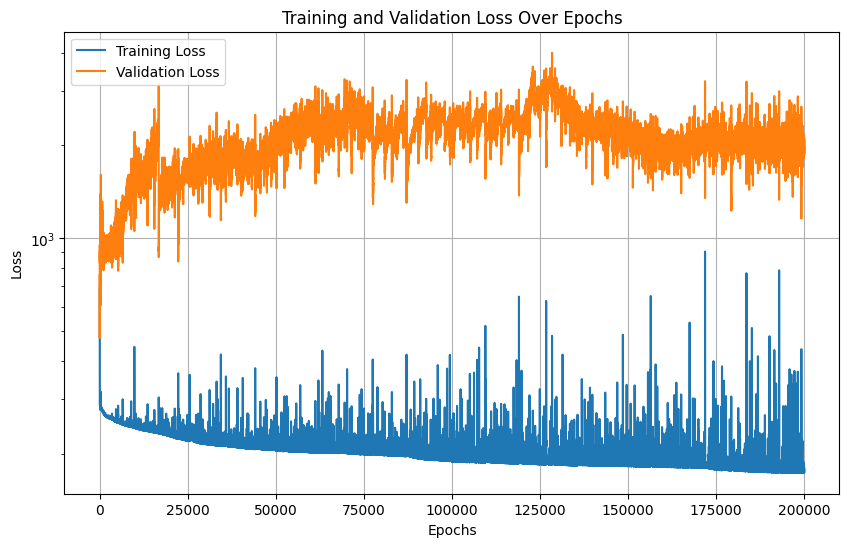

In [8]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_loss_{suffix}.png'))

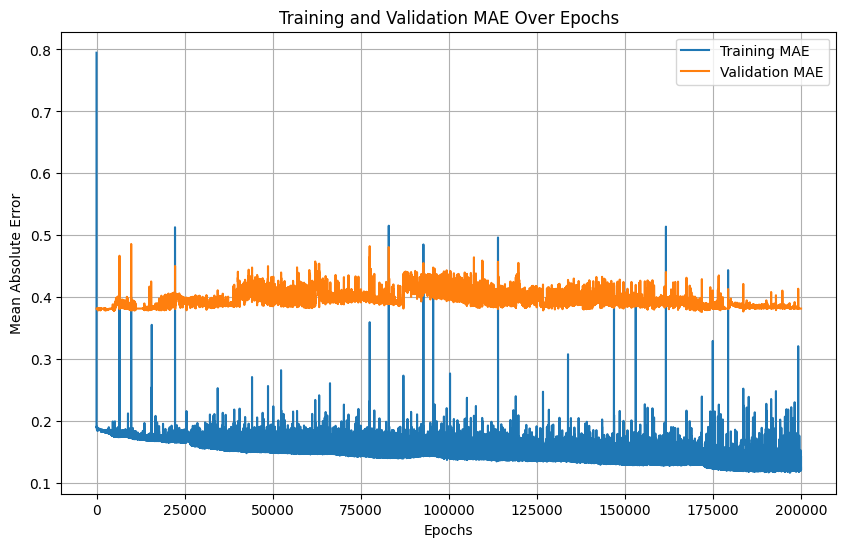

In [9]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training MAE')
plt.plot(range(epochs), results["validation_acc"], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
# plt.ylim(0.8, 1.0)
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_acc_{suffix}.png'))

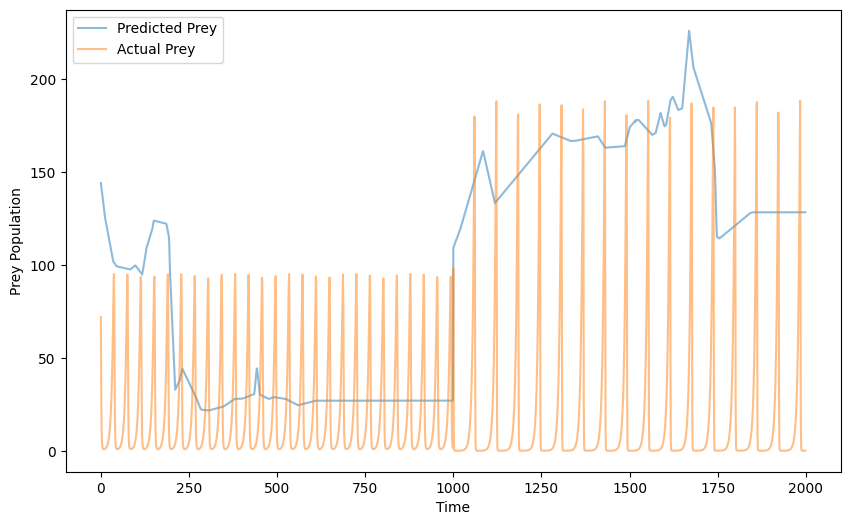

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,0], label="Predicted Prey", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,0], label="Actual Prey", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_prey_{suffix}.png'))

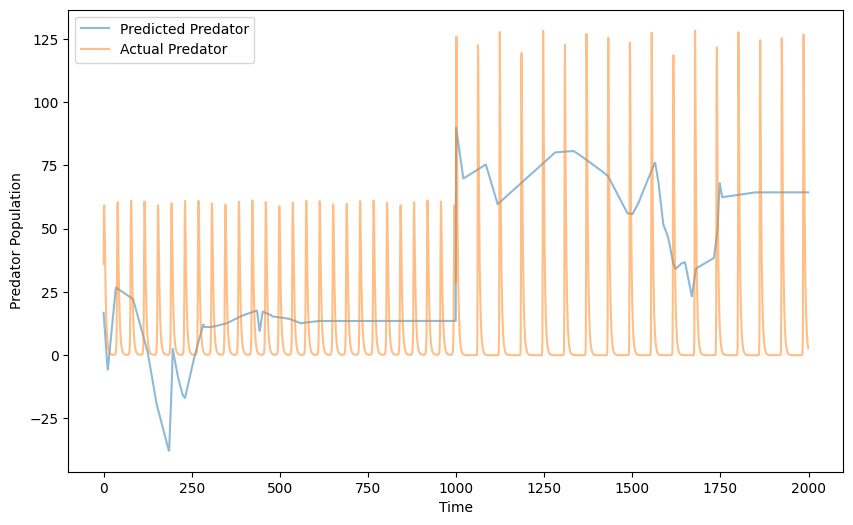

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,1], label="Predicted Predator", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,1], label="Actual Predator", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_predator_{suffix}.png'))